In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# TUNED
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 6
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 32
    cooc_threshold = 150
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    # features
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    age_volume_feature_weeks = 1

In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_category_popular(
        transactions: pd.DataFrame,
        items: pd.DataFrame,
        base_candidates: pd.DataFrame,
        week_start: int,
        num_weeks: int,
        num_items_per_category: int,
        category: str,
    ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates()
        tr = tr.groupby('item').size().reset_index(name='volume')
        tr = tr.merge(items[['item', category]], on='item')
        tr['cat_volume_rank'] = tr.groupby(category)['volume'].rank(ascending=False, method='min')
        tr = tr.query("cat_volume_rank <= @num_items_per_category").reset_index(drop=True)
        tr = tr[['item', category, 'cat_volume_rank']].reset_index(drop=True)

        candidates = base_candidates[['user', 'item']].merge(items[['item', category]], on='item')
        candidates = candidates.groupby(['user', category]).size().reset_index(name='cat_volume')
        candidates = candidates.merge(tr, on=category).drop(category, axis=1)
        candidates['strategy'] = 'cat_pop'
        return candidates


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week_start}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            # tmp[cs] /= tmp[cs].mean()
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week_start <= week < @week_start + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)
    with timer("category popular"):
        candidates_dept = create_candidates_category_popular(transactions, items, candidates_item2item2, week, 1, 6, 'department_no_idx')

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)
    candidates_dept = drop_common_user_item(candidates_dept, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
        candidates_dept,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.797 s


[popular] 0.817 s


[age popular] 0.637 s


[item2item] 9.029 s


[item2item2] 8.779 s


[cooccurrence] 64.261 s


[same_product_code] 3.127 s


[ohe distance] 18.736 s


[category popular] 0.460 s


volume: 19980796


duplicates: 1.121459873794205


            strategy   volume     ratio
0  same_product_code  4186861  0.209544
1                pop  4139040  0.207151
2         repurchase  3446562  0.172494
3            cat_pop  3172586  0.158782
4       ohe_distance  2982578  0.149272
5               cooc  1228865  0.061502
6            age_pop   824304  0.041255


create candidates (week: 2)


[repurchase] 9.695 s


[popular] 0.815 s


[age popular] 0.649 s


[item2item] 8.682 s


[item2item2] 8.591 s


[cooccurrence] 60.919 s


[same_product_code] 3.043 s


[ohe distance] 17.583 s


[category popular] 0.491 s


volume: 20926571


duplicates: 1.1229160269968992


            strategy   volume     ratio
0  same_product_code  4398614  0.210193
1                pop  4321140  0.206491
2         repurchase  3637145  0.173805
3            cat_pop  3273853  0.156445
4       ohe_distance  3132450  0.149688
5               cooc  1302993  0.062265
6            age_pop   860376  0.041114


create candidates (week: 3)


[repurchase] 9.659 s


[popular] 0.888 s


[age popular] 0.698 s


[item2item] 9.293 s


[item2item2] 9.357 s


[cooccurrence] 62.263 s


[same_product_code] 3.194 s


[ohe distance] 17.394 s


[category popular] 0.452 s


volume: 21999940


duplicates: 1.1295108357607186


            strategy   volume     ratio
0  same_product_code  4679508  0.212705
1                pop  4549320  0.206788
2         repurchase  3742824  0.170129
3            cat_pop  3407492  0.154886
4       ohe_distance  3296444  0.149839
5               cooc  1418580  0.064481
6            age_pop   905772  0.041172


create candidates (week: 4)


[repurchase] 9.772 s


[popular] 0.892 s


[age popular] 0.634 s


[item2item] 9.099 s


[item2item2] 8.940 s


[cooccurrence] 57.058 s


[same_product_code] 3.386 s


[ohe distance] 17.583 s


[category popular] 0.466 s


volume: 23356210


duplicates: 1.1317576252065877


            strategy   volume     ratio
0  same_product_code  4998786  0.214024
1                pop  4815180  0.206163
2         repurchase  3915353  0.167636
3            cat_pop  3659828  0.156696
4       ohe_distance  3495473  0.149659
5               cooc  1512886  0.064774
6            age_pop   958704  0.041047


create candidates (week: 5)


[repurchase] 8.829 s


[popular] 0.876 s


[age popular] 0.634 s


[item2item] 8.321 s


[item2item2] 8.281 s


[cooccurrence] 59.261 s


[same_product_code] 3.169 s


[ohe distance] 17.665 s


[category popular] 0.457 s


volume: 21003356


duplicates: 1.1375221652751668


            strategy   volume     ratio
0  same_product_code  4486085  0.213589
1                pop  4322100  0.205781
2         repurchase  3548895  0.168968
3            cat_pop  3283904  0.156351
4       ohe_distance  3154696  0.150200
5               cooc  1347096  0.064137
6            age_pop   860580  0.040973


create candidates (week: 6)


[repurchase] 8.966 s


[popular] 0.793 s


[age popular] 0.682 s


[item2item] 8.242 s


[item2item2] 8.186 s


[cooccurrence] 58.855 s


[same_product_code] 3.224 s


[ohe distance] 17.312 s


[category popular] 0.475 s


volume: 20905568


duplicates: 1.1211273757011615


            strategy   volume     ratio
0  same_product_code  4473501  0.213986
1                pop  4265640  0.204043
2         repurchase  3547521  0.169693
3            cat_pop  3326531  0.159122
4       ohe_distance  3132237  0.149828
5               cooc  1310406  0.062682
6            age_pop   849732  0.040646


create candidates (week: 7)


[repurchase] 9.254 s


[popular] 0.826 s


[age popular] 0.724 s


[item2item] 8.742 s


[item2item2] 8.320 s


[cooccurrence] 57.681 s


[same_product_code] 3.141 s


[ohe distance] 17.165 s


[category popular] 0.472 s


volume: 21581897


duplicates: 1.1341283129742439


            strategy   volume     ratio
0  same_product_code  4674139  0.216577
1                pop  4489980  0.208044
2         repurchase  3571089  0.165467
3            cat_pop  3381350  0.156675
4       ohe_distance  3269945  0.151513
5               cooc  1301286  0.060295
6            age_pop   894108  0.041429


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.17883945949992514


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1            cat_pop  10174.0  3172586  0.047603   0.003207
2         repurchase   8437.0  3446562  0.039475   0.002448
3  same_product_code   6328.0  4186861  0.029608   0.001511
4            age_pop   5301.0   824304  0.024803   0.006431
5               cooc   3321.0  1228865  0.015538   0.002702
6       ohe_distance   2268.0  2982578  0.010612   0.000760
merge labels (week: 1)


Recall: 0.16464393839673555


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1            cat_pop   9594.0  3273853  0.042096   0.002930
2         repurchase   8955.0  3637145  0.039292   0.002462
3  same_product_code   7005.0  4398614  0.030736   0.001593
4            age_pop   4816.0   860376  0.021131   0.005598
5               cooc   3651.0  1302993  0.016019   0.002802
6       ohe_distance   2349.0  3132450  0.010307   0.000750
merge labels (week: 2)


Recall: 0.16853163302166554


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1            cat_pop  10829.0  3407492  0.045486   0.003178
2         repurchase   9195.0  3742824  0.038622   0.002457
3  same_product_code   6935.0  4679508  0.029130   0.001482
4            age_pop   5809.0   905772  0.024400   0.006413
5               cooc   3965.0  1418580  0.016654   0.002795
6       ohe_distance   2347.0  3296444  0.009858   0.000712
merge labels (week: 3)


Recall: 0.16633878325208096


            strategy        y   volume    recall  hit_ratio
0                pop  18262.0  4815180  0.071567   0.003793
1            cat_pop  11830.0  3659828  0.046361   0.003232
2         repurchase   9002.0  3915353  0.035278   0.002299
3  same_product_code   7336.0  4998786  0.028749   0.001468
4            age_pop   6073.0   958704  0.023800   0.006335
5               cooc   4429.0  1512886  0.017357   0.002928
6       ohe_distance   2509.0  3495473  0.009833   0.000718
merge labels (week: 4)


Recall: 0.1584143831907289


            strategy        y   volume    recall  hit_ratio
0                pop  13948.0  4322100  0.060427   0.003227
1            cat_pop   9409.0  3283904  0.040762   0.002865
2         repurchase   8945.0  3548895  0.038752   0.002521
3  same_product_code   7392.0  4486085  0.032024   0.001648
4            age_pop   4770.0   860580  0.020665   0.005543
5               cooc   4576.0  1347096  0.019825   0.003397
6       ohe_distance   2119.0  3154696  0.009180   0.000672
merge labels (week: 5)


Recall: 0.15216731320627425


            strategy        y   volume    recall  hit_ratio
0                pop  11255.0  4265640  0.047457   0.002639
1         repurchase   9673.0  3547521  0.040787   0.002727
2            cat_pop   9331.0  3326531  0.039345   0.002805
3  same_product_code   7454.0  4473501  0.031430   0.001666
4               cooc   4654.0  1310406  0.019624   0.003552
5            age_pop   3433.0   849732  0.014475   0.004040
6       ohe_distance   1803.0  3132237  0.007602   0.000576
merge labels (week: 6)


Recall: 0.13427510095872253


            strategy        y   volume    recall  hit_ratio
0                pop  11008.0  4489980  0.042418   0.002452
1         repurchase   9107.0  3571089  0.035093   0.002550
2            cat_pop   8748.0  3381350  0.033709   0.002587
3  same_product_code   7871.0  4674139  0.030330   0.001684
4               cooc   4830.0  1301286  0.018612   0.003712
5            age_pop   3051.0   894108  0.011757   0.003412
6       ohe_distance   1760.0  3269945  0.006782   0.000538


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 19980796 -> 8024608


drop trivial queries: 20926571 -> 8192811


drop trivial queries: 21999940 -> 8765411


drop trivial queries: 23356210 -> 9281934


drop trivial queries: 21003356 -> 7930068


drop trivial queries: 20905568 -> 7611709


drop trivial queries: 21581897 -> 7602883


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()
    with timer("user static fetaures"):
        user_features = ['age']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer('user category most frequent'):
        for c in ['department_no_idx']:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cols = [c for c in tmp.columns if c.endswith('_mean')]
            tmp = tmp[['user'] + cols]
            tmp[cols] = tmp[cols] / tmp[cols].mean()
            tmp[f'{c}_most_freq_idx'] = np.argmax(tmp[cols].values, axis=1)
            df = df.merge(tmp[['user', f'{c}_most_freq_idx']])

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        cols = [c for c in items_with_ohe.columns if c != 'item']
        items_with_ohe[cols] = items_with_ohe[cols] / items_with_ohe[cols].mean()

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        seen_users = transactions.query("week >= @pretrain_week")['user'].unique()
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        user_reps = user_reps.query("user in @seen_users")
        df = df.merge(user_reps, on='user', how='left')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.926 s


[item stacic features] 5.157 s


[user dynamic features (transactions)] 5.273 s


[item dynamic features (transactions)] 3.226 s


[item dynamic features (user features)] 6.127 s


[item freshness features] 5.027 s


[item volume features] 3.623 s


[user freshness features] 6.682 s


[user volume features] 5.019 s


[user-item freshness features] 24.974 s


[user-item volume features] 9.486 s


[item age volume features] 5.915 s


[user category most frequent] 81.700 s


[ohe dot products] 111.043 s


[lfm features] 6.747 s
attach features (week: 1)


[user static fetaures] 0.733 s


[item stacic features] 1.788 s


[user dynamic features (transactions)] 3.429 s


[item dynamic features (transactions)] 1.555 s


[item dynamic features (user features)] 4.358 s


[item freshness features] 3.128 s


[item volume features] 1.657 s


[user freshness features] 4.500 s


[user volume features] 2.643 s


[user-item freshness features] 21.465 s


[user-item volume features] 4.924 s


[item age volume features] 2.765 s


[user category most frequent] 76.419 s


[ohe dot products] 62.711 s


[lfm features] 3.717 s
attach features (week: 2)


[user static fetaures] 0.761 s


[item stacic features] 1.909 s


[user dynamic features (transactions)] 3.498 s


[item dynamic features (transactions)] 1.638 s


[item dynamic features (user features)] 4.355 s


[item freshness features] 3.185 s


[item volume features] 1.806 s


[user freshness features] 4.596 s


[user volume features] 2.736 s


[user-item freshness features] 21.020 s


[user-item volume features] 4.986 s


[item age volume features] 2.845 s


[user category most frequent] 76.953 s


[ohe dot products] 64.112 s


[lfm features] 3.822 s
attach features (week: 3)


[user static fetaures] 0.821 s


[item stacic features] 2.126 s


[user dynamic features (transactions)] 3.598 s


[item dynamic features (transactions)] 1.733 s


[item dynamic features (user features)] 4.546 s


[item freshness features] 3.293 s


[item volume features] 1.850 s


[user freshness features] 4.502 s


[user volume features] 2.850 s


[user-item freshness features] 21.333 s


[user-item volume features] 5.272 s


[item age volume features] 3.003 s


[user category most frequent] 78.933 s


[ohe dot products] 65.255 s


[lfm features] 4.031 s
attach features (week: 4)


[user static fetaures] 0.873 s


[item stacic features] 2.261 s


[user dynamic features (transactions)] 3.644 s


[item dynamic features (transactions)] 1.817 s


[item dynamic features (user features)] 4.624 s


[item freshness features] 3.358 s


[item volume features] 1.913 s


[user freshness features] 4.628 s


[user volume features] 2.877 s


[user-item freshness features] 21.454 s


[user-item volume features] 5.413 s


[item age volume features] 3.151 s


[user category most frequent] 80.524 s


[ohe dot products] 68.769 s


[lfm features] 4.028 s
attach features (week: 5)


[user static fetaures] 0.739 s


[item stacic features] 1.895 s


[user dynamic features (transactions)] 3.516 s


[item dynamic features (transactions)] 1.610 s


[item dynamic features (user features)] 4.478 s


[item freshness features] 3.141 s


[item volume features] 1.735 s


[user freshness features] 4.323 s


[user volume features] 2.679 s


[user-item freshness features] 21.219 s


[user-item volume features] 5.051 s


[item age volume features] 2.820 s


[user category most frequent] 80.466 s


[ohe dot products] 62.105 s


[lfm features] 3.775 s
attach features (week: 6)


[user static fetaures] 0.680 s


[item stacic features] 1.789 s


[user dynamic features (transactions)] 3.460 s


[item dynamic features (transactions)] 1.560 s


[item dynamic features (user features)] 4.388 s


[item freshness features] 3.159 s


[item volume features] 1.729 s


[user freshness features] 4.521 s


[user volume features] 2.640 s


[user-item freshness features] 20.696 s


[user-item volume features] 4.883 s


[item age volume features] 2.748 s


[user category most frequent] 81.026 s


[ohe dot products] 65.225 s


[lfm features] 3.702 s
attach features (week: 7)


[user static fetaures] 0.713 s


[item stacic features] 1.797 s


[user dynamic features (transactions)] 3.486 s


[item dynamic features (transactions)] 1.617 s


[item dynamic features (user features)] 4.406 s


[item freshness features] 3.139 s


[item volume features] 1.701 s


[user freshness features] 4.340 s


[user volume features] 2.650 s


[user-item freshness features] 19.080 s


[user-item volume features] 4.887 s


[item age volume features] 2.905 s


[user category most frequent] 81.011 s


[ohe dot products] 61.751 s


[lfm features] 3.796 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'cat_volume', 'cat_volume_rank', 'age', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'department_no_idx_most_freq_idx', 'product_type_no_idx_ohe_s

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'department_no_idx_most_freq_idx'] [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 44]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1006921	best: 0.1006921 (0)	total: 9.32s	remaining: 1d 1h 52m 54s


1:	test: 0.1017467	best: 0.1017467 (1)	total: 17.9s	remaining: 1d 50m 37s


2:	test: 0.1039076	best: 0.1039076 (2)	total: 25.6s	remaining: 23h 41m 17s


3:	test: 0.1035932	best: 0.1039076 (2)	total: 32.9s	remaining: 22h 50m 34s


4:	test: 0.1129504	best: 0.1129504 (4)	total: 40.3s	remaining: 22h 21m 34s


5:	test: 0.1320836	best: 0.1320836 (5)	total: 48s	remaining: 22h 13m 2s


6:	test: 0.1374297	best: 0.1374297 (6)	total: 55.4s	remaining: 21h 58m 48s


7:	test: 0.1430352	best: 0.1430352 (7)	total: 1m 2s	remaining: 21h 44m 22s


8:	test: 0.1435837	best: 0.1435837 (8)	total: 1m 10s	remaining: 21h 35m 58s


9:	test: 0.1480737	best: 0.1480737 (9)	total: 1m 17s	remaining: 21h 34m 52s


10:	test: 0.1517045	best: 0.1517045 (10)	total: 1m 24s	remaining: 21h 26m 7s


11:	test: 0.1598658	best: 0.1598658 (11)	total: 1m 32s	remaining: 21h 20m 28s


12:	test: 0.1603187	best: 0.1603187 (12)	total: 1m 39s	remaining: 21h 14m 34s


13:	test: 0.1607324	best: 0.1607324 (13)	total: 1m 46s	remaining: 21h 11m 24s


14:	test: 0.1679631	best: 0.1679631 (14)	total: 1m 54s	remaining: 21h 8m 36s


15:	test: 0.1695912	best: 0.1695912 (15)	total: 2m 1s	remaining: 21h 5m 44s


16:	test: 0.1712939	best: 0.1712939 (16)	total: 2m 9s	remaining: 21h 2m 45s


17:	test: 0.1756205	best: 0.1756205 (17)	total: 2m 16s	remaining: 21h 52s


18:	test: 0.1789880	best: 0.1789880 (18)	total: 2m 23s	remaining: 20h 57m 46s


19:	test: 0.1798847	best: 0.1798847 (19)	total: 2m 30s	remaining: 20h 55m 6s


20:	test: 0.1815429	best: 0.1815429 (20)	total: 2m 38s	remaining: 20h 56m 35s


21:	test: 0.1854720	best: 0.1854720 (21)	total: 2m 46s	remaining: 20h 57m 34s


22:	test: 0.1865653	best: 0.1865653 (22)	total: 2m 54s	remaining: 20h 58m 34s


23:	test: 0.1870531	best: 0.1870531 (23)	total: 3m 2s	remaining: 21h 1m 15s


24:	test: 0.1878297	best: 0.1878297 (24)	total: 3m 9s	remaining: 21h 3m 29s


25:	test: 0.1897845	best: 0.1897845 (25)	total: 3m 17s	remaining: 21h 3m 43s


26:	test: 0.1896413	best: 0.1897845 (25)	total: 3m 25s	remaining: 21h 4m 8s


27:	test: 0.1906198	best: 0.1906198 (27)	total: 3m 32s	remaining: 21h 2m 7s


28:	test: 0.1916898	best: 0.1916898 (28)	total: 3m 39s	remaining: 20h 59m 28s


29:	test: 0.1922419	best: 0.1922419 (29)	total: 3m 47s	remaining: 20h 57m 20s


30:	test: 0.1928046	best: 0.1928046 (30)	total: 3m 54s	remaining: 20h 56m 5s


31:	test: 0.1967921	best: 0.1967921 (31)	total: 4m 1s	remaining: 20h 55m 51s


32:	test: 0.1974625	best: 0.1974625 (32)	total: 4m 9s	remaining: 20h 55m 6s


33:	test: 0.1971403	best: 0.1974625 (32)	total: 4m 16s	remaining: 20h 53m 52s


34:	test: 0.1988539	best: 0.1988539 (34)	total: 4m 24s	remaining: 20h 52m 45s


35:	test: 0.1986914	best: 0.1988539 (34)	total: 4m 31s	remaining: 20h 52m 14s


36:	test: 0.1987641	best: 0.1988539 (34)	total: 4m 38s	remaining: 20h 51m 38s


37:	test: 0.1988891	best: 0.1988891 (37)	total: 4m 46s	remaining: 20h 50m 58s


38:	test: 0.1995704	best: 0.1995704 (38)	total: 4m 53s	remaining: 20h 50m 10s


39:	test: 0.2027566	best: 0.2027566 (39)	total: 5m	remaining: 20h 49m


40:	test: 0.2028975	best: 0.2028975 (40)	total: 5m 8s	remaining: 20h 48m 14s


41:	test: 0.2034937	best: 0.2034937 (41)	total: 5m 15s	remaining: 20h 46m 42s


42:	test: 0.2034509	best: 0.2034937 (41)	total: 5m 22s	remaining: 20h 45m 59s


43:	test: 0.2035743	best: 0.2035743 (43)	total: 5m 29s	remaining: 20h 44m 18s


44:	test: 0.2034216	best: 0.2035743 (43)	total: 5m 37s	remaining: 20h 42m 41s


45:	test: 0.2041292	best: 0.2041292 (45)	total: 5m 44s	remaining: 20h 41m 31s


46:	test: 0.2043679	best: 0.2043679 (46)	total: 5m 51s	remaining: 20h 40m 45s


47:	test: 0.2052034	best: 0.2052034 (47)	total: 5m 58s	remaining: 20h 39m 45s


48:	test: 0.2052170	best: 0.2052170 (48)	total: 6m 5s	remaining: 20h 38m 8s


49:	test: 0.2052418	best: 0.2052418 (49)	total: 6m 12s	remaining: 20h 36m 3s


50:	test: 0.2055834	best: 0.2055834 (50)	total: 6m 20s	remaining: 20h 36m 11s


51:	test: 0.2060830	best: 0.2060830 (51)	total: 6m 27s	remaining: 20h 35m 36s


52:	test: 0.2061607	best: 0.2061607 (52)	total: 6m 34s	remaining: 20h 34m 10s


53:	test: 0.2062915	best: 0.2062915 (53)	total: 6m 42s	remaining: 20h 34m 9s


54:	test: 0.2064523	best: 0.2064523 (54)	total: 6m 49s	remaining: 20h 35m 8s


55:	test: 0.2070869	best: 0.2070869 (55)	total: 6m 57s	remaining: 20h 35m 42s


56:	test: 0.2070884	best: 0.2070884 (56)	total: 7m 6s	remaining: 20h 39m 26s


57:	test: 0.2071380	best: 0.2071380 (57)	total: 7m 14s	remaining: 20h 41m 7s


58:	test: 0.2072892	best: 0.2072892 (58)	total: 7m 23s	remaining: 20h 44m 36s


59:	test: 0.2072079	best: 0.2072892 (58)	total: 7m 31s	remaining: 20h 46m 9s


60:	test: 0.2078426	best: 0.2078426 (60)	total: 7m 38s	remaining: 20h 45m 2s


61:	test: 0.2078604	best: 0.2078604 (61)	total: 7m 46s	remaining: 20h 44m 57s


62:	test: 0.2082395	best: 0.2082395 (62)	total: 7m 53s	remaining: 20h 45m 56s


63:	test: 0.2084774	best: 0.2084774 (63)	total: 8m 1s	remaining: 20h 46m 4s


64:	test: 0.2088656	best: 0.2088656 (64)	total: 8m 9s	remaining: 20h 47m 17s


65:	test: 0.2098530	best: 0.2098530 (65)	total: 8m 17s	remaining: 20h 48m 30s


66:	test: 0.2103497	best: 0.2103497 (66)	total: 8m 26s	remaining: 20h 50m 52s


67:	test: 0.2102638	best: 0.2103497 (66)	total: 8m 34s	remaining: 20h 52m 44s


68:	test: 0.2108938	best: 0.2108938 (68)	total: 8m 43s	remaining: 20h 55m 11s


69:	test: 0.2111509	best: 0.2111509 (69)	total: 8m 51s	remaining: 20h 56m 53s


70:	test: 0.2114124	best: 0.2114124 (70)	total: 8m 59s	remaining: 20h 57m 31s


71:	test: 0.2121302	best: 0.2121302 (71)	total: 9m 7s	remaining: 20h 58m 33s


72:	test: 0.2121827	best: 0.2121827 (72)	total: 9m 15s	remaining: 20h 59m 5s


73:	test: 0.2122870	best: 0.2122870 (73)	total: 9m 23s	remaining: 20h 58m 43s


74:	test: 0.2122500	best: 0.2122870 (73)	total: 9m 30s	remaining: 20h 58m 10s


75:	test: 0.2120390	best: 0.2122870 (73)	total: 9m 37s	remaining: 20h 57m 25s


76:	test: 0.2120203	best: 0.2122870 (73)	total: 9m 45s	remaining: 20h 56m 47s


77:	test: 0.2130611	best: 0.2130611 (77)	total: 9m 52s	remaining: 20h 56m 6s


78:	test: 0.2133314	best: 0.2133314 (78)	total: 9m 59s	remaining: 20h 54m 41s


79:	test: 0.2134860	best: 0.2134860 (79)	total: 10m 7s	remaining: 20h 54m 44s


80:	test: 0.2135670	best: 0.2135670 (80)	total: 10m 14s	remaining: 20h 54m 20s


81:	test: 0.2138011	best: 0.2138011 (81)	total: 10m 21s	remaining: 20h 52m 49s


82:	test: 0.2135963	best: 0.2138011 (81)	total: 10m 28s	remaining: 20h 52m 23s


83:	test: 0.2136724	best: 0.2138011 (81)	total: 10m 36s	remaining: 20h 51m 31s


84:	test: 0.2140398	best: 0.2140398 (84)	total: 10m 43s	remaining: 20h 50m 39s


85:	test: 0.2141747	best: 0.2141747 (85)	total: 10m 50s	remaining: 20h 49m 52s


86:	test: 0.2142301	best: 0.2142301 (86)	total: 10m 58s	remaining: 20h 50m 4s


87:	test: 0.2141506	best: 0.2142301 (86)	total: 11m 5s	remaining: 20h 49m 30s


88:	test: 0.2144344	best: 0.2144344 (88)	total: 11m 12s	remaining: 20h 48m 10s


89:	test: 0.2144770	best: 0.2144770 (89)	total: 11m 19s	remaining: 20h 47m 51s


90:	test: 0.2147708	best: 0.2147708 (90)	total: 11m 27s	remaining: 20h 46m 47s


91:	test: 0.2153080	best: 0.2153080 (91)	total: 11m 34s	remaining: 20h 46m 37s


92:	test: 0.2157607	best: 0.2157607 (92)	total: 11m 41s	remaining: 20h 46m 5s


93:	test: 0.2157074	best: 0.2157607 (92)	total: 11m 49s	remaining: 20h 45m 52s


94:	test: 0.2160538	best: 0.2160538 (94)	total: 11m 56s	remaining: 20h 45m 54s


95:	test: 0.2160804	best: 0.2160804 (95)	total: 12m 4s	remaining: 20h 45m 21s


96:	test: 0.2160526	best: 0.2160804 (95)	total: 12m 11s	remaining: 20h 45m 7s


97:	test: 0.2161503	best: 0.2161503 (97)	total: 12m 19s	remaining: 20h 45m 20s


98:	test: 0.2160159	best: 0.2161503 (97)	total: 12m 26s	remaining: 20h 44m 59s


99:	test: 0.2163521	best: 0.2163521 (99)	total: 12m 34s	remaining: 20h 44m 49s


100:	test: 0.2164062	best: 0.2164062 (100)	total: 12m 41s	remaining: 20h 43m 55s


101:	test: 0.2163293	best: 0.2164062 (100)	total: 12m 48s	remaining: 20h 43m 37s


102:	test: 0.2162311	best: 0.2164062 (100)	total: 12m 56s	remaining: 20h 44m 2s


103:	test: 0.2163404	best: 0.2164062 (100)	total: 13m 4s	remaining: 20h 44m


104:	test: 0.2163946	best: 0.2164062 (100)	total: 13m 13s	remaining: 20h 45m 53s


105:	test: 0.2165611	best: 0.2165611 (105)	total: 13m 21s	remaining: 20h 46m 38s


106:	test: 0.2166426	best: 0.2166426 (106)	total: 13m 29s	remaining: 20h 47m 29s


107:	test: 0.2171456	best: 0.2171456 (107)	total: 13m 37s	remaining: 20h 47m 38s


108:	test: 0.2171999	best: 0.2171999 (108)	total: 13m 45s	remaining: 20h 48m 18s


109:	test: 0.2175356	best: 0.2175356 (109)	total: 13m 53s	remaining: 20h 48m 14s


110:	test: 0.2172264	best: 0.2175356 (109)	total: 14m 1s	remaining: 20h 49m


111:	test: 0.2173301	best: 0.2175356 (109)	total: 14m 8s	remaining: 20h 48m 53s


112:	test: 0.2173476	best: 0.2175356 (109)	total: 14m 16s	remaining: 20h 48m 16s


113:	test: 0.2173465	best: 0.2175356 (109)	total: 14m 23s	remaining: 20h 48m 9s


114:	test: 0.2176817	best: 0.2176817 (114)	total: 14m 30s	remaining: 20h 47m 13s


115:	test: 0.2179242	best: 0.2179242 (115)	total: 14m 37s	remaining: 20h 46m 42s


116:	test: 0.2177629	best: 0.2179242 (115)	total: 14m 45s	remaining: 20h 46m 21s


117:	test: 0.2178753	best: 0.2179242 (115)	total: 14m 52s	remaining: 20h 45m 52s


118:	test: 0.2184352	best: 0.2184352 (118)	total: 15m	remaining: 20h 45m 37s


119:	test: 0.2188588	best: 0.2188588 (119)	total: 15m 7s	remaining: 20h 45m 16s


120:	test: 0.2189176	best: 0.2189176 (120)	total: 15m 14s	remaining: 20h 44m 43s


121:	test: 0.2189778	best: 0.2189778 (121)	total: 15m 22s	remaining: 20h 44m 19s


122:	test: 0.2189663	best: 0.2189778 (121)	total: 15m 29s	remaining: 20h 44m 10s


123:	test: 0.2190924	best: 0.2190924 (123)	total: 15m 36s	remaining: 20h 43m 34s


124:	test: 0.2193596	best: 0.2193596 (124)	total: 15m 43s	remaining: 20h 42m 55s


125:	test: 0.2197746	best: 0.2197746 (125)	total: 15m 51s	remaining: 20h 42m 24s


126:	test: 0.2197286	best: 0.2197746 (125)	total: 15m 58s	remaining: 20h 41m 47s


127:	test: 0.2198869	best: 0.2198869 (127)	total: 16m 5s	remaining: 20h 40m 59s


128:	test: 0.2199028	best: 0.2199028 (128)	total: 16m 12s	remaining: 20h 40m 26s


129:	test: 0.2204184	best: 0.2204184 (129)	total: 16m 20s	remaining: 20h 40m 8s


130:	test: 0.2207226	best: 0.2207226 (130)	total: 16m 27s	remaining: 20h 39m 28s


131:	test: 0.2209593	best: 0.2209593 (131)	total: 16m 34s	remaining: 20h 39m 5s


132:	test: 0.2213177	best: 0.2213177 (132)	total: 16m 41s	remaining: 20h 38m 42s


133:	test: 0.2213713	best: 0.2213713 (133)	total: 16m 49s	remaining: 20h 38m 38s


134:	test: 0.2215345	best: 0.2215345 (134)	total: 16m 57s	remaining: 20h 38m 38s


135:	test: 0.2217712	best: 0.2217712 (135)	total: 17m 5s	remaining: 20h 39m 48s


136:	test: 0.2221091	best: 0.2221091 (136)	total: 17m 13s	remaining: 20h 40m 40s


137:	test: 0.2224083	best: 0.2224083 (137)	total: 17m 21s	remaining: 20h 40m 17s


138:	test: 0.2226690	best: 0.2226690 (138)	total: 17m 28s	remaining: 20h 39m 55s


139:	test: 0.2227413	best: 0.2227413 (139)	total: 17m 35s	remaining: 20h 39m 22s


140:	test: 0.2226700	best: 0.2227413 (139)	total: 17m 44s	remaining: 20h 40m 6s


141:	test: 0.2229787	best: 0.2229787 (141)	total: 17m 52s	remaining: 20h 41m 1s


142:	test: 0.2229607	best: 0.2229787 (141)	total: 18m	remaining: 20h 41m 45s


143:	test: 0.2230103	best: 0.2230103 (143)	total: 18m 8s	remaining: 20h 42m 8s


144:	test: 0.2230636	best: 0.2230636 (144)	total: 18m 17s	remaining: 20h 42m 40s


145:	test: 0.2231050	best: 0.2231050 (145)	total: 18m 25s	remaining: 20h 44m


146:	test: 0.2231046	best: 0.2231050 (145)	total: 18m 33s	remaining: 20h 44m 6s


147:	test: 0.2233310	best: 0.2233310 (147)	total: 18m 41s	remaining: 20h 43m 53s


148:	test: 0.2234618	best: 0.2234618 (148)	total: 18m 49s	remaining: 20h 44m 17s


149:	test: 0.2234835	best: 0.2234835 (149)	total: 18m 57s	remaining: 20h 44m 57s


150:	test: 0.2237792	best: 0.2237792 (150)	total: 19m 5s	remaining: 20h 45m 36s


151:	test: 0.2238241	best: 0.2238241 (151)	total: 19m 13s	remaining: 20h 45m 18s


152:	test: 0.2239715	best: 0.2239715 (152)	total: 19m 21s	remaining: 20h 46m 7s


153:	test: 0.2240209	best: 0.2240209 (153)	total: 19m 29s	remaining: 20h 46m 30s


154:	test: 0.2241093	best: 0.2241093 (154)	total: 19m 37s	remaining: 20h 46m 28s


155:	test: 0.2240964	best: 0.2241093 (154)	total: 19m 45s	remaining: 20h 46m 39s


156:	test: 0.2243747	best: 0.2243747 (156)	total: 19m 53s	remaining: 20h 47m 10s


157:	test: 0.2245052	best: 0.2245052 (157)	total: 20m 1s	remaining: 20h 47m 49s


158:	test: 0.2245319	best: 0.2245319 (158)	total: 20m 10s	remaining: 20h 48m 28s


159:	test: 0.2247456	best: 0.2247456 (159)	total: 20m 18s	remaining: 20h 49m 5s


160:	test: 0.2248807	best: 0.2248807 (160)	total: 20m 26s	remaining: 20h 48m 58s


161:	test: 0.2251006	best: 0.2251006 (161)	total: 20m 34s	remaining: 20h 49m 12s


162:	test: 0.2253486	best: 0.2253486 (162)	total: 20m 42s	remaining: 20h 49m 32s


163:	test: 0.2254614	best: 0.2254614 (163)	total: 20m 49s	remaining: 20h 49m 29s


164:	test: 0.2256733	best: 0.2256733 (164)	total: 20m 58s	remaining: 20h 49m 47s


165:	test: 0.2258112	best: 0.2258112 (165)	total: 21m 5s	remaining: 20h 49m 49s


166:	test: 0.2261020	best: 0.2261020 (166)	total: 21m 14s	remaining: 20h 50m 20s


167:	test: 0.2262343	best: 0.2262343 (167)	total: 21m 21s	remaining: 20h 49m 55s


168:	test: 0.2265401	best: 0.2265401 (168)	total: 21m 29s	remaining: 20h 49m 52s


169:	test: 0.2266466	best: 0.2266466 (169)	total: 21m 36s	remaining: 20h 49m 24s


170:	test: 0.2266797	best: 0.2266797 (170)	total: 21m 43s	remaining: 20h 49m 5s


171:	test: 0.2268456	best: 0.2268456 (171)	total: 21m 51s	remaining: 20h 49m 13s


172:	test: 0.2268253	best: 0.2268456 (171)	total: 21m 59s	remaining: 20h 49m 14s


173:	test: 0.2269200	best: 0.2269200 (173)	total: 22m 7s	remaining: 20h 49m 22s


174:	test: 0.2269131	best: 0.2269200 (173)	total: 22m 14s	remaining: 20h 48m 51s


175:	test: 0.2272559	best: 0.2272559 (175)	total: 22m 21s	remaining: 20h 48m 3s


176:	test: 0.2273641	best: 0.2273641 (176)	total: 22m 29s	remaining: 20h 47m 45s


177:	test: 0.2272331	best: 0.2273641 (176)	total: 22m 36s	remaining: 20h 47m 35s


178:	test: 0.2273755	best: 0.2273755 (178)	total: 22m 44s	remaining: 20h 47m 35s


179:	test: 0.2276305	best: 0.2276305 (179)	total: 22m 51s	remaining: 20h 46m 52s


180:	test: 0.2277336	best: 0.2277336 (180)	total: 22m 58s	remaining: 20h 46m 21s


181:	test: 0.2280326	best: 0.2280326 (181)	total: 23m 5s	remaining: 20h 46m 1s


182:	test: 0.2282020	best: 0.2282020 (182)	total: 23m 13s	remaining: 20h 45m 27s


183:	test: 0.2283231	best: 0.2283231 (183)	total: 23m 20s	remaining: 20h 45m 7s


184:	test: 0.2284993	best: 0.2284993 (184)	total: 23m 27s	remaining: 20h 44m 46s


185:	test: 0.2285348	best: 0.2285348 (185)	total: 23m 35s	remaining: 20h 44m 32s


186:	test: 0.2287320	best: 0.2287320 (186)	total: 23m 42s	remaining: 20h 44m 9s


187:	test: 0.2286925	best: 0.2287320 (186)	total: 23m 49s	remaining: 20h 43m 37s


188:	test: 0.2289501	best: 0.2289501 (188)	total: 23m 57s	remaining: 20h 43m 18s


189:	test: 0.2289460	best: 0.2289501 (188)	total: 24m 4s	remaining: 20h 42m 58s


190:	test: 0.2290808	best: 0.2290808 (190)	total: 24m 11s	remaining: 20h 42m 21s


191:	test: 0.2292438	best: 0.2292438 (191)	total: 24m 18s	remaining: 20h 42m 3s


192:	test: 0.2291908	best: 0.2292438 (191)	total: 24m 26s	remaining: 20h 41m 44s


193:	test: 0.2292512	best: 0.2292512 (193)	total: 24m 33s	remaining: 20h 41m 6s


194:	test: 0.2293623	best: 0.2293623 (194)	total: 24m 40s	remaining: 20h 40m 44s


195:	test: 0.2295231	best: 0.2295231 (195)	total: 24m 48s	remaining: 20h 40m 34s


196:	test: 0.2297505	best: 0.2297505 (196)	total: 24m 55s	remaining: 20h 40m 26s


197:	test: 0.2299478	best: 0.2299478 (197)	total: 25m 3s	remaining: 20h 40m 25s


198:	test: 0.2299429	best: 0.2299478 (197)	total: 25m 10s	remaining: 20h 40m 8s


199:	test: 0.2302263	best: 0.2302263 (199)	total: 25m 17s	remaining: 20h 39m 24s


200:	test: 0.2304619	best: 0.2304619 (200)	total: 25m 25s	remaining: 20h 39m 18s


201:	test: 0.2303929	best: 0.2304619 (200)	total: 25m 32s	remaining: 20h 38m 53s


202:	test: 0.2304263	best: 0.2304619 (200)	total: 25m 40s	remaining: 20h 38m 58s


203:	test: 0.2305072	best: 0.2305072 (203)	total: 25m 48s	remaining: 20h 39m 8s


204:	test: 0.2306464	best: 0.2306464 (204)	total: 25m 56s	remaining: 20h 39m 16s


205:	test: 0.2306549	best: 0.2306549 (205)	total: 26m 4s	remaining: 20h 39m 24s


206:	test: 0.2308703	best: 0.2308703 (206)	total: 26m 11s	remaining: 20h 39m 22s


207:	test: 0.2310172	best: 0.2310172 (207)	total: 26m 19s	remaining: 20h 39m 10s


208:	test: 0.2310731	best: 0.2310731 (208)	total: 26m 27s	remaining: 20h 39m 12s


209:	test: 0.2311483	best: 0.2311483 (209)	total: 26m 34s	remaining: 20h 39m 5s


210:	test: 0.2312902	best: 0.2312902 (210)	total: 26m 42s	remaining: 20h 38m 49s


211:	test: 0.2314013	best: 0.2314013 (211)	total: 26m 49s	remaining: 20h 38m 27s


212:	test: 0.2315259	best: 0.2315259 (212)	total: 26m 56s	remaining: 20h 38m 6s


213:	test: 0.2315157	best: 0.2315259 (212)	total: 27m 4s	remaining: 20h 37m 50s


214:	test: 0.2315727	best: 0.2315727 (214)	total: 27m 11s	remaining: 20h 37m 36s


215:	test: 0.2316609	best: 0.2316609 (215)	total: 27m 19s	remaining: 20h 37m 24s


216:	test: 0.2318587	best: 0.2318587 (216)	total: 27m 26s	remaining: 20h 37m 9s


217:	test: 0.2319800	best: 0.2319800 (217)	total: 27m 34s	remaining: 20h 37m 33s


218:	test: 0.2320370	best: 0.2320370 (218)	total: 27m 43s	remaining: 20h 38m 14s


219:	test: 0.2322138	best: 0.2322138 (219)	total: 27m 51s	remaining: 20h 38m 29s


220:	test: 0.2322117	best: 0.2322138 (219)	total: 27m 59s	remaining: 20h 38m 36s


221:	test: 0.2322957	best: 0.2322957 (221)	total: 28m 7s	remaining: 20h 38m 30s


222:	test: 0.2322091	best: 0.2322957 (221)	total: 28m 14s	remaining: 20h 38m 21s


223:	test: 0.2323369	best: 0.2323369 (223)	total: 28m 22s	remaining: 20h 38m 15s


224:	test: 0.2324421	best: 0.2324421 (224)	total: 28m 30s	remaining: 20h 38m 42s


225:	test: 0.2325884	best: 0.2325884 (225)	total: 28m 38s	remaining: 20h 38m 57s


226:	test: 0.2327687	best: 0.2327687 (226)	total: 28m 46s	remaining: 20h 39m 9s


227:	test: 0.2328754	best: 0.2328754 (227)	total: 28m 54s	remaining: 20h 38m 54s


228:	test: 0.2328309	best: 0.2328754 (227)	total: 29m 2s	remaining: 20h 39m


229:	test: 0.2329140	best: 0.2329140 (229)	total: 29m 9s	remaining: 20h 38m 56s


230:	test: 0.2329913	best: 0.2329913 (230)	total: 29m 18s	remaining: 20h 39m 10s


231:	test: 0.2330571	best: 0.2330571 (231)	total: 29m 25s	remaining: 20h 38m 46s


232:	test: 0.2329996	best: 0.2330571 (231)	total: 29m 33s	remaining: 20h 38m 51s


233:	test: 0.2330451	best: 0.2330571 (231)	total: 29m 40s	remaining: 20h 38m 36s


234:	test: 0.2331503	best: 0.2331503 (234)	total: 29m 48s	remaining: 20h 38m 38s


235:	test: 0.2333835	best: 0.2333835 (235)	total: 29m 56s	remaining: 20h 38m 29s


236:	test: 0.2334206	best: 0.2334206 (236)	total: 30m 3s	remaining: 20h 38m 21s


237:	test: 0.2333427	best: 0.2334206 (236)	total: 30m 11s	remaining: 20h 38m 6s


238:	test: 0.2334078	best: 0.2334206 (236)	total: 30m 18s	remaining: 20h 37m 50s


239:	test: 0.2334932	best: 0.2334932 (239)	total: 30m 26s	remaining: 20h 38m 4s


240:	test: 0.2336419	best: 0.2336419 (240)	total: 30m 33s	remaining: 20h 37m 37s


241:	test: 0.2338103	best: 0.2338103 (241)	total: 30m 41s	remaining: 20h 37m 36s


242:	test: 0.2338771	best: 0.2338771 (242)	total: 30m 49s	remaining: 20h 37m 38s


243:	test: 0.2339761	best: 0.2339761 (243)	total: 30m 57s	remaining: 20h 37m 35s


244:	test: 0.2339189	best: 0.2339761 (243)	total: 31m 4s	remaining: 20h 37m 22s


245:	test: 0.2340476	best: 0.2340476 (245)	total: 31m 12s	remaining: 20h 37m 30s


246:	test: 0.2339847	best: 0.2340476 (245)	total: 31m 20s	remaining: 20h 37m 36s


247:	test: 0.2341485	best: 0.2341485 (247)	total: 31m 28s	remaining: 20h 37m 47s


248:	test: 0.2342303	best: 0.2342303 (248)	total: 31m 36s	remaining: 20h 37m 46s


249:	test: 0.2343230	best: 0.2343230 (249)	total: 31m 43s	remaining: 20h 37m 31s


250:	test: 0.2343757	best: 0.2343757 (250)	total: 31m 51s	remaining: 20h 37m 39s


251:	test: 0.2345121	best: 0.2345121 (251)	total: 31m 59s	remaining: 20h 37m 25s


252:	test: 0.2344964	best: 0.2345121 (251)	total: 32m 7s	remaining: 20h 37m 19s


253:	test: 0.2344818	best: 0.2345121 (251)	total: 32m 14s	remaining: 20h 37m 2s


254:	test: 0.2346430	best: 0.2346430 (254)	total: 32m 21s	remaining: 20h 36m 46s


255:	test: 0.2347143	best: 0.2347143 (255)	total: 32m 29s	remaining: 20h 36m 35s


256:	test: 0.2347265	best: 0.2347265 (256)	total: 32m 36s	remaining: 20h 36m 25s


257:	test: 0.2347864	best: 0.2347864 (257)	total: 32m 44s	remaining: 20h 36m 9s


258:	test: 0.2348227	best: 0.2348227 (258)	total: 32m 51s	remaining: 20h 35m 56s


259:	test: 0.2348812	best: 0.2348812 (259)	total: 32m 59s	remaining: 20h 36m 1s


260:	test: 0.2349248	best: 0.2349248 (260)	total: 33m 7s	remaining: 20h 36m 12s


261:	test: 0.2348441	best: 0.2349248 (260)	total: 33m 16s	remaining: 20h 36m 28s


262:	test: 0.2348425	best: 0.2349248 (260)	total: 33m 23s	remaining: 20h 36m 15s


263:	test: 0.2349140	best: 0.2349248 (260)	total: 33m 30s	remaining: 20h 35m 39s


264:	test: 0.2349502	best: 0.2349502 (264)	total: 33m 37s	remaining: 20h 35m 27s


265:	test: 0.2350938	best: 0.2350938 (265)	total: 33m 45s	remaining: 20h 35m 8s


266:	test: 0.2351005	best: 0.2351005 (266)	total: 33m 53s	remaining: 20h 35m 11s


267:	test: 0.2350665	best: 0.2351005 (266)	total: 34m	remaining: 20h 34m 57s


268:	test: 0.2350876	best: 0.2351005 (266)	total: 34m 7s	remaining: 20h 34m 45s


269:	test: 0.2351632	best: 0.2351632 (269)	total: 34m 15s	remaining: 20h 34m 33s


270:	test: 0.2352435	best: 0.2352435 (270)	total: 34m 22s	remaining: 20h 34m 11s


271:	test: 0.2353875	best: 0.2353875 (271)	total: 34m 30s	remaining: 20h 34m 14s


272:	test: 0.2352895	best: 0.2353875 (271)	total: 34m 38s	remaining: 20h 34m 4s


273:	test: 0.2354311	best: 0.2354311 (273)	total: 34m 45s	remaining: 20h 34m 5s


274:	test: 0.2354342	best: 0.2354342 (274)	total: 34m 53s	remaining: 20h 33m 58s


275:	test: 0.2354856	best: 0.2354856 (275)	total: 35m 1s	remaining: 20h 34m 2s


276:	test: 0.2356076	best: 0.2356076 (276)	total: 35m 9s	remaining: 20h 34m 10s


277:	test: 0.2356955	best: 0.2356955 (277)	total: 35m 17s	remaining: 20h 34m 4s


278:	test: 0.2356829	best: 0.2356955 (277)	total: 35m 24s	remaining: 20h 33m 51s


279:	test: 0.2357580	best: 0.2357580 (279)	total: 35m 32s	remaining: 20h 33m 55s


280:	test: 0.2357318	best: 0.2357580 (279)	total: 35m 40s	remaining: 20h 33m 57s


281:	test: 0.2358444	best: 0.2358444 (281)	total: 35m 48s	remaining: 20h 33m 56s


282:	test: 0.2359426	best: 0.2359426 (282)	total: 35m 56s	remaining: 20h 34m 7s


283:	test: 0.2360468	best: 0.2360468 (283)	total: 36m 3s	remaining: 20h 33m 45s


284:	test: 0.2360080	best: 0.2360468 (283)	total: 36m 11s	remaining: 20h 33m 37s


285:	test: 0.2360574	best: 0.2360574 (285)	total: 36m 18s	remaining: 20h 33m 21s


286:	test: 0.2359684	best: 0.2360574 (285)	total: 36m 26s	remaining: 20h 33m 32s


287:	test: 0.2361642	best: 0.2361642 (287)	total: 36m 34s	remaining: 20h 33m 31s


288:	test: 0.2362210	best: 0.2362210 (288)	total: 36m 41s	remaining: 20h 33m 10s


289:	test: 0.2361991	best: 0.2362210 (288)	total: 36m 49s	remaining: 20h 33m 1s


290:	test: 0.2362911	best: 0.2362911 (290)	total: 36m 56s	remaining: 20h 32m 36s


291:	test: 0.2362690	best: 0.2362911 (290)	total: 37m 3s	remaining: 20h 32m 4s


292:	test: 0.2363925	best: 0.2363925 (292)	total: 37m 10s	remaining: 20h 31m 30s


293:	test: 0.2364015	best: 0.2364015 (293)	total: 37m 17s	remaining: 20h 31m 7s


294:	test: 0.2363576	best: 0.2364015 (293)	total: 37m 24s	remaining: 20h 30m 52s


295:	test: 0.2365310	best: 0.2365310 (295)	total: 37m 32s	remaining: 20h 30m 53s


296:	test: 0.2364645	best: 0.2365310 (295)	total: 37m 40s	remaining: 20h 30m 36s


297:	test: 0.2364763	best: 0.2365310 (295)	total: 37m 47s	remaining: 20h 30m 33s


298:	test: 0.2365376	best: 0.2365376 (298)	total: 37m 55s	remaining: 20h 30m 17s


299:	test: 0.2366241	best: 0.2366241 (299)	total: 38m 3s	remaining: 20h 30m 35s


300:	test: 0.2366845	best: 0.2366845 (300)	total: 38m 10s	remaining: 20h 30m 21s


301:	test: 0.2368269	best: 0.2368269 (301)	total: 38m 18s	remaining: 20h 30m 26s


302:	test: 0.2367976	best: 0.2368269 (301)	total: 38m 26s	remaining: 20h 30m 29s


303:	test: 0.2369100	best: 0.2369100 (303)	total: 38m 34s	remaining: 20h 30m 27s


304:	test: 0.2369218	best: 0.2369218 (304)	total: 38m 42s	remaining: 20h 30m 14s


305:	test: 0.2370167	best: 0.2370167 (305)	total: 38m 50s	remaining: 20h 30m 25s


306:	test: 0.2370696	best: 0.2370696 (306)	total: 38m 57s	remaining: 20h 30m 7s


307:	test: 0.2372769	best: 0.2372769 (307)	total: 39m 4s	remaining: 20h 29m 40s


308:	test: 0.2372748	best: 0.2372769 (307)	total: 39m 11s	remaining: 20h 29m 17s


309:	test: 0.2372275	best: 0.2372769 (307)	total: 39m 19s	remaining: 20h 29m 3s


310:	test: 0.2372366	best: 0.2372769 (307)	total: 39m 26s	remaining: 20h 28m 45s


311:	test: 0.2373243	best: 0.2373243 (311)	total: 39m 33s	remaining: 20h 28m 23s


312:	test: 0.2373265	best: 0.2373265 (312)	total: 39m 41s	remaining: 20h 28m 10s


313:	test: 0.2373966	best: 0.2373966 (313)	total: 39m 47s	remaining: 20h 27m 40s


314:	test: 0.2375133	best: 0.2375133 (314)	total: 39m 55s	remaining: 20h 27m 38s


315:	test: 0.2375672	best: 0.2375672 (315)	total: 40m 2s	remaining: 20h 27m 16s


316:	test: 0.2376758	best: 0.2376758 (316)	total: 40m 10s	remaining: 20h 27m 7s


317:	test: 0.2377359	best: 0.2377359 (317)	total: 40m 17s	remaining: 20h 26m 56s


318:	test: 0.2377537	best: 0.2377537 (318)	total: 40m 25s	remaining: 20h 26m 36s


319:	test: 0.2378015	best: 0.2378015 (319)	total: 40m 33s	remaining: 20h 26m 39s


320:	test: 0.2379463	best: 0.2379463 (320)	total: 40m 40s	remaining: 20h 26m 32s


321:	test: 0.2379920	best: 0.2379920 (321)	total: 40m 48s	remaining: 20h 26m 31s


322:	test: 0.2379757	best: 0.2379920 (321)	total: 40m 55s	remaining: 20h 26m 19s


323:	test: 0.2379977	best: 0.2379977 (323)	total: 41m 3s	remaining: 20h 25m 57s


324:	test: 0.2380293	best: 0.2380293 (324)	total: 41m 10s	remaining: 20h 25m 49s


325:	test: 0.2380206	best: 0.2380293 (324)	total: 41m 18s	remaining: 20h 25m 35s


326:	test: 0.2380540	best: 0.2380540 (326)	total: 41m 25s	remaining: 20h 25m 27s


327:	test: 0.2381321	best: 0.2381321 (327)	total: 41m 32s	remaining: 20h 25m 5s


328:	test: 0.2381320	best: 0.2381321 (327)	total: 41m 39s	remaining: 20h 24m 33s


329:	test: 0.2380967	best: 0.2381321 (327)	total: 41m 47s	remaining: 20h 24m 22s


330:	test: 0.2380197	best: 0.2381321 (327)	total: 41m 54s	remaining: 20h 24m 11s


331:	test: 0.2381347	best: 0.2381347 (331)	total: 42m 1s	remaining: 20h 23m 52s


332:	test: 0.2381849	best: 0.2381849 (332)	total: 42m 8s	remaining: 20h 23m 34s


333:	test: 0.2383299	best: 0.2383299 (333)	total: 42m 16s	remaining: 20h 23m 16s


334:	test: 0.2383244	best: 0.2383299 (333)	total: 42m 24s	remaining: 20h 23m 21s


335:	test: 0.2383276	best: 0.2383299 (333)	total: 42m 32s	remaining: 20h 23m 31s


336:	test: 0.2383852	best: 0.2383852 (336)	total: 42m 39s	remaining: 20h 23m 8s


337:	test: 0.2383765	best: 0.2383852 (336)	total: 42m 46s	remaining: 20h 22m 58s


338:	test: 0.2384908	best: 0.2384908 (338)	total: 42m 54s	remaining: 20h 22m 40s


339:	test: 0.2385165	best: 0.2385165 (339)	total: 43m 1s	remaining: 20h 22m 32s


340:	test: 0.2385453	best: 0.2385453 (340)	total: 43m 9s	remaining: 20h 22m 29s


341:	test: 0.2385957	best: 0.2385957 (341)	total: 43m 16s	remaining: 20h 22m 13s


342:	test: 0.2386445	best: 0.2386445 (342)	total: 43m 24s	remaining: 20h 21m 59s


343:	test: 0.2387285	best: 0.2387285 (343)	total: 43m 32s	remaining: 20h 22m 1s


344:	test: 0.2387479	best: 0.2387479 (344)	total: 43m 39s	remaining: 20h 21m 52s


345:	test: 0.2387841	best: 0.2387841 (345)	total: 43m 46s	remaining: 20h 21m 25s


346:	test: 0.2386556	best: 0.2387841 (345)	total: 43m 53s	remaining: 20h 21m 3s


347:	test: 0.2387651	best: 0.2387841 (345)	total: 44m	remaining: 20h 20m 47s


348:	test: 0.2388144	best: 0.2388144 (348)	total: 44m 8s	remaining: 20h 20m 40s


349:	test: 0.2388647	best: 0.2388647 (349)	total: 44m 15s	remaining: 20h 20m 23s


350:	test: 0.2388959	best: 0.2388959 (350)	total: 44m 22s	remaining: 20h 20m 4s


351:	test: 0.2389399	best: 0.2389399 (351)	total: 44m 30s	remaining: 20h 19m 42s


352:	test: 0.2389835	best: 0.2389835 (352)	total: 44m 37s	remaining: 20h 19m 23s


353:	test: 0.2388885	best: 0.2389835 (352)	total: 44m 44s	remaining: 20h 19m 2s


354:	test: 0.2388634	best: 0.2389835 (352)	total: 44m 51s	remaining: 20h 18m 47s


355:	test: 0.2389066	best: 0.2389835 (352)	total: 44m 58s	remaining: 20h 18m 30s


356:	test: 0.2389347	best: 0.2389835 (352)	total: 45m 5s	remaining: 20h 18m 10s


357:	test: 0.2389862	best: 0.2389862 (357)	total: 45m 13s	remaining: 20h 17m 53s


358:	test: 0.2390518	best: 0.2390518 (358)	total: 45m 20s	remaining: 20h 17m 29s


359:	test: 0.2390902	best: 0.2390902 (359)	total: 45m 27s	remaining: 20h 17m 10s


360:	test: 0.2391405	best: 0.2391405 (360)	total: 45m 34s	remaining: 20h 16m 43s


361:	test: 0.2392352	best: 0.2392352 (361)	total: 45m 41s	remaining: 20h 16m 28s


362:	test: 0.2392761	best: 0.2392761 (362)	total: 45m 48s	remaining: 20h 16m 8s


363:	test: 0.2392591	best: 0.2392761 (362)	total: 45m 55s	remaining: 20h 15m 56s


364:	test: 0.2391838	best: 0.2392761 (362)	total: 46m 3s	remaining: 20h 15m 45s


365:	test: 0.2391680	best: 0.2392761 (362)	total: 46m 10s	remaining: 20h 15m 34s


366:	test: 0.2392679	best: 0.2392761 (362)	total: 46m 18s	remaining: 20h 15m 27s


367:	test: 0.2392675	best: 0.2392761 (362)	total: 46m 25s	remaining: 20h 15m 19s


368:	test: 0.2392619	best: 0.2392761 (362)	total: 46m 32s	remaining: 20h 14m 53s


369:	test: 0.2392666	best: 0.2392761 (362)	total: 46m 39s	remaining: 20h 14m 30s


370:	test: 0.2392784	best: 0.2392784 (370)	total: 46m 47s	remaining: 20h 14m 16s


371:	test: 0.2394483	best: 0.2394483 (371)	total: 46m 54s	remaining: 20h 13m 54s


372:	test: 0.2395015	best: 0.2395015 (372)	total: 47m	remaining: 20h 13m 27s


373:	test: 0.2394582	best: 0.2395015 (372)	total: 47m 8s	remaining: 20h 13m 9s


374:	test: 0.2395054	best: 0.2395054 (374)	total: 47m 15s	remaining: 20h 12m 57s


375:	test: 0.2395616	best: 0.2395616 (375)	total: 47m 22s	remaining: 20h 12m 35s


376:	test: 0.2395616	best: 0.2395616 (376)	total: 47m 29s	remaining: 20h 12m 20s


377:	test: 0.2394723	best: 0.2395616 (376)	total: 47m 37s	remaining: 20h 12m 8s


378:	test: 0.2394982	best: 0.2395616 (376)	total: 47m 44s	remaining: 20h 11m 55s


379:	test: 0.2394761	best: 0.2395616 (376)	total: 47m 51s	remaining: 20h 11m 39s


380:	test: 0.2394841	best: 0.2395616 (376)	total: 47m 58s	remaining: 20h 11m 18s


381:	test: 0.2394643	best: 0.2395616 (376)	total: 48m 5s	remaining: 20h 11m 1s


382:	test: 0.2394879	best: 0.2395616 (376)	total: 48m 12s	remaining: 20h 10m 39s


383:	test: 0.2395822	best: 0.2395822 (383)	total: 48m 19s	remaining: 20h 10m 15s


384:	test: 0.2395811	best: 0.2395822 (383)	total: 48m 26s	remaining: 20h 9m 57s


385:	test: 0.2394864	best: 0.2395822 (383)	total: 48m 34s	remaining: 20h 9m 43s


386:	test: 0.2395167	best: 0.2395822 (383)	total: 48m 41s	remaining: 20h 9m 29s


387:	test: 0.2395374	best: 0.2395822 (383)	total: 48m 49s	remaining: 20h 9m 21s


388:	test: 0.2394774	best: 0.2395822 (383)	total: 48m 56s	remaining: 20h 9m 3s


389:	test: 0.2394449	best: 0.2395822 (383)	total: 49m 3s	remaining: 20h 8m 40s


390:	test: 0.2394788	best: 0.2395822 (383)	total: 49m 10s	remaining: 20h 8m 27s


391:	test: 0.2394661	best: 0.2395822 (383)	total: 49m 17s	remaining: 20h 8m 12s


392:	test: 0.2394857	best: 0.2395822 (383)	total: 49m 24s	remaining: 20h 7m 57s


393:	test: 0.2394689	best: 0.2395822 (383)	total: 49m 31s	remaining: 20h 7m 38s


394:	test: 0.2395152	best: 0.2395822 (383)	total: 49m 38s	remaining: 20h 7m 16s


395:	test: 0.2395035	best: 0.2395822 (383)	total: 49m 45s	remaining: 20h 6m 55s


396:	test: 0.2395230	best: 0.2395822 (383)	total: 49m 52s	remaining: 20h 6m 36s


397:	test: 0.2396071	best: 0.2396071 (397)	total: 50m	remaining: 20h 6m 24s


398:	test: 0.2396283	best: 0.2396283 (398)	total: 50m 7s	remaining: 20h 5m 56s


399:	test: 0.2397750	best: 0.2397750 (399)	total: 50m 14s	remaining: 20h 5m 37s


400:	test: 0.2398090	best: 0.2398090 (400)	total: 50m 21s	remaining: 20h 5m 22s


401:	test: 0.2398312	best: 0.2398312 (401)	total: 50m 28s	remaining: 20h 5m 1s


402:	test: 0.2398584	best: 0.2398584 (402)	total: 50m 35s	remaining: 20h 4m 51s


403:	test: 0.2399210	best: 0.2399210 (403)	total: 50m 43s	remaining: 20h 4m 45s


404:	test: 0.2398542	best: 0.2399210 (403)	total: 50m 51s	remaining: 20h 4m 57s


405:	test: 0.2399773	best: 0.2399773 (405)	total: 50m 59s	remaining: 20h 4m 55s


406:	test: 0.2399941	best: 0.2399941 (406)	total: 51m 6s	remaining: 20h 4m 44s


407:	test: 0.2400925	best: 0.2400925 (407)	total: 51m 14s	remaining: 20h 4m 35s


408:	test: 0.2401445	best: 0.2401445 (408)	total: 51m 21s	remaining: 20h 4m 28s


409:	test: 0.2401395	best: 0.2401445 (408)	total: 51m 28s	remaining: 20h 4m 6s


410:	test: 0.2401284	best: 0.2401445 (408)	total: 51m 36s	remaining: 20h 3m 55s


411:	test: 0.2402032	best: 0.2402032 (411)	total: 51m 43s	remaining: 20h 3m 54s


412:	test: 0.2402513	best: 0.2402513 (412)	total: 51m 51s	remaining: 20h 3m 42s


413:	test: 0.2402609	best: 0.2402609 (413)	total: 51m 58s	remaining: 20h 3m 16s


414:	test: 0.2403628	best: 0.2403628 (414)	total: 52m 5s	remaining: 20h 3m 2s


415:	test: 0.2403477	best: 0.2403628 (414)	total: 52m 12s	remaining: 20h 2m 46s


416:	test: 0.2404118	best: 0.2404118 (416)	total: 52m 19s	remaining: 20h 2m 23s


417:	test: 0.2404488	best: 0.2404488 (417)	total: 52m 26s	remaining: 20h 2m 5s


418:	test: 0.2404886	best: 0.2404886 (418)	total: 52m 33s	remaining: 20h 1m 52s


419:	test: 0.2405220	best: 0.2405220 (419)	total: 52m 41s	remaining: 20h 1m 42s


420:	test: 0.2405957	best: 0.2405957 (420)	total: 52m 47s	remaining: 20h 1m 19s


421:	test: 0.2406274	best: 0.2406274 (421)	total: 52m 55s	remaining: 20h 1m 17s


422:	test: 0.2406252	best: 0.2406274 (421)	total: 53m 3s	remaining: 20h 1m 14s


423:	test: 0.2406584	best: 0.2406584 (423)	total: 53m 11s	remaining: 20h 1m 17s


424:	test: 0.2406900	best: 0.2406900 (424)	total: 53m 19s	remaining: 20h 1m 19s


425:	test: 0.2407578	best: 0.2407578 (425)	total: 53m 27s	remaining: 20h 1m 31s


426:	test: 0.2407772	best: 0.2407772 (426)	total: 53m 35s	remaining: 20h 1m 28s


427:	test: 0.2408438	best: 0.2408438 (427)	total: 53m 43s	remaining: 20h 1m 23s


428:	test: 0.2408460	best: 0.2408460 (428)	total: 53m 50s	remaining: 20h 1m 21s


429:	test: 0.2409718	best: 0.2409718 (429)	total: 53m 58s	remaining: 20h 1m 25s


430:	test: 0.2410119	best: 0.2410119 (430)	total: 54m 7s	remaining: 20h 1m 32s


431:	test: 0.2410460	best: 0.2410460 (431)	total: 54m 14s	remaining: 20h 1m 27s


432:	test: 0.2410098	best: 0.2410460 (431)	total: 54m 22s	remaining: 20h 1m 14s


433:	test: 0.2411234	best: 0.2411234 (433)	total: 54m 29s	remaining: 20h 57s


434:	test: 0.2411453	best: 0.2411453 (434)	total: 54m 36s	remaining: 20h 35s


435:	test: 0.2411647	best: 0.2411647 (435)	total: 54m 42s	remaining: 20h 12s


436:	test: 0.2411814	best: 0.2411814 (436)	total: 54m 50s	remaining: 20h 5s


437:	test: 0.2411798	best: 0.2411814 (436)	total: 54m 57s	remaining: 19h 59m 55s


438:	test: 0.2412359	best: 0.2412359 (438)	total: 55m 5s	remaining: 19h 59m 41s


439:	test: 0.2412701	best: 0.2412701 (439)	total: 55m 12s	remaining: 19h 59m 29s


440:	test: 0.2412803	best: 0.2412803 (440)	total: 55m 19s	remaining: 19h 59m 7s


441:	test: 0.2413070	best: 0.2413070 (441)	total: 55m 26s	remaining: 19h 58m 56s


442:	test: 0.2412840	best: 0.2413070 (441)	total: 55m 33s	remaining: 19h 58m 43s


443:	test: 0.2412659	best: 0.2413070 (441)	total: 55m 41s	remaining: 19h 58m 27s


444:	test: 0.2413152	best: 0.2413152 (444)	total: 55m 48s	remaining: 19h 58m 13s


445:	test: 0.2413556	best: 0.2413556 (445)	total: 55m 55s	remaining: 19h 57m 58s


446:	test: 0.2412556	best: 0.2413556 (445)	total: 56m 2s	remaining: 19h 57m 47s


447:	test: 0.2413074	best: 0.2413556 (445)	total: 56m 10s	remaining: 19h 57m 34s


448:	test: 0.2413360	best: 0.2413556 (445)	total: 56m 17s	remaining: 19h 57m 15s


449:	test: 0.2413400	best: 0.2413556 (445)	total: 56m 24s	remaining: 19h 56m 56s


450:	test: 0.2413994	best: 0.2413994 (450)	total: 56m 30s	remaining: 19h 56m 36s


451:	test: 0.2415244	best: 0.2415244 (451)	total: 56m 38s	remaining: 19h 56m 23s


452:	test: 0.2415138	best: 0.2415244 (451)	total: 56m 45s	remaining: 19h 56m 10s


453:	test: 0.2415610	best: 0.2415610 (453)	total: 56m 52s	remaining: 19h 55m 50s


454:	test: 0.2415231	best: 0.2415610 (453)	total: 56m 59s	remaining: 19h 55m 36s


455:	test: 0.2415663	best: 0.2415663 (455)	total: 57m 6s	remaining: 19h 55m 23s


456:	test: 0.2415181	best: 0.2415663 (455)	total: 57m 13s	remaining: 19h 55m 8s


457:	test: 0.2415862	best: 0.2415862 (457)	total: 57m 21s	remaining: 19h 54m 57s


458:	test: 0.2415948	best: 0.2415948 (458)	total: 57m 29s	remaining: 19h 54m 52s


459:	test: 0.2416471	best: 0.2416471 (459)	total: 57m 36s	remaining: 19h 54m 43s


460:	test: 0.2416742	best: 0.2416742 (460)	total: 57m 44s	remaining: 19h 54m 39s


461:	test: 0.2417150	best: 0.2417150 (461)	total: 57m 51s	remaining: 19h 54m 32s


462:	test: 0.2418023	best: 0.2418023 (462)	total: 57m 59s	remaining: 19h 54m 29s


463:	test: 0.2418809	best: 0.2418809 (463)	total: 58m 6s	remaining: 19h 54m 17s


464:	test: 0.2418681	best: 0.2418809 (463)	total: 58m 14s	remaining: 19h 54m 20s


465:	test: 0.2418429	best: 0.2418809 (463)	total: 58m 22s	remaining: 19h 54m 22s


466:	test: 0.2418905	best: 0.2418905 (466)	total: 58m 29s	remaining: 19h 54m 4s


467:	test: 0.2419075	best: 0.2419075 (467)	total: 58m 36s	remaining: 19h 53m 43s


468:	test: 0.2419707	best: 0.2419707 (468)	total: 58m 43s	remaining: 19h 53m 30s


469:	test: 0.2419888	best: 0.2419888 (469)	total: 58m 51s	remaining: 19h 53m 16s


470:	test: 0.2420012	best: 0.2420012 (470)	total: 58m 58s	remaining: 19h 53m 2s


471:	test: 0.2420359	best: 0.2420359 (471)	total: 59m 5s	remaining: 19h 52m 58s


472:	test: 0.2421080	best: 0.2421080 (472)	total: 59m 13s	remaining: 19h 52m 51s


473:	test: 0.2421801	best: 0.2421801 (473)	total: 59m 21s	remaining: 19h 52m 55s


474:	test: 0.2421476	best: 0.2421801 (473)	total: 59m 28s	remaining: 19h 52m 45s


475:	test: 0.2420723	best: 0.2421801 (473)	total: 59m 36s	remaining: 19h 52m 37s


476:	test: 0.2420784	best: 0.2421801 (473)	total: 59m 43s	remaining: 19h 52m 24s


477:	test: 0.2421553	best: 0.2421801 (473)	total: 59m 50s	remaining: 19h 52m 2s


478:	test: 0.2421267	best: 0.2421801 (473)	total: 59m 57s	remaining: 19h 51m 54s


479:	test: 0.2422238	best: 0.2422238 (479)	total: 1h 5s	remaining: 19h 51m 49s


480:	test: 0.2421382	best: 0.2422238 (479)	total: 1h 12s	remaining: 19h 51m 40s


481:	test: 0.2421029	best: 0.2422238 (479)	total: 1h 19s	remaining: 19h 51m 23s


482:	test: 0.2421028	best: 0.2422238 (479)	total: 1h 26s	remaining: 19h 51m 5s


483:	test: 0.2421580	best: 0.2422238 (479)	total: 1h 34s	remaining: 19h 50m 51s


484:	test: 0.2421568	best: 0.2422238 (479)	total: 1h 41s	remaining: 19h 50m 36s


485:	test: 0.2422062	best: 0.2422238 (479)	total: 1h 48s	remaining: 19h 50m 18s


486:	test: 0.2422919	best: 0.2422919 (486)	total: 1h 55s	remaining: 19h 50m 12s


487:	test: 0.2423276	best: 0.2423276 (487)	total: 1h 1m 3s	remaining: 19h 50m 2s


488:	test: 0.2423231	best: 0.2423276 (487)	total: 1h 1m 9s	remaining: 19h 49m 36s


489:	test: 0.2423964	best: 0.2423964 (489)	total: 1h 1m 17s	remaining: 19h 49m 29s


490:	test: 0.2424454	best: 0.2424454 (490)	total: 1h 1m 24s	remaining: 19h 49m 9s


491:	test: 0.2423932	best: 0.2424454 (490)	total: 1h 1m 31s	remaining: 19h 48m 54s


492:	test: 0.2423887	best: 0.2424454 (490)	total: 1h 1m 37s	remaining: 19h 48m 31s


493:	test: 0.2424570	best: 0.2424570 (493)	total: 1h 1m 45s	remaining: 19h 48m 17s


494:	test: 0.2425393	best: 0.2425393 (494)	total: 1h 1m 51s	remaining: 19h 47m 55s


495:	test: 0.2425691	best: 0.2425691 (495)	total: 1h 1m 58s	remaining: 19h 47m 38s


496:	test: 0.2426419	best: 0.2426419 (496)	total: 1h 2m 6s	remaining: 19h 47m 27s


497:	test: 0.2426101	best: 0.2426419 (496)	total: 1h 2m 13s	remaining: 19h 47m 17s


498:	test: 0.2426060	best: 0.2426419 (496)	total: 1h 2m 21s	remaining: 19h 47m 11s


499:	test: 0.2426093	best: 0.2426419 (496)	total: 1h 2m 27s	remaining: 19h 46m 48s


500:	test: 0.2425992	best: 0.2426419 (496)	total: 1h 2m 35s	remaining: 19h 46m 35s


501:	test: 0.2426366	best: 0.2426419 (496)	total: 1h 2m 42s	remaining: 19h 46m 22s


502:	test: 0.2426479	best: 0.2426479 (502)	total: 1h 2m 49s	remaining: 19h 46m 13s


503:	test: 0.2426548	best: 0.2426548 (503)	total: 1h 2m 56s	remaining: 19h 46m


504:	test: 0.2427667	best: 0.2427667 (504)	total: 1h 3m 4s	remaining: 19h 45m 50s


505:	test: 0.2428346	best: 0.2428346 (505)	total: 1h 3m 11s	remaining: 19h 45m 34s


506:	test: 0.2428273	best: 0.2428346 (505)	total: 1h 3m 18s	remaining: 19h 45m 27s


507:	test: 0.2428325	best: 0.2428346 (505)	total: 1h 3m 25s	remaining: 19h 45m 11s


508:	test: 0.2428340	best: 0.2428346 (505)	total: 1h 3m 33s	remaining: 19h 45m 4s


509:	test: 0.2429281	best: 0.2429281 (509)	total: 1h 3m 40s	remaining: 19h 44m 55s


510:	test: 0.2429370	best: 0.2429370 (510)	total: 1h 3m 48s	remaining: 19h 44m 45s


511:	test: 0.2430200	best: 0.2430200 (511)	total: 1h 3m 55s	remaining: 19h 44m 29s


512:	test: 0.2430441	best: 0.2430441 (512)	total: 1h 4m 2s	remaining: 19h 44m 23s


513:	test: 0.2430724	best: 0.2430724 (513)	total: 1h 4m 9s	remaining: 19h 44m 7s


514:	test: 0.2430991	best: 0.2430991 (514)	total: 1h 4m 17s	remaining: 19h 43m 59s


515:	test: 0.2430740	best: 0.2430991 (514)	total: 1h 4m 24s	remaining: 19h 43m 41s


516:	test: 0.2430649	best: 0.2430991 (514)	total: 1h 4m 31s	remaining: 19h 43m 29s


517:	test: 0.2431651	best: 0.2431651 (517)	total: 1h 4m 38s	remaining: 19h 43m 16s


518:	test: 0.2430879	best: 0.2431651 (517)	total: 1h 4m 46s	remaining: 19h 43m 12s


519:	test: 0.2430620	best: 0.2431651 (517)	total: 1h 4m 53s	remaining: 19h 43m 3s


520:	test: 0.2430560	best: 0.2431651 (517)	total: 1h 5m	remaining: 19h 42m 47s


521:	test: 0.2430704	best: 0.2431651 (517)	total: 1h 5m 8s	remaining: 19h 42m 38s


522:	test: 0.2430528	best: 0.2431651 (517)	total: 1h 5m 15s	remaining: 19h 42m 26s


523:	test: 0.2430699	best: 0.2431651 (517)	total: 1h 5m 22s	remaining: 19h 42m 18s


524:	test: 0.2430265	best: 0.2431651 (517)	total: 1h 5m 30s	remaining: 19h 42m 14s


525:	test: 0.2430890	best: 0.2431651 (517)	total: 1h 5m 37s	remaining: 19h 41m 58s


526:	test: 0.2430426	best: 0.2431651 (517)	total: 1h 5m 45s	remaining: 19h 41m 55s


527:	test: 0.2430357	best: 0.2431651 (517)	total: 1h 5m 52s	remaining: 19h 41m 51s


528:	test: 0.2430492	best: 0.2431651 (517)	total: 1h 6m	remaining: 19h 41m 40s


529:	test: 0.2431456	best: 0.2431651 (517)	total: 1h 6m 7s	remaining: 19h 41m 36s


530:	test: 0.2431588	best: 0.2431651 (517)	total: 1h 6m 15s	remaining: 19h 41m 27s


531:	test: 0.2432053	best: 0.2432053 (531)	total: 1h 6m 22s	remaining: 19h 41m 14s


532:	test: 0.2431959	best: 0.2432053 (531)	total: 1h 6m 30s	remaining: 19h 41m 11s


533:	test: 0.2432265	best: 0.2432265 (533)	total: 1h 6m 37s	remaining: 19h 41m 2s


534:	test: 0.2431215	best: 0.2432265 (533)	total: 1h 6m 44s	remaining: 19h 40m 46s


535:	test: 0.2431214	best: 0.2432265 (533)	total: 1h 6m 51s	remaining: 19h 40m 22s


536:	test: 0.2431540	best: 0.2432265 (533)	total: 1h 6m 57s	remaining: 19h 40m 4s


537:	test: 0.2431302	best: 0.2432265 (533)	total: 1h 7m 5s	remaining: 19h 39m 55s


538:	test: 0.2431553	best: 0.2432265 (533)	total: 1h 7m 12s	remaining: 19h 39m 43s


539:	test: 0.2431780	best: 0.2432265 (533)	total: 1h 7m 20s	remaining: 19h 39m 37s


540:	test: 0.2432476	best: 0.2432476 (540)	total: 1h 7m 28s	remaining: 19h 39m 37s


541:	test: 0.2432574	best: 0.2432574 (541)	total: 1h 7m 35s	remaining: 19h 39m 33s


542:	test: 0.2432386	best: 0.2432574 (541)	total: 1h 7m 42s	remaining: 19h 39m 14s


543:	test: 0.2433320	best: 0.2433320 (543)	total: 1h 7m 50s	remaining: 19h 39m 6s


544:	test: 0.2433199	best: 0.2433320 (543)	total: 1h 7m 56s	remaining: 19h 38m 49s


545:	test: 0.2433362	best: 0.2433362 (545)	total: 1h 8m 4s	remaining: 19h 38m 36s


546:	test: 0.2433184	best: 0.2433362 (545)	total: 1h 8m 11s	remaining: 19h 38m 28s


547:	test: 0.2432911	best: 0.2433362 (545)	total: 1h 8m 18s	remaining: 19h 38m 16s


548:	test: 0.2432942	best: 0.2433362 (545)	total: 1h 8m 26s	remaining: 19h 38m 5s


549:	test: 0.2433079	best: 0.2433362 (545)	total: 1h 8m 33s	remaining: 19h 37m 51s


550:	test: 0.2433049	best: 0.2433362 (545)	total: 1h 8m 39s	remaining: 19h 37m 28s


551:	test: 0.2432689	best: 0.2433362 (545)	total: 1h 8m 46s	remaining: 19h 37m 16s


552:	test: 0.2432558	best: 0.2433362 (545)	total: 1h 8m 54s	remaining: 19h 37m 5s


553:	test: 0.2432446	best: 0.2433362 (545)	total: 1h 9m 1s	remaining: 19h 36m 49s


554:	test: 0.2432191	best: 0.2433362 (545)	total: 1h 9m 8s	remaining: 19h 36m 31s


555:	test: 0.2432303	best: 0.2433362 (545)	total: 1h 9m 14s	remaining: 19h 36m 14s


556:	test: 0.2432441	best: 0.2433362 (545)	total: 1h 9m 21s	remaining: 19h 35m 55s


557:	test: 0.2432951	best: 0.2433362 (545)	total: 1h 9m 28s	remaining: 19h 35m 32s


558:	test: 0.2433353	best: 0.2433362 (545)	total: 1h 9m 35s	remaining: 19h 35m 17s


559:	test: 0.2433082	best: 0.2433362 (545)	total: 1h 9m 42s	remaining: 19h 35m


560:	test: 0.2433076	best: 0.2433362 (545)	total: 1h 9m 49s	remaining: 19h 34m 46s


561:	test: 0.2433122	best: 0.2433362 (545)	total: 1h 9m 56s	remaining: 19h 34m 38s


562:	test: 0.2433201	best: 0.2433362 (545)	total: 1h 10m 4s	remaining: 19h 34m 29s


563:	test: 0.2433155	best: 0.2433362 (545)	total: 1h 10m 11s	remaining: 19h 34m 15s


564:	test: 0.2433745	best: 0.2433745 (564)	total: 1h 10m 18s	remaining: 19h 33m 58s


565:	test: 0.2433680	best: 0.2433745 (564)	total: 1h 10m 24s	remaining: 19h 33m 40s


566:	test: 0.2433111	best: 0.2433745 (564)	total: 1h 10m 32s	remaining: 19h 33m 28s


567:	test: 0.2433697	best: 0.2433745 (564)	total: 1h 10m 39s	remaining: 19h 33m 16s


568:	test: 0.2434392	best: 0.2434392 (568)	total: 1h 10m 46s	remaining: 19h 33m 2s


569:	test: 0.2433925	best: 0.2434392 (568)	total: 1h 10m 53s	remaining: 19h 32m 44s


570:	test: 0.2434239	best: 0.2434392 (568)	total: 1h 11m	remaining: 19h 32m 31s


571:	test: 0.2434255	best: 0.2434392 (568)	total: 1h 11m 7s	remaining: 19h 32m 16s


572:	test: 0.2434644	best: 0.2434644 (572)	total: 1h 11m 14s	remaining: 19h 32m 5s


573:	test: 0.2434340	best: 0.2434644 (572)	total: 1h 11m 21s	remaining: 19h 31m 48s


574:	test: 0.2434740	best: 0.2434740 (574)	total: 1h 11m 29s	remaining: 19h 31m 42s


575:	test: 0.2434654	best: 0.2434740 (574)	total: 1h 11m 36s	remaining: 19h 31m 32s


576:	test: 0.2435162	best: 0.2435162 (576)	total: 1h 11m 43s	remaining: 19h 31m 24s


577:	test: 0.2435531	best: 0.2435531 (577)	total: 1h 11m 51s	remaining: 19h 31m 22s


578:	test: 0.2436180	best: 0.2436180 (578)	total: 1h 11m 58s	remaining: 19h 31m 4s


579:	test: 0.2436627	best: 0.2436627 (579)	total: 1h 12m 5s	remaining: 19h 30m 50s


580:	test: 0.2437115	best: 0.2437115 (580)	total: 1h 12m 12s	remaining: 19h 30m 34s


581:	test: 0.2437968	best: 0.2437968 (581)	total: 1h 12m 19s	remaining: 19h 30m 22s


582:	test: 0.2437987	best: 0.2437987 (582)	total: 1h 12m 26s	remaining: 19h 30m 8s


583:	test: 0.2438410	best: 0.2438410 (583)	total: 1h 12m 33s	remaining: 19h 29m 58s


584:	test: 0.2438941	best: 0.2438941 (584)	total: 1h 12m 41s	remaining: 19h 29m 47s


585:	test: 0.2438116	best: 0.2438941 (584)	total: 1h 12m 47s	remaining: 19h 29m 30s


586:	test: 0.2438457	best: 0.2438941 (584)	total: 1h 12m 55s	remaining: 19h 29m 20s


587:	test: 0.2438945	best: 0.2438945 (587)	total: 1h 13m 2s	remaining: 19h 29m 3s


588:	test: 0.2438697	best: 0.2438945 (587)	total: 1h 13m 8s	remaining: 19h 28m 46s


589:	test: 0.2439762	best: 0.2439762 (589)	total: 1h 13m 16s	remaining: 19h 28m 37s


590:	test: 0.2439829	best: 0.2439829 (590)	total: 1h 13m 23s	remaining: 19h 28m 21s


591:	test: 0.2439631	best: 0.2439829 (590)	total: 1h 13m 29s	remaining: 19h 28m 2s


592:	test: 0.2440066	best: 0.2440066 (592)	total: 1h 13m 36s	remaining: 19h 27m 44s


593:	test: 0.2439731	best: 0.2440066 (592)	total: 1h 13m 44s	remaining: 19h 27m 38s


594:	test: 0.2440643	best: 0.2440643 (594)	total: 1h 13m 51s	remaining: 19h 27m 26s


595:	test: 0.2440266	best: 0.2440643 (594)	total: 1h 13m 58s	remaining: 19h 27m 9s


596:	test: 0.2439764	best: 0.2440643 (594)	total: 1h 14m 5s	remaining: 19h 26m 55s


597:	test: 0.2440267	best: 0.2440643 (594)	total: 1h 14m 12s	remaining: 19h 26m 38s


598:	test: 0.2440283	best: 0.2440643 (594)	total: 1h 14m 19s	remaining: 19h 26m 22s


599:	test: 0.2440005	best: 0.2440643 (594)	total: 1h 14m 26s	remaining: 19h 26m 11s


600:	test: 0.2440064	best: 0.2440643 (594)	total: 1h 14m 33s	remaining: 19h 25m 55s


601:	test: 0.2441093	best: 0.2441093 (601)	total: 1h 14m 40s	remaining: 19h 25m 49s


602:	test: 0.2440828	best: 0.2441093 (601)	total: 1h 14m 47s	remaining: 19h 25m 37s


603:	test: 0.2440901	best: 0.2441093 (601)	total: 1h 14m 55s	remaining: 19h 25m 27s


604:	test: 0.2442049	best: 0.2442049 (604)	total: 1h 15m 1s	remaining: 19h 25m 6s


605:	test: 0.2441756	best: 0.2442049 (604)	total: 1h 15m 8s	remaining: 19h 24m 45s


606:	test: 0.2441570	best: 0.2442049 (604)	total: 1h 15m 15s	remaining: 19h 24m 29s


607:	test: 0.2441999	best: 0.2442049 (604)	total: 1h 15m 22s	remaining: 19h 24m 18s


608:	test: 0.2442463	best: 0.2442463 (608)	total: 1h 15m 29s	remaining: 19h 24m 7s


609:	test: 0.2442297	best: 0.2442463 (608)	total: 1h 15m 36s	remaining: 19h 23m 51s


610:	test: 0.2442424	best: 0.2442463 (608)	total: 1h 15m 43s	remaining: 19h 23m 34s


611:	test: 0.2443118	best: 0.2443118 (611)	total: 1h 15m 50s	remaining: 19h 23m 18s


612:	test: 0.2442915	best: 0.2443118 (611)	total: 1h 15m 57s	remaining: 19h 23m 8s


613:	test: 0.2442753	best: 0.2443118 (611)	total: 1h 16m 4s	remaining: 19h 22m 55s


614:	test: 0.2442970	best: 0.2443118 (611)	total: 1h 16m 11s	remaining: 19h 22m 40s


615:	test: 0.2443830	best: 0.2443830 (615)	total: 1h 16m 18s	remaining: 19h 22m 33s


616:	test: 0.2443486	best: 0.2443830 (615)	total: 1h 16m 26s	remaining: 19h 22m 26s


617:	test: 0.2443561	best: 0.2443830 (615)	total: 1h 16m 34s	remaining: 19h 22m 24s


618:	test: 0.2444222	best: 0.2444222 (618)	total: 1h 16m 41s	remaining: 19h 22m 19s


619:	test: 0.2444622	best: 0.2444622 (619)	total: 1h 16m 48s	remaining: 19h 22m 4s


620:	test: 0.2444800	best: 0.2444800 (620)	total: 1h 16m 55s	remaining: 19h 21m 52s


621:	test: 0.2445076	best: 0.2445076 (621)	total: 1h 17m 3s	remaining: 19h 21m 52s


622:	test: 0.2445386	best: 0.2445386 (622)	total: 1h 17m 11s	remaining: 19h 21m 47s


623:	test: 0.2445746	best: 0.2445746 (623)	total: 1h 17m 19s	remaining: 19h 21m 44s


624:	test: 0.2446312	best: 0.2446312 (624)	total: 1h 17m 26s	remaining: 19h 21m 34s


625:	test: 0.2445968	best: 0.2446312 (624)	total: 1h 17m 33s	remaining: 19h 21m 29s


626:	test: 0.2446045	best: 0.2446312 (624)	total: 1h 17m 41s	remaining: 19h 21m 25s


627:	test: 0.2446232	best: 0.2446312 (624)	total: 1h 17m 48s	remaining: 19h 21m 18s


628:	test: 0.2446555	best: 0.2446555 (628)	total: 1h 17m 56s	remaining: 19h 21m 10s


629:	test: 0.2447513	best: 0.2447513 (629)	total: 1h 18m 3s	remaining: 19h 21m 4s


630:	test: 0.2447444	best: 0.2447513 (629)	total: 1h 18m 10s	remaining: 19h 20m 48s


631:	test: 0.2447185	best: 0.2447513 (629)	total: 1h 18m 18s	remaining: 19h 20m 40s


632:	test: 0.2446963	best: 0.2447513 (629)	total: 1h 18m 26s	remaining: 19h 20m 39s


633:	test: 0.2447026	best: 0.2447513 (629)	total: 1h 18m 33s	remaining: 19h 20m 30s


634:	test: 0.2447170	best: 0.2447513 (629)	total: 1h 18m 40s	remaining: 19h 20m 20s


635:	test: 0.2447653	best: 0.2447653 (635)	total: 1h 18m 47s	remaining: 19h 20m 5s


636:	test: 0.2447610	best: 0.2447653 (635)	total: 1h 18m 54s	remaining: 19h 19m 56s


637:	test: 0.2448817	best: 0.2448817 (637)	total: 1h 19m 2s	remaining: 19h 19m 46s


638:	test: 0.2449178	best: 0.2449178 (638)	total: 1h 19m 9s	remaining: 19h 19m 31s


639:	test: 0.2449804	best: 0.2449804 (639)	total: 1h 19m 15s	remaining: 19h 19m 14s


640:	test: 0.2450139	best: 0.2450139 (640)	total: 1h 19m 23s	remaining: 19h 19m 6s


641:	test: 0.2450493	best: 0.2450493 (641)	total: 1h 19m 30s	remaining: 19h 18m 55s


642:	test: 0.2450711	best: 0.2450711 (642)	total: 1h 19m 38s	remaining: 19h 18m 49s


643:	test: 0.2450479	best: 0.2450711 (642)	total: 1h 19m 45s	remaining: 19h 18m 37s


644:	test: 0.2450330	best: 0.2450711 (642)	total: 1h 19m 52s	remaining: 19h 18m 26s


645:	test: 0.2450522	best: 0.2450711 (642)	total: 1h 19m 59s	remaining: 19h 18m 14s


646:	test: 0.2450163	best: 0.2450711 (642)	total: 1h 20m 6s	remaining: 19h 17m 55s


647:	test: 0.2449865	best: 0.2450711 (642)	total: 1h 20m 13s	remaining: 19h 17m 49s


648:	test: 0.2449510	best: 0.2450711 (642)	total: 1h 20m 20s	remaining: 19h 17m 38s


649:	test: 0.2449992	best: 0.2450711 (642)	total: 1h 20m 28s	remaining: 19h 17m 29s


650:	test: 0.2449862	best: 0.2450711 (642)	total: 1h 20m 34s	remaining: 19h 17m 8s


651:	test: 0.2449973	best: 0.2450711 (642)	total: 1h 20m 41s	remaining: 19h 16m 53s


652:	test: 0.2450706	best: 0.2450711 (642)	total: 1h 20m 48s	remaining: 19h 16m 44s


653:	test: 0.2450602	best: 0.2450711 (642)	total: 1h 20m 55s	remaining: 19h 16m 34s


654:	test: 0.2450601	best: 0.2450711 (642)	total: 1h 21m 3s	remaining: 19h 16m 25s


655:	test: 0.2451162	best: 0.2451162 (655)	total: 1h 21m 10s	remaining: 19h 16m 9s


656:	test: 0.2451183	best: 0.2451183 (656)	total: 1h 21m 16s	remaining: 19h 15m 52s


657:	test: 0.2451230	best: 0.2451230 (657)	total: 1h 21m 23s	remaining: 19h 15m 37s


658:	test: 0.2451491	best: 0.2451491 (658)	total: 1h 21m 31s	remaining: 19h 15m 28s


659:	test: 0.2452449	best: 0.2452449 (659)	total: 1h 21m 38s	remaining: 19h 15m 15s


660:	test: 0.2452303	best: 0.2452449 (659)	total: 1h 21m 45s	remaining: 19h 15m 5s


661:	test: 0.2452370	best: 0.2452449 (659)	total: 1h 21m 52s	remaining: 19h 14m 55s


662:	test: 0.2452700	best: 0.2452700 (662)	total: 1h 21m 59s	remaining: 19h 14m 43s


663:	test: 0.2452652	best: 0.2452700 (662)	total: 1h 22m 6s	remaining: 19h 14m 28s


664:	test: 0.2453110	best: 0.2453110 (664)	total: 1h 22m 13s	remaining: 19h 14m 14s


665:	test: 0.2453033	best: 0.2453110 (664)	total: 1h 22m 20s	remaining: 19h 13m 59s


666:	test: 0.2452904	best: 0.2453110 (664)	total: 1h 22m 27s	remaining: 19h 13m 51s


667:	test: 0.2453847	best: 0.2453847 (667)	total: 1h 22m 34s	remaining: 19h 13m 34s


668:	test: 0.2453918	best: 0.2453918 (668)	total: 1h 22m 41s	remaining: 19h 13m 21s


669:	test: 0.2454396	best: 0.2454396 (669)	total: 1h 22m 48s	remaining: 19h 13m 6s


670:	test: 0.2454515	best: 0.2454515 (670)	total: 1h 22m 55s	remaining: 19h 12m 57s


671:	test: 0.2454371	best: 0.2454515 (670)	total: 1h 23m 3s	remaining: 19h 12m 52s


672:	test: 0.2454388	best: 0.2454515 (670)	total: 1h 23m 10s	remaining: 19h 12m 37s


673:	test: 0.2455348	best: 0.2455348 (673)	total: 1h 23m 17s	remaining: 19h 12m 23s


674:	test: 0.2454525	best: 0.2455348 (673)	total: 1h 23m 23s	remaining: 19h 12m 9s


675:	test: 0.2455118	best: 0.2455348 (673)	total: 1h 23m 30s	remaining: 19h 11m 52s


676:	test: 0.2454970	best: 0.2455348 (673)	total: 1h 23m 38s	remaining: 19h 11m 43s


677:	test: 0.2455357	best: 0.2455357 (677)	total: 1h 23m 45s	remaining: 19h 11m 35s


678:	test: 0.2455666	best: 0.2455666 (678)	total: 1h 23m 52s	remaining: 19h 11m 28s


679:	test: 0.2455689	best: 0.2455689 (679)	total: 1h 23m 59s	remaining: 19h 11m 13s


680:	test: 0.2455173	best: 0.2455689 (679)	total: 1h 24m 6s	remaining: 19h 10m 59s


681:	test: 0.2455211	best: 0.2455689 (679)	total: 1h 24m 13s	remaining: 19h 10m 50s


682:	test: 0.2455277	best: 0.2455689 (679)	total: 1h 24m 20s	remaining: 19h 10m 35s


683:	test: 0.2455128	best: 0.2455689 (679)	total: 1h 24m 27s	remaining: 19h 10m 16s


684:	test: 0.2455656	best: 0.2455689 (679)	total: 1h 24m 34s	remaining: 19h 10m 5s


685:	test: 0.2456186	best: 0.2456186 (685)	total: 1h 24m 41s	remaining: 19h 9m 55s


686:	test: 0.2456318	best: 0.2456318 (686)	total: 1h 24m 49s	remaining: 19h 9m 47s


687:	test: 0.2456465	best: 0.2456465 (687)	total: 1h 24m 55s	remaining: 19h 9m 24s


688:	test: 0.2457053	best: 0.2457053 (688)	total: 1h 25m 2s	remaining: 19h 9m 12s


689:	test: 0.2457627	best: 0.2457627 (689)	total: 1h 25m 9s	remaining: 19h 9m 3s


690:	test: 0.2457226	best: 0.2457627 (689)	total: 1h 25m 16s	remaining: 19h 8m 48s


691:	test: 0.2457925	best: 0.2457925 (691)	total: 1h 25m 23s	remaining: 19h 8m 29s


692:	test: 0.2458068	best: 0.2458068 (692)	total: 1h 25m 29s	remaining: 19h 8m 11s


693:	test: 0.2457328	best: 0.2458068 (692)	total: 1h 25m 36s	remaining: 19h 7m 58s


694:	test: 0.2457037	best: 0.2458068 (692)	total: 1h 25m 43s	remaining: 19h 7m 40s


695:	test: 0.2457709	best: 0.2458068 (692)	total: 1h 25m 50s	remaining: 19h 7m 29s


696:	test: 0.2457672	best: 0.2458068 (692)	total: 1h 25m 57s	remaining: 19h 7m 14s


697:	test: 0.2457538	best: 0.2458068 (692)	total: 1h 26m 3s	remaining: 19h 6m 57s


698:	test: 0.2457661	best: 0.2458068 (692)	total: 1h 26m 11s	remaining: 19h 6m 47s


699:	test: 0.2457647	best: 0.2458068 (692)	total: 1h 26m 18s	remaining: 19h 6m 37s


700:	test: 0.2457941	best: 0.2458068 (692)	total: 1h 26m 25s	remaining: 19h 6m 24s


701:	test: 0.2458004	best: 0.2458068 (692)	total: 1h 26m 32s	remaining: 19h 6m 9s


702:	test: 0.2457795	best: 0.2458068 (692)	total: 1h 26m 38s	remaining: 19h 5m 54s


703:	test: 0.2457558	best: 0.2458068 (692)	total: 1h 26m 45s	remaining: 19h 5m 41s


704:	test: 0.2457620	best: 0.2458068 (692)	total: 1h 26m 52s	remaining: 19h 5m 29s


705:	test: 0.2457749	best: 0.2458068 (692)	total: 1h 27m	remaining: 19h 5m 20s


706:	test: 0.2457529	best: 0.2458068 (692)	total: 1h 27m 7s	remaining: 19h 5m 9s


707:	test: 0.2457576	best: 0.2458068 (692)	total: 1h 27m 14s	remaining: 19h 4m 59s


708:	test: 0.2457653	best: 0.2458068 (692)	total: 1h 27m 21s	remaining: 19h 4m 47s


709:	test: 0.2457795	best: 0.2458068 (692)	total: 1h 27m 28s	remaining: 19h 4m 30s


710:	test: 0.2458672	best: 0.2458672 (710)	total: 1h 27m 35s	remaining: 19h 4m 16s


711:	test: 0.2458894	best: 0.2458894 (711)	total: 1h 27m 42s	remaining: 19h 4m 6s


712:	test: 0.2458940	best: 0.2458940 (712)	total: 1h 27m 49s	remaining: 19h 3m 57s


713:	test: 0.2459169	best: 0.2459169 (713)	total: 1h 27m 56s	remaining: 19h 3m 45s


714:	test: 0.2459046	best: 0.2459169 (713)	total: 1h 28m 3s	remaining: 19h 3m 31s


715:	test: 0.2456363	best: 0.2459169 (713)	total: 1h 28m 10s	remaining: 19h 3m 19s


716:	test: 0.2456395	best: 0.2459169 (713)	total: 1h 28m 17s	remaining: 19h 3m 11s


717:	test: 0.2457239	best: 0.2459169 (713)	total: 1h 28m 24s	remaining: 19h 2m 56s


718:	test: 0.2456744	best: 0.2459169 (713)	total: 1h 28m 31s	remaining: 19h 2m 44s


719:	test: 0.2456780	best: 0.2459169 (713)	total: 1h 28m 39s	remaining: 19h 2m 37s


720:	test: 0.2456600	best: 0.2459169 (713)	total: 1h 28m 46s	remaining: 19h 2m 27s


721:	test: 0.2456587	best: 0.2459169 (713)	total: 1h 28m 53s	remaining: 19h 2m 15s


722:	test: 0.2458233	best: 0.2459169 (713)	total: 1h 29m	remaining: 19h 2m 3s


723:	test: 0.2458407	best: 0.2459169 (713)	total: 1h 29m 7s	remaining: 19h 1m 49s


724:	test: 0.2458481	best: 0.2459169 (713)	total: 1h 29m 14s	remaining: 19h 1m 37s


725:	test: 0.2458987	best: 0.2459169 (713)	total: 1h 29m 20s	remaining: 19h 1m 20s


726:	test: 0.2460579	best: 0.2460579 (726)	total: 1h 29m 27s	remaining: 19h 1m 7s


727:	test: 0.2461347	best: 0.2461347 (727)	total: 1h 29m 35s	remaining: 19h 57s


728:	test: 0.2458593	best: 0.2461347 (727)	total: 1h 29m 41s	remaining: 19h 44s


729:	test: 0.2458997	best: 0.2461347 (727)	total: 1h 29m 48s	remaining: 19h 29s


730:	test: 0.2458886	best: 0.2461347 (727)	total: 1h 29m 55s	remaining: 19h 16s


731:	test: 0.2458667	best: 0.2461347 (727)	total: 1h 30m 2s	remaining: 19h 3s


732:	test: 0.2460328	best: 0.2461347 (727)	total: 1h 30m 9s	remaining: 18h 59m 49s


733:	test: 0.2460013	best: 0.2461347 (727)	total: 1h 30m 16s	remaining: 18h 59m 35s


734:	test: 0.2461008	best: 0.2461347 (727)	total: 1h 30m 23s	remaining: 18h 59m 20s


735:	test: 0.2460967	best: 0.2461347 (727)	total: 1h 30m 29s	remaining: 18h 59m 4s


736:	test: 0.2462206	best: 0.2462206 (736)	total: 1h 30m 36s	remaining: 18h 58m 47s


737:	test: 0.2462144	best: 0.2462206 (736)	total: 1h 30m 43s	remaining: 18h 58m 39s


738:	test: 0.2462301	best: 0.2462301 (738)	total: 1h 30m 50s	remaining: 18h 58m 27s


739:	test: 0.2462040	best: 0.2462301 (738)	total: 1h 30m 57s	remaining: 18h 58m 12s


740:	test: 0.2462295	best: 0.2462301 (738)	total: 1h 31m 4s	remaining: 18h 58m 1s


741:	test: 0.2462496	best: 0.2462496 (741)	total: 1h 31m 10s	remaining: 18h 57m 41s


742:	test: 0.2462665	best: 0.2462665 (742)	total: 1h 31m 18s	remaining: 18h 57m 31s


743:	test: 0.2462655	best: 0.2462665 (742)	total: 1h 31m 25s	remaining: 18h 57m 21s


744:	test: 0.2462113	best: 0.2462665 (742)	total: 1h 31m 32s	remaining: 18h 57m 6s


745:	test: 0.2461992	best: 0.2462665 (742)	total: 1h 31m 38s	remaining: 18h 56m 53s


746:	test: 0.2461610	best: 0.2462665 (742)	total: 1h 31m 45s	remaining: 18h 56m 34s


747:	test: 0.2461717	best: 0.2462665 (742)	total: 1h 31m 52s	remaining: 18h 56m 19s


748:	test: 0.2461946	best: 0.2462665 (742)	total: 1h 31m 59s	remaining: 18h 56m 6s


749:	test: 0.2463182	best: 0.2463182 (749)	total: 1h 32m 6s	remaining: 18h 55m 54s


750:	test: 0.2462862	best: 0.2463182 (749)	total: 1h 32m 13s	remaining: 18h 55m 44s


751:	test: 0.2463117	best: 0.2463182 (749)	total: 1h 32m 20s	remaining: 18h 55m 34s


752:	test: 0.2462881	best: 0.2463182 (749)	total: 1h 32m 28s	remaining: 18h 55m 32s


753:	test: 0.2462450	best: 0.2463182 (749)	total: 1h 32m 35s	remaining: 18h 55m 22s


754:	test: 0.2462608	best: 0.2463182 (749)	total: 1h 32m 42s	remaining: 18h 55m 15s


755:	test: 0.2462617	best: 0.2463182 (749)	total: 1h 32m 49s	remaining: 18h 55m 5s


756:	test: 0.2462612	best: 0.2463182 (749)	total: 1h 32m 57s	remaining: 18h 55m


757:	test: 0.2462979	best: 0.2463182 (749)	total: 1h 33m 4s	remaining: 18h 54m 47s


758:	test: 0.2463525	best: 0.2463525 (758)	total: 1h 33m 11s	remaining: 18h 54m 35s


759:	test: 0.2463693	best: 0.2463693 (759)	total: 1h 33m 18s	remaining: 18h 54m 25s


760:	test: 0.2464350	best: 0.2464350 (760)	total: 1h 33m 25s	remaining: 18h 54m 11s


761:	test: 0.2464506	best: 0.2464506 (761)	total: 1h 33m 32s	remaining: 18h 54m


762:	test: 0.2464318	best: 0.2464506 (761)	total: 1h 33m 39s	remaining: 18h 53m 45s


763:	test: 0.2464240	best: 0.2464506 (761)	total: 1h 33m 46s	remaining: 18h 53m 37s


764:	test: 0.2464114	best: 0.2464506 (761)	total: 1h 33m 53s	remaining: 18h 53m 24s


765:	test: 0.2464346	best: 0.2464506 (761)	total: 1h 34m	remaining: 18h 53m 19s


766:	test: 0.2464467	best: 0.2464506 (761)	total: 1h 34m 7s	remaining: 18h 53m 2s


767:	test: 0.2464142	best: 0.2464506 (761)	total: 1h 34m 13s	remaining: 18h 52m 45s


768:	test: 0.2463444	best: 0.2464506 (761)	total: 1h 34m 21s	remaining: 18h 52m 38s


769:	test: 0.2463721	best: 0.2464506 (761)	total: 1h 34m 28s	remaining: 18h 52m 27s


770:	test: 0.2463256	best: 0.2464506 (761)	total: 1h 34m 35s	remaining: 18h 52m 18s


771:	test: 0.2463275	best: 0.2464506 (761)	total: 1h 34m 42s	remaining: 18h 52m 4s


772:	test: 0.2462694	best: 0.2464506 (761)	total: 1h 34m 49s	remaining: 18h 51m 48s


773:	test: 0.2462954	best: 0.2464506 (761)	total: 1h 34m 56s	remaining: 18h 51m 40s


774:	test: 0.2462971	best: 0.2464506 (761)	total: 1h 35m 3s	remaining: 18h 51m 29s


775:	test: 0.2462728	best: 0.2464506 (761)	total: 1h 35m 10s	remaining: 18h 51m 19s


776:	test: 0.2463404	best: 0.2464506 (761)	total: 1h 35m 17s	remaining: 18h 51m 12s


777:	test: 0.2463728	best: 0.2464506 (761)	total: 1h 35m 24s	remaining: 18h 51m 1s


778:	test: 0.2466082	best: 0.2466082 (778)	total: 1h 35m 31s	remaining: 18h 50m 46s


779:	test: 0.2465959	best: 0.2466082 (778)	total: 1h 35m 38s	remaining: 18h 50m 34s


780:	test: 0.2465374	best: 0.2466082 (778)	total: 1h 35m 45s	remaining: 18h 50m 25s


781:	test: 0.2465368	best: 0.2466082 (778)	total: 1h 35m 52s	remaining: 18h 50m 8s


782:	test: 0.2465598	best: 0.2466082 (778)	total: 1h 35m 59s	remaining: 18h 49m 55s


783:	test: 0.2465879	best: 0.2466082 (778)	total: 1h 36m 6s	remaining: 18h 49m 47s


784:	test: 0.2465991	best: 0.2466082 (778)	total: 1h 36m 13s	remaining: 18h 49m 39s


785:	test: 0.2467309	best: 0.2467309 (785)	total: 1h 36m 21s	remaining: 18h 49m 30s


786:	test: 0.2465556	best: 0.2467309 (785)	total: 1h 36m 28s	remaining: 18h 49m 19s


787:	test: 0.2465008	best: 0.2467309 (785)	total: 1h 36m 35s	remaining: 18h 49m 10s


788:	test: 0.2464940	best: 0.2467309 (785)	total: 1h 36m 42s	remaining: 18h 48m 55s


789:	test: 0.2464650	best: 0.2467309 (785)	total: 1h 36m 49s	remaining: 18h 48m 50s


790:	test: 0.2464705	best: 0.2467309 (785)	total: 1h 36m 56s	remaining: 18h 48m 36s


791:	test: 0.2464863	best: 0.2467309 (785)	total: 1h 37m 3s	remaining: 18h 48m 21s


792:	test: 0.2464987	best: 0.2467309 (785)	total: 1h 37m 10s	remaining: 18h 48m 13s


793:	test: 0.2464928	best: 0.2467309 (785)	total: 1h 37m 17s	remaining: 18h 48m 7s


794:	test: 0.2465588	best: 0.2467309 (785)	total: 1h 37m 25s	remaining: 18h 47m 59s


795:	test: 0.2466111	best: 0.2467309 (785)	total: 1h 37m 32s	remaining: 18h 47m 55s


796:	test: 0.2466726	best: 0.2467309 (785)	total: 1h 37m 39s	remaining: 18h 47m 44s


797:	test: 0.2466776	best: 0.2467309 (785)	total: 1h 37m 46s	remaining: 18h 47m 27s


798:	test: 0.2467362	best: 0.2467362 (798)	total: 1h 37m 52s	remaining: 18h 47m 11s


799:	test: 0.2467594	best: 0.2467594 (799)	total: 1h 38m	remaining: 18h 47m 2s


800:	test: 0.2466890	best: 0.2467594 (799)	total: 1h 38m 7s	remaining: 18h 46m 55s


801:	test: 0.2467202	best: 0.2467594 (799)	total: 1h 38m 14s	remaining: 18h 46m 37s


802:	test: 0.2467486	best: 0.2467594 (799)	total: 1h 38m 20s	remaining: 18h 46m 23s


803:	test: 0.2468259	best: 0.2468259 (803)	total: 1h 38m 27s	remaining: 18h 46m 8s


804:	test: 0.2468411	best: 0.2468411 (804)	total: 1h 38m 34s	remaining: 18h 45m 54s


805:	test: 0.2467664	best: 0.2468411 (804)	total: 1h 38m 41s	remaining: 18h 45m 43s


806:	test: 0.2468273	best: 0.2468411 (804)	total: 1h 38m 48s	remaining: 18h 45m 31s


807:	test: 0.2468808	best: 0.2468808 (807)	total: 1h 38m 55s	remaining: 18h 45m 20s


808:	test: 0.2467469	best: 0.2468808 (807)	total: 1h 39m 2s	remaining: 18h 45m 7s


809:	test: 0.2467022	best: 0.2468808 (807)	total: 1h 39m 9s	remaining: 18h 45m


810:	test: 0.2467089	best: 0.2468808 (807)	total: 1h 39m 16s	remaining: 18h 44m 52s


811:	test: 0.2465682	best: 0.2468808 (807)	total: 1h 39m 23s	remaining: 18h 44m 36s


812:	test: 0.2465866	best: 0.2468808 (807)	total: 1h 39m 30s	remaining: 18h 44m 29s


813:	test: 0.2465936	best: 0.2468808 (807)	total: 1h 39m 37s	remaining: 18h 44m 15s


814:	test: 0.2465905	best: 0.2468808 (807)	total: 1h 39m 44s	remaining: 18h 44m 4s


815:	test: 0.2464682	best: 0.2468808 (807)	total: 1h 39m 51s	remaining: 18h 43m 52s


816:	test: 0.2465917	best: 0.2468808 (807)	total: 1h 39m 58s	remaining: 18h 43m 41s


817:	test: 0.2465980	best: 0.2468808 (807)	total: 1h 40m 5s	remaining: 18h 43m 35s


818:	test: 0.2466933	best: 0.2468808 (807)	total: 1h 40m 12s	remaining: 18h 43m 24s


819:	test: 0.2466886	best: 0.2468808 (807)	total: 1h 40m 20s	remaining: 18h 43m 21s


820:	test: 0.2466967	best: 0.2468808 (807)	total: 1h 40m 27s	remaining: 18h 43m 13s


821:	test: 0.2466747	best: 0.2468808 (807)	total: 1h 40m 34s	remaining: 18h 43m 2s


822:	test: 0.2467132	best: 0.2468808 (807)	total: 1h 40m 42s	remaining: 18h 42m 55s


823:	test: 0.2467088	best: 0.2468808 (807)	total: 1h 40m 49s	remaining: 18h 42m 44s


824:	test: 0.2467171	best: 0.2468808 (807)	total: 1h 40m 56s	remaining: 18h 42m 31s


825:	test: 0.2467220	best: 0.2468808 (807)	total: 1h 41m 2s	remaining: 18h 42m 17s


826:	test: 0.2465771	best: 0.2468808 (807)	total: 1h 41m 9s	remaining: 18h 42m 2s


827:	test: 0.2466438	best: 0.2468808 (807)	total: 1h 41m 16s	remaining: 18h 41m 55s


828:	test: 0.2467331	best: 0.2468808 (807)	total: 1h 41m 24s	remaining: 18h 41m 48s


829:	test: 0.2467889	best: 0.2468808 (807)	total: 1h 41m 31s	remaining: 18h 41m 43s


830:	test: 0.2468210	best: 0.2468808 (807)	total: 1h 41m 38s	remaining: 18h 41m 32s


831:	test: 0.2467786	best: 0.2468808 (807)	total: 1h 41m 45s	remaining: 18h 41m 21s


832:	test: 0.2467814	best: 0.2468808 (807)	total: 1h 41m 53s	remaining: 18h 41m 13s


833:	test: 0.2467745	best: 0.2468808 (807)	total: 1h 42m	remaining: 18h 41m 2s


834:	test: 0.2468043	best: 0.2468808 (807)	total: 1h 42m 6s	remaining: 18h 40m 48s


835:	test: 0.2468646	best: 0.2468808 (807)	total: 1h 42m 13s	remaining: 18h 40m 38s


836:	test: 0.2468447	best: 0.2468808 (807)	total: 1h 42m 21s	remaining: 18h 40m 28s


837:	test: 0.2468511	best: 0.2468808 (807)	total: 1h 42m 27s	remaining: 18h 40m 16s


838:	test: 0.2468596	best: 0.2468808 (807)	total: 1h 42m 34s	remaining: 18h 40m 3s


839:	test: 0.2468390	best: 0.2468808 (807)	total: 1h 42m 41s	remaining: 18h 39m 52s


840:	test: 0.2468961	best: 0.2468961 (840)	total: 1h 42m 48s	remaining: 18h 39m 42s


841:	test: 0.2468584	best: 0.2468961 (840)	total: 1h 42m 55s	remaining: 18h 39m 32s


842:	test: 0.2468805	best: 0.2468961 (840)	total: 1h 43m 3s	remaining: 18h 39m 24s


843:	test: 0.2468744	best: 0.2468961 (840)	total: 1h 43m 10s	remaining: 18h 39m 12s


844:	test: 0.2468750	best: 0.2468961 (840)	total: 1h 43m 16s	remaining: 18h 38m 58s


845:	test: 0.2468589	best: 0.2468961 (840)	total: 1h 43m 24s	remaining: 18h 38m 51s


846:	test: 0.2467643	best: 0.2468961 (840)	total: 1h 43m 31s	remaining: 18h 38m 38s


847:	test: 0.2467012	best: 0.2468961 (840)	total: 1h 43m 37s	remaining: 18h 38m 25s


848:	test: 0.2466825	best: 0.2468961 (840)	total: 1h 43m 44s	remaining: 18h 38m 14s


849:	test: 0.2467842	best: 0.2468961 (840)	total: 1h 43m 52s	remaining: 18h 38m 7s


850:	test: 0.2467647	best: 0.2468961 (840)	total: 1h 43m 59s	remaining: 18h 37m 56s


851:	test: 0.2467917	best: 0.2468961 (840)	total: 1h 44m 5s	remaining: 18h 37m 39s


852:	test: 0.2468100	best: 0.2468961 (840)	total: 1h 44m 12s	remaining: 18h 37m 31s


853:	test: 0.2467663	best: 0.2468961 (840)	total: 1h 44m 20s	remaining: 18h 37m 25s


854:	test: 0.2467882	best: 0.2468961 (840)	total: 1h 44m 27s	remaining: 18h 37m 15s


855:	test: 0.2468097	best: 0.2468961 (840)	total: 1h 44m 34s	remaining: 18h 37m 6s


856:	test: 0.2468020	best: 0.2468961 (840)	total: 1h 44m 41s	remaining: 18h 36m 52s


857:	test: 0.2468083	best: 0.2468961 (840)	total: 1h 44m 48s	remaining: 18h 36m 38s


858:	test: 0.2468526	best: 0.2468961 (840)	total: 1h 44m 54s	remaining: 18h 36m 23s


859:	test: 0.2468694	best: 0.2468961 (840)	total: 1h 45m 1s	remaining: 18h 36m 14s


860:	test: 0.2468773	best: 0.2468961 (840)	total: 1h 45m 8s	remaining: 18h 36m 3s


861:	test: 0.2468792	best: 0.2468961 (840)	total: 1h 45m 15s	remaining: 18h 35m 50s


862:	test: 0.2469229	best: 0.2469229 (862)	total: 1h 45m 22s	remaining: 18h 35m 38s


863:	test: 0.2469878	best: 0.2469878 (863)	total: 1h 45m 29s	remaining: 18h 35m 24s


864:	test: 0.2470155	best: 0.2470155 (864)	total: 1h 45m 35s	remaining: 18h 35m 7s


865:	test: 0.2470291	best: 0.2470291 (865)	total: 1h 45m 42s	remaining: 18h 34m 57s


866:	test: 0.2470794	best: 0.2470794 (866)	total: 1h 45m 49s	remaining: 18h 34m 47s


867:	test: 0.2470812	best: 0.2470812 (867)	total: 1h 45m 56s	remaining: 18h 34m 39s


868:	test: 0.2470618	best: 0.2470812 (867)	total: 1h 46m 3s	remaining: 18h 34m 27s


869:	test: 0.2470885	best: 0.2470885 (869)	total: 1h 46m 11s	remaining: 18h 34m 23s


870:	test: 0.2470863	best: 0.2470885 (869)	total: 1h 46m 18s	remaining: 18h 34m 12s


871:	test: 0.2471504	best: 0.2471504 (871)	total: 1h 46m 25s	remaining: 18h 34m


872:	test: 0.2471318	best: 0.2471504 (871)	total: 1h 46m 31s	remaining: 18h 33m 44s


873:	test: 0.2471823	best: 0.2471823 (873)	total: 1h 46m 38s	remaining: 18h 33m 31s


874:	test: 0.2471960	best: 0.2471960 (874)	total: 1h 46m 45s	remaining: 18h 33m 20s


875:	test: 0.2472013	best: 0.2472013 (875)	total: 1h 46m 52s	remaining: 18h 33m 6s


876:	test: 0.2472328	best: 0.2472328 (876)	total: 1h 46m 58s	remaining: 18h 32m 53s


877:	test: 0.2472416	best: 0.2472416 (877)	total: 1h 47m 5s	remaining: 18h 32m 42s


878:	test: 0.2472164	best: 0.2472416 (877)	total: 1h 47m 12s	remaining: 18h 32m 32s


879:	test: 0.2472186	best: 0.2472416 (877)	total: 1h 47m 19s	remaining: 18h 32m 21s


880:	test: 0.2471769	best: 0.2472416 (877)	total: 1h 47m 26s	remaining: 18h 32m 10s


881:	test: 0.2472118	best: 0.2472416 (877)	total: 1h 47m 33s	remaining: 18h 31m 57s


882:	test: 0.2471764	best: 0.2472416 (877)	total: 1h 47m 40s	remaining: 18h 31m 49s


883:	test: 0.2472123	best: 0.2472416 (877)	total: 1h 47m 48s	remaining: 18h 31m 40s


884:	test: 0.2472274	best: 0.2472416 (877)	total: 1h 47m 54s	remaining: 18h 31m 27s


885:	test: 0.2472611	best: 0.2472611 (885)	total: 1h 48m 2s	remaining: 18h 31m 18s


886:	test: 0.2472617	best: 0.2472617 (886)	total: 1h 48m 8s	remaining: 18h 31m 6s


887:	test: 0.2472753	best: 0.2472753 (887)	total: 1h 48m 15s	remaining: 18h 30m 50s


888:	test: 0.2473066	best: 0.2473066 (888)	total: 1h 48m 22s	remaining: 18h 30m 39s


889:	test: 0.2473191	best: 0.2473191 (889)	total: 1h 48m 29s	remaining: 18h 30m 27s


890:	test: 0.2472686	best: 0.2473191 (889)	total: 1h 48m 35s	remaining: 18h 30m 15s


891:	test: 0.2472895	best: 0.2473191 (889)	total: 1h 48m 42s	remaining: 18h 30m 3s


892:	test: 0.2473337	best: 0.2473337 (892)	total: 1h 48m 49s	remaining: 18h 29m 53s


893:	test: 0.2472743	best: 0.2473337 (892)	total: 1h 48m 56s	remaining: 18h 29m 40s


894:	test: 0.2472742	best: 0.2473337 (892)	total: 1h 49m 3s	remaining: 18h 29m 31s


895:	test: 0.2472837	best: 0.2473337 (892)	total: 1h 49m 10s	remaining: 18h 29m 22s


896:	test: 0.2472319	best: 0.2473337 (892)	total: 1h 49m 17s	remaining: 18h 29m 11s


897:	test: 0.2472294	best: 0.2473337 (892)	total: 1h 49m 25s	remaining: 18h 29m 3s


898:	test: 0.2472570	best: 0.2473337 (892)	total: 1h 49m 32s	remaining: 18h 28m 55s


899:	test: 0.2472643	best: 0.2473337 (892)	total: 1h 49m 39s	remaining: 18h 28m 41s


900:	test: 0.2472987	best: 0.2473337 (892)	total: 1h 49m 45s	remaining: 18h 28m 26s


901:	test: 0.2472877	best: 0.2473337 (892)	total: 1h 49m 52s	remaining: 18h 28m 18s


902:	test: 0.2472742	best: 0.2473337 (892)	total: 1h 50m	remaining: 18h 28m 10s


903:	test: 0.2473548	best: 0.2473548 (903)	total: 1h 50m 6s	remaining: 18h 27m 58s


904:	test: 0.2473332	best: 0.2473548 (903)	total: 1h 50m 14s	remaining: 18h 27m 51s


905:	test: 0.2473474	best: 0.2473548 (903)	total: 1h 50m 21s	remaining: 18h 27m 41s


906:	test: 0.2473369	best: 0.2473548 (903)	total: 1h 50m 28s	remaining: 18h 27m 36s


907:	test: 0.2473194	best: 0.2473548 (903)	total: 1h 50m 35s	remaining: 18h 27m 27s


908:	test: 0.2473545	best: 0.2473548 (903)	total: 1h 50m 43s	remaining: 18h 27m 19s


909:	test: 0.2473246	best: 0.2473548 (903)	total: 1h 50m 50s	remaining: 18h 27m 12s


910:	test: 0.2473370	best: 0.2473548 (903)	total: 1h 50m 57s	remaining: 18h 27m 1s


911:	test: 0.2473413	best: 0.2473548 (903)	total: 1h 51m 4s	remaining: 18h 26m 47s


912:	test: 0.2473479	best: 0.2473548 (903)	total: 1h 51m 11s	remaining: 18h 26m 36s


913:	test: 0.2473628	best: 0.2473628 (913)	total: 1h 51m 17s	remaining: 18h 26m 24s


914:	test: 0.2473551	best: 0.2473628 (913)	total: 1h 51m 24s	remaining: 18h 26m 12s


915:	test: 0.2473941	best: 0.2473941 (915)	total: 1h 51m 31s	remaining: 18h 26m


916:	test: 0.2474028	best: 0.2474028 (916)	total: 1h 51m 38s	remaining: 18h 25m 49s


917:	test: 0.2473764	best: 0.2474028 (916)	total: 1h 51m 45s	remaining: 18h 25m 40s


918:	test: 0.2474375	best: 0.2474375 (918)	total: 1h 51m 52s	remaining: 18h 25m 29s


919:	test: 0.2474596	best: 0.2474596 (919)	total: 1h 51m 59s	remaining: 18h 25m 21s


920:	test: 0.2474658	best: 0.2474658 (920)	total: 1h 52m 6s	remaining: 18h 25m 9s


921:	test: 0.2474865	best: 0.2474865 (921)	total: 1h 52m 13s	remaining: 18h 24m 56s


922:	test: 0.2474461	best: 0.2474865 (921)	total: 1h 52m 20s	remaining: 18h 24m 49s


923:	test: 0.2474631	best: 0.2474865 (921)	total: 1h 52m 28s	remaining: 18h 24m 45s


924:	test: 0.2474507	best: 0.2474865 (921)	total: 1h 52m 35s	remaining: 18h 24m 34s


925:	test: 0.2474674	best: 0.2474865 (921)	total: 1h 52m 42s	remaining: 18h 24m 23s


926:	test: 0.2474868	best: 0.2474868 (926)	total: 1h 52m 49s	remaining: 18h 24m 16s


927:	test: 0.2474727	best: 0.2474868 (926)	total: 1h 52m 56s	remaining: 18h 24m 2s


928:	test: 0.2474888	best: 0.2474888 (928)	total: 1h 53m 3s	remaining: 18h 23m 51s


929:	test: 0.2474528	best: 0.2474888 (928)	total: 1h 53m 10s	remaining: 18h 23m 42s


930:	test: 0.2474354	best: 0.2474888 (928)	total: 1h 53m 17s	remaining: 18h 23m 32s


931:	test: 0.2473569	best: 0.2474888 (928)	total: 1h 53m 24s	remaining: 18h 23m 20s


932:	test: 0.2473899	best: 0.2474888 (928)	total: 1h 53m 30s	remaining: 18h 23m 8s


933:	test: 0.2473979	best: 0.2474888 (928)	total: 1h 53m 37s	remaining: 18h 22m 59s


934:	test: 0.2474103	best: 0.2474888 (928)	total: 1h 53m 44s	remaining: 18h 22m 47s


935:	test: 0.2474471	best: 0.2474888 (928)	total: 1h 53m 52s	remaining: 18h 22m 42s


936:	test: 0.2474763	best: 0.2474888 (928)	total: 1h 53m 59s	remaining: 18h 22m 38s


937:	test: 0.2475278	best: 0.2475278 (937)	total: 1h 54m 6s	remaining: 18h 22m 27s


938:	test: 0.2475375	best: 0.2475375 (938)	total: 1h 54m 14s	remaining: 18h 22m 20s


939:	test: 0.2475481	best: 0.2475481 (939)	total: 1h 54m 21s	remaining: 18h 22m 14s


940:	test: 0.2475090	best: 0.2475481 (939)	total: 1h 54m 28s	remaining: 18h 22m 5s


941:	test: 0.2475866	best: 0.2475866 (941)	total: 1h 54m 35s	remaining: 18h 21m 55s


942:	test: 0.2476641	best: 0.2476641 (942)	total: 1h 54m 42s	remaining: 18h 21m 45s


943:	test: 0.2477449	best: 0.2477449 (943)	total: 1h 54m 49s	remaining: 18h 21m 36s


944:	test: 0.2477784	best: 0.2477784 (944)	total: 1h 54m 56s	remaining: 18h 21m 20s


945:	test: 0.2476726	best: 0.2477784 (944)	total: 1h 55m 3s	remaining: 18h 21m 11s


946:	test: 0.2476781	best: 0.2477784 (944)	total: 1h 55m 10s	remaining: 18h 21m 4s


947:	test: 0.2477457	best: 0.2477784 (944)	total: 1h 55m 17s	remaining: 18h 20m 51s


948:	test: 0.2477244	best: 0.2477784 (944)	total: 1h 55m 24s	remaining: 18h 20m 39s


949:	test: 0.2476616	best: 0.2477784 (944)	total: 1h 55m 31s	remaining: 18h 20m 27s


950:	test: 0.2476785	best: 0.2477784 (944)	total: 1h 55m 38s	remaining: 18h 20m 16s


951:	test: 0.2477034	best: 0.2477784 (944)	total: 1h 55m 44s	remaining: 18h 20m 5s


952:	test: 0.2476678	best: 0.2477784 (944)	total: 1h 55m 51s	remaining: 18h 19m 51s


953:	test: 0.2476805	best: 0.2477784 (944)	total: 1h 55m 58s	remaining: 18h 19m 43s


954:	test: 0.2476741	best: 0.2477784 (944)	total: 1h 56m 5s	remaining: 18h 19m 33s


955:	test: 0.2476617	best: 0.2477784 (944)	total: 1h 56m 12s	remaining: 18h 19m 22s


956:	test: 0.2476691	best: 0.2477784 (944)	total: 1h 56m 19s	remaining: 18h 19m 14s


957:	test: 0.2476719	best: 0.2477784 (944)	total: 1h 56m 27s	remaining: 18h 19m 7s


958:	test: 0.2477296	best: 0.2477784 (944)	total: 1h 56m 34s	remaining: 18h 18m 56s


959:	test: 0.2477322	best: 0.2477784 (944)	total: 1h 56m 40s	remaining: 18h 18m 44s


960:	test: 0.2477431	best: 0.2477784 (944)	total: 1h 56m 47s	remaining: 18h 18m 29s


961:	test: 0.2477695	best: 0.2477784 (944)	total: 1h 56m 54s	remaining: 18h 18m 19s


962:	test: 0.2477426	best: 0.2477784 (944)	total: 1h 57m 1s	remaining: 18h 18m 11s


963:	test: 0.2477742	best: 0.2477784 (944)	total: 1h 57m 8s	remaining: 18h 17m 58s


964:	test: 0.2477715	best: 0.2477784 (944)	total: 1h 57m 14s	remaining: 18h 17m 45s


965:	test: 0.2477834	best: 0.2477834 (965)	total: 1h 57m 22s	remaining: 18h 17m 36s


966:	test: 0.2477512	best: 0.2477834 (965)	total: 1h 57m 29s	remaining: 18h 17m 28s


967:	test: 0.2477445	best: 0.2477834 (965)	total: 1h 57m 36s	remaining: 18h 17m 18s


968:	test: 0.2477466	best: 0.2477834 (965)	total: 1h 57m 43s	remaining: 18h 17m 8s


969:	test: 0.2477450	best: 0.2477834 (965)	total: 1h 57m 50s	remaining: 18h 17m


970:	test: 0.2477400	best: 0.2477834 (965)	total: 1h 57m 57s	remaining: 18h 16m 53s


971:	test: 0.2477781	best: 0.2477834 (965)	total: 1h 58m 4s	remaining: 18h 16m 41s


972:	test: 0.2477762	best: 0.2477834 (965)	total: 1h 58m 11s	remaining: 18h 16m 31s


973:	test: 0.2478945	best: 0.2478945 (973)	total: 1h 58m 18s	remaining: 18h 16m 20s


974:	test: 0.2478735	best: 0.2478945 (973)	total: 1h 58m 25s	remaining: 18h 16m 10s


975:	test: 0.2478564	best: 0.2478945 (973)	total: 1h 58m 32s	remaining: 18h 16m 1s


976:	test: 0.2478623	best: 0.2478945 (973)	total: 1h 58m 39s	remaining: 18h 15m 52s


977:	test: 0.2479003	best: 0.2479003 (977)	total: 1h 58m 46s	remaining: 18h 15m 40s


978:	test: 0.2479257	best: 0.2479257 (978)	total: 1h 58m 53s	remaining: 18h 15m 31s


979:	test: 0.2479217	best: 0.2479257 (978)	total: 1h 59m	remaining: 18h 15m 19s


980:	test: 0.2479464	best: 0.2479464 (980)	total: 1h 59m 7s	remaining: 18h 15m 8s


981:	test: 0.2479790	best: 0.2479790 (981)	total: 1h 59m 14s	remaining: 18h 14m 58s


982:	test: 0.2480059	best: 0.2480059 (982)	total: 1h 59m 21s	remaining: 18h 14m 50s


983:	test: 0.2480679	best: 0.2480679 (983)	total: 1h 59m 28s	remaining: 18h 14m 39s


984:	test: 0.2480599	best: 0.2480679 (983)	total: 1h 59m 34s	remaining: 18h 14m 27s


985:	test: 0.2480060	best: 0.2480679 (983)	total: 1h 59m 41s	remaining: 18h 14m 16s


986:	test: 0.2479945	best: 0.2480679 (983)	total: 1h 59m 48s	remaining: 18h 14m 3s


987:	test: 0.2480278	best: 0.2480679 (983)	total: 1h 59m 55s	remaining: 18h 13m 49s


988:	test: 0.2480626	best: 0.2480679 (983)	total: 2h 2s	remaining: 18h 13m 41s


989:	test: 0.2481036	best: 0.2481036 (989)	total: 2h 8s	remaining: 18h 13m 28s


990:	test: 0.2480375	best: 0.2481036 (989)	total: 2h 16s	remaining: 18h 13m 19s


991:	test: 0.2480411	best: 0.2481036 (989)	total: 2h 23s	remaining: 18h 13m 10s


992:	test: 0.2480457	best: 0.2481036 (989)	total: 2h 29s	remaining: 18h 12m 59s


993:	test: 0.2480967	best: 0.2481036 (989)	total: 2h 37s	remaining: 18h 12m 50s


994:	test: 0.2480745	best: 0.2481036 (989)	total: 2h 43s	remaining: 18h 12m 39s


995:	test: 0.2480995	best: 0.2481036 (989)	total: 2h 51s	remaining: 18h 12m 32s


996:	test: 0.2480786	best: 0.2481036 (989)	total: 2h 58s	remaining: 18h 12m 20s


997:	test: 0.2481455	best: 0.2481455 (997)	total: 2h 1m 5s	remaining: 18h 12m 10s


998:	test: 0.2481611	best: 0.2481611 (998)	total: 2h 1m 11s	remaining: 18h 11m 58s


999:	test: 0.2481795	best: 0.2481795 (999)	total: 2h 1m 18s	remaining: 18h 11m 45s


1000:	test: 0.2481938	best: 0.2481938 (1000)	total: 2h 1m 25s	remaining: 18h 11m 38s


1001:	test: 0.2482486	best: 0.2482486 (1001)	total: 2h 1m 32s	remaining: 18h 11m 26s


1002:	test: 0.2482360	best: 0.2482486 (1001)	total: 2h 1m 39s	remaining: 18h 11m 16s


1003:	test: 0.2481491	best: 0.2482486 (1001)	total: 2h 1m 46s	remaining: 18h 11m 8s


1004:	test: 0.2481162	best: 0.2482486 (1001)	total: 2h 1m 53s	remaining: 18h 10m 57s


1005:	test: 0.2480753	best: 0.2482486 (1001)	total: 2h 2m	remaining: 18h 10m 47s


1006:	test: 0.2480895	best: 0.2482486 (1001)	total: 2h 2m 7s	remaining: 18h 10m 38s


1007:	test: 0.2480788	best: 0.2482486 (1001)	total: 2h 2m 14s	remaining: 18h 10m 24s


1008:	test: 0.2480561	best: 0.2482486 (1001)	total: 2h 2m 21s	remaining: 18h 10m 14s


1009:	test: 0.2481318	best: 0.2482486 (1001)	total: 2h 2m 28s	remaining: 18h 10m 4s


1010:	test: 0.2481802	best: 0.2482486 (1001)	total: 2h 2m 34s	remaining: 18h 9m 53s


1011:	test: 0.2481697	best: 0.2482486 (1001)	total: 2h 2m 42s	remaining: 18h 9m 47s


1012:	test: 0.2482222	best: 0.2482486 (1001)	total: 2h 2m 49s	remaining: 18h 9m 35s


1013:	test: 0.2482240	best: 0.2482486 (1001)	total: 2h 2m 55s	remaining: 18h 9m 25s


1014:	test: 0.2481955	best: 0.2482486 (1001)	total: 2h 3m 3s	remaining: 18h 9m 16s


1015:	test: 0.2481938	best: 0.2482486 (1001)	total: 2h 3m 10s	remaining: 18h 9m 7s


1016:	test: 0.2481813	best: 0.2482486 (1001)	total: 2h 3m 17s	remaining: 18h 9m


1017:	test: 0.2482126	best: 0.2482486 (1001)	total: 2h 3m 24s	remaining: 18h 8m 50s


1018:	test: 0.2481977	best: 0.2482486 (1001)	total: 2h 3m 31s	remaining: 18h 8m 38s


1019:	test: 0.2481666	best: 0.2482486 (1001)	total: 2h 3m 38s	remaining: 18h 8m 29s


1020:	test: 0.2481616	best: 0.2482486 (1001)	total: 2h 3m 45s	remaining: 18h 8m 19s


1021:	test: 0.2482014	best: 0.2482486 (1001)	total: 2h 3m 52s	remaining: 18h 8m 8s


1022:	test: 0.2480670	best: 0.2482486 (1001)	total: 2h 3m 58s	remaining: 18h 7m 56s


1023:	test: 0.2480111	best: 0.2482486 (1001)	total: 2h 4m 5s	remaining: 18h 7m 47s


1024:	test: 0.2480025	best: 0.2482486 (1001)	total: 2h 4m 12s	remaining: 18h 7m 32s


1025:	test: 0.2480249	best: 0.2482486 (1001)	total: 2h 4m 18s	remaining: 18h 7m 17s


1026:	test: 0.2480410	best: 0.2482486 (1001)	total: 2h 4m 25s	remaining: 18h 7m 7s


1027:	test: 0.2480709	best: 0.2482486 (1001)	total: 2h 4m 32s	remaining: 18h 6m 58s


1028:	test: 0.2481479	best: 0.2482486 (1001)	total: 2h 4m 39s	remaining: 18h 6m 47s


1029:	test: 0.2481648	best: 0.2482486 (1001)	total: 2h 4m 46s	remaining: 18h 6m 38s


1030:	test: 0.2481875	best: 0.2482486 (1001)	total: 2h 4m 53s	remaining: 18h 6m 28s


1031:	test: 0.2481697	best: 0.2482486 (1001)	total: 2h 5m	remaining: 18h 6m 22s


1032:	test: 0.2481532	best: 0.2482486 (1001)	total: 2h 5m 8s	remaining: 18h 6m 17s


1033:	test: 0.2481504	best: 0.2482486 (1001)	total: 2h 5m 14s	remaining: 18h 6m 3s


1034:	test: 0.2481387	best: 0.2482486 (1001)	total: 2h 5m 21s	remaining: 18h 5m 53s


1035:	test: 0.2481385	best: 0.2482486 (1001)	total: 2h 5m 28s	remaining: 18h 5m 42s


1036:	test: 0.2481461	best: 0.2482486 (1001)	total: 2h 5m 35s	remaining: 18h 5m 27s


1037:	test: 0.2481557	best: 0.2482486 (1001)	total: 2h 5m 41s	remaining: 18h 5m 15s


1038:	test: 0.2481863	best: 0.2482486 (1001)	total: 2h 5m 48s	remaining: 18h 5m 4s


1039:	test: 0.2482072	best: 0.2482486 (1001)	total: 2h 5m 55s	remaining: 18h 4m 54s


1040:	test: 0.2482373	best: 0.2482486 (1001)	total: 2h 6m 1s	remaining: 18h 4m 38s


1041:	test: 0.2482465	best: 0.2482486 (1001)	total: 2h 6m 8s	remaining: 18h 4m 26s


1042:	test: 0.2482748	best: 0.2482748 (1042)	total: 2h 6m 15s	remaining: 18h 4m 15s


1043:	test: 0.2482440	best: 0.2482748 (1042)	total: 2h 6m 22s	remaining: 18h 4m 6s


1044:	test: 0.2482299	best: 0.2482748 (1042)	total: 2h 6m 29s	remaining: 18h 3m 57s


1045:	test: 0.2482180	best: 0.2482748 (1042)	total: 2h 6m 36s	remaining: 18h 3m 46s


1046:	test: 0.2482282	best: 0.2482748 (1042)	total: 2h 6m 43s	remaining: 18h 3m 38s


1047:	test: 0.2482360	best: 0.2482748 (1042)	total: 2h 6m 50s	remaining: 18h 3m 26s


1048:	test: 0.2482700	best: 0.2482748 (1042)	total: 2h 6m 57s	remaining: 18h 3m 16s


1049:	test: 0.2483025	best: 0.2483025 (1049)	total: 2h 7m 3s	remaining: 18h 3m 4s


1050:	test: 0.2483394	best: 0.2483394 (1050)	total: 2h 7m 10s	remaining: 18h 2m 50s


1051:	test: 0.2483404	best: 0.2483404 (1051)	total: 2h 7m 17s	remaining: 18h 2m 40s


1052:	test: 0.2483826	best: 0.2483826 (1052)	total: 2h 7m 24s	remaining: 18h 2m 32s


1053:	test: 0.2484087	best: 0.2484087 (1053)	total: 2h 7m 31s	remaining: 18h 2m 24s


1054:	test: 0.2483899	best: 0.2484087 (1053)	total: 2h 7m 38s	remaining: 18h 2m 16s


1055:	test: 0.2483609	best: 0.2484087 (1053)	total: 2h 7m 45s	remaining: 18h 2m 5s


1056:	test: 0.2483182	best: 0.2484087 (1053)	total: 2h 7m 52s	remaining: 18h 1m 57s


1057:	test: 0.2483688	best: 0.2484087 (1053)	total: 2h 7m 59s	remaining: 18h 1m 45s


1058:	test: 0.2483417	best: 0.2484087 (1053)	total: 2h 8m 6s	remaining: 18h 1m 35s


1059:	test: 0.2483680	best: 0.2484087 (1053)	total: 2h 8m 13s	remaining: 18h 1m 24s


1060:	test: 0.2483213	best: 0.2484087 (1053)	total: 2h 8m 20s	remaining: 18h 1m 17s


1061:	test: 0.2483758	best: 0.2484087 (1053)	total: 2h 8m 27s	remaining: 18h 1m 11s


1062:	test: 0.2483611	best: 0.2484087 (1053)	total: 2h 8m 34s	remaining: 18h 59s


1063:	test: 0.2483351	best: 0.2484087 (1053)	total: 2h 8m 41s	remaining: 18h 49s


1064:	test: 0.2483894	best: 0.2484087 (1053)	total: 2h 8m 48s	remaining: 18h 36s


1065:	test: 0.2484122	best: 0.2484122 (1065)	total: 2h 8m 55s	remaining: 18h 30s


1066:	test: 0.2484369	best: 0.2484369 (1066)	total: 2h 9m 2s	remaining: 18h 20s


1067:	test: 0.2484534	best: 0.2484534 (1067)	total: 2h 9m 8s	remaining: 18h 5s


1068:	test: 0.2484230	best: 0.2484534 (1067)	total: 2h 9m 15s	remaining: 17h 59m 55s


1069:	test: 0.2484378	best: 0.2484534 (1067)	total: 2h 9m 22s	remaining: 17h 59m 47s


1070:	test: 0.2484584	best: 0.2484584 (1070)	total: 2h 9m 29s	remaining: 17h 59m 35s


1071:	test: 0.2483683	best: 0.2484584 (1070)	total: 2h 9m 36s	remaining: 17h 59m 28s


1072:	test: 0.2483609	best: 0.2484584 (1070)	total: 2h 9m 43s	remaining: 17h 59m 14s


1073:	test: 0.2483584	best: 0.2484584 (1070)	total: 2h 9m 50s	remaining: 17h 59m 4s


1074:	test: 0.2482973	best: 0.2484584 (1070)	total: 2h 9m 57s	remaining: 17h 58m 59s


1075:	test: 0.2483396	best: 0.2484584 (1070)	total: 2h 10m 4s	remaining: 17h 58m 48s


1076:	test: 0.2483261	best: 0.2484584 (1070)	total: 2h 10m 11s	remaining: 17h 58m 37s


1077:	test: 0.2483435	best: 0.2484584 (1070)	total: 2h 10m 17s	remaining: 17h 58m 24s


1078:	test: 0.2483182	best: 0.2484584 (1070)	total: 2h 10m 25s	remaining: 17h 58m 18s


1079:	test: 0.2483050	best: 0.2484584 (1070)	total: 2h 10m 32s	remaining: 17h 58m 7s


1080:	test: 0.2482828	best: 0.2484584 (1070)	total: 2h 10m 39s	remaining: 17h 57m 59s


1081:	test: 0.2482952	best: 0.2484584 (1070)	total: 2h 10m 46s	remaining: 17h 57m 49s


1082:	test: 0.2483400	best: 0.2484584 (1070)	total: 2h 10m 53s	remaining: 17h 57m 40s


1083:	test: 0.2483601	best: 0.2484584 (1070)	total: 2h 10m 59s	remaining: 17h 57m 27s


1084:	test: 0.2483469	best: 0.2484584 (1070)	total: 2h 11m 6s	remaining: 17h 57m 18s


1085:	test: 0.2483530	best: 0.2484584 (1070)	total: 2h 11m 13s	remaining: 17h 57m 10s


1086:	test: 0.2484566	best: 0.2484584 (1070)	total: 2h 11m 21s	remaining: 17h 57m 2s


1087:	test: 0.2484178	best: 0.2484584 (1070)	total: 2h 11m 27s	remaining: 17h 56m 51s


1088:	test: 0.2484507	best: 0.2484584 (1070)	total: 2h 11m 35s	remaining: 17h 56m 44s


1089:	test: 0.2484405	best: 0.2484584 (1070)	total: 2h 11m 42s	remaining: 17h 56m 34s


1090:	test: 0.2484133	best: 0.2484584 (1070)	total: 2h 11m 49s	remaining: 17h 56m 25s


1091:	test: 0.2484014	best: 0.2484584 (1070)	total: 2h 11m 57s	remaining: 17h 56m 23s


1092:	test: 0.2484378	best: 0.2484584 (1070)	total: 2h 12m 4s	remaining: 17h 56m 15s


1093:	test: 0.2484706	best: 0.2484706 (1093)	total: 2h 12m 11s	remaining: 17h 56m 5s


1094:	test: 0.2484908	best: 0.2484908 (1094)	total: 2h 12m 18s	remaining: 17h 55m 59s


1095:	test: 0.2484880	best: 0.2484908 (1094)	total: 2h 12m 25s	remaining: 17h 55m 51s


1096:	test: 0.2484119	best: 0.2484908 (1094)	total: 2h 12m 32s	remaining: 17h 55m 43s


1097:	test: 0.2484294	best: 0.2484908 (1094)	total: 2h 12m 39s	remaining: 17h 55m 35s


1098:	test: 0.2484256	best: 0.2484908 (1094)	total: 2h 12m 46s	remaining: 17h 55m 22s


1099:	test: 0.2484191	best: 0.2484908 (1094)	total: 2h 12m 53s	remaining: 17h 55m 11s


1100:	test: 0.2484182	best: 0.2484908 (1094)	total: 2h 13m	remaining: 17h 55m 3s


1101:	test: 0.2484270	best: 0.2484908 (1094)	total: 2h 13m 7s	remaining: 17h 54m 50s


1102:	test: 0.2484698	best: 0.2484908 (1094)	total: 2h 13m 14s	remaining: 17h 54m 44s


1103:	test: 0.2484956	best: 0.2484956 (1103)	total: 2h 13m 21s	remaining: 17h 54m 33s


1104:	test: 0.2484905	best: 0.2484956 (1103)	total: 2h 13m 28s	remaining: 17h 54m 25s


1105:	test: 0.2485071	best: 0.2485071 (1105)	total: 2h 13m 35s	remaining: 17h 54m 18s


1106:	test: 0.2485078	best: 0.2485078 (1106)	total: 2h 13m 42s	remaining: 17h 54m 8s


1107:	test: 0.2484812	best: 0.2485078 (1106)	total: 2h 13m 49s	remaining: 17h 53m 59s


1108:	test: 0.2484999	best: 0.2485078 (1106)	total: 2h 13m 56s	remaining: 17h 53m 47s


1109:	test: 0.2485553	best: 0.2485553 (1109)	total: 2h 14m 3s	remaining: 17h 53m 37s


1110:	test: 0.2485171	best: 0.2485553 (1109)	total: 2h 14m 10s	remaining: 17h 53m 30s


1111:	test: 0.2485253	best: 0.2485553 (1109)	total: 2h 14m 17s	remaining: 17h 53m 21s


1112:	test: 0.2485457	best: 0.2485553 (1109)	total: 2h 14m 24s	remaining: 17h 53m 13s


1113:	test: 0.2485399	best: 0.2485553 (1109)	total: 2h 14m 31s	remaining: 17h 53m 4s


1114:	test: 0.2485652	best: 0.2485652 (1114)	total: 2h 14m 38s	remaining: 17h 52m 54s


1115:	test: 0.2485439	best: 0.2485652 (1114)	total: 2h 14m 45s	remaining: 17h 52m 46s


1116:	test: 0.2485179	best: 0.2485652 (1114)	total: 2h 14m 52s	remaining: 17h 52m 33s


1117:	test: 0.2485423	best: 0.2485652 (1114)	total: 2h 14m 59s	remaining: 17h 52m 23s


1118:	test: 0.2485860	best: 0.2485860 (1118)	total: 2h 15m 6s	remaining: 17h 52m 14s


1119:	test: 0.2486232	best: 0.2486232 (1119)	total: 2h 15m 12s	remaining: 17h 52m 3s


1120:	test: 0.2486214	best: 0.2486232 (1119)	total: 2h 15m 19s	remaining: 17h 51m 50s


1121:	test: 0.2486599	best: 0.2486599 (1121)	total: 2h 15m 26s	remaining: 17h 51m 41s


1122:	test: 0.2486587	best: 0.2486599 (1121)	total: 2h 15m 33s	remaining: 17h 51m 31s


1123:	test: 0.2486497	best: 0.2486599 (1121)	total: 2h 15m 40s	remaining: 17h 51m 22s


1124:	test: 0.2485961	best: 0.2486599 (1121)	total: 2h 15m 47s	remaining: 17h 51m 15s


1125:	test: 0.2485887	best: 0.2486599 (1121)	total: 2h 15m 54s	remaining: 17h 51m 3s


1126:	test: 0.2485283	best: 0.2486599 (1121)	total: 2h 16m 1s	remaining: 17h 50m 55s


1127:	test: 0.2485449	best: 0.2486599 (1121)	total: 2h 16m 8s	remaining: 17h 50m 47s


1128:	test: 0.2485658	best: 0.2486599 (1121)	total: 2h 16m 15s	remaining: 17h 50m 34s


1129:	test: 0.2485731	best: 0.2486599 (1121)	total: 2h 16m 22s	remaining: 17h 50m 25s


1130:	test: 0.2486058	best: 0.2486599 (1121)	total: 2h 16m 29s	remaining: 17h 50m 18s


1131:	test: 0.2485879	best: 0.2486599 (1121)	total: 2h 16m 36s	remaining: 17h 50m 8s


1132:	test: 0.2485679	best: 0.2486599 (1121)	total: 2h 16m 42s	remaining: 17h 49m 57s


1133:	test: 0.2485614	best: 0.2486599 (1121)	total: 2h 16m 49s	remaining: 17h 49m 48s


1134:	test: 0.2485746	best: 0.2486599 (1121)	total: 2h 16m 56s	remaining: 17h 49m 37s


1135:	test: 0.2485785	best: 0.2486599 (1121)	total: 2h 17m 3s	remaining: 17h 49m 28s


1136:	test: 0.2484681	best: 0.2486599 (1121)	total: 2h 17m 10s	remaining: 17h 49m 18s


1137:	test: 0.2484727	best: 0.2486599 (1121)	total: 2h 17m 17s	remaining: 17h 49m 8s


1138:	test: 0.2485020	best: 0.2486599 (1121)	total: 2h 17m 24s	remaining: 17h 48m 58s


1139:	test: 0.2484988	best: 0.2486599 (1121)	total: 2h 17m 31s	remaining: 17h 48m 46s


1140:	test: 0.2484767	best: 0.2486599 (1121)	total: 2h 17m 38s	remaining: 17h 48m 38s


1141:	test: 0.2485149	best: 0.2486599 (1121)	total: 2h 17m 45s	remaining: 17h 48m 28s


1142:	test: 0.2485310	best: 0.2486599 (1121)	total: 2h 17m 51s	remaining: 17h 48m 17s


1143:	test: 0.2485638	best: 0.2486599 (1121)	total: 2h 17m 58s	remaining: 17h 48m 8s


1144:	test: 0.2485794	best: 0.2486599 (1121)	total: 2h 18m 5s	remaining: 17h 47m 59s


1145:	test: 0.2486025	best: 0.2486599 (1121)	total: 2h 18m 12s	remaining: 17h 47m 50s


1146:	test: 0.2486080	best: 0.2486599 (1121)	total: 2h 18m 19s	remaining: 17h 47m 37s


1147:	test: 0.2485777	best: 0.2486599 (1121)	total: 2h 18m 25s	remaining: 17h 47m 25s


1148:	test: 0.2485700	best: 0.2486599 (1121)	total: 2h 18m 32s	remaining: 17h 47m 14s


1149:	test: 0.2485344	best: 0.2486599 (1121)	total: 2h 18m 39s	remaining: 17h 47m 5s


1150:	test: 0.2485366	best: 0.2486599 (1121)	total: 2h 18m 46s	remaining: 17h 46m 55s


1151:	test: 0.2485470	best: 0.2486599 (1121)	total: 2h 18m 53s	remaining: 17h 46m 47s


1152:	test: 0.2485595	best: 0.2486599 (1121)	total: 2h 19m	remaining: 17h 46m 37s


1153:	test: 0.2486029	best: 0.2486599 (1121)	total: 2h 19m 7s	remaining: 17h 46m 27s


1154:	test: 0.2486096	best: 0.2486599 (1121)	total: 2h 19m 14s	remaining: 17h 46m 18s


1155:	test: 0.2486051	best: 0.2486599 (1121)	total: 2h 19m 21s	remaining: 17h 46m 7s


1156:	test: 0.2486097	best: 0.2486599 (1121)	total: 2h 19m 27s	remaining: 17h 45m 56s


1157:	test: 0.2485847	best: 0.2486599 (1121)	total: 2h 19m 34s	remaining: 17h 45m 45s


1158:	test: 0.2485807	best: 0.2486599 (1121)	total: 2h 19m 41s	remaining: 17h 45m 36s


1159:	test: 0.2485912	best: 0.2486599 (1121)	total: 2h 19m 48s	remaining: 17h 45m 29s


1160:	test: 0.2485678	best: 0.2486599 (1121)	total: 2h 19m 55s	remaining: 17h 45m 19s


1161:	test: 0.2485413	best: 0.2486599 (1121)	total: 2h 20m 2s	remaining: 17h 45m 10s


1162:	test: 0.2485897	best: 0.2486599 (1121)	total: 2h 20m 9s	remaining: 17h 44m 59s


1163:	test: 0.2485865	best: 0.2486599 (1121)	total: 2h 20m 16s	remaining: 17h 44m 48s


1164:	test: 0.2485789	best: 0.2486599 (1121)	total: 2h 20m 22s	remaining: 17h 44m 37s


1165:	test: 0.2485805	best: 0.2486599 (1121)	total: 2h 20m 30s	remaining: 17h 44m 29s


1166:	test: 0.2485803	best: 0.2486599 (1121)	total: 2h 20m 37s	remaining: 17h 44m 23s


1167:	test: 0.2485902	best: 0.2486599 (1121)	total: 2h 20m 44s	remaining: 17h 44m 12s


1168:	test: 0.2485906	best: 0.2486599 (1121)	total: 2h 20m 50s	remaining: 17h 44m 1s


1169:	test: 0.2486443	best: 0.2486599 (1121)	total: 2h 20m 57s	remaining: 17h 43m 52s


1170:	test: 0.2486337	best: 0.2486599 (1121)	total: 2h 21m 4s	remaining: 17h 43m 40s


1171:	test: 0.2486332	best: 0.2486599 (1121)	total: 2h 21m 11s	remaining: 17h 43m 30s


1172:	test: 0.2486160	best: 0.2486599 (1121)	total: 2h 21m 18s	remaining: 17h 43m 20s


1173:	test: 0.2485872	best: 0.2486599 (1121)	total: 2h 21m 25s	remaining: 17h 43m 10s


1174:	test: 0.2486063	best: 0.2486599 (1121)	total: 2h 21m 32s	remaining: 17h 43m 2s


1175:	test: 0.2485884	best: 0.2486599 (1121)	total: 2h 21m 39s	remaining: 17h 42m 51s


1176:	test: 0.2486109	best: 0.2486599 (1121)	total: 2h 21m 46s	remaining: 17h 42m 44s


1177:	test: 0.2486507	best: 0.2486599 (1121)	total: 2h 21m 53s	remaining: 17h 42m 34s


1178:	test: 0.2486823	best: 0.2486823 (1178)	total: 2h 22m	remaining: 17h 42m 27s


1179:	test: 0.2486670	best: 0.2486823 (1178)	total: 2h 22m 6s	remaining: 17h 42m 15s


1180:	test: 0.2487040	best: 0.2487040 (1180)	total: 2h 22m 13s	remaining: 17h 42m 6s


1181:	test: 0.2486919	best: 0.2487040 (1180)	total: 2h 22m 20s	remaining: 17h 41m 57s


1182:	test: 0.2487073	best: 0.2487073 (1182)	total: 2h 22m 28s	remaining: 17h 41m 48s


1183:	test: 0.2487265	best: 0.2487265 (1183)	total: 2h 22m 35s	remaining: 17h 41m 40s


1184:	test: 0.2487403	best: 0.2487403 (1184)	total: 2h 22m 42s	remaining: 17h 41m 31s


1185:	test: 0.2487678	best: 0.2487678 (1185)	total: 2h 22m 48s	remaining: 17h 41m 19s


1186:	test: 0.2487930	best: 0.2487930 (1186)	total: 2h 22m 55s	remaining: 17h 41m 10s


1187:	test: 0.2487899	best: 0.2487930 (1186)	total: 2h 23m 2s	remaining: 17h 41m


1188:	test: 0.2488280	best: 0.2488280 (1188)	total: 2h 23m 9s	remaining: 17h 40m 50s


1189:	test: 0.2488359	best: 0.2488359 (1189)	total: 2h 23m 16s	remaining: 17h 40m 42s


1190:	test: 0.2488282	best: 0.2488359 (1189)	total: 2h 23m 23s	remaining: 17h 40m 35s


1191:	test: 0.2489246	best: 0.2489246 (1191)	total: 2h 23m 30s	remaining: 17h 40m 28s


1192:	test: 0.2489319	best: 0.2489319 (1192)	total: 2h 23m 37s	remaining: 17h 40m 18s


1193:	test: 0.2489252	best: 0.2489319 (1192)	total: 2h 23m 44s	remaining: 17h 40m 6s


1194:	test: 0.2489466	best: 0.2489466 (1194)	total: 2h 23m 51s	remaining: 17h 39m 59s


1195:	test: 0.2489492	best: 0.2489492 (1195)	total: 2h 23m 58s	remaining: 17h 39m 47s


1196:	test: 0.2489910	best: 0.2489910 (1196)	total: 2h 24m 5s	remaining: 17h 39m 39s


1197:	test: 0.2489949	best: 0.2489949 (1197)	total: 2h 24m 12s	remaining: 17h 39m 30s


1198:	test: 0.2490193	best: 0.2490193 (1198)	total: 2h 24m 19s	remaining: 17h 39m 20s


1199:	test: 0.2490171	best: 0.2490193 (1198)	total: 2h 24m 25s	remaining: 17h 39m 10s


1200:	test: 0.2490139	best: 0.2490193 (1198)	total: 2h 24m 33s	remaining: 17h 39m 1s


1201:	test: 0.2490535	best: 0.2490535 (1201)	total: 2h 24m 39s	remaining: 17h 38m 52s


1202:	test: 0.2490427	best: 0.2490535 (1201)	total: 2h 24m 47s	remaining: 17h 38m 47s


1203:	test: 0.2490296	best: 0.2490535 (1201)	total: 2h 24m 54s	remaining: 17h 38m 39s


1204:	test: 0.2490393	best: 0.2490535 (1201)	total: 2h 25m 1s	remaining: 17h 38m 30s


1205:	test: 0.2490337	best: 0.2490535 (1201)	total: 2h 25m 8s	remaining: 17h 38m 20s


1206:	test: 0.2489713	best: 0.2490535 (1201)	total: 2h 25m 15s	remaining: 17h 38m 13s


1207:	test: 0.2489537	best: 0.2490535 (1201)	total: 2h 25m 22s	remaining: 17h 38m 2s


1208:	test: 0.2489716	best: 0.2490535 (1201)	total: 2h 25m 29s	remaining: 17h 37m 51s


1209:	test: 0.2489569	best: 0.2490535 (1201)	total: 2h 25m 35s	remaining: 17h 37m 39s


1210:	test: 0.2489731	best: 0.2490535 (1201)	total: 2h 25m 42s	remaining: 17h 37m 29s


1211:	test: 0.2489558	best: 0.2490535 (1201)	total: 2h 25m 49s	remaining: 17h 37m 24s


1212:	test: 0.2490354	best: 0.2490535 (1201)	total: 2h 25m 57s	remaining: 17h 37m 18s


1213:	test: 0.2490368	best: 0.2490535 (1201)	total: 2h 26m 4s	remaining: 17h 37m 8s


1214:	test: 0.2490339	best: 0.2490535 (1201)	total: 2h 26m 10s	remaining: 17h 36m 57s


1215:	test: 0.2490558	best: 0.2490558 (1215)	total: 2h 26m 17s	remaining: 17h 36m 46s


1216:	test: 0.2490545	best: 0.2490558 (1215)	total: 2h 26m 24s	remaining: 17h 36m 39s


1217:	test: 0.2490381	best: 0.2490558 (1215)	total: 2h 26m 31s	remaining: 17h 36m 25s


1218:	test: 0.2490325	best: 0.2490558 (1215)	total: 2h 26m 38s	remaining: 17h 36m 16s


1219:	test: 0.2490583	best: 0.2490583 (1219)	total: 2h 26m 45s	remaining: 17h 36m 11s


1220:	test: 0.2490943	best: 0.2490943 (1220)	total: 2h 26m 52s	remaining: 17h 36m 3s


1221:	test: 0.2491020	best: 0.2491020 (1221)	total: 2h 26m 59s	remaining: 17h 35m 54s


1222:	test: 0.2491015	best: 0.2491020 (1221)	total: 2h 27m 6s	remaining: 17h 35m 44s


1223:	test: 0.2491383	best: 0.2491383 (1223)	total: 2h 27m 13s	remaining: 17h 35m 35s


1224:	test: 0.2491295	best: 0.2491383 (1223)	total: 2h 27m 20s	remaining: 17h 35m 26s


1225:	test: 0.2491356	best: 0.2491383 (1223)	total: 2h 27m 27s	remaining: 17h 35m 17s


1226:	test: 0.2491906	best: 0.2491906 (1226)	total: 2h 27m 34s	remaining: 17h 35m 9s


1227:	test: 0.2491775	best: 0.2491906 (1226)	total: 2h 27m 41s	remaining: 17h 35m 1s


1228:	test: 0.2491569	best: 0.2491906 (1226)	total: 2h 27m 48s	remaining: 17h 34m 54s


1229:	test: 0.2491886	best: 0.2491906 (1226)	total: 2h 27m 55s	remaining: 17h 34m 44s


1230:	test: 0.2491569	best: 0.2491906 (1226)	total: 2h 28m 2s	remaining: 17h 34m 33s


1231:	test: 0.2491748	best: 0.2491906 (1226)	total: 2h 28m 9s	remaining: 17h 34m 25s


1232:	test: 0.2491410	best: 0.2491906 (1226)	total: 2h 28m 16s	remaining: 17h 34m 14s


1233:	test: 0.2491694	best: 0.2491906 (1226)	total: 2h 28m 23s	remaining: 17h 34m 7s


1234:	test: 0.2491249	best: 0.2491906 (1226)	total: 2h 28m 30s	remaining: 17h 34m


1235:	test: 0.2491265	best: 0.2491906 (1226)	total: 2h 28m 37s	remaining: 17h 33m 49s


1236:	test: 0.2491935	best: 0.2491935 (1236)	total: 2h 28m 44s	remaining: 17h 33m 39s


1237:	test: 0.2492111	best: 0.2492111 (1237)	total: 2h 28m 50s	remaining: 17h 33m 26s


1238:	test: 0.2492051	best: 0.2492111 (1237)	total: 2h 28m 57s	remaining: 17h 33m 14s


1239:	test: 0.2491808	best: 0.2492111 (1237)	total: 2h 29m 4s	remaining: 17h 33m 10s


1240:	test: 0.2492061	best: 0.2492111 (1237)	total: 2h 29m 11s	remaining: 17h 33m 1s


1241:	test: 0.2492516	best: 0.2492516 (1241)	total: 2h 29m 18s	remaining: 17h 32m 51s


1242:	test: 0.2492285	best: 0.2492516 (1241)	total: 2h 29m 25s	remaining: 17h 32m 44s


1243:	test: 0.2491908	best: 0.2492516 (1241)	total: 2h 29m 32s	remaining: 17h 32m 34s


1244:	test: 0.2492568	best: 0.2492568 (1244)	total: 2h 29m 39s	remaining: 17h 32m 25s


1245:	test: 0.2492757	best: 0.2492757 (1245)	total: 2h 29m 46s	remaining: 17h 32m 17s


1246:	test: 0.2493368	best: 0.2493368 (1246)	total: 2h 29m 53s	remaining: 17h 32m 9s


1247:	test: 0.2493200	best: 0.2493368 (1246)	total: 2h 30m	remaining: 17h 31m 59s


1248:	test: 0.2493128	best: 0.2493368 (1246)	total: 2h 30m 7s	remaining: 17h 31m 48s


1249:	test: 0.2493312	best: 0.2493368 (1246)	total: 2h 30m 14s	remaining: 17h 31m 40s


1250:	test: 0.2492890	best: 0.2493368 (1246)	total: 2h 30m 21s	remaining: 17h 31m 33s


1251:	test: 0.2492812	best: 0.2493368 (1246)	total: 2h 30m 28s	remaining: 17h 31m 27s


1252:	test: 0.2492984	best: 0.2493368 (1246)	total: 2h 30m 36s	remaining: 17h 31m 19s


1253:	test: 0.2493216	best: 0.2493368 (1246)	total: 2h 30m 43s	remaining: 17h 31m 11s


1254:	test: 0.2494190	best: 0.2494190 (1254)	total: 2h 30m 50s	remaining: 17h 31m 3s


1255:	test: 0.2494164	best: 0.2494190 (1254)	total: 2h 30m 56s	remaining: 17h 30m 51s


1256:	test: 0.2494038	best: 0.2494190 (1254)	total: 2h 31m 4s	remaining: 17h 30m 45s


1257:	test: 0.2494139	best: 0.2494190 (1254)	total: 2h 31m 11s	remaining: 17h 30m 35s


1258:	test: 0.2494116	best: 0.2494190 (1254)	total: 2h 31m 17s	remaining: 17h 30m 26s


1259:	test: 0.2494138	best: 0.2494190 (1254)	total: 2h 31m 24s	remaining: 17h 30m 15s


1260:	test: 0.2494454	best: 0.2494454 (1260)	total: 2h 31m 31s	remaining: 17h 30m 3s


1261:	test: 0.2494865	best: 0.2494865 (1261)	total: 2h 31m 38s	remaining: 17h 29m 55s


1262:	test: 0.2495386	best: 0.2495386 (1262)	total: 2h 31m 45s	remaining: 17h 29m 47s


1263:	test: 0.2495604	best: 0.2495604 (1263)	total: 2h 31m 52s	remaining: 17h 29m 39s


1264:	test: 0.2495778	best: 0.2495778 (1264)	total: 2h 31m 59s	remaining: 17h 29m 29s


1265:	test: 0.2495401	best: 0.2495778 (1264)	total: 2h 32m 6s	remaining: 17h 29m 20s


1266:	test: 0.2495794	best: 0.2495794 (1266)	total: 2h 32m 13s	remaining: 17h 29m 12s


1267:	test: 0.2495984	best: 0.2495984 (1267)	total: 2h 32m 20s	remaining: 17h 29m 4s


1268:	test: 0.2496097	best: 0.2496097 (1268)	total: 2h 32m 27s	remaining: 17h 28m 53s


1269:	test: 0.2496157	best: 0.2496157 (1269)	total: 2h 32m 34s	remaining: 17h 28m 46s


1270:	test: 0.2495859	best: 0.2496157 (1269)	total: 2h 32m 41s	remaining: 17h 28m 39s


1271:	test: 0.2496316	best: 0.2496316 (1271)	total: 2h 32m 48s	remaining: 17h 28m 30s


1272:	test: 0.2496040	best: 0.2496316 (1271)	total: 2h 32m 55s	remaining: 17h 28m 19s


1273:	test: 0.2496140	best: 0.2496316 (1271)	total: 2h 33m 2s	remaining: 17h 28m 12s


1274:	test: 0.2495721	best: 0.2496316 (1271)	total: 2h 33m 9s	remaining: 17h 28m 6s


1275:	test: 0.2496012	best: 0.2496316 (1271)	total: 2h 33m 16s	remaining: 17h 27m 57s


1276:	test: 0.2496241	best: 0.2496316 (1271)	total: 2h 33m 23s	remaining: 17h 27m 49s


1277:	test: 0.2496598	best: 0.2496598 (1277)	total: 2h 33m 30s	remaining: 17h 27m 37s


1278:	test: 0.2496444	best: 0.2496598 (1277)	total: 2h 33m 37s	remaining: 17h 27m 27s


1279:	test: 0.2496459	best: 0.2496598 (1277)	total: 2h 33m 44s	remaining: 17h 27m 18s


1280:	test: 0.2496332	best: 0.2496598 (1277)	total: 2h 33m 51s	remaining: 17h 27m 10s


1281:	test: 0.2496016	best: 0.2496598 (1277)	total: 2h 33m 58s	remaining: 17h 27m 1s


1282:	test: 0.2496539	best: 0.2496598 (1277)	total: 2h 34m 4s	remaining: 17h 26m 51s


1283:	test: 0.2496941	best: 0.2496941 (1283)	total: 2h 34m 11s	remaining: 17h 26m 43s


1284:	test: 0.2496857	best: 0.2496941 (1283)	total: 2h 34m 19s	remaining: 17h 26m 36s


1285:	test: 0.2496315	best: 0.2496941 (1283)	total: 2h 34m 26s	remaining: 17h 26m 30s


1286:	test: 0.2496501	best: 0.2496941 (1283)	total: 2h 34m 33s	remaining: 17h 26m 18s


1287:	test: 0.2496523	best: 0.2496941 (1283)	total: 2h 34m 39s	remaining: 17h 26m 6s


1288:	test: 0.2496568	best: 0.2496941 (1283)	total: 2h 34m 46s	remaining: 17h 25m 56s


1289:	test: 0.2496813	best: 0.2496941 (1283)	total: 2h 34m 53s	remaining: 17h 25m 51s


1290:	test: 0.2496798	best: 0.2496941 (1283)	total: 2h 35m	remaining: 17h 25m 43s


1291:	test: 0.2497248	best: 0.2497248 (1291)	total: 2h 35m 8s	remaining: 17h 25m 35s


1292:	test: 0.2497638	best: 0.2497638 (1292)	total: 2h 35m 15s	remaining: 17h 25m 27s


1293:	test: 0.2497931	best: 0.2497931 (1293)	total: 2h 35m 22s	remaining: 17h 25m 20s


1294:	test: 0.2498021	best: 0.2498021 (1294)	total: 2h 35m 28s	remaining: 17h 25m 9s


1295:	test: 0.2497916	best: 0.2498021 (1294)	total: 2h 35m 35s	remaining: 17h 24m 59s


1296:	test: 0.2497828	best: 0.2498021 (1294)	total: 2h 35m 42s	remaining: 17h 24m 49s


1297:	test: 0.2497830	best: 0.2498021 (1294)	total: 2h 35m 48s	remaining: 17h 24m 37s


1298:	test: 0.2497999	best: 0.2498021 (1294)	total: 2h 35m 55s	remaining: 17h 24m 25s


1299:	test: 0.2497928	best: 0.2498021 (1294)	total: 2h 36m 2s	remaining: 17h 24m 15s


1300:	test: 0.2497647	best: 0.2498021 (1294)	total: 2h 36m 8s	remaining: 17h 24m 4s


1301:	test: 0.2497896	best: 0.2498021 (1294)	total: 2h 36m 15s	remaining: 17h 23m 52s


1302:	test: 0.2497778	best: 0.2498021 (1294)	total: 2h 36m 22s	remaining: 17h 23m 43s


1303:	test: 0.2497714	best: 0.2498021 (1294)	total: 2h 36m 29s	remaining: 17h 23m 38s


1304:	test: 0.2497939	best: 0.2498021 (1294)	total: 2h 36m 36s	remaining: 17h 23m 27s


1305:	test: 0.2498231	best: 0.2498231 (1305)	total: 2h 36m 43s	remaining: 17h 23m 19s


1306:	test: 0.2498104	best: 0.2498231 (1305)	total: 2h 36m 50s	remaining: 17h 23m 8s


1307:	test: 0.2498726	best: 0.2498726 (1307)	total: 2h 36m 57s	remaining: 17h 23m


1308:	test: 0.2498926	best: 0.2498926 (1308)	total: 2h 37m 4s	remaining: 17h 22m 51s


1309:	test: 0.2498802	best: 0.2498926 (1308)	total: 2h 37m 11s	remaining: 17h 22m 41s


1310:	test: 0.2498970	best: 0.2498970 (1310)	total: 2h 37m 17s	remaining: 17h 22m 30s


1311:	test: 0.2498775	best: 0.2498970 (1310)	total: 2h 37m 24s	remaining: 17h 22m 22s


1312:	test: 0.2498459	best: 0.2498970 (1310)	total: 2h 37m 31s	remaining: 17h 22m 13s


1313:	test: 0.2498489	best: 0.2498970 (1310)	total: 2h 37m 38s	remaining: 17h 22m 5s


1314:	test: 0.2498147	best: 0.2498970 (1310)	total: 2h 37m 45s	remaining: 17h 21m 53s


1315:	test: 0.2498399	best: 0.2498970 (1310)	total: 2h 37m 52s	remaining: 17h 21m 45s


1316:	test: 0.2498428	best: 0.2498970 (1310)	total: 2h 37m 59s	remaining: 17h 21m 35s


1317:	test: 0.2498409	best: 0.2498970 (1310)	total: 2h 38m 6s	remaining: 17h 21m 26s


1318:	test: 0.2498667	best: 0.2498970 (1310)	total: 2h 38m 12s	remaining: 17h 21m 17s


1319:	test: 0.2498749	best: 0.2498970 (1310)	total: 2h 38m 19s	remaining: 17h 21m 4s


1320:	test: 0.2498740	best: 0.2498970 (1310)	total: 2h 38m 26s	remaining: 17h 20m 57s


1321:	test: 0.2499078	best: 0.2499078 (1321)	total: 2h 38m 33s	remaining: 17h 20m 48s


1322:	test: 0.2499277	best: 0.2499277 (1322)	total: 2h 38m 40s	remaining: 17h 20m 41s


1323:	test: 0.2499366	best: 0.2499366 (1323)	total: 2h 38m 47s	remaining: 17h 20m 32s


1324:	test: 0.2499780	best: 0.2499780 (1324)	total: 2h 38m 54s	remaining: 17h 20m 22s


1325:	test: 0.2499817	best: 0.2499817 (1325)	total: 2h 39m 1s	remaining: 17h 20m 15s


1326:	test: 0.2499663	best: 0.2499817 (1325)	total: 2h 39m 8s	remaining: 17h 20m 7s


1327:	test: 0.2500243	best: 0.2500243 (1327)	total: 2h 39m 15s	remaining: 17h 19m 59s


1328:	test: 0.2500107	best: 0.2500243 (1327)	total: 2h 39m 22s	remaining: 17h 19m 52s


1329:	test: 0.2500074	best: 0.2500243 (1327)	total: 2h 39m 29s	remaining: 17h 19m 42s


1330:	test: 0.2500566	best: 0.2500566 (1330)	total: 2h 39m 36s	remaining: 17h 19m 33s


1331:	test: 0.2500722	best: 0.2500722 (1331)	total: 2h 39m 43s	remaining: 17h 19m 23s


1332:	test: 0.2500675	best: 0.2500722 (1331)	total: 2h 39m 50s	remaining: 17h 19m 13s


1333:	test: 0.2500815	best: 0.2500815 (1333)	total: 2h 39m 57s	remaining: 17h 19m 7s


1334:	test: 0.2500487	best: 0.2500815 (1333)	total: 2h 40m 4s	remaining: 17h 19m


1335:	test: 0.2500435	best: 0.2500815 (1333)	total: 2h 40m 11s	remaining: 17h 18m 51s


1336:	test: 0.2500300	best: 0.2500815 (1333)	total: 2h 40m 18s	remaining: 17h 18m 41s


1337:	test: 0.2500949	best: 0.2500949 (1337)	total: 2h 40m 25s	remaining: 17h 18m 33s


1338:	test: 0.2501062	best: 0.2501062 (1338)	total: 2h 40m 32s	remaining: 17h 18m 25s


1339:	test: 0.2501163	best: 0.2501163 (1339)	total: 2h 40m 39s	remaining: 17h 18m 15s


1340:	test: 0.2500755	best: 0.2501163 (1339)	total: 2h 40m 46s	remaining: 17h 18m 8s


1341:	test: 0.2500617	best: 0.2501163 (1339)	total: 2h 40m 53s	remaining: 17h 18m 2s


1342:	test: 0.2500364	best: 0.2501163 (1339)	total: 2h 41m	remaining: 17h 17m 54s


1343:	test: 0.2500132	best: 0.2501163 (1339)	total: 2h 41m 7s	remaining: 17h 17m 43s


1344:	test: 0.2500501	best: 0.2501163 (1339)	total: 2h 41m 14s	remaining: 17h 17m 33s


1345:	test: 0.2501239	best: 0.2501239 (1345)	total: 2h 41m 21s	remaining: 17h 17m 25s


1346:	test: 0.2501148	best: 0.2501239 (1345)	total: 2h 41m 28s	remaining: 17h 17m 18s


1347:	test: 0.2501219	best: 0.2501239 (1345)	total: 2h 41m 35s	remaining: 17h 17m 10s


1348:	test: 0.2501063	best: 0.2501239 (1345)	total: 2h 41m 42s	remaining: 17h 17m 2s


1349:	test: 0.2501089	best: 0.2501239 (1345)	total: 2h 41m 49s	remaining: 17h 16m 55s


1350:	test: 0.2500574	best: 0.2501239 (1345)	total: 2h 41m 56s	remaining: 17h 16m 45s


1351:	test: 0.2500242	best: 0.2501239 (1345)	total: 2h 42m 3s	remaining: 17h 16m 36s


1352:	test: 0.2500523	best: 0.2501239 (1345)	total: 2h 42m 10s	remaining: 17h 16m 28s


1353:	test: 0.2500828	best: 0.2501239 (1345)	total: 2h 42m 17s	remaining: 17h 16m 20s


1354:	test: 0.2500979	best: 0.2501239 (1345)	total: 2h 42m 24s	remaining: 17h 16m 11s


1355:	test: 0.2501037	best: 0.2501239 (1345)	total: 2h 42m 31s	remaining: 17h 16m 2s


1356:	test: 0.2501239	best: 0.2501239 (1345)	total: 2h 42m 38s	remaining: 17h 15m 54s


1357:	test: 0.2501344	best: 0.2501344 (1357)	total: 2h 42m 45s	remaining: 17h 15m 46s


1358:	test: 0.2501494	best: 0.2501494 (1358)	total: 2h 42m 53s	remaining: 17h 15m 40s


1359:	test: 0.2501735	best: 0.2501735 (1359)	total: 2h 43m	remaining: 17h 15m 32s


1360:	test: 0.2502073	best: 0.2502073 (1360)	total: 2h 43m 7s	remaining: 17h 15m 23s


1361:	test: 0.2502100	best: 0.2502100 (1361)	total: 2h 43m 14s	remaining: 17h 15m 15s


1362:	test: 0.2501880	best: 0.2502100 (1361)	total: 2h 43m 21s	remaining: 17h 15m 6s


1363:	test: 0.2502233	best: 0.2502233 (1363)	total: 2h 43m 27s	remaining: 17h 14m 56s


1364:	test: 0.2502095	best: 0.2502233 (1363)	total: 2h 43m 34s	remaining: 17h 14m 48s


1365:	test: 0.2501995	best: 0.2502233 (1363)	total: 2h 43m 41s	remaining: 17h 14m 38s


1366:	test: 0.2501837	best: 0.2502233 (1363)	total: 2h 43m 48s	remaining: 17h 14m 28s


1367:	test: 0.2502012	best: 0.2502233 (1363)	total: 2h 43m 55s	remaining: 17h 14m 20s


1368:	test: 0.2502427	best: 0.2502427 (1368)	total: 2h 44m 2s	remaining: 17h 14m 13s


1369:	test: 0.2502625	best: 0.2502625 (1369)	total: 2h 44m 10s	remaining: 17h 14m 9s


1370:	test: 0.2503021	best: 0.2503021 (1370)	total: 2h 44m 17s	remaining: 17h 14m 2s


1371:	test: 0.2502974	best: 0.2503021 (1370)	total: 2h 44m 24s	remaining: 17h 13m 53s


1372:	test: 0.2502667	best: 0.2503021 (1370)	total: 2h 44m 31s	remaining: 17h 13m 45s


1373:	test: 0.2502780	best: 0.2503021 (1370)	total: 2h 44m 38s	remaining: 17h 13m 36s


1374:	test: 0.2502620	best: 0.2503021 (1370)	total: 2h 44m 45s	remaining: 17h 13m 25s


1375:	test: 0.2503540	best: 0.2503540 (1375)	total: 2h 44m 52s	remaining: 17h 13m 19s


1376:	test: 0.2503217	best: 0.2503540 (1375)	total: 2h 44m 59s	remaining: 17h 13m 10s


1377:	test: 0.2503005	best: 0.2503540 (1375)	total: 2h 45m 5s	remaining: 17h 13m


1378:	test: 0.2503046	best: 0.2503540 (1375)	total: 2h 45m 13s	remaining: 17h 12m 52s


1379:	test: 0.2502833	best: 0.2503540 (1375)	total: 2h 45m 20s	remaining: 17h 12m 45s


1380:	test: 0.2503818	best: 0.2503818 (1380)	total: 2h 45m 27s	remaining: 17h 12m 37s


1381:	test: 0.2504215	best: 0.2504215 (1381)	total: 2h 45m 33s	remaining: 17h 12m 26s


1382:	test: 0.2503983	best: 0.2504215 (1381)	total: 2h 45m 41s	remaining: 17h 12m 19s


1383:	test: 0.2503830	best: 0.2504215 (1381)	total: 2h 45m 48s	remaining: 17h 12m 13s


1384:	test: 0.2504292	best: 0.2504292 (1384)	total: 2h 45m 55s	remaining: 17h 12m 4s


1385:	test: 0.2504331	best: 0.2504331 (1385)	total: 2h 46m 2s	remaining: 17h 11m 56s


1386:	test: 0.2504055	best: 0.2504331 (1385)	total: 2h 46m 8s	remaining: 17h 11m 45s


1387:	test: 0.2504046	best: 0.2504331 (1385)	total: 2h 46m 15s	remaining: 17h 11m 33s


1388:	test: 0.2504331	best: 0.2504331 (1388)	total: 2h 46m 22s	remaining: 17h 11m 24s


1389:	test: 0.2504651	best: 0.2504651 (1389)	total: 2h 46m 29s	remaining: 17h 11m 18s


1390:	test: 0.2504637	best: 0.2504651 (1389)	total: 2h 46m 36s	remaining: 17h 11m 8s


1391:	test: 0.2504311	best: 0.2504651 (1389)	total: 2h 46m 43s	remaining: 17h 10m 59s


1392:	test: 0.2504272	best: 0.2504651 (1389)	total: 2h 46m 50s	remaining: 17h 10m 50s


1393:	test: 0.2504078	best: 0.2504651 (1389)	total: 2h 46m 57s	remaining: 17h 10m 44s


1394:	test: 0.2503772	best: 0.2504651 (1389)	total: 2h 47m 4s	remaining: 17h 10m 36s


1395:	test: 0.2504296	best: 0.2504651 (1389)	total: 2h 47m 12s	remaining: 17h 10m 31s


1396:	test: 0.2504405	best: 0.2504651 (1389)	total: 2h 47m 19s	remaining: 17h 10m 25s


1397:	test: 0.2504367	best: 0.2504651 (1389)	total: 2h 47m 26s	remaining: 17h 10m 16s


1398:	test: 0.2504183	best: 0.2504651 (1389)	total: 2h 47m 33s	remaining: 17h 10m 8s


1399:	test: 0.2504183	best: 0.2504651 (1389)	total: 2h 47m 40s	remaining: 17h 9m 59s


1400:	test: 0.2504277	best: 0.2504651 (1389)	total: 2h 47m 47s	remaining: 17h 9m 53s


1401:	test: 0.2504037	best: 0.2504651 (1389)	total: 2h 47m 54s	remaining: 17h 9m 44s


1402:	test: 0.2504072	best: 0.2504651 (1389)	total: 2h 48m 1s	remaining: 17h 9m 35s


1403:	test: 0.2504190	best: 0.2504651 (1389)	total: 2h 48m 8s	remaining: 17h 9m 25s


1404:	test: 0.2504367	best: 0.2504651 (1389)	total: 2h 48m 15s	remaining: 17h 9m 15s


1405:	test: 0.2504274	best: 0.2504651 (1389)	total: 2h 48m 21s	remaining: 17h 9m 5s


1406:	test: 0.2504403	best: 0.2504651 (1389)	total: 2h 48m 28s	remaining: 17h 8m 56s


1407:	test: 0.2504576	best: 0.2504651 (1389)	total: 2h 48m 35s	remaining: 17h 8m 45s


1408:	test: 0.2504523	best: 0.2504651 (1389)	total: 2h 48m 41s	remaining: 17h 8m 34s


1409:	test: 0.2504692	best: 0.2504692 (1409)	total: 2h 48m 48s	remaining: 17h 8m 26s


1410:	test: 0.2504866	best: 0.2504866 (1410)	total: 2h 48m 55s	remaining: 17h 8m 17s


1411:	test: 0.2504900	best: 0.2504900 (1411)	total: 2h 49m 2s	remaining: 17h 8m 11s


1412:	test: 0.2505008	best: 0.2505008 (1412)	total: 2h 49m 9s	remaining: 17h 8m 2s


1413:	test: 0.2504759	best: 0.2505008 (1412)	total: 2h 49m 17s	remaining: 17h 7m 55s


1414:	test: 0.2504628	best: 0.2505008 (1412)	total: 2h 49m 23s	remaining: 17h 7m 45s


1415:	test: 0.2504829	best: 0.2505008 (1412)	total: 2h 49m 30s	remaining: 17h 7m 35s


1416:	test: 0.2504469	best: 0.2505008 (1412)	total: 2h 49m 37s	remaining: 17h 7m 29s


1417:	test: 0.2504508	best: 0.2505008 (1412)	total: 2h 49m 44s	remaining: 17h 7m 19s


1418:	test: 0.2504393	best: 0.2505008 (1412)	total: 2h 49m 51s	remaining: 17h 7m 7s


1419:	test: 0.2504635	best: 0.2505008 (1412)	total: 2h 49m 57s	remaining: 17h 6m 57s


1420:	test: 0.2504401	best: 0.2505008 (1412)	total: 2h 50m 4s	remaining: 17h 6m 47s


1421:	test: 0.2504605	best: 0.2505008 (1412)	total: 2h 50m 11s	remaining: 17h 6m 40s


1422:	test: 0.2504848	best: 0.2505008 (1412)	total: 2h 50m 18s	remaining: 17h 6m 32s


1423:	test: 0.2504789	best: 0.2505008 (1412)	total: 2h 50m 26s	remaining: 17h 6m 25s


1424:	test: 0.2504473	best: 0.2505008 (1412)	total: 2h 50m 33s	remaining: 17h 6m 17s


1425:	test: 0.2504275	best: 0.2505008 (1412)	total: 2h 50m 39s	remaining: 17h 6m 7s


1426:	test: 0.2504506	best: 0.2505008 (1412)	total: 2h 50m 46s	remaining: 17h 6m


1427:	test: 0.2504829	best: 0.2505008 (1412)	total: 2h 50m 53s	remaining: 17h 5m 51s


1428:	test: 0.2504855	best: 0.2505008 (1412)	total: 2h 51m	remaining: 17h 5m 43s


1429:	test: 0.2504863	best: 0.2505008 (1412)	total: 2h 51m 7s	remaining: 17h 5m 35s


1430:	test: 0.2505280	best: 0.2505280 (1430)	total: 2h 51m 14s	remaining: 17h 5m 27s


1431:	test: 0.2505476	best: 0.2505476 (1431)	total: 2h 51m 22s	remaining: 17h 5m 21s


1432:	test: 0.2505757	best: 0.2505757 (1432)	total: 2h 51m 29s	remaining: 17h 5m 13s


1433:	test: 0.2505653	best: 0.2505757 (1432)	total: 2h 51m 36s	remaining: 17h 5m 6s


1434:	test: 0.2506050	best: 0.2506050 (1434)	total: 2h 51m 43s	remaining: 17h 4m 56s


1435:	test: 0.2506105	best: 0.2506105 (1435)	total: 2h 51m 50s	remaining: 17h 4m 47s


1436:	test: 0.2506118	best: 0.2506118 (1436)	total: 2h 51m 56s	remaining: 17h 4m 38s


1437:	test: 0.2506369	best: 0.2506369 (1437)	total: 2h 52m 4s	remaining: 17h 4m 30s


1438:	test: 0.2506365	best: 0.2506369 (1437)	total: 2h 52m 11s	remaining: 17h 4m 23s


1439:	test: 0.2506484	best: 0.2506484 (1439)	total: 2h 52m 17s	remaining: 17h 4m 13s


1440:	test: 0.2506646	best: 0.2506646 (1440)	total: 2h 52m 25s	remaining: 17h 4m 8s


1441:	test: 0.2506643	best: 0.2506646 (1440)	total: 2h 52m 32s	remaining: 17h 4m 2s


1442:	test: 0.2506854	best: 0.2506854 (1442)	total: 2h 52m 40s	remaining: 17h 3m 56s


1443:	test: 0.2507174	best: 0.2507174 (1443)	total: 2h 52m 47s	remaining: 17h 3m 47s


1444:	test: 0.2507137	best: 0.2507174 (1443)	total: 2h 52m 53s	remaining: 17h 3m 36s


1445:	test: 0.2506807	best: 0.2507174 (1443)	total: 2h 53m 1s	remaining: 17h 3m 30s


1446:	test: 0.2506900	best: 0.2507174 (1443)	total: 2h 53m 7s	remaining: 17h 3m 21s


1447:	test: 0.2507094	best: 0.2507174 (1443)	total: 2h 53m 15s	remaining: 17h 3m 13s


1448:	test: 0.2507408	best: 0.2507408 (1448)	total: 2h 53m 21s	remaining: 17h 3m 5s


1449:	test: 0.2507417	best: 0.2507417 (1449)	total: 2h 53m 28s	remaining: 17h 2m 55s


1450:	test: 0.2506859	best: 0.2507417 (1449)	total: 2h 53m 35s	remaining: 17h 2m 47s


1451:	test: 0.2507071	best: 0.2507417 (1449)	total: 2h 53m 42s	remaining: 17h 2m 37s


1452:	test: 0.2507490	best: 0.2507490 (1452)	total: 2h 53m 49s	remaining: 17h 2m 26s


1453:	test: 0.2507586	best: 0.2507586 (1453)	total: 2h 53m 56s	remaining: 17h 2m 18s


1454:	test: 0.2507074	best: 0.2507586 (1453)	total: 2h 54m 2s	remaining: 17h 2m 8s


1455:	test: 0.2507053	best: 0.2507586 (1453)	total: 2h 54m 10s	remaining: 17h 2m 3s


1456:	test: 0.2506821	best: 0.2507586 (1453)	total: 2h 54m 17s	remaining: 17h 1m 55s


1457:	test: 0.2507260	best: 0.2507586 (1453)	total: 2h 54m 24s	remaining: 17h 1m 48s


1458:	test: 0.2507064	best: 0.2507586 (1453)	total: 2h 54m 31s	remaining: 17h 1m 40s


1459:	test: 0.2507311	best: 0.2507586 (1453)	total: 2h 54m 38s	remaining: 17h 1m 32s


1460:	test: 0.2507126	best: 0.2507586 (1453)	total: 2h 54m 45s	remaining: 17h 1m 25s


1461:	test: 0.2506990	best: 0.2507586 (1453)	total: 2h 54m 53s	remaining: 17h 1m 20s


1462:	test: 0.2507211	best: 0.2507586 (1453)	total: 2h 54m 59s	remaining: 17h 1m 7s


1463:	test: 0.2507334	best: 0.2507586 (1453)	total: 2h 55m 6s	remaining: 17h 1m


1464:	test: 0.2507168	best: 0.2507586 (1453)	total: 2h 55m 13s	remaining: 17h 50s


1465:	test: 0.2507785	best: 0.2507785 (1465)	total: 2h 55m 20s	remaining: 17h 44s


1466:	test: 0.2507565	best: 0.2507785 (1465)	total: 2h 55m 28s	remaining: 17h 37s


1467:	test: 0.2507678	best: 0.2507785 (1465)	total: 2h 55m 35s	remaining: 17h 31s


1468:	test: 0.2507603	best: 0.2507785 (1465)	total: 2h 55m 42s	remaining: 17h 22s


1469:	test: 0.2507649	best: 0.2507785 (1465)	total: 2h 55m 48s	remaining: 17h 11s


1470:	test: 0.2507893	best: 0.2507893 (1470)	total: 2h 55m 55s	remaining: 17h 2s


1471:	test: 0.2507952	best: 0.2507952 (1471)	total: 2h 56m 2s	remaining: 16h 59m 54s


1472:	test: 0.2508074	best: 0.2508074 (1472)	total: 2h 56m 9s	remaining: 16h 59m 46s


1473:	test: 0.2508420	best: 0.2508420 (1473)	total: 2h 56m 16s	remaining: 16h 59m 38s


1474:	test: 0.2508562	best: 0.2508562 (1474)	total: 2h 56m 23s	remaining: 16h 59m 28s


1475:	test: 0.2508151	best: 0.2508562 (1474)	total: 2h 56m 30s	remaining: 16h 59m 20s


1476:	test: 0.2508196	best: 0.2508562 (1474)	total: 2h 56m 37s	remaining: 16h 59m 12s


1477:	test: 0.2507830	best: 0.2508562 (1474)	total: 2h 56m 44s	remaining: 16h 59m 5s


1478:	test: 0.2508207	best: 0.2508562 (1474)	total: 2h 56m 51s	remaining: 16h 58m 57s


1479:	test: 0.2508413	best: 0.2508562 (1474)	total: 2h 56m 58s	remaining: 16h 58m 50s


1480:	test: 0.2508407	best: 0.2508562 (1474)	total: 2h 57m 5s	remaining: 16h 58m 42s


1481:	test: 0.2508428	best: 0.2508562 (1474)	total: 2h 57m 12s	remaining: 16h 58m 34s


1482:	test: 0.2508018	best: 0.2508562 (1474)	total: 2h 57m 20s	remaining: 16h 58m 26s


1483:	test: 0.2508146	best: 0.2508562 (1474)	total: 2h 57m 26s	remaining: 16h 58m 17s


1484:	test: 0.2508210	best: 0.2508562 (1474)	total: 2h 57m 34s	remaining: 16h 58m 10s


1485:	test: 0.2507965	best: 0.2508562 (1474)	total: 2h 57m 41s	remaining: 16h 58m 2s


1486:	test: 0.2507993	best: 0.2508562 (1474)	total: 2h 57m 48s	remaining: 16h 57m 54s


1487:	test: 0.2507569	best: 0.2508562 (1474)	total: 2h 57m 54s	remaining: 16h 57m 44s


1488:	test: 0.2507404	best: 0.2508562 (1474)	total: 2h 58m 1s	remaining: 16h 57m 33s


1489:	test: 0.2507769	best: 0.2508562 (1474)	total: 2h 58m 8s	remaining: 16h 57m 26s


1490:	test: 0.2507908	best: 0.2508562 (1474)	total: 2h 58m 15s	remaining: 16h 57m 19s


1491:	test: 0.2508395	best: 0.2508562 (1474)	total: 2h 58m 22s	remaining: 16h 57m 9s


1492:	test: 0.2508198	best: 0.2508562 (1474)	total: 2h 58m 29s	remaining: 16h 57m 3s


1493:	test: 0.2508446	best: 0.2508562 (1474)	total: 2h 58m 37s	remaining: 16h 56m 57s


1494:	test: 0.2508442	best: 0.2508562 (1474)	total: 2h 58m 44s	remaining: 16h 56m 51s


1495:	test: 0.2508497	best: 0.2508562 (1474)	total: 2h 58m 51s	remaining: 16h 56m 42s


1496:	test: 0.2508414	best: 0.2508562 (1474)	total: 2h 58m 58s	remaining: 16h 56m 33s


1497:	test: 0.2508401	best: 0.2508562 (1474)	total: 2h 59m 5s	remaining: 16h 56m 24s


1498:	test: 0.2508319	best: 0.2508562 (1474)	total: 2h 59m 11s	remaining: 16h 56m 15s


1499:	test: 0.2508439	best: 0.2508562 (1474)	total: 2h 59m 18s	remaining: 16h 56m 3s


1500:	test: 0.2508573	best: 0.2508573 (1500)	total: 2h 59m 25s	remaining: 16h 55m 56s


1501:	test: 0.2508994	best: 0.2508994 (1501)	total: 2h 59m 32s	remaining: 16h 55m 48s


1502:	test: 0.2508747	best: 0.2508994 (1501)	total: 2h 59m 39s	remaining: 16h 55m 40s


1503:	test: 0.2508961	best: 0.2508994 (1501)	total: 2h 59m 46s	remaining: 16h 55m 34s


1504:	test: 0.2508989	best: 0.2508994 (1501)	total: 2h 59m 53s	remaining: 16h 55m 25s


1505:	test: 0.2508899	best: 0.2508994 (1501)	total: 3h	remaining: 16h 55m 15s


1506:	test: 0.2508762	best: 0.2508994 (1501)	total: 3h 7s	remaining: 16h 55m 7s


1507:	test: 0.2508716	best: 0.2508994 (1501)	total: 3h 14s	remaining: 16h 55m 2s


1508:	test: 0.2508550	best: 0.2508994 (1501)	total: 3h 21s	remaining: 16h 54m 52s


1509:	test: 0.2508405	best: 0.2508994 (1501)	total: 3h 28s	remaining: 16h 54m 41s


1510:	test: 0.2508779	best: 0.2508994 (1501)	total: 3h 35s	remaining: 16h 54m 33s


1511:	test: 0.2509131	best: 0.2509131 (1511)	total: 3h 42s	remaining: 16h 54m 27s


1512:	test: 0.2509236	best: 0.2509236 (1512)	total: 3h 49s	remaining: 16h 54m 18s


1513:	test: 0.2509273	best: 0.2509273 (1513)	total: 3h 56s	remaining: 16h 54m 8s


1514:	test: 0.2509189	best: 0.2509273 (1513)	total: 3h 1m 3s	remaining: 16h 54m 3s


1515:	test: 0.2509429	best: 0.2509429 (1515)	total: 3h 1m 10s	remaining: 16h 53m 53s


1516:	test: 0.2509882	best: 0.2509882 (1516)	total: 3h 1m 17s	remaining: 16h 53m 45s


1517:	test: 0.2510207	best: 0.2510207 (1517)	total: 3h 1m 24s	remaining: 16h 53m 37s


1518:	test: 0.2509966	best: 0.2510207 (1517)	total: 3h 1m 31s	remaining: 16h 53m 27s


1519:	test: 0.2509757	best: 0.2510207 (1517)	total: 3h 1m 38s	remaining: 16h 53m 22s


1520:	test: 0.2509812	best: 0.2510207 (1517)	total: 3h 1m 45s	remaining: 16h 53m 14s


1521:	test: 0.2509354	best: 0.2510207 (1517)	total: 3h 1m 52s	remaining: 16h 53m 4s


1522:	test: 0.2509274	best: 0.2510207 (1517)	total: 3h 1m 59s	remaining: 16h 52m 55s


1523:	test: 0.2509064	best: 0.2510207 (1517)	total: 3h 2m 6s	remaining: 16h 52m 48s


1524:	test: 0.2509205	best: 0.2510207 (1517)	total: 3h 2m 13s	remaining: 16h 52m 39s


1525:	test: 0.2509318	best: 0.2510207 (1517)	total: 3h 2m 20s	remaining: 16h 52m 32s


1526:	test: 0.2509532	best: 0.2510207 (1517)	total: 3h 2m 27s	remaining: 16h 52m 23s


1527:	test: 0.2509704	best: 0.2510207 (1517)	total: 3h 2m 33s	remaining: 16h 52m 13s


1528:	test: 0.2510098	best: 0.2510207 (1517)	total: 3h 2m 40s	remaining: 16h 52m 4s


1529:	test: 0.2510190	best: 0.2510207 (1517)	total: 3h 2m 47s	remaining: 16h 51m 55s


1530:	test: 0.2510330	best: 0.2510330 (1530)	total: 3h 2m 54s	remaining: 16h 51m 47s


1531:	test: 0.2510267	best: 0.2510330 (1530)	total: 3h 3m 1s	remaining: 16h 51m 38s


1532:	test: 0.2510270	best: 0.2510330 (1530)	total: 3h 3m 8s	remaining: 16h 51m 31s


1533:	test: 0.2510513	best: 0.2510513 (1533)	total: 3h 3m 15s	remaining: 16h 51m 24s


1534:	test: 0.2510506	best: 0.2510513 (1533)	total: 3h 3m 22s	remaining: 16h 51m 14s


1535:	test: 0.2510573	best: 0.2510573 (1535)	total: 3h 3m 29s	remaining: 16h 51m 7s


1536:	test: 0.2510471	best: 0.2510573 (1535)	total: 3h 3m 36s	remaining: 16h 50m 58s


1537:	test: 0.2511013	best: 0.2511013 (1537)	total: 3h 3m 43s	remaining: 16h 50m 50s


1538:	test: 0.2511137	best: 0.2511137 (1538)	total: 3h 3m 50s	remaining: 16h 50m 41s


1539:	test: 0.2510368	best: 0.2511137 (1538)	total: 3h 3m 57s	remaining: 16h 50m 33s


1540:	test: 0.2510035	best: 0.2511137 (1538)	total: 3h 4m 4s	remaining: 16h 50m 28s


1541:	test: 0.2509877	best: 0.2511137 (1538)	total: 3h 4m 11s	remaining: 16h 50m 20s


1542:	test: 0.2509861	best: 0.2511137 (1538)	total: 3h 4m 19s	remaining: 16h 50m 13s


1543:	test: 0.2509881	best: 0.2511137 (1538)	total: 3h 4m 26s	remaining: 16h 50m 5s


1544:	test: 0.2509978	best: 0.2511137 (1538)	total: 3h 4m 33s	remaining: 16h 49m 57s


1545:	test: 0.2509897	best: 0.2511137 (1538)	total: 3h 4m 39s	remaining: 16h 49m 47s


1546:	test: 0.2509702	best: 0.2511137 (1538)	total: 3h 4m 46s	remaining: 16h 49m 35s


1547:	test: 0.2509965	best: 0.2511137 (1538)	total: 3h 4m 52s	remaining: 16h 49m 27s


1548:	test: 0.2509991	best: 0.2511137 (1538)	total: 3h 5m	remaining: 16h 49m 19s


1549:	test: 0.2510112	best: 0.2511137 (1538)	total: 3h 5m 7s	remaining: 16h 49m 11s


1550:	test: 0.2510557	best: 0.2511137 (1538)	total: 3h 5m 13s	remaining: 16h 49m 2s


1551:	test: 0.2510437	best: 0.2511137 (1538)	total: 3h 5m 20s	remaining: 16h 48m 54s


1552:	test: 0.2511083	best: 0.2511137 (1538)	total: 3h 5m 27s	remaining: 16h 48m 44s


1553:	test: 0.2511043	best: 0.2511137 (1538)	total: 3h 5m 34s	remaining: 16h 48m 35s


1554:	test: 0.2510926	best: 0.2511137 (1538)	total: 3h 5m 41s	remaining: 16h 48m 28s


1555:	test: 0.2510682	best: 0.2511137 (1538)	total: 3h 5m 48s	remaining: 16h 48m 18s


1556:	test: 0.2510573	best: 0.2511137 (1538)	total: 3h 5m 55s	remaining: 16h 48m 10s


1557:	test: 0.2510975	best: 0.2511137 (1538)	total: 3h 6m 2s	remaining: 16h 48m 3s


1558:	test: 0.2510870	best: 0.2511137 (1538)	total: 3h 6m 9s	remaining: 16h 47m 54s


1559:	test: 0.2510750	best: 0.2511137 (1538)	total: 3h 6m 16s	remaining: 16h 47m 45s


1560:	test: 0.2511131	best: 0.2511137 (1538)	total: 3h 6m 23s	remaining: 16h 47m 37s


1561:	test: 0.2511276	best: 0.2511276 (1561)	total: 3h 6m 29s	remaining: 16h 47m 27s


1562:	test: 0.2511653	best: 0.2511653 (1562)	total: 3h 6m 36s	remaining: 16h 47m 18s


1563:	test: 0.2512197	best: 0.2512197 (1563)	total: 3h 6m 43s	remaining: 16h 47m 11s


1564:	test: 0.2511437	best: 0.2512197 (1563)	total: 3h 6m 50s	remaining: 16h 46m 59s


1565:	test: 0.2511476	best: 0.2512197 (1563)	total: 3h 6m 56s	remaining: 16h 46m 48s


1566:	test: 0.2511677	best: 0.2512197 (1563)	total: 3h 7m 4s	remaining: 16h 46m 44s


1567:	test: 0.2511862	best: 0.2512197 (1563)	total: 3h 7m 10s	remaining: 16h 46m 34s


1568:	test: 0.2512130	best: 0.2512197 (1563)	total: 3h 7m 17s	remaining: 16h 46m 23s


1569:	test: 0.2511818	best: 0.2512197 (1563)	total: 3h 7m 24s	remaining: 16h 46m 18s


1570:	test: 0.2511288	best: 0.2512197 (1563)	total: 3h 7m 31s	remaining: 16h 46m 9s


1571:	test: 0.2511358	best: 0.2512197 (1563)	total: 3h 7m 38s	remaining: 16h 46m 2s


1572:	test: 0.2511945	best: 0.2512197 (1563)	total: 3h 7m 45s	remaining: 16h 45m 52s


1573:	test: 0.2511849	best: 0.2512197 (1563)	total: 3h 7m 52s	remaining: 16h 45m 42s


1574:	test: 0.2511840	best: 0.2512197 (1563)	total: 3h 7m 58s	remaining: 16h 45m 32s


1575:	test: 0.2511857	best: 0.2512197 (1563)	total: 3h 8m 5s	remaining: 16h 45m 21s


1576:	test: 0.2511779	best: 0.2512197 (1563)	total: 3h 8m 12s	remaining: 16h 45m 12s


1577:	test: 0.2512148	best: 0.2512197 (1563)	total: 3h 8m 19s	remaining: 16h 45m 4s


1578:	test: 0.2511954	best: 0.2512197 (1563)	total: 3h 8m 25s	remaining: 16h 44m 56s


1579:	test: 0.2511994	best: 0.2512197 (1563)	total: 3h 8m 32s	remaining: 16h 44m 46s


1580:	test: 0.2512083	best: 0.2512197 (1563)	total: 3h 8m 39s	remaining: 16h 44m 35s


1581:	test: 0.2512359	best: 0.2512359 (1581)	total: 3h 8m 46s	remaining: 16h 44m 27s


1582:	test: 0.2512667	best: 0.2512667 (1582)	total: 3h 8m 52s	remaining: 16h 44m 18s


1583:	test: 0.2513359	best: 0.2513359 (1583)	total: 3h 8m 59s	remaining: 16h 44m 9s


1584:	test: 0.2512935	best: 0.2513359 (1583)	total: 3h 9m 6s	remaining: 16h 44m


1585:	test: 0.2512894	best: 0.2513359 (1583)	total: 3h 9m 13s	remaining: 16h 43m 51s


1586:	test: 0.2512957	best: 0.2513359 (1583)	total: 3h 9m 20s	remaining: 16h 43m 42s


1587:	test: 0.2512587	best: 0.2513359 (1583)	total: 3h 9m 27s	remaining: 16h 43m 34s


1588:	test: 0.2512703	best: 0.2513359 (1583)	total: 3h 9m 33s	remaining: 16h 43m 24s


1589:	test: 0.2512914	best: 0.2513359 (1583)	total: 3h 9m 40s	remaining: 16h 43m 15s


1590:	test: 0.2512826	best: 0.2513359 (1583)	total: 3h 9m 47s	remaining: 16h 43m 7s


1591:	test: 0.2513027	best: 0.2513359 (1583)	total: 3h 9m 54s	remaining: 16h 42m 58s


1592:	test: 0.2513184	best: 0.2513359 (1583)	total: 3h 10m 1s	remaining: 16h 42m 50s


1593:	test: 0.2512793	best: 0.2513359 (1583)	total: 3h 10m 7s	remaining: 16h 42m 39s


1594:	test: 0.2512714	best: 0.2513359 (1583)	total: 3h 10m 15s	remaining: 16h 42m 32s


1595:	test: 0.2512764	best: 0.2513359 (1583)	total: 3h 10m 21s	remaining: 16h 42m 23s


1596:	test: 0.2512704	best: 0.2513359 (1583)	total: 3h 10m 28s	remaining: 16h 42m 15s


1597:	test: 0.2512702	best: 0.2513359 (1583)	total: 3h 10m 35s	remaining: 16h 42m 6s


1598:	test: 0.2512644	best: 0.2513359 (1583)	total: 3h 10m 42s	remaining: 16h 41m 55s


1599:	test: 0.2512471	best: 0.2513359 (1583)	total: 3h 10m 48s	remaining: 16h 41m 46s


1600:	test: 0.2512786	best: 0.2513359 (1583)	total: 3h 10m 56s	remaining: 16h 41m 39s


1601:	test: 0.2512752	best: 0.2513359 (1583)	total: 3h 11m 3s	remaining: 16h 41m 32s


1602:	test: 0.2512897	best: 0.2513359 (1583)	total: 3h 11m 10s	remaining: 16h 41m 24s


1603:	test: 0.2512869	best: 0.2513359 (1583)	total: 3h 11m 16s	remaining: 16h 41m 14s


1604:	test: 0.2512447	best: 0.2513359 (1583)	total: 3h 11m 23s	remaining: 16h 41m 7s


1605:	test: 0.2512396	best: 0.2513359 (1583)	total: 3h 11m 30s	remaining: 16h 40m 57s


1606:	test: 0.2512409	best: 0.2513359 (1583)	total: 3h 11m 37s	remaining: 16h 40m 51s


1607:	test: 0.2512634	best: 0.2513359 (1583)	total: 3h 11m 44s	remaining: 16h 40m 43s


1608:	test: 0.2512780	best: 0.2513359 (1583)	total: 3h 11m 52s	remaining: 16h 40m 36s


1609:	test: 0.2512764	best: 0.2513359 (1583)	total: 3h 11m 59s	remaining: 16h 40m 28s


1610:	test: 0.2512895	best: 0.2513359 (1583)	total: 3h 12m 6s	remaining: 16h 40m 21s


1611:	test: 0.2512997	best: 0.2513359 (1583)	total: 3h 12m 13s	remaining: 16h 40m 13s


1612:	test: 0.2513427	best: 0.2513427 (1612)	total: 3h 12m 20s	remaining: 16h 40m 4s


1613:	test: 0.2513411	best: 0.2513427 (1612)	total: 3h 12m 26s	remaining: 16h 39m 54s


1614:	test: 0.2512996	best: 0.2513427 (1612)	total: 3h 12m 33s	remaining: 16h 39m 45s


1615:	test: 0.2512920	best: 0.2513427 (1612)	total: 3h 12m 40s	remaining: 16h 39m 36s


1616:	test: 0.2512982	best: 0.2513427 (1612)	total: 3h 12m 47s	remaining: 16h 39m 28s


1617:	test: 0.2513107	best: 0.2513427 (1612)	total: 3h 12m 54s	remaining: 16h 39m 20s


1618:	test: 0.2513118	best: 0.2513427 (1612)	total: 3h 13m 1s	remaining: 16h 39m 12s


1619:	test: 0.2513096	best: 0.2513427 (1612)	total: 3h 13m 8s	remaining: 16h 39m 5s


1620:	test: 0.2513504	best: 0.2513504 (1620)	total: 3h 13m 15s	remaining: 16h 38m 57s


1621:	test: 0.2512891	best: 0.2513504 (1620)	total: 3h 13m 22s	remaining: 16h 38m 48s


1622:	test: 0.2513153	best: 0.2513504 (1620)	total: 3h 13m 29s	remaining: 16h 38m 41s


1623:	test: 0.2513195	best: 0.2513504 (1620)	total: 3h 13m 36s	remaining: 16h 38m 32s


1624:	test: 0.2513294	best: 0.2513504 (1620)	total: 3h 13m 43s	remaining: 16h 38m 23s


1625:	test: 0.2513006	best: 0.2513504 (1620)	total: 3h 13m 49s	remaining: 16h 38m 14s


1626:	test: 0.2513134	best: 0.2513504 (1620)	total: 3h 13m 56s	remaining: 16h 38m 5s


1627:	test: 0.2513499	best: 0.2513504 (1620)	total: 3h 14m 3s	remaining: 16h 37m 58s


1628:	test: 0.2513351	best: 0.2513504 (1620)	total: 3h 14m 10s	remaining: 16h 37m 50s


1629:	test: 0.2513506	best: 0.2513506 (1629)	total: 3h 14m 17s	remaining: 16h 37m 41s


1630:	test: 0.2513276	best: 0.2513506 (1629)	total: 3h 14m 24s	remaining: 16h 37m 33s


1631:	test: 0.2513496	best: 0.2513506 (1629)	total: 3h 14m 31s	remaining: 16h 37m 23s


1632:	test: 0.2513734	best: 0.2513734 (1632)	total: 3h 14m 38s	remaining: 16h 37m 17s


1633:	test: 0.2513808	best: 0.2513808 (1633)	total: 3h 14m 45s	remaining: 16h 37m 8s


1634:	test: 0.2513906	best: 0.2513906 (1634)	total: 3h 14m 52s	remaining: 16h 37m 1s


1635:	test: 0.2514263	best: 0.2514263 (1635)	total: 3h 14m 59s	remaining: 16h 36m 54s


1636:	test: 0.2514229	best: 0.2514263 (1635)	total: 3h 15m 6s	remaining: 16h 36m 45s


1637:	test: 0.2514235	best: 0.2514263 (1635)	total: 3h 15m 13s	remaining: 16h 36m 36s


1638:	test: 0.2514397	best: 0.2514397 (1638)	total: 3h 15m 19s	remaining: 16h 36m 25s


1639:	test: 0.2514385	best: 0.2514397 (1638)	total: 3h 15m 26s	remaining: 16h 36m 18s


1640:	test: 0.2514363	best: 0.2514397 (1638)	total: 3h 15m 33s	remaining: 16h 36m 10s


1641:	test: 0.2514675	best: 0.2514675 (1641)	total: 3h 15m 40s	remaining: 16h 36m 1s


1642:	test: 0.2514812	best: 0.2514812 (1642)	total: 3h 15m 47s	remaining: 16h 35m 53s


1643:	test: 0.2514605	best: 0.2514812 (1642)	total: 3h 15m 54s	remaining: 16h 35m 46s


1644:	test: 0.2515343	best: 0.2515343 (1644)	total: 3h 16m 1s	remaining: 16h 35m 38s


1645:	test: 0.2515290	best: 0.2515343 (1644)	total: 3h 16m 8s	remaining: 16h 35m 30s


1646:	test: 0.2515197	best: 0.2515343 (1644)	total: 3h 16m 15s	remaining: 16h 35m 22s


1647:	test: 0.2515374	best: 0.2515374 (1647)	total: 3h 16m 23s	remaining: 16h 35m 16s


1648:	test: 0.2515091	best: 0.2515374 (1647)	total: 3h 16m 29s	remaining: 16h 35m 7s


1649:	test: 0.2515865	best: 0.2515865 (1649)	total: 3h 16m 36s	remaining: 16h 34m 57s


1650:	test: 0.2515431	best: 0.2515865 (1649)	total: 3h 16m 43s	remaining: 16h 34m 50s


1651:	test: 0.2515567	best: 0.2515865 (1649)	total: 3h 16m 50s	remaining: 16h 34m 41s


1652:	test: 0.2515674	best: 0.2515865 (1649)	total: 3h 16m 56s	remaining: 16h 34m 29s


1653:	test: 0.2515821	best: 0.2515865 (1649)	total: 3h 17m 3s	remaining: 16h 34m 19s


1654:	test: 0.2515755	best: 0.2515865 (1649)	total: 3h 17m 10s	remaining: 16h 34m 11s


1655:	test: 0.2515738	best: 0.2515865 (1649)	total: 3h 17m 17s	remaining: 16h 34m 3s


1656:	test: 0.2515716	best: 0.2515865 (1649)	total: 3h 17m 23s	remaining: 16h 33m 54s


1657:	test: 0.2515593	best: 0.2515865 (1649)	total: 3h 17m 31s	remaining: 16h 33m 46s


1658:	test: 0.2515886	best: 0.2515886 (1658)	total: 3h 17m 37s	remaining: 16h 33m 37s


1659:	test: 0.2515830	best: 0.2515886 (1658)	total: 3h 17m 44s	remaining: 16h 33m 28s


1660:	test: 0.2515869	best: 0.2515886 (1658)	total: 3h 17m 50s	remaining: 16h 33m 17s


1661:	test: 0.2515854	best: 0.2515886 (1658)	total: 3h 17m 58s	remaining: 16h 33m 10s


1662:	test: 0.2515809	best: 0.2515886 (1658)	total: 3h 18m 5s	remaining: 16h 33m 3s


1663:	test: 0.2515869	best: 0.2515886 (1658)	total: 3h 18m 12s	remaining: 16h 32m 55s


1664:	test: 0.2515645	best: 0.2515886 (1658)	total: 3h 18m 19s	remaining: 16h 32m 46s


1665:	test: 0.2515738	best: 0.2515886 (1658)	total: 3h 18m 26s	remaining: 16h 32m 39s


1666:	test: 0.2515860	best: 0.2515886 (1658)	total: 3h 18m 33s	remaining: 16h 32m 30s


1667:	test: 0.2515952	best: 0.2515952 (1667)	total: 3h 18m 39s	remaining: 16h 32m 22s


1668:	test: 0.2516009	best: 0.2516009 (1668)	total: 3h 18m 47s	remaining: 16h 32m 16s


1669:	test: 0.2515890	best: 0.2516009 (1668)	total: 3h 18m 53s	remaining: 16h 32m 5s


1670:	test: 0.2515903	best: 0.2516009 (1668)	total: 3h 19m	remaining: 16h 31m 55s


1671:	test: 0.2515923	best: 0.2516009 (1668)	total: 3h 19m 6s	remaining: 16h 31m 46s


1672:	test: 0.2515951	best: 0.2516009 (1668)	total: 3h 19m 13s	remaining: 16h 31m 38s


1673:	test: 0.2516364	best: 0.2516364 (1673)	total: 3h 19m 21s	remaining: 16h 31m 31s


1674:	test: 0.2515971	best: 0.2516364 (1673)	total: 3h 19m 28s	remaining: 16h 31m 24s


1675:	test: 0.2516084	best: 0.2516364 (1673)	total: 3h 19m 35s	remaining: 16h 31m 17s


1676:	test: 0.2516330	best: 0.2516364 (1673)	total: 3h 19m 42s	remaining: 16h 31m 10s


1677:	test: 0.2516578	best: 0.2516578 (1677)	total: 3h 19m 49s	remaining: 16h 31m


1678:	test: 0.2516227	best: 0.2516578 (1677)	total: 3h 19m 56s	remaining: 16h 30m 52s


1679:	test: 0.2516444	best: 0.2516578 (1677)	total: 3h 20m 3s	remaining: 16h 30m 45s


1680:	test: 0.2516467	best: 0.2516578 (1677)	total: 3h 20m 10s	remaining: 16h 30m 37s


1681:	test: 0.2516953	best: 0.2516953 (1681)	total: 3h 20m 17s	remaining: 16h 30m 28s


1682:	test: 0.2516892	best: 0.2516953 (1681)	total: 3h 20m 23s	remaining: 16h 30m 19s


1683:	test: 0.2517178	best: 0.2517178 (1683)	total: 3h 20m 30s	remaining: 16h 30m 11s


1684:	test: 0.2517422	best: 0.2517422 (1684)	total: 3h 20m 38s	remaining: 16h 30m 4s


1685:	test: 0.2517012	best: 0.2517422 (1684)	total: 3h 20m 45s	remaining: 16h 29m 56s


1686:	test: 0.2516861	best: 0.2517422 (1684)	total: 3h 20m 51s	remaining: 16h 29m 47s


1687:	test: 0.2516891	best: 0.2517422 (1684)	total: 3h 20m 58s	remaining: 16h 29m 39s


1688:	test: 0.2517310	best: 0.2517422 (1684)	total: 3h 21m 6s	remaining: 16h 29m 33s


1689:	test: 0.2517538	best: 0.2517538 (1689)	total: 3h 21m 13s	remaining: 16h 29m 25s


1690:	test: 0.2517406	best: 0.2517538 (1689)	total: 3h 21m 19s	remaining: 16h 29m 14s


1691:	test: 0.2517410	best: 0.2517538 (1689)	total: 3h 21m 26s	remaining: 16h 29m 7s


1692:	test: 0.2517287	best: 0.2517538 (1689)	total: 3h 21m 33s	remaining: 16h 28m 58s


1693:	test: 0.2517341	best: 0.2517538 (1689)	total: 3h 21m 40s	remaining: 16h 28m 50s


1694:	test: 0.2517326	best: 0.2517538 (1689)	total: 3h 21m 47s	remaining: 16h 28m 43s


1695:	test: 0.2517412	best: 0.2517538 (1689)	total: 3h 21m 54s	remaining: 16h 28m 36s


1696:	test: 0.2517623	best: 0.2517623 (1696)	total: 3h 22m 1s	remaining: 16h 28m 29s


1697:	test: 0.2517822	best: 0.2517822 (1697)	total: 3h 22m 8s	remaining: 16h 28m 18s


1698:	test: 0.2517610	best: 0.2517822 (1697)	total: 3h 22m 15s	remaining: 16h 28m 9s


1699:	test: 0.2517523	best: 0.2517822 (1697)	total: 3h 22m 21s	remaining: 16h 27m 59s


1700:	test: 0.2517624	best: 0.2517822 (1697)	total: 3h 22m 28s	remaining: 16h 27m 52s


1701:	test: 0.2517500	best: 0.2517822 (1697)	total: 3h 22m 35s	remaining: 16h 27m 43s


1702:	test: 0.2518001	best: 0.2518001 (1702)	total: 3h 22m 42s	remaining: 16h 27m 34s


1703:	test: 0.2517667	best: 0.2518001 (1702)	total: 3h 22m 49s	remaining: 16h 27m 26s


1704:	test: 0.2517834	best: 0.2518001 (1702)	total: 3h 22m 56s	remaining: 16h 27m 19s


1705:	test: 0.2517759	best: 0.2518001 (1702)	total: 3h 23m 3s	remaining: 16h 27m 11s


1706:	test: 0.2517867	best: 0.2518001 (1702)	total: 3h 23m 10s	remaining: 16h 27m 4s


1707:	test: 0.2517926	best: 0.2518001 (1702)	total: 3h 23m 17s	remaining: 16h 26m 56s


1708:	test: 0.2518513	best: 0.2518513 (1708)	total: 3h 23m 24s	remaining: 16h 26m 49s


1709:	test: 0.2518521	best: 0.2518521 (1709)	total: 3h 23m 31s	remaining: 16h 26m 39s


1710:	test: 0.2518411	best: 0.2518521 (1709)	total: 3h 23m 38s	remaining: 16h 26m 31s


1711:	test: 0.2518408	best: 0.2518521 (1709)	total: 3h 23m 44s	remaining: 16h 26m 22s


1712:	test: 0.2517916	best: 0.2518521 (1709)	total: 3h 23m 51s	remaining: 16h 26m 14s


1713:	test: 0.2517637	best: 0.2518521 (1709)	total: 3h 23m 58s	remaining: 16h 26m 6s


1714:	test: 0.2517714	best: 0.2518521 (1709)	total: 3h 24m 5s	remaining: 16h 25m 57s


1715:	test: 0.2517508	best: 0.2518521 (1709)	total: 3h 24m 12s	remaining: 16h 25m 51s


1716:	test: 0.2517681	best: 0.2518521 (1709)	total: 3h 24m 20s	remaining: 16h 25m 44s


1717:	test: 0.2517574	best: 0.2518521 (1709)	total: 3h 24m 26s	remaining: 16h 25m 35s


1718:	test: 0.2517634	best: 0.2518521 (1709)	total: 3h 24m 33s	remaining: 16h 25m 26s


1719:	test: 0.2517457	best: 0.2518521 (1709)	total: 3h 24m 40s	remaining: 16h 25m 19s


1720:	test: 0.2517296	best: 0.2518521 (1709)	total: 3h 24m 47s	remaining: 16h 25m 11s


1721:	test: 0.2517573	best: 0.2518521 (1709)	total: 3h 24m 54s	remaining: 16h 25m 2s


1722:	test: 0.2517886	best: 0.2518521 (1709)	total: 3h 25m 1s	remaining: 16h 24m 54s


1723:	test: 0.2517986	best: 0.2518521 (1709)	total: 3h 25m 8s	remaining: 16h 24m 44s


1724:	test: 0.2517666	best: 0.2518521 (1709)	total: 3h 25m 15s	remaining: 16h 24m 38s


1725:	test: 0.2517867	best: 0.2518521 (1709)	total: 3h 25m 22s	remaining: 16h 24m 29s


1726:	test: 0.2517906	best: 0.2518521 (1709)	total: 3h 25m 28s	remaining: 16h 24m 19s


1727:	test: 0.2518138	best: 0.2518521 (1709)	total: 3h 25m 35s	remaining: 16h 24m 12s


1728:	test: 0.2518337	best: 0.2518521 (1709)	total: 3h 25m 42s	remaining: 16h 24m 2s


1729:	test: 0.2518146	best: 0.2518521 (1709)	total: 3h 25m 49s	remaining: 16h 23m 55s


1730:	test: 0.2518279	best: 0.2518521 (1709)	total: 3h 25m 56s	remaining: 16h 23m 47s


1731:	test: 0.2518215	best: 0.2518521 (1709)	total: 3h 26m 3s	remaining: 16h 23m 40s


1732:	test: 0.2518180	best: 0.2518521 (1709)	total: 3h 26m 10s	remaining: 16h 23m 32s


1733:	test: 0.2518206	best: 0.2518521 (1709)	total: 3h 26m 17s	remaining: 16h 23m 24s


1734:	test: 0.2518099	best: 0.2518521 (1709)	total: 3h 26m 24s	remaining: 16h 23m 16s


1735:	test: 0.2518461	best: 0.2518521 (1709)	total: 3h 26m 31s	remaining: 16h 23m 8s


1736:	test: 0.2519245	best: 0.2519245 (1736)	total: 3h 26m 38s	remaining: 16h 22m 58s


1737:	test: 0.2519301	best: 0.2519301 (1737)	total: 3h 26m 45s	remaining: 16h 22m 51s


1738:	test: 0.2518701	best: 0.2519301 (1737)	total: 3h 26m 51s	remaining: 16h 22m 41s


1739:	test: 0.2519142	best: 0.2519301 (1737)	total: 3h 26m 59s	remaining: 16h 22m 34s


1740:	test: 0.2519314	best: 0.2519314 (1740)	total: 3h 27m 6s	remaining: 16h 22m 28s


1741:	test: 0.2519173	best: 0.2519314 (1740)	total: 3h 27m 13s	remaining: 16h 22m 19s


1742:	test: 0.2518761	best: 0.2519314 (1740)	total: 3h 27m 19s	remaining: 16h 22m 8s


1743:	test: 0.2518856	best: 0.2519314 (1740)	total: 3h 27m 26s	remaining: 16h 22m


1744:	test: 0.2518715	best: 0.2519314 (1740)	total: 3h 27m 33s	remaining: 16h 21m 54s


1745:	test: 0.2518929	best: 0.2519314 (1740)	total: 3h 27m 40s	remaining: 16h 21m 46s


1746:	test: 0.2518677	best: 0.2519314 (1740)	total: 3h 27m 47s	remaining: 16h 21m 38s


1747:	test: 0.2518676	best: 0.2519314 (1740)	total: 3h 27m 54s	remaining: 16h 21m 29s


1748:	test: 0.2518845	best: 0.2519314 (1740)	total: 3h 28m 1s	remaining: 16h 21m 22s


1749:	test: 0.2518992	best: 0.2519314 (1740)	total: 3h 28m 8s	remaining: 16h 21m 13s


1750:	test: 0.2518852	best: 0.2519314 (1740)	total: 3h 28m 15s	remaining: 16h 21m 5s


1751:	test: 0.2518948	best: 0.2519314 (1740)	total: 3h 28m 22s	remaining: 16h 20m 57s


1752:	test: 0.2518525	best: 0.2519314 (1740)	total: 3h 28m 29s	remaining: 16h 20m 49s


1753:	test: 0.2518619	best: 0.2519314 (1740)	total: 3h 28m 35s	remaining: 16h 20m 39s


1754:	test: 0.2518380	best: 0.2519314 (1740)	total: 3h 28m 42s	remaining: 16h 20m 32s


1755:	test: 0.2518363	best: 0.2519314 (1740)	total: 3h 28m 50s	remaining: 16h 20m 26s


1756:	test: 0.2518937	best: 0.2519314 (1740)	total: 3h 28m 57s	remaining: 16h 20m 18s


1757:	test: 0.2518461	best: 0.2519314 (1740)	total: 3h 29m 4s	remaining: 16h 20m 11s


1758:	test: 0.2518513	best: 0.2519314 (1740)	total: 3h 29m 11s	remaining: 16h 20m 4s


1759:	test: 0.2518547	best: 0.2519314 (1740)	total: 3h 29m 18s	remaining: 16h 19m 55s


1760:	test: 0.2518755	best: 0.2519314 (1740)	total: 3h 29m 25s	remaining: 16h 19m 47s


1761:	test: 0.2517785	best: 0.2519314 (1740)	total: 3h 29m 32s	remaining: 16h 19m 39s


1762:	test: 0.2518256	best: 0.2519314 (1740)	total: 3h 29m 39s	remaining: 16h 19m 31s


1763:	test: 0.2518067	best: 0.2519314 (1740)	total: 3h 29m 45s	remaining: 16h 19m 22s


1764:	test: 0.2518000	best: 0.2519314 (1740)	total: 3h 29m 52s	remaining: 16h 19m 14s


1765:	test: 0.2518077	best: 0.2519314 (1740)	total: 3h 30m	remaining: 16h 19m 10s


1766:	test: 0.2518201	best: 0.2519314 (1740)	total: 3h 30m 7s	remaining: 16h 19m 1s


1767:	test: 0.2518383	best: 0.2519314 (1740)	total: 3h 30m 14s	remaining: 16h 18m 52s


1768:	test: 0.2518137	best: 0.2519314 (1740)	total: 3h 30m 21s	remaining: 16h 18m 44s


1769:	test: 0.2518310	best: 0.2519314 (1740)	total: 3h 30m 27s	remaining: 16h 18m 35s


1770:	test: 0.2518028	best: 0.2519314 (1740)	total: 3h 30m 34s	remaining: 16h 18m 26s


1771:	test: 0.2517723	best: 0.2519314 (1740)	total: 3h 30m 41s	remaining: 16h 18m 18s


1772:	test: 0.2517993	best: 0.2519314 (1740)	total: 3h 30m 48s	remaining: 16h 18m 10s


1773:	test: 0.2517757	best: 0.2519314 (1740)	total: 3h 30m 55s	remaining: 16h 18m 2s


1774:	test: 0.2517998	best: 0.2519314 (1740)	total: 3h 31m 1s	remaining: 16h 17m 52s


1775:	test: 0.2518557	best: 0.2519314 (1740)	total: 3h 31m 8s	remaining: 16h 17m 43s


1776:	test: 0.2518760	best: 0.2519314 (1740)	total: 3h 31m 15s	remaining: 16h 17m 36s


1777:	test: 0.2518660	best: 0.2519314 (1740)	total: 3h 31m 22s	remaining: 16h 17m 28s


1778:	test: 0.2518977	best: 0.2519314 (1740)	total: 3h 31m 29s	remaining: 16h 17m 21s


1779:	test: 0.2518829	best: 0.2519314 (1740)	total: 3h 31m 37s	remaining: 16h 17m 15s


1780:	test: 0.2519064	best: 0.2519314 (1740)	total: 3h 31m 44s	remaining: 16h 17m 8s


1781:	test: 0.2519528	best: 0.2519528 (1781)	total: 3h 31m 51s	remaining: 16h 17m


1782:	test: 0.2519671	best: 0.2519671 (1782)	total: 3h 31m 58s	remaining: 16h 16m 51s


1783:	test: 0.2519767	best: 0.2519767 (1783)	total: 3h 32m 5s	remaining: 16h 16m 46s


1784:	test: 0.2520065	best: 0.2520065 (1784)	total: 3h 32m 12s	remaining: 16h 16m 38s


1785:	test: 0.2520375	best: 0.2520375 (1785)	total: 3h 32m 19s	remaining: 16h 16m 29s


1786:	test: 0.2520283	best: 0.2520375 (1785)	total: 3h 32m 27s	remaining: 16h 16m 25s


1787:	test: 0.2520048	best: 0.2520375 (1785)	total: 3h 32m 34s	remaining: 16h 16m 17s


1788:	test: 0.2519753	best: 0.2520375 (1785)	total: 3h 32m 41s	remaining: 16h 16m 10s


1789:	test: 0.2519749	best: 0.2520375 (1785)	total: 3h 32m 48s	remaining: 16h 16m 3s


1790:	test: 0.2520107	best: 0.2520375 (1785)	total: 3h 32m 55s	remaining: 16h 15m 54s


1791:	test: 0.2520093	best: 0.2520375 (1785)	total: 3h 33m 2s	remaining: 16h 15m 47s


1792:	test: 0.2520348	best: 0.2520375 (1785)	total: 3h 33m 9s	remaining: 16h 15m 41s


1793:	test: 0.2520232	best: 0.2520375 (1785)	total: 3h 33m 17s	remaining: 16h 15m 35s


1794:	test: 0.2520571	best: 0.2520571 (1794)	total: 3h 33m 24s	remaining: 16h 15m 27s


1795:	test: 0.2520580	best: 0.2520580 (1795)	total: 3h 33m 30s	remaining: 16h 15m 19s


1796:	test: 0.2520399	best: 0.2520580 (1795)	total: 3h 33m 38s	remaining: 16h 15m 16s


1797:	test: 0.2520065	best: 0.2520580 (1795)	total: 3h 33m 46s	remaining: 16h 15m 9s


1798:	test: 0.2520800	best: 0.2520800 (1798)	total: 3h 33m 53s	remaining: 16h 15m 4s


1799:	test: 0.2520723	best: 0.2520800 (1798)	total: 3h 34m	remaining: 16h 14m 53s


1800:	test: 0.2520679	best: 0.2520800 (1798)	total: 3h 34m 6s	remaining: 16h 14m 44s


1801:	test: 0.2520167	best: 0.2520800 (1798)	total: 3h 34m 13s	remaining: 16h 14m 36s


1802:	test: 0.2519975	best: 0.2520800 (1798)	total: 3h 34m 20s	remaining: 16h 14m 28s


1803:	test: 0.2520092	best: 0.2520800 (1798)	total: 3h 34m 27s	remaining: 16h 14m 19s


1804:	test: 0.2520426	best: 0.2520800 (1798)	total: 3h 34m 34s	remaining: 16h 14m 11s


1805:	test: 0.2520362	best: 0.2520800 (1798)	total: 3h 34m 41s	remaining: 16h 14m 5s


1806:	test: 0.2520491	best: 0.2520800 (1798)	total: 3h 34m 48s	remaining: 16h 13m 55s


1807:	test: 0.2520457	best: 0.2520800 (1798)	total: 3h 34m 54s	remaining: 16h 13m 46s


1808:	test: 0.2520436	best: 0.2520800 (1798)	total: 3h 35m 2s	remaining: 16h 13m 39s


1809:	test: 0.2520295	best: 0.2520800 (1798)	total: 3h 35m 9s	remaining: 16h 13m 31s


1810:	test: 0.2520222	best: 0.2520800 (1798)	total: 3h 35m 15s	remaining: 16h 13m 22s


1811:	test: 0.2520403	best: 0.2520800 (1798)	total: 3h 35m 22s	remaining: 16h 13m 14s


1812:	test: 0.2520170	best: 0.2520800 (1798)	total: 3h 35m 29s	remaining: 16h 13m 7s


1813:	test: 0.2520727	best: 0.2520800 (1798)	total: 3h 35m 36s	remaining: 16h 12m 58s


1814:	test: 0.2520753	best: 0.2520800 (1798)	total: 3h 35m 43s	remaining: 16h 12m 50s


1815:	test: 0.2521277	best: 0.2521277 (1815)	total: 3h 35m 50s	remaining: 16h 12m 42s


1816:	test: 0.2521564	best: 0.2521564 (1816)	total: 3h 35m 57s	remaining: 16h 12m 33s


1817:	test: 0.2521223	best: 0.2521564 (1816)	total: 3h 36m 4s	remaining: 16h 12m 28s


1818:	test: 0.2521067	best: 0.2521564 (1816)	total: 3h 36m 11s	remaining: 16h 12m 19s


1819:	test: 0.2521071	best: 0.2521564 (1816)	total: 3h 36m 18s	remaining: 16h 12m 10s


1820:	test: 0.2520881	best: 0.2521564 (1816)	total: 3h 36m 25s	remaining: 16h 12m 2s


1821:	test: 0.2521116	best: 0.2521564 (1816)	total: 3h 36m 31s	remaining: 16h 11m 53s


1822:	test: 0.2521339	best: 0.2521564 (1816)	total: 3h 36m 38s	remaining: 16h 11m 45s


1823:	test: 0.2521285	best: 0.2521564 (1816)	total: 3h 36m 45s	remaining: 16h 11m 37s


1824:	test: 0.2521594	best: 0.2521594 (1824)	total: 3h 36m 52s	remaining: 16h 11m 29s


1825:	test: 0.2520986	best: 0.2521594 (1824)	total: 3h 36m 59s	remaining: 16h 11m 22s


1826:	test: 0.2520690	best: 0.2521594 (1824)	total: 3h 37m 6s	remaining: 16h 11m 14s


1827:	test: 0.2521220	best: 0.2521594 (1824)	total: 3h 37m 13s	remaining: 16h 11m 7s


1828:	test: 0.2521126	best: 0.2521594 (1824)	total: 3h 37m 20s	remaining: 16h 10m 58s


1829:	test: 0.2521465	best: 0.2521594 (1824)	total: 3h 37m 27s	remaining: 16h 10m 52s


1830:	test: 0.2521198	best: 0.2521594 (1824)	total: 3h 37m 35s	remaining: 16h 10m 45s


1831:	test: 0.2521321	best: 0.2521594 (1824)	total: 3h 37m 41s	remaining: 16h 10m 37s


1832:	test: 0.2521301	best: 0.2521594 (1824)	total: 3h 37m 49s	remaining: 16h 10m 29s


1833:	test: 0.2520599	best: 0.2521594 (1824)	total: 3h 37m 56s	remaining: 16h 10m 22s


1834:	test: 0.2520525	best: 0.2521594 (1824)	total: 3h 38m 3s	remaining: 16h 10m 14s


1835:	test: 0.2520589	best: 0.2521594 (1824)	total: 3h 38m 10s	remaining: 16h 10m 7s


1836:	test: 0.2520708	best: 0.2521594 (1824)	total: 3h 38m 17s	remaining: 16h 10m 1s


1837:	test: 0.2521009	best: 0.2521594 (1824)	total: 3h 38m 24s	remaining: 16h 9m 54s


1838:	test: 0.2520639	best: 0.2521594 (1824)	total: 3h 38m 31s	remaining: 16h 9m 45s


1839:	test: 0.2520439	best: 0.2521594 (1824)	total: 3h 38m 37s	remaining: 16h 9m 35s


1840:	test: 0.2520965	best: 0.2521594 (1824)	total: 3h 38m 45s	remaining: 16h 9m 29s


1841:	test: 0.2520996	best: 0.2521594 (1824)	total: 3h 38m 51s	remaining: 16h 9m 19s


1842:	test: 0.2520725	best: 0.2521594 (1824)	total: 3h 38m 58s	remaining: 16h 9m 11s


1843:	test: 0.2520738	best: 0.2521594 (1824)	total: 3h 39m 5s	remaining: 16h 9m 4s


1844:	test: 0.2520923	best: 0.2521594 (1824)	total: 3h 39m 12s	remaining: 16h 8m 54s


1845:	test: 0.2521137	best: 0.2521594 (1824)	total: 3h 39m 19s	remaining: 16h 8m 48s


1846:	test: 0.2520979	best: 0.2521594 (1824)	total: 3h 39m 27s	remaining: 16h 8m 42s


1847:	test: 0.2521226	best: 0.2521594 (1824)	total: 3h 39m 33s	remaining: 16h 8m 32s


1848:	test: 0.2520922	best: 0.2521594 (1824)	total: 3h 39m 40s	remaining: 16h 8m 25s


1849:	test: 0.2520779	best: 0.2521594 (1824)	total: 3h 39m 48s	remaining: 16h 8m 18s


1850:	test: 0.2520817	best: 0.2521594 (1824)	total: 3h 39m 54s	remaining: 16h 8m 10s


1851:	test: 0.2521138	best: 0.2521594 (1824)	total: 3h 40m 2s	remaining: 16h 8m 3s


1852:	test: 0.2521363	best: 0.2521594 (1824)	total: 3h 40m 8s	remaining: 16h 7m 53s


1853:	test: 0.2520747	best: 0.2521594 (1824)	total: 3h 40m 15s	remaining: 16h 7m 45s


1854:	test: 0.2520919	best: 0.2521594 (1824)	total: 3h 40m 22s	remaining: 16h 7m 38s


1855:	test: 0.2520537	best: 0.2521594 (1824)	total: 3h 40m 29s	remaining: 16h 7m 29s


1856:	test: 0.2520609	best: 0.2521594 (1824)	total: 3h 40m 36s	remaining: 16h 7m 21s


1857:	test: 0.2520785	best: 0.2521594 (1824)	total: 3h 40m 43s	remaining: 16h 7m 14s


1858:	test: 0.2520937	best: 0.2521594 (1824)	total: 3h 40m 50s	remaining: 16h 7m 7s


1859:	test: 0.2521049	best: 0.2521594 (1824)	total: 3h 40m 57s	remaining: 16h 7m 1s


1860:	test: 0.2521412	best: 0.2521594 (1824)	total: 3h 41m 5s	remaining: 16h 6m 54s


1861:	test: 0.2521248	best: 0.2521594 (1824)	total: 3h 41m 11s	remaining: 16h 6m 44s


1862:	test: 0.2521020	best: 0.2521594 (1824)	total: 3h 41m 18s	remaining: 16h 6m 36s


1863:	test: 0.2521369	best: 0.2521594 (1824)	total: 3h 41m 25s	remaining: 16h 6m 28s


1864:	test: 0.2521256	best: 0.2521594 (1824)	total: 3h 41m 32s	remaining: 16h 6m 20s


1865:	test: 0.2521247	best: 0.2521594 (1824)	total: 3h 41m 39s	remaining: 16h 6m 12s


1866:	test: 0.2521169	best: 0.2521594 (1824)	total: 3h 41m 46s	remaining: 16h 6m 3s


1867:	test: 0.2520878	best: 0.2521594 (1824)	total: 3h 41m 53s	remaining: 16h 5m 56s


1868:	test: 0.2520757	best: 0.2521594 (1824)	total: 3h 41m 59s	remaining: 16h 5m 46s


1869:	test: 0.2521007	best: 0.2521594 (1824)	total: 3h 42m 6s	remaining: 16h 5m 37s


1870:	test: 0.2521183	best: 0.2521594 (1824)	total: 3h 42m 12s	remaining: 16h 5m 27s


1871:	test: 0.2521211	best: 0.2521594 (1824)	total: 3h 42m 19s	remaining: 16h 5m 20s


1872:	test: 0.2521465	best: 0.2521594 (1824)	total: 3h 42m 27s	remaining: 16h 5m 15s


1873:	test: 0.2521592	best: 0.2521594 (1824)	total: 3h 42m 34s	remaining: 16h 5m 8s


1874:	test: 0.2521493	best: 0.2521594 (1824)	total: 3h 42m 41s	remaining: 16h 4m 59s


1875:	test: 0.2521365	best: 0.2521594 (1824)	total: 3h 42m 48s	remaining: 16h 4m 52s


1876:	test: 0.2521719	best: 0.2521719 (1876)	total: 3h 42m 55s	remaining: 16h 4m 45s


1877:	test: 0.2521506	best: 0.2521719 (1876)	total: 3h 43m 2s	remaining: 16h 4m 35s


1878:	test: 0.2521583	best: 0.2521719 (1876)	total: 3h 43m 9s	remaining: 16h 4m 28s


1879:	test: 0.2521804	best: 0.2521804 (1879)	total: 3h 43m 15s	remaining: 16h 4m 18s


1880:	test: 0.2521772	best: 0.2521804 (1879)	total: 3h 43m 22s	remaining: 16h 4m 9s


1881:	test: 0.2521575	best: 0.2521804 (1879)	total: 3h 43m 29s	remaining: 16h 3m 59s


1882:	test: 0.2521402	best: 0.2521804 (1879)	total: 3h 43m 36s	remaining: 16h 3m 52s


1883:	test: 0.2521361	best: 0.2521804 (1879)	total: 3h 43m 42s	remaining: 16h 3m 41s


1884:	test: 0.2521434	best: 0.2521804 (1879)	total: 3h 43m 49s	remaining: 16h 3m 34s


1885:	test: 0.2521517	best: 0.2521804 (1879)	total: 3h 43m 56s	remaining: 16h 3m 27s


1886:	test: 0.2521561	best: 0.2521804 (1879)	total: 3h 44m 3s	remaining: 16h 3m 18s


1887:	test: 0.2521775	best: 0.2521804 (1879)	total: 3h 44m 10s	remaining: 16h 3m 11s


1888:	test: 0.2522132	best: 0.2522132 (1888)	total: 3h 44m 18s	remaining: 16h 3m 7s


1889:	test: 0.2522233	best: 0.2522233 (1889)	total: 3h 44m 25s	remaining: 16h 2m 59s


1890:	test: 0.2522251	best: 0.2522251 (1890)	total: 3h 44m 32s	remaining: 16h 2m 52s


1891:	test: 0.2522118	best: 0.2522251 (1890)	total: 3h 44m 39s	remaining: 16h 2m 46s


1892:	test: 0.2522131	best: 0.2522251 (1890)	total: 3h 44m 47s	remaining: 16h 2m 40s


1893:	test: 0.2521877	best: 0.2522251 (1890)	total: 3h 44m 54s	remaining: 16h 2m 34s


1894:	test: 0.2521648	best: 0.2522251 (1890)	total: 3h 45m 1s	remaining: 16h 2m 27s


1895:	test: 0.2521657	best: 0.2522251 (1890)	total: 3h 45m 8s	remaining: 16h 2m 20s


1896:	test: 0.2522147	best: 0.2522251 (1890)	total: 3h 45m 16s	remaining: 16h 2m 14s


1897:	test: 0.2521865	best: 0.2522251 (1890)	total: 3h 45m 23s	remaining: 16h 2m 8s


1898:	test: 0.2523131	best: 0.2523131 (1898)	total: 3h 45m 30s	remaining: 16h 2m


1899:	test: 0.2523250	best: 0.2523250 (1899)	total: 3h 45m 37s	remaining: 16h 1m 53s


1900:	test: 0.2522965	best: 0.2523250 (1899)	total: 3h 45m 45s	remaining: 16h 1m 47s


1901:	test: 0.2522949	best: 0.2523250 (1899)	total: 3h 45m 52s	remaining: 16h 1m 39s


1902:	test: 0.2523059	best: 0.2523250 (1899)	total: 3h 45m 59s	remaining: 16h 1m 33s


1903:	test: 0.2522984	best: 0.2523250 (1899)	total: 3h 46m 6s	remaining: 16h 1m 25s


1904:	test: 0.2522884	best: 0.2523250 (1899)	total: 3h 46m 13s	remaining: 16h 1m 20s


1905:	test: 0.2523458	best: 0.2523458 (1905)	total: 3h 46m 21s	remaining: 16h 1m 13s


1906:	test: 0.2523765	best: 0.2523765 (1906)	total: 3h 46m 28s	remaining: 16h 1m 7s


1907:	test: 0.2523734	best: 0.2523765 (1906)	total: 3h 46m 35s	remaining: 16h 59s


1908:	test: 0.2523543	best: 0.2523765 (1906)	total: 3h 46m 42s	remaining: 16h 52s


1909:	test: 0.2523536	best: 0.2523765 (1906)	total: 3h 46m 49s	remaining: 16h 43s


1910:	test: 0.2523507	best: 0.2523765 (1906)	total: 3h 46m 56s	remaining: 16h 35s


1911:	test: 0.2523773	best: 0.2523773 (1911)	total: 3h 47m 3s	remaining: 16h 27s


1912:	test: 0.2524182	best: 0.2524182 (1912)	total: 3h 47m 9s	remaining: 16h 18s


1913:	test: 0.2524174	best: 0.2524182 (1912)	total: 3h 47m 17s	remaining: 16h 12s


1914:	test: 0.2524173	best: 0.2524182 (1912)	total: 3h 47m 24s	remaining: 16h 5s


1915:	test: 0.2524123	best: 0.2524182 (1912)	total: 3h 47m 31s	remaining: 15h 59m 59s


1916:	test: 0.2524460	best: 0.2524460 (1916)	total: 3h 47m 39s	remaining: 15h 59m 53s


1917:	test: 0.2524514	best: 0.2524514 (1917)	total: 3h 47m 46s	remaining: 15h 59m 46s


1918:	test: 0.2524509	best: 0.2524514 (1917)	total: 3h 47m 53s	remaining: 15h 59m 39s


1919:	test: 0.2524320	best: 0.2524514 (1917)	total: 3h 48m 1s	remaining: 15h 59m 34s


1920:	test: 0.2524512	best: 0.2524514 (1917)	total: 3h 48m 7s	remaining: 15h 59m 26s


1921:	test: 0.2524542	best: 0.2524542 (1921)	total: 3h 48m 14s	remaining: 15h 59m 18s


1922:	test: 0.2524914	best: 0.2524914 (1922)	total: 3h 48m 22s	remaining: 15h 59m 12s


1923:	test: 0.2524480	best: 0.2524914 (1922)	total: 3h 48m 29s	remaining: 15h 59m 4s


1924:	test: 0.2524660	best: 0.2524914 (1922)	total: 3h 48m 36s	remaining: 15h 58m 57s


1925:	test: 0.2524483	best: 0.2524914 (1922)	total: 3h 48m 43s	remaining: 15h 58m 50s


1926:	test: 0.2522499	best: 0.2524914 (1922)	total: 3h 48m 50s	remaining: 15h 58m 42s


1927:	test: 0.2522724	best: 0.2524914 (1922)	total: 3h 48m 57s	remaining: 15h 58m 35s


1928:	test: 0.2522583	best: 0.2524914 (1922)	total: 3h 49m 4s	remaining: 15h 58m 27s


1929:	test: 0.2522866	best: 0.2524914 (1922)	total: 3h 49m 11s	remaining: 15h 58m 21s


1930:	test: 0.2522975	best: 0.2524914 (1922)	total: 3h 49m 19s	remaining: 15h 58m 14s


1931:	test: 0.2523043	best: 0.2524914 (1922)	total: 3h 49m 26s	remaining: 15h 58m 8s


1932:	test: 0.2523180	best: 0.2524914 (1922)	total: 3h 49m 33s	remaining: 15h 58m 2s


1933:	test: 0.2522923	best: 0.2524914 (1922)	total: 3h 49m 41s	remaining: 15h 57m 56s


1934:	test: 0.2522997	best: 0.2524914 (1922)	total: 3h 49m 48s	remaining: 15h 57m 51s


1935:	test: 0.2523492	best: 0.2524914 (1922)	total: 3h 49m 56s	remaining: 15h 57m 44s


1936:	test: 0.2523455	best: 0.2524914 (1922)	total: 3h 50m 3s	remaining: 15h 57m 38s


1937:	test: 0.2523479	best: 0.2524914 (1922)	total: 3h 50m 10s	remaining: 15h 57m 30s


1938:	test: 0.2523657	best: 0.2524914 (1922)	total: 3h 50m 17s	remaining: 15h 57m 22s


1939:	test: 0.2523350	best: 0.2524914 (1922)	total: 3h 50m 24s	remaining: 15h 57m 16s


1940:	test: 0.2523908	best: 0.2524914 (1922)	total: 3h 50m 32s	remaining: 15h 57m 11s


1941:	test: 0.2524236	best: 0.2524914 (1922)	total: 3h 50m 39s	remaining: 15h 57m 4s


1942:	test: 0.2524296	best: 0.2524914 (1922)	total: 3h 50m 46s	remaining: 15h 56m 56s


1943:	test: 0.2523913	best: 0.2524914 (1922)	total: 3h 50m 53s	remaining: 15h 56m 49s


1944:	test: 0.2523937	best: 0.2524914 (1922)	total: 3h 51m 1s	remaining: 15h 56m 44s


1945:	test: 0.2523536	best: 0.2524914 (1922)	total: 3h 51m 8s	remaining: 15h 56m 39s


1946:	test: 0.2523572	best: 0.2524914 (1922)	total: 3h 51m 16s	remaining: 15h 56m 33s


1947:	test: 0.2524148	best: 0.2524914 (1922)	total: 3h 51m 23s	remaining: 15h 56m 28s


1948:	test: 0.2524293	best: 0.2524914 (1922)	total: 3h 51m 30s	remaining: 15h 56m 19s


1949:	test: 0.2524324	best: 0.2524914 (1922)	total: 3h 51m 37s	remaining: 15h 56m 10s


1950:	test: 0.2524588	best: 0.2524914 (1922)	total: 3h 51m 44s	remaining: 15h 56m 4s


1951:	test: 0.2524542	best: 0.2524914 (1922)	total: 3h 51m 52s	remaining: 15h 55m 58s


1952:	test: 0.2524656	best: 0.2524914 (1922)	total: 3h 51m 59s	remaining: 15h 55m 52s


1953:	test: 0.2524738	best: 0.2524914 (1922)	total: 3h 52m 6s	remaining: 15h 55m 45s


1954:	test: 0.2525511	best: 0.2525511 (1954)	total: 3h 52m 13s	remaining: 15h 55m 39s


1955:	test: 0.2525075	best: 0.2525511 (1954)	total: 3h 52m 21s	remaining: 15h 55m 32s


1956:	test: 0.2525178	best: 0.2525511 (1954)	total: 3h 52m 27s	remaining: 15h 55m 24s


1957:	test: 0.2524538	best: 0.2525511 (1954)	total: 3h 52m 34s	remaining: 15h 55m 15s


1958:	test: 0.2524715	best: 0.2525511 (1954)	total: 3h 52m 42s	remaining: 15h 55m 9s


1959:	test: 0.2524510	best: 0.2525511 (1954)	total: 3h 52m 49s	remaining: 15h 55m 3s


1960:	test: 0.2525105	best: 0.2525511 (1954)	total: 3h 52m 57s	remaining: 15h 54m 58s


1961:	test: 0.2527267	best: 0.2527267 (1961)	total: 3h 53m 4s	remaining: 15h 54m 52s


1962:	test: 0.2527292	best: 0.2527292 (1962)	total: 3h 53m 11s	remaining: 15h 54m 45s


1963:	test: 0.2527206	best: 0.2527292 (1962)	total: 3h 53m 18s	remaining: 15h 54m 36s


1964:	test: 0.2527160	best: 0.2527292 (1962)	total: 3h 53m 25s	remaining: 15h 54m 29s


1965:	test: 0.2527034	best: 0.2527292 (1962)	total: 3h 53m 32s	remaining: 15h 54m 22s


1966:	test: 0.2527131	best: 0.2527292 (1962)	total: 3h 53m 40s	remaining: 15h 54m 19s


1967:	test: 0.2526885	best: 0.2527292 (1962)	total: 3h 53m 47s	remaining: 15h 54m 11s


1968:	test: 0.2527292	best: 0.2527292 (1968)	total: 3h 53m 54s	remaining: 15h 54m 4s


1969:	test: 0.2527368	best: 0.2527368 (1969)	total: 3h 54m 2s	remaining: 15h 54m


1970:	test: 0.2527463	best: 0.2527463 (1970)	total: 3h 54m 10s	remaining: 15h 53m 54s


1971:	test: 0.2527371	best: 0.2527463 (1970)	total: 3h 54m 17s	remaining: 15h 53m 48s


1972:	test: 0.2527735	best: 0.2527735 (1972)	total: 3h 54m 25s	remaining: 15h 53m 42s


1973:	test: 0.2527702	best: 0.2527735 (1972)	total: 3h 54m 32s	remaining: 15h 53m 35s


1974:	test: 0.2527371	best: 0.2527735 (1972)	total: 3h 54m 39s	remaining: 15h 53m 28s


1975:	test: 0.2527298	best: 0.2527735 (1972)	total: 3h 54m 47s	remaining: 15h 53m 24s


1976:	test: 0.2527414	best: 0.2527735 (1972)	total: 3h 54m 55s	remaining: 15h 53m 20s


1977:	test: 0.2527363	best: 0.2527735 (1972)	total: 3h 55m 2s	remaining: 15h 53m 13s


1978:	test: 0.2527032	best: 0.2527735 (1972)	total: 3h 55m 9s	remaining: 15h 53m 7s


1979:	test: 0.2527379	best: 0.2527735 (1972)	total: 3h 55m 16s	remaining: 15h 52m 59s


1980:	test: 0.2527658	best: 0.2527735 (1972)	total: 3h 55m 24s	remaining: 15h 52m 54s


1981:	test: 0.2528017	best: 0.2528017 (1981)	total: 3h 55m 31s	remaining: 15h 52m 48s


1982:	test: 0.2528139	best: 0.2528139 (1982)	total: 3h 55m 38s	remaining: 15h 52m 40s


1983:	test: 0.2527818	best: 0.2528139 (1982)	total: 3h 55m 45s	remaining: 15h 52m 32s


1984:	test: 0.2527857	best: 0.2528139 (1982)	total: 3h 55m 52s	remaining: 15h 52m 25s


1985:	test: 0.2527747	best: 0.2528139 (1982)	total: 3h 55m 59s	remaining: 15h 52m 18s


1986:	test: 0.2527684	best: 0.2528139 (1982)	total: 3h 56m 6s	remaining: 15h 52m 11s


1987:	test: 0.2527883	best: 0.2528139 (1982)	total: 3h 56m 13s	remaining: 15h 52m 3s


1988:	test: 0.2527928	best: 0.2528139 (1982)	total: 3h 56m 21s	remaining: 15h 51m 56s


1989:	test: 0.2528121	best: 0.2528139 (1982)	total: 3h 56m 28s	remaining: 15h 51m 49s


1990:	test: 0.2528251	best: 0.2528251 (1990)	total: 3h 56m 36s	remaining: 15h 51m 45s


1991:	test: 0.2528314	best: 0.2528314 (1991)	total: 3h 56m 43s	remaining: 15h 51m 41s


1992:	test: 0.2528242	best: 0.2528314 (1991)	total: 3h 56m 51s	remaining: 15h 51m 36s


1993:	test: 0.2528125	best: 0.2528314 (1991)	total: 3h 56m 58s	remaining: 15h 51m 29s


1994:	test: 0.2528384	best: 0.2528384 (1994)	total: 3h 57m 6s	remaining: 15h 51m 23s


1995:	test: 0.2528349	best: 0.2528384 (1994)	total: 3h 57m 13s	remaining: 15h 51m 15s


1996:	test: 0.2528010	best: 0.2528384 (1994)	total: 3h 57m 20s	remaining: 15h 51m 8s


1997:	test: 0.2528123	best: 0.2528384 (1994)	total: 3h 57m 27s	remaining: 15h 51m 2s


1998:	test: 0.2528144	best: 0.2528384 (1994)	total: 3h 57m 34s	remaining: 15h 50m 54s


1999:	test: 0.2528082	best: 0.2528384 (1994)	total: 3h 57m 42s	remaining: 15h 50m 48s


2000:	test: 0.2527878	best: 0.2528384 (1994)	total: 3h 57m 49s	remaining: 15h 50m 41s


2001:	test: 0.2527889	best: 0.2528384 (1994)	total: 3h 57m 56s	remaining: 15h 50m 33s


2002:	test: 0.2528007	best: 0.2528384 (1994)	total: 3h 58m 3s	remaining: 15h 50m 26s


2003:	test: 0.2528228	best: 0.2528384 (1994)	total: 3h 58m 9s	remaining: 15h 50m 17s


2004:	test: 0.2528560	best: 0.2528560 (2004)	total: 3h 58m 16s	remaining: 15h 50m 8s


2005:	test: 0.2528784	best: 0.2528784 (2005)	total: 3h 58m 23s	remaining: 15h 50m


2006:	test: 0.2529262	best: 0.2529262 (2006)	total: 3h 58m 31s	remaining: 15h 49m 55s


2007:	test: 0.2529122	best: 0.2529262 (2006)	total: 3h 58m 38s	remaining: 15h 49m 47s


2008:	test: 0.2529290	best: 0.2529290 (2008)	total: 3h 58m 44s	remaining: 15h 49m 38s


2009:	test: 0.2529282	best: 0.2529290 (2008)	total: 3h 58m 51s	remaining: 15h 49m 29s


2010:	test: 0.2529209	best: 0.2529290 (2008)	total: 3h 58m 58s	remaining: 15h 49m 22s


2011:	test: 0.2529463	best: 0.2529463 (2011)	total: 3h 59m 5s	remaining: 15h 49m 13s


2012:	test: 0.2528927	best: 0.2529463 (2011)	total: 3h 59m 12s	remaining: 15h 49m 6s


2013:	test: 0.2529122	best: 0.2529463 (2011)	total: 3h 59m 19s	remaining: 15h 48m 59s


2014:	test: 0.2529251	best: 0.2529463 (2011)	total: 3h 59m 26s	remaining: 15h 48m 49s


2015:	test: 0.2529434	best: 0.2529463 (2011)	total: 3h 59m 32s	remaining: 15h 48m 40s


2016:	test: 0.2529642	best: 0.2529642 (2016)	total: 3h 59m 39s	remaining: 15h 48m 31s


2017:	test: 0.2529645	best: 0.2529645 (2017)	total: 3h 59m 46s	remaining: 15h 48m 25s


2018:	test: 0.2529838	best: 0.2529838 (2018)	total: 3h 59m 53s	remaining: 15h 48m 17s


2019:	test: 0.2530136	best: 0.2530136 (2019)	total: 4h	remaining: 15h 48m 8s


2020:	test: 0.2529690	best: 0.2530136 (2019)	total: 4h 7s	remaining: 15h 48m 2s


2021:	test: 0.2529661	best: 0.2530136 (2019)	total: 4h 14s	remaining: 15h 47m 53s


2022:	test: 0.2529626	best: 0.2530136 (2019)	total: 4h 21s	remaining: 15h 47m 45s


2023:	test: 0.2527778	best: 0.2530136 (2019)	total: 4h 28s	remaining: 15h 47m 36s


2024:	test: 0.2527658	best: 0.2530136 (2019)	total: 4h 35s	remaining: 15h 47m 29s


2025:	test: 0.2527595	best: 0.2530136 (2019)	total: 4h 42s	remaining: 15h 47m 21s


2026:	test: 0.2527461	best: 0.2530136 (2019)	total: 4h 49s	remaining: 15h 47m 14s


2027:	test: 0.2527393	best: 0.2530136 (2019)	total: 4h 56s	remaining: 15h 47m 6s


2028:	test: 0.2527558	best: 0.2530136 (2019)	total: 4h 1m 2s	remaining: 15h 46m 57s


2029:	test: 0.2527690	best: 0.2530136 (2019)	total: 4h 1m 9s	remaining: 15h 46m 48s


2030:	test: 0.2527726	best: 0.2530136 (2019)	total: 4h 1m 16s	remaining: 15h 46m 40s


2031:	test: 0.2527471	best: 0.2530136 (2019)	total: 4h 1m 23s	remaining: 15h 46m 33s


2032:	test: 0.2527597	best: 0.2530136 (2019)	total: 4h 1m 31s	remaining: 15h 46m 27s


2033:	test: 0.2527673	best: 0.2530136 (2019)	total: 4h 1m 38s	remaining: 15h 46m 20s


2034:	test: 0.2527914	best: 0.2530136 (2019)	total: 4h 1m 44s	remaining: 15h 46m 12s


2035:	test: 0.2527825	best: 0.2530136 (2019)	total: 4h 1m 51s	remaining: 15h 46m 4s


2036:	test: 0.2527576	best: 0.2530136 (2019)	total: 4h 1m 58s	remaining: 15h 45m 57s


2037:	test: 0.2527838	best: 0.2530136 (2019)	total: 4h 2m 6s	remaining: 15h 45m 50s


2038:	test: 0.2527930	best: 0.2530136 (2019)	total: 4h 2m 13s	remaining: 15h 45m 43s


2039:	test: 0.2527614	best: 0.2530136 (2019)	total: 4h 2m 21s	remaining: 15h 45m 38s


2040:	test: 0.2527871	best: 0.2530136 (2019)	total: 4h 2m 27s	remaining: 15h 45m 30s


2041:	test: 0.2527981	best: 0.2530136 (2019)	total: 4h 2m 34s	remaining: 15h 45m 21s


2042:	test: 0.2527850	best: 0.2530136 (2019)	total: 4h 2m 41s	remaining: 15h 45m 14s


2043:	test: 0.2529014	best: 0.2530136 (2019)	total: 4h 2m 48s	remaining: 15h 45m 6s


2044:	test: 0.2529162	best: 0.2530136 (2019)	total: 4h 2m 55s	remaining: 15h 44m 58s


2045:	test: 0.2529198	best: 0.2530136 (2019)	total: 4h 3m 2s	remaining: 15h 44m 50s


2046:	test: 0.2529096	best: 0.2530136 (2019)	total: 4h 3m 9s	remaining: 15h 44m 42s


2047:	test: 0.2529416	best: 0.2530136 (2019)	total: 4h 3m 16s	remaining: 15h 44m 36s


2048:	test: 0.2529657	best: 0.2530136 (2019)	total: 4h 3m 24s	remaining: 15h 44m 29s


2049:	test: 0.2529814	best: 0.2530136 (2019)	total: 4h 3m 30s	remaining: 15h 44m 21s


2050:	test: 0.2529949	best: 0.2530136 (2019)	total: 4h 3m 37s	remaining: 15h 44m 12s


2051:	test: 0.2529860	best: 0.2530136 (2019)	total: 4h 3m 44s	remaining: 15h 44m 4s


2052:	test: 0.2529781	best: 0.2530136 (2019)	total: 4h 3m 51s	remaining: 15h 43m 57s


2053:	test: 0.2529753	best: 0.2530136 (2019)	total: 4h 3m 58s	remaining: 15h 43m 49s


2054:	test: 0.2529681	best: 0.2530136 (2019)	total: 4h 4m 5s	remaining: 15h 43m 43s


2055:	test: 0.2529788	best: 0.2530136 (2019)	total: 4h 4m 12s	remaining: 15h 43m 34s


2056:	test: 0.2529565	best: 0.2530136 (2019)	total: 4h 4m 19s	remaining: 15h 43m 27s


2057:	test: 0.2530099	best: 0.2530136 (2019)	total: 4h 4m 26s	remaining: 15h 43m 19s


2058:	test: 0.2530046	best: 0.2530136 (2019)	total: 4h 4m 33s	remaining: 15h 43m 11s


2059:	test: 0.2530501	best: 0.2530501 (2059)	total: 4h 4m 41s	remaining: 15h 43m 6s


2060:	test: 0.2530700	best: 0.2530700 (2060)	total: 4h 4m 47s	remaining: 15h 42m 56s


2061:	test: 0.2530786	best: 0.2530786 (2061)	total: 4h 4m 54s	remaining: 15h 42m 48s


2062:	test: 0.2530825	best: 0.2530825 (2062)	total: 4h 5m 1s	remaining: 15h 42m 40s


2063:	test: 0.2532305	best: 0.2532305 (2063)	total: 4h 5m 8s	remaining: 15h 42m 32s


2064:	test: 0.2531660	best: 0.2532305 (2063)	total: 4h 5m 15s	remaining: 15h 42m 24s


2065:	test: 0.2531260	best: 0.2532305 (2063)	total: 4h 5m 22s	remaining: 15h 42m 18s


2066:	test: 0.2531277	best: 0.2532305 (2063)	total: 4h 5m 28s	remaining: 15h 42m 8s


2067:	test: 0.2531446	best: 0.2532305 (2063)	total: 4h 5m 35s	remaining: 15h 42m


2068:	test: 0.2531520	best: 0.2532305 (2063)	total: 4h 5m 43s	remaining: 15h 41m 54s


2069:	test: 0.2531432	best: 0.2532305 (2063)	total: 4h 5m 49s	remaining: 15h 41m 44s


2070:	test: 0.2531690	best: 0.2532305 (2063)	total: 4h 5m 56s	remaining: 15h 41m 36s


2071:	test: 0.2531836	best: 0.2532305 (2063)	total: 4h 6m 3s	remaining: 15h 41m 28s


2072:	test: 0.2532399	best: 0.2532399 (2072)	total: 4h 6m 10s	remaining: 15h 41m 20s


2073:	test: 0.2532231	best: 0.2532399 (2072)	total: 4h 6m 17s	remaining: 15h 41m 13s


2074:	test: 0.2532019	best: 0.2532399 (2072)	total: 4h 6m 24s	remaining: 15h 41m 6s


2075:	test: 0.2532314	best: 0.2532399 (2072)	total: 4h 6m 31s	remaining: 15h 40m 58s


2076:	test: 0.2532482	best: 0.2532482 (2076)	total: 4h 6m 38s	remaining: 15h 40m 50s


2077:	test: 0.2532475	best: 0.2532482 (2076)	total: 4h 6m 44s	remaining: 15h 40m 41s


2078:	test: 0.2532429	best: 0.2532482 (2076)	total: 4h 6m 52s	remaining: 15h 40m 34s


2079:	test: 0.2532300	best: 0.2532482 (2076)	total: 4h 6m 59s	remaining: 15h 40m 27s


2080:	test: 0.2532072	best: 0.2532482 (2076)	total: 4h 7m 6s	remaining: 15h 40m 20s


2081:	test: 0.2532147	best: 0.2532482 (2076)	total: 4h 7m 13s	remaining: 15h 40m 11s


2082:	test: 0.2531970	best: 0.2532482 (2076)	total: 4h 7m 19s	remaining: 15h 40m 3s


2083:	test: 0.2531853	best: 0.2532482 (2076)	total: 4h 7m 26s	remaining: 15h 39m 55s


2084:	test: 0.2532314	best: 0.2532482 (2076)	total: 4h 7m 33s	remaining: 15h 39m 47s


2085:	test: 0.2532803	best: 0.2532803 (2085)	total: 4h 7m 40s	remaining: 15h 39m 40s


2086:	test: 0.2532782	best: 0.2532803 (2085)	total: 4h 7m 47s	remaining: 15h 39m 31s


2087:	test: 0.2532697	best: 0.2532803 (2085)	total: 4h 7m 54s	remaining: 15h 39m 24s


2088:	test: 0.2532633	best: 0.2532803 (2085)	total: 4h 8m 1s	remaining: 15h 39m 16s


2089:	test: 0.2532236	best: 0.2532803 (2085)	total: 4h 8m 8s	remaining: 15h 39m 8s


2090:	test: 0.2532393	best: 0.2532803 (2085)	total: 4h 8m 15s	remaining: 15h 39m 2s


2091:	test: 0.2532271	best: 0.2532803 (2085)	total: 4h 8m 22s	remaining: 15h 38m 53s


2092:	test: 0.2532446	best: 0.2532803 (2085)	total: 4h 8m 29s	remaining: 15h 38m 45s


2093:	test: 0.2532487	best: 0.2532803 (2085)	total: 4h 8m 35s	remaining: 15h 38m 34s


2094:	test: 0.2532469	best: 0.2532803 (2085)	total: 4h 8m 42s	remaining: 15h 38m 26s


2095:	test: 0.2532489	best: 0.2532803 (2085)	total: 4h 8m 49s	remaining: 15h 38m 18s


2096:	test: 0.2532289	best: 0.2532803 (2085)	total: 4h 8m 56s	remaining: 15h 38m 9s


2097:	test: 0.2532003	best: 0.2532803 (2085)	total: 4h 9m 2s	remaining: 15h 38m


2098:	test: 0.2532122	best: 0.2532803 (2085)	total: 4h 9m 9s	remaining: 15h 37m 53s


2099:	test: 0.2532000	best: 0.2532803 (2085)	total: 4h 9m 16s	remaining: 15h 37m 45s


2100:	test: 0.2532160	best: 0.2532803 (2085)	total: 4h 9m 24s	remaining: 15h 37m 39s


2101:	test: 0.2532094	best: 0.2532803 (2085)	total: 4h 9m 31s	remaining: 15h 37m 32s


2102:	test: 0.2531508	best: 0.2532803 (2085)	total: 4h 9m 38s	remaining: 15h 37m 25s


2103:	test: 0.2531530	best: 0.2532803 (2085)	total: 4h 9m 45s	remaining: 15h 37m 16s


2104:	test: 0.2531611	best: 0.2532803 (2085)	total: 4h 9m 52s	remaining: 15h 37m 8s


2105:	test: 0.2532232	best: 0.2532803 (2085)	total: 4h 9m 58s	remaining: 15h 37m


2106:	test: 0.2532463	best: 0.2532803 (2085)	total: 4h 10m 5s	remaining: 15h 36m 52s


2107:	test: 0.2532312	best: 0.2532803 (2085)	total: 4h 10m 12s	remaining: 15h 36m 44s


2108:	test: 0.2532181	best: 0.2532803 (2085)	total: 4h 10m 19s	remaining: 15h 36m 38s


2109:	test: 0.2532025	best: 0.2532803 (2085)	total: 4h 10m 26s	remaining: 15h 36m 29s


2110:	test: 0.2532306	best: 0.2532803 (2085)	total: 4h 10m 33s	remaining: 15h 36m 22s


2111:	test: 0.2532292	best: 0.2532803 (2085)	total: 4h 10m 40s	remaining: 15h 36m 13s


2112:	test: 0.2532646	best: 0.2532803 (2085)	total: 4h 10m 47s	remaining: 15h 36m 5s


2113:	test: 0.2532599	best: 0.2532803 (2085)	total: 4h 10m 53s	remaining: 15h 35m 56s


2114:	test: 0.2532476	best: 0.2532803 (2085)	total: 4h 11m	remaining: 15h 35m 48s


2115:	test: 0.2532732	best: 0.2532803 (2085)	total: 4h 11m 7s	remaining: 15h 35m 39s


2116:	test: 0.2532704	best: 0.2532803 (2085)	total: 4h 11m 14s	remaining: 15h 35m 31s


2117:	test: 0.2532999	best: 0.2532999 (2117)	total: 4h 11m 20s	remaining: 15h 35m 22s


2118:	test: 0.2533210	best: 0.2533210 (2118)	total: 4h 11m 27s	remaining: 15h 35m 13s


2119:	test: 0.2533102	best: 0.2533210 (2118)	total: 4h 11m 34s	remaining: 15h 35m 5s


2120:	test: 0.2533211	best: 0.2533211 (2120)	total: 4h 11m 41s	remaining: 15h 34m 57s


2121:	test: 0.2532974	best: 0.2533211 (2120)	total: 4h 11m 48s	remaining: 15h 34m 50s


2122:	test: 0.2532982	best: 0.2533211 (2120)	total: 4h 11m 55s	remaining: 15h 34m 43s


2123:	test: 0.2532962	best: 0.2533211 (2120)	total: 4h 12m 2s	remaining: 15h 34m 37s


2124:	test: 0.2533040	best: 0.2533211 (2120)	total: 4h 12m 9s	remaining: 15h 34m 28s


2125:	test: 0.2533112	best: 0.2533211 (2120)	total: 4h 12m 16s	remaining: 15h 34m 19s


2126:	test: 0.2533220	best: 0.2533220 (2126)	total: 4h 12m 23s	remaining: 15h 34m 11s


2127:	test: 0.2533715	best: 0.2533715 (2127)	total: 4h 12m 30s	remaining: 15h 34m 6s


2128:	test: 0.2533795	best: 0.2533795 (2128)	total: 4h 12m 37s	remaining: 15h 33m 58s


2129:	test: 0.2533031	best: 0.2533795 (2128)	total: 4h 12m 44s	remaining: 15h 33m 50s


2130:	test: 0.2533295	best: 0.2533795 (2128)	total: 4h 12m 51s	remaining: 15h 33m 41s


2131:	test: 0.2533352	best: 0.2533795 (2128)	total: 4h 12m 58s	remaining: 15h 33m 34s


2132:	test: 0.2533728	best: 0.2533795 (2128)	total: 4h 13m 5s	remaining: 15h 33m 28s


2133:	test: 0.2533865	best: 0.2533865 (2133)	total: 4h 13m 13s	remaining: 15h 33m 22s


2134:	test: 0.2533790	best: 0.2533865 (2133)	total: 4h 13m 20s	remaining: 15h 33m 15s


2135:	test: 0.2534076	best: 0.2534076 (2135)	total: 4h 13m 27s	remaining: 15h 33m 6s


2136:	test: 0.2534514	best: 0.2534514 (2136)	total: 4h 13m 33s	remaining: 15h 32m 58s


2137:	test: 0.2534423	best: 0.2534514 (2136)	total: 4h 13m 40s	remaining: 15h 32m 51s


2138:	test: 0.2534647	best: 0.2534647 (2138)	total: 4h 13m 48s	remaining: 15h 32m 45s


2139:	test: 0.2534709	best: 0.2534709 (2139)	total: 4h 13m 55s	remaining: 15h 32m 36s


2140:	test: 0.2534620	best: 0.2534709 (2139)	total: 4h 14m 2s	remaining: 15h 32m 29s


2141:	test: 0.2534796	best: 0.2534796 (2141)	total: 4h 14m 8s	remaining: 15h 32m 21s


2142:	test: 0.2534440	best: 0.2534796 (2141)	total: 4h 14m 16s	remaining: 15h 32m 14s


2143:	test: 0.2534819	best: 0.2534819 (2143)	total: 4h 14m 23s	remaining: 15h 32m 7s


2144:	test: 0.2534522	best: 0.2534819 (2143)	total: 4h 14m 30s	remaining: 15h 32m 1s


2145:	test: 0.2534624	best: 0.2534819 (2143)	total: 4h 14m 38s	remaining: 15h 31m 54s


2146:	test: 0.2534830	best: 0.2534830 (2146)	total: 4h 14m 45s	remaining: 15h 31m 47s


2147:	test: 0.2534600	best: 0.2534830 (2146)	total: 4h 14m 52s	remaining: 15h 31m 40s


2148:	test: 0.2535050	best: 0.2535050 (2148)	total: 4h 14m 58s	remaining: 15h 31m 30s


2149:	test: 0.2535015	best: 0.2535050 (2148)	total: 4h 15m 5s	remaining: 15h 31m 23s


2150:	test: 0.2535149	best: 0.2535149 (2150)	total: 4h 15m 12s	remaining: 15h 31m 16s


2151:	test: 0.2535003	best: 0.2535149 (2150)	total: 4h 15m 19s	remaining: 15h 31m 8s


2152:	test: 0.2534712	best: 0.2535149 (2150)	total: 4h 15m 26s	remaining: 15h 31m


2153:	test: 0.2534743	best: 0.2535149 (2150)	total: 4h 15m 33s	remaining: 15h 30m 51s


2154:	test: 0.2534825	best: 0.2535149 (2150)	total: 4h 15m 40s	remaining: 15h 30m 45s


2155:	test: 0.2535314	best: 0.2535314 (2155)	total: 4h 15m 47s	remaining: 15h 30m 38s


2156:	test: 0.2535650	best: 0.2535650 (2156)	total: 4h 15m 54s	remaining: 15h 30m 31s


2157:	test: 0.2535640	best: 0.2535650 (2156)	total: 4h 16m 2s	remaining: 15h 30m 24s


2158:	test: 0.2535281	best: 0.2535650 (2156)	total: 4h 16m 9s	remaining: 15h 30m 16s


2159:	test: 0.2535277	best: 0.2535650 (2156)	total: 4h 16m 16s	remaining: 15h 30m 9s


2160:	test: 0.2535368	best: 0.2535650 (2156)	total: 4h 16m 23s	remaining: 15h 30m 2s


2161:	test: 0.2535648	best: 0.2535650 (2156)	total: 4h 16m 30s	remaining: 15h 29m 54s


2162:	test: 0.2535560	best: 0.2535650 (2156)	total: 4h 16m 37s	remaining: 15h 29m 48s


2163:	test: 0.2535520	best: 0.2535650 (2156)	total: 4h 16m 44s	remaining: 15h 29m 42s


2164:	test: 0.2535485	best: 0.2535650 (2156)	total: 4h 16m 51s	remaining: 15h 29m 33s


2165:	test: 0.2535034	best: 0.2535650 (2156)	total: 4h 16m 57s	remaining: 15h 29m 23s


2166:	test: 0.2535205	best: 0.2535650 (2156)	total: 4h 17m 4s	remaining: 15h 29m 15s


2167:	test: 0.2535286	best: 0.2535650 (2156)	total: 4h 17m 11s	remaining: 15h 29m 7s


2168:	test: 0.2535738	best: 0.2535738 (2168)	total: 4h 17m 18s	remaining: 15h 28m 58s


2169:	test: 0.2535712	best: 0.2535738 (2168)	total: 4h 17m 25s	remaining: 15h 28m 50s


2170:	test: 0.2535628	best: 0.2535738 (2168)	total: 4h 17m 31s	remaining: 15h 28m 41s


2171:	test: 0.2535541	best: 0.2535738 (2168)	total: 4h 17m 38s	remaining: 15h 28m 34s


2172:	test: 0.2535985	best: 0.2535985 (2172)	total: 4h 17m 45s	remaining: 15h 28m 25s


2173:	test: 0.2535505	best: 0.2535985 (2172)	total: 4h 17m 51s	remaining: 15h 28m 16s


2174:	test: 0.2535537	best: 0.2535985 (2172)	total: 4h 17m 58s	remaining: 15h 28m 7s


2175:	test: 0.2535817	best: 0.2535985 (2172)	total: 4h 18m 5s	remaining: 15h 28m


2176:	test: 0.2536161	best: 0.2536161 (2176)	total: 4h 18m 13s	remaining: 15h 27m 53s


2177:	test: 0.2536121	best: 0.2536161 (2176)	total: 4h 18m 19s	remaining: 15h 27m 45s


2178:	test: 0.2536610	best: 0.2536610 (2178)	total: 4h 18m 27s	remaining: 15h 27m 40s


2179:	test: 0.2536513	best: 0.2536610 (2178)	total: 4h 18m 34s	remaining: 15h 27m 33s


2180:	test: 0.2536614	best: 0.2536614 (2180)	total: 4h 18m 41s	remaining: 15h 27m 25s


2181:	test: 0.2536738	best: 0.2536738 (2181)	total: 4h 18m 48s	remaining: 15h 27m 18s


2182:	test: 0.2537113	best: 0.2537113 (2182)	total: 4h 18m 55s	remaining: 15h 27m 11s


2183:	test: 0.2536911	best: 0.2537113 (2182)	total: 4h 19m 2s	remaining: 15h 27m 3s


2184:	test: 0.2537017	best: 0.2537113 (2182)	total: 4h 19m 9s	remaining: 15h 26m 56s


2185:	test: 0.2537039	best: 0.2537113 (2182)	total: 4h 19m 16s	remaining: 15h 26m 49s


2186:	test: 0.2537005	best: 0.2537113 (2182)	total: 4h 19m 23s	remaining: 15h 26m 39s


2187:	test: 0.2537107	best: 0.2537113 (2182)	total: 4h 19m 29s	remaining: 15h 26m 30s


2188:	test: 0.2537112	best: 0.2537113 (2182)	total: 4h 19m 37s	remaining: 15h 26m 23s


2189:	test: 0.2537239	best: 0.2537239 (2189)	total: 4h 19m 43s	remaining: 15h 26m 14s


2190:	test: 0.2537434	best: 0.2537434 (2190)	total: 4h 19m 50s	remaining: 15h 26m 6s


2191:	test: 0.2536985	best: 0.2537434 (2190)	total: 4h 19m 57s	remaining: 15h 26m


2192:	test: 0.2536858	best: 0.2537434 (2190)	total: 4h 20m 4s	remaining: 15h 25m 51s


2193:	test: 0.2536901	best: 0.2537434 (2190)	total: 4h 20m 11s	remaining: 15h 25m 44s


2194:	test: 0.2536688	best: 0.2537434 (2190)	total: 4h 20m 18s	remaining: 15h 25m 37s


2195:	test: 0.2536577	best: 0.2537434 (2190)	total: 4h 20m 26s	remaining: 15h 25m 31s


2196:	test: 0.2536842	best: 0.2537434 (2190)	total: 4h 20m 32s	remaining: 15h 25m 22s


2197:	test: 0.2536656	best: 0.2537434 (2190)	total: 4h 20m 39s	remaining: 15h 25m 14s


2198:	test: 0.2536648	best: 0.2537434 (2190)	total: 4h 20m 46s	remaining: 15h 25m 5s


2199:	test: 0.2536953	best: 0.2537434 (2190)	total: 4h 20m 53s	remaining: 15h 24m 58s


2200:	test: 0.2537234	best: 0.2537434 (2190)	total: 4h 21m	remaining: 15h 24m 49s


2201:	test: 0.2537185	best: 0.2537434 (2190)	total: 4h 21m 6s	remaining: 15h 24m 41s


2202:	test: 0.2537077	best: 0.2537434 (2190)	total: 4h 21m 13s	remaining: 15h 24m 33s


2203:	test: 0.2537190	best: 0.2537434 (2190)	total: 4h 21m 20s	remaining: 15h 24m 24s


2204:	test: 0.2537416	best: 0.2537434 (2190)	total: 4h 21m 27s	remaining: 15h 24m 16s


2205:	test: 0.2537590	best: 0.2537590 (2205)	total: 4h 21m 33s	remaining: 15h 24m 8s


2206:	test: 0.2537478	best: 0.2537590 (2205)	total: 4h 21m 40s	remaining: 15h 24m


2207:	test: 0.2537656	best: 0.2537656 (2207)	total: 4h 21m 48s	remaining: 15h 23m 53s


2208:	test: 0.2537962	best: 0.2537962 (2208)	total: 4h 21m 55s	remaining: 15h 23m 46s


2209:	test: 0.2537925	best: 0.2537962 (2208)	total: 4h 22m 1s	remaining: 15h 23m 37s


2210:	test: 0.2537704	best: 0.2537962 (2208)	total: 4h 22m 8s	remaining: 15h 23m 30s


2211:	test: 0.2537716	best: 0.2537962 (2208)	total: 4h 22m 15s	remaining: 15h 23m 22s


2212:	test: 0.2537868	best: 0.2537962 (2208)	total: 4h 22m 22s	remaining: 15h 23m 15s


2213:	test: 0.2537796	best: 0.2537962 (2208)	total: 4h 22m 29s	remaining: 15h 23m 8s


2214:	test: 0.2537794	best: 0.2537962 (2208)	total: 4h 22m 37s	remaining: 15h 23m 1s


2215:	test: 0.2537651	best: 0.2537962 (2208)	total: 4h 22m 43s	remaining: 15h 22m 51s


2216:	test: 0.2537741	best: 0.2537962 (2208)	total: 4h 22m 50s	remaining: 15h 22m 44s


2217:	test: 0.2537767	best: 0.2537962 (2208)	total: 4h 22m 57s	remaining: 15h 22m 37s


2218:	test: 0.2537686	best: 0.2537962 (2208)	total: 4h 23m 4s	remaining: 15h 22m 28s


2219:	test: 0.2537587	best: 0.2537962 (2208)	total: 4h 23m 11s	remaining: 15h 22m 20s


2220:	test: 0.2537364	best: 0.2537962 (2208)	total: 4h 23m 17s	remaining: 15h 22m 11s


2221:	test: 0.2537511	best: 0.2537962 (2208)	total: 4h 23m 25s	remaining: 15h 22m 5s


2222:	test: 0.2537573	best: 0.2537962 (2208)	total: 4h 23m 32s	remaining: 15h 21m 57s


2223:	test: 0.2537472	best: 0.2537962 (2208)	total: 4h 23m 38s	remaining: 15h 21m 47s


2224:	test: 0.2537266	best: 0.2537962 (2208)	total: 4h 23m 45s	remaining: 15h 21m 39s


2225:	test: 0.2537532	best: 0.2537962 (2208)	total: 4h 23m 52s	remaining: 15h 21m 32s


2226:	test: 0.2537625	best: 0.2537962 (2208)	total: 4h 23m 59s	remaining: 15h 21m 23s


2227:	test: 0.2537649	best: 0.2537962 (2208)	total: 4h 24m 5s	remaining: 15h 21m 15s


2228:	test: 0.2537307	best: 0.2537962 (2208)	total: 4h 24m 12s	remaining: 15h 21m 6s


2229:	test: 0.2537172	best: 0.2537962 (2208)	total: 4h 24m 19s	remaining: 15h 20m 58s


2230:	test: 0.2537378	best: 0.2537962 (2208)	total: 4h 24m 26s	remaining: 15h 20m 50s


2231:	test: 0.2537630	best: 0.2537962 (2208)	total: 4h 24m 32s	remaining: 15h 20m 42s


2232:	test: 0.2537798	best: 0.2537962 (2208)	total: 4h 24m 39s	remaining: 15h 20m 33s


2233:	test: 0.2538033	best: 0.2538033 (2233)	total: 4h 24m 46s	remaining: 15h 20m 25s


2234:	test: 0.2538212	best: 0.2538212 (2234)	total: 4h 24m 53s	remaining: 15h 20m 17s


2235:	test: 0.2538024	best: 0.2538212 (2234)	total: 4h 25m	remaining: 15h 20m 9s


2236:	test: 0.2538359	best: 0.2538359 (2236)	total: 4h 25m 6s	remaining: 15h 20m 1s


2237:	test: 0.2537981	best: 0.2538359 (2236)	total: 4h 25m 13s	remaining: 15h 19m 52s


2238:	test: 0.2538139	best: 0.2538359 (2236)	total: 4h 25m 20s	remaining: 15h 19m 45s


2239:	test: 0.2538266	best: 0.2538359 (2236)	total: 4h 25m 27s	remaining: 15h 19m 36s


2240:	test: 0.2538230	best: 0.2538359 (2236)	total: 4h 25m 33s	remaining: 15h 19m 28s


2241:	test: 0.2537988	best: 0.2538359 (2236)	total: 4h 25m 41s	remaining: 15h 19m 20s


2242:	test: 0.2538517	best: 0.2538517 (2242)	total: 4h 25m 47s	remaining: 15h 19m 12s


2243:	test: 0.2538612	best: 0.2538612 (2243)	total: 4h 25m 54s	remaining: 15h 19m 3s


2244:	test: 0.2538502	best: 0.2538612 (2243)	total: 4h 26m 1s	remaining: 15h 18m 54s


2245:	test: 0.2539040	best: 0.2539040 (2245)	total: 4h 26m 7s	remaining: 15h 18m 46s


2246:	test: 0.2538914	best: 0.2539040 (2245)	total: 4h 26m 14s	remaining: 15h 18m 37s


2247:	test: 0.2538708	best: 0.2539040 (2245)	total: 4h 26m 20s	remaining: 15h 18m 28s


2248:	test: 0.2538672	best: 0.2539040 (2245)	total: 4h 26m 27s	remaining: 15h 18m 19s


2249:	test: 0.2538890	best: 0.2539040 (2245)	total: 4h 26m 34s	remaining: 15h 18m 10s


2250:	test: 0.2538808	best: 0.2539040 (2245)	total: 4h 26m 40s	remaining: 15h 18m 1s


2251:	test: 0.2538964	best: 0.2539040 (2245)	total: 4h 26m 47s	remaining: 15h 17m 52s


2252:	test: 0.2538649	best: 0.2539040 (2245)	total: 4h 26m 53s	remaining: 15h 17m 43s


2253:	test: 0.2538757	best: 0.2539040 (2245)	total: 4h 26m 59s	remaining: 15h 17m 33s


2254:	test: 0.2538644	best: 0.2539040 (2245)	total: 4h 27m 6s	remaining: 15h 17m 25s


2255:	test: 0.2538550	best: 0.2539040 (2245)	total: 4h 27m 13s	remaining: 15h 17m 16s


2256:	test: 0.2538351	best: 0.2539040 (2245)	total: 4h 27m 20s	remaining: 15h 17m 10s


2257:	test: 0.2538314	best: 0.2539040 (2245)	total: 4h 27m 27s	remaining: 15h 17m 3s


2258:	test: 0.2538486	best: 0.2539040 (2245)	total: 4h 27m 34s	remaining: 15h 16m 53s


2259:	test: 0.2538333	best: 0.2539040 (2245)	total: 4h 27m 40s	remaining: 15h 16m 45s


2260:	test: 0.2538421	best: 0.2539040 (2245)	total: 4h 27m 47s	remaining: 15h 16m 37s


2261:	test: 0.2538340	best: 0.2539040 (2245)	total: 4h 27m 54s	remaining: 15h 16m 29s


2262:	test: 0.2538658	best: 0.2539040 (2245)	total: 4h 28m	remaining: 15h 16m 18s


2263:	test: 0.2538937	best: 0.2539040 (2245)	total: 4h 28m 7s	remaining: 15h 16m 10s


2264:	test: 0.2539114	best: 0.2539114 (2264)	total: 4h 28m 14s	remaining: 15h 16m 2s


2265:	test: 0.2539368	best: 0.2539368 (2265)	total: 4h 28m 20s	remaining: 15h 15m 53s


2266:	test: 0.2539062	best: 0.2539368 (2265)	total: 4h 28m 28s	remaining: 15h 15m 47s


2267:	test: 0.2539217	best: 0.2539368 (2265)	total: 4h 28m 35s	remaining: 15h 15m 39s


2268:	test: 0.2539962	best: 0.2539962 (2268)	total: 4h 28m 42s	remaining: 15h 15m 31s


2269:	test: 0.2539587	best: 0.2539962 (2268)	total: 4h 28m 49s	remaining: 15h 15m 24s


2270:	test: 0.2539578	best: 0.2539962 (2268)	total: 4h 28m 56s	remaining: 15h 15m 16s


2271:	test: 0.2539523	best: 0.2539962 (2268)	total: 4h 29m 3s	remaining: 15h 15m 9s


2272:	test: 0.2539145	best: 0.2539962 (2268)	total: 4h 29m 10s	remaining: 15h 15m 3s


2273:	test: 0.2539325	best: 0.2539962 (2268)	total: 4h 29m 17s	remaining: 15h 14m 55s


2274:	test: 0.2539202	best: 0.2539962 (2268)	total: 4h 29m 24s	remaining: 15h 14m 47s


2275:	test: 0.2539727	best: 0.2539962 (2268)	total: 4h 29m 30s	remaining: 15h 14m 39s


2276:	test: 0.2539914	best: 0.2539962 (2268)	total: 4h 29m 37s	remaining: 15h 14m 30s


2277:	test: 0.2539767	best: 0.2539962 (2268)	total: 4h 29m 44s	remaining: 15h 14m 22s


2278:	test: 0.2539703	best: 0.2539962 (2268)	total: 4h 29m 51s	remaining: 15h 14m 14s


2279:	test: 0.2539770	best: 0.2539962 (2268)	total: 4h 29m 58s	remaining: 15h 14m 7s


2280:	test: 0.2539805	best: 0.2539962 (2268)	total: 4h 30m 6s	remaining: 15h 14m 2s


2281:	test: 0.2540696	best: 0.2540696 (2281)	total: 4h 30m 13s	remaining: 15h 13m 55s


2282:	test: 0.2540359	best: 0.2540696 (2281)	total: 4h 30m 20s	remaining: 15h 13m 47s


2283:	test: 0.2540264	best: 0.2540696 (2281)	total: 4h 30m 26s	remaining: 15h 13m 38s


2284:	test: 0.2540823	best: 0.2540823 (2284)	total: 4h 30m 34s	remaining: 15h 13m 32s


2285:	test: 0.2540657	best: 0.2540823 (2284)	total: 4h 30m 40s	remaining: 15h 13m 23s


2286:	test: 0.2540618	best: 0.2540823 (2284)	total: 4h 30m 47s	remaining: 15h 13m 15s


2287:	test: 0.2540611	best: 0.2540823 (2284)	total: 4h 30m 54s	remaining: 15h 13m 8s


2288:	test: 0.2540713	best: 0.2540823 (2284)	total: 4h 31m 1s	remaining: 15h 13m 1s


2289:	test: 0.2540553	best: 0.2540823 (2284)	total: 4h 31m 8s	remaining: 15h 12m 53s


2290:	test: 0.2540551	best: 0.2540823 (2284)	total: 4h 31m 15s	remaining: 15h 12m 46s


2291:	test: 0.2540617	best: 0.2540823 (2284)	total: 4h 31m 22s	remaining: 15h 12m 39s


2292:	test: 0.2540841	best: 0.2540841 (2292)	total: 4h 31m 29s	remaining: 15h 12m 31s


2293:	test: 0.2540741	best: 0.2540841 (2292)	total: 4h 31m 35s	remaining: 15h 12m 21s


2294:	test: 0.2541072	best: 0.2541072 (2294)	total: 4h 31m 43s	remaining: 15h 12m 14s


2295:	test: 0.2541092	best: 0.2541092 (2295)	total: 4h 31m 49s	remaining: 15h 12m 6s


2296:	test: 0.2540825	best: 0.2541092 (2295)	total: 4h 31m 57s	remaining: 15h 11m 59s


2297:	test: 0.2540776	best: 0.2541092 (2295)	total: 4h 32m 3s	remaining: 15h 11m 50s


2298:	test: 0.2540909	best: 0.2541092 (2295)	total: 4h 32m 10s	remaining: 15h 11m 44s


2299:	test: 0.2540968	best: 0.2541092 (2295)	total: 4h 32m 17s	remaining: 15h 11m 35s


2300:	test: 0.2540557	best: 0.2541092 (2295)	total: 4h 32m 24s	remaining: 15h 11m 28s


2301:	test: 0.2540568	best: 0.2541092 (2295)	total: 4h 32m 31s	remaining: 15h 11m 20s


2302:	test: 0.2540701	best: 0.2541092 (2295)	total: 4h 32m 38s	remaining: 15h 11m 12s


2303:	test: 0.2540746	best: 0.2541092 (2295)	total: 4h 32m 45s	remaining: 15h 11m 4s


2304:	test: 0.2540739	best: 0.2541092 (2295)	total: 4h 32m 51s	remaining: 15h 10m 55s


2305:	test: 0.2540535	best: 0.2541092 (2295)	total: 4h 32m 58s	remaining: 15h 10m 47s


2306:	test: 0.2540500	best: 0.2541092 (2295)	total: 4h 33m 5s	remaining: 15h 10m 39s


2307:	test: 0.2540573	best: 0.2541092 (2295)	total: 4h 33m 11s	remaining: 15h 10m 30s


2308:	test: 0.2540785	best: 0.2541092 (2295)	total: 4h 33m 18s	remaining: 15h 10m 21s


2309:	test: 0.2540653	best: 0.2541092 (2295)	total: 4h 33m 25s	remaining: 15h 10m 12s


2310:	test: 0.2540687	best: 0.2541092 (2295)	total: 4h 33m 32s	remaining: 15h 10m 6s


2311:	test: 0.2540698	best: 0.2541092 (2295)	total: 4h 33m 39s	remaining: 15h 9m 57s


2312:	test: 0.2540649	best: 0.2541092 (2295)	total: 4h 33m 46s	remaining: 15h 9m 51s


2313:	test: 0.2540599	best: 0.2541092 (2295)	total: 4h 33m 53s	remaining: 15h 9m 44s


2314:	test: 0.2540375	best: 0.2541092 (2295)	total: 4h 34m	remaining: 15h 9m 37s


2315:	test: 0.2540578	best: 0.2541092 (2295)	total: 4h 34m 7s	remaining: 15h 9m 30s


2316:	test: 0.2540691	best: 0.2541092 (2295)	total: 4h 34m 14s	remaining: 15h 9m 23s


2317:	test: 0.2540645	best: 0.2541092 (2295)	total: 4h 34m 21s	remaining: 15h 9m 14s


2318:	test: 0.2540684	best: 0.2541092 (2295)	total: 4h 34m 28s	remaining: 15h 9m 6s


2319:	test: 0.2540935	best: 0.2541092 (2295)	total: 4h 34m 35s	remaining: 15h 8m 59s


2320:	test: 0.2542647	best: 0.2542647 (2320)	total: 4h 34m 42s	remaining: 15h 8m 53s


2321:	test: 0.2542467	best: 0.2542647 (2320)	total: 4h 34m 49s	remaining: 15h 8m 45s


2322:	test: 0.2542278	best: 0.2542647 (2320)	total: 4h 34m 56s	remaining: 15h 8m 37s


2323:	test: 0.2542207	best: 0.2542647 (2320)	total: 4h 35m 3s	remaining: 15h 8m 29s


2324:	test: 0.2542395	best: 0.2542647 (2320)	total: 4h 35m 10s	remaining: 15h 8m 20s


2325:	test: 0.2542266	best: 0.2542647 (2320)	total: 4h 35m 17s	remaining: 15h 8m 13s


2326:	test: 0.2542334	best: 0.2542647 (2320)	total: 4h 35m 24s	remaining: 15h 8m 6s


2327:	test: 0.2542255	best: 0.2542647 (2320)	total: 4h 35m 31s	remaining: 15h 7m 58s


2328:	test: 0.2542167	best: 0.2542647 (2320)	total: 4h 35m 38s	remaining: 15h 7m 51s


2329:	test: 0.2541953	best: 0.2542647 (2320)	total: 4h 35m 45s	remaining: 15h 7m 43s


2330:	test: 0.2541389	best: 0.2542647 (2320)	total: 4h 35m 51s	remaining: 15h 7m 35s


2331:	test: 0.2541656	best: 0.2542647 (2320)	total: 4h 35m 58s	remaining: 15h 7m 27s


2332:	test: 0.2541354	best: 0.2542647 (2320)	total: 4h 36m 5s	remaining: 15h 7m 20s


2333:	test: 0.2541201	best: 0.2542647 (2320)	total: 4h 36m 12s	remaining: 15h 7m 11s


2334:	test: 0.2541213	best: 0.2542647 (2320)	total: 4h 36m 19s	remaining: 15h 7m 5s


2335:	test: 0.2541338	best: 0.2542647 (2320)	total: 4h 36m 27s	remaining: 15h 6m 59s


2336:	test: 0.2541302	best: 0.2542647 (2320)	total: 4h 36m 33s	remaining: 15h 6m 51s


2337:	test: 0.2541725	best: 0.2542647 (2320)	total: 4h 36m 40s	remaining: 15h 6m 42s


2338:	test: 0.2541788	best: 0.2542647 (2320)	total: 4h 36m 47s	remaining: 15h 6m 35s


2339:	test: 0.2541759	best: 0.2542647 (2320)	total: 4h 36m 54s	remaining: 15h 6m 29s


2340:	test: 0.2541393	best: 0.2542647 (2320)	total: 4h 37m 2s	remaining: 15h 6m 22s


2341:	test: 0.2541387	best: 0.2542647 (2320)	total: 4h 37m 8s	remaining: 15h 6m 13s


2342:	test: 0.2541149	best: 0.2542647 (2320)	total: 4h 37m 15s	remaining: 15h 6m 5s


2343:	test: 0.2541206	best: 0.2542647 (2320)	total: 4h 37m 22s	remaining: 15h 5m 57s


2344:	test: 0.2541134	best: 0.2542647 (2320)	total: 4h 37m 29s	remaining: 15h 5m 50s


2345:	test: 0.2541331	best: 0.2542647 (2320)	total: 4h 37m 36s	remaining: 15h 5m 42s


2346:	test: 0.2541359	best: 0.2542647 (2320)	total: 4h 37m 42s	remaining: 15h 5m 33s


2347:	test: 0.2541187	best: 0.2542647 (2320)	total: 4h 37m 49s	remaining: 15h 5m 25s


2348:	test: 0.2541300	best: 0.2542647 (2320)	total: 4h 37m 56s	remaining: 15h 5m 18s


2349:	test: 0.2541339	best: 0.2542647 (2320)	total: 4h 38m 3s	remaining: 15h 5m 10s


2350:	test: 0.2541454	best: 0.2542647 (2320)	total: 4h 38m 10s	remaining: 15h 5m 1s


2351:	test: 0.2541679	best: 0.2542647 (2320)	total: 4h 38m 16s	remaining: 15h 4m 53s


2352:	test: 0.2541531	best: 0.2542647 (2320)	total: 4h 38m 23s	remaining: 15h 4m 45s


2353:	test: 0.2541359	best: 0.2542647 (2320)	total: 4h 38m 31s	remaining: 15h 4m 40s


2354:	test: 0.2541096	best: 0.2542647 (2320)	total: 4h 38m 37s	remaining: 15h 4m 31s


2355:	test: 0.2541344	best: 0.2542647 (2320)	total: 4h 38m 44s	remaining: 15h 4m 22s


2356:	test: 0.2541454	best: 0.2542647 (2320)	total: 4h 38m 51s	remaining: 15h 4m 14s


2357:	test: 0.2541371	best: 0.2542647 (2320)	total: 4h 38m 58s	remaining: 15h 4m 6s


2358:	test: 0.2542045	best: 0.2542647 (2320)	total: 4h 39m 5s	remaining: 15h 3m 58s


2359:	test: 0.2541880	best: 0.2542647 (2320)	total: 4h 39m 11s	remaining: 15h 3m 50s


2360:	test: 0.2541627	best: 0.2542647 (2320)	total: 4h 39m 18s	remaining: 15h 3m 43s


2361:	test: 0.2542086	best: 0.2542647 (2320)	total: 4h 39m 25s	remaining: 15h 3m 36s


2362:	test: 0.2542007	best: 0.2542647 (2320)	total: 4h 39m 32s	remaining: 15h 3m 27s


2363:	test: 0.2542057	best: 0.2542647 (2320)	total: 4h 39m 39s	remaining: 15h 3m 20s


2364:	test: 0.2541921	best: 0.2542647 (2320)	total: 4h 39m 46s	remaining: 15h 3m 13s


2365:	test: 0.2542078	best: 0.2542647 (2320)	total: 4h 39m 53s	remaining: 15h 3m 4s


2366:	test: 0.2542018	best: 0.2542647 (2320)	total: 4h 40m	remaining: 15h 2m 57s


2367:	test: 0.2541993	best: 0.2542647 (2320)	total: 4h 40m 7s	remaining: 15h 2m 50s


2368:	test: 0.2542150	best: 0.2542647 (2320)	total: 4h 40m 14s	remaining: 15h 2m 42s


2369:	test: 0.2542875	best: 0.2542875 (2369)	total: 4h 40m 21s	remaining: 15h 2m 36s


2370:	test: 0.2542964	best: 0.2542964 (2370)	total: 4h 40m 28s	remaining: 15h 2m 28s


2371:	test: 0.2542821	best: 0.2542964 (2370)	total: 4h 40m 35s	remaining: 15h 2m 21s


2372:	test: 0.2543002	best: 0.2543002 (2372)	total: 4h 40m 42s	remaining: 15h 2m 13s


2373:	test: 0.2543334	best: 0.2543334 (2373)	total: 4h 40m 50s	remaining: 15h 2m 7s


2374:	test: 0.2543561	best: 0.2543561 (2374)	total: 4h 40m 57s	remaining: 15h 2m


2375:	test: 0.2543647	best: 0.2543647 (2375)	total: 4h 41m 5s	remaining: 15h 1m 56s


2376:	test: 0.2543787	best: 0.2543787 (2376)	total: 4h 41m 13s	remaining: 15h 1m 51s


2377:	test: 0.2543715	best: 0.2543787 (2376)	total: 4h 41m 19s	remaining: 15h 1m 43s


2378:	test: 0.2543811	best: 0.2543811 (2378)	total: 4h 41m 26s	remaining: 15h 1m 35s


2379:	test: 0.2543626	best: 0.2543811 (2378)	total: 4h 41m 34s	remaining: 15h 1m 30s


2380:	test: 0.2543633	best: 0.2543811 (2378)	total: 4h 41m 41s	remaining: 15h 1m 24s


2381:	test: 0.2543598	best: 0.2543811 (2378)	total: 4h 41m 49s	remaining: 15h 1m 17s


2382:	test: 0.2543502	best: 0.2543811 (2378)	total: 4h 41m 55s	remaining: 15h 1m 10s


2383:	test: 0.2543463	best: 0.2543811 (2378)	total: 4h 42m 2s	remaining: 15h 1m 1s


2384:	test: 0.2543572	best: 0.2543811 (2378)	total: 4h 42m 9s	remaining: 15h 52s


2385:	test: 0.2543519	best: 0.2543811 (2378)	total: 4h 42m 16s	remaining: 15h 45s


2386:	test: 0.2543652	best: 0.2543811 (2378)	total: 4h 42m 23s	remaining: 15h 38s


2387:	test: 0.2543729	best: 0.2543811 (2378)	total: 4h 42m 30s	remaining: 15h 29s


2388:	test: 0.2543559	best: 0.2543811 (2378)	total: 4h 42m 36s	remaining: 15h 21s


2389:	test: 0.2543583	best: 0.2543811 (2378)	total: 4h 42m 43s	remaining: 15h 13s


2390:	test: 0.2543808	best: 0.2543811 (2378)	total: 4h 42m 50s	remaining: 15h 7s


2391:	test: 0.2543510	best: 0.2543811 (2378)	total: 4h 42m 57s	remaining: 14h 59m 58s


2392:	test: 0.2543426	best: 0.2543811 (2378)	total: 4h 43m 5s	remaining: 14h 59m 53s


2393:	test: 0.2543253	best: 0.2543811 (2378)	total: 4h 43m 11s	remaining: 14h 59m 45s


2394:	test: 0.2543085	best: 0.2543811 (2378)	total: 4h 43m 18s	remaining: 14h 59m 37s


2395:	test: 0.2543233	best: 0.2543811 (2378)	total: 4h 43m 25s	remaining: 14h 59m 30s


2396:	test: 0.2543180	best: 0.2543811 (2378)	total: 4h 43m 32s	remaining: 14h 59m 22s


2397:	test: 0.2543052	best: 0.2543811 (2378)	total: 4h 43m 39s	remaining: 14h 59m 13s


2398:	test: 0.2543114	best: 0.2543811 (2378)	total: 4h 43m 46s	remaining: 14h 59m 5s


2399:	test: 0.2543104	best: 0.2543811 (2378)	total: 4h 43m 52s	remaining: 14h 58m 56s


2400:	test: 0.2543368	best: 0.2543811 (2378)	total: 4h 43m 59s	remaining: 14h 58m 49s


2401:	test: 0.2543562	best: 0.2543811 (2378)	total: 4h 44m 6s	remaining: 14h 58m 41s


2402:	test: 0.2543762	best: 0.2543811 (2378)	total: 4h 44m 14s	remaining: 14h 58m 36s


2403:	test: 0.2543840	best: 0.2543840 (2403)	total: 4h 44m 21s	remaining: 14h 58m 28s


2404:	test: 0.2543548	best: 0.2543840 (2403)	total: 4h 44m 27s	remaining: 14h 58m 19s


2405:	test: 0.2543634	best: 0.2543840 (2403)	total: 4h 44m 34s	remaining: 14h 58m 11s


2406:	test: 0.2543521	best: 0.2543840 (2403)	total: 4h 44m 40s	remaining: 14h 58m 2s


2407:	test: 0.2543436	best: 0.2543840 (2403)	total: 4h 44m 48s	remaining: 14h 57m 55s


2408:	test: 0.2543571	best: 0.2543840 (2403)	total: 4h 44m 54s	remaining: 14h 57m 47s


2409:	test: 0.2543731	best: 0.2543840 (2403)	total: 4h 45m 1s	remaining: 14h 57m 37s


2410:	test: 0.2543786	best: 0.2543840 (2403)	total: 4h 45m 7s	remaining: 14h 57m 28s


2411:	test: 0.2543807	best: 0.2543840 (2403)	total: 4h 45m 14s	remaining: 14h 57m 20s


2412:	test: 0.2543539	best: 0.2543840 (2403)	total: 4h 45m 21s	remaining: 14h 57m 13s


2413:	test: 0.2544892	best: 0.2544892 (2413)	total: 4h 45m 28s	remaining: 14h 57m 6s


2414:	test: 0.2544825	best: 0.2544892 (2413)	total: 4h 45m 35s	remaining: 14h 56m 58s


2415:	test: 0.2544797	best: 0.2544892 (2413)	total: 4h 45m 42s	remaining: 14h 56m 51s


2416:	test: 0.2544468	best: 0.2544892 (2413)	total: 4h 45m 49s	remaining: 14h 56m 43s


2417:	test: 0.2544418	best: 0.2544892 (2413)	total: 4h 45m 55s	remaining: 14h 56m 35s


2418:	test: 0.2544414	best: 0.2544892 (2413)	total: 4h 46m 3s	remaining: 14h 56m 28s


2419:	test: 0.2544115	best: 0.2544892 (2413)	total: 4h 46m 10s	remaining: 14h 56m 21s


2420:	test: 0.2543974	best: 0.2544892 (2413)	total: 4h 46m 17s	remaining: 14h 56m 13s


2421:	test: 0.2543970	best: 0.2544892 (2413)	total: 4h 46m 24s	remaining: 14h 56m 7s


2422:	test: 0.2544030	best: 0.2544892 (2413)	total: 4h 46m 31s	remaining: 14h 56m


2423:	test: 0.2544000	best: 0.2544892 (2413)	total: 4h 46m 38s	remaining: 14h 55m 53s


2424:	test: 0.2543945	best: 0.2544892 (2413)	total: 4h 46m 45s	remaining: 14h 55m 45s


2425:	test: 0.2543910	best: 0.2544892 (2413)	total: 4h 46m 52s	remaining: 14h 55m 37s


2426:	test: 0.2544063	best: 0.2544892 (2413)	total: 4h 46m 59s	remaining: 14h 55m 30s


2427:	test: 0.2544052	best: 0.2544892 (2413)	total: 4h 47m 6s	remaining: 14h 55m 22s


2428:	test: 0.2544089	best: 0.2544892 (2413)	total: 4h 47m 13s	remaining: 14h 55m 14s


2429:	test: 0.2543961	best: 0.2544892 (2413)	total: 4h 47m 19s	remaining: 14h 55m 6s


2430:	test: 0.2543761	best: 0.2544892 (2413)	total: 4h 47m 27s	remaining: 14h 54m 59s


2431:	test: 0.2543465	best: 0.2544892 (2413)	total: 4h 47m 34s	remaining: 14h 54m 51s


2432:	test: 0.2543459	best: 0.2544892 (2413)	total: 4h 47m 40s	remaining: 14h 54m 43s


2433:	test: 0.2543511	best: 0.2544892 (2413)	total: 4h 47m 47s	remaining: 14h 54m 34s


2434:	test: 0.2543353	best: 0.2544892 (2413)	total: 4h 47m 54s	remaining: 14h 54m 27s


2435:	test: 0.2543613	best: 0.2544892 (2413)	total: 4h 48m 1s	remaining: 14h 54m 19s


2436:	test: 0.2543709	best: 0.2544892 (2413)	total: 4h 48m 8s	remaining: 14h 54m 12s


2437:	test: 0.2543993	best: 0.2544892 (2413)	total: 4h 48m 14s	remaining: 14h 54m 4s


2438:	test: 0.2544032	best: 0.2544892 (2413)	total: 4h 48m 21s	remaining: 14h 53m 55s


2439:	test: 0.2543823	best: 0.2544892 (2413)	total: 4h 48m 28s	remaining: 14h 53m 47s


2440:	test: 0.2543492	best: 0.2544892 (2413)	total: 4h 48m 35s	remaining: 14h 53m 40s


2441:	test: 0.2543530	best: 0.2544892 (2413)	total: 4h 48m 42s	remaining: 14h 53m 32s


2442:	test: 0.2543542	best: 0.2544892 (2413)	total: 4h 48m 49s	remaining: 14h 53m 24s


2443:	test: 0.2543537	best: 0.2544892 (2413)	total: 4h 48m 55s	remaining: 14h 53m 16s


2444:	test: 0.2543808	best: 0.2544892 (2413)	total: 4h 49m 2s	remaining: 14h 53m 9s


2445:	test: 0.2543901	best: 0.2544892 (2413)	total: 4h 49m 9s	remaining: 14h 53m 1s


2446:	test: 0.2543649	best: 0.2544892 (2413)	total: 4h 49m 16s	remaining: 14h 52m 53s


2447:	test: 0.2543814	best: 0.2544892 (2413)	total: 4h 49m 23s	remaining: 14h 52m 44s


2448:	test: 0.2544098	best: 0.2544892 (2413)	total: 4h 49m 29s	remaining: 14h 52m 35s


2449:	test: 0.2544063	best: 0.2544892 (2413)	total: 4h 49m 36s	remaining: 14h 52m 28s


2450:	test: 0.2544060	best: 0.2544892 (2413)	total: 4h 49m 43s	remaining: 14h 52m 19s


2451:	test: 0.2544151	best: 0.2544892 (2413)	total: 4h 49m 49s	remaining: 14h 52m 11s


2452:	test: 0.2544326	best: 0.2544892 (2413)	total: 4h 49m 56s	remaining: 14h 52m 3s


2453:	test: 0.2544297	best: 0.2544892 (2413)	total: 4h 50m 3s	remaining: 14h 51m 54s


2454:	test: 0.2544427	best: 0.2544892 (2413)	total: 4h 50m 10s	remaining: 14h 51m 46s


2455:	test: 0.2544503	best: 0.2544892 (2413)	total: 4h 50m 16s	remaining: 14h 51m 37s


2456:	test: 0.2544543	best: 0.2544892 (2413)	total: 4h 50m 23s	remaining: 14h 51m 31s


2457:	test: 0.2544730	best: 0.2544892 (2413)	total: 4h 50m 30s	remaining: 14h 51m 22s


2458:	test: 0.2544698	best: 0.2544892 (2413)	total: 4h 50m 37s	remaining: 14h 51m 15s


2459:	test: 0.2544815	best: 0.2544892 (2413)	total: 4h 50m 44s	remaining: 14h 51m 7s


2460:	test: 0.2544752	best: 0.2544892 (2413)	total: 4h 50m 51s	remaining: 14h 50m 59s


2461:	test: 0.2544585	best: 0.2544892 (2413)	total: 4h 50m 58s	remaining: 14h 50m 52s


2462:	test: 0.2544779	best: 0.2544892 (2413)	total: 4h 51m 5s	remaining: 14h 50m 46s


2463:	test: 0.2544683	best: 0.2544892 (2413)	total: 4h 51m 12s	remaining: 14h 50m 38s


2464:	test: 0.2544633	best: 0.2544892 (2413)	total: 4h 51m 19s	remaining: 14h 50m 30s


2465:	test: 0.2544927	best: 0.2544927 (2465)	total: 4h 51m 25s	remaining: 14h 50m 21s


2466:	test: 0.2544586	best: 0.2544927 (2465)	total: 4h 51m 32s	remaining: 14h 50m 14s


2467:	test: 0.2544665	best: 0.2544927 (2465)	total: 4h 51m 39s	remaining: 14h 50m 5s


2468:	test: 0.2544655	best: 0.2544927 (2465)	total: 4h 51m 46s	remaining: 14h 49m 58s


2469:	test: 0.2544497	best: 0.2544927 (2465)	total: 4h 51m 53s	remaining: 14h 49m 51s


2470:	test: 0.2544574	best: 0.2544927 (2465)	total: 4h 52m	remaining: 14h 49m 43s


2471:	test: 0.2544601	best: 0.2544927 (2465)	total: 4h 52m 7s	remaining: 14h 49m 35s


2472:	test: 0.2544576	best: 0.2544927 (2465)	total: 4h 52m 13s	remaining: 14h 49m 26s


2473:	test: 0.2544509	best: 0.2544927 (2465)	total: 4h 52m 20s	remaining: 14h 49m 18s


2474:	test: 0.2544630	best: 0.2544927 (2465)	total: 4h 52m 27s	remaining: 14h 49m 10s


2475:	test: 0.2544298	best: 0.2544927 (2465)	total: 4h 52m 33s	remaining: 14h 49m 2s


2476:	test: 0.2544388	best: 0.2544927 (2465)	total: 4h 52m 40s	remaining: 14h 48m 54s


2477:	test: 0.2544339	best: 0.2544927 (2465)	total: 4h 52m 47s	remaining: 14h 48m 45s


2478:	test: 0.2544286	best: 0.2544927 (2465)	total: 4h 52m 54s	remaining: 14h 48m 38s


2479:	test: 0.2544284	best: 0.2544927 (2465)	total: 4h 53m 1s	remaining: 14h 48m 30s


2480:	test: 0.2544457	best: 0.2544927 (2465)	total: 4h 53m 8s	remaining: 14h 48m 23s


2481:	test: 0.2544187	best: 0.2544927 (2465)	total: 4h 53m 15s	remaining: 14h 48m 15s


2482:	test: 0.2544661	best: 0.2544927 (2465)	total: 4h 53m 21s	remaining: 14h 48m 7s


2483:	test: 0.2544827	best: 0.2544927 (2465)	total: 4h 53m 28s	remaining: 14h 47m 58s


2484:	test: 0.2544851	best: 0.2544927 (2465)	total: 4h 53m 35s	remaining: 14h 47m 51s


2485:	test: 0.2544601	best: 0.2544927 (2465)	total: 4h 53m 42s	remaining: 14h 47m 42s


2486:	test: 0.2544678	best: 0.2544927 (2465)	total: 4h 53m 49s	remaining: 14h 47m 35s


2487:	test: 0.2544855	best: 0.2544927 (2465)	total: 4h 53m 56s	remaining: 14h 47m 28s


2488:	test: 0.2544922	best: 0.2544927 (2465)	total: 4h 54m 2s	remaining: 14h 47m 20s


2489:	test: 0.2544750	best: 0.2544927 (2465)	total: 4h 54m 10s	remaining: 14h 47m 14s


2490:	test: 0.2544927	best: 0.2544927 (2490)	total: 4h 54m 17s	remaining: 14h 47m 7s


2491:	test: 0.2545244	best: 0.2545244 (2491)	total: 4h 54m 24s	remaining: 14h 47m


2492:	test: 0.2545395	best: 0.2545395 (2492)	total: 4h 54m 31s	remaining: 14h 46m 51s


2493:	test: 0.2545361	best: 0.2545395 (2492)	total: 4h 54m 37s	remaining: 14h 46m 43s


2494:	test: 0.2545515	best: 0.2545515 (2494)	total: 4h 54m 44s	remaining: 14h 46m 36s


2495:	test: 0.2545915	best: 0.2545915 (2495)	total: 4h 54m 52s	remaining: 14h 46m 29s


2496:	test: 0.2545780	best: 0.2545915 (2495)	total: 4h 54m 58s	remaining: 14h 46m 20s


2497:	test: 0.2545563	best: 0.2545915 (2495)	total: 4h 55m 5s	remaining: 14h 46m 12s


2498:	test: 0.2545806	best: 0.2545915 (2495)	total: 4h 55m 12s	remaining: 14h 46m 5s


2499:	test: 0.2545852	best: 0.2545915 (2495)	total: 4h 55m 19s	remaining: 14h 45m 58s


2500:	test: 0.2545859	best: 0.2545915 (2495)	total: 4h 55m 26s	remaining: 14h 45m 50s


2501:	test: 0.2546069	best: 0.2546069 (2501)	total: 4h 55m 33s	remaining: 14h 45m 43s


2502:	test: 0.2545944	best: 0.2546069 (2501)	total: 4h 55m 40s	remaining: 14h 45m 36s


2503:	test: 0.2545913	best: 0.2546069 (2501)	total: 4h 55m 47s	remaining: 14h 45m 30s


2504:	test: 0.2545574	best: 0.2546069 (2501)	total: 4h 55m 55s	remaining: 14h 45m 23s


2505:	test: 0.2545414	best: 0.2546069 (2501)	total: 4h 56m 1s	remaining: 14h 45m 14s


2506:	test: 0.2545094	best: 0.2546069 (2501)	total: 4h 56m 8s	remaining: 14h 45m 7s


2507:	test: 0.2545382	best: 0.2546069 (2501)	total: 4h 56m 15s	remaining: 14h 45m


2508:	test: 0.2545369	best: 0.2546069 (2501)	total: 4h 56m 22s	remaining: 14h 44m 53s


2509:	test: 0.2545266	best: 0.2546069 (2501)	total: 4h 56m 30s	remaining: 14h 44m 47s


2510:	test: 0.2545403	best: 0.2546069 (2501)	total: 4h 56m 37s	remaining: 14h 44m 39s


2511:	test: 0.2545365	best: 0.2546069 (2501)	total: 4h 56m 43s	remaining: 14h 44m 30s


2512:	test: 0.2545256	best: 0.2546069 (2501)	total: 4h 56m 50s	remaining: 14h 44m 22s


2513:	test: 0.2545233	best: 0.2546069 (2501)	total: 4h 56m 56s	remaining: 14h 44m 14s


2514:	test: 0.2545985	best: 0.2546069 (2501)	total: 4h 57m 4s	remaining: 14h 44m 7s


2515:	test: 0.2545532	best: 0.2546069 (2501)	total: 4h 57m 11s	remaining: 14h 44m


2516:	test: 0.2545684	best: 0.2546069 (2501)	total: 4h 57m 18s	remaining: 14h 43m 52s


2517:	test: 0.2545722	best: 0.2546069 (2501)	total: 4h 57m 24s	remaining: 14h 43m 43s


2518:	test: 0.2545768	best: 0.2546069 (2501)	total: 4h 57m 31s	remaining: 14h 43m 36s


2519:	test: 0.2545708	best: 0.2546069 (2501)	total: 4h 57m 37s	remaining: 14h 43m 27s


2520:	test: 0.2546018	best: 0.2546069 (2501)	total: 4h 57m 44s	remaining: 14h 43m 19s


2521:	test: 0.2546430	best: 0.2546430 (2521)	total: 4h 57m 51s	remaining: 14h 43m 11s


2522:	test: 0.2546783	best: 0.2546783 (2522)	total: 4h 57m 58s	remaining: 14h 43m 3s


2523:	test: 0.2546685	best: 0.2546783 (2522)	total: 4h 58m 5s	remaining: 14h 42m 55s


2524:	test: 0.2546759	best: 0.2546783 (2522)	total: 4h 58m 12s	remaining: 14h 42m 48s


2525:	test: 0.2546705	best: 0.2546783 (2522)	total: 4h 58m 19s	remaining: 14h 42m 41s


2526:	test: 0.2546702	best: 0.2546783 (2522)	total: 4h 58m 26s	remaining: 14h 42m 34s


2527:	test: 0.2546601	best: 0.2546783 (2522)	total: 4h 58m 33s	remaining: 14h 42m 25s


2528:	test: 0.2546667	best: 0.2546783 (2522)	total: 4h 58m 39s	remaining: 14h 42m 17s


2529:	test: 0.2546373	best: 0.2546783 (2522)	total: 4h 58m 47s	remaining: 14h 42m 10s


2530:	test: 0.2546121	best: 0.2546783 (2522)	total: 4h 58m 53s	remaining: 14h 42m 2s


2531:	test: 0.2546079	best: 0.2546783 (2522)	total: 4h 59m	remaining: 14h 41m 54s


2532:	test: 0.2545901	best: 0.2546783 (2522)	total: 4h 59m 7s	remaining: 14h 41m 47s


2533:	test: 0.2545937	best: 0.2546783 (2522)	total: 4h 59m 14s	remaining: 14h 41m 39s


2534:	test: 0.2546063	best: 0.2546783 (2522)	total: 4h 59m 21s	remaining: 14h 41m 31s


2535:	test: 0.2545787	best: 0.2546783 (2522)	total: 4h 59m 28s	remaining: 14h 41m 24s


2536:	test: 0.2546016	best: 0.2546783 (2522)	total: 4h 59m 34s	remaining: 14h 41m 16s


2537:	test: 0.2546080	best: 0.2546783 (2522)	total: 4h 59m 42s	remaining: 14h 41m 9s


2538:	test: 0.2546225	best: 0.2546783 (2522)	total: 4h 59m 49s	remaining: 14h 41m 2s


2539:	test: 0.2546131	best: 0.2546783 (2522)	total: 4h 59m 55s	remaining: 14h 40m 53s


2540:	test: 0.2545884	best: 0.2546783 (2522)	total: 5h 2s	remaining: 14h 40m 46s


2541:	test: 0.2546009	best: 0.2546783 (2522)	total: 5h 9s	remaining: 14h 40m 38s


2542:	test: 0.2545981	best: 0.2546783 (2522)	total: 5h 16s	remaining: 14h 40m 30s


2543:	test: 0.2546070	best: 0.2546783 (2522)	total: 5h 23s	remaining: 14h 40m 22s


2544:	test: 0.2546048	best: 0.2546783 (2522)	total: 5h 29s	remaining: 14h 40m 13s


2545:	test: 0.2546402	best: 0.2546783 (2522)	total: 5h 36s	remaining: 14h 40m 6s


2546:	test: 0.2546821	best: 0.2546821 (2546)	total: 5h 43s	remaining: 14h 39m 59s


2547:	test: 0.2546520	best: 0.2546821 (2546)	total: 5h 51s	remaining: 14h 39m 53s


2548:	test: 0.2546290	best: 0.2546821 (2546)	total: 5h 58s	remaining: 14h 39m 46s


2549:	test: 0.2546468	best: 0.2546821 (2546)	total: 5h 1m 5s	remaining: 14h 39m 38s


2550:	test: 0.2548344	best: 0.2548344 (2550)	total: 5h 1m 12s	remaining: 14h 39m 32s


2551:	test: 0.2548680	best: 0.2548680 (2551)	total: 5h 1m 19s	remaining: 14h 39m 24s


2552:	test: 0.2548561	best: 0.2548680 (2551)	total: 5h 1m 26s	remaining: 14h 39m 16s


2553:	test: 0.2548512	best: 0.2548680 (2551)	total: 5h 1m 32s	remaining: 14h 39m 8s


2554:	test: 0.2548526	best: 0.2548680 (2551)	total: 5h 1m 39s	remaining: 14h 39m


2555:	test: 0.2548743	best: 0.2548743 (2555)	total: 5h 1m 46s	remaining: 14h 38m 53s


2556:	test: 0.2548863	best: 0.2548863 (2556)	total: 5h 1m 53s	remaining: 14h 38m 45s


2557:	test: 0.2549064	best: 0.2549064 (2557)	total: 5h 2m	remaining: 14h 38m 37s


2558:	test: 0.2549312	best: 0.2549312 (2558)	total: 5h 2m 6s	remaining: 14h 38m 28s


2559:	test: 0.2549015	best: 0.2549312 (2558)	total: 5h 2m 14s	remaining: 14h 38m 22s


2560:	test: 0.2549129	best: 0.2549312 (2558)	total: 5h 2m 21s	remaining: 14h 38m 15s


2561:	test: 0.2549335	best: 0.2549335 (2561)	total: 5h 2m 28s	remaining: 14h 38m 7s


2562:	test: 0.2549247	best: 0.2549335 (2561)	total: 5h 2m 34s	remaining: 14h 37m 59s


2563:	test: 0.2549344	best: 0.2549344 (2563)	total: 5h 2m 41s	remaining: 14h 37m 51s


2564:	test: 0.2549263	best: 0.2549344 (2563)	total: 5h 2m 48s	remaining: 14h 37m 43s


2565:	test: 0.2549249	best: 0.2549344 (2563)	total: 5h 2m 55s	remaining: 14h 37m 35s


2566:	test: 0.2549916	best: 0.2549916 (2566)	total: 5h 3m 2s	remaining: 14h 37m 29s


2567:	test: 0.2549920	best: 0.2549920 (2567)	total: 5h 3m 9s	remaining: 14h 37m 21s


2568:	test: 0.2549823	best: 0.2549920 (2567)	total: 5h 3m 15s	remaining: 14h 37m 13s


2569:	test: 0.2549924	best: 0.2549924 (2569)	total: 5h 3m 22s	remaining: 14h 37m 3s


2570:	test: 0.2549826	best: 0.2549924 (2569)	total: 5h 3m 29s	remaining: 14h 36m 56s


2571:	test: 0.2550066	best: 0.2550066 (2571)	total: 5h 3m 35s	remaining: 14h 36m 47s


2572:	test: 0.2549960	best: 0.2550066 (2571)	total: 5h 3m 42s	remaining: 14h 36m 39s


2573:	test: 0.2549972	best: 0.2550066 (2571)	total: 5h 3m 49s	remaining: 14h 36m 32s


2574:	test: 0.2550003	best: 0.2550066 (2571)	total: 5h 3m 56s	remaining: 14h 36m 24s


2575:	test: 0.2549703	best: 0.2550066 (2571)	total: 5h 4m 3s	remaining: 14h 36m 16s


2576:	test: 0.2549789	best: 0.2550066 (2571)	total: 5h 4m 9s	remaining: 14h 36m 8s


2577:	test: 0.2549867	best: 0.2550066 (2571)	total: 5h 4m 16s	remaining: 14h 36m


2578:	test: 0.2549936	best: 0.2550066 (2571)	total: 5h 4m 23s	remaining: 14h 35m 53s


2579:	test: 0.2550046	best: 0.2550066 (2571)	total: 5h 4m 30s	remaining: 14h 35m 45s


2580:	test: 0.2550075	best: 0.2550075 (2580)	total: 5h 4m 37s	remaining: 14h 35m 38s


2581:	test: 0.2550279	best: 0.2550279 (2581)	total: 5h 4m 44s	remaining: 14h 35m 32s


2582:	test: 0.2550411	best: 0.2550411 (2582)	total: 5h 4m 52s	remaining: 14h 35m 25s


2583:	test: 0.2550254	best: 0.2550411 (2582)	total: 5h 4m 59s	remaining: 14h 35m 17s


2584:	test: 0.2550013	best: 0.2550411 (2582)	total: 5h 5m 5s	remaining: 14h 35m 10s


2585:	test: 0.2549701	best: 0.2550411 (2582)	total: 5h 5m 12s	remaining: 14h 35m 1s


2586:	test: 0.2549931	best: 0.2550411 (2582)	total: 5h 5m 19s	remaining: 14h 34m 53s


2587:	test: 0.2550214	best: 0.2550411 (2582)	total: 5h 5m 26s	remaining: 14h 34m 46s


2588:	test: 0.2550237	best: 0.2550411 (2582)	total: 5h 5m 33s	remaining: 14h 34m 38s


2589:	test: 0.2550416	best: 0.2550416 (2589)	total: 5h 5m 39s	remaining: 14h 34m 29s


2590:	test: 0.2550162	best: 0.2550416 (2589)	total: 5h 5m 46s	remaining: 14h 34m 20s


2591:	test: 0.2550135	best: 0.2550416 (2589)	total: 5h 5m 53s	remaining: 14h 34m 14s


2592:	test: 0.2550003	best: 0.2550416 (2589)	total: 5h 6m	remaining: 14h 34m 6s


2593:	test: 0.2550158	best: 0.2550416 (2589)	total: 5h 6m 7s	remaining: 14h 33m 59s


2594:	test: 0.2549847	best: 0.2550416 (2589)	total: 5h 6m 14s	remaining: 14h 33m 53s


2595:	test: 0.2549971	best: 0.2550416 (2589)	total: 5h 6m 21s	remaining: 14h 33m 45s


2596:	test: 0.2549491	best: 0.2550416 (2589)	total: 5h 6m 28s	remaining: 14h 33m 37s


2597:	test: 0.2549608	best: 0.2550416 (2589)	total: 5h 6m 35s	remaining: 14h 33m 29s


2598:	test: 0.2550229	best: 0.2550416 (2589)	total: 5h 6m 42s	remaining: 14h 33m 22s


2599:	test: 0.2551088	best: 0.2551088 (2599)	total: 5h 6m 49s	remaining: 14h 33m 16s


2600:	test: 0.2551100	best: 0.2551100 (2600)	total: 5h 6m 57s	remaining: 14h 33m 11s


2601:	test: 0.2550962	best: 0.2551100 (2600)	total: 5h 7m 3s	remaining: 14h 33m 3s


2602:	test: 0.2550947	best: 0.2551100 (2600)	total: 5h 7m 10s	remaining: 14h 32m 55s


2603:	test: 0.2550924	best: 0.2551100 (2600)	total: 5h 7m 17s	remaining: 14h 32m 47s


2604:	test: 0.2550891	best: 0.2551100 (2600)	total: 5h 7m 24s	remaining: 14h 32m 39s


2605:	test: 0.2551209	best: 0.2551209 (2605)	total: 5h 7m 31s	remaining: 14h 32m 32s


2606:	test: 0.2551272	best: 0.2551272 (2606)	total: 5h 7m 38s	remaining: 14h 32m 26s


2607:	test: 0.2551292	best: 0.2551292 (2607)	total: 5h 7m 45s	remaining: 14h 32m 18s


2608:	test: 0.2551343	best: 0.2551343 (2608)	total: 5h 7m 52s	remaining: 14h 32m 10s


2609:	test: 0.2551323	best: 0.2551343 (2608)	total: 5h 7m 59s	remaining: 14h 32m 2s


2610:	test: 0.2551443	best: 0.2551443 (2610)	total: 5h 8m 6s	remaining: 14h 31m 55s


2611:	test: 0.2551156	best: 0.2551443 (2610)	total: 5h 8m 12s	remaining: 14h 31m 46s


2612:	test: 0.2550577	best: 0.2551443 (2610)	total: 5h 8m 19s	remaining: 14h 31m 39s


2613:	test: 0.2550737	best: 0.2551443 (2610)	total: 5h 8m 26s	remaining: 14h 31m 31s


2614:	test: 0.2550889	best: 0.2551443 (2610)	total: 5h 8m 33s	remaining: 14h 31m 25s


2615:	test: 0.2550881	best: 0.2551443 (2610)	total: 5h 8m 40s	remaining: 14h 31m 16s


2616:	test: 0.2550749	best: 0.2551443 (2610)	total: 5h 8m 47s	remaining: 14h 31m 8s


2617:	test: 0.2550890	best: 0.2551443 (2610)	total: 5h 8m 54s	remaining: 14h 31m 1s


2618:	test: 0.2551017	best: 0.2551443 (2610)	total: 5h 9m 1s	remaining: 14h 30m 53s


2619:	test: 0.2550877	best: 0.2551443 (2610)	total: 5h 9m 8s	remaining: 14h 30m 47s


2620:	test: 0.2550987	best: 0.2551443 (2610)	total: 5h 9m 15s	remaining: 14h 30m 39s


2621:	test: 0.2551279	best: 0.2551443 (2610)	total: 5h 9m 22s	remaining: 14h 30m 32s


2622:	test: 0.2551314	best: 0.2551443 (2610)	total: 5h 9m 29s	remaining: 14h 30m 25s


2623:	test: 0.2551292	best: 0.2551443 (2610)	total: 5h 9m 36s	remaining: 14h 30m 19s


2624:	test: 0.2551307	best: 0.2551443 (2610)	total: 5h 9m 43s	remaining: 14h 30m 11s


2625:	test: 0.2551199	best: 0.2551443 (2610)	total: 5h 9m 50s	remaining: 14h 30m 4s


2626:	test: 0.2551412	best: 0.2551443 (2610)	total: 5h 9m 57s	remaining: 14h 29m 56s


2627:	test: 0.2551054	best: 0.2551443 (2610)	total: 5h 10m 4s	remaining: 14h 29m 50s


2628:	test: 0.2551129	best: 0.2551443 (2610)	total: 5h 10m 11s	remaining: 14h 29m 41s


2629:	test: 0.2551197	best: 0.2551443 (2610)	total: 5h 10m 18s	remaining: 14h 29m 32s


2630:	test: 0.2551566	best: 0.2551566 (2630)	total: 5h 10m 24s	remaining: 14h 29m 25s


2631:	test: 0.2551230	best: 0.2551566 (2630)	total: 5h 10m 32s	remaining: 14h 29m 18s


2632:	test: 0.2551253	best: 0.2551566 (2630)	total: 5h 10m 38s	remaining: 14h 29m 10s


2633:	test: 0.2551654	best: 0.2551654 (2633)	total: 5h 10m 45s	remaining: 14h 29m 3s


2634:	test: 0.2551427	best: 0.2551654 (2633)	total: 5h 10m 52s	remaining: 14h 28m 55s


2635:	test: 0.2551432	best: 0.2551654 (2633)	total: 5h 10m 59s	remaining: 14h 28m 47s


2636:	test: 0.2551258	best: 0.2551654 (2633)	total: 5h 11m 6s	remaining: 14h 28m 39s


2637:	test: 0.2551152	best: 0.2551654 (2633)	total: 5h 11m 13s	remaining: 14h 28m 32s


2638:	test: 0.2551894	best: 0.2551894 (2638)	total: 5h 11m 20s	remaining: 14h 28m 26s


2639:	test: 0.2551992	best: 0.2551992 (2639)	total: 5h 11m 27s	remaining: 14h 28m 17s


2640:	test: 0.2551935	best: 0.2551992 (2639)	total: 5h 11m 33s	remaining: 14h 28m 8s


2641:	test: 0.2552042	best: 0.2552042 (2641)	total: 5h 11m 40s	remaining: 14h 28m 1s


2642:	test: 0.2551996	best: 0.2552042 (2641)	total: 5h 11m 47s	remaining: 14h 27m 54s


2643:	test: 0.2551992	best: 0.2552042 (2641)	total: 5h 11m 54s	remaining: 14h 27m 46s


2644:	test: 0.2552128	best: 0.2552128 (2644)	total: 5h 12m 1s	remaining: 14h 27m 38s


2645:	test: 0.2552169	best: 0.2552169 (2645)	total: 5h 12m 8s	remaining: 14h 27m 31s


2646:	test: 0.2551619	best: 0.2552169 (2645)	total: 5h 12m 15s	remaining: 14h 27m 25s


2647:	test: 0.2551627	best: 0.2552169 (2645)	total: 5h 12m 22s	remaining: 14h 27m 16s


2648:	test: 0.2551861	best: 0.2552169 (2645)	total: 5h 12m 29s	remaining: 14h 27m 8s


2649:	test: 0.2552076	best: 0.2552169 (2645)	total: 5h 12m 36s	remaining: 14h 27m 1s


2650:	test: 0.2552205	best: 0.2552205 (2650)	total: 5h 12m 43s	remaining: 14h 26m 54s


2651:	test: 0.2551732	best: 0.2552205 (2650)	total: 5h 12m 50s	remaining: 14h 26m 46s


2652:	test: 0.2552444	best: 0.2552444 (2652)	total: 5h 12m 56s	remaining: 14h 26m 39s


2653:	test: 0.2552774	best: 0.2552774 (2653)	total: 5h 13m 3s	remaining: 14h 26m 32s


2654:	test: 0.2552521	best: 0.2552774 (2653)	total: 5h 13m 11s	remaining: 14h 26m 26s


2655:	test: 0.2552493	best: 0.2552774 (2653)	total: 5h 13m 18s	remaining: 14h 26m 19s


2656:	test: 0.2552680	best: 0.2552774 (2653)	total: 5h 13m 25s	remaining: 14h 26m 12s


2657:	test: 0.2552820	best: 0.2552820 (2657)	total: 5h 13m 32s	remaining: 14h 26m 3s


2658:	test: 0.2553115	best: 0.2553115 (2658)	total: 5h 13m 38s	remaining: 14h 25m 54s


2659:	test: 0.2553150	best: 0.2553150 (2659)	total: 5h 13m 45s	remaining: 14h 25m 47s


2660:	test: 0.2553467	best: 0.2553467 (2660)	total: 5h 13m 52s	remaining: 14h 25m 40s


2661:	test: 0.2553111	best: 0.2553467 (2660)	total: 5h 13m 59s	remaining: 14h 25m 33s


2662:	test: 0.2552919	best: 0.2553467 (2660)	total: 5h 14m 6s	remaining: 14h 25m 24s


2663:	test: 0.2552877	best: 0.2553467 (2660)	total: 5h 14m 13s	remaining: 14h 25m 16s


2664:	test: 0.2553282	best: 0.2553467 (2660)	total: 5h 14m 19s	remaining: 14h 25m 8s


2665:	test: 0.2553310	best: 0.2553467 (2660)	total: 5h 14m 27s	remaining: 14h 25m 2s


2666:	test: 0.2553461	best: 0.2553467 (2660)	total: 5h 14m 33s	remaining: 14h 24m 54s


2667:	test: 0.2553852	best: 0.2553852 (2667)	total: 5h 14m 40s	remaining: 14h 24m 46s


2668:	test: 0.2553366	best: 0.2553852 (2667)	total: 5h 14m 47s	remaining: 14h 24m 38s


2669:	test: 0.2553252	best: 0.2553852 (2667)	total: 5h 14m 54s	remaining: 14h 24m 32s


2670:	test: 0.2552909	best: 0.2553852 (2667)	total: 5h 15m 1s	remaining: 14h 24m 24s


2671:	test: 0.2552608	best: 0.2553852 (2667)	total: 5h 15m 8s	remaining: 14h 24m 16s


2672:	test: 0.2552523	best: 0.2553852 (2667)	total: 5h 15m 15s	remaining: 14h 24m 10s


2673:	test: 0.2552724	best: 0.2553852 (2667)	total: 5h 15m 22s	remaining: 14h 24m 2s


2674:	test: 0.2552655	best: 0.2553852 (2667)	total: 5h 15m 29s	remaining: 14h 23m 54s


2675:	test: 0.2552544	best: 0.2553852 (2667)	total: 5h 15m 36s	remaining: 14h 23m 47s


2676:	test: 0.2552616	best: 0.2553852 (2667)	total: 5h 15m 43s	remaining: 14h 23m 40s


2677:	test: 0.2552849	best: 0.2553852 (2667)	total: 5h 15m 50s	remaining: 14h 23m 32s


2678:	test: 0.2552727	best: 0.2553852 (2667)	total: 5h 15m 57s	remaining: 14h 23m 24s


2679:	test: 0.2552513	best: 0.2553852 (2667)	total: 5h 16m 4s	remaining: 14h 23m 17s


2680:	test: 0.2552636	best: 0.2553852 (2667)	total: 5h 16m 11s	remaining: 14h 23m 10s


2681:	test: 0.2552967	best: 0.2553852 (2667)	total: 5h 16m 18s	remaining: 14h 23m 3s


2682:	test: 0.2552979	best: 0.2553852 (2667)	total: 5h 16m 25s	remaining: 14h 22m 56s


2683:	test: 0.2553331	best: 0.2553852 (2667)	total: 5h 16m 31s	remaining: 14h 22m 47s


2684:	test: 0.2553443	best: 0.2553852 (2667)	total: 5h 16m 38s	remaining: 14h 22m 40s


2685:	test: 0.2553001	best: 0.2553852 (2667)	total: 5h 16m 45s	remaining: 14h 22m 32s


2686:	test: 0.2552956	best: 0.2553852 (2667)	total: 5h 16m 53s	remaining: 14h 22m 26s


2687:	test: 0.2553314	best: 0.2553852 (2667)	total: 5h 17m	remaining: 14h 22m 19s


2688:	test: 0.2553261	best: 0.2553852 (2667)	total: 5h 17m 7s	remaining: 14h 22m 12s


2689:	test: 0.2553503	best: 0.2553852 (2667)	total: 5h 17m 14s	remaining: 14h 22m 4s


2690:	test: 0.2553585	best: 0.2553852 (2667)	total: 5h 17m 21s	remaining: 14h 21m 57s


2691:	test: 0.2553507	best: 0.2553852 (2667)	total: 5h 17m 28s	remaining: 14h 21m 50s


2692:	test: 0.2553823	best: 0.2553852 (2667)	total: 5h 17m 34s	remaining: 14h 21m 42s


2693:	test: 0.2553830	best: 0.2553852 (2667)	total: 5h 17m 41s	remaining: 14h 21m 34s


2694:	test: 0.2553571	best: 0.2553852 (2667)	total: 5h 17m 48s	remaining: 14h 21m 26s


2695:	test: 0.2553245	best: 0.2553852 (2667)	total: 5h 17m 55s	remaining: 14h 21m 20s


2696:	test: 0.2553517	best: 0.2553852 (2667)	total: 5h 18m 2s	remaining: 14h 21m 12s


2697:	test: 0.2553325	best: 0.2553852 (2667)	total: 5h 18m 9s	remaining: 14h 21m 5s


2698:	test: 0.2553440	best: 0.2553852 (2667)	total: 5h 18m 16s	remaining: 14h 20m 56s


2699:	test: 0.2553277	best: 0.2553852 (2667)	total: 5h 18m 22s	remaining: 14h 20m 48s


2700:	test: 0.2553032	best: 0.2553852 (2667)	total: 5h 18m 29s	remaining: 14h 20m 40s


2701:	test: 0.2553035	best: 0.2553852 (2667)	total: 5h 18m 37s	remaining: 14h 20m 34s


2702:	test: 0.2553544	best: 0.2553852 (2667)	total: 5h 18m 44s	remaining: 14h 20m 27s


2703:	test: 0.2553481	best: 0.2553852 (2667)	total: 5h 18m 51s	remaining: 14h 20m 20s


2704:	test: 0.2553500	best: 0.2553852 (2667)	total: 5h 18m 57s	remaining: 14h 20m 12s


2705:	test: 0.2553554	best: 0.2553852 (2667)	total: 5h 19m 4s	remaining: 14h 20m 3s


2706:	test: 0.2553588	best: 0.2553852 (2667)	total: 5h 19m 10s	remaining: 14h 19m 55s


2707:	test: 0.2553589	best: 0.2553852 (2667)	total: 5h 19m 18s	remaining: 14h 19m 48s


2708:	test: 0.2553871	best: 0.2553871 (2708)	total: 5h 19m 25s	remaining: 14h 19m 41s


2709:	test: 0.2553841	best: 0.2553871 (2708)	total: 5h 19m 31s	remaining: 14h 19m 33s


2710:	test: 0.2553474	best: 0.2553871 (2708)	total: 5h 19m 39s	remaining: 14h 19m 26s


2711:	test: 0.2553527	best: 0.2553871 (2708)	total: 5h 19m 46s	remaining: 14h 19m 19s


2712:	test: 0.2553549	best: 0.2553871 (2708)	total: 5h 19m 53s	remaining: 14h 19m 11s


2713:	test: 0.2553481	best: 0.2553871 (2708)	total: 5h 20m	remaining: 14h 19m 5s


2714:	test: 0.2553377	best: 0.2553871 (2708)	total: 5h 20m 7s	remaining: 14h 18m 58s


2715:	test: 0.2553515	best: 0.2553871 (2708)	total: 5h 20m 14s	remaining: 14h 18m 51s


2716:	test: 0.2553476	best: 0.2553871 (2708)	total: 5h 20m 21s	remaining: 14h 18m 43s


2717:	test: 0.2553659	best: 0.2553871 (2708)	total: 5h 20m 27s	remaining: 14h 18m 34s


2718:	test: 0.2553601	best: 0.2553871 (2708)	total: 5h 20m 34s	remaining: 14h 18m 26s


2719:	test: 0.2553725	best: 0.2553871 (2708)	total: 5h 20m 41s	remaining: 14h 18m 19s


2720:	test: 0.2553864	best: 0.2553871 (2708)	total: 5h 20m 48s	remaining: 14h 18m 12s


2721:	test: 0.2553693	best: 0.2553871 (2708)	total: 5h 20m 55s	remaining: 14h 18m 4s


2722:	test: 0.2553709	best: 0.2553871 (2708)	total: 5h 21m 2s	remaining: 14h 17m 57s


2723:	test: 0.2553503	best: 0.2553871 (2708)	total: 5h 21m 9s	remaining: 14h 17m 50s


2724:	test: 0.2553605	best: 0.2553871 (2708)	total: 5h 21m 16s	remaining: 14h 17m 43s


2725:	test: 0.2553364	best: 0.2553871 (2708)	total: 5h 21m 23s	remaining: 14h 17m 35s


2726:	test: 0.2553727	best: 0.2553871 (2708)	total: 5h 21m 30s	remaining: 14h 17m 28s


2727:	test: 0.2554137	best: 0.2554137 (2727)	total: 5h 21m 37s	remaining: 14h 17m 21s


2728:	test: 0.2554356	best: 0.2554356 (2728)	total: 5h 21m 44s	remaining: 14h 17m 14s


2729:	test: 0.2554175	best: 0.2554356 (2728)	total: 5h 21m 51s	remaining: 14h 17m 6s


2730:	test: 0.2554238	best: 0.2554356 (2728)	total: 5h 21m 58s	remaining: 14h 16m 58s


2731:	test: 0.2554297	best: 0.2554356 (2728)	total: 5h 22m 5s	remaining: 14h 16m 51s


2732:	test: 0.2554299	best: 0.2554356 (2728)	total: 5h 22m 11s	remaining: 14h 16m 42s


2733:	test: 0.2554272	best: 0.2554356 (2728)	total: 5h 22m 18s	remaining: 14h 16m 35s


2734:	test: 0.2554570	best: 0.2554570 (2734)	total: 5h 22m 25s	remaining: 14h 16m 28s


2735:	test: 0.2554400	best: 0.2554570 (2734)	total: 5h 22m 33s	remaining: 14h 16m 22s


2736:	test: 0.2554590	best: 0.2554590 (2736)	total: 5h 22m 40s	remaining: 14h 16m 14s


2737:	test: 0.2554585	best: 0.2554590 (2736)	total: 5h 22m 46s	remaining: 14h 16m 5s


2738:	test: 0.2554714	best: 0.2554714 (2738)	total: 5h 22m 53s	remaining: 14h 15m 57s


2739:	test: 0.2554634	best: 0.2554714 (2738)	total: 5h 23m	remaining: 14h 15m 50s


2740:	test: 0.2554429	best: 0.2554714 (2738)	total: 5h 23m 7s	remaining: 14h 15m 43s


2741:	test: 0.2554690	best: 0.2554714 (2738)	total: 5h 23m 14s	remaining: 14h 15m 36s


2742:	test: 0.2554476	best: 0.2554714 (2738)	total: 5h 23m 21s	remaining: 14h 15m 30s


2743:	test: 0.2554407	best: 0.2554714 (2738)	total: 5h 23m 28s	remaining: 14h 15m 22s


2744:	test: 0.2554592	best: 0.2554714 (2738)	total: 5h 23m 35s	remaining: 14h 15m 14s


2745:	test: 0.2554595	best: 0.2554714 (2738)	total: 5h 23m 42s	remaining: 14h 15m 7s


2746:	test: 0.2554442	best: 0.2554714 (2738)	total: 5h 23m 49s	remaining: 14h 14m 59s


2747:	test: 0.2554269	best: 0.2554714 (2738)	total: 5h 23m 55s	remaining: 14h 14m 51s


2748:	test: 0.2554384	best: 0.2554714 (2738)	total: 5h 24m 2s	remaining: 14h 14m 43s


2749:	test: 0.2554147	best: 0.2554714 (2738)	total: 5h 24m 9s	remaining: 14h 14m 36s


2750:	test: 0.2554047	best: 0.2554714 (2738)	total: 5h 24m 16s	remaining: 14h 14m 29s


2751:	test: 0.2554460	best: 0.2554714 (2738)	total: 5h 24m 24s	remaining: 14h 14m 22s


2752:	test: 0.2554536	best: 0.2554714 (2738)	total: 5h 24m 30s	remaining: 14h 14m 15s


2753:	test: 0.2554378	best: 0.2554714 (2738)	total: 5h 24m 37s	remaining: 14h 14m 7s


2754:	test: 0.2554599	best: 0.2554714 (2738)	total: 5h 24m 44s	remaining: 14h 14m


2755:	test: 0.2554247	best: 0.2554714 (2738)	total: 5h 24m 51s	remaining: 14h 13m 52s


2756:	test: 0.2554055	best: 0.2554714 (2738)	total: 5h 24m 58s	remaining: 14h 13m 44s


2757:	test: 0.2553868	best: 0.2554714 (2738)	total: 5h 25m 5s	remaining: 14h 13m 37s


2758:	test: 0.2554118	best: 0.2554714 (2738)	total: 5h 25m 11s	remaining: 14h 13m 28s


2759:	test: 0.2554051	best: 0.2554714 (2738)	total: 5h 25m 18s	remaining: 14h 13m 21s


2760:	test: 0.2554691	best: 0.2554714 (2738)	total: 5h 25m 25s	remaining: 14h 13m 13s


2761:	test: 0.2554930	best: 0.2554930 (2761)	total: 5h 25m 32s	remaining: 14h 13m 5s


2762:	test: 0.2555060	best: 0.2555060 (2762)	total: 5h 25m 39s	remaining: 14h 12m 59s


2763:	test: 0.2554933	best: 0.2555060 (2762)	total: 5h 25m 46s	remaining: 14h 12m 51s


2764:	test: 0.2555147	best: 0.2555147 (2764)	total: 5h 25m 53s	remaining: 14h 12m 45s


2765:	test: 0.2554975	best: 0.2555147 (2764)	total: 5h 26m 1s	remaining: 14h 12m 38s


2766:	test: 0.2555175	best: 0.2555175 (2766)	total: 5h 26m 7s	remaining: 14h 12m 30s


2767:	test: 0.2555459	best: 0.2555459 (2767)	total: 5h 26m 14s	remaining: 14h 12m 22s


2768:	test: 0.2555334	best: 0.2555459 (2767)	total: 5h 26m 21s	remaining: 14h 12m 16s


2769:	test: 0.2555359	best: 0.2555459 (2767)	total: 5h 26m 28s	remaining: 14h 12m 9s


2770:	test: 0.2555483	best: 0.2555483 (2770)	total: 5h 26m 35s	remaining: 14h 12m


2771:	test: 0.2555795	best: 0.2555795 (2771)	total: 5h 26m 42s	remaining: 14h 11m 52s


2772:	test: 0.2555451	best: 0.2555795 (2771)	total: 5h 26m 49s	remaining: 14h 11m 45s


2773:	test: 0.2555086	best: 0.2555795 (2771)	total: 5h 26m 56s	remaining: 14h 11m 38s


2774:	test: 0.2554847	best: 0.2555795 (2771)	total: 5h 27m 3s	remaining: 14h 11m 31s


2775:	test: 0.2554727	best: 0.2555795 (2771)	total: 5h 27m 9s	remaining: 14h 11m 23s


2776:	test: 0.2554611	best: 0.2555795 (2771)	total: 5h 27m 16s	remaining: 14h 11m 15s


2777:	test: 0.2554971	best: 0.2555795 (2771)	total: 5h 27m 24s	remaining: 14h 11m 9s


2778:	test: 0.2555231	best: 0.2555795 (2771)	total: 5h 27m 31s	remaining: 14h 11m 2s


2779:	test: 0.2555533	best: 0.2555795 (2771)	total: 5h 27m 38s	remaining: 14h 10m 54s


2780:	test: 0.2555456	best: 0.2555795 (2771)	total: 5h 27m 45s	remaining: 14h 10m 46s


2781:	test: 0.2555486	best: 0.2555795 (2771)	total: 5h 27m 51s	remaining: 14h 10m 39s


2782:	test: 0.2555498	best: 0.2555795 (2771)	total: 5h 27m 58s	remaining: 14h 10m 32s


2783:	test: 0.2555343	best: 0.2555795 (2771)	total: 5h 28m 5s	remaining: 14h 10m 24s


2784:	test: 0.2555278	best: 0.2555795 (2771)	total: 5h 28m 12s	remaining: 14h 10m 16s


2785:	test: 0.2555170	best: 0.2555795 (2771)	total: 5h 28m 18s	remaining: 14h 10m 8s


2786:	test: 0.2554768	best: 0.2555795 (2771)	total: 5h 28m 25s	remaining: 14h 10m


2787:	test: 0.2554833	best: 0.2555795 (2771)	total: 5h 28m 32s	remaining: 14h 9m 52s


2788:	test: 0.2555125	best: 0.2555795 (2771)	total: 5h 28m 39s	remaining: 14h 9m 46s


2789:	test: 0.2554894	best: 0.2555795 (2771)	total: 5h 28m 46s	remaining: 14h 9m 38s


2790:	test: 0.2554827	best: 0.2555795 (2771)	total: 5h 28m 53s	remaining: 14h 9m 30s


2791:	test: 0.2555229	best: 0.2555795 (2771)	total: 5h 29m	remaining: 14h 9m 22s


2792:	test: 0.2555332	best: 0.2555795 (2771)	total: 5h 29m 7s	remaining: 14h 9m 14s


2793:	test: 0.2554459	best: 0.2555795 (2771)	total: 5h 29m 13s	remaining: 14h 9m 7s


2794:	test: 0.2554435	best: 0.2555795 (2771)	total: 5h 29m 20s	remaining: 14h 8m 59s


2795:	test: 0.2554524	best: 0.2555795 (2771)	total: 5h 29m 27s	remaining: 14h 8m 51s


2796:	test: 0.2554993	best: 0.2555795 (2771)	total: 5h 29m 34s	remaining: 14h 8m 44s


2797:	test: 0.2554827	best: 0.2555795 (2771)	total: 5h 29m 41s	remaining: 14h 8m 37s


2798:	test: 0.2554683	best: 0.2555795 (2771)	total: 5h 29m 48s	remaining: 14h 8m 28s


2799:	test: 0.2554746	best: 0.2555795 (2771)	total: 5h 29m 55s	remaining: 14h 8m 21s


2800:	test: 0.2554693	best: 0.2555795 (2771)	total: 5h 30m 2s	remaining: 14h 8m 14s


2801:	test: 0.2554963	best: 0.2555795 (2771)	total: 5h 30m 9s	remaining: 14h 8m 7s


2802:	test: 0.2555134	best: 0.2555795 (2771)	total: 5h 30m 15s	remaining: 14h 7m 59s


2803:	test: 0.2555100	best: 0.2555795 (2771)	total: 5h 30m 22s	remaining: 14h 7m 52s


2804:	test: 0.2554910	best: 0.2555795 (2771)	total: 5h 30m 29s	remaining: 14h 7m 44s


2805:	test: 0.2554949	best: 0.2555795 (2771)	total: 5h 30m 36s	remaining: 14h 7m 37s


2806:	test: 0.2555167	best: 0.2555795 (2771)	total: 5h 30m 43s	remaining: 14h 7m 28s


2807:	test: 0.2555156	best: 0.2555795 (2771)	total: 5h 30m 49s	remaining: 14h 7m 20s


2808:	test: 0.2555493	best: 0.2555795 (2771)	total: 5h 30m 56s	remaining: 14h 7m 13s


2809:	test: 0.2555714	best: 0.2555795 (2771)	total: 5h 31m 3s	remaining: 14h 7m 5s


2810:	test: 0.2556052	best: 0.2556052 (2810)	total: 5h 31m 10s	remaining: 14h 6m 58s


2811:	test: 0.2556171	best: 0.2556171 (2811)	total: 5h 31m 17s	remaining: 14h 6m 50s


2812:	test: 0.2556296	best: 0.2556296 (2812)	total: 5h 31m 24s	remaining: 14h 6m 42s


2813:	test: 0.2556439	best: 0.2556439 (2813)	total: 5h 31m 31s	remaining: 14h 6m 36s


2814:	test: 0.2556285	best: 0.2556439 (2813)	total: 5h 31m 38s	remaining: 14h 6m 27s


2815:	test: 0.2556057	best: 0.2556439 (2813)	total: 5h 31m 45s	remaining: 14h 6m 20s


2816:	test: 0.2556166	best: 0.2556439 (2813)	total: 5h 31m 51s	remaining: 14h 6m 12s


2817:	test: 0.2555957	best: 0.2556439 (2813)	total: 5h 31m 58s	remaining: 14h 6m 5s


2818:	test: 0.2556078	best: 0.2556439 (2813)	total: 5h 32m 6s	remaining: 14h 5m 59s


2819:	test: 0.2556545	best: 0.2556545 (2819)	total: 5h 32m 13s	remaining: 14h 5m 52s


2820:	test: 0.2556593	best: 0.2556593 (2820)	total: 5h 32m 20s	remaining: 14h 5m 45s


2821:	test: 0.2556642	best: 0.2556642 (2821)	total: 5h 32m 27s	remaining: 14h 5m 37s


2822:	test: 0.2556850	best: 0.2556850 (2822)	total: 5h 32m 34s	remaining: 14h 5m 30s


2823:	test: 0.2556786	best: 0.2556850 (2822)	total: 5h 32m 41s	remaining: 14h 5m 22s


2824:	test: 0.2556634	best: 0.2556850 (2822)	total: 5h 32m 48s	remaining: 14h 5m 16s


2825:	test: 0.2556592	best: 0.2556850 (2822)	total: 5h 32m 55s	remaining: 14h 5m 8s


2826:	test: 0.2556466	best: 0.2556850 (2822)	total: 5h 33m 2s	remaining: 14h 5m 1s


2827:	test: 0.2556734	best: 0.2556850 (2822)	total: 5h 33m 9s	remaining: 14h 4m 53s


2828:	test: 0.2556462	best: 0.2556850 (2822)	total: 5h 33m 16s	remaining: 14h 4m 47s


2829:	test: 0.2556914	best: 0.2556914 (2829)	total: 5h 33m 23s	remaining: 14h 4m 40s


2830:	test: 0.2556837	best: 0.2556914 (2829)	total: 5h 33m 30s	remaining: 14h 4m 31s


2831:	test: 0.2557077	best: 0.2557077 (2831)	total: 5h 33m 36s	remaining: 14h 4m 24s


2832:	test: 0.2557038	best: 0.2557077 (2831)	total: 5h 33m 43s	remaining: 14h 4m 17s


2833:	test: 0.2557038	best: 0.2557077 (2831)	total: 5h 33m 51s	remaining: 14h 4m 10s


2834:	test: 0.2556948	best: 0.2557077 (2831)	total: 5h 33m 58s	remaining: 14h 4m 3s


2835:	test: 0.2557010	best: 0.2557077 (2831)	total: 5h 34m 5s	remaining: 14h 3m 55s


2836:	test: 0.2556800	best: 0.2557077 (2831)	total: 5h 34m 12s	remaining: 14h 3m 48s


2837:	test: 0.2557072	best: 0.2557077 (2831)	total: 5h 34m 18s	remaining: 14h 3m 40s


2838:	test: 0.2556675	best: 0.2557077 (2831)	total: 5h 34m 25s	remaining: 14h 3m 33s


2839:	test: 0.2556917	best: 0.2557077 (2831)	total: 5h 34m 32s	remaining: 14h 3m 26s


2840:	test: 0.2556737	best: 0.2557077 (2831)	total: 5h 34m 39s	remaining: 14h 3m 17s


2841:	test: 0.2556581	best: 0.2557077 (2831)	total: 5h 34m 45s	remaining: 14h 3m 9s


2842:	test: 0.2556628	best: 0.2557077 (2831)	total: 5h 34m 52s	remaining: 14h 3m 2s


2843:	test: 0.2556679	best: 0.2557077 (2831)	total: 5h 34m 59s	remaining: 14h 2m 53s


2844:	test: 0.2556723	best: 0.2557077 (2831)	total: 5h 35m 6s	remaining: 14h 2m 45s


2845:	test: 0.2556870	best: 0.2557077 (2831)	total: 5h 35m 12s	remaining: 14h 2m 37s


2846:	test: 0.2556746	best: 0.2557077 (2831)	total: 5h 35m 19s	remaining: 14h 2m 30s


2847:	test: 0.2556770	best: 0.2557077 (2831)	total: 5h 35m 27s	remaining: 14h 2m 24s


2848:	test: 0.2556674	best: 0.2557077 (2831)	total: 5h 35m 34s	remaining: 14h 2m 17s


2849:	test: 0.2556557	best: 0.2557077 (2831)	total: 5h 35m 42s	remaining: 14h 2m 11s


2850:	test: 0.2556529	best: 0.2557077 (2831)	total: 5h 35m 48s	remaining: 14h 2m 3s


2851:	test: 0.2556488	best: 0.2557077 (2831)	total: 5h 35m 55s	remaining: 14h 1m 55s


2852:	test: 0.2556354	best: 0.2557077 (2831)	total: 5h 36m 2s	remaining: 14h 1m 49s


2853:	test: 0.2556233	best: 0.2557077 (2831)	total: 5h 36m 9s	remaining: 14h 1m 41s


2854:	test: 0.2556298	best: 0.2557077 (2831)	total: 5h 36m 16s	remaining: 14h 1m 34s


2855:	test: 0.2556538	best: 0.2557077 (2831)	total: 5h 36m 23s	remaining: 14h 1m 27s


2856:	test: 0.2556560	best: 0.2557077 (2831)	total: 5h 36m 31s	remaining: 14h 1m 21s


2857:	test: 0.2556575	best: 0.2557077 (2831)	total: 5h 36m 38s	remaining: 14h 1m 13s


2858:	test: 0.2556726	best: 0.2557077 (2831)	total: 5h 36m 45s	remaining: 14h 1m 6s


2859:	test: 0.2556845	best: 0.2557077 (2831)	total: 5h 36m 52s	remaining: 14h 59s


2860:	test: 0.2556921	best: 0.2557077 (2831)	total: 5h 36m 58s	remaining: 14h 50s


2861:	test: 0.2556649	best: 0.2557077 (2831)	total: 5h 37m 5s	remaining: 14h 44s


2862:	test: 0.2556921	best: 0.2557077 (2831)	total: 5h 37m 13s	remaining: 14h 37s


2863:	test: 0.2557112	best: 0.2557112 (2863)	total: 5h 37m 20s	remaining: 14h 31s


2864:	test: 0.2557080	best: 0.2557112 (2863)	total: 5h 37m 27s	remaining: 14h 23s


2865:	test: 0.2557110	best: 0.2557112 (2863)	total: 5h 37m 33s	remaining: 14h 15s


2866:	test: 0.2557432	best: 0.2557432 (2866)	total: 5h 37m 40s	remaining: 14h 8s


2867:	test: 0.2557001	best: 0.2557432 (2866)	total: 5h 37m 48s	remaining: 14h 1s


2868:	test: 0.2557110	best: 0.2557432 (2866)	total: 5h 37m 55s	remaining: 13h 59m 54s


2869:	test: 0.2557166	best: 0.2557432 (2866)	total: 5h 38m 2s	remaining: 13h 59m 47s


2870:	test: 0.2556934	best: 0.2557432 (2866)	total: 5h 38m 9s	remaining: 13h 59m 39s


2871:	test: 0.2556960	best: 0.2557432 (2866)	total: 5h 38m 15s	remaining: 13h 59m 32s


2872:	test: 0.2556959	best: 0.2557432 (2866)	total: 5h 38m 23s	remaining: 13h 59m 25s


2873:	test: 0.2557031	best: 0.2557432 (2866)	total: 5h 38m 30s	remaining: 13h 59m 18s


2874:	test: 0.2557254	best: 0.2557432 (2866)	total: 5h 38m 36s	remaining: 13h 59m 10s


2875:	test: 0.2557295	best: 0.2557432 (2866)	total: 5h 38m 44s	remaining: 13h 59m 4s


2876:	test: 0.2557425	best: 0.2557432 (2866)	total: 5h 38m 51s	remaining: 13h 58m 56s


2877:	test: 0.2557223	best: 0.2557432 (2866)	total: 5h 38m 57s	remaining: 13h 58m 48s


2878:	test: 0.2557405	best: 0.2557432 (2866)	total: 5h 39m 4s	remaining: 13h 58m 41s


2879:	test: 0.2557641	best: 0.2557641 (2879)	total: 5h 39m 11s	remaining: 13h 58m 33s


2880:	test: 0.2557061	best: 0.2557641 (2879)	total: 5h 39m 18s	remaining: 13h 58m 26s


2881:	test: 0.2556938	best: 0.2557641 (2879)	total: 5h 39m 26s	remaining: 13h 58m 20s


2882:	test: 0.2556897	best: 0.2557641 (2879)	total: 5h 39m 32s	remaining: 13h 58m 12s


2883:	test: 0.2557016	best: 0.2557641 (2879)	total: 5h 39m 40s	remaining: 13h 58m 7s


2884:	test: 0.2557260	best: 0.2557641 (2879)	total: 5h 39m 47s	remaining: 13h 57m 59s


2885:	test: 0.2556928	best: 0.2557641 (2879)	total: 5h 39m 54s	remaining: 13h 57m 52s


2886:	test: 0.2556985	best: 0.2557641 (2879)	total: 5h 40m 1s	remaining: 13h 57m 45s


2887:	test: 0.2557029	best: 0.2557641 (2879)	total: 5h 40m 8s	remaining: 13h 57m 37s


2888:	test: 0.2557240	best: 0.2557641 (2879)	total: 5h 40m 15s	remaining: 13h 57m 29s


2889:	test: 0.2557680	best: 0.2557680 (2889)	total: 5h 40m 22s	remaining: 13h 57m 23s


2890:	test: 0.2557235	best: 0.2557680 (2889)	total: 5h 40m 29s	remaining: 13h 57m 15s


2891:	test: 0.2557356	best: 0.2557680 (2889)	total: 5h 40m 36s	remaining: 13h 57m 8s


2892:	test: 0.2557537	best: 0.2557680 (2889)	total: 5h 40m 43s	remaining: 13h 57m 1s


2893:	test: 0.2557518	best: 0.2557680 (2889)	total: 5h 40m 50s	remaining: 13h 56m 54s


2894:	test: 0.2557545	best: 0.2557680 (2889)	total: 5h 40m 57s	remaining: 13h 56m 46s


2895:	test: 0.2557417	best: 0.2557680 (2889)	total: 5h 41m 3s	remaining: 13h 56m 38s


2896:	test: 0.2557184	best: 0.2557680 (2889)	total: 5h 41m 10s	remaining: 13h 56m 31s


2897:	test: 0.2557291	best: 0.2557680 (2889)	total: 5h 41m 18s	remaining: 13h 56m 24s


2898:	test: 0.2557301	best: 0.2557680 (2889)	total: 5h 41m 25s	remaining: 13h 56m 17s


2899:	test: 0.2557256	best: 0.2557680 (2889)	total: 5h 41m 31s	remaining: 13h 56m 9s


2900:	test: 0.2557309	best: 0.2557680 (2889)	total: 5h 41m 39s	remaining: 13h 56m 3s


2901:	test: 0.2557231	best: 0.2557680 (2889)	total: 5h 41m 45s	remaining: 13h 55m 54s


2902:	test: 0.2557322	best: 0.2557680 (2889)	total: 5h 41m 52s	remaining: 13h 55m 48s


2903:	test: 0.2557388	best: 0.2557680 (2889)	total: 5h 41m 59s	remaining: 13h 55m 40s


2904:	test: 0.2557664	best: 0.2557680 (2889)	total: 5h 42m 6s	remaining: 13h 55m 32s


2905:	test: 0.2557219	best: 0.2557680 (2889)	total: 5h 42m 13s	remaining: 13h 55m 26s


2906:	test: 0.2557228	best: 0.2557680 (2889)	total: 5h 42m 20s	remaining: 13h 55m 19s


2907:	test: 0.2557170	best: 0.2557680 (2889)	total: 5h 42m 27s	remaining: 13h 55m 11s


2908:	test: 0.2557113	best: 0.2557680 (2889)	total: 5h 42m 34s	remaining: 13h 55m 4s


2909:	test: 0.2557317	best: 0.2557680 (2889)	total: 5h 42m 41s	remaining: 13h 54m 56s


2910:	test: 0.2557288	best: 0.2557680 (2889)	total: 5h 42m 48s	remaining: 13h 54m 48s


2911:	test: 0.2557219	best: 0.2557680 (2889)	total: 5h 42m 55s	remaining: 13h 54m 41s


2912:	test: 0.2557145	best: 0.2557680 (2889)	total: 5h 43m 2s	remaining: 13h 54m 33s


2913:	test: 0.2557068	best: 0.2557680 (2889)	total: 5h 43m 8s	remaining: 13h 54m 26s


2914:	test: 0.2557372	best: 0.2557680 (2889)	total: 5h 43m 15s	remaining: 13h 54m 18s


2915:	test: 0.2557538	best: 0.2557680 (2889)	total: 5h 43m 22s	remaining: 13h 54m 11s


2916:	test: 0.2557764	best: 0.2557764 (2916)	total: 5h 43m 29s	remaining: 13h 54m 4s


2917:	test: 0.2557801	best: 0.2557801 (2917)	total: 5h 43m 36s	remaining: 13h 53m 55s


2918:	test: 0.2557679	best: 0.2557801 (2917)	total: 5h 43m 43s	remaining: 13h 53m 48s


2919:	test: 0.2557726	best: 0.2557801 (2917)	total: 5h 43m 50s	remaining: 13h 53m 41s


2920:	test: 0.2557422	best: 0.2557801 (2917)	total: 5h 43m 57s	remaining: 13h 53m 35s


2921:	test: 0.2557624	best: 0.2557801 (2917)	total: 5h 44m 4s	remaining: 13h 53m 27s


2922:	test: 0.2557498	best: 0.2557801 (2917)	total: 5h 44m 11s	remaining: 13h 53m 19s


2923:	test: 0.2557428	best: 0.2557801 (2917)	total: 5h 44m 17s	remaining: 13h 53m 11s


2924:	test: 0.2557150	best: 0.2557801 (2917)	total: 5h 44m 25s	remaining: 13h 53m 6s


2925:	test: 0.2557467	best: 0.2557801 (2917)	total: 5h 44m 33s	remaining: 13h 53m


2926:	test: 0.2557514	best: 0.2557801 (2917)	total: 5h 44m 40s	remaining: 13h 52m 53s


2927:	test: 0.2557904	best: 0.2557904 (2927)	total: 5h 44m 47s	remaining: 13h 52m 46s


2928:	test: 0.2557834	best: 0.2557904 (2927)	total: 5h 44m 54s	remaining: 13h 52m 38s


2929:	test: 0.2557486	best: 0.2557904 (2927)	total: 5h 45m 1s	remaining: 13h 52m 31s


2930:	test: 0.2557529	best: 0.2557904 (2927)	total: 5h 45m 8s	remaining: 13h 52m 24s


2931:	test: 0.2557269	best: 0.2557904 (2927)	total: 5h 45m 15s	remaining: 13h 52m 17s


2932:	test: 0.2557280	best: 0.2557904 (2927)	total: 5h 45m 22s	remaining: 13h 52m 10s


2933:	test: 0.2557054	best: 0.2557904 (2927)	total: 5h 45m 29s	remaining: 13h 52m 3s


2934:	test: 0.2557246	best: 0.2557904 (2927)	total: 5h 45m 36s	remaining: 13h 51m 57s


2935:	test: 0.2557260	best: 0.2557904 (2927)	total: 5h 45m 43s	remaining: 13h 51m 49s


2936:	test: 0.2557355	best: 0.2557904 (2927)	total: 5h 45m 50s	remaining: 13h 51m 42s


2937:	test: 0.2557352	best: 0.2557904 (2927)	total: 5h 45m 57s	remaining: 13h 51m 34s


2938:	test: 0.2557408	best: 0.2557904 (2927)	total: 5h 46m 5s	remaining: 13h 51m 28s


2939:	test: 0.2557198	best: 0.2557904 (2927)	total: 5h 46m 11s	remaining: 13h 51m 20s


2940:	test: 0.2557212	best: 0.2557904 (2927)	total: 5h 46m 18s	remaining: 13h 51m 13s


2941:	test: 0.2557490	best: 0.2557904 (2927)	total: 5h 46m 25s	remaining: 13h 51m 5s


2942:	test: 0.2557469	best: 0.2557904 (2927)	total: 5h 46m 32s	remaining: 13h 50m 58s


2943:	test: 0.2557411	best: 0.2557904 (2927)	total: 5h 46m 39s	remaining: 13h 50m 51s


2944:	test: 0.2557617	best: 0.2557904 (2927)	total: 5h 46m 46s	remaining: 13h 50m 43s


2945:	test: 0.2557618	best: 0.2557904 (2927)	total: 5h 46m 52s	remaining: 13h 50m 35s


2946:	test: 0.2557639	best: 0.2557904 (2927)	total: 5h 47m	remaining: 13h 50m 29s


2947:	test: 0.2557626	best: 0.2557904 (2927)	total: 5h 47m 7s	remaining: 13h 50m 22s


2948:	test: 0.2557440	best: 0.2557904 (2927)	total: 5h 47m 14s	remaining: 13h 50m 14s


2949:	test: 0.2557409	best: 0.2557904 (2927)	total: 5h 47m 21s	remaining: 13h 50m 6s


2950:	test: 0.2557233	best: 0.2557904 (2927)	total: 5h 47m 28s	remaining: 13h 49m 59s


2951:	test: 0.2557640	best: 0.2557904 (2927)	total: 5h 47m 35s	remaining: 13h 49m 53s


2952:	test: 0.2557512	best: 0.2557904 (2927)	total: 5h 47m 42s	remaining: 13h 49m 45s


2953:	test: 0.2557435	best: 0.2557904 (2927)	total: 5h 47m 49s	remaining: 13h 49m 38s


2954:	test: 0.2557464	best: 0.2557904 (2927)	total: 5h 47m 56s	remaining: 13h 49m 31s


2955:	test: 0.2557591	best: 0.2557904 (2927)	total: 5h 48m 4s	remaining: 13h 49m 25s


2956:	test: 0.2557581	best: 0.2557904 (2927)	total: 5h 48m 11s	remaining: 13h 49m 18s


2957:	test: 0.2557244	best: 0.2557904 (2927)	total: 5h 48m 18s	remaining: 13h 49m 11s


2958:	test: 0.2557033	best: 0.2557904 (2927)	total: 5h 48m 25s	remaining: 13h 49m 3s


2959:	test: 0.2556671	best: 0.2557904 (2927)	total: 5h 48m 31s	remaining: 13h 48m 56s


2960:	test: 0.2556763	best: 0.2557904 (2927)	total: 5h 48m 38s	remaining: 13h 48m 48s


2961:	test: 0.2556880	best: 0.2557904 (2927)	total: 5h 48m 46s	remaining: 13h 48m 42s


2962:	test: 0.2556851	best: 0.2557904 (2927)	total: 5h 48m 52s	remaining: 13h 48m 34s


2963:	test: 0.2557218	best: 0.2557904 (2927)	total: 5h 49m	remaining: 13h 48m 28s


2964:	test: 0.2557468	best: 0.2557904 (2927)	total: 5h 49m 7s	remaining: 13h 48m 21s


2965:	test: 0.2557676	best: 0.2557904 (2927)	total: 5h 49m 14s	remaining: 13h 48m 14s


2966:	test: 0.2557298	best: 0.2557904 (2927)	total: 5h 49m 21s	remaining: 13h 48m 7s


2967:	test: 0.2557265	best: 0.2557904 (2927)	total: 5h 49m 28s	remaining: 13h 48m


2968:	test: 0.2557261	best: 0.2557904 (2927)	total: 5h 49m 35s	remaining: 13h 47m 52s


2969:	test: 0.2557568	best: 0.2557904 (2927)	total: 5h 49m 42s	remaining: 13h 47m 45s


2970:	test: 0.2557273	best: 0.2557904 (2927)	total: 5h 49m 49s	remaining: 13h 47m 38s


2971:	test: 0.2557447	best: 0.2557904 (2927)	total: 5h 49m 55s	remaining: 13h 47m 29s


2972:	test: 0.2557317	best: 0.2557904 (2927)	total: 5h 50m 2s	remaining: 13h 47m 21s


2973:	test: 0.2557306	best: 0.2557904 (2927)	total: 5h 50m 9s	remaining: 13h 47m 14s


2974:	test: 0.2557154	best: 0.2557904 (2927)	total: 5h 50m 16s	remaining: 13h 47m 7s


2975:	test: 0.2557207	best: 0.2557904 (2927)	total: 5h 50m 23s	remaining: 13h 46m 59s


2976:	test: 0.2557248	best: 0.2557904 (2927)	total: 5h 50m 29s	remaining: 13h 46m 51s


2977:	test: 0.2557183	best: 0.2557904 (2927)	total: 5h 50m 37s	remaining: 13h 46m 44s


2978:	test: 0.2557348	best: 0.2557904 (2927)	total: 5h 50m 44s	remaining: 13h 46m 37s


2979:	test: 0.2557213	best: 0.2557904 (2927)	total: 5h 50m 51s	remaining: 13h 46m 30s


2980:	test: 0.2557007	best: 0.2557904 (2927)	total: 5h 50m 57s	remaining: 13h 46m 22s


2981:	test: 0.2556722	best: 0.2557904 (2927)	total: 5h 51m 4s	remaining: 13h 46m 14s


2982:	test: 0.2556724	best: 0.2557904 (2927)	total: 5h 51m 11s	remaining: 13h 46m 7s


2983:	test: 0.2556841	best: 0.2557904 (2927)	total: 5h 51m 19s	remaining: 13h 46m 1s


2984:	test: 0.2557147	best: 0.2557904 (2927)	total: 5h 51m 25s	remaining: 13h 45m 53s


2985:	test: 0.2557029	best: 0.2557904 (2927)	total: 5h 51m 33s	remaining: 13h 45m 46s


2986:	test: 0.2557141	best: 0.2557904 (2927)	total: 5h 51m 39s	remaining: 13h 45m 38s


2987:	test: 0.2556911	best: 0.2557904 (2927)	total: 5h 51m 46s	remaining: 13h 45m 30s


2988:	test: 0.2556882	best: 0.2557904 (2927)	total: 5h 51m 53s	remaining: 13h 45m 23s


2989:	test: 0.2556966	best: 0.2557904 (2927)	total: 5h 52m	remaining: 13h 45m 15s


2990:	test: 0.2557026	best: 0.2557904 (2927)	total: 5h 52m 7s	remaining: 13h 45m 9s


2991:	test: 0.2557183	best: 0.2557904 (2927)	total: 5h 52m 14s	remaining: 13h 45m 2s


2992:	test: 0.2557179	best: 0.2557904 (2927)	total: 5h 52m 21s	remaining: 13h 44m 54s


2993:	test: 0.2557258	best: 0.2557904 (2927)	total: 5h 52m 28s	remaining: 13h 44m 47s


2994:	test: 0.2557159	best: 0.2557904 (2927)	total: 5h 52m 35s	remaining: 13h 44m 39s


2995:	test: 0.2557640	best: 0.2557904 (2927)	total: 5h 52m 41s	remaining: 13h 44m 32s


2996:	test: 0.2557690	best: 0.2557904 (2927)	total: 5h 52m 48s	remaining: 13h 44m 24s


2997:	test: 0.2557425	best: 0.2557904 (2927)	total: 5h 52m 55s	remaining: 13h 44m 16s


2998:	test: 0.2557571	best: 0.2557904 (2927)	total: 5h 53m 2s	remaining: 13h 44m 9s


2999:	test: 0.2557522	best: 0.2557904 (2927)	total: 5h 53m 9s	remaining: 13h 44m 2s


3000:	test: 0.2557532	best: 0.2557904 (2927)	total: 5h 53m 16s	remaining: 13h 43m 54s


3001:	test: 0.2557668	best: 0.2557904 (2927)	total: 5h 53m 22s	remaining: 13h 43m 45s


3002:	test: 0.2557609	best: 0.2557904 (2927)	total: 5h 53m 29s	remaining: 13h 43m 37s


3003:	test: 0.2557583	best: 0.2557904 (2927)	total: 5h 53m 35s	remaining: 13h 43m 29s


3004:	test: 0.2556916	best: 0.2557904 (2927)	total: 5h 53m 43s	remaining: 13h 43m 22s


3005:	test: 0.2556941	best: 0.2557904 (2927)	total: 5h 53m 49s	remaining: 13h 43m 15s


3006:	test: 0.2557406	best: 0.2557904 (2927)	total: 5h 53m 56s	remaining: 13h 43m 7s


3007:	test: 0.2557728	best: 0.2557904 (2927)	total: 5h 54m 3s	remaining: 13h 42m 59s


3008:	test: 0.2557346	best: 0.2557904 (2927)	total: 5h 54m 10s	remaining: 13h 42m 53s


3009:	test: 0.2557444	best: 0.2557904 (2927)	total: 5h 54m 17s	remaining: 13h 42m 45s


3010:	test: 0.2557482	best: 0.2557904 (2927)	total: 5h 54m 24s	remaining: 13h 42m 38s


3011:	test: 0.2557689	best: 0.2557904 (2927)	total: 5h 54m 31s	remaining: 13h 42m 30s


3012:	test: 0.2557690	best: 0.2557904 (2927)	total: 5h 54m 38s	remaining: 13h 42m 22s


3013:	test: 0.2557560	best: 0.2557904 (2927)	total: 5h 54m 44s	remaining: 13h 42m 14s


3014:	test: 0.2557412	best: 0.2557904 (2927)	total: 5h 54m 52s	remaining: 13h 42m 8s


3015:	test: 0.2557146	best: 0.2557904 (2927)	total: 5h 54m 58s	remaining: 13h 42m


3016:	test: 0.2557435	best: 0.2557904 (2927)	total: 5h 55m 5s	remaining: 13h 41m 53s


3017:	test: 0.2557334	best: 0.2557904 (2927)	total: 5h 55m 12s	remaining: 13h 41m 46s


3018:	test: 0.2557370	best: 0.2557904 (2927)	total: 5h 55m 19s	remaining: 13h 41m 38s


3019:	test: 0.2557527	best: 0.2557904 (2927)	total: 5h 55m 26s	remaining: 13h 41m 30s


3020:	test: 0.2557489	best: 0.2557904 (2927)	total: 5h 55m 33s	remaining: 13h 41m 22s


3021:	test: 0.2557456	best: 0.2557904 (2927)	total: 5h 55m 39s	remaining: 13h 41m 15s


3022:	test: 0.2557586	best: 0.2557904 (2927)	total: 5h 55m 47s	remaining: 13h 41m 8s


3023:	test: 0.2557571	best: 0.2557904 (2927)	total: 5h 55m 54s	remaining: 13h 41m 1s


3024:	test: 0.2557344	best: 0.2557904 (2927)	total: 5h 56m 1s	remaining: 13h 40m 54s


3025:	test: 0.2557377	best: 0.2557904 (2927)	total: 5h 56m 7s	remaining: 13h 40m 45s


3026:	test: 0.2557027	best: 0.2557904 (2927)	total: 5h 56m 14s	remaining: 13h 40m 38s


3027:	test: 0.2557067	best: 0.2557904 (2927)	total: 5h 56m 21s	remaining: 13h 40m 30s


3028:	test: 0.2557271	best: 0.2557904 (2927)	total: 5h 56m 28s	remaining: 13h 40m 22s


3029:	test: 0.2557284	best: 0.2557904 (2927)	total: 5h 56m 35s	remaining: 13h 40m 17s


3030:	test: 0.2557378	best: 0.2557904 (2927)	total: 5h 56m 43s	remaining: 13h 40m 11s


3031:	test: 0.2557123	best: 0.2557904 (2927)	total: 5h 56m 51s	remaining: 13h 40m 6s


3032:	test: 0.2557303	best: 0.2557904 (2927)	total: 5h 56m 59s	remaining: 13h 40m 1s


3033:	test: 0.2557369	best: 0.2557904 (2927)	total: 5h 57m 6s	remaining: 13h 39m 54s


3034:	test: 0.2556962	best: 0.2557904 (2927)	total: 5h 57m 14s	remaining: 13h 39m 49s


3035:	test: 0.2557204	best: 0.2557904 (2927)	total: 5h 57m 21s	remaining: 13h 39m 42s


3036:	test: 0.2556890	best: 0.2557904 (2927)	total: 5h 57m 28s	remaining: 13h 39m 35s


3037:	test: 0.2557164	best: 0.2557904 (2927)	total: 5h 57m 36s	remaining: 13h 39m 30s


3038:	test: 0.2556881	best: 0.2557904 (2927)	total: 5h 57m 44s	remaining: 13h 39m 24s


3039:	test: 0.2556859	best: 0.2557904 (2927)	total: 5h 57m 51s	remaining: 13h 39m 17s


3040:	test: 0.2556994	best: 0.2557904 (2927)	total: 5h 57m 58s	remaining: 13h 39m 12s


3041:	test: 0.2557181	best: 0.2557904 (2927)	total: 5h 58m 6s	remaining: 13h 39m 6s


3042:	test: 0.2557135	best: 0.2557904 (2927)	total: 5h 58m 14s	remaining: 13h 39m


3043:	test: 0.2557212	best: 0.2557904 (2927)	total: 5h 58m 21s	remaining: 13h 38m 54s


3044:	test: 0.2557391	best: 0.2557904 (2927)	total: 5h 58m 29s	remaining: 13h 38m 49s


3045:	test: 0.2558546	best: 0.2558546 (3045)	total: 5h 58m 37s	remaining: 13h 38m 44s


3046:	test: 0.2558456	best: 0.2558546 (3045)	total: 5h 58m 44s	remaining: 13h 38m 37s


3047:	test: 0.2558080	best: 0.2558546 (3045)	total: 5h 58m 51s	remaining: 13h 38m 30s


3048:	test: 0.2557806	best: 0.2558546 (3045)	total: 5h 58m 59s	remaining: 13h 38m 24s


3049:	test: 0.2557242	best: 0.2558546 (3045)	total: 5h 59m 6s	remaining: 13h 38m 18s


3050:	test: 0.2557411	best: 0.2558546 (3045)	total: 5h 59m 14s	remaining: 13h 38m 13s


3051:	test: 0.2557544	best: 0.2558546 (3045)	total: 5h 59m 22s	remaining: 13h 38m 8s


3052:	test: 0.2557685	best: 0.2558546 (3045)	total: 5h 59m 29s	remaining: 13h 38m 1s


3053:	test: 0.2557705	best: 0.2558546 (3045)	total: 5h 59m 37s	remaining: 13h 37m 55s


3054:	test: 0.2557763	best: 0.2558546 (3045)	total: 5h 59m 45s	remaining: 13h 37m 50s


3055:	test: 0.2557883	best: 0.2558546 (3045)	total: 5h 59m 52s	remaining: 13h 37m 43s


3056:	test: 0.2558012	best: 0.2558546 (3045)	total: 5h 59m 59s	remaining: 13h 37m 36s


3057:	test: 0.2558036	best: 0.2558546 (3045)	total: 6h 6s	remaining: 13h 37m 29s


3058:	test: 0.2557983	best: 0.2558546 (3045)	total: 6h 13s	remaining: 13h 37m 22s


3059:	test: 0.2557760	best: 0.2558546 (3045)	total: 6h 20s	remaining: 13h 37m 15s


3060:	test: 0.2557784	best: 0.2558546 (3045)	total: 6h 27s	remaining: 13h 37m 7s


3061:	test: 0.2557686	best: 0.2558546 (3045)	total: 6h 34s	remaining: 13h 37m


3062:	test: 0.2558331	best: 0.2558546 (3045)	total: 6h 41s	remaining: 13h 36m 52s


3063:	test: 0.2558215	best: 0.2558546 (3045)	total: 6h 47s	remaining: 13h 36m 44s


3064:	test: 0.2558159	best: 0.2558546 (3045)	total: 6h 55s	remaining: 13h 36m 37s


3065:	test: 0.2558060	best: 0.2558546 (3045)	total: 6h 1m 1s	remaining: 13h 36m 29s


3066:	test: 0.2558289	best: 0.2558546 (3045)	total: 6h 1m 8s	remaining: 13h 36m 21s


3067:	test: 0.2558351	best: 0.2558546 (3045)	total: 6h 1m 14s	remaining: 13h 36m 13s


3068:	test: 0.2558304	best: 0.2558546 (3045)	total: 6h 1m 21s	remaining: 13h 36m 6s


3069:	test: 0.2558593	best: 0.2558593 (3069)	total: 6h 1m 29s	remaining: 13h 35m 59s


3070:	test: 0.2558465	best: 0.2558593 (3069)	total: 6h 1m 36s	remaining: 13h 35m 52s


3071:	test: 0.2558462	best: 0.2558593 (3069)	total: 6h 1m 43s	remaining: 13h 35m 44s


3072:	test: 0.2558260	best: 0.2558593 (3069)	total: 6h 1m 50s	remaining: 13h 35m 37s


3073:	test: 0.2558323	best: 0.2558593 (3069)	total: 6h 1m 56s	remaining: 13h 35m 29s


3074:	test: 0.2558378	best: 0.2558593 (3069)	total: 6h 2m 4s	remaining: 13h 35m 23s


3075:	test: 0.2558503	best: 0.2558593 (3069)	total: 6h 2m 11s	remaining: 13h 35m 15s


3076:	test: 0.2558416	best: 0.2558593 (3069)	total: 6h 2m 18s	remaining: 13h 35m 9s


3077:	test: 0.2558359	best: 0.2558593 (3069)	total: 6h 2m 25s	remaining: 13h 35m 2s


3078:	test: 0.2558547	best: 0.2558593 (3069)	total: 6h 2m 32s	remaining: 13h 34m 55s


3079:	test: 0.2558371	best: 0.2558593 (3069)	total: 6h 2m 39s	remaining: 13h 34m 47s


3080:	test: 0.2558234	best: 0.2558593 (3069)	total: 6h 2m 46s	remaining: 13h 34m 40s


3081:	test: 0.2558369	best: 0.2558593 (3069)	total: 6h 2m 54s	remaining: 13h 34m 34s


3082:	test: 0.2558154	best: 0.2558593 (3069)	total: 6h 3m 1s	remaining: 13h 34m 28s


3083:	test: 0.2558167	best: 0.2558593 (3069)	total: 6h 3m 8s	remaining: 13h 34m 20s


3084:	test: 0.2558211	best: 0.2558593 (3069)	total: 6h 3m 14s	remaining: 13h 34m 12s


3085:	test: 0.2558156	best: 0.2558593 (3069)	total: 6h 3m 21s	remaining: 13h 34m 5s


3086:	test: 0.2558468	best: 0.2558593 (3069)	total: 6h 3m 29s	remaining: 13h 33m 59s


3087:	test: 0.2558592	best: 0.2558593 (3069)	total: 6h 3m 36s	remaining: 13h 33m 52s


3088:	test: 0.2558285	best: 0.2558593 (3069)	total: 6h 3m 43s	remaining: 13h 33m 44s


3089:	test: 0.2558240	best: 0.2558593 (3069)	total: 6h 3m 50s	remaining: 13h 33m 37s


3090:	test: 0.2558371	best: 0.2558593 (3069)	total: 6h 3m 57s	remaining: 13h 33m 30s


3091:	test: 0.2557957	best: 0.2558593 (3069)	total: 6h 4m 4s	remaining: 13h 33m 24s


3092:	test: 0.2557999	best: 0.2558593 (3069)	total: 6h 4m 11s	remaining: 13h 33m 17s


3093:	test: 0.2558110	best: 0.2558593 (3069)	total: 6h 4m 18s	remaining: 13h 33m 9s


3094:	test: 0.2558249	best: 0.2558593 (3069)	total: 6h 4m 25s	remaining: 13h 33m 2s


3095:	test: 0.2558110	best: 0.2558593 (3069)	total: 6h 4m 32s	remaining: 13h 32m 55s


3096:	test: 0.2558626	best: 0.2558626 (3096)	total: 6h 4m 39s	remaining: 13h 32m 48s


3097:	test: 0.2558615	best: 0.2558626 (3096)	total: 6h 4m 46s	remaining: 13h 32m 40s


3098:	test: 0.2558738	best: 0.2558738 (3098)	total: 6h 4m 53s	remaining: 13h 32m 33s


3099:	test: 0.2558710	best: 0.2558738 (3098)	total: 6h 5m	remaining: 13h 32m 26s


3100:	test: 0.2558887	best: 0.2558887 (3100)	total: 6h 5m 7s	remaining: 13h 32m 18s


3101:	test: 0.2558720	best: 0.2558887 (3100)	total: 6h 5m 14s	remaining: 13h 32m 12s


3102:	test: 0.2558898	best: 0.2558898 (3102)	total: 6h 5m 22s	remaining: 13h 32m 5s


3103:	test: 0.2559064	best: 0.2559064 (3103)	total: 6h 5m 29s	remaining: 13h 31m 59s


3104:	test: 0.2558993	best: 0.2559064 (3103)	total: 6h 5m 36s	remaining: 13h 31m 52s


3105:	test: 0.2559110	best: 0.2559110 (3105)	total: 6h 5m 43s	remaining: 13h 31m 45s


3106:	test: 0.2559194	best: 0.2559194 (3106)	total: 6h 5m 50s	remaining: 13h 31m 38s


3107:	test: 0.2559400	best: 0.2559400 (3107)	total: 6h 5m 58s	remaining: 13h 31m 32s


3108:	test: 0.2559403	best: 0.2559403 (3108)	total: 6h 6m 5s	remaining: 13h 31m 25s


3109:	test: 0.2559546	best: 0.2559546 (3109)	total: 6h 6m 12s	remaining: 13h 31m 18s


3110:	test: 0.2559623	best: 0.2559623 (3110)	total: 6h 6m 19s	remaining: 13h 31m 10s


3111:	test: 0.2559531	best: 0.2559623 (3110)	total: 6h 6m 26s	remaining: 13h 31m 3s


3112:	test: 0.2559428	best: 0.2559623 (3110)	total: 6h 6m 32s	remaining: 13h 30m 55s


3113:	test: 0.2559381	best: 0.2559623 (3110)	total: 6h 6m 39s	remaining: 13h 30m 47s


3114:	test: 0.2559435	best: 0.2559623 (3110)	total: 6h 6m 46s	remaining: 13h 30m 40s


3115:	test: 0.2559380	best: 0.2559623 (3110)	total: 6h 6m 53s	remaining: 13h 30m 33s


3116:	test: 0.2559458	best: 0.2559623 (3110)	total: 6h 7m	remaining: 13h 30m 25s


3117:	test: 0.2559442	best: 0.2559623 (3110)	total: 6h 7m 7s	remaining: 13h 30m 18s


3118:	test: 0.2559629	best: 0.2559629 (3118)	total: 6h 7m 14s	remaining: 13h 30m 11s


3119:	test: 0.2559757	best: 0.2559757 (3119)	total: 6h 7m 22s	remaining: 13h 30m 6s


3120:	test: 0.2559574	best: 0.2559757 (3119)	total: 6h 7m 29s	remaining: 13h 30m


3121:	test: 0.2559500	best: 0.2559757 (3119)	total: 6h 7m 36s	remaining: 13h 29m 52s


3122:	test: 0.2559463	best: 0.2559757 (3119)	total: 6h 7m 43s	remaining: 13h 29m 45s


3123:	test: 0.2559910	best: 0.2559910 (3123)	total: 6h 7m 50s	remaining: 13h 29m 38s


3124:	test: 0.2560076	best: 0.2560076 (3124)	total: 6h 7m 57s	remaining: 13h 29m 31s


3125:	test: 0.2560154	best: 0.2560154 (3125)	total: 6h 8m 4s	remaining: 13h 29m 24s


3126:	test: 0.2560133	best: 0.2560154 (3125)	total: 6h 8m 11s	remaining: 13h 29m 17s


3127:	test: 0.2559844	best: 0.2560154 (3125)	total: 6h 8m 19s	remaining: 13h 29m 10s


3128:	test: 0.2559658	best: 0.2560154 (3125)	total: 6h 8m 26s	remaining: 13h 29m 2s


3129:	test: 0.2559618	best: 0.2560154 (3125)	total: 6h 8m 32s	remaining: 13h 28m 54s


3130:	test: 0.2560038	best: 0.2560154 (3125)	total: 6h 8m 39s	remaining: 13h 28m 47s


3131:	test: 0.2559619	best: 0.2560154 (3125)	total: 6h 8m 46s	remaining: 13h 28m 39s


3132:	test: 0.2559819	best: 0.2560154 (3125)	total: 6h 8m 53s	remaining: 13h 28m 32s


3133:	test: 0.2559930	best: 0.2560154 (3125)	total: 6h 9m	remaining: 13h 28m 25s


3134:	test: 0.2559762	best: 0.2560154 (3125)	total: 6h 9m 7s	remaining: 13h 28m 17s


3135:	test: 0.2559818	best: 0.2560154 (3125)	total: 6h 9m 14s	remaining: 13h 28m 10s


3136:	test: 0.2559875	best: 0.2560154 (3125)	total: 6h 9m 21s	remaining: 13h 28m 4s


3137:	test: 0.2559834	best: 0.2560154 (3125)	total: 6h 9m 28s	remaining: 13h 27m 56s


3138:	test: 0.2559631	best: 0.2560154 (3125)	total: 6h 9m 34s	remaining: 13h 27m 48s


3139:	test: 0.2559990	best: 0.2560154 (3125)	total: 6h 9m 42s	remaining: 13h 27m 42s


3140:	test: 0.2560287	best: 0.2560287 (3140)	total: 6h 9m 49s	remaining: 13h 27m 34s


3141:	test: 0.2560282	best: 0.2560287 (3140)	total: 6h 9m 55s	remaining: 13h 27m 26s


3142:	test: 0.2560171	best: 0.2560287 (3140)	total: 6h 10m 2s	remaining: 13h 27m 17s


3143:	test: 0.2560170	best: 0.2560287 (3140)	total: 6h 10m 8s	remaining: 13h 27m 9s


3144:	test: 0.2560101	best: 0.2560287 (3140)	total: 6h 10m 15s	remaining: 13h 27m 2s


3145:	test: 0.2560411	best: 0.2560411 (3145)	total: 6h 10m 23s	remaining: 13h 26m 56s


3146:	test: 0.2560443	best: 0.2560443 (3146)	total: 6h 10m 30s	remaining: 13h 26m 48s


3147:	test: 0.2560360	best: 0.2560443 (3146)	total: 6h 10m 37s	remaining: 13h 26m 42s


3148:	test: 0.2560613	best: 0.2560613 (3148)	total: 6h 10m 44s	remaining: 13h 26m 35s


3149:	test: 0.2560550	best: 0.2560613 (3148)	total: 6h 10m 51s	remaining: 13h 26m 28s


3150:	test: 0.2560715	best: 0.2560715 (3150)	total: 6h 10m 59s	remaining: 13h 26m 22s


3151:	test: 0.2560677	best: 0.2560715 (3150)	total: 6h 11m 6s	remaining: 13h 26m 15s


3152:	test: 0.2560519	best: 0.2560715 (3150)	total: 6h 11m 13s	remaining: 13h 26m 8s


3153:	test: 0.2560516	best: 0.2560715 (3150)	total: 6h 11m 20s	remaining: 13h 26m 1s


3154:	test: 0.2561029	best: 0.2561029 (3154)	total: 6h 11m 27s	remaining: 13h 25m 53s


3155:	test: 0.2560812	best: 0.2561029 (3154)	total: 6h 11m 34s	remaining: 13h 25m 46s


3156:	test: 0.2560493	best: 0.2561029 (3154)	total: 6h 11m 41s	remaining: 13h 25m 39s


3157:	test: 0.2560681	best: 0.2561029 (3154)	total: 6h 11m 48s	remaining: 13h 25m 33s


3158:	test: 0.2560319	best: 0.2561029 (3154)	total: 6h 11m 56s	remaining: 13h 25m 27s


3159:	test: 0.2560608	best: 0.2561029 (3154)	total: 6h 12m 3s	remaining: 13h 25m 19s


3160:	test: 0.2560434	best: 0.2561029 (3154)	total: 6h 12m 10s	remaining: 13h 25m 13s


3161:	test: 0.2560559	best: 0.2561029 (3154)	total: 6h 12m 17s	remaining: 13h 25m 6s


3162:	test: 0.2560630	best: 0.2561029 (3154)	total: 6h 12m 25s	remaining: 13h 25m


3163:	test: 0.2560847	best: 0.2561029 (3154)	total: 6h 12m 32s	remaining: 13h 24m 53s


3164:	test: 0.2561035	best: 0.2561035 (3164)	total: 6h 12m 40s	remaining: 13h 24m 48s


3165:	test: 0.2560962	best: 0.2561035 (3164)	total: 6h 12m 47s	remaining: 13h 24m 41s


3166:	test: 0.2560926	best: 0.2561035 (3164)	total: 6h 12m 54s	remaining: 13h 24m 34s


3167:	test: 0.2560839	best: 0.2561035 (3164)	total: 6h 13m 1s	remaining: 13h 24m 26s


3168:	test: 0.2560964	best: 0.2561035 (3164)	total: 6h 13m 8s	remaining: 13h 24m 19s


3169:	test: 0.2561441	best: 0.2561441 (3169)	total: 6h 13m 15s	remaining: 13h 24m 13s


3170:	test: 0.2561308	best: 0.2561441 (3169)	total: 6h 13m 22s	remaining: 13h 24m 6s


3171:	test: 0.2561369	best: 0.2561441 (3169)	total: 6h 13m 30s	remaining: 13h 24m


3172:	test: 0.2561373	best: 0.2561441 (3169)	total: 6h 13m 36s	remaining: 13h 23m 51s


3173:	test: 0.2561085	best: 0.2561441 (3169)	total: 6h 13m 43s	remaining: 13h 23m 44s


3174:	test: 0.2561116	best: 0.2561441 (3169)	total: 6h 13m 50s	remaining: 13h 23m 35s


3175:	test: 0.2561265	best: 0.2561441 (3169)	total: 6h 13m 57s	remaining: 13h 23m 29s


3176:	test: 0.2561695	best: 0.2561695 (3176)	total: 6h 14m 4s	remaining: 13h 23m 21s


3177:	test: 0.2561503	best: 0.2561695 (3176)	total: 6h 14m 10s	remaining: 13h 23m 13s


3178:	test: 0.2561253	best: 0.2561695 (3176)	total: 6h 14m 17s	remaining: 13h 23m 6s


3179:	test: 0.2561440	best: 0.2561695 (3176)	total: 6h 14m 24s	remaining: 13h 22m 58s


3180:	test: 0.2561567	best: 0.2561695 (3176)	total: 6h 14m 31s	remaining: 13h 22m 51s


3181:	test: 0.2561509	best: 0.2561695 (3176)	total: 6h 14m 38s	remaining: 13h 22m 44s


3182:	test: 0.2561394	best: 0.2561695 (3176)	total: 6h 14m 46s	remaining: 13h 22m 38s


3183:	test: 0.2561407	best: 0.2561695 (3176)	total: 6h 14m 53s	remaining: 13h 22m 30s


3184:	test: 0.2561953	best: 0.2561953 (3184)	total: 6h 14m 59s	remaining: 13h 22m 23s


3185:	test: 0.2561858	best: 0.2561953 (3184)	total: 6h 15m 7s	remaining: 13h 22m 16s


3186:	test: 0.2561683	best: 0.2561953 (3184)	total: 6h 15m 14s	remaining: 13h 22m 9s


3187:	test: 0.2561962	best: 0.2561962 (3187)	total: 6h 15m 20s	remaining: 13h 22m 2s


3188:	test: 0.2561942	best: 0.2561962 (3187)	total: 6h 15m 27s	remaining: 13h 21m 53s


3189:	test: 0.2561708	best: 0.2561962 (3187)	total: 6h 15m 34s	remaining: 13h 21m 45s


3190:	test: 0.2561687	best: 0.2561962 (3187)	total: 6h 15m 41s	remaining: 13h 21m 39s


3191:	test: 0.2561873	best: 0.2561962 (3187)	total: 6h 15m 48s	remaining: 13h 21m 31s


3192:	test: 0.2561847	best: 0.2561962 (3187)	total: 6h 15m 55s	remaining: 13h 21m 25s


3193:	test: 0.2561662	best: 0.2561962 (3187)	total: 6h 16m 2s	remaining: 13h 21m 17s


3194:	test: 0.2561687	best: 0.2561962 (3187)	total: 6h 16m 9s	remaining: 13h 21m 9s


3195:	test: 0.2561785	best: 0.2561962 (3187)	total: 6h 16m 16s	remaining: 13h 21m 3s


3196:	test: 0.2561621	best: 0.2561962 (3187)	total: 6h 16m 23s	remaining: 13h 20m 55s


3197:	test: 0.2561845	best: 0.2561962 (3187)	total: 6h 16m 30s	remaining: 13h 20m 48s


3198:	test: 0.2561857	best: 0.2561962 (3187)	total: 6h 16m 37s	remaining: 13h 20m 42s


3199:	test: 0.2561788	best: 0.2561962 (3187)	total: 6h 16m 44s	remaining: 13h 20m 34s


3200:	test: 0.2561555	best: 0.2561962 (3187)	total: 6h 16m 51s	remaining: 13h 20m 26s


3201:	test: 0.2561851	best: 0.2561962 (3187)	total: 6h 16m 58s	remaining: 13h 20m 20s


3202:	test: 0.2562151	best: 0.2562151 (3202)	total: 6h 17m 5s	remaining: 13h 20m 12s


3203:	test: 0.2562042	best: 0.2562151 (3202)	total: 6h 17m 12s	remaining: 13h 20m 6s


3204:	test: 0.2562244	best: 0.2562244 (3204)	total: 6h 17m 19s	remaining: 13h 19m 59s


3205:	test: 0.2562119	best: 0.2562244 (3204)	total: 6h 17m 26s	remaining: 13h 19m 52s


3206:	test: 0.2562354	best: 0.2562354 (3206)	total: 6h 17m 34s	remaining: 13h 19m 45s


3207:	test: 0.2562555	best: 0.2562555 (3207)	total: 6h 17m 41s	remaining: 13h 19m 38s


3208:	test: 0.2562539	best: 0.2562555 (3207)	total: 6h 17m 47s	remaining: 13h 19m 30s


3209:	test: 0.2562514	best: 0.2562555 (3207)	total: 6h 17m 54s	remaining: 13h 19m 21s


3210:	test: 0.2562305	best: 0.2562555 (3207)	total: 6h 18m 1s	remaining: 13h 19m 14s


3211:	test: 0.2562443	best: 0.2562555 (3207)	total: 6h 18m 8s	remaining: 13h 19m 7s


3212:	test: 0.2562509	best: 0.2562555 (3207)	total: 6h 18m 14s	remaining: 13h 18m 59s


3213:	test: 0.2562473	best: 0.2562555 (3207)	total: 6h 18m 21s	remaining: 13h 18m 51s


3214:	test: 0.2562428	best: 0.2562555 (3207)	total: 6h 18m 28s	remaining: 13h 18m 44s


3215:	test: 0.2562464	best: 0.2562555 (3207)	total: 6h 18m 34s	remaining: 13h 18m 35s


3216:	test: 0.2562521	best: 0.2562555 (3207)	total: 6h 18m 41s	remaining: 13h 18m 28s


3217:	test: 0.2562263	best: 0.2562555 (3207)	total: 6h 18m 48s	remaining: 13h 18m 21s


3218:	test: 0.2562427	best: 0.2562555 (3207)	total: 6h 18m 55s	remaining: 13h 18m 14s


3219:	test: 0.2562001	best: 0.2562555 (3207)	total: 6h 19m 2s	remaining: 13h 18m 6s


3220:	test: 0.2562059	best: 0.2562555 (3207)	total: 6h 19m 9s	remaining: 13h 17m 59s


3221:	test: 0.2562125	best: 0.2562555 (3207)	total: 6h 19m 16s	remaining: 13h 17m 52s


3222:	test: 0.2562046	best: 0.2562555 (3207)	total: 6h 19m 23s	remaining: 13h 17m 45s


3223:	test: 0.2562161	best: 0.2562555 (3207)	total: 6h 19m 30s	remaining: 13h 17m 38s


3224:	test: 0.2562160	best: 0.2562555 (3207)	total: 6h 19m 37s	remaining: 13h 17m 31s


3225:	test: 0.2562086	best: 0.2562555 (3207)	total: 6h 19m 44s	remaining: 13h 17m 24s


3226:	test: 0.2561893	best: 0.2562555 (3207)	total: 6h 19m 51s	remaining: 13h 17m 16s


3227:	test: 0.2562361	best: 0.2562555 (3207)	total: 6h 19m 58s	remaining: 13h 17m 8s


3228:	test: 0.2562395	best: 0.2562555 (3207)	total: 6h 20m 5s	remaining: 13h 17m 1s


3229:	test: 0.2562236	best: 0.2562555 (3207)	total: 6h 20m 12s	remaining: 13h 16m 54s


3230:	test: 0.2562006	best: 0.2562555 (3207)	total: 6h 20m 19s	remaining: 13h 16m 46s


3231:	test: 0.2562098	best: 0.2562555 (3207)	total: 6h 20m 25s	remaining: 13h 16m 38s


3232:	test: 0.2562184	best: 0.2562555 (3207)	total: 6h 20m 33s	remaining: 13h 16m 33s


3233:	test: 0.2562103	best: 0.2562555 (3207)	total: 6h 20m 41s	remaining: 13h 16m 27s


3234:	test: 0.2561954	best: 0.2562555 (3207)	total: 6h 20m 48s	remaining: 13h 16m 19s


3235:	test: 0.2561803	best: 0.2562555 (3207)	total: 6h 20m 55s	remaining: 13h 16m 14s


3236:	test: 0.2562161	best: 0.2562555 (3207)	total: 6h 21m 3s	remaining: 13h 16m 8s


3237:	test: 0.2561804	best: 0.2562555 (3207)	total: 6h 21m 11s	remaining: 13h 16m 2s


3238:	test: 0.2561966	best: 0.2562555 (3207)	total: 6h 21m 18s	remaining: 13h 15m 56s


3239:	test: 0.2562141	best: 0.2562555 (3207)	total: 6h 21m 26s	remaining: 13h 15m 51s


3240:	test: 0.2562086	best: 0.2562555 (3207)	total: 6h 21m 34s	remaining: 13h 15m 45s


3241:	test: 0.2561966	best: 0.2562555 (3207)	total: 6h 21m 41s	remaining: 13h 15m 38s


3242:	test: 0.2562042	best: 0.2562555 (3207)	total: 6h 21m 48s	remaining: 13h 15m 31s


3243:	test: 0.2561437	best: 0.2562555 (3207)	total: 6h 21m 56s	remaining: 13h 15m 25s


3244:	test: 0.2561502	best: 0.2562555 (3207)	total: 6h 22m 3s	remaining: 13h 15m 18s


3245:	test: 0.2561875	best: 0.2562555 (3207)	total: 6h 22m 10s	remaining: 13h 15m 10s


3246:	test: 0.2561563	best: 0.2562555 (3207)	total: 6h 22m 17s	remaining: 13h 15m 5s


3247:	test: 0.2561479	best: 0.2562555 (3207)	total: 6h 22m 24s	remaining: 13h 14m 57s


3248:	test: 0.2561576	best: 0.2562555 (3207)	total: 6h 22m 32s	remaining: 13h 14m 51s


3249:	test: 0.2561638	best: 0.2562555 (3207)	total: 6h 22m 39s	remaining: 13h 14m 45s


3250:	test: 0.2561580	best: 0.2562555 (3207)	total: 6h 22m 47s	remaining: 13h 14m 39s


3251:	test: 0.2561351	best: 0.2562555 (3207)	total: 6h 22m 54s	remaining: 13h 14m 32s


3252:	test: 0.2561172	best: 0.2562555 (3207)	total: 6h 23m 1s	remaining: 13h 14m 24s


3253:	test: 0.2561143	best: 0.2562555 (3207)	total: 6h 23m 7s	remaining: 13h 14m 17s


3254:	test: 0.2561194	best: 0.2562555 (3207)	total: 6h 23m 15s	remaining: 13h 14m 10s


3255:	test: 0.2561379	best: 0.2562555 (3207)	total: 6h 23m 22s	remaining: 13h 14m 4s


3256:	test: 0.2561429	best: 0.2562555 (3207)	total: 6h 23m 29s	remaining: 13h 13m 57s


3257:	test: 0.2562007	best: 0.2562555 (3207)	total: 6h 23m 37s	remaining: 13h 13m 50s


3258:	test: 0.2561899	best: 0.2562555 (3207)	total: 6h 23m 43s	remaining: 13h 13m 42s


3259:	test: 0.2561962	best: 0.2562555 (3207)	total: 6h 23m 50s	remaining: 13h 13m 35s


3260:	test: 0.2561635	best: 0.2562555 (3207)	total: 6h 23m 57s	remaining: 13h 13m 28s


3261:	test: 0.2561590	best: 0.2562555 (3207)	total: 6h 24m 4s	remaining: 13h 13m 21s


3262:	test: 0.2561327	best: 0.2562555 (3207)	total: 6h 24m 12s	remaining: 13h 13m 15s


3263:	test: 0.2561308	best: 0.2562555 (3207)	total: 6h 24m 19s	remaining: 13h 13m 7s


3264:	test: 0.2561275	best: 0.2562555 (3207)	total: 6h 24m 26s	remaining: 13h 13m


3265:	test: 0.2561338	best: 0.2562555 (3207)	total: 6h 24m 33s	remaining: 13h 12m 53s


3266:	test: 0.2561667	best: 0.2562555 (3207)	total: 6h 24m 40s	remaining: 13h 12m 45s


3267:	test: 0.2561567	best: 0.2562555 (3207)	total: 6h 24m 46s	remaining: 13h 12m 38s


3268:	test: 0.2561790	best: 0.2562555 (3207)	total: 6h 24m 53s	remaining: 13h 12m 30s


3269:	test: 0.2561776	best: 0.2562555 (3207)	total: 6h 25m	remaining: 13h 12m 22s


3270:	test: 0.2562048	best: 0.2562555 (3207)	total: 6h 25m 6s	remaining: 13h 12m 14s


3271:	test: 0.2562003	best: 0.2562555 (3207)	total: 6h 25m 13s	remaining: 13h 12m 6s


3272:	test: 0.2562068	best: 0.2562555 (3207)	total: 6h 25m 20s	remaining: 13h 11m 58s


3273:	test: 0.2561913	best: 0.2562555 (3207)	total: 6h 25m 27s	remaining: 13h 11m 52s


3274:	test: 0.2561879	best: 0.2562555 (3207)	total: 6h 25m 34s	remaining: 13h 11m 46s


3275:	test: 0.2561933	best: 0.2562555 (3207)	total: 6h 25m 41s	remaining: 13h 11m 38s


3276:	test: 0.2562032	best: 0.2562555 (3207)	total: 6h 25m 48s	remaining: 13h 11m 30s


3277:	test: 0.2561633	best: 0.2562555 (3207)	total: 6h 25m 56s	remaining: 13h 11m 25s


3278:	test: 0.2561530	best: 0.2562555 (3207)	total: 6h 26m 3s	remaining: 13h 11m 17s


3279:	test: 0.2561173	best: 0.2562555 (3207)	total: 6h 26m 10s	remaining: 13h 11m 10s


3280:	test: 0.2561262	best: 0.2562555 (3207)	total: 6h 26m 17s	remaining: 13h 11m 3s


3281:	test: 0.2561316	best: 0.2562555 (3207)	total: 6h 26m 24s	remaining: 13h 10m 56s


3282:	test: 0.2561525	best: 0.2562555 (3207)	total: 6h 26m 30s	remaining: 13h 10m 48s


3283:	test: 0.2561107	best: 0.2562555 (3207)	total: 6h 26m 37s	remaining: 13h 10m 41s


3284:	test: 0.2561064	best: 0.2562555 (3207)	total: 6h 26m 45s	remaining: 13h 10m 34s


3285:	test: 0.2560978	best: 0.2562555 (3207)	total: 6h 26m 51s	remaining: 13h 10m 26s


3286:	test: 0.2561694	best: 0.2562555 (3207)	total: 6h 26m 58s	remaining: 13h 10m 19s


3287:	test: 0.2561624	best: 0.2562555 (3207)	total: 6h 27m 5s	remaining: 13h 10m 12s


3288:	test: 0.2561894	best: 0.2562555 (3207)	total: 6h 27m 12s	remaining: 13h 10m 5s


3289:	test: 0.2561630	best: 0.2562555 (3207)	total: 6h 27m 19s	remaining: 13h 9m 56s


3290:	test: 0.2561732	best: 0.2562555 (3207)	total: 6h 27m 26s	remaining: 13h 9m 49s


3291:	test: 0.2561562	best: 0.2562555 (3207)	total: 6h 27m 33s	remaining: 13h 9m 42s


3292:	test: 0.2561668	best: 0.2562555 (3207)	total: 6h 27m 40s	remaining: 13h 9m 34s


3293:	test: 0.2561541	best: 0.2562555 (3207)	total: 6h 27m 46s	remaining: 13h 9m 27s


3294:	test: 0.2561402	best: 0.2562555 (3207)	total: 6h 27m 53s	remaining: 13h 9m 20s


3295:	test: 0.2561655	best: 0.2562555 (3207)	total: 6h 28m	remaining: 13h 9m 12s


3296:	test: 0.2561644	best: 0.2562555 (3207)	total: 6h 28m 8s	remaining: 13h 9m 6s


3297:	test: 0.2561380	best: 0.2562555 (3207)	total: 6h 28m 15s	remaining: 13h 9m


3298:	test: 0.2561588	best: 0.2562555 (3207)	total: 6h 28m 22s	remaining: 13h 8m 52s


3299:	test: 0.2561505	best: 0.2562555 (3207)	total: 6h 28m 29s	remaining: 13h 8m 44s


3300:	test: 0.2561579	best: 0.2562555 (3207)	total: 6h 28m 35s	remaining: 13h 8m 37s


3301:	test: 0.2561448	best: 0.2562555 (3207)	total: 6h 28m 42s	remaining: 13h 8m 29s


3302:	test: 0.2561693	best: 0.2562555 (3207)	total: 6h 28m 50s	remaining: 13h 8m 23s


3303:	test: 0.2561664	best: 0.2562555 (3207)	total: 6h 28m 57s	remaining: 13h 8m 16s


3304:	test: 0.2562054	best: 0.2562555 (3207)	total: 6h 29m 4s	remaining: 13h 8m 8s


3305:	test: 0.2562055	best: 0.2562555 (3207)	total: 6h 29m 11s	remaining: 13h 8m 1s


3306:	test: 0.2562109	best: 0.2562555 (3207)	total: 6h 29m 18s	remaining: 13h 7m 54s


3307:	test: 0.2562603	best: 0.2562603 (3307)	total: 6h 29m 24s	remaining: 13h 7m 46s


3308:	test: 0.2562462	best: 0.2562603 (3307)	total: 6h 29m 31s	remaining: 13h 7m 38s


3309:	test: 0.2562294	best: 0.2562603 (3307)	total: 6h 29m 38s	remaining: 13h 7m 30s


3310:	test: 0.2562370	best: 0.2562603 (3307)	total: 6h 29m 44s	remaining: 13h 7m 21s


3311:	test: 0.2562390	best: 0.2562603 (3307)	total: 6h 29m 50s	remaining: 13h 7m 13s


3312:	test: 0.2562403	best: 0.2562603 (3307)	total: 6h 29m 57s	remaining: 13h 7m 6s


3313:	test: 0.2562274	best: 0.2562603 (3307)	total: 6h 30m 4s	remaining: 13h 6m 58s


3314:	test: 0.2562386	best: 0.2562603 (3307)	total: 6h 30m 11s	remaining: 13h 6m 51s


3315:	test: 0.2562489	best: 0.2562603 (3307)	total: 6h 30m 17s	remaining: 13h 6m 42s


3316:	test: 0.2562597	best: 0.2562603 (3307)	total: 6h 30m 24s	remaining: 13h 6m 35s


3317:	test: 0.2562644	best: 0.2562644 (3317)	total: 6h 30m 31s	remaining: 13h 6m 28s


3318:	test: 0.2562338	best: 0.2562644 (3317)	total: 6h 30m 38s	remaining: 13h 6m 21s


3319:	test: 0.2562040	best: 0.2562644 (3317)	total: 6h 30m 45s	remaining: 13h 6m 12s


3320:	test: 0.2562133	best: 0.2562644 (3317)	total: 6h 30m 51s	remaining: 13h 6m 4s


3321:	test: 0.2562149	best: 0.2562644 (3317)	total: 6h 30m 58s	remaining: 13h 5m 57s


3322:	test: 0.2562531	best: 0.2562644 (3317)	total: 6h 31m 5s	remaining: 13h 5m 50s


3323:	test: 0.2562313	best: 0.2562644 (3317)	total: 6h 31m 12s	remaining: 13h 5m 43s


3324:	test: 0.2562370	best: 0.2562644 (3317)	total: 6h 31m 19s	remaining: 13h 5m 36s


3325:	test: 0.2562254	best: 0.2562644 (3317)	total: 6h 31m 27s	remaining: 13h 5m 29s


3326:	test: 0.2562121	best: 0.2562644 (3317)	total: 6h 31m 33s	remaining: 13h 5m 21s


3327:	test: 0.2562130	best: 0.2562644 (3317)	total: 6h 31m 40s	remaining: 13h 5m 14s


3328:	test: 0.2562443	best: 0.2562644 (3317)	total: 6h 31m 47s	remaining: 13h 5m 7s


3329:	test: 0.2562438	best: 0.2562644 (3317)	total: 6h 31m 54s	remaining: 13h 5m


3330:	test: 0.2562464	best: 0.2562644 (3317)	total: 6h 32m 1s	remaining: 13h 4m 52s


3331:	test: 0.2562614	best: 0.2562644 (3317)	total: 6h 32m 8s	remaining: 13h 4m 44s


3332:	test: 0.2562683	best: 0.2562683 (3332)	total: 6h 32m 15s	remaining: 13h 4m 37s


3333:	test: 0.2562880	best: 0.2562880 (3333)	total: 6h 32m 21s	remaining: 13h 4m 29s


3334:	test: 0.2562745	best: 0.2562880 (3333)	total: 6h 32m 28s	remaining: 13h 4m 21s


3335:	test: 0.2562666	best: 0.2562880 (3333)	total: 6h 32m 35s	remaining: 13h 4m 14s


3336:	test: 0.2562194	best: 0.2562880 (3333)	total: 6h 32m 42s	remaining: 13h 4m 7s


3337:	test: 0.2562445	best: 0.2562880 (3333)	total: 6h 32m 49s	remaining: 13h 3m 59s


3338:	test: 0.2562479	best: 0.2562880 (3333)	total: 6h 32m 55s	remaining: 13h 3m 51s


3339:	test: 0.2562548	best: 0.2562880 (3333)	total: 6h 33m 2s	remaining: 13h 3m 43s


3340:	test: 0.2562773	best: 0.2562880 (3333)	total: 6h 33m 9s	remaining: 13h 3m 36s


3341:	test: 0.2562857	best: 0.2562880 (3333)	total: 6h 33m 16s	remaining: 13h 3m 29s


3342:	test: 0.2562858	best: 0.2562880 (3333)	total: 6h 33m 23s	remaining: 13h 3m 22s


3343:	test: 0.2562809	best: 0.2562880 (3333)	total: 6h 33m 30s	remaining: 13h 3m 15s


3344:	test: 0.2563355	best: 0.2563355 (3344)	total: 6h 33m 37s	remaining: 13h 3m 7s


3345:	test: 0.2563297	best: 0.2563355 (3344)	total: 6h 33m 43s	remaining: 13h 2m 59s


3346:	test: 0.2563217	best: 0.2563355 (3344)	total: 6h 33m 51s	remaining: 13h 2m 53s


3347:	test: 0.2563280	best: 0.2563355 (3344)	total: 6h 33m 58s	remaining: 13h 2m 45s


3348:	test: 0.2563500	best: 0.2563500 (3348)	total: 6h 34m 5s	remaining: 13h 2m 38s


3349:	test: 0.2563465	best: 0.2563500 (3348)	total: 6h 34m 12s	remaining: 13h 2m 32s


3350:	test: 0.2563576	best: 0.2563576 (3350)	total: 6h 34m 20s	remaining: 13h 2m 25s


3351:	test: 0.2563445	best: 0.2563576 (3350)	total: 6h 34m 27s	remaining: 13h 2m 19s


3352:	test: 0.2563187	best: 0.2563576 (3350)	total: 6h 34m 34s	remaining: 13h 2m 12s


3353:	test: 0.2563258	best: 0.2563576 (3350)	total: 6h 34m 41s	remaining: 13h 2m 5s


3354:	test: 0.2563157	best: 0.2563576 (3350)	total: 6h 34m 48s	remaining: 13h 1m 57s


3355:	test: 0.2563428	best: 0.2563576 (3350)	total: 6h 34m 55s	remaining: 13h 1m 50s


3356:	test: 0.2563545	best: 0.2563576 (3350)	total: 6h 35m 2s	remaining: 13h 1m 42s


3357:	test: 0.2563421	best: 0.2563576 (3350)	total: 6h 35m 8s	remaining: 13h 1m 35s


3358:	test: 0.2563478	best: 0.2563576 (3350)	total: 6h 35m 16s	remaining: 13h 1m 28s


3359:	test: 0.2563236	best: 0.2563576 (3350)	total: 6h 35m 23s	remaining: 13h 1m 21s


3360:	test: 0.2563845	best: 0.2563845 (3360)	total: 6h 35m 29s	remaining: 13h 1m 13s


3361:	test: 0.2563750	best: 0.2563845 (3360)	total: 6h 35m 36s	remaining: 13h 1m 5s


3362:	test: 0.2563805	best: 0.2563845 (3360)	total: 6h 35m 42s	remaining: 13h 57s


3363:	test: 0.2563646	best: 0.2563845 (3360)	total: 6h 35m 49s	remaining: 13h 49s


3364:	test: 0.2563213	best: 0.2563845 (3360)	total: 6h 35m 57s	remaining: 13h 43s


3365:	test: 0.2563269	best: 0.2563845 (3360)	total: 6h 36m 4s	remaining: 13h 36s


3366:	test: 0.2563269	best: 0.2563845 (3360)	total: 6h 36m 10s	remaining: 13h 28s


3367:	test: 0.2563321	best: 0.2563845 (3360)	total: 6h 36m 17s	remaining: 13h 21s


3368:	test: 0.2562597	best: 0.2563845 (3360)	total: 6h 36m 25s	remaining: 13h 14s


3369:	test: 0.2562688	best: 0.2563845 (3360)	total: 6h 36m 31s	remaining: 13h 6s


3370:	test: 0.2562928	best: 0.2563845 (3360)	total: 6h 36m 38s	remaining: 12h 59m 59s


3371:	test: 0.2563502	best: 0.2563845 (3360)	total: 6h 36m 45s	remaining: 12h 59m 51s


3372:	test: 0.2563495	best: 0.2563845 (3360)	total: 6h 36m 52s	remaining: 12h 59m 43s


3373:	test: 0.2563660	best: 0.2563845 (3360)	total: 6h 36m 58s	remaining: 12h 59m 36s


3374:	test: 0.2563306	best: 0.2563845 (3360)	total: 6h 37m 5s	remaining: 12h 59m 29s


3375:	test: 0.2563247	best: 0.2563845 (3360)	total: 6h 37m 12s	remaining: 12h 59m 22s


3376:	test: 0.2563481	best: 0.2563845 (3360)	total: 6h 37m 20s	remaining: 12h 59m 15s


3377:	test: 0.2563301	best: 0.2563845 (3360)	total: 6h 37m 27s	remaining: 12h 59m 8s


3378:	test: 0.2563776	best: 0.2563845 (3360)	total: 6h 37m 34s	remaining: 12h 59m 1s


3379:	test: 0.2563756	best: 0.2563845 (3360)	total: 6h 37m 41s	remaining: 12h 58m 54s


3380:	test: 0.2563665	best: 0.2563845 (3360)	total: 6h 37m 48s	remaining: 12h 58m 47s


3381:	test: 0.2563616	best: 0.2563845 (3360)	total: 6h 37m 55s	remaining: 12h 58m 39s


3382:	test: 0.2563738	best: 0.2563845 (3360)	total: 6h 38m 2s	remaining: 12h 58m 32s


3383:	test: 0.2563496	best: 0.2563845 (3360)	total: 6h 38m 9s	remaining: 12h 58m 25s


3384:	test: 0.2563571	best: 0.2563845 (3360)	total: 6h 38m 16s	remaining: 12h 58m 17s


3385:	test: 0.2563925	best: 0.2563925 (3385)	total: 6h 38m 23s	remaining: 12h 58m 11s


3386:	test: 0.2563913	best: 0.2563925 (3385)	total: 6h 38m 29s	remaining: 12h 58m 3s


3387:	test: 0.2563782	best: 0.2563925 (3385)	total: 6h 38m 36s	remaining: 12h 57m 55s


3388:	test: 0.2563837	best: 0.2563925 (3385)	total: 6h 38m 43s	remaining: 12h 57m 48s


3389:	test: 0.2563941	best: 0.2563941 (3389)	total: 6h 38m 50s	remaining: 12h 57m 40s


3390:	test: 0.2563979	best: 0.2563979 (3390)	total: 6h 38m 56s	remaining: 12h 57m 32s


3391:	test: 0.2564175	best: 0.2564175 (3391)	total: 6h 39m 3s	remaining: 12h 57m 24s


3392:	test: 0.2564349	best: 0.2564349 (3392)	total: 6h 39m 10s	remaining: 12h 57m 17s


3393:	test: 0.2563943	best: 0.2564349 (3392)	total: 6h 39m 17s	remaining: 12h 57m 9s


3394:	test: 0.2564144	best: 0.2564349 (3392)	total: 6h 39m 23s	remaining: 12h 57m 1s


3395:	test: 0.2564403	best: 0.2564403 (3395)	total: 6h 39m 30s	remaining: 12h 56m 54s


3396:	test: 0.2564229	best: 0.2564403 (3395)	total: 6h 39m 38s	remaining: 12h 56m 48s


3397:	test: 0.2564275	best: 0.2564403 (3395)	total: 6h 39m 44s	remaining: 12h 56m 40s


3398:	test: 0.2564316	best: 0.2564403 (3395)	total: 6h 39m 51s	remaining: 12h 56m 33s


3399:	test: 0.2564332	best: 0.2564403 (3395)	total: 6h 39m 58s	remaining: 12h 56m 26s


3400:	test: 0.2564417	best: 0.2564417 (3400)	total: 6h 40m 5s	remaining: 12h 56m 18s


3401:	test: 0.2564186	best: 0.2564417 (3400)	total: 6h 40m 12s	remaining: 12h 56m 11s


3402:	test: 0.2564147	best: 0.2564417 (3400)	total: 6h 40m 19s	remaining: 12h 56m 3s


3403:	test: 0.2563812	best: 0.2564417 (3400)	total: 6h 40m 25s	remaining: 12h 55m 55s


3404:	test: 0.2563766	best: 0.2564417 (3400)	total: 6h 40m 32s	remaining: 12h 55m 47s


3405:	test: 0.2564399	best: 0.2564417 (3400)	total: 6h 40m 39s	remaining: 12h 55m 40s


3406:	test: 0.2564571	best: 0.2564571 (3406)	total: 6h 40m 46s	remaining: 12h 55m 33s


3407:	test: 0.2564691	best: 0.2564691 (3407)	total: 6h 40m 53s	remaining: 12h 55m 26s


3408:	test: 0.2564878	best: 0.2564878 (3408)	total: 6h 41m	remaining: 12h 55m 18s


3409:	test: 0.2564924	best: 0.2564924 (3409)	total: 6h 41m 7s	remaining: 12h 55m 12s


3410:	test: 0.2564865	best: 0.2564924 (3409)	total: 6h 41m 15s	remaining: 12h 55m 5s


3411:	test: 0.2564739	best: 0.2564924 (3409)	total: 6h 41m 21s	remaining: 12h 54m 57s


3412:	test: 0.2564657	best: 0.2564924 (3409)	total: 6h 41m 27s	remaining: 12h 54m 48s


3413:	test: 0.2564692	best: 0.2564924 (3409)	total: 6h 41m 34s	remaining: 12h 54m 42s


3414:	test: 0.2564504	best: 0.2564924 (3409)	total: 6h 41m 41s	remaining: 12h 54m 34s


3415:	test: 0.2564407	best: 0.2564924 (3409)	total: 6h 41m 48s	remaining: 12h 54m 26s


3416:	test: 0.2564481	best: 0.2564924 (3409)	total: 6h 41m 55s	remaining: 12h 54m 18s


3417:	test: 0.2564520	best: 0.2564924 (3409)	total: 6h 42m 1s	remaining: 12h 54m 10s


3418:	test: 0.2564716	best: 0.2564924 (3409)	total: 6h 42m 8s	remaining: 12h 54m 3s


3419:	test: 0.2564702	best: 0.2564924 (3409)	total: 6h 42m 15s	remaining: 12h 53m 55s


3420:	test: 0.2564745	best: 0.2564924 (3409)	total: 6h 42m 22s	remaining: 12h 53m 48s


3421:	test: 0.2564994	best: 0.2564994 (3421)	total: 6h 42m 28s	remaining: 12h 53m 40s


3422:	test: 0.2564897	best: 0.2564994 (3421)	total: 6h 42m 35s	remaining: 12h 53m 32s


3423:	test: 0.2565083	best: 0.2565083 (3423)	total: 6h 42m 42s	remaining: 12h 53m 25s


3424:	test: 0.2565123	best: 0.2565123 (3424)	total: 6h 42m 49s	remaining: 12h 53m 18s


3425:	test: 0.2564883	best: 0.2565123 (3424)	total: 6h 42m 56s	remaining: 12h 53m 10s


3426:	test: 0.2564655	best: 0.2565123 (3424)	total: 6h 43m 3s	remaining: 12h 53m 4s


3427:	test: 0.2564668	best: 0.2565123 (3424)	total: 6h 43m 10s	remaining: 12h 52m 57s


3428:	test: 0.2564811	best: 0.2565123 (3424)	total: 6h 43m 17s	remaining: 12h 52m 48s


3429:	test: 0.2564805	best: 0.2565123 (3424)	total: 6h 43m 24s	remaining: 12h 52m 42s


3430:	test: 0.2564266	best: 0.2565123 (3424)	total: 6h 43m 31s	remaining: 12h 52m 35s


3431:	test: 0.2564399	best: 0.2565123 (3424)	total: 6h 43m 38s	remaining: 12h 52m 28s


3432:	test: 0.2564306	best: 0.2565123 (3424)	total: 6h 43m 45s	remaining: 12h 52m 20s


3433:	test: 0.2563736	best: 0.2565123 (3424)	total: 6h 43m 52s	remaining: 12h 52m 13s


3434:	test: 0.2563601	best: 0.2565123 (3424)	total: 6h 43m 58s	remaining: 12h 52m 5s


3435:	test: 0.2563849	best: 0.2565123 (3424)	total: 6h 44m 6s	remaining: 12h 51m 59s


3436:	test: 0.2563847	best: 0.2565123 (3424)	total: 6h 44m 12s	remaining: 12h 51m 51s


3437:	test: 0.2563826	best: 0.2565123 (3424)	total: 6h 44m 20s	remaining: 12h 51m 45s


3438:	test: 0.2564112	best: 0.2565123 (3424)	total: 6h 44m 26s	remaining: 12h 51m 37s


3439:	test: 0.2564114	best: 0.2565123 (3424)	total: 6h 44m 34s	remaining: 12h 51m 30s


3440:	test: 0.2564231	best: 0.2565123 (3424)	total: 6h 44m 40s	remaining: 12h 51m 22s


3441:	test: 0.2564405	best: 0.2565123 (3424)	total: 6h 44m 47s	remaining: 12h 51m 14s


3442:	test: 0.2564514	best: 0.2565123 (3424)	total: 6h 44m 54s	remaining: 12h 51m 6s


3443:	test: 0.2564231	best: 0.2565123 (3424)	total: 6h 45m 1s	remaining: 12h 50m 59s


3444:	test: 0.2564262	best: 0.2565123 (3424)	total: 6h 45m 7s	remaining: 12h 50m 50s


3445:	test: 0.2564135	best: 0.2565123 (3424)	total: 6h 45m 13s	remaining: 12h 50m 42s


3446:	test: 0.2564328	best: 0.2565123 (3424)	total: 6h 45m 20s	remaining: 12h 50m 35s


3447:	test: 0.2564613	best: 0.2565123 (3424)	total: 6h 45m 27s	remaining: 12h 50m 28s


3448:	test: 0.2564772	best: 0.2565123 (3424)	total: 6h 45m 34s	remaining: 12h 50m 21s


3449:	test: 0.2564750	best: 0.2565123 (3424)	total: 6h 45m 41s	remaining: 12h 50m 14s


3450:	test: 0.2564953	best: 0.2565123 (3424)	total: 6h 45m 48s	remaining: 12h 50m 6s


3451:	test: 0.2564963	best: 0.2565123 (3424)	total: 6h 45m 55s	remaining: 12h 49m 58s


3452:	test: 0.2565097	best: 0.2565123 (3424)	total: 6h 46m 2s	remaining: 12h 49m 51s


3453:	test: 0.2565159	best: 0.2565159 (3453)	total: 6h 46m 9s	remaining: 12h 49m 45s


3454:	test: 0.2565075	best: 0.2565159 (3453)	total: 6h 46m 16s	remaining: 12h 49m 38s


3455:	test: 0.2565124	best: 0.2565159 (3453)	total: 6h 46m 23s	remaining: 12h 49m 31s


3456:	test: 0.2565190	best: 0.2565190 (3456)	total: 6h 46m 30s	remaining: 12h 49m 23s


3457:	test: 0.2565236	best: 0.2565236 (3457)	total: 6h 46m 38s	remaining: 12h 49m 17s


3458:	test: 0.2565335	best: 0.2565335 (3458)	total: 6h 46m 44s	remaining: 12h 49m 9s


3459:	test: 0.2565405	best: 0.2565405 (3459)	total: 6h 46m 51s	remaining: 12h 49m 1s


3460:	test: 0.2565455	best: 0.2565455 (3460)	total: 6h 46m 58s	remaining: 12h 48m 54s


3461:	test: 0.2564987	best: 0.2565455 (3460)	total: 6h 47m 5s	remaining: 12h 48m 46s


3462:	test: 0.2565145	best: 0.2565455 (3460)	total: 6h 47m 11s	remaining: 12h 48m 39s


3463:	test: 0.2565062	best: 0.2565455 (3460)	total: 6h 47m 18s	remaining: 12h 48m 31s


3464:	test: 0.2565282	best: 0.2565455 (3460)	total: 6h 47m 25s	remaining: 12h 48m 24s


3465:	test: 0.2565333	best: 0.2565455 (3460)	total: 6h 47m 32s	remaining: 12h 48m 17s


3466:	test: 0.2565316	best: 0.2565455 (3460)	total: 6h 47m 39s	remaining: 12h 48m 10s


3467:	test: 0.2565541	best: 0.2565541 (3467)	total: 6h 47m 46s	remaining: 12h 48m 2s


3468:	test: 0.2565617	best: 0.2565617 (3468)	total: 6h 47m 53s	remaining: 12h 47m 55s


3469:	test: 0.2565842	best: 0.2565842 (3469)	total: 6h 48m	remaining: 12h 47m 47s


3470:	test: 0.2565880	best: 0.2565880 (3470)	total: 6h 48m 6s	remaining: 12h 47m 40s


3471:	test: 0.2565474	best: 0.2565880 (3470)	total: 6h 48m 14s	remaining: 12h 47m 34s


3472:	test: 0.2565591	best: 0.2565880 (3470)	total: 6h 48m 21s	remaining: 12h 47m 26s


3473:	test: 0.2565522	best: 0.2565880 (3470)	total: 6h 48m 27s	remaining: 12h 47m 18s


3474:	test: 0.2565284	best: 0.2565880 (3470)	total: 6h 48m 34s	remaining: 12h 47m 10s


3475:	test: 0.2565192	best: 0.2565880 (3470)	total: 6h 48m 40s	remaining: 12h 47m 2s


3476:	test: 0.2565256	best: 0.2565880 (3470)	total: 6h 48m 47s	remaining: 12h 46m 54s


3477:	test: 0.2565494	best: 0.2565880 (3470)	total: 6h 48m 54s	remaining: 12h 46m 46s


3478:	test: 0.2565124	best: 0.2565880 (3470)	total: 6h 49m 1s	remaining: 12h 46m 40s


3479:	test: 0.2565161	best: 0.2565880 (3470)	total: 6h 49m 8s	remaining: 12h 46m 32s


3480:	test: 0.2565028	best: 0.2565880 (3470)	total: 6h 49m 14s	remaining: 12h 46m 25s


3481:	test: 0.2565513	best: 0.2565880 (3470)	total: 6h 49m 21s	remaining: 12h 46m 17s


3482:	test: 0.2565444	best: 0.2565880 (3470)	total: 6h 49m 28s	remaining: 12h 46m 9s


3483:	test: 0.2565155	best: 0.2565880 (3470)	total: 6h 49m 35s	remaining: 12h 46m 2s


3484:	test: 0.2565465	best: 0.2565880 (3470)	total: 6h 49m 42s	remaining: 12h 45m 54s


3485:	test: 0.2565456	best: 0.2565880 (3470)	total: 6h 49m 48s	remaining: 12h 45m 47s


3486:	test: 0.2565359	best: 0.2565880 (3470)	total: 6h 49m 55s	remaining: 12h 45m 40s


3487:	test: 0.2565136	best: 0.2565880 (3470)	total: 6h 50m 2s	remaining: 12h 45m 32s


3488:	test: 0.2565291	best: 0.2565880 (3470)	total: 6h 50m 9s	remaining: 12h 45m 25s


3489:	test: 0.2565641	best: 0.2565880 (3470)	total: 6h 50m 16s	remaining: 12h 45m 18s


3490:	test: 0.2565431	best: 0.2565880 (3470)	total: 6h 50m 23s	remaining: 12h 45m 11s


3491:	test: 0.2565437	best: 0.2565880 (3470)	total: 6h 50m 30s	remaining: 12h 45m 3s


3492:	test: 0.2565330	best: 0.2565880 (3470)	total: 6h 50m 37s	remaining: 12h 44m 55s


3493:	test: 0.2565069	best: 0.2565880 (3470)	total: 6h 50m 44s	remaining: 12h 44m 48s


3494:	test: 0.2565478	best: 0.2565880 (3470)	total: 6h 50m 51s	remaining: 12h 44m 41s


3495:	test: 0.2565452	best: 0.2565880 (3470)	total: 6h 50m 58s	remaining: 12h 44m 34s


3496:	test: 0.2565468	best: 0.2565880 (3470)	total: 6h 51m 4s	remaining: 12h 44m 26s


3497:	test: 0.2565426	best: 0.2565880 (3470)	total: 6h 51m 11s	remaining: 12h 44m 19s


3498:	test: 0.2565435	best: 0.2565880 (3470)	total: 6h 51m 19s	remaining: 12h 44m 12s


3499:	test: 0.2565561	best: 0.2565880 (3470)	total: 6h 51m 25s	remaining: 12h 44m 4s


3500:	test: 0.2564882	best: 0.2565880 (3470)	total: 6h 51m 32s	remaining: 12h 43m 57s


3501:	test: 0.2565065	best: 0.2565880 (3470)	total: 6h 51m 39s	remaining: 12h 43m 50s


3502:	test: 0.2564965	best: 0.2565880 (3470)	total: 6h 51m 46s	remaining: 12h 43m 42s


3503:	test: 0.2565001	best: 0.2565880 (3470)	total: 6h 51m 52s	remaining: 12h 43m 34s


3504:	test: 0.2565051	best: 0.2565880 (3470)	total: 6h 51m 59s	remaining: 12h 43m 27s


3505:	test: 0.2565101	best: 0.2565880 (3470)	total: 6h 52m 6s	remaining: 12h 43m 20s


3506:	test: 0.2564903	best: 0.2565880 (3470)	total: 6h 52m 13s	remaining: 12h 43m 12s


3507:	test: 0.2564944	best: 0.2565880 (3470)	total: 6h 52m 20s	remaining: 12h 43m 5s


3508:	test: 0.2565278	best: 0.2565880 (3470)	total: 6h 52m 27s	remaining: 12h 42m 57s


3509:	test: 0.2565546	best: 0.2565880 (3470)	total: 6h 52m 33s	remaining: 12h 42m 49s


3510:	test: 0.2565830	best: 0.2565880 (3470)	total: 6h 52m 41s	remaining: 12h 42m 43s


3511:	test: 0.2565725	best: 0.2565880 (3470)	total: 6h 52m 47s	remaining: 12h 42m 35s


3512:	test: 0.2565681	best: 0.2565880 (3470)	total: 6h 52m 55s	remaining: 12h 42m 28s


3513:	test: 0.2565467	best: 0.2565880 (3470)	total: 6h 53m 1s	remaining: 12h 42m 21s


3514:	test: 0.2565010	best: 0.2565880 (3470)	total: 6h 53m 8s	remaining: 12h 42m 13s


3515:	test: 0.2565188	best: 0.2565880 (3470)	total: 6h 53m 16s	remaining: 12h 42m 7s


3516:	test: 0.2565058	best: 0.2565880 (3470)	total: 6h 53m 23s	remaining: 12h 42m


3517:	test: 0.2565020	best: 0.2565880 (3470)	total: 6h 53m 30s	remaining: 12h 41m 54s


3518:	test: 0.2564885	best: 0.2565880 (3470)	total: 6h 53m 37s	remaining: 12h 41m 47s


3519:	test: 0.2565121	best: 0.2565880 (3470)	total: 6h 53m 44s	remaining: 12h 41m 39s


3520:	test: 0.2565036	best: 0.2565880 (3470)	total: 6h 53m 51s	remaining: 12h 41m 32s


3521:	test: 0.2565000	best: 0.2565880 (3470)	total: 6h 53m 58s	remaining: 12h 41m 25s


3522:	test: 0.2565191	best: 0.2565880 (3470)	total: 6h 54m 5s	remaining: 12h 41m 17s


3523:	test: 0.2565515	best: 0.2565880 (3470)	total: 6h 54m 12s	remaining: 12h 41m 10s


3524:	test: 0.2565088	best: 0.2565880 (3470)	total: 6h 54m 19s	remaining: 12h 41m 3s


3525:	test: 0.2564861	best: 0.2565880 (3470)	total: 6h 54m 26s	remaining: 12h 40m 56s


3526:	test: 0.2564998	best: 0.2565880 (3470)	total: 6h 54m 33s	remaining: 12h 40m 50s


3527:	test: 0.2565023	best: 0.2565880 (3470)	total: 6h 54m 41s	remaining: 12h 40m 43s


3528:	test: 0.2564892	best: 0.2565880 (3470)	total: 6h 54m 48s	remaining: 12h 40m 37s


3529:	test: 0.2564993	best: 0.2565880 (3470)	total: 6h 54m 55s	remaining: 12h 40m 29s


3530:	test: 0.2565037	best: 0.2565880 (3470)	total: 6h 55m 1s	remaining: 12h 40m 20s


3531:	test: 0.2564588	best: 0.2565880 (3470)	total: 6h 55m 8s	remaining: 12h 40m 14s


3532:	test: 0.2564581	best: 0.2565880 (3470)	total: 6h 55m 15s	remaining: 12h 40m 6s


3533:	test: 0.2564556	best: 0.2565880 (3470)	total: 6h 55m 22s	remaining: 12h 39m 59s


3534:	test: 0.2564581	best: 0.2565880 (3470)	total: 6h 55m 29s	remaining: 12h 39m 51s


3535:	test: 0.2564420	best: 0.2565880 (3470)	total: 6h 55m 36s	remaining: 12h 39m 44s


3536:	test: 0.2564365	best: 0.2565880 (3470)	total: 6h 55m 42s	remaining: 12h 39m 37s


3537:	test: 0.2564930	best: 0.2565880 (3470)	total: 6h 55m 50s	remaining: 12h 39m 30s


3538:	test: 0.2565018	best: 0.2565880 (3470)	total: 6h 55m 57s	remaining: 12h 39m 24s


3539:	test: 0.2564890	best: 0.2565880 (3470)	total: 6h 56m 4s	remaining: 12h 39m 17s


3540:	test: 0.2564925	best: 0.2565880 (3470)	total: 6h 56m 11s	remaining: 12h 39m 10s


3541:	test: 0.2565098	best: 0.2565880 (3470)	total: 6h 56m 18s	remaining: 12h 39m 3s


3542:	test: 0.2565414	best: 0.2565880 (3470)	total: 6h 56m 25s	remaining: 12h 38m 55s


3543:	test: 0.2565713	best: 0.2565880 (3470)	total: 6h 56m 32s	remaining: 12h 38m 48s


3544:	test: 0.2565709	best: 0.2565880 (3470)	total: 6h 56m 39s	remaining: 12h 38m 41s


3545:	test: 0.2565599	best: 0.2565880 (3470)	total: 6h 56m 46s	remaining: 12h 38m 33s


3546:	test: 0.2565560	best: 0.2565880 (3470)	total: 6h 56m 53s	remaining: 12h 38m 26s


3547:	test: 0.2565515	best: 0.2565880 (3470)	total: 6h 57m	remaining: 12h 38m 18s


3548:	test: 0.2565577	best: 0.2565880 (3470)	total: 6h 57m 6s	remaining: 12h 38m 10s


3549:	test: 0.2565458	best: 0.2565880 (3470)	total: 6h 57m 13s	remaining: 12h 38m 2s


3550:	test: 0.2565507	best: 0.2565880 (3470)	total: 6h 57m 20s	remaining: 12h 37m 55s


3551:	test: 0.2566008	best: 0.2566008 (3551)	total: 6h 57m 26s	remaining: 12h 37m 47s


3552:	test: 0.2565930	best: 0.2566008 (3551)	total: 6h 57m 34s	remaining: 12h 37m 41s


3553:	test: 0.2566025	best: 0.2566025 (3553)	total: 6h 57m 41s	remaining: 12h 37m 34s


3554:	test: 0.2566219	best: 0.2566219 (3554)	total: 6h 57m 47s	remaining: 12h 37m 26s


3555:	test: 0.2566153	best: 0.2566219 (3554)	total: 6h 57m 54s	remaining: 12h 37m 18s


3556:	test: 0.2566316	best: 0.2566316 (3556)	total: 6h 58m 1s	remaining: 12h 37m 11s


3557:	test: 0.2566340	best: 0.2566340 (3557)	total: 6h 58m 7s	remaining: 12h 37m 3s


3558:	test: 0.2566356	best: 0.2566356 (3558)	total: 6h 58m 15s	remaining: 12h 36m 56s


3559:	test: 0.2566368	best: 0.2566368 (3559)	total: 6h 58m 22s	remaining: 12h 36m 49s


3560:	test: 0.2566569	best: 0.2566569 (3560)	total: 6h 58m 28s	remaining: 12h 36m 41s


3561:	test: 0.2566554	best: 0.2566569 (3560)	total: 6h 58m 35s	remaining: 12h 36m 33s


3562:	test: 0.2566622	best: 0.2566622 (3562)	total: 6h 58m 41s	remaining: 12h 36m 25s


3563:	test: 0.2566754	best: 0.2566754 (3563)	total: 6h 58m 49s	remaining: 12h 36m 19s


3564:	test: 0.2566851	best: 0.2566851 (3564)	total: 6h 58m 56s	remaining: 12h 36m 11s


3565:	test: 0.2566932	best: 0.2566932 (3565)	total: 6h 59m 2s	remaining: 12h 36m 4s


3566:	test: 0.2566704	best: 0.2566932 (3565)	total: 6h 59m 9s	remaining: 12h 35m 56s


3567:	test: 0.2567005	best: 0.2567005 (3567)	total: 6h 59m 16s	remaining: 12h 35m 49s


3568:	test: 0.2566697	best: 0.2567005 (3567)	total: 6h 59m 23s	remaining: 12h 35m 42s


3569:	test: 0.2566814	best: 0.2567005 (3567)	total: 6h 59m 30s	remaining: 12h 35m 35s


3570:	test: 0.2566720	best: 0.2567005 (3567)	total: 6h 59m 37s	remaining: 12h 35m 27s


3571:	test: 0.2567020	best: 0.2567020 (3571)	total: 6h 59m 43s	remaining: 12h 35m 19s


3572:	test: 0.2567042	best: 0.2567042 (3572)	total: 6h 59m 50s	remaining: 12h 35m 11s


3573:	test: 0.2567149	best: 0.2567149 (3573)	total: 6h 59m 57s	remaining: 12h 35m 5s


3574:	test: 0.2567258	best: 0.2567258 (3574)	total: 7h 4s	remaining: 12h 34m 58s


3575:	test: 0.2567503	best: 0.2567503 (3575)	total: 7h 11s	remaining: 12h 34m 51s


3576:	test: 0.2567098	best: 0.2567503 (3575)	total: 7h 19s	remaining: 12h 34m 44s


3577:	test: 0.2567145	best: 0.2567503 (3575)	total: 7h 26s	remaining: 12h 34m 38s


3578:	test: 0.2567190	best: 0.2567503 (3575)	total: 7h 33s	remaining: 12h 34m 31s


3579:	test: 0.2566823	best: 0.2567503 (3575)	total: 7h 40s	remaining: 12h 34m 24s


3580:	test: 0.2566726	best: 0.2567503 (3575)	total: 7h 47s	remaining: 12h 34m 16s


3581:	test: 0.2566491	best: 0.2567503 (3575)	total: 7h 54s	remaining: 12h 34m 9s


3582:	test: 0.2566986	best: 0.2567503 (3575)	total: 7h 1m 1s	remaining: 12h 34m 1s


3583:	test: 0.2567103	best: 0.2567503 (3575)	total: 7h 1m 7s	remaining: 12h 33m 53s


3584:	test: 0.2567409	best: 0.2567503 (3575)	total: 7h 1m 15s	remaining: 12h 33m 47s


3585:	test: 0.2567492	best: 0.2567503 (3575)	total: 7h 1m 22s	remaining: 12h 33m 40s


3586:	test: 0.2567517	best: 0.2567517 (3586)	total: 7h 1m 29s	remaining: 12h 33m 32s


3587:	test: 0.2567567	best: 0.2567567 (3587)	total: 7h 1m 36s	remaining: 12h 33m 26s


3588:	test: 0.2567326	best: 0.2567567 (3587)	total: 7h 1m 43s	remaining: 12h 33m 18s


3589:	test: 0.2567608	best: 0.2567608 (3589)	total: 7h 1m 50s	remaining: 12h 33m 12s


3590:	test: 0.2567576	best: 0.2567608 (3589)	total: 7h 1m 57s	remaining: 12h 33m 5s


3591:	test: 0.2567404	best: 0.2567608 (3589)	total: 7h 2m 4s	remaining: 12h 32m 57s


3592:	test: 0.2567349	best: 0.2567608 (3589)	total: 7h 2m 11s	remaining: 12h 32m 50s


3593:	test: 0.2567041	best: 0.2567608 (3589)	total: 7h 2m 18s	remaining: 12h 32m 43s


3594:	test: 0.2567482	best: 0.2567608 (3589)	total: 7h 2m 25s	remaining: 12h 32m 37s


3595:	test: 0.2567192	best: 0.2567608 (3589)	total: 7h 2m 33s	remaining: 12h 32m 30s


3596:	test: 0.2566838	best: 0.2567608 (3589)	total: 7h 2m 39s	remaining: 12h 32m 22s


3597:	test: 0.2566908	best: 0.2567608 (3589)	total: 7h 2m 47s	remaining: 12h 32m 16s


3598:	test: 0.2566907	best: 0.2567608 (3589)	total: 7h 2m 54s	remaining: 12h 32m 9s


3599:	test: 0.2566868	best: 0.2567608 (3589)	total: 7h 3m	remaining: 12h 32m


3600:	test: 0.2566984	best: 0.2567608 (3589)	total: 7h 3m 7s	remaining: 12h 31m 54s


3601:	test: 0.2566970	best: 0.2567608 (3589)	total: 7h 3m 14s	remaining: 12h 31m 47s


3602:	test: 0.2566992	best: 0.2567608 (3589)	total: 7h 3m 21s	remaining: 12h 31m 39s


3603:	test: 0.2567010	best: 0.2567608 (3589)	total: 7h 3m 28s	remaining: 12h 31m 32s


3604:	test: 0.2567247	best: 0.2567608 (3589)	total: 7h 3m 35s	remaining: 12h 31m 25s


3605:	test: 0.2567488	best: 0.2567608 (3589)	total: 7h 3m 42s	remaining: 12h 31m 17s


3606:	test: 0.2567352	best: 0.2567608 (3589)	total: 7h 3m 48s	remaining: 12h 31m 9s


3607:	test: 0.2567400	best: 0.2567608 (3589)	total: 7h 3m 55s	remaining: 12h 31m 1s


3608:	test: 0.2567801	best: 0.2567801 (3608)	total: 7h 4m 1s	remaining: 12h 30m 53s


3609:	test: 0.2567713	best: 0.2567801 (3608)	total: 7h 4m 9s	remaining: 12h 30m 46s


3610:	test: 0.2567734	best: 0.2567801 (3608)	total: 7h 4m 15s	remaining: 12h 30m 38s


3611:	test: 0.2567638	best: 0.2567801 (3608)	total: 7h 4m 22s	remaining: 12h 30m 31s


3612:	test: 0.2567743	best: 0.2567801 (3608)	total: 7h 4m 30s	remaining: 12h 30m 25s


3613:	test: 0.2567668	best: 0.2567801 (3608)	total: 7h 4m 36s	remaining: 12h 30m 17s


3614:	test: 0.2567589	best: 0.2567801 (3608)	total: 7h 4m 43s	remaining: 12h 30m 10s


3615:	test: 0.2567630	best: 0.2567801 (3608)	total: 7h 4m 50s	remaining: 12h 30m 3s


3616:	test: 0.2567767	best: 0.2567801 (3608)	total: 7h 4m 57s	remaining: 12h 29m 56s


3617:	test: 0.2567930	best: 0.2567930 (3617)	total: 7h 5m 4s	remaining: 12h 29m 48s


3618:	test: 0.2568089	best: 0.2568089 (3618)	total: 7h 5m 12s	remaining: 12h 29m 42s


3619:	test: 0.2568129	best: 0.2568129 (3619)	total: 7h 5m 19s	remaining: 12h 29m 36s


3620:	test: 0.2568481	best: 0.2568481 (3620)	total: 7h 5m 26s	remaining: 12h 29m 29s


3621:	test: 0.2568570	best: 0.2568570 (3621)	total: 7h 5m 33s	remaining: 12h 29m 22s


3622:	test: 0.2568665	best: 0.2568665 (3622)	total: 7h 5m 40s	remaining: 12h 29m 14s


3623:	test: 0.2568727	best: 0.2568727 (3623)	total: 7h 5m 47s	remaining: 12h 29m 7s


3624:	test: 0.2568454	best: 0.2568727 (3623)	total: 7h 5m 54s	remaining: 12h 29m


3625:	test: 0.2568656	best: 0.2568727 (3623)	total: 7h 6m	remaining: 12h 28m 52s


3626:	test: 0.2568741	best: 0.2568741 (3626)	total: 7h 6m 8s	remaining: 12h 28m 45s


3627:	test: 0.2568922	best: 0.2568922 (3627)	total: 7h 6m 15s	remaining: 12h 28m 38s


3628:	test: 0.2568311	best: 0.2568922 (3627)	total: 7h 6m 22s	remaining: 12h 28m 31s


3629:	test: 0.2568362	best: 0.2568922 (3627)	total: 7h 6m 29s	remaining: 12h 28m 24s


3630:	test: 0.2568239	best: 0.2568922 (3627)	total: 7h 6m 35s	remaining: 12h 28m 16s


3631:	test: 0.2568520	best: 0.2568922 (3627)	total: 7h 6m 43s	remaining: 12h 28m 9s


3632:	test: 0.2568591	best: 0.2568922 (3627)	total: 7h 6m 49s	remaining: 12h 28m 2s


3633:	test: 0.2568571	best: 0.2568922 (3627)	total: 7h 6m 56s	remaining: 12h 27m 55s


3634:	test: 0.2568669	best: 0.2568922 (3627)	total: 7h 7m 3s	remaining: 12h 27m 47s


3635:	test: 0.2568535	best: 0.2568922 (3627)	total: 7h 7m 10s	remaining: 12h 27m 41s


3636:	test: 0.2568515	best: 0.2568922 (3627)	total: 7h 7m 17s	remaining: 12h 27m 33s


3637:	test: 0.2568571	best: 0.2568922 (3627)	total: 7h 7m 24s	remaining: 12h 27m 26s


3638:	test: 0.2568699	best: 0.2568922 (3627)	total: 7h 7m 31s	remaining: 12h 27m 18s


3639:	test: 0.2568563	best: 0.2568922 (3627)	total: 7h 7m 38s	remaining: 12h 27m 11s


3640:	test: 0.2568547	best: 0.2568922 (3627)	total: 7h 7m 45s	remaining: 12h 27m 4s


3641:	test: 0.2568483	best: 0.2568922 (3627)	total: 7h 7m 52s	remaining: 12h 26m 57s


3642:	test: 0.2568619	best: 0.2568922 (3627)	total: 7h 7m 59s	remaining: 12h 26m 50s


3643:	test: 0.2568840	best: 0.2568922 (3627)	total: 7h 8m 6s	remaining: 12h 26m 43s


3644:	test: 0.2568663	best: 0.2568922 (3627)	total: 7h 8m 13s	remaining: 12h 26m 36s


3645:	test: 0.2567995	best: 0.2568922 (3627)	total: 7h 8m 20s	remaining: 12h 26m 29s


3646:	test: 0.2568288	best: 0.2568922 (3627)	total: 7h 8m 27s	remaining: 12h 26m 22s


3647:	test: 0.2567966	best: 0.2568922 (3627)	total: 7h 8m 35s	remaining: 12h 26m 15s


3648:	test: 0.2567862	best: 0.2568922 (3627)	total: 7h 8m 42s	remaining: 12h 26m 9s


3649:	test: 0.2568242	best: 0.2568922 (3627)	total: 7h 8m 49s	remaining: 12h 26m 1s


3650:	test: 0.2568139	best: 0.2568922 (3627)	total: 7h 8m 56s	remaining: 12h 25m 54s


3651:	test: 0.2568490	best: 0.2568922 (3627)	total: 7h 9m 3s	remaining: 12h 25m 47s


3652:	test: 0.2568221	best: 0.2568922 (3627)	total: 7h 9m 10s	remaining: 12h 25m 40s


3653:	test: 0.2567924	best: 0.2568922 (3627)	total: 7h 9m 16s	remaining: 12h 25m 32s


3654:	test: 0.2568018	best: 0.2568922 (3627)	total: 7h 9m 23s	remaining: 12h 25m 25s


3655:	test: 0.2568236	best: 0.2568922 (3627)	total: 7h 9m 30s	remaining: 12h 25m 17s


3656:	test: 0.2568176	best: 0.2568922 (3627)	total: 7h 9m 36s	remaining: 12h 25m 9s


3657:	test: 0.2568154	best: 0.2568922 (3627)	total: 7h 9m 43s	remaining: 12h 25m 1s


3658:	test: 0.2568168	best: 0.2568922 (3627)	total: 7h 9m 50s	remaining: 12h 24m 54s


3659:	test: 0.2568217	best: 0.2568922 (3627)	total: 7h 9m 56s	remaining: 12h 24m 45s


3660:	test: 0.2568352	best: 0.2568922 (3627)	total: 7h 10m 3s	remaining: 12h 24m 38s


3661:	test: 0.2568238	best: 0.2568922 (3627)	total: 7h 10m 9s	remaining: 12h 24m 30s


3662:	test: 0.2568638	best: 0.2568922 (3627)	total: 7h 10m 17s	remaining: 12h 24m 23s


3663:	test: 0.2568750	best: 0.2568922 (3627)	total: 7h 10m 23s	remaining: 12h 24m 16s


3664:	test: 0.2568733	best: 0.2568922 (3627)	total: 7h 10m 31s	remaining: 12h 24m 9s


3665:	test: 0.2568662	best: 0.2568922 (3627)	total: 7h 10m 38s	remaining: 12h 24m 2s


3666:	test: 0.2568788	best: 0.2568922 (3627)	total: 7h 10m 44s	remaining: 12h 23m 54s


3667:	test: 0.2568680	best: 0.2568922 (3627)	total: 7h 10m 51s	remaining: 12h 23m 47s


3668:	test: 0.2568674	best: 0.2568922 (3627)	total: 7h 10m 58s	remaining: 12h 23m 40s


3669:	test: 0.2568780	best: 0.2568922 (3627)	total: 7h 11m 6s	remaining: 12h 23m 33s


3670:	test: 0.2569076	best: 0.2569076 (3670)	total: 7h 11m 12s	remaining: 12h 23m 26s


3671:	test: 0.2569129	best: 0.2569129 (3671)	total: 7h 11m 19s	remaining: 12h 23m 18s


3672:	test: 0.2569252	best: 0.2569252 (3672)	total: 7h 11m 26s	remaining: 12h 23m 11s


3673:	test: 0.2568897	best: 0.2569252 (3672)	total: 7h 11m 33s	remaining: 12h 23m 3s


3674:	test: 0.2568849	best: 0.2569252 (3672)	total: 7h 11m 40s	remaining: 12h 22m 56s


3675:	test: 0.2568652	best: 0.2569252 (3672)	total: 7h 11m 47s	remaining: 12h 22m 50s


3676:	test: 0.2568546	best: 0.2569252 (3672)	total: 7h 11m 55s	remaining: 12h 22m 44s


3677:	test: 0.2568565	best: 0.2569252 (3672)	total: 7h 12m 2s	remaining: 12h 22m 37s


3678:	test: 0.2568729	best: 0.2569252 (3672)	total: 7h 12m 9s	remaining: 12h 22m 29s


3679:	test: 0.2568651	best: 0.2569252 (3672)	total: 7h 12m 16s	remaining: 12h 22m 22s


3680:	test: 0.2568692	best: 0.2569252 (3672)	total: 7h 12m 23s	remaining: 12h 22m 15s


3681:	test: 0.2568772	best: 0.2569252 (3672)	total: 7h 12m 29s	remaining: 12h 22m 7s


3682:	test: 0.2568795	best: 0.2569252 (3672)	total: 7h 12m 36s	remaining: 12h 21m 59s


3683:	test: 0.2568926	best: 0.2569252 (3672)	total: 7h 12m 43s	remaining: 12h 21m 52s


3684:	test: 0.2568742	best: 0.2569252 (3672)	total: 7h 12m 49s	remaining: 12h 21m 44s


3685:	test: 0.2569117	best: 0.2569252 (3672)	total: 7h 12m 57s	remaining: 12h 21m 37s


3686:	test: 0.2569266	best: 0.2569266 (3686)	total: 7h 13m 3s	remaining: 12h 21m 30s


3687:	test: 0.2569297	best: 0.2569297 (3687)	total: 7h 13m 11s	remaining: 12h 21m 23s


3688:	test: 0.2569517	best: 0.2569517 (3688)	total: 7h 13m 18s	remaining: 12h 21m 16s


3689:	test: 0.2569604	best: 0.2569604 (3689)	total: 7h 13m 25s	remaining: 12h 21m 9s


3690:	test: 0.2569531	best: 0.2569604 (3689)	total: 7h 13m 32s	remaining: 12h 21m 2s


3691:	test: 0.2569879	best: 0.2569879 (3691)	total: 7h 13m 39s	remaining: 12h 20m 55s


3692:	test: 0.2569700	best: 0.2569879 (3691)	total: 7h 13m 46s	remaining: 12h 20m 47s


3693:	test: 0.2569706	best: 0.2569879 (3691)	total: 7h 13m 52s	remaining: 12h 20m 40s


3694:	test: 0.2569640	best: 0.2569879 (3691)	total: 7h 13m 59s	remaining: 12h 20m 33s


3695:	test: 0.2569822	best: 0.2569879 (3691)	total: 7h 14m 6s	remaining: 12h 20m 26s


3696:	test: 0.2569904	best: 0.2569904 (3696)	total: 7h 14m 14s	remaining: 12h 20m 19s


3697:	test: 0.2569802	best: 0.2569904 (3696)	total: 7h 14m 20s	remaining: 12h 20m 12s


3698:	test: 0.2569963	best: 0.2569963 (3698)	total: 7h 14m 28s	remaining: 12h 20m 5s


3699:	test: 0.2569996	best: 0.2569996 (3699)	total: 7h 14m 34s	remaining: 12h 19m 57s


3700:	test: 0.2570158	best: 0.2570158 (3700)	total: 7h 14m 41s	remaining: 12h 19m 50s


3701:	test: 0.2570174	best: 0.2570174 (3701)	total: 7h 14m 48s	remaining: 12h 19m 43s


3702:	test: 0.2570009	best: 0.2570174 (3701)	total: 7h 14m 55s	remaining: 12h 19m 35s


3703:	test: 0.2570020	best: 0.2570174 (3701)	total: 7h 15m 2s	remaining: 12h 19m 28s


3704:	test: 0.2569766	best: 0.2570174 (3701)	total: 7h 15m 9s	remaining: 12h 19m 20s


3705:	test: 0.2569767	best: 0.2570174 (3701)	total: 7h 15m 16s	remaining: 12h 19m 14s


3706:	test: 0.2570052	best: 0.2570174 (3701)	total: 7h 15m 23s	remaining: 12h 19m 6s


3707:	test: 0.2570057	best: 0.2570174 (3701)	total: 7h 15m 29s	remaining: 12h 18m 59s


3708:	test: 0.2570149	best: 0.2570174 (3701)	total: 7h 15m 36s	remaining: 12h 18m 51s


3709:	test: 0.2570657	best: 0.2570657 (3709)	total: 7h 15m 44s	remaining: 12h 18m 45s


3710:	test: 0.2570617	best: 0.2570657 (3709)	total: 7h 15m 50s	remaining: 12h 18m 37s


3711:	test: 0.2570614	best: 0.2570657 (3709)	total: 7h 15m 58s	remaining: 12h 18m 30s


3712:	test: 0.2570406	best: 0.2570657 (3709)	total: 7h 16m 4s	remaining: 12h 18m 23s


3713:	test: 0.2570673	best: 0.2570673 (3713)	total: 7h 16m 11s	remaining: 12h 18m 15s


3714:	test: 0.2570636	best: 0.2570673 (3713)	total: 7h 16m 18s	remaining: 12h 18m 9s


3715:	test: 0.2570726	best: 0.2570726 (3715)	total: 7h 16m 26s	remaining: 12h 18m 2s


3716:	test: 0.2570759	best: 0.2570759 (3716)	total: 7h 16m 32s	remaining: 12h 17m 54s


3717:	test: 0.2570525	best: 0.2570759 (3716)	total: 7h 16m 39s	remaining: 12h 17m 47s


3718:	test: 0.2570347	best: 0.2570759 (3716)	total: 7h 16m 46s	remaining: 12h 17m 40s


3719:	test: 0.2570226	best: 0.2570759 (3716)	total: 7h 16m 53s	remaining: 12h 17m 32s


3720:	test: 0.2570539	best: 0.2570759 (3716)	total: 7h 17m	remaining: 12h 17m 25s


3721:	test: 0.2570387	best: 0.2570759 (3716)	total: 7h 17m 7s	remaining: 12h 17m 18s


3722:	test: 0.2570404	best: 0.2570759 (3716)	total: 7h 17m 14s	remaining: 12h 17m 11s


3723:	test: 0.2570009	best: 0.2570759 (3716)	total: 7h 17m 21s	remaining: 12h 17m 3s


3724:	test: 0.2569717	best: 0.2570759 (3716)	total: 7h 17m 27s	remaining: 12h 16m 56s


3725:	test: 0.2569447	best: 0.2570759 (3716)	total: 7h 17m 34s	remaining: 12h 16m 48s


3726:	test: 0.2568956	best: 0.2570759 (3716)	total: 7h 17m 41s	remaining: 12h 16m 41s


3727:	test: 0.2569035	best: 0.2570759 (3716)	total: 7h 17m 48s	remaining: 12h 16m 33s


3728:	test: 0.2569018	best: 0.2570759 (3716)	total: 7h 17m 54s	remaining: 12h 16m 25s


3729:	test: 0.2569149	best: 0.2570759 (3716)	total: 7h 18m 1s	remaining: 12h 16m 17s


3730:	test: 0.2569316	best: 0.2570759 (3716)	total: 7h 18m 8s	remaining: 12h 16m 11s


3731:	test: 0.2569394	best: 0.2570759 (3716)	total: 7h 18m 15s	remaining: 12h 16m 4s


3732:	test: 0.2569495	best: 0.2570759 (3716)	total: 7h 18m 22s	remaining: 12h 15m 57s


3733:	test: 0.2569389	best: 0.2570759 (3716)	total: 7h 18m 29s	remaining: 12h 15m 50s


3734:	test: 0.2569161	best: 0.2570759 (3716)	total: 7h 18m 36s	remaining: 12h 15m 42s


3735:	test: 0.2569111	best: 0.2570759 (3716)	total: 7h 18m 43s	remaining: 12h 15m 34s


3736:	test: 0.2569213	best: 0.2570759 (3716)	total: 7h 18m 49s	remaining: 12h 15m 27s


3737:	test: 0.2569252	best: 0.2570759 (3716)	total: 7h 18m 56s	remaining: 12h 15m 19s


3738:	test: 0.2569551	best: 0.2570759 (3716)	total: 7h 19m 3s	remaining: 12h 15m 11s


3739:	test: 0.2569546	best: 0.2570759 (3716)	total: 7h 19m 10s	remaining: 12h 15m 5s


3740:	test: 0.2569182	best: 0.2570759 (3716)	total: 7h 19m 17s	remaining: 12h 14m 58s


3741:	test: 0.2569118	best: 0.2570759 (3716)	total: 7h 19m 23s	remaining: 12h 14m 49s


3742:	test: 0.2569021	best: 0.2570759 (3716)	total: 7h 19m 30s	remaining: 12h 14m 42s


3743:	test: 0.2569016	best: 0.2570759 (3716)	total: 7h 19m 37s	remaining: 12h 14m 35s


3744:	test: 0.2568894	best: 0.2570759 (3716)	total: 7h 19m 44s	remaining: 12h 14m 27s


3745:	test: 0.2569158	best: 0.2570759 (3716)	total: 7h 19m 50s	remaining: 12h 14m 19s


3746:	test: 0.2569121	best: 0.2570759 (3716)	total: 7h 19m 57s	remaining: 12h 14m 12s


3747:	test: 0.2569360	best: 0.2570759 (3716)	total: 7h 20m 4s	remaining: 12h 14m 5s


3748:	test: 0.2569429	best: 0.2570759 (3716)	total: 7h 20m 11s	remaining: 12h 13m 57s


3749:	test: 0.2569664	best: 0.2570759 (3716)	total: 7h 20m 17s	remaining: 12h 13m 49s


3750:	test: 0.2569551	best: 0.2570759 (3716)	total: 7h 20m 24s	remaining: 12h 13m 41s


3751:	test: 0.2569419	best: 0.2570759 (3716)	total: 7h 20m 31s	remaining: 12h 13m 34s


3752:	test: 0.2569197	best: 0.2570759 (3716)	total: 7h 20m 38s	remaining: 12h 13m 27s


3753:	test: 0.2569700	best: 0.2570759 (3716)	total: 7h 20m 45s	remaining: 12h 13m 21s


3754:	test: 0.2569542	best: 0.2570759 (3716)	total: 7h 20m 52s	remaining: 12h 13m 14s


3755:	test: 0.2569559	best: 0.2570759 (3716)	total: 7h 21m	remaining: 12h 13m 7s


3756:	test: 0.2569615	best: 0.2570759 (3716)	total: 7h 21m 6s	remaining: 12h 12m 59s


3757:	test: 0.2569946	best: 0.2570759 (3716)	total: 7h 21m 13s	remaining: 12h 12m 52s


3758:	test: 0.2569960	best: 0.2570759 (3716)	total: 7h 21m 20s	remaining: 12h 12m 44s


3759:	test: 0.2570481	best: 0.2570759 (3716)	total: 7h 21m 27s	remaining: 12h 12m 38s


3760:	test: 0.2570687	best: 0.2570759 (3716)	total: 7h 21m 35s	remaining: 12h 12m 32s


3761:	test: 0.2570787	best: 0.2570787 (3761)	total: 7h 21m 42s	remaining: 12h 12m 25s


3762:	test: 0.2570932	best: 0.2570932 (3762)	total: 7h 21m 49s	remaining: 12h 12m 18s


3763:	test: 0.2570598	best: 0.2570932 (3762)	total: 7h 21m 55s	remaining: 12h 12m 10s


3764:	test: 0.2570429	best: 0.2570932 (3762)	total: 7h 22m 2s	remaining: 12h 12m 2s


3765:	test: 0.2570226	best: 0.2570932 (3762)	total: 7h 22m 9s	remaining: 12h 11m 55s


3766:	test: 0.2570415	best: 0.2570932 (3762)	total: 7h 22m 16s	remaining: 12h 11m 48s


3767:	test: 0.2570714	best: 0.2570932 (3762)	total: 7h 22m 23s	remaining: 12h 11m 41s


3768:	test: 0.2570792	best: 0.2570932 (3762)	total: 7h 22m 30s	remaining: 12h 11m 34s


3769:	test: 0.2570976	best: 0.2570976 (3769)	total: 7h 22m 37s	remaining: 12h 11m 26s


3770:	test: 0.2570770	best: 0.2570976 (3769)	total: 7h 22m 44s	remaining: 12h 11m 19s


3771:	test: 0.2570737	best: 0.2570976 (3769)	total: 7h 22m 51s	remaining: 12h 11m 12s


3772:	test: 0.2570672	best: 0.2570976 (3769)	total: 7h 22m 58s	remaining: 12h 11m 4s


3773:	test: 0.2570711	best: 0.2570976 (3769)	total: 7h 23m 4s	remaining: 12h 10m 56s


3774:	test: 0.2570755	best: 0.2570976 (3769)	total: 7h 23m 10s	remaining: 12h 10m 48s


3775:	test: 0.2570644	best: 0.2570976 (3769)	total: 7h 23m 17s	remaining: 12h 10m 40s


3776:	test: 0.2570799	best: 0.2570976 (3769)	total: 7h 23m 24s	remaining: 12h 10m 33s


3777:	test: 0.2570666	best: 0.2570976 (3769)	total: 7h 23m 30s	remaining: 12h 10m 25s


3778:	test: 0.2570420	best: 0.2570976 (3769)	total: 7h 23m 38s	remaining: 12h 10m 18s


3779:	test: 0.2570427	best: 0.2570976 (3769)	total: 7h 23m 44s	remaining: 12h 10m 11s


3780:	test: 0.2570632	best: 0.2570976 (3769)	total: 7h 23m 51s	remaining: 12h 10m 3s


3781:	test: 0.2570791	best: 0.2570976 (3769)	total: 7h 23m 58s	remaining: 12h 9m 55s


3782:	test: 0.2570813	best: 0.2570976 (3769)	total: 7h 24m 4s	remaining: 12h 9m 48s


3783:	test: 0.2571508	best: 0.2571508 (3783)	total: 7h 24m 11s	remaining: 12h 9m 41s


3784:	test: 0.2571088	best: 0.2571508 (3783)	total: 7h 24m 18s	remaining: 12h 9m 33s


3785:	test: 0.2571512	best: 0.2571512 (3785)	total: 7h 24m 25s	remaining: 12h 9m 26s


3786:	test: 0.2571658	best: 0.2571658 (3786)	total: 7h 24m 32s	remaining: 12h 9m 18s


3787:	test: 0.2571420	best: 0.2571658 (3786)	total: 7h 24m 39s	remaining: 12h 9m 12s


3788:	test: 0.2571343	best: 0.2571658 (3786)	total: 7h 24m 46s	remaining: 12h 9m 4s


3789:	test: 0.2571271	best: 0.2571658 (3786)	total: 7h 24m 52s	remaining: 12h 8m 56s


3790:	test: 0.2571037	best: 0.2571658 (3786)	total: 7h 24m 59s	remaining: 12h 8m 49s


3791:	test: 0.2570712	best: 0.2571658 (3786)	total: 7h 25m 6s	remaining: 12h 8m 42s


3792:	test: 0.2570701	best: 0.2571658 (3786)	total: 7h 25m 13s	remaining: 12h 8m 35s


3793:	test: 0.2570619	best: 0.2571658 (3786)	total: 7h 25m 21s	remaining: 12h 8m 29s


3794:	test: 0.2570454	best: 0.2571658 (3786)	total: 7h 25m 28s	remaining: 12h 8m 21s


3795:	test: 0.2570512	best: 0.2571658 (3786)	total: 7h 25m 35s	remaining: 12h 8m 14s


3796:	test: 0.2570179	best: 0.2571658 (3786)	total: 7h 25m 42s	remaining: 12h 8m 7s


3797:	test: 0.2570111	best: 0.2571658 (3786)	total: 7h 25m 49s	remaining: 12h 8m


3798:	test: 0.2570079	best: 0.2571658 (3786)	total: 7h 25m 55s	remaining: 12h 7m 53s


3799:	test: 0.2570139	best: 0.2571658 (3786)	total: 7h 26m 2s	remaining: 12h 7m 45s


3800:	test: 0.2570134	best: 0.2571658 (3786)	total: 7h 26m 9s	remaining: 12h 7m 38s


3801:	test: 0.2569909	best: 0.2571658 (3786)	total: 7h 26m 16s	remaining: 12h 7m 30s


3802:	test: 0.2570117	best: 0.2571658 (3786)	total: 7h 26m 23s	remaining: 12h 7m 23s


3803:	test: 0.2570107	best: 0.2571658 (3786)	total: 7h 26m 30s	remaining: 12h 7m 15s


3804:	test: 0.2570128	best: 0.2571658 (3786)	total: 7h 26m 37s	remaining: 12h 7m 8s


3805:	test: 0.2570209	best: 0.2571658 (3786)	total: 7h 26m 44s	remaining: 12h 7m 1s


3806:	test: 0.2570275	best: 0.2571658 (3786)	total: 7h 26m 51s	remaining: 12h 6m 55s


3807:	test: 0.2570288	best: 0.2571658 (3786)	total: 7h 26m 58s	remaining: 12h 6m 47s


3808:	test: 0.2570178	best: 0.2571658 (3786)	total: 7h 27m 4s	remaining: 12h 6m 39s


3809:	test: 0.2570379	best: 0.2571658 (3786)	total: 7h 27m 11s	remaining: 12h 6m 32s


3810:	test: 0.2570250	best: 0.2571658 (3786)	total: 7h 27m 18s	remaining: 12h 6m 24s


3811:	test: 0.2570201	best: 0.2571658 (3786)	total: 7h 27m 25s	remaining: 12h 6m 17s


3812:	test: 0.2570549	best: 0.2571658 (3786)	total: 7h 27m 32s	remaining: 12h 6m 10s


3813:	test: 0.2570995	best: 0.2571658 (3786)	total: 7h 27m 38s	remaining: 12h 6m 2s


3814:	test: 0.2571094	best: 0.2571658 (3786)	total: 7h 27m 45s	remaining: 12h 5m 55s


3815:	test: 0.2570870	best: 0.2571658 (3786)	total: 7h 27m 52s	remaining: 12h 5m 48s


3816:	test: 0.2570666	best: 0.2571658 (3786)	total: 7h 27m 59s	remaining: 12h 5m 40s


3817:	test: 0.2570623	best: 0.2571658 (3786)	total: 7h 28m 5s	remaining: 12h 5m 32s


3818:	test: 0.2570807	best: 0.2571658 (3786)	total: 7h 28m 13s	remaining: 12h 5m 25s


3819:	test: 0.2570909	best: 0.2571658 (3786)	total: 7h 28m 19s	remaining: 12h 5m 18s


3820:	test: 0.2570882	best: 0.2571658 (3786)	total: 7h 28m 26s	remaining: 12h 5m 11s


3821:	test: 0.2570964	best: 0.2571658 (3786)	total: 7h 28m 33s	remaining: 12h 5m 3s


3822:	test: 0.2571013	best: 0.2571658 (3786)	total: 7h 28m 39s	remaining: 12h 4m 55s


3823:	test: 0.2571086	best: 0.2571658 (3786)	total: 7h 28m 46s	remaining: 12h 4m 48s


3824:	test: 0.2571376	best: 0.2571658 (3786)	total: 7h 28m 53s	remaining: 12h 4m 40s


3825:	test: 0.2571431	best: 0.2571658 (3786)	total: 7h 28m 59s	remaining: 12h 4m 32s


3826:	test: 0.2571517	best: 0.2571658 (3786)	total: 7h 29m 6s	remaining: 12h 4m 25s


3827:	test: 0.2571649	best: 0.2571658 (3786)	total: 7h 29m 13s	remaining: 12h 4m 17s


3828:	test: 0.2571185	best: 0.2571658 (3786)	total: 7h 29m 20s	remaining: 12h 4m 10s


3829:	test: 0.2571160	best: 0.2571658 (3786)	total: 7h 29m 27s	remaining: 12h 4m 3s


3830:	test: 0.2570953	best: 0.2571658 (3786)	total: 7h 29m 33s	remaining: 12h 3m 55s


3831:	test: 0.2570857	best: 0.2571658 (3786)	total: 7h 29m 40s	remaining: 12h 3m 47s


3832:	test: 0.2570524	best: 0.2571658 (3786)	total: 7h 29m 47s	remaining: 12h 3m 40s


3833:	test: 0.2571250	best: 0.2571658 (3786)	total: 7h 29m 54s	remaining: 12h 3m 33s


3834:	test: 0.2571347	best: 0.2571658 (3786)	total: 7h 30m 1s	remaining: 12h 3m 27s


3835:	test: 0.2571021	best: 0.2571658 (3786)	total: 7h 30m 8s	remaining: 12h 3m 18s


3836:	test: 0.2571090	best: 0.2571658 (3786)	total: 7h 30m 15s	remaining: 12h 3m 11s


3837:	test: 0.2571011	best: 0.2571658 (3786)	total: 7h 30m 22s	remaining: 12h 3m 4s


3838:	test: 0.2570903	best: 0.2571658 (3786)	total: 7h 30m 28s	remaining: 12h 2m 57s


3839:	test: 0.2570943	best: 0.2571658 (3786)	total: 7h 30m 35s	remaining: 12h 2m 49s


3840:	test: 0.2571186	best: 0.2571658 (3786)	total: 7h 30m 42s	remaining: 12h 2m 42s


3841:	test: 0.2571235	best: 0.2571658 (3786)	total: 7h 30m 49s	remaining: 12h 2m 35s


3842:	test: 0.2571173	best: 0.2571658 (3786)	total: 7h 30m 56s	remaining: 12h 2m 28s


3843:	test: 0.2571032	best: 0.2571658 (3786)	total: 7h 31m 3s	remaining: 12h 2m 21s


3844:	test: 0.2571320	best: 0.2571658 (3786)	total: 7h 31m 11s	remaining: 12h 2m 14s


3845:	test: 0.2571287	best: 0.2571658 (3786)	total: 7h 31m 17s	remaining: 12h 2m 6s


3846:	test: 0.2571388	best: 0.2571658 (3786)	total: 7h 31m 24s	remaining: 12h 1m 58s


3847:	test: 0.2571360	best: 0.2571658 (3786)	total: 7h 31m 30s	remaining: 12h 1m 51s


3848:	test: 0.2571492	best: 0.2571658 (3786)	total: 7h 31m 37s	remaining: 12h 1m 44s


3849:	test: 0.2571487	best: 0.2571658 (3786)	total: 7h 31m 44s	remaining: 12h 1m 36s


3850:	test: 0.2571502	best: 0.2571658 (3786)	total: 7h 31m 51s	remaining: 12h 1m 29s


3851:	test: 0.2571570	best: 0.2571658 (3786)	total: 7h 31m 58s	remaining: 12h 1m 22s


3852:	test: 0.2571674	best: 0.2571674 (3852)	total: 7h 32m 5s	remaining: 12h 1m 15s


3853:	test: 0.2571583	best: 0.2571674 (3852)	total: 7h 32m 12s	remaining: 12h 1m 8s


3854:	test: 0.2571439	best: 0.2571674 (3852)	total: 7h 32m 19s	remaining: 12h 1m 1s


3855:	test: 0.2571443	best: 0.2571674 (3852)	total: 7h 32m 26s	remaining: 12h 54s


3856:	test: 0.2571631	best: 0.2571674 (3852)	total: 7h 32m 33s	remaining: 12h 47s


3857:	test: 0.2571564	best: 0.2571674 (3852)	total: 7h 32m 40s	remaining: 12h 40s


3858:	test: 0.2571731	best: 0.2571731 (3858)	total: 7h 32m 48s	remaining: 12h 33s


3859:	test: 0.2571227	best: 0.2571731 (3858)	total: 7h 32m 55s	remaining: 12h 26s


3860:	test: 0.2571392	best: 0.2571731 (3858)	total: 7h 33m 1s	remaining: 12h 19s


3861:	test: 0.2571395	best: 0.2571731 (3858)	total: 7h 33m 8s	remaining: 12h 10s


3862:	test: 0.2571310	best: 0.2571731 (3858)	total: 7h 33m 14s	remaining: 12h 3s


3863:	test: 0.2571608	best: 0.2571731 (3858)	total: 7h 33m 21s	remaining: 11h 59m 56s


3864:	test: 0.2571331	best: 0.2571731 (3858)	total: 7h 33m 29s	remaining: 11h 59m 49s


3865:	test: 0.2571336	best: 0.2571731 (3858)	total: 7h 33m 35s	remaining: 11h 59m 41s


3866:	test: 0.2571322	best: 0.2571731 (3858)	total: 7h 33m 42s	remaining: 11h 59m 35s


3867:	test: 0.2571529	best: 0.2571731 (3858)	total: 7h 33m 49s	remaining: 11h 59m 28s


3868:	test: 0.2571338	best: 0.2571731 (3858)	total: 7h 33m 56s	remaining: 11h 59m 20s


3869:	test: 0.2571643	best: 0.2571731 (3858)	total: 7h 34m 3s	remaining: 11h 59m 13s


3870:	test: 0.2571518	best: 0.2571731 (3858)	total: 7h 34m 10s	remaining: 11h 59m 5s


3871:	test: 0.2571503	best: 0.2571731 (3858)	total: 7h 34m 16s	remaining: 11h 58m 57s


3872:	test: 0.2571925	best: 0.2571925 (3872)	total: 7h 34m 23s	remaining: 11h 58m 50s


3873:	test: 0.2571812	best: 0.2571925 (3872)	total: 7h 34m 30s	remaining: 11h 58m 42s


3874:	test: 0.2572226	best: 0.2572226 (3874)	total: 7h 34m 37s	remaining: 11h 58m 36s


3875:	test: 0.2572557	best: 0.2572557 (3875)	total: 7h 34m 44s	remaining: 11h 58m 28s


3876:	test: 0.2572266	best: 0.2572557 (3875)	total: 7h 34m 51s	remaining: 11h 58m 21s


3877:	test: 0.2572156	best: 0.2572557 (3875)	total: 7h 34m 58s	remaining: 11h 58m 14s


3878:	test: 0.2571788	best: 0.2572557 (3875)	total: 7h 35m 5s	remaining: 11h 58m 7s


3879:	test: 0.2571684	best: 0.2572557 (3875)	total: 7h 35m 11s	remaining: 11h 57m 59s


3880:	test: 0.2571767	best: 0.2572557 (3875)	total: 7h 35m 19s	remaining: 11h 57m 52s


3881:	test: 0.2571764	best: 0.2572557 (3875)	total: 7h 35m 25s	remaining: 11h 57m 45s


3882:	test: 0.2571637	best: 0.2572557 (3875)	total: 7h 35m 33s	remaining: 11h 57m 38s


3883:	test: 0.2571571	best: 0.2572557 (3875)	total: 7h 35m 40s	remaining: 11h 57m 31s


3884:	test: 0.2571610	best: 0.2572557 (3875)	total: 7h 35m 47s	remaining: 11h 57m 24s


3885:	test: 0.2571783	best: 0.2572557 (3875)	total: 7h 35m 53s	remaining: 11h 57m 16s


3886:	test: 0.2572115	best: 0.2572557 (3875)	total: 7h 36m	remaining: 11h 57m 9s


3887:	test: 0.2571972	best: 0.2572557 (3875)	total: 7h 36m 7s	remaining: 11h 57m 1s


3888:	test: 0.2571847	best: 0.2572557 (3875)	total: 7h 36m 14s	remaining: 11h 56m 54s


3889:	test: 0.2571646	best: 0.2572557 (3875)	total: 7h 36m 20s	remaining: 11h 56m 47s


3890:	test: 0.2571313	best: 0.2572557 (3875)	total: 7h 36m 28s	remaining: 11h 56m 40s


3891:	test: 0.2571528	best: 0.2572557 (3875)	total: 7h 36m 35s	remaining: 11h 56m 33s


3892:	test: 0.2571382	best: 0.2572557 (3875)	total: 7h 36m 41s	remaining: 11h 56m 25s


3893:	test: 0.2571435	best: 0.2572557 (3875)	total: 7h 36m 48s	remaining: 11h 56m 17s


3894:	test: 0.2571338	best: 0.2572557 (3875)	total: 7h 36m 55s	remaining: 11h 56m 10s


3895:	test: 0.2571361	best: 0.2572557 (3875)	total: 7h 37m 2s	remaining: 11h 56m 3s


3896:	test: 0.2571195	best: 0.2572557 (3875)	total: 7h 37m 9s	remaining: 11h 55m 55s


3897:	test: 0.2571066	best: 0.2572557 (3875)	total: 7h 37m 15s	remaining: 11h 55m 48s


3898:	test: 0.2571027	best: 0.2572557 (3875)	total: 7h 37m 22s	remaining: 11h 55m 41s


3899:	test: 0.2571190	best: 0.2572557 (3875)	total: 7h 37m 29s	remaining: 11h 55m 33s


3900:	test: 0.2571241	best: 0.2572557 (3875)	total: 7h 37m 36s	remaining: 11h 55m 26s


3901:	test: 0.2571375	best: 0.2572557 (3875)	total: 7h 37m 43s	remaining: 11h 55m 18s


3902:	test: 0.2571480	best: 0.2572557 (3875)	total: 7h 37m 49s	remaining: 11h 55m 11s


3903:	test: 0.2571410	best: 0.2572557 (3875)	total: 7h 37m 57s	remaining: 11h 55m 4s


3904:	test: 0.2571376	best: 0.2572557 (3875)	total: 7h 38m 4s	remaining: 11h 54m 57s


3905:	test: 0.2571368	best: 0.2572557 (3875)	total: 7h 38m 10s	remaining: 11h 54m 50s


3906:	test: 0.2571503	best: 0.2572557 (3875)	total: 7h 38m 17s	remaining: 11h 54m 42s


3907:	test: 0.2571652	best: 0.2572557 (3875)	total: 7h 38m 24s	remaining: 11h 54m 35s


3908:	test: 0.2571661	best: 0.2572557 (3875)	total: 7h 38m 31s	remaining: 11h 54m 27s


3909:	test: 0.2571721	best: 0.2572557 (3875)	total: 7h 38m 38s	remaining: 11h 54m 20s


3910:	test: 0.2571592	best: 0.2572557 (3875)	total: 7h 38m 44s	remaining: 11h 54m 13s


3911:	test: 0.2571333	best: 0.2572557 (3875)	total: 7h 38m 52s	remaining: 11h 54m 6s


3912:	test: 0.2571413	best: 0.2572557 (3875)	total: 7h 38m 58s	remaining: 11h 53m 59s


3913:	test: 0.2571595	best: 0.2572557 (3875)	total: 7h 39m 6s	remaining: 11h 53m 52s


3914:	test: 0.2571612	best: 0.2572557 (3875)	total: 7h 39m 13s	remaining: 11h 53m 45s


3915:	test: 0.2571611	best: 0.2572557 (3875)	total: 7h 39m 19s	remaining: 11h 53m 37s


3916:	test: 0.2571251	best: 0.2572557 (3875)	total: 7h 39m 26s	remaining: 11h 53m 29s


3917:	test: 0.2571206	best: 0.2572557 (3875)	total: 7h 39m 32s	remaining: 11h 53m 21s


3918:	test: 0.2571278	best: 0.2572557 (3875)	total: 7h 39m 39s	remaining: 11h 53m 15s


3919:	test: 0.2571270	best: 0.2572557 (3875)	total: 7h 39m 46s	remaining: 11h 53m 7s


3920:	test: 0.2571395	best: 0.2572557 (3875)	total: 7h 39m 53s	remaining: 11h 53m


3921:	test: 0.2571112	best: 0.2572557 (3875)	total: 7h 40m	remaining: 11h 52m 53s


3922:	test: 0.2570862	best: 0.2572557 (3875)	total: 7h 40m 7s	remaining: 11h 52m 45s


3923:	test: 0.2570934	best: 0.2572557 (3875)	total: 7h 40m 13s	remaining: 11h 52m 37s


3924:	test: 0.2570947	best: 0.2572557 (3875)	total: 7h 40m 20s	remaining: 11h 52m 30s


3925:	test: 0.2570771	best: 0.2572557 (3875)	total: 7h 40m 27s	remaining: 11h 52m 22s


3926:	test: 0.2570502	best: 0.2572557 (3875)	total: 7h 40m 33s	remaining: 11h 52m 14s


3927:	test: 0.2570457	best: 0.2572557 (3875)	total: 7h 40m 40s	remaining: 11h 52m 7s


3928:	test: 0.2570472	best: 0.2572557 (3875)	total: 7h 40m 47s	remaining: 11h 52m


3929:	test: 0.2570527	best: 0.2572557 (3875)	total: 7h 40m 54s	remaining: 11h 51m 53s


3930:	test: 0.2570566	best: 0.2572557 (3875)	total: 7h 41m 1s	remaining: 11h 51m 46s


3931:	test: 0.2570170	best: 0.2572557 (3875)	total: 7h 41m 8s	remaining: 11h 51m 38s


3932:	test: 0.2570413	best: 0.2572557 (3875)	total: 7h 41m 15s	remaining: 11h 51m 31s


3933:	test: 0.2570355	best: 0.2572557 (3875)	total: 7h 41m 21s	remaining: 11h 51m 23s


3934:	test: 0.2570263	best: 0.2572557 (3875)	total: 7h 41m 28s	remaining: 11h 51m 16s


3935:	test: 0.2570570	best: 0.2572557 (3875)	total: 7h 41m 35s	remaining: 11h 51m 9s


3936:	test: 0.2570244	best: 0.2572557 (3875)	total: 7h 41m 42s	remaining: 11h 51m 1s


3937:	test: 0.2570397	best: 0.2572557 (3875)	total: 7h 41m 48s	remaining: 11h 50m 53s


3938:	test: 0.2570545	best: 0.2572557 (3875)	total: 7h 41m 55s	remaining: 11h 50m 45s


3939:	test: 0.2570514	best: 0.2572557 (3875)	total: 7h 42m 2s	remaining: 11h 50m 38s


3940:	test: 0.2570680	best: 0.2572557 (3875)	total: 7h 42m 10s	remaining: 11h 50m 33s


3941:	test: 0.2570800	best: 0.2572557 (3875)	total: 7h 42m 16s	remaining: 11h 50m 25s


3942:	test: 0.2570728	best: 0.2572557 (3875)	total: 7h 42m 24s	remaining: 11h 50m 18s


3943:	test: 0.2570512	best: 0.2572557 (3875)	total: 7h 42m 30s	remaining: 11h 50m 10s


3944:	test: 0.2570739	best: 0.2572557 (3875)	total: 7h 42m 37s	remaining: 11h 50m 3s


3945:	test: 0.2570550	best: 0.2572557 (3875)	total: 7h 42m 44s	remaining: 11h 49m 56s


3946:	test: 0.2570669	best: 0.2572557 (3875)	total: 7h 42m 50s	remaining: 11h 49m 48s


3947:	test: 0.2570826	best: 0.2572557 (3875)	total: 7h 42m 57s	remaining: 11h 49m 40s


3948:	test: 0.2570759	best: 0.2572557 (3875)	total: 7h 43m 4s	remaining: 11h 49m 33s


3949:	test: 0.2570758	best: 0.2572557 (3875)	total: 7h 43m 10s	remaining: 11h 49m 25s


3950:	test: 0.2570837	best: 0.2572557 (3875)	total: 7h 43m 17s	remaining: 11h 49m 18s


3951:	test: 0.2570643	best: 0.2572557 (3875)	total: 7h 43m 24s	remaining: 11h 49m 10s


3952:	test: 0.2570689	best: 0.2572557 (3875)	total: 7h 43m 31s	remaining: 11h 49m 3s


3953:	test: 0.2570863	best: 0.2572557 (3875)	total: 7h 43m 38s	remaining: 11h 48m 56s


3954:	test: 0.2571328	best: 0.2572557 (3875)	total: 7h 43m 44s	remaining: 11h 48m 48s


3955:	test: 0.2571322	best: 0.2572557 (3875)	total: 7h 43m 51s	remaining: 11h 48m 41s


3956:	test: 0.2571713	best: 0.2572557 (3875)	total: 7h 43m 58s	remaining: 11h 48m 34s


3957:	test: 0.2571914	best: 0.2572557 (3875)	total: 7h 44m 5s	remaining: 11h 48m 27s


3958:	test: 0.2571914	best: 0.2572557 (3875)	total: 7h 44m 13s	remaining: 11h 48m 20s


3959:	test: 0.2571643	best: 0.2572557 (3875)	total: 7h 44m 19s	remaining: 11h 48m 13s


3960:	test: 0.2571726	best: 0.2572557 (3875)	total: 7h 44m 26s	remaining: 11h 48m 5s


3961:	test: 0.2571846	best: 0.2572557 (3875)	total: 7h 44m 33s	remaining: 11h 47m 58s


3962:	test: 0.2572110	best: 0.2572557 (3875)	total: 7h 44m 40s	remaining: 11h 47m 51s


3963:	test: 0.2572088	best: 0.2572557 (3875)	total: 7h 44m 47s	remaining: 11h 47m 44s


3964:	test: 0.2571905	best: 0.2572557 (3875)	total: 7h 44m 53s	remaining: 11h 47m 36s


3965:	test: 0.2571840	best: 0.2572557 (3875)	total: 7h 45m	remaining: 11h 47m 28s


3966:	test: 0.2571797	best: 0.2572557 (3875)	total: 7h 45m 7s	remaining: 11h 47m 22s


3967:	test: 0.2571775	best: 0.2572557 (3875)	total: 7h 45m 14s	remaining: 11h 47m 14s


3968:	test: 0.2571903	best: 0.2572557 (3875)	total: 7h 45m 21s	remaining: 11h 47m 7s


3969:	test: 0.2572048	best: 0.2572557 (3875)	total: 7h 45m 28s	remaining: 11h 47m


3970:	test: 0.2571860	best: 0.2572557 (3875)	total: 7h 45m 35s	remaining: 11h 46m 53s


3971:	test: 0.2571415	best: 0.2572557 (3875)	total: 7h 45m 42s	remaining: 11h 46m 46s


3972:	test: 0.2571160	best: 0.2572557 (3875)	total: 7h 45m 49s	remaining: 11h 46m 39s


3973:	test: 0.2571251	best: 0.2572557 (3875)	total: 7h 45m 56s	remaining: 11h 46m 32s


3974:	test: 0.2571345	best: 0.2572557 (3875)	total: 7h 46m 3s	remaining: 11h 46m 25s


3975:	test: 0.2571074	best: 0.2572557 (3875)	total: 7h 46m 10s	remaining: 11h 46m 17s


3976:	test: 0.2570996	best: 0.2572557 (3875)	total: 7h 46m 17s	remaining: 11h 46m 10s


3977:	test: 0.2571301	best: 0.2572557 (3875)	total: 7h 46m 23s	remaining: 11h 46m 2s


3978:	test: 0.2571460	best: 0.2572557 (3875)	total: 7h 46m 31s	remaining: 11h 45m 56s


3979:	test: 0.2571405	best: 0.2572557 (3875)	total: 7h 46m 38s	remaining: 11h 45m 49s


3980:	test: 0.2571517	best: 0.2572557 (3875)	total: 7h 46m 45s	remaining: 11h 45m 42s


3981:	test: 0.2571433	best: 0.2572557 (3875)	total: 7h 46m 52s	remaining: 11h 45m 34s


3982:	test: 0.2571286	best: 0.2572557 (3875)	total: 7h 46m 59s	remaining: 11h 45m 27s


3983:	test: 0.2571181	best: 0.2572557 (3875)	total: 7h 47m 6s	remaining: 11h 45m 21s


3984:	test: 0.2571198	best: 0.2572557 (3875)	total: 7h 47m 13s	remaining: 11h 45m 14s


3985:	test: 0.2571233	best: 0.2572557 (3875)	total: 7h 47m 20s	remaining: 11h 45m 7s


3986:	test: 0.2571082	best: 0.2572557 (3875)	total: 7h 47m 27s	remaining: 11h 45m


3987:	test: 0.2570812	best: 0.2572557 (3875)	total: 7h 47m 34s	remaining: 11h 44m 52s


3988:	test: 0.2571134	best: 0.2572557 (3875)	total: 7h 47m 41s	remaining: 11h 44m 45s


3989:	test: 0.2570828	best: 0.2572557 (3875)	total: 7h 47m 47s	remaining: 11h 44m 37s


3990:	test: 0.2570698	best: 0.2572557 (3875)	total: 7h 47m 55s	remaining: 11h 44m 31s


3991:	test: 0.2570736	best: 0.2572557 (3875)	total: 7h 48m 2s	remaining: 11h 44m 23s


3992:	test: 0.2570722	best: 0.2572557 (3875)	total: 7h 48m 9s	remaining: 11h 44m 16s


3993:	test: 0.2570755	best: 0.2572557 (3875)	total: 7h 48m 15s	remaining: 11h 44m 9s


3994:	test: 0.2570655	best: 0.2572557 (3875)	total: 7h 48m 22s	remaining: 11h 44m 1s


3995:	test: 0.2570683	best: 0.2572557 (3875)	total: 7h 48m 29s	remaining: 11h 43m 54s


3996:	test: 0.2570564	best: 0.2572557 (3875)	total: 7h 48m 36s	remaining: 11h 43m 46s


3997:	test: 0.2570508	best: 0.2572557 (3875)	total: 7h 48m 42s	remaining: 11h 43m 39s


3998:	test: 0.2570650	best: 0.2572557 (3875)	total: 7h 48m 49s	remaining: 11h 43m 32s


3999:	test: 0.2570893	best: 0.2572557 (3875)	total: 7h 48m 57s	remaining: 11h 43m 25s


4000:	test: 0.2570736	best: 0.2572557 (3875)	total: 7h 49m 3s	remaining: 11h 43m 18s


4001:	test: 0.2570410	best: 0.2572557 (3875)	total: 7h 49m 10s	remaining: 11h 43m 11s


4002:	test: 0.2570423	best: 0.2572557 (3875)	total: 7h 49m 17s	remaining: 11h 43m 3s


4003:	test: 0.2570391	best: 0.2572557 (3875)	total: 7h 49m 24s	remaining: 11h 42m 56s


4004:	test: 0.2570477	best: 0.2572557 (3875)	total: 7h 49m 31s	remaining: 11h 42m 49s


4005:	test: 0.2570525	best: 0.2572557 (3875)	total: 7h 49m 38s	remaining: 11h 42m 42s


4006:	test: 0.2570904	best: 0.2572557 (3875)	total: 7h 49m 45s	remaining: 11h 42m 35s


4007:	test: 0.2571275	best: 0.2572557 (3875)	total: 7h 49m 52s	remaining: 11h 42m 28s


4008:	test: 0.2571153	best: 0.2572557 (3875)	total: 7h 49m 59s	remaining: 11h 42m 21s


4009:	test: 0.2571240	best: 0.2572557 (3875)	total: 7h 50m 6s	remaining: 11h 42m 14s


4010:	test: 0.2571358	best: 0.2572557 (3875)	total: 7h 50m 13s	remaining: 11h 42m 6s


4011:	test: 0.2571474	best: 0.2572557 (3875)	total: 7h 50m 20s	remaining: 11h 41m 59s


4012:	test: 0.2571451	best: 0.2572557 (3875)	total: 7h 50m 27s	remaining: 11h 41m 52s


4013:	test: 0.2571440	best: 0.2572557 (3875)	total: 7h 50m 34s	remaining: 11h 41m 45s


4014:	test: 0.2571817	best: 0.2572557 (3875)	total: 7h 50m 41s	remaining: 11h 41m 38s


4015:	test: 0.2571528	best: 0.2572557 (3875)	total: 7h 50m 48s	remaining: 11h 41m 30s


4016:	test: 0.2571601	best: 0.2572557 (3875)	total: 7h 50m 54s	remaining: 11h 41m 23s


4017:	test: 0.2571873	best: 0.2572557 (3875)	total: 7h 51m 2s	remaining: 11h 41m 16s


4018:	test: 0.2572028	best: 0.2572557 (3875)	total: 7h 51m 9s	remaining: 11h 41m 9s


4019:	test: 0.2571952	best: 0.2572557 (3875)	total: 7h 51m 15s	remaining: 11h 41m 1s


4020:	test: 0.2571571	best: 0.2572557 (3875)	total: 7h 51m 22s	remaining: 11h 40m 54s


4021:	test: 0.2571425	best: 0.2572557 (3875)	total: 7h 51m 29s	remaining: 11h 40m 47s


4022:	test: 0.2571509	best: 0.2572557 (3875)	total: 7h 51m 36s	remaining: 11h 40m 40s


4023:	test: 0.2571704	best: 0.2572557 (3875)	total: 7h 51m 43s	remaining: 11h 40m 33s


4024:	test: 0.2571733	best: 0.2572557 (3875)	total: 7h 51m 50s	remaining: 11h 40m 26s


4025:	test: 0.2571860	best: 0.2572557 (3875)	total: 7h 51m 57s	remaining: 11h 40m 18s


4026:	test: 0.2571697	best: 0.2572557 (3875)	total: 7h 52m 3s	remaining: 11h 40m 10s


4027:	test: 0.2571792	best: 0.2572557 (3875)	total: 7h 52m 10s	remaining: 11h 40m 3s


4028:	test: 0.2571490	best: 0.2572557 (3875)	total: 7h 52m 17s	remaining: 11h 39m 55s


4029:	test: 0.2571522	best: 0.2572557 (3875)	total: 7h 52m 24s	remaining: 11h 39m 49s


4030:	test: 0.2571701	best: 0.2572557 (3875)	total: 7h 52m 31s	remaining: 11h 39m 42s


4031:	test: 0.2571932	best: 0.2572557 (3875)	total: 7h 52m 38s	remaining: 11h 39m 35s


4032:	test: 0.2572128	best: 0.2572557 (3875)	total: 7h 52m 45s	remaining: 11h 39m 27s


4033:	test: 0.2571939	best: 0.2572557 (3875)	total: 7h 52m 52s	remaining: 11h 39m 20s


4034:	test: 0.2571964	best: 0.2572557 (3875)	total: 7h 52m 59s	remaining: 11h 39m 14s


4035:	test: 0.2571878	best: 0.2572557 (3875)	total: 7h 53m 6s	remaining: 11h 39m 6s


4036:	test: 0.2571797	best: 0.2572557 (3875)	total: 7h 53m 13s	remaining: 11h 38m 59s


4037:	test: 0.2572065	best: 0.2572557 (3875)	total: 7h 53m 20s	remaining: 11h 38m 52s


4038:	test: 0.2572261	best: 0.2572557 (3875)	total: 7h 53m 27s	remaining: 11h 38m 45s


4039:	test: 0.2572010	best: 0.2572557 (3875)	total: 7h 53m 33s	remaining: 11h 38m 37s


4040:	test: 0.2572105	best: 0.2572557 (3875)	total: 7h 53m 40s	remaining: 11h 38m 29s


4041:	test: 0.2572126	best: 0.2572557 (3875)	total: 7h 53m 47s	remaining: 11h 38m 22s


4042:	test: 0.2571802	best: 0.2572557 (3875)	total: 7h 53m 54s	remaining: 11h 38m 15s


4043:	test: 0.2571747	best: 0.2572557 (3875)	total: 7h 54m 1s	remaining: 11h 38m 8s


4044:	test: 0.2572432	best: 0.2572557 (3875)	total: 7h 54m 8s	remaining: 11h 38m


4045:	test: 0.2572348	best: 0.2572557 (3875)	total: 7h 54m 14s	remaining: 11h 37m 53s


4046:	test: 0.2572321	best: 0.2572557 (3875)	total: 7h 54m 22s	remaining: 11h 37m 47s


4047:	test: 0.2572297	best: 0.2572557 (3875)	total: 7h 54m 29s	remaining: 11h 37m 40s


4048:	test: 0.2572736	best: 0.2572736 (4048)	total: 7h 54m 36s	remaining: 11h 37m 33s


4049:	test: 0.2572882	best: 0.2572882 (4049)	total: 7h 54m 43s	remaining: 11h 37m 25s


4050:	test: 0.2572709	best: 0.2572882 (4049)	total: 7h 54m 49s	remaining: 11h 37m 18s


4051:	test: 0.2572839	best: 0.2572882 (4049)	total: 7h 54m 56s	remaining: 11h 37m 11s


4052:	test: 0.2572710	best: 0.2572882 (4049)	total: 7h 55m 3s	remaining: 11h 37m 3s


4053:	test: 0.2572438	best: 0.2572882 (4049)	total: 7h 55m 10s	remaining: 11h 36m 56s


4054:	test: 0.2572283	best: 0.2572882 (4049)	total: 7h 55m 17s	remaining: 11h 36m 49s


4055:	test: 0.2572244	best: 0.2572882 (4049)	total: 7h 55m 24s	remaining: 11h 36m 41s


4056:	test: 0.2572298	best: 0.2572882 (4049)	total: 7h 55m 30s	remaining: 11h 36m 34s


4057:	test: 0.2572355	best: 0.2572882 (4049)	total: 7h 55m 38s	remaining: 11h 36m 27s


4058:	test: 0.2572206	best: 0.2572882 (4049)	total: 7h 55m 44s	remaining: 11h 36m 19s


4059:	test: 0.2572113	best: 0.2572882 (4049)	total: 7h 55m 51s	remaining: 11h 36m 12s


4060:	test: 0.2571989	best: 0.2572882 (4049)	total: 7h 55m 58s	remaining: 11h 36m 4s


4061:	test: 0.2571780	best: 0.2572882 (4049)	total: 7h 56m 5s	remaining: 11h 35m 57s


4062:	test: 0.2571850	best: 0.2572882 (4049)	total: 7h 56m 12s	remaining: 11h 35m 50s


4063:	test: 0.2571855	best: 0.2572882 (4049)	total: 7h 56m 19s	remaining: 11h 35m 44s


4064:	test: 0.2571933	best: 0.2572882 (4049)	total: 7h 56m 26s	remaining: 11h 35m 36s


4065:	test: 0.2572316	best: 0.2572882 (4049)	total: 7h 56m 33s	remaining: 11h 35m 30s


4066:	test: 0.2572716	best: 0.2572882 (4049)	total: 7h 56m 40s	remaining: 11h 35m 23s


4067:	test: 0.2572568	best: 0.2572882 (4049)	total: 7h 56m 47s	remaining: 11h 35m 15s


4068:	test: 0.2572868	best: 0.2572882 (4049)	total: 7h 56m 53s	remaining: 11h 35m 7s


4069:	test: 0.2572845	best: 0.2572882 (4049)	total: 7h 57m 1s	remaining: 11h 35m 1s


4070:	test: 0.2573237	best: 0.2573237 (4070)	total: 7h 57m 8s	remaining: 11h 34m 53s


4071:	test: 0.2573162	best: 0.2573237 (4070)	total: 7h 57m 15s	remaining: 11h 34m 47s


4072:	test: 0.2573049	best: 0.2573237 (4070)	total: 7h 57m 22s	remaining: 11h 34m 40s


4073:	test: 0.2573205	best: 0.2573237 (4070)	total: 7h 57m 29s	remaining: 11h 34m 33s


4074:	test: 0.2573524	best: 0.2573524 (4074)	total: 7h 57m 36s	remaining: 11h 34m 26s


4075:	test: 0.2573274	best: 0.2573524 (4074)	total: 7h 57m 43s	remaining: 11h 34m 19s


4076:	test: 0.2573133	best: 0.2573524 (4074)	total: 7h 57m 50s	remaining: 11h 34m 11s


4077:	test: 0.2572953	best: 0.2573524 (4074)	total: 7h 57m 57s	remaining: 11h 34m 4s


4078:	test: 0.2572878	best: 0.2573524 (4074)	total: 7h 58m 4s	remaining: 11h 33m 57s


4079:	test: 0.2572932	best: 0.2573524 (4074)	total: 7h 58m 10s	remaining: 11h 33m 49s


4080:	test: 0.2573220	best: 0.2573524 (4074)	total: 7h 58m 17s	remaining: 11h 33m 42s


4081:	test: 0.2573157	best: 0.2573524 (4074)	total: 7h 58m 25s	remaining: 11h 33m 36s


4082:	test: 0.2572995	best: 0.2573524 (4074)	total: 7h 58m 31s	remaining: 11h 33m 28s


4083:	test: 0.2573079	best: 0.2573524 (4074)	total: 7h 58m 38s	remaining: 11h 33m 21s


4084:	test: 0.2573200	best: 0.2573524 (4074)	total: 7h 58m 45s	remaining: 11h 33m 14s


4085:	test: 0.2573046	best: 0.2573524 (4074)	total: 7h 58m 52s	remaining: 11h 33m 7s


4086:	test: 0.2573491	best: 0.2573524 (4074)	total: 7h 58m 59s	remaining: 11h 33m


4087:	test: 0.2573161	best: 0.2573524 (4074)	total: 7h 59m 7s	remaining: 11h 32m 54s


4088:	test: 0.2573095	best: 0.2573524 (4074)	total: 7h 59m 14s	remaining: 11h 32m 47s


4089:	test: 0.2573088	best: 0.2573524 (4074)	total: 7h 59m 21s	remaining: 11h 32m 39s


4090:	test: 0.2573073	best: 0.2573524 (4074)	total: 7h 59m 27s	remaining: 11h 32m 32s


4091:	test: 0.2573115	best: 0.2573524 (4074)	total: 7h 59m 34s	remaining: 11h 32m 24s


4092:	test: 0.2573214	best: 0.2573524 (4074)	total: 7h 59m 41s	remaining: 11h 32m 18s


4093:	test: 0.2573022	best: 0.2573524 (4074)	total: 7h 59m 48s	remaining: 11h 32m 10s


4094:	test: 0.2572716	best: 0.2573524 (4074)	total: 7h 59m 55s	remaining: 11h 32m 3s


4095:	test: 0.2572719	best: 0.2573524 (4074)	total: 8h 2s	remaining: 11h 31m 56s


4096:	test: 0.2573007	best: 0.2573524 (4074)	total: 8h 9s	remaining: 11h 31m 49s


4097:	test: 0.2573070	best: 0.2573524 (4074)	total: 8h 16s	remaining: 11h 31m 42s


4098:	test: 0.2572918	best: 0.2573524 (4074)	total: 8h 23s	remaining: 11h 31m 35s


4099:	test: 0.2572656	best: 0.2573524 (4074)	total: 8h 30s	remaining: 11h 31m 27s


4100:	test: 0.2572956	best: 0.2573524 (4074)	total: 8h 37s	remaining: 11h 31m 20s


4101:	test: 0.2573013	best: 0.2573524 (4074)	total: 8h 43s	remaining: 11h 31m 12s


4102:	test: 0.2573069	best: 0.2573524 (4074)	total: 8h 50s	remaining: 11h 31m 4s


4103:	test: 0.2573168	best: 0.2573524 (4074)	total: 8h 57s	remaining: 11h 30m 57s


4104:	test: 0.2572963	best: 0.2573524 (4074)	total: 8h 1m 4s	remaining: 11h 30m 50s


4105:	test: 0.2573079	best: 0.2573524 (4074)	total: 8h 1m 10s	remaining: 11h 30m 42s


4106:	test: 0.2573147	best: 0.2573524 (4074)	total: 8h 1m 17s	remaining: 11h 30m 35s


4107:	test: 0.2573375	best: 0.2573524 (4074)	total: 8h 1m 24s	remaining: 11h 30m 28s


4108:	test: 0.2573142	best: 0.2573524 (4074)	total: 8h 1m 31s	remaining: 11h 30m 21s


4109:	test: 0.2573039	best: 0.2573524 (4074)	total: 8h 1m 38s	remaining: 11h 30m 14s


4110:	test: 0.2573150	best: 0.2573524 (4074)	total: 8h 1m 45s	remaining: 11h 30m 7s


4111:	test: 0.2573122	best: 0.2573524 (4074)	total: 8h 1m 52s	remaining: 11h 29m 59s


4112:	test: 0.2573306	best: 0.2573524 (4074)	total: 8h 1m 58s	remaining: 11h 29m 51s


4113:	test: 0.2573208	best: 0.2573524 (4074)	total: 8h 2m 5s	remaining: 11h 29m 44s


4114:	test: 0.2573214	best: 0.2573524 (4074)	total: 8h 2m 12s	remaining: 11h 29m 36s


4115:	test: 0.2573459	best: 0.2573524 (4074)	total: 8h 2m 18s	remaining: 11h 29m 29s


4116:	test: 0.2573486	best: 0.2573524 (4074)	total: 8h 2m 25s	remaining: 11h 29m 21s


4117:	test: 0.2573527	best: 0.2573527 (4117)	total: 8h 2m 31s	remaining: 11h 29m 13s


4118:	test: 0.2573288	best: 0.2573527 (4117)	total: 8h 2m 38s	remaining: 11h 29m 6s


4119:	test: 0.2573267	best: 0.2573527 (4117)	total: 8h 2m 44s	remaining: 11h 28m 58s


4120:	test: 0.2573020	best: 0.2573527 (4117)	total: 8h 2m 51s	remaining: 11h 28m 51s


4121:	test: 0.2573155	best: 0.2573527 (4117)	total: 8h 2m 58s	remaining: 11h 28m 44s


4122:	test: 0.2573203	best: 0.2573527 (4117)	total: 8h 3m 6s	remaining: 11h 28m 38s


4123:	test: 0.2573145	best: 0.2573527 (4117)	total: 8h 3m 14s	remaining: 11h 28m 31s


4124:	test: 0.2573439	best: 0.2573527 (4117)	total: 8h 3m 21s	remaining: 11h 28m 25s


4125:	test: 0.2573533	best: 0.2573533 (4125)	total: 8h 3m 28s	remaining: 11h 28m 18s


4126:	test: 0.2573799	best: 0.2573799 (4126)	total: 8h 3m 35s	remaining: 11h 28m 10s


4127:	test: 0.2573964	best: 0.2573964 (4127)	total: 8h 3m 42s	remaining: 11h 28m 3s


4128:	test: 0.2573868	best: 0.2573964 (4127)	total: 8h 3m 49s	remaining: 11h 27m 56s


4129:	test: 0.2573883	best: 0.2573964 (4127)	total: 8h 3m 56s	remaining: 11h 27m 49s


4130:	test: 0.2573756	best: 0.2573964 (4127)	total: 8h 4m 3s	remaining: 11h 27m 42s


4131:	test: 0.2573707	best: 0.2573964 (4127)	total: 8h 4m 9s	remaining: 11h 27m 34s


4132:	test: 0.2573818	best: 0.2573964 (4127)	total: 8h 4m 16s	remaining: 11h 27m 27s


4133:	test: 0.2573853	best: 0.2573964 (4127)	total: 8h 4m 23s	remaining: 11h 27m 19s


4134:	test: 0.2574009	best: 0.2574009 (4134)	total: 8h 4m 29s	remaining: 11h 27m 12s


4135:	test: 0.2573532	best: 0.2574009 (4134)	total: 8h 4m 37s	remaining: 11h 27m 5s


4136:	test: 0.2573615	best: 0.2574009 (4134)	total: 8h 4m 44s	remaining: 11h 26m 58s


4137:	test: 0.2573902	best: 0.2574009 (4134)	total: 8h 4m 50s	remaining: 11h 26m 50s


4138:	test: 0.2573824	best: 0.2574009 (4134)	total: 8h 4m 57s	remaining: 11h 26m 43s


4139:	test: 0.2573758	best: 0.2574009 (4134)	total: 8h 5m 3s	remaining: 11h 26m 35s


4140:	test: 0.2573864	best: 0.2574009 (4134)	total: 8h 5m 11s	remaining: 11h 26m 28s


4141:	test: 0.2573809	best: 0.2574009 (4134)	total: 8h 5m 18s	remaining: 11h 26m 21s


4142:	test: 0.2573806	best: 0.2574009 (4134)	total: 8h 5m 24s	remaining: 11h 26m 13s


4143:	test: 0.2573939	best: 0.2574009 (4134)	total: 8h 5m 32s	remaining: 11h 26m 7s


4144:	test: 0.2573856	best: 0.2574009 (4134)	total: 8h 5m 38s	remaining: 11h 25m 59s


4145:	test: 0.2573863	best: 0.2574009 (4134)	total: 8h 5m 45s	remaining: 11h 25m 52s


4146:	test: 0.2573842	best: 0.2574009 (4134)	total: 8h 5m 52s	remaining: 11h 25m 45s


4147:	test: 0.2574069	best: 0.2574069 (4147)	total: 8h 5m 58s	remaining: 11h 25m 37s


4148:	test: 0.2574434	best: 0.2574434 (4148)	total: 8h 6m 5s	remaining: 11h 25m 30s


4149:	test: 0.2574266	best: 0.2574434 (4148)	total: 8h 6m 12s	remaining: 11h 25m 23s


4150:	test: 0.2574449	best: 0.2574449 (4150)	total: 8h 6m 19s	remaining: 11h 25m 16s


4151:	test: 0.2574453	best: 0.2574453 (4151)	total: 8h 6m 26s	remaining: 11h 25m 9s


4152:	test: 0.2574283	best: 0.2574453 (4151)	total: 8h 6m 33s	remaining: 11h 25m 1s


4153:	test: 0.2573979	best: 0.2574453 (4151)	total: 8h 6m 40s	remaining: 11h 24m 54s


4154:	test: 0.2573989	best: 0.2574453 (4151)	total: 8h 6m 46s	remaining: 11h 24m 46s


4155:	test: 0.2574170	best: 0.2574453 (4151)	total: 8h 6m 53s	remaining: 11h 24m 39s


4156:	test: 0.2574220	best: 0.2574453 (4151)	total: 8h 7m	remaining: 11h 24m 31s


4157:	test: 0.2574379	best: 0.2574453 (4151)	total: 8h 7m 7s	remaining: 11h 24m 24s


4158:	test: 0.2574260	best: 0.2574453 (4151)	total: 8h 7m 14s	remaining: 11h 24m 17s


4159:	test: 0.2574286	best: 0.2574453 (4151)	total: 8h 7m 20s	remaining: 11h 24m 9s


4160:	test: 0.2574284	best: 0.2574453 (4151)	total: 8h 7m 27s	remaining: 11h 24m 1s


4161:	test: 0.2574076	best: 0.2574453 (4151)	total: 8h 7m 34s	remaining: 11h 23m 55s


4162:	test: 0.2574496	best: 0.2574496 (4162)	total: 8h 7m 41s	remaining: 11h 23m 48s


4163:	test: 0.2574000	best: 0.2574496 (4162)	total: 8h 7m 48s	remaining: 11h 23m 40s


4164:	test: 0.2573716	best: 0.2574496 (4162)	total: 8h 7m 54s	remaining: 11h 23m 32s


4165:	test: 0.2574276	best: 0.2574496 (4162)	total: 8h 8m 1s	remaining: 11h 23m 25s


4166:	test: 0.2574108	best: 0.2574496 (4162)	total: 8h 8m 8s	remaining: 11h 23m 18s


4167:	test: 0.2573673	best: 0.2574496 (4162)	total: 8h 8m 15s	remaining: 11h 23m 11s


4168:	test: 0.2573549	best: 0.2574496 (4162)	total: 8h 8m 22s	remaining: 11h 23m 3s


4169:	test: 0.2573714	best: 0.2574496 (4162)	total: 8h 8m 28s	remaining: 11h 22m 56s


4170:	test: 0.2573895	best: 0.2574496 (4162)	total: 8h 8m 35s	remaining: 11h 22m 48s


4171:	test: 0.2573763	best: 0.2574496 (4162)	total: 8h 8m 42s	remaining: 11h 22m 41s


4172:	test: 0.2573492	best: 0.2574496 (4162)	total: 8h 8m 48s	remaining: 11h 22m 33s


4173:	test: 0.2573445	best: 0.2574496 (4162)	total: 8h 8m 55s	remaining: 11h 22m 25s


4174:	test: 0.2573495	best: 0.2574496 (4162)	total: 8h 9m 2s	remaining: 11h 22m 18s


4175:	test: 0.2573693	best: 0.2574496 (4162)	total: 8h 9m 9s	remaining: 11h 22m 12s


4176:	test: 0.2573546	best: 0.2574496 (4162)	total: 8h 9m 16s	remaining: 11h 22m 5s


4177:	test: 0.2573751	best: 0.2574496 (4162)	total: 8h 9m 23s	remaining: 11h 21m 57s


4178:	test: 0.2573583	best: 0.2574496 (4162)	total: 8h 9m 30s	remaining: 11h 21m 51s


4179:	test: 0.2573463	best: 0.2574496 (4162)	total: 8h 9m 38s	remaining: 11h 21m 44s


4180:	test: 0.2573099	best: 0.2574496 (4162)	total: 8h 9m 45s	remaining: 11h 21m 37s


4181:	test: 0.2572924	best: 0.2574496 (4162)	total: 8h 9m 52s	remaining: 11h 21m 30s


4182:	test: 0.2573275	best: 0.2574496 (4162)	total: 8h 9m 59s	remaining: 11h 21m 23s


4183:	test: 0.2573382	best: 0.2574496 (4162)	total: 8h 10m 6s	remaining: 11h 21m 16s


4184:	test: 0.2573163	best: 0.2574496 (4162)	total: 8h 10m 13s	remaining: 11h 21m 9s


4185:	test: 0.2572943	best: 0.2574496 (4162)	total: 8h 10m 20s	remaining: 11h 21m 2s


4186:	test: 0.2572895	best: 0.2574496 (4162)	total: 8h 10m 27s	remaining: 11h 20m 55s


4187:	test: 0.2573102	best: 0.2574496 (4162)	total: 8h 10m 34s	remaining: 11h 20m 48s


4188:	test: 0.2573299	best: 0.2574496 (4162)	total: 8h 10m 41s	remaining: 11h 20m 41s


4189:	test: 0.2573442	best: 0.2574496 (4162)	total: 8h 10m 47s	remaining: 11h 20m 33s


4190:	test: 0.2573630	best: 0.2574496 (4162)	total: 8h 10m 54s	remaining: 11h 20m 26s


4191:	test: 0.2573500	best: 0.2574496 (4162)	total: 8h 11m 1s	remaining: 11h 20m 18s


4192:	test: 0.2573379	best: 0.2574496 (4162)	total: 8h 11m 8s	remaining: 11h 20m 11s


4193:	test: 0.2573352	best: 0.2574496 (4162)	total: 8h 11m 14s	remaining: 11h 20m 3s


4194:	test: 0.2573289	best: 0.2574496 (4162)	total: 8h 11m 21s	remaining: 11h 19m 56s


4195:	test: 0.2573161	best: 0.2574496 (4162)	total: 8h 11m 28s	remaining: 11h 19m 48s


4196:	test: 0.2573310	best: 0.2574496 (4162)	total: 8h 11m 35s	remaining: 11h 19m 41s


4197:	test: 0.2573314	best: 0.2574496 (4162)	total: 8h 11m 42s	remaining: 11h 19m 34s


4198:	test: 0.2573343	best: 0.2574496 (4162)	total: 8h 11m 49s	remaining: 11h 19m 27s


4199:	test: 0.2573292	best: 0.2574496 (4162)	total: 8h 11m 56s	remaining: 11h 19m 20s


4200:	test: 0.2573311	best: 0.2574496 (4162)	total: 8h 12m 2s	remaining: 11h 19m 12s


4201:	test: 0.2573331	best: 0.2574496 (4162)	total: 8h 12m 9s	remaining: 11h 19m 5s


4202:	test: 0.2573343	best: 0.2574496 (4162)	total: 8h 12m 16s	remaining: 11h 18m 58s


4203:	test: 0.2573355	best: 0.2574496 (4162)	total: 8h 12m 22s	remaining: 11h 18m 50s


4204:	test: 0.2573429	best: 0.2574496 (4162)	total: 8h 12m 29s	remaining: 11h 18m 42s


4205:	test: 0.2573487	best: 0.2574496 (4162)	total: 8h 12m 36s	remaining: 11h 18m 35s


4206:	test: 0.2573352	best: 0.2574496 (4162)	total: 8h 12m 43s	remaining: 11h 18m 28s


4207:	test: 0.2573316	best: 0.2574496 (4162)	total: 8h 12m 50s	remaining: 11h 18m 20s


4208:	test: 0.2573362	best: 0.2574496 (4162)	total: 8h 12m 57s	remaining: 11h 18m 14s


4209:	test: 0.2573331	best: 0.2574496 (4162)	total: 8h 13m 3s	remaining: 11h 18m 6s


4210:	test: 0.2573481	best: 0.2574496 (4162)	total: 8h 13m 10s	remaining: 11h 17m 58s


4211:	test: 0.2573514	best: 0.2574496 (4162)	total: 8h 13m 16s	remaining: 11h 17m 51s


4212:	test: 0.2573441	best: 0.2574496 (4162)	total: 8h 13m 23s	remaining: 11h 17m 43s


4213:	test: 0.2573587	best: 0.2574496 (4162)	total: 8h 13m 30s	remaining: 11h 17m 36s


4214:	test: 0.2573373	best: 0.2574496 (4162)	total: 8h 13m 37s	remaining: 11h 17m 28s


4215:	test: 0.2573219	best: 0.2574496 (4162)	total: 8h 13m 44s	remaining: 11h 17m 22s


4216:	test: 0.2572858	best: 0.2574496 (4162)	total: 8h 13m 51s	remaining: 11h 17m 14s


4217:	test: 0.2572693	best: 0.2574496 (4162)	total: 8h 13m 58s	remaining: 11h 17m 7s


4218:	test: 0.2572660	best: 0.2574496 (4162)	total: 8h 14m 5s	remaining: 11h 17m


4219:	test: 0.2572667	best: 0.2574496 (4162)	total: 8h 14m 11s	remaining: 11h 16m 52s


4220:	test: 0.2573130	best: 0.2574496 (4162)	total: 8h 14m 18s	remaining: 11h 16m 45s


4221:	test: 0.2573430	best: 0.2574496 (4162)	total: 8h 14m 25s	remaining: 11h 16m 38s


4222:	test: 0.2573933	best: 0.2574496 (4162)	total: 8h 14m 31s	remaining: 11h 16m 30s


4223:	test: 0.2573553	best: 0.2574496 (4162)	total: 8h 14m 39s	remaining: 11h 16m 23s


4224:	test: 0.2573610	best: 0.2574496 (4162)	total: 8h 14m 45s	remaining: 11h 16m 16s


4225:	test: 0.2573364	best: 0.2574496 (4162)	total: 8h 14m 53s	remaining: 11h 16m 10s


4226:	test: 0.2573406	best: 0.2574496 (4162)	total: 8h 15m	remaining: 11h 16m 2s


4227:	test: 0.2573105	best: 0.2574496 (4162)	total: 8h 15m 6s	remaining: 11h 15m 55s


4228:	test: 0.2573218	best: 0.2574496 (4162)	total: 8h 15m 14s	remaining: 11h 15m 48s


4229:	test: 0.2572926	best: 0.2574496 (4162)	total: 8h 15m 20s	remaining: 11h 15m 41s


4230:	test: 0.2572746	best: 0.2574496 (4162)	total: 8h 15m 27s	remaining: 11h 15m 33s


4231:	test: 0.2572850	best: 0.2574496 (4162)	total: 8h 15m 34s	remaining: 11h 15m 26s


4232:	test: 0.2573292	best: 0.2574496 (4162)	total: 8h 15m 41s	remaining: 11h 15m 19s


4233:	test: 0.2573153	best: 0.2574496 (4162)	total: 8h 15m 48s	remaining: 11h 15m 12s


4234:	test: 0.2573184	best: 0.2574496 (4162)	total: 8h 15m 54s	remaining: 11h 15m 3s


4235:	test: 0.2573194	best: 0.2574496 (4162)	total: 8h 16m 1s	remaining: 11h 14m 56s


4236:	test: 0.2572916	best: 0.2574496 (4162)	total: 8h 16m 8s	remaining: 11h 14m 49s


4237:	test: 0.2572926	best: 0.2574496 (4162)	total: 8h 16m 14s	remaining: 11h 14m 42s


4238:	test: 0.2572963	best: 0.2574496 (4162)	total: 8h 16m 22s	remaining: 11h 14m 35s


4239:	test: 0.2572971	best: 0.2574496 (4162)	total: 8h 16m 28s	remaining: 11h 14m 27s


4240:	test: 0.2573158	best: 0.2574496 (4162)	total: 8h 16m 35s	remaining: 11h 14m 20s


4241:	test: 0.2573241	best: 0.2574496 (4162)	total: 8h 16m 42s	remaining: 11h 14m 12s


4242:	test: 0.2573010	best: 0.2574496 (4162)	total: 8h 16m 49s	remaining: 11h 14m 5s


4243:	test: 0.2573134	best: 0.2574496 (4162)	total: 8h 16m 56s	remaining: 11h 13m 58s


4244:	test: 0.2572844	best: 0.2574496 (4162)	total: 8h 17m 3s	remaining: 11h 13m 52s


4245:	test: 0.2572803	best: 0.2574496 (4162)	total: 8h 17m 10s	remaining: 11h 13m 45s


4246:	test: 0.2572783	best: 0.2574496 (4162)	total: 8h 17m 16s	remaining: 11h 13m 37s


4247:	test: 0.2572940	best: 0.2574496 (4162)	total: 8h 17m 24s	remaining: 11h 13m 30s


4248:	test: 0.2572964	best: 0.2574496 (4162)	total: 8h 17m 31s	remaining: 11h 13m 23s


4249:	test: 0.2573218	best: 0.2574496 (4162)	total: 8h 17m 38s	remaining: 11h 13m 16s


4250:	test: 0.2573320	best: 0.2574496 (4162)	total: 8h 17m 45s	remaining: 11h 13m 9s


4251:	test: 0.2573518	best: 0.2574496 (4162)	total: 8h 17m 52s	remaining: 11h 13m 2s


4252:	test: 0.2573397	best: 0.2574496 (4162)	total: 8h 17m 59s	remaining: 11h 12m 55s


4253:	test: 0.2573520	best: 0.2574496 (4162)	total: 8h 18m 6s	remaining: 11h 12m 47s


4254:	test: 0.2573422	best: 0.2574496 (4162)	total: 8h 18m 12s	remaining: 11h 12m 40s


4255:	test: 0.2573309	best: 0.2574496 (4162)	total: 8h 18m 19s	remaining: 11h 12m 33s


4256:	test: 0.2573504	best: 0.2574496 (4162)	total: 8h 18m 27s	remaining: 11h 12m 26s


4257:	test: 0.2573619	best: 0.2574496 (4162)	total: 8h 18m 33s	remaining: 11h 12m 19s


4258:	test: 0.2573598	best: 0.2574496 (4162)	total: 8h 18m 40s	remaining: 11h 12m 12s


4259:	test: 0.2573572	best: 0.2574496 (4162)	total: 8h 18m 47s	remaining: 11h 12m 5s


4260:	test: 0.2573455	best: 0.2574496 (4162)	total: 8h 18m 54s	remaining: 11h 11m 58s


4261:	test: 0.2573461	best: 0.2574496 (4162)	total: 8h 19m	remaining: 11h 11m 49s


4262:	test: 0.2573379	best: 0.2574496 (4162)	total: 8h 19m 7s	remaining: 11h 11m 42s


4263:	test: 0.2573218	best: 0.2574496 (4162)	total: 8h 19m 14s	remaining: 11h 11m 35s


4264:	test: 0.2572966	best: 0.2574496 (4162)	total: 8h 19m 21s	remaining: 11h 11m 27s


4265:	test: 0.2573315	best: 0.2574496 (4162)	total: 8h 19m 28s	remaining: 11h 11m 20s


4266:	test: 0.2573366	best: 0.2574496 (4162)	total: 8h 19m 34s	remaining: 11h 11m 13s


4267:	test: 0.2573120	best: 0.2574496 (4162)	total: 8h 19m 41s	remaining: 11h 11m 6s


4268:	test: 0.2573016	best: 0.2574496 (4162)	total: 8h 19m 48s	remaining: 11h 10m 59s


4269:	test: 0.2573116	best: 0.2574496 (4162)	total: 8h 19m 55s	remaining: 11h 10m 51s


4270:	test: 0.2573064	best: 0.2574496 (4162)	total: 8h 20m 2s	remaining: 11h 10m 44s


4271:	test: 0.2573073	best: 0.2574496 (4162)	total: 8h 20m 9s	remaining: 11h 10m 36s


4272:	test: 0.2573121	best: 0.2574496 (4162)	total: 8h 20m 16s	remaining: 11h 10m 29s


4273:	test: 0.2573305	best: 0.2574496 (4162)	total: 8h 20m 22s	remaining: 11h 10m 22s


4274:	test: 0.2573510	best: 0.2574496 (4162)	total: 8h 20m 30s	remaining: 11h 10m 16s


4275:	test: 0.2573562	best: 0.2574496 (4162)	total: 8h 20m 37s	remaining: 11h 10m 9s


4276:	test: 0.2573392	best: 0.2574496 (4162)	total: 8h 20m 44s	remaining: 11h 10m 1s


4277:	test: 0.2573592	best: 0.2574496 (4162)	total: 8h 20m 51s	remaining: 11h 9m 54s


4278:	test: 0.2573326	best: 0.2574496 (4162)	total: 8h 20m 58s	remaining: 11h 9m 48s


4279:	test: 0.2573414	best: 0.2574496 (4162)	total: 8h 21m 5s	remaining: 11h 9m 40s


4280:	test: 0.2573286	best: 0.2574496 (4162)	total: 8h 21m 11s	remaining: 11h 9m 33s


4281:	test: 0.2573110	best: 0.2574496 (4162)	total: 8h 21m 18s	remaining: 11h 9m 25s


4282:	test: 0.2573186	best: 0.2574496 (4162)	total: 8h 21m 25s	remaining: 11h 9m 18s


4283:	test: 0.2573081	best: 0.2574496 (4162)	total: 8h 21m 32s	remaining: 11h 9m 11s


4284:	test: 0.2573177	best: 0.2574496 (4162)	total: 8h 21m 39s	remaining: 11h 9m 3s


4285:	test: 0.2573378	best: 0.2574496 (4162)	total: 8h 21m 45s	remaining: 11h 8m 56s


4286:	test: 0.2573185	best: 0.2574496 (4162)	total: 8h 21m 52s	remaining: 11h 8m 48s


4287:	test: 0.2573407	best: 0.2574496 (4162)	total: 8h 21m 58s	remaining: 11h 8m 41s


4288:	test: 0.2573428	best: 0.2574496 (4162)	total: 8h 22m 5s	remaining: 11h 8m 33s


4289:	test: 0.2573488	best: 0.2574496 (4162)	total: 8h 22m 12s	remaining: 11h 8m 25s


4290:	test: 0.2573375	best: 0.2574496 (4162)	total: 8h 22m 18s	remaining: 11h 8m 18s


4291:	test: 0.2573602	best: 0.2574496 (4162)	total: 8h 22m 25s	remaining: 11h 8m 11s


4292:	test: 0.2573639	best: 0.2574496 (4162)	total: 8h 22m 32s	remaining: 11h 8m 3s


4293:	test: 0.2573470	best: 0.2574496 (4162)	total: 8h 22m 39s	remaining: 11h 7m 57s


4294:	test: 0.2573472	best: 0.2574496 (4162)	total: 8h 22m 46s	remaining: 11h 7m 50s


4295:	test: 0.2573466	best: 0.2574496 (4162)	total: 8h 22m 54s	remaining: 11h 7m 43s


4296:	test: 0.2573885	best: 0.2574496 (4162)	total: 8h 23m 1s	remaining: 11h 7m 37s


4297:	test: 0.2573721	best: 0.2574496 (4162)	total: 8h 23m 8s	remaining: 11h 7m 29s


4298:	test: 0.2573934	best: 0.2574496 (4162)	total: 8h 23m 14s	remaining: 11h 7m 22s


4299:	test: 0.2573852	best: 0.2574496 (4162)	total: 8h 23m 21s	remaining: 11h 7m 14s


4300:	test: 0.2573977	best: 0.2574496 (4162)	total: 8h 23m 28s	remaining: 11h 7m 7s


4301:	test: 0.2574106	best: 0.2574496 (4162)	total: 8h 23m 34s	remaining: 11h 6m 59s


4302:	test: 0.2574113	best: 0.2574496 (4162)	total: 8h 23m 41s	remaining: 11h 6m 52s


4303:	test: 0.2573697	best: 0.2574496 (4162)	total: 8h 23m 48s	remaining: 11h 6m 44s


4304:	test: 0.2573865	best: 0.2574496 (4162)	total: 8h 23m 55s	remaining: 11h 6m 37s


4305:	test: 0.2574041	best: 0.2574496 (4162)	total: 8h 24m 1s	remaining: 11h 6m 29s


4306:	test: 0.2573948	best: 0.2574496 (4162)	total: 8h 24m 8s	remaining: 11h 6m 23s


4307:	test: 0.2573964	best: 0.2574496 (4162)	total: 8h 24m 15s	remaining: 11h 6m 16s


4308:	test: 0.2573844	best: 0.2574496 (4162)	total: 8h 24m 22s	remaining: 11h 6m 8s


4309:	test: 0.2573924	best: 0.2574496 (4162)	total: 8h 24m 29s	remaining: 11h 6m


4310:	test: 0.2573970	best: 0.2574496 (4162)	total: 8h 24m 35s	remaining: 11h 5m 53s


4311:	test: 0.2574060	best: 0.2574496 (4162)	total: 8h 24m 42s	remaining: 11h 5m 45s


4312:	test: 0.2574058	best: 0.2574496 (4162)	total: 8h 24m 48s	remaining: 11h 5m 38s


4313:	test: 0.2574267	best: 0.2574496 (4162)	total: 8h 24m 55s	remaining: 11h 5m 30s


4314:	test: 0.2574266	best: 0.2574496 (4162)	total: 8h 25m 2s	remaining: 11h 5m 23s


4315:	test: 0.2574358	best: 0.2574496 (4162)	total: 8h 25m 9s	remaining: 11h 5m 15s


4316:	test: 0.2574464	best: 0.2574496 (4162)	total: 8h 25m 16s	remaining: 11h 5m 8s


4317:	test: 0.2574419	best: 0.2574496 (4162)	total: 8h 25m 22s	remaining: 11h 5m 1s


4318:	test: 0.2574366	best: 0.2574496 (4162)	total: 8h 25m 29s	remaining: 11h 4m 54s


4319:	test: 0.2574249	best: 0.2574496 (4162)	total: 8h 25m 37s	remaining: 11h 4m 47s


4320:	test: 0.2573946	best: 0.2574496 (4162)	total: 8h 25m 44s	remaining: 11h 4m 40s


4321:	test: 0.2574194	best: 0.2574496 (4162)	total: 8h 25m 51s	remaining: 11h 4m 34s


4322:	test: 0.2574001	best: 0.2574496 (4162)	total: 8h 25m 58s	remaining: 11h 4m 27s


4323:	test: 0.2574006	best: 0.2574496 (4162)	total: 8h 26m 5s	remaining: 11h 4m 20s


4324:	test: 0.2573893	best: 0.2574496 (4162)	total: 8h 26m 12s	remaining: 11h 4m 13s


4325:	test: 0.2574069	best: 0.2574496 (4162)	total: 8h 26m 18s	remaining: 11h 4m 5s


4326:	test: 0.2574079	best: 0.2574496 (4162)	total: 8h 26m 25s	remaining: 11h 3m 57s


4327:	test: 0.2574160	best: 0.2574496 (4162)	total: 8h 26m 32s	remaining: 11h 3m 50s


4328:	test: 0.2574167	best: 0.2574496 (4162)	total: 8h 26m 39s	remaining: 11h 3m 43s


4329:	test: 0.2574211	best: 0.2574496 (4162)	total: 8h 26m 45s	remaining: 11h 3m 35s


4330:	test: 0.2574350	best: 0.2574496 (4162)	total: 8h 26m 52s	remaining: 11h 3m 28s


4331:	test: 0.2574284	best: 0.2574496 (4162)	total: 8h 26m 59s	remaining: 11h 3m 21s


4332:	test: 0.2574172	best: 0.2574496 (4162)	total: 8h 27m 6s	remaining: 11h 3m 13s


4333:	test: 0.2574088	best: 0.2574496 (4162)	total: 8h 27m 13s	remaining: 11h 3m 6s


4334:	test: 0.2574483	best: 0.2574496 (4162)	total: 8h 27m 20s	remaining: 11h 2m 59s


4335:	test: 0.2574479	best: 0.2574496 (4162)	total: 8h 27m 26s	remaining: 11h 2m 51s


4336:	test: 0.2574015	best: 0.2574496 (4162)	total: 8h 27m 33s	remaining: 11h 2m 44s


4337:	test: 0.2574051	best: 0.2574496 (4162)	total: 8h 27m 40s	remaining: 11h 2m 37s


4338:	test: 0.2574162	best: 0.2574496 (4162)	total: 8h 27m 47s	remaining: 11h 2m 30s


4339:	test: 0.2574261	best: 0.2574496 (4162)	total: 8h 27m 54s	remaining: 11h 2m 23s


4340:	test: 0.2574163	best: 0.2574496 (4162)	total: 8h 28m 1s	remaining: 11h 2m 16s


4341:	test: 0.2574361	best: 0.2574496 (4162)	total: 8h 28m 8s	remaining: 11h 2m 9s


4342:	test: 0.2574250	best: 0.2574496 (4162)	total: 8h 28m 15s	remaining: 11h 2m 1s


4343:	test: 0.2574274	best: 0.2574496 (4162)	total: 8h 28m 22s	remaining: 11h 1m 54s


4344:	test: 0.2574579	best: 0.2574579 (4344)	total: 8h 28m 29s	remaining: 11h 1m 47s


4345:	test: 0.2574579	best: 0.2574579 (4345)	total: 8h 28m 36s	remaining: 11h 1m 40s


4346:	test: 0.2574533	best: 0.2574579 (4345)	total: 8h 28m 43s	remaining: 11h 1m 33s


4347:	test: 0.2574645	best: 0.2574645 (4347)	total: 8h 28m 49s	remaining: 11h 1m 25s


4348:	test: 0.2574916	best: 0.2574916 (4348)	total: 8h 28m 57s	remaining: 11h 1m 19s


4349:	test: 0.2574790	best: 0.2574916 (4348)	total: 8h 29m 3s	remaining: 11h 1m 12s


4350:	test: 0.2575190	best: 0.2575190 (4350)	total: 8h 29m 10s	remaining: 11h 1m 4s


4351:	test: 0.2574926	best: 0.2575190 (4350)	total: 8h 29m 17s	remaining: 11h 57s


4352:	test: 0.2574864	best: 0.2575190 (4350)	total: 8h 29m 24s	remaining: 11h 50s


4353:	test: 0.2574870	best: 0.2575190 (4350)	total: 8h 29m 31s	remaining: 11h 43s


4354:	test: 0.2575065	best: 0.2575190 (4350)	total: 8h 29m 39s	remaining: 11h 36s


4355:	test: 0.2574914	best: 0.2575190 (4350)	total: 8h 29m 45s	remaining: 11h 29s


4356:	test: 0.2574738	best: 0.2575190 (4350)	total: 8h 29m 52s	remaining: 11h 22s


4357:	test: 0.2574662	best: 0.2575190 (4350)	total: 8h 29m 59s	remaining: 11h 14s


4358:	test: 0.2574417	best: 0.2575190 (4350)	total: 8h 30m 6s	remaining: 11h 8s


4359:	test: 0.2574379	best: 0.2575190 (4350)	total: 8h 30m 14s	remaining: 11h 2s


4360:	test: 0.2574427	best: 0.2575190 (4350)	total: 8h 30m 22s	remaining: 10h 59m 55s


4361:	test: 0.2574505	best: 0.2575190 (4350)	total: 8h 30m 28s	remaining: 10h 59m 48s


4362:	test: 0.2574323	best: 0.2575190 (4350)	total: 8h 30m 35s	remaining: 10h 59m 41s


4363:	test: 0.2574051	best: 0.2575190 (4350)	total: 8h 30m 43s	remaining: 10h 59m 34s


4364:	test: 0.2573925	best: 0.2575190 (4350)	total: 8h 30m 49s	remaining: 10h 59m 27s


4365:	test: 0.2573811	best: 0.2575190 (4350)	total: 8h 30m 56s	remaining: 10h 59m 20s


4366:	test: 0.2573866	best: 0.2575190 (4350)	total: 8h 31m 3s	remaining: 10h 59m 12s


4367:	test: 0.2573904	best: 0.2575190 (4350)	total: 8h 31m 10s	remaining: 10h 59m 6s


4368:	test: 0.2574091	best: 0.2575190 (4350)	total: 8h 31m 17s	remaining: 10h 58m 58s


4369:	test: 0.2574313	best: 0.2575190 (4350)	total: 8h 31m 23s	remaining: 10h 58m 51s


4370:	test: 0.2574526	best: 0.2575190 (4350)	total: 8h 31m 31s	remaining: 10h 58m 44s


4371:	test: 0.2574832	best: 0.2575190 (4350)	total: 8h 31m 37s	remaining: 10h 58m 36s


4372:	test: 0.2574674	best: 0.2575190 (4350)	total: 8h 31m 45s	remaining: 10h 58m 30s


4373:	test: 0.2575262	best: 0.2575262 (4373)	total: 8h 31m 52s	remaining: 10h 58m 23s


4374:	test: 0.2575083	best: 0.2575262 (4373)	total: 8h 31m 58s	remaining: 10h 58m 15s


4375:	test: 0.2575152	best: 0.2575262 (4373)	total: 8h 32m 5s	remaining: 10h 58m 8s


4376:	test: 0.2575318	best: 0.2575318 (4376)	total: 8h 32m 13s	remaining: 10h 58m 2s


4377:	test: 0.2575420	best: 0.2575420 (4377)	total: 8h 32m 20s	remaining: 10h 57m 55s


4378:	test: 0.2574968	best: 0.2575420 (4377)	total: 8h 32m 27s	remaining: 10h 57m 47s


4379:	test: 0.2575007	best: 0.2575420 (4377)	total: 8h 32m 33s	remaining: 10h 57m 40s


4380:	test: 0.2574806	best: 0.2575420 (4377)	total: 8h 32m 40s	remaining: 10h 57m 32s


4381:	test: 0.2574941	best: 0.2575420 (4377)	total: 8h 32m 47s	remaining: 10h 57m 25s


4382:	test: 0.2574899	best: 0.2575420 (4377)	total: 8h 32m 54s	remaining: 10h 57m 18s


4383:	test: 0.2575043	best: 0.2575420 (4377)	total: 8h 33m 1s	remaining: 10h 57m 11s


4384:	test: 0.2574887	best: 0.2575420 (4377)	total: 8h 33m 8s	remaining: 10h 57m 4s


4385:	test: 0.2574980	best: 0.2575420 (4377)	total: 8h 33m 15s	remaining: 10h 56m 57s


4386:	test: 0.2574859	best: 0.2575420 (4377)	total: 8h 33m 22s	remaining: 10h 56m 50s


4387:	test: 0.2574886	best: 0.2575420 (4377)	total: 8h 33m 29s	remaining: 10h 56m 43s


4388:	test: 0.2574908	best: 0.2575420 (4377)	total: 8h 33m 35s	remaining: 10h 56m 35s


4389:	test: 0.2575037	best: 0.2575420 (4377)	total: 8h 33m 43s	remaining: 10h 56m 28s


4390:	test: 0.2574871	best: 0.2575420 (4377)	total: 8h 33m 49s	remaining: 10h 56m 21s


4391:	test: 0.2574913	best: 0.2575420 (4377)	total: 8h 33m 56s	remaining: 10h 56m 14s


4392:	test: 0.2574956	best: 0.2575420 (4377)	total: 8h 34m 3s	remaining: 10h 56m 7s


4393:	test: 0.2574877	best: 0.2575420 (4377)	total: 8h 34m 10s	remaining: 10h 55m 59s


4394:	test: 0.2574836	best: 0.2575420 (4377)	total: 8h 34m 17s	remaining: 10h 55m 52s


4395:	test: 0.2574386	best: 0.2575420 (4377)	total: 8h 34m 24s	remaining: 10h 55m 45s


4396:	test: 0.2574427	best: 0.2575420 (4377)	total: 8h 34m 30s	remaining: 10h 55m 37s


4397:	test: 0.2574976	best: 0.2575420 (4377)	total: 8h 34m 37s	remaining: 10h 55m 30s


4398:	test: 0.2575044	best: 0.2575420 (4377)	total: 8h 34m 43s	remaining: 10h 55m 22s


4399:	test: 0.2575336	best: 0.2575420 (4377)	total: 8h 34m 50s	remaining: 10h 55m 14s


4400:	test: 0.2575113	best: 0.2575420 (4377)	total: 8h 34m 56s	remaining: 10h 55m 6s


4401:	test: 0.2574906	best: 0.2575420 (4377)	total: 8h 35m 3s	remaining: 10h 54m 59s


4402:	test: 0.2574893	best: 0.2575420 (4377)	total: 8h 35m 10s	remaining: 10h 54m 52s


4403:	test: 0.2574933	best: 0.2575420 (4377)	total: 8h 35m 16s	remaining: 10h 54m 44s


4404:	test: 0.2575012	best: 0.2575420 (4377)	total: 8h 35m 23s	remaining: 10h 54m 37s


4405:	test: 0.2574957	best: 0.2575420 (4377)	total: 8h 35m 30s	remaining: 10h 54m 30s


4406:	test: 0.2574365	best: 0.2575420 (4377)	total: 8h 35m 37s	remaining: 10h 54m 23s


4407:	test: 0.2574230	best: 0.2575420 (4377)	total: 8h 35m 44s	remaining: 10h 54m 16s


4408:	test: 0.2574078	best: 0.2575420 (4377)	total: 8h 35m 50s	remaining: 10h 54m 8s


4409:	test: 0.2574018	best: 0.2575420 (4377)	total: 8h 35m 57s	remaining: 10h 54m 1s


4410:	test: 0.2574141	best: 0.2575420 (4377)	total: 8h 36m 4s	remaining: 10h 53m 54s


4411:	test: 0.2574104	best: 0.2575420 (4377)	total: 8h 36m 11s	remaining: 10h 53m 47s


4412:	test: 0.2573986	best: 0.2575420 (4377)	total: 8h 36m 18s	remaining: 10h 53m 39s


4413:	test: 0.2574209	best: 0.2575420 (4377)	total: 8h 36m 25s	remaining: 10h 53m 33s


4414:	test: 0.2574687	best: 0.2575420 (4377)	total: 8h 36m 32s	remaining: 10h 53m 25s


4415:	test: 0.2574627	best: 0.2575420 (4377)	total: 8h 36m 39s	remaining: 10h 53m 19s


4416:	test: 0.2574479	best: 0.2575420 (4377)	total: 8h 36m 47s	remaining: 10h 53m 12s


4417:	test: 0.2574472	best: 0.2575420 (4377)	total: 8h 36m 54s	remaining: 10h 53m 5s


4418:	test: 0.2574268	best: 0.2575420 (4377)	total: 8h 37m 1s	remaining: 10h 52m 58s


4419:	test: 0.2574566	best: 0.2575420 (4377)	total: 8h 37m 7s	remaining: 10h 52m 50s


4420:	test: 0.2574508	best: 0.2575420 (4377)	total: 8h 37m 14s	remaining: 10h 52m 43s


4421:	test: 0.2574509	best: 0.2575420 (4377)	total: 8h 37m 21s	remaining: 10h 52m 36s


4422:	test: 0.2574275	best: 0.2575420 (4377)	total: 8h 37m 27s	remaining: 10h 52m 28s


4423:	test: 0.2574675	best: 0.2575420 (4377)	total: 8h 37m 34s	remaining: 10h 52m 21s


4424:	test: 0.2574548	best: 0.2575420 (4377)	total: 8h 37m 41s	remaining: 10h 52m 14s


4425:	test: 0.2574427	best: 0.2575420 (4377)	total: 8h 37m 48s	remaining: 10h 52m 7s


4426:	test: 0.2574642	best: 0.2575420 (4377)	total: 8h 37m 56s	remaining: 10h 52m


4427:	test: 0.2574050	best: 0.2575420 (4377)	total: 8h 38m 3s	remaining: 10h 51m 53s


4428:	test: 0.2574205	best: 0.2575420 (4377)	total: 8h 38m 10s	remaining: 10h 51m 46s


4429:	test: 0.2574176	best: 0.2575420 (4377)	total: 8h 38m 16s	remaining: 10h 51m 39s


4430:	test: 0.2574143	best: 0.2575420 (4377)	total: 8h 38m 24s	remaining: 10h 51m 32s


4431:	test: 0.2574558	best: 0.2575420 (4377)	total: 8h 38m 31s	remaining: 10h 51m 25s


4432:	test: 0.2574642	best: 0.2575420 (4377)	total: 8h 38m 37s	remaining: 10h 51m 18s


4433:	test: 0.2574771	best: 0.2575420 (4377)	total: 8h 38m 44s	remaining: 10h 51m 10s


4434:	test: 0.2574731	best: 0.2575420 (4377)	total: 8h 38m 51s	remaining: 10h 51m 3s


4435:	test: 0.2574847	best: 0.2575420 (4377)	total: 8h 38m 58s	remaining: 10h 50m 57s


4436:	test: 0.2574862	best: 0.2575420 (4377)	total: 8h 39m 6s	remaining: 10h 50m 50s


4437:	test: 0.2574926	best: 0.2575420 (4377)	total: 8h 39m 13s	remaining: 10h 50m 43s


4438:	test: 0.2574569	best: 0.2575420 (4377)	total: 8h 39m 20s	remaining: 10h 50m 36s


4439:	test: 0.2574719	best: 0.2575420 (4377)	total: 8h 39m 27s	remaining: 10h 50m 29s


4440:	test: 0.2574835	best: 0.2575420 (4377)	total: 8h 39m 33s	remaining: 10h 50m 21s


4441:	test: 0.2574819	best: 0.2575420 (4377)	total: 8h 39m 40s	remaining: 10h 50m 14s


4442:	test: 0.2575119	best: 0.2575420 (4377)	total: 8h 39m 46s	remaining: 10h 50m 6s


4443:	test: 0.2575376	best: 0.2575420 (4377)	total: 8h 39m 53s	remaining: 10h 49m 58s


4444:	test: 0.2575310	best: 0.2575420 (4377)	total: 8h 39m 59s	remaining: 10h 49m 51s


4445:	test: 0.2575158	best: 0.2575420 (4377)	total: 8h 40m 6s	remaining: 10h 49m 43s


4446:	test: 0.2574841	best: 0.2575420 (4377)	total: 8h 40m 13s	remaining: 10h 49m 36s


4447:	test: 0.2574971	best: 0.2575420 (4377)	total: 8h 40m 20s	remaining: 10h 49m 29s


4448:	test: 0.2575103	best: 0.2575420 (4377)	total: 8h 40m 27s	remaining: 10h 49m 22s


4449:	test: 0.2575585	best: 0.2575585 (4449)	total: 8h 40m 34s	remaining: 10h 49m 15s


4450:	test: 0.2575521	best: 0.2575585 (4449)	total: 8h 40m 41s	remaining: 10h 49m 7s


4451:	test: 0.2575402	best: 0.2575585 (4449)	total: 8h 40m 48s	remaining: 10h 49m


4452:	test: 0.2575414	best: 0.2575585 (4449)	total: 8h 40m 54s	remaining: 10h 48m 53s


4453:	test: 0.2575517	best: 0.2575585 (4449)	total: 8h 41m 2s	remaining: 10h 48m 46s


4454:	test: 0.2575442	best: 0.2575585 (4449)	total: 8h 41m 8s	remaining: 10h 48m 39s


4455:	test: 0.2575310	best: 0.2575585 (4449)	total: 8h 41m 15s	remaining: 10h 48m 32s


4456:	test: 0.2575292	best: 0.2575585 (4449)	total: 8h 41m 22s	remaining: 10h 48m 24s


4457:	test: 0.2575220	best: 0.2575585 (4449)	total: 8h 41m 28s	remaining: 10h 48m 16s


4458:	test: 0.2575565	best: 0.2575585 (4449)	total: 8h 41m 35s	remaining: 10h 48m 10s


4459:	test: 0.2575385	best: 0.2575585 (4449)	total: 8h 41m 43s	remaining: 10h 48m 3s


4460:	test: 0.2575446	best: 0.2575585 (4449)	total: 8h 41m 50s	remaining: 10h 47m 56s


4461:	test: 0.2575746	best: 0.2575746 (4461)	total: 8h 41m 57s	remaining: 10h 47m 49s


4462:	test: 0.2575905	best: 0.2575905 (4462)	total: 8h 42m 4s	remaining: 10h 47m 42s


4463:	test: 0.2575675	best: 0.2575905 (4462)	total: 8h 42m 11s	remaining: 10h 47m 35s


4464:	test: 0.2576013	best: 0.2576013 (4464)	total: 8h 42m 18s	remaining: 10h 47m 28s


4465:	test: 0.2576132	best: 0.2576132 (4465)	total: 8h 42m 25s	remaining: 10h 47m 21s


4466:	test: 0.2575943	best: 0.2576132 (4465)	total: 8h 42m 32s	remaining: 10h 47m 13s


4467:	test: 0.2576103	best: 0.2576132 (4465)	total: 8h 42m 38s	remaining: 10h 47m 6s


4468:	test: 0.2576167	best: 0.2576167 (4468)	total: 8h 42m 45s	remaining: 10h 46m 59s


4469:	test: 0.2576062	best: 0.2576167 (4468)	total: 8h 42m 52s	remaining: 10h 46m 52s


4470:	test: 0.2576220	best: 0.2576220 (4470)	total: 8h 42m 59s	remaining: 10h 46m 45s


4471:	test: 0.2576255	best: 0.2576255 (4471)	total: 8h 43m 6s	remaining: 10h 46m 37s


4472:	test: 0.2576311	best: 0.2576311 (4472)	total: 8h 43m 13s	remaining: 10h 46m 30s


4473:	test: 0.2576417	best: 0.2576417 (4473)	total: 8h 43m 20s	remaining: 10h 46m 23s


4474:	test: 0.2576586	best: 0.2576586 (4474)	total: 8h 43m 27s	remaining: 10h 46m 17s


4475:	test: 0.2576662	best: 0.2576662 (4475)	total: 8h 43m 34s	remaining: 10h 46m 9s


4476:	test: 0.2576455	best: 0.2576662 (4475)	total: 8h 43m 41s	remaining: 10h 46m 2s


4477:	test: 0.2576141	best: 0.2576662 (4475)	total: 8h 43m 48s	remaining: 10h 45m 55s


4478:	test: 0.2576367	best: 0.2576662 (4475)	total: 8h 43m 55s	remaining: 10h 45m 48s


4479:	test: 0.2576369	best: 0.2576662 (4475)	total: 8h 44m 1s	remaining: 10h 45m 40s


4480:	test: 0.2576404	best: 0.2576662 (4475)	total: 8h 44m 8s	remaining: 10h 45m 33s


4481:	test: 0.2576480	best: 0.2576662 (4475)	total: 8h 44m 15s	remaining: 10h 45m 26s


4482:	test: 0.2576497	best: 0.2576662 (4475)	total: 8h 44m 22s	remaining: 10h 45m 18s


4483:	test: 0.2576669	best: 0.2576669 (4483)	total: 8h 44m 28s	remaining: 10h 45m 11s


4484:	test: 0.2576468	best: 0.2576669 (4483)	total: 8h 44m 35s	remaining: 10h 45m 4s


4485:	test: 0.2576428	best: 0.2576669 (4483)	total: 8h 44m 42s	remaining: 10h 44m 56s


4486:	test: 0.2576429	best: 0.2576669 (4483)	total: 8h 44m 49s	remaining: 10h 44m 49s


4487:	test: 0.2576262	best: 0.2576669 (4483)	total: 8h 44m 56s	remaining: 10h 44m 42s


4488:	test: 0.2576238	best: 0.2576669 (4483)	total: 8h 45m 3s	remaining: 10h 44m 35s


4489:	test: 0.2576177	best: 0.2576669 (4483)	total: 8h 45m 9s	remaining: 10h 44m 28s


4490:	test: 0.2576200	best: 0.2576669 (4483)	total: 8h 45m 16s	remaining: 10h 44m 20s


4491:	test: 0.2576112	best: 0.2576669 (4483)	total: 8h 45m 23s	remaining: 10h 44m 13s


4492:	test: 0.2576090	best: 0.2576669 (4483)	total: 8h 45m 30s	remaining: 10h 44m 6s


4493:	test: 0.2576028	best: 0.2576669 (4483)	total: 8h 45m 37s	remaining: 10h 43m 59s


4494:	test: 0.2575955	best: 0.2576669 (4483)	total: 8h 45m 43s	remaining: 10h 43m 51s


4495:	test: 0.2576068	best: 0.2576669 (4483)	total: 8h 45m 50s	remaining: 10h 43m 43s


4496:	test: 0.2576198	best: 0.2576669 (4483)	total: 8h 45m 57s	remaining: 10h 43m 36s


4497:	test: 0.2576555	best: 0.2576669 (4483)	total: 8h 46m 3s	remaining: 10h 43m 29s


4498:	test: 0.2576431	best: 0.2576669 (4483)	total: 8h 46m 10s	remaining: 10h 43m 21s


4499:	test: 0.2576254	best: 0.2576669 (4483)	total: 8h 46m 17s	remaining: 10h 43m 14s


4500:	test: 0.2576363	best: 0.2576669 (4483)	total: 8h 46m 23s	remaining: 10h 43m 6s


4501:	test: 0.2576339	best: 0.2576669 (4483)	total: 8h 46m 30s	remaining: 10h 42m 58s


4502:	test: 0.2576124	best: 0.2576669 (4483)	total: 8h 46m 36s	remaining: 10h 42m 51s


4503:	test: 0.2576065	best: 0.2576669 (4483)	total: 8h 46m 43s	remaining: 10h 42m 44s


4504:	test: 0.2575980	best: 0.2576669 (4483)	total: 8h 46m 50s	remaining: 10h 42m 36s


4505:	test: 0.2576200	best: 0.2576669 (4483)	total: 8h 46m 57s	remaining: 10h 42m 30s


4506:	test: 0.2576331	best: 0.2576669 (4483)	total: 8h 47m 4s	remaining: 10h 42m 23s


4507:	test: 0.2576452	best: 0.2576669 (4483)	total: 8h 47m 11s	remaining: 10h 42m 15s


4508:	test: 0.2576183	best: 0.2576669 (4483)	total: 8h 47m 18s	remaining: 10h 42m 8s


4509:	test: 0.2576106	best: 0.2576669 (4483)	total: 8h 47m 25s	remaining: 10h 42m 1s


4510:	test: 0.2576554	best: 0.2576669 (4483)	total: 8h 47m 32s	remaining: 10h 41m 54s


4511:	test: 0.2576441	best: 0.2576669 (4483)	total: 8h 47m 39s	remaining: 10h 41m 47s


4512:	test: 0.2576255	best: 0.2576669 (4483)	total: 8h 47m 45s	remaining: 10h 41m 39s


4513:	test: 0.2576454	best: 0.2576669 (4483)	total: 8h 47m 51s	remaining: 10h 41m 31s


4514:	test: 0.2575783	best: 0.2576669 (4483)	total: 8h 47m 59s	remaining: 10h 41m 25s


4515:	test: 0.2576015	best: 0.2576669 (4483)	total: 8h 48m 5s	remaining: 10h 41m 17s


4516:	test: 0.2576468	best: 0.2576669 (4483)	total: 8h 48m 13s	remaining: 10h 41m 10s


4517:	test: 0.2576464	best: 0.2576669 (4483)	total: 8h 48m 20s	remaining: 10h 41m 4s


4518:	test: 0.2576461	best: 0.2576669 (4483)	total: 8h 48m 27s	remaining: 10h 40m 57s


4519:	test: 0.2576735	best: 0.2576735 (4519)	total: 8h 48m 33s	remaining: 10h 40m 49s


4520:	test: 0.2576819	best: 0.2576819 (4520)	total: 8h 48m 40s	remaining: 10h 40m 42s


4521:	test: 0.2576443	best: 0.2576819 (4520)	total: 8h 48m 48s	remaining: 10h 40m 35s


4522:	test: 0.2576376	best: 0.2576819 (4520)	total: 8h 48m 54s	remaining: 10h 40m 28s


4523:	test: 0.2576030	best: 0.2576819 (4520)	total: 8h 49m 1s	remaining: 10h 40m 20s


4524:	test: 0.2576027	best: 0.2576819 (4520)	total: 8h 49m 8s	remaining: 10h 40m 13s


4525:	test: 0.2575965	best: 0.2576819 (4520)	total: 8h 49m 15s	remaining: 10h 40m 6s


4526:	test: 0.2575755	best: 0.2576819 (4520)	total: 8h 49m 22s	remaining: 10h 39m 59s


4527:	test: 0.2575945	best: 0.2576819 (4520)	total: 8h 49m 29s	remaining: 10h 39m 53s


4528:	test: 0.2575988	best: 0.2576819 (4520)	total: 8h 49m 36s	remaining: 10h 39m 45s


4529:	test: 0.2576103	best: 0.2576819 (4520)	total: 8h 49m 43s	remaining: 10h 39m 38s


4530:	test: 0.2576228	best: 0.2576819 (4520)	total: 8h 49m 50s	remaining: 10h 39m 31s


4531:	test: 0.2576273	best: 0.2576819 (4520)	total: 8h 49m 56s	remaining: 10h 39m 23s


4532:	test: 0.2576438	best: 0.2576819 (4520)	total: 8h 50m 3s	remaining: 10h 39m 16s


4533:	test: 0.2576104	best: 0.2576819 (4520)	total: 8h 50m 10s	remaining: 10h 39m 9s


4534:	test: 0.2576025	best: 0.2576819 (4520)	total: 8h 50m 17s	remaining: 10h 39m 2s


4535:	test: 0.2576080	best: 0.2576819 (4520)	total: 8h 50m 23s	remaining: 10h 38m 54s


4536:	test: 0.2576133	best: 0.2576819 (4520)	total: 8h 50m 30s	remaining: 10h 38m 47s


4537:	test: 0.2576117	best: 0.2576819 (4520)	total: 8h 50m 37s	remaining: 10h 38m 40s


4538:	test: 0.2576109	best: 0.2576819 (4520)	total: 8h 50m 44s	remaining: 10h 38m 32s


4539:	test: 0.2576146	best: 0.2576819 (4520)	total: 8h 50m 51s	remaining: 10h 38m 25s


4540:	test: 0.2575932	best: 0.2576819 (4520)	total: 8h 50m 58s	remaining: 10h 38m 18s


4541:	test: 0.2576091	best: 0.2576819 (4520)	total: 8h 51m 4s	remaining: 10h 38m 11s


4542:	test: 0.2576151	best: 0.2576819 (4520)	total: 8h 51m 11s	remaining: 10h 38m 3s


4543:	test: 0.2576241	best: 0.2576819 (4520)	total: 8h 51m 18s	remaining: 10h 37m 56s


4544:	test: 0.2576567	best: 0.2576819 (4520)	total: 8h 51m 24s	remaining: 10h 37m 48s


4545:	test: 0.2576451	best: 0.2576819 (4520)	total: 8h 51m 31s	remaining: 10h 37m 41s


4546:	test: 0.2576397	best: 0.2576819 (4520)	total: 8h 51m 37s	remaining: 10h 37m 33s


4547:	test: 0.2576406	best: 0.2576819 (4520)	total: 8h 51m 44s	remaining: 10h 37m 26s


4548:	test: 0.2576482	best: 0.2576819 (4520)	total: 8h 51m 51s	remaining: 10h 37m 19s


4549:	test: 0.2576449	best: 0.2576819 (4520)	total: 8h 51m 58s	remaining: 10h 37m 12s


4550:	test: 0.2576634	best: 0.2576819 (4520)	total: 8h 52m 5s	remaining: 10h 37m 5s


4551:	test: 0.2576358	best: 0.2576819 (4520)	total: 8h 52m 12s	remaining: 10h 36m 57s


4552:	test: 0.2576603	best: 0.2576819 (4520)	total: 8h 52m 18s	remaining: 10h 36m 50s


4553:	test: 0.2576602	best: 0.2576819 (4520)	total: 8h 52m 25s	remaining: 10h 36m 43s


4554:	test: 0.2576483	best: 0.2576819 (4520)	total: 8h 52m 32s	remaining: 10h 36m 35s


4555:	test: 0.2576352	best: 0.2576819 (4520)	total: 8h 52m 39s	remaining: 10h 36m 28s


4556:	test: 0.2576347	best: 0.2576819 (4520)	total: 8h 52m 46s	remaining: 10h 36m 21s


4557:	test: 0.2576261	best: 0.2576819 (4520)	total: 8h 52m 52s	remaining: 10h 36m 13s


4558:	test: 0.2576264	best: 0.2576819 (4520)	total: 8h 52m 59s	remaining: 10h 36m 6s


4559:	test: 0.2576305	best: 0.2576819 (4520)	total: 8h 53m 6s	remaining: 10h 35m 59s


4560:	test: 0.2576577	best: 0.2576819 (4520)	total: 8h 53m 13s	remaining: 10h 35m 52s


4561:	test: 0.2576511	best: 0.2576819 (4520)	total: 8h 53m 20s	remaining: 10h 35m 45s


4562:	test: 0.2576768	best: 0.2576819 (4520)	total: 8h 53m 27s	remaining: 10h 35m 37s


4563:	test: 0.2576936	best: 0.2576936 (4563)	total: 8h 53m 34s	remaining: 10h 35m 31s


4564:	test: 0.2576865	best: 0.2576936 (4563)	total: 8h 53m 41s	remaining: 10h 35m 24s


4565:	test: 0.2577042	best: 0.2577042 (4565)	total: 8h 53m 47s	remaining: 10h 35m 16s


4566:	test: 0.2577094	best: 0.2577094 (4566)	total: 8h 53m 54s	remaining: 10h 35m 8s


4567:	test: 0.2577165	best: 0.2577165 (4567)	total: 8h 54m 1s	remaining: 10h 35m 1s


4568:	test: 0.2577165	best: 0.2577165 (4568)	total: 8h 54m 8s	remaining: 10h 34m 54s


4569:	test: 0.2577007	best: 0.2577165 (4568)	total: 8h 54m 15s	remaining: 10h 34m 48s


4570:	test: 0.2576752	best: 0.2577165 (4568)	total: 8h 54m 22s	remaining: 10h 34m 40s


4571:	test: 0.2576681	best: 0.2577165 (4568)	total: 8h 54m 30s	remaining: 10h 34m 34s


4572:	test: 0.2576659	best: 0.2577165 (4568)	total: 8h 54m 37s	remaining: 10h 34m 27s


4573:	test: 0.2576737	best: 0.2577165 (4568)	total: 8h 54m 44s	remaining: 10h 34m 20s


4574:	test: 0.2576845	best: 0.2577165 (4568)	total: 8h 54m 51s	remaining: 10h 34m 13s


4575:	test: 0.2576723	best: 0.2577165 (4568)	total: 8h 54m 58s	remaining: 10h 34m 6s


4576:	test: 0.2576640	best: 0.2577165 (4568)	total: 8h 55m 4s	remaining: 10h 33m 58s


4577:	test: 0.2576609	best: 0.2577165 (4568)	total: 8h 55m 11s	remaining: 10h 33m 51s


4578:	test: 0.2576957	best: 0.2577165 (4568)	total: 8h 55m 18s	remaining: 10h 33m 44s


4579:	test: 0.2577321	best: 0.2577321 (4579)	total: 8h 55m 25s	remaining: 10h 33m 37s


4580:	test: 0.2577196	best: 0.2577321 (4579)	total: 8h 55m 32s	remaining: 10h 33m 29s


4581:	test: 0.2577169	best: 0.2577321 (4579)	total: 8h 55m 38s	remaining: 10h 33m 22s


4582:	test: 0.2576924	best: 0.2577321 (4579)	total: 8h 55m 45s	remaining: 10h 33m 15s


4583:	test: 0.2577104	best: 0.2577321 (4579)	total: 8h 55m 52s	remaining: 10h 33m 8s


4584:	test: 0.2577087	best: 0.2577321 (4579)	total: 8h 55m 59s	remaining: 10h 33m


4585:	test: 0.2577283	best: 0.2577321 (4579)	total: 8h 56m 6s	remaining: 10h 32m 53s


4586:	test: 0.2577332	best: 0.2577332 (4586)	total: 8h 56m 12s	remaining: 10h 32m 46s


4587:	test: 0.2577371	best: 0.2577371 (4587)	total: 8h 56m 19s	remaining: 10h 32m 39s


4588:	test: 0.2577372	best: 0.2577372 (4588)	total: 8h 56m 26s	remaining: 10h 32m 31s


4589:	test: 0.2577365	best: 0.2577372 (4588)	total: 8h 56m 33s	remaining: 10h 32m 25s


4590:	test: 0.2577707	best: 0.2577707 (4590)	total: 8h 56m 41s	remaining: 10h 32m 18s


4591:	test: 0.2577459	best: 0.2577707 (4590)	total: 8h 56m 47s	remaining: 10h 32m 11s


4592:	test: 0.2577343	best: 0.2577707 (4590)	total: 8h 56m 54s	remaining: 10h 32m 3s


4593:	test: 0.2577348	best: 0.2577707 (4590)	total: 8h 57m 1s	remaining: 10h 31m 56s


4594:	test: 0.2577135	best: 0.2577707 (4590)	total: 8h 57m 8s	remaining: 10h 31m 49s


4595:	test: 0.2577065	best: 0.2577707 (4590)	total: 8h 57m 15s	remaining: 10h 31m 42s


4596:	test: 0.2577365	best: 0.2577707 (4590)	total: 8h 57m 22s	remaining: 10h 31m 35s


4597:	test: 0.2577291	best: 0.2577707 (4590)	total: 8h 57m 28s	remaining: 10h 31m 27s


4598:	test: 0.2577272	best: 0.2577707 (4590)	total: 8h 57m 35s	remaining: 10h 31m 20s


4599:	test: 0.2577182	best: 0.2577707 (4590)	total: 8h 57m 42s	remaining: 10h 31m 12s


4600:	test: 0.2577514	best: 0.2577707 (4590)	total: 8h 57m 49s	remaining: 10h 31m 6s


4601:	test: 0.2577728	best: 0.2577728 (4601)	total: 8h 57m 56s	remaining: 10h 30m 58s


4602:	test: 0.2577675	best: 0.2577728 (4601)	total: 8h 58m 2s	remaining: 10h 30m 51s


4603:	test: 0.2577700	best: 0.2577728 (4601)	total: 8h 58m 9s	remaining: 10h 30m 44s


4604:	test: 0.2577431	best: 0.2577728 (4601)	total: 8h 58m 16s	remaining: 10h 30m 37s


4605:	test: 0.2577262	best: 0.2577728 (4601)	total: 8h 58m 23s	remaining: 10h 30m 29s


4606:	test: 0.2577109	best: 0.2577728 (4601)	total: 8h 58m 29s	remaining: 10h 30m 22s


4607:	test: 0.2577252	best: 0.2577728 (4601)	total: 8h 58m 36s	remaining: 10h 30m 14s


4608:	test: 0.2577306	best: 0.2577728 (4601)	total: 8h 58m 43s	remaining: 10h 30m 7s


4609:	test: 0.2577634	best: 0.2577728 (4601)	total: 8h 58m 50s	remaining: 10h 30m


4610:	test: 0.2577648	best: 0.2577728 (4601)	total: 8h 58m 57s	remaining: 10h 29m 53s


4611:	test: 0.2577383	best: 0.2577728 (4601)	total: 8h 59m 4s	remaining: 10h 29m 46s


4612:	test: 0.2577414	best: 0.2577728 (4601)	total: 8h 59m 10s	remaining: 10h 29m 38s


4613:	test: 0.2576938	best: 0.2577728 (4601)	total: 8h 59m 17s	remaining: 10h 29m 31s


4614:	test: 0.2576654	best: 0.2577728 (4601)	total: 8h 59m 24s	remaining: 10h 29m 24s


4615:	test: 0.2576908	best: 0.2577728 (4601)	total: 8h 59m 31s	remaining: 10h 29m 17s


4616:	test: 0.2576796	best: 0.2577728 (4601)	total: 8h 59m 38s	remaining: 10h 29m 10s


4617:	test: 0.2576669	best: 0.2577728 (4601)	total: 8h 59m 45s	remaining: 10h 29m 3s


4618:	test: 0.2576719	best: 0.2577728 (4601)	total: 8h 59m 52s	remaining: 10h 28m 56s


4619:	test: 0.2577103	best: 0.2577728 (4601)	total: 8h 59m 59s	remaining: 10h 28m 49s


4620:	test: 0.2576914	best: 0.2577728 (4601)	total: 9h 6s	remaining: 10h 28m 41s


4621:	test: 0.2576858	best: 0.2577728 (4601)	total: 9h 12s	remaining: 10h 28m 34s


4622:	test: 0.2576925	best: 0.2577728 (4601)	total: 9h 19s	remaining: 10h 28m 27s


4623:	test: 0.2577211	best: 0.2577728 (4601)	total: 9h 26s	remaining: 10h 28m 20s


4624:	test: 0.2577160	best: 0.2577728 (4601)	total: 9h 33s	remaining: 10h 28m 12s


4625:	test: 0.2577447	best: 0.2577728 (4601)	total: 9h 40s	remaining: 10h 28m 5s


4626:	test: 0.2577123	best: 0.2577728 (4601)	total: 9h 47s	remaining: 10h 27m 58s


4627:	test: 0.2577142	best: 0.2577728 (4601)	total: 9h 54s	remaining: 10h 27m 51s


4628:	test: 0.2577237	best: 0.2577728 (4601)	total: 9h 1m 1s	remaining: 10h 27m 44s


4629:	test: 0.2577246	best: 0.2577728 (4601)	total: 9h 1m 8s	remaining: 10h 27m 37s


4630:	test: 0.2577289	best: 0.2577728 (4601)	total: 9h 1m 15s	remaining: 10h 27m 30s


4631:	test: 0.2577337	best: 0.2577728 (4601)	total: 9h 1m 22s	remaining: 10h 27m 23s


4632:	test: 0.2577307	best: 0.2577728 (4601)	total: 9h 1m 28s	remaining: 10h 27m 16s


4633:	test: 0.2577425	best: 0.2577728 (4601)	total: 9h 1m 36s	remaining: 10h 27m 9s


4634:	test: 0.2577592	best: 0.2577728 (4601)	total: 9h 1m 43s	remaining: 10h 27m 2s


4635:	test: 0.2577529	best: 0.2577728 (4601)	total: 9h 1m 50s	remaining: 10h 26m 55s


4636:	test: 0.2577491	best: 0.2577728 (4601)	total: 9h 1m 56s	remaining: 10h 26m 48s


4637:	test: 0.2577387	best: 0.2577728 (4601)	total: 9h 2m 4s	remaining: 10h 26m 41s


4638:	test: 0.2577338	best: 0.2577728 (4601)	total: 9h 2m 11s	remaining: 10h 26m 34s


4639:	test: 0.2577697	best: 0.2577728 (4601)	total: 9h 2m 18s	remaining: 10h 26m 27s


4640:	test: 0.2577726	best: 0.2577728 (4601)	total: 9h 2m 25s	remaining: 10h 26m 20s


4641:	test: 0.2577661	best: 0.2577728 (4601)	total: 9h 2m 32s	remaining: 10h 26m 13s


4642:	test: 0.2577340	best: 0.2577728 (4601)	total: 9h 2m 39s	remaining: 10h 26m 6s


4643:	test: 0.2577587	best: 0.2577728 (4601)	total: 9h 2m 46s	remaining: 10h 25m 59s


4644:	test: 0.2577696	best: 0.2577728 (4601)	total: 9h 2m 53s	remaining: 10h 25m 52s


4645:	test: 0.2577754	best: 0.2577754 (4645)	total: 9h 3m	remaining: 10h 25m 44s


4646:	test: 0.2577403	best: 0.2577754 (4645)	total: 9h 3m 7s	remaining: 10h 25m 38s


4647:	test: 0.2577308	best: 0.2577754 (4645)	total: 9h 3m 14s	remaining: 10h 25m 30s


4648:	test: 0.2577363	best: 0.2577754 (4645)	total: 9h 3m 21s	remaining: 10h 25m 24s


4649:	test: 0.2577453	best: 0.2577754 (4645)	total: 9h 3m 28s	remaining: 10h 25m 17s


4650:	test: 0.2577601	best: 0.2577754 (4645)	total: 9h 3m 35s	remaining: 10h 25m 9s


4651:	test: 0.2577563	best: 0.2577754 (4645)	total: 9h 3m 41s	remaining: 10h 25m 2s


4652:	test: 0.2578096	best: 0.2578096 (4652)	total: 9h 3m 49s	remaining: 10h 24m 55s


4653:	test: 0.2577937	best: 0.2578096 (4652)	total: 9h 3m 55s	remaining: 10h 24m 48s


4654:	test: 0.2578030	best: 0.2578096 (4652)	total: 9h 4m 1s	remaining: 10h 24m 40s


4655:	test: 0.2577601	best: 0.2578096 (4652)	total: 9h 4m 9s	remaining: 10h 24m 33s


4656:	test: 0.2577798	best: 0.2578096 (4652)	total: 9h 4m 15s	remaining: 10h 24m 26s


4657:	test: 0.2577499	best: 0.2578096 (4652)	total: 9h 4m 22s	remaining: 10h 24m 19s


4658:	test: 0.2577718	best: 0.2578096 (4652)	total: 9h 4m 29s	remaining: 10h 24m 12s


4659:	test: 0.2577796	best: 0.2578096 (4652)	total: 9h 4m 36s	remaining: 10h 24m 4s


4660:	test: 0.2578129	best: 0.2578129 (4660)	total: 9h 4m 43s	remaining: 10h 23m 57s


4661:	test: 0.2578522	best: 0.2578522 (4661)	total: 9h 4m 50s	remaining: 10h 23m 50s


4662:	test: 0.2578695	best: 0.2578695 (4662)	total: 9h 4m 57s	remaining: 10h 23m 43s


4663:	test: 0.2578591	best: 0.2578695 (4662)	total: 9h 5m 4s	remaining: 10h 23m 36s


4664:	test: 0.2578534	best: 0.2578695 (4662)	total: 9h 5m 10s	remaining: 10h 23m 28s


4665:	test: 0.2578087	best: 0.2578695 (4662)	total: 9h 5m 17s	remaining: 10h 23m 21s


4666:	test: 0.2578216	best: 0.2578695 (4662)	total: 9h 5m 24s	remaining: 10h 23m 14s


4667:	test: 0.2578080	best: 0.2578695 (4662)	total: 9h 5m 30s	remaining: 10h 23m 6s


4668:	test: 0.2578128	best: 0.2578695 (4662)	total: 9h 5m 37s	remaining: 10h 22m 59s


4669:	test: 0.2578166	best: 0.2578695 (4662)	total: 9h 5m 44s	remaining: 10h 22m 51s


4670:	test: 0.2577951	best: 0.2578695 (4662)	total: 9h 5m 50s	remaining: 10h 22m 44s


4671:	test: 0.2577672	best: 0.2578695 (4662)	total: 9h 5m 58s	remaining: 10h 22m 37s


4672:	test: 0.2577728	best: 0.2578695 (4662)	total: 9h 6m 5s	remaining: 10h 22m 31s


4673:	test: 0.2577579	best: 0.2578695 (4662)	total: 9h 6m 12s	remaining: 10h 22m 24s


4674:	test: 0.2577569	best: 0.2578695 (4662)	total: 9h 6m 19s	remaining: 10h 22m 17s


4675:	test: 0.2577768	best: 0.2578695 (4662)	total: 9h 6m 26s	remaining: 10h 22m 9s


4676:	test: 0.2577730	best: 0.2578695 (4662)	total: 9h 6m 32s	remaining: 10h 22m 2s


4677:	test: 0.2578014	best: 0.2578695 (4662)	total: 9h 6m 39s	remaining: 10h 21m 55s


4678:	test: 0.2578055	best: 0.2578695 (4662)	total: 9h 6m 46s	remaining: 10h 21m 47s


4679:	test: 0.2577899	best: 0.2578695 (4662)	total: 9h 6m 53s	remaining: 10h 21m 40s


4680:	test: 0.2577963	best: 0.2578695 (4662)	total: 9h 7m	remaining: 10h 21m 33s


4681:	test: 0.2577966	best: 0.2578695 (4662)	total: 9h 7m 6s	remaining: 10h 21m 25s


4682:	test: 0.2578078	best: 0.2578695 (4662)	total: 9h 7m 13s	remaining: 10h 21m 18s


4683:	test: 0.2578262	best: 0.2578695 (4662)	total: 9h 7m 20s	remaining: 10h 21m 11s


4684:	test: 0.2578029	best: 0.2578695 (4662)	total: 9h 7m 27s	remaining: 10h 21m 4s


4685:	test: 0.2578071	best: 0.2578695 (4662)	total: 9h 7m 33s	remaining: 10h 20m 56s


4686:	test: 0.2578258	best: 0.2578695 (4662)	total: 9h 7m 40s	remaining: 10h 20m 49s


4687:	test: 0.2578434	best: 0.2578695 (4662)	total: 9h 7m 47s	remaining: 10h 20m 42s


4688:	test: 0.2578739	best: 0.2578739 (4688)	total: 9h 7m 54s	remaining: 10h 20m 35s


4689:	test: 0.2578978	best: 0.2578978 (4689)	total: 9h 8m 1s	remaining: 10h 20m 28s


4690:	test: 0.2578759	best: 0.2578978 (4689)	total: 9h 8m 8s	remaining: 10h 20m 20s


4691:	test: 0.2578439	best: 0.2578978 (4689)	total: 9h 8m 14s	remaining: 10h 20m 13s


4692:	test: 0.2578443	best: 0.2578978 (4689)	total: 9h 8m 21s	remaining: 10h 20m 6s


4693:	test: 0.2578309	best: 0.2578978 (4689)	total: 9h 8m 28s	remaining: 10h 19m 59s


4694:	test: 0.2578335	best: 0.2578978 (4689)	total: 9h 8m 35s	remaining: 10h 19m 52s


4695:	test: 0.2578234	best: 0.2578978 (4689)	total: 9h 8m 42s	remaining: 10h 19m 45s


4696:	test: 0.2578045	best: 0.2578978 (4689)	total: 9h 8m 50s	remaining: 10h 19m 38s


4697:	test: 0.2577792	best: 0.2578978 (4689)	total: 9h 8m 57s	remaining: 10h 19m 32s


4698:	test: 0.2577969	best: 0.2578978 (4689)	total: 9h 9m 4s	remaining: 10h 19m 25s


4699:	test: 0.2578002	best: 0.2578978 (4689)	total: 9h 9m 11s	remaining: 10h 19m 18s


4700:	test: 0.2577966	best: 0.2578978 (4689)	total: 9h 9m 18s	remaining: 10h 19m 10s


4701:	test: 0.2577944	best: 0.2578978 (4689)	total: 9h 9m 24s	remaining: 10h 19m 3s


4702:	test: 0.2578015	best: 0.2578978 (4689)	total: 9h 9m 31s	remaining: 10h 18m 56s


4703:	test: 0.2577990	best: 0.2578978 (4689)	total: 9h 9m 39s	remaining: 10h 18m 49s


4704:	test: 0.2578090	best: 0.2578978 (4689)	total: 9h 9m 45s	remaining: 10h 18m 42s


4705:	test: 0.2578109	best: 0.2578978 (4689)	total: 9h 9m 53s	remaining: 10h 18m 36s


4706:	test: 0.2577975	best: 0.2578978 (4689)	total: 9h 10m	remaining: 10h 18m 28s


4707:	test: 0.2577752	best: 0.2578978 (4689)	total: 9h 10m 7s	remaining: 10h 18m 21s


4708:	test: 0.2577824	best: 0.2578978 (4689)	total: 9h 10m 14s	remaining: 10h 18m 14s


4709:	test: 0.2577927	best: 0.2578978 (4689)	total: 9h 10m 20s	remaining: 10h 18m 7s


4710:	test: 0.2578050	best: 0.2578978 (4689)	total: 9h 10m 27s	remaining: 10h 18m


4711:	test: 0.2578115	best: 0.2578978 (4689)	total: 9h 10m 34s	remaining: 10h 17m 52s


4712:	test: 0.2577843	best: 0.2578978 (4689)	total: 9h 10m 41s	remaining: 10h 17m 45s


4713:	test: 0.2578008	best: 0.2578978 (4689)	total: 9h 10m 48s	remaining: 10h 17m 38s


4714:	test: 0.2578017	best: 0.2578978 (4689)	total: 9h 10m 55s	remaining: 10h 17m 31s


4715:	test: 0.2578022	best: 0.2578978 (4689)	total: 9h 11m 2s	remaining: 10h 17m 24s


4716:	test: 0.2578181	best: 0.2578978 (4689)	total: 9h 11m 9s	remaining: 10h 17m 17s


4717:	test: 0.2578179	best: 0.2578978 (4689)	total: 9h 11m 15s	remaining: 10h 17m 9s


4718:	test: 0.2578182	best: 0.2578978 (4689)	total: 9h 11m 22s	remaining: 10h 17m 1s


4719:	test: 0.2577920	best: 0.2578978 (4689)	total: 9h 11m 28s	remaining: 10h 16m 54s


4720:	test: 0.2577804	best: 0.2578978 (4689)	total: 9h 11m 35s	remaining: 10h 16m 47s


4721:	test: 0.2577871	best: 0.2578978 (4689)	total: 9h 11m 41s	remaining: 10h 16m 39s


4722:	test: 0.2577651	best: 0.2578978 (4689)	total: 9h 11m 48s	remaining: 10h 16m 32s


4723:	test: 0.2577548	best: 0.2578978 (4689)	total: 9h 11m 56s	remaining: 10h 16m 25s


4724:	test: 0.2577531	best: 0.2578978 (4689)	total: 9h 12m 3s	remaining: 10h 16m 18s


4725:	test: 0.2577627	best: 0.2578978 (4689)	total: 9h 12m 10s	remaining: 10h 16m 11s


4726:	test: 0.2577773	best: 0.2578978 (4689)	total: 9h 12m 17s	remaining: 10h 16m 4s


4727:	test: 0.2577771	best: 0.2578978 (4689)	total: 9h 12m 23s	remaining: 10h 15m 57s


4728:	test: 0.2577935	best: 0.2578978 (4689)	total: 9h 12m 31s	remaining: 10h 15m 50s


4729:	test: 0.2577936	best: 0.2578978 (4689)	total: 9h 12m 38s	remaining: 10h 15m 44s


4730:	test: 0.2577721	best: 0.2578978 (4689)	total: 9h 12m 45s	remaining: 10h 15m 37s


4731:	test: 0.2577995	best: 0.2578978 (4689)	total: 9h 12m 52s	remaining: 10h 15m 29s


4732:	test: 0.2577818	best: 0.2578978 (4689)	total: 9h 12m 59s	remaining: 10h 15m 22s


4733:	test: 0.2577824	best: 0.2578978 (4689)	total: 9h 13m 5s	remaining: 10h 15m 15s


4734:	test: 0.2578174	best: 0.2578978 (4689)	total: 9h 13m 12s	remaining: 10h 15m 8s


4735:	test: 0.2578157	best: 0.2578978 (4689)	total: 9h 13m 19s	remaining: 10h 15m 1s


4736:	test: 0.2578192	best: 0.2578978 (4689)	total: 9h 13m 26s	remaining: 10h 14m 54s


4737:	test: 0.2578487	best: 0.2578978 (4689)	total: 9h 13m 33s	remaining: 10h 14m 46s


4738:	test: 0.2578365	best: 0.2578978 (4689)	total: 9h 13m 40s	remaining: 10h 14m 40s


4739:	test: 0.2578639	best: 0.2578978 (4689)	total: 9h 13m 47s	remaining: 10h 14m 32s


4740:	test: 0.2578659	best: 0.2578978 (4689)	total: 9h 13m 54s	remaining: 10h 14m 25s


4741:	test: 0.2578708	best: 0.2578978 (4689)	total: 9h 14m 1s	remaining: 10h 14m 18s


4742:	test: 0.2578891	best: 0.2578978 (4689)	total: 9h 14m 8s	remaining: 10h 14m 11s


4743:	test: 0.2578938	best: 0.2578978 (4689)	total: 9h 14m 14s	remaining: 10h 14m 3s


4744:	test: 0.2578681	best: 0.2578978 (4689)	total: 9h 14m 21s	remaining: 10h 13m 56s


4745:	test: 0.2578773	best: 0.2578978 (4689)	total: 9h 14m 28s	remaining: 10h 13m 49s


4746:	test: 0.2578641	best: 0.2578978 (4689)	total: 9h 14m 35s	remaining: 10h 13m 42s


4747:	test: 0.2578570	best: 0.2578978 (4689)	total: 9h 14m 42s	remaining: 10h 13m 34s


4748:	test: 0.2578566	best: 0.2578978 (4689)	total: 9h 14m 49s	remaining: 10h 13m 27s


4749:	test: 0.2578745	best: 0.2578978 (4689)	total: 9h 14m 55s	remaining: 10h 13m 20s


4750:	test: 0.2579112	best: 0.2579112 (4750)	total: 9h 15m 2s	remaining: 10h 13m 13s


4751:	test: 0.2579326	best: 0.2579326 (4751)	total: 9h 15m 9s	remaining: 10h 13m 6s


4752:	test: 0.2579287	best: 0.2579326 (4751)	total: 9h 15m 16s	remaining: 10h 12m 59s


4753:	test: 0.2579099	best: 0.2579326 (4751)	total: 9h 15m 23s	remaining: 10h 12m 52s


4754:	test: 0.2579322	best: 0.2579326 (4751)	total: 9h 15m 29s	remaining: 10h 12m 44s


4755:	test: 0.2579315	best: 0.2579326 (4751)	total: 9h 15m 36s	remaining: 10h 12m 37s


4756:	test: 0.2579765	best: 0.2579765 (4756)	total: 9h 15m 43s	remaining: 10h 12m 30s


4757:	test: 0.2579468	best: 0.2579765 (4756)	total: 9h 15m 50s	remaining: 10h 12m 22s


4758:	test: 0.2579745	best: 0.2579765 (4756)	total: 9h 15m 57s	remaining: 10h 12m 15s


4759:	test: 0.2579781	best: 0.2579781 (4759)	total: 9h 16m 4s	remaining: 10h 12m 8s


4760:	test: 0.2579891	best: 0.2579891 (4760)	total: 9h 16m 11s	remaining: 10h 12m 2s


4761:	test: 0.2580240	best: 0.2580240 (4761)	total: 9h 16m 18s	remaining: 10h 11m 55s


4762:	test: 0.2580202	best: 0.2580240 (4761)	total: 9h 16m 25s	remaining: 10h 11m 47s


4763:	test: 0.2580099	best: 0.2580240 (4761)	total: 9h 16m 32s	remaining: 10h 11m 40s


4764:	test: 0.2580325	best: 0.2580325 (4764)	total: 9h 16m 39s	remaining: 10h 11m 34s


4765:	test: 0.2580179	best: 0.2580325 (4764)	total: 9h 16m 46s	remaining: 10h 11m 27s


4766:	test: 0.2580603	best: 0.2580603 (4766)	total: 9h 16m 54s	remaining: 10h 11m 20s


4767:	test: 0.2580725	best: 0.2580725 (4767)	total: 9h 17m	remaining: 10h 11m 13s


4768:	test: 0.2580463	best: 0.2580725 (4767)	total: 9h 17m 7s	remaining: 10h 11m 5s


4769:	test: 0.2580686	best: 0.2580725 (4767)	total: 9h 17m 14s	remaining: 10h 10m 58s


4770:	test: 0.2580903	best: 0.2580903 (4770)	total: 9h 17m 21s	remaining: 10h 10m 51s


4771:	test: 0.2580976	best: 0.2580976 (4771)	total: 9h 17m 28s	remaining: 10h 10m 44s


4772:	test: 0.2581235	best: 0.2581235 (4772)	total: 9h 17m 35s	remaining: 10h 10m 37s


4773:	test: 0.2581039	best: 0.2581235 (4772)	total: 9h 17m 42s	remaining: 10h 10m 30s


4774:	test: 0.2581083	best: 0.2581235 (4772)	total: 9h 17m 48s	remaining: 10h 10m 23s


4775:	test: 0.2580951	best: 0.2581235 (4772)	total: 9h 17m 55s	remaining: 10h 10m 15s


4776:	test: 0.2581023	best: 0.2581235 (4772)	total: 9h 18m 2s	remaining: 10h 10m 8s


4777:	test: 0.2580953	best: 0.2581235 (4772)	total: 9h 18m 9s	remaining: 10h 10m 1s


4778:	test: 0.2580304	best: 0.2581235 (4772)	total: 9h 18m 16s	remaining: 10h 9m 54s


4779:	test: 0.2580376	best: 0.2581235 (4772)	total: 9h 18m 23s	remaining: 10h 9m 47s


4780:	test: 0.2580599	best: 0.2581235 (4772)	total: 9h 18m 29s	remaining: 10h 9m 39s


4781:	test: 0.2580719	best: 0.2581235 (4772)	total: 9h 18m 36s	remaining: 10h 9m 32s


4782:	test: 0.2580569	best: 0.2581235 (4772)	total: 9h 18m 43s	remaining: 10h 9m 25s


4783:	test: 0.2580934	best: 0.2581235 (4772)	total: 9h 18m 51s	remaining: 10h 9m 19s


4784:	test: 0.2580718	best: 0.2581235 (4772)	total: 9h 18m 58s	remaining: 10h 9m 12s


4785:	test: 0.2580746	best: 0.2581235 (4772)	total: 9h 19m 6s	remaining: 10h 9m 5s


4786:	test: 0.2580900	best: 0.2581235 (4772)	total: 9h 19m 12s	remaining: 10h 8m 58s


4787:	test: 0.2581218	best: 0.2581235 (4772)	total: 9h 19m 19s	remaining: 10h 8m 51s


4788:	test: 0.2581148	best: 0.2581235 (4772)	total: 9h 19m 25s	remaining: 10h 8m 43s


4789:	test: 0.2581076	best: 0.2581235 (4772)	total: 9h 19m 32s	remaining: 10h 8m 36s


4790:	test: 0.2581063	best: 0.2581235 (4772)	total: 9h 19m 39s	remaining: 10h 8m 29s


4791:	test: 0.2580865	best: 0.2581235 (4772)	total: 9h 19m 46s	remaining: 10h 8m 22s


4792:	test: 0.2580691	best: 0.2581235 (4772)	total: 9h 19m 53s	remaining: 10h 8m 15s


4793:	test: 0.2580673	best: 0.2581235 (4772)	total: 9h 19m 59s	remaining: 10h 8m 7s


4794:	test: 0.2580706	best: 0.2581235 (4772)	total: 9h 20m 7s	remaining: 10h 8m


4795:	test: 0.2580681	best: 0.2581235 (4772)	total: 9h 20m 13s	remaining: 10h 7m 53s


4796:	test: 0.2580265	best: 0.2581235 (4772)	total: 9h 20m 20s	remaining: 10h 7m 45s


4797:	test: 0.2580442	best: 0.2581235 (4772)	total: 9h 20m 27s	remaining: 10h 7m 39s


4798:	test: 0.2580663	best: 0.2581235 (4772)	total: 9h 20m 34s	remaining: 10h 7m 32s


4799:	test: 0.2580900	best: 0.2581235 (4772)	total: 9h 20m 41s	remaining: 10h 7m 24s


4800:	test: 0.2580945	best: 0.2581235 (4772)	total: 9h 20m 47s	remaining: 10h 7m 17s


4801:	test: 0.2580766	best: 0.2581235 (4772)	total: 9h 20m 55s	remaining: 10h 7m 10s


4802:	test: 0.2580891	best: 0.2581235 (4772)	total: 9h 21m 2s	remaining: 10h 7m 3s


4803:	test: 0.2580490	best: 0.2581235 (4772)	total: 9h 21m 8s	remaining: 10h 6m 56s


4804:	test: 0.2580294	best: 0.2581235 (4772)	total: 9h 21m 15s	remaining: 10h 6m 49s


4805:	test: 0.2580242	best: 0.2581235 (4772)	total: 9h 21m 22s	remaining: 10h 6m 41s


4806:	test: 0.2580054	best: 0.2581235 (4772)	total: 9h 21m 29s	remaining: 10h 6m 34s


4807:	test: 0.2580140	best: 0.2581235 (4772)	total: 9h 21m 36s	remaining: 10h 6m 27s


4808:	test: 0.2580079	best: 0.2581235 (4772)	total: 9h 21m 43s	remaining: 10h 6m 20s


4809:	test: 0.2580199	best: 0.2581235 (4772)	total: 9h 21m 50s	remaining: 10h 6m 13s


4810:	test: 0.2580099	best: 0.2581235 (4772)	total: 9h 21m 57s	remaining: 10h 6m 6s


4811:	test: 0.2580037	best: 0.2581235 (4772)	total: 9h 22m 4s	remaining: 10h 5m 59s


4812:	test: 0.2579756	best: 0.2581235 (4772)	total: 9h 22m 11s	remaining: 10h 5m 52s


4813:	test: 0.2579594	best: 0.2581235 (4772)	total: 9h 22m 18s	remaining: 10h 5m 45s


4814:	test: 0.2579825	best: 0.2581235 (4772)	total: 9h 22m 25s	remaining: 10h 5m 38s


4815:	test: 0.2579618	best: 0.2581235 (4772)	total: 9h 22m 32s	remaining: 10h 5m 31s


4816:	test: 0.2579421	best: 0.2581235 (4772)	total: 9h 22m 38s	remaining: 10h 5m 23s


4817:	test: 0.2579589	best: 0.2581235 (4772)	total: 9h 22m 45s	remaining: 10h 5m 16s


4818:	test: 0.2579773	best: 0.2581235 (4772)	total: 9h 22m 52s	remaining: 10h 5m 9s


4819:	test: 0.2579804	best: 0.2581235 (4772)	total: 9h 22m 58s	remaining: 10h 5m 1s


4820:	test: 0.2579744	best: 0.2581235 (4772)	total: 9h 23m 5s	remaining: 10h 4m 54s


4821:	test: 0.2579814	best: 0.2581235 (4772)	total: 9h 23m 12s	remaining: 10h 4m 47s


4822:	test: 0.2580042	best: 0.2581235 (4772)	total: 9h 23m 19s	remaining: 10h 4m 40s


4823:	test: 0.2580137	best: 0.2581235 (4772)	total: 9h 23m 26s	remaining: 10h 4m 33s


4824:	test: 0.2579869	best: 0.2581235 (4772)	total: 9h 23m 33s	remaining: 10h 4m 25s


4825:	test: 0.2579795	best: 0.2581235 (4772)	total: 9h 23m 39s	remaining: 10h 4m 18s


4826:	test: 0.2580022	best: 0.2581235 (4772)	total: 9h 23m 46s	remaining: 10h 4m 11s


4827:	test: 0.2580190	best: 0.2581235 (4772)	total: 9h 23m 53s	remaining: 10h 4m 4s


4828:	test: 0.2580167	best: 0.2581235 (4772)	total: 9h 23m 59s	remaining: 10h 3m 56s


4829:	test: 0.2580312	best: 0.2581235 (4772)	total: 9h 24m 6s	remaining: 10h 3m 49s


4830:	test: 0.2580449	best: 0.2581235 (4772)	total: 9h 24m 13s	remaining: 10h 3m 41s


4831:	test: 0.2580246	best: 0.2581235 (4772)	total: 9h 24m 20s	remaining: 10h 3m 34s


4832:	test: 0.2580434	best: 0.2581235 (4772)	total: 9h 24m 27s	remaining: 10h 3m 27s


4833:	test: 0.2580564	best: 0.2581235 (4772)	total: 9h 24m 33s	remaining: 10h 3m 20s


4834:	test: 0.2580602	best: 0.2581235 (4772)	total: 9h 24m 40s	remaining: 10h 3m 13s


4835:	test: 0.2580805	best: 0.2581235 (4772)	total: 9h 24m 47s	remaining: 10h 3m 5s


4836:	test: 0.2580850	best: 0.2581235 (4772)	total: 9h 24m 54s	remaining: 10h 2m 58s


4837:	test: 0.2580997	best: 0.2581235 (4772)	total: 9h 25m	remaining: 10h 2m 51s


4838:	test: 0.2581197	best: 0.2581235 (4772)	total: 9h 25m 7s	remaining: 10h 2m 44s


4839:	test: 0.2581345	best: 0.2581345 (4839)	total: 9h 25m 15s	remaining: 10h 2m 37s


4840:	test: 0.2581418	best: 0.2581418 (4840)	total: 9h 25m 22s	remaining: 10h 2m 30s


4841:	test: 0.2581403	best: 0.2581418 (4840)	total: 9h 25m 29s	remaining: 10h 2m 23s


4842:	test: 0.2581231	best: 0.2581418 (4840)	total: 9h 25m 36s	remaining: 10h 2m 17s


4843:	test: 0.2581277	best: 0.2581418 (4840)	total: 9h 25m 43s	remaining: 10h 2m 9s


4844:	test: 0.2581125	best: 0.2581418 (4840)	total: 9h 25m 49s	remaining: 10h 2m 2s


4845:	test: 0.2581118	best: 0.2581418 (4840)	total: 9h 25m 56s	remaining: 10h 1m 54s


4846:	test: 0.2580927	best: 0.2581418 (4840)	total: 9h 26m 2s	remaining: 10h 1m 47s


4847:	test: 0.2581069	best: 0.2581418 (4840)	total: 9h 26m 9s	remaining: 10h 1m 39s


4848:	test: 0.2581062	best: 0.2581418 (4840)	total: 9h 26m 16s	remaining: 10h 1m 32s


4849:	test: 0.2581552	best: 0.2581552 (4849)	total: 9h 26m 23s	remaining: 10h 1m 25s


4850:	test: 0.2581220	best: 0.2581552 (4849)	total: 9h 26m 30s	remaining: 10h 1m 18s


4851:	test: 0.2581195	best: 0.2581552 (4849)	total: 9h 26m 37s	remaining: 10h 1m 11s


4852:	test: 0.2581425	best: 0.2581552 (4849)	total: 9h 26m 44s	remaining: 10h 1m 4s


4853:	test: 0.2581641	best: 0.2581641 (4853)	total: 9h 26m 50s	remaining: 10h 56s


4854:	test: 0.2581633	best: 0.2581641 (4853)	total: 9h 26m 57s	remaining: 10h 49s


4855:	test: 0.2581552	best: 0.2581641 (4853)	total: 9h 27m 4s	remaining: 10h 42s


4856:	test: 0.2581459	best: 0.2581641 (4853)	total: 9h 27m 11s	remaining: 10h 35s


4857:	test: 0.2581307	best: 0.2581641 (4853)	total: 9h 27m 18s	remaining: 10h 27s


4858:	test: 0.2581420	best: 0.2581641 (4853)	total: 9h 27m 25s	remaining: 10h 20s


4859:	test: 0.2581499	best: 0.2581641 (4853)	total: 9h 27m 31s	remaining: 10h 13s


4860:	test: 0.2581715	best: 0.2581715 (4860)	total: 9h 27m 38s	remaining: 10h 6s


4861:	test: 0.2581905	best: 0.2581905 (4861)	total: 9h 27m 45s	remaining: 9h 59m 58s


4862:	test: 0.2581932	best: 0.2581932 (4862)	total: 9h 27m 52s	remaining: 9h 59m 51s


4863:	test: 0.2582009	best: 0.2582009 (4863)	total: 9h 27m 58s	remaining: 9h 59m 44s


4864:	test: 0.2582227	best: 0.2582227 (4864)	total: 9h 28m 5s	remaining: 9h 59m 37s


4865:	test: 0.2582293	best: 0.2582293 (4865)	total: 9h 28m 11s	remaining: 9h 59m 29s


4866:	test: 0.2582305	best: 0.2582305 (4866)	total: 9h 28m 18s	remaining: 9h 59m 22s


4867:	test: 0.2582605	best: 0.2582605 (4867)	total: 9h 28m 26s	remaining: 9h 59m 16s


4868:	test: 0.2582566	best: 0.2582605 (4867)	total: 9h 28m 33s	remaining: 9h 59m 8s


4869:	test: 0.2582236	best: 0.2582605 (4867)	total: 9h 28m 40s	remaining: 9h 59m 1s


4870:	test: 0.2582136	best: 0.2582605 (4867)	total: 9h 28m 47s	remaining: 9h 58m 54s


4871:	test: 0.2582207	best: 0.2582605 (4867)	total: 9h 28m 53s	remaining: 9h 58m 47s


4872:	test: 0.2582149	best: 0.2582605 (4867)	total: 9h 29m	remaining: 9h 58m 40s


4873:	test: 0.2582114	best: 0.2582605 (4867)	total: 9h 29m 7s	remaining: 9h 58m 33s


4874:	test: 0.2582286	best: 0.2582605 (4867)	total: 9h 29m 14s	remaining: 9h 58m 26s


4875:	test: 0.2581993	best: 0.2582605 (4867)	total: 9h 29m 21s	remaining: 9h 58m 18s


4876:	test: 0.2581910	best: 0.2582605 (4867)	total: 9h 29m 27s	remaining: 9h 58m 11s


4877:	test: 0.2581821	best: 0.2582605 (4867)	total: 9h 29m 34s	remaining: 9h 58m 3s


4878:	test: 0.2581803	best: 0.2582605 (4867)	total: 9h 29m 40s	remaining: 9h 57m 56s


4879:	test: 0.2581421	best: 0.2582605 (4867)	total: 9h 29m 47s	remaining: 9h 57m 49s


4880:	test: 0.2581399	best: 0.2582605 (4867)	total: 9h 29m 54s	remaining: 9h 57m 42s


4881:	test: 0.2581383	best: 0.2582605 (4867)	total: 9h 30m 1s	remaining: 9h 57m 34s


4882:	test: 0.2581845	best: 0.2582605 (4867)	total: 9h 30m 8s	remaining: 9h 57m 27s


4883:	test: 0.2581690	best: 0.2582605 (4867)	total: 9h 30m 14s	remaining: 9h 57m 20s


4884:	test: 0.2581972	best: 0.2582605 (4867)	total: 9h 30m 21s	remaining: 9h 57m 13s


4885:	test: 0.2581935	best: 0.2582605 (4867)	total: 9h 30m 28s	remaining: 9h 57m 5s


4886:	test: 0.2581751	best: 0.2582605 (4867)	total: 9h 30m 35s	remaining: 9h 56m 58s


4887:	test: 0.2581965	best: 0.2582605 (4867)	total: 9h 30m 42s	remaining: 9h 56m 51s


4888:	test: 0.2581899	best: 0.2582605 (4867)	total: 9h 30m 49s	remaining: 9h 56m 44s


4889:	test: 0.2581737	best: 0.2582605 (4867)	total: 9h 30m 55s	remaining: 9h 56m 37s


4890:	test: 0.2581492	best: 0.2582605 (4867)	total: 9h 31m 3s	remaining: 9h 56m 30s


4891:	test: 0.2581196	best: 0.2582605 (4867)	total: 9h 31m 9s	remaining: 9h 56m 22s


4892:	test: 0.2581052	best: 0.2582605 (4867)	total: 9h 31m 16s	remaining: 9h 56m 15s


4893:	test: 0.2581156	best: 0.2582605 (4867)	total: 9h 31m 23s	remaining: 9h 56m 8s


4894:	test: 0.2581435	best: 0.2582605 (4867)	total: 9h 31m 30s	remaining: 9h 56m 1s


4895:	test: 0.2581568	best: 0.2582605 (4867)	total: 9h 31m 37s	remaining: 9h 55m 54s


4896:	test: 0.2581651	best: 0.2582605 (4867)	total: 9h 31m 44s	remaining: 9h 55m 47s


4897:	test: 0.2581613	best: 0.2582605 (4867)	total: 9h 31m 51s	remaining: 9h 55m 40s


4898:	test: 0.2581617	best: 0.2582605 (4867)	total: 9h 31m 57s	remaining: 9h 55m 32s


4899:	test: 0.2581546	best: 0.2582605 (4867)	total: 9h 32m 4s	remaining: 9h 55m 25s


4900:	test: 0.2581624	best: 0.2582605 (4867)	total: 9h 32m 11s	remaining: 9h 55m 18s


4901:	test: 0.2581856	best: 0.2582605 (4867)	total: 9h 32m 17s	remaining: 9h 55m 10s


4902:	test: 0.2582201	best: 0.2582605 (4867)	total: 9h 32m 25s	remaining: 9h 55m 4s


4903:	test: 0.2582476	best: 0.2582605 (4867)	total: 9h 32m 32s	remaining: 9h 54m 56s


4904:	test: 0.2582231	best: 0.2582605 (4867)	total: 9h 32m 39s	remaining: 9h 54m 50s


4905:	test: 0.2582176	best: 0.2582605 (4867)	total: 9h 32m 46s	remaining: 9h 54m 43s


4906:	test: 0.2582044	best: 0.2582605 (4867)	total: 9h 32m 53s	remaining: 9h 54m 36s


4907:	test: 0.2581911	best: 0.2582605 (4867)	total: 9h 32m 59s	remaining: 9h 54m 28s


4908:	test: 0.2581898	best: 0.2582605 (4867)	total: 9h 33m 6s	remaining: 9h 54m 21s


4909:	test: 0.2581844	best: 0.2582605 (4867)	total: 9h 33m 12s	remaining: 9h 54m 13s


4910:	test: 0.2581964	best: 0.2582605 (4867)	total: 9h 33m 19s	remaining: 9h 54m 6s


4911:	test: 0.2581858	best: 0.2582605 (4867)	total: 9h 33m 26s	remaining: 9h 53m 58s


4912:	test: 0.2581908	best: 0.2582605 (4867)	total: 9h 33m 33s	remaining: 9h 53m 51s


4913:	test: 0.2582254	best: 0.2582605 (4867)	total: 9h 33m 39s	remaining: 9h 53m 44s


4914:	test: 0.2582243	best: 0.2582605 (4867)	total: 9h 33m 46s	remaining: 9h 53m 37s


4915:	test: 0.2582351	best: 0.2582605 (4867)	total: 9h 33m 53s	remaining: 9h 53m 30s


4916:	test: 0.2582063	best: 0.2582605 (4867)	total: 9h 34m	remaining: 9h 53m 23s


4917:	test: 0.2582378	best: 0.2582605 (4867)	total: 9h 34m 7s	remaining: 9h 53m 16s


4918:	test: 0.2582341	best: 0.2582605 (4867)	total: 9h 34m 14s	remaining: 9h 53m 8s


4919:	test: 0.2582606	best: 0.2582606 (4919)	total: 9h 34m 20s	remaining: 9h 53m 1s


4920:	test: 0.2582540	best: 0.2582606 (4919)	total: 9h 34m 28s	remaining: 9h 52m 54s


4921:	test: 0.2582495	best: 0.2582606 (4919)	total: 9h 34m 34s	remaining: 9h 52m 47s


4922:	test: 0.2582381	best: 0.2582606 (4919)	total: 9h 34m 41s	remaining: 9h 52m 39s


4923:	test: 0.2582299	best: 0.2582606 (4919)	total: 9h 34m 47s	remaining: 9h 52m 32s


4924:	test: 0.2582114	best: 0.2582606 (4919)	total: 9h 34m 54s	remaining: 9h 52m 25s


4925:	test: 0.2582129	best: 0.2582606 (4919)	total: 9h 35m 1s	remaining: 9h 52m 17s


4926:	test: 0.2582504	best: 0.2582606 (4919)	total: 9h 35m 8s	remaining: 9h 52m 10s


4927:	test: 0.2582527	best: 0.2582606 (4919)	total: 9h 35m 14s	remaining: 9h 52m 3s


4928:	test: 0.2582546	best: 0.2582606 (4919)	total: 9h 35m 20s	remaining: 9h 51m 55s


4929:	test: 0.2582221	best: 0.2582606 (4919)	total: 9h 35m 27s	remaining: 9h 51m 47s


4930:	test: 0.2582273	best: 0.2582606 (4919)	total: 9h 35m 34s	remaining: 9h 51m 40s


4931:	test: 0.2582649	best: 0.2582649 (4931)	total: 9h 35m 41s	remaining: 9h 51m 33s


4932:	test: 0.2582522	best: 0.2582649 (4931)	total: 9h 35m 48s	remaining: 9h 51m 26s


4933:	test: 0.2582610	best: 0.2582649 (4931)	total: 9h 35m 55s	remaining: 9h 51m 19s


4934:	test: 0.2582899	best: 0.2582899 (4934)	total: 9h 36m 2s	remaining: 9h 51m 12s


4935:	test: 0.2582855	best: 0.2582899 (4934)	total: 9h 36m 9s	remaining: 9h 51m 5s


4936:	test: 0.2583249	best: 0.2583249 (4936)	total: 9h 36m 15s	remaining: 9h 50m 58s


4937:	test: 0.2583338	best: 0.2583338 (4937)	total: 9h 36m 22s	remaining: 9h 50m 51s


4938:	test: 0.2583174	best: 0.2583338 (4937)	total: 9h 36m 29s	remaining: 9h 50m 43s


4939:	test: 0.2583244	best: 0.2583338 (4937)	total: 9h 36m 35s	remaining: 9h 50m 36s


4940:	test: 0.2583036	best: 0.2583338 (4937)	total: 9h 36m 42s	remaining: 9h 50m 28s


4941:	test: 0.2583099	best: 0.2583338 (4937)	total: 9h 36m 49s	remaining: 9h 50m 21s


4942:	test: 0.2582947	best: 0.2583338 (4937)	total: 9h 36m 56s	remaining: 9h 50m 14s


4943:	test: 0.2582838	best: 0.2583338 (4937)	total: 9h 37m 3s	remaining: 9h 50m 7s


4944:	test: 0.2582641	best: 0.2583338 (4937)	total: 9h 37m 10s	remaining: 9h 50m


4945:	test: 0.2582677	best: 0.2583338 (4937)	total: 9h 37m 17s	remaining: 9h 49m 53s


4946:	test: 0.2582723	best: 0.2583338 (4937)	total: 9h 37m 24s	remaining: 9h 49m 46s


4947:	test: 0.2582729	best: 0.2583338 (4937)	total: 9h 37m 31s	remaining: 9h 49m 39s


4948:	test: 0.2582939	best: 0.2583338 (4937)	total: 9h 37m 38s	remaining: 9h 49m 32s


4949:	test: 0.2582641	best: 0.2583338 (4937)	total: 9h 37m 45s	remaining: 9h 49m 25s


4950:	test: 0.2582764	best: 0.2583338 (4937)	total: 9h 37m 52s	remaining: 9h 49m 18s


4951:	test: 0.2582775	best: 0.2583338 (4937)	total: 9h 37m 59s	remaining: 9h 49m 11s


4952:	test: 0.2582893	best: 0.2583338 (4937)	total: 9h 38m 5s	remaining: 9h 49m 4s


4953:	test: 0.2582833	best: 0.2583338 (4937)	total: 9h 38m 12s	remaining: 9h 48m 57s


4954:	test: 0.2582774	best: 0.2583338 (4937)	total: 9h 38m 20s	remaining: 9h 48m 50s


4955:	test: 0.2582399	best: 0.2583338 (4937)	total: 9h 38m 27s	remaining: 9h 48m 43s


4956:	test: 0.2582387	best: 0.2583338 (4937)	total: 9h 38m 34s	remaining: 9h 48m 36s


4957:	test: 0.2582387	best: 0.2583338 (4937)	total: 9h 38m 41s	remaining: 9h 48m 29s


4958:	test: 0.2582421	best: 0.2583338 (4937)	total: 9h 38m 48s	remaining: 9h 48m 22s


4959:	test: 0.2582310	best: 0.2583338 (4937)	total: 9h 38m 54s	remaining: 9h 48m 14s


4960:	test: 0.2582375	best: 0.2583338 (4937)	total: 9h 39m 1s	remaining: 9h 48m 7s


4961:	test: 0.2582188	best: 0.2583338 (4937)	total: 9h 39m 8s	remaining: 9h 48m


4962:	test: 0.2582190	best: 0.2583338 (4937)	total: 9h 39m 15s	remaining: 9h 47m 53s


4963:	test: 0.2582161	best: 0.2583338 (4937)	total: 9h 39m 22s	remaining: 9h 47m 46s


4964:	test: 0.2582180	best: 0.2583338 (4937)	total: 9h 39m 29s	remaining: 9h 47m 39s


4965:	test: 0.2582059	best: 0.2583338 (4937)	total: 9h 39m 36s	remaining: 9h 47m 32s


4966:	test: 0.2582038	best: 0.2583338 (4937)	total: 9h 39m 42s	remaining: 9h 47m 25s


4967:	test: 0.2581962	best: 0.2583338 (4937)	total: 9h 39m 50s	remaining: 9h 47m 18s


4968:	test: 0.2581893	best: 0.2583338 (4937)	total: 9h 39m 57s	remaining: 9h 47m 11s


4969:	test: 0.2582407	best: 0.2583338 (4937)	total: 9h 40m 4s	remaining: 9h 47m 4s


4970:	test: 0.2582092	best: 0.2583338 (4937)	total: 9h 40m 10s	remaining: 9h 46m 57s


4971:	test: 0.2582289	best: 0.2583338 (4937)	total: 9h 40m 17s	remaining: 9h 46m 49s


4972:	test: 0.2582277	best: 0.2583338 (4937)	total: 9h 40m 24s	remaining: 9h 46m 42s


4973:	test: 0.2582218	best: 0.2583338 (4937)	total: 9h 40m 31s	remaining: 9h 46m 35s


4974:	test: 0.2582384	best: 0.2583338 (4937)	total: 9h 40m 38s	remaining: 9h 46m 28s


4975:	test: 0.2582558	best: 0.2583338 (4937)	total: 9h 40m 45s	remaining: 9h 46m 21s


4976:	test: 0.2582402	best: 0.2583338 (4937)	total: 9h 40m 52s	remaining: 9h 46m 14s


4977:	test: 0.2582285	best: 0.2583338 (4937)	total: 9h 40m 58s	remaining: 9h 46m 6s


4978:	test: 0.2582890	best: 0.2583338 (4937)	total: 9h 41m 5s	remaining: 9h 45m 59s


4979:	test: 0.2582978	best: 0.2583338 (4937)	total: 9h 41m 12s	remaining: 9h 45m 52s


4980:	test: 0.2582794	best: 0.2583338 (4937)	total: 9h 41m 18s	remaining: 9h 45m 44s


4981:	test: 0.2582675	best: 0.2583338 (4937)	total: 9h 41m 25s	remaining: 9h 45m 37s


4982:	test: 0.2582511	best: 0.2583338 (4937)	total: 9h 41m 32s	remaining: 9h 45m 30s


4983:	test: 0.2582779	best: 0.2583338 (4937)	total: 9h 41m 39s	remaining: 9h 45m 23s


4984:	test: 0.2582878	best: 0.2583338 (4937)	total: 9h 41m 46s	remaining: 9h 45m 16s


4985:	test: 0.2582930	best: 0.2583338 (4937)	total: 9h 41m 53s	remaining: 9h 45m 9s


4986:	test: 0.2583116	best: 0.2583338 (4937)	total: 9h 41m 59s	remaining: 9h 45m 1s


4987:	test: 0.2583058	best: 0.2583338 (4937)	total: 9h 42m 6s	remaining: 9h 44m 54s


4988:	test: 0.2583066	best: 0.2583338 (4937)	total: 9h 42m 12s	remaining: 9h 44m 46s


4989:	test: 0.2583287	best: 0.2583338 (4937)	total: 9h 42m 20s	remaining: 9h 44m 40s


4990:	test: 0.2583237	best: 0.2583338 (4937)	total: 9h 42m 26s	remaining: 9h 44m 32s


4991:	test: 0.2583296	best: 0.2583338 (4937)	total: 9h 42m 34s	remaining: 9h 44m 26s


4992:	test: 0.2582922	best: 0.2583338 (4937)	total: 9h 42m 41s	remaining: 9h 44m 19s


4993:	test: 0.2582952	best: 0.2583338 (4937)	total: 9h 42m 48s	remaining: 9h 44m 12s


4994:	test: 0.2582980	best: 0.2583338 (4937)	total: 9h 42m 55s	remaining: 9h 44m 5s


4995:	test: 0.2583041	best: 0.2583338 (4937)	total: 9h 43m 2s	remaining: 9h 43m 58s


4996:	test: 0.2582885	best: 0.2583338 (4937)	total: 9h 43m 9s	remaining: 9h 43m 51s


4997:	test: 0.2583007	best: 0.2583338 (4937)	total: 9h 43m 15s	remaining: 9h 43m 43s


4998:	test: 0.2582810	best: 0.2583338 (4937)	total: 9h 43m 22s	remaining: 9h 43m 36s


4999:	test: 0.2582777	best: 0.2583338 (4937)	total: 9h 43m 29s	remaining: 9h 43m 29s


5000:	test: 0.2582892	best: 0.2583338 (4937)	total: 9h 43m 36s	remaining: 9h 43m 22s


5001:	test: 0.2582768	best: 0.2583338 (4937)	total: 9h 43m 43s	remaining: 9h 43m 15s


5002:	test: 0.2583472	best: 0.2583472 (5002)	total: 9h 43m 50s	remaining: 9h 43m 8s


5003:	test: 0.2583619	best: 0.2583619 (5003)	total: 9h 43m 57s	remaining: 9h 43m 1s


5004:	test: 0.2583639	best: 0.2583639 (5004)	total: 9h 44m 4s	remaining: 9h 42m 54s


5005:	test: 0.2583646	best: 0.2583646 (5005)	total: 9h 44m 11s	remaining: 9h 42m 47s


5006:	test: 0.2583826	best: 0.2583826 (5006)	total: 9h 44m 18s	remaining: 9h 42m 40s


5007:	test: 0.2583991	best: 0.2583991 (5007)	total: 9h 44m 25s	remaining: 9h 42m 33s


5008:	test: 0.2584018	best: 0.2584018 (5008)	total: 9h 44m 32s	remaining: 9h 42m 26s


5009:	test: 0.2583839	best: 0.2584018 (5008)	total: 9h 44m 39s	remaining: 9h 42m 18s


5010:	test: 0.2583888	best: 0.2584018 (5008)	total: 9h 44m 45s	remaining: 9h 42m 11s


5011:	test: 0.2583827	best: 0.2584018 (5008)	total: 9h 44m 52s	remaining: 9h 42m 4s


5012:	test: 0.2583880	best: 0.2584018 (5008)	total: 9h 44m 59s	remaining: 9h 41m 57s


5013:	test: 0.2583708	best: 0.2584018 (5008)	total: 9h 45m 5s	remaining: 9h 41m 49s


5014:	test: 0.2583712	best: 0.2584018 (5008)	total: 9h 45m 12s	remaining: 9h 41m 42s


5015:	test: 0.2583503	best: 0.2584018 (5008)	total: 9h 45m 19s	remaining: 9h 41m 35s


5016:	test: 0.2583561	best: 0.2584018 (5008)	total: 9h 45m 26s	remaining: 9h 41m 28s


5017:	test: 0.2583611	best: 0.2584018 (5008)	total: 9h 45m 33s	remaining: 9h 41m 21s


5018:	test: 0.2583321	best: 0.2584018 (5008)	total: 9h 45m 39s	remaining: 9h 41m 13s


5019:	test: 0.2583780	best: 0.2584018 (5008)	total: 9h 45m 46s	remaining: 9h 41m 6s


5020:	test: 0.2583440	best: 0.2584018 (5008)	total: 9h 45m 53s	remaining: 9h 40m 59s


5021:	test: 0.2583477	best: 0.2584018 (5008)	total: 9h 46m	remaining: 9h 40m 52s


5022:	test: 0.2583369	best: 0.2584018 (5008)	total: 9h 46m 7s	remaining: 9h 40m 45s


5023:	test: 0.2583666	best: 0.2584018 (5008)	total: 9h 46m 14s	remaining: 9h 40m 38s


5024:	test: 0.2583661	best: 0.2584018 (5008)	total: 9h 46m 22s	remaining: 9h 40m 32s


5025:	test: 0.2583821	best: 0.2584018 (5008)	total: 9h 46m 29s	remaining: 9h 40m 25s


5026:	test: 0.2583794	best: 0.2584018 (5008)	total: 9h 46m 36s	remaining: 9h 40m 18s


5027:	test: 0.2584189	best: 0.2584189 (5027)	total: 9h 46m 42s	remaining: 9h 40m 10s


5028:	test: 0.2584402	best: 0.2584402 (5028)	total: 9h 46m 50s	remaining: 9h 40m 4s


5029:	test: 0.2584221	best: 0.2584402 (5028)	total: 9h 46m 57s	remaining: 9h 39m 57s


5030:	test: 0.2584059	best: 0.2584402 (5028)	total: 9h 47m 4s	remaining: 9h 39m 50s


5031:	test: 0.2583542	best: 0.2584402 (5028)	total: 9h 47m 12s	remaining: 9h 39m 44s


5032:	test: 0.2583543	best: 0.2584402 (5028)	total: 9h 47m 19s	remaining: 9h 39m 36s


5033:	test: 0.2583545	best: 0.2584402 (5028)	total: 9h 47m 26s	remaining: 9h 39m 29s


5034:	test: 0.2583207	best: 0.2584402 (5028)	total: 9h 47m 33s	remaining: 9h 39m 23s


5035:	test: 0.2583243	best: 0.2584402 (5028)	total: 9h 47m 40s	remaining: 9h 39m 16s


5036:	test: 0.2583302	best: 0.2584402 (5028)	total: 9h 47m 46s	remaining: 9h 39m 8s


5037:	test: 0.2583225	best: 0.2584402 (5028)	total: 9h 47m 53s	remaining: 9h 39m 1s


5038:	test: 0.2583507	best: 0.2584402 (5028)	total: 9h 48m	remaining: 9h 38m 54s


5039:	test: 0.2583537	best: 0.2584402 (5028)	total: 9h 48m 7s	remaining: 9h 38m 47s


5040:	test: 0.2583553	best: 0.2584402 (5028)	total: 9h 48m 14s	remaining: 9h 38m 40s


5041:	test: 0.2583359	best: 0.2584402 (5028)	total: 9h 48m 21s	remaining: 9h 38m 33s


5042:	test: 0.2583271	best: 0.2584402 (5028)	total: 9h 48m 27s	remaining: 9h 38m 25s


5043:	test: 0.2583605	best: 0.2584402 (5028)	total: 9h 48m 34s	remaining: 9h 38m 18s


5044:	test: 0.2583587	best: 0.2584402 (5028)	total: 9h 48m 41s	remaining: 9h 38m 11s


5045:	test: 0.2583887	best: 0.2584402 (5028)	total: 9h 48m 48s	remaining: 9h 38m 4s


5046:	test: 0.2583784	best: 0.2584402 (5028)	total: 9h 48m 55s	remaining: 9h 37m 57s


5047:	test: 0.2583675	best: 0.2584402 (5028)	total: 9h 49m 1s	remaining: 9h 37m 49s


5048:	test: 0.2583616	best: 0.2584402 (5028)	total: 9h 49m 8s	remaining: 9h 37m 42s


5049:	test: 0.2583633	best: 0.2584402 (5028)	total: 9h 49m 15s	remaining: 9h 37m 35s


5050:	test: 0.2583652	best: 0.2584402 (5028)	total: 9h 49m 22s	remaining: 9h 37m 28s


5051:	test: 0.2583571	best: 0.2584402 (5028)	total: 9h 49m 28s	remaining: 9h 37m 20s


5052:	test: 0.2583593	best: 0.2584402 (5028)	total: 9h 49m 34s	remaining: 9h 37m 12s


5053:	test: 0.2583424	best: 0.2584402 (5028)	total: 9h 49m 41s	remaining: 9h 37m 5s


5054:	test: 0.2583527	best: 0.2584402 (5028)	total: 9h 49m 48s	remaining: 9h 36m 58s


5055:	test: 0.2583360	best: 0.2584402 (5028)	total: 9h 49m 55s	remaining: 9h 36m 51s


5056:	test: 0.2583445	best: 0.2584402 (5028)	total: 9h 50m 2s	remaining: 9h 36m 44s


5057:	test: 0.2583285	best: 0.2584402 (5028)	total: 9h 50m 9s	remaining: 9h 36m 36s


5058:	test: 0.2583069	best: 0.2584402 (5028)	total: 9h 50m 16s	remaining: 9h 36m 30s


5059:	test: 0.2583089	best: 0.2584402 (5028)	total: 9h 50m 23s	remaining: 9h 36m 23s


5060:	test: 0.2582923	best: 0.2584402 (5028)	total: 9h 50m 30s	remaining: 9h 36m 16s


5061:	test: 0.2582885	best: 0.2584402 (5028)	total: 9h 50m 37s	remaining: 9h 36m 8s


5062:	test: 0.2582931	best: 0.2584402 (5028)	total: 9h 50m 43s	remaining: 9h 36m 1s


5063:	test: 0.2583014	best: 0.2584402 (5028)	total: 9h 50m 50s	remaining: 9h 35m 54s


5064:	test: 0.2583201	best: 0.2584402 (5028)	total: 9h 50m 56s	remaining: 9h 35m 46s


5065:	test: 0.2583187	best: 0.2584402 (5028)	total: 9h 51m 3s	remaining: 9h 35m 39s


5066:	test: 0.2583753	best: 0.2584402 (5028)	total: 9h 51m 11s	remaining: 9h 35m 33s


5067:	test: 0.2583730	best: 0.2584402 (5028)	total: 9h 51m 17s	remaining: 9h 35m 25s


5068:	test: 0.2583658	best: 0.2584402 (5028)	total: 9h 51m 24s	remaining: 9h 35m 18s


5069:	test: 0.2583740	best: 0.2584402 (5028)	total: 9h 51m 31s	remaining: 9h 35m 11s


5070:	test: 0.2583756	best: 0.2584402 (5028)	total: 9h 51m 38s	remaining: 9h 35m 4s


5071:	test: 0.2583558	best: 0.2584402 (5028)	total: 9h 51m 45s	remaining: 9h 34m 57s


5072:	test: 0.2583416	best: 0.2584402 (5028)	total: 9h 51m 51s	remaining: 9h 34m 49s


5073:	test: 0.2583457	best: 0.2584402 (5028)	total: 9h 51m 58s	remaining: 9h 34m 42s


5074:	test: 0.2583257	best: 0.2584402 (5028)	total: 9h 52m 5s	remaining: 9h 34m 35s


5075:	test: 0.2583314	best: 0.2584402 (5028)	total: 9h 52m 11s	remaining: 9h 34m 27s


5076:	test: 0.2583499	best: 0.2584402 (5028)	total: 9h 52m 18s	remaining: 9h 34m 20s


5077:	test: 0.2583479	best: 0.2584402 (5028)	total: 9h 52m 25s	remaining: 9h 34m 13s


5078:	test: 0.2583506	best: 0.2584402 (5028)	total: 9h 52m 32s	remaining: 9h 34m 6s


5079:	test: 0.2583078	best: 0.2584402 (5028)	total: 9h 52m 39s	remaining: 9h 33m 59s


5080:	test: 0.2582810	best: 0.2584402 (5028)	total: 9h 52m 46s	remaining: 9h 33m 52s


5081:	test: 0.2582861	best: 0.2584402 (5028)	total: 9h 52m 53s	remaining: 9h 33m 45s


5082:	test: 0.2582791	best: 0.2584402 (5028)	total: 9h 53m	remaining: 9h 33m 38s


5083:	test: 0.2583019	best: 0.2584402 (5028)	total: 9h 53m 7s	remaining: 9h 33m 31s


5084:	test: 0.2582908	best: 0.2584402 (5028)	total: 9h 53m 14s	remaining: 9h 33m 24s


5085:	test: 0.2582809	best: 0.2584402 (5028)	total: 9h 53m 20s	remaining: 9h 33m 16s


5086:	test: 0.2582872	best: 0.2584402 (5028)	total: 9h 53m 27s	remaining: 9h 33m 9s


5087:	test: 0.2582810	best: 0.2584402 (5028)	total: 9h 53m 34s	remaining: 9h 33m 2s


5088:	test: 0.2582695	best: 0.2584402 (5028)	total: 9h 53m 41s	remaining: 9h 32m 55s


5089:	test: 0.2582713	best: 0.2584402 (5028)	total: 9h 53m 48s	remaining: 9h 32m 48s


5090:	test: 0.2582375	best: 0.2584402 (5028)	total: 9h 53m 55s	remaining: 9h 32m 41s


5091:	test: 0.2582407	best: 0.2584402 (5028)	total: 9h 54m 2s	remaining: 9h 32m 34s


5092:	test: 0.2582616	best: 0.2584402 (5028)	total: 9h 54m 8s	remaining: 9h 32m 26s


5093:	test: 0.2582276	best: 0.2584402 (5028)	total: 9h 54m 15s	remaining: 9h 32m 19s


5094:	test: 0.2582431	best: 0.2584402 (5028)	total: 9h 54m 22s	remaining: 9h 32m 12s


5095:	test: 0.2582777	best: 0.2584402 (5028)	total: 9h 54m 29s	remaining: 9h 32m 5s


5096:	test: 0.2582702	best: 0.2584402 (5028)	total: 9h 54m 36s	remaining: 9h 31m 58s


5097:	test: 0.2582700	best: 0.2584402 (5028)	total: 9h 54m 42s	remaining: 9h 31m 50s


5098:	test: 0.2582629	best: 0.2584402 (5028)	total: 9h 54m 49s	remaining: 9h 31m 43s


5099:	test: 0.2582743	best: 0.2584402 (5028)	total: 9h 54m 56s	remaining: 9h 31m 36s


5100:	test: 0.2583037	best: 0.2584402 (5028)	total: 9h 55m 3s	remaining: 9h 31m 29s


5101:	test: 0.2582959	best: 0.2584402 (5028)	total: 9h 55m 10s	remaining: 9h 31m 22s


5102:	test: 0.2582793	best: 0.2584402 (5028)	total: 9h 55m 16s	remaining: 9h 31m 14s


5103:	test: 0.2582986	best: 0.2584402 (5028)	total: 9h 55m 23s	remaining: 9h 31m 7s


5104:	test: 0.2583276	best: 0.2584402 (5028)	total: 9h 55m 30s	remaining: 9h 31m


5105:	test: 0.2583192	best: 0.2584402 (5028)	total: 9h 55m 37s	remaining: 9h 30m 53s


5106:	test: 0.2583494	best: 0.2584402 (5028)	total: 9h 55m 44s	remaining: 9h 30m 46s


5107:	test: 0.2583490	best: 0.2584402 (5028)	total: 9h 55m 51s	remaining: 9h 30m 39s


5108:	test: 0.2583221	best: 0.2584402 (5028)	total: 9h 55m 58s	remaining: 9h 30m 33s


5109:	test: 0.2583466	best: 0.2584402 (5028)	total: 9h 56m 6s	remaining: 9h 30m 26s


5110:	test: 0.2583620	best: 0.2584402 (5028)	total: 9h 56m 12s	remaining: 9h 30m 18s


5111:	test: 0.2583624	best: 0.2584402 (5028)	total: 9h 56m 18s	remaining: 9h 30m 11s


5112:	test: 0.2584103	best: 0.2584402 (5028)	total: 9h 56m 25s	remaining: 9h 30m 3s


5113:	test: 0.2584033	best: 0.2584402 (5028)	total: 9h 56m 32s	remaining: 9h 29m 56s


5114:	test: 0.2584090	best: 0.2584402 (5028)	total: 9h 56m 39s	remaining: 9h 29m 49s


5115:	test: 0.2583964	best: 0.2584402 (5028)	total: 9h 56m 45s	remaining: 9h 29m 42s


5116:	test: 0.2583899	best: 0.2584402 (5028)	total: 9h 56m 52s	remaining: 9h 29m 35s


5117:	test: 0.2584205	best: 0.2584402 (5028)	total: 9h 56m 59s	remaining: 9h 29m 28s


5118:	test: 0.2584071	best: 0.2584402 (5028)	total: 9h 57m 6s	remaining: 9h 29m 20s


5119:	test: 0.2584026	best: 0.2584402 (5028)	total: 9h 57m 13s	remaining: 9h 29m 14s


5120:	test: 0.2584114	best: 0.2584402 (5028)	total: 9h 57m 20s	remaining: 9h 29m 6s


5121:	test: 0.2584197	best: 0.2584402 (5028)	total: 9h 57m 27s	remaining: 9h 29m


5122:	test: 0.2584195	best: 0.2584402 (5028)	total: 9h 57m 34s	remaining: 9h 28m 52s


5123:	test: 0.2583967	best: 0.2584402 (5028)	total: 9h 57m 41s	remaining: 9h 28m 45s


5124:	test: 0.2584042	best: 0.2584402 (5028)	total: 9h 57m 48s	remaining: 9h 28m 38s


5125:	test: 0.2584025	best: 0.2584402 (5028)	total: 9h 57m 55s	remaining: 9h 28m 31s


5126:	test: 0.2584022	best: 0.2584402 (5028)	total: 9h 58m 1s	remaining: 9h 28m 24s


5127:	test: 0.2584118	best: 0.2584402 (5028)	total: 9h 58m 8s	remaining: 9h 28m 17s


5128:	test: 0.2584248	best: 0.2584402 (5028)	total: 9h 58m 15s	remaining: 9h 28m 9s


5129:	test: 0.2584211	best: 0.2584402 (5028)	total: 9h 58m 21s	remaining: 9h 28m 2s


5130:	test: 0.2584452	best: 0.2584452 (5130)	total: 9h 58m 28s	remaining: 9h 27m 54s


5131:	test: 0.2584741	best: 0.2584741 (5131)	total: 9h 58m 34s	remaining: 9h 27m 47s


5132:	test: 0.2584670	best: 0.2584741 (5131)	total: 9h 58m 41s	remaining: 9h 27m 39s


5133:	test: 0.2584345	best: 0.2584741 (5131)	total: 9h 58m 48s	remaining: 9h 27m 32s


5134:	test: 0.2584499	best: 0.2584741 (5131)	total: 9h 58m 54s	remaining: 9h 27m 25s


5135:	test: 0.2584508	best: 0.2584741 (5131)	total: 9h 59m 1s	remaining: 9h 27m 18s


5136:	test: 0.2584481	best: 0.2584741 (5131)	total: 9h 59m 8s	remaining: 9h 27m 11s


5137:	test: 0.2584168	best: 0.2584741 (5131)	total: 9h 59m 15s	remaining: 9h 27m 4s


5138:	test: 0.2584319	best: 0.2584741 (5131)	total: 9h 59m 22s	remaining: 9h 26m 57s


5139:	test: 0.2584796	best: 0.2584796 (5139)	total: 9h 59m 29s	remaining: 9h 26m 49s


5140:	test: 0.2584820	best: 0.2584820 (5140)	total: 9h 59m 35s	remaining: 9h 26m 42s


5141:	test: 0.2584689	best: 0.2584820 (5140)	total: 9h 59m 42s	remaining: 9h 26m 35s


5142:	test: 0.2584528	best: 0.2584820 (5140)	total: 9h 59m 50s	remaining: 9h 26m 28s


5143:	test: 0.2584608	best: 0.2584820 (5140)	total: 9h 59m 56s	remaining: 9h 26m 21s


5144:	test: 0.2584605	best: 0.2584820 (5140)	total: 10h 3s	remaining: 9h 26m 14s


5145:	test: 0.2584274	best: 0.2584820 (5140)	total: 10h 10s	remaining: 9h 26m 7s


5146:	test: 0.2584118	best: 0.2584820 (5140)	total: 10h 17s	remaining: 9h 26m


5147:	test: 0.2584107	best: 0.2584820 (5140)	total: 10h 24s	remaining: 9h 25m 53s


5148:	test: 0.2584264	best: 0.2584820 (5140)	total: 10h 31s	remaining: 9h 25m 46s


5149:	test: 0.2584104	best: 0.2584820 (5140)	total: 10h 38s	remaining: 9h 25m 39s


5150:	test: 0.2583929	best: 0.2584820 (5140)	total: 10h 45s	remaining: 9h 25m 31s


5151:	test: 0.2584191	best: 0.2584820 (5140)	total: 10h 52s	remaining: 9h 25m 24s


5152:	test: 0.2584755	best: 0.2584820 (5140)	total: 10h 59s	remaining: 9h 25m 17s


5153:	test: 0.2584597	best: 0.2584820 (5140)	total: 10h 1m 6s	remaining: 9h 25m 11s


5154:	test: 0.2584544	best: 0.2584820 (5140)	total: 10h 1m 14s	remaining: 9h 25m 4s


5155:	test: 0.2584662	best: 0.2584820 (5140)	total: 10h 1m 20s	remaining: 9h 24m 57s


5156:	test: 0.2584610	best: 0.2584820 (5140)	total: 10h 1m 27s	remaining: 9h 24m 49s


5157:	test: 0.2584637	best: 0.2584820 (5140)	total: 10h 1m 34s	remaining: 9h 24m 43s


5158:	test: 0.2584647	best: 0.2584820 (5140)	total: 10h 1m 41s	remaining: 9h 24m 35s


5159:	test: 0.2584667	best: 0.2584820 (5140)	total: 10h 1m 47s	remaining: 9h 24m 28s


5160:	test: 0.2584515	best: 0.2584820 (5140)	total: 10h 1m 54s	remaining: 9h 24m 21s


5161:	test: 0.2584475	best: 0.2584820 (5140)	total: 10h 2m 1s	remaining: 9h 24m 14s


5162:	test: 0.2584301	best: 0.2584820 (5140)	total: 10h 2m 8s	remaining: 9h 24m 6s


5163:	test: 0.2584484	best: 0.2584820 (5140)	total: 10h 2m 14s	remaining: 9h 23m 59s


5164:	test: 0.2584451	best: 0.2584820 (5140)	total: 10h 2m 21s	remaining: 9h 23m 52s


5165:	test: 0.2584387	best: 0.2584820 (5140)	total: 10h 2m 28s	remaining: 9h 23m 45s


5166:	test: 0.2584477	best: 0.2584820 (5140)	total: 10h 2m 34s	remaining: 9h 23m 37s


5167:	test: 0.2584436	best: 0.2584820 (5140)	total: 10h 2m 41s	remaining: 9h 23m 30s


5168:	test: 0.2584302	best: 0.2584820 (5140)	total: 10h 2m 48s	remaining: 9h 23m 23s


5169:	test: 0.2584397	best: 0.2584820 (5140)	total: 10h 2m 55s	remaining: 9h 23m 16s


5170:	test: 0.2584570	best: 0.2584820 (5140)	total: 10h 3m 2s	remaining: 9h 23m 9s


5171:	test: 0.2584494	best: 0.2584820 (5140)	total: 10h 3m 9s	remaining: 9h 23m 2s


5172:	test: 0.2584645	best: 0.2584820 (5140)	total: 10h 3m 16s	remaining: 9h 22m 55s


5173:	test: 0.2584606	best: 0.2584820 (5140)	total: 10h 3m 23s	remaining: 9h 22m 48s


5174:	test: 0.2584699	best: 0.2584820 (5140)	total: 10h 3m 30s	remaining: 9h 22m 41s


5175:	test: 0.2585134	best: 0.2585134 (5175)	total: 10h 3m 37s	remaining: 9h 22m 34s


5176:	test: 0.2585072	best: 0.2585134 (5175)	total: 10h 3m 43s	remaining: 9h 22m 26s


5177:	test: 0.2585022	best: 0.2585134 (5175)	total: 10h 3m 50s	remaining: 9h 22m 19s


5178:	test: 0.2585113	best: 0.2585134 (5175)	total: 10h 3m 56s	remaining: 9h 22m 11s


5179:	test: 0.2585208	best: 0.2585208 (5179)	total: 10h 4m 3s	remaining: 9h 22m 4s


5180:	test: 0.2585101	best: 0.2585208 (5179)	total: 10h 4m 9s	remaining: 9h 21m 56s


5181:	test: 0.2584925	best: 0.2585208 (5179)	total: 10h 4m 16s	remaining: 9h 21m 49s


5182:	test: 0.2585104	best: 0.2585208 (5179)	total: 10h 4m 23s	remaining: 9h 21m 42s


5183:	test: 0.2585347	best: 0.2585347 (5183)	total: 10h 4m 30s	remaining: 9h 21m 35s


5184:	test: 0.2585379	best: 0.2585379 (5184)	total: 10h 4m 37s	remaining: 9h 21m 28s


5185:	test: 0.2585548	best: 0.2585548 (5185)	total: 10h 4m 43s	remaining: 9h 21m 20s


5186:	test: 0.2585239	best: 0.2585548 (5185)	total: 10h 4m 50s	remaining: 9h 21m 14s


5187:	test: 0.2585007	best: 0.2585548 (5185)	total: 10h 4m 57s	remaining: 9h 21m 6s


5188:	test: 0.2584997	best: 0.2585548 (5185)	total: 10h 5m 4s	remaining: 9h 20m 59s


5189:	test: 0.2585074	best: 0.2585548 (5185)	total: 10h 5m 11s	remaining: 9h 20m 52s


5190:	test: 0.2585081	best: 0.2585548 (5185)	total: 10h 5m 18s	remaining: 9h 20m 45s


5191:	test: 0.2584998	best: 0.2585548 (5185)	total: 10h 5m 24s	remaining: 9h 20m 38s


5192:	test: 0.2584910	best: 0.2585548 (5185)	total: 10h 5m 31s	remaining: 9h 20m 31s


5193:	test: 0.2584933	best: 0.2585548 (5185)	total: 10h 5m 38s	remaining: 9h 20m 24s


5194:	test: 0.2584901	best: 0.2585548 (5185)	total: 10h 5m 45s	remaining: 9h 20m 17s


5195:	test: 0.2585038	best: 0.2585548 (5185)	total: 10h 5m 52s	remaining: 9h 20m 10s


5196:	test: 0.2584668	best: 0.2585548 (5185)	total: 10h 5m 59s	remaining: 9h 20m 3s


5197:	test: 0.2584966	best: 0.2585548 (5185)	total: 10h 6m 6s	remaining: 9h 19m 56s


5198:	test: 0.2584986	best: 0.2585548 (5185)	total: 10h 6m 13s	remaining: 9h 19m 49s


5199:	test: 0.2584834	best: 0.2585548 (5185)	total: 10h 6m 20s	remaining: 9h 19m 41s


5200:	test: 0.2584880	best: 0.2585548 (5185)	total: 10h 6m 27s	remaining: 9h 19m 34s


5201:	test: 0.2584792	best: 0.2585548 (5185)	total: 10h 6m 34s	remaining: 9h 19m 27s


5202:	test: 0.2585044	best: 0.2585548 (5185)	total: 10h 6m 41s	remaining: 9h 19m 20s


5203:	test: 0.2585216	best: 0.2585548 (5185)	total: 10h 6m 48s	remaining: 9h 19m 13s


5204:	test: 0.2585290	best: 0.2585548 (5185)	total: 10h 6m 55s	remaining: 9h 19m 6s


5205:	test: 0.2585287	best: 0.2585548 (5185)	total: 10h 7m 1s	remaining: 9h 18m 59s


5206:	test: 0.2585496	best: 0.2585548 (5185)	total: 10h 7m 8s	remaining: 9h 18m 52s


5207:	test: 0.2585468	best: 0.2585548 (5185)	total: 10h 7m 15s	remaining: 9h 18m 45s


5208:	test: 0.2585451	best: 0.2585548 (5185)	total: 10h 7m 22s	remaining: 9h 18m 37s


5209:	test: 0.2585184	best: 0.2585548 (5185)	total: 10h 7m 29s	remaining: 9h 18m 31s


5210:	test: 0.2585057	best: 0.2585548 (5185)	total: 10h 7m 36s	remaining: 9h 18m 24s


5211:	test: 0.2585259	best: 0.2585548 (5185)	total: 10h 7m 42s	remaining: 9h 18m 16s


5212:	test: 0.2585253	best: 0.2585548 (5185)	total: 10h 7m 50s	remaining: 9h 18m 9s


5213:	test: 0.2585141	best: 0.2585548 (5185)	total: 10h 7m 56s	remaining: 9h 18m 2s


5214:	test: 0.2585023	best: 0.2585548 (5185)	total: 10h 8m 3s	remaining: 9h 17m 55s


5215:	test: 0.2584970	best: 0.2585548 (5185)	total: 10h 8m 10s	remaining: 9h 17m 48s


5216:	test: 0.2584770	best: 0.2585548 (5185)	total: 10h 8m 16s	remaining: 9h 17m 40s


5217:	test: 0.2584935	best: 0.2585548 (5185)	total: 10h 8m 23s	remaining: 9h 17m 33s


5218:	test: 0.2585100	best: 0.2585548 (5185)	total: 10h 8m 30s	remaining: 9h 17m 26s


5219:	test: 0.2584688	best: 0.2585548 (5185)	total: 10h 8m 37s	remaining: 9h 17m 19s


5220:	test: 0.2584672	best: 0.2585548 (5185)	total: 10h 8m 44s	remaining: 9h 17m 12s


5221:	test: 0.2584762	best: 0.2585548 (5185)	total: 10h 8m 51s	remaining: 9h 17m 4s


5222:	test: 0.2584420	best: 0.2585548 (5185)	total: 10h 8m 58s	remaining: 9h 16m 58s


5223:	test: 0.2584555	best: 0.2585548 (5185)	total: 10h 9m 4s	remaining: 9h 16m 50s


5224:	test: 0.2584659	best: 0.2585548 (5185)	total: 10h 9m 11s	remaining: 9h 16m 43s


5225:	test: 0.2584930	best: 0.2585548 (5185)	total: 10h 9m 18s	remaining: 9h 16m 36s


5226:	test: 0.2584886	best: 0.2585548 (5185)	total: 10h 9m 25s	remaining: 9h 16m 29s


5227:	test: 0.2585121	best: 0.2585548 (5185)	total: 10h 9m 32s	remaining: 9h 16m 22s


5228:	test: 0.2585225	best: 0.2585548 (5185)	total: 10h 9m 39s	remaining: 9h 16m 15s


5229:	test: 0.2585408	best: 0.2585548 (5185)	total: 10h 9m 46s	remaining: 9h 16m 8s


5230:	test: 0.2585757	best: 0.2585757 (5230)	total: 10h 9m 53s	remaining: 9h 16m 1s


5231:	test: 0.2585824	best: 0.2585824 (5231)	total: 10h 10m	remaining: 9h 15m 54s


5232:	test: 0.2585544	best: 0.2585824 (5231)	total: 10h 10m 7s	remaining: 9h 15m 47s


5233:	test: 0.2585245	best: 0.2585824 (5231)	total: 10h 10m 14s	remaining: 9h 15m 40s


5234:	test: 0.2585420	best: 0.2585824 (5231)	total: 10h 10m 20s	remaining: 9h 15m 32s


5235:	test: 0.2585608	best: 0.2585824 (5231)	total: 10h 10m 27s	remaining: 9h 15m 25s


5236:	test: 0.2585690	best: 0.2585824 (5231)	total: 10h 10m 34s	remaining: 9h 15m 18s


5237:	test: 0.2585699	best: 0.2585824 (5231)	total: 10h 10m 41s	remaining: 9h 15m 11s


5238:	test: 0.2585562	best: 0.2585824 (5231)	total: 10h 10m 48s	remaining: 9h 15m 5s


5239:	test: 0.2585500	best: 0.2585824 (5231)	total: 10h 10m 55s	remaining: 9h 14m 57s


5240:	test: 0.2585415	best: 0.2585824 (5231)	total: 10h 11m 2s	remaining: 9h 14m 50s


5241:	test: 0.2585506	best: 0.2585824 (5231)	total: 10h 11m 9s	remaining: 9h 14m 43s


5242:	test: 0.2585559	best: 0.2585824 (5231)	total: 10h 11m 16s	remaining: 9h 14m 36s


5243:	test: 0.2585586	best: 0.2585824 (5231)	total: 10h 11m 22s	remaining: 9h 14m 28s


5244:	test: 0.2585673	best: 0.2585824 (5231)	total: 10h 11m 29s	remaining: 9h 14m 21s


5245:	test: 0.2585280	best: 0.2585824 (5231)	total: 10h 11m 35s	remaining: 9h 14m 14s


5246:	test: 0.2585582	best: 0.2585824 (5231)	total: 10h 11m 42s	remaining: 9h 14m 6s


5247:	test: 0.2585350	best: 0.2585824 (5231)	total: 10h 11m 49s	remaining: 9h 13m 59s


5248:	test: 0.2585371	best: 0.2585824 (5231)	total: 10h 11m 56s	remaining: 9h 13m 52s


5249:	test: 0.2585399	best: 0.2585824 (5231)	total: 10h 12m 3s	remaining: 9h 13m 46s


5250:	test: 0.2585151	best: 0.2585824 (5231)	total: 10h 12m 10s	remaining: 9h 13m 38s


5251:	test: 0.2585103	best: 0.2585824 (5231)	total: 10h 12m 17s	remaining: 9h 13m 32s


5252:	test: 0.2584958	best: 0.2585824 (5231)	total: 10h 12m 24s	remaining: 9h 13m 25s


5253:	test: 0.2585004	best: 0.2585824 (5231)	total: 10h 12m 31s	remaining: 9h 13m 17s


5254:	test: 0.2585204	best: 0.2585824 (5231)	total: 10h 12m 38s	remaining: 9h 13m 11s


5255:	test: 0.2584724	best: 0.2585824 (5231)	total: 10h 12m 45s	remaining: 9h 13m 4s


5256:	test: 0.2584817	best: 0.2585824 (5231)	total: 10h 12m 52s	remaining: 9h 12m 56s


5257:	test: 0.2585062	best: 0.2585824 (5231)	total: 10h 12m 59s	remaining: 9h 12m 49s


5258:	test: 0.2585063	best: 0.2585824 (5231)	total: 10h 13m 6s	remaining: 9h 12m 42s


5259:	test: 0.2585189	best: 0.2585824 (5231)	total: 10h 13m 13s	remaining: 9h 12m 35s


5260:	test: 0.2585417	best: 0.2585824 (5231)	total: 10h 13m 20s	remaining: 9h 12m 28s


5261:	test: 0.2585290	best: 0.2585824 (5231)	total: 10h 13m 26s	remaining: 9h 12m 21s


5262:	test: 0.2585065	best: 0.2585824 (5231)	total: 10h 13m 33s	remaining: 9h 12m 14s


5263:	test: 0.2584980	best: 0.2585824 (5231)	total: 10h 13m 40s	remaining: 9h 12m 7s


5264:	test: 0.2584799	best: 0.2585824 (5231)	total: 10h 13m 47s	remaining: 9h 12m


5265:	test: 0.2584896	best: 0.2585824 (5231)	total: 10h 13m 54s	remaining: 9h 11m 53s


5266:	test: 0.2584992	best: 0.2585824 (5231)	total: 10h 14m	remaining: 9h 11m 45s


5267:	test: 0.2585023	best: 0.2585824 (5231)	total: 10h 14m 6s	remaining: 9h 11m 37s


5268:	test: 0.2584679	best: 0.2585824 (5231)	total: 10h 14m 13s	remaining: 9h 11m 30s


5269:	test: 0.2584636	best: 0.2585824 (5231)	total: 10h 14m 20s	remaining: 9h 11m 23s


5270:	test: 0.2584933	best: 0.2585824 (5231)	total: 10h 14m 27s	remaining: 9h 11m 16s


5271:	test: 0.2584954	best: 0.2585824 (5231)	total: 10h 14m 34s	remaining: 9h 11m 9s


5272:	test: 0.2585230	best: 0.2585824 (5231)	total: 10h 14m 41s	remaining: 9h 11m 2s


5273:	test: 0.2585219	best: 0.2585824 (5231)	total: 10h 14m 48s	remaining: 9h 10m 55s


5274:	test: 0.2584965	best: 0.2585824 (5231)	total: 10h 14m 56s	remaining: 9h 10m 49s


5275:	test: 0.2584952	best: 0.2585824 (5231)	total: 10h 15m 3s	remaining: 9h 10m 42s


5276:	test: 0.2584907	best: 0.2585824 (5231)	total: 10h 15m 9s	remaining: 9h 10m 34s


5277:	test: 0.2585087	best: 0.2585824 (5231)	total: 10h 15m 16s	remaining: 9h 10m 27s


5278:	test: 0.2585381	best: 0.2585824 (5231)	total: 10h 15m 23s	remaining: 9h 10m 20s


5279:	test: 0.2585714	best: 0.2585824 (5231)	total: 10h 15m 30s	remaining: 9h 10m 13s


5280:	test: 0.2585965	best: 0.2585965 (5280)	total: 10h 15m 37s	remaining: 9h 10m 6s


5281:	test: 0.2586209	best: 0.2586209 (5281)	total: 10h 15m 44s	remaining: 9h 9m 59s


5282:	test: 0.2586079	best: 0.2586209 (5281)	total: 10h 15m 51s	remaining: 9h 9m 52s


5283:	test: 0.2586164	best: 0.2586209 (5281)	total: 10h 15m 58s	remaining: 9h 9m 45s


5284:	test: 0.2586169	best: 0.2586209 (5281)	total: 10h 16m 5s	remaining: 9h 9m 38s


5285:	test: 0.2586114	best: 0.2586209 (5281)	total: 10h 16m 12s	remaining: 9h 9m 31s


5286:	test: 0.2585999	best: 0.2586209 (5281)	total: 10h 16m 18s	remaining: 9h 9m 24s


5287:	test: 0.2586094	best: 0.2586209 (5281)	total: 10h 16m 25s	remaining: 9h 9m 16s


5288:	test: 0.2586376	best: 0.2586376 (5288)	total: 10h 16m 32s	remaining: 9h 9m 9s


5289:	test: 0.2586306	best: 0.2586376 (5288)	total: 10h 16m 39s	remaining: 9h 9m 2s


5290:	test: 0.2586318	best: 0.2586376 (5288)	total: 10h 16m 46s	remaining: 9h 8m 55s


5291:	test: 0.2586323	best: 0.2586376 (5288)	total: 10h 16m 52s	remaining: 9h 8m 48s


5292:	test: 0.2586608	best: 0.2586608 (5292)	total: 10h 16m 59s	remaining: 9h 8m 41s


5293:	test: 0.2586808	best: 0.2586808 (5293)	total: 10h 17m 6s	remaining: 9h 8m 33s


5294:	test: 0.2586848	best: 0.2586848 (5294)	total: 10h 17m 13s	remaining: 9h 8m 27s


5295:	test: 0.2586664	best: 0.2586848 (5294)	total: 10h 17m 20s	remaining: 9h 8m 19s


5296:	test: 0.2586593	best: 0.2586848 (5294)	total: 10h 17m 26s	remaining: 9h 8m 12s


5297:	test: 0.2586618	best: 0.2586848 (5294)	total: 10h 17m 33s	remaining: 9h 8m 5s


5298:	test: 0.2586606	best: 0.2586848 (5294)	total: 10h 17m 40s	remaining: 9h 7m 57s


5299:	test: 0.2586489	best: 0.2586848 (5294)	total: 10h 17m 47s	remaining: 9h 7m 50s


5300:	test: 0.2586453	best: 0.2586848 (5294)	total: 10h 17m 53s	remaining: 9h 7m 43s


5301:	test: 0.2586273	best: 0.2586848 (5294)	total: 10h 18m	remaining: 9h 7m 36s


5302:	test: 0.2586243	best: 0.2586848 (5294)	total: 10h 18m 7s	remaining: 9h 7m 29s


5303:	test: 0.2586572	best: 0.2586848 (5294)	total: 10h 18m 14s	remaining: 9h 7m 22s


5304:	test: 0.2586783	best: 0.2586848 (5294)	total: 10h 18m 21s	remaining: 9h 7m 15s


5305:	test: 0.2586651	best: 0.2586848 (5294)	total: 10h 18m 27s	remaining: 9h 7m 7s


5306:	test: 0.2586292	best: 0.2586848 (5294)	total: 10h 18m 34s	remaining: 9h 7m


5307:	test: 0.2586173	best: 0.2586848 (5294)	total: 10h 18m 41s	remaining: 9h 6m 53s


5308:	test: 0.2586311	best: 0.2586848 (5294)	total: 10h 18m 48s	remaining: 9h 6m 46s


5309:	test: 0.2586327	best: 0.2586848 (5294)	total: 10h 18m 55s	remaining: 9h 6m 39s


5310:	test: 0.2586390	best: 0.2586848 (5294)	total: 10h 19m 2s	remaining: 9h 6m 32s


5311:	test: 0.2586363	best: 0.2586848 (5294)	total: 10h 19m 9s	remaining: 9h 6m 25s


5312:	test: 0.2586337	best: 0.2586848 (5294)	total: 10h 19m 16s	remaining: 9h 6m 18s


5313:	test: 0.2586134	best: 0.2586848 (5294)	total: 10h 19m 23s	remaining: 9h 6m 11s


5314:	test: 0.2586351	best: 0.2586848 (5294)	total: 10h 19m 30s	remaining: 9h 6m 4s


5315:	test: 0.2586450	best: 0.2586848 (5294)	total: 10h 19m 37s	remaining: 9h 5m 57s


5316:	test: 0.2586411	best: 0.2586848 (5294)	total: 10h 19m 43s	remaining: 9h 5m 49s


5317:	test: 0.2586397	best: 0.2586848 (5294)	total: 10h 19m 49s	remaining: 9h 5m 42s


5318:	test: 0.2586387	best: 0.2586848 (5294)	total: 10h 19m 57s	remaining: 9h 5m 35s


5319:	test: 0.2586410	best: 0.2586848 (5294)	total: 10h 20m 4s	remaining: 9h 5m 29s


5320:	test: 0.2586468	best: 0.2586848 (5294)	total: 10h 20m 12s	remaining: 9h 5m 22s


5321:	test: 0.2586314	best: 0.2586848 (5294)	total: 10h 20m 18s	remaining: 9h 5m 14s


5322:	test: 0.2586339	best: 0.2586848 (5294)	total: 10h 20m 25s	remaining: 9h 5m 7s


5323:	test: 0.2586205	best: 0.2586848 (5294)	total: 10h 20m 32s	remaining: 9h 5m


5324:	test: 0.2586156	best: 0.2586848 (5294)	total: 10h 20m 38s	remaining: 9h 4m 53s


5325:	test: 0.2586211	best: 0.2586848 (5294)	total: 10h 20m 45s	remaining: 9h 4m 45s


5326:	test: 0.2586428	best: 0.2586848 (5294)	total: 10h 20m 52s	remaining: 9h 4m 38s


5327:	test: 0.2586628	best: 0.2586848 (5294)	total: 10h 20m 58s	remaining: 9h 4m 31s


5328:	test: 0.2586647	best: 0.2586848 (5294)	total: 10h 21m 5s	remaining: 9h 4m 24s


5329:	test: 0.2586889	best: 0.2586889 (5329)	total: 10h 21m 11s	remaining: 9h 4m 16s


5330:	test: 0.2586544	best: 0.2586889 (5329)	total: 10h 21m 18s	remaining: 9h 4m 9s


5331:	test: 0.2586248	best: 0.2586889 (5329)	total: 10h 21m 25s	remaining: 9h 4m 2s


5332:	test: 0.2586207	best: 0.2586889 (5329)	total: 10h 21m 32s	remaining: 9h 3m 55s


5333:	test: 0.2586679	best: 0.2586889 (5329)	total: 10h 21m 39s	remaining: 9h 3m 48s


5334:	test: 0.2586086	best: 0.2586889 (5329)	total: 10h 21m 46s	remaining: 9h 3m 41s


5335:	test: 0.2586332	best: 0.2586889 (5329)	total: 10h 21m 53s	remaining: 9h 3m 34s


5336:	test: 0.2586387	best: 0.2586889 (5329)	total: 10h 22m	remaining: 9h 3m 27s


5337:	test: 0.2586455	best: 0.2586889 (5329)	total: 10h 22m 7s	remaining: 9h 3m 20s


5338:	test: 0.2586782	best: 0.2586889 (5329)	total: 10h 22m 14s	remaining: 9h 3m 13s


5339:	test: 0.2587025	best: 0.2587025 (5339)	total: 10h 22m 21s	remaining: 9h 3m 6s


5340:	test: 0.2586853	best: 0.2587025 (5339)	total: 10h 22m 27s	remaining: 9h 2m 58s


5341:	test: 0.2586848	best: 0.2587025 (5339)	total: 10h 22m 34s	remaining: 9h 2m 51s


5342:	test: 0.2586780	best: 0.2587025 (5339)	total: 10h 22m 41s	remaining: 9h 2m 44s


5343:	test: 0.2587144	best: 0.2587144 (5343)	total: 10h 22m 48s	remaining: 9h 2m 37s


5344:	test: 0.2587275	best: 0.2587275 (5344)	total: 10h 22m 54s	remaining: 9h 2m 30s


5345:	test: 0.2586916	best: 0.2587275 (5344)	total: 10h 23m 1s	remaining: 9h 2m 22s


5346:	test: 0.2587042	best: 0.2587275 (5344)	total: 10h 23m 7s	remaining: 9h 2m 15s


5347:	test: 0.2586998	best: 0.2587275 (5344)	total: 10h 23m 14s	remaining: 9h 2m 8s


5348:	test: 0.2586909	best: 0.2587275 (5344)	total: 10h 23m 22s	remaining: 9h 2m 1s


5349:	test: 0.2586908	best: 0.2587275 (5344)	total: 10h 23m 29s	remaining: 9h 1m 54s


5350:	test: 0.2587004	best: 0.2587275 (5344)	total: 10h 23m 36s	remaining: 9h 1m 47s


5351:	test: 0.2586978	best: 0.2587275 (5344)	total: 10h 23m 43s	remaining: 9h 1m 40s


5352:	test: 0.2586969	best: 0.2587275 (5344)	total: 10h 23m 49s	remaining: 9h 1m 33s


5353:	test: 0.2586819	best: 0.2587275 (5344)	total: 10h 23m 57s	remaining: 9h 1m 26s


5354:	test: 0.2586842	best: 0.2587275 (5344)	total: 10h 24m 4s	remaining: 9h 1m 19s


5355:	test: 0.2587098	best: 0.2587275 (5344)	total: 10h 24m 11s	remaining: 9h 1m 13s


5356:	test: 0.2586837	best: 0.2587275 (5344)	total: 10h 24m 18s	remaining: 9h 1m 6s


5357:	test: 0.2586866	best: 0.2587275 (5344)	total: 10h 24m 25s	remaining: 9h 58s


5358:	test: 0.2586765	best: 0.2587275 (5344)	total: 10h 24m 32s	remaining: 9h 51s


5359:	test: 0.2586818	best: 0.2587275 (5344)	total: 10h 24m 39s	remaining: 9h 44s


5360:	test: 0.2586814	best: 0.2587275 (5344)	total: 10h 24m 46s	remaining: 9h 37s


5361:	test: 0.2586786	best: 0.2587275 (5344)	total: 10h 24m 53s	remaining: 9h 30s


5362:	test: 0.2586730	best: 0.2587275 (5344)	total: 10h 24m 59s	remaining: 9h 23s


5363:	test: 0.2586716	best: 0.2587275 (5344)	total: 10h 25m 6s	remaining: 9h 16s


5364:	test: 0.2586803	best: 0.2587275 (5344)	total: 10h 25m 12s	remaining: 9h 8s


5365:	test: 0.2586749	best: 0.2587275 (5344)	total: 10h 25m 20s	remaining: 9h 1s


5366:	test: 0.2586685	best: 0.2587275 (5344)	total: 10h 25m 26s	remaining: 8h 59m 54s


5367:	test: 0.2586391	best: 0.2587275 (5344)	total: 10h 25m 33s	remaining: 8h 59m 47s


5368:	test: 0.2586208	best: 0.2587275 (5344)	total: 10h 25m 39s	remaining: 8h 59m 39s


5369:	test: 0.2586093	best: 0.2587275 (5344)	total: 10h 25m 46s	remaining: 8h 59m 32s


5370:	test: 0.2586206	best: 0.2587275 (5344)	total: 10h 25m 53s	remaining: 8h 59m 25s


5371:	test: 0.2586300	best: 0.2587275 (5344)	total: 10h 26m	remaining: 8h 59m 18s


5372:	test: 0.2585908	best: 0.2587275 (5344)	total: 10h 26m 7s	remaining: 8h 59m 11s


5373:	test: 0.2586204	best: 0.2587275 (5344)	total: 10h 26m 14s	remaining: 8h 59m 4s


5374:	test: 0.2585956	best: 0.2587275 (5344)	total: 10h 26m 20s	remaining: 8h 58m 56s


5375:	test: 0.2585956	best: 0.2587275 (5344)	total: 10h 26m 27s	remaining: 8h 58m 49s


5376:	test: 0.2586181	best: 0.2587275 (5344)	total: 10h 26m 34s	remaining: 8h 58m 42s


5377:	test: 0.2586463	best: 0.2587275 (5344)	total: 10h 26m 41s	remaining: 8h 58m 36s


5378:	test: 0.2586651	best: 0.2587275 (5344)	total: 10h 26m 48s	remaining: 8h 58m 29s


5379:	test: 0.2586632	best: 0.2587275 (5344)	total: 10h 26m 55s	remaining: 8h 58m 21s


5380:	test: 0.2586655	best: 0.2587275 (5344)	total: 10h 27m 2s	remaining: 8h 58m 14s


5381:	test: 0.2586595	best: 0.2587275 (5344)	total: 10h 27m 9s	remaining: 8h 58m 7s


5382:	test: 0.2587003	best: 0.2587275 (5344)	total: 10h 27m 16s	remaining: 8h 58m


5383:	test: 0.2586954	best: 0.2587275 (5344)	total: 10h 27m 23s	remaining: 8h 57m 54s


5384:	test: 0.2586955	best: 0.2587275 (5344)	total: 10h 27m 30s	remaining: 8h 57m 47s


5385:	test: 0.2586940	best: 0.2587275 (5344)	total: 10h 27m 37s	remaining: 8h 57m 39s


5386:	test: 0.2587032	best: 0.2587275 (5344)	total: 10h 27m 44s	remaining: 8h 57m 32s


5387:	test: 0.2587088	best: 0.2587275 (5344)	total: 10h 27m 50s	remaining: 8h 57m 25s


5388:	test: 0.2587025	best: 0.2587275 (5344)	total: 10h 27m 57s	remaining: 8h 57m 18s


5389:	test: 0.2587029	best: 0.2587275 (5344)	total: 10h 28m 3s	remaining: 8h 57m 10s


5390:	test: 0.2586545	best: 0.2587275 (5344)	total: 10h 28m 10s	remaining: 8h 57m 3s


5391:	test: 0.2586702	best: 0.2587275 (5344)	total: 10h 28m 17s	remaining: 8h 56m 56s


5392:	test: 0.2586248	best: 0.2587275 (5344)	total: 10h 28m 24s	remaining: 8h 56m 49s


5393:	test: 0.2586160	best: 0.2587275 (5344)	total: 10h 28m 31s	remaining: 8h 56m 42s


5394:	test: 0.2586150	best: 0.2587275 (5344)	total: 10h 28m 38s	remaining: 8h 56m 34s


5395:	test: 0.2586383	best: 0.2587275 (5344)	total: 10h 28m 45s	remaining: 8h 56m 27s


5396:	test: 0.2586417	best: 0.2587275 (5344)	total: 10h 28m 52s	remaining: 8h 56m 21s


5397:	test: 0.2586203	best: 0.2587275 (5344)	total: 10h 28m 58s	remaining: 8h 56m 13s


5398:	test: 0.2586337	best: 0.2587275 (5344)	total: 10h 29m 5s	remaining: 8h 56m 6s


5399:	test: 0.2586645	best: 0.2587275 (5344)	total: 10h 29m 12s	remaining: 8h 55m 59s


5400:	test: 0.2586905	best: 0.2587275 (5344)	total: 10h 29m 19s	remaining: 8h 55m 52s


5401:	test: 0.2586637	best: 0.2587275 (5344)	total: 10h 29m 26s	remaining: 8h 55m 45s


5402:	test: 0.2586669	best: 0.2587275 (5344)	total: 10h 29m 33s	remaining: 8h 55m 38s


5403:	test: 0.2586735	best: 0.2587275 (5344)	total: 10h 29m 40s	remaining: 8h 55m 31s


5404:	test: 0.2586682	best: 0.2587275 (5344)	total: 10h 29m 46s	remaining: 8h 55m 24s


5405:	test: 0.2586698	best: 0.2587275 (5344)	total: 10h 29m 53s	remaining: 8h 55m 16s


5406:	test: 0.2586723	best: 0.2587275 (5344)	total: 10h 30m	remaining: 8h 55m 9s


5407:	test: 0.2586779	best: 0.2587275 (5344)	total: 10h 30m 6s	remaining: 8h 55m 2s


5408:	test: 0.2586944	best: 0.2587275 (5344)	total: 10h 30m 13s	remaining: 8h 54m 54s


5409:	test: 0.2587121	best: 0.2587275 (5344)	total: 10h 30m 20s	remaining: 8h 54m 47s


5410:	test: 0.2586854	best: 0.2587275 (5344)	total: 10h 30m 26s	remaining: 8h 54m 40s


5411:	test: 0.2587136	best: 0.2587275 (5344)	total: 10h 30m 34s	remaining: 8h 54m 33s


5412:	test: 0.2587359	best: 0.2587359 (5412)	total: 10h 30m 41s	remaining: 8h 54m 26s


5413:	test: 0.2587410	best: 0.2587410 (5413)	total: 10h 30m 48s	remaining: 8h 54m 19s


5414:	test: 0.2587499	best: 0.2587499 (5414)	total: 10h 30m 55s	remaining: 8h 54m 12s


5415:	test: 0.2587542	best: 0.2587542 (5415)	total: 10h 31m 1s	remaining: 8h 54m 5s


5416:	test: 0.2587311	best: 0.2587542 (5415)	total: 10h 31m 9s	remaining: 8h 53m 59s


5417:	test: 0.2587121	best: 0.2587542 (5415)	total: 10h 31m 16s	remaining: 8h 53m 52s


5418:	test: 0.2587187	best: 0.2587542 (5415)	total: 10h 31m 23s	remaining: 8h 53m 45s


5419:	test: 0.2587165	best: 0.2587542 (5415)	total: 10h 31m 30s	remaining: 8h 53m 37s


5420:	test: 0.2587152	best: 0.2587542 (5415)	total: 10h 31m 36s	remaining: 8h 53m 30s


5421:	test: 0.2586894	best: 0.2587542 (5415)	total: 10h 31m 43s	remaining: 8h 53m 23s


5422:	test: 0.2586544	best: 0.2587542 (5415)	total: 10h 31m 50s	remaining: 8h 53m 16s


5423:	test: 0.2586476	best: 0.2587542 (5415)	total: 10h 31m 57s	remaining: 8h 53m 9s


5424:	test: 0.2586593	best: 0.2587542 (5415)	total: 10h 32m 4s	remaining: 8h 53m 1s


5425:	test: 0.2586756	best: 0.2587542 (5415)	total: 10h 32m 10s	remaining: 8h 52m 54s


5426:	test: 0.2586716	best: 0.2587542 (5415)	total: 10h 32m 17s	remaining: 8h 52m 47s


5427:	test: 0.2586706	best: 0.2587542 (5415)	total: 10h 32m 23s	remaining: 8h 52m 39s


5428:	test: 0.2586792	best: 0.2587542 (5415)	total: 10h 32m 30s	remaining: 8h 52m 32s


5429:	test: 0.2586843	best: 0.2587542 (5415)	total: 10h 32m 37s	remaining: 8h 52m 25s


5430:	test: 0.2586869	best: 0.2587542 (5415)	total: 10h 32m 43s	remaining: 8h 52m 18s


5431:	test: 0.2586873	best: 0.2587542 (5415)	total: 10h 32m 50s	remaining: 8h 52m 11s


5432:	test: 0.2586909	best: 0.2587542 (5415)	total: 10h 32m 58s	remaining: 8h 52m 4s


5433:	test: 0.2586825	best: 0.2587542 (5415)	total: 10h 33m 4s	remaining: 8h 51m 57s


5434:	test: 0.2586721	best: 0.2587542 (5415)	total: 10h 33m 12s	remaining: 8h 51m 50s


5435:	test: 0.2586863	best: 0.2587542 (5415)	total: 10h 33m 18s	remaining: 8h 51m 43s


5436:	test: 0.2587179	best: 0.2587542 (5415)	total: 10h 33m 25s	remaining: 8h 51m 36s


5437:	test: 0.2586810	best: 0.2587542 (5415)	total: 10h 33m 33s	remaining: 8h 51m 29s


5438:	test: 0.2586998	best: 0.2587542 (5415)	total: 10h 33m 40s	remaining: 8h 51m 22s


5439:	test: 0.2587103	best: 0.2587542 (5415)	total: 10h 33m 47s	remaining: 8h 51m 15s


5440:	test: 0.2587104	best: 0.2587542 (5415)	total: 10h 33m 53s	remaining: 8h 51m 8s


5441:	test: 0.2586495	best: 0.2587542 (5415)	total: 10h 34m	remaining: 8h 51m 1s


5442:	test: 0.2586614	best: 0.2587542 (5415)	total: 10h 34m 8s	remaining: 8h 50m 54s


5443:	test: 0.2586608	best: 0.2587542 (5415)	total: 10h 34m 14s	remaining: 8h 50m 47s


5444:	test: 0.2586510	best: 0.2587542 (5415)	total: 10h 34m 22s	remaining: 8h 50m 41s


5445:	test: 0.2586549	best: 0.2587542 (5415)	total: 10h 34m 29s	remaining: 8h 50m 33s


5446:	test: 0.2586427	best: 0.2587542 (5415)	total: 10h 34m 36s	remaining: 8h 50m 26s


5447:	test: 0.2586392	best: 0.2587542 (5415)	total: 10h 34m 42s	remaining: 8h 50m 19s


5448:	test: 0.2586608	best: 0.2587542 (5415)	total: 10h 34m 49s	remaining: 8h 50m 12s


5449:	test: 0.2586559	best: 0.2587542 (5415)	total: 10h 34m 56s	remaining: 8h 50m 5s


5450:	test: 0.2586520	best: 0.2587542 (5415)	total: 10h 35m 2s	remaining: 8h 49m 57s


5451:	test: 0.2586479	best: 0.2587542 (5415)	total: 10h 35m 9s	remaining: 8h 49m 50s


5452:	test: 0.2586377	best: 0.2587542 (5415)	total: 10h 35m 17s	remaining: 8h 49m 43s


5453:	test: 0.2586247	best: 0.2587542 (5415)	total: 10h 35m 24s	remaining: 8h 49m 37s


5454:	test: 0.2585887	best: 0.2587542 (5415)	total: 10h 35m 31s	remaining: 8h 49m 30s


5455:	test: 0.2586140	best: 0.2587542 (5415)	total: 10h 35m 38s	remaining: 8h 49m 23s


5456:	test: 0.2586328	best: 0.2587542 (5415)	total: 10h 35m 45s	remaining: 8h 49m 16s


5457:	test: 0.2586599	best: 0.2587542 (5415)	total: 10h 35m 52s	remaining: 8h 49m 9s


5458:	test: 0.2586640	best: 0.2587542 (5415)	total: 10h 35m 59s	remaining: 8h 49m 2s


5459:	test: 0.2586619	best: 0.2587542 (5415)	total: 10h 36m 5s	remaining: 8h 48m 54s


5460:	test: 0.2586623	best: 0.2587542 (5415)	total: 10h 36m 12s	remaining: 8h 48m 47s


5461:	test: 0.2586818	best: 0.2587542 (5415)	total: 10h 36m 19s	remaining: 8h 48m 41s


5462:	test: 0.2586854	best: 0.2587542 (5415)	total: 10h 36m 27s	remaining: 8h 48m 34s


5463:	test: 0.2586796	best: 0.2587542 (5415)	total: 10h 36m 33s	remaining: 8h 48m 27s


5464:	test: 0.2586852	best: 0.2587542 (5415)	total: 10h 36m 40s	remaining: 8h 48m 19s


5465:	test: 0.2586733	best: 0.2587542 (5415)	total: 10h 36m 47s	remaining: 8h 48m 12s


5466:	test: 0.2586980	best: 0.2587542 (5415)	total: 10h 36m 54s	remaining: 8h 48m 5s


5467:	test: 0.2587247	best: 0.2587542 (5415)	total: 10h 37m	remaining: 8h 47m 58s


5468:	test: 0.2587152	best: 0.2587542 (5415)	total: 10h 37m 7s	remaining: 8h 47m 51s


5469:	test: 0.2587343	best: 0.2587542 (5415)	total: 10h 37m 14s	remaining: 8h 47m 44s


5470:	test: 0.2587250	best: 0.2587542 (5415)	total: 10h 37m 21s	remaining: 8h 47m 36s


5471:	test: 0.2587342	best: 0.2587542 (5415)	total: 10h 37m 28s	remaining: 8h 47m 29s


5472:	test: 0.2587363	best: 0.2587542 (5415)	total: 10h 37m 35s	remaining: 8h 47m 22s


5473:	test: 0.2587274	best: 0.2587542 (5415)	total: 10h 37m 41s	remaining: 8h 47m 15s


5474:	test: 0.2587376	best: 0.2587542 (5415)	total: 10h 37m 48s	remaining: 8h 47m 8s


5475:	test: 0.2587490	best: 0.2587542 (5415)	total: 10h 37m 55s	remaining: 8h 47m 1s


5476:	test: 0.2587269	best: 0.2587542 (5415)	total: 10h 38m 2s	remaining: 8h 46m 54s


5477:	test: 0.2587029	best: 0.2587542 (5415)	total: 10h 38m 9s	remaining: 8h 46m 47s


5478:	test: 0.2587155	best: 0.2587542 (5415)	total: 10h 38m 16s	remaining: 8h 46m 40s


5479:	test: 0.2587069	best: 0.2587542 (5415)	total: 10h 38m 23s	remaining: 8h 46m 33s


5480:	test: 0.2587045	best: 0.2587542 (5415)	total: 10h 38m 30s	remaining: 8h 46m 26s


5481:	test: 0.2587122	best: 0.2587542 (5415)	total: 10h 38m 37s	remaining: 8h 46m 19s


5482:	test: 0.2587037	best: 0.2587542 (5415)	total: 10h 38m 44s	remaining: 8h 46m 12s


5483:	test: 0.2586619	best: 0.2587542 (5415)	total: 10h 38m 51s	remaining: 8h 46m 5s


5484:	test: 0.2586425	best: 0.2587542 (5415)	total: 10h 38m 58s	remaining: 8h 45m 58s


5485:	test: 0.2586549	best: 0.2587542 (5415)	total: 10h 39m 5s	remaining: 8h 45m 51s


5486:	test: 0.2586534	best: 0.2587542 (5415)	total: 10h 39m 12s	remaining: 8h 45m 44s


5487:	test: 0.2586284	best: 0.2587542 (5415)	total: 10h 39m 19s	remaining: 8h 45m 37s


5488:	test: 0.2586091	best: 0.2587542 (5415)	total: 10h 39m 26s	remaining: 8h 45m 30s


5489:	test: 0.2586141	best: 0.2587542 (5415)	total: 10h 39m 33s	remaining: 8h 45m 23s


5490:	test: 0.2586309	best: 0.2587542 (5415)	total: 10h 39m 40s	remaining: 8h 45m 16s


5491:	test: 0.2586285	best: 0.2587542 (5415)	total: 10h 39m 47s	remaining: 8h 45m 9s


5492:	test: 0.2586356	best: 0.2587542 (5415)	total: 10h 39m 53s	remaining: 8h 45m 1s


5493:	test: 0.2586269	best: 0.2587542 (5415)	total: 10h 39m 59s	remaining: 8h 44m 54s


5494:	test: 0.2586320	best: 0.2587542 (5415)	total: 10h 40m 6s	remaining: 8h 44m 46s


5495:	test: 0.2586296	best: 0.2587542 (5415)	total: 10h 40m 13s	remaining: 8h 44m 40s


5496:	test: 0.2586298	best: 0.2587542 (5415)	total: 10h 40m 20s	remaining: 8h 44m 33s


5497:	test: 0.2586424	best: 0.2587542 (5415)	total: 10h 40m 26s	remaining: 8h 44m 25s


5498:	test: 0.2586724	best: 0.2587542 (5415)	total: 10h 40m 33s	remaining: 8h 44m 18s


5499:	test: 0.2586409	best: 0.2587542 (5415)	total: 10h 40m 40s	remaining: 8h 44m 11s


5500:	test: 0.2586847	best: 0.2587542 (5415)	total: 10h 40m 47s	remaining: 8h 44m 3s


5501:	test: 0.2587181	best: 0.2587542 (5415)	total: 10h 40m 53s	remaining: 8h 43m 56s


5502:	test: 0.2587308	best: 0.2587542 (5415)	total: 10h 41m	remaining: 8h 43m 49s


5503:	test: 0.2587185	best: 0.2587542 (5415)	total: 10h 41m 6s	remaining: 8h 43m 42s


5504:	test: 0.2587026	best: 0.2587542 (5415)	total: 10h 41m 13s	remaining: 8h 43m 34s


5505:	test: 0.2586878	best: 0.2587542 (5415)	total: 10h 41m 20s	remaining: 8h 43m 27s


5506:	test: 0.2587127	best: 0.2587542 (5415)	total: 10h 41m 27s	remaining: 8h 43m 20s


5507:	test: 0.2587512	best: 0.2587542 (5415)	total: 10h 41m 34s	remaining: 8h 43m 13s


5508:	test: 0.2587682	best: 0.2587682 (5508)	total: 10h 41m 41s	remaining: 8h 43m 6s


5509:	test: 0.2587566	best: 0.2587682 (5508)	total: 10h 41m 48s	remaining: 8h 42m 59s


5510:	test: 0.2587362	best: 0.2587682 (5508)	total: 10h 41m 55s	remaining: 8h 42m 52s


5511:	test: 0.2587212	best: 0.2587682 (5508)	total: 10h 42m 2s	remaining: 8h 42m 45s


5512:	test: 0.2587360	best: 0.2587682 (5508)	total: 10h 42m 8s	remaining: 8h 42m 38s


5513:	test: 0.2587368	best: 0.2587682 (5508)	total: 10h 42m 15s	remaining: 8h 42m 30s


5514:	test: 0.2587415	best: 0.2587682 (5508)	total: 10h 42m 21s	remaining: 8h 42m 23s


5515:	test: 0.2587751	best: 0.2587751 (5515)	total: 10h 42m 29s	remaining: 8h 42m 16s


5516:	test: 0.2587656	best: 0.2587751 (5515)	total: 10h 42m 35s	remaining: 8h 42m 9s


5517:	test: 0.2587869	best: 0.2587869 (5517)	total: 10h 42m 41s	remaining: 8h 42m 1s


5518:	test: 0.2587982	best: 0.2587982 (5518)	total: 10h 42m 48s	remaining: 8h 41m 54s


5519:	test: 0.2587743	best: 0.2587982 (5518)	total: 10h 42m 55s	remaining: 8h 41m 47s


5520:	test: 0.2588501	best: 0.2588501 (5520)	total: 10h 43m 2s	remaining: 8h 41m 40s


5521:	test: 0.2588541	best: 0.2588541 (5521)	total: 10h 43m 9s	remaining: 8h 41m 33s


5522:	test: 0.2588469	best: 0.2588541 (5521)	total: 10h 43m 15s	remaining: 8h 41m 26s


5523:	test: 0.2588346	best: 0.2588541 (5521)	total: 10h 43m 23s	remaining: 8h 41m 19s


5524:	test: 0.2588252	best: 0.2588541 (5521)	total: 10h 43m 29s	remaining: 8h 41m 12s


5525:	test: 0.2588289	best: 0.2588541 (5521)	total: 10h 43m 36s	remaining: 8h 41m 5s


5526:	test: 0.2588176	best: 0.2588541 (5521)	total: 10h 43m 43s	remaining: 8h 40m 57s


5527:	test: 0.2588190	best: 0.2588541 (5521)	total: 10h 43m 49s	remaining: 8h 40m 50s


5528:	test: 0.2587966	best: 0.2588541 (5521)	total: 10h 43m 56s	remaining: 8h 40m 43s


5529:	test: 0.2587878	best: 0.2588541 (5521)	total: 10h 44m 3s	remaining: 8h 40m 35s


5530:	test: 0.2587711	best: 0.2588541 (5521)	total: 10h 44m 10s	remaining: 8h 40m 28s


5531:	test: 0.2587320	best: 0.2588541 (5521)	total: 10h 44m 17s	remaining: 8h 40m 21s


5532:	test: 0.2587385	best: 0.2588541 (5521)	total: 10h 44m 24s	remaining: 8h 40m 15s


5533:	test: 0.2587426	best: 0.2588541 (5521)	total: 10h 44m 31s	remaining: 8h 40m 8s


5534:	test: 0.2587380	best: 0.2588541 (5521)	total: 10h 44m 38s	remaining: 8h 40m 1s


5535:	test: 0.2587415	best: 0.2588541 (5521)	total: 10h 44m 45s	remaining: 8h 39m 54s


5536:	test: 0.2587396	best: 0.2588541 (5521)	total: 10h 44m 51s	remaining: 8h 39m 46s


5537:	test: 0.2587271	best: 0.2588541 (5521)	total: 10h 44m 58s	remaining: 8h 39m 39s


5538:	test: 0.2587317	best: 0.2588541 (5521)	total: 10h 45m 5s	remaining: 8h 39m 32s


5539:	test: 0.2587454	best: 0.2588541 (5521)	total: 10h 45m 12s	remaining: 8h 39m 25s


5540:	test: 0.2587426	best: 0.2588541 (5521)	total: 10h 45m 18s	remaining: 8h 39m 17s


5541:	test: 0.2587415	best: 0.2588541 (5521)	total: 10h 45m 25s	remaining: 8h 39m 10s


5542:	test: 0.2587373	best: 0.2588541 (5521)	total: 10h 45m 32s	remaining: 8h 39m 3s


5543:	test: 0.2587518	best: 0.2588541 (5521)	total: 10h 45m 38s	remaining: 8h 38m 56s


5544:	test: 0.2587220	best: 0.2588541 (5521)	total: 10h 45m 45s	remaining: 8h 38m 49s


5545:	test: 0.2587179	best: 0.2588541 (5521)	total: 10h 45m 52s	remaining: 8h 38m 42s


5546:	test: 0.2587145	best: 0.2588541 (5521)	total: 10h 45m 59s	remaining: 8h 38m 35s


5547:	test: 0.2587224	best: 0.2588541 (5521)	total: 10h 46m 6s	remaining: 8h 38m 27s


5548:	test: 0.2587170	best: 0.2588541 (5521)	total: 10h 46m 12s	remaining: 8h 38m 20s


5549:	test: 0.2587122	best: 0.2588541 (5521)	total: 10h 46m 19s	remaining: 8h 38m 13s


5550:	test: 0.2587219	best: 0.2588541 (5521)	total: 10h 46m 25s	remaining: 8h 38m 6s


5551:	test: 0.2587379	best: 0.2588541 (5521)	total: 10h 46m 32s	remaining: 8h 37m 58s


5552:	test: 0.2587599	best: 0.2588541 (5521)	total: 10h 46m 39s	remaining: 8h 37m 51s


5553:	test: 0.2587456	best: 0.2588541 (5521)	total: 10h 46m 46s	remaining: 8h 37m 44s


5554:	test: 0.2587525	best: 0.2588541 (5521)	total: 10h 46m 53s	remaining: 8h 37m 37s


5555:	test: 0.2587083	best: 0.2588541 (5521)	total: 10h 47m	remaining: 8h 37m 30s


5556:	test: 0.2587298	best: 0.2588541 (5521)	total: 10h 47m 7s	remaining: 8h 37m 23s


5557:	test: 0.2587397	best: 0.2588541 (5521)	total: 10h 47m 13s	remaining: 8h 37m 16s


5558:	test: 0.2587390	best: 0.2588541 (5521)	total: 10h 47m 20s	remaining: 8h 37m 8s


5559:	test: 0.2587631	best: 0.2588541 (5521)	total: 10h 47m 27s	remaining: 8h 37m 2s


5560:	test: 0.2587560	best: 0.2588541 (5521)	total: 10h 47m 34s	remaining: 8h 36m 54s


5561:	test: 0.2588031	best: 0.2588541 (5521)	total: 10h 47m 41s	remaining: 8h 36m 48s


5562:	test: 0.2587986	best: 0.2588541 (5521)	total: 10h 47m 48s	remaining: 8h 36m 41s


5563:	test: 0.2587912	best: 0.2588541 (5521)	total: 10h 47m 55s	remaining: 8h 36m 34s


5564:	test: 0.2587594	best: 0.2588541 (5521)	total: 10h 48m 2s	remaining: 8h 36m 26s


5565:	test: 0.2587390	best: 0.2588541 (5521)	total: 10h 48m 8s	remaining: 8h 36m 19s


5566:	test: 0.2587691	best: 0.2588541 (5521)	total: 10h 48m 15s	remaining: 8h 36m 12s


5567:	test: 0.2587640	best: 0.2588541 (5521)	total: 10h 48m 21s	remaining: 8h 36m 5s


5568:	test: 0.2587649	best: 0.2588541 (5521)	total: 10h 48m 28s	remaining: 8h 35m 57s


5569:	test: 0.2587862	best: 0.2588541 (5521)	total: 10h 48m 34s	remaining: 8h 35m 50s


5570:	test: 0.2587994	best: 0.2588541 (5521)	total: 10h 48m 41s	remaining: 8h 35m 43s


5571:	test: 0.2587971	best: 0.2588541 (5521)	total: 10h 48m 48s	remaining: 8h 35m 36s


5572:	test: 0.2587985	best: 0.2588541 (5521)	total: 10h 48m 55s	remaining: 8h 35m 29s


5573:	test: 0.2587764	best: 0.2588541 (5521)	total: 10h 49m 2s	remaining: 8h 35m 21s


5574:	test: 0.2587732	best: 0.2588541 (5521)	total: 10h 49m 8s	remaining: 8h 35m 14s


5575:	test: 0.2587579	best: 0.2588541 (5521)	total: 10h 49m 15s	remaining: 8h 35m 7s


5576:	test: 0.2587749	best: 0.2588541 (5521)	total: 10h 49m 22s	remaining: 8h 35m


5577:	test: 0.2587882	best: 0.2588541 (5521)	total: 10h 49m 29s	remaining: 8h 34m 53s


5578:	test: 0.2587867	best: 0.2588541 (5521)	total: 10h 49m 36s	remaining: 8h 34m 46s


5579:	test: 0.2588306	best: 0.2588541 (5521)	total: 10h 49m 43s	remaining: 8h 34m 39s


5580:	test: 0.2587947	best: 0.2588541 (5521)	total: 10h 49m 50s	remaining: 8h 34m 32s


5581:	test: 0.2587671	best: 0.2588541 (5521)	total: 10h 49m 57s	remaining: 8h 34m 25s


5582:	test: 0.2587532	best: 0.2588541 (5521)	total: 10h 50m 4s	remaining: 8h 34m 18s


5583:	test: 0.2587682	best: 0.2588541 (5521)	total: 10h 50m 10s	remaining: 8h 34m 11s


5584:	test: 0.2587971	best: 0.2588541 (5521)	total: 10h 50m 17s	remaining: 8h 34m 4s


5585:	test: 0.2587996	best: 0.2588541 (5521)	total: 10h 50m 25s	remaining: 8h 33m 57s


5586:	test: 0.2587996	best: 0.2588541 (5521)	total: 10h 50m 32s	remaining: 8h 33m 50s


5587:	test: 0.2588045	best: 0.2588541 (5521)	total: 10h 50m 39s	remaining: 8h 33m 43s


5588:	test: 0.2587942	best: 0.2588541 (5521)	total: 10h 50m 46s	remaining: 8h 33m 36s


5589:	test: 0.2587909	best: 0.2588541 (5521)	total: 10h 50m 52s	remaining: 8h 33m 29s


5590:	test: 0.2587603	best: 0.2588541 (5521)	total: 10h 50m 59s	remaining: 8h 33m 22s


5591:	test: 0.2587800	best: 0.2588541 (5521)	total: 10h 51m 6s	remaining: 8h 33m 15s


5592:	test: 0.2587794	best: 0.2588541 (5521)	total: 10h 51m 13s	remaining: 8h 33m 8s


5593:	test: 0.2587701	best: 0.2588541 (5521)	total: 10h 51m 20s	remaining: 8h 33m 1s


5594:	test: 0.2587669	best: 0.2588541 (5521)	total: 10h 51m 27s	remaining: 8h 32m 53s


5595:	test: 0.2588192	best: 0.2588541 (5521)	total: 10h 51m 34s	remaining: 8h 32m 47s


5596:	test: 0.2587987	best: 0.2588541 (5521)	total: 10h 51m 41s	remaining: 8h 32m 39s


5597:	test: 0.2588082	best: 0.2588541 (5521)	total: 10h 51m 47s	remaining: 8h 32m 32s


5598:	test: 0.2588099	best: 0.2588541 (5521)	total: 10h 51m 54s	remaining: 8h 32m 25s


5599:	test: 0.2588164	best: 0.2588541 (5521)	total: 10h 52m 1s	remaining: 8h 32m 18s


5600:	test: 0.2587868	best: 0.2588541 (5521)	total: 10h 52m 8s	remaining: 8h 32m 11s


5601:	test: 0.2587826	best: 0.2588541 (5521)	total: 10h 52m 15s	remaining: 8h 32m 4s


5602:	test: 0.2587764	best: 0.2588541 (5521)	total: 10h 52m 21s	remaining: 8h 31m 56s


5603:	test: 0.2587829	best: 0.2588541 (5521)	total: 10h 52m 28s	remaining: 8h 31m 49s


5604:	test: 0.2587955	best: 0.2588541 (5521)	total: 10h 52m 35s	remaining: 8h 31m 42s


5605:	test: 0.2587929	best: 0.2588541 (5521)	total: 10h 52m 42s	remaining: 8h 31m 35s


5606:	test: 0.2587931	best: 0.2588541 (5521)	total: 10h 52m 49s	remaining: 8h 31m 28s


5607:	test: 0.2587971	best: 0.2588541 (5521)	total: 10h 52m 56s	remaining: 8h 31m 21s


5608:	test: 0.2587809	best: 0.2588541 (5521)	total: 10h 53m 3s	remaining: 8h 31m 14s


5609:	test: 0.2587721	best: 0.2588541 (5521)	total: 10h 53m 10s	remaining: 8h 31m 7s


5610:	test: 0.2587789	best: 0.2588541 (5521)	total: 10h 53m 17s	remaining: 8h 31m


5611:	test: 0.2587923	best: 0.2588541 (5521)	total: 10h 53m 24s	remaining: 8h 30m 53s


5612:	test: 0.2587869	best: 0.2588541 (5521)	total: 10h 53m 31s	remaining: 8h 30m 47s


5613:	test: 0.2587751	best: 0.2588541 (5521)	total: 10h 53m 38s	remaining: 8h 30m 39s


5614:	test: 0.2587826	best: 0.2588541 (5521)	total: 10h 53m 44s	remaining: 8h 30m 32s


5615:	test: 0.2587664	best: 0.2588541 (5521)	total: 10h 53m 51s	remaining: 8h 30m 25s


5616:	test: 0.2587822	best: 0.2588541 (5521)	total: 10h 53m 58s	remaining: 8h 30m 18s


5617:	test: 0.2587923	best: 0.2588541 (5521)	total: 10h 54m 5s	remaining: 8h 30m 11s


5618:	test: 0.2587921	best: 0.2588541 (5521)	total: 10h 54m 12s	remaining: 8h 30m 4s


5619:	test: 0.2587894	best: 0.2588541 (5521)	total: 10h 54m 19s	remaining: 8h 29m 56s


5620:	test: 0.2587597	best: 0.2588541 (5521)	total: 10h 54m 26s	remaining: 8h 29m 50s


5621:	test: 0.2587505	best: 0.2588541 (5521)	total: 10h 54m 33s	remaining: 8h 29m 43s


5622:	test: 0.2587421	best: 0.2588541 (5521)	total: 10h 54m 40s	remaining: 8h 29m 36s


5623:	test: 0.2587263	best: 0.2588541 (5521)	total: 10h 54m 47s	remaining: 8h 29m 29s


5624:	test: 0.2588107	best: 0.2588541 (5521)	total: 10h 54m 54s	remaining: 8h 29m 22s


5625:	test: 0.2588419	best: 0.2588541 (5521)	total: 10h 55m 1s	remaining: 8h 29m 15s


5626:	test: 0.2588440	best: 0.2588541 (5521)	total: 10h 55m 7s	remaining: 8h 29m 7s


5627:	test: 0.2588548	best: 0.2588548 (5627)	total: 10h 55m 14s	remaining: 8h 29m


5628:	test: 0.2588530	best: 0.2588548 (5627)	total: 10h 55m 21s	remaining: 8h 28m 53s


5629:	test: 0.2588526	best: 0.2588548 (5627)	total: 10h 55m 28s	remaining: 8h 28m 46s


5630:	test: 0.2588439	best: 0.2588548 (5627)	total: 10h 55m 35s	remaining: 8h 28m 39s


5631:	test: 0.2588528	best: 0.2588548 (5627)	total: 10h 55m 41s	remaining: 8h 28m 31s


5632:	test: 0.2588545	best: 0.2588548 (5627)	total: 10h 55m 48s	remaining: 8h 28m 24s


5633:	test: 0.2588539	best: 0.2588548 (5627)	total: 10h 55m 55s	remaining: 8h 28m 17s


5634:	test: 0.2588676	best: 0.2588676 (5634)	total: 10h 56m 2s	remaining: 8h 28m 10s


5635:	test: 0.2588533	best: 0.2588676 (5634)	total: 10h 56m 8s	remaining: 8h 28m 3s


5636:	test: 0.2588423	best: 0.2588676 (5634)	total: 10h 56m 16s	remaining: 8h 27m 57s


5637:	test: 0.2588438	best: 0.2588676 (5634)	total: 10h 56m 23s	remaining: 8h 27m 50s


5638:	test: 0.2588463	best: 0.2588676 (5634)	total: 10h 56m 30s	remaining: 8h 27m 42s


5639:	test: 0.2588870	best: 0.2588870 (5639)	total: 10h 56m 37s	remaining: 8h 27m 36s


5640:	test: 0.2588554	best: 0.2588870 (5639)	total: 10h 56m 44s	remaining: 8h 27m 28s


5641:	test: 0.2588289	best: 0.2588870 (5639)	total: 10h 56m 50s	remaining: 8h 27m 21s


5642:	test: 0.2588392	best: 0.2588870 (5639)	total: 10h 56m 57s	remaining: 8h 27m 14s


5643:	test: 0.2588444	best: 0.2588870 (5639)	total: 10h 57m 4s	remaining: 8h 27m 7s


5644:	test: 0.2588171	best: 0.2588870 (5639)	total: 10h 57m 10s	remaining: 8h 27m


5645:	test: 0.2588022	best: 0.2588870 (5639)	total: 10h 57m 18s	remaining: 8h 26m 53s


5646:	test: 0.2588371	best: 0.2588870 (5639)	total: 10h 57m 25s	remaining: 8h 26m 46s


5647:	test: 0.2588358	best: 0.2588870 (5639)	total: 10h 57m 31s	remaining: 8h 26m 39s


5648:	test: 0.2587929	best: 0.2588870 (5639)	total: 10h 57m 38s	remaining: 8h 26m 31s


5649:	test: 0.2587883	best: 0.2588870 (5639)	total: 10h 57m 45s	remaining: 8h 26m 24s


5650:	test: 0.2587927	best: 0.2588870 (5639)	total: 10h 57m 51s	remaining: 8h 26m 17s


5651:	test: 0.2587798	best: 0.2588870 (5639)	total: 10h 57m 58s	remaining: 8h 26m 10s


5652:	test: 0.2587864	best: 0.2588870 (5639)	total: 10h 58m 5s	remaining: 8h 26m 3s


5653:	test: 0.2588013	best: 0.2588870 (5639)	total: 10h 58m 12s	remaining: 8h 25m 56s


5654:	test: 0.2588115	best: 0.2588870 (5639)	total: 10h 58m 18s	remaining: 8h 25m 48s


5655:	test: 0.2587809	best: 0.2588870 (5639)	total: 10h 58m 25s	remaining: 8h 25m 41s


5656:	test: 0.2587614	best: 0.2588870 (5639)	total: 10h 58m 33s	remaining: 8h 25m 34s


5657:	test: 0.2587836	best: 0.2588870 (5639)	total: 10h 58m 39s	remaining: 8h 25m 27s


5658:	test: 0.2587478	best: 0.2588870 (5639)	total: 10h 58m 47s	remaining: 8h 25m 21s


5659:	test: 0.2587355	best: 0.2588870 (5639)	total: 10h 58m 53s	remaining: 8h 25m 13s


5660:	test: 0.2587812	best: 0.2588870 (5639)	total: 10h 59m	remaining: 8h 25m 6s


5661:	test: 0.2587649	best: 0.2588870 (5639)	total: 10h 59m 7s	remaining: 8h 24m 59s


5662:	test: 0.2587604	best: 0.2588870 (5639)	total: 10h 59m 14s	remaining: 8h 24m 52s


5663:	test: 0.2587791	best: 0.2588870 (5639)	total: 10h 59m 21s	remaining: 8h 24m 45s


5664:	test: 0.2587635	best: 0.2588870 (5639)	total: 10h 59m 27s	remaining: 8h 24m 38s


5665:	test: 0.2587516	best: 0.2588870 (5639)	total: 10h 59m 34s	remaining: 8h 24m 31s


5666:	test: 0.2588030	best: 0.2588870 (5639)	total: 10h 59m 41s	remaining: 8h 24m 23s


5667:	test: 0.2588028	best: 0.2588870 (5639)	total: 10h 59m 48s	remaining: 8h 24m 16s


5668:	test: 0.2588118	best: 0.2588870 (5639)	total: 10h 59m 55s	remaining: 8h 24m 10s


5669:	test: 0.2587861	best: 0.2588870 (5639)	total: 11h 2s	remaining: 8h 24m 3s


5670:	test: 0.2588143	best: 0.2588870 (5639)	total: 11h 9s	remaining: 8h 23m 56s


5671:	test: 0.2588201	best: 0.2588870 (5639)	total: 11h 16s	remaining: 8h 23m 49s


5672:	test: 0.2588011	best: 0.2588870 (5639)	total: 11h 23s	remaining: 8h 23m 41s


5673:	test: 0.2587943	best: 0.2588870 (5639)	total: 11h 29s	remaining: 8h 23m 34s


5674:	test: 0.2587828	best: 0.2588870 (5639)	total: 11h 36s	remaining: 8h 23m 27s


5675:	test: 0.2587906	best: 0.2588870 (5639)	total: 11h 43s	remaining: 8h 23m 20s


5676:	test: 0.2587983	best: 0.2588870 (5639)	total: 11h 49s	remaining: 8h 23m 13s


5677:	test: 0.2587909	best: 0.2588870 (5639)	total: 11h 56s	remaining: 8h 23m 5s


5678:	test: 0.2587560	best: 0.2588870 (5639)	total: 11h 1m 3s	remaining: 8h 22m 59s


5679:	test: 0.2587696	best: 0.2588870 (5639)	total: 11h 1m 11s	remaining: 8h 22m 52s


5680:	test: 0.2587748	best: 0.2588870 (5639)	total: 11h 1m 17s	remaining: 8h 22m 45s


5681:	test: 0.2587967	best: 0.2588870 (5639)	total: 11h 1m 24s	remaining: 8h 22m 38s


5682:	test: 0.2587951	best: 0.2588870 (5639)	total: 11h 1m 31s	remaining: 8h 22m 31s


5683:	test: 0.2587982	best: 0.2588870 (5639)	total: 11h 1m 38s	remaining: 8h 22m 24s


5684:	test: 0.2587662	best: 0.2588870 (5639)	total: 11h 1m 45s	remaining: 8h 22m 17s


5685:	test: 0.2587852	best: 0.2588870 (5639)	total: 11h 1m 52s	remaining: 8h 22m 10s


5686:	test: 0.2587695	best: 0.2588870 (5639)	total: 11h 1m 58s	remaining: 8h 22m 2s


5687:	test: 0.2587644	best: 0.2588870 (5639)	total: 11h 2m 5s	remaining: 8h 21m 55s


5688:	test: 0.2587686	best: 0.2588870 (5639)	total: 11h 2m 12s	remaining: 8h 21m 48s


5689:	test: 0.2587688	best: 0.2588870 (5639)	total: 11h 2m 19s	remaining: 8h 21m 41s


5690:	test: 0.2587592	best: 0.2588870 (5639)	total: 11h 2m 26s	remaining: 8h 21m 34s


5691:	test: 0.2587537	best: 0.2588870 (5639)	total: 11h 2m 32s	remaining: 8h 21m 27s


5692:	test: 0.2587844	best: 0.2588870 (5639)	total: 11h 2m 39s	remaining: 8h 21m 20s


5693:	test: 0.2587719	best: 0.2588870 (5639)	total: 11h 2m 46s	remaining: 8h 21m 12s


5694:	test: 0.2587851	best: 0.2588870 (5639)	total: 11h 2m 53s	remaining: 8h 21m 5s


5695:	test: 0.2587995	best: 0.2588870 (5639)	total: 11h 3m	remaining: 8h 20m 58s


5696:	test: 0.2587947	best: 0.2588870 (5639)	total: 11h 3m 7s	remaining: 8h 20m 52s


5697:	test: 0.2588141	best: 0.2588870 (5639)	total: 11h 3m 14s	remaining: 8h 20m 45s


5698:	test: 0.2588184	best: 0.2588870 (5639)	total: 11h 3m 21s	remaining: 8h 20m 37s


5699:	test: 0.2588047	best: 0.2588870 (5639)	total: 11h 3m 28s	remaining: 8h 20m 30s


5700:	test: 0.2588247	best: 0.2588870 (5639)	total: 11h 3m 35s	remaining: 8h 20m 23s


5701:	test: 0.2588450	best: 0.2588870 (5639)	total: 11h 3m 42s	remaining: 8h 20m 16s


5702:	test: 0.2588311	best: 0.2588870 (5639)	total: 11h 3m 48s	remaining: 8h 20m 9s


5703:	test: 0.2587984	best: 0.2588870 (5639)	total: 11h 3m 55s	remaining: 8h 20m 2s


5704:	test: 0.2587897	best: 0.2588870 (5639)	total: 11h 4m 2s	remaining: 8h 19m 55s


5705:	test: 0.2587957	best: 0.2588870 (5639)	total: 11h 4m 9s	remaining: 8h 19m 48s


5706:	test: 0.2588147	best: 0.2588870 (5639)	total: 11h 4m 16s	remaining: 8h 19m 41s


5707:	test: 0.2588173	best: 0.2588870 (5639)	total: 11h 4m 23s	remaining: 8h 19m 34s


5708:	test: 0.2588074	best: 0.2588870 (5639)	total: 11h 4m 29s	remaining: 8h 19m 27s


5709:	test: 0.2588061	best: 0.2588870 (5639)	total: 11h 4m 36s	remaining: 8h 19m 19s


5710:	test: 0.2588192	best: 0.2588870 (5639)	total: 11h 4m 43s	remaining: 8h 19m 12s


5711:	test: 0.2588292	best: 0.2588870 (5639)	total: 11h 4m 49s	remaining: 8h 19m 5s


5712:	test: 0.2588823	best: 0.2588870 (5639)	total: 11h 4m 56s	remaining: 8h 18m 58s


5713:	test: 0.2588850	best: 0.2588870 (5639)	total: 11h 5m 4s	remaining: 8h 18m 51s


5714:	test: 0.2588976	best: 0.2588976 (5714)	total: 11h 5m 10s	remaining: 8h 18m 44s


5715:	test: 0.2588905	best: 0.2588976 (5714)	total: 11h 5m 17s	remaining: 8h 18m 37s


5716:	test: 0.2588967	best: 0.2588976 (5714)	total: 11h 5m 24s	remaining: 8h 18m 30s


5717:	test: 0.2588600	best: 0.2588976 (5714)	total: 11h 5m 31s	remaining: 8h 18m 23s


5718:	test: 0.2588579	best: 0.2588976 (5714)	total: 11h 5m 38s	remaining: 8h 18m 16s


5719:	test: 0.2588398	best: 0.2588976 (5714)	total: 11h 5m 44s	remaining: 8h 18m 8s


5720:	test: 0.2588305	best: 0.2588976 (5714)	total: 11h 5m 51s	remaining: 8h 18m 1s


5721:	test: 0.2588340	best: 0.2588976 (5714)	total: 11h 5m 58s	remaining: 8h 17m 54s


5722:	test: 0.2588747	best: 0.2588976 (5714)	total: 11h 6m 5s	remaining: 8h 17m 47s


5723:	test: 0.2588996	best: 0.2588996 (5723)	total: 11h 6m 12s	remaining: 8h 17m 40s


5724:	test: 0.2589063	best: 0.2589063 (5724)	total: 11h 6m 19s	remaining: 8h 17m 33s


5725:	test: 0.2589144	best: 0.2589144 (5725)	total: 11h 6m 26s	remaining: 8h 17m 26s


5726:	test: 0.2589198	best: 0.2589198 (5726)	total: 11h 6m 33s	remaining: 8h 17m 19s


5727:	test: 0.2589073	best: 0.2589198 (5726)	total: 11h 6m 40s	remaining: 8h 17m 12s


5728:	test: 0.2589113	best: 0.2589198 (5726)	total: 11h 6m 46s	remaining: 8h 17m 5s


5729:	test: 0.2589269	best: 0.2589269 (5729)	total: 11h 6m 53s	remaining: 8h 16m 58s


5730:	test: 0.2589549	best: 0.2589549 (5730)	total: 11h 7m	remaining: 8h 16m 51s


5731:	test: 0.2589733	best: 0.2589733 (5731)	total: 11h 7m 7s	remaining: 8h 16m 43s


5732:	test: 0.2589595	best: 0.2589733 (5731)	total: 11h 7m 14s	remaining: 8h 16m 36s


5733:	test: 0.2589579	best: 0.2589733 (5731)	total: 11h 7m 21s	remaining: 8h 16m 29s


5734:	test: 0.2589432	best: 0.2589733 (5731)	total: 11h 7m 27s	remaining: 8h 16m 22s


5735:	test: 0.2589509	best: 0.2589733 (5731)	total: 11h 7m 34s	remaining: 8h 16m 15s


5736:	test: 0.2589515	best: 0.2589733 (5731)	total: 11h 7m 41s	remaining: 8h 16m 8s


5737:	test: 0.2589194	best: 0.2589733 (5731)	total: 11h 7m 47s	remaining: 8h 16m 1s


5738:	test: 0.2589273	best: 0.2589733 (5731)	total: 11h 7m 54s	remaining: 8h 15m 53s


5739:	test: 0.2589207	best: 0.2589733 (5731)	total: 11h 8m	remaining: 8h 15m 46s


5740:	test: 0.2589348	best: 0.2589733 (5731)	total: 11h 8m 7s	remaining: 8h 15m 39s


5741:	test: 0.2589439	best: 0.2589733 (5731)	total: 11h 8m 14s	remaining: 8h 15m 32s


5742:	test: 0.2589514	best: 0.2589733 (5731)	total: 11h 8m 21s	remaining: 8h 15m 24s


5743:	test: 0.2589380	best: 0.2589733 (5731)	total: 11h 8m 27s	remaining: 8h 15m 17s


5744:	test: 0.2589269	best: 0.2589733 (5731)	total: 11h 8m 34s	remaining: 8h 15m 10s


5745:	test: 0.2589418	best: 0.2589733 (5731)	total: 11h 8m 41s	remaining: 8h 15m 3s


5746:	test: 0.2589313	best: 0.2589733 (5731)	total: 11h 8m 48s	remaining: 8h 14m 56s


5747:	test: 0.2589273	best: 0.2589733 (5731)	total: 11h 8m 54s	remaining: 8h 14m 49s


5748:	test: 0.2589077	best: 0.2589733 (5731)	total: 11h 9m 1s	remaining: 8h 14m 42s


5749:	test: 0.2589126	best: 0.2589733 (5731)	total: 11h 9m 8s	remaining: 8h 14m 34s


5750:	test: 0.2589060	best: 0.2589733 (5731)	total: 11h 9m 14s	remaining: 8h 14m 27s


5751:	test: 0.2589002	best: 0.2589733 (5731)	total: 11h 9m 21s	remaining: 8h 14m 20s


5752:	test: 0.2588879	best: 0.2589733 (5731)	total: 11h 9m 27s	remaining: 8h 14m 12s


5753:	test: 0.2589068	best: 0.2589733 (5731)	total: 11h 9m 34s	remaining: 8h 14m 5s


5754:	test: 0.2589335	best: 0.2589733 (5731)	total: 11h 9m 41s	remaining: 8h 13m 58s


5755:	test: 0.2589331	best: 0.2589733 (5731)	total: 11h 9m 48s	remaining: 8h 13m 51s


5756:	test: 0.2589216	best: 0.2589733 (5731)	total: 11h 9m 55s	remaining: 8h 13m 44s


5757:	test: 0.2589451	best: 0.2589733 (5731)	total: 11h 10m 1s	remaining: 8h 13m 37s


5758:	test: 0.2589164	best: 0.2589733 (5731)	total: 11h 10m 8s	remaining: 8h 13m 30s


5759:	test: 0.2589268	best: 0.2589733 (5731)	total: 11h 10m 16s	remaining: 8h 13m 23s


5760:	test: 0.2589143	best: 0.2589733 (5731)	total: 11h 10m 23s	remaining: 8h 13m 16s


5761:	test: 0.2589146	best: 0.2589733 (5731)	total: 11h 10m 29s	remaining: 8h 13m 9s


5762:	test: 0.2589224	best: 0.2589733 (5731)	total: 11h 10m 36s	remaining: 8h 13m 2s


5763:	test: 0.2589580	best: 0.2589733 (5731)	total: 11h 10m 43s	remaining: 8h 12m 55s


5764:	test: 0.2589689	best: 0.2589733 (5731)	total: 11h 10m 50s	remaining: 8h 12m 48s


5765:	test: 0.2589217	best: 0.2589733 (5731)	total: 11h 10m 58s	remaining: 8h 12m 41s


5766:	test: 0.2589064	best: 0.2589733 (5731)	total: 11h 11m 4s	remaining: 8h 12m 34s


5767:	test: 0.2589124	best: 0.2589733 (5731)	total: 11h 11m 11s	remaining: 8h 12m 27s


5768:	test: 0.2589142	best: 0.2589733 (5731)	total: 11h 11m 18s	remaining: 8h 12m 20s


5769:	test: 0.2589197	best: 0.2589733 (5731)	total: 11h 11m 25s	remaining: 8h 12m 13s


5770:	test: 0.2588916	best: 0.2589733 (5731)	total: 11h 11m 32s	remaining: 8h 12m 6s


5771:	test: 0.2588944	best: 0.2589733 (5731)	total: 11h 11m 38s	remaining: 8h 11m 58s


5772:	test: 0.2589132	best: 0.2589733 (5731)	total: 11h 11m 45s	remaining: 8h 11m 51s


5773:	test: 0.2589015	best: 0.2589733 (5731)	total: 11h 11m 53s	remaining: 8h 11m 45s


5774:	test: 0.2588957	best: 0.2589733 (5731)	total: 11h 11m 59s	remaining: 8h 11m 38s


5775:	test: 0.2589061	best: 0.2589733 (5731)	total: 11h 12m 6s	remaining: 8h 11m 31s


5776:	test: 0.2589028	best: 0.2589733 (5731)	total: 11h 12m 13s	remaining: 8h 11m 23s


5777:	test: 0.2588898	best: 0.2589733 (5731)	total: 11h 12m 19s	remaining: 8h 11m 16s


5778:	test: 0.2588885	best: 0.2589733 (5731)	total: 11h 12m 26s	remaining: 8h 11m 9s


5779:	test: 0.2588609	best: 0.2589733 (5731)	total: 11h 12m 33s	remaining: 8h 11m 2s


5780:	test: 0.2588576	best: 0.2589733 (5731)	total: 11h 12m 39s	remaining: 8h 10m 54s


5781:	test: 0.2588898	best: 0.2589733 (5731)	total: 11h 12m 46s	remaining: 8h 10m 47s


5782:	test: 0.2588497	best: 0.2589733 (5731)	total: 11h 12m 52s	remaining: 8h 10m 40s


5783:	test: 0.2588530	best: 0.2589733 (5731)	total: 11h 12m 59s	remaining: 8h 10m 32s


5784:	test: 0.2588678	best: 0.2589733 (5731)	total: 11h 13m 6s	remaining: 8h 10m 25s


5785:	test: 0.2588566	best: 0.2589733 (5731)	total: 11h 13m 13s	remaining: 8h 10m 18s


5786:	test: 0.2588688	best: 0.2589733 (5731)	total: 11h 13m 20s	remaining: 8h 10m 11s


5787:	test: 0.2588713	best: 0.2589733 (5731)	total: 11h 13m 26s	remaining: 8h 10m 4s


5788:	test: 0.2588848	best: 0.2589733 (5731)	total: 11h 13m 33s	remaining: 8h 9m 57s


5789:	test: 0.2589026	best: 0.2589733 (5731)	total: 11h 13m 40s	remaining: 8h 9m 50s


5790:	test: 0.2588990	best: 0.2589733 (5731)	total: 11h 13m 47s	remaining: 8h 9m 43s


5791:	test: 0.2589069	best: 0.2589733 (5731)	total: 11h 13m 54s	remaining: 8h 9m 36s


5792:	test: 0.2589094	best: 0.2589733 (5731)	total: 11h 14m 1s	remaining: 8h 9m 29s


5793:	test: 0.2588691	best: 0.2589733 (5731)	total: 11h 14m 8s	remaining: 8h 9m 22s


5794:	test: 0.2588586	best: 0.2589733 (5731)	total: 11h 14m 14s	remaining: 8h 9m 15s


5795:	test: 0.2588660	best: 0.2589733 (5731)	total: 11h 14m 22s	remaining: 8h 9m 8s


5796:	test: 0.2588759	best: 0.2589733 (5731)	total: 11h 14m 28s	remaining: 8h 9m 1s


5797:	test: 0.2588674	best: 0.2589733 (5731)	total: 11h 14m 35s	remaining: 8h 8m 53s


5798:	test: 0.2588858	best: 0.2589733 (5731)	total: 11h 14m 41s	remaining: 8h 8m 46s


5799:	test: 0.2588768	best: 0.2589733 (5731)	total: 11h 14m 49s	remaining: 8h 8m 39s


5800:	test: 0.2588507	best: 0.2589733 (5731)	total: 11h 14m 56s	remaining: 8h 8m 32s


5801:	test: 0.2588280	best: 0.2589733 (5731)	total: 11h 15m 3s	remaining: 8h 8m 25s


5802:	test: 0.2588259	best: 0.2589733 (5731)	total: 11h 15m 9s	remaining: 8h 8m 18s


5803:	test: 0.2588310	best: 0.2589733 (5731)	total: 11h 15m 16s	remaining: 8h 8m 11s


5804:	test: 0.2588250	best: 0.2589733 (5731)	total: 11h 15m 23s	remaining: 8h 8m 4s


5805:	test: 0.2588388	best: 0.2589733 (5731)	total: 11h 15m 30s	remaining: 8h 7m 57s


5806:	test: 0.2588412	best: 0.2589733 (5731)	total: 11h 15m 37s	remaining: 8h 7m 50s


5807:	test: 0.2588467	best: 0.2589733 (5731)	total: 11h 15m 44s	remaining: 8h 7m 43s


5808:	test: 0.2588494	best: 0.2589733 (5731)	total: 11h 15m 51s	remaining: 8h 7m 36s


5809:	test: 0.2588489	best: 0.2589733 (5731)	total: 11h 15m 58s	remaining: 8h 7m 29s


5810:	test: 0.2588740	best: 0.2589733 (5731)	total: 11h 16m 5s	remaining: 8h 7m 22s


5811:	test: 0.2588673	best: 0.2589733 (5731)	total: 11h 16m 12s	remaining: 8h 7m 15s


5812:	test: 0.2588878	best: 0.2589733 (5731)	total: 11h 16m 18s	remaining: 8h 7m 8s


5813:	test: 0.2589014	best: 0.2589733 (5731)	total: 11h 16m 25s	remaining: 8h 7m 1s


5814:	test: 0.2588725	best: 0.2589733 (5731)	total: 11h 16m 32s	remaining: 8h 6m 54s


5815:	test: 0.2588738	best: 0.2589733 (5731)	total: 11h 16m 39s	remaining: 8h 6m 47s


5816:	test: 0.2588796	best: 0.2589733 (5731)	total: 11h 16m 46s	remaining: 8h 6m 40s


5817:	test: 0.2588645	best: 0.2589733 (5731)	total: 11h 16m 53s	remaining: 8h 6m 33s


5818:	test: 0.2588627	best: 0.2589733 (5731)	total: 11h 17m	remaining: 8h 6m 25s


5819:	test: 0.2588804	best: 0.2589733 (5731)	total: 11h 17m 6s	remaining: 8h 6m 18s


5820:	test: 0.2588699	best: 0.2589733 (5731)	total: 11h 17m 13s	remaining: 8h 6m 11s


5821:	test: 0.2588474	best: 0.2589733 (5731)	total: 11h 17m 20s	remaining: 8h 6m 4s


5822:	test: 0.2588929	best: 0.2589733 (5731)	total: 11h 17m 27s	remaining: 8h 5m 57s


5823:	test: 0.2589159	best: 0.2589733 (5731)	total: 11h 17m 33s	remaining: 8h 5m 50s


5824:	test: 0.2588961	best: 0.2589733 (5731)	total: 11h 17m 41s	remaining: 8h 5m 43s


5825:	test: 0.2588811	best: 0.2589733 (5731)	total: 11h 17m 48s	remaining: 8h 5m 36s


5826:	test: 0.2589172	best: 0.2589733 (5731)	total: 11h 17m 55s	remaining: 8h 5m 29s


5827:	test: 0.2589334	best: 0.2589733 (5731)	total: 11h 18m 2s	remaining: 8h 5m 22s


5828:	test: 0.2589210	best: 0.2589733 (5731)	total: 11h 18m 8s	remaining: 8h 5m 15s


5829:	test: 0.2589184	best: 0.2589733 (5731)	total: 11h 18m 15s	remaining: 8h 5m 8s


5830:	test: 0.2588993	best: 0.2589733 (5731)	total: 11h 18m 22s	remaining: 8h 5m


5831:	test: 0.2589052	best: 0.2589733 (5731)	total: 11h 18m 29s	remaining: 8h 4m 53s


5832:	test: 0.2588911	best: 0.2589733 (5731)	total: 11h 18m 36s	remaining: 8h 4m 47s


5833:	test: 0.2589365	best: 0.2589733 (5731)	total: 11h 18m 43s	remaining: 8h 4m 40s


5834:	test: 0.2589417	best: 0.2589733 (5731)	total: 11h 18m 50s	remaining: 8h 4m 33s


5835:	test: 0.2589575	best: 0.2589733 (5731)	total: 11h 18m 57s	remaining: 8h 4m 26s


5836:	test: 0.2589570	best: 0.2589733 (5731)	total: 11h 19m 4s	remaining: 8h 4m 19s


5837:	test: 0.2589704	best: 0.2589733 (5731)	total: 11h 19m 11s	remaining: 8h 4m 12s


5838:	test: 0.2589848	best: 0.2589848 (5838)	total: 11h 19m 18s	remaining: 8h 4m 5s


5839:	test: 0.2589860	best: 0.2589860 (5839)	total: 11h 19m 25s	remaining: 8h 3m 58s


5840:	test: 0.2589989	best: 0.2589989 (5840)	total: 11h 19m 32s	remaining: 8h 3m 51s


5841:	test: 0.2589954	best: 0.2589989 (5840)	total: 11h 19m 38s	remaining: 8h 3m 44s


5842:	test: 0.2589983	best: 0.2589989 (5840)	total: 11h 19m 45s	remaining: 8h 3m 36s


5843:	test: 0.2589859	best: 0.2589989 (5840)	total: 11h 19m 52s	remaining: 8h 3m 30s


5844:	test: 0.2589899	best: 0.2589989 (5840)	total: 11h 19m 59s	remaining: 8h 3m 22s


5845:	test: 0.2589913	best: 0.2589989 (5840)	total: 11h 20m 6s	remaining: 8h 3m 15s


5846:	test: 0.2589991	best: 0.2589991 (5846)	total: 11h 20m 13s	remaining: 8h 3m 8s


5847:	test: 0.2590138	best: 0.2590138 (5847)	total: 11h 20m 20s	remaining: 8h 3m 1s


5848:	test: 0.2590166	best: 0.2590166 (5848)	total: 11h 20m 26s	remaining: 8h 2m 54s


5849:	test: 0.2590263	best: 0.2590263 (5849)	total: 11h 20m 33s	remaining: 8h 2m 47s


5850:	test: 0.2590492	best: 0.2590492 (5850)	total: 11h 20m 39s	remaining: 8h 2m 40s


5851:	test: 0.2590376	best: 0.2590492 (5850)	total: 11h 20m 46s	remaining: 8h 2m 32s


5852:	test: 0.2590357	best: 0.2590492 (5850)	total: 11h 20m 53s	remaining: 8h 2m 25s


5853:	test: 0.2590411	best: 0.2590492 (5850)	total: 11h 21m	remaining: 8h 2m 18s


5854:	test: 0.2590631	best: 0.2590631 (5854)	total: 11h 21m 6s	remaining: 8h 2m 11s


5855:	test: 0.2590476	best: 0.2590631 (5854)	total: 11h 21m 13s	remaining: 8h 2m 4s


5856:	test: 0.2590519	best: 0.2590631 (5854)	total: 11h 21m 20s	remaining: 8h 1m 56s


5857:	test: 0.2590601	best: 0.2590631 (5854)	total: 11h 21m 27s	remaining: 8h 1m 50s


5858:	test: 0.2590902	best: 0.2590902 (5858)	total: 11h 21m 34s	remaining: 8h 1m 43s


5859:	test: 0.2590791	best: 0.2590902 (5858)	total: 11h 21m 41s	remaining: 8h 1m 36s


5860:	test: 0.2590927	best: 0.2590927 (5860)	total: 11h 21m 48s	remaining: 8h 1m 29s


5861:	test: 0.2590839	best: 0.2590927 (5860)	total: 11h 21m 55s	remaining: 8h 1m 22s


5862:	test: 0.2590923	best: 0.2590927 (5860)	total: 11h 22m 1s	remaining: 8h 1m 14s


5863:	test: 0.2590891	best: 0.2590927 (5860)	total: 11h 22m 8s	remaining: 8h 1m 7s


5864:	test: 0.2590767	best: 0.2590927 (5860)	total: 11h 22m 15s	remaining: 8h 1m


5865:	test: 0.2590925	best: 0.2590927 (5860)	total: 11h 22m 22s	remaining: 8h 53s


5866:	test: 0.2590832	best: 0.2590927 (5860)	total: 11h 22m 29s	remaining: 8h 46s


5867:	test: 0.2590698	best: 0.2590927 (5860)	total: 11h 22m 36s	remaining: 8h 39s


5868:	test: 0.2590817	best: 0.2590927 (5860)	total: 11h 22m 42s	remaining: 8h 32s


5869:	test: 0.2590895	best: 0.2590927 (5860)	total: 11h 22m 49s	remaining: 8h 25s


5870:	test: 0.2590605	best: 0.2590927 (5860)	total: 11h 22m 56s	remaining: 8h 18s


5871:	test: 0.2590587	best: 0.2590927 (5860)	total: 11h 23m 3s	remaining: 8h 11s


5872:	test: 0.2590549	best: 0.2590927 (5860)	total: 11h 23m 10s	remaining: 8h 4s


5873:	test: 0.2590683	best: 0.2590927 (5860)	total: 11h 23m 17s	remaining: 7h 59m 57s


5874:	test: 0.2590573	best: 0.2590927 (5860)	total: 11h 23m 24s	remaining: 7h 59m 50s


5875:	test: 0.2590300	best: 0.2590927 (5860)	total: 11h 23m 31s	remaining: 7h 59m 43s


5876:	test: 0.2590316	best: 0.2590927 (5860)	total: 11h 23m 38s	remaining: 7h 59m 36s


5877:	test: 0.2590531	best: 0.2590927 (5860)	total: 11h 23m 45s	remaining: 7h 59m 29s


5878:	test: 0.2590575	best: 0.2590927 (5860)	total: 11h 23m 53s	remaining: 7h 59m 23s


5879:	test: 0.2590678	best: 0.2590927 (5860)	total: 11h 24m	remaining: 7h 59m 16s


5880:	test: 0.2590759	best: 0.2590927 (5860)	total: 11h 24m 7s	remaining: 7h 59m 9s


5881:	test: 0.2590651	best: 0.2590927 (5860)	total: 11h 24m 13s	remaining: 7h 59m 1s


5882:	test: 0.2590588	best: 0.2590927 (5860)	total: 11h 24m 20s	remaining: 7h 58m 54s


5883:	test: 0.2590530	best: 0.2590927 (5860)	total: 11h 24m 27s	remaining: 7h 58m 48s


5884:	test: 0.2590458	best: 0.2590927 (5860)	total: 11h 24m 34s	remaining: 7h 58m 40s


5885:	test: 0.2590323	best: 0.2590927 (5860)	total: 11h 24m 41s	remaining: 7h 58m 33s


5886:	test: 0.2589969	best: 0.2590927 (5860)	total: 11h 24m 48s	remaining: 7h 58m 26s


5887:	test: 0.2589812	best: 0.2590927 (5860)	total: 11h 24m 55s	remaining: 7h 58m 19s


5888:	test: 0.2590026	best: 0.2590927 (5860)	total: 11h 25m 1s	remaining: 7h 58m 12s


5889:	test: 0.2590336	best: 0.2590927 (5860)	total: 11h 25m 8s	remaining: 7h 58m 5s


5890:	test: 0.2590545	best: 0.2590927 (5860)	total: 11h 25m 15s	remaining: 7h 57m 58s


5891:	test: 0.2590767	best: 0.2590927 (5860)	total: 11h 25m 22s	remaining: 7h 57m 51s


5892:	test: 0.2591000	best: 0.2591000 (5892)	total: 11h 25m 29s	remaining: 7h 57m 43s


5893:	test: 0.2590719	best: 0.2591000 (5892)	total: 11h 25m 35s	remaining: 7h 57m 36s


5894:	test: 0.2590697	best: 0.2591000 (5892)	total: 11h 25m 42s	remaining: 7h 57m 29s


5895:	test: 0.2590578	best: 0.2591000 (5892)	total: 11h 25m 49s	remaining: 7h 57m 22s


5896:	test: 0.2590482	best: 0.2591000 (5892)	total: 11h 25m 56s	remaining: 7h 57m 15s


5897:	test: 0.2590443	best: 0.2591000 (5892)	total: 11h 26m 3s	remaining: 7h 57m 8s


5898:	test: 0.2590640	best: 0.2591000 (5892)	total: 11h 26m 10s	remaining: 7h 57m 1s


5899:	test: 0.2590335	best: 0.2591000 (5892)	total: 11h 26m 16s	remaining: 7h 56m 54s


5900:	test: 0.2590415	best: 0.2591000 (5892)	total: 11h 26m 23s	remaining: 7h 56m 47s


5901:	test: 0.2590396	best: 0.2591000 (5892)	total: 11h 26m 30s	remaining: 7h 56m 40s


5902:	test: 0.2590677	best: 0.2591000 (5892)	total: 11h 26m 38s	remaining: 7h 56m 33s


5903:	test: 0.2590478	best: 0.2591000 (5892)	total: 11h 26m 44s	remaining: 7h 56m 26s


5904:	test: 0.2590560	best: 0.2591000 (5892)	total: 11h 26m 51s	remaining: 7h 56m 19s


5905:	test: 0.2590428	best: 0.2591000 (5892)	total: 11h 26m 58s	remaining: 7h 56m 12s


5906:	test: 0.2590426	best: 0.2591000 (5892)	total: 11h 27m 5s	remaining: 7h 56m 5s


5907:	test: 0.2590576	best: 0.2591000 (5892)	total: 11h 27m 12s	remaining: 7h 55m 58s


5908:	test: 0.2590375	best: 0.2591000 (5892)	total: 11h 27m 18s	remaining: 7h 55m 50s


5909:	test: 0.2590456	best: 0.2591000 (5892)	total: 11h 27m 25s	remaining: 7h 55m 43s


5910:	test: 0.2590570	best: 0.2591000 (5892)	total: 11h 27m 32s	remaining: 7h 55m 36s


5911:	test: 0.2590502	best: 0.2591000 (5892)	total: 11h 27m 38s	remaining: 7h 55m 29s


5912:	test: 0.2590501	best: 0.2591000 (5892)	total: 11h 27m 45s	remaining: 7h 55m 22s


5913:	test: 0.2590651	best: 0.2591000 (5892)	total: 11h 27m 52s	remaining: 7h 55m 15s


5914:	test: 0.2590655	best: 0.2591000 (5892)	total: 11h 27m 58s	remaining: 7h 55m 7s


5915:	test: 0.2590584	best: 0.2591000 (5892)	total: 11h 28m 5s	remaining: 7h 55m


5916:	test: 0.2590547	best: 0.2591000 (5892)	total: 11h 28m 12s	remaining: 7h 54m 53s


5917:	test: 0.2590511	best: 0.2591000 (5892)	total: 11h 28m 18s	remaining: 7h 54m 46s


5918:	test: 0.2590602	best: 0.2591000 (5892)	total: 11h 28m 25s	remaining: 7h 54m 39s


5919:	test: 0.2590591	best: 0.2591000 (5892)	total: 11h 28m 32s	remaining: 7h 54m 32s


5920:	test: 0.2590532	best: 0.2591000 (5892)	total: 11h 28m 39s	remaining: 7h 54m 25s


5921:	test: 0.2590817	best: 0.2591000 (5892)	total: 11h 28m 46s	remaining: 7h 54m 18s


5922:	test: 0.2591033	best: 0.2591033 (5922)	total: 11h 28m 53s	remaining: 7h 54m 11s


5923:	test: 0.2591117	best: 0.2591117 (5923)	total: 11h 29m	remaining: 7h 54m 4s


5924:	test: 0.2591107	best: 0.2591117 (5923)	total: 11h 29m 7s	remaining: 7h 53m 57s


5925:	test: 0.2590584	best: 0.2591117 (5923)	total: 11h 29m 14s	remaining: 7h 53m 50s


5926:	test: 0.2590442	best: 0.2591117 (5923)	total: 11h 29m 21s	remaining: 7h 53m 43s


5927:	test: 0.2590567	best: 0.2591117 (5923)	total: 11h 29m 28s	remaining: 7h 53m 36s


5928:	test: 0.2590331	best: 0.2591117 (5923)	total: 11h 29m 35s	remaining: 7h 53m 29s


5929:	test: 0.2590191	best: 0.2591117 (5923)	total: 11h 29m 42s	remaining: 7h 53m 22s


5930:	test: 0.2590113	best: 0.2591117 (5923)	total: 11h 29m 49s	remaining: 7h 53m 15s


5931:	test: 0.2590182	best: 0.2591117 (5923)	total: 11h 29m 55s	remaining: 7h 53m 7s


5932:	test: 0.2590565	best: 0.2591117 (5923)	total: 11h 30m 2s	remaining: 7h 53m 1s


5933:	test: 0.2590853	best: 0.2591117 (5923)	total: 11h 30m 9s	remaining: 7h 52m 54s


5934:	test: 0.2591028	best: 0.2591117 (5923)	total: 11h 30m 16s	remaining: 7h 52m 47s


5935:	test: 0.2590989	best: 0.2591117 (5923)	total: 11h 30m 24s	remaining: 7h 52m 40s


5936:	test: 0.2591144	best: 0.2591144 (5936)	total: 11h 30m 30s	remaining: 7h 52m 33s


5937:	test: 0.2591313	best: 0.2591313 (5937)	total: 11h 30m 37s	remaining: 7h 52m 26s


5938:	test: 0.2590940	best: 0.2591313 (5937)	total: 11h 30m 44s	remaining: 7h 52m 19s


5939:	test: 0.2590926	best: 0.2591313 (5937)	total: 11h 30m 51s	remaining: 7h 52m 12s


5940:	test: 0.2590778	best: 0.2591313 (5937)	total: 11h 30m 58s	remaining: 7h 52m 5s


5941:	test: 0.2590863	best: 0.2591313 (5937)	total: 11h 31m 5s	remaining: 7h 51m 57s


5942:	test: 0.2590757	best: 0.2591313 (5937)	total: 11h 31m 11s	remaining: 7h 51m 50s


5943:	test: 0.2590753	best: 0.2591313 (5937)	total: 11h 31m 18s	remaining: 7h 51m 43s


5944:	test: 0.2590664	best: 0.2591313 (5937)	total: 11h 31m 25s	remaining: 7h 51m 36s


5945:	test: 0.2590441	best: 0.2591313 (5937)	total: 11h 31m 32s	remaining: 7h 51m 29s


5946:	test: 0.2590559	best: 0.2591313 (5937)	total: 11h 31m 39s	remaining: 7h 51m 22s


5947:	test: 0.2590452	best: 0.2591313 (5937)	total: 11h 31m 46s	remaining: 7h 51m 15s


5948:	test: 0.2590578	best: 0.2591313 (5937)	total: 11h 31m 53s	remaining: 7h 51m 9s


5949:	test: 0.2590564	best: 0.2591313 (5937)	total: 11h 32m	remaining: 7h 51m 2s


5950:	test: 0.2590374	best: 0.2591313 (5937)	total: 11h 32m 8s	remaining: 7h 50m 55s


5951:	test: 0.2590424	best: 0.2591313 (5937)	total: 11h 32m 15s	remaining: 7h 50m 48s


5952:	test: 0.2590602	best: 0.2591313 (5937)	total: 11h 32m 22s	remaining: 7h 50m 41s


5953:	test: 0.2590521	best: 0.2591313 (5937)	total: 11h 32m 28s	remaining: 7h 50m 34s


5954:	test: 0.2590411	best: 0.2591313 (5937)	total: 11h 32m 35s	remaining: 7h 50m 26s


5955:	test: 0.2589937	best: 0.2591313 (5937)	total: 11h 32m 41s	remaining: 7h 50m 19s


5956:	test: 0.2589812	best: 0.2591313 (5937)	total: 11h 32m 48s	remaining: 7h 50m 12s


5957:	test: 0.2589692	best: 0.2591313 (5937)	total: 11h 32m 55s	remaining: 7h 50m 5s


5958:	test: 0.2589781	best: 0.2591313 (5937)	total: 11h 33m 1s	remaining: 7h 49m 58s


5959:	test: 0.2589604	best: 0.2591313 (5937)	total: 11h 33m 8s	remaining: 7h 49m 51s


5960:	test: 0.2589426	best: 0.2591313 (5937)	total: 11h 33m 16s	remaining: 7h 49m 44s


5961:	test: 0.2589647	best: 0.2591313 (5937)	total: 11h 33m 23s	remaining: 7h 49m 37s


5962:	test: 0.2589458	best: 0.2591313 (5937)	total: 11h 33m 30s	remaining: 7h 49m 30s


5963:	test: 0.2589363	best: 0.2591313 (5937)	total: 11h 33m 37s	remaining: 7h 49m 23s


5964:	test: 0.2589448	best: 0.2591313 (5937)	total: 11h 33m 43s	remaining: 7h 49m 16s


5965:	test: 0.2589401	best: 0.2591313 (5937)	total: 11h 33m 50s	remaining: 7h 49m 9s


5966:	test: 0.2589310	best: 0.2591313 (5937)	total: 11h 33m 57s	remaining: 7h 49m 2s


5967:	test: 0.2589405	best: 0.2591313 (5937)	total: 11h 34m 5s	remaining: 7h 48m 55s


5968:	test: 0.2589394	best: 0.2591313 (5937)	total: 11h 34m 12s	remaining: 7h 48m 48s


5969:	test: 0.2589368	best: 0.2591313 (5937)	total: 11h 34m 19s	remaining: 7h 48m 41s


5970:	test: 0.2589413	best: 0.2591313 (5937)	total: 11h 34m 26s	remaining: 7h 48m 35s


5971:	test: 0.2589512	best: 0.2591313 (5937)	total: 11h 34m 33s	remaining: 7h 48m 28s


5972:	test: 0.2589486	best: 0.2591313 (5937)	total: 11h 34m 40s	remaining: 7h 48m 21s


5973:	test: 0.2589684	best: 0.2591313 (5937)	total: 11h 34m 47s	remaining: 7h 48m 13s


5974:	test: 0.2589489	best: 0.2591313 (5937)	total: 11h 34m 54s	remaining: 7h 48m 7s


5975:	test: 0.2589640	best: 0.2591313 (5937)	total: 11h 35m 1s	remaining: 7h 48m


5976:	test: 0.2589638	best: 0.2591313 (5937)	total: 11h 35m 8s	remaining: 7h 47m 53s


5977:	test: 0.2589665	best: 0.2591313 (5937)	total: 11h 35m 15s	remaining: 7h 47m 46s


5978:	test: 0.2589503	best: 0.2591313 (5937)	total: 11h 35m 22s	remaining: 7h 47m 39s


5979:	test: 0.2589466	best: 0.2591313 (5937)	total: 11h 35m 29s	remaining: 7h 47m 32s


5980:	test: 0.2589375	best: 0.2591313 (5937)	total: 11h 35m 36s	remaining: 7h 47m 25s


5981:	test: 0.2589351	best: 0.2591313 (5937)	total: 11h 35m 42s	remaining: 7h 47m 17s


5982:	test: 0.2589169	best: 0.2591313 (5937)	total: 11h 35m 49s	remaining: 7h 47m 10s


5983:	test: 0.2589444	best: 0.2591313 (5937)	total: 11h 35m 56s	remaining: 7h 47m 3s


5984:	test: 0.2589237	best: 0.2591313 (5937)	total: 11h 36m 3s	remaining: 7h 46m 56s


5985:	test: 0.2589213	best: 0.2591313 (5937)	total: 11h 36m 11s	remaining: 7h 46m 50s


5986:	test: 0.2589775	best: 0.2591313 (5937)	total: 11h 36m 18s	remaining: 7h 46m 43s


5987:	test: 0.2589516	best: 0.2591313 (5937)	total: 11h 36m 24s	remaining: 7h 46m 36s


5988:	test: 0.2589471	best: 0.2591313 (5937)	total: 11h 36m 31s	remaining: 7h 46m 29s


5989:	test: 0.2589507	best: 0.2591313 (5937)	total: 11h 36m 38s	remaining: 7h 46m 21s


5990:	test: 0.2589383	best: 0.2591313 (5937)	total: 11h 36m 45s	remaining: 7h 46m 14s


5991:	test: 0.2589385	best: 0.2591313 (5937)	total: 11h 36m 51s	remaining: 7h 46m 7s


5992:	test: 0.2589364	best: 0.2591313 (5937)	total: 11h 36m 58s	remaining: 7h 46m


5993:	test: 0.2589458	best: 0.2591313 (5937)	total: 11h 37m 4s	remaining: 7h 45m 52s


5994:	test: 0.2589422	best: 0.2591313 (5937)	total: 11h 37m 11s	remaining: 7h 45m 45s


5995:	test: 0.2589324	best: 0.2591313 (5937)	total: 11h 37m 18s	remaining: 7h 45m 38s


5996:	test: 0.2589502	best: 0.2591313 (5937)	total: 11h 37m 25s	remaining: 7h 45m 31s


5997:	test: 0.2589515	best: 0.2591313 (5937)	total: 11h 37m 31s	remaining: 7h 45m 24s


5998:	test: 0.2589539	best: 0.2591313 (5937)	total: 11h 37m 39s	remaining: 7h 45m 17s


5999:	test: 0.2589555	best: 0.2591313 (5937)	total: 11h 37m 46s	remaining: 7h 45m 10s


6000:	test: 0.2589598	best: 0.2591313 (5937)	total: 11h 37m 52s	remaining: 7h 45m 3s


6001:	test: 0.2589643	best: 0.2591313 (5937)	total: 11h 37m 59s	remaining: 7h 44m 56s


6002:	test: 0.2589684	best: 0.2591313 (5937)	total: 11h 38m 6s	remaining: 7h 44m 49s


6003:	test: 0.2589685	best: 0.2591313 (5937)	total: 11h 38m 13s	remaining: 7h 44m 42s


6004:	test: 0.2589861	best: 0.2591313 (5937)	total: 11h 38m 20s	remaining: 7h 44m 35s


6005:	test: 0.2590083	best: 0.2591313 (5937)	total: 11h 38m 28s	remaining: 7h 44m 28s


6006:	test: 0.2590145	best: 0.2591313 (5937)	total: 11h 38m 35s	remaining: 7h 44m 22s


6007:	test: 0.2590090	best: 0.2591313 (5937)	total: 11h 38m 42s	remaining: 7h 44m 15s


6008:	test: 0.2590163	best: 0.2591313 (5937)	total: 11h 38m 49s	remaining: 7h 44m 8s


6009:	test: 0.2590677	best: 0.2591313 (5937)	total: 11h 38m 56s	remaining: 7h 44m 1s


6010:	test: 0.2590783	best: 0.2591313 (5937)	total: 11h 39m 3s	remaining: 7h 43m 54s


6011:	test: 0.2590810	best: 0.2591313 (5937)	total: 11h 39m 10s	remaining: 7h 43m 47s


6012:	test: 0.2590839	best: 0.2591313 (5937)	total: 11h 39m 17s	remaining: 7h 43m 40s


6013:	test: 0.2590866	best: 0.2591313 (5937)	total: 11h 39m 23s	remaining: 7h 43m 32s


6014:	test: 0.2590585	best: 0.2591313 (5937)	total: 11h 39m 30s	remaining: 7h 43m 25s


6015:	test: 0.2590408	best: 0.2591313 (5937)	total: 11h 39m 36s	remaining: 7h 43m 18s


6016:	test: 0.2590347	best: 0.2591313 (5937)	total: 11h 39m 44s	remaining: 7h 43m 11s


6017:	test: 0.2590375	best: 0.2591313 (5937)	total: 11h 39m 51s	remaining: 7h 43m 4s


6018:	test: 0.2590551	best: 0.2591313 (5937)	total: 11h 39m 58s	remaining: 7h 42m 57s


6019:	test: 0.2590588	best: 0.2591313 (5937)	total: 11h 40m 5s	remaining: 7h 42m 51s


6020:	test: 0.2590592	best: 0.2591313 (5937)	total: 11h 40m 12s	remaining: 7h 42m 43s


6021:	test: 0.2590650	best: 0.2591313 (5937)	total: 11h 40m 19s	remaining: 7h 42m 37s


6022:	test: 0.2590808	best: 0.2591313 (5937)	total: 11h 40m 26s	remaining: 7h 42m 30s


6023:	test: 0.2590664	best: 0.2591313 (5937)	total: 11h 40m 33s	remaining: 7h 42m 22s


6024:	test: 0.2590663	best: 0.2591313 (5937)	total: 11h 40m 40s	remaining: 7h 42m 16s


6025:	test: 0.2590806	best: 0.2591313 (5937)	total: 11h 40m 47s	remaining: 7h 42m 9s


6026:	test: 0.2590757	best: 0.2591313 (5937)	total: 11h 40m 54s	remaining: 7h 42m 2s


6027:	test: 0.2590636	best: 0.2591313 (5937)	total: 11h 41m 1s	remaining: 7h 41m 55s


6028:	test: 0.2590601	best: 0.2591313 (5937)	total: 11h 41m 8s	remaining: 7h 41m 48s


6029:	test: 0.2590763	best: 0.2591313 (5937)	total: 11h 41m 14s	remaining: 7h 41m 41s


6030:	test: 0.2590885	best: 0.2591313 (5937)	total: 11h 41m 21s	remaining: 7h 41m 33s


6031:	test: 0.2590484	best: 0.2591313 (5937)	total: 11h 41m 28s	remaining: 7h 41m 26s


6032:	test: 0.2590397	best: 0.2591313 (5937)	total: 11h 41m 35s	remaining: 7h 41m 19s


6033:	test: 0.2590492	best: 0.2591313 (5937)	total: 11h 41m 42s	remaining: 7h 41m 12s


6034:	test: 0.2590184	best: 0.2591313 (5937)	total: 11h 41m 49s	remaining: 7h 41m 5s


6035:	test: 0.2590393	best: 0.2591313 (5937)	total: 11h 41m 56s	remaining: 7h 40m 58s


6036:	test: 0.2590493	best: 0.2591313 (5937)	total: 11h 42m 2s	remaining: 7h 40m 51s


6037:	test: 0.2590185	best: 0.2591313 (5937)	total: 11h 42m 9s	remaining: 7h 40m 44s


6038:	test: 0.2590272	best: 0.2591313 (5937)	total: 11h 42m 16s	remaining: 7h 40m 37s


6039:	test: 0.2590452	best: 0.2591313 (5937)	total: 11h 42m 23s	remaining: 7h 40m 30s


6040:	test: 0.2590295	best: 0.2591313 (5937)	total: 11h 42m 30s	remaining: 7h 40m 23s


6041:	test: 0.2590159	best: 0.2591313 (5937)	total: 11h 42m 36s	remaining: 7h 40m 16s


6042:	test: 0.2589857	best: 0.2591313 (5937)	total: 11h 42m 43s	remaining: 7h 40m 9s


6043:	test: 0.2589889	best: 0.2591313 (5937)	total: 11h 42m 50s	remaining: 7h 40m 1s


6044:	test: 0.2589980	best: 0.2591313 (5937)	total: 11h 42m 57s	remaining: 7h 39m 54s


6045:	test: 0.2590107	best: 0.2591313 (5937)	total: 11h 43m 4s	remaining: 7h 39m 47s


6046:	test: 0.2589939	best: 0.2591313 (5937)	total: 11h 43m 10s	remaining: 7h 39m 40s


6047:	test: 0.2590414	best: 0.2591313 (5937)	total: 11h 43m 17s	remaining: 7h 39m 33s


6048:	test: 0.2590427	best: 0.2591313 (5937)	total: 11h 43m 24s	remaining: 7h 39m 26s


6049:	test: 0.2590826	best: 0.2591313 (5937)	total: 11h 43m 31s	remaining: 7h 39m 19s


6050:	test: 0.2590523	best: 0.2591313 (5937)	total: 11h 43m 38s	remaining: 7h 39m 12s


6051:	test: 0.2590721	best: 0.2591313 (5937)	total: 11h 43m 45s	remaining: 7h 39m 5s


6052:	test: 0.2590743	best: 0.2591313 (5937)	total: 11h 43m 52s	remaining: 7h 38m 58s


6053:	test: 0.2590659	best: 0.2591313 (5937)	total: 11h 43m 59s	remaining: 7h 38m 51s


6054:	test: 0.2590561	best: 0.2591313 (5937)	total: 11h 44m 6s	remaining: 7h 38m 44s


6055:	test: 0.2590721	best: 0.2591313 (5937)	total: 11h 44m 13s	remaining: 7h 38m 37s


6056:	test: 0.2590545	best: 0.2591313 (5937)	total: 11h 44m 19s	remaining: 7h 38m 30s


6057:	test: 0.2590503	best: 0.2591313 (5937)	total: 11h 44m 26s	remaining: 7h 38m 23s


6058:	test: 0.2590580	best: 0.2591313 (5937)	total: 11h 44m 33s	remaining: 7h 38m 16s


6059:	test: 0.2590967	best: 0.2591313 (5937)	total: 11h 44m 41s	remaining: 7h 38m 9s


6060:	test: 0.2591159	best: 0.2591313 (5937)	total: 11h 44m 48s	remaining: 7h 38m 2s


6061:	test: 0.2591312	best: 0.2591313 (5937)	total: 11h 44m 54s	remaining: 7h 37m 55s


6062:	test: 0.2591195	best: 0.2591313 (5937)	total: 11h 45m 1s	remaining: 7h 37m 48s


6063:	test: 0.2591289	best: 0.2591313 (5937)	total: 11h 45m 8s	remaining: 7h 37m 41s


6064:	test: 0.2591198	best: 0.2591313 (5937)	total: 11h 45m 15s	remaining: 7h 37m 34s


6065:	test: 0.2591224	best: 0.2591313 (5937)	total: 11h 45m 21s	remaining: 7h 37m 26s


6066:	test: 0.2591161	best: 0.2591313 (5937)	total: 11h 45m 28s	remaining: 7h 37m 20s


6067:	test: 0.2590906	best: 0.2591313 (5937)	total: 11h 45m 35s	remaining: 7h 37m 13s


6068:	test: 0.2590907	best: 0.2591313 (5937)	total: 11h 45m 42s	remaining: 7h 37m 6s


6069:	test: 0.2590904	best: 0.2591313 (5937)	total: 11h 45m 49s	remaining: 7h 36m 59s


6070:	test: 0.2591085	best: 0.2591313 (5937)	total: 11h 45m 56s	remaining: 7h 36m 52s


6071:	test: 0.2591450	best: 0.2591450 (6071)	total: 11h 46m 3s	remaining: 7h 36m 45s


6072:	test: 0.2591360	best: 0.2591450 (6071)	total: 11h 46m 10s	remaining: 7h 36m 38s


6073:	test: 0.2591386	best: 0.2591450 (6071)	total: 11h 46m 18s	remaining: 7h 36m 31s


6074:	test: 0.2591459	best: 0.2591459 (6074)	total: 11h 46m 24s	remaining: 7h 36m 24s


6075:	test: 0.2591367	best: 0.2591459 (6074)	total: 11h 46m 31s	remaining: 7h 36m 17s


6076:	test: 0.2591434	best: 0.2591459 (6074)	total: 11h 46m 38s	remaining: 7h 36m 10s


6077:	test: 0.2591554	best: 0.2591554 (6077)	total: 11h 46m 45s	remaining: 7h 36m 3s


6078:	test: 0.2591460	best: 0.2591554 (6077)	total: 11h 46m 53s	remaining: 7h 35m 56s


6079:	test: 0.2591598	best: 0.2591598 (6079)	total: 11h 46m 59s	remaining: 7h 35m 49s


6080:	test: 0.2591679	best: 0.2591679 (6080)	total: 11h 47m 6s	remaining: 7h 35m 42s


6081:	test: 0.2591748	best: 0.2591748 (6081)	total: 11h 47m 13s	remaining: 7h 35m 35s


6082:	test: 0.2591948	best: 0.2591948 (6082)	total: 11h 47m 20s	remaining: 7h 35m 28s


6083:	test: 0.2591531	best: 0.2591948 (6082)	total: 11h 47m 27s	remaining: 7h 35m 21s


6084:	test: 0.2591339	best: 0.2591948 (6082)	total: 11h 47m 34s	remaining: 7h 35m 14s


6085:	test: 0.2591238	best: 0.2591948 (6082)	total: 11h 47m 41s	remaining: 7h 35m 7s


6086:	test: 0.2591218	best: 0.2591948 (6082)	total: 11h 47m 47s	remaining: 7h 35m


6087:	test: 0.2591342	best: 0.2591948 (6082)	total: 11h 47m 54s	remaining: 7h 34m 53s


6088:	test: 0.2591607	best: 0.2591948 (6082)	total: 11h 48m 1s	remaining: 7h 34m 46s


6089:	test: 0.2591658	best: 0.2591948 (6082)	total: 11h 48m 8s	remaining: 7h 34m 38s


6090:	test: 0.2591620	best: 0.2591948 (6082)	total: 11h 48m 15s	remaining: 7h 34m 32s


6091:	test: 0.2591366	best: 0.2591948 (6082)	total: 11h 48m 21s	remaining: 7h 34m 24s


6092:	test: 0.2591662	best: 0.2591948 (6082)	total: 11h 48m 29s	remaining: 7h 34m 18s


6093:	test: 0.2591889	best: 0.2591948 (6082)	total: 11h 48m 36s	remaining: 7h 34m 11s


6094:	test: 0.2592230	best: 0.2592230 (6094)	total: 11h 48m 43s	remaining: 7h 34m 4s


6095:	test: 0.2591760	best: 0.2592230 (6094)	total: 11h 48m 50s	remaining: 7h 33m 57s


6096:	test: 0.2591620	best: 0.2592230 (6094)	total: 11h 48m 56s	remaining: 7h 33m 49s


6097:	test: 0.2591425	best: 0.2592230 (6094)	total: 11h 49m 4s	remaining: 7h 33m 43s


6098:	test: 0.2591508	best: 0.2592230 (6094)	total: 11h 49m 11s	remaining: 7h 33m 36s


6099:	test: 0.2591461	best: 0.2592230 (6094)	total: 11h 49m 18s	remaining: 7h 33m 29s


6100:	test: 0.2591265	best: 0.2592230 (6094)	total: 11h 49m 25s	remaining: 7h 33m 22s


6101:	test: 0.2591466	best: 0.2592230 (6094)	total: 11h 49m 32s	remaining: 7h 33m 15s


6102:	test: 0.2591689	best: 0.2592230 (6094)	total: 11h 49m 39s	remaining: 7h 33m 8s


6103:	test: 0.2591870	best: 0.2592230 (6094)	total: 11h 49m 46s	remaining: 7h 33m 1s


6104:	test: 0.2591842	best: 0.2592230 (6094)	total: 11h 49m 53s	remaining: 7h 32m 54s


6105:	test: 0.2592067	best: 0.2592230 (6094)	total: 11h 50m	remaining: 7h 32m 47s


6106:	test: 0.2592155	best: 0.2592230 (6094)	total: 11h 50m 7s	remaining: 7h 32m 40s


6107:	test: 0.2591942	best: 0.2592230 (6094)	total: 11h 50m 14s	remaining: 7h 32m 33s


6108:	test: 0.2591761	best: 0.2592230 (6094)	total: 11h 50m 21s	remaining: 7h 32m 26s


6109:	test: 0.2591759	best: 0.2592230 (6094)	total: 11h 50m 28s	remaining: 7h 32m 19s


6110:	test: 0.2591866	best: 0.2592230 (6094)	total: 11h 50m 35s	remaining: 7h 32m 12s


6111:	test: 0.2591873	best: 0.2592230 (6094)	total: 11h 50m 42s	remaining: 7h 32m 5s


6112:	test: 0.2591888	best: 0.2592230 (6094)	total: 11h 50m 48s	remaining: 7h 31m 58s


6113:	test: 0.2592136	best: 0.2592230 (6094)	total: 11h 50m 55s	remaining: 7h 31m 51s


6114:	test: 0.2592041	best: 0.2592230 (6094)	total: 11h 51m 2s	remaining: 7h 31m 44s


6115:	test: 0.2591808	best: 0.2592230 (6094)	total: 11h 51m 9s	remaining: 7h 31m 37s


6116:	test: 0.2591627	best: 0.2592230 (6094)	total: 11h 51m 16s	remaining: 7h 31m 30s


6117:	test: 0.2591943	best: 0.2592230 (6094)	total: 11h 51m 23s	remaining: 7h 31m 23s


6118:	test: 0.2591969	best: 0.2592230 (6094)	total: 11h 51m 29s	remaining: 7h 31m 16s


6119:	test: 0.2591957	best: 0.2592230 (6094)	total: 11h 51m 37s	remaining: 7h 31m 9s


6120:	test: 0.2592309	best: 0.2592309 (6120)	total: 11h 51m 43s	remaining: 7h 31m 2s


6121:	test: 0.2592160	best: 0.2592309 (6120)	total: 11h 51m 50s	remaining: 7h 30m 55s


6122:	test: 0.2592323	best: 0.2592323 (6122)	total: 11h 51m 57s	remaining: 7h 30m 48s


6123:	test: 0.2592224	best: 0.2592323 (6122)	total: 11h 52m 4s	remaining: 7h 30m 41s


6124:	test: 0.2592042	best: 0.2592323 (6122)	total: 11h 52m 11s	remaining: 7h 30m 34s


6125:	test: 0.2592029	best: 0.2592323 (6122)	total: 11h 52m 18s	remaining: 7h 30m 27s


6126:	test: 0.2592001	best: 0.2592323 (6122)	total: 11h 52m 25s	remaining: 7h 30m 20s


6127:	test: 0.2591996	best: 0.2592323 (6122)	total: 11h 52m 32s	remaining: 7h 30m 13s


6128:	test: 0.2592271	best: 0.2592323 (6122)	total: 11h 52m 39s	remaining: 7h 30m 6s


6129:	test: 0.2592293	best: 0.2592323 (6122)	total: 11h 52m 45s	remaining: 7h 29m 59s


6130:	test: 0.2592344	best: 0.2592344 (6130)	total: 11h 52m 52s	remaining: 7h 29m 51s


6131:	test: 0.2592050	best: 0.2592344 (6130)	total: 11h 52m 59s	remaining: 7h 29m 45s


6132:	test: 0.2592157	best: 0.2592344 (6130)	total: 11h 53m 6s	remaining: 7h 29m 38s


6133:	test: 0.2592138	best: 0.2592344 (6130)	total: 11h 53m 13s	remaining: 7h 29m 30s


6134:	test: 0.2592263	best: 0.2592344 (6130)	total: 11h 53m 20s	remaining: 7h 29m 23s


6135:	test: 0.2592234	best: 0.2592344 (6130)	total: 11h 53m 27s	remaining: 7h 29m 16s


6136:	test: 0.2592104	best: 0.2592344 (6130)	total: 11h 53m 33s	remaining: 7h 29m 9s


6137:	test: 0.2592094	best: 0.2592344 (6130)	total: 11h 53m 40s	remaining: 7h 29m 2s


6138:	test: 0.2592265	best: 0.2592344 (6130)	total: 11h 53m 48s	remaining: 7h 28m 55s


6139:	test: 0.2592250	best: 0.2592344 (6130)	total: 11h 53m 55s	remaining: 7h 28m 48s


6140:	test: 0.2592384	best: 0.2592384 (6140)	total: 11h 54m 1s	remaining: 7h 28m 41s


6141:	test: 0.2592236	best: 0.2592384 (6140)	total: 11h 54m 7s	remaining: 7h 28m 34s


6142:	test: 0.2592068	best: 0.2592384 (6140)	total: 11h 54m 14s	remaining: 7h 28m 27s


6143:	test: 0.2592249	best: 0.2592384 (6140)	total: 11h 54m 21s	remaining: 7h 28m 20s


6144:	test: 0.2592328	best: 0.2592384 (6140)	total: 11h 54m 28s	remaining: 7h 28m 12s


6145:	test: 0.2592172	best: 0.2592384 (6140)	total: 11h 54m 34s	remaining: 7h 28m 5s


6146:	test: 0.2592190	best: 0.2592384 (6140)	total: 11h 54m 42s	remaining: 7h 27m 58s


6147:	test: 0.2592226	best: 0.2592384 (6140)	total: 11h 54m 48s	remaining: 7h 27m 51s


6148:	test: 0.2592229	best: 0.2592384 (6140)	total: 11h 54m 55s	remaining: 7h 27m 44s


6149:	test: 0.2592378	best: 0.2592384 (6140)	total: 11h 55m 3s	remaining: 7h 27m 38s


6150:	test: 0.2592492	best: 0.2592492 (6150)	total: 11h 55m 10s	remaining: 7h 27m 31s


6151:	test: 0.2592349	best: 0.2592492 (6150)	total: 11h 55m 17s	remaining: 7h 27m 24s


6152:	test: 0.2592330	best: 0.2592492 (6150)	total: 11h 55m 23s	remaining: 7h 27m 16s


6153:	test: 0.2592492	best: 0.2592492 (6153)	total: 11h 55m 30s	remaining: 7h 27m 9s


6154:	test: 0.2592515	best: 0.2592515 (6154)	total: 11h 55m 37s	remaining: 7h 27m 2s


6155:	test: 0.2592806	best: 0.2592806 (6155)	total: 11h 55m 43s	remaining: 7h 26m 55s


6156:	test: 0.2592550	best: 0.2592806 (6155)	total: 11h 55m 50s	remaining: 7h 26m 48s


6157:	test: 0.2592640	best: 0.2592806 (6155)	total: 11h 55m 57s	remaining: 7h 26m 41s


6158:	test: 0.2592925	best: 0.2592925 (6158)	total: 11h 56m 4s	remaining: 7h 26m 34s


6159:	test: 0.2592788	best: 0.2592925 (6158)	total: 11h 56m 11s	remaining: 7h 26m 27s


6160:	test: 0.2592688	best: 0.2592925 (6158)	total: 11h 56m 17s	remaining: 7h 26m 20s


6161:	test: 0.2592707	best: 0.2592925 (6158)	total: 11h 56m 24s	remaining: 7h 26m 12s


6162:	test: 0.2592771	best: 0.2592925 (6158)	total: 11h 56m 30s	remaining: 7h 26m 5s


6163:	test: 0.2592747	best: 0.2592925 (6158)	total: 11h 56m 37s	remaining: 7h 25m 58s


6164:	test: 0.2592673	best: 0.2592925 (6158)	total: 11h 56m 44s	remaining: 7h 25m 51s


6165:	test: 0.2592312	best: 0.2592925 (6158)	total: 11h 56m 51s	remaining: 7h 25m 44s


6166:	test: 0.2592478	best: 0.2592925 (6158)	total: 11h 56m 58s	remaining: 7h 25m 37s


6167:	test: 0.2592507	best: 0.2592925 (6158)	total: 11h 57m 5s	remaining: 7h 25m 30s


6168:	test: 0.2592695	best: 0.2592925 (6158)	total: 11h 57m 12s	remaining: 7h 25m 23s


6169:	test: 0.2592525	best: 0.2592925 (6158)	total: 11h 57m 19s	remaining: 7h 25m 16s


6170:	test: 0.2592870	best: 0.2592925 (6158)	total: 11h 57m 26s	remaining: 7h 25m 9s


6171:	test: 0.2592671	best: 0.2592925 (6158)	total: 11h 57m 33s	remaining: 7h 25m 2s


6172:	test: 0.2592544	best: 0.2592925 (6158)	total: 11h 57m 40s	remaining: 7h 24m 55s


6173:	test: 0.2592520	best: 0.2592925 (6158)	total: 11h 57m 47s	remaining: 7h 24m 48s


6174:	test: 0.2592638	best: 0.2592925 (6158)	total: 11h 57m 54s	remaining: 7h 24m 41s


6175:	test: 0.2592716	best: 0.2592925 (6158)	total: 11h 58m 1s	remaining: 7h 24m 34s


6176:	test: 0.2592884	best: 0.2592925 (6158)	total: 11h 58m 8s	remaining: 7h 24m 27s


6177:	test: 0.2592973	best: 0.2592973 (6177)	total: 11h 58m 15s	remaining: 7h 24m 20s


6178:	test: 0.2592985	best: 0.2592985 (6178)	total: 11h 58m 22s	remaining: 7h 24m 13s


6179:	test: 0.2593051	best: 0.2593051 (6179)	total: 11h 58m 28s	remaining: 7h 24m 6s


6180:	test: 0.2593127	best: 0.2593127 (6180)	total: 11h 58m 35s	remaining: 7h 23m 59s


6181:	test: 0.2592863	best: 0.2593127 (6180)	total: 11h 58m 42s	remaining: 7h 23m 52s


6182:	test: 0.2592888	best: 0.2593127 (6180)	total: 11h 58m 49s	remaining: 7h 23m 45s


6183:	test: 0.2592728	best: 0.2593127 (6180)	total: 11h 58m 55s	remaining: 7h 23m 38s


6184:	test: 0.2592891	best: 0.2593127 (6180)	total: 11h 59m 2s	remaining: 7h 23m 30s


6185:	test: 0.2592719	best: 0.2593127 (6180)	total: 11h 59m 8s	remaining: 7h 23m 23s


6186:	test: 0.2592735	best: 0.2593127 (6180)	total: 11h 59m 15s	remaining: 7h 23m 16s


6187:	test: 0.2592352	best: 0.2593127 (6180)	total: 11h 59m 22s	remaining: 7h 23m 9s


6188:	test: 0.2592254	best: 0.2593127 (6180)	total: 11h 59m 29s	remaining: 7h 23m 2s


6189:	test: 0.2592110	best: 0.2593127 (6180)	total: 11h 59m 36s	remaining: 7h 22m 55s


6190:	test: 0.2592108	best: 0.2593127 (6180)	total: 11h 59m 43s	remaining: 7h 22m 48s


6191:	test: 0.2592000	best: 0.2593127 (6180)	total: 11h 59m 50s	remaining: 7h 22m 41s


6192:	test: 0.2591780	best: 0.2593127 (6180)	total: 11h 59m 57s	remaining: 7h 22m 34s


6193:	test: 0.2591568	best: 0.2593127 (6180)	total: 12h 5s	remaining: 7h 22m 28s


6194:	test: 0.2591715	best: 0.2593127 (6180)	total: 12h 12s	remaining: 7h 22m 21s


6195:	test: 0.2591905	best: 0.2593127 (6180)	total: 12h 19s	remaining: 7h 22m 14s


6196:	test: 0.2591904	best: 0.2593127 (6180)	total: 12h 26s	remaining: 7h 22m 7s


6197:	test: 0.2592142	best: 0.2593127 (6180)	total: 12h 33s	remaining: 7h 22m


6198:	test: 0.2592295	best: 0.2593127 (6180)	total: 12h 40s	remaining: 7h 21m 53s


6199:	test: 0.2592369	best: 0.2593127 (6180)	total: 12h 47s	remaining: 7h 21m 46s


6200:	test: 0.2592193	best: 0.2593127 (6180)	total: 12h 54s	remaining: 7h 21m 39s


6201:	test: 0.2591582	best: 0.2593127 (6180)	total: 12h 1m 1s	remaining: 7h 21m 32s


6202:	test: 0.2591599	best: 0.2593127 (6180)	total: 12h 1m 8s	remaining: 7h 21m 25s


6203:	test: 0.2591699	best: 0.2593127 (6180)	total: 12h 1m 14s	remaining: 7h 21m 18s


6204:	test: 0.2592054	best: 0.2593127 (6180)	total: 12h 1m 21s	remaining: 7h 21m 11s


6205:	test: 0.2592068	best: 0.2593127 (6180)	total: 12h 1m 28s	remaining: 7h 21m 4s


6206:	test: 0.2592206	best: 0.2593127 (6180)	total: 12h 1m 35s	remaining: 7h 20m 57s


6207:	test: 0.2592255	best: 0.2593127 (6180)	total: 12h 1m 41s	remaining: 7h 20m 49s


6208:	test: 0.2592385	best: 0.2593127 (6180)	total: 12h 1m 49s	remaining: 7h 20m 42s


6209:	test: 0.2592516	best: 0.2593127 (6180)	total: 12h 1m 55s	remaining: 7h 20m 35s


6210:	test: 0.2592519	best: 0.2593127 (6180)	total: 12h 2m 2s	remaining: 7h 20m 28s


6211:	test: 0.2592484	best: 0.2593127 (6180)	total: 12h 2m 9s	remaining: 7h 20m 21s


6212:	test: 0.2592860	best: 0.2593127 (6180)	total: 12h 2m 16s	remaining: 7h 20m 14s


6213:	test: 0.2592790	best: 0.2593127 (6180)	total: 12h 2m 23s	remaining: 7h 20m 7s


6214:	test: 0.2592405	best: 0.2593127 (6180)	total: 12h 2m 30s	remaining: 7h 20m


6215:	test: 0.2592420	best: 0.2593127 (6180)	total: 12h 2m 37s	remaining: 7h 19m 54s


6216:	test: 0.2592491	best: 0.2593127 (6180)	total: 12h 2m 44s	remaining: 7h 19m 46s


6217:	test: 0.2592509	best: 0.2593127 (6180)	total: 12h 2m 51s	remaining: 7h 19m 39s


6218:	test: 0.2592724	best: 0.2593127 (6180)	total: 12h 2m 58s	remaining: 7h 19m 33s


6219:	test: 0.2592626	best: 0.2593127 (6180)	total: 12h 3m 5s	remaining: 7h 19m 26s


6220:	test: 0.2592809	best: 0.2593127 (6180)	total: 12h 3m 12s	remaining: 7h 19m 19s


6221:	test: 0.2592777	best: 0.2593127 (6180)	total: 12h 3m 20s	remaining: 7h 19m 12s


6222:	test: 0.2592863	best: 0.2593127 (6180)	total: 12h 3m 26s	remaining: 7h 19m 5s


6223:	test: 0.2592847	best: 0.2593127 (6180)	total: 12h 3m 33s	remaining: 7h 18m 58s


6224:	test: 0.2592891	best: 0.2593127 (6180)	total: 12h 3m 39s	remaining: 7h 18m 50s


6225:	test: 0.2592703	best: 0.2593127 (6180)	total: 12h 3m 46s	remaining: 7h 18m 43s


6226:	test: 0.2592791	best: 0.2593127 (6180)	total: 12h 3m 54s	remaining: 7h 18m 37s


6227:	test: 0.2592838	best: 0.2593127 (6180)	total: 12h 4m 1s	remaining: 7h 18m 30s


6228:	test: 0.2592680	best: 0.2593127 (6180)	total: 12h 4m 8s	remaining: 7h 18m 23s


6229:	test: 0.2592474	best: 0.2593127 (6180)	total: 12h 4m 15s	remaining: 7h 18m 16s


6230:	test: 0.2592970	best: 0.2593127 (6180)	total: 12h 4m 21s	remaining: 7h 18m 9s


6231:	test: 0.2594577	best: 0.2594577 (6231)	total: 12h 4m 29s	remaining: 7h 18m 2s


6232:	test: 0.2594605	best: 0.2594605 (6232)	total: 12h 4m 35s	remaining: 7h 17m 55s


6233:	test: 0.2594682	best: 0.2594682 (6233)	total: 12h 4m 43s	remaining: 7h 17m 48s


6234:	test: 0.2594644	best: 0.2594682 (6233)	total: 12h 4m 49s	remaining: 7h 17m 41s


6235:	test: 0.2594692	best: 0.2594692 (6235)	total: 12h 4m 56s	remaining: 7h 17m 34s


6236:	test: 0.2594492	best: 0.2594692 (6235)	total: 12h 5m 3s	remaining: 7h 17m 27s


6237:	test: 0.2594180	best: 0.2594692 (6235)	total: 12h 5m 10s	remaining: 7h 17m 20s


6238:	test: 0.2594030	best: 0.2594692 (6235)	total: 12h 5m 17s	remaining: 7h 17m 13s


6239:	test: 0.2594154	best: 0.2594692 (6235)	total: 12h 5m 24s	remaining: 7h 17m 6s


6240:	test: 0.2594113	best: 0.2594692 (6235)	total: 12h 5m 31s	remaining: 7h 16m 59s


6241:	test: 0.2593846	best: 0.2594692 (6235)	total: 12h 5m 38s	remaining: 7h 16m 52s


6242:	test: 0.2593928	best: 0.2594692 (6235)	total: 12h 5m 45s	remaining: 7h 16m 45s


6243:	test: 0.2594163	best: 0.2594692 (6235)	total: 12h 5m 52s	remaining: 7h 16m 38s


6244:	test: 0.2594490	best: 0.2594692 (6235)	total: 12h 5m 59s	remaining: 7h 16m 31s


6245:	test: 0.2594381	best: 0.2594692 (6235)	total: 12h 6m 6s	remaining: 7h 16m 24s


6246:	test: 0.2594371	best: 0.2594692 (6235)	total: 12h 6m 13s	remaining: 7h 16m 17s


6247:	test: 0.2594406	best: 0.2594692 (6235)	total: 12h 6m 19s	remaining: 7h 16m 10s


6248:	test: 0.2594370	best: 0.2594692 (6235)	total: 12h 6m 27s	remaining: 7h 16m 3s


6249:	test: 0.2594474	best: 0.2594692 (6235)	total: 12h 6m 33s	remaining: 7h 15m 56s


6250:	test: 0.2594111	best: 0.2594692 (6235)	total: 12h 6m 40s	remaining: 7h 15m 49s


6251:	test: 0.2594015	best: 0.2594692 (6235)	total: 12h 6m 47s	remaining: 7h 15m 42s


6252:	test: 0.2593927	best: 0.2594692 (6235)	total: 12h 6m 54s	remaining: 7h 15m 35s


6253:	test: 0.2594064	best: 0.2594692 (6235)	total: 12h 7m 1s	remaining: 7h 15m 28s


6254:	test: 0.2594001	best: 0.2594692 (6235)	total: 12h 7m 7s	remaining: 7h 15m 20s


6255:	test: 0.2594279	best: 0.2594692 (6235)	total: 12h 7m 14s	remaining: 7h 15m 13s


6256:	test: 0.2594257	best: 0.2594692 (6235)	total: 12h 7m 21s	remaining: 7h 15m 6s


6257:	test: 0.2594204	best: 0.2594692 (6235)	total: 12h 7m 27s	remaining: 7h 14m 59s


6258:	test: 0.2594226	best: 0.2594692 (6235)	total: 12h 7m 34s	remaining: 7h 14m 52s


6259:	test: 0.2594452	best: 0.2594692 (6235)	total: 12h 7m 41s	remaining: 7h 14m 45s


6260:	test: 0.2594528	best: 0.2594692 (6235)	total: 12h 7m 48s	remaining: 7h 14m 38s


6261:	test: 0.2594209	best: 0.2594692 (6235)	total: 12h 7m 55s	remaining: 7h 14m 31s


6262:	test: 0.2594029	best: 0.2594692 (6235)	total: 12h 8m 2s	remaining: 7h 14m 24s


6263:	test: 0.2594251	best: 0.2594692 (6235)	total: 12h 8m 9s	remaining: 7h 14m 17s


6264:	test: 0.2594480	best: 0.2594692 (6235)	total: 12h 8m 16s	remaining: 7h 14m 10s


6265:	test: 0.2594503	best: 0.2594692 (6235)	total: 12h 8m 23s	remaining: 7h 14m 3s


6266:	test: 0.2594450	best: 0.2594692 (6235)	total: 12h 8m 30s	remaining: 7h 13m 56s


6267:	test: 0.2594611	best: 0.2594692 (6235)	total: 12h 8m 37s	remaining: 7h 13m 49s


6268:	test: 0.2594838	best: 0.2594838 (6268)	total: 12h 8m 44s	remaining: 7h 13m 42s


6269:	test: 0.2594638	best: 0.2594838 (6268)	total: 12h 8m 51s	remaining: 7h 13m 35s


6270:	test: 0.2594755	best: 0.2594838 (6268)	total: 12h 8m 58s	remaining: 7h 13m 28s


6271:	test: 0.2594586	best: 0.2594838 (6268)	total: 12h 9m 5s	remaining: 7h 13m 21s


6272:	test: 0.2594723	best: 0.2594838 (6268)	total: 12h 9m 11s	remaining: 7h 13m 14s


6273:	test: 0.2594812	best: 0.2594838 (6268)	total: 12h 9m 18s	remaining: 7h 13m 7s


6274:	test: 0.2594625	best: 0.2594838 (6268)	total: 12h 9m 25s	remaining: 7h 13m


6275:	test: 0.2594713	best: 0.2594838 (6268)	total: 12h 9m 32s	remaining: 7h 12m 53s


6276:	test: 0.2594634	best: 0.2594838 (6268)	total: 12h 9m 39s	remaining: 7h 12m 46s


6277:	test: 0.2594841	best: 0.2594841 (6277)	total: 12h 9m 46s	remaining: 7h 12m 39s


6278:	test: 0.2594869	best: 0.2594869 (6278)	total: 12h 9m 53s	remaining: 7h 12m 32s


6279:	test: 0.2594630	best: 0.2594869 (6278)	total: 12h 10m	remaining: 7h 12m 25s


6280:	test: 0.2594591	best: 0.2594869 (6278)	total: 12h 10m 6s	remaining: 7h 12m 18s


6281:	test: 0.2594657	best: 0.2594869 (6278)	total: 12h 10m 13s	remaining: 7h 12m 11s


6282:	test: 0.2594855	best: 0.2594869 (6278)	total: 12h 10m 20s	remaining: 7h 12m 4s


6283:	test: 0.2594700	best: 0.2594869 (6278)	total: 12h 10m 27s	remaining: 7h 11m 57s


6284:	test: 0.2594652	best: 0.2594869 (6278)	total: 12h 10m 34s	remaining: 7h 11m 50s


6285:	test: 0.2594463	best: 0.2594869 (6278)	total: 12h 10m 41s	remaining: 7h 11m 43s


6286:	test: 0.2594541	best: 0.2594869 (6278)	total: 12h 10m 48s	remaining: 7h 11m 36s


6287:	test: 0.2594485	best: 0.2594869 (6278)	total: 12h 10m 54s	remaining: 7h 11m 28s


6288:	test: 0.2594334	best: 0.2594869 (6278)	total: 12h 11m 1s	remaining: 7h 11m 21s


6289:	test: 0.2594312	best: 0.2594869 (6278)	total: 12h 11m 7s	remaining: 7h 11m 14s


6290:	test: 0.2594331	best: 0.2594869 (6278)	total: 12h 11m 14s	remaining: 7h 11m 7s


6291:	test: 0.2594662	best: 0.2594869 (6278)	total: 12h 11m 22s	remaining: 7h 11m


6292:	test: 0.2594947	best: 0.2594947 (6292)	total: 12h 11m 29s	remaining: 7h 10m 53s


6293:	test: 0.2594742	best: 0.2594947 (6292)	total: 12h 11m 35s	remaining: 7h 10m 46s


6294:	test: 0.2594652	best: 0.2594947 (6292)	total: 12h 11m 42s	remaining: 7h 10m 39s


6295:	test: 0.2594589	best: 0.2594947 (6292)	total: 12h 11m 49s	remaining: 7h 10m 32s


6296:	test: 0.2594375	best: 0.2594947 (6292)	total: 12h 11m 56s	remaining: 7h 10m 25s


6297:	test: 0.2594337	best: 0.2594947 (6292)	total: 12h 12m 3s	remaining: 7h 10m 18s


6298:	test: 0.2594475	best: 0.2594947 (6292)	total: 12h 12m 9s	remaining: 7h 10m 11s


6299:	test: 0.2594482	best: 0.2594947 (6292)	total: 12h 12m 16s	remaining: 7h 10m 3s


6300:	test: 0.2594643	best: 0.2594947 (6292)	total: 12h 12m 23s	remaining: 7h 9m 56s


6301:	test: 0.2594587	best: 0.2594947 (6292)	total: 12h 12m 30s	remaining: 7h 9m 50s


6302:	test: 0.2594948	best: 0.2594948 (6302)	total: 12h 12m 37s	remaining: 7h 9m 43s


6303:	test: 0.2594748	best: 0.2594948 (6302)	total: 12h 12m 44s	remaining: 7h 9m 36s


6304:	test: 0.2594779	best: 0.2594948 (6302)	total: 12h 12m 52s	remaining: 7h 9m 29s


6305:	test: 0.2594990	best: 0.2594990 (6305)	total: 12h 12m 58s	remaining: 7h 9m 22s


6306:	test: 0.2595222	best: 0.2595222 (6306)	total: 12h 13m 6s	remaining: 7h 9m 15s


6307:	test: 0.2595230	best: 0.2595230 (6307)	total: 12h 13m 13s	remaining: 7h 9m 8s


6308:	test: 0.2595208	best: 0.2595230 (6307)	total: 12h 13m 19s	remaining: 7h 9m 1s


6309:	test: 0.2595344	best: 0.2595344 (6309)	total: 12h 13m 26s	remaining: 7h 8m 54s


6310:	test: 0.2595353	best: 0.2595353 (6310)	total: 12h 13m 33s	remaining: 7h 8m 47s


6311:	test: 0.2595422	best: 0.2595422 (6311)	total: 12h 13m 40s	remaining: 7h 8m 40s


6312:	test: 0.2595506	best: 0.2595506 (6312)	total: 12h 13m 47s	remaining: 7h 8m 33s


6313:	test: 0.2595759	best: 0.2595759 (6313)	total: 12h 13m 54s	remaining: 7h 8m 26s


6314:	test: 0.2595664	best: 0.2595759 (6313)	total: 12h 14m 1s	remaining: 7h 8m 19s


6315:	test: 0.2595723	best: 0.2595759 (6313)	total: 12h 14m 7s	remaining: 7h 8m 12s


6316:	test: 0.2595481	best: 0.2595759 (6313)	total: 12h 14m 14s	remaining: 7h 8m 5s


6317:	test: 0.2595476	best: 0.2595759 (6313)	total: 12h 14m 21s	remaining: 7h 7m 58s


6318:	test: 0.2595562	best: 0.2595759 (6313)	total: 12h 14m 28s	remaining: 7h 7m 51s


6319:	test: 0.2595255	best: 0.2595759 (6313)	total: 12h 14m 35s	remaining: 7h 7m 44s


6320:	test: 0.2595019	best: 0.2595759 (6313)	total: 12h 14m 42s	remaining: 7h 7m 37s


6321:	test: 0.2594895	best: 0.2595759 (6313)	total: 12h 14m 49s	remaining: 7h 7m 30s


6322:	test: 0.2595041	best: 0.2595759 (6313)	total: 12h 14m 56s	remaining: 7h 7m 23s


6323:	test: 0.2594905	best: 0.2595759 (6313)	total: 12h 15m 3s	remaining: 7h 7m 16s


6324:	test: 0.2594935	best: 0.2595759 (6313)	total: 12h 15m 10s	remaining: 7h 7m 9s


6325:	test: 0.2595102	best: 0.2595759 (6313)	total: 12h 15m 17s	remaining: 7h 7m 2s


6326:	test: 0.2595159	best: 0.2595759 (6313)	total: 12h 15m 24s	remaining: 7h 6m 55s


6327:	test: 0.2595097	best: 0.2595759 (6313)	total: 12h 15m 31s	remaining: 7h 6m 48s


6328:	test: 0.2594917	best: 0.2595759 (6313)	total: 12h 15m 38s	remaining: 7h 6m 41s


6329:	test: 0.2595076	best: 0.2595759 (6313)	total: 12h 15m 45s	remaining: 7h 6m 34s


6330:	test: 0.2595276	best: 0.2595759 (6313)	total: 12h 15m 52s	remaining: 7h 6m 27s


6331:	test: 0.2595437	best: 0.2595759 (6313)	total: 12h 15m 58s	remaining: 7h 6m 20s


6332:	test: 0.2595418	best: 0.2595759 (6313)	total: 12h 16m 5s	remaining: 7h 6m 13s


6333:	test: 0.2595403	best: 0.2595759 (6313)	total: 12h 16m 11s	remaining: 7h 6m 5s


6334:	test: 0.2595267	best: 0.2595759 (6313)	total: 12h 16m 18s	remaining: 7h 5m 58s


6335:	test: 0.2595395	best: 0.2595759 (6313)	total: 12h 16m 25s	remaining: 7h 5m 51s


6336:	test: 0.2595451	best: 0.2595759 (6313)	total: 12h 16m 32s	remaining: 7h 5m 44s


6337:	test: 0.2595107	best: 0.2595759 (6313)	total: 12h 16m 39s	remaining: 7h 5m 37s


6338:	test: 0.2595067	best: 0.2595759 (6313)	total: 12h 16m 46s	remaining: 7h 5m 30s


6339:	test: 0.2595370	best: 0.2595759 (6313)	total: 12h 16m 53s	remaining: 7h 5m 23s


6340:	test: 0.2595519	best: 0.2595759 (6313)	total: 12h 17m	remaining: 7h 5m 17s


6341:	test: 0.2595164	best: 0.2595759 (6313)	total: 12h 17m 7s	remaining: 7h 5m 10s


6342:	test: 0.2595027	best: 0.2595759 (6313)	total: 12h 17m 14s	remaining: 7h 5m 2s


6343:	test: 0.2595253	best: 0.2595759 (6313)	total: 12h 17m 21s	remaining: 7h 4m 55s


6344:	test: 0.2595114	best: 0.2595759 (6313)	total: 12h 17m 27s	remaining: 7h 4m 48s


6345:	test: 0.2594877	best: 0.2595759 (6313)	total: 12h 17m 35s	remaining: 7h 4m 41s


6346:	test: 0.2595065	best: 0.2595759 (6313)	total: 12h 17m 41s	remaining: 7h 4m 34s


6347:	test: 0.2595131	best: 0.2595759 (6313)	total: 12h 17m 48s	remaining: 7h 4m 27s


6348:	test: 0.2595238	best: 0.2595759 (6313)	total: 12h 17m 55s	remaining: 7h 4m 20s


6349:	test: 0.2595350	best: 0.2595759 (6313)	total: 12h 18m 2s	remaining: 7h 4m 13s


6350:	test: 0.2595680	best: 0.2595759 (6313)	total: 12h 18m 8s	remaining: 7h 4m 6s


6351:	test: 0.2595677	best: 0.2595759 (6313)	total: 12h 18m 15s	remaining: 7h 3m 59s


6352:	test: 0.2595516	best: 0.2595759 (6313)	total: 12h 18m 22s	remaining: 7h 3m 52s


6353:	test: 0.2595477	best: 0.2595759 (6313)	total: 12h 18m 29s	remaining: 7h 3m 45s


6354:	test: 0.2595470	best: 0.2595759 (6313)	total: 12h 18m 36s	remaining: 7h 3m 38s


6355:	test: 0.2595493	best: 0.2595759 (6313)	total: 12h 18m 43s	remaining: 7h 3m 31s


6356:	test: 0.2595363	best: 0.2595759 (6313)	total: 12h 18m 50s	remaining: 7h 3m 24s


6357:	test: 0.2595448	best: 0.2595759 (6313)	total: 12h 18m 57s	remaining: 7h 3m 17s


6358:	test: 0.2595522	best: 0.2595759 (6313)	total: 12h 19m 4s	remaining: 7h 3m 10s


6359:	test: 0.2595568	best: 0.2595759 (6313)	total: 12h 19m 11s	remaining: 7h 3m 3s


6360:	test: 0.2595652	best: 0.2595759 (6313)	total: 12h 19m 17s	remaining: 7h 2m 56s


6361:	test: 0.2595404	best: 0.2595759 (6313)	total: 12h 19m 25s	remaining: 7h 2m 49s


6362:	test: 0.2595225	best: 0.2595759 (6313)	total: 12h 19m 32s	remaining: 7h 2m 42s


6363:	test: 0.2595115	best: 0.2595759 (6313)	total: 12h 19m 39s	remaining: 7h 2m 36s


6364:	test: 0.2595416	best: 0.2595759 (6313)	total: 12h 19m 47s	remaining: 7h 2m 29s


6365:	test: 0.2595358	best: 0.2595759 (6313)	total: 12h 19m 54s	remaining: 7h 2m 22s


6366:	test: 0.2595140	best: 0.2595759 (6313)	total: 12h 20m	remaining: 7h 2m 14s


6367:	test: 0.2595183	best: 0.2595759 (6313)	total: 12h 20m 7s	remaining: 7h 2m 8s


6368:	test: 0.2595340	best: 0.2595759 (6313)	total: 12h 20m 14s	remaining: 7h 2m


6369:	test: 0.2595112	best: 0.2595759 (6313)	total: 12h 20m 21s	remaining: 7h 1m 54s


6370:	test: 0.2595049	best: 0.2595759 (6313)	total: 12h 20m 28s	remaining: 7h 1m 47s


6371:	test: 0.2595071	best: 0.2595759 (6313)	total: 12h 20m 35s	remaining: 7h 1m 40s


6372:	test: 0.2595003	best: 0.2595759 (6313)	total: 12h 20m 42s	remaining: 7h 1m 33s


6373:	test: 0.2595299	best: 0.2595759 (6313)	total: 12h 20m 49s	remaining: 7h 1m 26s


6374:	test: 0.2595361	best: 0.2595759 (6313)	total: 12h 20m 57s	remaining: 7h 1m 19s


6375:	test: 0.2595519	best: 0.2595759 (6313)	total: 12h 21m 4s	remaining: 7h 1m 12s


6376:	test: 0.2595287	best: 0.2595759 (6313)	total: 12h 21m 10s	remaining: 7h 1m 5s


6377:	test: 0.2595216	best: 0.2595759 (6313)	total: 12h 21m 17s	remaining: 7h 58s


6378:	test: 0.2595076	best: 0.2595759 (6313)	total: 12h 21m 24s	remaining: 7h 51s


6379:	test: 0.2595187	best: 0.2595759 (6313)	total: 12h 21m 31s	remaining: 7h 44s


6380:	test: 0.2595248	best: 0.2595759 (6313)	total: 12h 21m 37s	remaining: 7h 37s


6381:	test: 0.2595275	best: 0.2595759 (6313)	total: 12h 21m 44s	remaining: 7h 29s


6382:	test: 0.2595209	best: 0.2595759 (6313)	total: 12h 21m 51s	remaining: 7h 22s


6383:	test: 0.2595195	best: 0.2595759 (6313)	total: 12h 21m 58s	remaining: 7h 15s


6384:	test: 0.2595489	best: 0.2595759 (6313)	total: 12h 22m 5s	remaining: 7h 8s


6385:	test: 0.2595519	best: 0.2595759 (6313)	total: 12h 22m 12s	remaining: 7h 1s


6386:	test: 0.2595543	best: 0.2595759 (6313)	total: 12h 22m 18s	remaining: 6h 59m 54s


6387:	test: 0.2595663	best: 0.2595759 (6313)	total: 12h 22m 25s	remaining: 6h 59m 47s


6388:	test: 0.2595814	best: 0.2595814 (6388)	total: 12h 22m 32s	remaining: 6h 59m 40s


6389:	test: 0.2595788	best: 0.2595814 (6388)	total: 12h 22m 39s	remaining: 6h 59m 33s


6390:	test: 0.2595718	best: 0.2595814 (6388)	total: 12h 22m 45s	remaining: 6h 59m 26s


6391:	test: 0.2595664	best: 0.2595814 (6388)	total: 12h 22m 51s	remaining: 6h 59m 18s


6392:	test: 0.2595520	best: 0.2595814 (6388)	total: 12h 22m 59s	remaining: 6h 59m 11s


6393:	test: 0.2595710	best: 0.2595814 (6388)	total: 12h 23m 6s	remaining: 6h 59m 5s


6394:	test: 0.2595642	best: 0.2595814 (6388)	total: 12h 23m 12s	remaining: 6h 58m 57s


6395:	test: 0.2594876	best: 0.2595814 (6388)	total: 12h 23m 20s	remaining: 6h 58m 51s


6396:	test: 0.2595229	best: 0.2595814 (6388)	total: 12h 23m 26s	remaining: 6h 58m 44s


6397:	test: 0.2595282	best: 0.2595814 (6388)	total: 12h 23m 33s	remaining: 6h 58m 37s


6398:	test: 0.2595382	best: 0.2595814 (6388)	total: 12h 23m 40s	remaining: 6h 58m 30s


6399:	test: 0.2595442	best: 0.2595814 (6388)	total: 12h 23m 47s	remaining: 6h 58m 23s


6400:	test: 0.2595452	best: 0.2595814 (6388)	total: 12h 23m 54s	remaining: 6h 58m 16s


6401:	test: 0.2595576	best: 0.2595814 (6388)	total: 12h 24m 1s	remaining: 6h 58m 8s


6402:	test: 0.2595697	best: 0.2595814 (6388)	total: 12h 24m 8s	remaining: 6h 58m 1s


6403:	test: 0.2595331	best: 0.2595814 (6388)	total: 12h 24m 14s	remaining: 6h 57m 54s


6404:	test: 0.2595430	best: 0.2595814 (6388)	total: 12h 24m 21s	remaining: 6h 57m 47s


6405:	test: 0.2595574	best: 0.2595814 (6388)	total: 12h 24m 28s	remaining: 6h 57m 40s


6406:	test: 0.2595512	best: 0.2595814 (6388)	total: 12h 24m 34s	remaining: 6h 57m 33s


6407:	test: 0.2595525	best: 0.2595814 (6388)	total: 12h 24m 41s	remaining: 6h 57m 26s


6408:	test: 0.2595649	best: 0.2595814 (6388)	total: 12h 24m 49s	remaining: 6h 57m 19s


6409:	test: 0.2595582	best: 0.2595814 (6388)	total: 12h 24m 56s	remaining: 6h 57m 12s


6410:	test: 0.2595758	best: 0.2595814 (6388)	total: 12h 25m 3s	remaining: 6h 57m 5s


6411:	test: 0.2595749	best: 0.2595814 (6388)	total: 12h 25m 9s	remaining: 6h 56m 58s


6412:	test: 0.2595690	best: 0.2595814 (6388)	total: 12h 25m 16s	remaining: 6h 56m 51s


6413:	test: 0.2595413	best: 0.2595814 (6388)	total: 12h 25m 23s	remaining: 6h 56m 44s


6414:	test: 0.2595336	best: 0.2595814 (6388)	total: 12h 25m 30s	remaining: 6h 56m 37s


6415:	test: 0.2595235	best: 0.2595814 (6388)	total: 12h 25m 36s	remaining: 6h 56m 30s


6416:	test: 0.2595200	best: 0.2595814 (6388)	total: 12h 25m 43s	remaining: 6h 56m 22s


6417:	test: 0.2595131	best: 0.2595814 (6388)	total: 12h 25m 50s	remaining: 6h 56m 16s


6418:	test: 0.2595153	best: 0.2595814 (6388)	total: 12h 25m 57s	remaining: 6h 56m 8s


6419:	test: 0.2595244	best: 0.2595814 (6388)	total: 12h 26m 3s	remaining: 6h 56m 1s


6420:	test: 0.2595055	best: 0.2595814 (6388)	total: 12h 26m 10s	remaining: 6h 55m 54s


6421:	test: 0.2595135	best: 0.2595814 (6388)	total: 12h 26m 17s	remaining: 6h 55m 47s


6422:	test: 0.2595044	best: 0.2595814 (6388)	total: 12h 26m 24s	remaining: 6h 55m 40s


6423:	test: 0.2595049	best: 0.2595814 (6388)	total: 12h 26m 30s	remaining: 6h 55m 33s


6424:	test: 0.2595109	best: 0.2595814 (6388)	total: 12h 26m 37s	remaining: 6h 55m 26s


6425:	test: 0.2594867	best: 0.2595814 (6388)	total: 12h 26m 44s	remaining: 6h 55m 19s


6426:	test: 0.2595133	best: 0.2595814 (6388)	total: 12h 26m 51s	remaining: 6h 55m 12s


6427:	test: 0.2595097	best: 0.2595814 (6388)	total: 12h 26m 58s	remaining: 6h 55m 5s


6428:	test: 0.2595044	best: 0.2595814 (6388)	total: 12h 27m 5s	remaining: 6h 54m 58s


6429:	test: 0.2594992	best: 0.2595814 (6388)	total: 12h 27m 12s	remaining: 6h 54m 51s


6430:	test: 0.2594779	best: 0.2595814 (6388)	total: 12h 27m 19s	remaining: 6h 54m 44s


6431:	test: 0.2594779	best: 0.2595814 (6388)	total: 12h 27m 25s	remaining: 6h 54m 37s


6432:	test: 0.2594743	best: 0.2595814 (6388)	total: 12h 27m 33s	remaining: 6h 54m 30s


6433:	test: 0.2595063	best: 0.2595814 (6388)	total: 12h 27m 40s	remaining: 6h 54m 23s


6434:	test: 0.2594830	best: 0.2595814 (6388)	total: 12h 27m 46s	remaining: 6h 54m 16s


6435:	test: 0.2594753	best: 0.2595814 (6388)	total: 12h 27m 53s	remaining: 6h 54m 9s


6436:	test: 0.2594537	best: 0.2595814 (6388)	total: 12h 28m	remaining: 6h 54m 2s


6437:	test: 0.2594804	best: 0.2595814 (6388)	total: 12h 28m 7s	remaining: 6h 53m 55s


6438:	test: 0.2594853	best: 0.2595814 (6388)	total: 12h 28m 13s	remaining: 6h 53m 47s


6439:	test: 0.2594908	best: 0.2595814 (6388)	total: 12h 28m 20s	remaining: 6h 53m 40s


6440:	test: 0.2594752	best: 0.2595814 (6388)	total: 12h 28m 27s	remaining: 6h 53m 33s


6441:	test: 0.2594756	best: 0.2595814 (6388)	total: 12h 28m 33s	remaining: 6h 53m 26s


6442:	test: 0.2594564	best: 0.2595814 (6388)	total: 12h 28m 40s	remaining: 6h 53m 19s


6443:	test: 0.2594480	best: 0.2595814 (6388)	total: 12h 28m 48s	remaining: 6h 53m 12s


6444:	test: 0.2594457	best: 0.2595814 (6388)	total: 12h 28m 55s	remaining: 6h 53m 5s


6445:	test: 0.2594534	best: 0.2595814 (6388)	total: 12h 29m 1s	remaining: 6h 52m 58s


6446:	test: 0.2594236	best: 0.2595814 (6388)	total: 12h 29m 8s	remaining: 6h 52m 51s


6447:	test: 0.2594495	best: 0.2595814 (6388)	total: 12h 29m 15s	remaining: 6h 52m 44s


6448:	test: 0.2594538	best: 0.2595814 (6388)	total: 12h 29m 22s	remaining: 6h 52m 37s


6449:	test: 0.2594371	best: 0.2595814 (6388)	total: 12h 29m 29s	remaining: 6h 52m 30s


6450:	test: 0.2594506	best: 0.2595814 (6388)	total: 12h 29m 36s	remaining: 6h 52m 23s


6451:	test: 0.2594212	best: 0.2595814 (6388)	total: 12h 29m 43s	remaining: 6h 52m 16s


6452:	test: 0.2594142	best: 0.2595814 (6388)	total: 12h 29m 50s	remaining: 6h 52m 10s


6453:	test: 0.2594191	best: 0.2595814 (6388)	total: 12h 29m 57s	remaining: 6h 52m 2s


6454:	test: 0.2594101	best: 0.2595814 (6388)	total: 12h 30m 4s	remaining: 6h 51m 55s


6455:	test: 0.2594404	best: 0.2595814 (6388)	total: 12h 30m 11s	remaining: 6h 51m 48s


6456:	test: 0.2594450	best: 0.2595814 (6388)	total: 12h 30m 18s	remaining: 6h 51m 41s


6457:	test: 0.2594369	best: 0.2595814 (6388)	total: 12h 30m 24s	remaining: 6h 51m 34s


6458:	test: 0.2594361	best: 0.2595814 (6388)	total: 12h 30m 32s	remaining: 6h 51m 27s


6459:	test: 0.2594134	best: 0.2595814 (6388)	total: 12h 30m 38s	remaining: 6h 51m 20s


6460:	test: 0.2594186	best: 0.2595814 (6388)	total: 12h 30m 45s	remaining: 6h 51m 13s


6461:	test: 0.2594376	best: 0.2595814 (6388)	total: 12h 30m 52s	remaining: 6h 51m 6s


6462:	test: 0.2594547	best: 0.2595814 (6388)	total: 12h 30m 59s	remaining: 6h 50m 59s


6463:	test: 0.2594718	best: 0.2595814 (6388)	total: 12h 31m 6s	remaining: 6h 50m 52s


6464:	test: 0.2594818	best: 0.2595814 (6388)	total: 12h 31m 12s	remaining: 6h 50m 45s


6465:	test: 0.2594797	best: 0.2595814 (6388)	total: 12h 31m 19s	remaining: 6h 50m 38s


6466:	test: 0.2594380	best: 0.2595814 (6388)	total: 12h 31m 26s	remaining: 6h 50m 31s


6467:	test: 0.2594506	best: 0.2595814 (6388)	total: 12h 31m 33s	remaining: 6h 50m 24s


6468:	test: 0.2594537	best: 0.2595814 (6388)	total: 12h 31m 40s	remaining: 6h 50m 17s


6469:	test: 0.2594363	best: 0.2595814 (6388)	total: 12h 31m 47s	remaining: 6h 50m 10s


6470:	test: 0.2594432	best: 0.2595814 (6388)	total: 12h 31m 54s	remaining: 6h 50m 3s


6471:	test: 0.2594177	best: 0.2595814 (6388)	total: 12h 32m 1s	remaining: 6h 49m 56s


6472:	test: 0.2594156	best: 0.2595814 (6388)	total: 12h 32m 8s	remaining: 6h 49m 49s


6473:	test: 0.2594047	best: 0.2595814 (6388)	total: 12h 32m 16s	remaining: 6h 49m 42s


6474:	test: 0.2593696	best: 0.2595814 (6388)	total: 12h 32m 23s	remaining: 6h 49m 35s


6475:	test: 0.2593841	best: 0.2595814 (6388)	total: 12h 32m 29s	remaining: 6h 49m 28s


6476:	test: 0.2593844	best: 0.2595814 (6388)	total: 12h 32m 36s	remaining: 6h 49m 21s


6477:	test: 0.2593729	best: 0.2595814 (6388)	total: 12h 32m 43s	remaining: 6h 49m 14s


6478:	test: 0.2594192	best: 0.2595814 (6388)	total: 12h 32m 50s	remaining: 6h 49m 7s


6479:	test: 0.2594241	best: 0.2595814 (6388)	total: 12h 32m 57s	remaining: 6h 49m


6480:	test: 0.2594153	best: 0.2595814 (6388)	total: 12h 33m 4s	remaining: 6h 48m 53s


6481:	test: 0.2594533	best: 0.2595814 (6388)	total: 12h 33m 11s	remaining: 6h 48m 46s


6482:	test: 0.2594606	best: 0.2595814 (6388)	total: 12h 33m 18s	remaining: 6h 48m 39s


6483:	test: 0.2594743	best: 0.2595814 (6388)	total: 12h 33m 25s	remaining: 6h 48m 32s


6484:	test: 0.2594734	best: 0.2595814 (6388)	total: 12h 33m 31s	remaining: 6h 48m 25s


6485:	test: 0.2594814	best: 0.2595814 (6388)	total: 12h 33m 38s	remaining: 6h 48m 18s


6486:	test: 0.2594880	best: 0.2595814 (6388)	total: 12h 33m 45s	remaining: 6h 48m 11s


6487:	test: 0.2594695	best: 0.2595814 (6388)	total: 12h 33m 51s	remaining: 6h 48m 4s


6488:	test: 0.2594935	best: 0.2595814 (6388)	total: 12h 33m 58s	remaining: 6h 47m 57s


6489:	test: 0.2594817	best: 0.2595814 (6388)	total: 12h 34m 5s	remaining: 6h 47m 50s


6490:	test: 0.2594807	best: 0.2595814 (6388)	total: 12h 34m 12s	remaining: 6h 47m 43s


6491:	test: 0.2595014	best: 0.2595814 (6388)	total: 12h 34m 19s	remaining: 6h 47m 36s


6492:	test: 0.2595022	best: 0.2595814 (6388)	total: 12h 34m 26s	remaining: 6h 47m 29s


6493:	test: 0.2595282	best: 0.2595814 (6388)	total: 12h 34m 33s	remaining: 6h 47m 22s


6494:	test: 0.2595127	best: 0.2595814 (6388)	total: 12h 34m 39s	remaining: 6h 47m 15s


6495:	test: 0.2595337	best: 0.2595814 (6388)	total: 12h 34m 46s	remaining: 6h 47m 8s


6496:	test: 0.2595276	best: 0.2595814 (6388)	total: 12h 34m 53s	remaining: 6h 47m


6497:	test: 0.2595411	best: 0.2595814 (6388)	total: 12h 35m	remaining: 6h 46m 54s


6498:	test: 0.2595271	best: 0.2595814 (6388)	total: 12h 35m 8s	remaining: 6h 46m 47s


6499:	test: 0.2595401	best: 0.2595814 (6388)	total: 12h 35m 14s	remaining: 6h 46m 40s


6500:	test: 0.2595473	best: 0.2595814 (6388)	total: 12h 35m 22s	remaining: 6h 46m 33s


6501:	test: 0.2595378	best: 0.2595814 (6388)	total: 12h 35m 28s	remaining: 6h 46m 26s


6502:	test: 0.2595426	best: 0.2595814 (6388)	total: 12h 35m 35s	remaining: 6h 46m 19s


6503:	test: 0.2595242	best: 0.2595814 (6388)	total: 12h 35m 42s	remaining: 6h 46m 12s


6504:	test: 0.2595354	best: 0.2595814 (6388)	total: 12h 35m 49s	remaining: 6h 46m 5s


6505:	test: 0.2595311	best: 0.2595814 (6388)	total: 12h 35m 56s	remaining: 6h 45m 58s


6506:	test: 0.2595130	best: 0.2595814 (6388)	total: 12h 36m 3s	remaining: 6h 45m 51s


6507:	test: 0.2595135	best: 0.2595814 (6388)	total: 12h 36m 10s	remaining: 6h 45m 44s


6508:	test: 0.2594986	best: 0.2595814 (6388)	total: 12h 36m 17s	remaining: 6h 45m 37s


6509:	test: 0.2595115	best: 0.2595814 (6388)	total: 12h 36m 24s	remaining: 6h 45m 30s


6510:	test: 0.2594870	best: 0.2595814 (6388)	total: 12h 36m 31s	remaining: 6h 45m 23s


6511:	test: 0.2595481	best: 0.2595814 (6388)	total: 12h 36m 38s	remaining: 6h 45m 16s


6512:	test: 0.2595151	best: 0.2595814 (6388)	total: 12h 36m 45s	remaining: 6h 45m 9s


6513:	test: 0.2595223	best: 0.2595814 (6388)	total: 12h 36m 51s	remaining: 6h 45m 2s


6514:	test: 0.2595295	best: 0.2595814 (6388)	total: 12h 36m 58s	remaining: 6h 44m 55s


6515:	test: 0.2595444	best: 0.2595814 (6388)	total: 12h 37m 5s	remaining: 6h 44m 48s


6516:	test: 0.2595375	best: 0.2595814 (6388)	total: 12h 37m 12s	remaining: 6h 44m 41s


6517:	test: 0.2595431	best: 0.2595814 (6388)	total: 12h 37m 18s	remaining: 6h 44m 34s


6518:	test: 0.2595280	best: 0.2595814 (6388)	total: 12h 37m 25s	remaining: 6h 44m 26s


6519:	test: 0.2594930	best: 0.2595814 (6388)	total: 12h 37m 33s	remaining: 6h 44m 20s


6520:	test: 0.2595559	best: 0.2595814 (6388)	total: 12h 37m 40s	remaining: 6h 44m 13s


6521:	test: 0.2595704	best: 0.2595814 (6388)	total: 12h 37m 47s	remaining: 6h 44m 6s


6522:	test: 0.2595671	best: 0.2595814 (6388)	total: 12h 37m 54s	remaining: 6h 43m 59s


6523:	test: 0.2595921	best: 0.2595921 (6523)	total: 12h 38m 1s	remaining: 6h 43m 52s


6524:	test: 0.2595841	best: 0.2595921 (6523)	total: 12h 38m 7s	remaining: 6h 43m 45s


6525:	test: 0.2595333	best: 0.2595921 (6523)	total: 12h 38m 14s	remaining: 6h 43m 38s


6526:	test: 0.2595107	best: 0.2595921 (6523)	total: 12h 38m 21s	remaining: 6h 43m 31s


6527:	test: 0.2595224	best: 0.2595921 (6523)	total: 12h 38m 28s	remaining: 6h 43m 24s


6528:	test: 0.2595486	best: 0.2595921 (6523)	total: 12h 38m 35s	remaining: 6h 43m 17s


6529:	test: 0.2595397	best: 0.2595921 (6523)	total: 12h 38m 42s	remaining: 6h 43m 10s


6530:	test: 0.2595482	best: 0.2595921 (6523)	total: 12h 38m 48s	remaining: 6h 43m 2s


6531:	test: 0.2595541	best: 0.2595921 (6523)	total: 12h 38m 55s	remaining: 6h 42m 55s


6532:	test: 0.2595468	best: 0.2595921 (6523)	total: 12h 39m 2s	remaining: 6h 42m 48s


6533:	test: 0.2595791	best: 0.2595921 (6523)	total: 12h 39m 9s	remaining: 6h 42m 41s


6534:	test: 0.2595574	best: 0.2595921 (6523)	total: 12h 39m 15s	remaining: 6h 42m 34s


6535:	test: 0.2595620	best: 0.2595921 (6523)	total: 12h 39m 22s	remaining: 6h 42m 27s


6536:	test: 0.2595457	best: 0.2595921 (6523)	total: 12h 39m 29s	remaining: 6h 42m 20s


6537:	test: 0.2595506	best: 0.2595921 (6523)	total: 12h 39m 35s	remaining: 6h 42m 13s


6538:	test: 0.2595585	best: 0.2595921 (6523)	total: 12h 39m 42s	remaining: 6h 42m 6s


6539:	test: 0.2595759	best: 0.2595921 (6523)	total: 12h 39m 49s	remaining: 6h 41m 59s


6540:	test: 0.2595771	best: 0.2595921 (6523)	total: 12h 39m 56s	remaining: 6h 41m 52s


6541:	test: 0.2595273	best: 0.2595921 (6523)	total: 12h 40m 3s	remaining: 6h 41m 45s


6542:	test: 0.2595279	best: 0.2595921 (6523)	total: 12h 40m 10s	remaining: 6h 41m 38s


6543:	test: 0.2595046	best: 0.2595921 (6523)	total: 12h 40m 17s	remaining: 6h 41m 31s


6544:	test: 0.2595234	best: 0.2595921 (6523)	total: 12h 40m 23s	remaining: 6h 41m 23s


6545:	test: 0.2595087	best: 0.2595921 (6523)	total: 12h 40m 30s	remaining: 6h 41m 16s


6546:	test: 0.2595088	best: 0.2595921 (6523)	total: 12h 40m 36s	remaining: 6h 41m 9s


6547:	test: 0.2595296	best: 0.2595921 (6523)	total: 12h 40m 43s	remaining: 6h 41m 2s


6548:	test: 0.2595596	best: 0.2595921 (6523)	total: 12h 40m 50s	remaining: 6h 40m 55s


6549:	test: 0.2595540	best: 0.2595921 (6523)	total: 12h 40m 57s	remaining: 6h 40m 48s


6550:	test: 0.2595429	best: 0.2595921 (6523)	total: 12h 41m 4s	remaining: 6h 40m 41s


6551:	test: 0.2595522	best: 0.2595921 (6523)	total: 12h 41m 11s	remaining: 6h 40m 34s


6552:	test: 0.2595349	best: 0.2595921 (6523)	total: 12h 41m 17s	remaining: 6h 40m 27s


6553:	test: 0.2595431	best: 0.2595921 (6523)	total: 12h 41m 24s	remaining: 6h 40m 20s


6554:	test: 0.2595327	best: 0.2595921 (6523)	total: 12h 41m 31s	remaining: 6h 40m 13s


6555:	test: 0.2595509	best: 0.2595921 (6523)	total: 12h 41m 38s	remaining: 6h 40m 6s


6556:	test: 0.2595492	best: 0.2595921 (6523)	total: 12h 41m 45s	remaining: 6h 39m 59s


6557:	test: 0.2595656	best: 0.2595921 (6523)	total: 12h 41m 51s	remaining: 6h 39m 52s


6558:	test: 0.2595419	best: 0.2595921 (6523)	total: 12h 41m 59s	remaining: 6h 39m 45s


6559:	test: 0.2595442	best: 0.2595921 (6523)	total: 12h 42m 5s	remaining: 6h 39m 38s


6560:	test: 0.2595259	best: 0.2595921 (6523)	total: 12h 42m 12s	remaining: 6h 39m 31s


6561:	test: 0.2595256	best: 0.2595921 (6523)	total: 12h 42m 19s	remaining: 6h 39m 24s


6562:	test: 0.2595386	best: 0.2595921 (6523)	total: 12h 42m 25s	remaining: 6h 39m 16s


6563:	test: 0.2595147	best: 0.2595921 (6523)	total: 12h 42m 33s	remaining: 6h 39m 9s


6564:	test: 0.2594969	best: 0.2595921 (6523)	total: 12h 42m 39s	remaining: 6h 39m 2s


6565:	test: 0.2594919	best: 0.2595921 (6523)	total: 12h 42m 46s	remaining: 6h 38m 55s


6566:	test: 0.2594761	best: 0.2595921 (6523)	total: 12h 42m 53s	remaining: 6h 38m 48s


6567:	test: 0.2594991	best: 0.2595921 (6523)	total: 12h 43m	remaining: 6h 38m 41s


6568:	test: 0.2594916	best: 0.2595921 (6523)	total: 12h 43m 8s	remaining: 6h 38m 35s


6569:	test: 0.2594915	best: 0.2595921 (6523)	total: 12h 43m 15s	remaining: 6h 38m 28s


6570:	test: 0.2595192	best: 0.2595921 (6523)	total: 12h 43m 23s	remaining: 6h 38m 21s


6571:	test: 0.2595092	best: 0.2595921 (6523)	total: 12h 43m 29s	remaining: 6h 38m 14s


6572:	test: 0.2595369	best: 0.2595921 (6523)	total: 12h 43m 36s	remaining: 6h 38m 7s


6573:	test: 0.2595188	best: 0.2595921 (6523)	total: 12h 43m 43s	remaining: 6h 38m


6574:	test: 0.2595346	best: 0.2595921 (6523)	total: 12h 43m 50s	remaining: 6h 37m 53s


6575:	test: 0.2595401	best: 0.2595921 (6523)	total: 12h 43m 56s	remaining: 6h 37m 46s


6576:	test: 0.2595511	best: 0.2595921 (6523)	total: 12h 44m 3s	remaining: 6h 37m 39s


6577:	test: 0.2595454	best: 0.2595921 (6523)	total: 12h 44m 10s	remaining: 6h 37m 32s


6578:	test: 0.2595167	best: 0.2595921 (6523)	total: 12h 44m 17s	remaining: 6h 37m 25s


6579:	test: 0.2595331	best: 0.2595921 (6523)	total: 12h 44m 24s	remaining: 6h 37m 18s


6580:	test: 0.2595701	best: 0.2595921 (6523)	total: 12h 44m 31s	remaining: 6h 37m 11s


6581:	test: 0.2595533	best: 0.2595921 (6523)	total: 12h 44m 38s	remaining: 6h 37m 4s


6582:	test: 0.2595388	best: 0.2595921 (6523)	total: 12h 44m 45s	remaining: 6h 36m 57s


6583:	test: 0.2595317	best: 0.2595921 (6523)	total: 12h 44m 52s	remaining: 6h 36m 50s


6584:	test: 0.2595260	best: 0.2595921 (6523)	total: 12h 44m 58s	remaining: 6h 36m 43s


6585:	test: 0.2595250	best: 0.2595921 (6523)	total: 12h 45m 6s	remaining: 6h 36m 36s


6586:	test: 0.2595087	best: 0.2595921 (6523)	total: 12h 45m 12s	remaining: 6h 36m 29s


6587:	test: 0.2595441	best: 0.2595921 (6523)	total: 12h 45m 19s	remaining: 6h 36m 22s


6588:	test: 0.2595492	best: 0.2595921 (6523)	total: 12h 45m 26s	remaining: 6h 36m 15s


6589:	test: 0.2595240	best: 0.2595921 (6523)	total: 12h 45m 33s	remaining: 6h 36m 8s


6590:	test: 0.2595633	best: 0.2595921 (6523)	total: 12h 45m 40s	remaining: 6h 36m 1s


6591:	test: 0.2595657	best: 0.2595921 (6523)	total: 12h 45m 46s	remaining: 6h 35m 54s


6592:	test: 0.2595715	best: 0.2595921 (6523)	total: 12h 45m 53s	remaining: 6h 35m 46s


6593:	test: 0.2595319	best: 0.2595921 (6523)	total: 12h 46m	remaining: 6h 35m 39s


6594:	test: 0.2595352	best: 0.2595921 (6523)	total: 12h 46m 7s	remaining: 6h 35m 32s


6595:	test: 0.2595266	best: 0.2595921 (6523)	total: 12h 46m 14s	remaining: 6h 35m 25s


6596:	test: 0.2595195	best: 0.2595921 (6523)	total: 12h 46m 21s	remaining: 6h 35m 18s


6597:	test: 0.2595369	best: 0.2595921 (6523)	total: 12h 46m 27s	remaining: 6h 35m 11s


6598:	test: 0.2595585	best: 0.2595921 (6523)	total: 12h 46m 35s	remaining: 6h 35m 5s


6599:	test: 0.2595759	best: 0.2595921 (6523)	total: 12h 46m 42s	remaining: 6h 34m 58s


6600:	test: 0.2595786	best: 0.2595921 (6523)	total: 12h 46m 49s	remaining: 6h 34m 51s


6601:	test: 0.2595646	best: 0.2595921 (6523)	total: 12h 46m 55s	remaining: 6h 34m 43s


6602:	test: 0.2595701	best: 0.2595921 (6523)	total: 12h 47m 2s	remaining: 6h 34m 36s


6603:	test: 0.2595533	best: 0.2595921 (6523)	total: 12h 47m 10s	remaining: 6h 34m 30s


6604:	test: 0.2595388	best: 0.2595921 (6523)	total: 12h 47m 16s	remaining: 6h 34m 23s


6605:	test: 0.2595168	best: 0.2595921 (6523)	total: 12h 47m 23s	remaining: 6h 34m 16s


6606:	test: 0.2595440	best: 0.2595921 (6523)	total: 12h 47m 30s	remaining: 6h 34m 8s


6607:	test: 0.2595330	best: 0.2595921 (6523)	total: 12h 47m 37s	remaining: 6h 34m 2s


6608:	test: 0.2595245	best: 0.2595921 (6523)	total: 12h 47m 44s	remaining: 6h 33m 55s


6609:	test: 0.2595461	best: 0.2595921 (6523)	total: 12h 47m 51s	remaining: 6h 33m 48s


6610:	test: 0.2595623	best: 0.2595921 (6523)	total: 12h 47m 58s	remaining: 6h 33m 41s


6611:	test: 0.2595656	best: 0.2595921 (6523)	total: 12h 48m 5s	remaining: 6h 33m 34s


6612:	test: 0.2595670	best: 0.2595921 (6523)	total: 12h 48m 11s	remaining: 6h 33m 26s


6613:	test: 0.2595859	best: 0.2595921 (6523)	total: 12h 48m 18s	remaining: 6h 33m 19s


6614:	test: 0.2596019	best: 0.2596019 (6614)	total: 12h 48m 25s	remaining: 6h 33m 12s


6615:	test: 0.2595867	best: 0.2596019 (6614)	total: 12h 48m 32s	remaining: 6h 33m 5s


6616:	test: 0.2595966	best: 0.2596019 (6614)	total: 12h 48m 39s	remaining: 6h 32m 58s


6617:	test: 0.2595942	best: 0.2596019 (6614)	total: 12h 48m 45s	remaining: 6h 32m 51s


6618:	test: 0.2595710	best: 0.2596019 (6614)	total: 12h 48m 52s	remaining: 6h 32m 44s


6619:	test: 0.2595954	best: 0.2596019 (6614)	total: 12h 48m 59s	remaining: 6h 32m 37s


6620:	test: 0.2595805	best: 0.2596019 (6614)	total: 12h 49m 6s	remaining: 6h 32m 30s


6621:	test: 0.2595635	best: 0.2596019 (6614)	total: 12h 49m 12s	remaining: 6h 32m 23s


6622:	test: 0.2595550	best: 0.2596019 (6614)	total: 12h 49m 19s	remaining: 6h 32m 16s


6623:	test: 0.2595507	best: 0.2596019 (6614)	total: 12h 49m 26s	remaining: 6h 32m 9s


6624:	test: 0.2595715	best: 0.2596019 (6614)	total: 12h 49m 33s	remaining: 6h 32m 2s


6625:	test: 0.2595920	best: 0.2596019 (6614)	total: 12h 49m 40s	remaining: 6h 31m 55s


6626:	test: 0.2596038	best: 0.2596038 (6626)	total: 12h 49m 47s	remaining: 6h 31m 48s


6627:	test: 0.2596038	best: 0.2596038 (6626)	total: 12h 49m 53s	remaining: 6h 31m 41s


6628:	test: 0.2596016	best: 0.2596038 (6626)	total: 12h 50m	remaining: 6h 31m 34s


6629:	test: 0.2595866	best: 0.2596038 (6626)	total: 12h 50m 7s	remaining: 6h 31m 26s


6630:	test: 0.2595701	best: 0.2596038 (6626)	total: 12h 50m 13s	remaining: 6h 31m 19s


6631:	test: 0.2595765	best: 0.2596038 (6626)	total: 12h 50m 21s	remaining: 6h 31m 12s


6632:	test: 0.2595596	best: 0.2596038 (6626)	total: 12h 50m 27s	remaining: 6h 31m 5s


6633:	test: 0.2595625	best: 0.2596038 (6626)	total: 12h 50m 34s	remaining: 6h 30m 58s


6634:	test: 0.2595669	best: 0.2596038 (6626)	total: 12h 50m 41s	remaining: 6h 30m 51s


6635:	test: 0.2595743	best: 0.2596038 (6626)	total: 12h 50m 48s	remaining: 6h 30m 44s


6636:	test: 0.2595847	best: 0.2596038 (6626)	total: 12h 50m 55s	remaining: 6h 30m 37s


6637:	test: 0.2595865	best: 0.2596038 (6626)	total: 12h 51m 1s	remaining: 6h 30m 30s


6638:	test: 0.2595879	best: 0.2596038 (6626)	total: 12h 51m 8s	remaining: 6h 30m 23s


6639:	test: 0.2595971	best: 0.2596038 (6626)	total: 12h 51m 14s	remaining: 6h 30m 16s


6640:	test: 0.2596050	best: 0.2596050 (6640)	total: 12h 51m 21s	remaining: 6h 30m 9s


6641:	test: 0.2596017	best: 0.2596050 (6640)	total: 12h 51m 28s	remaining: 6h 30m 2s


6642:	test: 0.2596058	best: 0.2596058 (6642)	total: 12h 51m 35s	remaining: 6h 29m 55s


6643:	test: 0.2595862	best: 0.2596058 (6642)	total: 12h 51m 42s	remaining: 6h 29m 48s


6644:	test: 0.2596008	best: 0.2596058 (6642)	total: 12h 51m 49s	remaining: 6h 29m 41s


6645:	test: 0.2595979	best: 0.2596058 (6642)	total: 12h 51m 56s	remaining: 6h 29m 34s


6646:	test: 0.2595902	best: 0.2596058 (6642)	total: 12h 52m 3s	remaining: 6h 29m 27s


6647:	test: 0.2595757	best: 0.2596058 (6642)	total: 12h 52m 10s	remaining: 6h 29m 20s


6648:	test: 0.2595691	best: 0.2596058 (6642)	total: 12h 52m 17s	remaining: 6h 29m 13s


6649:	test: 0.2595585	best: 0.2596058 (6642)	total: 12h 52m 24s	remaining: 6h 29m 6s


6650:	test: 0.2595544	best: 0.2596058 (6642)	total: 12h 52m 31s	remaining: 6h 28m 59s


6651:	test: 0.2595531	best: 0.2596058 (6642)	total: 12h 52m 38s	remaining: 6h 28m 52s


6652:	test: 0.2595515	best: 0.2596058 (6642)	total: 12h 52m 44s	remaining: 6h 28m 45s


6653:	test: 0.2595730	best: 0.2596058 (6642)	total: 12h 52m 51s	remaining: 6h 28m 38s


6654:	test: 0.2595636	best: 0.2596058 (6642)	total: 12h 52m 58s	remaining: 6h 28m 31s


6655:	test: 0.2595714	best: 0.2596058 (6642)	total: 12h 53m 5s	remaining: 6h 28m 24s


6656:	test: 0.2595918	best: 0.2596058 (6642)	total: 12h 53m 12s	remaining: 6h 28m 17s


6657:	test: 0.2596114	best: 0.2596114 (6657)	total: 12h 53m 19s	remaining: 6h 28m 10s


6658:	test: 0.2596446	best: 0.2596446 (6658)	total: 12h 53m 26s	remaining: 6h 28m 3s


6659:	test: 0.2596556	best: 0.2596556 (6659)	total: 12h 53m 33s	remaining: 6h 27m 56s


6660:	test: 0.2596446	best: 0.2596556 (6659)	total: 12h 53m 40s	remaining: 6h 27m 49s


6661:	test: 0.2596401	best: 0.2596556 (6659)	total: 12h 53m 47s	remaining: 6h 27m 42s


6662:	test: 0.2596225	best: 0.2596556 (6659)	total: 12h 53m 54s	remaining: 6h 27m 35s


6663:	test: 0.2596436	best: 0.2596556 (6659)	total: 12h 54m 1s	remaining: 6h 27m 28s


6664:	test: 0.2596026	best: 0.2596556 (6659)	total: 12h 54m 8s	remaining: 6h 27m 21s


6665:	test: 0.2595998	best: 0.2596556 (6659)	total: 12h 54m 15s	remaining: 6h 27m 14s


6666:	test: 0.2595982	best: 0.2596556 (6659)	total: 12h 54m 22s	remaining: 6h 27m 7s


6667:	test: 0.2595939	best: 0.2596556 (6659)	total: 12h 54m 28s	remaining: 6h 27m


6668:	test: 0.2596030	best: 0.2596556 (6659)	total: 12h 54m 36s	remaining: 6h 26m 53s


6669:	test: 0.2596024	best: 0.2596556 (6659)	total: 12h 54m 43s	remaining: 6h 26m 46s


6670:	test: 0.2596089	best: 0.2596556 (6659)	total: 12h 54m 49s	remaining: 6h 26m 39s


6671:	test: 0.2596330	best: 0.2596556 (6659)	total: 12h 54m 56s	remaining: 6h 26m 32s


6672:	test: 0.2596438	best: 0.2596556 (6659)	total: 12h 55m 3s	remaining: 6h 26m 25s


6673:	test: 0.2596564	best: 0.2596564 (6673)	total: 12h 55m 10s	remaining: 6h 26m 18s


6674:	test: 0.2596545	best: 0.2596564 (6673)	total: 12h 55m 16s	remaining: 6h 26m 11s


6675:	test: 0.2596524	best: 0.2596564 (6673)	total: 12h 55m 23s	remaining: 6h 26m 4s


6676:	test: 0.2596474	best: 0.2596564 (6673)	total: 12h 55m 30s	remaining: 6h 25m 56s


6677:	test: 0.2596195	best: 0.2596564 (6673)	total: 12h 55m 37s	remaining: 6h 25m 50s


6678:	test: 0.2596466	best: 0.2596564 (6673)	total: 12h 55m 44s	remaining: 6h 25m 43s


6679:	test: 0.2596548	best: 0.2596564 (6673)	total: 12h 55m 51s	remaining: 6h 25m 36s


6680:	test: 0.2596582	best: 0.2596582 (6680)	total: 12h 55m 58s	remaining: 6h 25m 29s


6681:	test: 0.2596453	best: 0.2596582 (6680)	total: 12h 56m 4s	remaining: 6h 25m 22s


6682:	test: 0.2596523	best: 0.2596582 (6680)	total: 12h 56m 11s	remaining: 6h 25m 15s


6683:	test: 0.2596793	best: 0.2596793 (6683)	total: 12h 56m 19s	remaining: 6h 25m 8s


6684:	test: 0.2596538	best: 0.2596793 (6683)	total: 12h 56m 26s	remaining: 6h 25m 1s


6685:	test: 0.2596791	best: 0.2596793 (6683)	total: 12h 56m 33s	remaining: 6h 24m 54s


6686:	test: 0.2596787	best: 0.2596793 (6683)	total: 12h 56m 39s	remaining: 6h 24m 47s


6687:	test: 0.2596633	best: 0.2596793 (6683)	total: 12h 56m 46s	remaining: 6h 24m 40s


6688:	test: 0.2596548	best: 0.2596793 (6683)	total: 12h 56m 52s	remaining: 6h 24m 32s


6689:	test: 0.2596782	best: 0.2596793 (6683)	total: 12h 56m 59s	remaining: 6h 24m 25s


6690:	test: 0.2596637	best: 0.2596793 (6683)	total: 12h 57m 6s	remaining: 6h 24m 18s


6691:	test: 0.2596464	best: 0.2596793 (6683)	total: 12h 57m 12s	remaining: 6h 24m 11s


6692:	test: 0.2596377	best: 0.2596793 (6683)	total: 12h 57m 19s	remaining: 6h 24m 4s


6693:	test: 0.2596322	best: 0.2596793 (6683)	total: 12h 57m 26s	remaining: 6h 23m 57s


6694:	test: 0.2596636	best: 0.2596793 (6683)	total: 12h 57m 33s	remaining: 6h 23m 50s


6695:	test: 0.2596664	best: 0.2596793 (6683)	total: 12h 57m 39s	remaining: 6h 23m 43s


6696:	test: 0.2596591	best: 0.2596793 (6683)	total: 12h 57m 46s	remaining: 6h 23m 36s


6697:	test: 0.2596470	best: 0.2596793 (6683)	total: 12h 57m 52s	remaining: 6h 23m 28s


6698:	test: 0.2596502	best: 0.2596793 (6683)	total: 12h 57m 59s	remaining: 6h 23m 21s


6699:	test: 0.2596382	best: 0.2596793 (6683)	total: 12h 58m 6s	remaining: 6h 23m 14s


6700:	test: 0.2596411	best: 0.2596793 (6683)	total: 12h 58m 13s	remaining: 6h 23m 7s


6701:	test: 0.2596170	best: 0.2596793 (6683)	total: 12h 58m 19s	remaining: 6h 23m


6702:	test: 0.2596201	best: 0.2596793 (6683)	total: 12h 58m 26s	remaining: 6h 22m 53s


6703:	test: 0.2596038	best: 0.2596793 (6683)	total: 12h 58m 33s	remaining: 6h 22m 46s


6704:	test: 0.2596071	best: 0.2596793 (6683)	total: 12h 58m 40s	remaining: 6h 22m 39s


6705:	test: 0.2596189	best: 0.2596793 (6683)	total: 12h 58m 47s	remaining: 6h 22m 32s


6706:	test: 0.2596236	best: 0.2596793 (6683)	total: 12h 58m 54s	remaining: 6h 22m 25s


6707:	test: 0.2596286	best: 0.2596793 (6683)	total: 12h 59m 1s	remaining: 6h 22m 18s


6708:	test: 0.2596306	best: 0.2596793 (6683)	total: 12h 59m 7s	remaining: 6h 22m 11s


6709:	test: 0.2596235	best: 0.2596793 (6683)	total: 12h 59m 14s	remaining: 6h 22m 4s


6710:	test: 0.2596303	best: 0.2596793 (6683)	total: 12h 59m 21s	remaining: 6h 21m 57s


6711:	test: 0.2596321	best: 0.2596793 (6683)	total: 12h 59m 28s	remaining: 6h 21m 50s


6712:	test: 0.2596264	best: 0.2596793 (6683)	total: 12h 59m 34s	remaining: 6h 21m 42s


6713:	test: 0.2596157	best: 0.2596793 (6683)	total: 12h 59m 41s	remaining: 6h 21m 35s


6714:	test: 0.2595922	best: 0.2596793 (6683)	total: 12h 59m 48s	remaining: 6h 21m 28s


6715:	test: 0.2596194	best: 0.2596793 (6683)	total: 12h 59m 54s	remaining: 6h 21m 21s


6716:	test: 0.2596079	best: 0.2596793 (6683)	total: 13h 1s	remaining: 6h 21m 14s


6717:	test: 0.2595972	best: 0.2596793 (6683)	total: 13h 8s	remaining: 6h 21m 7s


6718:	test: 0.2595962	best: 0.2596793 (6683)	total: 13h 15s	remaining: 6h 21m


6719:	test: 0.2595805	best: 0.2596793 (6683)	total: 13h 21s	remaining: 6h 20m 53s


6720:	test: 0.2596143	best: 0.2596793 (6683)	total: 13h 28s	remaining: 6h 20m 46s


6721:	test: 0.2596193	best: 0.2596793 (6683)	total: 13h 35s	remaining: 6h 20m 39s


6722:	test: 0.2596421	best: 0.2596793 (6683)	total: 13h 42s	remaining: 6h 20m 32s


6723:	test: 0.2596440	best: 0.2596793 (6683)	total: 13h 49s	remaining: 6h 20m 25s


6724:	test: 0.2596328	best: 0.2596793 (6683)	total: 13h 56s	remaining: 6h 20m 18s


6725:	test: 0.2596295	best: 0.2596793 (6683)	total: 13h 1m 3s	remaining: 6h 20m 11s


6726:	test: 0.2596429	best: 0.2596793 (6683)	total: 13h 1m 9s	remaining: 6h 20m 4s


6727:	test: 0.2596404	best: 0.2596793 (6683)	total: 13h 1m 15s	remaining: 6h 19m 56s


6728:	test: 0.2596446	best: 0.2596793 (6683)	total: 13h 1m 23s	remaining: 6h 19m 50s


6729:	test: 0.2596493	best: 0.2596793 (6683)	total: 13h 1m 30s	remaining: 6h 19m 43s


6730:	test: 0.2596322	best: 0.2596793 (6683)	total: 13h 1m 37s	remaining: 6h 19m 36s


6731:	test: 0.2596517	best: 0.2596793 (6683)	total: 13h 1m 43s	remaining: 6h 19m 28s


6732:	test: 0.2596731	best: 0.2596793 (6683)	total: 13h 1m 50s	remaining: 6h 19m 22s


6733:	test: 0.2596975	best: 0.2596975 (6733)	total: 13h 1m 57s	remaining: 6h 19m 14s


6734:	test: 0.2597100	best: 0.2597100 (6734)	total: 13h 2m 4s	remaining: 6h 19m 8s


6735:	test: 0.2597097	best: 0.2597100 (6734)	total: 13h 2m 10s	remaining: 6h 19m


6736:	test: 0.2596904	best: 0.2597100 (6734)	total: 13h 2m 17s	remaining: 6h 18m 53s


6737:	test: 0.2596939	best: 0.2597100 (6734)	total: 13h 2m 24s	remaining: 6h 18m 46s


6738:	test: 0.2596940	best: 0.2597100 (6734)	total: 13h 2m 31s	remaining: 6h 18m 39s


6739:	test: 0.2597016	best: 0.2597100 (6734)	total: 13h 2m 37s	remaining: 6h 18m 32s


6740:	test: 0.2596795	best: 0.2597100 (6734)	total: 13h 2m 44s	remaining: 6h 18m 25s


6741:	test: 0.2596748	best: 0.2597100 (6734)	total: 13h 2m 50s	remaining: 6h 18m 18s


6742:	test: 0.2596658	best: 0.2597100 (6734)	total: 13h 2m 57s	remaining: 6h 18m 11s


6743:	test: 0.2596603	best: 0.2597100 (6734)	total: 13h 3m 4s	remaining: 6h 18m 4s


6744:	test: 0.2596566	best: 0.2597100 (6734)	total: 13h 3m 12s	remaining: 6h 17m 57s


6745:	test: 0.2596440	best: 0.2597100 (6734)	total: 13h 3m 19s	remaining: 6h 17m 50s


6746:	test: 0.2596685	best: 0.2597100 (6734)	total: 13h 3m 26s	remaining: 6h 17m 43s


6747:	test: 0.2596724	best: 0.2597100 (6734)	total: 13h 3m 32s	remaining: 6h 17m 36s


6748:	test: 0.2596869	best: 0.2597100 (6734)	total: 13h 3m 39s	remaining: 6h 17m 29s


6749:	test: 0.2596974	best: 0.2597100 (6734)	total: 13h 3m 46s	remaining: 6h 17m 22s


6750:	test: 0.2597113	best: 0.2597113 (6750)	total: 13h 3m 53s	remaining: 6h 17m 15s


6751:	test: 0.2596984	best: 0.2597113 (6750)	total: 13h 4m	remaining: 6h 17m 8s


6752:	test: 0.2597067	best: 0.2597113 (6750)	total: 13h 4m 6s	remaining: 6h 17m 1s


6753:	test: 0.2597212	best: 0.2597212 (6753)	total: 13h 4m 14s	remaining: 6h 16m 54s


6754:	test: 0.2596869	best: 0.2597212 (6753)	total: 13h 4m 21s	remaining: 6h 16m 47s


6755:	test: 0.2596694	best: 0.2597212 (6753)	total: 13h 4m 28s	remaining: 6h 16m 40s


6756:	test: 0.2596739	best: 0.2597212 (6753)	total: 13h 4m 35s	remaining: 6h 16m 33s


6757:	test: 0.2596838	best: 0.2597212 (6753)	total: 13h 4m 42s	remaining: 6h 16m 26s


6758:	test: 0.2596943	best: 0.2597212 (6753)	total: 13h 4m 49s	remaining: 6h 16m 19s


6759:	test: 0.2596791	best: 0.2597212 (6753)	total: 13h 4m 56s	remaining: 6h 16m 13s


6760:	test: 0.2596825	best: 0.2597212 (6753)	total: 13h 5m 3s	remaining: 6h 16m 6s


6761:	test: 0.2597008	best: 0.2597212 (6753)	total: 13h 5m 10s	remaining: 6h 15m 59s


6762:	test: 0.2596913	best: 0.2597212 (6753)	total: 13h 5m 17s	remaining: 6h 15m 52s


6763:	test: 0.2597124	best: 0.2597212 (6753)	total: 13h 5m 24s	remaining: 6h 15m 44s


6764:	test: 0.2597110	best: 0.2597212 (6753)	total: 13h 5m 31s	remaining: 6h 15m 38s


6765:	test: 0.2597015	best: 0.2597212 (6753)	total: 13h 5m 37s	remaining: 6h 15m 30s


6766:	test: 0.2597231	best: 0.2597231 (6766)	total: 13h 5m 44s	remaining: 6h 15m 23s


6767:	test: 0.2597210	best: 0.2597231 (6766)	total: 13h 5m 51s	remaining: 6h 15m 16s


6768:	test: 0.2597320	best: 0.2597320 (6768)	total: 13h 5m 58s	remaining: 6h 15m 10s


6769:	test: 0.2597412	best: 0.2597412 (6769)	total: 13h 6m 5s	remaining: 6h 15m 3s


6770:	test: 0.2597687	best: 0.2597687 (6770)	total: 13h 6m 12s	remaining: 6h 14m 55s


6771:	test: 0.2598017	best: 0.2598017 (6771)	total: 13h 6m 19s	remaining: 6h 14m 48s


6772:	test: 0.2598045	best: 0.2598045 (6772)	total: 13h 6m 26s	remaining: 6h 14m 41s


6773:	test: 0.2597934	best: 0.2598045 (6772)	total: 13h 6m 33s	remaining: 6h 14m 35s


6774:	test: 0.2597952	best: 0.2598045 (6772)	total: 13h 6m 40s	remaining: 6h 14m 28s


6775:	test: 0.2598058	best: 0.2598058 (6775)	total: 13h 6m 48s	remaining: 6h 14m 21s


6776:	test: 0.2598010	best: 0.2598058 (6775)	total: 13h 6m 54s	remaining: 6h 14m 14s


6777:	test: 0.2598101	best: 0.2598101 (6777)	total: 13h 7m 1s	remaining: 6h 14m 7s


6778:	test: 0.2598210	best: 0.2598210 (6778)	total: 13h 7m 8s	remaining: 6h 14m


6779:	test: 0.2598231	best: 0.2598231 (6779)	total: 13h 7m 15s	remaining: 6h 13m 53s


6780:	test: 0.2598117	best: 0.2598231 (6779)	total: 13h 7m 21s	remaining: 6h 13m 46s


6781:	test: 0.2598160	best: 0.2598231 (6779)	total: 13h 7m 28s	remaining: 6h 13m 39s


6782:	test: 0.2597997	best: 0.2598231 (6779)	total: 13h 7m 36s	remaining: 6h 13m 32s


6783:	test: 0.2598095	best: 0.2598231 (6779)	total: 13h 7m 42s	remaining: 6h 13m 25s


6784:	test: 0.2598084	best: 0.2598231 (6779)	total: 13h 7m 50s	remaining: 6h 13m 18s


6785:	test: 0.2597886	best: 0.2598231 (6779)	total: 13h 7m 57s	remaining: 6h 13m 11s


6786:	test: 0.2598218	best: 0.2598231 (6779)	total: 13h 8m 3s	remaining: 6h 13m 4s


6787:	test: 0.2598385	best: 0.2598385 (6787)	total: 13h 8m 10s	remaining: 6h 12m 57s


6788:	test: 0.2598239	best: 0.2598385 (6787)	total: 13h 8m 17s	remaining: 6h 12m 50s


6789:	test: 0.2598149	best: 0.2598385 (6787)	total: 13h 8m 24s	remaining: 6h 12m 43s


6790:	test: 0.2598091	best: 0.2598385 (6787)	total: 13h 8m 31s	remaining: 6h 12m 36s


6791:	test: 0.2597910	best: 0.2598385 (6787)	total: 13h 8m 38s	remaining: 6h 12m 29s


6792:	test: 0.2597753	best: 0.2598385 (6787)	total: 13h 8m 45s	remaining: 6h 12m 22s


6793:	test: 0.2597815	best: 0.2598385 (6787)	total: 13h 8m 52s	remaining: 6h 12m 15s


6794:	test: 0.2597775	best: 0.2598385 (6787)	total: 13h 8m 59s	remaining: 6h 12m 8s


6795:	test: 0.2597795	best: 0.2598385 (6787)	total: 13h 9m 6s	remaining: 6h 12m 1s


6796:	test: 0.2597801	best: 0.2598385 (6787)	total: 13h 9m 13s	remaining: 6h 11m 54s


6797:	test: 0.2597916	best: 0.2598385 (6787)	total: 13h 9m 20s	remaining: 6h 11m 47s


6798:	test: 0.2597851	best: 0.2598385 (6787)	total: 13h 9m 27s	remaining: 6h 11m 40s


6799:	test: 0.2597822	best: 0.2598385 (6787)	total: 13h 9m 34s	remaining: 6h 11m 33s


6800:	test: 0.2597876	best: 0.2598385 (6787)	total: 13h 9m 41s	remaining: 6h 11m 26s


6801:	test: 0.2598005	best: 0.2598385 (6787)	total: 13h 9m 48s	remaining: 6h 11m 19s


6802:	test: 0.2598154	best: 0.2598385 (6787)	total: 13h 9m 55s	remaining: 6h 11m 12s


6803:	test: 0.2598170	best: 0.2598385 (6787)	total: 13h 10m 2s	remaining: 6h 11m 5s


6804:	test: 0.2598155	best: 0.2598385 (6787)	total: 13h 10m 8s	remaining: 6h 10m 58s


6805:	test: 0.2597980	best: 0.2598385 (6787)	total: 13h 10m 15s	remaining: 6h 10m 51s


6806:	test: 0.2597913	best: 0.2598385 (6787)	total: 13h 10m 22s	remaining: 6h 10m 44s


6807:	test: 0.2597910	best: 0.2598385 (6787)	total: 13h 10m 29s	remaining: 6h 10m 37s


6808:	test: 0.2598055	best: 0.2598385 (6787)	total: 13h 10m 36s	remaining: 6h 10m 30s


6809:	test: 0.2598015	best: 0.2598385 (6787)	total: 13h 10m 43s	remaining: 6h 10m 23s


6810:	test: 0.2598092	best: 0.2598385 (6787)	total: 13h 10m 50s	remaining: 6h 10m 16s


6811:	test: 0.2598162	best: 0.2598385 (6787)	total: 13h 10m 57s	remaining: 6h 10m 9s


6812:	test: 0.2598448	best: 0.2598448 (6812)	total: 13h 11m 4s	remaining: 6h 10m 3s


6813:	test: 0.2598599	best: 0.2598599 (6813)	total: 13h 11m 11s	remaining: 6h 9m 56s


6814:	test: 0.2598447	best: 0.2598599 (6813)	total: 13h 11m 17s	remaining: 6h 9m 48s


6815:	test: 0.2598429	best: 0.2598599 (6813)	total: 13h 11m 24s	remaining: 6h 9m 41s


6816:	test: 0.2598567	best: 0.2598599 (6813)	total: 13h 11m 31s	remaining: 6h 9m 34s


6817:	test: 0.2598576	best: 0.2598599 (6813)	total: 13h 11m 38s	remaining: 6h 9m 27s


6818:	test: 0.2598552	best: 0.2598599 (6813)	total: 13h 11m 45s	remaining: 6h 9m 20s


6819:	test: 0.2598711	best: 0.2598711 (6819)	total: 13h 11m 52s	remaining: 6h 9m 14s


6820:	test: 0.2598592	best: 0.2598711 (6819)	total: 13h 11m 59s	remaining: 6h 9m 7s


6821:	test: 0.2598568	best: 0.2598711 (6819)	total: 13h 12m 6s	remaining: 6h 8m 59s


6822:	test: 0.2598682	best: 0.2598711 (6819)	total: 13h 12m 13s	remaining: 6h 8m 53s


6823:	test: 0.2598454	best: 0.2598711 (6819)	total: 13h 12m 20s	remaining: 6h 8m 46s


6824:	test: 0.2598544	best: 0.2598711 (6819)	total: 13h 12m 28s	remaining: 6h 8m 39s


6825:	test: 0.2598654	best: 0.2598711 (6819)	total: 13h 12m 34s	remaining: 6h 8m 32s


6826:	test: 0.2598747	best: 0.2598747 (6826)	total: 13h 12m 40s	remaining: 6h 8m 25s


6827:	test: 0.2598497	best: 0.2598747 (6826)	total: 13h 12m 48s	remaining: 6h 8m 18s


6828:	test: 0.2598507	best: 0.2598747 (6826)	total: 13h 12m 55s	remaining: 6h 8m 11s


6829:	test: 0.2598206	best: 0.2598747 (6826)	total: 13h 13m 2s	remaining: 6h 8m 4s


6830:	test: 0.2598009	best: 0.2598747 (6826)	total: 13h 13m 9s	remaining: 6h 7m 57s


6831:	test: 0.2598404	best: 0.2598747 (6826)	total: 13h 13m 16s	remaining: 6h 7m 50s


6832:	test: 0.2598399	best: 0.2598747 (6826)	total: 13h 13m 23s	remaining: 6h 7m 43s


6833:	test: 0.2598593	best: 0.2598747 (6826)	total: 13h 13m 29s	remaining: 6h 7m 36s


6834:	test: 0.2598679	best: 0.2598747 (6826)	total: 13h 13m 36s	remaining: 6h 7m 29s


6835:	test: 0.2598445	best: 0.2598747 (6826)	total: 13h 13m 43s	remaining: 6h 7m 22s


6836:	test: 0.2598561	best: 0.2598747 (6826)	total: 13h 13m 50s	remaining: 6h 7m 15s


6837:	test: 0.2598461	best: 0.2598747 (6826)	total: 13h 13m 56s	remaining: 6h 7m 8s


6838:	test: 0.2598322	best: 0.2598747 (6826)	total: 13h 14m 3s	remaining: 6h 7m 1s


6839:	test: 0.2598376	best: 0.2598747 (6826)	total: 13h 14m 10s	remaining: 6h 6m 54s


6840:	test: 0.2598284	best: 0.2598747 (6826)	total: 13h 14m 17s	remaining: 6h 6m 46s


6841:	test: 0.2598235	best: 0.2598747 (6826)	total: 13h 14m 23s	remaining: 6h 6m 39s


6842:	test: 0.2598313	best: 0.2598747 (6826)	total: 13h 14m 30s	remaining: 6h 6m 32s


6843:	test: 0.2598256	best: 0.2598747 (6826)	total: 13h 14m 37s	remaining: 6h 6m 25s


6844:	test: 0.2598328	best: 0.2598747 (6826)	total: 13h 14m 44s	remaining: 6h 6m 18s


6845:	test: 0.2598601	best: 0.2598747 (6826)	total: 13h 14m 51s	remaining: 6h 6m 11s


6846:	test: 0.2598918	best: 0.2598918 (6846)	total: 13h 14m 58s	remaining: 6h 6m 4s


6847:	test: 0.2598612	best: 0.2598918 (6846)	total: 13h 15m 4s	remaining: 6h 5m 57s


6848:	test: 0.2598462	best: 0.2598918 (6846)	total: 13h 15m 11s	remaining: 6h 5m 50s


6849:	test: 0.2598171	best: 0.2598918 (6846)	total: 13h 15m 18s	remaining: 6h 5m 43s


6850:	test: 0.2598364	best: 0.2598918 (6846)	total: 13h 15m 25s	remaining: 6h 5m 36s


6851:	test: 0.2598588	best: 0.2598918 (6846)	total: 13h 15m 32s	remaining: 6h 5m 29s


6852:	test: 0.2598502	best: 0.2598918 (6846)	total: 13h 15m 40s	remaining: 6h 5m 23s


6853:	test: 0.2598839	best: 0.2598918 (6846)	total: 13h 15m 47s	remaining: 6h 5m 16s


6854:	test: 0.2598832	best: 0.2598918 (6846)	total: 13h 15m 54s	remaining: 6h 5m 9s


6855:	test: 0.2598730	best: 0.2598918 (6846)	total: 13h 16m	remaining: 6h 5m 1s


6856:	test: 0.2598657	best: 0.2598918 (6846)	total: 13h 16m 7s	remaining: 6h 4m 54s


6857:	test: 0.2598697	best: 0.2598918 (6846)	total: 13h 16m 14s	remaining: 6h 4m 47s


6858:	test: 0.2598794	best: 0.2598918 (6846)	total: 13h 16m 20s	remaining: 6h 4m 40s


6859:	test: 0.2598739	best: 0.2598918 (6846)	total: 13h 16m 27s	remaining: 6h 4m 33s


6860:	test: 0.2598902	best: 0.2598918 (6846)	total: 13h 16m 34s	remaining: 6h 4m 26s


6861:	test: 0.2598840	best: 0.2598918 (6846)	total: 13h 16m 40s	remaining: 6h 4m 19s


6862:	test: 0.2598574	best: 0.2598918 (6846)	total: 13h 16m 47s	remaining: 6h 4m 12s


6863:	test: 0.2598616	best: 0.2598918 (6846)	total: 13h 16m 54s	remaining: 6h 4m 5s


6864:	test: 0.2598375	best: 0.2598918 (6846)	total: 13h 17m 1s	remaining: 6h 3m 58s


6865:	test: 0.2598344	best: 0.2598918 (6846)	total: 13h 17m 8s	remaining: 6h 3m 51s


6866:	test: 0.2598734	best: 0.2598918 (6846)	total: 13h 17m 15s	remaining: 6h 3m 44s


6867:	test: 0.2598784	best: 0.2598918 (6846)	total: 13h 17m 22s	remaining: 6h 3m 37s


6868:	test: 0.2598704	best: 0.2598918 (6846)	total: 13h 17m 28s	remaining: 6h 3m 30s


6869:	test: 0.2598559	best: 0.2598918 (6846)	total: 13h 17m 35s	remaining: 6h 3m 23s


6870:	test: 0.2598810	best: 0.2598918 (6846)	total: 13h 17m 42s	remaining: 6h 3m 16s


6871:	test: 0.2599106	best: 0.2599106 (6871)	total: 13h 17m 49s	remaining: 6h 3m 9s


6872:	test: 0.2598926	best: 0.2599106 (6871)	total: 13h 17m 55s	remaining: 6h 3m 2s


6873:	test: 0.2598837	best: 0.2599106 (6871)	total: 13h 18m 3s	remaining: 6h 2m 55s


6874:	test: 0.2599004	best: 0.2599106 (6871)	total: 13h 18m 10s	remaining: 6h 2m 48s


6875:	test: 0.2598951	best: 0.2599106 (6871)	total: 13h 18m 17s	remaining: 6h 2m 41s


6876:	test: 0.2598991	best: 0.2599106 (6871)	total: 13h 18m 24s	remaining: 6h 2m 34s


6877:	test: 0.2598808	best: 0.2599106 (6871)	total: 13h 18m 31s	remaining: 6h 2m 27s


6878:	test: 0.2599239	best: 0.2599239 (6878)	total: 13h 18m 38s	remaining: 6h 2m 20s


6879:	test: 0.2599311	best: 0.2599311 (6879)	total: 13h 18m 45s	remaining: 6h 2m 13s


6880:	test: 0.2599207	best: 0.2599311 (6879)	total: 13h 18m 51s	remaining: 6h 2m 6s


6881:	test: 0.2599216	best: 0.2599311 (6879)	total: 13h 18m 58s	remaining: 6h 1m 59s


6882:	test: 0.2598920	best: 0.2599311 (6879)	total: 13h 19m 5s	remaining: 6h 1m 52s


6883:	test: 0.2598851	best: 0.2599311 (6879)	total: 13h 19m 12s	remaining: 6h 1m 45s


6884:	test: 0.2598663	best: 0.2599311 (6879)	total: 13h 19m 19s	remaining: 6h 1m 38s


6885:	test: 0.2598778	best: 0.2599311 (6879)	total: 13h 19m 26s	remaining: 6h 1m 31s


6886:	test: 0.2598774	best: 0.2599311 (6879)	total: 13h 19m 33s	remaining: 6h 1m 24s


6887:	test: 0.2598594	best: 0.2599311 (6879)	total: 13h 19m 40s	remaining: 6h 1m 17s


6888:	test: 0.2598585	best: 0.2599311 (6879)	total: 13h 19m 46s	remaining: 6h 1m 10s


6889:	test: 0.2598362	best: 0.2599311 (6879)	total: 13h 19m 53s	remaining: 6h 1m 3s


6890:	test: 0.2598527	best: 0.2599311 (6879)	total: 13h 20m	remaining: 6h 56s


6891:	test: 0.2598554	best: 0.2599311 (6879)	total: 13h 20m 7s	remaining: 6h 49s


6892:	test: 0.2598483	best: 0.2599311 (6879)	total: 13h 20m 13s	remaining: 6h 42s


6893:	test: 0.2598459	best: 0.2599311 (6879)	total: 13h 20m 20s	remaining: 6h 34s


6894:	test: 0.2598463	best: 0.2599311 (6879)	total: 13h 20m 27s	remaining: 6h 28s


6895:	test: 0.2598411	best: 0.2599311 (6879)	total: 13h 20m 34s	remaining: 6h 21s


6896:	test: 0.2598494	best: 0.2599311 (6879)	total: 13h 20m 41s	remaining: 6h 14s


6897:	test: 0.2598351	best: 0.2599311 (6879)	total: 13h 20m 48s	remaining: 6h 7s


6898:	test: 0.2598587	best: 0.2599311 (6879)	total: 13h 20m 55s	remaining: 6h


6899:	test: 0.2598774	best: 0.2599311 (6879)	total: 13h 21m 2s	remaining: 5h 59m 53s


6900:	test: 0.2598699	best: 0.2599311 (6879)	total: 13h 21m 8s	remaining: 5h 59m 46s


6901:	test: 0.2598625	best: 0.2599311 (6879)	total: 13h 21m 15s	remaining: 5h 59m 39s


6902:	test: 0.2598706	best: 0.2599311 (6879)	total: 13h 21m 22s	remaining: 5h 59m 32s


6903:	test: 0.2598826	best: 0.2599311 (6879)	total: 13h 21m 29s	remaining: 5h 59m 24s


6904:	test: 0.2598965	best: 0.2599311 (6879)	total: 13h 21m 35s	remaining: 5h 59m 17s


6905:	test: 0.2599025	best: 0.2599311 (6879)	total: 13h 21m 42s	remaining: 5h 59m 10s


6906:	test: 0.2598883	best: 0.2599311 (6879)	total: 13h 21m 49s	remaining: 5h 59m 3s


6907:	test: 0.2599058	best: 0.2599311 (6879)	total: 13h 21m 56s	remaining: 5h 58m 56s


6908:	test: 0.2598930	best: 0.2599311 (6879)	total: 13h 22m 3s	remaining: 5h 58m 49s


6909:	test: 0.2598969	best: 0.2599311 (6879)	total: 13h 22m 10s	remaining: 5h 58m 42s


6910:	test: 0.2598913	best: 0.2599311 (6879)	total: 13h 22m 17s	remaining: 5h 58m 35s


6911:	test: 0.2598867	best: 0.2599311 (6879)	total: 13h 22m 23s	remaining: 5h 58m 28s


6912:	test: 0.2598896	best: 0.2599311 (6879)	total: 13h 22m 30s	remaining: 5h 58m 21s


6913:	test: 0.2598874	best: 0.2599311 (6879)	total: 13h 22m 37s	remaining: 5h 58m 14s


6914:	test: 0.2598758	best: 0.2599311 (6879)	total: 13h 22m 43s	remaining: 5h 58m 7s


6915:	test: 0.2598846	best: 0.2599311 (6879)	total: 13h 22m 50s	remaining: 5h 58m


6916:	test: 0.2598947	best: 0.2599311 (6879)	total: 13h 22m 57s	remaining: 5h 57m 53s


6917:	test: 0.2598906	best: 0.2599311 (6879)	total: 13h 23m 4s	remaining: 5h 57m 46s


6918:	test: 0.2598870	best: 0.2599311 (6879)	total: 13h 23m 11s	remaining: 5h 57m 39s


6919:	test: 0.2598834	best: 0.2599311 (6879)	total: 13h 23m 17s	remaining: 5h 57m 32s


6920:	test: 0.2599090	best: 0.2599311 (6879)	total: 13h 23m 24s	remaining: 5h 57m 25s


6921:	test: 0.2599020	best: 0.2599311 (6879)	total: 13h 23m 31s	remaining: 5h 57m 18s


6922:	test: 0.2598891	best: 0.2599311 (6879)	total: 13h 23m 39s	remaining: 5h 57m 11s


6923:	test: 0.2598897	best: 0.2599311 (6879)	total: 13h 23m 46s	remaining: 5h 57m 4s


6924:	test: 0.2598710	best: 0.2599311 (6879)	total: 13h 23m 53s	remaining: 5h 56m 57s


6925:	test: 0.2598760	best: 0.2599311 (6879)	total: 13h 24m	remaining: 5h 56m 50s


6926:	test: 0.2598444	best: 0.2599311 (6879)	total: 13h 24m 8s	remaining: 5h 56m 44s


6927:	test: 0.2598447	best: 0.2599311 (6879)	total: 13h 24m 15s	remaining: 5h 56m 37s


6928:	test: 0.2598681	best: 0.2599311 (6879)	total: 13h 24m 21s	remaining: 5h 56m 30s


6929:	test: 0.2598653	best: 0.2599311 (6879)	total: 13h 24m 28s	remaining: 5h 56m 23s


6930:	test: 0.2598579	best: 0.2599311 (6879)	total: 13h 24m 35s	remaining: 5h 56m 15s


6931:	test: 0.2598745	best: 0.2599311 (6879)	total: 13h 24m 41s	remaining: 5h 56m 8s


6932:	test: 0.2598987	best: 0.2599311 (6879)	total: 13h 24m 48s	remaining: 5h 56m 1s


6933:	test: 0.2599168	best: 0.2599311 (6879)	total: 13h 24m 56s	remaining: 5h 55m 55s


6934:	test: 0.2599158	best: 0.2599311 (6879)	total: 13h 25m 2s	remaining: 5h 55m 48s


6935:	test: 0.2599058	best: 0.2599311 (6879)	total: 13h 25m 9s	remaining: 5h 55m 41s


6936:	test: 0.2598914	best: 0.2599311 (6879)	total: 13h 25m 16s	remaining: 5h 55m 34s


6937:	test: 0.2598701	best: 0.2599311 (6879)	total: 13h 25m 23s	remaining: 5h 55m 26s


6938:	test: 0.2598690	best: 0.2599311 (6879)	total: 13h 25m 30s	remaining: 5h 55m 19s


6939:	test: 0.2598774	best: 0.2599311 (6879)	total: 13h 25m 37s	remaining: 5h 55m 12s


6940:	test: 0.2598816	best: 0.2599311 (6879)	total: 13h 25m 43s	remaining: 5h 55m 5s


6941:	test: 0.2598908	best: 0.2599311 (6879)	total: 13h 25m 50s	remaining: 5h 54m 58s


6942:	test: 0.2598657	best: 0.2599311 (6879)	total: 13h 25m 57s	remaining: 5h 54m 51s


6943:	test: 0.2598394	best: 0.2599311 (6879)	total: 13h 26m 4s	remaining: 5h 54m 44s


6944:	test: 0.2598802	best: 0.2599311 (6879)	total: 13h 26m 11s	remaining: 5h 54m 38s


6945:	test: 0.2599115	best: 0.2599311 (6879)	total: 13h 26m 18s	remaining: 5h 54m 31s


6946:	test: 0.2599125	best: 0.2599311 (6879)	total: 13h 26m 25s	remaining: 5h 54m 24s


6947:	test: 0.2599007	best: 0.2599311 (6879)	total: 13h 26m 32s	remaining: 5h 54m 17s


6948:	test: 0.2598966	best: 0.2599311 (6879)	total: 13h 26m 39s	remaining: 5h 54m 10s


6949:	test: 0.2599153	best: 0.2599311 (6879)	total: 13h 26m 46s	remaining: 5h 54m 3s


6950:	test: 0.2599139	best: 0.2599311 (6879)	total: 13h 26m 53s	remaining: 5h 53m 56s


6951:	test: 0.2599012	best: 0.2599311 (6879)	total: 13h 27m	remaining: 5h 53m 49s


6952:	test: 0.2598909	best: 0.2599311 (6879)	total: 13h 27m 7s	remaining: 5h 53m 42s


6953:	test: 0.2599118	best: 0.2599311 (6879)	total: 13h 27m 14s	remaining: 5h 53m 35s


6954:	test: 0.2598987	best: 0.2599311 (6879)	total: 13h 27m 20s	remaining: 5h 53m 28s


6955:	test: 0.2598944	best: 0.2599311 (6879)	total: 13h 27m 27s	remaining: 5h 53m 21s


6956:	test: 0.2598807	best: 0.2599311 (6879)	total: 13h 27m 34s	remaining: 5h 53m 14s


6957:	test: 0.2598751	best: 0.2599311 (6879)	total: 13h 27m 41s	remaining: 5h 53m 7s


6958:	test: 0.2598587	best: 0.2599311 (6879)	total: 13h 27m 47s	remaining: 5h 52m 59s


6959:	test: 0.2598775	best: 0.2599311 (6879)	total: 13h 27m 54s	remaining: 5h 52m 52s


6960:	test: 0.2598875	best: 0.2599311 (6879)	total: 13h 28m 1s	remaining: 5h 52m 45s


6961:	test: 0.2598966	best: 0.2599311 (6879)	total: 13h 28m 8s	remaining: 5h 52m 38s


6962:	test: 0.2598973	best: 0.2599311 (6879)	total: 13h 28m 15s	remaining: 5h 52m 31s


6963:	test: 0.2599013	best: 0.2599311 (6879)	total: 13h 28m 21s	remaining: 5h 52m 24s


6964:	test: 0.2598985	best: 0.2599311 (6879)	total: 13h 28m 28s	remaining: 5h 52m 17s


6965:	test: 0.2599150	best: 0.2599311 (6879)	total: 13h 28m 35s	remaining: 5h 52m 10s


6966:	test: 0.2599406	best: 0.2599406 (6966)	total: 13h 28m 42s	remaining: 5h 52m 3s


6967:	test: 0.2599282	best: 0.2599406 (6966)	total: 13h 28m 49s	remaining: 5h 51m 56s


6968:	test: 0.2599340	best: 0.2599406 (6966)	total: 13h 28m 56s	remaining: 5h 51m 49s


6969:	test: 0.2599717	best: 0.2599717 (6969)	total: 13h 29m 3s	remaining: 5h 51m 42s


6970:	test: 0.2599547	best: 0.2599717 (6969)	total: 13h 29m 9s	remaining: 5h 51m 35s


6971:	test: 0.2599715	best: 0.2599717 (6969)	total: 13h 29m 16s	remaining: 5h 51m 28s


6972:	test: 0.2599549	best: 0.2599717 (6969)	total: 13h 29m 22s	remaining: 5h 51m 21s


6973:	test: 0.2599386	best: 0.2599717 (6969)	total: 13h 29m 30s	remaining: 5h 51m 14s


6974:	test: 0.2598990	best: 0.2599717 (6969)	total: 13h 29m 37s	remaining: 5h 51m 7s


6975:	test: 0.2598970	best: 0.2599717 (6969)	total: 13h 29m 43s	remaining: 5h 51m


6976:	test: 0.2599056	best: 0.2599717 (6969)	total: 13h 29m 50s	remaining: 5h 50m 53s


6977:	test: 0.2599058	best: 0.2599717 (6969)	total: 13h 29m 57s	remaining: 5h 50m 46s


6978:	test: 0.2599002	best: 0.2599717 (6969)	total: 13h 30m 4s	remaining: 5h 50m 39s


6979:	test: 0.2598872	best: 0.2599717 (6969)	total: 13h 30m 11s	remaining: 5h 50m 32s


6980:	test: 0.2599209	best: 0.2599717 (6969)	total: 13h 30m 18s	remaining: 5h 50m 25s


6981:	test: 0.2599089	best: 0.2599717 (6969)	total: 13h 30m 24s	remaining: 5h 50m 18s


6982:	test: 0.2599295	best: 0.2599717 (6969)	total: 13h 30m 32s	remaining: 5h 50m 11s


6983:	test: 0.2599457	best: 0.2599717 (6969)	total: 13h 30m 38s	remaining: 5h 50m 4s


6984:	test: 0.2599625	best: 0.2599717 (6969)	total: 13h 30m 45s	remaining: 5h 49m 57s


6985:	test: 0.2599369	best: 0.2599717 (6969)	total: 13h 30m 52s	remaining: 5h 49m 50s


6986:	test: 0.2599302	best: 0.2599717 (6969)	total: 13h 30m 59s	remaining: 5h 49m 43s


6987:	test: 0.2599675	best: 0.2599717 (6969)	total: 13h 31m 6s	remaining: 5h 49m 36s


6988:	test: 0.2599588	best: 0.2599717 (6969)	total: 13h 31m 13s	remaining: 5h 49m 29s


6989:	test: 0.2599712	best: 0.2599717 (6969)	total: 13h 31m 20s	remaining: 5h 49m 22s


6990:	test: 0.2599687	best: 0.2599717 (6969)	total: 13h 31m 27s	remaining: 5h 49m 15s


6991:	test: 0.2599734	best: 0.2599734 (6991)	total: 13h 31m 34s	remaining: 5h 49m 8s


6992:	test: 0.2599846	best: 0.2599846 (6992)	total: 13h 31m 41s	remaining: 5h 49m 1s


6993:	test: 0.2599505	best: 0.2599846 (6992)	total: 13h 31m 48s	remaining: 5h 48m 54s


6994:	test: 0.2599314	best: 0.2599846 (6992)	total: 13h 31m 55s	remaining: 5h 48m 47s


6995:	test: 0.2599254	best: 0.2599846 (6992)	total: 13h 32m 2s	remaining: 5h 48m 40s


6996:	test: 0.2599254	best: 0.2599846 (6992)	total: 13h 32m 8s	remaining: 5h 48m 33s


6997:	test: 0.2599124	best: 0.2599846 (6992)	total: 13h 32m 15s	remaining: 5h 48m 26s


6998:	test: 0.2599132	best: 0.2599846 (6992)	total: 13h 32m 22s	remaining: 5h 48m 19s


6999:	test: 0.2598808	best: 0.2599846 (6992)	total: 13h 32m 29s	remaining: 5h 48m 12s


7000:	test: 0.2598789	best: 0.2599846 (6992)	total: 13h 32m 36s	remaining: 5h 48m 5s


7001:	test: 0.2598619	best: 0.2599846 (6992)	total: 13h 32m 43s	remaining: 5h 47m 58s


7002:	test: 0.2598992	best: 0.2599846 (6992)	total: 13h 32m 49s	remaining: 5h 47m 51s


7003:	test: 0.2598994	best: 0.2599846 (6992)	total: 13h 32m 56s	remaining: 5h 47m 44s


7004:	test: 0.2598987	best: 0.2599846 (6992)	total: 13h 33m 3s	remaining: 5h 47m 37s


7005:	test: 0.2598764	best: 0.2599846 (6992)	total: 13h 33m 10s	remaining: 5h 47m 30s


7006:	test: 0.2598686	best: 0.2599846 (6992)	total: 13h 33m 17s	remaining: 5h 47m 23s


7007:	test: 0.2598590	best: 0.2599846 (6992)	total: 13h 33m 24s	remaining: 5h 47m 16s


7008:	test: 0.2598827	best: 0.2599846 (6992)	total: 13h 33m 31s	remaining: 5h 47m 9s


7009:	test: 0.2598859	best: 0.2599846 (6992)	total: 13h 33m 38s	remaining: 5h 47m 2s


7010:	test: 0.2598978	best: 0.2599846 (6992)	total: 13h 33m 45s	remaining: 5h 46m 55s


7011:	test: 0.2599077	best: 0.2599846 (6992)	total: 13h 33m 52s	remaining: 5h 46m 48s


7012:	test: 0.2599116	best: 0.2599846 (6992)	total: 13h 33m 59s	remaining: 5h 46m 41s


7013:	test: 0.2599306	best: 0.2599846 (6992)	total: 13h 34m 5s	remaining: 5h 46m 34s


7014:	test: 0.2599374	best: 0.2599846 (6992)	total: 13h 34m 13s	remaining: 5h 46m 27s


7015:	test: 0.2599408	best: 0.2599846 (6992)	total: 13h 34m 19s	remaining: 5h 46m 20s


7016:	test: 0.2599260	best: 0.2599846 (6992)	total: 13h 34m 26s	remaining: 5h 46m 13s


7017:	test: 0.2599172	best: 0.2599846 (6992)	total: 13h 34m 33s	remaining: 5h 46m 6s


7018:	test: 0.2599044	best: 0.2599846 (6992)	total: 13h 34m 40s	remaining: 5h 45m 59s


7019:	test: 0.2599418	best: 0.2599846 (6992)	total: 13h 34m 46s	remaining: 5h 45m 52s


7020:	test: 0.2599271	best: 0.2599846 (6992)	total: 13h 34m 53s	remaining: 5h 45m 45s


7021:	test: 0.2599183	best: 0.2599846 (6992)	total: 13h 35m	remaining: 5h 45m 38s


7022:	test: 0.2599386	best: 0.2599846 (6992)	total: 13h 35m 7s	remaining: 5h 45m 31s


7023:	test: 0.2599389	best: 0.2599846 (6992)	total: 13h 35m 14s	remaining: 5h 45m 24s


7024:	test: 0.2599328	best: 0.2599846 (6992)	total: 13h 35m 21s	remaining: 5h 45m 17s


7025:	test: 0.2599559	best: 0.2599846 (6992)	total: 13h 35m 27s	remaining: 5h 45m 10s


7026:	test: 0.2599524	best: 0.2599846 (6992)	total: 13h 35m 34s	remaining: 5h 45m 3s


7027:	test: 0.2599275	best: 0.2599846 (6992)	total: 13h 35m 41s	remaining: 5h 44m 56s


7028:	test: 0.2599289	best: 0.2599846 (6992)	total: 13h 35m 47s	remaining: 5h 44m 49s


7029:	test: 0.2599270	best: 0.2599846 (6992)	total: 13h 35m 54s	remaining: 5h 44m 42s


7030:	test: 0.2599190	best: 0.2599846 (6992)	total: 13h 36m 1s	remaining: 5h 44m 35s


7031:	test: 0.2599233	best: 0.2599846 (6992)	total: 13h 36m 8s	remaining: 5h 44m 28s


7032:	test: 0.2599194	best: 0.2599846 (6992)	total: 13h 36m 15s	remaining: 5h 44m 21s


7033:	test: 0.2599416	best: 0.2599846 (6992)	total: 13h 36m 22s	remaining: 5h 44m 14s


7034:	test: 0.2599279	best: 0.2599846 (6992)	total: 13h 36m 28s	remaining: 5h 44m 6s


7035:	test: 0.2598844	best: 0.2599846 (6992)	total: 13h 36m 35s	remaining: 5h 44m


7036:	test: 0.2598806	best: 0.2599846 (6992)	total: 13h 36m 42s	remaining: 5h 43m 53s


7037:	test: 0.2598981	best: 0.2599846 (6992)	total: 13h 36m 49s	remaining: 5h 43m 46s


7038:	test: 0.2598615	best: 0.2599846 (6992)	total: 13h 36m 56s	remaining: 5h 43m 39s


7039:	test: 0.2598782	best: 0.2599846 (6992)	total: 13h 37m 3s	remaining: 5h 43m 32s


7040:	test: 0.2599087	best: 0.2599846 (6992)	total: 13h 37m 11s	remaining: 5h 43m 25s


7041:	test: 0.2599088	best: 0.2599846 (6992)	total: 13h 37m 17s	remaining: 5h 43m 18s


7042:	test: 0.2598747	best: 0.2599846 (6992)	total: 13h 37m 24s	remaining: 5h 43m 11s


7043:	test: 0.2598807	best: 0.2599846 (6992)	total: 13h 37m 31s	remaining: 5h 43m 4s


7044:	test: 0.2598984	best: 0.2599846 (6992)	total: 13h 37m 38s	remaining: 5h 42m 57s


7045:	test: 0.2599033	best: 0.2599846 (6992)	total: 13h 37m 45s	remaining: 5h 42m 50s


7046:	test: 0.2599072	best: 0.2599846 (6992)	total: 13h 37m 52s	remaining: 5h 42m 43s


7047:	test: 0.2599260	best: 0.2599846 (6992)	total: 13h 37m 59s	remaining: 5h 42m 36s


7048:	test: 0.2599180	best: 0.2599846 (6992)	total: 13h 38m 6s	remaining: 5h 42m 29s


7049:	test: 0.2598808	best: 0.2599846 (6992)	total: 13h 38m 13s	remaining: 5h 42m 22s


7050:	test: 0.2598834	best: 0.2599846 (6992)	total: 13h 38m 20s	remaining: 5h 42m 15s


7051:	test: 0.2598779	best: 0.2599846 (6992)	total: 13h 38m 26s	remaining: 5h 42m 8s


7052:	test: 0.2598811	best: 0.2599846 (6992)	total: 13h 38m 33s	remaining: 5h 42m 1s


7053:	test: 0.2599153	best: 0.2599846 (6992)	total: 13h 38m 40s	remaining: 5h 41m 54s


7054:	test: 0.2599283	best: 0.2599846 (6992)	total: 13h 38m 46s	remaining: 5h 41m 47s


7055:	test: 0.2599189	best: 0.2599846 (6992)	total: 13h 38m 53s	remaining: 5h 41m 40s


7056:	test: 0.2599057	best: 0.2599846 (6992)	total: 13h 39m	remaining: 5h 41m 33s


7057:	test: 0.2599020	best: 0.2599846 (6992)	total: 13h 39m 7s	remaining: 5h 41m 26s


7058:	test: 0.2599590	best: 0.2599846 (6992)	total: 13h 39m 13s	remaining: 5h 41m 19s


7059:	test: 0.2599587	best: 0.2599846 (6992)	total: 13h 39m 20s	remaining: 5h 41m 12s


7060:	test: 0.2600127	best: 0.2600127 (7060)	total: 13h 39m 27s	remaining: 5h 41m 5s


7061:	test: 0.2599991	best: 0.2600127 (7060)	total: 13h 39m 34s	remaining: 5h 40m 58s


7062:	test: 0.2599925	best: 0.2600127 (7060)	total: 13h 39m 41s	remaining: 5h 40m 51s


7063:	test: 0.2600063	best: 0.2600127 (7060)	total: 13h 39m 48s	remaining: 5h 40m 44s


7064:	test: 0.2599858	best: 0.2600127 (7060)	total: 13h 39m 55s	remaining: 5h 40m 37s


7065:	test: 0.2599873	best: 0.2600127 (7060)	total: 13h 40m 2s	remaining: 5h 40m 30s


7066:	test: 0.2600132	best: 0.2600132 (7066)	total: 13h 40m 9s	remaining: 5h 40m 23s


7067:	test: 0.2600023	best: 0.2600132 (7066)	total: 13h 40m 16s	remaining: 5h 40m 16s


7068:	test: 0.2599811	best: 0.2600132 (7066)	total: 13h 40m 23s	remaining: 5h 40m 9s


7069:	test: 0.2599978	best: 0.2600132 (7066)	total: 13h 40m 30s	remaining: 5h 40m 2s


7070:	test: 0.2599850	best: 0.2600132 (7066)	total: 13h 40m 36s	remaining: 5h 39m 55s


7071:	test: 0.2600158	best: 0.2600158 (7071)	total: 13h 40m 44s	remaining: 5h 39m 48s


7072:	test: 0.2600256	best: 0.2600256 (7072)	total: 13h 40m 50s	remaining: 5h 39m 41s


7073:	test: 0.2600096	best: 0.2600256 (7072)	total: 13h 40m 57s	remaining: 5h 39m 34s


7074:	test: 0.2600246	best: 0.2600256 (7072)	total: 13h 41m 4s	remaining: 5h 39m 27s


7075:	test: 0.2600179	best: 0.2600256 (7072)	total: 13h 41m 10s	remaining: 5h 39m 19s


7076:	test: 0.2599985	best: 0.2600256 (7072)	total: 13h 41m 17s	remaining: 5h 39m 13s


7077:	test: 0.2600150	best: 0.2600256 (7072)	total: 13h 41m 24s	remaining: 5h 39m 6s


7078:	test: 0.2600384	best: 0.2600384 (7078)	total: 13h 41m 31s	remaining: 5h 38m 59s


7079:	test: 0.2600048	best: 0.2600384 (7078)	total: 13h 41m 38s	remaining: 5h 38m 52s


7080:	test: 0.2600106	best: 0.2600384 (7078)	total: 13h 41m 45s	remaining: 5h 38m 45s


7081:	test: 0.2599980	best: 0.2600384 (7078)	total: 13h 41m 52s	remaining: 5h 38m 38s


7082:	test: 0.2600315	best: 0.2600384 (7078)	total: 13h 41m 59s	remaining: 5h 38m 31s


7083:	test: 0.2600385	best: 0.2600385 (7083)	total: 13h 42m 6s	remaining: 5h 38m 24s


7084:	test: 0.2600464	best: 0.2600464 (7084)	total: 13h 42m 13s	remaining: 5h 38m 17s


7085:	test: 0.2600313	best: 0.2600464 (7084)	total: 13h 42m 20s	remaining: 5h 38m 10s


7086:	test: 0.2600574	best: 0.2600574 (7086)	total: 13h 42m 27s	remaining: 5h 38m 3s


7087:	test: 0.2600499	best: 0.2600574 (7086)	total: 13h 42m 34s	remaining: 5h 37m 56s


7088:	test: 0.2600565	best: 0.2600574 (7086)	total: 13h 42m 41s	remaining: 5h 37m 49s


7089:	test: 0.2600640	best: 0.2600640 (7089)	total: 13h 42m 48s	remaining: 5h 37m 42s


7090:	test: 0.2600651	best: 0.2600651 (7090)	total: 13h 42m 54s	remaining: 5h 37m 35s


7091:	test: 0.2600727	best: 0.2600727 (7091)	total: 13h 43m 1s	remaining: 5h 37m 28s


7092:	test: 0.2600717	best: 0.2600727 (7091)	total: 13h 43m 8s	remaining: 5h 37m 21s


7093:	test: 0.2600627	best: 0.2600727 (7091)	total: 13h 43m 15s	remaining: 5h 37m 14s


7094:	test: 0.2600604	best: 0.2600727 (7091)	total: 13h 43m 22s	remaining: 5h 37m 7s


7095:	test: 0.2600614	best: 0.2600727 (7091)	total: 13h 43m 29s	remaining: 5h 37m


7096:	test: 0.2600735	best: 0.2600735 (7096)	total: 13h 43m 36s	remaining: 5h 36m 53s


7097:	test: 0.2600608	best: 0.2600735 (7096)	total: 13h 43m 42s	remaining: 5h 36m 46s


7098:	test: 0.2600761	best: 0.2600761 (7098)	total: 13h 43m 49s	remaining: 5h 36m 39s


7099:	test: 0.2600634	best: 0.2600761 (7098)	total: 13h 43m 56s	remaining: 5h 36m 32s


7100:	test: 0.2600461	best: 0.2600761 (7098)	total: 13h 44m 3s	remaining: 5h 36m 25s


7101:	test: 0.2600422	best: 0.2600761 (7098)	total: 13h 44m 10s	remaining: 5h 36m 18s


7102:	test: 0.2600558	best: 0.2600761 (7098)	total: 13h 44m 16s	remaining: 5h 36m 11s


7103:	test: 0.2600472	best: 0.2600761 (7098)	total: 13h 44m 23s	remaining: 5h 36m 4s


7104:	test: 0.2600467	best: 0.2600761 (7098)	total: 13h 44m 30s	remaining: 5h 35m 57s


7105:	test: 0.2600457	best: 0.2600761 (7098)	total: 13h 44m 37s	remaining: 5h 35m 50s


7106:	test: 0.2600596	best: 0.2600761 (7098)	total: 13h 44m 44s	remaining: 5h 35m 43s


7107:	test: 0.2600638	best: 0.2600761 (7098)	total: 13h 44m 51s	remaining: 5h 35m 36s


7108:	test: 0.2600516	best: 0.2600761 (7098)	total: 13h 44m 57s	remaining: 5h 35m 29s


7109:	test: 0.2600317	best: 0.2600761 (7098)	total: 13h 45m 4s	remaining: 5h 35m 22s


7110:	test: 0.2600344	best: 0.2600761 (7098)	total: 13h 45m 11s	remaining: 5h 35m 15s


7111:	test: 0.2600627	best: 0.2600761 (7098)	total: 13h 45m 18s	remaining: 5h 35m 8s


7112:	test: 0.2600674	best: 0.2600761 (7098)	total: 13h 45m 25s	remaining: 5h 35m 1s


7113:	test: 0.2600727	best: 0.2600761 (7098)	total: 13h 45m 32s	remaining: 5h 34m 54s


7114:	test: 0.2600695	best: 0.2600761 (7098)	total: 13h 45m 39s	remaining: 5h 34m 47s


7115:	test: 0.2600721	best: 0.2600761 (7098)	total: 13h 45m 45s	remaining: 5h 34m 40s


7116:	test: 0.2600816	best: 0.2600816 (7116)	total: 13h 45m 52s	remaining: 5h 34m 33s


7117:	test: 0.2600778	best: 0.2600816 (7116)	total: 13h 45m 59s	remaining: 5h 34m 26s


7118:	test: 0.2600581	best: 0.2600816 (7116)	total: 13h 46m 6s	remaining: 5h 34m 19s


7119:	test: 0.2600301	best: 0.2600816 (7116)	total: 13h 46m 13s	remaining: 5h 34m 12s


7120:	test: 0.2600510	best: 0.2600816 (7116)	total: 13h 46m 19s	remaining: 5h 34m 4s


7121:	test: 0.2600677	best: 0.2600816 (7116)	total: 13h 46m 26s	remaining: 5h 33m 58s


7122:	test: 0.2600798	best: 0.2600816 (7116)	total: 13h 46m 33s	remaining: 5h 33m 51s


7123:	test: 0.2600990	best: 0.2600990 (7123)	total: 13h 46m 41s	remaining: 5h 33m 44s


7124:	test: 0.2601130	best: 0.2601130 (7124)	total: 13h 46m 47s	remaining: 5h 33m 37s


7125:	test: 0.2601191	best: 0.2601191 (7125)	total: 13h 46m 54s	remaining: 5h 33m 30s


7126:	test: 0.2601200	best: 0.2601200 (7126)	total: 13h 47m 1s	remaining: 5h 33m 23s


7127:	test: 0.2601230	best: 0.2601230 (7127)	total: 13h 47m 8s	remaining: 5h 33m 16s


7128:	test: 0.2601167	best: 0.2601230 (7127)	total: 13h 47m 15s	remaining: 5h 33m 9s


7129:	test: 0.2600969	best: 0.2601230 (7127)	total: 13h 47m 21s	remaining: 5h 33m 2s


7130:	test: 0.2600919	best: 0.2601230 (7127)	total: 13h 47m 28s	remaining: 5h 32m 55s


7131:	test: 0.2600891	best: 0.2601230 (7127)	total: 13h 47m 35s	remaining: 5h 32m 48s


7132:	test: 0.2600867	best: 0.2601230 (7127)	total: 13h 47m 42s	remaining: 5h 32m 41s


7133:	test: 0.2601003	best: 0.2601230 (7127)	total: 13h 47m 49s	remaining: 5h 32m 34s


7134:	test: 0.2601082	best: 0.2601230 (7127)	total: 13h 47m 56s	remaining: 5h 32m 27s


7135:	test: 0.2601118	best: 0.2601230 (7127)	total: 13h 48m 2s	remaining: 5h 32m 20s


7136:	test: 0.2600931	best: 0.2601230 (7127)	total: 13h 48m 10s	remaining: 5h 32m 13s


7137:	test: 0.2601106	best: 0.2601230 (7127)	total: 13h 48m 16s	remaining: 5h 32m 6s


7138:	test: 0.2600932	best: 0.2601230 (7127)	total: 13h 48m 24s	remaining: 5h 31m 59s


7139:	test: 0.2600935	best: 0.2601230 (7127)	total: 13h 48m 30s	remaining: 5h 31m 52s


7140:	test: 0.2601018	best: 0.2601230 (7127)	total: 13h 48m 37s	remaining: 5h 31m 45s


7141:	test: 0.2600984	best: 0.2601230 (7127)	total: 13h 48m 44s	remaining: 5h 31m 38s


7142:	test: 0.2600695	best: 0.2601230 (7127)	total: 13h 48m 51s	remaining: 5h 31m 31s


7143:	test: 0.2600872	best: 0.2601230 (7127)	total: 13h 48m 58s	remaining: 5h 31m 24s


7144:	test: 0.2600971	best: 0.2601230 (7127)	total: 13h 49m 5s	remaining: 5h 31m 17s


7145:	test: 0.2601246	best: 0.2601246 (7145)	total: 13h 49m 12s	remaining: 5h 31m 10s


7146:	test: 0.2600976	best: 0.2601246 (7145)	total: 13h 49m 19s	remaining: 5h 31m 3s


7147:	test: 0.2601152	best: 0.2601246 (7145)	total: 13h 49m 25s	remaining: 5h 30m 56s


7148:	test: 0.2601188	best: 0.2601246 (7145)	total: 13h 49m 32s	remaining: 5h 30m 49s


7149:	test: 0.2601139	best: 0.2601246 (7145)	total: 13h 49m 39s	remaining: 5h 30m 42s


7150:	test: 0.2601134	best: 0.2601246 (7145)	total: 13h 49m 45s	remaining: 5h 30m 35s


7151:	test: 0.2601265	best: 0.2601265 (7151)	total: 13h 49m 52s	remaining: 5h 30m 28s


7152:	test: 0.2601246	best: 0.2601265 (7151)	total: 13h 49m 59s	remaining: 5h 30m 20s


7153:	test: 0.2601495	best: 0.2601495 (7153)	total: 13h 50m 6s	remaining: 5h 30m 14s


7154:	test: 0.2601783	best: 0.2601783 (7154)	total: 13h 50m 13s	remaining: 5h 30m 6s


7155:	test: 0.2601844	best: 0.2601844 (7155)	total: 13h 50m 20s	remaining: 5h 29m 59s


7156:	test: 0.2602239	best: 0.2602239 (7156)	total: 13h 50m 27s	remaining: 5h 29m 53s


7157:	test: 0.2602360	best: 0.2602360 (7157)	total: 13h 50m 33s	remaining: 5h 29m 45s


7158:	test: 0.2602326	best: 0.2602360 (7157)	total: 13h 50m 40s	remaining: 5h 29m 39s


7159:	test: 0.2602407	best: 0.2602407 (7159)	total: 13h 50m 47s	remaining: 5h 29m 31s


7160:	test: 0.2602431	best: 0.2602431 (7160)	total: 13h 50m 55s	remaining: 5h 29m 25s


7161:	test: 0.2602455	best: 0.2602455 (7161)	total: 13h 51m 2s	remaining: 5h 29m 18s


7162:	test: 0.2602369	best: 0.2602455 (7161)	total: 13h 51m 9s	remaining: 5h 29m 11s


7163:	test: 0.2602269	best: 0.2602455 (7161)	total: 13h 51m 15s	remaining: 5h 29m 4s


7164:	test: 0.2601809	best: 0.2602455 (7161)	total: 13h 51m 22s	remaining: 5h 28m 57s


7165:	test: 0.2602146	best: 0.2602455 (7161)	total: 13h 51m 29s	remaining: 5h 28m 50s


7166:	test: 0.2601960	best: 0.2602455 (7161)	total: 13h 51m 36s	remaining: 5h 28m 43s


7167:	test: 0.2601205	best: 0.2602455 (7161)	total: 13h 51m 43s	remaining: 5h 28m 36s


7168:	test: 0.2601330	best: 0.2602455 (7161)	total: 13h 51m 50s	remaining: 5h 28m 29s


7169:	test: 0.2601208	best: 0.2602455 (7161)	total: 13h 51m 57s	remaining: 5h 28m 22s


7170:	test: 0.2601145	best: 0.2602455 (7161)	total: 13h 52m 4s	remaining: 5h 28m 15s


7171:	test: 0.2600993	best: 0.2602455 (7161)	total: 13h 52m 11s	remaining: 5h 28m 8s


7172:	test: 0.2601134	best: 0.2602455 (7161)	total: 13h 52m 18s	remaining: 5h 28m 1s


7173:	test: 0.2601136	best: 0.2602455 (7161)	total: 13h 52m 24s	remaining: 5h 27m 54s


7174:	test: 0.2601059	best: 0.2602455 (7161)	total: 13h 52m 31s	remaining: 5h 27m 47s


7175:	test: 0.2601170	best: 0.2602455 (7161)	total: 13h 52m 39s	remaining: 5h 27m 40s


7176:	test: 0.2601238	best: 0.2602455 (7161)	total: 13h 52m 46s	remaining: 5h 27m 33s


7177:	test: 0.2601040	best: 0.2602455 (7161)	total: 13h 52m 53s	remaining: 5h 27m 26s


7178:	test: 0.2601020	best: 0.2602455 (7161)	total: 13h 53m	remaining: 5h 27m 19s


7179:	test: 0.2600936	best: 0.2602455 (7161)	total: 13h 53m 7s	remaining: 5h 27m 12s


7180:	test: 0.2600890	best: 0.2602455 (7161)	total: 13h 53m 13s	remaining: 5h 27m 5s


7181:	test: 0.2600822	best: 0.2602455 (7161)	total: 13h 53m 20s	remaining: 5h 26m 58s


7182:	test: 0.2600651	best: 0.2602455 (7161)	total: 13h 53m 27s	remaining: 5h 26m 51s


7183:	test: 0.2600620	best: 0.2602455 (7161)	total: 13h 53m 34s	remaining: 5h 26m 44s


7184:	test: 0.2600755	best: 0.2602455 (7161)	total: 13h 53m 41s	remaining: 5h 26m 37s


7185:	test: 0.2601076	best: 0.2602455 (7161)	total: 13h 53m 48s	remaining: 5h 26m 30s


7186:	test: 0.2600991	best: 0.2602455 (7161)	total: 13h 53m 54s	remaining: 5h 26m 23s


7187:	test: 0.2600973	best: 0.2602455 (7161)	total: 13h 54m 1s	remaining: 5h 26m 16s


7188:	test: 0.2600819	best: 0.2602455 (7161)	total: 13h 54m 8s	remaining: 5h 26m 9s


7189:	test: 0.2600896	best: 0.2602455 (7161)	total: 13h 54m 15s	remaining: 5h 26m 2s


7190:	test: 0.2601056	best: 0.2602455 (7161)	total: 13h 54m 22s	remaining: 5h 25m 55s


7191:	test: 0.2600982	best: 0.2602455 (7161)	total: 13h 54m 28s	remaining: 5h 25m 48s


7192:	test: 0.2600930	best: 0.2602455 (7161)	total: 13h 54m 35s	remaining: 5h 25m 41s


7193:	test: 0.2600988	best: 0.2602455 (7161)	total: 13h 54m 42s	remaining: 5h 25m 34s


7194:	test: 0.2601257	best: 0.2602455 (7161)	total: 13h 54m 49s	remaining: 5h 25m 27s


7195:	test: 0.2601044	best: 0.2602455 (7161)	total: 13h 54m 56s	remaining: 5h 25m 20s


7196:	test: 0.2600942	best: 0.2602455 (7161)	total: 13h 55m 3s	remaining: 5h 25m 13s


7197:	test: 0.2601024	best: 0.2602455 (7161)	total: 13h 55m 10s	remaining: 5h 25m 6s


7198:	test: 0.2601014	best: 0.2602455 (7161)	total: 13h 55m 17s	remaining: 5h 24m 59s


7199:	test: 0.2601212	best: 0.2602455 (7161)	total: 13h 55m 24s	remaining: 5h 24m 53s


7200:	test: 0.2601273	best: 0.2602455 (7161)	total: 13h 55m 31s	remaining: 5h 24m 45s


7201:	test: 0.2601289	best: 0.2602455 (7161)	total: 13h 55m 38s	remaining: 5h 24m 38s


7202:	test: 0.2601299	best: 0.2602455 (7161)	total: 13h 55m 44s	remaining: 5h 24m 31s


7203:	test: 0.2601240	best: 0.2602455 (7161)	total: 13h 55m 51s	remaining: 5h 24m 24s


7204:	test: 0.2601562	best: 0.2602455 (7161)	total: 13h 55m 59s	remaining: 5h 24m 17s


7205:	test: 0.2601632	best: 0.2602455 (7161)	total: 13h 56m 5s	remaining: 5h 24m 10s


7206:	test: 0.2601443	best: 0.2602455 (7161)	total: 13h 56m 12s	remaining: 5h 24m 3s


7207:	test: 0.2601140	best: 0.2602455 (7161)	total: 13h 56m 20s	remaining: 5h 23m 57s


7208:	test: 0.2601312	best: 0.2602455 (7161)	total: 13h 56m 27s	remaining: 5h 23m 50s


7209:	test: 0.2601344	best: 0.2602455 (7161)	total: 13h 56m 34s	remaining: 5h 23m 43s


7210:	test: 0.2601236	best: 0.2602455 (7161)	total: 13h 56m 41s	remaining: 5h 23m 36s


7211:	test: 0.2601257	best: 0.2602455 (7161)	total: 13h 56m 47s	remaining: 5h 23m 29s


7212:	test: 0.2601264	best: 0.2602455 (7161)	total: 13h 56m 54s	remaining: 5h 23m 22s


7213:	test: 0.2601329	best: 0.2602455 (7161)	total: 13h 57m 2s	remaining: 5h 23m 15s


7214:	test: 0.2601203	best: 0.2602455 (7161)	total: 13h 57m 9s	remaining: 5h 23m 8s


7215:	test: 0.2601099	best: 0.2602455 (7161)	total: 13h 57m 15s	remaining: 5h 23m 1s


7216:	test: 0.2601128	best: 0.2602455 (7161)	total: 13h 57m 22s	remaining: 5h 22m 54s


7217:	test: 0.2601294	best: 0.2602455 (7161)	total: 13h 57m 29s	remaining: 5h 22m 47s


7218:	test: 0.2601224	best: 0.2602455 (7161)	total: 13h 57m 36s	remaining: 5h 22m 40s


7219:	test: 0.2601258	best: 0.2602455 (7161)	total: 13h 57m 43s	remaining: 5h 22m 33s


7220:	test: 0.2601458	best: 0.2602455 (7161)	total: 13h 57m 50s	remaining: 5h 22m 26s


7221:	test: 0.2601524	best: 0.2602455 (7161)	total: 13h 57m 56s	remaining: 5h 22m 19s


7222:	test: 0.2601636	best: 0.2602455 (7161)	total: 13h 58m 3s	remaining: 5h 22m 12s


7223:	test: 0.2601400	best: 0.2602455 (7161)	total: 13h 58m 11s	remaining: 5h 22m 5s


7224:	test: 0.2601600	best: 0.2602455 (7161)	total: 13h 58m 17s	remaining: 5h 21m 58s


7225:	test: 0.2601539	best: 0.2602455 (7161)	total: 13h 58m 24s	remaining: 5h 21m 51s


7226:	test: 0.2601338	best: 0.2602455 (7161)	total: 13h 58m 31s	remaining: 5h 21m 44s


7227:	test: 0.2601386	best: 0.2602455 (7161)	total: 13h 58m 37s	remaining: 5h 21m 37s


7228:	test: 0.2601588	best: 0.2602455 (7161)	total: 13h 58m 44s	remaining: 5h 21m 30s


7229:	test: 0.2601581	best: 0.2602455 (7161)	total: 13h 58m 50s	remaining: 5h 21m 22s


7230:	test: 0.2601517	best: 0.2602455 (7161)	total: 13h 58m 57s	remaining: 5h 21m 15s


7231:	test: 0.2601468	best: 0.2602455 (7161)	total: 13h 59m 4s	remaining: 5h 21m 8s


7232:	test: 0.2601402	best: 0.2602455 (7161)	total: 13h 59m 11s	remaining: 5h 21m 1s


7233:	test: 0.2601424	best: 0.2602455 (7161)	total: 13h 59m 17s	remaining: 5h 20m 54s


7234:	test: 0.2601496	best: 0.2602455 (7161)	total: 13h 59m 24s	remaining: 5h 20m 47s


7235:	test: 0.2601544	best: 0.2602455 (7161)	total: 13h 59m 31s	remaining: 5h 20m 40s


7236:	test: 0.2601216	best: 0.2602455 (7161)	total: 13h 59m 38s	remaining: 5h 20m 33s


7237:	test: 0.2601349	best: 0.2602455 (7161)	total: 13h 59m 45s	remaining: 5h 20m 26s


7238:	test: 0.2601471	best: 0.2602455 (7161)	total: 13h 59m 52s	remaining: 5h 20m 19s


7239:	test: 0.2601488	best: 0.2602455 (7161)	total: 13h 59m 58s	remaining: 5h 20m 12s


7240:	test: 0.2601430	best: 0.2602455 (7161)	total: 14h 5s	remaining: 5h 20m 5s


7241:	test: 0.2601294	best: 0.2602455 (7161)	total: 14h 12s	remaining: 5h 19m 58s


7242:	test: 0.2601473	best: 0.2602455 (7161)	total: 14h 19s	remaining: 5h 19m 51s


7243:	test: 0.2601544	best: 0.2602455 (7161)	total: 14h 26s	remaining: 5h 19m 44s


7244:	test: 0.2601537	best: 0.2602455 (7161)	total: 14h 33s	remaining: 5h 19m 37s


7245:	test: 0.2601709	best: 0.2602455 (7161)	total: 14h 39s	remaining: 5h 19m 30s


7246:	test: 0.2601632	best: 0.2602455 (7161)	total: 14h 46s	remaining: 5h 19m 23s


7247:	test: 0.2601970	best: 0.2602455 (7161)	total: 14h 53s	remaining: 5h 19m 16s


7248:	test: 0.2602231	best: 0.2602455 (7161)	total: 14h 1m	remaining: 5h 19m 9s


7249:	test: 0.2602268	best: 0.2602455 (7161)	total: 14h 1m 7s	remaining: 5h 19m 2s


7250:	test: 0.2601996	best: 0.2602455 (7161)	total: 14h 1m 14s	remaining: 5h 18m 55s


7251:	test: 0.2602145	best: 0.2602455 (7161)	total: 14h 1m 20s	remaining: 5h 18m 48s


7252:	test: 0.2602153	best: 0.2602455 (7161)	total: 14h 1m 27s	remaining: 5h 18m 41s


7253:	test: 0.2602176	best: 0.2602455 (7161)	total: 14h 1m 34s	remaining: 5h 18m 34s


7254:	test: 0.2602242	best: 0.2602455 (7161)	total: 14h 1m 41s	remaining: 5h 18m 27s


7255:	test: 0.2602368	best: 0.2602455 (7161)	total: 14h 1m 48s	remaining: 5h 18m 20s


7256:	test: 0.2602122	best: 0.2602455 (7161)	total: 14h 1m 54s	remaining: 5h 18m 13s


7257:	test: 0.2602092	best: 0.2602455 (7161)	total: 14h 2m 1s	remaining: 5h 18m 6s


7258:	test: 0.2602187	best: 0.2602455 (7161)	total: 14h 2m 7s	remaining: 5h 17m 59s


7259:	test: 0.2602030	best: 0.2602455 (7161)	total: 14h 2m 14s	remaining: 5h 17m 52s


7260:	test: 0.2602189	best: 0.2602455 (7161)	total: 14h 2m 21s	remaining: 5h 17m 45s


7261:	test: 0.2602131	best: 0.2602455 (7161)	total: 14h 2m 27s	remaining: 5h 17m 38s


7262:	test: 0.2602048	best: 0.2602455 (7161)	total: 14h 2m 34s	remaining: 5h 17m 31s


7263:	test: 0.2602145	best: 0.2602455 (7161)	total: 14h 2m 41s	remaining: 5h 17m 24s


7264:	test: 0.2602127	best: 0.2602455 (7161)	total: 14h 2m 48s	remaining: 5h 17m 17s


7265:	test: 0.2602316	best: 0.2602455 (7161)	total: 14h 2m 55s	remaining: 5h 17m 10s


7266:	test: 0.2602144	best: 0.2602455 (7161)	total: 14h 3m 2s	remaining: 5h 17m 3s


7267:	test: 0.2602075	best: 0.2602455 (7161)	total: 14h 3m 9s	remaining: 5h 16m 56s


7268:	test: 0.2601915	best: 0.2602455 (7161)	total: 14h 3m 16s	remaining: 5h 16m 49s


7269:	test: 0.2601942	best: 0.2602455 (7161)	total: 14h 3m 23s	remaining: 5h 16m 42s


7270:	test: 0.2602057	best: 0.2602455 (7161)	total: 14h 3m 30s	remaining: 5h 16m 35s


7271:	test: 0.2602149	best: 0.2602455 (7161)	total: 14h 3m 36s	remaining: 5h 16m 28s


7272:	test: 0.2602066	best: 0.2602455 (7161)	total: 14h 3m 43s	remaining: 5h 16m 21s


7273:	test: 0.2602056	best: 0.2602455 (7161)	total: 14h 3m 50s	remaining: 5h 16m 14s


7274:	test: 0.2602016	best: 0.2602455 (7161)	total: 14h 3m 57s	remaining: 5h 16m 7s


7275:	test: 0.2602090	best: 0.2602455 (7161)	total: 14h 4m 4s	remaining: 5h 16m


7276:	test: 0.2602101	best: 0.2602455 (7161)	total: 14h 4m 10s	remaining: 5h 15m 53s


7277:	test: 0.2602160	best: 0.2602455 (7161)	total: 14h 4m 17s	remaining: 5h 15m 46s


7278:	test: 0.2601998	best: 0.2602455 (7161)	total: 14h 4m 24s	remaining: 5h 15m 39s


7279:	test: 0.2602373	best: 0.2602455 (7161)	total: 14h 4m 31s	remaining: 5h 15m 32s


7280:	test: 0.2602331	best: 0.2602455 (7161)	total: 14h 4m 39s	remaining: 5h 15m 25s


7281:	test: 0.2602385	best: 0.2602455 (7161)	total: 14h 4m 46s	remaining: 5h 15m 18s


7282:	test: 0.2602254	best: 0.2602455 (7161)	total: 14h 4m 53s	remaining: 5h 15m 11s


7283:	test: 0.2602502	best: 0.2602502 (7283)	total: 14h 5m	remaining: 5h 15m 4s


7284:	test: 0.2602531	best: 0.2602531 (7284)	total: 14h 5m 6s	remaining: 5h 14m 57s


7285:	test: 0.2602185	best: 0.2602531 (7284)	total: 14h 5m 13s	remaining: 5h 14m 50s


7286:	test: 0.2602246	best: 0.2602531 (7284)	total: 14h 5m 20s	remaining: 5h 14m 43s


7287:	test: 0.2601895	best: 0.2602531 (7284)	total: 14h 5m 27s	remaining: 5h 14m 36s


7288:	test: 0.2601734	best: 0.2602531 (7284)	total: 14h 5m 34s	remaining: 5h 14m 29s


7289:	test: 0.2601917	best: 0.2602531 (7284)	total: 14h 5m 41s	remaining: 5h 14m 22s


7290:	test: 0.2601927	best: 0.2602531 (7284)	total: 14h 5m 48s	remaining: 5h 14m 15s


7291:	test: 0.2601688	best: 0.2602531 (7284)	total: 14h 5m 55s	remaining: 5h 14m 8s


7292:	test: 0.2601896	best: 0.2602531 (7284)	total: 14h 6m 2s	remaining: 5h 14m 1s


7293:	test: 0.2602163	best: 0.2602531 (7284)	total: 14h 6m 8s	remaining: 5h 13m 54s


7294:	test: 0.2601787	best: 0.2602531 (7284)	total: 14h 6m 15s	remaining: 5h 13m 47s


7295:	test: 0.2601738	best: 0.2602531 (7284)	total: 14h 6m 22s	remaining: 5h 13m 40s


7296:	test: 0.2601587	best: 0.2602531 (7284)	total: 14h 6m 29s	remaining: 5h 13m 33s


7297:	test: 0.2601602	best: 0.2602531 (7284)	total: 14h 6m 35s	remaining: 5h 13m 26s


7298:	test: 0.2601668	best: 0.2602531 (7284)	total: 14h 6m 42s	remaining: 5h 13m 19s


7299:	test: 0.2601347	best: 0.2602531 (7284)	total: 14h 6m 49s	remaining: 5h 13m 12s


7300:	test: 0.2601156	best: 0.2602531 (7284)	total: 14h 6m 56s	remaining: 5h 13m 5s


7301:	test: 0.2601601	best: 0.2602531 (7284)	total: 14h 7m 3s	remaining: 5h 12m 58s


7302:	test: 0.2601414	best: 0.2602531 (7284)	total: 14h 7m 10s	remaining: 5h 12m 51s


7303:	test: 0.2601432	best: 0.2602531 (7284)	total: 14h 7m 17s	remaining: 5h 12m 44s


7304:	test: 0.2601385	best: 0.2602531 (7284)	total: 14h 7m 24s	remaining: 5h 12m 37s


7305:	test: 0.2601754	best: 0.2602531 (7284)	total: 14h 7m 31s	remaining: 5h 12m 30s


7306:	test: 0.2601769	best: 0.2602531 (7284)	total: 14h 7m 38s	remaining: 5h 12m 23s


7307:	test: 0.2601952	best: 0.2602531 (7284)	total: 14h 7m 45s	remaining: 5h 12m 16s


7308:	test: 0.2601851	best: 0.2602531 (7284)	total: 14h 7m 51s	remaining: 5h 12m 9s


7309:	test: 0.2601773	best: 0.2602531 (7284)	total: 14h 7m 58s	remaining: 5h 12m 2s


7310:	test: 0.2601791	best: 0.2602531 (7284)	total: 14h 8m 4s	remaining: 5h 11m 55s


7311:	test: 0.2601836	best: 0.2602531 (7284)	total: 14h 8m 11s	remaining: 5h 11m 48s


7312:	test: 0.2601800	best: 0.2602531 (7284)	total: 14h 8m 18s	remaining: 5h 11m 41s


7313:	test: 0.2601865	best: 0.2602531 (7284)	total: 14h 8m 25s	remaining: 5h 11m 34s


7314:	test: 0.2601966	best: 0.2602531 (7284)	total: 14h 8m 32s	remaining: 5h 11m 27s


7315:	test: 0.2601935	best: 0.2602531 (7284)	total: 14h 8m 39s	remaining: 5h 11m 20s


7316:	test: 0.2602011	best: 0.2602531 (7284)	total: 14h 8m 45s	remaining: 5h 11m 13s


7317:	test: 0.2601914	best: 0.2602531 (7284)	total: 14h 8m 53s	remaining: 5h 11m 6s


7318:	test: 0.2601764	best: 0.2602531 (7284)	total: 14h 9m	remaining: 5h 10m 59s


7319:	test: 0.2601793	best: 0.2602531 (7284)	total: 14h 9m 6s	remaining: 5h 10m 52s


7320:	test: 0.2601630	best: 0.2602531 (7284)	total: 14h 9m 13s	remaining: 5h 10m 45s


7321:	test: 0.2601649	best: 0.2602531 (7284)	total: 14h 9m 20s	remaining: 5h 10m 38s


7322:	test: 0.2601904	best: 0.2602531 (7284)	total: 14h 9m 27s	remaining: 5h 10m 31s


7323:	test: 0.2601982	best: 0.2602531 (7284)	total: 14h 9m 34s	remaining: 5h 10m 24s


7324:	test: 0.2601857	best: 0.2602531 (7284)	total: 14h 9m 41s	remaining: 5h 10m 17s


7325:	test: 0.2601849	best: 0.2602531 (7284)	total: 14h 9m 49s	remaining: 5h 10m 11s


7326:	test: 0.2601734	best: 0.2602531 (7284)	total: 14h 9m 55s	remaining: 5h 10m 3s


7327:	test: 0.2601717	best: 0.2602531 (7284)	total: 14h 10m 2s	remaining: 5h 9m 57s


7328:	test: 0.2601876	best: 0.2602531 (7284)	total: 14h 10m 9s	remaining: 5h 9m 50s


7329:	test: 0.2601886	best: 0.2602531 (7284)	total: 14h 10m 16s	remaining: 5h 9m 43s


7330:	test: 0.2601690	best: 0.2602531 (7284)	total: 14h 10m 23s	remaining: 5h 9m 36s


7331:	test: 0.2601689	best: 0.2602531 (7284)	total: 14h 10m 30s	remaining: 5h 9m 29s


7332:	test: 0.2601580	best: 0.2602531 (7284)	total: 14h 10m 37s	remaining: 5h 9m 22s


7333:	test: 0.2601716	best: 0.2602531 (7284)	total: 14h 10m 43s	remaining: 5h 9m 15s


7334:	test: 0.2601499	best: 0.2602531 (7284)	total: 14h 10m 50s	remaining: 5h 9m 7s


7335:	test: 0.2601638	best: 0.2602531 (7284)	total: 14h 10m 57s	remaining: 5h 9m


7336:	test: 0.2601796	best: 0.2602531 (7284)	total: 14h 11m 4s	remaining: 5h 8m 54s


7337:	test: 0.2601861	best: 0.2602531 (7284)	total: 14h 11m 11s	remaining: 5h 8m 47s


7338:	test: 0.2601622	best: 0.2602531 (7284)	total: 14h 11m 18s	remaining: 5h 8m 40s


7339:	test: 0.2601657	best: 0.2602531 (7284)	total: 14h 11m 25s	remaining: 5h 8m 33s


7340:	test: 0.2601862	best: 0.2602531 (7284)	total: 14h 11m 33s	remaining: 5h 8m 26s


7341:	test: 0.2601989	best: 0.2602531 (7284)	total: 14h 11m 39s	remaining: 5h 8m 19s


7342:	test: 0.2601739	best: 0.2602531 (7284)	total: 14h 11m 46s	remaining: 5h 8m 12s


7343:	test: 0.2602000	best: 0.2602531 (7284)	total: 14h 11m 54s	remaining: 5h 8m 5s


7344:	test: 0.2601993	best: 0.2602531 (7284)	total: 14h 12m 1s	remaining: 5h 7m 58s


7345:	test: 0.2601890	best: 0.2602531 (7284)	total: 14h 12m 8s	remaining: 5h 7m 51s


7346:	test: 0.2601844	best: 0.2602531 (7284)	total: 14h 12m 14s	remaining: 5h 7m 44s


7347:	test: 0.2601888	best: 0.2602531 (7284)	total: 14h 12m 21s	remaining: 5h 7m 37s


7348:	test: 0.2601819	best: 0.2602531 (7284)	total: 14h 12m 28s	remaining: 5h 7m 30s


7349:	test: 0.2601581	best: 0.2602531 (7284)	total: 14h 12m 35s	remaining: 5h 7m 23s


7350:	test: 0.2601577	best: 0.2602531 (7284)	total: 14h 12m 41s	remaining: 5h 7m 16s


7351:	test: 0.2601764	best: 0.2602531 (7284)	total: 14h 12m 48s	remaining: 5h 7m 9s


7352:	test: 0.2602062	best: 0.2602531 (7284)	total: 14h 12m 55s	remaining: 5h 7m 2s


7353:	test: 0.2602234	best: 0.2602531 (7284)	total: 14h 13m 2s	remaining: 5h 6m 55s


7354:	test: 0.2601951	best: 0.2602531 (7284)	total: 14h 13m 9s	remaining: 5h 6m 48s


7355:	test: 0.2601869	best: 0.2602531 (7284)	total: 14h 13m 16s	remaining: 5h 6m 41s


7356:	test: 0.2601905	best: 0.2602531 (7284)	total: 14h 13m 23s	remaining: 5h 6m 34s


7357:	test: 0.2601950	best: 0.2602531 (7284)	total: 14h 13m 29s	remaining: 5h 6m 27s


7358:	test: 0.2601943	best: 0.2602531 (7284)	total: 14h 13m 36s	remaining: 5h 6m 20s


7359:	test: 0.2601948	best: 0.2602531 (7284)	total: 14h 13m 44s	remaining: 5h 6m 13s


7360:	test: 0.2601857	best: 0.2602531 (7284)	total: 14h 13m 50s	remaining: 5h 6m 6s


7361:	test: 0.2601792	best: 0.2602531 (7284)	total: 14h 13m 57s	remaining: 5h 5m 59s


7362:	test: 0.2601481	best: 0.2602531 (7284)	total: 14h 14m 4s	remaining: 5h 5m 52s


7363:	test: 0.2601230	best: 0.2602531 (7284)	total: 14h 14m 11s	remaining: 5h 5m 45s


7364:	test: 0.2601210	best: 0.2602531 (7284)	total: 14h 14m 17s	remaining: 5h 5m 38s


7365:	test: 0.2601291	best: 0.2602531 (7284)	total: 14h 14m 24s	remaining: 5h 5m 31s


7366:	test: 0.2601086	best: 0.2602531 (7284)	total: 14h 14m 31s	remaining: 5h 5m 24s


7367:	test: 0.2601127	best: 0.2602531 (7284)	total: 14h 14m 38s	remaining: 5h 5m 17s


7368:	test: 0.2601141	best: 0.2602531 (7284)	total: 14h 14m 45s	remaining: 5h 5m 10s


7369:	test: 0.2601015	best: 0.2602531 (7284)	total: 14h 14m 51s	remaining: 5h 5m 3s


7370:	test: 0.2601037	best: 0.2602531 (7284)	total: 14h 14m 58s	remaining: 5h 4m 56s


7371:	test: 0.2600994	best: 0.2602531 (7284)	total: 14h 15m 5s	remaining: 5h 4m 49s


7372:	test: 0.2601143	best: 0.2602531 (7284)	total: 14h 15m 11s	remaining: 5h 4m 42s


7373:	test: 0.2601194	best: 0.2602531 (7284)	total: 14h 15m 18s	remaining: 5h 4m 35s


7374:	test: 0.2601266	best: 0.2602531 (7284)	total: 14h 15m 25s	remaining: 5h 4m 28s


7375:	test: 0.2601195	best: 0.2602531 (7284)	total: 14h 15m 32s	remaining: 5h 4m 21s


7376:	test: 0.2600887	best: 0.2602531 (7284)	total: 14h 15m 39s	remaining: 5h 4m 14s


7377:	test: 0.2600777	best: 0.2602531 (7284)	total: 14h 15m 46s	remaining: 5h 4m 7s


7378:	test: 0.2600855	best: 0.2602531 (7284)	total: 14h 15m 53s	remaining: 5h 4m


7379:	test: 0.2600999	best: 0.2602531 (7284)	total: 14h 16m	remaining: 5h 3m 53s


7380:	test: 0.2600805	best: 0.2602531 (7284)	total: 14h 16m 7s	remaining: 5h 3m 46s


7381:	test: 0.2601111	best: 0.2602531 (7284)	total: 14h 16m 14s	remaining: 5h 3m 39s


7382:	test: 0.2601191	best: 0.2602531 (7284)	total: 14h 16m 21s	remaining: 5h 3m 32s


7383:	test: 0.2601296	best: 0.2602531 (7284)	total: 14h 16m 28s	remaining: 5h 3m 25s


7384:	test: 0.2600997	best: 0.2602531 (7284)	total: 14h 16m 35s	remaining: 5h 3m 18s


7385:	test: 0.2600983	best: 0.2602531 (7284)	total: 14h 16m 41s	remaining: 5h 3m 11s


7386:	test: 0.2600918	best: 0.2602531 (7284)	total: 14h 16m 48s	remaining: 5h 3m 4s


7387:	test: 0.2600750	best: 0.2602531 (7284)	total: 14h 16m 55s	remaining: 5h 2m 57s


7388:	test: 0.2600904	best: 0.2602531 (7284)	total: 14h 17m 2s	remaining: 5h 2m 50s


7389:	test: 0.2601036	best: 0.2602531 (7284)	total: 14h 17m 8s	remaining: 5h 2m 43s


7390:	test: 0.2601149	best: 0.2602531 (7284)	total: 14h 17m 15s	remaining: 5h 2m 36s


7391:	test: 0.2601012	best: 0.2602531 (7284)	total: 14h 17m 22s	remaining: 5h 2m 29s


7392:	test: 0.2600868	best: 0.2602531 (7284)	total: 14h 17m 29s	remaining: 5h 2m 22s


7393:	test: 0.2601119	best: 0.2602531 (7284)	total: 14h 17m 36s	remaining: 5h 2m 15s


7394:	test: 0.2601047	best: 0.2602531 (7284)	total: 14h 17m 43s	remaining: 5h 2m 8s


7395:	test: 0.2601362	best: 0.2602531 (7284)	total: 14h 17m 49s	remaining: 5h 2m 1s


7396:	test: 0.2601462	best: 0.2602531 (7284)	total: 14h 17m 56s	remaining: 5h 1m 54s


7397:	test: 0.2601450	best: 0.2602531 (7284)	total: 14h 18m 3s	remaining: 5h 1m 47s


7398:	test: 0.2601338	best: 0.2602531 (7284)	total: 14h 18m 10s	remaining: 5h 1m 40s


7399:	test: 0.2601394	best: 0.2602531 (7284)	total: 14h 18m 17s	remaining: 5h 1m 33s


7400:	test: 0.2601259	best: 0.2602531 (7284)	total: 14h 18m 23s	remaining: 5h 1m 26s


7401:	test: 0.2601349	best: 0.2602531 (7284)	total: 14h 18m 30s	remaining: 5h 1m 19s


7402:	test: 0.2601358	best: 0.2602531 (7284)	total: 14h 18m 37s	remaining: 5h 1m 12s


7403:	test: 0.2601852	best: 0.2602531 (7284)	total: 14h 18m 44s	remaining: 5h 1m 5s


7404:	test: 0.2601966	best: 0.2602531 (7284)	total: 14h 18m 51s	remaining: 5h 58s


7405:	test: 0.2601874	best: 0.2602531 (7284)	total: 14h 18m 58s	remaining: 5h 51s


7406:	test: 0.2601818	best: 0.2602531 (7284)	total: 14h 19m 5s	remaining: 5h 44s


7407:	test: 0.2601817	best: 0.2602531 (7284)	total: 14h 19m 11s	remaining: 5h 37s


7408:	test: 0.2601611	best: 0.2602531 (7284)	total: 14h 19m 18s	remaining: 5h 30s


7409:	test: 0.2601740	best: 0.2602531 (7284)	total: 14h 19m 25s	remaining: 5h 23s


7410:	test: 0.2601689	best: 0.2602531 (7284)	total: 14h 19m 31s	remaining: 5h 16s


7411:	test: 0.2601578	best: 0.2602531 (7284)	total: 14h 19m 38s	remaining: 5h 9s


7412:	test: 0.2601287	best: 0.2602531 (7284)	total: 14h 19m 45s	remaining: 5h 2s


7413:	test: 0.2601380	best: 0.2602531 (7284)	total: 14h 19m 52s	remaining: 4h 59m 55s


7414:	test: 0.2601435	best: 0.2602531 (7284)	total: 14h 19m 58s	remaining: 4h 59m 48s


7415:	test: 0.2601321	best: 0.2602531 (7284)	total: 14h 20m 6s	remaining: 4h 59m 41s


7416:	test: 0.2601349	best: 0.2602531 (7284)	total: 14h 20m 12s	remaining: 4h 59m 34s


7417:	test: 0.2601737	best: 0.2602531 (7284)	total: 14h 20m 19s	remaining: 4h 59m 27s


7418:	test: 0.2601474	best: 0.2602531 (7284)	total: 14h 20m 26s	remaining: 4h 59m 20s


7419:	test: 0.2601515	best: 0.2602531 (7284)	total: 14h 20m 33s	remaining: 4h 59m 13s


7420:	test: 0.2601204	best: 0.2602531 (7284)	total: 14h 20m 39s	remaining: 4h 59m 6s


7421:	test: 0.2601282	best: 0.2602531 (7284)	total: 14h 20m 46s	remaining: 4h 58m 59s


7422:	test: 0.2601193	best: 0.2602531 (7284)	total: 14h 20m 53s	remaining: 4h 58m 52s


7423:	test: 0.2601209	best: 0.2602531 (7284)	total: 14h 21m	remaining: 4h 58m 45s


7424:	test: 0.2601100	best: 0.2602531 (7284)	total: 14h 21m 7s	remaining: 4h 58m 38s


7425:	test: 0.2601028	best: 0.2602531 (7284)	total: 14h 21m 14s	remaining: 4h 58m 31s


7426:	test: 0.2601060	best: 0.2602531 (7284)	total: 14h 21m 20s	remaining: 4h 58m 24s


7427:	test: 0.2601138	best: 0.2602531 (7284)	total: 14h 21m 27s	remaining: 4h 58m 17s


7428:	test: 0.2601166	best: 0.2602531 (7284)	total: 14h 21m 34s	remaining: 4h 58m 10s


7429:	test: 0.2601281	best: 0.2602531 (7284)	total: 14h 21m 41s	remaining: 4h 58m 3s


7430:	test: 0.2601485	best: 0.2602531 (7284)	total: 14h 21m 47s	remaining: 4h 57m 56s


7431:	test: 0.2601422	best: 0.2602531 (7284)	total: 14h 21m 54s	remaining: 4h 57m 49s


7432:	test: 0.2601509	best: 0.2602531 (7284)	total: 14h 22m	remaining: 4h 57m 41s


7433:	test: 0.2601546	best: 0.2602531 (7284)	total: 14h 22m 7s	remaining: 4h 57m 34s


7434:	test: 0.2601521	best: 0.2602531 (7284)	total: 14h 22m 14s	remaining: 4h 57m 27s


7435:	test: 0.2601113	best: 0.2602531 (7284)	total: 14h 22m 21s	remaining: 4h 57m 21s


7436:	test: 0.2600988	best: 0.2602531 (7284)	total: 14h 22m 28s	remaining: 4h 57m 13s


7437:	test: 0.2600800	best: 0.2602531 (7284)	total: 14h 22m 35s	remaining: 4h 57m 7s


7438:	test: 0.2600843	best: 0.2602531 (7284)	total: 14h 22m 42s	remaining: 4h 57m


7439:	test: 0.2600751	best: 0.2602531 (7284)	total: 14h 22m 48s	remaining: 4h 56m 52s


7440:	test: 0.2601034	best: 0.2602531 (7284)	total: 14h 22m 56s	remaining: 4h 56m 46s


7441:	test: 0.2601201	best: 0.2602531 (7284)	total: 14h 23m 2s	remaining: 4h 56m 38s


7442:	test: 0.2601115	best: 0.2602531 (7284)	total: 14h 23m 9s	remaining: 4h 56m 31s


7443:	test: 0.2601002	best: 0.2602531 (7284)	total: 14h 23m 16s	remaining: 4h 56m 24s


7444:	test: 0.2601017	best: 0.2602531 (7284)	total: 14h 23m 23s	remaining: 4h 56m 17s


7445:	test: 0.2601034	best: 0.2602531 (7284)	total: 14h 23m 29s	remaining: 4h 56m 10s


7446:	test: 0.2600938	best: 0.2602531 (7284)	total: 14h 23m 36s	remaining: 4h 56m 3s


7447:	test: 0.2600832	best: 0.2602531 (7284)	total: 14h 23m 43s	remaining: 4h 55m 57s


7448:	test: 0.2600672	best: 0.2602531 (7284)	total: 14h 23m 50s	remaining: 4h 55m 50s


7449:	test: 0.2600732	best: 0.2602531 (7284)	total: 14h 23m 57s	remaining: 4h 55m 42s


7450:	test: 0.2600575	best: 0.2602531 (7284)	total: 14h 24m 4s	remaining: 4h 55m 36s


7451:	test: 0.2600686	best: 0.2602531 (7284)	total: 14h 24m 11s	remaining: 4h 55m 29s


7452:	test: 0.2600503	best: 0.2602531 (7284)	total: 14h 24m 18s	remaining: 4h 55m 22s


7453:	test: 0.2600511	best: 0.2602531 (7284)	total: 14h 24m 25s	remaining: 4h 55m 15s


7454:	test: 0.2600615	best: 0.2602531 (7284)	total: 14h 24m 32s	remaining: 4h 55m 8s


7455:	test: 0.2600535	best: 0.2602531 (7284)	total: 14h 24m 38s	remaining: 4h 55m 1s


7456:	test: 0.2600350	best: 0.2602531 (7284)	total: 14h 24m 45s	remaining: 4h 54m 54s


7457:	test: 0.2600459	best: 0.2602531 (7284)	total: 14h 24m 52s	remaining: 4h 54m 47s


7458:	test: 0.2600509	best: 0.2602531 (7284)	total: 14h 24m 59s	remaining: 4h 54m 40s


7459:	test: 0.2600645	best: 0.2602531 (7284)	total: 14h 25m 6s	remaining: 4h 54m 33s


7460:	test: 0.2600665	best: 0.2602531 (7284)	total: 14h 25m 13s	remaining: 4h 54m 26s


7461:	test: 0.2600631	best: 0.2602531 (7284)	total: 14h 25m 20s	remaining: 4h 54m 19s


7462:	test: 0.2600479	best: 0.2602531 (7284)	total: 14h 25m 27s	remaining: 4h 54m 12s


7463:	test: 0.2600980	best: 0.2602531 (7284)	total: 14h 25m 34s	remaining: 4h 54m 5s


7464:	test: 0.2601105	best: 0.2602531 (7284)	total: 14h 25m 41s	remaining: 4h 53m 58s


7465:	test: 0.2601288	best: 0.2602531 (7284)	total: 14h 25m 48s	remaining: 4h 53m 51s


7466:	test: 0.2601263	best: 0.2602531 (7284)	total: 14h 25m 55s	remaining: 4h 53m 44s


7467:	test: 0.2601326	best: 0.2602531 (7284)	total: 14h 26m 1s	remaining: 4h 53m 37s


7468:	test: 0.2601195	best: 0.2602531 (7284)	total: 14h 26m 8s	remaining: 4h 53m 30s


7469:	test: 0.2601253	best: 0.2602531 (7284)	total: 14h 26m 15s	remaining: 4h 53m 23s


7470:	test: 0.2601197	best: 0.2602531 (7284)	total: 14h 26m 22s	remaining: 4h 53m 16s


7471:	test: 0.2600924	best: 0.2602531 (7284)	total: 14h 26m 28s	remaining: 4h 53m 9s


7472:	test: 0.2600969	best: 0.2602531 (7284)	total: 14h 26m 35s	remaining: 4h 53m 2s


7473:	test: 0.2601069	best: 0.2602531 (7284)	total: 14h 26m 42s	remaining: 4h 52m 55s


7474:	test: 0.2600911	best: 0.2602531 (7284)	total: 14h 26m 49s	remaining: 4h 52m 48s


7475:	test: 0.2600614	best: 0.2602531 (7284)	total: 14h 26m 55s	remaining: 4h 52m 41s


7476:	test: 0.2600246	best: 0.2602531 (7284)	total: 14h 27m 2s	remaining: 4h 52m 34s


7477:	test: 0.2600204	best: 0.2602531 (7284)	total: 14h 27m 9s	remaining: 4h 52m 27s


7478:	test: 0.2600414	best: 0.2602531 (7284)	total: 14h 27m 16s	remaining: 4h 52m 20s


7479:	test: 0.2600531	best: 0.2602531 (7284)	total: 14h 27m 23s	remaining: 4h 52m 13s


7480:	test: 0.2600373	best: 0.2602531 (7284)	total: 14h 27m 30s	remaining: 4h 52m 6s


7481:	test: 0.2600391	best: 0.2602531 (7284)	total: 14h 27m 37s	remaining: 4h 51m 59s


7482:	test: 0.2600383	best: 0.2602531 (7284)	total: 14h 27m 44s	remaining: 4h 51m 52s


7483:	test: 0.2600488	best: 0.2602531 (7284)	total: 14h 27m 51s	remaining: 4h 51m 45s


7484:	test: 0.2600626	best: 0.2602531 (7284)	total: 14h 27m 58s	remaining: 4h 51m 38s


7485:	test: 0.2600507	best: 0.2602531 (7284)	total: 14h 28m 4s	remaining: 4h 51m 31s


7486:	test: 0.2600531	best: 0.2602531 (7284)	total: 14h 28m 12s	remaining: 4h 51m 24s


7487:	test: 0.2600713	best: 0.2602531 (7284)	total: 14h 28m 19s	remaining: 4h 51m 17s


7488:	test: 0.2600468	best: 0.2602531 (7284)	total: 14h 28m 26s	remaining: 4h 51m 10s


7489:	test: 0.2600492	best: 0.2602531 (7284)	total: 14h 28m 33s	remaining: 4h 51m 3s


7490:	test: 0.2600623	best: 0.2602531 (7284)	total: 14h 28m 40s	remaining: 4h 50m 56s


7491:	test: 0.2600632	best: 0.2602531 (7284)	total: 14h 28m 47s	remaining: 4h 50m 49s


7492:	test: 0.2600715	best: 0.2602531 (7284)	total: 14h 28m 53s	remaining: 4h 50m 42s


7493:	test: 0.2600728	best: 0.2602531 (7284)	total: 14h 29m	remaining: 4h 50m 35s


7494:	test: 0.2600877	best: 0.2602531 (7284)	total: 14h 29m 7s	remaining: 4h 50m 28s


7495:	test: 0.2601020	best: 0.2602531 (7284)	total: 14h 29m 14s	remaining: 4h 50m 22s


7496:	test: 0.2601067	best: 0.2602531 (7284)	total: 14h 29m 21s	remaining: 4h 50m 15s


7497:	test: 0.2601265	best: 0.2602531 (7284)	total: 14h 29m 27s	remaining: 4h 50m 7s


7498:	test: 0.2601087	best: 0.2602531 (7284)	total: 14h 29m 34s	remaining: 4h 50m


7499:	test: 0.2600848	best: 0.2602531 (7284)	total: 14h 29m 41s	remaining: 4h 49m 53s


7500:	test: 0.2601248	best: 0.2602531 (7284)	total: 14h 29m 48s	remaining: 4h 49m 47s


7501:	test: 0.2601060	best: 0.2602531 (7284)	total: 14h 29m 55s	remaining: 4h 49m 40s


7502:	test: 0.2600806	best: 0.2602531 (7284)	total: 14h 30m 3s	remaining: 4h 49m 33s


7503:	test: 0.2600908	best: 0.2602531 (7284)	total: 14h 30m 9s	remaining: 4h 49m 26s


7504:	test: 0.2601171	best: 0.2602531 (7284)	total: 14h 30m 16s	remaining: 4h 49m 19s


7505:	test: 0.2601302	best: 0.2602531 (7284)	total: 14h 30m 23s	remaining: 4h 49m 12s


7506:	test: 0.2601659	best: 0.2602531 (7284)	total: 14h 30m 31s	remaining: 4h 49m 5s


7507:	test: 0.2601576	best: 0.2602531 (7284)	total: 14h 30m 37s	remaining: 4h 48m 58s


7508:	test: 0.2601615	best: 0.2602531 (7284)	total: 14h 30m 44s	remaining: 4h 48m 51s


7509:	test: 0.2601507	best: 0.2602531 (7284)	total: 14h 30m 50s	remaining: 4h 48m 44s


7510:	test: 0.2601597	best: 0.2602531 (7284)	total: 14h 30m 57s	remaining: 4h 48m 37s


7511:	test: 0.2601543	best: 0.2602531 (7284)	total: 14h 31m 4s	remaining: 4h 48m 30s


7512:	test: 0.2601521	best: 0.2602531 (7284)	total: 14h 31m 11s	remaining: 4h 48m 23s


7513:	test: 0.2601444	best: 0.2602531 (7284)	total: 14h 31m 18s	remaining: 4h 48m 16s


7514:	test: 0.2601614	best: 0.2602531 (7284)	total: 14h 31m 25s	remaining: 4h 48m 9s


7515:	test: 0.2601872	best: 0.2602531 (7284)	total: 14h 31m 32s	remaining: 4h 48m 2s


7516:	test: 0.2601857	best: 0.2602531 (7284)	total: 14h 31m 39s	remaining: 4h 47m 55s


7517:	test: 0.2601389	best: 0.2602531 (7284)	total: 14h 31m 46s	remaining: 4h 47m 48s


7518:	test: 0.2601904	best: 0.2602531 (7284)	total: 14h 31m 54s	remaining: 4h 47m 41s


7519:	test: 0.2601825	best: 0.2602531 (7284)	total: 14h 32m 1s	remaining: 4h 47m 34s


7520:	test: 0.2601975	best: 0.2602531 (7284)	total: 14h 32m 8s	remaining: 4h 47m 28s


7521:	test: 0.2601880	best: 0.2602531 (7284)	total: 14h 32m 15s	remaining: 4h 47m 21s


7522:	test: 0.2601933	best: 0.2602531 (7284)	total: 14h 32m 22s	remaining: 4h 47m 14s


7523:	test: 0.2601986	best: 0.2602531 (7284)	total: 14h 32m 29s	remaining: 4h 47m 7s


7524:	test: 0.2601881	best: 0.2602531 (7284)	total: 14h 32m 36s	remaining: 4h 47m


7525:	test: 0.2601893	best: 0.2602531 (7284)	total: 14h 32m 42s	remaining: 4h 46m 53s


7526:	test: 0.2601809	best: 0.2602531 (7284)	total: 14h 32m 49s	remaining: 4h 46m 46s


7527:	test: 0.2601930	best: 0.2602531 (7284)	total: 14h 32m 55s	remaining: 4h 46m 38s


7528:	test: 0.2601940	best: 0.2602531 (7284)	total: 14h 33m 2s	remaining: 4h 46m 31s


7529:	test: 0.2601812	best: 0.2602531 (7284)	total: 14h 33m 9s	remaining: 4h 46m 24s


7530:	test: 0.2601973	best: 0.2602531 (7284)	total: 14h 33m 16s	remaining: 4h 46m 17s


7531:	test: 0.2602218	best: 0.2602531 (7284)	total: 14h 33m 23s	remaining: 4h 46m 10s


7532:	test: 0.2601985	best: 0.2602531 (7284)	total: 14h 33m 30s	remaining: 4h 46m 3s


7533:	test: 0.2601707	best: 0.2602531 (7284)	total: 14h 33m 37s	remaining: 4h 45m 56s


7534:	test: 0.2601658	best: 0.2602531 (7284)	total: 14h 33m 43s	remaining: 4h 45m 49s


7535:	test: 0.2601520	best: 0.2602531 (7284)	total: 14h 33m 50s	remaining: 4h 45m 43s


7536:	test: 0.2601367	best: 0.2602531 (7284)	total: 14h 33m 58s	remaining: 4h 45m 36s


7537:	test: 0.2601494	best: 0.2602531 (7284)	total: 14h 34m 5s	remaining: 4h 45m 29s


7538:	test: 0.2601231	best: 0.2602531 (7284)	total: 14h 34m 12s	remaining: 4h 45m 22s


7539:	test: 0.2601224	best: 0.2602531 (7284)	total: 14h 34m 18s	remaining: 4h 45m 15s


7540:	test: 0.2601321	best: 0.2602531 (7284)	total: 14h 34m 26s	remaining: 4h 45m 8s


7541:	test: 0.2601273	best: 0.2602531 (7284)	total: 14h 34m 33s	remaining: 4h 45m 1s


7542:	test: 0.2601150	best: 0.2602531 (7284)	total: 14h 34m 39s	remaining: 4h 44m 54s


7543:	test: 0.2601115	best: 0.2602531 (7284)	total: 14h 34m 47s	remaining: 4h 44m 47s


7544:	test: 0.2601163	best: 0.2602531 (7284)	total: 14h 34m 54s	remaining: 4h 44m 40s


7545:	test: 0.2601176	best: 0.2602531 (7284)	total: 14h 35m 1s	remaining: 4h 44m 33s


7546:	test: 0.2601310	best: 0.2602531 (7284)	total: 14h 35m 8s	remaining: 4h 44m 26s


7547:	test: 0.2601431	best: 0.2602531 (7284)	total: 14h 35m 14s	remaining: 4h 44m 19s


7548:	test: 0.2601486	best: 0.2602531 (7284)	total: 14h 35m 21s	remaining: 4h 44m 12s


7549:	test: 0.2601258	best: 0.2602531 (7284)	total: 14h 35m 28s	remaining: 4h 44m 5s


7550:	test: 0.2601016	best: 0.2602531 (7284)	total: 14h 35m 35s	remaining: 4h 43m 58s


7551:	test: 0.2601207	best: 0.2602531 (7284)	total: 14h 35m 42s	remaining: 4h 43m 51s


7552:	test: 0.2601209	best: 0.2602531 (7284)	total: 14h 35m 49s	remaining: 4h 43m 44s


7553:	test: 0.2601217	best: 0.2602531 (7284)	total: 14h 35m 56s	remaining: 4h 43m 37s


7554:	test: 0.2601378	best: 0.2602531 (7284)	total: 14h 36m 3s	remaining: 4h 43m 31s


7555:	test: 0.2601420	best: 0.2602531 (7284)	total: 14h 36m 10s	remaining: 4h 43m 24s


7556:	test: 0.2601508	best: 0.2602531 (7284)	total: 14h 36m 17s	remaining: 4h 43m 17s


7557:	test: 0.2601238	best: 0.2602531 (7284)	total: 14h 36m 24s	remaining: 4h 43m 10s


7558:	test: 0.2601173	best: 0.2602531 (7284)	total: 14h 36m 31s	remaining: 4h 43m 3s


7559:	test: 0.2600954	best: 0.2602531 (7284)	total: 14h 36m 38s	remaining: 4h 42m 56s


7560:	test: 0.2601206	best: 0.2602531 (7284)	total: 14h 36m 44s	remaining: 4h 42m 49s


7561:	test: 0.2601035	best: 0.2602531 (7284)	total: 14h 36m 51s	remaining: 4h 42m 42s


7562:	test: 0.2601206	best: 0.2602531 (7284)	total: 14h 36m 58s	remaining: 4h 42m 35s


7563:	test: 0.2601016	best: 0.2602531 (7284)	total: 14h 37m 5s	remaining: 4h 42m 28s


7564:	test: 0.2601072	best: 0.2602531 (7284)	total: 14h 37m 12s	remaining: 4h 42m 21s


7565:	test: 0.2600861	best: 0.2602531 (7284)	total: 14h 37m 19s	remaining: 4h 42m 14s


7566:	test: 0.2600690	best: 0.2602531 (7284)	total: 14h 37m 25s	remaining: 4h 42m 6s


7567:	test: 0.2600803	best: 0.2602531 (7284)	total: 14h 37m 32s	remaining: 4h 41m 59s


7568:	test: 0.2600859	best: 0.2602531 (7284)	total: 14h 37m 38s	remaining: 4h 41m 52s


7569:	test: 0.2601010	best: 0.2602531 (7284)	total: 14h 37m 45s	remaining: 4h 41m 45s


7570:	test: 0.2601100	best: 0.2602531 (7284)	total: 14h 37m 51s	remaining: 4h 41m 38s


7571:	test: 0.2600992	best: 0.2602531 (7284)	total: 14h 37m 59s	remaining: 4h 41m 31s


7572:	test: 0.2601116	best: 0.2602531 (7284)	total: 14h 38m 5s	remaining: 4h 41m 24s


7573:	test: 0.2601104	best: 0.2602531 (7284)	total: 14h 38m 12s	remaining: 4h 41m 17s


7574:	test: 0.2601087	best: 0.2602531 (7284)	total: 14h 38m 19s	remaining: 4h 41m 10s


7575:	test: 0.2601247	best: 0.2602531 (7284)	total: 14h 38m 26s	remaining: 4h 41m 3s


7576:	test: 0.2601257	best: 0.2602531 (7284)	total: 14h 38m 33s	remaining: 4h 40m 56s


7577:	test: 0.2601046	best: 0.2602531 (7284)	total: 14h 38m 39s	remaining: 4h 40m 49s


7578:	test: 0.2601163	best: 0.2602531 (7284)	total: 14h 38m 46s	remaining: 4h 40m 42s


7579:	test: 0.2601117	best: 0.2602531 (7284)	total: 14h 38m 53s	remaining: 4h 40m 35s


7580:	test: 0.2600913	best: 0.2602531 (7284)	total: 14h 39m	remaining: 4h 40m 28s


7581:	test: 0.2600898	best: 0.2602531 (7284)	total: 14h 39m 6s	remaining: 4h 40m 21s


7582:	test: 0.2601078	best: 0.2602531 (7284)	total: 14h 39m 13s	remaining: 4h 40m 14s


7583:	test: 0.2601137	best: 0.2602531 (7284)	total: 14h 39m 20s	remaining: 4h 40m 7s


7584:	test: 0.2601077	best: 0.2602531 (7284)	total: 14h 39m 26s	remaining: 4h 40m


7585:	test: 0.2600975	best: 0.2602531 (7284)	total: 14h 39m 33s	remaining: 4h 39m 53s


7586:	test: 0.2600880	best: 0.2602531 (7284)	total: 14h 39m 40s	remaining: 4h 39m 46s


7587:	test: 0.2600997	best: 0.2602531 (7284)	total: 14h 39m 47s	remaining: 4h 39m 39s


7588:	test: 0.2601554	best: 0.2602531 (7284)	total: 14h 39m 54s	remaining: 4h 39m 32s


7589:	test: 0.2601618	best: 0.2602531 (7284)	total: 14h 40m 1s	remaining: 4h 39m 25s


7590:	test: 0.2601533	best: 0.2602531 (7284)	total: 14h 40m 8s	remaining: 4h 39m 18s


7591:	test: 0.2601341	best: 0.2602531 (7284)	total: 14h 40m 15s	remaining: 4h 39m 11s


7592:	test: 0.2601108	best: 0.2602531 (7284)	total: 14h 40m 21s	remaining: 4h 39m 4s


7593:	test: 0.2600956	best: 0.2602531 (7284)	total: 14h 40m 28s	remaining: 4h 38m 57s


7594:	test: 0.2600799	best: 0.2602531 (7284)	total: 14h 40m 35s	remaining: 4h 38m 50s


7595:	test: 0.2600839	best: 0.2602531 (7284)	total: 14h 40m 42s	remaining: 4h 38m 43s


7596:	test: 0.2600925	best: 0.2602531 (7284)	total: 14h 40m 49s	remaining: 4h 38m 36s


7597:	test: 0.2601012	best: 0.2602531 (7284)	total: 14h 40m 56s	remaining: 4h 38m 29s


7598:	test: 0.2601157	best: 0.2602531 (7284)	total: 14h 41m 2s	remaining: 4h 38m 22s


7599:	test: 0.2600982	best: 0.2602531 (7284)	total: 14h 41m 9s	remaining: 4h 38m 15s


7600:	test: 0.2600832	best: 0.2602531 (7284)	total: 14h 41m 17s	remaining: 4h 38m 8s


7601:	test: 0.2601045	best: 0.2602531 (7284)	total: 14h 41m 23s	remaining: 4h 38m 1s


7602:	test: 0.2600934	best: 0.2602531 (7284)	total: 14h 41m 31s	remaining: 4h 37m 55s


7603:	test: 0.2600967	best: 0.2602531 (7284)	total: 14h 41m 38s	remaining: 4h 37m 48s


7604:	test: 0.2601151	best: 0.2602531 (7284)	total: 14h 41m 45s	remaining: 4h 37m 41s


7605:	test: 0.2600993	best: 0.2602531 (7284)	total: 14h 41m 51s	remaining: 4h 37m 34s


7606:	test: 0.2600967	best: 0.2602531 (7284)	total: 14h 41m 58s	remaining: 4h 37m 27s


7607:	test: 0.2601308	best: 0.2602531 (7284)	total: 14h 42m 6s	remaining: 4h 37m 20s


7608:	test: 0.2601262	best: 0.2602531 (7284)	total: 14h 42m 13s	remaining: 4h 37m 13s


7609:	test: 0.2601093	best: 0.2602531 (7284)	total: 14h 42m 20s	remaining: 4h 37m 6s


7610:	test: 0.2601132	best: 0.2602531 (7284)	total: 14h 42m 27s	remaining: 4h 36m 59s


7611:	test: 0.2601324	best: 0.2602531 (7284)	total: 14h 42m 34s	remaining: 4h 36m 52s


7612:	test: 0.2601266	best: 0.2602531 (7284)	total: 14h 42m 40s	remaining: 4h 36m 45s


7613:	test: 0.2601128	best: 0.2602531 (7284)	total: 14h 42m 48s	remaining: 4h 36m 38s


7614:	test: 0.2601180	best: 0.2602531 (7284)	total: 14h 42m 54s	remaining: 4h 36m 31s


7615:	test: 0.2601133	best: 0.2602531 (7284)	total: 14h 43m 1s	remaining: 4h 36m 24s


7616:	test: 0.2601118	best: 0.2602531 (7284)	total: 14h 43m 8s	remaining: 4h 36m 17s


7617:	test: 0.2600995	best: 0.2602531 (7284)	total: 14h 43m 15s	remaining: 4h 36m 10s


7618:	test: 0.2601240	best: 0.2602531 (7284)	total: 14h 43m 22s	remaining: 4h 36m 3s


7619:	test: 0.2601195	best: 0.2602531 (7284)	total: 14h 43m 29s	remaining: 4h 35m 56s


7620:	test: 0.2601227	best: 0.2602531 (7284)	total: 14h 43m 36s	remaining: 4h 35m 49s


7621:	test: 0.2601278	best: 0.2602531 (7284)	total: 14h 43m 43s	remaining: 4h 35m 42s


7622:	test: 0.2601241	best: 0.2602531 (7284)	total: 14h 43m 50s	remaining: 4h 35m 36s


7623:	test: 0.2601216	best: 0.2602531 (7284)	total: 14h 43m 57s	remaining: 4h 35m 28s


7624:	test: 0.2601243	best: 0.2602531 (7284)	total: 14h 44m 4s	remaining: 4h 35m 21s


7625:	test: 0.2601523	best: 0.2602531 (7284)	total: 14h 44m 11s	remaining: 4h 35m 15s


7626:	test: 0.2601634	best: 0.2602531 (7284)	total: 14h 44m 18s	remaining: 4h 35m 8s


7627:	test: 0.2601740	best: 0.2602531 (7284)	total: 14h 44m 24s	remaining: 4h 35m


7628:	test: 0.2601722	best: 0.2602531 (7284)	total: 14h 44m 31s	remaining: 4h 34m 54s


7629:	test: 0.2601964	best: 0.2602531 (7284)	total: 14h 44m 38s	remaining: 4h 34m 47s


7630:	test: 0.2601968	best: 0.2602531 (7284)	total: 14h 44m 44s	remaining: 4h 34m 39s


7631:	test: 0.2601752	best: 0.2602531 (7284)	total: 14h 44m 52s	remaining: 4h 34m 33s


7632:	test: 0.2601658	best: 0.2602531 (7284)	total: 14h 44m 58s	remaining: 4h 34m 26s


7633:	test: 0.2601935	best: 0.2602531 (7284)	total: 14h 45m 6s	remaining: 4h 34m 19s


7634:	test: 0.2601771	best: 0.2602531 (7284)	total: 14h 45m 13s	remaining: 4h 34m 12s


7635:	test: 0.2602042	best: 0.2602531 (7284)	total: 14h 45m 20s	remaining: 4h 34m 5s


7636:	test: 0.2601982	best: 0.2602531 (7284)	total: 14h 45m 27s	remaining: 4h 33m 58s


7637:	test: 0.2602077	best: 0.2602531 (7284)	total: 14h 45m 34s	remaining: 4h 33m 51s


7638:	test: 0.2602070	best: 0.2602531 (7284)	total: 14h 45m 41s	remaining: 4h 33m 44s


7639:	test: 0.2601906	best: 0.2602531 (7284)	total: 14h 45m 48s	remaining: 4h 33m 37s


7640:	test: 0.2601736	best: 0.2602531 (7284)	total: 14h 45m 55s	remaining: 4h 33m 30s


7641:	test: 0.2601797	best: 0.2602531 (7284)	total: 14h 46m 2s	remaining: 4h 33m 23s


7642:	test: 0.2601542	best: 0.2602531 (7284)	total: 14h 46m 8s	remaining: 4h 33m 16s


7643:	test: 0.2601634	best: 0.2602531 (7284)	total: 14h 46m 16s	remaining: 4h 33m 9s


7644:	test: 0.2601836	best: 0.2602531 (7284)	total: 14h 46m 23s	remaining: 4h 33m 2s


7645:	test: 0.2601718	best: 0.2602531 (7284)	total: 14h 46m 29s	remaining: 4h 32m 55s


7646:	test: 0.2601492	best: 0.2602531 (7284)	total: 14h 46m 35s	remaining: 4h 32m 48s


7647:	test: 0.2601817	best: 0.2602531 (7284)	total: 14h 46m 42s	remaining: 4h 32m 41s


7648:	test: 0.2601780	best: 0.2602531 (7284)	total: 14h 46m 49s	remaining: 4h 32m 34s


7649:	test: 0.2601650	best: 0.2602531 (7284)	total: 14h 46m 55s	remaining: 4h 32m 27s


7650:	test: 0.2601939	best: 0.2602531 (7284)	total: 14h 47m 2s	remaining: 4h 32m 20s


7651:	test: 0.2601722	best: 0.2602531 (7284)	total: 14h 47m 9s	remaining: 4h 32m 13s


7652:	test: 0.2601604	best: 0.2602531 (7284)	total: 14h 47m 16s	remaining: 4h 32m 6s


7653:	test: 0.2601551	best: 0.2602531 (7284)	total: 14h 47m 23s	remaining: 4h 31m 59s


7654:	test: 0.2601556	best: 0.2602531 (7284)	total: 14h 47m 30s	remaining: 4h 31m 52s


7655:	test: 0.2601680	best: 0.2602531 (7284)	total: 14h 47m 37s	remaining: 4h 31m 45s


7656:	test: 0.2601915	best: 0.2602531 (7284)	total: 14h 47m 44s	remaining: 4h 31m 38s


7657:	test: 0.2601753	best: 0.2602531 (7284)	total: 14h 47m 51s	remaining: 4h 31m 31s


7658:	test: 0.2601784	best: 0.2602531 (7284)	total: 14h 47m 57s	remaining: 4h 31m 24s


7659:	test: 0.2601803	best: 0.2602531 (7284)	total: 14h 48m 4s	remaining: 4h 31m 17s


7660:	test: 0.2601710	best: 0.2602531 (7284)	total: 14h 48m 11s	remaining: 4h 31m 10s


7661:	test: 0.2601842	best: 0.2602531 (7284)	total: 14h 48m 18s	remaining: 4h 31m 3s


7662:	test: 0.2601757	best: 0.2602531 (7284)	total: 14h 48m 24s	remaining: 4h 30m 56s


7663:	test: 0.2601758	best: 0.2602531 (7284)	total: 14h 48m 31s	remaining: 4h 30m 49s


7664:	test: 0.2601943	best: 0.2602531 (7284)	total: 14h 48m 38s	remaining: 4h 30m 42s


7665:	test: 0.2601857	best: 0.2602531 (7284)	total: 14h 48m 45s	remaining: 4h 30m 35s


7666:	test: 0.2601784	best: 0.2602531 (7284)	total: 14h 48m 52s	remaining: 4h 30m 28s


7667:	test: 0.2601718	best: 0.2602531 (7284)	total: 14h 48m 59s	remaining: 4h 30m 21s


7668:	test: 0.2601763	best: 0.2602531 (7284)	total: 14h 49m 6s	remaining: 4h 30m 14s


7669:	test: 0.2601704	best: 0.2602531 (7284)	total: 14h 49m 13s	remaining: 4h 30m 7s


7670:	test: 0.2601788	best: 0.2602531 (7284)	total: 14h 49m 20s	remaining: 4h 30m


7671:	test: 0.2601808	best: 0.2602531 (7284)	total: 14h 49m 27s	remaining: 4h 29m 54s


7672:	test: 0.2601723	best: 0.2602531 (7284)	total: 14h 49m 34s	remaining: 4h 29m 46s


7673:	test: 0.2601735	best: 0.2602531 (7284)	total: 14h 49m 41s	remaining: 4h 29m 39s


7674:	test: 0.2601431	best: 0.2602531 (7284)	total: 14h 49m 48s	remaining: 4h 29m 33s


7675:	test: 0.2601484	best: 0.2602531 (7284)	total: 14h 49m 55s	remaining: 4h 29m 26s


7676:	test: 0.2601439	best: 0.2602531 (7284)	total: 14h 50m 2s	remaining: 4h 29m 19s


7677:	test: 0.2601336	best: 0.2602531 (7284)	total: 14h 50m 9s	remaining: 4h 29m 12s


7678:	test: 0.2601223	best: 0.2602531 (7284)	total: 14h 50m 16s	remaining: 4h 29m 5s


7679:	test: 0.2600888	best: 0.2602531 (7284)	total: 14h 50m 23s	remaining: 4h 28m 58s


7680:	test: 0.2601035	best: 0.2602531 (7284)	total: 14h 50m 30s	remaining: 4h 28m 51s


7681:	test: 0.2601020	best: 0.2602531 (7284)	total: 14h 50m 37s	remaining: 4h 28m 44s


7682:	test: 0.2601048	best: 0.2602531 (7284)	total: 14h 50m 43s	remaining: 4h 28m 37s


7683:	test: 0.2601211	best: 0.2602531 (7284)	total: 14h 50m 50s	remaining: 4h 28m 30s


7684:	test: 0.2601598	best: 0.2602531 (7284)	total: 14h 50m 57s	remaining: 4h 28m 23s


7685:	test: 0.2601361	best: 0.2602531 (7284)	total: 14h 51m 4s	remaining: 4h 28m 16s


7686:	test: 0.2601598	best: 0.2602531 (7284)	total: 14h 51m 12s	remaining: 4h 28m 9s


7687:	test: 0.2601596	best: 0.2602531 (7284)	total: 14h 51m 19s	remaining: 4h 28m 2s


7688:	test: 0.2601614	best: 0.2602531 (7284)	total: 14h 51m 25s	remaining: 4h 27m 55s


7689:	test: 0.2601507	best: 0.2602531 (7284)	total: 14h 51m 32s	remaining: 4h 27m 48s


7690:	test: 0.2601501	best: 0.2602531 (7284)	total: 14h 51m 39s	remaining: 4h 27m 41s


7691:	test: 0.2601481	best: 0.2602531 (7284)	total: 14h 51m 46s	remaining: 4h 27m 34s


7692:	test: 0.2601445	best: 0.2602531 (7284)	total: 14h 51m 52s	remaining: 4h 27m 27s


7693:	test: 0.2601426	best: 0.2602531 (7284)	total: 14h 51m 59s	remaining: 4h 27m 20s


7694:	test: 0.2601214	best: 0.2602531 (7284)	total: 14h 52m 6s	remaining: 4h 27m 13s


7695:	test: 0.2601412	best: 0.2602531 (7284)	total: 14h 52m 13s	remaining: 4h 27m 6s


7696:	test: 0.2601459	best: 0.2602531 (7284)	total: 14h 52m 20s	remaining: 4h 26m 59s


7697:	test: 0.2601262	best: 0.2602531 (7284)	total: 14h 52m 27s	remaining: 4h 26m 52s


7698:	test: 0.2601053	best: 0.2602531 (7284)	total: 14h 52m 34s	remaining: 4h 26m 45s


7699:	test: 0.2600956	best: 0.2602531 (7284)	total: 14h 52m 40s	remaining: 4h 26m 38s


7700:	test: 0.2600868	best: 0.2602531 (7284)	total: 14h 52m 46s	remaining: 4h 26m 31s


7701:	test: 0.2600852	best: 0.2602531 (7284)	total: 14h 52m 53s	remaining: 4h 26m 24s


7702:	test: 0.2601156	best: 0.2602531 (7284)	total: 14h 53m	remaining: 4h 26m 17s


7703:	test: 0.2601192	best: 0.2602531 (7284)	total: 14h 53m 7s	remaining: 4h 26m 10s


7704:	test: 0.2600812	best: 0.2602531 (7284)	total: 14h 53m 14s	remaining: 4h 26m 3s


7705:	test: 0.2600860	best: 0.2602531 (7284)	total: 14h 53m 22s	remaining: 4h 25m 56s


7706:	test: 0.2601321	best: 0.2602531 (7284)	total: 14h 53m 29s	remaining: 4h 25m 49s


7707:	test: 0.2601190	best: 0.2602531 (7284)	total: 14h 53m 36s	remaining: 4h 25m 42s


7708:	test: 0.2600971	best: 0.2602531 (7284)	total: 14h 53m 43s	remaining: 4h 25m 35s


7709:	test: 0.2601207	best: 0.2602531 (7284)	total: 14h 53m 49s	remaining: 4h 25m 28s


7710:	test: 0.2601294	best: 0.2602531 (7284)	total: 14h 53m 56s	remaining: 4h 25m 22s


7711:	test: 0.2601182	best: 0.2602531 (7284)	total: 14h 54m 4s	remaining: 4h 25m 15s


7712:	test: 0.2601061	best: 0.2602531 (7284)	total: 14h 54m 11s	remaining: 4h 25m 8s


7713:	test: 0.2601178	best: 0.2602531 (7284)	total: 14h 54m 18s	remaining: 4h 25m 1s


7714:	test: 0.2601175	best: 0.2602531 (7284)	total: 14h 54m 24s	remaining: 4h 24m 54s


7715:	test: 0.2601265	best: 0.2602531 (7284)	total: 14h 54m 31s	remaining: 4h 24m 47s


7716:	test: 0.2601471	best: 0.2602531 (7284)	total: 14h 54m 38s	remaining: 4h 24m 40s


7717:	test: 0.2601509	best: 0.2602531 (7284)	total: 14h 54m 45s	remaining: 4h 24m 33s


7718:	test: 0.2601493	best: 0.2602531 (7284)	total: 14h 54m 51s	remaining: 4h 24m 26s


7719:	test: 0.2601461	best: 0.2602531 (7284)	total: 14h 54m 58s	remaining: 4h 24m 19s


7720:	test: 0.2601582	best: 0.2602531 (7284)	total: 14h 55m 5s	remaining: 4h 24m 12s


7721:	test: 0.2601513	best: 0.2602531 (7284)	total: 14h 55m 12s	remaining: 4h 24m 5s


7722:	test: 0.2601441	best: 0.2602531 (7284)	total: 14h 55m 18s	remaining: 4h 23m 58s


7723:	test: 0.2601474	best: 0.2602531 (7284)	total: 14h 55m 25s	remaining: 4h 23m 51s


7724:	test: 0.2601528	best: 0.2602531 (7284)	total: 14h 55m 31s	remaining: 4h 23m 43s


7725:	test: 0.2601596	best: 0.2602531 (7284)	total: 14h 55m 38s	remaining: 4h 23m 36s


7726:	test: 0.2601572	best: 0.2602531 (7284)	total: 14h 55m 45s	remaining: 4h 23m 29s


7727:	test: 0.2601452	best: 0.2602531 (7284)	total: 14h 55m 51s	remaining: 4h 23m 22s


7728:	test: 0.2601499	best: 0.2602531 (7284)	total: 14h 55m 58s	remaining: 4h 23m 15s


7729:	test: 0.2601451	best: 0.2602531 (7284)	total: 14h 56m 5s	remaining: 4h 23m 8s


7730:	test: 0.2601364	best: 0.2602531 (7284)	total: 14h 56m 12s	remaining: 4h 23m 1s


7731:	test: 0.2601489	best: 0.2602531 (7284)	total: 14h 56m 18s	remaining: 4h 22m 54s


7732:	test: 0.2601410	best: 0.2602531 (7284)	total: 14h 56m 25s	remaining: 4h 22m 47s


7733:	test: 0.2601159	best: 0.2602531 (7284)	total: 14h 56m 32s	remaining: 4h 22m 40s


7734:	test: 0.2601133	best: 0.2602531 (7284)	total: 14h 56m 40s	remaining: 4h 22m 33s


7735:	test: 0.2601082	best: 0.2602531 (7284)	total: 14h 56m 47s	remaining: 4h 22m 27s


7736:	test: 0.2601103	best: 0.2602531 (7284)	total: 14h 56m 53s	remaining: 4h 22m 20s


7737:	test: 0.2601277	best: 0.2602531 (7284)	total: 14h 57m 1s	remaining: 4h 22m 13s


7738:	test: 0.2601396	best: 0.2602531 (7284)	total: 14h 57m 8s	remaining: 4h 22m 6s


7739:	test: 0.2601433	best: 0.2602531 (7284)	total: 14h 57m 15s	remaining: 4h 21m 59s


7740:	test: 0.2601648	best: 0.2602531 (7284)	total: 14h 57m 22s	remaining: 4h 21m 52s


7741:	test: 0.2601427	best: 0.2602531 (7284)	total: 14h 57m 29s	remaining: 4h 21m 45s


7742:	test: 0.2601688	best: 0.2602531 (7284)	total: 14h 57m 35s	remaining: 4h 21m 38s


7743:	test: 0.2601575	best: 0.2602531 (7284)	total: 14h 57m 43s	remaining: 4h 21m 31s


7744:	test: 0.2601831	best: 0.2602531 (7284)	total: 14h 57m 50s	remaining: 4h 21m 24s


7745:	test: 0.2601706	best: 0.2602531 (7284)	total: 14h 57m 57s	remaining: 4h 21m 17s


7746:	test: 0.2601805	best: 0.2602531 (7284)	total: 14h 58m 4s	remaining: 4h 21m 10s


7747:	test: 0.2601799	best: 0.2602531 (7284)	total: 14h 58m 10s	remaining: 4h 21m 3s


7748:	test: 0.2601790	best: 0.2602531 (7284)	total: 14h 58m 17s	remaining: 4h 20m 56s


7749:	test: 0.2601782	best: 0.2602531 (7284)	total: 14h 58m 24s	remaining: 4h 20m 49s


7750:	test: 0.2601931	best: 0.2602531 (7284)	total: 14h 58m 31s	remaining: 4h 20m 42s


7751:	test: 0.2601880	best: 0.2602531 (7284)	total: 14h 58m 38s	remaining: 4h 20m 35s


7752:	test: 0.2601887	best: 0.2602531 (7284)	total: 14h 58m 44s	remaining: 4h 20m 28s


7753:	test: 0.2601651	best: 0.2602531 (7284)	total: 14h 58m 51s	remaining: 4h 20m 21s


7754:	test: 0.2601825	best: 0.2602531 (7284)	total: 14h 58m 58s	remaining: 4h 20m 14s


7755:	test: 0.2601969	best: 0.2602531 (7284)	total: 14h 59m 5s	remaining: 4h 20m 7s


7756:	test: 0.2601998	best: 0.2602531 (7284)	total: 14h 59m 12s	remaining: 4h 20m


7757:	test: 0.2602104	best: 0.2602531 (7284)	total: 14h 59m 19s	remaining: 4h 19m 53s


7758:	test: 0.2602056	best: 0.2602531 (7284)	total: 14h 59m 26s	remaining: 4h 19m 46s


7759:	test: 0.2602157	best: 0.2602531 (7284)	total: 14h 59m 33s	remaining: 4h 19m 39s


7760:	test: 0.2601983	best: 0.2602531 (7284)	total: 14h 59m 39s	remaining: 4h 19m 32s


7761:	test: 0.2601999	best: 0.2602531 (7284)	total: 14h 59m 46s	remaining: 4h 19m 25s


7762:	test: 0.2602053	best: 0.2602531 (7284)	total: 14h 59m 53s	remaining: 4h 19m 18s


7763:	test: 0.2601976	best: 0.2602531 (7284)	total: 15h	remaining: 4h 19m 11s


7764:	test: 0.2601973	best: 0.2602531 (7284)	total: 15h 7s	remaining: 4h 19m 4s


7765:	test: 0.2602063	best: 0.2602531 (7284)	total: 15h 14s	remaining: 4h 18m 57s


7766:	test: 0.2601966	best: 0.2602531 (7284)	total: 15h 21s	remaining: 4h 18m 51s


7767:	test: 0.2602149	best: 0.2602531 (7284)	total: 15h 28s	remaining: 4h 18m 44s


7768:	test: 0.2601759	best: 0.2602531 (7284)	total: 15h 35s	remaining: 4h 18m 37s


7769:	test: 0.2601759	best: 0.2602531 (7284)	total: 15h 42s	remaining: 4h 18m 30s


7770:	test: 0.2601883	best: 0.2602531 (7284)	total: 15h 48s	remaining: 4h 18m 23s


7771:	test: 0.2601888	best: 0.2602531 (7284)	total: 15h 55s	remaining: 4h 18m 16s


7772:	test: 0.2602301	best: 0.2602531 (7284)	total: 15h 1m 2s	remaining: 4h 18m 9s


7773:	test: 0.2602301	best: 0.2602531 (7284)	total: 15h 1m 9s	remaining: 4h 18m 2s


7774:	test: 0.2602460	best: 0.2602531 (7284)	total: 15h 1m 16s	remaining: 4h 17m 55s


7775:	test: 0.2602437	best: 0.2602531 (7284)	total: 15h 1m 23s	remaining: 4h 17m 48s


7776:	test: 0.2601994	best: 0.2602531 (7284)	total: 15h 1m 29s	remaining: 4h 17m 41s


7777:	test: 0.2601762	best: 0.2602531 (7284)	total: 15h 1m 36s	remaining: 4h 17m 34s


7778:	test: 0.2601875	best: 0.2602531 (7284)	total: 15h 1m 43s	remaining: 4h 17m 27s


7779:	test: 0.2601822	best: 0.2602531 (7284)	total: 15h 1m 50s	remaining: 4h 17m 20s


7780:	test: 0.2601795	best: 0.2602531 (7284)	total: 15h 1m 56s	remaining: 4h 17m 13s


7781:	test: 0.2602086	best: 0.2602531 (7284)	total: 15h 2m 3s	remaining: 4h 17m 6s


7782:	test: 0.2601941	best: 0.2602531 (7284)	total: 15h 2m 10s	remaining: 4h 16m 59s


7783:	test: 0.2602283	best: 0.2602531 (7284)	total: 15h 2m 17s	remaining: 4h 16m 52s


7784:	test: 0.2602439	best: 0.2602531 (7284)	total: 15h 2m 24s	remaining: 4h 16m 45s


7785:	test: 0.2602467	best: 0.2602531 (7284)	total: 15h 2m 31s	remaining: 4h 16m 38s


7786:	test: 0.2602259	best: 0.2602531 (7284)	total: 15h 2m 39s	remaining: 4h 16m 31s


7787:	test: 0.2602304	best: 0.2602531 (7284)	total: 15h 2m 45s	remaining: 4h 16m 24s


7788:	test: 0.2602283	best: 0.2602531 (7284)	total: 15h 2m 52s	remaining: 4h 16m 17s


7789:	test: 0.2602252	best: 0.2602531 (7284)	total: 15h 2m 59s	remaining: 4h 16m 10s


7790:	test: 0.2602487	best: 0.2602531 (7284)	total: 15h 3m 6s	remaining: 4h 16m 3s


7791:	test: 0.2602362	best: 0.2602531 (7284)	total: 15h 3m 13s	remaining: 4h 15m 56s


7792:	test: 0.2602356	best: 0.2602531 (7284)	total: 15h 3m 20s	remaining: 4h 15m 49s


7793:	test: 0.2602430	best: 0.2602531 (7284)	total: 15h 3m 28s	remaining: 4h 15m 43s


7794:	test: 0.2602586	best: 0.2602586 (7794)	total: 15h 3m 35s	remaining: 4h 15m 35s


7795:	test: 0.2602848	best: 0.2602848 (7795)	total: 15h 3m 41s	remaining: 4h 15m 28s


7796:	test: 0.2602683	best: 0.2602848 (7795)	total: 15h 3m 47s	remaining: 4h 15m 21s


7797:	test: 0.2602611	best: 0.2602848 (7795)	total: 15h 3m 54s	remaining: 4h 15m 14s


7798:	test: 0.2602779	best: 0.2602848 (7795)	total: 15h 4m 1s	remaining: 4h 15m 7s


7799:	test: 0.2602507	best: 0.2602848 (7795)	total: 15h 4m 8s	remaining: 4h 15m


7800:	test: 0.2602493	best: 0.2602848 (7795)	total: 15h 4m 15s	remaining: 4h 14m 53s


7801:	test: 0.2602587	best: 0.2602848 (7795)	total: 15h 4m 22s	remaining: 4h 14m 46s


7802:	test: 0.2602555	best: 0.2602848 (7795)	total: 15h 4m 29s	remaining: 4h 14m 39s


7803:	test: 0.2602576	best: 0.2602848 (7795)	total: 15h 4m 36s	remaining: 4h 14m 33s


7804:	test: 0.2602594	best: 0.2602848 (7795)	total: 15h 4m 43s	remaining: 4h 14m 26s


7805:	test: 0.2602541	best: 0.2602848 (7795)	total: 15h 4m 49s	remaining: 4h 14m 18s


7806:	test: 0.2602098	best: 0.2602848 (7795)	total: 15h 4m 56s	remaining: 4h 14m 12s


7807:	test: 0.2601998	best: 0.2602848 (7795)	total: 15h 5m 3s	remaining: 4h 14m 4s


7808:	test: 0.2602376	best: 0.2602848 (7795)	total: 15h 5m 10s	remaining: 4h 13m 58s


7809:	test: 0.2602229	best: 0.2602848 (7795)	total: 15h 5m 16s	remaining: 4h 13m 51s


7810:	test: 0.2602158	best: 0.2602848 (7795)	total: 15h 5m 23s	remaining: 4h 13m 44s


7811:	test: 0.2602284	best: 0.2602848 (7795)	total: 15h 5m 30s	remaining: 4h 13m 37s


7812:	test: 0.2602532	best: 0.2602848 (7795)	total: 15h 5m 37s	remaining: 4h 13m 30s


7813:	test: 0.2602969	best: 0.2602969 (7813)	total: 15h 5m 44s	remaining: 4h 13m 23s


7814:	test: 0.2603007	best: 0.2603007 (7814)	total: 15h 5m 51s	remaining: 4h 13m 16s


7815:	test: 0.2602899	best: 0.2603007 (7814)	total: 15h 5m 58s	remaining: 4h 13m 9s


7816:	test: 0.2602809	best: 0.2603007 (7814)	total: 15h 6m 4s	remaining: 4h 13m 2s


7817:	test: 0.2602949	best: 0.2603007 (7814)	total: 15h 6m 11s	remaining: 4h 12m 55s


7818:	test: 0.2602982	best: 0.2603007 (7814)	total: 15h 6m 18s	remaining: 4h 12m 48s


7819:	test: 0.2603195	best: 0.2603195 (7819)	total: 15h 6m 25s	remaining: 4h 12m 41s


7820:	test: 0.2603120	best: 0.2603195 (7819)	total: 15h 6m 31s	remaining: 4h 12m 34s


7821:	test: 0.2602875	best: 0.2603195 (7819)	total: 15h 6m 38s	remaining: 4h 12m 26s


7822:	test: 0.2602887	best: 0.2603195 (7819)	total: 15h 6m 45s	remaining: 4h 12m 19s


7823:	test: 0.2603344	best: 0.2603344 (7823)	total: 15h 6m 52s	remaining: 4h 12m 13s


7824:	test: 0.2603284	best: 0.2603344 (7823)	total: 15h 6m 58s	remaining: 4h 12m 5s


7825:	test: 0.2603542	best: 0.2603542 (7825)	total: 15h 7m 5s	remaining: 4h 11m 58s


7826:	test: 0.2603605	best: 0.2603605 (7826)	total: 15h 7m 11s	remaining: 4h 11m 51s


7827:	test: 0.2603477	best: 0.2603605 (7826)	total: 15h 7m 18s	remaining: 4h 11m 44s


7828:	test: 0.2603420	best: 0.2603605 (7826)	total: 15h 7m 25s	remaining: 4h 11m 37s


7829:	test: 0.2603340	best: 0.2603605 (7826)	total: 15h 7m 32s	remaining: 4h 11m 30s


7830:	test: 0.2603572	best: 0.2603605 (7826)	total: 15h 7m 38s	remaining: 4h 11m 23s


7831:	test: 0.2603273	best: 0.2603605 (7826)	total: 15h 7m 46s	remaining: 4h 11m 16s


7832:	test: 0.2603227	best: 0.2603605 (7826)	total: 15h 7m 52s	remaining: 4h 11m 9s


7833:	test: 0.2603220	best: 0.2603605 (7826)	total: 15h 7m 59s	remaining: 4h 11m 2s


7834:	test: 0.2603363	best: 0.2603605 (7826)	total: 15h 8m 5s	remaining: 4h 10m 55s


7835:	test: 0.2603252	best: 0.2603605 (7826)	total: 15h 8m 12s	remaining: 4h 10m 48s


7836:	test: 0.2603207	best: 0.2603605 (7826)	total: 15h 8m 19s	remaining: 4h 10m 41s


7837:	test: 0.2603209	best: 0.2603605 (7826)	total: 15h 8m 25s	remaining: 4h 10m 34s


7838:	test: 0.2603234	best: 0.2603605 (7826)	total: 15h 8m 32s	remaining: 4h 10m 27s


7839:	test: 0.2603208	best: 0.2603605 (7826)	total: 15h 8m 39s	remaining: 4h 10m 20s


7840:	test: 0.2603234	best: 0.2603605 (7826)	total: 15h 8m 46s	remaining: 4h 10m 13s


7841:	test: 0.2603178	best: 0.2603605 (7826)	total: 15h 8m 53s	remaining: 4h 10m 6s


7842:	test: 0.2603231	best: 0.2603605 (7826)	total: 15h 9m	remaining: 4h 9m 59s


7843:	test: 0.2603244	best: 0.2603605 (7826)	total: 15h 9m 7s	remaining: 4h 9m 52s


7844:	test: 0.2603438	best: 0.2603605 (7826)	total: 15h 9m 14s	remaining: 4h 9m 45s


7845:	test: 0.2603205	best: 0.2603605 (7826)	total: 15h 9m 20s	remaining: 4h 9m 38s


7846:	test: 0.2603246	best: 0.2603605 (7826)	total: 15h 9m 27s	remaining: 4h 9m 31s


7847:	test: 0.2603405	best: 0.2603605 (7826)	total: 15h 9m 35s	remaining: 4h 9m 25s


7848:	test: 0.2603464	best: 0.2603605 (7826)	total: 15h 9m 42s	remaining: 4h 9m 18s


7849:	test: 0.2603565	best: 0.2603605 (7826)	total: 15h 9m 48s	remaining: 4h 9m 11s


7850:	test: 0.2603746	best: 0.2603746 (7850)	total: 15h 9m 55s	remaining: 4h 9m 4s


7851:	test: 0.2603997	best: 0.2603997 (7851)	total: 15h 10m 2s	remaining: 4h 8m 57s


7852:	test: 0.2603674	best: 0.2603997 (7851)	total: 15h 10m 9s	remaining: 4h 8m 50s


7853:	test: 0.2603659	best: 0.2603997 (7851)	total: 15h 10m 15s	remaining: 4h 8m 43s


7854:	test: 0.2603611	best: 0.2603997 (7851)	total: 15h 10m 22s	remaining: 4h 8m 35s


7855:	test: 0.2603509	best: 0.2603997 (7851)	total: 15h 10m 29s	remaining: 4h 8m 28s


7856:	test: 0.2603562	best: 0.2603997 (7851)	total: 15h 10m 36s	remaining: 4h 8m 22s


7857:	test: 0.2603440	best: 0.2603997 (7851)	total: 15h 10m 42s	remaining: 4h 8m 14s


7858:	test: 0.2603736	best: 0.2603997 (7851)	total: 15h 10m 49s	remaining: 4h 8m 8s


7859:	test: 0.2603942	best: 0.2603997 (7851)	total: 15h 10m 56s	remaining: 4h 8m


7860:	test: 0.2603674	best: 0.2603997 (7851)	total: 15h 11m 3s	remaining: 4h 7m 54s


7861:	test: 0.2603411	best: 0.2603997 (7851)	total: 15h 11m 10s	remaining: 4h 7m 47s


7862:	test: 0.2603617	best: 0.2603997 (7851)	total: 15h 11m 17s	remaining: 4h 7m 40s


7863:	test: 0.2603496	best: 0.2603997 (7851)	total: 15h 11m 24s	remaining: 4h 7m 33s


7864:	test: 0.2603555	best: 0.2603997 (7851)	total: 15h 11m 30s	remaining: 4h 7m 26s


7865:	test: 0.2603596	best: 0.2603997 (7851)	total: 15h 11m 37s	remaining: 4h 7m 19s


7866:	test: 0.2603584	best: 0.2603997 (7851)	total: 15h 11m 44s	remaining: 4h 7m 12s


7867:	test: 0.2603720	best: 0.2603997 (7851)	total: 15h 11m 52s	remaining: 4h 7m 5s


7868:	test: 0.2603919	best: 0.2603997 (7851)	total: 15h 11m 59s	remaining: 4h 6m 58s


7869:	test: 0.2603576	best: 0.2603997 (7851)	total: 15h 12m 6s	remaining: 4h 6m 51s


7870:	test: 0.2603962	best: 0.2603997 (7851)	total: 15h 12m 13s	remaining: 4h 6m 44s


7871:	test: 0.2603991	best: 0.2603997 (7851)	total: 15h 12m 20s	remaining: 4h 6m 37s


7872:	test: 0.2603915	best: 0.2603997 (7851)	total: 15h 12m 26s	remaining: 4h 6m 30s


7873:	test: 0.2603653	best: 0.2603997 (7851)	total: 15h 12m 33s	remaining: 4h 6m 23s


7874:	test: 0.2603956	best: 0.2603997 (7851)	total: 15h 12m 40s	remaining: 4h 6m 16s


7875:	test: 0.2604007	best: 0.2604007 (7875)	total: 15h 12m 47s	remaining: 4h 6m 9s


7876:	test: 0.2604041	best: 0.2604041 (7876)	total: 15h 12m 54s	remaining: 4h 6m 2s


7877:	test: 0.2604026	best: 0.2604041 (7876)	total: 15h 13m	remaining: 4h 5m 55s


7878:	test: 0.2603901	best: 0.2604041 (7876)	total: 15h 13m 7s	remaining: 4h 5m 48s


7879:	test: 0.2603671	best: 0.2604041 (7876)	total: 15h 13m 14s	remaining: 4h 5m 41s


7880:	test: 0.2603529	best: 0.2604041 (7876)	total: 15h 13m 21s	remaining: 4h 5m 34s


7881:	test: 0.2603590	best: 0.2604041 (7876)	total: 15h 13m 28s	remaining: 4h 5m 27s


7882:	test: 0.2603610	best: 0.2604041 (7876)	total: 15h 13m 34s	remaining: 4h 5m 20s


7883:	test: 0.2603555	best: 0.2604041 (7876)	total: 15h 13m 41s	remaining: 4h 5m 13s


7884:	test: 0.2603539	best: 0.2604041 (7876)	total: 15h 13m 48s	remaining: 4h 5m 6s


7885:	test: 0.2603477	best: 0.2604041 (7876)	total: 15h 13m 55s	remaining: 4h 4m 59s


7886:	test: 0.2603467	best: 0.2604041 (7876)	total: 15h 14m 1s	remaining: 4h 4m 52s


7887:	test: 0.2603334	best: 0.2604041 (7876)	total: 15h 14m 8s	remaining: 4h 4m 45s


7888:	test: 0.2603190	best: 0.2604041 (7876)	total: 15h 14m 15s	remaining: 4h 4m 38s


7889:	test: 0.2603393	best: 0.2604041 (7876)	total: 15h 14m 22s	remaining: 4h 4m 31s


7890:	test: 0.2603747	best: 0.2604041 (7876)	total: 15h 14m 29s	remaining: 4h 4m 24s


7891:	test: 0.2603725	best: 0.2604041 (7876)	total: 15h 14m 36s	remaining: 4h 4m 17s


7892:	test: 0.2603597	best: 0.2604041 (7876)	total: 15h 14m 44s	remaining: 4h 4m 11s


7893:	test: 0.2603469	best: 0.2604041 (7876)	total: 15h 14m 50s	remaining: 4h 4m 3s


7894:	test: 0.2603471	best: 0.2604041 (7876)	total: 15h 14m 56s	remaining: 4h 3m 56s


7895:	test: 0.2603523	best: 0.2604041 (7876)	total: 15h 15m 3s	remaining: 4h 3m 49s


7896:	test: 0.2603498	best: 0.2604041 (7876)	total: 15h 15m 10s	remaining: 4h 3m 42s


7897:	test: 0.2603497	best: 0.2604041 (7876)	total: 15h 15m 16s	remaining: 4h 3m 35s


7898:	test: 0.2603745	best: 0.2604041 (7876)	total: 15h 15m 23s	remaining: 4h 3m 28s


7899:	test: 0.2603758	best: 0.2604041 (7876)	total: 15h 15m 30s	remaining: 4h 3m 21s


7900:	test: 0.2603862	best: 0.2604041 (7876)	total: 15h 15m 37s	remaining: 4h 3m 14s


7901:	test: 0.2603917	best: 0.2604041 (7876)	total: 15h 15m 44s	remaining: 4h 3m 7s


7902:	test: 0.2603815	best: 0.2604041 (7876)	total: 15h 15m 51s	remaining: 4h 3m


7903:	test: 0.2603749	best: 0.2604041 (7876)	total: 15h 15m 58s	remaining: 4h 2m 54s


7904:	test: 0.2603628	best: 0.2604041 (7876)	total: 15h 16m 5s	remaining: 4h 2m 47s


7905:	test: 0.2603776	best: 0.2604041 (7876)	total: 15h 16m 12s	remaining: 4h 2m 40s


7906:	test: 0.2603489	best: 0.2604041 (7876)	total: 15h 16m 19s	remaining: 4h 2m 33s


7907:	test: 0.2603301	best: 0.2604041 (7876)	total: 15h 16m 26s	remaining: 4h 2m 26s


7908:	test: 0.2603302	best: 0.2604041 (7876)	total: 15h 16m 32s	remaining: 4h 2m 19s


7909:	test: 0.2603112	best: 0.2604041 (7876)	total: 15h 16m 39s	remaining: 4h 2m 12s


7910:	test: 0.2603118	best: 0.2604041 (7876)	total: 15h 16m 46s	remaining: 4h 2m 5s


7911:	test: 0.2602990	best: 0.2604041 (7876)	total: 15h 16m 53s	remaining: 4h 1m 58s


7912:	test: 0.2603076	best: 0.2604041 (7876)	total: 15h 17m	remaining: 4h 1m 51s


7913:	test: 0.2603216	best: 0.2604041 (7876)	total: 15h 17m 7s	remaining: 4h 1m 44s


7914:	test: 0.2603066	best: 0.2604041 (7876)	total: 15h 17m 13s	remaining: 4h 1m 37s


7915:	test: 0.2602969	best: 0.2604041 (7876)	total: 15h 17m 20s	remaining: 4h 1m 30s


7916:	test: 0.2603132	best: 0.2604041 (7876)	total: 15h 17m 27s	remaining: 4h 1m 23s


7917:	test: 0.2603050	best: 0.2604041 (7876)	total: 15h 17m 34s	remaining: 4h 1m 16s


7918:	test: 0.2603043	best: 0.2604041 (7876)	total: 15h 17m 41s	remaining: 4h 1m 9s


7919:	test: 0.2603254	best: 0.2604041 (7876)	total: 15h 17m 49s	remaining: 4h 1m 2s


7920:	test: 0.2602936	best: 0.2604041 (7876)	total: 15h 17m 55s	remaining: 4h 55s


7921:	test: 0.2602829	best: 0.2604041 (7876)	total: 15h 18m 2s	remaining: 4h 48s


7922:	test: 0.2603022	best: 0.2604041 (7876)	total: 15h 18m 9s	remaining: 4h 41s


7923:	test: 0.2603253	best: 0.2604041 (7876)	total: 15h 18m 16s	remaining: 4h 34s


7924:	test: 0.2603206	best: 0.2604041 (7876)	total: 15h 18m 23s	remaining: 4h 27s


7925:	test: 0.2603432	best: 0.2604041 (7876)	total: 15h 18m 30s	remaining: 4h 20s


7926:	test: 0.2603400	best: 0.2604041 (7876)	total: 15h 18m 36s	remaining: 4h 13s


7927:	test: 0.2603356	best: 0.2604041 (7876)	total: 15h 18m 43s	remaining: 4h 6s


7928:	test: 0.2603335	best: 0.2604041 (7876)	total: 15h 18m 50s	remaining: 3h 59m 59s


7929:	test: 0.2603198	best: 0.2604041 (7876)	total: 15h 18m 56s	remaining: 3h 59m 52s


7930:	test: 0.2603284	best: 0.2604041 (7876)	total: 15h 19m 3s	remaining: 3h 59m 45s


7931:	test: 0.2603362	best: 0.2604041 (7876)	total: 15h 19m 10s	remaining: 3h 59m 38s


7932:	test: 0.2603295	best: 0.2604041 (7876)	total: 15h 19m 17s	remaining: 3h 59m 31s


7933:	test: 0.2603340	best: 0.2604041 (7876)	total: 15h 19m 23s	remaining: 3h 59m 24s


7934:	test: 0.2603465	best: 0.2604041 (7876)	total: 15h 19m 30s	remaining: 3h 59m 17s


7935:	test: 0.2603461	best: 0.2604041 (7876)	total: 15h 19m 37s	remaining: 3h 59m 10s


7936:	test: 0.2603449	best: 0.2604041 (7876)	total: 15h 19m 44s	remaining: 3h 59m 3s


7937:	test: 0.2603686	best: 0.2604041 (7876)	total: 15h 19m 50s	remaining: 3h 58m 56s


7938:	test: 0.2603817	best: 0.2604041 (7876)	total: 15h 19m 57s	remaining: 3h 58m 49s


7939:	test: 0.2603836	best: 0.2604041 (7876)	total: 15h 20m 4s	remaining: 3h 58m 42s


7940:	test: 0.2603630	best: 0.2604041 (7876)	total: 15h 20m 11s	remaining: 3h 58m 35s


7941:	test: 0.2603603	best: 0.2604041 (7876)	total: 15h 20m 18s	remaining: 3h 58m 28s


7942:	test: 0.2603881	best: 0.2604041 (7876)	total: 15h 20m 25s	remaining: 3h 58m 21s


7943:	test: 0.2603669	best: 0.2604041 (7876)	total: 15h 20m 32s	remaining: 3h 58m 14s


7944:	test: 0.2603811	best: 0.2604041 (7876)	total: 15h 20m 39s	remaining: 3h 58m 7s


7945:	test: 0.2603662	best: 0.2604041 (7876)	total: 15h 20m 45s	remaining: 3h 58m


7946:	test: 0.2603881	best: 0.2604041 (7876)	total: 15h 20m 52s	remaining: 3h 57m 53s


7947:	test: 0.2604154	best: 0.2604154 (7947)	total: 15h 20m 59s	remaining: 3h 57m 46s


7948:	test: 0.2604459	best: 0.2604459 (7948)	total: 15h 21m 6s	remaining: 3h 57m 39s


7949:	test: 0.2604353	best: 0.2604459 (7948)	total: 15h 21m 12s	remaining: 3h 57m 32s


7950:	test: 0.2604551	best: 0.2604551 (7950)	total: 15h 21m 19s	remaining: 3h 57m 25s


7951:	test: 0.2604566	best: 0.2604566 (7951)	total: 15h 21m 25s	remaining: 3h 57m 18s


7952:	test: 0.2604391	best: 0.2604566 (7951)	total: 15h 21m 32s	remaining: 3h 57m 11s


7953:	test: 0.2604349	best: 0.2604566 (7951)	total: 15h 21m 39s	remaining: 3h 57m 4s


7954:	test: 0.2604257	best: 0.2604566 (7951)	total: 15h 21m 46s	remaining: 3h 56m 57s


7955:	test: 0.2604094	best: 0.2604566 (7951)	total: 15h 21m 53s	remaining: 3h 56m 50s


7956:	test: 0.2604151	best: 0.2604566 (7951)	total: 15h 22m	remaining: 3h 56m 43s


7957:	test: 0.2604073	best: 0.2604566 (7951)	total: 15h 22m 6s	remaining: 3h 56m 36s


7958:	test: 0.2604069	best: 0.2604566 (7951)	total: 15h 22m 13s	remaining: 3h 56m 29s


7959:	test: 0.2604017	best: 0.2604566 (7951)	total: 15h 22m 20s	remaining: 3h 56m 22s


7960:	test: 0.2604100	best: 0.2604566 (7951)	total: 15h 22m 27s	remaining: 3h 56m 15s


7961:	test: 0.2604267	best: 0.2604566 (7951)	total: 15h 22m 34s	remaining: 3h 56m 8s


7962:	test: 0.2604655	best: 0.2604655 (7962)	total: 15h 22m 41s	remaining: 3h 56m 1s


7963:	test: 0.2604549	best: 0.2604655 (7962)	total: 15h 22m 48s	remaining: 3h 55m 54s


7964:	test: 0.2604715	best: 0.2604715 (7964)	total: 15h 22m 55s	remaining: 3h 55m 47s


7965:	test: 0.2605017	best: 0.2605017 (7965)	total: 15h 23m 2s	remaining: 3h 55m 41s


7966:	test: 0.2605075	best: 0.2605075 (7966)	total: 15h 23m 8s	remaining: 3h 55m 33s


7967:	test: 0.2604811	best: 0.2605075 (7966)	total: 15h 23m 15s	remaining: 3h 55m 27s


7968:	test: 0.2604905	best: 0.2605075 (7966)	total: 15h 23m 22s	remaining: 3h 55m 20s


7969:	test: 0.2604782	best: 0.2605075 (7966)	total: 15h 23m 30s	remaining: 3h 55m 13s


7970:	test: 0.2604708	best: 0.2605075 (7966)	total: 15h 23m 37s	remaining: 3h 55m 6s


7971:	test: 0.2604468	best: 0.2605075 (7966)	total: 15h 23m 44s	remaining: 3h 54m 59s


7972:	test: 0.2604243	best: 0.2605075 (7966)	total: 15h 23m 51s	remaining: 3h 54m 52s


7973:	test: 0.2604268	best: 0.2605075 (7966)	total: 15h 23m 57s	remaining: 3h 54m 45s


7974:	test: 0.2603798	best: 0.2605075 (7966)	total: 15h 24m 3s	remaining: 3h 54m 38s


7975:	test: 0.2603948	best: 0.2605075 (7966)	total: 15h 24m 10s	remaining: 3h 54m 31s


7976:	test: 0.2603984	best: 0.2605075 (7966)	total: 15h 24m 17s	remaining: 3h 54m 24s


7977:	test: 0.2604167	best: 0.2605075 (7966)	total: 15h 24m 24s	remaining: 3h 54m 17s


7978:	test: 0.2604129	best: 0.2605075 (7966)	total: 15h 24m 31s	remaining: 3h 54m 10s


7979:	test: 0.2604003	best: 0.2605075 (7966)	total: 15h 24m 38s	remaining: 3h 54m 3s


7980:	test: 0.2604171	best: 0.2605075 (7966)	total: 15h 24m 45s	remaining: 3h 53m 56s


7981:	test: 0.2604167	best: 0.2605075 (7966)	total: 15h 24m 51s	remaining: 3h 53m 49s


7982:	test: 0.2604179	best: 0.2605075 (7966)	total: 15h 24m 58s	remaining: 3h 53m 42s


7983:	test: 0.2604119	best: 0.2605075 (7966)	total: 15h 25m 5s	remaining: 3h 53m 35s


7984:	test: 0.2604178	best: 0.2605075 (7966)	total: 15h 25m 12s	remaining: 3h 53m 28s


7985:	test: 0.2603987	best: 0.2605075 (7966)	total: 15h 25m 19s	remaining: 3h 53m 21s


7986:	test: 0.2603903	best: 0.2605075 (7966)	total: 15h 25m 26s	remaining: 3h 53m 14s


7987:	test: 0.2603918	best: 0.2605075 (7966)	total: 15h 25m 33s	remaining: 3h 53m 7s


7988:	test: 0.2603983	best: 0.2605075 (7966)	total: 15h 25m 39s	remaining: 3h 53m


7989:	test: 0.2604059	best: 0.2605075 (7966)	total: 15h 25m 46s	remaining: 3h 52m 53s


7990:	test: 0.2604039	best: 0.2605075 (7966)	total: 15h 25m 53s	remaining: 3h 52m 46s


7991:	test: 0.2604037	best: 0.2605075 (7966)	total: 15h 26m 1s	remaining: 3h 52m 39s


7992:	test: 0.2603968	best: 0.2605075 (7966)	total: 15h 26m 8s	remaining: 3h 52m 32s


7993:	test: 0.2603982	best: 0.2605075 (7966)	total: 15h 26m 14s	remaining: 3h 52m 25s


7994:	test: 0.2604075	best: 0.2605075 (7966)	total: 15h 26m 21s	remaining: 3h 52m 18s


7995:	test: 0.2603937	best: 0.2605075 (7966)	total: 15h 26m 28s	remaining: 3h 52m 11s


7996:	test: 0.2604024	best: 0.2605075 (7966)	total: 15h 26m 34s	remaining: 3h 52m 4s


7997:	test: 0.2603936	best: 0.2605075 (7966)	total: 15h 26m 41s	remaining: 3h 51m 57s


7998:	test: 0.2604000	best: 0.2605075 (7966)	total: 15h 26m 48s	remaining: 3h 51m 50s


7999:	test: 0.2603993	best: 0.2605075 (7966)	total: 15h 26m 55s	remaining: 3h 51m 43s


8000:	test: 0.2604016	best: 0.2605075 (7966)	total: 15h 27m 1s	remaining: 3h 51m 36s


8001:	test: 0.2603906	best: 0.2605075 (7966)	total: 15h 27m 8s	remaining: 3h 51m 29s


8002:	test: 0.2603903	best: 0.2605075 (7966)	total: 15h 27m 15s	remaining: 3h 51m 22s


8003:	test: 0.2603872	best: 0.2605075 (7966)	total: 15h 27m 21s	remaining: 3h 51m 15s


8004:	test: 0.2604268	best: 0.2605075 (7966)	total: 15h 27m 28s	remaining: 3h 51m 8s


8005:	test: 0.2604220	best: 0.2605075 (7966)	total: 15h 27m 35s	remaining: 3h 51m 1s


8006:	test: 0.2604393	best: 0.2605075 (7966)	total: 15h 27m 43s	remaining: 3h 50m 54s


8007:	test: 0.2604381	best: 0.2605075 (7966)	total: 15h 27m 49s	remaining: 3h 50m 47s


8008:	test: 0.2604380	best: 0.2605075 (7966)	total: 15h 27m 56s	remaining: 3h 50m 40s


8009:	test: 0.2604619	best: 0.2605075 (7966)	total: 15h 28m 2s	remaining: 3h 50m 33s


8010:	test: 0.2604492	best: 0.2605075 (7966)	total: 15h 28m 9s	remaining: 3h 50m 26s


8011:	test: 0.2604672	best: 0.2605075 (7966)	total: 15h 28m 15s	remaining: 3h 50m 19s


8012:	test: 0.2604545	best: 0.2605075 (7966)	total: 15h 28m 22s	remaining: 3h 50m 12s


8013:	test: 0.2604277	best: 0.2605075 (7966)	total: 15h 28m 29s	remaining: 3h 50m 5s


8014:	test: 0.2604354	best: 0.2605075 (7966)	total: 15h 28m 36s	remaining: 3h 49m 58s


8015:	test: 0.2604415	best: 0.2605075 (7966)	total: 15h 28m 42s	remaining: 3h 49m 51s


8016:	test: 0.2604354	best: 0.2605075 (7966)	total: 15h 28m 49s	remaining: 3h 49m 44s


8017:	test: 0.2604378	best: 0.2605075 (7966)	total: 15h 28m 55s	remaining: 3h 49m 37s


8018:	test: 0.2604467	best: 0.2605075 (7966)	total: 15h 29m 2s	remaining: 3h 49m 30s


8019:	test: 0.2604437	best: 0.2605075 (7966)	total: 15h 29m 9s	remaining: 3h 49m 23s


8020:	test: 0.2604418	best: 0.2605075 (7966)	total: 15h 29m 16s	remaining: 3h 49m 16s


8021:	test: 0.2604656	best: 0.2605075 (7966)	total: 15h 29m 23s	remaining: 3h 49m 9s


8022:	test: 0.2604581	best: 0.2605075 (7966)	total: 15h 29m 30s	remaining: 3h 49m 2s


8023:	test: 0.2604348	best: 0.2605075 (7966)	total: 15h 29m 37s	remaining: 3h 48m 55s


8024:	test: 0.2604430	best: 0.2605075 (7966)	total: 15h 29m 43s	remaining: 3h 48m 48s


8025:	test: 0.2604354	best: 0.2605075 (7966)	total: 15h 29m 50s	remaining: 3h 48m 41s


8026:	test: 0.2604378	best: 0.2605075 (7966)	total: 15h 29m 57s	remaining: 3h 48m 34s


8027:	test: 0.2604449	best: 0.2605075 (7966)	total: 15h 30m 4s	remaining: 3h 48m 27s


8028:	test: 0.2604304	best: 0.2605075 (7966)	total: 15h 30m 11s	remaining: 3h 48m 20s


8029:	test: 0.2604249	best: 0.2605075 (7966)	total: 15h 30m 18s	remaining: 3h 48m 13s


8030:	test: 0.2603917	best: 0.2605075 (7966)	total: 15h 30m 25s	remaining: 3h 48m 6s


8031:	test: 0.2603973	best: 0.2605075 (7966)	total: 15h 30m 32s	remaining: 3h 47m 59s


8032:	test: 0.2604080	best: 0.2605075 (7966)	total: 15h 30m 38s	remaining: 3h 47m 52s


8033:	test: 0.2604054	best: 0.2605075 (7966)	total: 15h 30m 45s	remaining: 3h 47m 45s


8034:	test: 0.2604238	best: 0.2605075 (7966)	total: 15h 30m 53s	remaining: 3h 47m 39s


8035:	test: 0.2603992	best: 0.2605075 (7966)	total: 15h 31m	remaining: 3h 47m 32s


8036:	test: 0.2604222	best: 0.2605075 (7966)	total: 15h 31m 7s	remaining: 3h 47m 25s


8037:	test: 0.2604482	best: 0.2605075 (7966)	total: 15h 31m 13s	remaining: 3h 47m 18s


8038:	test: 0.2604127	best: 0.2605075 (7966)	total: 15h 31m 21s	remaining: 3h 47m 11s


8039:	test: 0.2603827	best: 0.2605075 (7966)	total: 15h 31m 27s	remaining: 3h 47m 4s


8040:	test: 0.2603851	best: 0.2605075 (7966)	total: 15h 31m 34s	remaining: 3h 46m 57s


8041:	test: 0.2604013	best: 0.2605075 (7966)	total: 15h 31m 41s	remaining: 3h 46m 50s


8042:	test: 0.2603672	best: 0.2605075 (7966)	total: 15h 31m 48s	remaining: 3h 46m 43s


8043:	test: 0.2603610	best: 0.2605075 (7966)	total: 15h 31m 54s	remaining: 3h 46m 36s


8044:	test: 0.2603662	best: 0.2605075 (7966)	total: 15h 32m 1s	remaining: 3h 46m 29s


8045:	test: 0.2603797	best: 0.2605075 (7966)	total: 15h 32m 9s	remaining: 3h 46m 22s


8046:	test: 0.2603781	best: 0.2605075 (7966)	total: 15h 32m 15s	remaining: 3h 46m 15s


8047:	test: 0.2603856	best: 0.2605075 (7966)	total: 15h 32m 22s	remaining: 3h 46m 8s


8048:	test: 0.2604003	best: 0.2605075 (7966)	total: 15h 32m 29s	remaining: 3h 46m 1s


8049:	test: 0.2603749	best: 0.2605075 (7966)	total: 15h 32m 36s	remaining: 3h 45m 54s


8050:	test: 0.2603602	best: 0.2605075 (7966)	total: 15h 32m 42s	remaining: 3h 45m 47s


8051:	test: 0.2603598	best: 0.2605075 (7966)	total: 15h 32m 49s	remaining: 3h 45m 40s


8052:	test: 0.2603815	best: 0.2605075 (7966)	total: 15h 32m 56s	remaining: 3h 45m 33s


8053:	test: 0.2604016	best: 0.2605075 (7966)	total: 15h 33m 3s	remaining: 3h 45m 26s


8054:	test: 0.2603804	best: 0.2605075 (7966)	total: 15h 33m 9s	remaining: 3h 45m 19s


8055:	test: 0.2603406	best: 0.2605075 (7966)	total: 15h 33m 16s	remaining: 3h 45m 12s


8056:	test: 0.2603440	best: 0.2605075 (7966)	total: 15h 33m 23s	remaining: 3h 45m 5s


8057:	test: 0.2603195	best: 0.2605075 (7966)	total: 15h 33m 30s	remaining: 3h 44m 58s


8058:	test: 0.2603473	best: 0.2605075 (7966)	total: 15h 33m 37s	remaining: 3h 44m 51s


8059:	test: 0.2603665	best: 0.2605075 (7966)	total: 15h 33m 44s	remaining: 3h 44m 44s


8060:	test: 0.2603627	best: 0.2605075 (7966)	total: 15h 33m 51s	remaining: 3h 44m 37s


8061:	test: 0.2603794	best: 0.2605075 (7966)	total: 15h 33m 57s	remaining: 3h 44m 30s


8062:	test: 0.2603885	best: 0.2605075 (7966)	total: 15h 34m 4s	remaining: 3h 44m 23s


8063:	test: 0.2603954	best: 0.2605075 (7966)	total: 15h 34m 11s	remaining: 3h 44m 16s


8064:	test: 0.2604122	best: 0.2605075 (7966)	total: 15h 34m 18s	remaining: 3h 44m 9s


8065:	test: 0.2604133	best: 0.2605075 (7966)	total: 15h 34m 25s	remaining: 3h 44m 2s


8066:	test: 0.2604027	best: 0.2605075 (7966)	total: 15h 34m 32s	remaining: 3h 43m 55s


8067:	test: 0.2603841	best: 0.2605075 (7966)	total: 15h 34m 38s	remaining: 3h 43m 48s


8068:	test: 0.2604018	best: 0.2605075 (7966)	total: 15h 34m 45s	remaining: 3h 43m 41s


8069:	test: 0.2604002	best: 0.2605075 (7966)	total: 15h 34m 52s	remaining: 3h 43m 34s


8070:	test: 0.2603826	best: 0.2605075 (7966)	total: 15h 34m 58s	remaining: 3h 43m 27s


8071:	test: 0.2603978	best: 0.2605075 (7966)	total: 15h 35m 6s	remaining: 3h 43m 21s


8072:	test: 0.2604083	best: 0.2605075 (7966)	total: 15h 35m 13s	remaining: 3h 43m 14s


8073:	test: 0.2604109	best: 0.2605075 (7966)	total: 15h 35m 19s	remaining: 3h 43m 7s


8074:	test: 0.2603961	best: 0.2605075 (7966)	total: 15h 35m 27s	remaining: 3h 43m


8075:	test: 0.2604402	best: 0.2605075 (7966)	total: 15h 35m 33s	remaining: 3h 42m 53s


8076:	test: 0.2604433	best: 0.2605075 (7966)	total: 15h 35m 40s	remaining: 3h 42m 46s


8077:	test: 0.2604493	best: 0.2605075 (7966)	total: 15h 35m 47s	remaining: 3h 42m 39s


8078:	test: 0.2604528	best: 0.2605075 (7966)	total: 15h 35m 53s	remaining: 3h 42m 32s


8079:	test: 0.2604231	best: 0.2605075 (7966)	total: 15h 36m	remaining: 3h 42m 25s


8080:	test: 0.2604101	best: 0.2605075 (7966)	total: 15h 36m 8s	remaining: 3h 42m 18s


8081:	test: 0.2604191	best: 0.2605075 (7966)	total: 15h 36m 15s	remaining: 3h 42m 11s


8082:	test: 0.2604056	best: 0.2605075 (7966)	total: 15h 36m 21s	remaining: 3h 42m 4s


8083:	test: 0.2604002	best: 0.2605075 (7966)	total: 15h 36m 28s	remaining: 3h 41m 57s


8084:	test: 0.2603934	best: 0.2605075 (7966)	total: 15h 36m 35s	remaining: 3h 41m 50s


8085:	test: 0.2603890	best: 0.2605075 (7966)	total: 15h 36m 42s	remaining: 3h 41m 43s


8086:	test: 0.2603737	best: 0.2605075 (7966)	total: 15h 36m 49s	remaining: 3h 41m 36s


8087:	test: 0.2603631	best: 0.2605075 (7966)	total: 15h 36m 56s	remaining: 3h 41m 29s


8088:	test: 0.2603532	best: 0.2605075 (7966)	total: 15h 37m 2s	remaining: 3h 41m 22s


8089:	test: 0.2603518	best: 0.2605075 (7966)	total: 15h 37m 9s	remaining: 3h 41m 15s


8090:	test: 0.2603687	best: 0.2605075 (7966)	total: 15h 37m 16s	remaining: 3h 41m 8s


8091:	test: 0.2603529	best: 0.2605075 (7966)	total: 15h 37m 23s	remaining: 3h 41m 1s


8092:	test: 0.2603561	best: 0.2605075 (7966)	total: 15h 37m 30s	remaining: 3h 40m 54s


8093:	test: 0.2603488	best: 0.2605075 (7966)	total: 15h 37m 37s	remaining: 3h 40m 47s


8094:	test: 0.2603282	best: 0.2605075 (7966)	total: 15h 37m 43s	remaining: 3h 40m 40s


8095:	test: 0.2603315	best: 0.2605075 (7966)	total: 15h 37m 51s	remaining: 3h 40m 33s


8096:	test: 0.2603169	best: 0.2605075 (7966)	total: 15h 37m 57s	remaining: 3h 40m 26s


8097:	test: 0.2603474	best: 0.2605075 (7966)	total: 15h 38m 4s	remaining: 3h 40m 19s


8098:	test: 0.2603579	best: 0.2605075 (7966)	total: 15h 38m 11s	remaining: 3h 40m 12s


8099:	test: 0.2603566	best: 0.2605075 (7966)	total: 15h 38m 18s	remaining: 3h 40m 5s


8100:	test: 0.2603797	best: 0.2605075 (7966)	total: 15h 38m 25s	remaining: 3h 39m 58s


8101:	test: 0.2604186	best: 0.2605075 (7966)	total: 15h 38m 32s	remaining: 3h 39m 51s


8102:	test: 0.2604213	best: 0.2605075 (7966)	total: 15h 38m 39s	remaining: 3h 39m 44s


8103:	test: 0.2603997	best: 0.2605075 (7966)	total: 15h 38m 46s	remaining: 3h 39m 37s


8104:	test: 0.2604176	best: 0.2605075 (7966)	total: 15h 38m 52s	remaining: 3h 39m 30s


8105:	test: 0.2604296	best: 0.2605075 (7966)	total: 15h 39m	remaining: 3h 39m 24s


8106:	test: 0.2604223	best: 0.2605075 (7966)	total: 15h 39m 6s	remaining: 3h 39m 16s


8107:	test: 0.2604189	best: 0.2605075 (7966)	total: 15h 39m 13s	remaining: 3h 39m 9s


8108:	test: 0.2604186	best: 0.2605075 (7966)	total: 15h 39m 20s	remaining: 3h 39m 3s


8109:	test: 0.2604379	best: 0.2605075 (7966)	total: 15h 39m 27s	remaining: 3h 38m 56s


8110:	test: 0.2604029	best: 0.2605075 (7966)	total: 15h 39m 34s	remaining: 3h 38m 49s


8111:	test: 0.2603754	best: 0.2605075 (7966)	total: 15h 39m 41s	remaining: 3h 38m 42s


8112:	test: 0.2603397	best: 0.2605075 (7966)	total: 15h 39m 48s	remaining: 3h 38m 35s


8113:	test: 0.2603483	best: 0.2605075 (7966)	total: 15h 39m 55s	remaining: 3h 38m 28s


8114:	test: 0.2603394	best: 0.2605075 (7966)	total: 15h 40m 2s	remaining: 3h 38m 21s


8115:	test: 0.2603534	best: 0.2605075 (7966)	total: 15h 40m 9s	remaining: 3h 38m 14s


8116:	test: 0.2603341	best: 0.2605075 (7966)	total: 15h 40m 16s	remaining: 3h 38m 7s


8117:	test: 0.2603336	best: 0.2605075 (7966)	total: 15h 40m 22s	remaining: 3h 38m


8118:	test: 0.2603303	best: 0.2605075 (7966)	total: 15h 40m 29s	remaining: 3h 37m 53s


8119:	test: 0.2603521	best: 0.2605075 (7966)	total: 15h 40m 36s	remaining: 3h 37m 46s


8120:	test: 0.2603559	best: 0.2605075 (7966)	total: 15h 40m 42s	remaining: 3h 37m 39s


8121:	test: 0.2603611	best: 0.2605075 (7966)	total: 15h 40m 49s	remaining: 3h 37m 32s


8122:	test: 0.2603652	best: 0.2605075 (7966)	total: 15h 40m 56s	remaining: 3h 37m 25s


8123:	test: 0.2603613	best: 0.2605075 (7966)	total: 15h 41m 3s	remaining: 3h 37m 18s


8124:	test: 0.2603505	best: 0.2605075 (7966)	total: 15h 41m 10s	remaining: 3h 37m 11s


8125:	test: 0.2603362	best: 0.2605075 (7966)	total: 15h 41m 17s	remaining: 3h 37m 4s


8126:	test: 0.2603385	best: 0.2605075 (7966)	total: 15h 41m 24s	remaining: 3h 36m 57s


8127:	test: 0.2603501	best: 0.2605075 (7966)	total: 15h 41m 31s	remaining: 3h 36m 50s


8128:	test: 0.2603589	best: 0.2605075 (7966)	total: 15h 41m 38s	remaining: 3h 36m 43s


8129:	test: 0.2603628	best: 0.2605075 (7966)	total: 15h 41m 44s	remaining: 3h 36m 36s


8130:	test: 0.2603555	best: 0.2605075 (7966)	total: 15h 41m 51s	remaining: 3h 36m 29s


8131:	test: 0.2603621	best: 0.2605075 (7966)	total: 15h 41m 58s	remaining: 3h 36m 22s


8132:	test: 0.2603705	best: 0.2605075 (7966)	total: 15h 42m 5s	remaining: 3h 36m 15s


8133:	test: 0.2603420	best: 0.2605075 (7966)	total: 15h 42m 12s	remaining: 3h 36m 8s


8134:	test: 0.2603509	best: 0.2605075 (7966)	total: 15h 42m 19s	remaining: 3h 36m 1s


8135:	test: 0.2603369	best: 0.2605075 (7966)	total: 15h 42m 26s	remaining: 3h 35m 55s


8136:	test: 0.2603441	best: 0.2605075 (7966)	total: 15h 42m 32s	remaining: 3h 35m 48s


8137:	test: 0.2603214	best: 0.2605075 (7966)	total: 15h 42m 39s	remaining: 3h 35m 41s


8138:	test: 0.2603201	best: 0.2605075 (7966)	total: 15h 42m 46s	remaining: 3h 35m 34s


8139:	test: 0.2603085	best: 0.2605075 (7966)	total: 15h 42m 52s	remaining: 3h 35m 26s


8140:	test: 0.2603304	best: 0.2605075 (7966)	total: 15h 42m 59s	remaining: 3h 35m 20s


8141:	test: 0.2603266	best: 0.2605075 (7966)	total: 15h 43m 6s	remaining: 3h 35m 12s


8142:	test: 0.2603639	best: 0.2605075 (7966)	total: 15h 43m 13s	remaining: 3h 35m 6s


8143:	test: 0.2603736	best: 0.2605075 (7966)	total: 15h 43m 20s	remaining: 3h 34m 59s


8144:	test: 0.2603727	best: 0.2605075 (7966)	total: 15h 43m 27s	remaining: 3h 34m 52s


8145:	test: 0.2603801	best: 0.2605075 (7966)	total: 15h 43m 34s	remaining: 3h 34m 45s


8146:	test: 0.2603783	best: 0.2605075 (7966)	total: 15h 43m 40s	remaining: 3h 34m 38s


8147:	test: 0.2603739	best: 0.2605075 (7966)	total: 15h 43m 47s	remaining: 3h 34m 31s


8148:	test: 0.2603891	best: 0.2605075 (7966)	total: 15h 43m 54s	remaining: 3h 34m 24s


8149:	test: 0.2604361	best: 0.2605075 (7966)	total: 15h 44m 1s	remaining: 3h 34m 17s


8150:	test: 0.2604038	best: 0.2605075 (7966)	total: 15h 44m 8s	remaining: 3h 34m 10s


8151:	test: 0.2604068	best: 0.2605075 (7966)	total: 15h 44m 15s	remaining: 3h 34m 3s


8152:	test: 0.2603877	best: 0.2605075 (7966)	total: 15h 44m 22s	remaining: 3h 33m 56s


8153:	test: 0.2603738	best: 0.2605075 (7966)	total: 15h 44m 29s	remaining: 3h 33m 49s


8154:	test: 0.2603754	best: 0.2605075 (7966)	total: 15h 44m 36s	remaining: 3h 33m 42s


8155:	test: 0.2603696	best: 0.2605075 (7966)	total: 15h 44m 43s	remaining: 3h 33m 35s


8156:	test: 0.2603867	best: 0.2605075 (7966)	total: 15h 44m 49s	remaining: 3h 33m 28s


8157:	test: 0.2603912	best: 0.2605075 (7966)	total: 15h 44m 56s	remaining: 3h 33m 21s


8158:	test: 0.2603872	best: 0.2605075 (7966)	total: 15h 45m 3s	remaining: 3h 33m 14s


8159:	test: 0.2603663	best: 0.2605075 (7966)	total: 15h 45m 9s	remaining: 3h 33m 7s


8160:	test: 0.2603848	best: 0.2605075 (7966)	total: 15h 45m 16s	remaining: 3h 33m


8161:	test: 0.2603665	best: 0.2605075 (7966)	total: 15h 45m 22s	remaining: 3h 32m 53s


8162:	test: 0.2603695	best: 0.2605075 (7966)	total: 15h 45m 29s	remaining: 3h 32m 46s


8163:	test: 0.2603867	best: 0.2605075 (7966)	total: 15h 45m 36s	remaining: 3h 32m 39s


8164:	test: 0.2604125	best: 0.2605075 (7966)	total: 15h 45m 43s	remaining: 3h 32m 32s


8165:	test: 0.2604186	best: 0.2605075 (7966)	total: 15h 45m 50s	remaining: 3h 32m 25s


8166:	test: 0.2603972	best: 0.2605075 (7966)	total: 15h 45m 57s	remaining: 3h 32m 18s


8167:	test: 0.2603950	best: 0.2605075 (7966)	total: 15h 46m 3s	remaining: 3h 32m 11s


8168:	test: 0.2604148	best: 0.2605075 (7966)	total: 15h 46m 10s	remaining: 3h 32m 4s


8169:	test: 0.2604031	best: 0.2605075 (7966)	total: 15h 46m 17s	remaining: 3h 31m 57s


8170:	test: 0.2603893	best: 0.2605075 (7966)	total: 15h 46m 24s	remaining: 3h 31m 50s


8171:	test: 0.2603607	best: 0.2605075 (7966)	total: 15h 46m 31s	remaining: 3h 31m 43s


8172:	test: 0.2603608	best: 0.2605075 (7966)	total: 15h 46m 38s	remaining: 3h 31m 36s


8173:	test: 0.2603630	best: 0.2605075 (7966)	total: 15h 46m 44s	remaining: 3h 31m 29s


8174:	test: 0.2603671	best: 0.2605075 (7966)	total: 15h 46m 51s	remaining: 3h 31m 22s


8175:	test: 0.2603596	best: 0.2605075 (7966)	total: 15h 46m 58s	remaining: 3h 31m 15s


8176:	test: 0.2603917	best: 0.2605075 (7966)	total: 15h 47m 5s	remaining: 3h 31m 8s


8177:	test: 0.2603847	best: 0.2605075 (7966)	total: 15h 47m 12s	remaining: 3h 31m 1s


8178:	test: 0.2603681	best: 0.2605075 (7966)	total: 15h 47m 19s	remaining: 3h 30m 54s


8179:	test: 0.2603659	best: 0.2605075 (7966)	total: 15h 47m 25s	remaining: 3h 30m 47s


8180:	test: 0.2603344	best: 0.2605075 (7966)	total: 15h 47m 32s	remaining: 3h 30m 40s


8181:	test: 0.2603497	best: 0.2605075 (7966)	total: 15h 47m 39s	remaining: 3h 30m 33s


8182:	test: 0.2603384	best: 0.2605075 (7966)	total: 15h 47m 45s	remaining: 3h 30m 26s


8183:	test: 0.2603539	best: 0.2605075 (7966)	total: 15h 47m 52s	remaining: 3h 30m 19s


8184:	test: 0.2603512	best: 0.2605075 (7966)	total: 15h 48m	remaining: 3h 30m 13s


8185:	test: 0.2603627	best: 0.2605075 (7966)	total: 15h 48m 7s	remaining: 3h 30m 6s


8186:	test: 0.2603773	best: 0.2605075 (7966)	total: 15h 48m 13s	remaining: 3h 29m 59s


8187:	test: 0.2603701	best: 0.2605075 (7966)	total: 15h 48m 20s	remaining: 3h 29m 52s


8188:	test: 0.2603854	best: 0.2605075 (7966)	total: 15h 48m 27s	remaining: 3h 29m 45s


8189:	test: 0.2603709	best: 0.2605075 (7966)	total: 15h 48m 34s	remaining: 3h 29m 38s


8190:	test: 0.2603814	best: 0.2605075 (7966)	total: 15h 48m 41s	remaining: 3h 29m 31s


8191:	test: 0.2603792	best: 0.2605075 (7966)	total: 15h 48m 47s	remaining: 3h 29m 24s


8192:	test: 0.2603806	best: 0.2605075 (7966)	total: 15h 48m 54s	remaining: 3h 29m 17s


8193:	test: 0.2603893	best: 0.2605075 (7966)	total: 15h 49m 1s	remaining: 3h 29m 10s


8194:	test: 0.2603802	best: 0.2605075 (7966)	total: 15h 49m 8s	remaining: 3h 29m 3s


8195:	test: 0.2604055	best: 0.2605075 (7966)	total: 15h 49m 14s	remaining: 3h 28m 56s


8196:	test: 0.2603912	best: 0.2605075 (7966)	total: 15h 49m 21s	remaining: 3h 28m 49s


8197:	test: 0.2604018	best: 0.2605075 (7966)	total: 15h 49m 27s	remaining: 3h 28m 42s


8198:	test: 0.2604044	best: 0.2605075 (7966)	total: 15h 49m 34s	remaining: 3h 28m 35s


8199:	test: 0.2603958	best: 0.2605075 (7966)	total: 15h 49m 41s	remaining: 3h 28m 28s


8200:	test: 0.2603878	best: 0.2605075 (7966)	total: 15h 49m 48s	remaining: 3h 28m 21s


8201:	test: 0.2603910	best: 0.2605075 (7966)	total: 15h 49m 55s	remaining: 3h 28m 14s


8202:	test: 0.2604134	best: 0.2605075 (7966)	total: 15h 50m 2s	remaining: 3h 28m 7s


8203:	test: 0.2604147	best: 0.2605075 (7966)	total: 15h 50m 9s	remaining: 3h 28m


8204:	test: 0.2604039	best: 0.2605075 (7966)	total: 15h 50m 16s	remaining: 3h 27m 53s


8205:	test: 0.2604039	best: 0.2605075 (7966)	total: 15h 50m 23s	remaining: 3h 27m 46s


8206:	test: 0.2604003	best: 0.2605075 (7966)	total: 15h 50m 30s	remaining: 3h 27m 39s


8207:	test: 0.2604005	best: 0.2605075 (7966)	total: 15h 50m 36s	remaining: 3h 27m 32s


8208:	test: 0.2604067	best: 0.2605075 (7966)	total: 15h 50m 43s	remaining: 3h 27m 25s


8209:	test: 0.2604229	best: 0.2605075 (7966)	total: 15h 50m 49s	remaining: 3h 27m 18s


8210:	test: 0.2603988	best: 0.2605075 (7966)	total: 15h 50m 57s	remaining: 3h 27m 11s


8211:	test: 0.2604199	best: 0.2605075 (7966)	total: 15h 51m 4s	remaining: 3h 27m 4s


8212:	test: 0.2604037	best: 0.2605075 (7966)	total: 15h 51m 10s	remaining: 3h 26m 57s


8213:	test: 0.2604168	best: 0.2605075 (7966)	total: 15h 51m 17s	remaining: 3h 26m 50s


8214:	test: 0.2604535	best: 0.2605075 (7966)	total: 15h 51m 24s	remaining: 3h 26m 43s


8215:	test: 0.2604371	best: 0.2605075 (7966)	total: 15h 51m 31s	remaining: 3h 26m 36s


8216:	test: 0.2604366	best: 0.2605075 (7966)	total: 15h 51m 37s	remaining: 3h 26m 29s


8217:	test: 0.2604724	best: 0.2605075 (7966)	total: 15h 51m 44s	remaining: 3h 26m 22s


8218:	test: 0.2604313	best: 0.2605075 (7966)	total: 15h 51m 51s	remaining: 3h 26m 15s


8219:	test: 0.2604342	best: 0.2605075 (7966)	total: 15h 51m 58s	remaining: 3h 26m 8s


8220:	test: 0.2604284	best: 0.2605075 (7966)	total: 15h 52m 5s	remaining: 3h 26m 1s


8221:	test: 0.2604296	best: 0.2605075 (7966)	total: 15h 52m 13s	remaining: 3h 25m 54s


8222:	test: 0.2604374	best: 0.2605075 (7966)	total: 15h 52m 19s	remaining: 3h 25m 47s


8223:	test: 0.2604068	best: 0.2605075 (7966)	total: 15h 52m 26s	remaining: 3h 25m 41s


8224:	test: 0.2604174	best: 0.2605075 (7966)	total: 15h 52m 33s	remaining: 3h 25m 34s


8225:	test: 0.2604203	best: 0.2605075 (7966)	total: 15h 52m 40s	remaining: 3h 25m 26s


8226:	test: 0.2604084	best: 0.2605075 (7966)	total: 15h 52m 46s	remaining: 3h 25m 20s


8227:	test: 0.2604276	best: 0.2605075 (7966)	total: 15h 52m 53s	remaining: 3h 25m 13s


8228:	test: 0.2604041	best: 0.2605075 (7966)	total: 15h 53m	remaining: 3h 25m 5s


8229:	test: 0.2603968	best: 0.2605075 (7966)	total: 15h 53m 6s	remaining: 3h 24m 58s


8230:	test: 0.2603773	best: 0.2605075 (7966)	total: 15h 53m 13s	remaining: 3h 24m 51s


8231:	test: 0.2603887	best: 0.2605075 (7966)	total: 15h 53m 20s	remaining: 3h 24m 44s


8232:	test: 0.2603937	best: 0.2605075 (7966)	total: 15h 53m 27s	remaining: 3h 24m 38s


8233:	test: 0.2603884	best: 0.2605075 (7966)	total: 15h 53m 34s	remaining: 3h 24m 31s


8234:	test: 0.2603979	best: 0.2605075 (7966)	total: 15h 53m 40s	remaining: 3h 24m 24s


8235:	test: 0.2603986	best: 0.2605075 (7966)	total: 15h 53m 47s	remaining: 3h 24m 17s


8236:	test: 0.2604038	best: 0.2605075 (7966)	total: 15h 53m 54s	remaining: 3h 24m 10s


8237:	test: 0.2604097	best: 0.2605075 (7966)	total: 15h 54m	remaining: 3h 24m 3s


8238:	test: 0.2604157	best: 0.2605075 (7966)	total: 15h 54m 7s	remaining: 3h 23m 56s


8239:	test: 0.2604219	best: 0.2605075 (7966)	total: 15h 54m 14s	remaining: 3h 23m 49s


8240:	test: 0.2604256	best: 0.2605075 (7966)	total: 15h 54m 21s	remaining: 3h 23m 42s


8241:	test: 0.2604228	best: 0.2605075 (7966)	total: 15h 54m 28s	remaining: 3h 23m 35s


8242:	test: 0.2604122	best: 0.2605075 (7966)	total: 15h 54m 35s	remaining: 3h 23m 28s


8243:	test: 0.2604062	best: 0.2605075 (7966)	total: 15h 54m 42s	remaining: 3h 23m 21s


8244:	test: 0.2604147	best: 0.2605075 (7966)	total: 15h 54m 49s	remaining: 3h 23m 14s


8245:	test: 0.2604067	best: 0.2605075 (7966)	total: 15h 54m 56s	remaining: 3h 23m 7s


8246:	test: 0.2603968	best: 0.2605075 (7966)	total: 15h 55m 3s	remaining: 3h 23m


8247:	test: 0.2604074	best: 0.2605075 (7966)	total: 15h 55m 10s	remaining: 3h 22m 53s


8248:	test: 0.2604081	best: 0.2605075 (7966)	total: 15h 55m 16s	remaining: 3h 22m 46s


8249:	test: 0.2604026	best: 0.2605075 (7966)	total: 15h 55m 23s	remaining: 3h 22m 39s


8250:	test: 0.2604108	best: 0.2605075 (7966)	total: 15h 55m 30s	remaining: 3h 22m 32s


8251:	test: 0.2603869	best: 0.2605075 (7966)	total: 15h 55m 37s	remaining: 3h 22m 25s


8252:	test: 0.2603923	best: 0.2605075 (7966)	total: 15h 55m 43s	remaining: 3h 22m 18s


8253:	test: 0.2604099	best: 0.2605075 (7966)	total: 15h 55m 50s	remaining: 3h 22m 11s


8254:	test: 0.2603851	best: 0.2605075 (7966)	total: 15h 55m 58s	remaining: 3h 22m 4s


8255:	test: 0.2603960	best: 0.2605075 (7966)	total: 15h 56m 4s	remaining: 3h 21m 57s


8256:	test: 0.2603944	best: 0.2605075 (7966)	total: 15h 56m 11s	remaining: 3h 21m 50s


8257:	test: 0.2603681	best: 0.2605075 (7966)	total: 15h 56m 18s	remaining: 3h 21m 43s


8258:	test: 0.2603777	best: 0.2605075 (7966)	total: 15h 56m 25s	remaining: 3h 21m 36s


8259:	test: 0.2603983	best: 0.2605075 (7966)	total: 15h 56m 32s	remaining: 3h 21m 29s


8260:	test: 0.2603732	best: 0.2605075 (7966)	total: 15h 56m 38s	remaining: 3h 21m 22s


8261:	test: 0.2603840	best: 0.2605075 (7966)	total: 15h 56m 45s	remaining: 3h 21m 15s


8262:	test: 0.2603986	best: 0.2605075 (7966)	total: 15h 56m 52s	remaining: 3h 21m 8s


8263:	test: 0.2604053	best: 0.2605075 (7966)	total: 15h 56m 59s	remaining: 3h 21m 1s


8264:	test: 0.2604145	best: 0.2605075 (7966)	total: 15h 57m 5s	remaining: 3h 20m 54s


8265:	test: 0.2604185	best: 0.2605075 (7966)	total: 15h 57m 12s	remaining: 3h 20m 47s


8266:	test: 0.2604183	best: 0.2605075 (7966)	total: 15h 57m 19s	remaining: 3h 20m 40s


8267:	test: 0.2604088	best: 0.2605075 (7966)	total: 15h 57m 25s	remaining: 3h 20m 33s


8268:	test: 0.2604123	best: 0.2605075 (7966)	total: 15h 57m 32s	remaining: 3h 20m 26s


8269:	test: 0.2603861	best: 0.2605075 (7966)	total: 15h 57m 39s	remaining: 3h 20m 19s


8270:	test: 0.2603818	best: 0.2605075 (7966)	total: 15h 57m 46s	remaining: 3h 20m 12s


8271:	test: 0.2603880	best: 0.2605075 (7966)	total: 15h 57m 53s	remaining: 3h 20m 5s


8272:	test: 0.2603983	best: 0.2605075 (7966)	total: 15h 58m	remaining: 3h 19m 59s


8273:	test: 0.2603995	best: 0.2605075 (7966)	total: 15h 58m 7s	remaining: 3h 19m 52s


8274:	test: 0.2603710	best: 0.2605075 (7966)	total: 15h 58m 13s	remaining: 3h 19m 45s


8275:	test: 0.2603731	best: 0.2605075 (7966)	total: 15h 58m 20s	remaining: 3h 19m 38s


8276:	test: 0.2603706	best: 0.2605075 (7966)	total: 15h 58m 27s	remaining: 3h 19m 31s


8277:	test: 0.2603637	best: 0.2605075 (7966)	total: 15h 58m 34s	remaining: 3h 19m 24s


8278:	test: 0.2603796	best: 0.2605075 (7966)	total: 15h 58m 40s	remaining: 3h 19m 17s


8279:	test: 0.2603968	best: 0.2605075 (7966)	total: 15h 58m 47s	remaining: 3h 19m 10s


8280:	test: 0.2603773	best: 0.2605075 (7966)	total: 15h 58m 54s	remaining: 3h 19m 3s


8281:	test: 0.2603770	best: 0.2605075 (7966)	total: 15h 59m 1s	remaining: 3h 18m 56s


8282:	test: 0.2603542	best: 0.2605075 (7966)	total: 15h 59m 8s	remaining: 3h 18m 49s


8283:	test: 0.2603467	best: 0.2605075 (7966)	total: 15h 59m 15s	remaining: 3h 18m 42s


8284:	test: 0.2603686	best: 0.2605075 (7966)	total: 15h 59m 21s	remaining: 3h 18m 35s


8285:	test: 0.2603796	best: 0.2605075 (7966)	total: 15h 59m 28s	remaining: 3h 18m 28s


8286:	test: 0.2603678	best: 0.2605075 (7966)	total: 15h 59m 35s	remaining: 3h 18m 21s


8287:	test: 0.2603648	best: 0.2605075 (7966)	total: 15h 59m 42s	remaining: 3h 18m 14s


8288:	test: 0.2603474	best: 0.2605075 (7966)	total: 15h 59m 49s	remaining: 3h 18m 7s


8289:	test: 0.2603366	best: 0.2605075 (7966)	total: 15h 59m 56s	remaining: 3h 18m


8290:	test: 0.2603163	best: 0.2605075 (7966)	total: 16h 2s	remaining: 3h 17m 53s


8291:	test: 0.2603261	best: 0.2605075 (7966)	total: 16h 10s	remaining: 3h 17m 46s


8292:	test: 0.2603314	best: 0.2605075 (7966)	total: 16h 16s	remaining: 3h 17m 39s


8293:	test: 0.2603202	best: 0.2605075 (7966)	total: 16h 24s	remaining: 3h 17m 32s


8294:	test: 0.2603388	best: 0.2605075 (7966)	total: 16h 30s	remaining: 3h 17m 25s


8295:	test: 0.2603367	best: 0.2605075 (7966)	total: 16h 37s	remaining: 3h 17m 18s


8296:	test: 0.2603353	best: 0.2605075 (7966)	total: 16h 44s	remaining: 3h 17m 11s


8297:	test: 0.2603473	best: 0.2605075 (7966)	total: 16h 51s	remaining: 3h 17m 4s


8298:	test: 0.2603445	best: 0.2605075 (7966)	total: 16h 57s	remaining: 3h 16m 57s


8299:	test: 0.2603500	best: 0.2605075 (7966)	total: 16h 1m 4s	remaining: 3h 16m 50s


8300:	test: 0.2603464	best: 0.2605075 (7966)	total: 16h 1m 11s	remaining: 3h 16m 43s


8301:	test: 0.2603611	best: 0.2605075 (7966)	total: 16h 1m 19s	remaining: 3h 16m 37s


8302:	test: 0.2603334	best: 0.2605075 (7966)	total: 16h 1m 26s	remaining: 3h 16m 30s


8303:	test: 0.2603390	best: 0.2605075 (7966)	total: 16h 1m 33s	remaining: 3h 16m 23s


8304:	test: 0.2603205	best: 0.2605075 (7966)	total: 16h 1m 40s	remaining: 3h 16m 16s


8305:	test: 0.2603231	best: 0.2605075 (7966)	total: 16h 1m 46s	remaining: 3h 16m 9s


8306:	test: 0.2603282	best: 0.2605075 (7966)	total: 16h 1m 54s	remaining: 3h 16m 2s


8307:	test: 0.2603499	best: 0.2605075 (7966)	total: 16h 2m 1s	remaining: 3h 15m 55s


8308:	test: 0.2603282	best: 0.2605075 (7966)	total: 16h 2m 8s	remaining: 3h 15m 48s


8309:	test: 0.2603236	best: 0.2605075 (7966)	total: 16h 2m 15s	remaining: 3h 15m 41s


8310:	test: 0.2602914	best: 0.2605075 (7966)	total: 16h 2m 22s	remaining: 3h 15m 34s


8311:	test: 0.2602811	best: 0.2605075 (7966)	total: 16h 2m 29s	remaining: 3h 15m 27s


8312:	test: 0.2602908	best: 0.2605075 (7966)	total: 16h 2m 35s	remaining: 3h 15m 20s


8313:	test: 0.2602795	best: 0.2605075 (7966)	total: 16h 2m 42s	remaining: 3h 15m 13s


8314:	test: 0.2602655	best: 0.2605075 (7966)	total: 16h 2m 49s	remaining: 3h 15m 6s


8315:	test: 0.2602386	best: 0.2605075 (7966)	total: 16h 2m 56s	remaining: 3h 14m 59s


8316:	test: 0.2602152	best: 0.2605075 (7966)	total: 16h 3m 2s	remaining: 3h 14m 52s


8317:	test: 0.2602195	best: 0.2605075 (7966)	total: 16h 3m 9s	remaining: 3h 14m 45s


8318:	test: 0.2602349	best: 0.2605075 (7966)	total: 16h 3m 16s	remaining: 3h 14m 38s


8319:	test: 0.2602526	best: 0.2605075 (7966)	total: 16h 3m 24s	remaining: 3h 14m 32s


8320:	test: 0.2602718	best: 0.2605075 (7966)	total: 16h 3m 31s	remaining: 3h 14m 25s


8321:	test: 0.2602713	best: 0.2605075 (7966)	total: 16h 3m 37s	remaining: 3h 14m 17s


8322:	test: 0.2602648	best: 0.2605075 (7966)	total: 16h 3m 43s	remaining: 3h 14m 10s


8323:	test: 0.2602732	best: 0.2605075 (7966)	total: 16h 3m 51s	remaining: 3h 14m 4s


8324:	test: 0.2602794	best: 0.2605075 (7966)	total: 16h 3m 58s	remaining: 3h 13m 57s


8325:	test: 0.2602978	best: 0.2605075 (7966)	total: 16h 4m 5s	remaining: 3h 13m 50s


8326:	test: 0.2602950	best: 0.2605075 (7966)	total: 16h 4m 12s	remaining: 3h 13m 43s


8327:	test: 0.2602909	best: 0.2605075 (7966)	total: 16h 4m 18s	remaining: 3h 13m 36s


8328:	test: 0.2603006	best: 0.2605075 (7966)	total: 16h 4m 25s	remaining: 3h 13m 29s


8329:	test: 0.2602904	best: 0.2605075 (7966)	total: 16h 4m 31s	remaining: 3h 13m 22s


8330:	test: 0.2602991	best: 0.2605075 (7966)	total: 16h 4m 38s	remaining: 3h 13m 15s


8331:	test: 0.2602967	best: 0.2605075 (7966)	total: 16h 4m 44s	remaining: 3h 13m 8s


8332:	test: 0.2602736	best: 0.2605075 (7966)	total: 16h 4m 51s	remaining: 3h 13m 1s


8333:	test: 0.2602851	best: 0.2605075 (7966)	total: 16h 4m 58s	remaining: 3h 12m 54s


8334:	test: 0.2603089	best: 0.2605075 (7966)	total: 16h 5m 5s	remaining: 3h 12m 47s


8335:	test: 0.2603137	best: 0.2605075 (7966)	total: 16h 5m 12s	remaining: 3h 12m 40s


8336:	test: 0.2603026	best: 0.2605075 (7966)	total: 16h 5m 18s	remaining: 3h 12m 33s


8337:	test: 0.2603181	best: 0.2605075 (7966)	total: 16h 5m 25s	remaining: 3h 12m 26s


8338:	test: 0.2603091	best: 0.2605075 (7966)	total: 16h 5m 32s	remaining: 3h 12m 19s


8339:	test: 0.2603102	best: 0.2605075 (7966)	total: 16h 5m 38s	remaining: 3h 12m 12s


8340:	test: 0.2603194	best: 0.2605075 (7966)	total: 16h 5m 45s	remaining: 3h 12m 5s


8341:	test: 0.2603265	best: 0.2605075 (7966)	total: 16h 5m 53s	remaining: 3h 11m 58s


8342:	test: 0.2603096	best: 0.2605075 (7966)	total: 16h 6m	remaining: 3h 11m 51s


8343:	test: 0.2603365	best: 0.2605075 (7966)	total: 16h 6m 6s	remaining: 3h 11m 44s


8344:	test: 0.2603041	best: 0.2605075 (7966)	total: 16h 6m 13s	remaining: 3h 11m 37s


8345:	test: 0.2602943	best: 0.2605075 (7966)	total: 16h 6m 20s	remaining: 3h 11m 30s


8346:	test: 0.2603030	best: 0.2605075 (7966)	total: 16h 6m 27s	remaining: 3h 11m 23s


8347:	test: 0.2603330	best: 0.2605075 (7966)	total: 16h 6m 34s	remaining: 3h 11m 16s


8348:	test: 0.2603415	best: 0.2605075 (7966)	total: 16h 6m 40s	remaining: 3h 11m 9s


8349:	test: 0.2603495	best: 0.2605075 (7966)	total: 16h 6m 46s	remaining: 3h 11m 2s


8350:	test: 0.2603473	best: 0.2605075 (7966)	total: 16h 6m 53s	remaining: 3h 10m 55s


8351:	test: 0.2603433	best: 0.2605075 (7966)	total: 16h 7m	remaining: 3h 10m 48s


8352:	test: 0.2603564	best: 0.2605075 (7966)	total: 16h 7m 6s	remaining: 3h 10m 41s


8353:	test: 0.2603459	best: 0.2605075 (7966)	total: 16h 7m 14s	remaining: 3h 10m 34s


8354:	test: 0.2603339	best: 0.2605075 (7966)	total: 16h 7m 20s	remaining: 3h 10m 27s


8355:	test: 0.2603250	best: 0.2605075 (7966)	total: 16h 7m 27s	remaining: 3h 10m 20s


8356:	test: 0.2603476	best: 0.2605075 (7966)	total: 16h 7m 34s	remaining: 3h 10m 13s


8357:	test: 0.2603474	best: 0.2605075 (7966)	total: 16h 7m 41s	remaining: 3h 10m 6s


8358:	test: 0.2603582	best: 0.2605075 (7966)	total: 16h 7m 47s	remaining: 3h 9m 59s


8359:	test: 0.2603742	best: 0.2605075 (7966)	total: 16h 7m 54s	remaining: 3h 9m 52s


8360:	test: 0.2603627	best: 0.2605075 (7966)	total: 16h 8m 1s	remaining: 3h 9m 45s


8361:	test: 0.2603635	best: 0.2605075 (7966)	total: 16h 8m 8s	remaining: 3h 9m 38s


8362:	test: 0.2603560	best: 0.2605075 (7966)	total: 16h 8m 15s	remaining: 3h 9m 31s


8363:	test: 0.2603351	best: 0.2605075 (7966)	total: 16h 8m 22s	remaining: 3h 9m 24s


8364:	test: 0.2603306	best: 0.2605075 (7966)	total: 16h 8m 29s	remaining: 3h 9m 17s


8365:	test: 0.2603246	best: 0.2605075 (7966)	total: 16h 8m 36s	remaining: 3h 9m 10s


8366:	test: 0.2603490	best: 0.2605075 (7966)	total: 16h 8m 43s	remaining: 3h 9m 4s


8367:	test: 0.2603455	best: 0.2605075 (7966)	total: 16h 8m 50s	remaining: 3h 8m 57s


8368:	test: 0.2603513	best: 0.2605075 (7966)	total: 16h 8m 56s	remaining: 3h 8m 49s


8369:	test: 0.2603447	best: 0.2605075 (7966)	total: 16h 9m 3s	remaining: 3h 8m 43s


8370:	test: 0.2603349	best: 0.2605075 (7966)	total: 16h 9m 10s	remaining: 3h 8m 36s


8371:	test: 0.2603565	best: 0.2605075 (7966)	total: 16h 9m 17s	remaining: 3h 8m 29s


8372:	test: 0.2603445	best: 0.2605075 (7966)	total: 16h 9m 24s	remaining: 3h 8m 22s


8373:	test: 0.2603355	best: 0.2605075 (7966)	total: 16h 9m 31s	remaining: 3h 8m 15s


8374:	test: 0.2603402	best: 0.2605075 (7966)	total: 16h 9m 38s	remaining: 3h 8m 8s


8375:	test: 0.2603296	best: 0.2605075 (7966)	total: 16h 9m 45s	remaining: 3h 8m 1s


8376:	test: 0.2603440	best: 0.2605075 (7966)	total: 16h 9m 52s	remaining: 3h 7m 54s


8377:	test: 0.2603462	best: 0.2605075 (7966)	total: 16h 9m 59s	remaining: 3h 7m 47s


8378:	test: 0.2603319	best: 0.2605075 (7966)	total: 16h 10m 5s	remaining: 3h 7m 40s


8379:	test: 0.2603285	best: 0.2605075 (7966)	total: 16h 10m 12s	remaining: 3h 7m 33s


8380:	test: 0.2603295	best: 0.2605075 (7966)	total: 16h 10m 19s	remaining: 3h 7m 26s


8381:	test: 0.2603448	best: 0.2605075 (7966)	total: 16h 10m 26s	remaining: 3h 7m 19s


8382:	test: 0.2603360	best: 0.2605075 (7966)	total: 16h 10m 33s	remaining: 3h 7m 12s


8383:	test: 0.2603510	best: 0.2605075 (7966)	total: 16h 10m 39s	remaining: 3h 7m 5s


8384:	test: 0.2603482	best: 0.2605075 (7966)	total: 16h 10m 46s	remaining: 3h 6m 58s


8385:	test: 0.2603398	best: 0.2605075 (7966)	total: 16h 10m 53s	remaining: 3h 6m 51s


8386:	test: 0.2603421	best: 0.2605075 (7966)	total: 16h 11m	remaining: 3h 6m 44s


8387:	test: 0.2603356	best: 0.2605075 (7966)	total: 16h 11m 6s	remaining: 3h 6m 37s


8388:	test: 0.2603631	best: 0.2605075 (7966)	total: 16h 11m 14s	remaining: 3h 6m 30s


8389:	test: 0.2603411	best: 0.2605075 (7966)	total: 16h 11m 20s	remaining: 3h 6m 23s


8390:	test: 0.2603270	best: 0.2605075 (7966)	total: 16h 11m 27s	remaining: 3h 6m 16s


8391:	test: 0.2603389	best: 0.2605075 (7966)	total: 16h 11m 34s	remaining: 3h 6m 9s


8392:	test: 0.2603366	best: 0.2605075 (7966)	total: 16h 11m 40s	remaining: 3h 6m 2s


8393:	test: 0.2603396	best: 0.2605075 (7966)	total: 16h 11m 47s	remaining: 3h 5m 55s


8394:	test: 0.2602504	best: 0.2605075 (7966)	total: 16h 11m 54s	remaining: 3h 5m 48s


8395:	test: 0.2602653	best: 0.2605075 (7966)	total: 16h 12m 1s	remaining: 3h 5m 41s


8396:	test: 0.2602678	best: 0.2605075 (7966)	total: 16h 12m 8s	remaining: 3h 5m 35s


8397:	test: 0.2602624	best: 0.2605075 (7966)	total: 16h 12m 15s	remaining: 3h 5m 28s


8398:	test: 0.2602640	best: 0.2605075 (7966)	total: 16h 12m 22s	remaining: 3h 5m 21s


8399:	test: 0.2602633	best: 0.2605075 (7966)	total: 16h 12m 28s	remaining: 3h 5m 14s


8400:	test: 0.2602639	best: 0.2605075 (7966)	total: 16h 12m 35s	remaining: 3h 5m 7s


8401:	test: 0.2602734	best: 0.2605075 (7966)	total: 16h 12m 42s	remaining: 3h 5m


8402:	test: 0.2602739	best: 0.2605075 (7966)	total: 16h 12m 49s	remaining: 3h 4m 53s


8403:	test: 0.2602976	best: 0.2605075 (7966)	total: 16h 12m 56s	remaining: 3h 4m 46s


8404:	test: 0.2603066	best: 0.2605075 (7966)	total: 16h 13m 2s	remaining: 3h 4m 39s


8405:	test: 0.2602858	best: 0.2605075 (7966)	total: 16h 13m 9s	remaining: 3h 4m 32s


8406:	test: 0.2602946	best: 0.2605075 (7966)	total: 16h 13m 17s	remaining: 3h 4m 25s


8407:	test: 0.2602980	best: 0.2605075 (7966)	total: 16h 13m 23s	remaining: 3h 4m 18s


8408:	test: 0.2602889	best: 0.2605075 (7966)	total: 16h 13m 30s	remaining: 3h 4m 11s


8409:	test: 0.2602718	best: 0.2605075 (7966)	total: 16h 13m 37s	remaining: 3h 4m 4s


8410:	test: 0.2602840	best: 0.2605075 (7966)	total: 16h 13m 43s	remaining: 3h 3m 57s


8411:	test: 0.2602868	best: 0.2605075 (7966)	total: 16h 13m 50s	remaining: 3h 3m 50s


8412:	test: 0.2602875	best: 0.2605075 (7966)	total: 16h 13m 58s	remaining: 3h 3m 43s


8413:	test: 0.2603156	best: 0.2605075 (7966)	total: 16h 14m 4s	remaining: 3h 3m 36s


8414:	test: 0.2602963	best: 0.2605075 (7966)	total: 16h 14m 11s	remaining: 3h 3m 29s


8415:	test: 0.2603038	best: 0.2605075 (7966)	total: 16h 14m 18s	remaining: 3h 3m 22s


8416:	test: 0.2603032	best: 0.2605075 (7966)	total: 16h 14m 25s	remaining: 3h 3m 15s


8417:	test: 0.2603203	best: 0.2605075 (7966)	total: 16h 14m 32s	remaining: 3h 3m 8s


8418:	test: 0.2602987	best: 0.2605075 (7966)	total: 16h 14m 39s	remaining: 3h 3m 1s


8419:	test: 0.2602875	best: 0.2605075 (7966)	total: 16h 14m 45s	remaining: 3h 2m 54s


8420:	test: 0.2602949	best: 0.2605075 (7966)	total: 16h 14m 52s	remaining: 3h 2m 47s


8421:	test: 0.2602854	best: 0.2605075 (7966)	total: 16h 14m 59s	remaining: 3h 2m 40s


8422:	test: 0.2602642	best: 0.2605075 (7966)	total: 16h 15m 5s	remaining: 3h 2m 33s


8423:	test: 0.2602727	best: 0.2605075 (7966)	total: 16h 15m 12s	remaining: 3h 2m 26s


8424:	test: 0.2602771	best: 0.2605075 (7966)	total: 16h 15m 19s	remaining: 3h 2m 19s


8425:	test: 0.2603018	best: 0.2605075 (7966)	total: 16h 15m 26s	remaining: 3h 2m 12s


8426:	test: 0.2603031	best: 0.2605075 (7966)	total: 16h 15m 33s	remaining: 3h 2m 5s


8427:	test: 0.2602805	best: 0.2605075 (7966)	total: 16h 15m 39s	remaining: 3h 1m 58s


8428:	test: 0.2602951	best: 0.2605075 (7966)	total: 16h 15m 46s	remaining: 3h 1m 51s


8429:	test: 0.2602772	best: 0.2605075 (7966)	total: 16h 15m 53s	remaining: 3h 1m 44s


8430:	test: 0.2602834	best: 0.2605075 (7966)	total: 16h 15m 59s	remaining: 3h 1m 37s


8431:	test: 0.2602771	best: 0.2605075 (7966)	total: 16h 16m 6s	remaining: 3h 1m 30s


8432:	test: 0.2602519	best: 0.2605075 (7966)	total: 16h 16m 13s	remaining: 3h 1m 23s


8433:	test: 0.2602585	best: 0.2605075 (7966)	total: 16h 16m 19s	remaining: 3h 1m 16s


8434:	test: 0.2602549	best: 0.2605075 (7966)	total: 16h 16m 26s	remaining: 3h 1m 9s


8435:	test: 0.2602589	best: 0.2605075 (7966)	total: 16h 16m 33s	remaining: 3h 1m 2s


8436:	test: 0.2602591	best: 0.2605075 (7966)	total: 16h 16m 39s	remaining: 3h 55s


8437:	test: 0.2602610	best: 0.2605075 (7966)	total: 16h 16m 46s	remaining: 3h 48s


8438:	test: 0.2602554	best: 0.2605075 (7966)	total: 16h 16m 53s	remaining: 3h 42s


8439:	test: 0.2602620	best: 0.2605075 (7966)	total: 16h 17m	remaining: 3h 35s


8440:	test: 0.2602655	best: 0.2605075 (7966)	total: 16h 17m 7s	remaining: 3h 28s


8441:	test: 0.2602934	best: 0.2605075 (7966)	total: 16h 17m 14s	remaining: 3h 21s


8442:	test: 0.2603137	best: 0.2605075 (7966)	total: 16h 17m 21s	remaining: 3h 14s


8443:	test: 0.2603268	best: 0.2605075 (7966)	total: 16h 17m 29s	remaining: 3h 7s


8444:	test: 0.2603396	best: 0.2605075 (7966)	total: 16h 17m 36s	remaining: 3h


8445:	test: 0.2603607	best: 0.2605075 (7966)	total: 16h 17m 43s	remaining: 2h 59m 53s


8446:	test: 0.2603554	best: 0.2605075 (7966)	total: 16h 17m 50s	remaining: 2h 59m 46s


8447:	test: 0.2603639	best: 0.2605075 (7966)	total: 16h 17m 56s	remaining: 2h 59m 39s


8448:	test: 0.2603613	best: 0.2605075 (7966)	total: 16h 18m 3s	remaining: 2h 59m 32s


8449:	test: 0.2603619	best: 0.2605075 (7966)	total: 16h 18m 10s	remaining: 2h 59m 25s


8450:	test: 0.2604203	best: 0.2605075 (7966)	total: 16h 18m 17s	remaining: 2h 59m 18s


8451:	test: 0.2603974	best: 0.2605075 (7966)	total: 16h 18m 24s	remaining: 2h 59m 11s


8452:	test: 0.2603541	best: 0.2605075 (7966)	total: 16h 18m 30s	remaining: 2h 59m 4s


8453:	test: 0.2603665	best: 0.2605075 (7966)	total: 16h 18m 37s	remaining: 2h 58m 57s


8454:	test: 0.2603660	best: 0.2605075 (7966)	total: 16h 18m 44s	remaining: 2h 58m 50s


8455:	test: 0.2603353	best: 0.2605075 (7966)	total: 16h 18m 51s	remaining: 2h 58m 43s


8456:	test: 0.2603459	best: 0.2605075 (7966)	total: 16h 18m 58s	remaining: 2h 58m 36s


8457:	test: 0.2603392	best: 0.2605075 (7966)	total: 16h 19m 4s	remaining: 2h 58m 29s


8458:	test: 0.2603536	best: 0.2605075 (7966)	total: 16h 19m 11s	remaining: 2h 58m 22s


8459:	test: 0.2603371	best: 0.2605075 (7966)	total: 16h 19m 18s	remaining: 2h 58m 16s


8460:	test: 0.2603411	best: 0.2605075 (7966)	total: 16h 19m 25s	remaining: 2h 58m 9s


8461:	test: 0.2603337	best: 0.2605075 (7966)	total: 16h 19m 32s	remaining: 2h 58m 2s


8462:	test: 0.2603094	best: 0.2605075 (7966)	total: 16h 19m 39s	remaining: 2h 57m 55s


8463:	test: 0.2603052	best: 0.2605075 (7966)	total: 16h 19m 46s	remaining: 2h 57m 48s


8464:	test: 0.2603227	best: 0.2605075 (7966)	total: 16h 19m 53s	remaining: 2h 57m 41s


8465:	test: 0.2603127	best: 0.2605075 (7966)	total: 16h 20m	remaining: 2h 57m 34s


8466:	test: 0.2603167	best: 0.2605075 (7966)	total: 16h 20m 6s	remaining: 2h 57m 27s


8467:	test: 0.2603222	best: 0.2605075 (7966)	total: 16h 20m 13s	remaining: 2h 57m 20s


8468:	test: 0.2603378	best: 0.2605075 (7966)	total: 16h 20m 20s	remaining: 2h 57m 13s


8469:	test: 0.2603252	best: 0.2605075 (7966)	total: 16h 20m 27s	remaining: 2h 57m 6s


8470:	test: 0.2603067	best: 0.2605075 (7966)	total: 16h 20m 34s	remaining: 2h 56m 59s


8471:	test: 0.2602798	best: 0.2605075 (7966)	total: 16h 20m 40s	remaining: 2h 56m 52s


8472:	test: 0.2602464	best: 0.2605075 (7966)	total: 16h 20m 48s	remaining: 2h 56m 45s


8473:	test: 0.2602486	best: 0.2605075 (7966)	total: 16h 20m 54s	remaining: 2h 56m 38s


8474:	test: 0.2602540	best: 0.2605075 (7966)	total: 16h 21m 1s	remaining: 2h 56m 31s


8475:	test: 0.2602899	best: 0.2605075 (7966)	total: 16h 21m 8s	remaining: 2h 56m 24s


8476:	test: 0.2602848	best: 0.2605075 (7966)	total: 16h 21m 14s	remaining: 2h 56m 17s


8477:	test: 0.2602557	best: 0.2605075 (7966)	total: 16h 21m 22s	remaining: 2h 56m 10s


8478:	test: 0.2602756	best: 0.2605075 (7966)	total: 16h 21m 29s	remaining: 2h 56m 3s


8479:	test: 0.2602986	best: 0.2605075 (7966)	total: 16h 21m 36s	remaining: 2h 55m 56s


8480:	test: 0.2602724	best: 0.2605075 (7966)	total: 16h 21m 42s	remaining: 2h 55m 49s


8481:	test: 0.2602881	best: 0.2605075 (7966)	total: 16h 21m 49s	remaining: 2h 55m 42s


8482:	test: 0.2602859	best: 0.2605075 (7966)	total: 16h 21m 55s	remaining: 2h 55m 35s


8483:	test: 0.2602899	best: 0.2605075 (7966)	total: 16h 22m 2s	remaining: 2h 55m 28s


8484:	test: 0.2602890	best: 0.2605075 (7966)	total: 16h 22m 8s	remaining: 2h 55m 21s


8485:	test: 0.2602952	best: 0.2605075 (7966)	total: 16h 22m 15s	remaining: 2h 55m 14s


8486:	test: 0.2602884	best: 0.2605075 (7966)	total: 16h 22m 22s	remaining: 2h 55m 7s


8487:	test: 0.2602620	best: 0.2605075 (7966)	total: 16h 22m 29s	remaining: 2h 55m


8488:	test: 0.2602944	best: 0.2605075 (7966)	total: 16h 22m 35s	remaining: 2h 54m 53s


8489:	test: 0.2602952	best: 0.2605075 (7966)	total: 16h 22m 42s	remaining: 2h 54m 46s


8490:	test: 0.2602825	best: 0.2605075 (7966)	total: 16h 22m 49s	remaining: 2h 54m 39s


8491:	test: 0.2602930	best: 0.2605075 (7966)	total: 16h 22m 56s	remaining: 2h 54m 32s


8492:	test: 0.2603193	best: 0.2605075 (7966)	total: 16h 23m 3s	remaining: 2h 54m 25s


8493:	test: 0.2603281	best: 0.2605075 (7966)	total: 16h 23m 9s	remaining: 2h 54m 18s


8494:	test: 0.2603120	best: 0.2605075 (7966)	total: 16h 23m 16s	remaining: 2h 54m 12s


8495:	test: 0.2603204	best: 0.2605075 (7966)	total: 16h 23m 23s	remaining: 2h 54m 5s


8496:	test: 0.2602841	best: 0.2605075 (7966)	total: 16h 23m 30s	remaining: 2h 53m 58s


8497:	test: 0.2602699	best: 0.2605075 (7966)	total: 16h 23m 37s	remaining: 2h 53m 51s


8498:	test: 0.2602510	best: 0.2605075 (7966)	total: 16h 23m 44s	remaining: 2h 53m 44s


8499:	test: 0.2602599	best: 0.2605075 (7966)	total: 16h 23m 51s	remaining: 2h 53m 37s


8500:	test: 0.2602437	best: 0.2605075 (7966)	total: 16h 23m 58s	remaining: 2h 53m 30s


8501:	test: 0.2602567	best: 0.2605075 (7966)	total: 16h 24m 4s	remaining: 2h 53m 23s


8502:	test: 0.2602580	best: 0.2605075 (7966)	total: 16h 24m 12s	remaining: 2h 53m 16s


8503:	test: 0.2602419	best: 0.2605075 (7966)	total: 16h 24m 19s	remaining: 2h 53m 9s


8504:	test: 0.2602823	best: 0.2605075 (7966)	total: 16h 24m 26s	remaining: 2h 53m 2s


8505:	test: 0.2602773	best: 0.2605075 (7966)	total: 16h 24m 32s	remaining: 2h 52m 55s


8506:	test: 0.2602868	best: 0.2605075 (7966)	total: 16h 24m 39s	remaining: 2h 52m 48s


8507:	test: 0.2602877	best: 0.2605075 (7966)	total: 16h 24m 46s	remaining: 2h 52m 41s


8508:	test: 0.2602987	best: 0.2605075 (7966)	total: 16h 24m 53s	remaining: 2h 52m 34s


8509:	test: 0.2603111	best: 0.2605075 (7966)	total: 16h 25m	remaining: 2h 52m 27s


8510:	test: 0.2603019	best: 0.2605075 (7966)	total: 16h 25m 6s	remaining: 2h 52m 20s


8511:	test: 0.2602465	best: 0.2605075 (7966)	total: 16h 25m 13s	remaining: 2h 52m 13s


8512:	test: 0.2602427	best: 0.2605075 (7966)	total: 16h 25m 19s	remaining: 2h 52m 6s


8513:	test: 0.2602381	best: 0.2605075 (7966)	total: 16h 25m 26s	remaining: 2h 51m 59s


8514:	test: 0.2602535	best: 0.2605075 (7966)	total: 16h 25m 33s	remaining: 2h 51m 52s


8515:	test: 0.2602496	best: 0.2605075 (7966)	total: 16h 25m 40s	remaining: 2h 51m 45s


8516:	test: 0.2602692	best: 0.2605075 (7966)	total: 16h 25m 46s	remaining: 2h 51m 38s


8517:	test: 0.2602720	best: 0.2605075 (7966)	total: 16h 25m 53s	remaining: 2h 51m 31s


8518:	test: 0.2602640	best: 0.2605075 (7966)	total: 16h 25m 59s	remaining: 2h 51m 24s


8519:	test: 0.2602386	best: 0.2605075 (7966)	total: 16h 26m 6s	remaining: 2h 51m 17s


8520:	test: 0.2602401	best: 0.2605075 (7966)	total: 16h 26m 13s	remaining: 2h 51m 10s


8521:	test: 0.2602268	best: 0.2605075 (7966)	total: 16h 26m 20s	remaining: 2h 51m 3s


8522:	test: 0.2602104	best: 0.2605075 (7966)	total: 16h 26m 27s	remaining: 2h 50m 56s


8523:	test: 0.2602437	best: 0.2605075 (7966)	total: 16h 26m 34s	remaining: 2h 50m 50s


8524:	test: 0.2602360	best: 0.2605075 (7966)	total: 16h 26m 41s	remaining: 2h 50m 43s


8525:	test: 0.2602479	best: 0.2605075 (7966)	total: 16h 26m 48s	remaining: 2h 50m 36s


8526:	test: 0.2602338	best: 0.2605075 (7966)	total: 16h 26m 55s	remaining: 2h 50m 29s


8527:	test: 0.2602427	best: 0.2605075 (7966)	total: 16h 27m 2s	remaining: 2h 50m 22s


8528:	test: 0.2602435	best: 0.2605075 (7966)	total: 16h 27m 8s	remaining: 2h 50m 15s


8529:	test: 0.2602304	best: 0.2605075 (7966)	total: 16h 27m 15s	remaining: 2h 50m 8s


8530:	test: 0.2602274	best: 0.2605075 (7966)	total: 16h 27m 22s	remaining: 2h 50m 1s


8531:	test: 0.2602464	best: 0.2605075 (7966)	total: 16h 27m 29s	remaining: 2h 49m 54s


8532:	test: 0.2602328	best: 0.2605075 (7966)	total: 16h 27m 36s	remaining: 2h 49m 47s


8533:	test: 0.2602380	best: 0.2605075 (7966)	total: 16h 27m 43s	remaining: 2h 49m 40s


8534:	test: 0.2602571	best: 0.2605075 (7966)	total: 16h 27m 49s	remaining: 2h 49m 33s


8535:	test: 0.2602811	best: 0.2605075 (7966)	total: 16h 27m 56s	remaining: 2h 49m 26s


8536:	test: 0.2602844	best: 0.2605075 (7966)	total: 16h 28m 3s	remaining: 2h 49m 19s


8537:	test: 0.2602855	best: 0.2605075 (7966)	total: 16h 28m 10s	remaining: 2h 49m 12s


8538:	test: 0.2603058	best: 0.2605075 (7966)	total: 16h 28m 17s	remaining: 2h 49m 5s


8539:	test: 0.2603147	best: 0.2605075 (7966)	total: 16h 28m 24s	remaining: 2h 48m 58s


8540:	test: 0.2603207	best: 0.2605075 (7966)	total: 16h 28m 31s	remaining: 2h 48m 51s


8541:	test: 0.2603378	best: 0.2605075 (7966)	total: 16h 28m 38s	remaining: 2h 48m 44s


8542:	test: 0.2603252	best: 0.2605075 (7966)	total: 16h 28m 44s	remaining: 2h 48m 37s


8543:	test: 0.2603152	best: 0.2605075 (7966)	total: 16h 28m 51s	remaining: 2h 48m 30s


8544:	test: 0.2603226	best: 0.2605075 (7966)	total: 16h 28m 59s	remaining: 2h 48m 23s


8545:	test: 0.2603104	best: 0.2605075 (7966)	total: 16h 29m 5s	remaining: 2h 48m 16s


8546:	test: 0.2603116	best: 0.2605075 (7966)	total: 16h 29m 12s	remaining: 2h 48m 10s


8547:	test: 0.2603280	best: 0.2605075 (7966)	total: 16h 29m 19s	remaining: 2h 48m 3s


8548:	test: 0.2603677	best: 0.2605075 (7966)	total: 16h 29m 26s	remaining: 2h 47m 56s


8549:	test: 0.2603651	best: 0.2605075 (7966)	total: 16h 29m 33s	remaining: 2h 47m 49s


8550:	test: 0.2603589	best: 0.2605075 (7966)	total: 16h 29m 40s	remaining: 2h 47m 42s


8551:	test: 0.2603663	best: 0.2605075 (7966)	total: 16h 29m 46s	remaining: 2h 47m 35s


8552:	test: 0.2603881	best: 0.2605075 (7966)	total: 16h 29m 53s	remaining: 2h 47m 28s


8553:	test: 0.2603860	best: 0.2605075 (7966)	total: 16h 30m	remaining: 2h 47m 21s


8554:	test: 0.2603795	best: 0.2605075 (7966)	total: 16h 30m 6s	remaining: 2h 47m 14s


8555:	test: 0.2603793	best: 0.2605075 (7966)	total: 16h 30m 13s	remaining: 2h 47m 7s


8556:	test: 0.2603521	best: 0.2605075 (7966)	total: 16h 30m 20s	remaining: 2h 47m


8557:	test: 0.2603398	best: 0.2605075 (7966)	total: 16h 30m 27s	remaining: 2h 46m 53s


8558:	test: 0.2603407	best: 0.2605075 (7966)	total: 16h 30m 34s	remaining: 2h 46m 46s


8559:	test: 0.2603321	best: 0.2605075 (7966)	total: 16h 30m 41s	remaining: 2h 46m 39s


8560:	test: 0.2603427	best: 0.2605075 (7966)	total: 16h 30m 48s	remaining: 2h 46m 32s


8561:	test: 0.2603828	best: 0.2605075 (7966)	total: 16h 30m 55s	remaining: 2h 46m 25s


8562:	test: 0.2603726	best: 0.2605075 (7966)	total: 16h 31m 2s	remaining: 2h 46m 18s


8563:	test: 0.2603554	best: 0.2605075 (7966)	total: 16h 31m 8s	remaining: 2h 46m 11s


8564:	test: 0.2603472	best: 0.2605075 (7966)	total: 16h 31m 15s	remaining: 2h 46m 4s


8565:	test: 0.2603758	best: 0.2605075 (7966)	total: 16h 31m 22s	remaining: 2h 45m 57s


8566:	test: 0.2603682	best: 0.2605075 (7966)	total: 16h 31m 29s	remaining: 2h 45m 50s


8567:	test: 0.2603745	best: 0.2605075 (7966)	total: 16h 31m 36s	remaining: 2h 45m 43s


8568:	test: 0.2603677	best: 0.2605075 (7966)	total: 16h 31m 42s	remaining: 2h 45m 36s


8569:	test: 0.2603347	best: 0.2605075 (7966)	total: 16h 31m 49s	remaining: 2h 45m 29s


8570:	test: 0.2603560	best: 0.2605075 (7966)	total: 16h 31m 56s	remaining: 2h 45m 22s


8571:	test: 0.2603387	best: 0.2605075 (7966)	total: 16h 32m 3s	remaining: 2h 45m 15s


8572:	test: 0.2603199	best: 0.2605075 (7966)	total: 16h 32m 9s	remaining: 2h 45m 8s


8573:	test: 0.2603380	best: 0.2605075 (7966)	total: 16h 32m 16s	remaining: 2h 45m 1s


8574:	test: 0.2603487	best: 0.2605075 (7966)	total: 16h 32m 24s	remaining: 2h 44m 55s


8575:	test: 0.2603520	best: 0.2605075 (7966)	total: 16h 32m 31s	remaining: 2h 44m 48s


8576:	test: 0.2603576	best: 0.2605075 (7966)	total: 16h 32m 37s	remaining: 2h 44m 41s


8577:	test: 0.2603700	best: 0.2605075 (7966)	total: 16h 32m 44s	remaining: 2h 44m 34s


8578:	test: 0.2603703	best: 0.2605075 (7966)	total: 16h 32m 51s	remaining: 2h 44m 27s


8579:	test: 0.2603844	best: 0.2605075 (7966)	total: 16h 32m 58s	remaining: 2h 44m 20s


8580:	test: 0.2603793	best: 0.2605075 (7966)	total: 16h 33m 5s	remaining: 2h 44m 13s


8581:	test: 0.2603868	best: 0.2605075 (7966)	total: 16h 33m 12s	remaining: 2h 44m 6s


8582:	test: 0.2603869	best: 0.2605075 (7966)	total: 16h 33m 18s	remaining: 2h 43m 59s


8583:	test: 0.2604046	best: 0.2605075 (7966)	total: 16h 33m 25s	remaining: 2h 43m 52s


8584:	test: 0.2604063	best: 0.2605075 (7966)	total: 16h 33m 33s	remaining: 2h 43m 45s


8585:	test: 0.2604041	best: 0.2605075 (7966)	total: 16h 33m 39s	remaining: 2h 43m 38s


8586:	test: 0.2603965	best: 0.2605075 (7966)	total: 16h 33m 46s	remaining: 2h 43m 31s


8587:	test: 0.2604203	best: 0.2605075 (7966)	total: 16h 33m 53s	remaining: 2h 43m 24s


8588:	test: 0.2604162	best: 0.2605075 (7966)	total: 16h 34m	remaining: 2h 43m 17s


8589:	test: 0.2604189	best: 0.2605075 (7966)	total: 16h 34m 7s	remaining: 2h 43m 10s


8590:	test: 0.2603916	best: 0.2605075 (7966)	total: 16h 34m 14s	remaining: 2h 43m 3s


8591:	test: 0.2603980	best: 0.2605075 (7966)	total: 16h 34m 21s	remaining: 2h 42m 56s


8592:	test: 0.2603990	best: 0.2605075 (7966)	total: 16h 34m 28s	remaining: 2h 42m 49s


8593:	test: 0.2603607	best: 0.2605075 (7966)	total: 16h 34m 35s	remaining: 2h 42m 43s


8594:	test: 0.2603544	best: 0.2605075 (7966)	total: 16h 34m 41s	remaining: 2h 42m 35s


8595:	test: 0.2603723	best: 0.2605075 (7966)	total: 16h 34m 48s	remaining: 2h 42m 29s


8596:	test: 0.2603818	best: 0.2605075 (7966)	total: 16h 34m 55s	remaining: 2h 42m 22s


8597:	test: 0.2603722	best: 0.2605075 (7966)	total: 16h 35m 1s	remaining: 2h 42m 15s


8598:	test: 0.2603780	best: 0.2605075 (7966)	total: 16h 35m 9s	remaining: 2h 42m 8s


8599:	test: 0.2603796	best: 0.2605075 (7966)	total: 16h 35m 16s	remaining: 2h 42m 1s


8600:	test: 0.2603890	best: 0.2605075 (7966)	total: 16h 35m 23s	remaining: 2h 41m 54s


8601:	test: 0.2603991	best: 0.2605075 (7966)	total: 16h 35m 30s	remaining: 2h 41m 47s


8602:	test: 0.2604034	best: 0.2605075 (7966)	total: 16h 35m 36s	remaining: 2h 41m 40s


8603:	test: 0.2604047	best: 0.2605075 (7966)	total: 16h 35m 43s	remaining: 2h 41m 33s


8604:	test: 0.2604070	best: 0.2605075 (7966)	total: 16h 35m 50s	remaining: 2h 41m 26s


8605:	test: 0.2604071	best: 0.2605075 (7966)	total: 16h 35m 57s	remaining: 2h 41m 19s


8606:	test: 0.2603879	best: 0.2605075 (7966)	total: 16h 36m 4s	remaining: 2h 41m 12s


8607:	test: 0.2603815	best: 0.2605075 (7966)	total: 16h 36m 11s	remaining: 2h 41m 5s


8608:	test: 0.2603590	best: 0.2605075 (7966)	total: 16h 36m 18s	remaining: 2h 40m 58s


8609:	test: 0.2603739	best: 0.2605075 (7966)	total: 16h 36m 24s	remaining: 2h 40m 51s


8610:	test: 0.2603537	best: 0.2605075 (7966)	total: 16h 36m 31s	remaining: 2h 40m 44s


8611:	test: 0.2603367	best: 0.2605075 (7966)	total: 16h 36m 38s	remaining: 2h 40m 37s


8612:	test: 0.2603271	best: 0.2605075 (7966)	total: 16h 36m 45s	remaining: 2h 40m 30s


8613:	test: 0.2603250	best: 0.2605075 (7966)	total: 16h 36m 52s	remaining: 2h 40m 23s


8614:	test: 0.2603034	best: 0.2605075 (7966)	total: 16h 36m 59s	remaining: 2h 40m 16s


8615:	test: 0.2602988	best: 0.2605075 (7966)	total: 16h 37m 6s	remaining: 2h 40m 10s


8616:	test: 0.2603231	best: 0.2605075 (7966)	total: 16h 37m 13s	remaining: 2h 40m 3s


8617:	test: 0.2603173	best: 0.2605075 (7966)	total: 16h 37m 19s	remaining: 2h 39m 56s


8618:	test: 0.2603140	best: 0.2605075 (7966)	total: 16h 37m 25s	remaining: 2h 39m 48s


8619:	test: 0.2603177	best: 0.2605075 (7966)	total: 16h 37m 33s	remaining: 2h 39m 42s


8620:	test: 0.2603130	best: 0.2605075 (7966)	total: 16h 37m 40s	remaining: 2h 39m 35s


8621:	test: 0.2603035	best: 0.2605075 (7966)	total: 16h 37m 46s	remaining: 2h 39m 28s


8622:	test: 0.2603221	best: 0.2605075 (7966)	total: 16h 37m 54s	remaining: 2h 39m 21s


8623:	test: 0.2603162	best: 0.2605075 (7966)	total: 16h 38m	remaining: 2h 39m 14s


8624:	test: 0.2603286	best: 0.2605075 (7966)	total: 16h 38m 7s	remaining: 2h 39m 7s


8625:	test: 0.2603227	best: 0.2605075 (7966)	total: 16h 38m 14s	remaining: 2h 39m


8626:	test: 0.2603339	best: 0.2605075 (7966)	total: 16h 38m 21s	remaining: 2h 38m 53s


8627:	test: 0.2603385	best: 0.2605075 (7966)	total: 16h 38m 28s	remaining: 2h 38m 46s


8628:	test: 0.2603328	best: 0.2605075 (7966)	total: 16h 38m 34s	remaining: 2h 38m 39s


8629:	test: 0.2603279	best: 0.2605075 (7966)	total: 16h 38m 41s	remaining: 2h 38m 32s


8630:	test: 0.2603220	best: 0.2605075 (7966)	total: 16h 38m 47s	remaining: 2h 38m 25s


8631:	test: 0.2603217	best: 0.2605075 (7966)	total: 16h 38m 54s	remaining: 2h 38m 18s


8632:	test: 0.2603191	best: 0.2605075 (7966)	total: 16h 39m 1s	remaining: 2h 38m 11s


8633:	test: 0.2603098	best: 0.2605075 (7966)	total: 16h 39m 8s	remaining: 2h 38m 4s


8634:	test: 0.2603391	best: 0.2605075 (7966)	total: 16h 39m 15s	remaining: 2h 37m 57s


8635:	test: 0.2603623	best: 0.2605075 (7966)	total: 16h 39m 22s	remaining: 2h 37m 50s


8636:	test: 0.2603511	best: 0.2605075 (7966)	total: 16h 39m 28s	remaining: 2h 37m 43s


8637:	test: 0.2603367	best: 0.2605075 (7966)	total: 16h 39m 35s	remaining: 2h 37m 36s


8638:	test: 0.2603394	best: 0.2605075 (7966)	total: 16h 39m 42s	remaining: 2h 37m 29s


8639:	test: 0.2603306	best: 0.2605075 (7966)	total: 16h 39m 49s	remaining: 2h 37m 22s


8640:	test: 0.2603263	best: 0.2605075 (7966)	total: 16h 39m 55s	remaining: 2h 37m 15s


8641:	test: 0.2603366	best: 0.2605075 (7966)	total: 16h 40m 2s	remaining: 2h 37m 8s


8642:	test: 0.2603207	best: 0.2605075 (7966)	total: 16h 40m 9s	remaining: 2h 37m 1s


8643:	test: 0.2603230	best: 0.2605075 (7966)	total: 16h 40m 16s	remaining: 2h 36m 54s


8644:	test: 0.2603244	best: 0.2605075 (7966)	total: 16h 40m 23s	remaining: 2h 36m 47s


8645:	test: 0.2603116	best: 0.2605075 (7966)	total: 16h 40m 29s	remaining: 2h 36m 40s


8646:	test: 0.2603225	best: 0.2605075 (7966)	total: 16h 40m 36s	remaining: 2h 36m 33s


8647:	test: 0.2603176	best: 0.2605075 (7966)	total: 16h 40m 42s	remaining: 2h 36m 26s


8648:	test: 0.2603442	best: 0.2605075 (7966)	total: 16h 40m 50s	remaining: 2h 36m 20s


8649:	test: 0.2603537	best: 0.2605075 (7966)	total: 16h 40m 57s	remaining: 2h 36m 13s


8650:	test: 0.2603458	best: 0.2605075 (7966)	total: 16h 41m 4s	remaining: 2h 36m 6s


8651:	test: 0.2603718	best: 0.2605075 (7966)	total: 16h 41m 10s	remaining: 2h 35m 59s


8652:	test: 0.2603535	best: 0.2605075 (7966)	total: 16h 41m 17s	remaining: 2h 35m 52s


8653:	test: 0.2603526	best: 0.2605075 (7966)	total: 16h 41m 24s	remaining: 2h 35m 45s


8654:	test: 0.2603470	best: 0.2605075 (7966)	total: 16h 41m 31s	remaining: 2h 35m 38s


8655:	test: 0.2603587	best: 0.2605075 (7966)	total: 16h 41m 38s	remaining: 2h 35m 31s


8656:	test: 0.2603562	best: 0.2605075 (7966)	total: 16h 41m 45s	remaining: 2h 35m 24s


8657:	test: 0.2603402	best: 0.2605075 (7966)	total: 16h 41m 52s	remaining: 2h 35m 17s


8658:	test: 0.2603462	best: 0.2605075 (7966)	total: 16h 41m 59s	remaining: 2h 35m 10s


8659:	test: 0.2603290	best: 0.2605075 (7966)	total: 16h 42m 6s	remaining: 2h 35m 3s


8660:	test: 0.2603216	best: 0.2605075 (7966)	total: 16h 42m 14s	remaining: 2h 34m 56s


8661:	test: 0.2602980	best: 0.2605075 (7966)	total: 16h 42m 21s	remaining: 2h 34m 49s


8662:	test: 0.2602938	best: 0.2605075 (7966)	total: 16h 42m 27s	remaining: 2h 34m 42s


8663:	test: 0.2602927	best: 0.2605075 (7966)	total: 16h 42m 34s	remaining: 2h 34m 35s


8664:	test: 0.2602785	best: 0.2605075 (7966)	total: 16h 42m 40s	remaining: 2h 34m 28s


8665:	test: 0.2602911	best: 0.2605075 (7966)	total: 16h 42m 47s	remaining: 2h 34m 21s


8666:	test: 0.2602943	best: 0.2605075 (7966)	total: 16h 42m 54s	remaining: 2h 34m 14s


8667:	test: 0.2602941	best: 0.2605075 (7966)	total: 16h 43m 1s	remaining: 2h 34m 8s


8668:	test: 0.2602766	best: 0.2605075 (7966)	total: 16h 43m 8s	remaining: 2h 34m 1s


8669:	test: 0.2602889	best: 0.2605075 (7966)	total: 16h 43m 15s	remaining: 2h 33m 54s


8670:	test: 0.2602980	best: 0.2605075 (7966)	total: 16h 43m 22s	remaining: 2h 33m 47s


8671:	test: 0.2602895	best: 0.2605075 (7966)	total: 16h 43m 29s	remaining: 2h 33m 40s


8672:	test: 0.2603202	best: 0.2605075 (7966)	total: 16h 43m 36s	remaining: 2h 33m 33s


8673:	test: 0.2603124	best: 0.2605075 (7966)	total: 16h 43m 42s	remaining: 2h 33m 26s


8674:	test: 0.2602939	best: 0.2605075 (7966)	total: 16h 43m 49s	remaining: 2h 33m 19s


8675:	test: 0.2603154	best: 0.2605075 (7966)	total: 16h 43m 56s	remaining: 2h 33m 12s


8676:	test: 0.2603090	best: 0.2605075 (7966)	total: 16h 44m 3s	remaining: 2h 33m 5s


8677:	test: 0.2603092	best: 0.2605075 (7966)	total: 16h 44m 10s	remaining: 2h 32m 58s


8678:	test: 0.2603326	best: 0.2605075 (7966)	total: 16h 44m 16s	remaining: 2h 32m 51s


8679:	test: 0.2603218	best: 0.2605075 (7966)	total: 16h 44m 23s	remaining: 2h 32m 44s


8680:	test: 0.2603286	best: 0.2605075 (7966)	total: 16h 44m 30s	remaining: 2h 32m 37s


8681:	test: 0.2602962	best: 0.2605075 (7966)	total: 16h 44m 37s	remaining: 2h 32m 30s


8682:	test: 0.2602891	best: 0.2605075 (7966)	total: 16h 44m 44s	remaining: 2h 32m 23s


8683:	test: 0.2602895	best: 0.2605075 (7966)	total: 16h 44m 51s	remaining: 2h 32m 16s


8684:	test: 0.2603048	best: 0.2605075 (7966)	total: 16h 44m 58s	remaining: 2h 32m 9s


8685:	test: 0.2602972	best: 0.2605075 (7966)	total: 16h 45m 4s	remaining: 2h 32m 2s


8686:	test: 0.2602892	best: 0.2605075 (7966)	total: 16h 45m 10s	remaining: 2h 31m 55s


8687:	test: 0.2602924	best: 0.2605075 (7966)	total: 16h 45m 17s	remaining: 2h 31m 48s


8688:	test: 0.2602926	best: 0.2605075 (7966)	total: 16h 45m 24s	remaining: 2h 31m 41s


8689:	test: 0.2602975	best: 0.2605075 (7966)	total: 16h 45m 31s	remaining: 2h 31m 34s


8690:	test: 0.2603190	best: 0.2605075 (7966)	total: 16h 45m 38s	remaining: 2h 31m 27s


8691:	test: 0.2603061	best: 0.2605075 (7966)	total: 16h 45m 45s	remaining: 2h 31m 21s


8692:	test: 0.2602975	best: 0.2605075 (7966)	total: 16h 45m 52s	remaining: 2h 31m 14s


8693:	test: 0.2603655	best: 0.2605075 (7966)	total: 16h 45m 59s	remaining: 2h 31m 7s


8694:	test: 0.2603426	best: 0.2605075 (7966)	total: 16h 46m 6s	remaining: 2h 31m


8695:	test: 0.2603408	best: 0.2605075 (7966)	total: 16h 46m 14s	remaining: 2h 30m 53s


8696:	test: 0.2603414	best: 0.2605075 (7966)	total: 16h 46m 20s	remaining: 2h 30m 46s


8697:	test: 0.2603373	best: 0.2605075 (7966)	total: 16h 46m 27s	remaining: 2h 30m 39s


8698:	test: 0.2603504	best: 0.2605075 (7966)	total: 16h 46m 35s	remaining: 2h 30m 32s


8699:	test: 0.2603508	best: 0.2605075 (7966)	total: 16h 46m 41s	remaining: 2h 30m 25s


8700:	test: 0.2603538	best: 0.2605075 (7966)	total: 16h 46m 48s	remaining: 2h 30m 18s


8701:	test: 0.2603462	best: 0.2605075 (7966)	total: 16h 46m 55s	remaining: 2h 30m 11s


8702:	test: 0.2603472	best: 0.2605075 (7966)	total: 16h 47m 1s	remaining: 2h 30m 4s


8703:	test: 0.2603414	best: 0.2605075 (7966)	total: 16h 47m 8s	remaining: 2h 29m 57s


8704:	test: 0.2603354	best: 0.2605075 (7966)	total: 16h 47m 14s	remaining: 2h 29m 50s


8705:	test: 0.2603411	best: 0.2605075 (7966)	total: 16h 47m 21s	remaining: 2h 29m 43s


8706:	test: 0.2603420	best: 0.2605075 (7966)	total: 16h 47m 28s	remaining: 2h 29m 36s


8707:	test: 0.2603462	best: 0.2605075 (7966)	total: 16h 47m 35s	remaining: 2h 29m 29s


8708:	test: 0.2603837	best: 0.2605075 (7966)	total: 16h 47m 42s	remaining: 2h 29m 22s


8709:	test: 0.2603802	best: 0.2605075 (7966)	total: 16h 47m 49s	remaining: 2h 29m 15s


8710:	test: 0.2603559	best: 0.2605075 (7966)	total: 16h 47m 55s	remaining: 2h 29m 8s


8711:	test: 0.2603541	best: 0.2605075 (7966)	total: 16h 48m 3s	remaining: 2h 29m 1s


8712:	test: 0.2603486	best: 0.2605075 (7966)	total: 16h 48m 10s	remaining: 2h 28m 55s


8713:	test: 0.2603691	best: 0.2605075 (7966)	total: 16h 48m 17s	remaining: 2h 28m 48s


8714:	test: 0.2603915	best: 0.2605075 (7966)	total: 16h 48m 23s	remaining: 2h 28m 41s


8715:	test: 0.2603851	best: 0.2605075 (7966)	total: 16h 48m 30s	remaining: 2h 28m 34s


8716:	test: 0.2603908	best: 0.2605075 (7966)	total: 16h 48m 37s	remaining: 2h 28m 27s


8717:	test: 0.2603710	best: 0.2605075 (7966)	total: 16h 48m 43s	remaining: 2h 28m 20s


8718:	test: 0.2603655	best: 0.2605075 (7966)	total: 16h 48m 50s	remaining: 2h 28m 13s


8719:	test: 0.2603927	best: 0.2605075 (7966)	total: 16h 48m 58s	remaining: 2h 28m 6s


8720:	test: 0.2603871	best: 0.2605075 (7966)	total: 16h 49m 4s	remaining: 2h 27m 59s


8721:	test: 0.2603692	best: 0.2605075 (7966)	total: 16h 49m 11s	remaining: 2h 27m 52s


8722:	test: 0.2603796	best: 0.2605075 (7966)	total: 16h 49m 18s	remaining: 2h 27m 45s


8723:	test: 0.2603842	best: 0.2605075 (7966)	total: 16h 49m 25s	remaining: 2h 27m 38s


8724:	test: 0.2603782	best: 0.2605075 (7966)	total: 16h 49m 32s	remaining: 2h 27m 31s


8725:	test: 0.2603698	best: 0.2605075 (7966)	total: 16h 49m 39s	remaining: 2h 27m 24s


8726:	test: 0.2603550	best: 0.2605075 (7966)	total: 16h 49m 46s	remaining: 2h 27m 17s


8727:	test: 0.2603530	best: 0.2605075 (7966)	total: 16h 49m 52s	remaining: 2h 27m 10s


8728:	test: 0.2603369	best: 0.2605075 (7966)	total: 16h 49m 59s	remaining: 2h 27m 3s


8729:	test: 0.2603230	best: 0.2605075 (7966)	total: 16h 50m 6s	remaining: 2h 26m 56s


8730:	test: 0.2603606	best: 0.2605075 (7966)	total: 16h 50m 12s	remaining: 2h 26m 49s


8731:	test: 0.2603554	best: 0.2605075 (7966)	total: 16h 50m 20s	remaining: 2h 26m 42s


8732:	test: 0.2603438	best: 0.2605075 (7966)	total: 16h 50m 26s	remaining: 2h 26m 35s


8733:	test: 0.2603544	best: 0.2605075 (7966)	total: 16h 50m 33s	remaining: 2h 26m 28s


8734:	test: 0.2603379	best: 0.2605075 (7966)	total: 16h 50m 40s	remaining: 2h 26m 21s


8735:	test: 0.2603429	best: 0.2605075 (7966)	total: 16h 50m 47s	remaining: 2h 26m 15s


8736:	test: 0.2603667	best: 0.2605075 (7966)	total: 16h 50m 54s	remaining: 2h 26m 8s


8737:	test: 0.2603696	best: 0.2605075 (7966)	total: 16h 51m	remaining: 2h 26m 1s


8738:	test: 0.2603338	best: 0.2605075 (7966)	total: 16h 51m 7s	remaining: 2h 25m 53s


8739:	test: 0.2603260	best: 0.2605075 (7966)	total: 16h 51m 13s	remaining: 2h 25m 47s


8740:	test: 0.2603344	best: 0.2605075 (7966)	total: 16h 51m 20s	remaining: 2h 25m 39s


8741:	test: 0.2603234	best: 0.2605075 (7966)	total: 16h 51m 27s	remaining: 2h 25m 33s


8742:	test: 0.2603560	best: 0.2605075 (7966)	total: 16h 51m 34s	remaining: 2h 25m 26s


8743:	test: 0.2603534	best: 0.2605075 (7966)	total: 16h 51m 41s	remaining: 2h 25m 19s


8744:	test: 0.2603735	best: 0.2605075 (7966)	total: 16h 51m 48s	remaining: 2h 25m 12s


8745:	test: 0.2603806	best: 0.2605075 (7966)	total: 16h 51m 54s	remaining: 2h 25m 5s


8746:	test: 0.2603921	best: 0.2605075 (7966)	total: 16h 52m 1s	remaining: 2h 24m 58s


8747:	test: 0.2603977	best: 0.2605075 (7966)	total: 16h 52m 7s	remaining: 2h 24m 51s


8748:	test: 0.2603810	best: 0.2605075 (7966)	total: 16h 52m 14s	remaining: 2h 24m 44s


8749:	test: 0.2604013	best: 0.2605075 (7966)	total: 16h 52m 22s	remaining: 2h 24m 37s


8750:	test: 0.2604066	best: 0.2605075 (7966)	total: 16h 52m 29s	remaining: 2h 24m 30s


8751:	test: 0.2604017	best: 0.2605075 (7966)	total: 16h 52m 36s	remaining: 2h 24m 23s


8752:	test: 0.2604087	best: 0.2605075 (7966)	total: 16h 52m 42s	remaining: 2h 24m 16s


8753:	test: 0.2604165	best: 0.2605075 (7966)	total: 16h 52m 49s	remaining: 2h 24m 9s


8754:	test: 0.2604013	best: 0.2605075 (7966)	total: 16h 52m 56s	remaining: 2h 24m 2s


8755:	test: 0.2604025	best: 0.2605075 (7966)	total: 16h 53m 3s	remaining: 2h 23m 55s


8756:	test: 0.2604129	best: 0.2605075 (7966)	total: 16h 53m 10s	remaining: 2h 23m 48s


8757:	test: 0.2603855	best: 0.2605075 (7966)	total: 16h 53m 17s	remaining: 2h 23m 41s


8758:	test: 0.2604028	best: 0.2605075 (7966)	total: 16h 53m 23s	remaining: 2h 23m 34s


8759:	test: 0.2603975	best: 0.2605075 (7966)	total: 16h 53m 30s	remaining: 2h 23m 27s


8760:	test: 0.2604073	best: 0.2605075 (7966)	total: 16h 53m 36s	remaining: 2h 23m 20s


8761:	test: 0.2603797	best: 0.2605075 (7966)	total: 16h 53m 43s	remaining: 2h 23m 13s


8762:	test: 0.2603840	best: 0.2605075 (7966)	total: 16h 53m 49s	remaining: 2h 23m 6s


8763:	test: 0.2604144	best: 0.2605075 (7966)	total: 16h 53m 56s	remaining: 2h 22m 59s


8764:	test: 0.2604416	best: 0.2605075 (7966)	total: 16h 54m 3s	remaining: 2h 22m 52s


8765:	test: 0.2604471	best: 0.2605075 (7966)	total: 16h 54m 10s	remaining: 2h 22m 45s


8766:	test: 0.2604366	best: 0.2605075 (7966)	total: 16h 54m 16s	remaining: 2h 22m 38s


8767:	test: 0.2604424	best: 0.2605075 (7966)	total: 16h 54m 23s	remaining: 2h 22m 31s


8768:	test: 0.2604411	best: 0.2605075 (7966)	total: 16h 54m 29s	remaining: 2h 22m 24s


8769:	test: 0.2604420	best: 0.2605075 (7966)	total: 16h 54m 36s	remaining: 2h 22m 18s


8770:	test: 0.2604433	best: 0.2605075 (7966)	total: 16h 54m 43s	remaining: 2h 22m 11s


8771:	test: 0.2604722	best: 0.2605075 (7966)	total: 16h 54m 50s	remaining: 2h 22m 4s


8772:	test: 0.2604445	best: 0.2605075 (7966)	total: 16h 54m 56s	remaining: 2h 21m 57s


8773:	test: 0.2604336	best: 0.2605075 (7966)	total: 16h 55m 3s	remaining: 2h 21m 50s


8774:	test: 0.2604192	best: 0.2605075 (7966)	total: 16h 55m 10s	remaining: 2h 21m 43s


8775:	test: 0.2604192	best: 0.2605075 (7966)	total: 16h 55m 16s	remaining: 2h 21m 36s


8776:	test: 0.2604225	best: 0.2605075 (7966)	total: 16h 55m 24s	remaining: 2h 21m 29s


8777:	test: 0.2604488	best: 0.2605075 (7966)	total: 16h 55m 31s	remaining: 2h 21m 22s


8778:	test: 0.2604616	best: 0.2605075 (7966)	total: 16h 55m 38s	remaining: 2h 21m 15s


8779:	test: 0.2604258	best: 0.2605075 (7966)	total: 16h 55m 45s	remaining: 2h 21m 8s


8780:	test: 0.2604242	best: 0.2605075 (7966)	total: 16h 55m 51s	remaining: 2h 21m 1s


8781:	test: 0.2604244	best: 0.2605075 (7966)	total: 16h 55m 58s	remaining: 2h 20m 54s


8782:	test: 0.2604484	best: 0.2605075 (7966)	total: 16h 56m 4s	remaining: 2h 20m 47s


8783:	test: 0.2604466	best: 0.2605075 (7966)	total: 16h 56m 11s	remaining: 2h 20m 40s


8784:	test: 0.2604556	best: 0.2605075 (7966)	total: 16h 56m 17s	remaining: 2h 20m 33s


8785:	test: 0.2604482	best: 0.2605075 (7966)	total: 16h 56m 24s	remaining: 2h 20m 26s


8786:	test: 0.2604416	best: 0.2605075 (7966)	total: 16h 56m 31s	remaining: 2h 20m 19s


8787:	test: 0.2604137	best: 0.2605075 (7966)	total: 16h 56m 38s	remaining: 2h 20m 12s


8788:	test: 0.2604171	best: 0.2605075 (7966)	total: 16h 56m 45s	remaining: 2h 20m 5s


8789:	test: 0.2604237	best: 0.2605075 (7966)	total: 16h 56m 51s	remaining: 2h 19m 58s


8790:	test: 0.2603933	best: 0.2605075 (7966)	total: 16h 56m 58s	remaining: 2h 19m 51s


8791:	test: 0.2604026	best: 0.2605075 (7966)	total: 16h 57m 5s	remaining: 2h 19m 44s


8792:	test: 0.2603930	best: 0.2605075 (7966)	total: 16h 57m 11s	remaining: 2h 19m 37s


8793:	test: 0.2604075	best: 0.2605075 (7966)	total: 16h 57m 18s	remaining: 2h 19m 30s


8794:	test: 0.2603942	best: 0.2605075 (7966)	total: 16h 57m 26s	remaining: 2h 19m 23s


8795:	test: 0.2603838	best: 0.2605075 (7966)	total: 16h 57m 32s	remaining: 2h 19m 16s


8796:	test: 0.2603892	best: 0.2605075 (7966)	total: 16h 57m 39s	remaining: 2h 19m 9s


8797:	test: 0.2603986	best: 0.2605075 (7966)	total: 16h 57m 46s	remaining: 2h 19m 3s


8798:	test: 0.2604093	best: 0.2605075 (7966)	total: 16h 57m 53s	remaining: 2h 18m 56s


8799:	test: 0.2603992	best: 0.2605075 (7966)	total: 16h 58m	remaining: 2h 18m 49s


8800:	test: 0.2603928	best: 0.2605075 (7966)	total: 16h 58m 7s	remaining: 2h 18m 42s


8801:	test: 0.2604135	best: 0.2605075 (7966)	total: 16h 58m 14s	remaining: 2h 18m 35s


8802:	test: 0.2604363	best: 0.2605075 (7966)	total: 16h 58m 21s	remaining: 2h 18m 28s


8803:	test: 0.2604729	best: 0.2605075 (7966)	total: 16h 58m 28s	remaining: 2h 18m 21s


8804:	test: 0.2604684	best: 0.2605075 (7966)	total: 16h 58m 35s	remaining: 2h 18m 14s


8805:	test: 0.2604561	best: 0.2605075 (7966)	total: 16h 58m 41s	remaining: 2h 18m 7s


8806:	test: 0.2604351	best: 0.2605075 (7966)	total: 16h 58m 48s	remaining: 2h 18m


8807:	test: 0.2604210	best: 0.2605075 (7966)	total: 16h 58m 55s	remaining: 2h 17m 53s


8808:	test: 0.2604349	best: 0.2605075 (7966)	total: 16h 59m 2s	remaining: 2h 17m 46s


8809:	test: 0.2604262	best: 0.2605075 (7966)	total: 16h 59m 9s	remaining: 2h 17m 39s


8810:	test: 0.2604173	best: 0.2605075 (7966)	total: 16h 59m 16s	remaining: 2h 17m 32s


8811:	test: 0.2604370	best: 0.2605075 (7966)	total: 16h 59m 24s	remaining: 2h 17m 25s


8812:	test: 0.2604294	best: 0.2605075 (7966)	total: 16h 59m 30s	remaining: 2h 17m 18s


8813:	test: 0.2604267	best: 0.2605075 (7966)	total: 16h 59m 37s	remaining: 2h 17m 12s


8814:	test: 0.2603978	best: 0.2605075 (7966)	total: 16h 59m 44s	remaining: 2h 17m 5s


8815:	test: 0.2603980	best: 0.2605075 (7966)	total: 16h 59m 51s	remaining: 2h 16m 58s


8816:	test: 0.2604164	best: 0.2605075 (7966)	total: 16h 59m 58s	remaining: 2h 16m 51s


8817:	test: 0.2603866	best: 0.2605075 (7966)	total: 17h 4s	remaining: 2h 16m 44s


8818:	test: 0.2603850	best: 0.2605075 (7966)	total: 17h 12s	remaining: 2h 16m 37s


8819:	test: 0.2603672	best: 0.2605075 (7966)	total: 17h 19s	remaining: 2h 16m 30s


8820:	test: 0.2603756	best: 0.2605075 (7966)	total: 17h 26s	remaining: 2h 16m 23s


8821:	test: 0.2603727	best: 0.2605075 (7966)	total: 17h 32s	remaining: 2h 16m 16s


8822:	test: 0.2603683	best: 0.2605075 (7966)	total: 17h 39s	remaining: 2h 16m 9s


8823:	test: 0.2603871	best: 0.2605075 (7966)	total: 17h 46s	remaining: 2h 16m 2s


8824:	test: 0.2604134	best: 0.2605075 (7966)	total: 17h 53s	remaining: 2h 15m 55s


8825:	test: 0.2604018	best: 0.2605075 (7966)	total: 17h 1m	remaining: 2h 15m 48s


8826:	test: 0.2603946	best: 0.2605075 (7966)	total: 17h 1m 6s	remaining: 2h 15m 41s


8827:	test: 0.2603744	best: 0.2605075 (7966)	total: 17h 1m 13s	remaining: 2h 15m 34s


8828:	test: 0.2603810	best: 0.2605075 (7966)	total: 17h 1m 20s	remaining: 2h 15m 27s


8829:	test: 0.2603699	best: 0.2605075 (7966)	total: 17h 1m 27s	remaining: 2h 15m 20s


8830:	test: 0.2603424	best: 0.2605075 (7966)	total: 17h 1m 34s	remaining: 2h 15m 13s


8831:	test: 0.2603447	best: 0.2605075 (7966)	total: 17h 1m 41s	remaining: 2h 15m 6s


8832:	test: 0.2603634	best: 0.2605075 (7966)	total: 17h 1m 47s	remaining: 2h 14m 59s


8833:	test: 0.2603578	best: 0.2605075 (7966)	total: 17h 1m 54s	remaining: 2h 14m 52s


8834:	test: 0.2603366	best: 0.2605075 (7966)	total: 17h 2m 1s	remaining: 2h 14m 45s


8835:	test: 0.2603294	best: 0.2605075 (7966)	total: 17h 2m 8s	remaining: 2h 14m 39s


8836:	test: 0.2603387	best: 0.2605075 (7966)	total: 17h 2m 15s	remaining: 2h 14m 32s


8837:	test: 0.2603298	best: 0.2605075 (7966)	total: 17h 2m 21s	remaining: 2h 14m 25s


8838:	test: 0.2603258	best: 0.2605075 (7966)	total: 17h 2m 28s	remaining: 2h 14m 18s


8839:	test: 0.2603347	best: 0.2605075 (7966)	total: 17h 2m 34s	remaining: 2h 14m 11s


8840:	test: 0.2603216	best: 0.2605075 (7966)	total: 17h 2m 41s	remaining: 2h 14m 4s


8841:	test: 0.2603136	best: 0.2605075 (7966)	total: 17h 2m 48s	remaining: 2h 13m 57s


8842:	test: 0.2603048	best: 0.2605075 (7966)	total: 17h 2m 55s	remaining: 2h 13m 50s


8843:	test: 0.2603034	best: 0.2605075 (7966)	total: 17h 3m 2s	remaining: 2h 13m 43s


8844:	test: 0.2603403	best: 0.2605075 (7966)	total: 17h 3m 9s	remaining: 2h 13m 36s


8845:	test: 0.2603366	best: 0.2605075 (7966)	total: 17h 3m 16s	remaining: 2h 13m 29s


8846:	test: 0.2603848	best: 0.2605075 (7966)	total: 17h 3m 22s	remaining: 2h 13m 22s


8847:	test: 0.2603685	best: 0.2605075 (7966)	total: 17h 3m 29s	remaining: 2h 13m 15s


8848:	test: 0.2603729	best: 0.2605075 (7966)	total: 17h 3m 36s	remaining: 2h 13m 8s


8849:	test: 0.2604028	best: 0.2605075 (7966)	total: 17h 3m 43s	remaining: 2h 13m 1s


8850:	test: 0.2603755	best: 0.2605075 (7966)	total: 17h 3m 50s	remaining: 2h 12m 54s


8851:	test: 0.2603918	best: 0.2605075 (7966)	total: 17h 3m 57s	remaining: 2h 12m 47s


8852:	test: 0.2603868	best: 0.2605075 (7966)	total: 17h 4m 4s	remaining: 2h 12m 40s


8853:	test: 0.2603765	best: 0.2605075 (7966)	total: 17h 4m 11s	remaining: 2h 12m 33s


8854:	test: 0.2604001	best: 0.2605075 (7966)	total: 17h 4m 18s	remaining: 2h 12m 26s


8855:	test: 0.2604000	best: 0.2605075 (7966)	total: 17h 4m 25s	remaining: 2h 12m 19s


8856:	test: 0.2604231	best: 0.2605075 (7966)	total: 17h 4m 32s	remaining: 2h 12m 12s


8857:	test: 0.2604229	best: 0.2605075 (7966)	total: 17h 4m 39s	remaining: 2h 12m 6s


8858:	test: 0.2604315	best: 0.2605075 (7966)	total: 17h 4m 45s	remaining: 2h 11m 59s


8859:	test: 0.2604359	best: 0.2605075 (7966)	total: 17h 4m 53s	remaining: 2h 11m 52s


8860:	test: 0.2604559	best: 0.2605075 (7966)	total: 17h 5m	remaining: 2h 11m 45s


8861:	test: 0.2604466	best: 0.2605075 (7966)	total: 17h 5m 6s	remaining: 2h 11m 38s


8862:	test: 0.2604512	best: 0.2605075 (7966)	total: 17h 5m 13s	remaining: 2h 11m 31s


8863:	test: 0.2604706	best: 0.2605075 (7966)	total: 17h 5m 20s	remaining: 2h 11m 24s


8864:	test: 0.2604628	best: 0.2605075 (7966)	total: 17h 5m 27s	remaining: 2h 11m 17s


8865:	test: 0.2604442	best: 0.2605075 (7966)	total: 17h 5m 34s	remaining: 2h 11m 10s


8866:	test: 0.2604319	best: 0.2605075 (7966)	total: 17h 5m 40s	remaining: 2h 11m 3s


8867:	test: 0.2604185	best: 0.2605075 (7966)	total: 17h 5m 47s	remaining: 2h 10m 56s


8868:	test: 0.2604265	best: 0.2605075 (7966)	total: 17h 5m 54s	remaining: 2h 10m 49s


8869:	test: 0.2604452	best: 0.2605075 (7966)	total: 17h 6m 1s	remaining: 2h 10m 42s


8870:	test: 0.2604448	best: 0.2605075 (7966)	total: 17h 6m 7s	remaining: 2h 10m 35s


8871:	test: 0.2604529	best: 0.2605075 (7966)	total: 17h 6m 14s	remaining: 2h 10m 28s


8872:	test: 0.2604580	best: 0.2605075 (7966)	total: 17h 6m 21s	remaining: 2h 10m 21s


8873:	test: 0.2604297	best: 0.2605075 (7966)	total: 17h 6m 28s	remaining: 2h 10m 14s


8874:	test: 0.2604186	best: 0.2605075 (7966)	total: 17h 6m 34s	remaining: 2h 10m 7s


8875:	test: 0.2604438	best: 0.2605075 (7966)	total: 17h 6m 41s	remaining: 2h 10m


8876:	test: 0.2604360	best: 0.2605075 (7966)	total: 17h 6m 48s	remaining: 2h 9m 53s


8877:	test: 0.2604543	best: 0.2605075 (7966)	total: 17h 6m 55s	remaining: 2h 9m 46s


8878:	test: 0.2604676	best: 0.2605075 (7966)	total: 17h 7m 1s	remaining: 2h 9m 39s


8879:	test: 0.2604578	best: 0.2605075 (7966)	total: 17h 7m 8s	remaining: 2h 9m 32s


8880:	test: 0.2604771	best: 0.2605075 (7966)	total: 17h 7m 14s	remaining: 2h 9m 25s


8881:	test: 0.2605017	best: 0.2605075 (7966)	total: 17h 7m 21s	remaining: 2h 9m 18s


8882:	test: 0.2604889	best: 0.2605075 (7966)	total: 17h 7m 27s	remaining: 2h 9m 11s


8883:	test: 0.2604750	best: 0.2605075 (7966)	total: 17h 7m 34s	remaining: 2h 9m 5s


8884:	test: 0.2604518	best: 0.2605075 (7966)	total: 17h 7m 41s	remaining: 2h 8m 58s


8885:	test: 0.2604337	best: 0.2605075 (7966)	total: 17h 7m 48s	remaining: 2h 8m 51s


8886:	test: 0.2604438	best: 0.2605075 (7966)	total: 17h 7m 55s	remaining: 2h 8m 44s


8887:	test: 0.2604481	best: 0.2605075 (7966)	total: 17h 8m 2s	remaining: 2h 8m 37s


8888:	test: 0.2604462	best: 0.2605075 (7966)	total: 17h 8m 9s	remaining: 2h 8m 30s


8889:	test: 0.2604357	best: 0.2605075 (7966)	total: 17h 8m 16s	remaining: 2h 8m 23s


8890:	test: 0.2604420	best: 0.2605075 (7966)	total: 17h 8m 23s	remaining: 2h 8m 16s


8891:	test: 0.2604484	best: 0.2605075 (7966)	total: 17h 8m 30s	remaining: 2h 8m 9s


8892:	test: 0.2604525	best: 0.2605075 (7966)	total: 17h 8m 36s	remaining: 2h 8m 2s


8893:	test: 0.2604458	best: 0.2605075 (7966)	total: 17h 8m 43s	remaining: 2h 7m 55s


8894:	test: 0.2604379	best: 0.2605075 (7966)	total: 17h 8m 50s	remaining: 2h 7m 48s


8895:	test: 0.2604519	best: 0.2605075 (7966)	total: 17h 8m 56s	remaining: 2h 7m 41s


8896:	test: 0.2604584	best: 0.2605075 (7966)	total: 17h 9m 3s	remaining: 2h 7m 34s


8897:	test: 0.2604427	best: 0.2605075 (7966)	total: 17h 9m 10s	remaining: 2h 7m 27s


8898:	test: 0.2604379	best: 0.2605075 (7966)	total: 17h 9m 17s	remaining: 2h 7m 20s


8899:	test: 0.2604308	best: 0.2605075 (7966)	total: 17h 9m 24s	remaining: 2h 7m 13s


8900:	test: 0.2604569	best: 0.2605075 (7966)	total: 17h 9m 31s	remaining: 2h 7m 6s


8901:	test: 0.2604774	best: 0.2605075 (7966)	total: 17h 9m 37s	remaining: 2h 6m 59s


8902:	test: 0.2604502	best: 0.2605075 (7966)	total: 17h 9m 44s	remaining: 2h 6m 52s


8903:	test: 0.2604663	best: 0.2605075 (7966)	total: 17h 9m 51s	remaining: 2h 6m 45s


8904:	test: 0.2604645	best: 0.2605075 (7966)	total: 17h 9m 57s	remaining: 2h 6m 38s


8905:	test: 0.2604645	best: 0.2605075 (7966)	total: 17h 10m 4s	remaining: 2h 6m 32s


8906:	test: 0.2605257	best: 0.2605257 (8906)	total: 17h 10m 11s	remaining: 2h 6m 25s


8907:	test: 0.2605085	best: 0.2605257 (8906)	total: 17h 10m 18s	remaining: 2h 6m 18s


8908:	test: 0.2605117	best: 0.2605257 (8906)	total: 17h 10m 25s	remaining: 2h 6m 11s


8909:	test: 0.2605039	best: 0.2605257 (8906)	total: 17h 10m 32s	remaining: 2h 6m 4s


8910:	test: 0.2604971	best: 0.2605257 (8906)	total: 17h 10m 39s	remaining: 2h 5m 57s


8911:	test: 0.2605068	best: 0.2605257 (8906)	total: 17h 10m 46s	remaining: 2h 5m 50s


8912:	test: 0.2605123	best: 0.2605257 (8906)	total: 17h 10m 53s	remaining: 2h 5m 43s


8913:	test: 0.2605113	best: 0.2605257 (8906)	total: 17h 11m	remaining: 2h 5m 36s


8914:	test: 0.2605124	best: 0.2605257 (8906)	total: 17h 11m 7s	remaining: 2h 5m 29s


8915:	test: 0.2605167	best: 0.2605257 (8906)	total: 17h 11m 14s	remaining: 2h 5m 22s


8916:	test: 0.2605237	best: 0.2605257 (8906)	total: 17h 11m 20s	remaining: 2h 5m 15s


8917:	test: 0.2605577	best: 0.2605577 (8917)	total: 17h 11m 27s	remaining: 2h 5m 8s


8918:	test: 0.2605194	best: 0.2605577 (8917)	total: 17h 11m 34s	remaining: 2h 5m 1s


8919:	test: 0.2605213	best: 0.2605577 (8917)	total: 17h 11m 41s	remaining: 2h 4m 54s


8920:	test: 0.2605279	best: 0.2605577 (8917)	total: 17h 11m 47s	remaining: 2h 4m 47s


8921:	test: 0.2605018	best: 0.2605577 (8917)	total: 17h 11m 54s	remaining: 2h 4m 40s


8922:	test: 0.2605008	best: 0.2605577 (8917)	total: 17h 12m 1s	remaining: 2h 4m 33s


8923:	test: 0.2605244	best: 0.2605577 (8917)	total: 17h 12m 8s	remaining: 2h 4m 26s


8924:	test: 0.2605305	best: 0.2605577 (8917)	total: 17h 12m 15s	remaining: 2h 4m 20s


8925:	test: 0.2605174	best: 0.2605577 (8917)	total: 17h 12m 22s	remaining: 2h 4m 13s


8926:	test: 0.2604970	best: 0.2605577 (8917)	total: 17h 12m 28s	remaining: 2h 4m 6s


8927:	test: 0.2604848	best: 0.2605577 (8917)	total: 17h 12m 35s	remaining: 2h 3m 59s


8928:	test: 0.2604906	best: 0.2605577 (8917)	total: 17h 12m 42s	remaining: 2h 3m 52s


8929:	test: 0.2604892	best: 0.2605577 (8917)	total: 17h 12m 49s	remaining: 2h 3m 45s


8930:	test: 0.2604972	best: 0.2605577 (8917)	total: 17h 12m 57s	remaining: 2h 3m 38s


8931:	test: 0.2605207	best: 0.2605577 (8917)	total: 17h 13m 3s	remaining: 2h 3m 31s


8932:	test: 0.2604936	best: 0.2605577 (8917)	total: 17h 13m 10s	remaining: 2h 3m 24s


8933:	test: 0.2604818	best: 0.2605577 (8917)	total: 17h 13m 17s	remaining: 2h 3m 17s


8934:	test: 0.2605033	best: 0.2605577 (8917)	total: 17h 13m 24s	remaining: 2h 3m 10s


8935:	test: 0.2604977	best: 0.2605577 (8917)	total: 17h 13m 31s	remaining: 2h 3m 3s


8936:	test: 0.2605264	best: 0.2605577 (8917)	total: 17h 13m 38s	remaining: 2h 2m 56s


8937:	test: 0.2605198	best: 0.2605577 (8917)	total: 17h 13m 45s	remaining: 2h 2m 49s


8938:	test: 0.2605198	best: 0.2605577 (8917)	total: 17h 13m 52s	remaining: 2h 2m 42s


8939:	test: 0.2605051	best: 0.2605577 (8917)	total: 17h 13m 59s	remaining: 2h 2m 35s


8940:	test: 0.2604901	best: 0.2605577 (8917)	total: 17h 14m 5s	remaining: 2h 2m 28s


8941:	test: 0.2605047	best: 0.2605577 (8917)	total: 17h 14m 13s	remaining: 2h 2m 21s


8942:	test: 0.2604413	best: 0.2605577 (8917)	total: 17h 14m 20s	remaining: 2h 2m 15s


8943:	test: 0.2604425	best: 0.2605577 (8917)	total: 17h 14m 26s	remaining: 2h 2m 8s


8944:	test: 0.2604514	best: 0.2605577 (8917)	total: 17h 14m 33s	remaining: 2h 2m 1s


8945:	test: 0.2604418	best: 0.2605577 (8917)	total: 17h 14m 40s	remaining: 2h 1m 54s


8946:	test: 0.2604564	best: 0.2605577 (8917)	total: 17h 14m 47s	remaining: 2h 1m 47s


8947:	test: 0.2604859	best: 0.2605577 (8917)	total: 17h 14m 54s	remaining: 2h 1m 40s


8948:	test: 0.2604967	best: 0.2605577 (8917)	total: 17h 15m 1s	remaining: 2h 1m 33s


8949:	test: 0.2605094	best: 0.2605577 (8917)	total: 17h 15m 8s	remaining: 2h 1m 26s


8950:	test: 0.2605033	best: 0.2605577 (8917)	total: 17h 15m 15s	remaining: 2h 1m 19s


8951:	test: 0.2604806	best: 0.2605577 (8917)	total: 17h 15m 22s	remaining: 2h 1m 12s


8952:	test: 0.2604798	best: 0.2605577 (8917)	total: 17h 15m 28s	remaining: 2h 1m 5s


8953:	test: 0.2604874	best: 0.2605577 (8917)	total: 17h 15m 35s	remaining: 2h 58s


8954:	test: 0.2604830	best: 0.2605577 (8917)	total: 17h 15m 42s	remaining: 2h 51s


8955:	test: 0.2604818	best: 0.2605577 (8917)	total: 17h 15m 49s	remaining: 2h 44s


8956:	test: 0.2604801	best: 0.2605577 (8917)	total: 17h 15m 56s	remaining: 2h 37s


8957:	test: 0.2604677	best: 0.2605577 (8917)	total: 17h 16m 2s	remaining: 2h 30s


8958:	test: 0.2604894	best: 0.2605577 (8917)	total: 17h 16m 9s	remaining: 2h 23s


8959:	test: 0.2604922	best: 0.2605577 (8917)	total: 17h 16m 16s	remaining: 2h 16s


8960:	test: 0.2604881	best: 0.2605577 (8917)	total: 17h 16m 23s	remaining: 2h 9s


8961:	test: 0.2604792	best: 0.2605577 (8917)	total: 17h 16m 30s	remaining: 2h 3s


8962:	test: 0.2604699	best: 0.2605577 (8917)	total: 17h 16m 36s	remaining: 1h 59m 56s


8963:	test: 0.2604908	best: 0.2605577 (8917)	total: 17h 16m 44s	remaining: 1h 59m 49s


8964:	test: 0.2604938	best: 0.2605577 (8917)	total: 17h 16m 51s	remaining: 1h 59m 42s


8965:	test: 0.2604611	best: 0.2605577 (8917)	total: 17h 16m 58s	remaining: 1h 59m 35s


8966:	test: 0.2604681	best: 0.2605577 (8917)	total: 17h 17m 5s	remaining: 1h 59m 28s


8967:	test: 0.2604743	best: 0.2605577 (8917)	total: 17h 17m 12s	remaining: 1h 59m 21s


8968:	test: 0.2604690	best: 0.2605577 (8917)	total: 17h 17m 19s	remaining: 1h 59m 14s


8969:	test: 0.2604761	best: 0.2605577 (8917)	total: 17h 17m 25s	remaining: 1h 59m 7s


8970:	test: 0.2604756	best: 0.2605577 (8917)	total: 17h 17m 33s	remaining: 1h 59m


8971:	test: 0.2604709	best: 0.2605577 (8917)	total: 17h 17m 40s	remaining: 1h 58m 53s


8972:	test: 0.2604779	best: 0.2605577 (8917)	total: 17h 17m 46s	remaining: 1h 58m 46s


8973:	test: 0.2604567	best: 0.2605577 (8917)	total: 17h 17m 54s	remaining: 1h 58m 39s


8974:	test: 0.2604594	best: 0.2605577 (8917)	total: 17h 18m 1s	remaining: 1h 58m 32s


8975:	test: 0.2604549	best: 0.2605577 (8917)	total: 17h 18m 7s	remaining: 1h 58m 25s


8976:	test: 0.2604589	best: 0.2605577 (8917)	total: 17h 18m 14s	remaining: 1h 58m 18s


8977:	test: 0.2604581	best: 0.2605577 (8917)	total: 17h 18m 21s	remaining: 1h 58m 12s


8978:	test: 0.2604343	best: 0.2605577 (8917)	total: 17h 18m 28s	remaining: 1h 58m 5s


8979:	test: 0.2604311	best: 0.2605577 (8917)	total: 17h 18m 35s	remaining: 1h 57m 58s


8980:	test: 0.2604643	best: 0.2605577 (8917)	total: 17h 18m 42s	remaining: 1h 57m 51s


8981:	test: 0.2604814	best: 0.2605577 (8917)	total: 17h 18m 48s	remaining: 1h 57m 44s


8982:	test: 0.2605422	best: 0.2605577 (8917)	total: 17h 18m 55s	remaining: 1h 57m 37s


8983:	test: 0.2605419	best: 0.2605577 (8917)	total: 17h 19m 2s	remaining: 1h 57m 30s


8984:	test: 0.2605012	best: 0.2605577 (8917)	total: 17h 19m 9s	remaining: 1h 57m 23s


8985:	test: 0.2604928	best: 0.2605577 (8917)	total: 17h 19m 16s	remaining: 1h 57m 16s


8986:	test: 0.2605038	best: 0.2605577 (8917)	total: 17h 19m 23s	remaining: 1h 57m 9s


8987:	test: 0.2605112	best: 0.2605577 (8917)	total: 17h 19m 30s	remaining: 1h 57m 2s


8988:	test: 0.2605019	best: 0.2605577 (8917)	total: 17h 19m 37s	remaining: 1h 56m 55s


8989:	test: 0.2605098	best: 0.2605577 (8917)	total: 17h 19m 44s	remaining: 1h 56m 48s


8990:	test: 0.2604985	best: 0.2605577 (8917)	total: 17h 19m 51s	remaining: 1h 56m 41s


8991:	test: 0.2604856	best: 0.2605577 (8917)	total: 17h 19m 57s	remaining: 1h 56m 34s


8992:	test: 0.2605003	best: 0.2605577 (8917)	total: 17h 20m 4s	remaining: 1h 56m 27s


8993:	test: 0.2605082	best: 0.2605577 (8917)	total: 17h 20m 12s	remaining: 1h 56m 20s


8994:	test: 0.2604845	best: 0.2605577 (8917)	total: 17h 20m 18s	remaining: 1h 56m 13s


8995:	test: 0.2604527	best: 0.2605577 (8917)	total: 17h 20m 26s	remaining: 1h 56m 7s


8996:	test: 0.2604719	best: 0.2605577 (8917)	total: 17h 20m 32s	remaining: 1h 56m


8997:	test: 0.2604815	best: 0.2605577 (8917)	total: 17h 20m 39s	remaining: 1h 55m 53s


8998:	test: 0.2604922	best: 0.2605577 (8917)	total: 17h 20m 46s	remaining: 1h 55m 46s


8999:	test: 0.2604864	best: 0.2605577 (8917)	total: 17h 20m 52s	remaining: 1h 55m 39s


9000:	test: 0.2604845	best: 0.2605577 (8917)	total: 17h 20m 59s	remaining: 1h 55m 32s


9001:	test: 0.2604885	best: 0.2605577 (8917)	total: 17h 21m 5s	remaining: 1h 55m 25s


9002:	test: 0.2605186	best: 0.2605577 (8917)	total: 17h 21m 12s	remaining: 1h 55m 18s


9003:	test: 0.2605172	best: 0.2605577 (8917)	total: 17h 21m 19s	remaining: 1h 55m 11s


9004:	test: 0.2604862	best: 0.2605577 (8917)	total: 17h 21m 26s	remaining: 1h 55m 4s


9005:	test: 0.2604733	best: 0.2605577 (8917)	total: 17h 21m 33s	remaining: 1h 54m 57s


9006:	test: 0.2604531	best: 0.2605577 (8917)	total: 17h 21m 40s	remaining: 1h 54m 50s


9007:	test: 0.2604564	best: 0.2605577 (8917)	total: 17h 21m 47s	remaining: 1h 54m 43s


9008:	test: 0.2604474	best: 0.2605577 (8917)	total: 17h 21m 54s	remaining: 1h 54m 36s


9009:	test: 0.2604603	best: 0.2605577 (8917)	total: 17h 22m 1s	remaining: 1h 54m 29s


9010:	test: 0.2604508	best: 0.2605577 (8917)	total: 17h 22m 7s	remaining: 1h 54m 22s


9011:	test: 0.2604646	best: 0.2605577 (8917)	total: 17h 22m 14s	remaining: 1h 54m 15s


9012:	test: 0.2604774	best: 0.2605577 (8917)	total: 17h 22m 21s	remaining: 1h 54m 8s


9013:	test: 0.2604885	best: 0.2605577 (8917)	total: 17h 22m 28s	remaining: 1h 54m 1s


9014:	test: 0.2604618	best: 0.2605577 (8917)	total: 17h 22m 35s	remaining: 1h 53m 54s


9015:	test: 0.2604547	best: 0.2605577 (8917)	total: 17h 22m 42s	remaining: 1h 53m 48s


9016:	test: 0.2604553	best: 0.2605577 (8917)	total: 17h 22m 49s	remaining: 1h 53m 41s


9017:	test: 0.2604531	best: 0.2605577 (8917)	total: 17h 22m 55s	remaining: 1h 53m 34s


9018:	test: 0.2604643	best: 0.2605577 (8917)	total: 17h 23m 1s	remaining: 1h 53m 27s


9019:	test: 0.2604802	best: 0.2605577 (8917)	total: 17h 23m 8s	remaining: 1h 53m 20s


9020:	test: 0.2605104	best: 0.2605577 (8917)	total: 17h 23m 15s	remaining: 1h 53m 13s


9021:	test: 0.2604850	best: 0.2605577 (8917)	total: 17h 23m 22s	remaining: 1h 53m 6s


9022:	test: 0.2604961	best: 0.2605577 (8917)	total: 17h 23m 29s	remaining: 1h 52m 59s


9023:	test: 0.2605092	best: 0.2605577 (8917)	total: 17h 23m 36s	remaining: 1h 52m 52s


9024:	test: 0.2605283	best: 0.2605577 (8917)	total: 17h 23m 42s	remaining: 1h 52m 45s


9025:	test: 0.2605225	best: 0.2605577 (8917)	total: 17h 23m 49s	remaining: 1h 52m 38s


9026:	test: 0.2605142	best: 0.2605577 (8917)	total: 17h 23m 55s	remaining: 1h 52m 31s


9027:	test: 0.2605228	best: 0.2605577 (8917)	total: 17h 24m 2s	remaining: 1h 52m 24s


9028:	test: 0.2605314	best: 0.2605577 (8917)	total: 17h 24m 9s	remaining: 1h 52m 17s


9029:	test: 0.2605011	best: 0.2605577 (8917)	total: 17h 24m 16s	remaining: 1h 52m 10s


9030:	test: 0.2605001	best: 0.2605577 (8917)	total: 17h 24m 24s	remaining: 1h 52m 3s


9031:	test: 0.2605052	best: 0.2605577 (8917)	total: 17h 24m 31s	remaining: 1h 51m 56s


9032:	test: 0.2605136	best: 0.2605577 (8917)	total: 17h 24m 38s	remaining: 1h 51m 49s


9033:	test: 0.2605143	best: 0.2605577 (8917)	total: 17h 24m 44s	remaining: 1h 51m 42s


9034:	test: 0.2605297	best: 0.2605577 (8917)	total: 17h 24m 52s	remaining: 1h 51m 35s


9035:	test: 0.2605224	best: 0.2605577 (8917)	total: 17h 24m 59s	remaining: 1h 51m 29s


9036:	test: 0.2605229	best: 0.2605577 (8917)	total: 17h 25m 6s	remaining: 1h 51m 22s


9037:	test: 0.2605298	best: 0.2605577 (8917)	total: 17h 25m 12s	remaining: 1h 51m 15s


9038:	test: 0.2605619	best: 0.2605619 (9038)	total: 17h 25m 20s	remaining: 1h 51m 8s


9039:	test: 0.2605612	best: 0.2605619 (9038)	total: 17h 25m 26s	remaining: 1h 51m 1s


9040:	test: 0.2605472	best: 0.2605619 (9038)	total: 17h 25m 33s	remaining: 1h 50m 54s


9041:	test: 0.2605446	best: 0.2605619 (9038)	total: 17h 25m 40s	remaining: 1h 50m 47s


9042:	test: 0.2605642	best: 0.2605642 (9042)	total: 17h 25m 47s	remaining: 1h 50m 40s


9043:	test: 0.2605504	best: 0.2605642 (9042)	total: 17h 25m 53s	remaining: 1h 50m 33s


9044:	test: 0.2606030	best: 0.2606030 (9044)	total: 17h 26m	remaining: 1h 50m 26s


9045:	test: 0.2606125	best: 0.2606125 (9045)	total: 17h 26m 7s	remaining: 1h 50m 19s


9046:	test: 0.2606100	best: 0.2606125 (9045)	total: 17h 26m 14s	remaining: 1h 50m 12s


9047:	test: 0.2606064	best: 0.2606125 (9045)	total: 17h 26m 21s	remaining: 1h 50m 5s


9048:	test: 0.2606048	best: 0.2606125 (9045)	total: 17h 26m 28s	remaining: 1h 49m 58s


9049:	test: 0.2606037	best: 0.2606125 (9045)	total: 17h 26m 35s	remaining: 1h 49m 51s


9050:	test: 0.2606131	best: 0.2606131 (9050)	total: 17h 26m 42s	remaining: 1h 49m 44s


9051:	test: 0.2606250	best: 0.2606250 (9051)	total: 17h 26m 49s	remaining: 1h 49m 37s


9052:	test: 0.2606302	best: 0.2606302 (9052)	total: 17h 26m 55s	remaining: 1h 49m 30s


9053:	test: 0.2606207	best: 0.2606302 (9052)	total: 17h 27m 2s	remaining: 1h 49m 24s


9054:	test: 0.2606254	best: 0.2606302 (9052)	total: 17h 27m 9s	remaining: 1h 49m 17s


9055:	test: 0.2606142	best: 0.2606302 (9052)	total: 17h 27m 16s	remaining: 1h 49m 10s


9056:	test: 0.2606012	best: 0.2606302 (9052)	total: 17h 27m 23s	remaining: 1h 49m 3s


9057:	test: 0.2605795	best: 0.2606302 (9052)	total: 17h 27m 29s	remaining: 1h 48m 56s


9058:	test: 0.2605524	best: 0.2606302 (9052)	total: 17h 27m 36s	remaining: 1h 48m 49s


9059:	test: 0.2605754	best: 0.2606302 (9052)	total: 17h 27m 43s	remaining: 1h 48m 42s


9060:	test: 0.2605846	best: 0.2606302 (9052)	total: 17h 27m 49s	remaining: 1h 48m 35s


9061:	test: 0.2605630	best: 0.2606302 (9052)	total: 17h 27m 56s	remaining: 1h 48m 28s


9062:	test: 0.2605463	best: 0.2606302 (9052)	total: 17h 28m 3s	remaining: 1h 48m 21s


9063:	test: 0.2605602	best: 0.2606302 (9052)	total: 17h 28m 10s	remaining: 1h 48m 14s


9064:	test: 0.2605589	best: 0.2606302 (9052)	total: 17h 28m 17s	remaining: 1h 48m 7s


9065:	test: 0.2605832	best: 0.2606302 (9052)	total: 17h 28m 24s	remaining: 1h 48m


9066:	test: 0.2605714	best: 0.2606302 (9052)	total: 17h 28m 31s	remaining: 1h 47m 53s


9067:	test: 0.2605947	best: 0.2606302 (9052)	total: 17h 28m 38s	remaining: 1h 47m 46s


9068:	test: 0.2605805	best: 0.2606302 (9052)	total: 17h 28m 44s	remaining: 1h 47m 39s


9069:	test: 0.2605848	best: 0.2606302 (9052)	total: 17h 28m 51s	remaining: 1h 47m 32s


9070:	test: 0.2605981	best: 0.2606302 (9052)	total: 17h 28m 58s	remaining: 1h 47m 25s


9071:	test: 0.2606089	best: 0.2606302 (9052)	total: 17h 29m 4s	remaining: 1h 47m 18s


9072:	test: 0.2606241	best: 0.2606302 (9052)	total: 17h 29m 11s	remaining: 1h 47m 11s


9073:	test: 0.2606253	best: 0.2606302 (9052)	total: 17h 29m 18s	remaining: 1h 47m 4s


9074:	test: 0.2606423	best: 0.2606423 (9074)	total: 17h 29m 25s	remaining: 1h 46m 57s


9075:	test: 0.2606425	best: 0.2606425 (9075)	total: 17h 29m 32s	remaining: 1h 46m 51s


9076:	test: 0.2606331	best: 0.2606425 (9075)	total: 17h 29m 39s	remaining: 1h 46m 44s


9077:	test: 0.2606388	best: 0.2606425 (9075)	total: 17h 29m 46s	remaining: 1h 46m 37s


9078:	test: 0.2606008	best: 0.2606425 (9075)	total: 17h 29m 53s	remaining: 1h 46m 30s


9079:	test: 0.2605944	best: 0.2606425 (9075)	total: 17h 29m 59s	remaining: 1h 46m 23s


9080:	test: 0.2606222	best: 0.2606425 (9075)	total: 17h 30m 6s	remaining: 1h 46m 16s


9081:	test: 0.2606263	best: 0.2606425 (9075)	total: 17h 30m 13s	remaining: 1h 46m 9s


9082:	test: 0.2606181	best: 0.2606425 (9075)	total: 17h 30m 20s	remaining: 1h 46m 2s


9083:	test: 0.2606334	best: 0.2606425 (9075)	total: 17h 30m 26s	remaining: 1h 45m 55s


9084:	test: 0.2606495	best: 0.2606495 (9084)	total: 17h 30m 33s	remaining: 1h 45m 48s


9085:	test: 0.2606444	best: 0.2606495 (9084)	total: 17h 30m 40s	remaining: 1h 45m 41s


9086:	test: 0.2606433	best: 0.2606495 (9084)	total: 17h 30m 47s	remaining: 1h 45m 34s


9087:	test: 0.2606457	best: 0.2606495 (9084)	total: 17h 30m 55s	remaining: 1h 45m 27s


9088:	test: 0.2606315	best: 0.2606495 (9084)	total: 17h 31m 1s	remaining: 1h 45m 20s


9089:	test: 0.2606731	best: 0.2606731 (9089)	total: 17h 31m 8s	remaining: 1h 45m 13s


9090:	test: 0.2606789	best: 0.2606789 (9090)	total: 17h 31m 15s	remaining: 1h 45m 6s


9091:	test: 0.2606527	best: 0.2606789 (9090)	total: 17h 31m 22s	remaining: 1h 44m 59s


9092:	test: 0.2606607	best: 0.2606789 (9090)	total: 17h 31m 29s	remaining: 1h 44m 52s


9093:	test: 0.2606484	best: 0.2606789 (9090)	total: 17h 31m 36s	remaining: 1h 44m 46s


9094:	test: 0.2606778	best: 0.2606789 (9090)	total: 17h 31m 43s	remaining: 1h 44m 39s


9095:	test: 0.2606820	best: 0.2606820 (9095)	total: 17h 31m 50s	remaining: 1h 44m 32s


9096:	test: 0.2607119	best: 0.2607119 (9096)	total: 17h 31m 57s	remaining: 1h 44m 25s


9097:	test: 0.2607123	best: 0.2607123 (9097)	total: 17h 32m 4s	remaining: 1h 44m 18s


9098:	test: 0.2606944	best: 0.2607123 (9097)	total: 17h 32m 11s	remaining: 1h 44m 11s


9099:	test: 0.2606608	best: 0.2607123 (9097)	total: 17h 32m 17s	remaining: 1h 44m 4s


9100:	test: 0.2606755	best: 0.2607123 (9097)	total: 17h 32m 24s	remaining: 1h 43m 57s


9101:	test: 0.2606915	best: 0.2607123 (9097)	total: 17h 32m 31s	remaining: 1h 43m 50s


9102:	test: 0.2606812	best: 0.2607123 (9097)	total: 17h 32m 38s	remaining: 1h 43m 43s


9103:	test: 0.2606738	best: 0.2607123 (9097)	total: 17h 32m 45s	remaining: 1h 43m 36s


9104:	test: 0.2606658	best: 0.2607123 (9097)	total: 17h 32m 52s	remaining: 1h 43m 29s


9105:	test: 0.2606780	best: 0.2607123 (9097)	total: 17h 32m 58s	remaining: 1h 43m 22s


9106:	test: 0.2606705	best: 0.2607123 (9097)	total: 17h 33m 5s	remaining: 1h 43m 15s


9107:	test: 0.2606918	best: 0.2607123 (9097)	total: 17h 33m 12s	remaining: 1h 43m 8s


9108:	test: 0.2607125	best: 0.2607125 (9108)	total: 17h 33m 19s	remaining: 1h 43m 1s


9109:	test: 0.2606632	best: 0.2607125 (9108)	total: 17h 33m 26s	remaining: 1h 42m 54s


9110:	test: 0.2606870	best: 0.2607125 (9108)	total: 17h 33m 33s	remaining: 1h 42m 47s


9111:	test: 0.2606729	best: 0.2607125 (9108)	total: 17h 33m 40s	remaining: 1h 42m 41s


9112:	test: 0.2606768	best: 0.2607125 (9108)	total: 17h 33m 47s	remaining: 1h 42m 34s


9113:	test: 0.2606881	best: 0.2607125 (9108)	total: 17h 33m 54s	remaining: 1h 42m 27s


9114:	test: 0.2606855	best: 0.2607125 (9108)	total: 17h 34m 1s	remaining: 1h 42m 20s


9115:	test: 0.2606976	best: 0.2607125 (9108)	total: 17h 34m 8s	remaining: 1h 42m 13s


9116:	test: 0.2607058	best: 0.2607125 (9108)	total: 17h 34m 14s	remaining: 1h 42m 6s


9117:	test: 0.2607006	best: 0.2607125 (9108)	total: 17h 34m 20s	remaining: 1h 41m 59s


9118:	test: 0.2607146	best: 0.2607146 (9118)	total: 17h 34m 27s	remaining: 1h 41m 52s


9119:	test: 0.2606853	best: 0.2607146 (9118)	total: 17h 34m 34s	remaining: 1h 41m 45s


9120:	test: 0.2606976	best: 0.2607146 (9118)	total: 17h 34m 41s	remaining: 1h 41m 38s


9121:	test: 0.2607221	best: 0.2607221 (9121)	total: 17h 34m 48s	remaining: 1h 41m 31s


9122:	test: 0.2607364	best: 0.2607364 (9122)	total: 17h 34m 55s	remaining: 1h 41m 24s


9123:	test: 0.2607521	best: 0.2607521 (9123)	total: 17h 35m 1s	remaining: 1h 41m 17s


9124:	test: 0.2607579	best: 0.2607579 (9124)	total: 17h 35m 8s	remaining: 1h 41m 10s


9125:	test: 0.2607357	best: 0.2607579 (9124)	total: 17h 35m 15s	remaining: 1h 41m 3s


9126:	test: 0.2607249	best: 0.2607579 (9124)	total: 17h 35m 22s	remaining: 1h 40m 56s


9127:	test: 0.2607213	best: 0.2607579 (9124)	total: 17h 35m 28s	remaining: 1h 40m 49s


9128:	test: 0.2607294	best: 0.2607579 (9124)	total: 17h 35m 35s	remaining: 1h 40m 42s


9129:	test: 0.2607323	best: 0.2607579 (9124)	total: 17h 35m 41s	remaining: 1h 40m 35s


9130:	test: 0.2607530	best: 0.2607579 (9124)	total: 17h 35m 48s	remaining: 1h 40m 28s


9131:	test: 0.2607647	best: 0.2607647 (9131)	total: 17h 35m 55s	remaining: 1h 40m 21s


9132:	test: 0.2607757	best: 0.2607757 (9132)	total: 17h 36m 2s	remaining: 1h 40m 15s


9133:	test: 0.2607807	best: 0.2607807 (9133)	total: 17h 36m 9s	remaining: 1h 40m 8s


9134:	test: 0.2607671	best: 0.2607807 (9133)	total: 17h 36m 16s	remaining: 1h 40m 1s


9135:	test: 0.2607546	best: 0.2607807 (9133)	total: 17h 36m 23s	remaining: 1h 39m 54s


9136:	test: 0.2607720	best: 0.2607807 (9133)	total: 17h 36m 30s	remaining: 1h 39m 47s


9137:	test: 0.2607705	best: 0.2607807 (9133)	total: 17h 36m 37s	remaining: 1h 39m 40s


9138:	test: 0.2607756	best: 0.2607807 (9133)	total: 17h 36m 43s	remaining: 1h 39m 33s


9139:	test: 0.2607735	best: 0.2607807 (9133)	total: 17h 36m 51s	remaining: 1h 39m 26s


9140:	test: 0.2607659	best: 0.2607807 (9133)	total: 17h 36m 57s	remaining: 1h 39m 19s


9141:	test: 0.2607727	best: 0.2607807 (9133)	total: 17h 37m 4s	remaining: 1h 39m 12s


9142:	test: 0.2607649	best: 0.2607807 (9133)	total: 17h 37m 11s	remaining: 1h 39m 5s


9143:	test: 0.2607545	best: 0.2607807 (9133)	total: 17h 37m 18s	remaining: 1h 38m 58s


9144:	test: 0.2607909	best: 0.2607909 (9144)	total: 17h 37m 25s	remaining: 1h 38m 51s


9145:	test: 0.2608099	best: 0.2608099 (9145)	total: 17h 37m 32s	remaining: 1h 38m 44s


9146:	test: 0.2608034	best: 0.2608099 (9145)	total: 17h 37m 39s	remaining: 1h 38m 37s


9147:	test: 0.2608146	best: 0.2608146 (9147)	total: 17h 37m 45s	remaining: 1h 38m 30s


9148:	test: 0.2608080	best: 0.2608146 (9147)	total: 17h 37m 52s	remaining: 1h 38m 23s


9149:	test: 0.2607908	best: 0.2608146 (9147)	total: 17h 37m 59s	remaining: 1h 38m 16s


9150:	test: 0.2607900	best: 0.2608146 (9147)	total: 17h 38m 6s	remaining: 1h 38m 10s


9151:	test: 0.2607929	best: 0.2608146 (9147)	total: 17h 38m 13s	remaining: 1h 38m 3s


9152:	test: 0.2607981	best: 0.2608146 (9147)	total: 17h 38m 19s	remaining: 1h 37m 56s


9153:	test: 0.2607933	best: 0.2608146 (9147)	total: 17h 38m 26s	remaining: 1h 37m 49s


9154:	test: 0.2608171	best: 0.2608171 (9154)	total: 17h 38m 33s	remaining: 1h 37m 42s


9155:	test: 0.2607987	best: 0.2608171 (9154)	total: 17h 38m 39s	remaining: 1h 37m 35s


9156:	test: 0.2608232	best: 0.2608232 (9156)	total: 17h 38m 47s	remaining: 1h 37m 28s


9157:	test: 0.2608222	best: 0.2608232 (9156)	total: 17h 38m 53s	remaining: 1h 37m 21s


9158:	test: 0.2608515	best: 0.2608515 (9158)	total: 17h 39m	remaining: 1h 37m 14s


9159:	test: 0.2608522	best: 0.2608522 (9159)	total: 17h 39m 7s	remaining: 1h 37m 7s


9160:	test: 0.2608421	best: 0.2608522 (9159)	total: 17h 39m 14s	remaining: 1h 37m


9161:	test: 0.2608297	best: 0.2608522 (9159)	total: 17h 39m 20s	remaining: 1h 36m 53s


9162:	test: 0.2608249	best: 0.2608522 (9159)	total: 17h 39m 27s	remaining: 1h 36m 46s


9163:	test: 0.2608086	best: 0.2608522 (9159)	total: 17h 39m 34s	remaining: 1h 36m 39s


9164:	test: 0.2608389	best: 0.2608522 (9159)	total: 17h 39m 40s	remaining: 1h 36m 32s


9165:	test: 0.2608469	best: 0.2608522 (9159)	total: 17h 39m 48s	remaining: 1h 36m 25s


9166:	test: 0.2608363	best: 0.2608522 (9159)	total: 17h 39m 54s	remaining: 1h 36m 18s


9167:	test: 0.2608284	best: 0.2608522 (9159)	total: 17h 40m 1s	remaining: 1h 36m 11s


9168:	test: 0.2608446	best: 0.2608522 (9159)	total: 17h 40m 7s	remaining: 1h 36m 4s


9169:	test: 0.2608620	best: 0.2608620 (9169)	total: 17h 40m 14s	remaining: 1h 35m 57s


9170:	test: 0.2608670	best: 0.2608670 (9170)	total: 17h 40m 21s	remaining: 1h 35m 50s


9171:	test: 0.2608702	best: 0.2608702 (9171)	total: 17h 40m 27s	remaining: 1h 35m 43s


9172:	test: 0.2608733	best: 0.2608733 (9172)	total: 17h 40m 34s	remaining: 1h 35m 37s


9173:	test: 0.2608775	best: 0.2608775 (9173)	total: 17h 40m 41s	remaining: 1h 35m 30s


9174:	test: 0.2608647	best: 0.2608775 (9173)	total: 17h 40m 48s	remaining: 1h 35m 23s


9175:	test: 0.2608661	best: 0.2608775 (9173)	total: 17h 40m 55s	remaining: 1h 35m 16s


9176:	test: 0.2608715	best: 0.2608775 (9173)	total: 17h 41m 1s	remaining: 1h 35m 9s


9177:	test: 0.2608891	best: 0.2608891 (9177)	total: 17h 41m 8s	remaining: 1h 35m 2s


9178:	test: 0.2608677	best: 0.2608891 (9177)	total: 17h 41m 15s	remaining: 1h 34m 55s


9179:	test: 0.2608439	best: 0.2608891 (9177)	total: 17h 41m 22s	remaining: 1h 34m 48s


9180:	test: 0.2608442	best: 0.2608891 (9177)	total: 17h 41m 29s	remaining: 1h 34m 41s


9181:	test: 0.2608046	best: 0.2608891 (9177)	total: 17h 41m 36s	remaining: 1h 34m 34s


9182:	test: 0.2608324	best: 0.2608891 (9177)	total: 17h 41m 44s	remaining: 1h 34m 27s


9183:	test: 0.2608362	best: 0.2608891 (9177)	total: 17h 41m 50s	remaining: 1h 34m 20s


9184:	test: 0.2608552	best: 0.2608891 (9177)	total: 17h 41m 57s	remaining: 1h 34m 13s


9185:	test: 0.2608503	best: 0.2608891 (9177)	total: 17h 42m 4s	remaining: 1h 34m 6s


9186:	test: 0.2608410	best: 0.2608891 (9177)	total: 17h 42m 11s	remaining: 1h 33m 59s


9187:	test: 0.2608484	best: 0.2608891 (9177)	total: 17h 42m 17s	remaining: 1h 33m 52s


9188:	test: 0.2608452	best: 0.2608891 (9177)	total: 17h 42m 24s	remaining: 1h 33m 45s


9189:	test: 0.2608196	best: 0.2608891 (9177)	total: 17h 42m 31s	remaining: 1h 33m 39s


9190:	test: 0.2608214	best: 0.2608891 (9177)	total: 17h 42m 38s	remaining: 1h 33m 32s


9191:	test: 0.2608079	best: 0.2608891 (9177)	total: 17h 42m 45s	remaining: 1h 33m 25s


9192:	test: 0.2608078	best: 0.2608891 (9177)	total: 17h 42m 51s	remaining: 1h 33m 18s


9193:	test: 0.2607954	best: 0.2608891 (9177)	total: 17h 42m 58s	remaining: 1h 33m 11s


9194:	test: 0.2608416	best: 0.2608891 (9177)	total: 17h 43m 5s	remaining: 1h 33m 4s


9195:	test: 0.2608219	best: 0.2608891 (9177)	total: 17h 43m 12s	remaining: 1h 32m 57s


9196:	test: 0.2608417	best: 0.2608891 (9177)	total: 17h 43m 19s	remaining: 1h 32m 50s


9197:	test: 0.2608317	best: 0.2608891 (9177)	total: 17h 43m 25s	remaining: 1h 32m 43s


9198:	test: 0.2608437	best: 0.2608891 (9177)	total: 17h 43m 33s	remaining: 1h 32m 36s


9199:	test: 0.2608332	best: 0.2608891 (9177)	total: 17h 43m 39s	remaining: 1h 32m 29s


9200:	test: 0.2608486	best: 0.2608891 (9177)	total: 17h 43m 46s	remaining: 1h 32m 22s


9201:	test: 0.2608324	best: 0.2608891 (9177)	total: 17h 43m 53s	remaining: 1h 32m 15s


9202:	test: 0.2608514	best: 0.2608891 (9177)	total: 17h 44m 1s	remaining: 1h 32m 8s


9203:	test: 0.2608474	best: 0.2608891 (9177)	total: 17h 44m 8s	remaining: 1h 32m 1s


9204:	test: 0.2608361	best: 0.2608891 (9177)	total: 17h 44m 15s	remaining: 1h 31m 54s


9205:	test: 0.2608412	best: 0.2608891 (9177)	total: 17h 44m 22s	remaining: 1h 31m 47s


9206:	test: 0.2608455	best: 0.2608891 (9177)	total: 17h 44m 29s	remaining: 1h 31m 41s


9207:	test: 0.2608543	best: 0.2608891 (9177)	total: 17h 44m 35s	remaining: 1h 31m 34s


9208:	test: 0.2608524	best: 0.2608891 (9177)	total: 17h 44m 42s	remaining: 1h 31m 27s


9209:	test: 0.2608661	best: 0.2608891 (9177)	total: 17h 44m 49s	remaining: 1h 31m 20s


9210:	test: 0.2608717	best: 0.2608891 (9177)	total: 17h 44m 56s	remaining: 1h 31m 13s


9211:	test: 0.2608433	best: 0.2608891 (9177)	total: 17h 45m 2s	remaining: 1h 31m 6s


9212:	test: 0.2608399	best: 0.2608891 (9177)	total: 17h 45m 9s	remaining: 1h 30m 59s


9213:	test: 0.2608204	best: 0.2608891 (9177)	total: 17h 45m 17s	remaining: 1h 30m 52s


9214:	test: 0.2608358	best: 0.2608891 (9177)	total: 17h 45m 24s	remaining: 1h 30m 45s


9215:	test: 0.2608217	best: 0.2608891 (9177)	total: 17h 45m 31s	remaining: 1h 30m 38s


9216:	test: 0.2608387	best: 0.2608891 (9177)	total: 17h 45m 38s	remaining: 1h 30m 31s


9217:	test: 0.2608468	best: 0.2608891 (9177)	total: 17h 45m 44s	remaining: 1h 30m 24s


9218:	test: 0.2608358	best: 0.2608891 (9177)	total: 17h 45m 51s	remaining: 1h 30m 17s


9219:	test: 0.2608244	best: 0.2608891 (9177)	total: 17h 45m 58s	remaining: 1h 30m 10s


9220:	test: 0.2608114	best: 0.2608891 (9177)	total: 17h 46m 4s	remaining: 1h 30m 3s


9221:	test: 0.2608296	best: 0.2608891 (9177)	total: 17h 46m 10s	remaining: 1h 29m 56s


9222:	test: 0.2608260	best: 0.2608891 (9177)	total: 17h 46m 17s	remaining: 1h 29m 49s


9223:	test: 0.2608312	best: 0.2608891 (9177)	total: 17h 46m 24s	remaining: 1h 29m 42s


9224:	test: 0.2608248	best: 0.2608891 (9177)	total: 17h 46m 31s	remaining: 1h 29m 35s


9225:	test: 0.2608298	best: 0.2608891 (9177)	total: 17h 46m 38s	remaining: 1h 29m 29s


9226:	test: 0.2607650	best: 0.2608891 (9177)	total: 17h 46m 45s	remaining: 1h 29m 22s


9227:	test: 0.2607493	best: 0.2608891 (9177)	total: 17h 46m 52s	remaining: 1h 29m 15s


9228:	test: 0.2607553	best: 0.2608891 (9177)	total: 17h 46m 59s	remaining: 1h 29m 8s


9229:	test: 0.2607531	best: 0.2608891 (9177)	total: 17h 47m 6s	remaining: 1h 29m 1s


9230:	test: 0.2607411	best: 0.2608891 (9177)	total: 17h 47m 13s	remaining: 1h 28m 54s


9231:	test: 0.2607519	best: 0.2608891 (9177)	total: 17h 47m 20s	remaining: 1h 28m 47s


9232:	test: 0.2607439	best: 0.2608891 (9177)	total: 17h 47m 27s	remaining: 1h 28m 40s


9233:	test: 0.2607389	best: 0.2608891 (9177)	total: 17h 47m 34s	remaining: 1h 28m 33s


9234:	test: 0.2607469	best: 0.2608891 (9177)	total: 17h 47m 41s	remaining: 1h 28m 26s


9235:	test: 0.2607594	best: 0.2608891 (9177)	total: 17h 47m 47s	remaining: 1h 28m 19s


9236:	test: 0.2607261	best: 0.2608891 (9177)	total: 17h 47m 54s	remaining: 1h 28m 12s


9237:	test: 0.2607296	best: 0.2608891 (9177)	total: 17h 48m 1s	remaining: 1h 28m 5s


9238:	test: 0.2607258	best: 0.2608891 (9177)	total: 17h 48m 8s	remaining: 1h 27m 58s


9239:	test: 0.2607160	best: 0.2608891 (9177)	total: 17h 48m 15s	remaining: 1h 27m 51s


9240:	test: 0.2607245	best: 0.2608891 (9177)	total: 17h 48m 22s	remaining: 1h 27m 44s


9241:	test: 0.2607217	best: 0.2608891 (9177)	total: 17h 48m 29s	remaining: 1h 27m 38s


9242:	test: 0.2607128	best: 0.2608891 (9177)	total: 17h 48m 36s	remaining: 1h 27m 31s


9243:	test: 0.2607438	best: 0.2608891 (9177)	total: 17h 48m 44s	remaining: 1h 27m 24s


9244:	test: 0.2607178	best: 0.2608891 (9177)	total: 17h 48m 50s	remaining: 1h 27m 17s


9245:	test: 0.2607225	best: 0.2608891 (9177)	total: 17h 48m 57s	remaining: 1h 27m 10s


9246:	test: 0.2607371	best: 0.2608891 (9177)	total: 17h 49m 4s	remaining: 1h 27m 3s


9247:	test: 0.2607163	best: 0.2608891 (9177)	total: 17h 49m 12s	remaining: 1h 26m 56s


9248:	test: 0.2607157	best: 0.2608891 (9177)	total: 17h 49m 18s	remaining: 1h 26m 49s


9249:	test: 0.2607207	best: 0.2608891 (9177)	total: 17h 49m 25s	remaining: 1h 26m 42s


9250:	test: 0.2607150	best: 0.2608891 (9177)	total: 17h 49m 32s	remaining: 1h 26m 35s


9251:	test: 0.2607167	best: 0.2608891 (9177)	total: 17h 49m 39s	remaining: 1h 26m 28s


9252:	test: 0.2607094	best: 0.2608891 (9177)	total: 17h 49m 46s	remaining: 1h 26m 21s


9253:	test: 0.2607086	best: 0.2608891 (9177)	total: 17h 49m 53s	remaining: 1h 26m 14s


9254:	test: 0.2607240	best: 0.2608891 (9177)	total: 17h 50m	remaining: 1h 26m 7s


9255:	test: 0.2607523	best: 0.2608891 (9177)	total: 17h 50m 7s	remaining: 1h 26m 1s


9256:	test: 0.2607422	best: 0.2608891 (9177)	total: 17h 50m 14s	remaining: 1h 25m 54s


9257:	test: 0.2607454	best: 0.2608891 (9177)	total: 17h 50m 21s	remaining: 1h 25m 47s


9258:	test: 0.2607522	best: 0.2608891 (9177)	total: 17h 50m 27s	remaining: 1h 25m 40s


9259:	test: 0.2607532	best: 0.2608891 (9177)	total: 17h 50m 34s	remaining: 1h 25m 33s


9260:	test: 0.2607757	best: 0.2608891 (9177)	total: 17h 50m 41s	remaining: 1h 25m 26s


9261:	test: 0.2607695	best: 0.2608891 (9177)	total: 17h 50m 48s	remaining: 1h 25m 19s


9262:	test: 0.2607713	best: 0.2608891 (9177)	total: 17h 50m 54s	remaining: 1h 25m 12s


9263:	test: 0.2607528	best: 0.2608891 (9177)	total: 17h 51m 2s	remaining: 1h 25m 5s


9264:	test: 0.2607362	best: 0.2608891 (9177)	total: 17h 51m 9s	remaining: 1h 24m 58s


9265:	test: 0.2607462	best: 0.2608891 (9177)	total: 17h 51m 16s	remaining: 1h 24m 51s


9266:	test: 0.2607549	best: 0.2608891 (9177)	total: 17h 51m 22s	remaining: 1h 24m 44s


9267:	test: 0.2607419	best: 0.2608891 (9177)	total: 17h 51m 29s	remaining: 1h 24m 37s


9268:	test: 0.2607456	best: 0.2608891 (9177)	total: 17h 51m 36s	remaining: 1h 24m 30s


9269:	test: 0.2607449	best: 0.2608891 (9177)	total: 17h 51m 43s	remaining: 1h 24m 23s


9270:	test: 0.2607515	best: 0.2608891 (9177)	total: 17h 51m 49s	remaining: 1h 24m 16s


9271:	test: 0.2607466	best: 0.2608891 (9177)	total: 17h 51m 56s	remaining: 1h 24m 9s


9272:	test: 0.2607400	best: 0.2608891 (9177)	total: 17h 52m 3s	remaining: 1h 24m 2s


9273:	test: 0.2607530	best: 0.2608891 (9177)	total: 17h 52m 10s	remaining: 1h 23m 55s


9274:	test: 0.2607583	best: 0.2608891 (9177)	total: 17h 52m 17s	remaining: 1h 23m 49s


9275:	test: 0.2607438	best: 0.2608891 (9177)	total: 17h 52m 24s	remaining: 1h 23m 42s


9276:	test: 0.2607496	best: 0.2608891 (9177)	total: 17h 52m 31s	remaining: 1h 23m 35s


9277:	test: 0.2607494	best: 0.2608891 (9177)	total: 17h 52m 38s	remaining: 1h 23m 28s


9278:	test: 0.2607610	best: 0.2608891 (9177)	total: 17h 52m 45s	remaining: 1h 23m 21s


9279:	test: 0.2607317	best: 0.2608891 (9177)	total: 17h 52m 52s	remaining: 1h 23m 14s


9280:	test: 0.2607505	best: 0.2608891 (9177)	total: 17h 52m 59s	remaining: 1h 23m 7s


9281:	test: 0.2607421	best: 0.2608891 (9177)	total: 17h 53m 5s	remaining: 1h 23m


9282:	test: 0.2607324	best: 0.2608891 (9177)	total: 17h 53m 13s	remaining: 1h 22m 53s


9283:	test: 0.2607597	best: 0.2608891 (9177)	total: 17h 53m 20s	remaining: 1h 22m 46s


9284:	test: 0.2607624	best: 0.2608891 (9177)	total: 17h 53m 27s	remaining: 1h 22m 39s


9285:	test: 0.2607778	best: 0.2608891 (9177)	total: 17h 53m 34s	remaining: 1h 22m 32s


9286:	test: 0.2607968	best: 0.2608891 (9177)	total: 17h 53m 41s	remaining: 1h 22m 25s


9287:	test: 0.2607962	best: 0.2608891 (9177)	total: 17h 53m 48s	remaining: 1h 22m 18s


9288:	test: 0.2607519	best: 0.2608891 (9177)	total: 17h 53m 55s	remaining: 1h 22m 12s


9289:	test: 0.2607678	best: 0.2608891 (9177)	total: 17h 54m 2s	remaining: 1h 22m 5s


9290:	test: 0.2607638	best: 0.2608891 (9177)	total: 17h 54m 9s	remaining: 1h 21m 58s


9291:	test: 0.2607569	best: 0.2608891 (9177)	total: 17h 54m 15s	remaining: 1h 21m 51s


9292:	test: 0.2607565	best: 0.2608891 (9177)	total: 17h 54m 23s	remaining: 1h 21m 44s


9293:	test: 0.2607673	best: 0.2608891 (9177)	total: 17h 54m 29s	remaining: 1h 21m 37s


9294:	test: 0.2607714	best: 0.2608891 (9177)	total: 17h 54m 36s	remaining: 1h 21m 30s


9295:	test: 0.2607555	best: 0.2608891 (9177)	total: 17h 54m 43s	remaining: 1h 21m 23s


9296:	test: 0.2607578	best: 0.2608891 (9177)	total: 17h 54m 50s	remaining: 1h 21m 16s


9297:	test: 0.2607424	best: 0.2608891 (9177)	total: 17h 54m 56s	remaining: 1h 21m 9s


9298:	test: 0.2607479	best: 0.2608891 (9177)	total: 17h 55m 3s	remaining: 1h 21m 2s


9299:	test: 0.2607433	best: 0.2608891 (9177)	total: 17h 55m 10s	remaining: 1h 20m 55s


9300:	test: 0.2607466	best: 0.2608891 (9177)	total: 17h 55m 17s	remaining: 1h 20m 48s


9301:	test: 0.2607143	best: 0.2608891 (9177)	total: 17h 55m 23s	remaining: 1h 20m 41s


9302:	test: 0.2607226	best: 0.2608891 (9177)	total: 17h 55m 30s	remaining: 1h 20m 34s


9303:	test: 0.2607274	best: 0.2608891 (9177)	total: 17h 55m 36s	remaining: 1h 20m 27s


9304:	test: 0.2607019	best: 0.2608891 (9177)	total: 17h 55m 43s	remaining: 1h 20m 20s


9305:	test: 0.2606992	best: 0.2608891 (9177)	total: 17h 55m 49s	remaining: 1h 20m 13s


9306:	test: 0.2607056	best: 0.2608891 (9177)	total: 17h 55m 56s	remaining: 1h 20m 6s


9307:	test: 0.2606895	best: 0.2608891 (9177)	total: 17h 56m 3s	remaining: 1h 19m 59s


9308:	test: 0.2607086	best: 0.2608891 (9177)	total: 17h 56m 10s	remaining: 1h 19m 53s


9309:	test: 0.2606941	best: 0.2608891 (9177)	total: 17h 56m 17s	remaining: 1h 19m 46s


9310:	test: 0.2606509	best: 0.2608891 (9177)	total: 17h 56m 24s	remaining: 1h 19m 39s


9311:	test: 0.2606491	best: 0.2608891 (9177)	total: 17h 56m 31s	remaining: 1h 19m 32s


9312:	test: 0.2606700	best: 0.2608891 (9177)	total: 17h 56m 37s	remaining: 1h 19m 25s


9313:	test: 0.2606744	best: 0.2608891 (9177)	total: 17h 56m 44s	remaining: 1h 19m 18s


9314:	test: 0.2606944	best: 0.2608891 (9177)	total: 17h 56m 51s	remaining: 1h 19m 11s


9315:	test: 0.2606930	best: 0.2608891 (9177)	total: 17h 56m 57s	remaining: 1h 19m 4s


9316:	test: 0.2606988	best: 0.2608891 (9177)	total: 17h 57m 4s	remaining: 1h 18m 57s


9317:	test: 0.2607051	best: 0.2608891 (9177)	total: 17h 57m 11s	remaining: 1h 18m 50s


9318:	test: 0.2607158	best: 0.2608891 (9177)	total: 17h 57m 17s	remaining: 1h 18m 43s


9319:	test: 0.2607186	best: 0.2608891 (9177)	total: 17h 57m 24s	remaining: 1h 18m 36s


9320:	test: 0.2607277	best: 0.2608891 (9177)	total: 17h 57m 31s	remaining: 1h 18m 29s


9321:	test: 0.2607399	best: 0.2608891 (9177)	total: 17h 57m 38s	remaining: 1h 18m 22s


9322:	test: 0.2606985	best: 0.2608891 (9177)	total: 17h 57m 45s	remaining: 1h 18m 15s


9323:	test: 0.2606798	best: 0.2608891 (9177)	total: 17h 57m 52s	remaining: 1h 18m 8s


9324:	test: 0.2607081	best: 0.2608891 (9177)	total: 17h 57m 59s	remaining: 1h 18m 1s


9325:	test: 0.2607083	best: 0.2608891 (9177)	total: 17h 58m 6s	remaining: 1h 17m 54s


9326:	test: 0.2607054	best: 0.2608891 (9177)	total: 17h 58m 13s	remaining: 1h 17m 48s


9327:	test: 0.2607239	best: 0.2608891 (9177)	total: 17h 58m 20s	remaining: 1h 17m 41s


9328:	test: 0.2607507	best: 0.2608891 (9177)	total: 17h 58m 27s	remaining: 1h 17m 34s


9329:	test: 0.2607610	best: 0.2608891 (9177)	total: 17h 58m 33s	remaining: 1h 17m 27s


9330:	test: 0.2607940	best: 0.2608891 (9177)	total: 17h 58m 40s	remaining: 1h 17m 20s


9331:	test: 0.2607812	best: 0.2608891 (9177)	total: 17h 58m 47s	remaining: 1h 17m 13s


9332:	test: 0.2607668	best: 0.2608891 (9177)	total: 17h 58m 54s	remaining: 1h 17m 6s


9333:	test: 0.2607729	best: 0.2608891 (9177)	total: 17h 59m	remaining: 1h 16m 59s


9334:	test: 0.2607743	best: 0.2608891 (9177)	total: 17h 59m 7s	remaining: 1h 16m 52s


9335:	test: 0.2607572	best: 0.2608891 (9177)	total: 17h 59m 14s	remaining: 1h 16m 45s


9336:	test: 0.2607370	best: 0.2608891 (9177)	total: 17h 59m 22s	remaining: 1h 16m 38s


9337:	test: 0.2607521	best: 0.2608891 (9177)	total: 17h 59m 28s	remaining: 1h 16m 31s


9338:	test: 0.2607747	best: 0.2608891 (9177)	total: 17h 59m 36s	remaining: 1h 16m 24s


9339:	test: 0.2607563	best: 0.2608891 (9177)	total: 17h 59m 43s	remaining: 1h 16m 17s


9340:	test: 0.2607711	best: 0.2608891 (9177)	total: 17h 59m 50s	remaining: 1h 16m 10s


9341:	test: 0.2608014	best: 0.2608891 (9177)	total: 17h 59m 57s	remaining: 1h 16m 3s


9342:	test: 0.2607800	best: 0.2608891 (9177)	total: 18h 4s	remaining: 1h 15m 57s


9343:	test: 0.2607717	best: 0.2608891 (9177)	total: 18h 11s	remaining: 1h 15m 50s


9344:	test: 0.2607467	best: 0.2608891 (9177)	total: 18h 18s	remaining: 1h 15m 43s


9345:	test: 0.2607761	best: 0.2608891 (9177)	total: 18h 24s	remaining: 1h 15m 36s


9346:	test: 0.2607605	best: 0.2608891 (9177)	total: 18h 31s	remaining: 1h 15m 29s


9347:	test: 0.2607485	best: 0.2608891 (9177)	total: 18h 38s	remaining: 1h 15m 22s


9348:	test: 0.2607361	best: 0.2608891 (9177)	total: 18h 45s	remaining: 1h 15m 15s


9349:	test: 0.2607311	best: 0.2608891 (9177)	total: 18h 52s	remaining: 1h 15m 8s


9350:	test: 0.2607253	best: 0.2608891 (9177)	total: 18h 58s	remaining: 1h 15m 1s


9351:	test: 0.2607194	best: 0.2608891 (9177)	total: 18h 1m 5s	remaining: 1h 14m 54s


9352:	test: 0.2607130	best: 0.2608891 (9177)	total: 18h 1m 12s	remaining: 1h 14m 47s


9353:	test: 0.2607000	best: 0.2608891 (9177)	total: 18h 1m 18s	remaining: 1h 14m 40s


9354:	test: 0.2606908	best: 0.2608891 (9177)	total: 18h 1m 25s	remaining: 1h 14m 33s


9355:	test: 0.2606945	best: 0.2608891 (9177)	total: 18h 1m 32s	remaining: 1h 14m 26s


9356:	test: 0.2607025	best: 0.2608891 (9177)	total: 18h 1m 39s	remaining: 1h 14m 19s


9357:	test: 0.2606983	best: 0.2608891 (9177)	total: 18h 1m 45s	remaining: 1h 14m 12s


9358:	test: 0.2606873	best: 0.2608891 (9177)	total: 18h 1m 52s	remaining: 1h 14m 5s


9359:	test: 0.2606837	best: 0.2608891 (9177)	total: 18h 1m 59s	remaining: 1h 13m 58s


9360:	test: 0.2607116	best: 0.2608891 (9177)	total: 18h 2m 5s	remaining: 1h 13m 51s


9361:	test: 0.2607137	best: 0.2608891 (9177)	total: 18h 2m 12s	remaining: 1h 13m 45s


9362:	test: 0.2607165	best: 0.2608891 (9177)	total: 18h 2m 19s	remaining: 1h 13m 38s


9363:	test: 0.2607035	best: 0.2608891 (9177)	total: 18h 2m 26s	remaining: 1h 13m 31s


9364:	test: 0.2606983	best: 0.2608891 (9177)	total: 18h 2m 33s	remaining: 1h 13m 24s


9365:	test: 0.2607031	best: 0.2608891 (9177)	total: 18h 2m 39s	remaining: 1h 13m 17s


9366:	test: 0.2607028	best: 0.2608891 (9177)	total: 18h 2m 46s	remaining: 1h 13m 10s


9367:	test: 0.2606878	best: 0.2608891 (9177)	total: 18h 2m 54s	remaining: 1h 13m 3s


9368:	test: 0.2607133	best: 0.2608891 (9177)	total: 18h 3m	remaining: 1h 12m 56s


9369:	test: 0.2606931	best: 0.2608891 (9177)	total: 18h 3m 8s	remaining: 1h 12m 49s


9370:	test: 0.2606795	best: 0.2608891 (9177)	total: 18h 3m 15s	remaining: 1h 12m 42s


9371:	test: 0.2606979	best: 0.2608891 (9177)	total: 18h 3m 21s	remaining: 1h 12m 35s


9372:	test: 0.2606866	best: 0.2608891 (9177)	total: 18h 3m 28s	remaining: 1h 12m 28s


9373:	test: 0.2606825	best: 0.2608891 (9177)	total: 18h 3m 35s	remaining: 1h 12m 21s


9374:	test: 0.2606882	best: 0.2608891 (9177)	total: 18h 3m 42s	remaining: 1h 12m 14s


9375:	test: 0.2606712	best: 0.2608891 (9177)	total: 18h 3m 49s	remaining: 1h 12m 7s


9376:	test: 0.2606748	best: 0.2608891 (9177)	total: 18h 3m 56s	remaining: 1h 12m


9377:	test: 0.2606963	best: 0.2608891 (9177)	total: 18h 4m 2s	remaining: 1h 11m 54s


9378:	test: 0.2606884	best: 0.2608891 (9177)	total: 18h 4m 10s	remaining: 1h 11m 47s


9379:	test: 0.2606779	best: 0.2608891 (9177)	total: 18h 4m 16s	remaining: 1h 11m 40s


9380:	test: 0.2606895	best: 0.2608891 (9177)	total: 18h 4m 24s	remaining: 1h 11m 33s


9381:	test: 0.2606947	best: 0.2608891 (9177)	total: 18h 4m 31s	remaining: 1h 11m 26s


9382:	test: 0.2607050	best: 0.2608891 (9177)	total: 18h 4m 37s	remaining: 1h 11m 19s


9383:	test: 0.2606860	best: 0.2608891 (9177)	total: 18h 4m 44s	remaining: 1h 11m 12s


9384:	test: 0.2606819	best: 0.2608891 (9177)	total: 18h 4m 51s	remaining: 1h 11m 5s


9385:	test: 0.2607172	best: 0.2608891 (9177)	total: 18h 4m 58s	remaining: 1h 10m 58s


9386:	test: 0.2606919	best: 0.2608891 (9177)	total: 18h 5m 5s	remaining: 1h 10m 51s


9387:	test: 0.2606951	best: 0.2608891 (9177)	total: 18h 5m 12s	remaining: 1h 10m 44s


9388:	test: 0.2606882	best: 0.2608891 (9177)	total: 18h 5m 19s	remaining: 1h 10m 37s


9389:	test: 0.2606829	best: 0.2608891 (9177)	total: 18h 5m 26s	remaining: 1h 10m 30s


9390:	test: 0.2606799	best: 0.2608891 (9177)	total: 18h 5m 32s	remaining: 1h 10m 23s


9391:	test: 0.2606805	best: 0.2608891 (9177)	total: 18h 5m 39s	remaining: 1h 10m 16s


9392:	test: 0.2607093	best: 0.2608891 (9177)	total: 18h 5m 46s	remaining: 1h 10m 9s


9393:	test: 0.2607078	best: 0.2608891 (9177)	total: 18h 5m 53s	remaining: 1h 10m 2s


9394:	test: 0.2607005	best: 0.2608891 (9177)	total: 18h 5m 59s	remaining: 1h 9m 56s


9395:	test: 0.2607090	best: 0.2608891 (9177)	total: 18h 6m 6s	remaining: 1h 9m 49s


9396:	test: 0.2606936	best: 0.2608891 (9177)	total: 18h 6m 13s	remaining: 1h 9m 42s


9397:	test: 0.2607190	best: 0.2608891 (9177)	total: 18h 6m 20s	remaining: 1h 9m 35s


9398:	test: 0.2607237	best: 0.2608891 (9177)	total: 18h 6m 26s	remaining: 1h 9m 28s


9399:	test: 0.2607095	best: 0.2608891 (9177)	total: 18h 6m 33s	remaining: 1h 9m 21s


9400:	test: 0.2607127	best: 0.2608891 (9177)	total: 18h 6m 40s	remaining: 1h 9m 14s


9401:	test: 0.2607054	best: 0.2608891 (9177)	total: 18h 6m 47s	remaining: 1h 9m 7s


9402:	test: 0.2606762	best: 0.2608891 (9177)	total: 18h 6m 54s	remaining: 1h 9m


9403:	test: 0.2606776	best: 0.2608891 (9177)	total: 18h 7m 1s	remaining: 1h 8m 53s


9404:	test: 0.2607302	best: 0.2608891 (9177)	total: 18h 7m 8s	remaining: 1h 8m 46s


9405:	test: 0.2607366	best: 0.2608891 (9177)	total: 18h 7m 15s	remaining: 1h 8m 39s


9406:	test: 0.2607369	best: 0.2608891 (9177)	total: 18h 7m 21s	remaining: 1h 8m 32s


9407:	test: 0.2607281	best: 0.2608891 (9177)	total: 18h 7m 28s	remaining: 1h 8m 25s


9408:	test: 0.2607132	best: 0.2608891 (9177)	total: 18h 7m 35s	remaining: 1h 8m 18s


9409:	test: 0.2607313	best: 0.2608891 (9177)	total: 18h 7m 42s	remaining: 1h 8m 11s


9410:	test: 0.2607231	best: 0.2608891 (9177)	total: 18h 7m 49s	remaining: 1h 8m 4s


9411:	test: 0.2607192	best: 0.2608891 (9177)	total: 18h 7m 55s	remaining: 1h 7m 57s


9412:	test: 0.2607089	best: 0.2608891 (9177)	total: 18h 8m 2s	remaining: 1h 7m 51s


9413:	test: 0.2607241	best: 0.2608891 (9177)	total: 18h 8m 9s	remaining: 1h 7m 44s


9414:	test: 0.2607197	best: 0.2608891 (9177)	total: 18h 8m 17s	remaining: 1h 7m 37s


9415:	test: 0.2607265	best: 0.2608891 (9177)	total: 18h 8m 24s	remaining: 1h 7m 30s


9416:	test: 0.2607535	best: 0.2608891 (9177)	total: 18h 8m 31s	remaining: 1h 7m 23s


9417:	test: 0.2607517	best: 0.2608891 (9177)	total: 18h 8m 37s	remaining: 1h 7m 16s


9418:	test: 0.2607369	best: 0.2608891 (9177)	total: 18h 8m 44s	remaining: 1h 7m 9s


9419:	test: 0.2607484	best: 0.2608891 (9177)	total: 18h 8m 50s	remaining: 1h 7m 2s


9420:	test: 0.2607499	best: 0.2608891 (9177)	total: 18h 8m 57s	remaining: 1h 6m 55s


9421:	test: 0.2607304	best: 0.2608891 (9177)	total: 18h 9m 4s	remaining: 1h 6m 48s


9422:	test: 0.2607257	best: 0.2608891 (9177)	total: 18h 9m 11s	remaining: 1h 6m 41s


9423:	test: 0.2607312	best: 0.2608891 (9177)	total: 18h 9m 17s	remaining: 1h 6m 34s


9424:	test: 0.2607327	best: 0.2608891 (9177)	total: 18h 9m 24s	remaining: 1h 6m 27s


9425:	test: 0.2607290	best: 0.2608891 (9177)	total: 18h 9m 31s	remaining: 1h 6m 20s


9426:	test: 0.2607254	best: 0.2608891 (9177)	total: 18h 9m 38s	remaining: 1h 6m 13s


9427:	test: 0.2607463	best: 0.2608891 (9177)	total: 18h 9m 45s	remaining: 1h 6m 6s


9428:	test: 0.2607516	best: 0.2608891 (9177)	total: 18h 9m 52s	remaining: 1h 6m


9429:	test: 0.2607395	best: 0.2608891 (9177)	total: 18h 9m 59s	remaining: 1h 5m 53s


9430:	test: 0.2607435	best: 0.2608891 (9177)	total: 18h 10m 6s	remaining: 1h 5m 46s


9431:	test: 0.2607521	best: 0.2608891 (9177)	total: 18h 10m 13s	remaining: 1h 5m 39s


9432:	test: 0.2607189	best: 0.2608891 (9177)	total: 18h 10m 20s	remaining: 1h 5m 32s


9433:	test: 0.2607309	best: 0.2608891 (9177)	total: 18h 10m 27s	remaining: 1h 5m 25s


9434:	test: 0.2607351	best: 0.2608891 (9177)	total: 18h 10m 33s	remaining: 1h 5m 18s


9435:	test: 0.2607219	best: 0.2608891 (9177)	total: 18h 10m 39s	remaining: 1h 5m 11s


9436:	test: 0.2607733	best: 0.2608891 (9177)	total: 18h 10m 47s	remaining: 1h 5m 4s


9437:	test: 0.2607783	best: 0.2608891 (9177)	total: 18h 10m 54s	remaining: 1h 4m 57s


9438:	test: 0.2607931	best: 0.2608891 (9177)	total: 18h 11m 1s	remaining: 1h 4m 50s


9439:	test: 0.2607952	best: 0.2608891 (9177)	total: 18h 11m 8s	remaining: 1h 4m 43s


9440:	test: 0.2608099	best: 0.2608891 (9177)	total: 18h 11m 14s	remaining: 1h 4m 36s


9441:	test: 0.2608149	best: 0.2608891 (9177)	total: 18h 11m 21s	remaining: 1h 4m 29s


9442:	test: 0.2608191	best: 0.2608891 (9177)	total: 18h 11m 27s	remaining: 1h 4m 22s


9443:	test: 0.2608543	best: 0.2608891 (9177)	total: 18h 11m 34s	remaining: 1h 4m 15s


9444:	test: 0.2608673	best: 0.2608891 (9177)	total: 18h 11m 41s	remaining: 1h 4m 8s


9445:	test: 0.2608645	best: 0.2608891 (9177)	total: 18h 11m 48s	remaining: 1h 4m 2s


9446:	test: 0.2608479	best: 0.2608891 (9177)	total: 18h 11m 55s	remaining: 1h 3m 55s


9447:	test: 0.2608482	best: 0.2608891 (9177)	total: 18h 12m 2s	remaining: 1h 3m 48s


9448:	test: 0.2608505	best: 0.2608891 (9177)	total: 18h 12m 9s	remaining: 1h 3m 41s


9449:	test: 0.2608263	best: 0.2608891 (9177)	total: 18h 12m 16s	remaining: 1h 3m 34s


9450:	test: 0.2608383	best: 0.2608891 (9177)	total: 18h 12m 23s	remaining: 1h 3m 27s


9451:	test: 0.2608371	best: 0.2608891 (9177)	total: 18h 12m 30s	remaining: 1h 3m 20s


9452:	test: 0.2608211	best: 0.2608891 (9177)	total: 18h 12m 37s	remaining: 1h 3m 13s


9453:	test: 0.2608224	best: 0.2608891 (9177)	total: 18h 12m 44s	remaining: 1h 3m 6s


9454:	test: 0.2608141	best: 0.2608891 (9177)	total: 18h 12m 50s	remaining: 1h 2m 59s


9455:	test: 0.2608262	best: 0.2608891 (9177)	total: 18h 12m 57s	remaining: 1h 2m 52s


9456:	test: 0.2608243	best: 0.2608891 (9177)	total: 18h 13m 4s	remaining: 1h 2m 45s


9457:	test: 0.2608007	best: 0.2608891 (9177)	total: 18h 13m 10s	remaining: 1h 2m 38s


9458:	test: 0.2608077	best: 0.2608891 (9177)	total: 18h 13m 17s	remaining: 1h 2m 31s


9459:	test: 0.2607988	best: 0.2608891 (9177)	total: 18h 13m 24s	remaining: 1h 2m 24s


9460:	test: 0.2608181	best: 0.2608891 (9177)	total: 18h 13m 31s	remaining: 1h 2m 17s


9461:	test: 0.2608087	best: 0.2608891 (9177)	total: 18h 13m 38s	remaining: 1h 2m 10s


9462:	test: 0.2608306	best: 0.2608891 (9177)	total: 18h 13m 44s	remaining: 1h 2m 4s


9463:	test: 0.2608136	best: 0.2608891 (9177)	total: 18h 13m 51s	remaining: 1h 1m 57s


9464:	test: 0.2608119	best: 0.2608891 (9177)	total: 18h 13m 58s	remaining: 1h 1m 50s


9465:	test: 0.2608123	best: 0.2608891 (9177)	total: 18h 14m 5s	remaining: 1h 1m 43s


9466:	test: 0.2608043	best: 0.2608891 (9177)	total: 18h 14m 11s	remaining: 1h 1m 36s


9467:	test: 0.2608052	best: 0.2608891 (9177)	total: 18h 14m 18s	remaining: 1h 1m 29s


9468:	test: 0.2607949	best: 0.2608891 (9177)	total: 18h 14m 25s	remaining: 1h 1m 22s


9469:	test: 0.2608235	best: 0.2608891 (9177)	total: 18h 14m 32s	remaining: 1h 1m 15s


9470:	test: 0.2608195	best: 0.2608891 (9177)	total: 18h 14m 39s	remaining: 1h 1m 8s


9471:	test: 0.2608029	best: 0.2608891 (9177)	total: 18h 14m 45s	remaining: 1h 1m 1s


9472:	test: 0.2607894	best: 0.2608891 (9177)	total: 18h 14m 52s	remaining: 1h 54s


9473:	test: 0.2607869	best: 0.2608891 (9177)	total: 18h 14m 59s	remaining: 1h 47s


9474:	test: 0.2607947	best: 0.2608891 (9177)	total: 18h 15m 6s	remaining: 1h 40s


9475:	test: 0.2608200	best: 0.2608891 (9177)	total: 18h 15m 13s	remaining: 1h 33s


9476:	test: 0.2607957	best: 0.2608891 (9177)	total: 18h 15m 19s	remaining: 1h 26s


9477:	test: 0.2607850	best: 0.2608891 (9177)	total: 18h 15m 26s	remaining: 1h 19s


9478:	test: 0.2607858	best: 0.2608891 (9177)	total: 18h 15m 33s	remaining: 1h 12s


9479:	test: 0.2607843	best: 0.2608891 (9177)	total: 18h 15m 40s	remaining: 1h 6s


9480:	test: 0.2607950	best: 0.2608891 (9177)	total: 18h 15m 47s	remaining: 59m 59s


9481:	test: 0.2608087	best: 0.2608891 (9177)	total: 18h 15m 54s	remaining: 59m 52s


9482:	test: 0.2608042	best: 0.2608891 (9177)	total: 18h 16m	remaining: 59m 45s


9483:	test: 0.2607807	best: 0.2608891 (9177)	total: 18h 16m 7s	remaining: 59m 38s


9484:	test: 0.2607874	best: 0.2608891 (9177)	total: 18h 16m 14s	remaining: 59m 31s


9485:	test: 0.2607754	best: 0.2608891 (9177)	total: 18h 16m 21s	remaining: 59m 24s


9486:	test: 0.2607506	best: 0.2608891 (9177)	total: 18h 16m 28s	remaining: 59m 17s


9487:	test: 0.2607430	best: 0.2608891 (9177)	total: 18h 16m 35s	remaining: 59m 10s


9488:	test: 0.2607500	best: 0.2608891 (9177)	total: 18h 16m 43s	remaining: 59m 3s


9489:	test: 0.2607628	best: 0.2608891 (9177)	total: 18h 16m 49s	remaining: 58m 56s


9490:	test: 0.2607959	best: 0.2608891 (9177)	total: 18h 16m 56s	remaining: 58m 49s


9491:	test: 0.2607866	best: 0.2608891 (9177)	total: 18h 17m 3s	remaining: 58m 42s


9492:	test: 0.2607683	best: 0.2608891 (9177)	total: 18h 17m 10s	remaining: 58m 35s


9493:	test: 0.2607695	best: 0.2608891 (9177)	total: 18h 17m 17s	remaining: 58m 28s


9494:	test: 0.2607794	best: 0.2608891 (9177)	total: 18h 17m 24s	remaining: 58m 22s


9495:	test: 0.2607688	best: 0.2608891 (9177)	total: 18h 17m 31s	remaining: 58m 15s


9496:	test: 0.2607812	best: 0.2608891 (9177)	total: 18h 17m 38s	remaining: 58m 8s


9497:	test: 0.2607726	best: 0.2608891 (9177)	total: 18h 17m 44s	remaining: 58m 1s


9498:	test: 0.2607643	best: 0.2608891 (9177)	total: 18h 17m 51s	remaining: 57m 54s


9499:	test: 0.2607713	best: 0.2608891 (9177)	total: 18h 17m 58s	remaining: 57m 47s


9500:	test: 0.2607643	best: 0.2608891 (9177)	total: 18h 18m 4s	remaining: 57m 40s


9501:	test: 0.2607401	best: 0.2608891 (9177)	total: 18h 18m 12s	remaining: 57m 33s


9502:	test: 0.2607555	best: 0.2608891 (9177)	total: 18h 18m 19s	remaining: 57m 26s


9503:	test: 0.2607525	best: 0.2608891 (9177)	total: 18h 18m 25s	remaining: 57m 19s


9504:	test: 0.2607737	best: 0.2608891 (9177)	total: 18h 18m 32s	remaining: 57m 12s


9505:	test: 0.2607655	best: 0.2608891 (9177)	total: 18h 18m 40s	remaining: 57m 5s


9506:	test: 0.2607980	best: 0.2608891 (9177)	total: 18h 18m 46s	remaining: 56m 58s


9507:	test: 0.2607996	best: 0.2608891 (9177)	total: 18h 18m 53s	remaining: 56m 51s


9508:	test: 0.2607599	best: 0.2608891 (9177)	total: 18h 19m	remaining: 56m 44s


9509:	test: 0.2607724	best: 0.2608891 (9177)	total: 18h 19m 6s	remaining: 56m 37s


9510:	test: 0.2607614	best: 0.2608891 (9177)	total: 18h 19m 13s	remaining: 56m 30s


9511:	test: 0.2607807	best: 0.2608891 (9177)	total: 18h 19m 20s	remaining: 56m 24s


9512:	test: 0.2607842	best: 0.2608891 (9177)	total: 18h 19m 27s	remaining: 56m 17s


9513:	test: 0.2607641	best: 0.2608891 (9177)	total: 18h 19m 33s	remaining: 56m 10s


9514:	test: 0.2607736	best: 0.2608891 (9177)	total: 18h 19m 40s	remaining: 56m 3s


9515:	test: 0.2607641	best: 0.2608891 (9177)	total: 18h 19m 47s	remaining: 55m 56s


9516:	test: 0.2607539	best: 0.2608891 (9177)	total: 18h 19m 54s	remaining: 55m 49s


9517:	test: 0.2607814	best: 0.2608891 (9177)	total: 18h 20m 1s	remaining: 55m 42s


9518:	test: 0.2607787	best: 0.2608891 (9177)	total: 18h 20m 7s	remaining: 55m 35s


9519:	test: 0.2607509	best: 0.2608891 (9177)	total: 18h 20m 14s	remaining: 55m 28s


9520:	test: 0.2607852	best: 0.2608891 (9177)	total: 18h 20m 21s	remaining: 55m 21s


9521:	test: 0.2607840	best: 0.2608891 (9177)	total: 18h 20m 29s	remaining: 55m 14s


9522:	test: 0.2608042	best: 0.2608891 (9177)	total: 18h 20m 35s	remaining: 55m 7s


9523:	test: 0.2608098	best: 0.2608891 (9177)	total: 18h 20m 42s	remaining: 55m


9524:	test: 0.2607936	best: 0.2608891 (9177)	total: 18h 20m 50s	remaining: 54m 53s


9525:	test: 0.2607843	best: 0.2608891 (9177)	total: 18h 20m 57s	remaining: 54m 46s


9526:	test: 0.2608091	best: 0.2608891 (9177)	total: 18h 21m 3s	remaining: 54m 39s


9527:	test: 0.2608217	best: 0.2608891 (9177)	total: 18h 21m 10s	remaining: 54m 33s


9528:	test: 0.2608140	best: 0.2608891 (9177)	total: 18h 21m 17s	remaining: 54m 26s


9529:	test: 0.2608235	best: 0.2608891 (9177)	total: 18h 21m 24s	remaining: 54m 19s


9530:	test: 0.2608207	best: 0.2608891 (9177)	total: 18h 21m 31s	remaining: 54m 12s


9531:	test: 0.2608196	best: 0.2608891 (9177)	total: 18h 21m 38s	remaining: 54m 5s


9532:	test: 0.2608038	best: 0.2608891 (9177)	total: 18h 21m 44s	remaining: 53m 58s


9533:	test: 0.2608160	best: 0.2608891 (9177)	total: 18h 21m 51s	remaining: 53m 51s


9534:	test: 0.2608139	best: 0.2608891 (9177)	total: 18h 21m 58s	remaining: 53m 44s


9535:	test: 0.2608200	best: 0.2608891 (9177)	total: 18h 22m 4s	remaining: 53m 37s


9536:	test: 0.2608082	best: 0.2608891 (9177)	total: 18h 22m 11s	remaining: 53m 30s


9537:	test: 0.2608054	best: 0.2608891 (9177)	total: 18h 22m 18s	remaining: 53m 23s


9538:	test: 0.2608007	best: 0.2608891 (9177)	total: 18h 22m 25s	remaining: 53m 16s


9539:	test: 0.2608227	best: 0.2608891 (9177)	total: 18h 22m 32s	remaining: 53m 9s


9540:	test: 0.2608091	best: 0.2608891 (9177)	total: 18h 22m 39s	remaining: 53m 2s


9541:	test: 0.2608009	best: 0.2608891 (9177)	total: 18h 22m 46s	remaining: 52m 55s


9542:	test: 0.2607951	best: 0.2608891 (9177)	total: 18h 22m 52s	remaining: 52m 48s


9543:	test: 0.2608147	best: 0.2608891 (9177)	total: 18h 23m	remaining: 52m 42s


9544:	test: 0.2608329	best: 0.2608891 (9177)	total: 18h 23m 7s	remaining: 52m 35s


9545:	test: 0.2608199	best: 0.2608891 (9177)	total: 18h 23m 13s	remaining: 52m 28s


9546:	test: 0.2608060	best: 0.2608891 (9177)	total: 18h 23m 20s	remaining: 52m 21s


9547:	test: 0.2608329	best: 0.2608891 (9177)	total: 18h 23m 26s	remaining: 52m 14s


9548:	test: 0.2608263	best: 0.2608891 (9177)	total: 18h 23m 33s	remaining: 52m 7s


9549:	test: 0.2608330	best: 0.2608891 (9177)	total: 18h 23m 41s	remaining: 52m


9550:	test: 0.2608344	best: 0.2608891 (9177)	total: 18h 23m 48s	remaining: 51m 53s


9551:	test: 0.2608153	best: 0.2608891 (9177)	total: 18h 23m 55s	remaining: 51m 46s


9552:	test: 0.2608241	best: 0.2608891 (9177)	total: 18h 24m 2s	remaining: 51m 39s


9553:	test: 0.2608366	best: 0.2608891 (9177)	total: 18h 24m 9s	remaining: 51m 32s


9554:	test: 0.2608500	best: 0.2608891 (9177)	total: 18h 24m 16s	remaining: 51m 25s


9555:	test: 0.2608332	best: 0.2608891 (9177)	total: 18h 24m 22s	remaining: 51m 18s


9556:	test: 0.2608504	best: 0.2608891 (9177)	total: 18h 24m 30s	remaining: 51m 11s


9557:	test: 0.2608510	best: 0.2608891 (9177)	total: 18h 24m 36s	remaining: 51m 4s


9558:	test: 0.2608564	best: 0.2608891 (9177)	total: 18h 24m 43s	remaining: 50m 57s


9559:	test: 0.2608680	best: 0.2608891 (9177)	total: 18h 24m 50s	remaining: 50m 51s


9560:	test: 0.2608512	best: 0.2608891 (9177)	total: 18h 24m 57s	remaining: 50m 44s


9561:	test: 0.2608498	best: 0.2608891 (9177)	total: 18h 25m 4s	remaining: 50m 37s


9562:	test: 0.2608644	best: 0.2608891 (9177)	total: 18h 25m 11s	remaining: 50m 30s


9563:	test: 0.2608638	best: 0.2608891 (9177)	total: 18h 25m 17s	remaining: 50m 23s


9564:	test: 0.2608574	best: 0.2608891 (9177)	total: 18h 25m 24s	remaining: 50m 16s


9565:	test: 0.2608500	best: 0.2608891 (9177)	total: 18h 25m 31s	remaining: 50m 9s


9566:	test: 0.2608467	best: 0.2608891 (9177)	total: 18h 25m 38s	remaining: 50m 2s


9567:	test: 0.2608124	best: 0.2608891 (9177)	total: 18h 25m 45s	remaining: 49m 55s


9568:	test: 0.2608183	best: 0.2608891 (9177)	total: 18h 25m 52s	remaining: 49m 48s


9569:	test: 0.2608698	best: 0.2608891 (9177)	total: 18h 25m 59s	remaining: 49m 41s


9570:	test: 0.2608789	best: 0.2608891 (9177)	total: 18h 26m 6s	remaining: 49m 34s


9571:	test: 0.2609083	best: 0.2609083 (9571)	total: 18h 26m 13s	remaining: 49m 27s


9572:	test: 0.2609159	best: 0.2609159 (9572)	total: 18h 26m 20s	remaining: 49m 20s


9573:	test: 0.2608900	best: 0.2609159 (9572)	total: 18h 26m 27s	remaining: 49m 13s


9574:	test: 0.2608652	best: 0.2609159 (9572)	total: 18h 26m 34s	remaining: 49m 7s


9575:	test: 0.2608708	best: 0.2609159 (9572)	total: 18h 26m 41s	remaining: 49m


9576:	test: 0.2608496	best: 0.2609159 (9572)	total: 18h 26m 48s	remaining: 48m 53s


9577:	test: 0.2608331	best: 0.2609159 (9572)	total: 18h 26m 54s	remaining: 48m 46s


9578:	test: 0.2608943	best: 0.2609159 (9572)	total: 18h 27m 1s	remaining: 48m 39s


9579:	test: 0.2608967	best: 0.2609159 (9572)	total: 18h 27m 8s	remaining: 48m 32s


9580:	test: 0.2609025	best: 0.2609159 (9572)	total: 18h 27m 15s	remaining: 48m 25s


9581:	test: 0.2608979	best: 0.2609159 (9572)	total: 18h 27m 22s	remaining: 48m 18s


9582:	test: 0.2609038	best: 0.2609159 (9572)	total: 18h 27m 29s	remaining: 48m 11s


9583:	test: 0.2608992	best: 0.2609159 (9572)	total: 18h 27m 36s	remaining: 48m 4s


9584:	test: 0.2609130	best: 0.2609159 (9572)	total: 18h 27m 42s	remaining: 47m 57s


9585:	test: 0.2608916	best: 0.2609159 (9572)	total: 18h 27m 49s	remaining: 47m 50s


9586:	test: 0.2608765	best: 0.2609159 (9572)	total: 18h 27m 56s	remaining: 47m 43s


9587:	test: 0.2608495	best: 0.2609159 (9572)	total: 18h 28m 3s	remaining: 47m 36s


9588:	test: 0.2608526	best: 0.2609159 (9572)	total: 18h 28m 10s	remaining: 47m 29s


9589:	test: 0.2608482	best: 0.2609159 (9572)	total: 18h 28m 17s	remaining: 47m 22s


9590:	test: 0.2608408	best: 0.2609159 (9572)	total: 18h 28m 24s	remaining: 47m 16s


9591:	test: 0.2608281	best: 0.2609159 (9572)	total: 18h 28m 31s	remaining: 47m 9s


9592:	test: 0.2608178	best: 0.2609159 (9572)	total: 18h 28m 38s	remaining: 47m 2s


9593:	test: 0.2608359	best: 0.2609159 (9572)	total: 18h 28m 45s	remaining: 46m 55s


9594:	test: 0.2608221	best: 0.2609159 (9572)	total: 18h 28m 52s	remaining: 46m 48s


9595:	test: 0.2607880	best: 0.2609159 (9572)	total: 18h 28m 59s	remaining: 46m 41s


9596:	test: 0.2608131	best: 0.2609159 (9572)	total: 18h 29m 6s	remaining: 46m 34s


9597:	test: 0.2608085	best: 0.2609159 (9572)	total: 18h 29m 12s	remaining: 46m 27s


9598:	test: 0.2608158	best: 0.2609159 (9572)	total: 18h 29m 19s	remaining: 46m 20s


9599:	test: 0.2608116	best: 0.2609159 (9572)	total: 18h 29m 26s	remaining: 46m 13s


9600:	test: 0.2608247	best: 0.2609159 (9572)	total: 18h 29m 33s	remaining: 46m 6s


9601:	test: 0.2608426	best: 0.2609159 (9572)	total: 18h 29m 40s	remaining: 45m 59s


9602:	test: 0.2608404	best: 0.2609159 (9572)	total: 18h 29m 47s	remaining: 45m 52s


9603:	test: 0.2608575	best: 0.2609159 (9572)	total: 18h 29m 54s	remaining: 45m 45s


9604:	test: 0.2608700	best: 0.2609159 (9572)	total: 18h 30m 1s	remaining: 45m 38s


9605:	test: 0.2608515	best: 0.2609159 (9572)	total: 18h 30m 7s	remaining: 45m 31s


9606:	test: 0.2608429	best: 0.2609159 (9572)	total: 18h 30m 14s	remaining: 45m 25s


9607:	test: 0.2608488	best: 0.2609159 (9572)	total: 18h 30m 21s	remaining: 45m 18s


9608:	test: 0.2608527	best: 0.2609159 (9572)	total: 18h 30m 27s	remaining: 45m 11s


9609:	test: 0.2608601	best: 0.2609159 (9572)	total: 18h 30m 34s	remaining: 45m 4s


9610:	test: 0.2608720	best: 0.2609159 (9572)	total: 18h 30m 41s	remaining: 44m 57s


9611:	test: 0.2608734	best: 0.2609159 (9572)	total: 18h 30m 47s	remaining: 44m 50s


9612:	test: 0.2608764	best: 0.2609159 (9572)	total: 18h 30m 54s	remaining: 44m 43s


9613:	test: 0.2608468	best: 0.2609159 (9572)	total: 18h 31m 1s	remaining: 44m 36s


9614:	test: 0.2608598	best: 0.2609159 (9572)	total: 18h 31m 8s	remaining: 44m 29s


9615:	test: 0.2608763	best: 0.2609159 (9572)	total: 18h 31m 15s	remaining: 44m 22s


9616:	test: 0.2608716	best: 0.2609159 (9572)	total: 18h 31m 21s	remaining: 44m 15s


9617:	test: 0.2608911	best: 0.2609159 (9572)	total: 18h 31m 28s	remaining: 44m 8s


9618:	test: 0.2609151	best: 0.2609159 (9572)	total: 18h 31m 35s	remaining: 44m 1s


9619:	test: 0.2609011	best: 0.2609159 (9572)	total: 18h 31m 41s	remaining: 43m 54s


9620:	test: 0.2609130	best: 0.2609159 (9572)	total: 18h 31m 49s	remaining: 43m 47s


9621:	test: 0.2609139	best: 0.2609159 (9572)	total: 18h 31m 56s	remaining: 43m 40s


9622:	test: 0.2609131	best: 0.2609159 (9572)	total: 18h 32m 3s	remaining: 43m 34s


9623:	test: 0.2609080	best: 0.2609159 (9572)	total: 18h 32m 10s	remaining: 43m 27s


9624:	test: 0.2608991	best: 0.2609159 (9572)	total: 18h 32m 16s	remaining: 43m 20s


9625:	test: 0.2609206	best: 0.2609206 (9625)	total: 18h 32m 23s	remaining: 43m 13s


9626:	test: 0.2608765	best: 0.2609206 (9625)	total: 18h 32m 30s	remaining: 43m 6s


9627:	test: 0.2608956	best: 0.2609206 (9625)	total: 18h 32m 37s	remaining: 42m 59s


9628:	test: 0.2608933	best: 0.2609206 (9625)	total: 18h 32m 44s	remaining: 42m 52s


9629:	test: 0.2609066	best: 0.2609206 (9625)	total: 18h 32m 50s	remaining: 42m 45s


9630:	test: 0.2609136	best: 0.2609206 (9625)	total: 18h 32m 57s	remaining: 42m 38s


9631:	test: 0.2609239	best: 0.2609239 (9631)	total: 18h 33m 4s	remaining: 42m 31s


9632:	test: 0.2609121	best: 0.2609239 (9631)	total: 18h 33m 10s	remaining: 42m 24s


9633:	test: 0.2609210	best: 0.2609239 (9631)	total: 18h 33m 17s	remaining: 42m 17s


9634:	test: 0.2608985	best: 0.2609239 (9631)	total: 18h 33m 24s	remaining: 42m 10s


9635:	test: 0.2608727	best: 0.2609239 (9631)	total: 18h 33m 31s	remaining: 42m 3s


9636:	test: 0.2608745	best: 0.2609239 (9631)	total: 18h 33m 38s	remaining: 41m 56s


9637:	test: 0.2608830	best: 0.2609239 (9631)	total: 18h 33m 45s	remaining: 41m 49s


9638:	test: 0.2608762	best: 0.2609239 (9631)	total: 18h 33m 52s	remaining: 41m 43s


9639:	test: 0.2608921	best: 0.2609239 (9631)	total: 18h 33m 59s	remaining: 41m 36s


9640:	test: 0.2608753	best: 0.2609239 (9631)	total: 18h 34m 6s	remaining: 41m 29s


9641:	test: 0.2608727	best: 0.2609239 (9631)	total: 18h 34m 13s	remaining: 41m 22s


9642:	test: 0.2608583	best: 0.2609239 (9631)	total: 18h 34m 20s	remaining: 41m 15s


9643:	test: 0.2608663	best: 0.2609239 (9631)	total: 18h 34m 27s	remaining: 41m 8s


9644:	test: 0.2608644	best: 0.2609239 (9631)	total: 18h 34m 34s	remaining: 41m 1s


9645:	test: 0.2608669	best: 0.2609239 (9631)	total: 18h 34m 40s	remaining: 40m 54s


9646:	test: 0.2608783	best: 0.2609239 (9631)	total: 18h 34m 47s	remaining: 40m 47s


9647:	test: 0.2608644	best: 0.2609239 (9631)	total: 18h 34m 54s	remaining: 40m 40s


9648:	test: 0.2608591	best: 0.2609239 (9631)	total: 18h 35m 1s	remaining: 40m 33s


9649:	test: 0.2608571	best: 0.2609239 (9631)	total: 18h 35m 8s	remaining: 40m 26s


9650:	test: 0.2608836	best: 0.2609239 (9631)	total: 18h 35m 15s	remaining: 40m 19s


9651:	test: 0.2608929	best: 0.2609239 (9631)	total: 18h 35m 22s	remaining: 40m 12s


9652:	test: 0.2608907	best: 0.2609239 (9631)	total: 18h 35m 28s	remaining: 40m 5s


9653:	test: 0.2609257	best: 0.2609257 (9653)	total: 18h 35m 35s	remaining: 39m 58s


9654:	test: 0.2609146	best: 0.2609257 (9653)	total: 18h 35m 42s	remaining: 39m 52s


9655:	test: 0.2609375	best: 0.2609375 (9655)	total: 18h 35m 49s	remaining: 39m 45s


9656:	test: 0.2609295	best: 0.2609375 (9655)	total: 18h 35m 56s	remaining: 39m 38s


9657:	test: 0.2609207	best: 0.2609375 (9655)	total: 18h 36m 3s	remaining: 39m 31s


9658:	test: 0.2608987	best: 0.2609375 (9655)	total: 18h 36m 10s	remaining: 39m 24s


9659:	test: 0.2608967	best: 0.2609375 (9655)	total: 18h 36m 16s	remaining: 39m 17s


9660:	test: 0.2609133	best: 0.2609375 (9655)	total: 18h 36m 23s	remaining: 39m 10s


9661:	test: 0.2609126	best: 0.2609375 (9655)	total: 18h 36m 30s	remaining: 39m 3s


9662:	test: 0.2608952	best: 0.2609375 (9655)	total: 18h 36m 37s	remaining: 38m 56s


9663:	test: 0.2609269	best: 0.2609375 (9655)	total: 18h 36m 44s	remaining: 38m 49s


9664:	test: 0.2609323	best: 0.2609375 (9655)	total: 18h 36m 50s	remaining: 38m 42s


9665:	test: 0.2609443	best: 0.2609443 (9665)	total: 18h 36m 57s	remaining: 38m 35s


9666:	test: 0.2609543	best: 0.2609543 (9666)	total: 18h 37m 4s	remaining: 38m 28s


9667:	test: 0.2609577	best: 0.2609577 (9667)	total: 18h 37m 11s	remaining: 38m 21s


9668:	test: 0.2609606	best: 0.2609606 (9668)	total: 18h 37m 18s	remaining: 38m 14s


9669:	test: 0.2609734	best: 0.2609734 (9669)	total: 18h 37m 24s	remaining: 38m 7s


9670:	test: 0.2609670	best: 0.2609734 (9669)	total: 18h 37m 31s	remaining: 38m 1s


9671:	test: 0.2609531	best: 0.2609734 (9669)	total: 18h 37m 38s	remaining: 37m 54s


9672:	test: 0.2609661	best: 0.2609734 (9669)	total: 18h 37m 45s	remaining: 37m 47s


9673:	test: 0.2609707	best: 0.2609734 (9669)	total: 18h 37m 52s	remaining: 37m 40s


9674:	test: 0.2609706	best: 0.2609734 (9669)	total: 18h 37m 59s	remaining: 37m 33s


9675:	test: 0.2609603	best: 0.2609734 (9669)	total: 18h 38m 5s	remaining: 37m 26s


9676:	test: 0.2609535	best: 0.2609734 (9669)	total: 18h 38m 12s	remaining: 37m 19s


9677:	test: 0.2609600	best: 0.2609734 (9669)	total: 18h 38m 19s	remaining: 37m 12s


9678:	test: 0.2609569	best: 0.2609734 (9669)	total: 18h 38m 26s	remaining: 37m 5s


9679:	test: 0.2609829	best: 0.2609829 (9679)	total: 18h 38m 32s	remaining: 36m 58s


9680:	test: 0.2609700	best: 0.2609829 (9679)	total: 18h 38m 39s	remaining: 36m 51s


9681:	test: 0.2609572	best: 0.2609829 (9679)	total: 18h 38m 46s	remaining: 36m 44s


9682:	test: 0.2609624	best: 0.2609829 (9679)	total: 18h 38m 53s	remaining: 36m 37s


9683:	test: 0.2609627	best: 0.2609829 (9679)	total: 18h 39m	remaining: 36m 30s


9684:	test: 0.2609879	best: 0.2609879 (9684)	total: 18h 39m 6s	remaining: 36m 23s


9685:	test: 0.2609697	best: 0.2609879 (9684)	total: 18h 39m 13s	remaining: 36m 16s


9686:	test: 0.2609916	best: 0.2609916 (9686)	total: 18h 39m 20s	remaining: 36m 10s


9687:	test: 0.2610023	best: 0.2610023 (9687)	total: 18h 39m 27s	remaining: 36m 3s


9688:	test: 0.2610151	best: 0.2610151 (9688)	total: 18h 39m 34s	remaining: 35m 56s


9689:	test: 0.2610242	best: 0.2610242 (9689)	total: 18h 39m 40s	remaining: 35m 49s


9690:	test: 0.2610174	best: 0.2610242 (9689)	total: 18h 39m 47s	remaining: 35m 42s


9691:	test: 0.2610261	best: 0.2610261 (9691)	total: 18h 39m 53s	remaining: 35m 35s


9692:	test: 0.2610394	best: 0.2610394 (9692)	total: 18h 40m	remaining: 35m 28s


9693:	test: 0.2611047	best: 0.2611047 (9693)	total: 18h 40m 8s	remaining: 35m 21s


9694:	test: 0.2611080	best: 0.2611080 (9694)	total: 18h 40m 14s	remaining: 35m 14s


9695:	test: 0.2610626	best: 0.2611080 (9694)	total: 18h 40m 21s	remaining: 35m 7s


9696:	test: 0.2610808	best: 0.2611080 (9694)	total: 18h 40m 27s	remaining: 35m


9697:	test: 0.2610819	best: 0.2611080 (9694)	total: 18h 40m 34s	remaining: 34m 53s


9698:	test: 0.2610760	best: 0.2611080 (9694)	total: 18h 40m 42s	remaining: 34m 46s


9699:	test: 0.2610953	best: 0.2611080 (9694)	total: 18h 40m 48s	remaining: 34m 39s


9700:	test: 0.2610772	best: 0.2611080 (9694)	total: 18h 40m 55s	remaining: 34m 32s


9701:	test: 0.2610808	best: 0.2611080 (9694)	total: 18h 41m 2s	remaining: 34m 25s


9702:	test: 0.2610590	best: 0.2611080 (9694)	total: 18h 41m 9s	remaining: 34m 19s


9703:	test: 0.2610513	best: 0.2611080 (9694)	total: 18h 41m 16s	remaining: 34m 12s


9704:	test: 0.2610482	best: 0.2611080 (9694)	total: 18h 41m 23s	remaining: 34m 5s


9705:	test: 0.2610372	best: 0.2611080 (9694)	total: 18h 41m 30s	remaining: 33m 58s


9706:	test: 0.2610095	best: 0.2611080 (9694)	total: 18h 41m 36s	remaining: 33m 51s


9707:	test: 0.2610060	best: 0.2611080 (9694)	total: 18h 41m 43s	remaining: 33m 44s


9708:	test: 0.2610187	best: 0.2611080 (9694)	total: 18h 41m 50s	remaining: 33m 37s


9709:	test: 0.2610272	best: 0.2611080 (9694)	total: 18h 41m 57s	remaining: 33m 30s


9710:	test: 0.2609852	best: 0.2611080 (9694)	total: 18h 42m 3s	remaining: 33m 23s


9711:	test: 0.2610006	best: 0.2611080 (9694)	total: 18h 42m 10s	remaining: 33m 16s


9712:	test: 0.2610128	best: 0.2611080 (9694)	total: 18h 42m 17s	remaining: 33m 9s


9713:	test: 0.2610139	best: 0.2611080 (9694)	total: 18h 42m 24s	remaining: 33m 2s


9714:	test: 0.2609852	best: 0.2611080 (9694)	total: 18h 42m 31s	remaining: 32m 55s


9715:	test: 0.2609783	best: 0.2611080 (9694)	total: 18h 42m 37s	remaining: 32m 48s


9716:	test: 0.2609668	best: 0.2611080 (9694)	total: 18h 42m 43s	remaining: 32m 41s


9717:	test: 0.2609482	best: 0.2611080 (9694)	total: 18h 42m 50s	remaining: 32m 34s


9718:	test: 0.2609651	best: 0.2611080 (9694)	total: 18h 42m 57s	remaining: 32m 28s


9719:	test: 0.2609624	best: 0.2611080 (9694)	total: 18h 43m 3s	remaining: 32m 21s


9720:	test: 0.2609840	best: 0.2611080 (9694)	total: 18h 43m 11s	remaining: 32m 14s


9721:	test: 0.2609728	best: 0.2611080 (9694)	total: 18h 43m 17s	remaining: 32m 7s


9722:	test: 0.2609731	best: 0.2611080 (9694)	total: 18h 43m 24s	remaining: 32m


9723:	test: 0.2609613	best: 0.2611080 (9694)	total: 18h 43m 31s	remaining: 31m 53s


9724:	test: 0.2609689	best: 0.2611080 (9694)	total: 18h 43m 38s	remaining: 31m 46s


9725:	test: 0.2609603	best: 0.2611080 (9694)	total: 18h 43m 44s	remaining: 31m 39s


9726:	test: 0.2609659	best: 0.2611080 (9694)	total: 18h 43m 51s	remaining: 31m 32s


9727:	test: 0.2609717	best: 0.2611080 (9694)	total: 18h 43m 57s	remaining: 31m 25s


9728:	test: 0.2609816	best: 0.2611080 (9694)	total: 18h 44m 4s	remaining: 31m 18s


9729:	test: 0.2609772	best: 0.2611080 (9694)	total: 18h 44m 11s	remaining: 31m 11s


9730:	test: 0.2610021	best: 0.2611080 (9694)	total: 18h 44m 19s	remaining: 31m 4s


9731:	test: 0.2610092	best: 0.2611080 (9694)	total: 18h 44m 26s	remaining: 30m 57s


9732:	test: 0.2610159	best: 0.2611080 (9694)	total: 18h 44m 33s	remaining: 30m 50s


9733:	test: 0.2610308	best: 0.2611080 (9694)	total: 18h 44m 40s	remaining: 30m 44s


9734:	test: 0.2609825	best: 0.2611080 (9694)	total: 18h 44m 47s	remaining: 30m 37s


9735:	test: 0.2609630	best: 0.2611080 (9694)	total: 18h 44m 54s	remaining: 30m 30s


9736:	test: 0.2609478	best: 0.2611080 (9694)	total: 18h 45m 1s	remaining: 30m 23s


9737:	test: 0.2609338	best: 0.2611080 (9694)	total: 18h 45m 8s	remaining: 30m 16s


9738:	test: 0.2609153	best: 0.2611080 (9694)	total: 18h 45m 14s	remaining: 30m 9s


9739:	test: 0.2609128	best: 0.2611080 (9694)	total: 18h 45m 21s	remaining: 30m 2s


9740:	test: 0.2609300	best: 0.2611080 (9694)	total: 18h 45m 28s	remaining: 29m 55s


9741:	test: 0.2609461	best: 0.2611080 (9694)	total: 18h 45m 35s	remaining: 29m 48s


9742:	test: 0.2609508	best: 0.2611080 (9694)	total: 18h 45m 41s	remaining: 29m 41s


9743:	test: 0.2609756	best: 0.2611080 (9694)	total: 18h 45m 48s	remaining: 29m 34s


9744:	test: 0.2609851	best: 0.2611080 (9694)	total: 18h 45m 55s	remaining: 29m 27s


9745:	test: 0.2609710	best: 0.2611080 (9694)	total: 18h 46m 2s	remaining: 29m 20s


9746:	test: 0.2609734	best: 0.2611080 (9694)	total: 18h 46m 9s	remaining: 29m 13s


9747:	test: 0.2609683	best: 0.2611080 (9694)	total: 18h 46m 16s	remaining: 29m 6s


9748:	test: 0.2609895	best: 0.2611080 (9694)	total: 18h 46m 23s	remaining: 29m


9749:	test: 0.2609803	best: 0.2611080 (9694)	total: 18h 46m 30s	remaining: 28m 53s


9750:	test: 0.2610078	best: 0.2611080 (9694)	total: 18h 46m 37s	remaining: 28m 46s


9751:	test: 0.2610174	best: 0.2611080 (9694)	total: 18h 46m 44s	remaining: 28m 39s


9752:	test: 0.2610403	best: 0.2611080 (9694)	total: 18h 46m 51s	remaining: 28m 32s


9753:	test: 0.2610372	best: 0.2611080 (9694)	total: 18h 46m 59s	remaining: 28m 25s


9754:	test: 0.2610293	best: 0.2611080 (9694)	total: 18h 47m 5s	remaining: 28m 18s


9755:	test: 0.2610388	best: 0.2611080 (9694)	total: 18h 47m 12s	remaining: 28m 11s


9756:	test: 0.2610469	best: 0.2611080 (9694)	total: 18h 47m 19s	remaining: 28m 4s


9757:	test: 0.2610668	best: 0.2611080 (9694)	total: 18h 47m 26s	remaining: 27m 57s


9758:	test: 0.2610578	best: 0.2611080 (9694)	total: 18h 47m 33s	remaining: 27m 50s


9759:	test: 0.2610503	best: 0.2611080 (9694)	total: 18h 47m 39s	remaining: 27m 43s


9760:	test: 0.2610668	best: 0.2611080 (9694)	total: 18h 47m 46s	remaining: 27m 36s


9761:	test: 0.2610490	best: 0.2611080 (9694)	total: 18h 47m 53s	remaining: 27m 29s


9762:	test: 0.2610270	best: 0.2611080 (9694)	total: 18h 48m	remaining: 27m 22s


9763:	test: 0.2610291	best: 0.2611080 (9694)	total: 18h 48m 7s	remaining: 27m 16s


9764:	test: 0.2610356	best: 0.2611080 (9694)	total: 18h 48m 14s	remaining: 27m 9s


9765:	test: 0.2610600	best: 0.2611080 (9694)	total: 18h 48m 20s	remaining: 27m 2s


9766:	test: 0.2610574	best: 0.2611080 (9694)	total: 18h 48m 27s	remaining: 26m 55s


9767:	test: 0.2610521	best: 0.2611080 (9694)	total: 18h 48m 34s	remaining: 26m 48s


9768:	test: 0.2610366	best: 0.2611080 (9694)	total: 18h 48m 41s	remaining: 26m 41s


9769:	test: 0.2610403	best: 0.2611080 (9694)	total: 18h 48m 47s	remaining: 26m 34s


9770:	test: 0.2610411	best: 0.2611080 (9694)	total: 18h 48m 54s	remaining: 26m 27s


9771:	test: 0.2610503	best: 0.2611080 (9694)	total: 18h 49m 1s	remaining: 26m 20s


9772:	test: 0.2610609	best: 0.2611080 (9694)	total: 18h 49m 8s	remaining: 26m 13s


9773:	test: 0.2610483	best: 0.2611080 (9694)	total: 18h 49m 15s	remaining: 26m 6s


9774:	test: 0.2610426	best: 0.2611080 (9694)	total: 18h 49m 22s	remaining: 25m 59s


9775:	test: 0.2610451	best: 0.2611080 (9694)	total: 18h 49m 29s	remaining: 25m 52s


9776:	test: 0.2610495	best: 0.2611080 (9694)	total: 18h 49m 36s	remaining: 25m 45s


9777:	test: 0.2610383	best: 0.2611080 (9694)	total: 18h 49m 43s	remaining: 25m 38s


9778:	test: 0.2610435	best: 0.2611080 (9694)	total: 18h 49m 50s	remaining: 25m 32s


9779:	test: 0.2610539	best: 0.2611080 (9694)	total: 18h 49m 57s	remaining: 25m 25s


9780:	test: 0.2610526	best: 0.2611080 (9694)	total: 18h 50m 3s	remaining: 25m 18s


9781:	test: 0.2610555	best: 0.2611080 (9694)	total: 18h 50m 10s	remaining: 25m 11s


9782:	test: 0.2610473	best: 0.2611080 (9694)	total: 18h 50m 16s	remaining: 25m 4s


9783:	test: 0.2610512	best: 0.2611080 (9694)	total: 18h 50m 23s	remaining: 24m 57s


9784:	test: 0.2610520	best: 0.2611080 (9694)	total: 18h 50m 31s	remaining: 24m 50s


9785:	test: 0.2610556	best: 0.2611080 (9694)	total: 18h 50m 37s	remaining: 24m 43s


9786:	test: 0.2610367	best: 0.2611080 (9694)	total: 18h 50m 45s	remaining: 24m 36s


9787:	test: 0.2610609	best: 0.2611080 (9694)	total: 18h 50m 52s	remaining: 24m 29s


9788:	test: 0.2610597	best: 0.2611080 (9694)	total: 18h 50m 59s	remaining: 24m 22s


9789:	test: 0.2610231	best: 0.2611080 (9694)	total: 18h 51m 6s	remaining: 24m 15s


9790:	test: 0.2610443	best: 0.2611080 (9694)	total: 18h 51m 13s	remaining: 24m 8s


9791:	test: 0.2610224	best: 0.2611080 (9694)	total: 18h 51m 19s	remaining: 24m 1s


9792:	test: 0.2610282	best: 0.2611080 (9694)	total: 18h 51m 26s	remaining: 23m 54s


9793:	test: 0.2610315	best: 0.2611080 (9694)	total: 18h 51m 33s	remaining: 23m 48s


9794:	test: 0.2610522	best: 0.2611080 (9694)	total: 18h 51m 39s	remaining: 23m 41s


9795:	test: 0.2610543	best: 0.2611080 (9694)	total: 18h 51m 46s	remaining: 23m 34s


9796:	test: 0.2610304	best: 0.2611080 (9694)	total: 18h 51m 53s	remaining: 23m 27s


9797:	test: 0.2610254	best: 0.2611080 (9694)	total: 18h 52m	remaining: 23m 20s


9798:	test: 0.2610161	best: 0.2611080 (9694)	total: 18h 52m 7s	remaining: 23m 13s


9799:	test: 0.2609800	best: 0.2611080 (9694)	total: 18h 52m 14s	remaining: 23m 6s


9800:	test: 0.2609662	best: 0.2611080 (9694)	total: 18h 52m 20s	remaining: 22m 59s


9801:	test: 0.2609615	best: 0.2611080 (9694)	total: 18h 52m 27s	remaining: 22m 52s


9802:	test: 0.2609373	best: 0.2611080 (9694)	total: 18h 52m 35s	remaining: 22m 45s


9803:	test: 0.2609427	best: 0.2611080 (9694)	total: 18h 52m 42s	remaining: 22m 38s


9804:	test: 0.2609332	best: 0.2611080 (9694)	total: 18h 52m 49s	remaining: 22m 31s


9805:	test: 0.2609155	best: 0.2611080 (9694)	total: 18h 52m 56s	remaining: 22m 24s


9806:	test: 0.2609175	best: 0.2611080 (9694)	total: 18h 53m 3s	remaining: 22m 17s


9807:	test: 0.2609056	best: 0.2611080 (9694)	total: 18h 53m 9s	remaining: 22m 10s


9808:	test: 0.2609188	best: 0.2611080 (9694)	total: 18h 53m 17s	remaining: 22m 4s


9809:	test: 0.2609395	best: 0.2611080 (9694)	total: 18h 53m 23s	remaining: 21m 57s


9810:	test: 0.2609336	best: 0.2611080 (9694)	total: 18h 53m 30s	remaining: 21m 50s


9811:	test: 0.2609459	best: 0.2611080 (9694)	total: 18h 53m 38s	remaining: 21m 43s


9812:	test: 0.2609395	best: 0.2611080 (9694)	total: 18h 53m 45s	remaining: 21m 36s


9813:	test: 0.2609366	best: 0.2611080 (9694)	total: 18h 53m 52s	remaining: 21m 29s


9814:	test: 0.2609360	best: 0.2611080 (9694)	total: 18h 53m 59s	remaining: 21m 22s


9815:	test: 0.2609256	best: 0.2611080 (9694)	total: 18h 54m 6s	remaining: 21m 15s


9816:	test: 0.2609248	best: 0.2611080 (9694)	total: 18h 54m 13s	remaining: 21m 8s


9817:	test: 0.2609317	best: 0.2611080 (9694)	total: 18h 54m 20s	remaining: 21m 1s


9818:	test: 0.2609375	best: 0.2611080 (9694)	total: 18h 54m 26s	remaining: 20m 54s


9819:	test: 0.2609232	best: 0.2611080 (9694)	total: 18h 54m 33s	remaining: 20m 47s


9820:	test: 0.2609170	best: 0.2611080 (9694)	total: 18h 54m 40s	remaining: 20m 40s


9821:	test: 0.2609337	best: 0.2611080 (9694)	total: 18h 54m 46s	remaining: 20m 33s


9822:	test: 0.2609076	best: 0.2611080 (9694)	total: 18h 54m 53s	remaining: 20m 26s


9823:	test: 0.2609217	best: 0.2611080 (9694)	total: 18h 55m	remaining: 20m 20s


9824:	test: 0.2609313	best: 0.2611080 (9694)	total: 18h 55m 7s	remaining: 20m 13s


9825:	test: 0.2609702	best: 0.2611080 (9694)	total: 18h 55m 14s	remaining: 20m 6s


9826:	test: 0.2609662	best: 0.2611080 (9694)	total: 18h 55m 21s	remaining: 19m 59s


9827:	test: 0.2609722	best: 0.2611080 (9694)	total: 18h 55m 27s	remaining: 19m 52s


9828:	test: 0.2609774	best: 0.2611080 (9694)	total: 18h 55m 34s	remaining: 19m 45s


9829:	test: 0.2609801	best: 0.2611080 (9694)	total: 18h 55m 41s	remaining: 19m 38s


9830:	test: 0.2609798	best: 0.2611080 (9694)	total: 18h 55m 48s	remaining: 19m 31s


9831:	test: 0.2609552	best: 0.2611080 (9694)	total: 18h 55m 55s	remaining: 19m 24s


9832:	test: 0.2609580	best: 0.2611080 (9694)	total: 18h 56m 2s	remaining: 19m 17s


9833:	test: 0.2609626	best: 0.2611080 (9694)	total: 18h 56m 8s	remaining: 19m 10s


9834:	test: 0.2609759	best: 0.2611080 (9694)	total: 18h 56m 15s	remaining: 19m 3s


9835:	test: 0.2609833	best: 0.2611080 (9694)	total: 18h 56m 22s	remaining: 18m 56s


9836:	test: 0.2609945	best: 0.2611080 (9694)	total: 18h 56m 29s	remaining: 18m 49s


9837:	test: 0.2609954	best: 0.2611080 (9694)	total: 18h 56m 36s	remaining: 18m 42s


9838:	test: 0.2610039	best: 0.2611080 (9694)	total: 18h 56m 43s	remaining: 18m 36s


9839:	test: 0.2609906	best: 0.2611080 (9694)	total: 18h 56m 50s	remaining: 18m 29s


9840:	test: 0.2610011	best: 0.2611080 (9694)	total: 18h 56m 56s	remaining: 18m 22s


9841:	test: 0.2609901	best: 0.2611080 (9694)	total: 18h 57m 3s	remaining: 18m 15s


9842:	test: 0.2610013	best: 0.2611080 (9694)	total: 18h 57m 10s	remaining: 18m 8s


9843:	test: 0.2610096	best: 0.2611080 (9694)	total: 18h 57m 17s	remaining: 18m 1s


9844:	test: 0.2610067	best: 0.2611080 (9694)	total: 18h 57m 24s	remaining: 17m 54s


9845:	test: 0.2609977	best: 0.2611080 (9694)	total: 18h 57m 31s	remaining: 17m 47s


9846:	test: 0.2609986	best: 0.2611080 (9694)	total: 18h 57m 38s	remaining: 17m 40s


9847:	test: 0.2610000	best: 0.2611080 (9694)	total: 18h 57m 44s	remaining: 17m 33s


9848:	test: 0.2610214	best: 0.2611080 (9694)	total: 18h 57m 51s	remaining: 17m 26s


9849:	test: 0.2610391	best: 0.2611080 (9694)	total: 18h 57m 58s	remaining: 17m 19s


9850:	test: 0.2610094	best: 0.2611080 (9694)	total: 18h 58m 5s	remaining: 17m 12s


9851:	test: 0.2610172	best: 0.2611080 (9694)	total: 18h 58m 12s	remaining: 17m 5s


9852:	test: 0.2610283	best: 0.2611080 (9694)	total: 18h 58m 19s	remaining: 16m 58s


9853:	test: 0.2610752	best: 0.2611080 (9694)	total: 18h 58m 27s	remaining: 16m 52s


9854:	test: 0.2610764	best: 0.2611080 (9694)	total: 18h 58m 33s	remaining: 16m 45s


9855:	test: 0.2610724	best: 0.2611080 (9694)	total: 18h 58m 40s	remaining: 16m 38s


9856:	test: 0.2610511	best: 0.2611080 (9694)	total: 18h 58m 47s	remaining: 16m 31s


9857:	test: 0.2610626	best: 0.2611080 (9694)	total: 18h 58m 55s	remaining: 16m 24s


9858:	test: 0.2610573	best: 0.2611080 (9694)	total: 18h 59m 2s	remaining: 16m 17s


9859:	test: 0.2610516	best: 0.2611080 (9694)	total: 18h 59m 8s	remaining: 16m 10s


9860:	test: 0.2610987	best: 0.2611080 (9694)	total: 18h 59m 15s	remaining: 16m 3s


9861:	test: 0.2610928	best: 0.2611080 (9694)	total: 18h 59m 22s	remaining: 15m 56s


9862:	test: 0.2610998	best: 0.2611080 (9694)	total: 18h 59m 29s	remaining: 15m 49s


9863:	test: 0.2610622	best: 0.2611080 (9694)	total: 18h 59m 36s	remaining: 15m 42s


9864:	test: 0.2610884	best: 0.2611080 (9694)	total: 18h 59m 43s	remaining: 15m 35s


9865:	test: 0.2610836	best: 0.2611080 (9694)	total: 18h 59m 50s	remaining: 15m 28s


9866:	test: 0.2610838	best: 0.2611080 (9694)	total: 18h 59m 57s	remaining: 15m 21s


9867:	test: 0.2610559	best: 0.2611080 (9694)	total: 19h 4s	remaining: 15m 15s


9868:	test: 0.2610630	best: 0.2611080 (9694)	total: 19h 11s	remaining: 15m 8s


9869:	test: 0.2610542	best: 0.2611080 (9694)	total: 19h 18s	remaining: 15m 1s


9870:	test: 0.2610578	best: 0.2611080 (9694)	total: 19h 24s	remaining: 14m 54s


9871:	test: 0.2610614	best: 0.2611080 (9694)	total: 19h 31s	remaining: 14m 47s


9872:	test: 0.2610686	best: 0.2611080 (9694)	total: 19h 38s	remaining: 14m 40s


9873:	test: 0.2610777	best: 0.2611080 (9694)	total: 19h 45s	remaining: 14m 33s


9874:	test: 0.2610969	best: 0.2611080 (9694)	total: 19h 52s	remaining: 14m 26s


9875:	test: 0.2610787	best: 0.2611080 (9694)	total: 19h 58s	remaining: 14m 19s


9876:	test: 0.2610924	best: 0.2611080 (9694)	total: 19h 1m 5s	remaining: 14m 12s


9877:	test: 0.2610797	best: 0.2611080 (9694)	total: 19h 1m 12s	remaining: 14m 5s


9878:	test: 0.2610814	best: 0.2611080 (9694)	total: 19h 1m 19s	remaining: 13m 58s


9879:	test: 0.2610810	best: 0.2611080 (9694)	total: 19h 1m 25s	remaining: 13m 51s


9880:	test: 0.2610801	best: 0.2611080 (9694)	total: 19h 1m 32s	remaining: 13m 44s


9881:	test: 0.2610902	best: 0.2611080 (9694)	total: 19h 1m 39s	remaining: 13m 37s


9882:	test: 0.2611063	best: 0.2611080 (9694)	total: 19h 1m 46s	remaining: 13m 31s


9883:	test: 0.2611135	best: 0.2611135 (9883)	total: 19h 1m 53s	remaining: 13m 24s


9884:	test: 0.2611542	best: 0.2611542 (9884)	total: 19h 1m 59s	remaining: 13m 17s


9885:	test: 0.2611529	best: 0.2611542 (9884)	total: 19h 2m 6s	remaining: 13m 10s


9886:	test: 0.2611272	best: 0.2611542 (9884)	total: 19h 2m 13s	remaining: 13m 3s


9887:	test: 0.2611171	best: 0.2611542 (9884)	total: 19h 2m 20s	remaining: 12m 56s


9888:	test: 0.2610738	best: 0.2611542 (9884)	total: 19h 2m 27s	remaining: 12m 49s


9889:	test: 0.2610673	best: 0.2611542 (9884)	total: 19h 2m 34s	remaining: 12m 42s


9890:	test: 0.2610503	best: 0.2611542 (9884)	total: 19h 2m 41s	remaining: 12m 35s


9891:	test: 0.2610463	best: 0.2611542 (9884)	total: 19h 2m 47s	remaining: 12m 28s


9892:	test: 0.2610366	best: 0.2611542 (9884)	total: 19h 2m 54s	remaining: 12m 21s


9893:	test: 0.2610462	best: 0.2611542 (9884)	total: 19h 3m 1s	remaining: 12m 14s


9894:	test: 0.2610528	best: 0.2611542 (9884)	total: 19h 3m 8s	remaining: 12m 7s


9895:	test: 0.2610545	best: 0.2611542 (9884)	total: 19h 3m 15s	remaining: 12m


9896:	test: 0.2610691	best: 0.2611542 (9884)	total: 19h 3m 21s	remaining: 11m 53s


9897:	test: 0.2610189	best: 0.2611542 (9884)	total: 19h 3m 28s	remaining: 11m 47s


9898:	test: 0.2610422	best: 0.2611542 (9884)	total: 19h 3m 36s	remaining: 11m 40s


9899:	test: 0.2610397	best: 0.2611542 (9884)	total: 19h 3m 42s	remaining: 11m 33s


9900:	test: 0.2610297	best: 0.2611542 (9884)	total: 19h 3m 49s	remaining: 11m 26s


9901:	test: 0.2610567	best: 0.2611542 (9884)	total: 19h 3m 56s	remaining: 11m 19s


9902:	test: 0.2610725	best: 0.2611542 (9884)	total: 19h 4m 3s	remaining: 11m 12s


9903:	test: 0.2610776	best: 0.2611542 (9884)	total: 19h 4m 10s	remaining: 11m 5s


9904:	test: 0.2610724	best: 0.2611542 (9884)	total: 19h 4m 16s	remaining: 10m 58s


9905:	test: 0.2610654	best: 0.2611542 (9884)	total: 19h 4m 23s	remaining: 10m 51s


9906:	test: 0.2610499	best: 0.2611542 (9884)	total: 19h 4m 30s	remaining: 10m 44s


9907:	test: 0.2610586	best: 0.2611542 (9884)	total: 19h 4m 36s	remaining: 10m 37s


9908:	test: 0.2610538	best: 0.2611542 (9884)	total: 19h 4m 44s	remaining: 10m 30s


9909:	test: 0.2610512	best: 0.2611542 (9884)	total: 19h 4m 50s	remaining: 10m 23s


9910:	test: 0.2610371	best: 0.2611542 (9884)	total: 19h 4m 58s	remaining: 10m 16s


9911:	test: 0.2610032	best: 0.2611542 (9884)	total: 19h 5m 4s	remaining: 10m 9s


9912:	test: 0.2610047	best: 0.2611542 (9884)	total: 19h 5m 11s	remaining: 10m 3s


9913:	test: 0.2610260	best: 0.2611542 (9884)	total: 19h 5m 19s	remaining: 9m 56s


9914:	test: 0.2610405	best: 0.2611542 (9884)	total: 19h 5m 26s	remaining: 9m 49s


9915:	test: 0.2610318	best: 0.2611542 (9884)	total: 19h 5m 32s	remaining: 9m 42s


9916:	test: 0.2610236	best: 0.2611542 (9884)	total: 19h 5m 39s	remaining: 9m 35s


9917:	test: 0.2610357	best: 0.2611542 (9884)	total: 19h 5m 46s	remaining: 9m 28s


9918:	test: 0.2610366	best: 0.2611542 (9884)	total: 19h 5m 53s	remaining: 9m 21s


9919:	test: 0.2610362	best: 0.2611542 (9884)	total: 19h 5m 59s	remaining: 9m 14s


9920:	test: 0.2610318	best: 0.2611542 (9884)	total: 19h 6m 6s	remaining: 9m 7s


9921:	test: 0.2610273	best: 0.2611542 (9884)	total: 19h 6m 13s	remaining: 9m


9922:	test: 0.2610273	best: 0.2611542 (9884)	total: 19h 6m 20s	remaining: 8m 53s


9923:	test: 0.2610285	best: 0.2611542 (9884)	total: 19h 6m 27s	remaining: 8m 46s


9924:	test: 0.2610359	best: 0.2611542 (9884)	total: 19h 6m 33s	remaining: 8m 39s


9925:	test: 0.2610288	best: 0.2611542 (9884)	total: 19h 6m 40s	remaining: 8m 32s


9926:	test: 0.2610396	best: 0.2611542 (9884)	total: 19h 6m 46s	remaining: 8m 25s


9927:	test: 0.2610567	best: 0.2611542 (9884)	total: 19h 6m 52s	remaining: 8m 19s


9928:	test: 0.2610650	best: 0.2611542 (9884)	total: 19h 6m 59s	remaining: 8m 12s


9929:	test: 0.2610724	best: 0.2611542 (9884)	total: 19h 7m 6s	remaining: 8m 5s


9930:	test: 0.2610810	best: 0.2611542 (9884)	total: 19h 7m 12s	remaining: 7m 58s


9931:	test: 0.2610784	best: 0.2611542 (9884)	total: 19h 7m 20s	remaining: 7m 51s


9932:	test: 0.2610766	best: 0.2611542 (9884)	total: 19h 7m 26s	remaining: 7m 44s


9933:	test: 0.2610789	best: 0.2611542 (9884)	total: 19h 7m 33s	remaining: 7m 37s


9934:	test: 0.2610711	best: 0.2611542 (9884)	total: 19h 7m 40s	remaining: 7m 30s


9935:	test: 0.2610441	best: 0.2611542 (9884)	total: 19h 7m 47s	remaining: 7m 23s


9936:	test: 0.2610316	best: 0.2611542 (9884)	total: 19h 7m 54s	remaining: 7m 16s


9937:	test: 0.2610291	best: 0.2611542 (9884)	total: 19h 8m 1s	remaining: 7m 9s


9938:	test: 0.2610198	best: 0.2611542 (9884)	total: 19h 8m 8s	remaining: 7m 2s


9939:	test: 0.2610224	best: 0.2611542 (9884)	total: 19h 8m 15s	remaining: 6m 55s


9940:	test: 0.2610248	best: 0.2611542 (9884)	total: 19h 8m 22s	remaining: 6m 48s


9941:	test: 0.2609969	best: 0.2611542 (9884)	total: 19h 8m 29s	remaining: 6m 42s


9942:	test: 0.2610206	best: 0.2611542 (9884)	total: 19h 8m 36s	remaining: 6m 35s


9943:	test: 0.2610172	best: 0.2611542 (9884)	total: 19h 8m 43s	remaining: 6m 28s


9944:	test: 0.2610114	best: 0.2611542 (9884)	total: 19h 8m 50s	remaining: 6m 21s


9945:	test: 0.2610068	best: 0.2611542 (9884)	total: 19h 8m 57s	remaining: 6m 14s


9946:	test: 0.2610249	best: 0.2611542 (9884)	total: 19h 9m 4s	remaining: 6m 7s


9947:	test: 0.2610453	best: 0.2611542 (9884)	total: 19h 9m 11s	remaining: 6m


9948:	test: 0.2610333	best: 0.2611542 (9884)	total: 19h 9m 17s	remaining: 5m 53s


9949:	test: 0.2610545	best: 0.2611542 (9884)	total: 19h 9m 24s	remaining: 5m 46s


9950:	test: 0.2610453	best: 0.2611542 (9884)	total: 19h 9m 31s	remaining: 5m 39s


9951:	test: 0.2610608	best: 0.2611542 (9884)	total: 19h 9m 38s	remaining: 5m 32s


9952:	test: 0.2610624	best: 0.2611542 (9884)	total: 19h 9m 45s	remaining: 5m 25s


9953:	test: 0.2610563	best: 0.2611542 (9884)	total: 19h 9m 52s	remaining: 5m 18s


9954:	test: 0.2610484	best: 0.2611542 (9884)	total: 19h 9m 59s	remaining: 5m 11s


9955:	test: 0.2610351	best: 0.2611542 (9884)	total: 19h 10m 6s	remaining: 5m 4s


9956:	test: 0.2610335	best: 0.2611542 (9884)	total: 19h 10m 13s	remaining: 4m 58s


9957:	test: 0.2610500	best: 0.2611542 (9884)	total: 19h 10m 19s	remaining: 4m 51s


9958:	test: 0.2610438	best: 0.2611542 (9884)	total: 19h 10m 26s	remaining: 4m 44s


9959:	test: 0.2610529	best: 0.2611542 (9884)	total: 19h 10m 33s	remaining: 4m 37s


9960:	test: 0.2610664	best: 0.2611542 (9884)	total: 19h 10m 40s	remaining: 4m 30s


9961:	test: 0.2610641	best: 0.2611542 (9884)	total: 19h 10m 47s	remaining: 4m 23s


9962:	test: 0.2610757	best: 0.2611542 (9884)	total: 19h 10m 54s	remaining: 4m 16s


9963:	test: 0.2610590	best: 0.2611542 (9884)	total: 19h 11m 1s	remaining: 4m 9s


9964:	test: 0.2610704	best: 0.2611542 (9884)	total: 19h 11m 8s	remaining: 4m 2s


9965:	test: 0.2610608	best: 0.2611542 (9884)	total: 19h 11m 15s	remaining: 3m 55s


9966:	test: 0.2610450	best: 0.2611542 (9884)	total: 19h 11m 22s	remaining: 3m 48s


9967:	test: 0.2610503	best: 0.2611542 (9884)	total: 19h 11m 29s	remaining: 3m 41s


9968:	test: 0.2610499	best: 0.2611542 (9884)	total: 19h 11m 35s	remaining: 3m 34s


9969:	test: 0.2610407	best: 0.2611542 (9884)	total: 19h 11m 42s	remaining: 3m 27s


9970:	test: 0.2610408	best: 0.2611542 (9884)	total: 19h 11m 49s	remaining: 3m 21s


9971:	test: 0.2610483	best: 0.2611542 (9884)	total: 19h 11m 56s	remaining: 3m 14s


9972:	test: 0.2610351	best: 0.2611542 (9884)	total: 19h 12m 3s	remaining: 3m 7s


9973:	test: 0.2610473	best: 0.2611542 (9884)	total: 19h 12m 10s	remaining: 3m


9974:	test: 0.2610528	best: 0.2611542 (9884)	total: 19h 12m 17s	remaining: 2m 53s


9975:	test: 0.2610424	best: 0.2611542 (9884)	total: 19h 12m 24s	remaining: 2m 46s


9976:	test: 0.2610479	best: 0.2611542 (9884)	total: 19h 12m 31s	remaining: 2m 39s


9977:	test: 0.2610393	best: 0.2611542 (9884)	total: 19h 12m 38s	remaining: 2m 32s


9978:	test: 0.2610628	best: 0.2611542 (9884)	total: 19h 12m 45s	remaining: 2m 25s


9979:	test: 0.2610614	best: 0.2611542 (9884)	total: 19h 12m 51s	remaining: 2m 18s


9980:	test: 0.2610550	best: 0.2611542 (9884)	total: 19h 12m 58s	remaining: 2m 11s


9981:	test: 0.2610714	best: 0.2611542 (9884)	total: 19h 13m 4s	remaining: 2m 4s


9982:	test: 0.2610660	best: 0.2611542 (9884)	total: 19h 13m 11s	remaining: 1m 57s


9983:	test: 0.2610627	best: 0.2611542 (9884)	total: 19h 13m 18s	remaining: 1m 50s


9984:	test: 0.2610660	best: 0.2611542 (9884)	total: 19h 13m 25s	remaining: 1m 43s


9985:	test: 0.2610796	best: 0.2611542 (9884)	total: 19h 13m 32s	remaining: 1m 37s


9986:	test: 0.2610851	best: 0.2611542 (9884)	total: 19h 13m 39s	remaining: 1m 30s


9987:	test: 0.2611005	best: 0.2611542 (9884)	total: 19h 13m 46s	remaining: 1m 23s


9988:	test: 0.2610942	best: 0.2611542 (9884)	total: 19h 13m 52s	remaining: 1m 16s


9989:	test: 0.2610998	best: 0.2611542 (9884)	total: 19h 13m 59s	remaining: 1m 9s


9990:	test: 0.2610940	best: 0.2611542 (9884)	total: 19h 14m 6s	remaining: 1m 2s


9991:	test: 0.2610964	best: 0.2611542 (9884)	total: 19h 14m 13s	remaining: 55.4s


9992:	test: 0.2611125	best: 0.2611542 (9884)	total: 19h 14m 20s	remaining: 48.5s


9993:	test: 0.2611047	best: 0.2611542 (9884)	total: 19h 14m 27s	remaining: 41.6s


9994:	test: 0.2610951	best: 0.2611542 (9884)	total: 19h 14m 34s	remaining: 34.7s


9995:	test: 0.2611013	best: 0.2611542 (9884)	total: 19h 14m 41s	remaining: 27.7s


9996:	test: 0.2611066	best: 0.2611542 (9884)	total: 19h 14m 48s	remaining: 20.8s


9997:	test: 0.2611299	best: 0.2611542 (9884)	total: 19h 14m 56s	remaining: 13.9s


9998:	test: 0.2611423	best: 0.2611542 (9884)	total: 19h 15m 2s	remaining: 6.93s


9999:	test: 0.2611507	best: 0.2611542 (9884)	total: 19h 15m 10s	remaining: 0us

bestTest = 0.2611542233
bestIteration = 9884

Shrink model to first 9885 iterations.


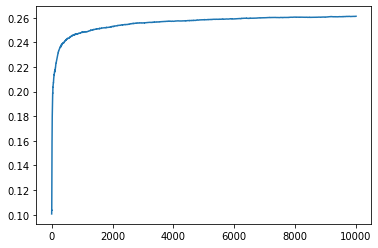

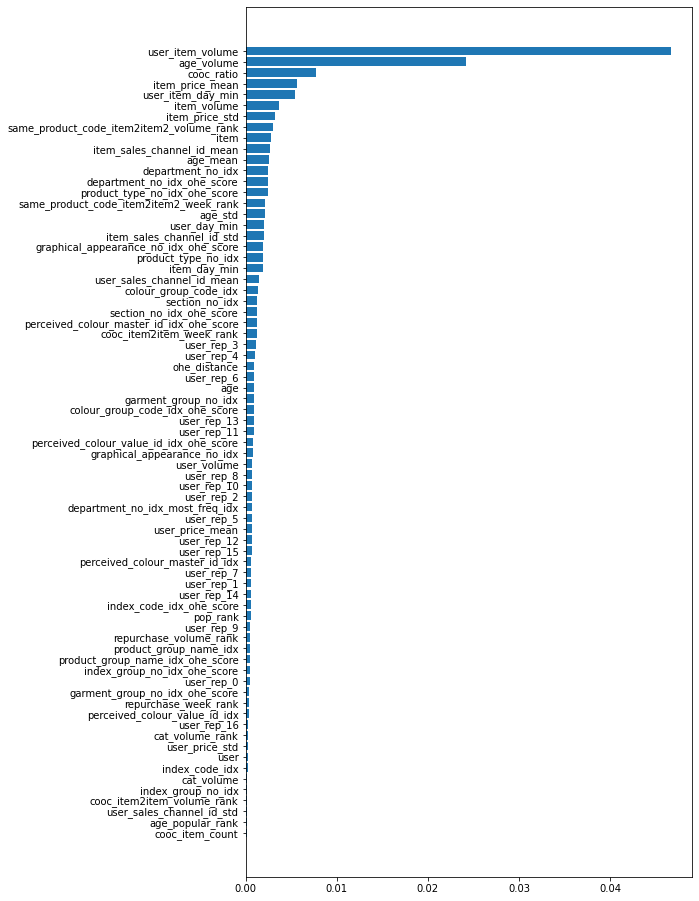

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 10000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.035894049732084536


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.774 s


[item stacic features] 1.921 s


[user dynamic features (transactions)] 3.555 s


[item dynamic features (transactions)] 1.622 s


[item dynamic features (user features)] 4.467 s


[item freshness features] 3.280 s


[item volume features] 1.752 s


[user freshness features] 4.459 s


[user volume features] 2.711 s


[user-item freshness features] 21.287 s


[user-item volume features] 4.946 s


[item age volume features] 2.870 s


[user category most frequent] 87.607 s


[ohe dot products] 67.862 s


[lfm features] 3.910 s
attach features (week: 2)


[user static fetaures] 0.754 s


[item stacic features] 1.920 s


[user dynamic features (transactions)] 3.492 s


[item dynamic features (transactions)] 1.679 s


[item dynamic features (user features)] 4.501 s


[item freshness features] 3.280 s


[item volume features] 1.827 s


[user freshness features] 4.541 s


[user volume features] 2.870 s


[user-item freshness features] 21.743 s


[user-item volume features] 5.155 s


[item age volume features] 2.995 s


[user category most frequent] 81.239 s


[ohe dot products] 67.855 s


[lfm features] 3.866 s
attach features (week: 3)


[user static fetaures] 0.804 s


[item stacic features] 2.139 s


[user dynamic features (transactions)] 3.664 s


[item dynamic features (transactions)] 1.801 s


[item dynamic features (user features)] 4.694 s


[item freshness features] 3.430 s


[item volume features] 1.950 s


[user freshness features] 4.609 s


[user volume features] 2.925 s


[user-item freshness features] 21.361 s


[user-item volume features] 5.339 s


[item age volume features] 3.089 s


[user category most frequent] 85.029 s


[ohe dot products] 69.144 s


[lfm features] 3.996 s
attach features (week: 4)


[user static fetaures] 0.836 s


[item stacic features] 2.166 s


[user dynamic features (transactions)] 3.566 s


[item dynamic features (transactions)] 1.763 s


[item dynamic features (user features)] 4.455 s


[item freshness features] 3.247 s


[item volume features] 1.823 s


[user freshness features] 4.522 s


[user volume features] 2.778 s


[user-item freshness features] 21.020 s


[user-item volume features] 5.333 s


[item age volume features] 3.054 s


[user category most frequent] 85.591 s


[ohe dot products] 74.772 s


[lfm features] 4.093 s
attach features (week: 5)


[user static fetaures] 0.711 s


[item stacic features] 1.891 s


[user dynamic features (transactions)] 3.519 s


[item dynamic features (transactions)] 1.615 s


[item dynamic features (user features)] 4.418 s


[item freshness features] 3.146 s


[item volume features] 1.696 s


[user freshness features] 4.333 s


[user volume features] 2.628 s


[user-item freshness features] 20.871 s


[user-item volume features] 5.018 s


[item age volume features] 2.826 s


[user category most frequent] 81.514 s


[ohe dot products] 81.086 s


[lfm features] 3.887 s
attach features (week: 6)


[user static fetaures] 0.765 s


[item stacic features] 1.912 s


[user dynamic features (transactions)] 3.664 s


[item dynamic features (transactions)] 1.699 s


[item dynamic features (user features)] 4.621 s


[item freshness features] 3.293 s


[item volume features] 1.815 s


[user freshness features] 4.592 s


[user volume features] 2.896 s


[user-item freshness features] 21.524 s


[user-item volume features] 5.335 s


[item age volume features] 2.969 s


[user category most frequent] 87.824 s


[ohe dot products] 78.293 s


[lfm features] 3.814 s
attach features (week: 7)


[user static fetaures] 0.678 s


[item stacic features] 1.704 s


[user dynamic features (transactions)] 3.380 s


[item dynamic features (transactions)] 1.536 s


[item dynamic features (user features)] 4.258 s


[item freshness features] 2.996 s


[item volume features] 1.627 s


[user freshness features] 4.183 s


[user volume features] 2.584 s


[user-item freshness features] 19.094 s


[user-item volume features] 5.088 s


[item age volume features] 2.794 s


[user category most frequent] 90.418 s


[ohe dot products] 80.817 s


[lfm features] 3.796 s


0:	total: 7.94s	remaining: 21h 47m 54s


1:	total: 15.6s	remaining: 21h 28m 41s


2:	total: 23.4s	remaining: 21h 23m 22s


3:	total: 30.9s	remaining: 21h 10m 22s


4:	total: 38.2s	remaining: 20h 58m 58s


5:	total: 45.9s	remaining: 20h 58m 9s


6:	total: 53.5s	remaining: 20h 59m 12s


7:	total: 1m	remaining: 20h 52m 50s


8:	total: 1m 8s	remaining: 20h 57m 21s


9:	total: 1m 16s	remaining: 20h 55m 23s


10:	total: 1m 23s	remaining: 20h 53m 5s


11:	total: 1m 31s	remaining: 20h 51m 37s


12:	total: 1m 39s	remaining: 20h 54m 1s


13:	total: 1m 46s	remaining: 20h 52m 45s


14:	total: 1m 54s	remaining: 20h 56m 30s


15:	total: 2m 2s	remaining: 20h 55m 40s


16:	total: 2m 9s	remaining: 20h 54m 20s


17:	total: 2m 17s	remaining: 20h 52m 50s


18:	total: 2m 25s	remaining: 20h 55m 4s


19:	total: 2m 32s	remaining: 20h 57m 20s


20:	total: 2m 40s	remaining: 20h 55m 59s


21:	total: 2m 47s	remaining: 20h 54m 56s


22:	total: 2m 55s	remaining: 20h 52m 35s


23:	total: 3m 2s	remaining: 20h 52m 25s


24:	total: 3m 10s	remaining: 20h 50m 43s


25:	total: 3m 18s	remaining: 20h 51m 26s


26:	total: 3m 25s	remaining: 20h 50m 9s


27:	total: 3m 32s	remaining: 20h 49m 11s


28:	total: 3m 40s	remaining: 20h 49m 57s


29:	total: 3m 48s	remaining: 20h 50m 40s


30:	total: 3m 56s	remaining: 20h 50m 18s


31:	total: 4m 3s	remaining: 20h 49m 12s


32:	total: 4m 10s	remaining: 20h 48m 20s


33:	total: 4m 18s	remaining: 20h 48m 28s


34:	total: 4m 26s	remaining: 20h 48m 22s


35:	total: 4m 33s	remaining: 20h 48m 20s


36:	total: 4m 41s	remaining: 20h 48m 43s


37:	total: 4m 49s	remaining: 20h 48m 18s


38:	total: 4m 56s	remaining: 20h 47m 36s


39:	total: 5m 4s	remaining: 20h 47m 39s


40:	total: 5m 11s	remaining: 20h 48m


41:	total: 5m 19s	remaining: 20h 48m 43s


42:	total: 5m 27s	remaining: 20h 49m 46s


43:	total: 5m 34s	remaining: 20h 48m 8s


44:	total: 5m 42s	remaining: 20h 48m 19s


45:	total: 5m 50s	remaining: 20h 47m 50s


46:	total: 5m 57s	remaining: 20h 46m 18s


47:	total: 6m 4s	remaining: 20h 45m 35s


48:	total: 6m 12s	remaining: 20h 44m 59s


49:	total: 6m 19s	remaining: 20h 44m 19s


50:	total: 6m 27s	remaining: 20h 44m 26s


51:	total: 6m 34s	remaining: 20h 42m 52s


52:	total: 6m 41s	remaining: 20h 40m 52s


53:	total: 6m 48s	remaining: 20h 38m 54s


54:	total: 6m 55s	remaining: 20h 38m 25s


55:	total: 7m 2s	remaining: 20h 36m 8s


56:	total: 7m 10s	remaining: 20h 36m 6s


57:	total: 7m 17s	remaining: 20h 35m 14s


58:	total: 7m 25s	remaining: 20h 35m 13s


59:	total: 7m 31s	remaining: 20h 33m 16s


60:	total: 7m 39s	remaining: 20h 32m 50s


61:	total: 7m 46s	remaining: 20h 31m 50s


62:	total: 7m 53s	remaining: 20h 30m 58s


63:	total: 8m 1s	remaining: 20h 31m 13s


64:	total: 8m 8s	remaining: 20h 30m 12s


65:	total: 8m 15s	remaining: 20h 29m 33s


66:	total: 8m 23s	remaining: 20h 28m 38s


67:	total: 8m 30s	remaining: 20h 28m 23s


68:	total: 8m 37s	remaining: 20h 27m 44s


69:	total: 8m 45s	remaining: 20h 27m 33s


70:	total: 8m 51s	remaining: 20h 25m 27s


71:	total: 8m 59s	remaining: 20h 24m 20s


72:	total: 9m 6s	remaining: 20h 24m 56s


73:	total: 9m 13s	remaining: 20h 23m 36s


74:	total: 9m 21s	remaining: 20h 23m 35s


75:	total: 9m 28s	remaining: 20h 22m 2s


76:	total: 9m 36s	remaining: 20h 22m 53s


77:	total: 9m 43s	remaining: 20h 22m 58s


78:	total: 9m 51s	remaining: 20h 22m 42s


79:	total: 9m 58s	remaining: 20h 23m 14s


80:	total: 10m 6s	remaining: 20h 23m 15s


81:	total: 10m 14s	remaining: 20h 24m 31s


82:	total: 10m 21s	remaining: 20h 23m 47s


83:	total: 10m 29s	remaining: 20h 23m 42s


84:	total: 10m 36s	remaining: 20h 23m 44s


85:	total: 10m 44s	remaining: 20h 23m 54s


86:	total: 10m 52s	remaining: 20h 24m 22s


87:	total: 10m 59s	remaining: 20h 23m 49s


88:	total: 11m 7s	remaining: 20h 23m 27s


89:	total: 11m 13s	remaining: 20h 22m 25s


90:	total: 11m 21s	remaining: 20h 22m 1s


91:	total: 11m 28s	remaining: 20h 20m 49s


92:	total: 11m 35s	remaining: 20h 21m


93:	total: 11m 43s	remaining: 20h 21m 48s


94:	total: 11m 51s	remaining: 20h 21m 10s


95:	total: 11m 58s	remaining: 20h 20m 47s


96:	total: 12m 5s	remaining: 20h 20m 34s


97:	total: 12m 13s	remaining: 20h 20m 52s


98:	total: 12m 21s	remaining: 20h 21m 25s


99:	total: 12m 28s	remaining: 20h 21m 7s


100:	total: 12m 36s	remaining: 20h 20m 32s


101:	total: 12m 44s	remaining: 20h 21m 31s


102:	total: 12m 52s	remaining: 20h 22m 2s


103:	total: 12m 59s	remaining: 20h 22m 12s


104:	total: 13m 7s	remaining: 20h 21m 48s


105:	total: 13m 13s	remaining: 20h 20m 33s


106:	total: 13m 21s	remaining: 20h 20m 21s


107:	total: 13m 28s	remaining: 20h 19m 25s


108:	total: 13m 35s	remaining: 20h 18m 39s


109:	total: 13m 42s	remaining: 20h 17m 43s


110:	total: 13m 49s	remaining: 20h 17m 6s


111:	total: 13m 56s	remaining: 20h 16m 32s


112:	total: 14m 4s	remaining: 20h 16m 40s


113:	total: 14m 11s	remaining: 20h 16m 8s


114:	total: 14m 19s	remaining: 20h 16m 16s


115:	total: 14m 25s	remaining: 20h 15m 13s


116:	total: 14m 33s	remaining: 20h 15m 38s


117:	total: 14m 41s	remaining: 20h 16m 15s


118:	total: 14m 49s	remaining: 20h 15m 59s


119:	total: 14m 56s	remaining: 20h 15m 37s


120:	total: 15m 3s	remaining: 20h 15m 18s


121:	total: 15m 11s	remaining: 20h 15m 27s


122:	total: 15m 18s	remaining: 20h 15m 19s


123:	total: 15m 26s	remaining: 20h 15m 5s


124:	total: 15m 33s	remaining: 20h 14m 35s


125:	total: 15m 41s	remaining: 20h 14m 41s


126:	total: 15m 48s	remaining: 20h 13m 52s


127:	total: 15m 55s	remaining: 20h 13m 30s


128:	total: 16m 2s	remaining: 20h 12m 28s


129:	total: 16m 10s	remaining: 20h 13m 7s


130:	total: 16m 16s	remaining: 20h 12m 12s


131:	total: 16m 24s	remaining: 20h 12m 18s


132:	total: 16m 32s	remaining: 20h 12m 36s


133:	total: 16m 40s	remaining: 20h 12m 48s


134:	total: 16m 46s	remaining: 20h 11m 49s


135:	total: 16m 54s	remaining: 20h 11m 32s


136:	total: 17m 1s	remaining: 20h 11m 41s


137:	total: 17m 9s	remaining: 20h 12m 12s


138:	total: 17m 17s	remaining: 20h 12m 17s


139:	total: 17m 24s	remaining: 20h 11m 58s


140:	total: 17m 32s	remaining: 20h 11m 59s


141:	total: 17m 40s	remaining: 20h 12m 33s


142:	total: 17m 48s	remaining: 20h 12m 43s


143:	total: 17m 55s	remaining: 20h 12m 19s


144:	total: 18m 2s	remaining: 20h 12m 9s


145:	total: 18m 9s	remaining: 20h 11m 13s


146:	total: 18m 16s	remaining: 20h 10m 22s


147:	total: 18m 24s	remaining: 20h 10m 40s


148:	total: 18m 31s	remaining: 20h 10m 22s


149:	total: 18m 39s	remaining: 20h 10m 23s


150:	total: 18m 45s	remaining: 20h 9m 31s


151:	total: 18m 53s	remaining: 20h 9m 14s


152:	total: 19m	remaining: 20h 8m 28s


153:	total: 19m 7s	remaining: 20h 8m 25s


154:	total: 19m 15s	remaining: 20h 8m 27s


155:	total: 19m 22s	remaining: 20h 8m 8s


156:	total: 19m 29s	remaining: 20h 7m 54s


157:	total: 19m 37s	remaining: 20h 7m 54s


158:	total: 19m 45s	remaining: 20h 8m 12s


159:	total: 19m 53s	remaining: 20h 8m 29s


160:	total: 20m	remaining: 20h 8m 12s


161:	total: 20m 7s	remaining: 20h 7m 58s


162:	total: 20m 15s	remaining: 20h 8m 15s


163:	total: 20m 22s	remaining: 20h 7m 45s


164:	total: 20m 29s	remaining: 20h 7m 30s


165:	total: 20m 37s	remaining: 20h 7m 10s


166:	total: 20m 44s	remaining: 20h 7m 14s


167:	total: 20m 52s	remaining: 20h 6m 58s


168:	total: 20m 59s	remaining: 20h 7m 1s


169:	total: 21m 6s	remaining: 20h 6m 25s


170:	total: 21m 14s	remaining: 20h 6m 59s


171:	total: 21m 22s	remaining: 20h 7m 19s


172:	total: 21m 30s	remaining: 20h 7m 12s


173:	total: 21m 37s	remaining: 20h 6m 45s


174:	total: 21m 45s	remaining: 20h 6m 44s


175:	total: 21m 52s	remaining: 20h 6m 19s


176:	total: 21m 59s	remaining: 20h 6m 10s


177:	total: 22m 6s	remaining: 20h 5m 35s


178:	total: 22m 14s	remaining: 20h 5m 44s


179:	total: 22m 21s	remaining: 20h 5m 32s


180:	total: 22m 28s	remaining: 20h 5m 9s


181:	total: 22m 35s	remaining: 20h 4m 40s


182:	total: 22m 43s	remaining: 20h 4m 49s


183:	total: 22m 51s	remaining: 20h 4m 36s


184:	total: 22m 57s	remaining: 20h 3m 54s


185:	total: 23m 5s	remaining: 20h 4m


186:	total: 23m 12s	remaining: 20h 3m 40s


187:	total: 23m 20s	remaining: 20h 3m 58s


188:	total: 23m 28s	remaining: 20h 3m 48s


189:	total: 23m 35s	remaining: 20h 3m 19s


190:	total: 23m 42s	remaining: 20h 2m 58s


191:	total: 23m 48s	remaining: 20h 2m 10s


192:	total: 23m 56s	remaining: 20h 2m 27s


193:	total: 24m 4s	remaining: 20h 2m 37s


194:	total: 24m 12s	remaining: 20h 2m 57s


195:	total: 24m 20s	remaining: 20h 3m 9s


196:	total: 24m 28s	remaining: 20h 3m 28s


197:	total: 24m 35s	remaining: 20h 3m 13s


198:	total: 24m 42s	remaining: 20h 2m 40s


199:	total: 24m 49s	remaining: 20h 2m 9s


200:	total: 24m 57s	remaining: 20h 2m 9s


201:	total: 25m 4s	remaining: 20h 1m 53s


202:	total: 25m 11s	remaining: 20h 1m 44s


203:	total: 25m 18s	remaining: 20h 1m 6s


204:	total: 25m 25s	remaining: 20h 40s


205:	total: 25m 32s	remaining: 20h 3s


206:	total: 25m 39s	remaining: 19h 59m 36s


207:	total: 25m 47s	remaining: 19h 59m 41s


208:	total: 25m 55s	remaining: 19h 59m 43s


209:	total: 26m 2s	remaining: 19h 59m 41s


210:	total: 26m 9s	remaining: 19h 59m 15s


211:	total: 26m 17s	remaining: 19h 59m 12s


212:	total: 26m 24s	remaining: 19h 58m 46s


213:	total: 26m 31s	remaining: 19h 58m 31s


214:	total: 26m 39s	remaining: 19h 58m 32s


215:	total: 26m 46s	remaining: 19h 58m 21s


216:	total: 26m 53s	remaining: 19h 58m 20s


217:	total: 27m 1s	remaining: 19h 57m 55s


218:	total: 27m 8s	remaining: 19h 58m 6s


219:	total: 27m 16s	remaining: 19h 57m 53s


220:	total: 27m 23s	remaining: 19h 57m 19s


221:	total: 27m 30s	remaining: 19h 56m 58s


222:	total: 27m 37s	remaining: 19h 56m 42s


223:	total: 27m 44s	remaining: 19h 56m 26s


224:	total: 27m 51s	remaining: 19h 56m 5s


225:	total: 27m 58s	remaining: 19h 55m 27s


226:	total: 28m 5s	remaining: 19h 55m 15s


227:	total: 28m 12s	remaining: 19h 54m 36s


228:	total: 28m 20s	remaining: 19h 54m 54s


229:	total: 28m 27s	remaining: 19h 54m 47s


230:	total: 28m 34s	remaining: 19h 54m 24s


231:	total: 28m 42s	remaining: 19h 54m 9s


232:	total: 28m 49s	remaining: 19h 54m 10s


233:	total: 28m 57s	remaining: 19h 53m 57s


234:	total: 29m 4s	remaining: 19h 53m 28s


235:	total: 29m 11s	remaining: 19h 53m 26s


236:	total: 29m 18s	remaining: 19h 53m 4s


237:	total: 29m 25s	remaining: 19h 52m 33s


238:	total: 29m 33s	remaining: 19h 52m 43s


239:	total: 29m 40s	remaining: 19h 52m 36s


240:	total: 29m 48s	remaining: 19h 53m 1s


241:	total: 29m 56s	remaining: 19h 53m 13s


242:	total: 30m 3s	remaining: 19h 52m 50s


243:	total: 30m 10s	remaining: 19h 52m 9s


244:	total: 30m 17s	remaining: 19h 51m 54s


245:	total: 30m 24s	remaining: 19h 51m 40s


246:	total: 30m 31s	remaining: 19h 51m 14s


247:	total: 30m 39s	remaining: 19h 51m 15s


248:	total: 30m 47s	remaining: 19h 51m 9s


249:	total: 30m 54s	remaining: 19h 51m 7s


250:	total: 31m 2s	remaining: 19h 51m 6s


251:	total: 31m 9s	remaining: 19h 50m 52s


252:	total: 31m 16s	remaining: 19h 50m 30s


253:	total: 31m 23s	remaining: 19h 50m 8s


254:	total: 31m 31s	remaining: 19h 50m 15s


255:	total: 31m 38s	remaining: 19h 49m 56s


256:	total: 31m 45s	remaining: 19h 49m 41s


257:	total: 31m 52s	remaining: 19h 49m 17s


258:	total: 32m	remaining: 19h 49m 42s


259:	total: 32m 8s	remaining: 19h 49m 55s


260:	total: 32m 16s	remaining: 19h 50m 15s


261:	total: 32m 24s	remaining: 19h 49m 57s


262:	total: 32m 31s	remaining: 19h 49m 46s


263:	total: 32m 38s	remaining: 19h 49m 18s


264:	total: 32m 46s	remaining: 19h 49m 32s


265:	total: 32m 52s	remaining: 19h 48m 55s


266:	total: 33m	remaining: 19h 49m 1s


267:	total: 33m 8s	remaining: 19h 48m 59s


268:	total: 33m 16s	remaining: 19h 49m 4s


269:	total: 33m 23s	remaining: 19h 49m 3s


270:	total: 33m 30s	remaining: 19h 48m 42s


271:	total: 33m 37s	remaining: 19h 48m 30s


272:	total: 33m 44s	remaining: 19h 48m 8s


273:	total: 33m 52s	remaining: 19h 48m 16s


274:	total: 34m	remaining: 19h 48m 10s


275:	total: 34m 7s	remaining: 19h 48m 2s


276:	total: 34m 14s	remaining: 19h 47m 40s


277:	total: 34m 22s	remaining: 19h 47m 45s


278:	total: 34m 29s	remaining: 19h 47m 36s


279:	total: 34m 37s	remaining: 19h 47m 54s


280:	total: 34m 45s	remaining: 19h 47m 55s


281:	total: 34m 52s	remaining: 19h 47m 42s


282:	total: 35m	remaining: 19h 47m 34s


283:	total: 35m 6s	remaining: 19h 46m 55s


284:	total: 35m 13s	remaining: 19h 46m 32s


285:	total: 35m 20s	remaining: 19h 46m 18s


286:	total: 35m 28s	remaining: 19h 46m 3s


287:	total: 35m 35s	remaining: 19h 46m 2s


288:	total: 35m 42s	remaining: 19h 45m 47s


289:	total: 35m 50s	remaining: 19h 45m 47s


290:	total: 35m 57s	remaining: 19h 45m 29s


291:	total: 36m 4s	remaining: 19h 45m 9s


292:	total: 36m 12s	remaining: 19h 45m


293:	total: 36m 19s	remaining: 19h 44m 54s


294:	total: 36m 26s	remaining: 19h 44m 29s


295:	total: 36m 34s	remaining: 19h 44m 46s


296:	total: 36m 42s	remaining: 19h 44m 47s


297:	total: 36m 49s	remaining: 19h 44m 22s


298:	total: 36m 56s	remaining: 19h 44m 7s


299:	total: 37m 3s	remaining: 19h 43m 55s


300:	total: 37m 11s	remaining: 19h 43m 53s


301:	total: 37m 18s	remaining: 19h 43m 48s


302:	total: 37m 26s	remaining: 19h 43m 56s


303:	total: 37m 33s	remaining: 19h 43m 33s


304:	total: 37m 40s	remaining: 19h 43m 29s


305:	total: 37m 48s	remaining: 19h 43m 31s


306:	total: 37m 56s	remaining: 19h 43m 33s


307:	total: 38m 3s	remaining: 19h 43m 17s


308:	total: 38m 10s	remaining: 19h 43m 8s


309:	total: 38m 18s	remaining: 19h 43m 6s


310:	total: 38m 26s	remaining: 19h 43m 7s


311:	total: 38m 33s	remaining: 19h 42m 55s


312:	total: 38m 40s	remaining: 19h 42m 34s


313:	total: 38m 47s	remaining: 19h 42m 18s


314:	total: 38m 54s	remaining: 19h 42m 2s


315:	total: 39m 2s	remaining: 19h 41m 59s


316:	total: 39m 9s	remaining: 19h 41m 59s


317:	total: 39m 17s	remaining: 19h 41m 51s


318:	total: 39m 24s	remaining: 19h 41m 39s


319:	total: 39m 32s	remaining: 19h 41m 35s


320:	total: 39m 39s	remaining: 19h 41m 14s


321:	total: 39m 46s	remaining: 19h 41m 9s


322:	total: 39m 53s	remaining: 19h 40m 51s


323:	total: 40m 1s	remaining: 19h 40m 46s


324:	total: 40m 8s	remaining: 19h 40m 34s


325:	total: 40m 15s	remaining: 19h 40m 29s


326:	total: 40m 23s	remaining: 19h 40m 20s


327:	total: 40m 29s	remaining: 19h 39m 52s


328:	total: 40m 37s	remaining: 19h 39m 48s


329:	total: 40m 44s	remaining: 19h 39m 44s


330:	total: 40m 52s	remaining: 19h 39m 42s


331:	total: 40m 59s	remaining: 19h 39m 11s


332:	total: 41m 6s	remaining: 19h 39m 2s


333:	total: 41m 13s	remaining: 19h 38m 55s


334:	total: 41m 20s	remaining: 19h 38m 36s


335:	total: 41m 27s	remaining: 19h 38m 18s


336:	total: 41m 35s	remaining: 19h 38m 4s


337:	total: 41m 42s	remaining: 19h 37m 53s


338:	total: 41m 50s	remaining: 19h 37m 54s


339:	total: 41m 56s	remaining: 19h 37m 33s


340:	total: 42m 4s	remaining: 19h 37m 20s


341:	total: 42m 11s	remaining: 19h 37m 9s


342:	total: 42m 19s	remaining: 19h 37m 14s


343:	total: 42m 25s	remaining: 19h 36m 41s


344:	total: 42m 33s	remaining: 19h 36m 38s


345:	total: 42m 39s	remaining: 19h 36m 4s


346:	total: 42m 47s	remaining: 19h 35m 59s


347:	total: 42m 55s	remaining: 19h 36m 10s


348:	total: 43m 2s	remaining: 19h 36m 2s


349:	total: 43m 10s	remaining: 19h 35m 55s


350:	total: 43m 17s	remaining: 19h 35m 56s


351:	total: 43m 25s	remaining: 19h 36m 8s


352:	total: 43m 33s	remaining: 19h 36m 15s


353:	total: 43m 40s	remaining: 19h 35m 56s


354:	total: 43m 48s	remaining: 19h 35m 44s


355:	total: 43m 54s	remaining: 19h 35m 8s


356:	total: 44m 1s	remaining: 19h 34m 57s


357:	total: 44m 9s	remaining: 19h 34m 55s


358:	total: 44m 17s	remaining: 19h 34m 57s


359:	total: 44m 24s	remaining: 19h 34m 56s


360:	total: 44m 32s	remaining: 19h 34m 56s


361:	total: 44m 40s	remaining: 19h 35m 2s


362:	total: 44m 47s	remaining: 19h 34m 45s


363:	total: 44m 54s	remaining: 19h 34m 30s


364:	total: 45m 1s	remaining: 19h 34m 3s


365:	total: 45m 8s	remaining: 19h 33m 49s


366:	total: 45m 16s	remaining: 19h 34m 9s


367:	total: 45m 23s	remaining: 19h 33m 41s


368:	total: 45m 30s	remaining: 19h 33m 18s


369:	total: 45m 37s	remaining: 19h 33m 17s


370:	total: 45m 46s	remaining: 19h 33m 37s


371:	total: 45m 53s	remaining: 19h 33m 25s


372:	total: 46m 1s	remaining: 19h 33m 28s


373:	total: 46m 9s	remaining: 19h 33m 32s


374:	total: 46m 15s	remaining: 19h 33m 6s


375:	total: 46m 23s	remaining: 19h 33m 8s


376:	total: 46m 31s	remaining: 19h 33m 17s


377:	total: 46m 38s	remaining: 19h 33m 2s


378:	total: 46m 45s	remaining: 19h 32m 46s


379:	total: 46m 52s	remaining: 19h 32m 25s


380:	total: 46m 59s	remaining: 19h 32m 12s


381:	total: 47m 7s	remaining: 19h 32m 9s


382:	total: 47m 14s	remaining: 19h 31m 55s


383:	total: 47m 21s	remaining: 19h 31m 46s


384:	total: 47m 28s	remaining: 19h 31m 27s


385:	total: 47m 36s	remaining: 19h 31m 25s


386:	total: 47m 43s	remaining: 19h 31m 11s


387:	total: 47m 50s	remaining: 19h 30m 56s


388:	total: 47m 57s	remaining: 19h 30m 46s


389:	total: 48m 4s	remaining: 19h 30m 12s


390:	total: 48m 12s	remaining: 19h 30m 14s


391:	total: 48m 19s	remaining: 19h 30m 14s


392:	total: 48m 26s	remaining: 19h 30m 1s


393:	total: 48m 34s	remaining: 19h 29m 58s


394:	total: 48m 40s	remaining: 19h 29m 30s


395:	total: 48m 48s	remaining: 19h 29m 17s


396:	total: 48m 55s	remaining: 19h 29m 7s


397:	total: 49m 1s	remaining: 19h 28m 37s


398:	total: 49m 9s	remaining: 19h 28m 33s


399:	total: 49m 16s	remaining: 19h 28m 27s


400:	total: 49m 25s	remaining: 19h 28m 39s


401:	total: 49m 32s	remaining: 19h 28m 26s


402:	total: 49m 39s	remaining: 19h 28m 22s


403:	total: 49m 47s	remaining: 19h 28m 15s


404:	total: 49m 54s	remaining: 19h 28m 1s


405:	total: 50m 1s	remaining: 19h 27m 47s


406:	total: 50m 8s	remaining: 19h 27m 44s


407:	total: 50m 16s	remaining: 19h 27m 32s


408:	total: 50m 22s	remaining: 19h 27m 10s


409:	total: 50m 30s	remaining: 19h 27m


410:	total: 50m 37s	remaining: 19h 27m


411:	total: 50m 44s	remaining: 19h 26m 40s


412:	total: 50m 51s	remaining: 19h 26m 25s


413:	total: 50m 59s	remaining: 19h 26m 20s


414:	total: 51m 6s	remaining: 19h 26m 8s


415:	total: 51m 13s	remaining: 19h 25m 58s


416:	total: 51m 20s	remaining: 19h 25m 46s


417:	total: 51m 28s	remaining: 19h 25m 35s


418:	total: 51m 35s	remaining: 19h 25m 21s


419:	total: 51m 42s	remaining: 19h 25m 14s


420:	total: 51m 49s	remaining: 19h 24m 54s


421:	total: 51m 57s	remaining: 19h 24m 51s


422:	total: 52m 4s	remaining: 19h 24m 35s


423:	total: 52m 11s	remaining: 19h 24m 22s


424:	total: 52m 18s	remaining: 19h 24m 14s


425:	total: 52m 25s	remaining: 19h 23m 47s


426:	total: 52m 32s	remaining: 19h 23m 41s


427:	total: 52m 40s	remaining: 19h 23m 36s


428:	total: 52m 47s	remaining: 19h 23m 40s


429:	total: 52m 56s	remaining: 19h 23m 48s


430:	total: 53m 3s	remaining: 19h 23m 39s


431:	total: 53m 10s	remaining: 19h 23m 31s


432:	total: 53m 18s	remaining: 19h 23m 23s


433:	total: 53m 25s	remaining: 19h 23m 8s


434:	total: 53m 32s	remaining: 19h 23m 3s


435:	total: 53m 40s	remaining: 19h 22m 57s


436:	total: 53m 47s	remaining: 19h 22m 50s


437:	total: 53m 54s	remaining: 19h 22m 37s


438:	total: 54m 1s	remaining: 19h 22m 24s


439:	total: 54m 8s	remaining: 19h 21m 58s


440:	total: 54m 15s	remaining: 19h 21m 55s


441:	total: 54m 23s	remaining: 19h 21m 50s


442:	total: 54m 30s	remaining: 19h 21m 44s


443:	total: 54m 37s	remaining: 19h 21m 27s


444:	total: 54m 44s	remaining: 19h 21m 15s


445:	total: 54m 52s	remaining: 19h 21m 14s


446:	total: 54m 59s	remaining: 19h 20m 57s


447:	total: 55m 6s	remaining: 19h 20m 47s


448:	total: 55m 13s	remaining: 19h 20m 34s


449:	total: 55m 21s	remaining: 19h 20m 23s


450:	total: 55m 28s	remaining: 19h 20m 16s


451:	total: 55m 35s	remaining: 19h 20m 8s


452:	total: 55m 43s	remaining: 19h 20m 6s


453:	total: 55m 50s	remaining: 19h 19m 52s


454:	total: 55m 57s	remaining: 19h 19m 41s


455:	total: 56m 5s	remaining: 19h 19m 44s


456:	total: 56m 12s	remaining: 19h 19m 34s


457:	total: 56m 19s	remaining: 19h 19m 15s


458:	total: 56m 26s	remaining: 19h 18m 52s


459:	total: 56m 33s	remaining: 19h 18m 45s


460:	total: 56m 40s	remaining: 19h 18m 28s


461:	total: 56m 48s	remaining: 19h 18m 30s


462:	total: 56m 55s	remaining: 19h 18m 17s


463:	total: 57m 2s	remaining: 19h 17m 53s


464:	total: 57m 8s	remaining: 19h 17m 34s


465:	total: 57m 16s	remaining: 19h 17m 26s


466:	total: 57m 23s	remaining: 19h 17m 20s


467:	total: 57m 30s	remaining: 19h 16m 54s


468:	total: 57m 36s	remaining: 19h 16m 35s


469:	total: 57m 44s	remaining: 19h 16m 29s


470:	total: 57m 51s	remaining: 19h 16m 15s


471:	total: 57m 58s	remaining: 19h 15m 56s


472:	total: 58m 5s	remaining: 19h 15m 42s


473:	total: 58m 12s	remaining: 19h 15m 33s


474:	total: 58m 19s	remaining: 19h 15m 20s


475:	total: 58m 26s	remaining: 19h 15m 13s


476:	total: 58m 33s	remaining: 19h 14m 55s


477:	total: 58m 40s	remaining: 19h 14m 44s


478:	total: 58m 48s	remaining: 19h 14m 44s


479:	total: 58m 56s	remaining: 19h 14m 39s


480:	total: 59m 3s	remaining: 19h 14m 34s


481:	total: 59m 10s	remaining: 19h 14m 18s


482:	total: 59m 17s	remaining: 19h 14m 7s


483:	total: 59m 24s	remaining: 19h 13m 51s


484:	total: 59m 31s	remaining: 19h 13m 33s


485:	total: 59m 39s	remaining: 19h 13m 30s


486:	total: 59m 45s	remaining: 19h 13m 14s


487:	total: 59m 53s	remaining: 19h 13m 3s


488:	total: 1h	remaining: 19h 12m 58s


489:	total: 1h 7s	remaining: 19h 12m 43s


490:	total: 1h 14s	remaining: 19h 12m 30s


491:	total: 1h 21s	remaining: 19h 12m 14s


492:	total: 1h 28s	remaining: 19h 12m 6s


493:	total: 1h 36s	remaining: 19h 11m 59s


494:	total: 1h 43s	remaining: 19h 11m 51s


495:	total: 1h 50s	remaining: 19h 11m 41s


496:	total: 1h 57s	remaining: 19h 11m 25s


497:	total: 1h 1m 4s	remaining: 19h 11m 10s


498:	total: 1h 1m 11s	remaining: 19h 10m 57s


499:	total: 1h 1m 19s	remaining: 19h 10m 48s


500:	total: 1h 1m 25s	remaining: 19h 10m 33s


501:	total: 1h 1m 33s	remaining: 19h 10m 28s


502:	total: 1h 1m 40s	remaining: 19h 10m 23s


503:	total: 1h 1m 48s	remaining: 19h 10m 11s


504:	total: 1h 1m 55s	remaining: 19h 9m 59s


505:	total: 1h 2m 2s	remaining: 19h 9m 46s


506:	total: 1h 2m 9s	remaining: 19h 9m 37s


507:	total: 1h 2m 16s	remaining: 19h 9m 30s


508:	total: 1h 2m 23s	remaining: 19h 9m 13s


509:	total: 1h 2m 30s	remaining: 19h 9m 2s


510:	total: 1h 2m 37s	remaining: 19h 8m 50s


511:	total: 1h 2m 45s	remaining: 19h 8m 47s


512:	total: 1h 2m 53s	remaining: 19h 8m 44s


513:	total: 1h 2m 59s	remaining: 19h 8m 24s


514:	total: 1h 3m 6s	remaining: 19h 8m 12s


515:	total: 1h 3m 14s	remaining: 19h 8m 8s


516:	total: 1h 3m 21s	remaining: 19h 7m 54s


517:	total: 1h 3m 27s	remaining: 19h 7m 32s


518:	total: 1h 3m 35s	remaining: 19h 7m 23s


519:	total: 1h 3m 41s	remaining: 19h 7m 1s


520:	total: 1h 3m 49s	remaining: 19h 7m 4s


521:	total: 1h 3m 56s	remaining: 19h 6m 45s


522:	total: 1h 4m 2s	remaining: 19h 6m 21s


523:	total: 1h 4m 10s	remaining: 19h 6m 13s


524:	total: 1h 4m 17s	remaining: 19h 5m 57s


525:	total: 1h 4m 23s	remaining: 19h 5m 42s


526:	total: 1h 4m 31s	remaining: 19h 5m 34s


527:	total: 1h 4m 37s	remaining: 19h 5m 14s


528:	total: 1h 4m 44s	remaining: 19h 5m 2s


529:	total: 1h 4m 52s	remaining: 19h 4m 55s


530:	total: 1h 4m 59s	remaining: 19h 4m 47s


531:	total: 1h 5m 6s	remaining: 19h 4m 39s


532:	total: 1h 5m 14s	remaining: 19h 4m 29s


533:	total: 1h 5m 22s	remaining: 19h 4m 31s


534:	total: 1h 5m 29s	remaining: 19h 4m 22s


535:	total: 1h 5m 36s	remaining: 19h 4m 11s


536:	total: 1h 5m 43s	remaining: 19h 4m 5s


537:	total: 1h 5m 50s	remaining: 19h 3m 55s


538:	total: 1h 5m 57s	remaining: 19h 3m 41s


539:	total: 1h 6m 4s	remaining: 19h 3m 25s


540:	total: 1h 6m 11s	remaining: 19h 3m 6s


541:	total: 1h 6m 18s	remaining: 19h 2m 57s


542:	total: 1h 6m 26s	remaining: 19h 2m 52s


543:	total: 1h 6m 33s	remaining: 19h 2m 37s


544:	total: 1h 6m 40s	remaining: 19h 2m 33s


545:	total: 1h 6m 48s	remaining: 19h 2m 30s


546:	total: 1h 6m 55s	remaining: 19h 2m 15s


547:	total: 1h 7m 2s	remaining: 19h 2m 3s


548:	total: 1h 7m 9s	remaining: 19h 2m


549:	total: 1h 7m 16s	remaining: 19h 1m 49s


550:	total: 1h 7m 23s	remaining: 19h 1m 37s


551:	total: 1h 7m 31s	remaining: 19h 1m 27s


552:	total: 1h 7m 38s	remaining: 19h 1m 18s


553:	total: 1h 7m 45s	remaining: 19h 1m 1s


554:	total: 1h 7m 52s	remaining: 19h 58s


555:	total: 1h 8m	remaining: 19h 54s


556:	total: 1h 8m 7s	remaining: 19h 45s


557:	total: 1h 8m 15s	remaining: 19h 43s


558:	total: 1h 8m 22s	remaining: 19h 30s


559:	total: 1h 8m 29s	remaining: 19h 26s


560:	total: 1h 8m 37s	remaining: 19h 19s


561:	total: 1h 8m 44s	remaining: 19h 7s


562:	total: 1h 8m 51s	remaining: 18h 59m 57s


563:	total: 1h 8m 57s	remaining: 18h 59m 36s


564:	total: 1h 9m 4s	remaining: 18h 59m 25s


565:	total: 1h 9m 11s	remaining: 18h 59m 6s


566:	total: 1h 9m 18s	remaining: 18h 58m 51s


567:	total: 1h 9m 25s	remaining: 18h 58m 34s


568:	total: 1h 9m 32s	remaining: 18h 58m 20s


569:	total: 1h 9m 38s	remaining: 18h 58m 3s


570:	total: 1h 9m 45s	remaining: 18h 57m 53s


571:	total: 1h 9m 53s	remaining: 18h 57m 43s


572:	total: 1h 10m 1s	remaining: 18h 57m 47s


573:	total: 1h 10m 8s	remaining: 18h 57m 37s


574:	total: 1h 10m 15s	remaining: 18h 57m 22s


575:	total: 1h 10m 22s	remaining: 18h 57m 14s


576:	total: 1h 10m 29s	remaining: 18h 56m 58s


577:	total: 1h 10m 36s	remaining: 18h 56m 56s


578:	total: 1h 10m 44s	remaining: 18h 56m 48s


579:	total: 1h 10m 51s	remaining: 18h 56m 43s


580:	total: 1h 10m 58s	remaining: 18h 56m 34s


581:	total: 1h 11m 6s	remaining: 18h 56m 24s


582:	total: 1h 11m 12s	remaining: 18h 56m 6s


583:	total: 1h 11m 19s	remaining: 18h 55m 53s


584:	total: 1h 11m 26s	remaining: 18h 55m 41s


585:	total: 1h 11m 33s	remaining: 18h 55m 28s


586:	total: 1h 11m 40s	remaining: 18h 55m 16s


587:	total: 1h 11m 47s	remaining: 18h 55m


588:	total: 1h 11m 54s	remaining: 18h 54m 50s


589:	total: 1h 12m 1s	remaining: 18h 54m 39s


590:	total: 1h 12m 8s	remaining: 18h 54m 27s


591:	total: 1h 12m 15s	remaining: 18h 54m 11s


592:	total: 1h 12m 22s	remaining: 18h 53m 58s


593:	total: 1h 12m 29s	remaining: 18h 53m 48s


594:	total: 1h 12m 37s	remaining: 18h 53m 44s


595:	total: 1h 12m 44s	remaining: 18h 53m 42s


596:	total: 1h 12m 52s	remaining: 18h 53m 33s


597:	total: 1h 12m 59s	remaining: 18h 53m 25s


598:	total: 1h 13m 6s	remaining: 18h 53m 14s


599:	total: 1h 13m 14s	remaining: 18h 53m 11s


600:	total: 1h 13m 20s	remaining: 18h 52m 52s


601:	total: 1h 13m 27s	remaining: 18h 52m 41s


602:	total: 1h 13m 34s	remaining: 18h 52m 26s


603:	total: 1h 13m 41s	remaining: 18h 52m 14s


604:	total: 1h 13m 48s	remaining: 18h 51m 58s


605:	total: 1h 13m 55s	remaining: 18h 51m 47s


606:	total: 1h 14m 2s	remaining: 18h 51m 42s


607:	total: 1h 14m 10s	remaining: 18h 51m 37s


608:	total: 1h 14m 18s	remaining: 18h 51m 40s


609:	total: 1h 14m 25s	remaining: 18h 51m 30s


610:	total: 1h 14m 32s	remaining: 18h 51m 18s


611:	total: 1h 14m 39s	remaining: 18h 51m 4s


612:	total: 1h 14m 46s	remaining: 18h 50m 50s


613:	total: 1h 14m 53s	remaining: 18h 50m 39s


614:	total: 1h 15m 1s	remaining: 18h 50m 38s


615:	total: 1h 15m 9s	remaining: 18h 50m 41s


616:	total: 1h 15m 16s	remaining: 18h 50m 38s


617:	total: 1h 15m 23s	remaining: 18h 50m 21s


618:	total: 1h 15m 30s	remaining: 18h 50m 4s


619:	total: 1h 15m 37s	remaining: 18h 50m 6s


620:	total: 1h 15m 46s	remaining: 18h 50m 12s


621:	total: 1h 15m 52s	remaining: 18h 49m 54s


622:	total: 1h 16m	remaining: 18h 49m 45s


623:	total: 1h 16m 6s	remaining: 18h 49m 29s


624:	total: 1h 16m 13s	remaining: 18h 49m 19s


625:	total: 1h 16m 20s	remaining: 18h 49m 6s


626:	total: 1h 16m 27s	remaining: 18h 48m 54s


627:	total: 1h 16m 34s	remaining: 18h 48m 44s


628:	total: 1h 16m 41s	remaining: 18h 48m 27s


629:	total: 1h 16m 48s	remaining: 18h 48m 6s


630:	total: 1h 16m 55s	remaining: 18h 47m 58s


631:	total: 1h 17m 2s	remaining: 18h 47m 42s


632:	total: 1h 17m 9s	remaining: 18h 47m 31s


633:	total: 1h 17m 16s	remaining: 18h 47m 25s


634:	total: 1h 17m 23s	remaining: 18h 47m 13s


635:	total: 1h 17m 30s	remaining: 18h 47m 4s


636:	total: 1h 17m 38s	remaining: 18h 47m 2s


637:	total: 1h 17m 45s	remaining: 18h 46m 52s


638:	total: 1h 17m 52s	remaining: 18h 46m 42s


639:	total: 1h 17m 59s	remaining: 18h 46m 30s


640:	total: 1h 18m 6s	remaining: 18h 46m 23s


641:	total: 1h 18m 13s	remaining: 18h 46m 8s


642:	total: 1h 18m 20s	remaining: 18h 45m 59s


643:	total: 1h 18m 28s	remaining: 18h 45m 50s


644:	total: 1h 18m 34s	remaining: 18h 45m 37s


645:	total: 1h 18m 42s	remaining: 18h 45m 26s


646:	total: 1h 18m 49s	remaining: 18h 45m 23s


647:	total: 1h 18m 56s	remaining: 18h 45m 14s


648:	total: 1h 19m 4s	remaining: 18h 45m 9s


649:	total: 1h 19m 11s	remaining: 18h 44m 56s


650:	total: 1h 19m 18s	remaining: 18h 44m 48s


651:	total: 1h 19m 25s	remaining: 18h 44m 34s


652:	total: 1h 19m 32s	remaining: 18h 44m 20s


653:	total: 1h 19m 39s	remaining: 18h 44m 12s


654:	total: 1h 19m 46s	remaining: 18h 44m 5s


655:	total: 1h 19m 54s	remaining: 18h 44m


656:	total: 1h 20m 1s	remaining: 18h 43m 49s


657:	total: 1h 20m 8s	remaining: 18h 43m 35s


658:	total: 1h 20m 14s	remaining: 18h 43m 18s


659:	total: 1h 20m 22s	remaining: 18h 43m 12s


660:	total: 1h 20m 29s	remaining: 18h 43m 2s


661:	total: 1h 20m 36s	remaining: 18h 42m 48s


662:	total: 1h 20m 43s	remaining: 18h 42m 39s


663:	total: 1h 20m 49s	remaining: 18h 42m 22s


664:	total: 1h 20m 57s	remaining: 18h 42m 20s


665:	total: 1h 21m 4s	remaining: 18h 42m 12s


666:	total: 1h 21m 12s	remaining: 18h 42m 13s


667:	total: 1h 21m 19s	remaining: 18h 42m 2s


668:	total: 1h 21m 27s	remaining: 18h 41m 56s


669:	total: 1h 21m 34s	remaining: 18h 41m 49s


670:	total: 1h 21m 41s	remaining: 18h 41m 35s


671:	total: 1h 21m 48s	remaining: 18h 41m 20s


672:	total: 1h 21m 55s	remaining: 18h 41m 10s


673:	total: 1h 22m 2s	remaining: 18h 41m 1s


674:	total: 1h 22m 9s	remaining: 18h 40m 50s


675:	total: 1h 22m 16s	remaining: 18h 40m 44s


676:	total: 1h 22m 24s	remaining: 18h 40m 39s


677:	total: 1h 22m 31s	remaining: 18h 40m 35s


678:	total: 1h 22m 39s	remaining: 18h 40m 29s


679:	total: 1h 22m 46s	remaining: 18h 40m 26s


680:	total: 1h 22m 54s	remaining: 18h 40m 19s


681:	total: 1h 23m 1s	remaining: 18h 40m 7s


682:	total: 1h 23m 8s	remaining: 18h 40m


683:	total: 1h 23m 15s	remaining: 18h 39m 52s


684:	total: 1h 23m 22s	remaining: 18h 39m 42s


685:	total: 1h 23m 29s	remaining: 18h 39m 33s


686:	total: 1h 23m 37s	remaining: 18h 39m 24s


687:	total: 1h 23m 44s	remaining: 18h 39m 15s


688:	total: 1h 23m 51s	remaining: 18h 39m 3s


689:	total: 1h 23m 57s	remaining: 18h 38m 47s


690:	total: 1h 24m 5s	remaining: 18h 38m 42s


691:	total: 1h 24m 12s	remaining: 18h 38m 32s


692:	total: 1h 24m 19s	remaining: 18h 38m 17s


693:	total: 1h 24m 26s	remaining: 18h 38m 9s


694:	total: 1h 24m 33s	remaining: 18h 37m 53s


695:	total: 1h 24m 40s	remaining: 18h 37m 48s


696:	total: 1h 24m 47s	remaining: 18h 37m 31s


697:	total: 1h 24m 54s	remaining: 18h 37m 25s


698:	total: 1h 25m 1s	remaining: 18h 37m 16s


699:	total: 1h 25m 8s	remaining: 18h 37m 8s


700:	total: 1h 25m 16s	remaining: 18h 36m 59s


701:	total: 1h 25m 22s	remaining: 18h 36m 46s


702:	total: 1h 25m 30s	remaining: 18h 36m 36s


703:	total: 1h 25m 37s	remaining: 18h 36m 26s


704:	total: 1h 25m 43s	remaining: 18h 36m 12s


705:	total: 1h 25m 51s	remaining: 18h 36m 3s


706:	total: 1h 25m 58s	remaining: 18h 35m 57s


707:	total: 1h 26m 6s	remaining: 18h 35m 56s


708:	total: 1h 26m 13s	remaining: 18h 35m 44s


709:	total: 1h 26m 20s	remaining: 18h 35m 34s


710:	total: 1h 26m 27s	remaining: 18h 35m 20s


711:	total: 1h 26m 34s	remaining: 18h 35m 9s


712:	total: 1h 26m 40s	remaining: 18h 34m 57s


713:	total: 1h 26m 47s	remaining: 18h 34m 44s


714:	total: 1h 26m 55s	remaining: 18h 34m 43s


715:	total: 1h 27m 2s	remaining: 18h 34m 32s


716:	total: 1h 27m 9s	remaining: 18h 34m 15s


717:	total: 1h 27m 16s	remaining: 18h 34m 5s


718:	total: 1h 27m 23s	remaining: 18h 33m 57s


719:	total: 1h 27m 30s	remaining: 18h 33m 45s


720:	total: 1h 27m 37s	remaining: 18h 33m 31s


721:	total: 1h 27m 44s	remaining: 18h 33m 23s


722:	total: 1h 27m 52s	remaining: 18h 33m 21s


723:	total: 1h 27m 59s	remaining: 18h 33m 13s


724:	total: 1h 28m 6s	remaining: 18h 33m 3s


725:	total: 1h 28m 13s	remaining: 18h 32m 59s


726:	total: 1h 28m 21s	remaining: 18h 32m 49s


727:	total: 1h 28m 27s	remaining: 18h 32m 33s


728:	total: 1h 28m 35s	remaining: 18h 32m 27s


729:	total: 1h 28m 41s	remaining: 18h 32m 13s


730:	total: 1h 28m 48s	remaining: 18h 32m 3s


731:	total: 1h 28m 56s	remaining: 18h 31m 59s


732:	total: 1h 29m 3s	remaining: 18h 31m 52s


733:	total: 1h 29m 11s	remaining: 18h 31m 52s


734:	total: 1h 29m 18s	remaining: 18h 31m 45s


735:	total: 1h 29m 26s	remaining: 18h 31m 39s


736:	total: 1h 29m 33s	remaining: 18h 31m 26s


737:	total: 1h 29m 40s	remaining: 18h 31m 17s


738:	total: 1h 29m 47s	remaining: 18h 31m 3s


739:	total: 1h 29m 54s	remaining: 18h 30m 54s


740:	total: 1h 30m 1s	remaining: 18h 30m 44s


741:	total: 1h 30m 8s	remaining: 18h 30m 36s


742:	total: 1h 30m 15s	remaining: 18h 30m 24s


743:	total: 1h 30m 22s	remaining: 18h 30m 12s


744:	total: 1h 30m 29s	remaining: 18h 30m


745:	total: 1h 30m 36s	remaining: 18h 29m 49s


746:	total: 1h 30m 43s	remaining: 18h 29m 42s


747:	total: 1h 30m 50s	remaining: 18h 29m 33s


748:	total: 1h 30m 57s	remaining: 18h 29m 25s


749:	total: 1h 31m 4s	remaining: 18h 29m 15s


750:	total: 1h 31m 11s	remaining: 18h 29m 4s


751:	total: 1h 31m 18s	remaining: 18h 28m 44s


752:	total: 1h 31m 24s	remaining: 18h 28m 30s


753:	total: 1h 31m 32s	remaining: 18h 28m 30s


754:	total: 1h 31m 39s	remaining: 18h 28m 19s


755:	total: 1h 31m 47s	remaining: 18h 28m 15s


756:	total: 1h 31m 54s	remaining: 18h 28m 5s


757:	total: 1h 32m 1s	remaining: 18h 27m 55s


758:	total: 1h 32m 8s	remaining: 18h 27m 50s


759:	total: 1h 32m 15s	remaining: 18h 27m 38s


760:	total: 1h 32m 23s	remaining: 18h 27m 30s


761:	total: 1h 32m 29s	remaining: 18h 27m 18s


762:	total: 1h 32m 36s	remaining: 18h 27m 6s


763:	total: 1h 32m 44s	remaining: 18h 26m 59s


764:	total: 1h 32m 51s	remaining: 18h 26m 51s


765:	total: 1h 32m 58s	remaining: 18h 26m 38s


766:	total: 1h 33m 5s	remaining: 18h 26m 29s


767:	total: 1h 33m 13s	remaining: 18h 26m 31s


768:	total: 1h 33m 20s	remaining: 18h 26m 22s


769:	total: 1h 33m 27s	remaining: 18h 26m 11s


770:	total: 1h 33m 34s	remaining: 18h 26m 3s


771:	total: 1h 33m 41s	remaining: 18h 25m 48s


772:	total: 1h 33m 48s	remaining: 18h 25m 38s


773:	total: 1h 33m 55s	remaining: 18h 25m 27s


774:	total: 1h 34m 2s	remaining: 18h 25m 19s


775:	total: 1h 34m 9s	remaining: 18h 25m 8s


776:	total: 1h 34m 16s	remaining: 18h 24m 58s


777:	total: 1h 34m 24s	remaining: 18h 24m 54s


778:	total: 1h 34m 31s	remaining: 18h 24m 46s


779:	total: 1h 34m 38s	remaining: 18h 24m 38s


780:	total: 1h 34m 45s	remaining: 18h 24m 25s


781:	total: 1h 34m 52s	remaining: 18h 24m 12s


782:	total: 1h 34m 59s	remaining: 18h 24m 8s


783:	total: 1h 35m 6s	remaining: 18h 24m


784:	total: 1h 35m 14s	remaining: 18h 23m 51s


785:	total: 1h 35m 21s	remaining: 18h 23m 44s


786:	total: 1h 35m 28s	remaining: 18h 23m 36s


787:	total: 1h 35m 35s	remaining: 18h 23m 30s


788:	total: 1h 35m 43s	remaining: 18h 23m 27s


789:	total: 1h 35m 50s	remaining: 18h 23m 13s


790:	total: 1h 35m 57s	remaining: 18h 23m 8s


791:	total: 1h 36m 4s	remaining: 18h 22m 58s


792:	total: 1h 36m 12s	remaining: 18h 22m 51s


793:	total: 1h 36m 19s	remaining: 18h 22m 42s


794:	total: 1h 36m 26s	remaining: 18h 22m 35s


795:	total: 1h 36m 33s	remaining: 18h 22m 27s


796:	total: 1h 36m 40s	remaining: 18h 22m 13s


797:	total: 1h 36m 47s	remaining: 18h 21m 58s


798:	total: 1h 36m 53s	remaining: 18h 21m 46s


799:	total: 1h 37m 1s	remaining: 18h 21m 41s


800:	total: 1h 37m 8s	remaining: 18h 21m 29s


801:	total: 1h 37m 15s	remaining: 18h 21m 20s


802:	total: 1h 37m 22s	remaining: 18h 21m 17s


803:	total: 1h 37m 30s	remaining: 18h 21m 8s


804:	total: 1h 37m 37s	remaining: 18h 20m 59s


805:	total: 1h 37m 44s	remaining: 18h 20m 57s


806:	total: 1h 37m 52s	remaining: 18h 20m 48s


807:	total: 1h 37m 59s	remaining: 18h 20m 41s


808:	total: 1h 38m 6s	remaining: 18h 20m 34s


809:	total: 1h 38m 14s	remaining: 18h 20m 29s


810:	total: 1h 38m 21s	remaining: 18h 20m 21s


811:	total: 1h 38m 28s	remaining: 18h 20m 14s


812:	total: 1h 38m 35s	remaining: 18h 20m 5s


813:	total: 1h 38m 43s	remaining: 18h 19m 59s


814:	total: 1h 38m 49s	remaining: 18h 19m 46s


815:	total: 1h 38m 57s	remaining: 18h 19m 38s


816:	total: 1h 39m 4s	remaining: 18h 19m 27s


817:	total: 1h 39m 10s	remaining: 18h 19m 14s


818:	total: 1h 39m 17s	remaining: 18h 19m 5s


819:	total: 1h 39m 24s	remaining: 18h 18m 50s


820:	total: 1h 39m 31s	remaining: 18h 18m 43s


821:	total: 1h 39m 38s	remaining: 18h 18m 31s


822:	total: 1h 39m 45s	remaining: 18h 18m 19s


823:	total: 1h 39m 52s	remaining: 18h 18m 10s


824:	total: 1h 39m 59s	remaining: 18h 18m 2s


825:	total: 1h 40m 6s	remaining: 18h 17m 52s


826:	total: 1h 40m 14s	remaining: 18h 17m 47s


827:	total: 1h 40m 20s	remaining: 18h 17m 31s


828:	total: 1h 40m 27s	remaining: 18h 17m 19s


829:	total: 1h 40m 34s	remaining: 18h 17m 8s


830:	total: 1h 40m 41s	remaining: 18h 16m 53s


831:	total: 1h 40m 48s	remaining: 18h 16m 42s


832:	total: 1h 40m 55s	remaining: 18h 16m 31s


833:	total: 1h 41m 2s	remaining: 18h 16m 30s


834:	total: 1h 41m 9s	remaining: 18h 16m 17s


835:	total: 1h 41m 16s	remaining: 18h 16m 8s


836:	total: 1h 41m 23s	remaining: 18h 15m 58s


837:	total: 1h 41m 30s	remaining: 18h 15m 45s


838:	total: 1h 41m 37s	remaining: 18h 15m 36s


839:	total: 1h 41m 44s	remaining: 18h 15m 20s


840:	total: 1h 41m 51s	remaining: 18h 15m 10s


841:	total: 1h 41m 57s	remaining: 18h 14m 55s


842:	total: 1h 42m 4s	remaining: 18h 14m 40s


843:	total: 1h 42m 11s	remaining: 18h 14m 32s


844:	total: 1h 42m 18s	remaining: 18h 14m 23s


845:	total: 1h 42m 25s	remaining: 18h 14m 16s


846:	total: 1h 42m 32s	remaining: 18h 14m 4s


847:	total: 1h 42m 40s	remaining: 18h 13m 59s


848:	total: 1h 42m 46s	remaining: 18h 13m 46s


849:	total: 1h 42m 53s	remaining: 18h 13m 32s


850:	total: 1h 43m	remaining: 18h 13m 20s


851:	total: 1h 43m 7s	remaining: 18h 13m 14s


852:	total: 1h 43m 14s	remaining: 18h 13m 4s


853:	total: 1h 43m 21s	remaining: 18h 12m 48s


854:	total: 1h 43m 28s	remaining: 18h 12m 44s


855:	total: 1h 43m 36s	remaining: 18h 12m 40s


856:	total: 1h 43m 43s	remaining: 18h 12m 29s


857:	total: 1h 43m 49s	remaining: 18h 12m 18s


858:	total: 1h 43m 56s	remaining: 18h 12m 6s


859:	total: 1h 44m 3s	remaining: 18h 11m 56s


860:	total: 1h 44m 10s	remaining: 18h 11m 47s


861:	total: 1h 44m 18s	remaining: 18h 11m 39s


862:	total: 1h 44m 25s	remaining: 18h 11m 29s


863:	total: 1h 44m 32s	remaining: 18h 11m 28s


864:	total: 1h 44m 40s	remaining: 18h 11m 20s


865:	total: 1h 44m 47s	remaining: 18h 11m 9s


866:	total: 1h 44m 54s	remaining: 18h 10m 59s


867:	total: 1h 45m 1s	remaining: 18h 10m 52s


868:	total: 1h 45m 8s	remaining: 18h 10m 43s


869:	total: 1h 45m 15s	remaining: 18h 10m 29s


870:	total: 1h 45m 22s	remaining: 18h 10m 20s


871:	total: 1h 45m 28s	remaining: 18h 10m 7s


872:	total: 1h 45m 36s	remaining: 18h 10m 7s


873:	total: 1h 45m 43s	remaining: 18h 9m 57s


874:	total: 1h 45m 50s	remaining: 18h 9m 43s


875:	total: 1h 45m 57s	remaining: 18h 9m 31s


876:	total: 1h 46m 3s	remaining: 18h 9m 15s


877:	total: 1h 46m 9s	remaining: 18h 8m 59s


878:	total: 1h 46m 16s	remaining: 18h 8m 48s


879:	total: 1h 46m 24s	remaining: 18h 8m 42s


880:	total: 1h 46m 31s	remaining: 18h 8m 38s


881:	total: 1h 46m 39s	remaining: 18h 8m 32s


882:	total: 1h 46m 45s	remaining: 18h 8m 18s


883:	total: 1h 46m 52s	remaining: 18h 8m 7s


884:	total: 1h 46m 59s	remaining: 18h 7m 53s


885:	total: 1h 47m 6s	remaining: 18h 7m 45s


886:	total: 1h 47m 13s	remaining: 18h 7m 36s


887:	total: 1h 47m 20s	remaining: 18h 7m 26s


888:	total: 1h 47m 26s	remaining: 18h 7m 9s


889:	total: 1h 47m 33s	remaining: 18h 7m


890:	total: 1h 47m 41s	remaining: 18h 6m 58s


891:	total: 1h 47m 48s	remaining: 18h 6m 42s


892:	total: 1h 47m 54s	remaining: 18h 6m 29s


893:	total: 1h 48m 1s	remaining: 18h 6m 20s


894:	total: 1h 48m 8s	remaining: 18h 6m 9s


895:	total: 1h 48m 15s	remaining: 18h 5m 59s


896:	total: 1h 48m 22s	remaining: 18h 5m 45s


897:	total: 1h 48m 29s	remaining: 18h 5m 37s


898:	total: 1h 48m 36s	remaining: 18h 5m 29s


899:	total: 1h 48m 42s	remaining: 18h 5m 13s


900:	total: 1h 48m 49s	remaining: 18h 5m 3s


901:	total: 1h 48m 57s	remaining: 18h 4m 59s


902:	total: 1h 49m 4s	remaining: 18h 4m 53s


903:	total: 1h 49m 11s	remaining: 18h 4m 42s


904:	total: 1h 49m 19s	remaining: 18h 4m 35s


905:	total: 1h 49m 25s	remaining: 18h 4m 24s


906:	total: 1h 49m 32s	remaining: 18h 4m 12s


907:	total: 1h 49m 39s	remaining: 18h 4m 1s


908:	total: 1h 49m 46s	remaining: 18h 3m 49s


909:	total: 1h 49m 53s	remaining: 18h 3m 38s


910:	total: 1h 50m	remaining: 18h 3m 30s


911:	total: 1h 50m 7s	remaining: 18h 3m 22s


912:	total: 1h 50m 14s	remaining: 18h 3m 17s


913:	total: 1h 50m 22s	remaining: 18h 3m 9s


914:	total: 1h 50m 28s	remaining: 18h 2m 56s


915:	total: 1h 50m 35s	remaining: 18h 2m 46s


916:	total: 1h 50m 43s	remaining: 18h 2m 46s


917:	total: 1h 50m 50s	remaining: 18h 2m 35s


918:	total: 1h 50m 57s	remaining: 18h 2m 25s


919:	total: 1h 51m 4s	remaining: 18h 2m 18s


920:	total: 1h 51m 11s	remaining: 18h 2m 3s


921:	total: 1h 51m 18s	remaining: 18h 1m 57s


922:	total: 1h 51m 26s	remaining: 18h 1m 51s


923:	total: 1h 51m 32s	remaining: 18h 1m 40s


924:	total: 1h 51m 40s	remaining: 18h 1m 35s


925:	total: 1h 51m 47s	remaining: 18h 1m 26s


926:	total: 1h 51m 54s	remaining: 18h 1m 15s


927:	total: 1h 52m 1s	remaining: 18h 1m 3s


928:	total: 1h 52m 8s	remaining: 18h 55s


929:	total: 1h 52m 15s	remaining: 18h 47s


930:	total: 1h 52m 22s	remaining: 18h 37s


931:	total: 1h 52m 29s	remaining: 18h 26s


932:	total: 1h 52m 36s	remaining: 18h 15s


933:	total: 1h 52m 43s	remaining: 18h 12s


934:	total: 1h 52m 50s	remaining: 17h 59m 58s


935:	total: 1h 52m 56s	remaining: 17h 59m 46s


936:	total: 1h 53m 3s	remaining: 17h 59m 33s


937:	total: 1h 53m 10s	remaining: 17h 59m 25s


938:	total: 1h 53m 17s	remaining: 17h 59m 17s


939:	total: 1h 53m 24s	remaining: 17h 59m 4s


940:	total: 1h 53m 31s	remaining: 17h 58m 59s


941:	total: 1h 53m 38s	remaining: 17h 58m 49s


942:	total: 1h 53m 46s	remaining: 17h 58m 42s


943:	total: 1h 53m 53s	remaining: 17h 58m 34s


944:	total: 1h 54m	remaining: 17h 58m 24s


945:	total: 1h 54m 7s	remaining: 17h 58m 14s


946:	total: 1h 54m 13s	remaining: 17h 58m


947:	total: 1h 54m 20s	remaining: 17h 57m 51s


948:	total: 1h 54m 28s	remaining: 17h 57m 46s


949:	total: 1h 54m 35s	remaining: 17h 57m 35s


950:	total: 1h 54m 42s	remaining: 17h 57m 27s


951:	total: 1h 54m 49s	remaining: 17h 57m 22s


952:	total: 1h 54m 56s	remaining: 17h 57m 13s


953:	total: 1h 55m 3s	remaining: 17h 56m 57s


954:	total: 1h 55m 10s	remaining: 17h 56m 52s


955:	total: 1h 55m 17s	remaining: 17h 56m 45s


956:	total: 1h 55m 25s	remaining: 17h 56m 38s


957:	total: 1h 55m 32s	remaining: 17h 56m 28s


958:	total: 1h 55m 38s	remaining: 17h 56m 18s


959:	total: 1h 55m 45s	remaining: 17h 56m 6s


960:	total: 1h 55m 53s	remaining: 17h 56m 3s


961:	total: 1h 56m	remaining: 17h 55m 52s


962:	total: 1h 56m 7s	remaining: 17h 55m 44s


963:	total: 1h 56m 14s	remaining: 17h 55m 33s


964:	total: 1h 56m 20s	remaining: 17h 55m 20s


965:	total: 1h 56m 27s	remaining: 17h 55m 11s


966:	total: 1h 56m 35s	remaining: 17h 55m 9s


967:	total: 1h 56m 42s	remaining: 17h 54m 59s


968:	total: 1h 56m 49s	remaining: 17h 54m 48s


969:	total: 1h 56m 56s	remaining: 17h 54m 42s


970:	total: 1h 57m 4s	remaining: 17h 54m 36s


971:	total: 1h 57m 12s	remaining: 17h 54m 36s


972:	total: 1h 57m 18s	remaining: 17h 54m 23s


973:	total: 1h 57m 25s	remaining: 17h 54m 15s


974:	total: 1h 57m 33s	remaining: 17h 54m 8s


975:	total: 1h 57m 40s	remaining: 17h 54m


976:	total: 1h 57m 47s	remaining: 17h 53m 52s


977:	total: 1h 57m 54s	remaining: 17h 53m 38s


978:	total: 1h 58m 1s	remaining: 17h 53m 28s


979:	total: 1h 58m 8s	remaining: 17h 53m 22s


980:	total: 1h 58m 15s	remaining: 17h 53m 12s


981:	total: 1h 58m 21s	remaining: 17h 53m


982:	total: 1h 58m 28s	remaining: 17h 52m 48s


983:	total: 1h 58m 35s	remaining: 17h 52m 35s


984:	total: 1h 58m 42s	remaining: 17h 52m 26s


985:	total: 1h 58m 50s	remaining: 17h 52m 24s


986:	total: 1h 58m 57s	remaining: 17h 52m 19s


987:	total: 1h 59m 4s	remaining: 17h 52m 9s


988:	total: 1h 59m 11s	remaining: 17h 51m 58s


989:	total: 1h 59m 18s	remaining: 17h 51m 51s


990:	total: 1h 59m 25s	remaining: 17h 51m 41s


991:	total: 1h 59m 32s	remaining: 17h 51m 28s


992:	total: 1h 59m 39s	remaining: 17h 51m 18s


993:	total: 1h 59m 46s	remaining: 17h 51m 12s


994:	total: 1h 59m 53s	remaining: 17h 51m 1s


995:	total: 2h 1s	remaining: 17h 50m 59s


996:	total: 2h 8s	remaining: 17h 50m 54s


997:	total: 2h 15s	remaining: 17h 50m 48s


998:	total: 2h 22s	remaining: 17h 50m 39s


999:	total: 2h 30s	remaining: 17h 50m 33s


1000:	total: 2h 37s	remaining: 17h 50m 23s


1001:	total: 2h 44s	remaining: 17h 50m 13s


1002:	total: 2h 50s	remaining: 17h 50m 2s


1003:	total: 2h 58s	remaining: 17h 49m 56s


1004:	total: 2h 1m 5s	remaining: 17h 49m 48s


1005:	total: 2h 1m 12s	remaining: 17h 49m 38s


1006:	total: 2h 1m 19s	remaining: 17h 49m 29s


1007:	total: 2h 1m 26s	remaining: 17h 49m 22s


1008:	total: 2h 1m 33s	remaining: 17h 49m 9s


1009:	total: 2h 1m 39s	remaining: 17h 48m 56s


1010:	total: 2h 1m 46s	remaining: 17h 48m 47s


1011:	total: 2h 1m 53s	remaining: 17h 48m 38s


1012:	total: 2h 2m	remaining: 17h 48m 30s


1013:	total: 2h 2m 7s	remaining: 17h 48m 17s


1014:	total: 2h 2m 14s	remaining: 17h 48m 5s


1015:	total: 2h 2m 21s	remaining: 17h 47m 57s


1016:	total: 2h 2m 28s	remaining: 17h 47m 48s


1017:	total: 2h 2m 35s	remaining: 17h 47m 40s


1018:	total: 2h 2m 42s	remaining: 17h 47m 35s


1019:	total: 2h 2m 50s	remaining: 17h 47m 28s


1020:	total: 2h 2m 56s	remaining: 17h 47m 16s


1021:	total: 2h 3m 3s	remaining: 17h 47m 7s


1022:	total: 2h 3m 10s	remaining: 17h 46m 57s


1023:	total: 2h 3m 17s	remaining: 17h 46m 49s


1024:	total: 2h 3m 24s	remaining: 17h 46m 37s


1025:	total: 2h 3m 31s	remaining: 17h 46m 31s


1026:	total: 2h 3m 39s	remaining: 17h 46m 24s


1027:	total: 2h 3m 46s	remaining: 17h 46m 18s


1028:	total: 2h 3m 53s	remaining: 17h 46m 11s


1029:	total: 2h 4m	remaining: 17h 46m 2s


1030:	total: 2h 4m 8s	remaining: 17h 45m 55s


1031:	total: 2h 4m 15s	remaining: 17h 45m 46s


1032:	total: 2h 4m 22s	remaining: 17h 45m 37s


1033:	total: 2h 4m 28s	remaining: 17h 45m 21s


1034:	total: 2h 4m 35s	remaining: 17h 45m 11s


1035:	total: 2h 4m 42s	remaining: 17h 45m 2s


1036:	total: 2h 4m 49s	remaining: 17h 44m 58s


1037:	total: 2h 4m 57s	remaining: 17h 44m 51s


1038:	total: 2h 5m 4s	remaining: 17h 44m 42s


1039:	total: 2h 5m 10s	remaining: 17h 44m 30s


1040:	total: 2h 5m 18s	remaining: 17h 44m 26s


1041:	total: 2h 5m 25s	remaining: 17h 44m 17s


1042:	total: 2h 5m 32s	remaining: 17h 44m 5s


1043:	total: 2h 5m 39s	remaining: 17h 43m 56s


1044:	total: 2h 5m 46s	remaining: 17h 43m 49s


1045:	total: 2h 5m 53s	remaining: 17h 43m 45s


1046:	total: 2h 6m 1s	remaining: 17h 43m 40s


1047:	total: 2h 6m 8s	remaining: 17h 43m 35s


1048:	total: 2h 6m 15s	remaining: 17h 43m 26s


1049:	total: 2h 6m 23s	remaining: 17h 43m 19s


1050:	total: 2h 6m 29s	remaining: 17h 43m 8s


1051:	total: 2h 6m 37s	remaining: 17h 43m 4s


1052:	total: 2h 6m 45s	remaining: 17h 43m 3s


1053:	total: 2h 6m 52s	remaining: 17h 42m 54s


1054:	total: 2h 6m 59s	remaining: 17h 42m 44s


1055:	total: 2h 7m 6s	remaining: 17h 42m 34s


1056:	total: 2h 7m 13s	remaining: 17h 42m 28s


1057:	total: 2h 7m 20s	remaining: 17h 42m 20s


1058:	total: 2h 7m 27s	remaining: 17h 42m 8s


1059:	total: 2h 7m 34s	remaining: 17h 42m


1060:	total: 2h 7m 41s	remaining: 17h 41m 51s


1061:	total: 2h 7m 48s	remaining: 17h 41m 39s


1062:	total: 2h 7m 55s	remaining: 17h 41m 32s


1063:	total: 2h 8m 2s	remaining: 17h 41m 22s


1064:	total: 2h 8m 9s	remaining: 17h 41m 12s


1065:	total: 2h 8m 16s	remaining: 17h 41m 3s


1066:	total: 2h 8m 23s	remaining: 17h 40m 57s


1067:	total: 2h 8m 30s	remaining: 17h 40m 46s


1068:	total: 2h 8m 37s	remaining: 17h 40m 34s


1069:	total: 2h 8m 44s	remaining: 17h 40m 30s


1070:	total: 2h 8m 51s	remaining: 17h 40m 24s


1071:	total: 2h 8m 58s	remaining: 17h 40m 14s


1072:	total: 2h 9m 6s	remaining: 17h 40m 8s


1073:	total: 2h 9m 13s	remaining: 17h 40m 1s


1074:	total: 2h 9m 20s	remaining: 17h 39m 55s


1075:	total: 2h 9m 27s	remaining: 17h 39m 47s


1076:	total: 2h 9m 34s	remaining: 17h 39m 33s


1077:	total: 2h 9m 41s	remaining: 17h 39m 23s


1078:	total: 2h 9m 48s	remaining: 17h 39m 14s


1079:	total: 2h 9m 55s	remaining: 17h 39m 3s


1080:	total: 2h 10m 1s	remaining: 17h 38m 52s


1081:	total: 2h 10m 8s	remaining: 17h 38m 44s


1082:	total: 2h 10m 15s	remaining: 17h 38m 35s


1083:	total: 2h 10m 22s	remaining: 17h 38m 25s


1084:	total: 2h 10m 30s	remaining: 17h 38m 23s


1085:	total: 2h 10m 37s	remaining: 17h 38m 14s


1086:	total: 2h 10m 45s	remaining: 17h 38m 10s


1087:	total: 2h 10m 52s	remaining: 17h 38m 3s


1088:	total: 2h 10m 59s	remaining: 17h 37m 53s


1089:	total: 2h 11m 6s	remaining: 17h 37m 47s


1090:	total: 2h 11m 13s	remaining: 17h 37m 36s


1091:	total: 2h 11m 20s	remaining: 17h 37m 29s


1092:	total: 2h 11m 27s	remaining: 17h 37m 19s


1093:	total: 2h 11m 34s	remaining: 17h 37m 13s


1094:	total: 2h 11m 41s	remaining: 17h 37m 2s


1095:	total: 2h 11m 49s	remaining: 17h 36m 57s


1096:	total: 2h 11m 56s	remaining: 17h 36m 51s


1097:	total: 2h 12m 3s	remaining: 17h 36m 42s


1098:	total: 2h 12m 10s	remaining: 17h 36m 32s


1099:	total: 2h 12m 17s	remaining: 17h 36m 22s


1100:	total: 2h 12m 24s	remaining: 17h 36m 14s


1101:	total: 2h 12m 31s	remaining: 17h 36m 4s


1102:	total: 2h 12m 38s	remaining: 17h 35m 58s


1103:	total: 2h 12m 45s	remaining: 17h 35m 52s


1104:	total: 2h 12m 54s	remaining: 17h 35m 51s


1105:	total: 2h 13m	remaining: 17h 35m 40s


1106:	total: 2h 13m 7s	remaining: 17h 35m 30s


1107:	total: 2h 13m 14s	remaining: 17h 35m 22s


1108:	total: 2h 13m 21s	remaining: 17h 35m 15s


1109:	total: 2h 13m 29s	remaining: 17h 35m 10s


1110:	total: 2h 13m 36s	remaining: 17h 35m


1111:	total: 2h 13m 43s	remaining: 17h 34m 54s


1112:	total: 2h 13m 50s	remaining: 17h 34m 45s


1113:	total: 2h 13m 57s	remaining: 17h 34m 34s


1114:	total: 2h 14m 4s	remaining: 17h 34m 25s


1115:	total: 2h 14m 11s	remaining: 17h 34m 13s


1116:	total: 2h 14m 18s	remaining: 17h 34m 6s


1117:	total: 2h 14m 25s	remaining: 17h 33m 56s


1118:	total: 2h 14m 32s	remaining: 17h 33m 47s


1119:	total: 2h 14m 39s	remaining: 17h 33m 40s


1120:	total: 2h 14m 46s	remaining: 17h 33m 31s


1121:	total: 2h 14m 53s	remaining: 17h 33m 24s


1122:	total: 2h 15m	remaining: 17h 33m 16s


1123:	total: 2h 15m 7s	remaining: 17h 33m 5s


1124:	total: 2h 15m 14s	remaining: 17h 32m 54s


1125:	total: 2h 15m 20s	remaining: 17h 32m 44s


1126:	total: 2h 15m 28s	remaining: 17h 32m 40s


1127:	total: 2h 15m 35s	remaining: 17h 32m 28s


1128:	total: 2h 15m 42s	remaining: 17h 32m 19s


1129:	total: 2h 15m 49s	remaining: 17h 32m 12s


1130:	total: 2h 15m 56s	remaining: 17h 32m 7s


1131:	total: 2h 16m 3s	remaining: 17h 31m 58s


1132:	total: 2h 16m 11s	remaining: 17h 31m 52s


1133:	total: 2h 16m 18s	remaining: 17h 31m 43s


1134:	total: 2h 16m 25s	remaining: 17h 31m 34s


1135:	total: 2h 16m 32s	remaining: 17h 31m 25s


1136:	total: 2h 16m 39s	remaining: 17h 31m 19s


1137:	total: 2h 16m 46s	remaining: 17h 31m 11s


1138:	total: 2h 16m 53s	remaining: 17h 31m 5s


1139:	total: 2h 17m 1s	remaining: 17h 30m 58s


1140:	total: 2h 17m 8s	remaining: 17h 30m 48s


1141:	total: 2h 17m 15s	remaining: 17h 30m 38s


1142:	total: 2h 17m 22s	remaining: 17h 30m 33s


1143:	total: 2h 17m 29s	remaining: 17h 30m 23s


1144:	total: 2h 17m 36s	remaining: 17h 30m 18s


1145:	total: 2h 17m 43s	remaining: 17h 30m 11s


1146:	total: 2h 17m 50s	remaining: 17h 30m 2s


1147:	total: 2h 17m 58s	remaining: 17h 29m 57s


1148:	total: 2h 18m 5s	remaining: 17h 29m 50s


1149:	total: 2h 18m 12s	remaining: 17h 29m 39s


1150:	total: 2h 18m 19s	remaining: 17h 29m 33s


1151:	total: 2h 18m 26s	remaining: 17h 29m 25s


1152:	total: 2h 18m 33s	remaining: 17h 29m 16s


1153:	total: 2h 18m 40s	remaining: 17h 29m 6s


1154:	total: 2h 18m 48s	remaining: 17h 28m 59s


1155:	total: 2h 18m 55s	remaining: 17h 28m 54s


1156:	total: 2h 19m 2s	remaining: 17h 28m 44s


1157:	total: 2h 19m 10s	remaining: 17h 28m 41s


1158:	total: 2h 19m 16s	remaining: 17h 28m 31s


1159:	total: 2h 19m 23s	remaining: 17h 28m 21s


1160:	total: 2h 19m 31s	remaining: 17h 28m 19s


1161:	total: 2h 19m 38s	remaining: 17h 28m 11s


1162:	total: 2h 19m 45s	remaining: 17h 28m 1s


1163:	total: 2h 19m 52s	remaining: 17h 27m 55s


1164:	total: 2h 20m	remaining: 17h 27m 49s


1165:	total: 2h 20m 7s	remaining: 17h 27m 45s


1166:	total: 2h 20m 14s	remaining: 17h 27m 34s


1167:	total: 2h 20m 21s	remaining: 17h 27m 25s


1168:	total: 2h 20m 28s	remaining: 17h 27m 16s


1169:	total: 2h 20m 35s	remaining: 17h 27m 5s


1170:	total: 2h 20m 42s	remaining: 17h 26m 57s


1171:	total: 2h 20m 49s	remaining: 17h 26m 45s


1172:	total: 2h 20m 56s	remaining: 17h 26m 38s


1173:	total: 2h 21m 3s	remaining: 17h 26m 33s


1174:	total: 2h 21m 10s	remaining: 17h 26m 26s


1175:	total: 2h 21m 18s	remaining: 17h 26m 18s


1176:	total: 2h 21m 24s	remaining: 17h 26m 6s


1177:	total: 2h 21m 31s	remaining: 17h 25m 58s


1178:	total: 2h 21m 38s	remaining: 17h 25m 50s


1179:	total: 2h 21m 46s	remaining: 17h 25m 42s


1180:	total: 2h 21m 53s	remaining: 17h 25m 34s


1181:	total: 2h 22m	remaining: 17h 25m 26s


1182:	total: 2h 22m 7s	remaining: 17h 25m 18s


1183:	total: 2h 22m 14s	remaining: 17h 25m 10s


1184:	total: 2h 22m 21s	remaining: 17h 25m 2s


1185:	total: 2h 22m 28s	remaining: 17h 24m 55s


1186:	total: 2h 22m 35s	remaining: 17h 24m 44s


1187:	total: 2h 22m 43s	remaining: 17h 24m 40s


1188:	total: 2h 22m 49s	remaining: 17h 24m 30s


1189:	total: 2h 22m 56s	remaining: 17h 24m 18s


1190:	total: 2h 23m 3s	remaining: 17h 24m 13s


1191:	total: 2h 23m 10s	remaining: 17h 24m 3s


1192:	total: 2h 23m 17s	remaining: 17h 23m 56s


1193:	total: 2h 23m 25s	remaining: 17h 23m 50s


1194:	total: 2h 23m 32s	remaining: 17h 23m 43s


1195:	total: 2h 23m 40s	remaining: 17h 23m 38s


1196:	total: 2h 23m 47s	remaining: 17h 23m 34s


1197:	total: 2h 23m 54s	remaining: 17h 23m 23s


1198:	total: 2h 24m 1s	remaining: 17h 23m 16s


1199:	total: 2h 24m 9s	remaining: 17h 23m 13s


1200:	total: 2h 24m 16s	remaining: 17h 23m 2s


1201:	total: 2h 24m 23s	remaining: 17h 22m 55s


1202:	total: 2h 24m 30s	remaining: 17h 22m 43s


1203:	total: 2h 24m 37s	remaining: 17h 22m 38s


1204:	total: 2h 24m 44s	remaining: 17h 22m 27s


1205:	total: 2h 24m 51s	remaining: 17h 22m 18s


1206:	total: 2h 24m 58s	remaining: 17h 22m 9s


1207:	total: 2h 25m 5s	remaining: 17h 22m 3s


1208:	total: 2h 25m 11s	remaining: 17h 21m 48s


1209:	total: 2h 25m 18s	remaining: 17h 21m 42s


1210:	total: 2h 25m 26s	remaining: 17h 21m 35s


1211:	total: 2h 25m 33s	remaining: 17h 21m 28s


1212:	total: 2h 25m 40s	remaining: 17h 21m 18s


1213:	total: 2h 25m 47s	remaining: 17h 21m 10s


1214:	total: 2h 25m 54s	remaining: 17h 21m


1215:	total: 2h 26m	remaining: 17h 20m 50s


1216:	total: 2h 26m 8s	remaining: 17h 20m 45s


1217:	total: 2h 26m 15s	remaining: 17h 20m 37s


1218:	total: 2h 26m 22s	remaining: 17h 20m 26s


1219:	total: 2h 26m 29s	remaining: 17h 20m 19s


1220:	total: 2h 26m 36s	remaining: 17h 20m 9s


1221:	total: 2h 26m 43s	remaining: 17h 20m 4s


1222:	total: 2h 26m 50s	remaining: 17h 19m 54s


1223:	total: 2h 26m 57s	remaining: 17h 19m 44s


1224:	total: 2h 27m 4s	remaining: 17h 19m 37s


1225:	total: 2h 27m 12s	remaining: 17h 19m 34s


1226:	total: 2h 27m 19s	remaining: 17h 19m 24s


1227:	total: 2h 27m 26s	remaining: 17h 19m 16s


1228:	total: 2h 27m 33s	remaining: 17h 19m 10s


1229:	total: 2h 27m 40s	remaining: 17h 18m 59s


1230:	total: 2h 27m 47s	remaining: 17h 18m 52s


1231:	total: 2h 27m 54s	remaining: 17h 18m 42s


1232:	total: 2h 28m 1s	remaining: 17h 18m 32s


1233:	total: 2h 28m 7s	remaining: 17h 18m 20s


1234:	total: 2h 28m 15s	remaining: 17h 18m 15s


1235:	total: 2h 28m 22s	remaining: 17h 18m 11s


1236:	total: 2h 28m 29s	remaining: 17h 17m 58s


1237:	total: 2h 28m 36s	remaining: 17h 17m 50s


1238:	total: 2h 28m 43s	remaining: 17h 17m 39s


1239:	total: 2h 28m 49s	remaining: 17h 17m 27s


1240:	total: 2h 28m 56s	remaining: 17h 17m 18s


1241:	total: 2h 29m 3s	remaining: 17h 17m 8s


1242:	total: 2h 29m 9s	remaining: 17h 16m 57s


1243:	total: 2h 29m 17s	remaining: 17h 16m 49s


1244:	total: 2h 29m 23s	remaining: 17h 16m 40s


1245:	total: 2h 29m 31s	remaining: 17h 16m 34s


1246:	total: 2h 29m 38s	remaining: 17h 16m 24s


1247:	total: 2h 29m 45s	remaining: 17h 16m 18s


1248:	total: 2h 29m 52s	remaining: 17h 16m 10s


1249:	total: 2h 29m 58s	remaining: 17h 15m 57s


1250:	total: 2h 30m 6s	remaining: 17h 15m 49s


1251:	total: 2h 30m 12s	remaining: 17h 15m 37s


1252:	total: 2h 30m 19s	remaining: 17h 15m 29s


1253:	total: 2h 30m 26s	remaining: 17h 15m 22s


1254:	total: 2h 30m 33s	remaining: 17h 15m 14s


1255:	total: 2h 30m 41s	remaining: 17h 15m 9s


1256:	total: 2h 30m 48s	remaining: 17h 15m


1257:	total: 2h 30m 55s	remaining: 17h 14m 50s


1258:	total: 2h 31m 2s	remaining: 17h 14m 42s


1259:	total: 2h 31m 9s	remaining: 17h 14m 37s


1260:	total: 2h 31m 17s	remaining: 17h 14m 32s


1261:	total: 2h 31m 24s	remaining: 17h 14m 27s


1262:	total: 2h 31m 32s	remaining: 17h 14m 20s


1263:	total: 2h 31m 39s	remaining: 17h 14m 11s


1264:	total: 2h 31m 46s	remaining: 17h 14m 7s


1265:	total: 2h 31m 53s	remaining: 17h 14m


1266:	total: 2h 32m	remaining: 17h 13m 51s


1267:	total: 2h 32m 7s	remaining: 17h 13m 44s


1268:	total: 2h 32m 15s	remaining: 17h 13m 37s


1269:	total: 2h 32m 22s	remaining: 17h 13m 31s


1270:	total: 2h 32m 29s	remaining: 17h 13m 21s


1271:	total: 2h 32m 36s	remaining: 17h 13m 14s


1272:	total: 2h 32m 43s	remaining: 17h 13m 3s


1273:	total: 2h 32m 50s	remaining: 17h 12m 58s


1274:	total: 2h 32m 58s	remaining: 17h 12m 52s


1275:	total: 2h 33m 5s	remaining: 17h 12m 45s


1276:	total: 2h 33m 12s	remaining: 17h 12m 36s


1277:	total: 2h 33m 19s	remaining: 17h 12m 26s


1278:	total: 2h 33m 26s	remaining: 17h 12m 21s


1279:	total: 2h 33m 32s	remaining: 17h 12m 8s


1280:	total: 2h 33m 39s	remaining: 17h 11m 58s


1281:	total: 2h 33m 46s	remaining: 17h 11m 48s


1282:	total: 2h 33m 53s	remaining: 17h 11m 41s


1283:	total: 2h 34m 1s	remaining: 17h 11m 36s


1284:	total: 2h 34m 8s	remaining: 17h 11m 26s


1285:	total: 2h 34m 15s	remaining: 17h 11m 19s


1286:	total: 2h 34m 22s	remaining: 17h 11m 11s


1287:	total: 2h 34m 28s	remaining: 17h 11m


1288:	total: 2h 34m 35s	remaining: 17h 10m 50s


1289:	total: 2h 34m 42s	remaining: 17h 10m 41s


1290:	total: 2h 34m 49s	remaining: 17h 10m 31s


1291:	total: 2h 34m 56s	remaining: 17h 10m 24s


1292:	total: 2h 35m 3s	remaining: 17h 10m 15s


1293:	total: 2h 35m 10s	remaining: 17h 10m 6s


1294:	total: 2h 35m 17s	remaining: 17h 9m 59s


1295:	total: 2h 35m 24s	remaining: 17h 9m 52s


1296:	total: 2h 35m 31s	remaining: 17h 9m 42s


1297:	total: 2h 35m 38s	remaining: 17h 9m 33s


1298:	total: 2h 35m 45s	remaining: 17h 9m 22s


1299:	total: 2h 35m 52s	remaining: 17h 9m 15s


1300:	total: 2h 36m	remaining: 17h 9m 10s


1301:	total: 2h 36m 7s	remaining: 17h 9m 5s


1302:	total: 2h 36m 14s	remaining: 17h 8m 55s


1303:	total: 2h 36m 20s	remaining: 17h 8m 44s


1304:	total: 2h 36m 28s	remaining: 17h 8m 36s


1305:	total: 2h 36m 36s	remaining: 17h 8m 36s


1306:	total: 2h 36m 43s	remaining: 17h 8m 28s


1307:	total: 2h 36m 50s	remaining: 17h 8m 19s


1308:	total: 2h 36m 56s	remaining: 17h 8m 8s


1309:	total: 2h 37m 4s	remaining: 17h 8m


1310:	total: 2h 37m 11s	remaining: 17h 7m 54s


1311:	total: 2h 37m 18s	remaining: 17h 7m 45s


1312:	total: 2h 37m 24s	remaining: 17h 7m 34s


1313:	total: 2h 37m 32s	remaining: 17h 7m 28s


1314:	total: 2h 37m 39s	remaining: 17h 7m 20s


1315:	total: 2h 37m 46s	remaining: 17h 7m 13s


1316:	total: 2h 37m 53s	remaining: 17h 7m 4s


1317:	total: 2h 38m	remaining: 17h 6m 54s


1318:	total: 2h 38m 7s	remaining: 17h 6m 45s


1319:	total: 2h 38m 14s	remaining: 17h 6m 38s


1320:	total: 2h 38m 21s	remaining: 17h 6m 28s


1321:	total: 2h 38m 27s	remaining: 17h 6m 18s


1322:	total: 2h 38m 35s	remaining: 17h 6m 11s


1323:	total: 2h 38m 42s	remaining: 17h 6m 3s


1324:	total: 2h 38m 48s	remaining: 17h 5m 51s


1325:	total: 2h 38m 55s	remaining: 17h 5m 39s


1326:	total: 2h 39m 2s	remaining: 17h 5m 30s


1327:	total: 2h 39m 9s	remaining: 17h 5m 24s


1328:	total: 2h 39m 16s	remaining: 17h 5m 19s


1329:	total: 2h 39m 23s	remaining: 17h 5m 7s


1330:	total: 2h 39m 29s	remaining: 17h 4m 55s


1331:	total: 2h 39m 37s	remaining: 17h 4m 49s


1332:	total: 2h 39m 43s	remaining: 17h 4m 39s


1333:	total: 2h 39m 50s	remaining: 17h 4m 27s


1334:	total: 2h 39m 57s	remaining: 17h 4m 20s


1335:	total: 2h 40m 4s	remaining: 17h 4m 10s


1336:	total: 2h 40m 11s	remaining: 17h 4m


1337:	total: 2h 40m 18s	remaining: 17h 3m 52s


1338:	total: 2h 40m 25s	remaining: 17h 3m 46s


1339:	total: 2h 40m 32s	remaining: 17h 3m 39s


1340:	total: 2h 40m 40s	remaining: 17h 3m 35s


1341:	total: 2h 40m 47s	remaining: 17h 3m 29s


1342:	total: 2h 40m 54s	remaining: 17h 3m 22s


1343:	total: 2h 41m 1s	remaining: 17h 3m 11s


1344:	total: 2h 41m 8s	remaining: 17h 3m 4s


1345:	total: 2h 41m 16s	remaining: 17h 2m 58s


1346:	total: 2h 41m 23s	remaining: 17h 2m 52s


1347:	total: 2h 41m 30s	remaining: 17h 2m 43s


1348:	total: 2h 41m 37s	remaining: 17h 2m 34s


1349:	total: 2h 41m 44s	remaining: 17h 2m 23s


1350:	total: 2h 41m 51s	remaining: 17h 2m 17s


1351:	total: 2h 41m 57s	remaining: 17h 2m 6s


1352:	total: 2h 42m 5s	remaining: 17h 1m 59s


1353:	total: 2h 42m 12s	remaining: 17h 1m 51s


1354:	total: 2h 42m 19s	remaining: 17h 1m 46s


1355:	total: 2h 42m 27s	remaining: 17h 1m 41s


1356:	total: 2h 42m 34s	remaining: 17h 1m 35s


1357:	total: 2h 42m 41s	remaining: 17h 1m 25s


1358:	total: 2h 42m 48s	remaining: 17h 1m 20s


1359:	total: 2h 42m 56s	remaining: 17h 1m 13s


1360:	total: 2h 43m 3s	remaining: 17h 1m 5s


1361:	total: 2h 43m 10s	remaining: 17h 59s


1362:	total: 2h 43m 17s	remaining: 17h 51s


1363:	total: 2h 43m 24s	remaining: 17h 44s


1364:	total: 2h 43m 32s	remaining: 17h 39s


1365:	total: 2h 43m 39s	remaining: 17h 32s


1366:	total: 2h 43m 47s	remaining: 17h 26s


1367:	total: 2h 43m 54s	remaining: 17h 19s


1368:	total: 2h 44m 1s	remaining: 17h 11s


1369:	total: 2h 44m 8s	remaining: 17h 3s


1370:	total: 2h 44m 15s	remaining: 16h 59m 58s


1371:	total: 2h 44m 22s	remaining: 16h 59m 49s


1372:	total: 2h 44m 29s	remaining: 16h 59m 41s


1373:	total: 2h 44m 36s	remaining: 16h 59m 33s


1374:	total: 2h 44m 44s	remaining: 16h 59m 27s


1375:	total: 2h 44m 51s	remaining: 16h 59m 22s


1376:	total: 2h 44m 59s	remaining: 16h 59m 16s


1377:	total: 2h 45m 5s	remaining: 16h 59m 6s


1378:	total: 2h 45m 12s	remaining: 16h 58m 56s


1379:	total: 2h 45m 19s	remaining: 16h 58m 45s


1380:	total: 2h 45m 26s	remaining: 16h 58m 36s


1381:	total: 2h 45m 33s	remaining: 16h 58m 29s


1382:	total: 2h 45m 40s	remaining: 16h 58m 19s


1383:	total: 2h 45m 46s	remaining: 16h 58m 9s


1384:	total: 2h 45m 54s	remaining: 16h 58m 2s


1385:	total: 2h 46m	remaining: 16h 57m 53s


1386:	total: 2h 46m 7s	remaining: 16h 57m 44s


1387:	total: 2h 46m 15s	remaining: 16h 57m 39s


1388:	total: 2h 46m 22s	remaining: 16h 57m 31s


1389:	total: 2h 46m 28s	remaining: 16h 57m 20s


1390:	total: 2h 46m 37s	remaining: 16h 57m 18s


1391:	total: 2h 46m 44s	remaining: 16h 57m 16s


1392:	total: 2h 46m 52s	remaining: 16h 57m 8s


1393:	total: 2h 46m 58s	remaining: 16h 56m 56s


1394:	total: 2h 47m 5s	remaining: 16h 56m 48s


1395:	total: 2h 47m 12s	remaining: 16h 56m 37s


1396:	total: 2h 47m 18s	remaining: 16h 56m 28s


1397:	total: 2h 47m 26s	remaining: 16h 56m 23s


1398:	total: 2h 47m 33s	remaining: 16h 56m 13s


1399:	total: 2h 47m 40s	remaining: 16h 56m 4s


1400:	total: 2h 47m 47s	remaining: 16h 55m 56s


1401:	total: 2h 47m 54s	remaining: 16h 55m 48s


1402:	total: 2h 48m 1s	remaining: 16h 55m 40s


1403:	total: 2h 48m 8s	remaining: 16h 55m 32s


1404:	total: 2h 48m 15s	remaining: 16h 55m 25s


1405:	total: 2h 48m 22s	remaining: 16h 55m 15s


1406:	total: 2h 48m 28s	remaining: 16h 55m 4s


1407:	total: 2h 48m 36s	remaining: 16h 54m 58s


1408:	total: 2h 48m 43s	remaining: 16h 54m 49s


1409:	total: 2h 48m 49s	remaining: 16h 54m 40s


1410:	total: 2h 48m 57s	remaining: 16h 54m 33s


1411:	total: 2h 49m 4s	remaining: 16h 54m 25s


1412:	total: 2h 49m 11s	remaining: 16h 54m 17s


1413:	total: 2h 49m 18s	remaining: 16h 54m 8s


1414:	total: 2h 49m 24s	remaining: 16h 53m 57s


1415:	total: 2h 49m 32s	remaining: 16h 53m 54s


1416:	total: 2h 49m 39s	remaining: 16h 53m 44s


1417:	total: 2h 49m 46s	remaining: 16h 53m 36s


1418:	total: 2h 49m 52s	remaining: 16h 53m 25s


1419:	total: 2h 50m	remaining: 16h 53m 20s


1420:	total: 2h 50m 8s	remaining: 16h 53m 15s


1421:	total: 2h 50m 14s	remaining: 16h 53m 3s


1422:	total: 2h 50m 20s	remaining: 16h 52m 51s


1423:	total: 2h 50m 27s	remaining: 16h 52m 42s


1424:	total: 2h 50m 35s	remaining: 16h 52m 36s


1425:	total: 2h 50m 42s	remaining: 16h 52m 29s


1426:	total: 2h 50m 49s	remaining: 16h 52m 21s


1427:	total: 2h 50m 56s	remaining: 16h 52m 13s


1428:	total: 2h 51m 3s	remaining: 16h 52m 5s


1429:	total: 2h 51m 9s	remaining: 16h 51m 54s


1430:	total: 2h 51m 16s	remaining: 16h 51m 46s


1431:	total: 2h 51m 24s	remaining: 16h 51m 38s


1432:	total: 2h 51m 30s	remaining: 16h 51m 29s


1433:	total: 2h 51m 38s	remaining: 16h 51m 23s


1434:	total: 2h 51m 44s	remaining: 16h 51m 11s


1435:	total: 2h 51m 51s	remaining: 16h 51m 3s


1436:	total: 2h 51m 58s	remaining: 16h 50m 53s


1437:	total: 2h 52m 5s	remaining: 16h 50m 47s


1438:	total: 2h 52m 12s	remaining: 16h 50m 40s


1439:	total: 2h 52m 19s	remaining: 16h 50m 32s


1440:	total: 2h 52m 26s	remaining: 16h 50m 23s


1441:	total: 2h 52m 33s	remaining: 16h 50m 14s


1442:	total: 2h 52m 41s	remaining: 16h 50m 7s


1443:	total: 2h 52m 47s	remaining: 16h 49m 58s


1444:	total: 2h 52m 54s	remaining: 16h 49m 47s


1445:	total: 2h 53m 1s	remaining: 16h 49m 39s


1446:	total: 2h 53m 8s	remaining: 16h 49m 31s


1447:	total: 2h 53m 15s	remaining: 16h 49m 24s


1448:	total: 2h 53m 22s	remaining: 16h 49m 15s


1449:	total: 2h 53m 29s	remaining: 16h 49m 5s


1450:	total: 2h 53m 36s	remaining: 16h 48m 56s


1451:	total: 2h 53m 43s	remaining: 16h 48m 48s


1452:	total: 2h 53m 50s	remaining: 16h 48m 40s


1453:	total: 2h 53m 56s	remaining: 16h 48m 30s


1454:	total: 2h 54m 3s	remaining: 16h 48m 23s


1455:	total: 2h 54m 10s	remaining: 16h 48m 12s


1456:	total: 2h 54m 17s	remaining: 16h 48m 3s


1457:	total: 2h 54m 23s	remaining: 16h 47m 50s


1458:	total: 2h 54m 30s	remaining: 16h 47m 40s


1459:	total: 2h 54m 37s	remaining: 16h 47m 32s


1460:	total: 2h 54m 43s	remaining: 16h 47m 20s


1461:	total: 2h 54m 50s	remaining: 16h 47m 10s


1462:	total: 2h 54m 57s	remaining: 16h 47m 3s


1463:	total: 2h 55m 4s	remaining: 16h 46m 52s


1464:	total: 2h 55m 10s	remaining: 16h 46m 44s


1465:	total: 2h 55m 17s	remaining: 16h 46m 33s


1466:	total: 2h 55m 24s	remaining: 16h 46m 27s


1467:	total: 2h 55m 32s	remaining: 16h 46m 20s


1468:	total: 2h 55m 39s	remaining: 16h 46m 11s


1469:	total: 2h 55m 45s	remaining: 16h 46m 3s


1470:	total: 2h 55m 52s	remaining: 16h 45m 53s


1471:	total: 2h 55m 59s	remaining: 16h 45m 44s


1472:	total: 2h 56m 6s	remaining: 16h 45m 35s


1473:	total: 2h 56m 13s	remaining: 16h 45m 26s


1474:	total: 2h 56m 20s	remaining: 16h 45m 19s


1475:	total: 2h 56m 27s	remaining: 16h 45m 12s


1476:	total: 2h 56m 34s	remaining: 16h 45m 5s


1477:	total: 2h 56m 41s	remaining: 16h 44m 56s


1478:	total: 2h 56m 48s	remaining: 16h 44m 49s


1479:	total: 2h 56m 55s	remaining: 16h 44m 39s


1480:	total: 2h 57m 2s	remaining: 16h 44m 33s


1481:	total: 2h 57m 9s	remaining: 16h 44m 24s


1482:	total: 2h 57m 17s	remaining: 16h 44m 17s


1483:	total: 2h 57m 23s	remaining: 16h 44m 7s


1484:	total: 2h 57m 30s	remaining: 16h 43m 58s


1485:	total: 2h 57m 37s	remaining: 16h 43m 51s


1486:	total: 2h 57m 44s	remaining: 16h 43m 41s


1487:	total: 2h 57m 51s	remaining: 16h 43m 31s


1488:	total: 2h 57m 58s	remaining: 16h 43m 23s


1489:	total: 2h 58m 5s	remaining: 16h 43m 14s


1490:	total: 2h 58m 12s	remaining: 16h 43m 7s


1491:	total: 2h 58m 18s	remaining: 16h 42m 57s


1492:	total: 2h 58m 25s	remaining: 16h 42m 47s


1493:	total: 2h 58m 32s	remaining: 16h 42m 40s


1494:	total: 2h 58m 39s	remaining: 16h 42m 32s


1495:	total: 2h 58m 47s	remaining: 16h 42m 27s


1496:	total: 2h 58m 54s	remaining: 16h 42m 19s


1497:	total: 2h 59m	remaining: 16h 42m 7s


1498:	total: 2h 59m 8s	remaining: 16h 42m 1s


1499:	total: 2h 59m 15s	remaining: 16h 41m 54s


1500:	total: 2h 59m 22s	remaining: 16h 41m 46s


1501:	total: 2h 59m 28s	remaining: 16h 41m 35s


1502:	total: 2h 59m 35s	remaining: 16h 41m 26s


1503:	total: 2h 59m 42s	remaining: 16h 41m 18s


1504:	total: 2h 59m 49s	remaining: 16h 41m 10s


1505:	total: 2h 59m 56s	remaining: 16h 40m 59s


1506:	total: 3h 3s	remaining: 16h 40m 51s


1507:	total: 3h 10s	remaining: 16h 40m 42s


1508:	total: 3h 17s	remaining: 16h 40m 37s


1509:	total: 3h 24s	remaining: 16h 40m 29s


1510:	total: 3h 31s	remaining: 16h 40m 23s


1511:	total: 3h 38s	remaining: 16h 40m 12s


1512:	total: 3h 45s	remaining: 16h 40m 4s


1513:	total: 3h 52s	remaining: 16h 39m 54s


1514:	total: 3h 58s	remaining: 16h 39m 44s


1515:	total: 3h 1m 6s	remaining: 16h 39m 38s


1516:	total: 3h 1m 13s	remaining: 16h 39m 31s


1517:	total: 3h 1m 19s	remaining: 16h 39m 20s


1518:	total: 3h 1m 27s	remaining: 16h 39m 14s


1519:	total: 3h 1m 34s	remaining: 16h 39m 7s


1520:	total: 3h 1m 41s	remaining: 16h 38m 59s


1521:	total: 3h 1m 47s	remaining: 16h 38m 49s


1522:	total: 3h 1m 54s	remaining: 16h 38m 40s


1523:	total: 3h 2m 1s	remaining: 16h 38m 32s


1524:	total: 3h 2m 9s	remaining: 16h 38m 28s


1525:	total: 3h 2m 16s	remaining: 16h 38m 20s


1526:	total: 3h 2m 23s	remaining: 16h 38m 10s


1527:	total: 3h 2m 30s	remaining: 16h 38m 5s


1528:	total: 3h 2m 37s	remaining: 16h 37m 56s


1529:	total: 3h 2m 44s	remaining: 16h 37m 48s


1530:	total: 3h 2m 51s	remaining: 16h 37m 40s


1531:	total: 3h 2m 58s	remaining: 16h 37m 30s


1532:	total: 3h 3m 5s	remaining: 16h 37m 25s


1533:	total: 3h 3m 12s	remaining: 16h 37m 16s


1534:	total: 3h 3m 19s	remaining: 16h 37m 7s


1535:	total: 3h 3m 26s	remaining: 16h 36m 59s


1536:	total: 3h 3m 33s	remaining: 16h 36m 52s


1537:	total: 3h 3m 40s	remaining: 16h 36m 44s


1538:	total: 3h 3m 48s	remaining: 16h 36m 38s


1539:	total: 3h 3m 55s	remaining: 16h 36m 31s


1540:	total: 3h 4m 2s	remaining: 16h 36m 21s


1541:	total: 3h 4m 9s	remaining: 16h 36m 13s


1542:	total: 3h 4m 15s	remaining: 16h 36m 5s


1543:	total: 3h 4m 23s	remaining: 16h 35m 57s


1544:	total: 3h 4m 29s	remaining: 16h 35m 46s


1545:	total: 3h 4m 36s	remaining: 16h 35m 37s


1546:	total: 3h 4m 43s	remaining: 16h 35m 29s


1547:	total: 3h 4m 50s	remaining: 16h 35m 22s


1548:	total: 3h 4m 57s	remaining: 16h 35m 14s


1549:	total: 3h 5m 4s	remaining: 16h 35m 3s


1550:	total: 3h 5m 11s	remaining: 16h 34m 55s


1551:	total: 3h 5m 17s	remaining: 16h 34m 46s


1552:	total: 3h 5m 24s	remaining: 16h 34m 39s


1553:	total: 3h 5m 31s	remaining: 16h 34m 29s


1554:	total: 3h 5m 38s	remaining: 16h 34m 20s


1555:	total: 3h 5m 46s	remaining: 16h 34m 15s


1556:	total: 3h 5m 53s	remaining: 16h 34m 10s


1557:	total: 3h 6m	remaining: 16h 34m 2s


1558:	total: 3h 6m 7s	remaining: 16h 33m 54s


1559:	total: 3h 6m 14s	remaining: 16h 33m 46s


1560:	total: 3h 6m 21s	remaining: 16h 33m 35s


1561:	total: 3h 6m 28s	remaining: 16h 33m 27s


1562:	total: 3h 6m 35s	remaining: 16h 33m 20s


1563:	total: 3h 6m 41s	remaining: 16h 33m 10s


1564:	total: 3h 6m 49s	remaining: 16h 33m 3s


1565:	total: 3h 6m 56s	remaining: 16h 32m 56s


1566:	total: 3h 7m 2s	remaining: 16h 32m 46s


1567:	total: 3h 7m 9s	remaining: 16h 32m 35s


1568:	total: 3h 7m 16s	remaining: 16h 32m 30s


1569:	total: 3h 7m 23s	remaining: 16h 32m 19s


1570:	total: 3h 7m 30s	remaining: 16h 32m 11s


1571:	total: 3h 7m 37s	remaining: 16h 32m 5s


1572:	total: 3h 7m 44s	remaining: 16h 31m 56s


1573:	total: 3h 7m 51s	remaining: 16h 31m 48s


1574:	total: 3h 7m 58s	remaining: 16h 31m 39s


1575:	total: 3h 8m 5s	remaining: 16h 31m 31s


1576:	total: 3h 8m 12s	remaining: 16h 31m 23s


1577:	total: 3h 8m 19s	remaining: 16h 31m 14s


1578:	total: 3h 8m 25s	remaining: 16h 31m 4s


1579:	total: 3h 8m 32s	remaining: 16h 30m 54s


1580:	total: 3h 8m 39s	remaining: 16h 30m 46s


1581:	total: 3h 8m 45s	remaining: 16h 30m 35s


1582:	total: 3h 8m 52s	remaining: 16h 30m 26s


1583:	total: 3h 8m 59s	remaining: 16h 30m 18s


1584:	total: 3h 9m 6s	remaining: 16h 30m 11s


1585:	total: 3h 9m 14s	remaining: 16h 30m 6s


1586:	total: 3h 9m 21s	remaining: 16h 29m 58s


1587:	total: 3h 9m 28s	remaining: 16h 29m 50s


1588:	total: 3h 9m 35s	remaining: 16h 29m 42s


1589:	total: 3h 9m 42s	remaining: 16h 29m 35s


1590:	total: 3h 9m 49s	remaining: 16h 29m 26s


1591:	total: 3h 9m 56s	remaining: 16h 29m 17s


1592:	total: 3h 10m 3s	remaining: 16h 29m 11s


1593:	total: 3h 10m 10s	remaining: 16h 29m 2s


1594:	total: 3h 10m 17s	remaining: 16h 28m 53s


1595:	total: 3h 10m 24s	remaining: 16h 28m 46s


1596:	total: 3h 10m 31s	remaining: 16h 28m 41s


1597:	total: 3h 10m 38s	remaining: 16h 28m 33s


1598:	total: 3h 10m 45s	remaining: 16h 28m 24s


1599:	total: 3h 10m 53s	remaining: 16h 28m 19s


1600:	total: 3h 11m	remaining: 16h 28m 13s


1601:	total: 3h 11m 7s	remaining: 16h 28m 6s


1602:	total: 3h 11m 14s	remaining: 16h 27m 57s


1603:	total: 3h 11m 21s	remaining: 16h 27m 49s


1604:	total: 3h 11m 28s	remaining: 16h 27m 39s


1605:	total: 3h 11m 35s	remaining: 16h 27m 31s


1606:	total: 3h 11m 42s	remaining: 16h 27m 25s


1607:	total: 3h 11m 50s	remaining: 16h 27m 20s


1608:	total: 3h 11m 57s	remaining: 16h 27m 11s


1609:	total: 3h 12m 4s	remaining: 16h 27m 4s


1610:	total: 3h 12m 12s	remaining: 16h 27m


1611:	total: 3h 12m 19s	remaining: 16h 26m 52s


1612:	total: 3h 12m 26s	remaining: 16h 26m 45s


1613:	total: 3h 12m 32s	remaining: 16h 26m 34s


1614:	total: 3h 12m 39s	remaining: 16h 26m 28s


1615:	total: 3h 12m 46s	remaining: 16h 26m 19s


1616:	total: 3h 12m 53s	remaining: 16h 26m 11s


1617:	total: 3h 13m	remaining: 16h 26m 2s


1618:	total: 3h 13m 7s	remaining: 16h 25m 54s


1619:	total: 3h 13m 14s	remaining: 16h 25m 45s


1620:	total: 3h 13m 21s	remaining: 16h 25m 39s


1621:	total: 3h 13m 28s	remaining: 16h 25m 30s


1622:	total: 3h 13m 35s	remaining: 16h 25m 21s


1623:	total: 3h 13m 42s	remaining: 16h 25m 13s


1624:	total: 3h 13m 49s	remaining: 16h 25m 4s


1625:	total: 3h 13m 56s	remaining: 16h 25m


1626:	total: 3h 14m 3s	remaining: 16h 24m 49s


1627:	total: 3h 14m 10s	remaining: 16h 24m 43s


1628:	total: 3h 14m 17s	remaining: 16h 24m 33s


1629:	total: 3h 14m 24s	remaining: 16h 24m 24s


1630:	total: 3h 14m 31s	remaining: 16h 24m 18s


1631:	total: 3h 14m 38s	remaining: 16h 24m 9s


1632:	total: 3h 14m 45s	remaining: 16h 24m 1s


1633:	total: 3h 14m 52s	remaining: 16h 23m 54s


1634:	total: 3h 14m 58s	remaining: 16h 23m 43s


1635:	total: 3h 15m 5s	remaining: 16h 23m 33s


1636:	total: 3h 15m 11s	remaining: 16h 23m 22s


1637:	total: 3h 15m 18s	remaining: 16h 23m 15s


1638:	total: 3h 15m 25s	remaining: 16h 23m 6s


1639:	total: 3h 15m 32s	remaining: 16h 22m 57s


1640:	total: 3h 15m 39s	remaining: 16h 22m 50s


1641:	total: 3h 15m 46s	remaining: 16h 22m 41s


1642:	total: 3h 15m 53s	remaining: 16h 22m 32s


1643:	total: 3h 15m 59s	remaining: 16h 22m 22s


1644:	total: 3h 16m 6s	remaining: 16h 22m 12s


1645:	total: 3h 16m 13s	remaining: 16h 22m 2s


1646:	total: 3h 16m 19s	remaining: 16h 21m 52s


1647:	total: 3h 16m 26s	remaining: 16h 21m 43s


1648:	total: 3h 16m 33s	remaining: 16h 21m 33s


1649:	total: 3h 16m 39s	remaining: 16h 21m 22s


1650:	total: 3h 16m 46s	remaining: 16h 21m 14s


1651:	total: 3h 16m 53s	remaining: 16h 21m 6s


1652:	total: 3h 17m	remaining: 16h 20m 57s


1653:	total: 3h 17m 6s	remaining: 16h 20m 47s


1654:	total: 3h 17m 13s	remaining: 16h 20m 39s


1655:	total: 3h 17m 20s	remaining: 16h 20m 29s


1656:	total: 3h 17m 27s	remaining: 16h 20m 23s


1657:	total: 3h 17m 34s	remaining: 16h 20m 13s


1658:	total: 3h 17m 41s	remaining: 16h 20m 6s


1659:	total: 3h 17m 48s	remaining: 16h 20m


1660:	total: 3h 17m 55s	remaining: 16h 19m 53s


1661:	total: 3h 18m 2s	remaining: 16h 19m 44s


1662:	total: 3h 18m 9s	remaining: 16h 19m 36s


1663:	total: 3h 18m 17s	remaining: 16h 19m 30s


1664:	total: 3h 18m 24s	remaining: 16h 19m 22s


1665:	total: 3h 18m 31s	remaining: 16h 19m 18s


1666:	total: 3h 18m 38s	remaining: 16h 19m 9s


1667:	total: 3h 18m 45s	remaining: 16h 19m 1s


1668:	total: 3h 18m 52s	remaining: 16h 18m 55s


1669:	total: 3h 19m	remaining: 16h 18m 50s


1670:	total: 3h 19m 8s	remaining: 16h 18m 44s


1671:	total: 3h 19m 14s	remaining: 16h 18m 35s


1672:	total: 3h 19m 21s	remaining: 16h 18m 27s


1673:	total: 3h 19m 28s	remaining: 16h 18m 18s


1674:	total: 3h 19m 35s	remaining: 16h 18m 13s


1675:	total: 3h 19m 43s	remaining: 16h 18m 5s


1676:	total: 3h 19m 49s	remaining: 16h 17m 53s


1677:	total: 3h 19m 56s	remaining: 16h 17m 48s


1678:	total: 3h 20m 3s	remaining: 16h 17m 41s


1679:	total: 3h 20m 10s	remaining: 16h 17m 30s


1680:	total: 3h 20m 17s	remaining: 16h 17m 21s


1681:	total: 3h 20m 23s	remaining: 16h 17m 12s


1682:	total: 3h 20m 31s	remaining: 16h 17m 6s


1683:	total: 3h 20m 38s	remaining: 16h 16m 59s


1684:	total: 3h 20m 45s	remaining: 16h 16m 49s


1685:	total: 3h 20m 52s	remaining: 16h 16m 43s


1686:	total: 3h 20m 59s	remaining: 16h 16m 37s


1687:	total: 3h 21m 6s	remaining: 16h 16m 28s


1688:	total: 3h 21m 13s	remaining: 16h 16m 20s


1689:	total: 3h 21m 20s	remaining: 16h 16m 13s


1690:	total: 3h 21m 27s	remaining: 16h 16m 3s


1691:	total: 3h 21m 34s	remaining: 16h 15m 58s


1692:	total: 3h 21m 41s	remaining: 16h 15m 47s


1693:	total: 3h 21m 47s	remaining: 16h 15m 36s


1694:	total: 3h 21m 54s	remaining: 16h 15m 27s


1695:	total: 3h 22m 1s	remaining: 16h 15m 21s


1696:	total: 3h 22m 8s	remaining: 16h 15m 12s


1697:	total: 3h 22m 15s	remaining: 16h 15m 2s


1698:	total: 3h 22m 22s	remaining: 16h 14m 55s


1699:	total: 3h 22m 29s	remaining: 16h 14m 47s


1700:	total: 3h 22m 35s	remaining: 16h 14m 36s


1701:	total: 3h 22m 42s	remaining: 16h 14m 26s


1702:	total: 3h 22m 48s	remaining: 16h 14m 18s


1703:	total: 3h 22m 55s	remaining: 16h 14m 9s


1704:	total: 3h 23m 2s	remaining: 16h 14m


1705:	total: 3h 23m 9s	remaining: 16h 13m 52s


1706:	total: 3h 23m 17s	remaining: 16h 13m 47s


1707:	total: 3h 23m 23s	remaining: 16h 13m 39s


1708:	total: 3h 23m 31s	remaining: 16h 13m 33s


1709:	total: 3h 23m 38s	remaining: 16h 13m 26s


1710:	total: 3h 23m 45s	remaining: 16h 13m 18s


1711:	total: 3h 23m 52s	remaining: 16h 13m 9s


1712:	total: 3h 23m 59s	remaining: 16h 13m


1713:	total: 3h 24m 6s	remaining: 16h 12m 53s


1714:	total: 3h 24m 13s	remaining: 16h 12m 46s


1715:	total: 3h 24m 20s	remaining: 16h 12m 37s


1716:	total: 3h 24m 27s	remaining: 16h 12m 31s


1717:	total: 3h 24m 34s	remaining: 16h 12m 23s


1718:	total: 3h 24m 41s	remaining: 16h 12m 14s


1719:	total: 3h 24m 47s	remaining: 16h 12m 5s


1720:	total: 3h 24m 54s	remaining: 16h 11m 56s


1721:	total: 3h 25m 2s	remaining: 16h 11m 49s


1722:	total: 3h 25m 8s	remaining: 16h 11m 40s


1723:	total: 3h 25m 15s	remaining: 16h 11m 31s


1724:	total: 3h 25m 22s	remaining: 16h 11m 22s


1725:	total: 3h 25m 28s	remaining: 16h 11m 12s


1726:	total: 3h 25m 35s	remaining: 16h 11m 3s


1727:	total: 3h 25m 42s	remaining: 16h 10m 55s


1728:	total: 3h 25m 49s	remaining: 16h 10m 47s


1729:	total: 3h 25m 55s	remaining: 16h 10m 36s


1730:	total: 3h 26m 2s	remaining: 16h 10m 28s


1731:	total: 3h 26m 9s	remaining: 16h 10m 21s


1732:	total: 3h 26m 16s	remaining: 16h 10m 12s


1733:	total: 3h 26m 23s	remaining: 16h 10m 5s


1734:	total: 3h 26m 31s	remaining: 16h 9m 58s


1735:	total: 3h 26m 37s	remaining: 16h 9m 48s


1736:	total: 3h 26m 44s	remaining: 16h 9m 40s


1737:	total: 3h 26m 51s	remaining: 16h 9m 31s


1738:	total: 3h 26m 57s	remaining: 16h 9m 20s


1739:	total: 3h 27m 3s	remaining: 16h 9m 9s


1740:	total: 3h 27m 11s	remaining: 16h 9m 3s


1741:	total: 3h 27m 17s	remaining: 16h 8m 52s


1742:	total: 3h 27m 24s	remaining: 16h 8m 45s


1743:	total: 3h 27m 31s	remaining: 16h 8m 38s


1744:	total: 3h 27m 38s	remaining: 16h 8m 28s


1745:	total: 3h 27m 45s	remaining: 16h 8m 21s


1746:	total: 3h 27m 52s	remaining: 16h 8m 12s


1747:	total: 3h 27m 59s	remaining: 16h 8m 6s


1748:	total: 3h 28m 6s	remaining: 16h 7m 58s


1749:	total: 3h 28m 13s	remaining: 16h 7m 48s


1750:	total: 3h 28m 20s	remaining: 16h 7m 41s


1751:	total: 3h 28m 27s	remaining: 16h 7m 32s


1752:	total: 3h 28m 34s	remaining: 16h 7m 25s


1753:	total: 3h 28m 41s	remaining: 16h 7m 16s


1754:	total: 3h 28m 47s	remaining: 16h 7m 6s


1755:	total: 3h 28m 54s	remaining: 16h 7m


1756:	total: 3h 29m 1s	remaining: 16h 6m 50s


1757:	total: 3h 29m 8s	remaining: 16h 6m 41s


1758:	total: 3h 29m 14s	remaining: 16h 6m 31s


1759:	total: 3h 29m 21s	remaining: 16h 6m 22s


1760:	total: 3h 29m 27s	remaining: 16h 6m 10s


1761:	total: 3h 29m 34s	remaining: 16h 6m 1s


1762:	total: 3h 29m 41s	remaining: 16h 5m 54s


1763:	total: 3h 29m 48s	remaining: 16h 5m 45s


1764:	total: 3h 29m 55s	remaining: 16h 5m 37s


1765:	total: 3h 30m 1s	remaining: 16h 5m 28s


1766:	total: 3h 30m 9s	remaining: 16h 5m 21s


1767:	total: 3h 30m 15s	remaining: 16h 5m 13s


1768:	total: 3h 30m 22s	remaining: 16h 5m 3s


1769:	total: 3h 30m 29s	remaining: 16h 4m 53s


1770:	total: 3h 30m 36s	remaining: 16h 4m 46s


1771:	total: 3h 30m 43s	remaining: 16h 4m 38s


1772:	total: 3h 30m 50s	remaining: 16h 4m 32s


1773:	total: 3h 30m 57s	remaining: 16h 4m 26s


1774:	total: 3h 31m 4s	remaining: 16h 4m 17s


1775:	total: 3h 31m 11s	remaining: 16h 4m 11s


1776:	total: 3h 31m 19s	remaining: 16h 4m 4s


1777:	total: 3h 31m 26s	remaining: 16h 3m 58s


1778:	total: 3h 31m 33s	remaining: 16h 3m 48s


1779:	total: 3h 31m 40s	remaining: 16h 3m 41s


1780:	total: 3h 31m 47s	remaining: 16h 3m 34s


1781:	total: 3h 31m 54s	remaining: 16h 3m 25s


1782:	total: 3h 32m	remaining: 16h 3m 15s


1783:	total: 3h 32m 7s	remaining: 16h 3m 5s


1784:	total: 3h 32m 14s	remaining: 16h 2m 58s


1785:	total: 3h 32m 20s	remaining: 16h 2m 48s


1786:	total: 3h 32m 27s	remaining: 16h 2m 38s


1787:	total: 3h 32m 34s	remaining: 16h 2m 29s


1788:	total: 3h 32m 41s	remaining: 16h 2m 23s


1789:	total: 3h 32m 48s	remaining: 16h 2m 16s


1790:	total: 3h 32m 55s	remaining: 16h 2m 8s


1791:	total: 3h 33m 2s	remaining: 16h 2m 2s


1792:	total: 3h 33m 9s	remaining: 16h 1m 51s


1793:	total: 3h 33m 15s	remaining: 16h 1m 42s


1794:	total: 3h 33m 22s	remaining: 16h 1m 34s


1795:	total: 3h 33m 29s	remaining: 16h 1m 25s


1796:	total: 3h 33m 36s	remaining: 16h 1m 19s


1797:	total: 3h 33m 44s	remaining: 16h 1m 14s


1798:	total: 3h 33m 51s	remaining: 16h 1m 6s


1799:	total: 3h 33m 58s	remaining: 16h 57s


1800:	total: 3h 34m 5s	remaining: 16h 52s


1801:	total: 3h 34m 12s	remaining: 16h 43s


1802:	total: 3h 34m 19s	remaining: 16h 35s


1803:	total: 3h 34m 26s	remaining: 16h 26s


1804:	total: 3h 34m 33s	remaining: 16h 18s


1805:	total: 3h 34m 40s	remaining: 16h 11s


1806:	total: 3h 34m 47s	remaining: 16h 3s


1807:	total: 3h 34m 54s	remaining: 15h 59m 55s


1808:	total: 3h 35m 1s	remaining: 15h 59m 47s


1809:	total: 3h 35m 7s	remaining: 15h 59m 39s


1810:	total: 3h 35m 15s	remaining: 15h 59m 33s


1811:	total: 3h 35m 22s	remaining: 15h 59m 25s


1812:	total: 3h 35m 29s	remaining: 15h 59m 17s


1813:	total: 3h 35m 35s	remaining: 15h 59m 8s


1814:	total: 3h 35m 42s	remaining: 15h 58m 59s


1815:	total: 3h 35m 49s	remaining: 15h 58m 52s


1816:	total: 3h 35m 56s	remaining: 15h 58m 44s


1817:	total: 3h 36m 3s	remaining: 15h 58m 35s


1818:	total: 3h 36m 10s	remaining: 15h 58m 27s


1819:	total: 3h 36m 17s	remaining: 15h 58m 21s


1820:	total: 3h 36m 25s	remaining: 15h 58m 16s


1821:	total: 3h 36m 31s	remaining: 15h 58m 6s


1822:	total: 3h 36m 38s	remaining: 15h 57m 57s


1823:	total: 3h 36m 45s	remaining: 15h 57m 47s


1824:	total: 3h 36m 52s	remaining: 15h 57m 42s


1825:	total: 3h 36m 59s	remaining: 15h 57m 36s


1826:	total: 3h 37m 6s	remaining: 15h 57m 28s


1827:	total: 3h 37m 13s	remaining: 15h 57m 20s


1828:	total: 3h 37m 21s	remaining: 15h 57m 14s


1829:	total: 3h 37m 27s	remaining: 15h 57m 5s


1830:	total: 3h 37m 35s	remaining: 15h 56m 59s


1831:	total: 3h 37m 42s	remaining: 15h 56m 53s


1832:	total: 3h 37m 49s	remaining: 15h 56m 45s


1833:	total: 3h 37m 56s	remaining: 15h 56m 36s


1834:	total: 3h 38m 2s	remaining: 15h 56m 26s


1835:	total: 3h 38m 9s	remaining: 15h 56m 18s


1836:	total: 3h 38m 16s	remaining: 15h 56m 9s


1837:	total: 3h 38m 23s	remaining: 15h 56m


1838:	total: 3h 38m 29s	remaining: 15h 55m 50s


1839:	total: 3h 38m 36s	remaining: 15h 55m 41s


1840:	total: 3h 38m 43s	remaining: 15h 55m 35s


1841:	total: 3h 38m 50s	remaining: 15h 55m 27s


1842:	total: 3h 38m 57s	remaining: 15h 55m 19s


1843:	total: 3h 39m 4s	remaining: 15h 55m 9s


1844:	total: 3h 39m 10s	remaining: 15h 55m


1845:	total: 3h 39m 17s	remaining: 15h 54m 52s


1846:	total: 3h 39m 24s	remaining: 15h 54m 43s


1847:	total: 3h 39m 31s	remaining: 15h 54m 35s


1848:	total: 3h 39m 38s	remaining: 15h 54m 28s


1849:	total: 3h 39m 45s	remaining: 15h 54m 21s


1850:	total: 3h 39m 52s	remaining: 15h 54m 11s


1851:	total: 3h 39m 58s	remaining: 15h 54m 1s


1852:	total: 3h 40m 5s	remaining: 15h 53m 54s


1853:	total: 3h 40m 12s	remaining: 15h 53m 45s


1854:	total: 3h 40m 19s	remaining: 15h 53m 36s


1855:	total: 3h 40m 26s	remaining: 15h 53m 28s


1856:	total: 3h 40m 33s	remaining: 15h 53m 22s


1857:	total: 3h 40m 40s	remaining: 15h 53m 13s


1858:	total: 3h 40m 46s	remaining: 15h 53m 4s


1859:	total: 3h 40m 53s	remaining: 15h 52m 56s


1860:	total: 3h 41m	remaining: 15h 52m 47s


1861:	total: 3h 41m 7s	remaining: 15h 52m 39s


1862:	total: 3h 41m 14s	remaining: 15h 52m 30s


1863:	total: 3h 41m 20s	remaining: 15h 52m 20s


1864:	total: 3h 41m 27s	remaining: 15h 52m 13s


1865:	total: 3h 41m 34s	remaining: 15h 52m 3s


1866:	total: 3h 41m 41s	remaining: 15h 51m 56s


1867:	total: 3h 41m 48s	remaining: 15h 51m 48s


1868:	total: 3h 41m 54s	remaining: 15h 51m 39s


1869:	total: 3h 42m 1s	remaining: 15h 51m 32s


1870:	total: 3h 42m 8s	remaining: 15h 51m 23s


1871:	total: 3h 42m 15s	remaining: 15h 51m 15s


1872:	total: 3h 42m 22s	remaining: 15h 51m 9s


1873:	total: 3h 42m 29s	remaining: 15h 51m 1s


1874:	total: 3h 42m 37s	remaining: 15h 50m 54s


1875:	total: 3h 42m 44s	remaining: 15h 50m 49s


1876:	total: 3h 42m 51s	remaining: 15h 50m 41s


1877:	total: 3h 42m 58s	remaining: 15h 50m 33s


1878:	total: 3h 43m 5s	remaining: 15h 50m 24s


1879:	total: 3h 43m 12s	remaining: 15h 50m 16s


1880:	total: 3h 43m 19s	remaining: 15h 50m 11s


1881:	total: 3h 43m 26s	remaining: 15h 50m 2s


1882:	total: 3h 43m 33s	remaining: 15h 49m 53s


1883:	total: 3h 43m 39s	remaining: 15h 49m 43s


1884:	total: 3h 43m 46s	remaining: 15h 49m 36s


1885:	total: 3h 43m 53s	remaining: 15h 49m 28s


1886:	total: 3h 44m	remaining: 15h 49m 18s


1887:	total: 3h 44m 7s	remaining: 15h 49m 10s


1888:	total: 3h 44m 14s	remaining: 15h 49m 3s


1889:	total: 3h 44m 20s	remaining: 15h 48m 53s


1890:	total: 3h 44m 27s	remaining: 15h 48m 43s


1891:	total: 3h 44m 33s	remaining: 15h 48m 34s


1892:	total: 3h 44m 40s	remaining: 15h 48m 25s


1893:	total: 3h 44m 46s	remaining: 15h 48m 15s


1894:	total: 3h 44m 53s	remaining: 15h 48m 8s


1895:	total: 3h 45m 1s	remaining: 15h 48m 2s


1896:	total: 3h 45m 9s	remaining: 15h 47m 57s


1897:	total: 3h 45m 15s	remaining: 15h 47m 48s


1898:	total: 3h 45m 22s	remaining: 15h 47m 40s


1899:	total: 3h 45m 29s	remaining: 15h 47m 32s


1900:	total: 3h 45m 37s	remaining: 15h 47m 29s


1901:	total: 3h 45m 44s	remaining: 15h 47m 20s


1902:	total: 3h 45m 51s	remaining: 15h 47m 15s


1903:	total: 3h 45m 58s	remaining: 15h 47m 6s


1904:	total: 3h 46m 6s	remaining: 15h 47m 2s


1905:	total: 3h 46m 13s	remaining: 15h 46m 53s


1906:	total: 3h 46m 20s	remaining: 15h 46m 47s


1907:	total: 3h 46m 27s	remaining: 15h 46m 39s


1908:	total: 3h 46m 34s	remaining: 15h 46m 30s


1909:	total: 3h 46m 40s	remaining: 15h 46m 20s


1910:	total: 3h 46m 47s	remaining: 15h 46m 14s


1911:	total: 3h 46m 54s	remaining: 15h 46m 5s


1912:	total: 3h 47m 2s	remaining: 15h 45m 59s


1913:	total: 3h 47m 9s	remaining: 15h 45m 53s


1914:	total: 3h 47m 16s	remaining: 15h 45m 45s


1915:	total: 3h 47m 23s	remaining: 15h 45m 37s


1916:	total: 3h 47m 30s	remaining: 15h 45m 31s


1917:	total: 3h 47m 37s	remaining: 15h 45m 23s


1918:	total: 3h 47m 43s	remaining: 15h 45m 13s


1919:	total: 3h 47m 50s	remaining: 15h 45m 5s


1920:	total: 3h 47m 57s	remaining: 15h 44m 58s


1921:	total: 3h 48m 5s	remaining: 15h 44m 52s


1922:	total: 3h 48m 12s	remaining: 15h 44m 45s


1923:	total: 3h 48m 19s	remaining: 15h 44m 37s


1924:	total: 3h 48m 26s	remaining: 15h 44m 28s


1925:	total: 3h 48m 33s	remaining: 15h 44m 22s


1926:	total: 3h 48m 40s	remaining: 15h 44m 13s


1927:	total: 3h 48m 46s	remaining: 15h 44m 4s


1928:	total: 3h 48m 53s	remaining: 15h 43m 55s


1929:	total: 3h 49m	remaining: 15h 43m 49s


1930:	total: 3h 49m 8s	remaining: 15h 43m 42s


1931:	total: 3h 49m 14s	remaining: 15h 43m 34s


1932:	total: 3h 49m 22s	remaining: 15h 43m 27s


1933:	total: 3h 49m 28s	remaining: 15h 43m 18s


1934:	total: 3h 49m 37s	remaining: 15h 43m 19s


1935:	total: 3h 49m 46s	remaining: 15h 43m 17s


1936:	total: 3h 49m 52s	remaining: 15h 43m 8s


1937:	total: 3h 50m	remaining: 15h 43m 1s


1938:	total: 3h 50m 7s	remaining: 15h 42m 56s


1939:	total: 3h 50m 15s	remaining: 15h 42m 50s


1940:	total: 3h 50m 23s	remaining: 15h 42m 46s


1941:	total: 3h 50m 30s	remaining: 15h 42m 40s


1942:	total: 3h 50m 38s	remaining: 15h 42m 36s


1943:	total: 3h 50m 45s	remaining: 15h 42m 30s


1944:	total: 3h 50m 53s	remaining: 15h 42m 27s


1945:	total: 3h 51m 1s	remaining: 15h 42m 21s


1946:	total: 3h 51m 7s	remaining: 15h 42m 13s


1947:	total: 3h 51m 14s	remaining: 15h 42m 5s


1948:	total: 3h 51m 21s	remaining: 15h 41m 57s


1949:	total: 3h 51m 28s	remaining: 15h 41m 48s


1950:	total: 3h 51m 36s	remaining: 15h 41m 43s


1951:	total: 3h 51m 43s	remaining: 15h 41m 38s


1952:	total: 3h 51m 51s	remaining: 15h 41m 31s


1953:	total: 3h 51m 57s	remaining: 15h 41m 22s


1954:	total: 3h 52m 5s	remaining: 15h 41m 16s


1955:	total: 3h 52m 12s	remaining: 15h 41m 9s


1956:	total: 3h 52m 19s	remaining: 15h 41m 1s


1957:	total: 3h 52m 26s	remaining: 15h 40m 54s


1958:	total: 3h 52m 32s	remaining: 15h 40m 44s


1959:	total: 3h 52m 39s	remaining: 15h 40m 35s


1960:	total: 3h 52m 46s	remaining: 15h 40m 30s


1961:	total: 3h 52m 53s	remaining: 15h 40m 22s


1962:	total: 3h 53m 1s	remaining: 15h 40m 17s


1963:	total: 3h 53m 9s	remaining: 15h 40m 14s


1964:	total: 3h 53m 17s	remaining: 15h 40m 8s


1965:	total: 3h 53m 24s	remaining: 15h 40m


1966:	total: 3h 53m 31s	remaining: 15h 39m 55s


1967:	total: 3h 53m 39s	remaining: 15h 39m 50s


1968:	total: 3h 53m 47s	remaining: 15h 39m 46s


1969:	total: 3h 53m 53s	remaining: 15h 39m 37s


1970:	total: 3h 54m	remaining: 15h 39m 29s


1971:	total: 3h 54m 7s	remaining: 15h 39m 20s


1972:	total: 3h 54m 13s	remaining: 15h 39m 11s


1973:	total: 3h 54m 20s	remaining: 15h 39m 3s


1974:	total: 3h 54m 28s	remaining: 15h 38m 57s


1975:	total: 3h 54m 35s	remaining: 15h 38m 50s


1976:	total: 3h 54m 42s	remaining: 15h 38m 43s


1977:	total: 3h 54m 50s	remaining: 15h 38m 38s


1978:	total: 3h 54m 57s	remaining: 15h 38m 32s


1979:	total: 3h 55m 4s	remaining: 15h 38m 23s


1980:	total: 3h 55m 10s	remaining: 15h 38m 14s


1981:	total: 3h 55m 18s	remaining: 15h 38m 8s


1982:	total: 3h 55m 25s	remaining: 15h 38m 2s


1983:	total: 3h 55m 33s	remaining: 15h 37m 56s


1984:	total: 3h 55m 40s	remaining: 15h 37m 49s


1985:	total: 3h 55m 47s	remaining: 15h 37m 42s


1986:	total: 3h 55m 54s	remaining: 15h 37m 34s


1987:	total: 3h 56m 1s	remaining: 15h 37m 27s


1988:	total: 3h 56m 9s	remaining: 15h 37m 21s


1989:	total: 3h 56m 16s	remaining: 15h 37m 13s


1990:	total: 3h 56m 23s	remaining: 15h 37m 6s


1991:	total: 3h 56m 30s	remaining: 15h 36m 58s


1992:	total: 3h 56m 37s	remaining: 15h 36m 51s


1993:	total: 3h 56m 45s	remaining: 15h 36m 47s


1994:	total: 3h 56m 52s	remaining: 15h 36m 41s


1995:	total: 3h 56m 59s	remaining: 15h 36m 33s


1996:	total: 3h 57m 6s	remaining: 15h 36m 28s


1997:	total: 3h 57m 14s	remaining: 15h 36m 21s


1998:	total: 3h 57m 21s	remaining: 15h 36m 13s


1999:	total: 3h 57m 28s	remaining: 15h 36m 7s


2000:	total: 3h 57m 35s	remaining: 15h 36m 1s


2001:	total: 3h 57m 42s	remaining: 15h 35m 54s


2002:	total: 3h 57m 50s	remaining: 15h 35m 48s


2003:	total: 3h 57m 57s	remaining: 15h 35m 40s


2004:	total: 3h 58m 4s	remaining: 15h 35m 32s


2005:	total: 3h 58m 12s	remaining: 15h 35m 28s


2006:	total: 3h 58m 18s	remaining: 15h 35m 19s


2007:	total: 3h 58m 26s	remaining: 15h 35m 12s


2008:	total: 3h 58m 32s	remaining: 15h 35m 3s


2009:	total: 3h 58m 39s	remaining: 15h 34m 56s


2010:	total: 3h 58m 47s	remaining: 15h 34m 51s


2011:	total: 3h 58m 54s	remaining: 15h 34m 45s


2012:	total: 3h 59m 1s	remaining: 15h 34m 37s


2013:	total: 3h 59m 9s	remaining: 15h 34m 31s


2014:	total: 3h 59m 15s	remaining: 15h 34m 21s


2015:	total: 3h 59m 23s	remaining: 15h 34m 16s


2016:	total: 3h 59m 30s	remaining: 15h 34m 9s


2017:	total: 3h 59m 36s	remaining: 15h 34m


2018:	total: 3h 59m 43s	remaining: 15h 33m 51s


2019:	total: 3h 59m 50s	remaining: 15h 33m 44s


2020:	total: 3h 59m 58s	remaining: 15h 33m 37s


2021:	total: 4h 4s	remaining: 15h 33m 28s


2022:	total: 4h 11s	remaining: 15h 33m 21s


2023:	total: 4h 18s	remaining: 15h 33m 14s


2024:	total: 4h 25s	remaining: 15h 33m 5s


2025:	total: 4h 31s	remaining: 15h 32m 55s


2026:	total: 4h 38s	remaining: 15h 32m 47s


2027:	total: 4h 46s	remaining: 15h 32m 40s


2028:	total: 4h 52s	remaining: 15h 32m 31s


2029:	total: 4h 59s	remaining: 15h 32m 21s


2030:	total: 4h 1m 6s	remaining: 15h 32m 14s


2031:	total: 4h 1m 13s	remaining: 15h 32m 9s


2032:	total: 4h 1m 20s	remaining: 15h 32m 1s


2033:	total: 4h 1m 27s	remaining: 15h 31m 54s


2034:	total: 4h 1m 34s	remaining: 15h 31m 46s


2035:	total: 4h 1m 42s	remaining: 15h 31m 40s


2036:	total: 4h 1m 49s	remaining: 15h 31m 33s


2037:	total: 4h 1m 56s	remaining: 15h 31m 26s


2038:	total: 4h 2m 3s	remaining: 15h 31m 20s


2039:	total: 4h 2m 10s	remaining: 15h 31m 10s


2040:	total: 4h 2m 17s	remaining: 15h 31m 4s


2041:	total: 4h 2m 24s	remaining: 15h 30m 57s


2042:	total: 4h 2m 32s	remaining: 15h 30m 53s


2043:	total: 4h 2m 39s	remaining: 15h 30m 44s


2044:	total: 4h 2m 47s	remaining: 15h 30m 39s


2045:	total: 4h 2m 54s	remaining: 15h 30m 32s


2046:	total: 4h 3m 1s	remaining: 15h 30m 25s


2047:	total: 4h 3m 8s	remaining: 15h 30m 18s


2048:	total: 4h 3m 15s	remaining: 15h 30m 10s


2049:	total: 4h 3m 22s	remaining: 15h 30m 2s


2050:	total: 4h 3m 29s	remaining: 15h 29m 54s


2051:	total: 4h 3m 36s	remaining: 15h 29m 46s


2052:	total: 4h 3m 43s	remaining: 15h 29m 39s


2053:	total: 4h 3m 50s	remaining: 15h 29m 32s


2054:	total: 4h 3m 57s	remaining: 15h 29m 23s


2055:	total: 4h 4m 4s	remaining: 15h 29m 16s


2056:	total: 4h 4m 11s	remaining: 15h 29m 10s


2057:	total: 4h 4m 18s	remaining: 15h 29m 2s


2058:	total: 4h 4m 25s	remaining: 15h 28m 55s


2059:	total: 4h 4m 32s	remaining: 15h 28m 47s


2060:	total: 4h 4m 39s	remaining: 15h 28m 40s


2061:	total: 4h 4m 46s	remaining: 15h 28m 32s


2062:	total: 4h 4m 53s	remaining: 15h 28m 24s


2063:	total: 4h 5m	remaining: 15h 28m 17s


2064:	total: 4h 5m 8s	remaining: 15h 28m 11s


2065:	total: 4h 5m 14s	remaining: 15h 28m 3s


2066:	total: 4h 5m 21s	remaining: 15h 27m 54s


2067:	total: 4h 5m 29s	remaining: 15h 27m 48s


2068:	total: 4h 5m 35s	remaining: 15h 27m 38s


2069:	total: 4h 5m 42s	remaining: 15h 27m 32s


2070:	total: 4h 5m 49s	remaining: 15h 27m 23s


2071:	total: 4h 5m 56s	remaining: 15h 27m 16s


2072:	total: 4h 6m 3s	remaining: 15h 27m 7s


2073:	total: 4h 6m 10s	remaining: 15h 26m 59s


2074:	total: 4h 6m 17s	remaining: 15h 26m 53s


2075:	total: 4h 6m 24s	remaining: 15h 26m 45s


2076:	total: 4h 6m 31s	remaining: 15h 26m 37s


2077:	total: 4h 6m 38s	remaining: 15h 26m 31s


2078:	total: 4h 6m 45s	remaining: 15h 26m 23s


2079:	total: 4h 6m 52s	remaining: 15h 26m 14s


2080:	total: 4h 6m 59s	remaining: 15h 26m 7s


2081:	total: 4h 7m 6s	remaining: 15h 25m 59s


2082:	total: 4h 7m 13s	remaining: 15h 25m 51s


2083:	total: 4h 7m 20s	remaining: 15h 25m 45s


2084:	total: 4h 7m 27s	remaining: 15h 25m 39s


2085:	total: 4h 7m 35s	remaining: 15h 25m 32s


2086:	total: 4h 7m 41s	remaining: 15h 25m 23s


2087:	total: 4h 7m 48s	remaining: 15h 25m 15s


2088:	total: 4h 7m 56s	remaining: 15h 25m 9s


2089:	total: 4h 8m 3s	remaining: 15h 25m 1s


2090:	total: 4h 8m 10s	remaining: 15h 24m 53s


2091:	total: 4h 8m 17s	remaining: 15h 24m 47s


2092:	total: 4h 8m 24s	remaining: 15h 24m 40s


2093:	total: 4h 8m 31s	remaining: 15h 24m 33s


2094:	total: 4h 8m 38s	remaining: 15h 24m 27s


2095:	total: 4h 8m 46s	remaining: 15h 24m 21s


2096:	total: 4h 8m 53s	remaining: 15h 24m 12s


2097:	total: 4h 9m	remaining: 15h 24m 6s


2098:	total: 4h 9m 8s	remaining: 15h 24m


2099:	total: 4h 9m 15s	remaining: 15h 23m 53s


2100:	total: 4h 9m 22s	remaining: 15h 23m 45s


2101:	total: 4h 9m 28s	remaining: 15h 23m 37s


2102:	total: 4h 9m 35s	remaining: 15h 23m 29s


2103:	total: 4h 9m 42s	remaining: 15h 23m 22s


2104:	total: 4h 9m 49s	remaining: 15h 23m 15s


2105:	total: 4h 9m 57s	remaining: 15h 23m 10s


2106:	total: 4h 10m 5s	remaining: 15h 23m 6s


2107:	total: 4h 10m 12s	remaining: 15h 22m 58s


2108:	total: 4h 10m 19s	remaining: 15h 22m 50s


2109:	total: 4h 10m 26s	remaining: 15h 22m 43s


2110:	total: 4h 10m 33s	remaining: 15h 22m 36s


2111:	total: 4h 10m 40s	remaining: 15h 22m 26s


2112:	total: 4h 10m 46s	remaining: 15h 22m 16s


2113:	total: 4h 10m 53s	remaining: 15h 22m 8s


2114:	total: 4h 11m	remaining: 15h 22m 1s


2115:	total: 4h 11m 7s	remaining: 15h 21m 54s


2116:	total: 4h 11m 14s	remaining: 15h 21m 45s


2117:	total: 4h 11m 21s	remaining: 15h 21m 37s


2118:	total: 4h 11m 28s	remaining: 15h 21m 31s


2119:	total: 4h 11m 35s	remaining: 15h 21m 22s


2120:	total: 4h 11m 42s	remaining: 15h 21m 14s


2121:	total: 4h 11m 49s	remaining: 15h 21m 8s


2122:	total: 4h 11m 57s	remaining: 15h 21m 3s


2123:	total: 4h 12m 3s	remaining: 15h 20m 52s


2124:	total: 4h 12m 10s	remaining: 15h 20m 46s


2125:	total: 4h 12m 18s	remaining: 15h 20m 41s


2126:	total: 4h 12m 24s	remaining: 15h 20m 32s


2127:	total: 4h 12m 32s	remaining: 15h 20m 25s


2128:	total: 4h 12m 38s	remaining: 15h 20m 16s


2129:	total: 4h 12m 45s	remaining: 15h 20m 9s


2130:	total: 4h 12m 53s	remaining: 15h 20m 3s


2131:	total: 4h 13m	remaining: 15h 19m 55s


2132:	total: 4h 13m 7s	remaining: 15h 19m 49s


2133:	total: 4h 13m 14s	remaining: 15h 19m 42s


2134:	total: 4h 13m 20s	remaining: 15h 19m 31s


2135:	total: 4h 13m 27s	remaining: 15h 19m 23s


2136:	total: 4h 13m 35s	remaining: 15h 19m 17s


2137:	total: 4h 13m 41s	remaining: 15h 19m 8s


2138:	total: 4h 13m 48s	remaining: 15h 19m


2139:	total: 4h 13m 55s	remaining: 15h 18m 53s


2140:	total: 4h 14m 3s	remaining: 15h 18m 47s


2141:	total: 4h 14m 10s	remaining: 15h 18m 39s


2142:	total: 4h 14m 17s	remaining: 15h 18m 32s


2143:	total: 4h 14m 24s	remaining: 15h 18m 24s


2144:	total: 4h 14m 31s	remaining: 15h 18m 17s


2145:	total: 4h 14m 38s	remaining: 15h 18m 10s


2146:	total: 4h 14m 45s	remaining: 15h 18m 2s


2147:	total: 4h 14m 52s	remaining: 15h 17m 55s


2148:	total: 4h 14m 59s	remaining: 15h 17m 47s


2149:	total: 4h 15m 6s	remaining: 15h 17m 41s


2150:	total: 4h 15m 13s	remaining: 15h 17m 32s


2151:	total: 4h 15m 20s	remaining: 15h 17m 25s


2152:	total: 4h 15m 27s	remaining: 15h 17m 16s


2153:	total: 4h 15m 34s	remaining: 15h 17m 10s


2154:	total: 4h 15m 41s	remaining: 15h 17m 3s


2155:	total: 4h 15m 49s	remaining: 15h 16m 59s


2156:	total: 4h 15m 56s	remaining: 15h 16m 50s


2157:	total: 4h 16m 2s	remaining: 15h 16m 41s


2158:	total: 4h 16m 9s	remaining: 15h 16m 31s


2159:	total: 4h 16m 16s	remaining: 15h 16m 24s


2160:	total: 4h 16m 23s	remaining: 15h 16m 17s


2161:	total: 4h 16m 30s	remaining: 15h 16m 10s


2162:	total: 4h 16m 38s	remaining: 15h 16m 4s


2163:	total: 4h 16m 45s	remaining: 15h 15m 56s


2164:	total: 4h 16m 51s	remaining: 15h 15m 48s


2165:	total: 4h 16m 59s	remaining: 15h 15m 42s


2166:	total: 4h 17m 6s	remaining: 15h 15m 37s


2167:	total: 4h 17m 13s	remaining: 15h 15m 28s


2168:	total: 4h 17m 20s	remaining: 15h 15m 22s


2169:	total: 4h 17m 28s	remaining: 15h 15m 15s


2170:	total: 4h 17m 35s	remaining: 15h 15m 10s


2171:	total: 4h 17m 43s	remaining: 15h 15m 4s


2172:	total: 4h 17m 50s	remaining: 15h 14m 56s


2173:	total: 4h 17m 57s	remaining: 15h 14m 48s


2174:	total: 4h 18m 4s	remaining: 15h 14m 41s


2175:	total: 4h 18m 11s	remaining: 15h 14m 36s


2176:	total: 4h 18m 18s	remaining: 15h 14m 28s


2177:	total: 4h 18m 26s	remaining: 15h 14m 22s


2178:	total: 4h 18m 32s	remaining: 15h 14m 11s


2179:	total: 4h 18m 39s	remaining: 15h 14m 5s


2180:	total: 4h 18m 46s	remaining: 15h 13m 57s


2181:	total: 4h 18m 53s	remaining: 15h 13m 51s


2182:	total: 4h 19m 1s	remaining: 15h 13m 46s


2183:	total: 4h 19m 8s	remaining: 15h 13m 37s


2184:	total: 4h 19m 15s	remaining: 15h 13m 30s


2185:	total: 4h 19m 22s	remaining: 15h 13m 22s


2186:	total: 4h 19m 29s	remaining: 15h 13m 16s


2187:	total: 4h 19m 36s	remaining: 15h 13m 7s


2188:	total: 4h 19m 43s	remaining: 15h 12m 59s


2189:	total: 4h 19m 49s	remaining: 15h 12m 50s


2190:	total: 4h 19m 56s	remaining: 15h 12m 41s


2191:	total: 4h 20m 4s	remaining: 15h 12m 36s


2192:	total: 4h 20m 11s	remaining: 15h 12m 29s


2193:	total: 4h 20m 18s	remaining: 15h 12m 22s


2194:	total: 4h 20m 25s	remaining: 15h 12m 14s


2195:	total: 4h 20m 32s	remaining: 15h 12m 6s


2196:	total: 4h 20m 38s	remaining: 15h 11m 57s


2197:	total: 4h 20m 46s	remaining: 15h 11m 51s


2198:	total: 4h 20m 53s	remaining: 15h 11m 43s


2199:	total: 4h 21m	remaining: 15h 11m 36s


2200:	total: 4h 21m 7s	remaining: 15h 11m 30s


2201:	total: 4h 21m 15s	remaining: 15h 11m 25s


2202:	total: 4h 21m 22s	remaining: 15h 11m 18s


2203:	total: 4h 21m 29s	remaining: 15h 11m 11s


2204:	total: 4h 21m 36s	remaining: 15h 11m 5s


2205:	total: 4h 21m 44s	remaining: 15h 10m 58s


2206:	total: 4h 21m 50s	remaining: 15h 10m 49s


2207:	total: 4h 21m 58s	remaining: 15h 10m 43s


2208:	total: 4h 22m 5s	remaining: 15h 10m 36s


2209:	total: 4h 22m 11s	remaining: 15h 10m 27s


2210:	total: 4h 22m 19s	remaining: 15h 10m 20s


2211:	total: 4h 22m 25s	remaining: 15h 10m 11s


2212:	total: 4h 22m 32s	remaining: 15h 10m 4s


2213:	total: 4h 22m 40s	remaining: 15h 9m 58s


2214:	total: 4h 22m 47s	remaining: 15h 9m 51s


2215:	total: 4h 22m 54s	remaining: 15h 9m 45s


2216:	total: 4h 23m 2s	remaining: 15h 9m 39s


2217:	total: 4h 23m 9s	remaining: 15h 9m 32s


2218:	total: 4h 23m 15s	remaining: 15h 9m 23s


2219:	total: 4h 23m 22s	remaining: 15h 9m 15s


2220:	total: 4h 23m 30s	remaining: 15h 9m 9s


2221:	total: 4h 23m 36s	remaining: 15h 9m


2222:	total: 4h 23m 43s	remaining: 15h 8m 51s


2223:	total: 4h 23m 50s	remaining: 15h 8m 44s


2224:	total: 4h 23m 57s	remaining: 15h 8m 38s


2225:	total: 4h 24m 4s	remaining: 15h 8m 29s


2226:	total: 4h 24m 12s	remaining: 15h 8m 23s


2227:	total: 4h 24m 18s	remaining: 15h 8m 14s


2228:	total: 4h 24m 25s	remaining: 15h 8m 7s


2229:	total: 4h 24m 33s	remaining: 15h 8m 1s


2230:	total: 4h 24m 40s	remaining: 15h 7m 53s


2231:	total: 4h 24m 46s	remaining: 15h 7m 44s


2232:	total: 4h 24m 53s	remaining: 15h 7m 37s


2233:	total: 4h 25m	remaining: 15h 7m 30s


2234:	total: 4h 25m 8s	remaining: 15h 7m 23s


2235:	total: 4h 25m 15s	remaining: 15h 7m 16s


2236:	total: 4h 25m 22s	remaining: 15h 7m 8s


2237:	total: 4h 25m 28s	remaining: 15h 6m 59s


2238:	total: 4h 25m 36s	remaining: 15h 6m 53s


2239:	total: 4h 25m 43s	remaining: 15h 6m 47s


2240:	total: 4h 25m 50s	remaining: 15h 6m 40s


2241:	total: 4h 25m 57s	remaining: 15h 6m 33s


2242:	total: 4h 26m 4s	remaining: 15h 6m 25s


2243:	total: 4h 26m 11s	remaining: 15h 6m 15s


2244:	total: 4h 26m 17s	remaining: 15h 6m 7s


2245:	total: 4h 26m 25s	remaining: 15h 6m 1s


2246:	total: 4h 26m 31s	remaining: 15h 5m 52s


2247:	total: 4h 26m 38s	remaining: 15h 5m 44s


2248:	total: 4h 26m 46s	remaining: 15h 5m 37s


2249:	total: 4h 26m 52s	remaining: 15h 5m 28s


2250:	total: 4h 26m 59s	remaining: 15h 5m 22s


2251:	total: 4h 27m 6s	remaining: 15h 5m 15s


2252:	total: 4h 27m 14s	remaining: 15h 5m 7s


2253:	total: 4h 27m 20s	remaining: 15h 4m 59s


2254:	total: 4h 27m 28s	remaining: 15h 4m 53s


2255:	total: 4h 27m 35s	remaining: 15h 4m 45s


2256:	total: 4h 27m 41s	remaining: 15h 4m 36s


2257:	total: 4h 27m 49s	remaining: 15h 4m 30s


2258:	total: 4h 27m 56s	remaining: 15h 4m 23s


2259:	total: 4h 28m 2s	remaining: 15h 4m 14s


2260:	total: 4h 28m 9s	remaining: 15h 4m 7s


2261:	total: 4h 28m 16s	remaining: 15h 4m


2262:	total: 4h 28m 23s	remaining: 15h 3m 52s


2263:	total: 4h 28m 30s	remaining: 15h 3m 44s


2264:	total: 4h 28m 37s	remaining: 15h 3m 36s


2265:	total: 4h 28m 45s	remaining: 15h 3m 30s


2266:	total: 4h 28m 51s	remaining: 15h 3m 21s


2267:	total: 4h 28m 58s	remaining: 15h 3m 12s


2268:	total: 4h 29m 5s	remaining: 15h 3m 4s


2269:	total: 4h 29m 11s	remaining: 15h 2m 56s


2270:	total: 4h 29m 19s	remaining: 15h 2m 49s


2271:	total: 4h 29m 25s	remaining: 15h 2m 40s


2272:	total: 4h 29m 32s	remaining: 15h 2m 34s


2273:	total: 4h 29m 39s	remaining: 15h 2m 26s


2274:	total: 4h 29m 46s	remaining: 15h 2m 19s


2275:	total: 4h 29m 53s	remaining: 15h 2m 11s


2276:	total: 4h 30m	remaining: 15h 2m 2s


2277:	total: 4h 30m 7s	remaining: 15h 1m 54s


2278:	total: 4h 30m 15s	remaining: 15h 1m 49s


2279:	total: 4h 30m 22s	remaining: 15h 1m 42s


2280:	total: 4h 30m 29s	remaining: 15h 1m 35s


2281:	total: 4h 30m 36s	remaining: 15h 1m 27s


2282:	total: 4h 30m 42s	remaining: 15h 1m 19s


2283:	total: 4h 30m 49s	remaining: 15h 1m 11s


2284:	total: 4h 30m 57s	remaining: 15h 1m 5s


2285:	total: 4h 31m 3s	remaining: 15h 56s


2286:	total: 4h 31m 10s	remaining: 15h 47s


2287:	total: 4h 31m 17s	remaining: 15h 40s


2288:	total: 4h 31m 25s	remaining: 15h 34s


2289:	total: 4h 31m 32s	remaining: 15h 29s


2290:	total: 4h 31m 39s	remaining: 15h 22s


2291:	total: 4h 31m 47s	remaining: 15h 15s


2292:	total: 4h 31m 53s	remaining: 15h 7s


2293:	total: 4h 32m 1s	remaining: 15h


2294:	total: 4h 32m 7s	remaining: 14h 59m 51s


2295:	total: 4h 32m 15s	remaining: 14h 59m 45s


2296:	total: 4h 32m 22s	remaining: 14h 59m 38s


2297:	total: 4h 32m 29s	remaining: 14h 59m 30s


2298:	total: 4h 32m 36s	remaining: 14h 59m 24s


2299:	total: 4h 32m 43s	remaining: 14h 59m 16s


2300:	total: 4h 32m 50s	remaining: 14h 59m 8s


2301:	total: 4h 32m 57s	remaining: 14h 59m 2s


2302:	total: 4h 33m 5s	remaining: 14h 58m 57s


2303:	total: 4h 33m 11s	remaining: 14h 58m 48s


2304:	total: 4h 33m 18s	remaining: 14h 58m 41s


2305:	total: 4h 33m 26s	remaining: 14h 58m 35s


2306:	total: 4h 33m 33s	remaining: 14h 58m 28s


2307:	total: 4h 33m 40s	remaining: 14h 58m 20s


2308:	total: 4h 33m 47s	remaining: 14h 58m 13s


2309:	total: 4h 33m 55s	remaining: 14h 58m 7s


2310:	total: 4h 34m 2s	remaining: 14h 57m 59s


2311:	total: 4h 34m 9s	remaining: 14h 57m 52s


2312:	total: 4h 34m 15s	remaining: 14h 57m 43s


2313:	total: 4h 34m 22s	remaining: 14h 57m 34s


2314:	total: 4h 34m 29s	remaining: 14h 57m 27s


2315:	total: 4h 34m 36s	remaining: 14h 57m 18s


2316:	total: 4h 34m 42s	remaining: 14h 57m 11s


2317:	total: 4h 34m 49s	remaining: 14h 57m 1s


2318:	total: 4h 34m 56s	remaining: 14h 56m 54s


2319:	total: 4h 35m 3s	remaining: 14h 56m 46s


2320:	total: 4h 35m 10s	remaining: 14h 56m 38s


2321:	total: 4h 35m 17s	remaining: 14h 56m 30s


2322:	total: 4h 35m 24s	remaining: 14h 56m 23s


2323:	total: 4h 35m 31s	remaining: 14h 56m 17s


2324:	total: 4h 35m 38s	remaining: 14h 56m 9s


2325:	total: 4h 35m 45s	remaining: 14h 56m 3s


2326:	total: 4h 35m 52s	remaining: 14h 55m 53s


2327:	total: 4h 35m 59s	remaining: 14h 55m 45s


2328:	total: 4h 36m 5s	remaining: 14h 55m 36s


2329:	total: 4h 36m 12s	remaining: 14h 55m 28s


2330:	total: 4h 36m 19s	remaining: 14h 55m 22s


2331:	total: 4h 36m 26s	remaining: 14h 55m 14s


2332:	total: 4h 36m 33s	remaining: 14h 55m 8s


2333:	total: 4h 36m 41s	remaining: 14h 55m 2s


2334:	total: 4h 36m 48s	remaining: 14h 54m 54s


2335:	total: 4h 36m 55s	remaining: 14h 54m 47s


2336:	total: 4h 37m 2s	remaining: 14h 54m 40s


2337:	total: 4h 37m 9s	remaining: 14h 54m 32s


2338:	total: 4h 37m 17s	remaining: 14h 54m 26s


2339:	total: 4h 37m 24s	remaining: 14h 54m 19s


2340:	total: 4h 37m 31s	remaining: 14h 54m 12s


2341:	total: 4h 37m 38s	remaining: 14h 54m 6s


2342:	total: 4h 37m 45s	remaining: 14h 53m 58s


2343:	total: 4h 37m 52s	remaining: 14h 53m 50s


2344:	total: 4h 37m 59s	remaining: 14h 53m 43s


2345:	total: 4h 38m 6s	remaining: 14h 53m 36s


2346:	total: 4h 38m 13s	remaining: 14h 53m 29s


2347:	total: 4h 38m 21s	remaining: 14h 53m 22s


2348:	total: 4h 38m 27s	remaining: 14h 53m 14s


2349:	total: 4h 38m 34s	remaining: 14h 53m 6s


2350:	total: 4h 38m 41s	remaining: 14h 52m 58s


2351:	total: 4h 38m 48s	remaining: 14h 52m 49s


2352:	total: 4h 38m 55s	remaining: 14h 52m 42s


2353:	total: 4h 39m 2s	remaining: 14h 52m 35s


2354:	total: 4h 39m 9s	remaining: 14h 52m 28s


2355:	total: 4h 39m 16s	remaining: 14h 52m 20s


2356:	total: 4h 39m 22s	remaining: 14h 52m 11s


2357:	total: 4h 39m 29s	remaining: 14h 52m 3s


2358:	total: 4h 39m 36s	remaining: 14h 51m 55s


2359:	total: 4h 39m 43s	remaining: 14h 51m 46s


2360:	total: 4h 39m 49s	remaining: 14h 51m 38s


2361:	total: 4h 39m 57s	remaining: 14h 51m 32s


2362:	total: 4h 40m 4s	remaining: 14h 51m 25s


2363:	total: 4h 40m 11s	remaining: 14h 51m 17s


2364:	total: 4h 40m 18s	remaining: 14h 51m 10s


2365:	total: 4h 40m 25s	remaining: 14h 51m 3s


2366:	total: 4h 40m 32s	remaining: 14h 50m 56s


2367:	total: 4h 40m 39s	remaining: 14h 50m 49s


2368:	total: 4h 40m 46s	remaining: 14h 50m 41s


2369:	total: 4h 40m 53s	remaining: 14h 50m 32s


2370:	total: 4h 41m	remaining: 14h 50m 26s


2371:	total: 4h 41m 7s	remaining: 14h 50m 17s


2372:	total: 4h 41m 13s	remaining: 14h 50m 9s


2373:	total: 4h 41m 20s	remaining: 14h 50m 1s


2374:	total: 4h 41m 27s	remaining: 14h 49m 53s


2375:	total: 4h 41m 34s	remaining: 14h 49m 44s


2376:	total: 4h 41m 41s	remaining: 14h 49m 37s


2377:	total: 4h 41m 47s	remaining: 14h 49m 28s


2378:	total: 4h 41m 54s	remaining: 14h 49m 20s


2379:	total: 4h 42m 1s	remaining: 14h 49m 14s


2380:	total: 4h 42m 9s	remaining: 14h 49m 7s


2381:	total: 4h 42m 16s	remaining: 14h 48m 59s


2382:	total: 4h 42m 23s	remaining: 14h 48m 52s


2383:	total: 4h 42m 30s	remaining: 14h 48m 46s


2384:	total: 4h 42m 37s	remaining: 14h 48m 39s


2385:	total: 4h 42m 45s	remaining: 14h 48m 33s


2386:	total: 4h 42m 52s	remaining: 14h 48m 25s


2387:	total: 4h 42m 59s	remaining: 14h 48m 17s


2388:	total: 4h 43m 5s	remaining: 14h 48m 9s


2389:	total: 4h 43m 12s	remaining: 14h 48m 1s


2390:	total: 4h 43m 19s	remaining: 14h 47m 53s


2391:	total: 4h 43m 26s	remaining: 14h 47m 46s


2392:	total: 4h 43m 33s	remaining: 14h 47m 38s


2393:	total: 4h 43m 40s	remaining: 14h 47m 31s


2394:	total: 4h 43m 47s	remaining: 14h 47m 24s


2395:	total: 4h 43m 54s	remaining: 14h 47m 16s


2396:	total: 4h 44m 1s	remaining: 14h 47m 8s


2397:	total: 4h 44m 8s	remaining: 14h 47m


2398:	total: 4h 44m 14s	remaining: 14h 46m 52s


2399:	total: 4h 44m 21s	remaining: 14h 46m 44s


2400:	total: 4h 44m 29s	remaining: 14h 46m 38s


2401:	total: 4h 44m 36s	remaining: 14h 46m 30s


2402:	total: 4h 44m 43s	remaining: 14h 46m 25s


2403:	total: 4h 44m 50s	remaining: 14h 46m 18s


2404:	total: 4h 44m 57s	remaining: 14h 46m 10s


2405:	total: 4h 45m 5s	remaining: 14h 46m 4s


2406:	total: 4h 45m 12s	remaining: 14h 45m 56s


2407:	total: 4h 45m 19s	remaining: 14h 45m 49s


2408:	total: 4h 45m 25s	remaining: 14h 45m 40s


2409:	total: 4h 45m 32s	remaining: 14h 45m 33s


2410:	total: 4h 45m 39s	remaining: 14h 45m 25s


2411:	total: 4h 45m 46s	remaining: 14h 45m 17s


2412:	total: 4h 45m 53s	remaining: 14h 45m 9s


2413:	total: 4h 46m	remaining: 14h 45m 2s


2414:	total: 4h 46m 8s	remaining: 14h 44m 56s


2415:	total: 4h 46m 15s	remaining: 14h 44m 49s


2416:	total: 4h 46m 21s	remaining: 14h 44m 40s


2417:	total: 4h 46m 28s	remaining: 14h 44m 32s


2418:	total: 4h 46m 35s	remaining: 14h 44m 23s


2419:	total: 4h 46m 42s	remaining: 14h 44m 18s


2420:	total: 4h 46m 49s	remaining: 14h 44m 10s


2421:	total: 4h 46m 56s	remaining: 14h 44m 3s


2422:	total: 4h 47m 3s	remaining: 14h 43m 54s


2423:	total: 4h 47m 9s	remaining: 14h 43m 44s


2424:	total: 4h 47m 16s	remaining: 14h 43m 37s


2425:	total: 4h 47m 23s	remaining: 14h 43m 29s


2426:	total: 4h 47m 30s	remaining: 14h 43m 21s


2427:	total: 4h 47m 37s	remaining: 14h 43m 15s


2428:	total: 4h 47m 44s	remaining: 14h 43m 8s


2429:	total: 4h 47m 51s	remaining: 14h 43m


2430:	total: 4h 47m 58s	remaining: 14h 42m 53s


2431:	total: 4h 48m 6s	remaining: 14h 42m 46s


2432:	total: 4h 48m 13s	remaining: 14h 42m 39s


2433:	total: 4h 48m 20s	remaining: 14h 42m 32s


2434:	total: 4h 48m 27s	remaining: 14h 42m 25s


2435:	total: 4h 48m 34s	remaining: 14h 42m 17s


2436:	total: 4h 48m 40s	remaining: 14h 42m 9s


2437:	total: 4h 48m 48s	remaining: 14h 42m 2s


2438:	total: 4h 48m 54s	remaining: 14h 41m 54s


2439:	total: 4h 49m 1s	remaining: 14h 41m 46s


2440:	total: 4h 49m 8s	remaining: 14h 41m 38s


2441:	total: 4h 49m 15s	remaining: 14h 41m 29s


2442:	total: 4h 49m 21s	remaining: 14h 41m 21s


2443:	total: 4h 49m 28s	remaining: 14h 41m 14s


2444:	total: 4h 49m 35s	remaining: 14h 41m 5s


2445:	total: 4h 49m 42s	remaining: 14h 40m 57s


2446:	total: 4h 49m 48s	remaining: 14h 40m 47s


2447:	total: 4h 49m 55s	remaining: 14h 40m 38s


2448:	total: 4h 50m 2s	remaining: 14h 40m 32s


2449:	total: 4h 50m 9s	remaining: 14h 40m 25s


2450:	total: 4h 50m 16s	remaining: 14h 40m 19s


2451:	total: 4h 50m 23s	remaining: 14h 40m 11s


2452:	total: 4h 50m 30s	remaining: 14h 40m 4s


2453:	total: 4h 50m 38s	remaining: 14h 39m 58s


2454:	total: 4h 50m 45s	remaining: 14h 39m 49s


2455:	total: 4h 50m 51s	remaining: 14h 39m 41s


2456:	total: 4h 50m 58s	remaining: 14h 39m 33s


2457:	total: 4h 51m 5s	remaining: 14h 39m 26s


2458:	total: 4h 51m 12s	remaining: 14h 39m 17s


2459:	total: 4h 51m 18s	remaining: 14h 39m 9s


2460:	total: 4h 51m 25s	remaining: 14h 39m 2s


2461:	total: 4h 51m 33s	remaining: 14h 38m 55s


2462:	total: 4h 51m 40s	remaining: 14h 38m 48s


2463:	total: 4h 51m 46s	remaining: 14h 38m 39s


2464:	total: 4h 51m 54s	remaining: 14h 38m 32s


2465:	total: 4h 52m 1s	remaining: 14h 38m 26s


2466:	total: 4h 52m 8s	remaining: 14h 38m 18s


2467:	total: 4h 52m 15s	remaining: 14h 38m 10s


2468:	total: 4h 52m 22s	remaining: 14h 38m 3s


2469:	total: 4h 52m 29s	remaining: 14h 37m 56s


2470:	total: 4h 52m 36s	remaining: 14h 37m 49s


2471:	total: 4h 52m 43s	remaining: 14h 37m 42s


2472:	total: 4h 52m 50s	remaining: 14h 37m 35s


2473:	total: 4h 52m 57s	remaining: 14h 37m 26s


2474:	total: 4h 53m 4s	remaining: 14h 37m 19s


2475:	total: 4h 53m 11s	remaining: 14h 37m 11s


2476:	total: 4h 53m 18s	remaining: 14h 37m 3s


2477:	total: 4h 53m 25s	remaining: 14h 36m 56s


2478:	total: 4h 53m 31s	remaining: 14h 36m 47s


2479:	total: 4h 53m 38s	remaining: 14h 36m 40s


2480:	total: 4h 53m 45s	remaining: 14h 36m 33s


2481:	total: 4h 53m 53s	remaining: 14h 36m 26s


2482:	total: 4h 53m 59s	remaining: 14h 36m 18s


2483:	total: 4h 54m 6s	remaining: 14h 36m 11s


2484:	total: 4h 54m 13s	remaining: 14h 36m 1s


2485:	total: 4h 54m 19s	remaining: 14h 35m 53s


2486:	total: 4h 54m 26s	remaining: 14h 35m 45s


2487:	total: 4h 54m 33s	remaining: 14h 35m 37s


2488:	total: 4h 54m 40s	remaining: 14h 35m 30s


2489:	total: 4h 54m 47s	remaining: 14h 35m 23s


2490:	total: 4h 54m 54s	remaining: 14h 35m 14s


2491:	total: 4h 55m 1s	remaining: 14h 35m 6s


2492:	total: 4h 55m 8s	remaining: 14h 35m


2493:	total: 4h 55m 15s	remaining: 14h 34m 53s


2494:	total: 4h 55m 22s	remaining: 14h 34m 45s


2495:	total: 4h 55m 30s	remaining: 14h 34m 40s


2496:	total: 4h 55m 37s	remaining: 14h 34m 32s


2497:	total: 4h 55m 43s	remaining: 14h 34m 23s


2498:	total: 4h 55m 50s	remaining: 14h 34m 16s


2499:	total: 4h 55m 57s	remaining: 14h 34m 7s


2500:	total: 4h 56m 4s	remaining: 14h 34m 1s


2501:	total: 4h 56m 11s	remaining: 14h 33m 52s


2502:	total: 4h 56m 18s	remaining: 14h 33m 46s


2503:	total: 4h 56m 25s	remaining: 14h 33m 37s


2504:	total: 4h 56m 32s	remaining: 14h 33m 30s


2505:	total: 4h 56m 38s	remaining: 14h 33m 22s


2506:	total: 4h 56m 46s	remaining: 14h 33m 17s


2507:	total: 4h 56m 53s	remaining: 14h 33m 10s


2508:	total: 4h 57m	remaining: 14h 33m 3s


2509:	total: 4h 57m 8s	remaining: 14h 32m 56s


2510:	total: 4h 57m 15s	remaining: 14h 32m 51s


2511:	total: 4h 57m 22s	remaining: 14h 32m 43s


2512:	total: 4h 57m 29s	remaining: 14h 32m 36s


2513:	total: 4h 57m 36s	remaining: 14h 32m 29s


2514:	total: 4h 57m 44s	remaining: 14h 32m 22s


2515:	total: 4h 57m 51s	remaining: 14h 32m 16s


2516:	total: 4h 57m 58s	remaining: 14h 32m 7s


2517:	total: 4h 58m 5s	remaining: 14h 32m


2518:	total: 4h 58m 12s	remaining: 14h 31m 53s


2519:	total: 4h 58m 18s	remaining: 14h 31m 44s


2520:	total: 4h 58m 25s	remaining: 14h 31m 34s


2521:	total: 4h 58m 31s	remaining: 14h 31m 26s


2522:	total: 4h 58m 39s	remaining: 14h 31m 20s


2523:	total: 4h 58m 46s	remaining: 14h 31m 13s


2524:	total: 4h 58m 53s	remaining: 14h 31m 6s


2525:	total: 4h 59m	remaining: 14h 30m 57s


2526:	total: 4h 59m 7s	remaining: 14h 30m 50s


2527:	total: 4h 59m 14s	remaining: 14h 30m 43s


2528:	total: 4h 59m 21s	remaining: 14h 30m 36s


2529:	total: 4h 59m 28s	remaining: 14h 30m 28s


2530:	total: 4h 59m 34s	remaining: 14h 30m 20s


2531:	total: 4h 59m 42s	remaining: 14h 30m 14s


2532:	total: 4h 59m 49s	remaining: 14h 30m 6s


2533:	total: 4h 59m 55s	remaining: 14h 29m 58s


2534:	total: 5h 3s	remaining: 14h 29m 52s


2535:	total: 5h 10s	remaining: 14h 29m 46s


2536:	total: 5h 17s	remaining: 14h 29m 38s


2537:	total: 5h 24s	remaining: 14h 29m 29s


2538:	total: 5h 31s	remaining: 14h 29m 22s


2539:	total: 5h 38s	remaining: 14h 29m 14s


2540:	total: 5h 45s	remaining: 14h 29m 6s


2541:	total: 5h 51s	remaining: 14h 28m 58s


2542:	total: 5h 58s	remaining: 14h 28m 49s


2543:	total: 5h 1m 5s	remaining: 14h 28m 41s


2544:	total: 5h 1m 12s	remaining: 14h 28m 34s


2545:	total: 5h 1m 18s	remaining: 14h 28m 26s


2546:	total: 5h 1m 25s	remaining: 14h 28m 17s


2547:	total: 5h 1m 32s	remaining: 14h 28m 11s


2548:	total: 5h 1m 39s	remaining: 14h 28m 4s


2549:	total: 5h 1m 47s	remaining: 14h 27m 57s


2550:	total: 5h 1m 54s	remaining: 14h 27m 50s


2551:	total: 5h 2m 1s	remaining: 14h 27m 43s


2552:	total: 5h 2m 8s	remaining: 14h 27m 36s


2553:	total: 5h 2m 15s	remaining: 14h 27m 28s


2554:	total: 5h 2m 22s	remaining: 14h 27m 21s


2555:	total: 5h 2m 29s	remaining: 14h 27m 13s


2556:	total: 5h 2m 36s	remaining: 14h 27m 6s


2557:	total: 5h 2m 43s	remaining: 14h 26m 59s


2558:	total: 5h 2m 50s	remaining: 14h 26m 50s


2559:	total: 5h 2m 57s	remaining: 14h 26m 44s


2560:	total: 5h 3m 4s	remaining: 14h 26m 38s


2561:	total: 5h 3m 11s	remaining: 14h 26m 30s


2562:	total: 5h 3m 18s	remaining: 14h 26m 23s


2563:	total: 5h 3m 25s	remaining: 14h 26m 15s


2564:	total: 5h 3m 33s	remaining: 14h 26m 9s


2565:	total: 5h 3m 40s	remaining: 14h 26m 3s


2566:	total: 5h 3m 47s	remaining: 14h 25m 54s


2567:	total: 5h 3m 54s	remaining: 14h 25m 47s


2568:	total: 5h 4m	remaining: 14h 25m 39s


2569:	total: 5h 4m 8s	remaining: 14h 25m 33s


2570:	total: 5h 4m 15s	remaining: 14h 25m 26s


2571:	total: 5h 4m 22s	remaining: 14h 25m 19s


2572:	total: 5h 4m 29s	remaining: 14h 25m 12s


2573:	total: 5h 4m 36s	remaining: 14h 25m 4s


2574:	total: 5h 4m 43s	remaining: 14h 24m 57s


2575:	total: 5h 4m 51s	remaining: 14h 24m 50s


2576:	total: 5h 4m 58s	remaining: 14h 24m 44s


2577:	total: 5h 5m 5s	remaining: 14h 24m 36s


2578:	total: 5h 5m 12s	remaining: 14h 24m 28s


2579:	total: 5h 5m 18s	remaining: 14h 24m 21s


2580:	total: 5h 5m 25s	remaining: 14h 24m 13s


2581:	total: 5h 5m 32s	remaining: 14h 24m 6s


2582:	total: 5h 5m 39s	remaining: 14h 23m 57s


2583:	total: 5h 5m 46s	remaining: 14h 23m 51s


2584:	total: 5h 5m 54s	remaining: 14h 23m 45s


2585:	total: 5h 6m 1s	remaining: 14h 23m 38s


2586:	total: 5h 6m 8s	remaining: 14h 23m 29s


2587:	total: 5h 6m 14s	remaining: 14h 23m 20s


2588:	total: 5h 6m 20s	remaining: 14h 23m 11s


2589:	total: 5h 6m 27s	remaining: 14h 23m 3s


2590:	total: 5h 6m 35s	remaining: 14h 22m 57s


2591:	total: 5h 6m 43s	remaining: 14h 22m 53s


2592:	total: 5h 6m 50s	remaining: 14h 22m 45s


2593:	total: 5h 6m 57s	remaining: 14h 22m 40s


2594:	total: 5h 7m 5s	remaining: 14h 22m 34s


2595:	total: 5h 7m 12s	remaining: 14h 22m 27s


2596:	total: 5h 7m 19s	remaining: 14h 22m 19s


2597:	total: 5h 7m 26s	remaining: 14h 22m 11s


2598:	total: 5h 7m 33s	remaining: 14h 22m 3s


2599:	total: 5h 7m 40s	remaining: 14h 21m 56s


2600:	total: 5h 7m 47s	remaining: 14h 21m 49s


2601:	total: 5h 7m 54s	remaining: 14h 21m 42s


2602:	total: 5h 8m 1s	remaining: 14h 21m 34s


2603:	total: 5h 8m 7s	remaining: 14h 21m 25s


2604:	total: 5h 8m 14s	remaining: 14h 21m 18s


2605:	total: 5h 8m 21s	remaining: 14h 21m 11s


2606:	total: 5h 8m 28s	remaining: 14h 21m 3s


2607:	total: 5h 8m 35s	remaining: 14h 20m 56s


2608:	total: 5h 8m 43s	remaining: 14h 20m 50s


2609:	total: 5h 8m 49s	remaining: 14h 20m 42s


2610:	total: 5h 8m 56s	remaining: 14h 20m 34s


2611:	total: 5h 9m 3s	remaining: 14h 20m 26s


2612:	total: 5h 9m 10s	remaining: 14h 20m 18s


2613:	total: 5h 9m 17s	remaining: 14h 20m 11s


2614:	total: 5h 9m 24s	remaining: 14h 20m 3s


2615:	total: 5h 9m 31s	remaining: 14h 19m 56s


2616:	total: 5h 9m 38s	remaining: 14h 19m 49s


2617:	total: 5h 9m 45s	remaining: 14h 19m 41s


2618:	total: 5h 9m 51s	remaining: 14h 19m 32s


2619:	total: 5h 9m 58s	remaining: 14h 19m 25s


2620:	total: 5h 10m 5s	remaining: 14h 19m 18s


2621:	total: 5h 10m 12s	remaining: 14h 19m 9s


2622:	total: 5h 10m 19s	remaining: 14h 19m 1s


2623:	total: 5h 10m 25s	remaining: 14h 18m 52s


2624:	total: 5h 10m 33s	remaining: 14h 18m 47s


2625:	total: 5h 10m 40s	remaining: 14h 18m 41s


2626:	total: 5h 10m 47s	remaining: 14h 18m 32s


2627:	total: 5h 10m 54s	remaining: 14h 18m 26s


2628:	total: 5h 11m 1s	remaining: 14h 18m 18s


2629:	total: 5h 11m 8s	remaining: 14h 18m 10s


2630:	total: 5h 11m 15s	remaining: 14h 18m 2s


2631:	total: 5h 11m 22s	remaining: 14h 17m 55s


2632:	total: 5h 11m 29s	remaining: 14h 17m 47s


2633:	total: 5h 11m 35s	remaining: 14h 17m 39s


2634:	total: 5h 11m 42s	remaining: 14h 17m 30s


2635:	total: 5h 11m 49s	remaining: 14h 17m 23s


2636:	total: 5h 11m 56s	remaining: 14h 17m 17s


2637:	total: 5h 12m 3s	remaining: 14h 17m 10s


2638:	total: 5h 12m 11s	remaining: 14h 17m 3s


2639:	total: 5h 12m 18s	remaining: 14h 16m 57s


2640:	total: 5h 12m 26s	remaining: 14h 16m 52s


2641:	total: 5h 12m 33s	remaining: 14h 16m 44s


2642:	total: 5h 12m 40s	remaining: 14h 16m 36s


2643:	total: 5h 12m 47s	remaining: 14h 16m 29s


2644:	total: 5h 12m 54s	remaining: 14h 16m 22s


2645:	total: 5h 13m 1s	remaining: 14h 16m 14s


2646:	total: 5h 13m 7s	remaining: 14h 16m 5s


2647:	total: 5h 13m 14s	remaining: 14h 15m 57s


2648:	total: 5h 13m 21s	remaining: 14h 15m 50s


2649:	total: 5h 13m 28s	remaining: 14h 15m 42s


2650:	total: 5h 13m 34s	remaining: 14h 15m 34s


2651:	total: 5h 13m 42s	remaining: 14h 15m 27s


2652:	total: 5h 13m 49s	remaining: 14h 15m 20s


2653:	total: 5h 13m 55s	remaining: 14h 15m 12s


2654:	total: 5h 14m 3s	remaining: 14h 15m 6s


2655:	total: 5h 14m 10s	remaining: 14h 14m 58s


2656:	total: 5h 14m 16s	remaining: 14h 14m 50s


2657:	total: 5h 14m 23s	remaining: 14h 14m 42s


2658:	total: 5h 14m 30s	remaining: 14h 14m 34s


2659:	total: 5h 14m 37s	remaining: 14h 14m 27s


2660:	total: 5h 14m 44s	remaining: 14h 14m 19s


2661:	total: 5h 14m 51s	remaining: 14h 14m 12s


2662:	total: 5h 14m 58s	remaining: 14h 14m 4s


2663:	total: 5h 15m 5s	remaining: 14h 13m 57s


2664:	total: 5h 15m 12s	remaining: 14h 13m 50s


2665:	total: 5h 15m 19s	remaining: 14h 13m 42s


2666:	total: 5h 15m 26s	remaining: 14h 13m 36s


2667:	total: 5h 15m 33s	remaining: 14h 13m 29s


2668:	total: 5h 15m 40s	remaining: 14h 13m 21s


2669:	total: 5h 15m 48s	remaining: 14h 13m 16s


2670:	total: 5h 15m 55s	remaining: 14h 13m 8s


2671:	total: 5h 16m 2s	remaining: 14h 13m 2s


2672:	total: 5h 16m 9s	remaining: 14h 12m 54s


2673:	total: 5h 16m 17s	remaining: 14h 12m 48s


2674:	total: 5h 16m 24s	remaining: 14h 12m 41s


2675:	total: 5h 16m 32s	remaining: 14h 12m 36s


2676:	total: 5h 16m 39s	remaining: 14h 12m 30s


2677:	total: 5h 16m 46s	remaining: 14h 12m 22s


2678:	total: 5h 16m 53s	remaining: 14h 12m 14s


2679:	total: 5h 16m 59s	remaining: 14h 12m 6s


2680:	total: 5h 17m 6s	remaining: 14h 11m 58s


2681:	total: 5h 17m 13s	remaining: 14h 11m 51s


2682:	total: 5h 17m 20s	remaining: 14h 11m 42s


2683:	total: 5h 17m 27s	remaining: 14h 11m 36s


2684:	total: 5h 17m 34s	remaining: 14h 11m 27s


2685:	total: 5h 17m 41s	remaining: 14h 11m 21s


2686:	total: 5h 17m 48s	remaining: 14h 11m 14s


2687:	total: 5h 17m 55s	remaining: 14h 11m 6s


2688:	total: 5h 18m 2s	remaining: 14h 10m 58s


2689:	total: 5h 18m 9s	remaining: 14h 10m 51s


2690:	total: 5h 18m 16s	remaining: 14h 10m 45s


2691:	total: 5h 18m 23s	remaining: 14h 10m 38s


2692:	total: 5h 18m 31s	remaining: 14h 10m 31s


2693:	total: 5h 18m 37s	remaining: 14h 10m 23s


2694:	total: 5h 18m 44s	remaining: 14h 10m 16s


2695:	total: 5h 18m 52s	remaining: 14h 10m 9s


2696:	total: 5h 18m 58s	remaining: 14h 10m 1s


2697:	total: 5h 19m 5s	remaining: 14h 9m 52s


2698:	total: 5h 19m 12s	remaining: 14h 9m 45s


2699:	total: 5h 19m 18s	remaining: 14h 9m 36s


2700:	total: 5h 19m 25s	remaining: 14h 9m 28s


2701:	total: 5h 19m 32s	remaining: 14h 9m 21s


2702:	total: 5h 19m 39s	remaining: 14h 9m 14s


2703:	total: 5h 19m 47s	remaining: 14h 9m 8s


2704:	total: 5h 19m 54s	remaining: 14h 9m 1s


2705:	total: 5h 20m 1s	remaining: 14h 8m 54s


2706:	total: 5h 20m 8s	remaining: 14h 8m 46s


2707:	total: 5h 20m 15s	remaining: 14h 8m 40s


2708:	total: 5h 20m 22s	remaining: 14h 8m 32s


2709:	total: 5h 20m 29s	remaining: 14h 8m 25s


2710:	total: 5h 20m 37s	remaining: 14h 8m 19s


2711:	total: 5h 20m 44s	remaining: 14h 8m 12s


2712:	total: 5h 20m 51s	remaining: 14h 8m 4s


2713:	total: 5h 20m 58s	remaining: 14h 7m 57s


2714:	total: 5h 21m 5s	remaining: 14h 7m 51s


2715:	total: 5h 21m 13s	remaining: 14h 7m 45s


2716:	total: 5h 21m 20s	remaining: 14h 7m 38s


2717:	total: 5h 21m 27s	remaining: 14h 7m 31s


2718:	total: 5h 21m 34s	remaining: 14h 7m 24s


2719:	total: 5h 21m 41s	remaining: 14h 7m 16s


2720:	total: 5h 21m 48s	remaining: 14h 7m 9s


2721:	total: 5h 21m 55s	remaining: 14h 7m 2s


2722:	total: 5h 22m 2s	remaining: 14h 6m 54s


2723:	total: 5h 22m 10s	remaining: 14h 6m 49s


2724:	total: 5h 22m 17s	remaining: 14h 6m 43s


2725:	total: 5h 22m 25s	remaining: 14h 6m 36s


2726:	total: 5h 22m 31s	remaining: 14h 6m 28s


2727:	total: 5h 22m 38s	remaining: 14h 6m 20s


2728:	total: 5h 22m 46s	remaining: 14h 6m 15s


2729:	total: 5h 22m 53s	remaining: 14h 6m 8s


2730:	total: 5h 23m	remaining: 14h 6m 1s


2731:	total: 5h 23m 7s	remaining: 14h 5m 54s


2732:	total: 5h 23m 14s	remaining: 14h 5m 47s


2733:	total: 5h 23m 21s	remaining: 14h 5m 39s


2734:	total: 5h 23m 29s	remaining: 14h 5m 33s


2735:	total: 5h 23m 36s	remaining: 14h 5m 25s


2736:	total: 5h 23m 42s	remaining: 14h 5m 18s


2737:	total: 5h 23m 49s	remaining: 14h 5m 10s


2738:	total: 5h 23m 56s	remaining: 14h 5m 1s


2739:	total: 5h 24m 3s	remaining: 14h 4m 54s


2740:	total: 5h 24m 9s	remaining: 14h 4m 45s


2741:	total: 5h 24m 16s	remaining: 14h 4m 38s


2742:	total: 5h 24m 23s	remaining: 14h 4m 30s


2743:	total: 5h 24m 30s	remaining: 14h 4m 21s


2744:	total: 5h 24m 37s	remaining: 14h 4m 15s


2745:	total: 5h 24m 44s	remaining: 14h 4m 9s


2746:	total: 5h 24m 51s	remaining: 14h 4m 2s


2747:	total: 5h 24m 58s	remaining: 14h 3m 54s


2748:	total: 5h 25m 5s	remaining: 14h 3m 47s


2749:	total: 5h 25m 12s	remaining: 14h 3m 39s


2750:	total: 5h 25m 19s	remaining: 14h 3m 32s


2751:	total: 5h 25m 26s	remaining: 14h 3m 24s


2752:	total: 5h 25m 33s	remaining: 14h 3m 16s


2753:	total: 5h 25m 40s	remaining: 14h 3m 9s


2754:	total: 5h 25m 47s	remaining: 14h 3m 1s


2755:	total: 5h 25m 54s	remaining: 14h 2m 54s


2756:	total: 5h 26m 2s	remaining: 14h 2m 48s


2757:	total: 5h 26m 9s	remaining: 14h 2m 42s


2758:	total: 5h 26m 16s	remaining: 14h 2m 35s


2759:	total: 5h 26m 23s	remaining: 14h 2m 27s


2760:	total: 5h 26m 29s	remaining: 14h 2m 19s


2761:	total: 5h 26m 37s	remaining: 14h 2m 12s


2762:	total: 5h 26m 44s	remaining: 14h 2m 6s


2763:	total: 5h 26m 51s	remaining: 14h 1m 59s


2764:	total: 5h 26m 58s	remaining: 14h 1m 52s


2765:	total: 5h 27m 5s	remaining: 14h 1m 43s


2766:	total: 5h 27m 12s	remaining: 14h 1m 36s


2767:	total: 5h 27m 19s	remaining: 14h 1m 29s


2768:	total: 5h 27m 26s	remaining: 14h 1m 22s


2769:	total: 5h 27m 33s	remaining: 14h 1m 14s


2770:	total: 5h 27m 39s	remaining: 14h 1m 5s


2771:	total: 5h 27m 46s	remaining: 14h 56s


2772:	total: 5h 27m 52s	remaining: 14h 48s


2773:	total: 5h 27m 59s	remaining: 14h 39s


2774:	total: 5h 28m 6s	remaining: 14h 32s


2775:	total: 5h 28m 13s	remaining: 14h 26s


2776:	total: 5h 28m 20s	remaining: 14h 19s


2777:	total: 5h 28m 28s	remaining: 14h 13s


2778:	total: 5h 28m 35s	remaining: 14h 5s


2779:	total: 5h 28m 42s	remaining: 13h 59m 58s


2780:	total: 5h 28m 49s	remaining: 13h 59m 50s


2781:	total: 5h 28m 56s	remaining: 13h 59m 44s


2782:	total: 5h 29m 3s	remaining: 13h 59m 37s


2783:	total: 5h 29m 11s	remaining: 13h 59m 31s


2784:	total: 5h 29m 18s	remaining: 13h 59m 24s


2785:	total: 5h 29m 25s	remaining: 13h 59m 18s


2786:	total: 5h 29m 32s	remaining: 13h 59m 10s


2787:	total: 5h 29m 39s	remaining: 13h 59m 2s


2788:	total: 5h 29m 46s	remaining: 13h 58m 54s


2789:	total: 5h 29m 53s	remaining: 13h 58m 47s


2790:	total: 5h 30m 1s	remaining: 13h 58m 42s


2791:	total: 5h 30m 7s	remaining: 13h 58m 33s


2792:	total: 5h 30m 14s	remaining: 13h 58m 26s


2793:	total: 5h 30m 21s	remaining: 13h 58m 19s


2794:	total: 5h 30m 29s	remaining: 13h 58m 13s


2795:	total: 5h 30m 36s	remaining: 13h 58m 5s


2796:	total: 5h 30m 43s	remaining: 13h 57m 58s


2797:	total: 5h 30m 49s	remaining: 13h 57m 50s


2798:	total: 5h 30m 56s	remaining: 13h 57m 42s


2799:	total: 5h 31m 3s	remaining: 13h 57m 33s


2800:	total: 5h 31m 10s	remaining: 13h 57m 26s


2801:	total: 5h 31m 17s	remaining: 13h 57m 18s


2802:	total: 5h 31m 23s	remaining: 13h 57m 10s


2803:	total: 5h 31m 30s	remaining: 13h 57m 3s


2804:	total: 5h 31m 38s	remaining: 13h 56m 57s


2805:	total: 5h 31m 45s	remaining: 13h 56m 49s


2806:	total: 5h 31m 52s	remaining: 13h 56m 43s


2807:	total: 5h 31m 59s	remaining: 13h 56m 36s


2808:	total: 5h 32m 6s	remaining: 13h 56m 28s


2809:	total: 5h 32m 13s	remaining: 13h 56m 21s


2810:	total: 5h 32m 20s	remaining: 13h 56m 14s


2811:	total: 5h 32m 26s	remaining: 13h 56m 5s


2812:	total: 5h 32m 34s	remaining: 13h 55m 58s


2813:	total: 5h 32m 41s	remaining: 13h 55m 52s


2814:	total: 5h 32m 48s	remaining: 13h 55m 44s


2815:	total: 5h 32m 55s	remaining: 13h 55m 37s


2816:	total: 5h 33m 2s	remaining: 13h 55m 28s


2817:	total: 5h 33m 9s	remaining: 13h 55m 22s


2818:	total: 5h 33m 16s	remaining: 13h 55m 14s


2819:	total: 5h 33m 22s	remaining: 13h 55m 6s


2820:	total: 5h 33m 29s	remaining: 13h 54m 58s


2821:	total: 5h 33m 36s	remaining: 13h 54m 50s


2822:	total: 5h 33m 43s	remaining: 13h 54m 43s


2823:	total: 5h 33m 49s	remaining: 13h 54m 34s


2824:	total: 5h 33m 57s	remaining: 13h 54m 28s


2825:	total: 5h 34m 4s	remaining: 13h 54m 22s


2826:	total: 5h 34m 12s	remaining: 13h 54m 16s


2827:	total: 5h 34m 19s	remaining: 13h 54m 9s


2828:	total: 5h 34m 26s	remaining: 13h 54m 2s


2829:	total: 5h 34m 33s	remaining: 13h 53m 54s


2830:	total: 5h 34m 40s	remaining: 13h 53m 48s


2831:	total: 5h 34m 47s	remaining: 13h 53m 41s


2832:	total: 5h 34m 54s	remaining: 13h 53m 33s


2833:	total: 5h 35m 1s	remaining: 13h 53m 26s


2834:	total: 5h 35m 8s	remaining: 13h 53m 18s


2835:	total: 5h 35m 15s	remaining: 13h 53m 11s


2836:	total: 5h 35m 23s	remaining: 13h 53m 4s


2837:	total: 5h 35m 29s	remaining: 13h 52m 56s


2838:	total: 5h 35m 36s	remaining: 13h 52m 49s


2839:	total: 5h 35m 43s	remaining: 13h 52m 42s


2840:	total: 5h 35m 50s	remaining: 13h 52m 35s


2841:	total: 5h 35m 57s	remaining: 13h 52m 26s


2842:	total: 5h 36m 4s	remaining: 13h 52m 19s


2843:	total: 5h 36m 11s	remaining: 13h 52m 12s


2844:	total: 5h 36m 18s	remaining: 13h 52m 6s


2845:	total: 5h 36m 25s	remaining: 13h 51m 58s


2846:	total: 5h 36m 32s	remaining: 13h 51m 50s


2847:	total: 5h 36m 40s	remaining: 13h 51m 44s


2848:	total: 5h 36m 47s	remaining: 13h 51m 37s


2849:	total: 5h 36m 53s	remaining: 13h 51m 29s


2850:	total: 5h 37m 1s	remaining: 13h 51m 22s


2851:	total: 5h 37m 8s	remaining: 13h 51m 16s


2852:	total: 5h 37m 15s	remaining: 13h 51m 9s


2853:	total: 5h 37m 22s	remaining: 13h 51m 1s


2854:	total: 5h 37m 29s	remaining: 13h 50m 54s


2855:	total: 5h 37m 36s	remaining: 13h 50m 46s


2856:	total: 5h 37m 43s	remaining: 13h 50m 39s


2857:	total: 5h 37m 50s	remaining: 13h 50m 31s


2858:	total: 5h 37m 57s	remaining: 13h 50m 24s


2859:	total: 5h 38m 4s	remaining: 13h 50m 16s


2860:	total: 5h 38m 11s	remaining: 13h 50m 10s


2861:	total: 5h 38m 18s	remaining: 13h 50m 3s


2862:	total: 5h 38m 25s	remaining: 13h 49m 55s


2863:	total: 5h 38m 31s	remaining: 13h 49m 45s


2864:	total: 5h 38m 38s	remaining: 13h 49m 38s


2865:	total: 5h 38m 45s	remaining: 13h 49m 32s


2866:	total: 5h 38m 52s	remaining: 13h 49m 24s


2867:	total: 5h 39m	remaining: 13h 49m 17s


2868:	total: 5h 39m 6s	remaining: 13h 49m 10s


2869:	total: 5h 39m 13s	remaining: 13h 49m 2s


2870:	total: 5h 39m 20s	remaining: 13h 48m 54s


2871:	total: 5h 39m 27s	remaining: 13h 48m 46s


2872:	total: 5h 39m 34s	remaining: 13h 48m 39s


2873:	total: 5h 39m 42s	remaining: 13h 48m 34s


2874:	total: 5h 39m 48s	remaining: 13h 48m 25s


2875:	total: 5h 39m 55s	remaining: 13h 48m 18s


2876:	total: 5h 40m 2s	remaining: 13h 48m 9s


2877:	total: 5h 40m 9s	remaining: 13h 48m 3s


2878:	total: 5h 40m 16s	remaining: 13h 47m 55s


2879:	total: 5h 40m 22s	remaining: 13h 47m 46s


2880:	total: 5h 40m 29s	remaining: 13h 47m 39s


2881:	total: 5h 40m 36s	remaining: 13h 47m 32s


2882:	total: 5h 40m 44s	remaining: 13h 47m 25s


2883:	total: 5h 40m 51s	remaining: 13h 47m 18s


2884:	total: 5h 40m 57s	remaining: 13h 47m 11s


2885:	total: 5h 41m 4s	remaining: 13h 47m 3s


2886:	total: 5h 41m 12s	remaining: 13h 46m 56s


2887:	total: 5h 41m 18s	remaining: 13h 46m 48s


2888:	total: 5h 41m 25s	remaining: 13h 46m 41s


2889:	total: 5h 41m 33s	remaining: 13h 46m 35s


2890:	total: 5h 41m 40s	remaining: 13h 46m 28s


2891:	total: 5h 41m 47s	remaining: 13h 46m 20s


2892:	total: 5h 41m 54s	remaining: 13h 46m 14s


2893:	total: 5h 42m 1s	remaining: 13h 46m 6s


2894:	total: 5h 42m 8s	remaining: 13h 45m 59s


2895:	total: 5h 42m 15s	remaining: 13h 45m 52s


2896:	total: 5h 42m 22s	remaining: 13h 45m 44s


2897:	total: 5h 42m 29s	remaining: 13h 45m 37s


2898:	total: 5h 42m 36s	remaining: 13h 45m 29s


2899:	total: 5h 42m 43s	remaining: 13h 45m 22s


2900:	total: 5h 42m 50s	remaining: 13h 45m 15s


2901:	total: 5h 42m 57s	remaining: 13h 45m 7s


2902:	total: 5h 43m 4s	remaining: 13h 44m 59s


2903:	total: 5h 43m 11s	remaining: 13h 44m 52s


2904:	total: 5h 43m 18s	remaining: 13h 44m 45s


2905:	total: 5h 43m 25s	remaining: 13h 44m 38s


2906:	total: 5h 43m 32s	remaining: 13h 44m 31s


2907:	total: 5h 43m 39s	remaining: 13h 44m 24s


2908:	total: 5h 43m 45s	remaining: 13h 44m 14s


2909:	total: 5h 43m 52s	remaining: 13h 44m 7s


2910:	total: 5h 43m 59s	remaining: 13h 44m


2911:	total: 5h 44m 6s	remaining: 13h 43m 52s


2912:	total: 5h 44m 13s	remaining: 13h 43m 44s


2913:	total: 5h 44m 20s	remaining: 13h 43m 38s


2914:	total: 5h 44m 27s	remaining: 13h 43m 30s


2915:	total: 5h 44m 35s	remaining: 13h 43m 24s


2916:	total: 5h 44m 41s	remaining: 13h 43m 16s


2917:	total: 5h 44m 48s	remaining: 13h 43m 9s


2918:	total: 5h 44m 55s	remaining: 13h 43m 1s


2919:	total: 5h 45m 2s	remaining: 13h 42m 54s


2920:	total: 5h 45m 9s	remaining: 13h 42m 46s


2921:	total: 5h 45m 16s	remaining: 13h 42m 39s


2922:	total: 5h 45m 23s	remaining: 13h 42m 32s


2923:	total: 5h 45m 31s	remaining: 13h 42m 26s


2924:	total: 5h 45m 38s	remaining: 13h 42m 20s


2925:	total: 5h 45m 45s	remaining: 13h 42m 11s


2926:	total: 5h 45m 52s	remaining: 13h 42m 4s


2927:	total: 5h 45m 59s	remaining: 13h 41m 58s


2928:	total: 5h 46m 7s	remaining: 13h 41m 52s


2929:	total: 5h 46m 13s	remaining: 13h 41m 44s


2930:	total: 5h 46m 20s	remaining: 13h 41m 36s


2931:	total: 5h 46m 27s	remaining: 13h 41m 28s


2932:	total: 5h 46m 34s	remaining: 13h 41m 21s


2933:	total: 5h 46m 41s	remaining: 13h 41m 14s


2934:	total: 5h 46m 48s	remaining: 13h 41m 6s


2935:	total: 5h 46m 54s	remaining: 13h 40m 57s


2936:	total: 5h 47m 1s	remaining: 13h 40m 49s


2937:	total: 5h 47m 8s	remaining: 13h 40m 41s


2938:	total: 5h 47m 14s	remaining: 13h 40m 33s


2939:	total: 5h 47m 21s	remaining: 13h 40m 25s


2940:	total: 5h 47m 28s	remaining: 13h 40m 18s


2941:	total: 5h 47m 35s	remaining: 13h 40m 11s


2942:	total: 5h 47m 42s	remaining: 13h 40m 4s


2943:	total: 5h 47m 49s	remaining: 13h 39m 56s


2944:	total: 5h 47m 55s	remaining: 13h 39m 46s


2945:	total: 5h 48m 2s	remaining: 13h 39m 39s


2946:	total: 5h 48m 9s	remaining: 13h 39m 31s


2947:	total: 5h 48m 16s	remaining: 13h 39m 24s


2948:	total: 5h 48m 23s	remaining: 13h 39m 17s


2949:	total: 5h 48m 30s	remaining: 13h 39m 10s


2950:	total: 5h 48m 38s	remaining: 13h 39m 4s


2951:	total: 5h 48m 44s	remaining: 13h 38m 56s


2952:	total: 5h 48m 52s	remaining: 13h 38m 49s


2953:	total: 5h 48m 58s	remaining: 13h 38m 40s


2954:	total: 5h 49m 5s	remaining: 13h 38m 33s


2955:	total: 5h 49m 12s	remaining: 13h 38m 26s


2956:	total: 5h 49m 20s	remaining: 13h 38m 20s


2957:	total: 5h 49m 26s	remaining: 13h 38m 12s


2958:	total: 5h 49m 33s	remaining: 13h 38m 4s


2959:	total: 5h 49m 40s	remaining: 13h 37m 57s


2960:	total: 5h 49m 47s	remaining: 13h 37m 50s


2961:	total: 5h 49m 54s	remaining: 13h 37m 43s


2962:	total: 5h 50m 2s	remaining: 13h 37m 36s


2963:	total: 5h 50m 8s	remaining: 13h 37m 29s


2964:	total: 5h 50m 16s	remaining: 13h 37m 22s


2965:	total: 5h 50m 23s	remaining: 13h 37m 15s


2966:	total: 5h 50m 30s	remaining: 13h 37m 8s


2967:	total: 5h 50m 37s	remaining: 13h 37m 1s


2968:	total: 5h 50m 44s	remaining: 13h 36m 53s


2969:	total: 5h 50m 50s	remaining: 13h 36m 45s


2970:	total: 5h 50m 57s	remaining: 13h 36m 37s


2971:	total: 5h 51m 4s	remaining: 13h 36m 29s


2972:	total: 5h 51m 11s	remaining: 13h 36m 22s


2973:	total: 5h 51m 18s	remaining: 13h 36m 14s


2974:	total: 5h 51m 24s	remaining: 13h 36m 6s


2975:	total: 5h 51m 32s	remaining: 13h 36m


2976:	total: 5h 51m 39s	remaining: 13h 35m 52s


2977:	total: 5h 51m 46s	remaining: 13h 35m 45s


2978:	total: 5h 51m 53s	remaining: 13h 35m 39s


2979:	total: 5h 52m	remaining: 13h 35m 31s


2980:	total: 5h 52m 8s	remaining: 13h 35m 26s


2981:	total: 5h 52m 15s	remaining: 13h 35m 20s


2982:	total: 5h 52m 22s	remaining: 13h 35m 11s


2983:	total: 5h 52m 29s	remaining: 13h 35m 4s


2984:	total: 5h 52m 36s	remaining: 13h 34m 57s


2985:	total: 5h 52m 43s	remaining: 13h 34m 49s


2986:	total: 5h 52m 50s	remaining: 13h 34m 43s


2987:	total: 5h 52m 57s	remaining: 13h 34m 35s


2988:	total: 5h 53m 4s	remaining: 13h 34m 27s


2989:	total: 5h 53m 10s	remaining: 13h 34m 19s


2990:	total: 5h 53m 17s	remaining: 13h 34m 12s


2991:	total: 5h 53m 25s	remaining: 13h 34m 5s


2992:	total: 5h 53m 32s	remaining: 13h 33m 58s


2993:	total: 5h 53m 39s	remaining: 13h 33m 51s


2994:	total: 5h 53m 46s	remaining: 13h 33m 43s


2995:	total: 5h 53m 53s	remaining: 13h 33m 36s


2996:	total: 5h 53m 59s	remaining: 13h 33m 28s


2997:	total: 5h 54m 6s	remaining: 13h 33m 20s


2998:	total: 5h 54m 13s	remaining: 13h 33m 13s


2999:	total: 5h 54m 21s	remaining: 13h 33m 7s


3000:	total: 5h 54m 27s	remaining: 13h 32m 59s


3001:	total: 5h 54m 34s	remaining: 13h 32m 51s


3002:	total: 5h 54m 42s	remaining: 13h 32m 46s


3003:	total: 5h 54m 50s	remaining: 13h 32m 40s


3004:	total: 5h 54m 57s	remaining: 13h 32m 33s


3005:	total: 5h 55m 4s	remaining: 13h 32m 26s


3006:	total: 5h 55m 11s	remaining: 13h 32m 19s


3007:	total: 5h 55m 18s	remaining: 13h 32m 11s


3008:	total: 5h 55m 25s	remaining: 13h 32m 5s


3009:	total: 5h 55m 32s	remaining: 13h 31m 58s


3010:	total: 5h 55m 40s	remaining: 13h 31m 51s


3011:	total: 5h 55m 47s	remaining: 13h 31m 44s


3012:	total: 5h 55m 54s	remaining: 13h 31m 36s


3013:	total: 5h 56m 1s	remaining: 13h 31m 29s


3014:	total: 5h 56m 7s	remaining: 13h 31m 21s


3015:	total: 5h 56m 14s	remaining: 13h 31m 14s


3016:	total: 5h 56m 23s	remaining: 13h 31m 10s


3017:	total: 5h 56m 29s	remaining: 13h 31m 2s


3018:	total: 5h 56m 36s	remaining: 13h 30m 53s


3019:	total: 5h 56m 43s	remaining: 13h 30m 47s


3020:	total: 5h 56m 51s	remaining: 13h 30m 42s


3021:	total: 5h 56m 59s	remaining: 13h 30m 35s


3022:	total: 5h 57m 5s	remaining: 13h 30m 27s


3023:	total: 5h 57m 13s	remaining: 13h 30m 21s


3024:	total: 5h 57m 20s	remaining: 13h 30m 15s


3025:	total: 5h 57m 28s	remaining: 13h 30m 9s


3026:	total: 5h 57m 36s	remaining: 13h 30m 3s


3027:	total: 5h 57m 43s	remaining: 13h 29m 56s


3028:	total: 5h 57m 50s	remaining: 13h 29m 49s


3029:	total: 5h 57m 57s	remaining: 13h 29m 42s


3030:	total: 5h 58m 4s	remaining: 13h 29m 35s


3031:	total: 5h 58m 10s	remaining: 13h 29m 27s


3032:	total: 5h 58m 18s	remaining: 13h 29m 20s


3033:	total: 5h 58m 24s	remaining: 13h 29m 11s


3034:	total: 5h 58m 32s	remaining: 13h 29m 6s


3035:	total: 5h 58m 39s	remaining: 13h 28m 59s


3036:	total: 5h 58m 46s	remaining: 13h 28m 52s


3037:	total: 5h 58m 53s	remaining: 13h 28m 45s


3038:	total: 5h 59m 1s	remaining: 13h 28m 39s


3039:	total: 5h 59m 8s	remaining: 13h 28m 31s


3040:	total: 5h 59m 15s	remaining: 13h 28m 24s


3041:	total: 5h 59m 22s	remaining: 13h 28m 17s


3042:	total: 5h 59m 29s	remaining: 13h 28m 9s


3043:	total: 5h 59m 36s	remaining: 13h 28m 2s


3044:	total: 5h 59m 42s	remaining: 13h 27m 54s


3045:	total: 5h 59m 49s	remaining: 13h 27m 46s


3046:	total: 5h 59m 56s	remaining: 13h 27m 39s


3047:	total: 6h 3s	remaining: 13h 27m 32s


3048:	total: 6h 10s	remaining: 13h 27m 24s


3049:	total: 6h 17s	remaining: 13h 27m 17s


3050:	total: 6h 24s	remaining: 13h 27m 10s


3051:	total: 6h 31s	remaining: 13h 27m 3s


3052:	total: 6h 38s	remaining: 13h 26m 55s


3053:	total: 6h 45s	remaining: 13h 26m 47s


3054:	total: 6h 52s	remaining: 13h 26m 40s


3055:	total: 6h 59s	remaining: 13h 26m 33s


3056:	total: 6h 1m 6s	remaining: 13h 26m 26s


3057:	total: 6h 1m 13s	remaining: 13h 26m 18s


3058:	total: 6h 1m 20s	remaining: 13h 26m 11s


3059:	total: 6h 1m 27s	remaining: 13h 26m 4s


3060:	total: 6h 1m 34s	remaining: 13h 25m 57s


3061:	total: 6h 1m 41s	remaining: 13h 25m 49s


3062:	total: 6h 1m 48s	remaining: 13h 25m 42s


3063:	total: 6h 1m 55s	remaining: 13h 25m 34s


3064:	total: 6h 2m 2s	remaining: 13h 25m 28s


3065:	total: 6h 2m 9s	remaining: 13h 25m 21s


3066:	total: 6h 2m 16s	remaining: 13h 25m 14s


3067:	total: 6h 2m 24s	remaining: 13h 25m 7s


3068:	total: 6h 2m 32s	remaining: 13h 25m 2s


3069:	total: 6h 2m 39s	remaining: 13h 24m 55s


3070:	total: 6h 2m 45s	remaining: 13h 24m 47s


3071:	total: 6h 2m 52s	remaining: 13h 24m 40s


3072:	total: 6h 3m	remaining: 13h 24m 33s


3073:	total: 6h 3m 7s	remaining: 13h 24m 27s


3074:	total: 6h 3m 14s	remaining: 13h 24m 20s


3075:	total: 6h 3m 22s	remaining: 13h 24m 15s


3076:	total: 6h 3m 30s	remaining: 13h 24m 9s


3077:	total: 6h 3m 37s	remaining: 13h 24m 1s


3078:	total: 6h 3m 45s	remaining: 13h 23m 56s


3079:	total: 6h 3m 53s	remaining: 13h 23m 51s


3080:	total: 6h 4m	remaining: 13h 23m 45s


3081:	total: 6h 4m 8s	remaining: 13h 23m 39s


3082:	total: 6h 4m 15s	remaining: 13h 23m 32s


3083:	total: 6h 4m 23s	remaining: 13h 23m 26s


3084:	total: 6h 4m 30s	remaining: 13h 23m 19s


3085:	total: 6h 4m 37s	remaining: 13h 23m 13s


3086:	total: 6h 4m 44s	remaining: 13h 23m 6s


3087:	total: 6h 4m 51s	remaining: 13h 22m 59s


3088:	total: 6h 4m 58s	remaining: 13h 22m 51s


3089:	total: 6h 5m 5s	remaining: 13h 22m 44s


3090:	total: 6h 5m 12s	remaining: 13h 22m 36s


3091:	total: 6h 5m 19s	remaining: 13h 22m 30s


3092:	total: 6h 5m 26s	remaining: 13h 22m 21s


3093:	total: 6h 5m 33s	remaining: 13h 22m 13s


3094:	total: 6h 5m 40s	remaining: 13h 22m 7s


3095:	total: 6h 5m 47s	remaining: 13h 22m


3096:	total: 6h 5m 54s	remaining: 13h 21m 53s


3097:	total: 6h 6m 1s	remaining: 13h 21m 45s


3098:	total: 6h 6m 8s	remaining: 13h 21m 37s


3099:	total: 6h 6m 14s	remaining: 13h 21m 29s


3100:	total: 6h 6m 21s	remaining: 13h 21m 21s


3101:	total: 6h 6m 28s	remaining: 13h 21m 14s


3102:	total: 6h 6m 36s	remaining: 13h 21m 9s


3103:	total: 6h 6m 44s	remaining: 13h 21m 3s


3104:	total: 6h 6m 51s	remaining: 13h 20m 57s


3105:	total: 6h 6m 59s	remaining: 13h 20m 50s


3106:	total: 6h 7m 6s	remaining: 13h 20m 44s


3107:	total: 6h 7m 13s	remaining: 13h 20m 37s


3108:	total: 6h 7m 21s	remaining: 13h 20m 31s


3109:	total: 6h 7m 28s	remaining: 13h 20m 25s


3110:	total: 6h 7m 36s	remaining: 13h 20m 18s


3111:	total: 6h 7m 42s	remaining: 13h 20m 10s


3112:	total: 6h 7m 50s	remaining: 13h 20m 4s


3113:	total: 6h 7m 57s	remaining: 13h 19m 57s


3114:	total: 6h 8m 5s	remaining: 13h 19m 51s


3115:	total: 6h 8m 12s	remaining: 13h 19m 45s


3116:	total: 6h 8m 19s	remaining: 13h 19m 38s


3117:	total: 6h 8m 26s	remaining: 13h 19m 30s


3118:	total: 6h 8m 33s	remaining: 13h 19m 22s


3119:	total: 6h 8m 40s	remaining: 13h 19m 15s


3120:	total: 6h 8m 47s	remaining: 13h 19m 8s


3121:	total: 6h 8m 54s	remaining: 13h 19m 1s


3122:	total: 6h 9m 1s	remaining: 13h 18m 55s


3123:	total: 6h 9m 8s	remaining: 13h 18m 46s


3124:	total: 6h 9m 15s	remaining: 13h 18m 39s


3125:	total: 6h 9m 22s	remaining: 13h 18m 31s


3126:	total: 6h 9m 29s	remaining: 13h 18m 24s


3127:	total: 6h 9m 36s	remaining: 13h 18m 18s


3128:	total: 6h 9m 44s	remaining: 13h 18m 11s


3129:	total: 6h 9m 50s	remaining: 13h 18m 3s


3130:	total: 6h 9m 57s	remaining: 13h 17m 55s


3131:	total: 6h 10m 4s	remaining: 13h 17m 48s


3132:	total: 6h 10m 10s	remaining: 13h 17m 40s


3133:	total: 6h 10m 17s	remaining: 13h 17m 32s


3134:	total: 6h 10m 24s	remaining: 13h 17m 24s


3135:	total: 6h 10m 31s	remaining: 13h 17m 16s


3136:	total: 6h 10m 39s	remaining: 13h 17m 12s


3137:	total: 6h 10m 46s	remaining: 13h 17m 5s


3138:	total: 6h 10m 54s	remaining: 13h 16m 58s


3139:	total: 6h 11m	remaining: 13h 16m 51s


3140:	total: 6h 11m 8s	remaining: 13h 16m 44s


3141:	total: 6h 11m 15s	remaining: 13h 16m 37s


3142:	total: 6h 11m 21s	remaining: 13h 16m 29s


3143:	total: 6h 11m 28s	remaining: 13h 16m 21s


3144:	total: 6h 11m 35s	remaining: 13h 16m 14s


3145:	total: 6h 11m 43s	remaining: 13h 16m 7s


3146:	total: 6h 11m 49s	remaining: 13h 16m


3147:	total: 6h 11m 56s	remaining: 13h 15m 52s


3148:	total: 6h 12m 3s	remaining: 13h 15m 45s


3149:	total: 6h 12m 10s	remaining: 13h 15m 36s


3150:	total: 6h 12m 17s	remaining: 13h 15m 29s


3151:	total: 6h 12m 24s	remaining: 13h 15m 23s


3152:	total: 6h 12m 31s	remaining: 13h 15m 16s


3153:	total: 6h 12m 38s	remaining: 13h 15m 8s


3154:	total: 6h 12m 45s	remaining: 13h 15m 1s


3155:	total: 6h 12m 51s	remaining: 13h 14m 52s


3156:	total: 6h 12m 59s	remaining: 13h 14m 46s


3157:	total: 6h 13m 7s	remaining: 13h 14m 42s


3158:	total: 6h 13m 15s	remaining: 13h 14m 35s


3159:	total: 6h 13m 21s	remaining: 13h 14m 27s


3160:	total: 6h 13m 28s	remaining: 13h 14m 19s


3161:	total: 6h 13m 35s	remaining: 13h 14m 12s


3162:	total: 6h 13m 42s	remaining: 13h 14m 5s


3163:	total: 6h 13m 50s	remaining: 13h 13m 59s


3164:	total: 6h 13m 57s	remaining: 13h 13m 51s


3165:	total: 6h 14m 4s	remaining: 13h 13m 45s


3166:	total: 6h 14m 12s	remaining: 13h 13m 39s


3167:	total: 6h 14m 19s	remaining: 13h 13m 32s


3168:	total: 6h 14m 26s	remaining: 13h 13m 25s


3169:	total: 6h 14m 34s	remaining: 13h 13m 20s


3170:	total: 6h 14m 41s	remaining: 13h 13m 13s


3171:	total: 6h 14m 48s	remaining: 13h 13m 6s


3172:	total: 6h 14m 55s	remaining: 13h 12m 58s


3173:	total: 6h 15m 3s	remaining: 13h 12m 52s


3174:	total: 6h 15m 9s	remaining: 13h 12m 44s


3175:	total: 6h 15m 17s	remaining: 13h 12m 39s


3176:	total: 6h 15m 24s	remaining: 13h 12m 32s


3177:	total: 6h 15m 32s	remaining: 13h 12m 25s


3178:	total: 6h 15m 40s	remaining: 13h 12m 20s


3179:	total: 6h 15m 47s	remaining: 13h 12m 14s


3180:	total: 6h 15m 54s	remaining: 13h 12m 7s


3181:	total: 6h 16m 1s	remaining: 13h 11m 59s


3182:	total: 6h 16m 9s	remaining: 13h 11m 54s


3183:	total: 6h 16m 15s	remaining: 13h 11m 45s


3184:	total: 6h 16m 22s	remaining: 13h 11m 38s


3185:	total: 6h 16m 30s	remaining: 13h 11m 31s


3186:	total: 6h 16m 36s	remaining: 13h 11m 23s


3187:	total: 6h 16m 43s	remaining: 13h 11m 15s


3188:	total: 6h 16m 50s	remaining: 13h 11m 7s


3189:	total: 6h 16m 57s	remaining: 13h 11m


3190:	total: 6h 17m 4s	remaining: 13h 10m 53s


3191:	total: 6h 17m 11s	remaining: 13h 10m 46s


3192:	total: 6h 17m 18s	remaining: 13h 10m 38s


3193:	total: 6h 17m 25s	remaining: 13h 10m 31s


3194:	total: 6h 17m 32s	remaining: 13h 10m 25s


3195:	total: 6h 17m 39s	remaining: 13h 10m 17s


3196:	total: 6h 17m 46s	remaining: 13h 10m 10s


3197:	total: 6h 17m 53s	remaining: 13h 10m 3s


3198:	total: 6h 18m	remaining: 13h 9m 56s


3199:	total: 6h 18m 8s	remaining: 13h 9m 50s


3200:	total: 6h 18m 15s	remaining: 13h 9m 43s


3201:	total: 6h 18m 22s	remaining: 13h 9m 36s


3202:	total: 6h 18m 30s	remaining: 13h 9m 30s


3203:	total: 6h 18m 37s	remaining: 13h 9m 23s


3204:	total: 6h 18m 44s	remaining: 13h 9m 15s


3205:	total: 6h 18m 51s	remaining: 13h 9m 9s


3206:	total: 6h 18m 59s	remaining: 13h 9m 4s


3207:	total: 6h 19m 6s	remaining: 13h 8m 57s


3208:	total: 6h 19m 13s	remaining: 13h 8m 49s


3209:	total: 6h 19m 21s	remaining: 13h 8m 43s


3210:	total: 6h 19m 28s	remaining: 13h 8m 35s


3211:	total: 6h 19m 35s	remaining: 13h 8m 28s


3212:	total: 6h 19m 42s	remaining: 13h 8m 21s


3213:	total: 6h 19m 49s	remaining: 13h 8m 14s


3214:	total: 6h 19m 56s	remaining: 13h 8m 7s


3215:	total: 6h 20m 3s	remaining: 13h 8m


3216:	total: 6h 20m 10s	remaining: 13h 7m 53s


3217:	total: 6h 20m 17s	remaining: 13h 7m 45s


3218:	total: 6h 20m 24s	remaining: 13h 7m 38s


3219:	total: 6h 20m 31s	remaining: 13h 7m 31s


3220:	total: 6h 20m 38s	remaining: 13h 7m 25s


3221:	total: 6h 20m 45s	remaining: 13h 7m 16s


3222:	total: 6h 20m 52s	remaining: 13h 7m 10s


3223:	total: 6h 21m	remaining: 13h 7m 4s


3224:	total: 6h 21m 7s	remaining: 13h 6m 56s


3225:	total: 6h 21m 13s	remaining: 13h 6m 48s


3226:	total: 6h 21m 20s	remaining: 13h 6m 41s


3227:	total: 6h 21m 27s	remaining: 13h 6m 33s


3228:	total: 6h 21m 34s	remaining: 13h 6m 26s


3229:	total: 6h 21m 42s	remaining: 13h 6m 19s


3230:	total: 6h 21m 49s	remaining: 13h 6m 13s


3231:	total: 6h 21m 57s	remaining: 13h 6m 7s


3232:	total: 6h 22m 4s	remaining: 13h 6m 1s


3233:	total: 6h 22m 11s	remaining: 13h 5m 54s


3234:	total: 6h 22m 18s	remaining: 13h 5m 46s


3235:	total: 6h 22m 26s	remaining: 13h 5m 40s


3236:	total: 6h 22m 33s	remaining: 13h 5m 33s


3237:	total: 6h 22m 40s	remaining: 13h 5m 26s


3238:	total: 6h 22m 47s	remaining: 13h 5m 18s


3239:	total: 6h 22m 53s	remaining: 13h 5m 10s


3240:	total: 6h 23m	remaining: 13h 5m 3s


3241:	total: 6h 23m 8s	remaining: 13h 4m 56s


3242:	total: 6h 23m 15s	remaining: 13h 4m 49s


3243:	total: 6h 23m 22s	remaining: 13h 4m 42s


3244:	total: 6h 23m 29s	remaining: 13h 4m 35s


3245:	total: 6h 23m 36s	remaining: 13h 4m 27s


3246:	total: 6h 23m 43s	remaining: 13h 4m 20s


3247:	total: 6h 23m 50s	remaining: 13h 4m 13s


3248:	total: 6h 23m 58s	remaining: 13h 4m 7s


3249:	total: 6h 24m 5s	remaining: 13h 4m


3250:	total: 6h 24m 12s	remaining: 13h 3m 54s


3251:	total: 6h 24m 19s	remaining: 13h 3m 47s


3252:	total: 6h 24m 26s	remaining: 13h 3m 39s


3253:	total: 6h 24m 33s	remaining: 13h 3m 32s


3254:	total: 6h 24m 40s	remaining: 13h 3m 25s


3255:	total: 6h 24m 47s	remaining: 13h 3m 18s


3256:	total: 6h 24m 55s	remaining: 13h 3m 11s


3257:	total: 6h 25m 2s	remaining: 13h 3m 5s


3258:	total: 6h 25m 10s	remaining: 13h 2m 58s


3259:	total: 6h 25m 17s	remaining: 13h 2m 51s


3260:	total: 6h 25m 24s	remaining: 13h 2m 45s


3261:	total: 6h 25m 31s	remaining: 13h 2m 37s


3262:	total: 6h 25m 38s	remaining: 13h 2m 31s


3263:	total: 6h 25m 46s	remaining: 13h 2m 24s


3264:	total: 6h 25m 53s	remaining: 13h 2m 17s


3265:	total: 6h 26m	remaining: 13h 2m 10s


3266:	total: 6h 26m 7s	remaining: 13h 2m 3s


3267:	total: 6h 26m 14s	remaining: 13h 1m 57s


3268:	total: 6h 26m 22s	remaining: 13h 1m 50s


3269:	total: 6h 26m 29s	remaining: 13h 1m 43s


3270:	total: 6h 26m 37s	remaining: 13h 1m 38s


3271:	total: 6h 26m 44s	remaining: 13h 1m 30s


3272:	total: 6h 26m 51s	remaining: 13h 1m 23s


3273:	total: 6h 26m 59s	remaining: 13h 1m 18s


3274:	total: 6h 27m 6s	remaining: 13h 1m 12s


3275:	total: 6h 27m 14s	remaining: 13h 1m 6s


3276:	total: 6h 27m 21s	remaining: 13h 59s


3277:	total: 6h 27m 29s	remaining: 13h 54s


3278:	total: 6h 27m 37s	remaining: 13h 47s


3279:	total: 6h 27m 44s	remaining: 13h 41s


3280:	total: 6h 27m 51s	remaining: 13h 34s


3281:	total: 6h 27m 58s	remaining: 13h 27s


3282:	total: 6h 28m 6s	remaining: 13h 21s


3283:	total: 6h 28m 13s	remaining: 13h 13s


3284:	total: 6h 28m 20s	remaining: 13h 5s


3285:	total: 6h 28m 27s	remaining: 12h 59m 59s


3286:	total: 6h 28m 34s	remaining: 12h 59m 53s


3287:	total: 6h 28m 41s	remaining: 12h 59m 45s


3288:	total: 6h 28m 49s	remaining: 12h 59m 38s


3289:	total: 6h 28m 55s	remaining: 12h 59m 31s


3290:	total: 6h 29m 3s	remaining: 12h 59m 24s


3291:	total: 6h 29m 9s	remaining: 12h 59m 16s


3292:	total: 6h 29m 16s	remaining: 12h 59m 9s


3293:	total: 6h 29m 23s	remaining: 12h 59m 2s


3294:	total: 6h 29m 30s	remaining: 12h 58m 54s


3295:	total: 6h 29m 37s	remaining: 12h 58m 46s


3296:	total: 6h 29m 44s	remaining: 12h 58m 39s


3297:	total: 6h 29m 51s	remaining: 12h 58m 32s


3298:	total: 6h 29m 59s	remaining: 12h 58m 26s


3299:	total: 6h 30m 5s	remaining: 12h 58m 17s


3300:	total: 6h 30m 12s	remaining: 12h 58m 11s


3301:	total: 6h 30m 19s	remaining: 12h 58m 3s


3302:	total: 6h 30m 26s	remaining: 12h 57m 56s


3303:	total: 6h 30m 33s	remaining: 12h 57m 48s


3304:	total: 6h 30m 40s	remaining: 12h 57m 41s


3305:	total: 6h 30m 46s	remaining: 12h 57m 32s


3306:	total: 6h 30m 54s	remaining: 12h 57m 26s


3307:	total: 6h 31m 1s	remaining: 12h 57m 19s


3308:	total: 6h 31m 8s	remaining: 12h 57m 11s


3309:	total: 6h 31m 15s	remaining: 12h 57m 3s


3310:	total: 6h 31m 22s	remaining: 12h 56m 57s


3311:	total: 6h 31m 29s	remaining: 12h 56m 50s


3312:	total: 6h 31m 36s	remaining: 12h 56m 43s


3313:	total: 6h 31m 44s	remaining: 12h 56m 36s


3314:	total: 6h 31m 50s	remaining: 12h 56m 29s


3315:	total: 6h 31m 57s	remaining: 12h 56m 21s


3316:	total: 6h 32m 4s	remaining: 12h 56m 13s


3317:	total: 6h 32m 11s	remaining: 12h 56m 5s


3318:	total: 6h 32m 18s	remaining: 12h 55m 59s


3319:	total: 6h 32m 25s	remaining: 12h 55m 52s


3320:	total: 6h 32m 32s	remaining: 12h 55m 45s


3321:	total: 6h 32m 39s	remaining: 12h 55m 37s


3322:	total: 6h 32m 46s	remaining: 12h 55m 30s


3323:	total: 6h 32m 54s	remaining: 12h 55m 24s


3324:	total: 6h 33m	remaining: 12h 55m 15s


3325:	total: 6h 33m 7s	remaining: 12h 55m 8s


3326:	total: 6h 33m 14s	remaining: 12h 55m


3327:	total: 6h 33m 20s	remaining: 12h 54m 51s


3328:	total: 6h 33m 27s	remaining: 12h 54m 44s


3329:	total: 6h 33m 35s	remaining: 12h 54m 38s


3330:	total: 6h 33m 42s	remaining: 12h 54m 31s


3331:	total: 6h 33m 48s	remaining: 12h 54m 23s


3332:	total: 6h 33m 55s	remaining: 12h 54m 16s


3333:	total: 6h 34m 2s	remaining: 12h 54m 8s


3334:	total: 6h 34m 9s	remaining: 12h 54m


3335:	total: 6h 34m 16s	remaining: 12h 53m 53s


3336:	total: 6h 34m 23s	remaining: 12h 53m 45s


3337:	total: 6h 34m 30s	remaining: 12h 53m 38s


3338:	total: 6h 34m 37s	remaining: 12h 53m 31s


3339:	total: 6h 34m 44s	remaining: 12h 53m 24s


3340:	total: 6h 34m 51s	remaining: 12h 53m 17s


3341:	total: 6h 34m 58s	remaining: 12h 53m 10s


3342:	total: 6h 35m 6s	remaining: 12h 53m 4s


3343:	total: 6h 35m 13s	remaining: 12h 52m 56s


3344:	total: 6h 35m 19s	remaining: 12h 52m 49s


3345:	total: 6h 35m 27s	remaining: 12h 52m 42s


3346:	total: 6h 35m 33s	remaining: 12h 52m 34s


3347:	total: 6h 35m 40s	remaining: 12h 52m 26s


3348:	total: 6h 35m 47s	remaining: 12h 52m 18s


3349:	total: 6h 35m 54s	remaining: 12h 52m 11s


3350:	total: 6h 36m 1s	remaining: 12h 52m 4s


3351:	total: 6h 36m 9s	remaining: 12h 51m 58s


3352:	total: 6h 36m 16s	remaining: 12h 51m 51s


3353:	total: 6h 36m 22s	remaining: 12h 51m 43s


3354:	total: 6h 36m 29s	remaining: 12h 51m 35s


3355:	total: 6h 36m 36s	remaining: 12h 51m 28s


3356:	total: 6h 36m 43s	remaining: 12h 51m 21s


3357:	total: 6h 36m 50s	remaining: 12h 51m 13s


3358:	total: 6h 36m 56s	remaining: 12h 51m 4s


3359:	total: 6h 37m 4s	remaining: 12h 50m 58s


3360:	total: 6h 37m 10s	remaining: 12h 50m 50s


3361:	total: 6h 37m 17s	remaining: 12h 50m 43s


3362:	total: 6h 37m 24s	remaining: 12h 50m 35s


3363:	total: 6h 37m 32s	remaining: 12h 50m 29s


3364:	total: 6h 37m 39s	remaining: 12h 50m 22s


3365:	total: 6h 37m 45s	remaining: 12h 50m 14s


3366:	total: 6h 37m 52s	remaining: 12h 50m 6s


3367:	total: 6h 37m 59s	remaining: 12h 49m 58s


3368:	total: 6h 38m 6s	remaining: 12h 49m 51s


3369:	total: 6h 38m 13s	remaining: 12h 49m 43s


3370:	total: 6h 38m 20s	remaining: 12h 49m 36s


3371:	total: 6h 38m 27s	remaining: 12h 49m 29s


3372:	total: 6h 38m 33s	remaining: 12h 49m 21s


3373:	total: 6h 38m 41s	remaining: 12h 49m 15s


3374:	total: 6h 38m 47s	remaining: 12h 49m 6s


3375:	total: 6h 38m 55s	remaining: 12h 49m


3376:	total: 6h 39m 2s	remaining: 12h 48m 54s


3377:	total: 6h 39m 9s	remaining: 12h 48m 46s


3378:	total: 6h 39m 17s	remaining: 12h 48m 40s


3379:	total: 6h 39m 24s	remaining: 12h 48m 34s


3380:	total: 6h 39m 32s	remaining: 12h 48m 28s


3381:	total: 6h 39m 38s	remaining: 12h 48m 20s


3382:	total: 6h 39m 46s	remaining: 12h 48m 13s


3383:	total: 6h 39m 53s	remaining: 12h 48m 5s


3384:	total: 6h 40m	remaining: 12h 47m 59s


3385:	total: 6h 40m 7s	remaining: 12h 47m 52s


3386:	total: 6h 40m 14s	remaining: 12h 47m 45s


3387:	total: 6h 40m 22s	remaining: 12h 47m 38s


3388:	total: 6h 40m 28s	remaining: 12h 47m 30s


3389:	total: 6h 40m 35s	remaining: 12h 47m 23s


3390:	total: 6h 40m 42s	remaining: 12h 47m 16s


3391:	total: 6h 40m 49s	remaining: 12h 47m 8s


3392:	total: 6h 40m 56s	remaining: 12h 47m 1s


3393:	total: 6h 41m 3s	remaining: 12h 46m 54s


3394:	total: 6h 41m 10s	remaining: 12h 46m 47s


3395:	total: 6h 41m 17s	remaining: 12h 46m 40s


3396:	total: 6h 41m 24s	remaining: 12h 46m 33s


3397:	total: 6h 41m 31s	remaining: 12h 46m 25s


3398:	total: 6h 41m 38s	remaining: 12h 46m 18s


3399:	total: 6h 41m 45s	remaining: 12h 46m 10s


3400:	total: 6h 41m 52s	remaining: 12h 46m 3s


3401:	total: 6h 42m	remaining: 12h 45m 58s


3402:	total: 6h 42m 7s	remaining: 12h 45m 50s


3403:	total: 6h 42m 14s	remaining: 12h 45m 42s


3404:	total: 6h 42m 21s	remaining: 12h 45m 35s


3405:	total: 6h 42m 27s	remaining: 12h 45m 27s


3406:	total: 6h 42m 34s	remaining: 12h 45m 20s


3407:	total: 6h 42m 42s	remaining: 12h 45m 13s


3408:	total: 6h 42m 48s	remaining: 12h 45m 6s


3409:	total: 6h 42m 56s	remaining: 12h 44m 59s


3410:	total: 6h 43m 3s	remaining: 12h 44m 51s


3411:	total: 6h 43m 9s	remaining: 12h 44m 44s


3412:	total: 6h 43m 16s	remaining: 12h 44m 36s


3413:	total: 6h 43m 22s	remaining: 12h 44m 27s


3414:	total: 6h 43m 30s	remaining: 12h 44m 21s


3415:	total: 6h 43m 37s	remaining: 12h 44m 15s


3416:	total: 6h 43m 44s	remaining: 12h 44m 6s


3417:	total: 6h 43m 50s	remaining: 12h 43m 58s


3418:	total: 6h 43m 57s	remaining: 12h 43m 51s


3419:	total: 6h 44m 4s	remaining: 12h 43m 43s


3420:	total: 6h 44m 11s	remaining: 12h 43m 36s


3421:	total: 6h 44m 19s	remaining: 12h 43m 30s


3422:	total: 6h 44m 26s	remaining: 12h 43m 23s


3423:	total: 6h 44m 32s	remaining: 12h 43m 14s


3424:	total: 6h 44m 39s	remaining: 12h 43m 7s


3425:	total: 6h 44m 46s	remaining: 12h 43m


3426:	total: 6h 44m 53s	remaining: 12h 42m 52s


3427:	total: 6h 45m	remaining: 12h 42m 46s


3428:	total: 6h 45m 7s	remaining: 12h 42m 38s


3429:	total: 6h 45m 14s	remaining: 12h 42m 30s


3430:	total: 6h 45m 21s	remaining: 12h 42m 24s


3431:	total: 6h 45m 28s	remaining: 12h 42m 17s


3432:	total: 6h 45m 35s	remaining: 12h 42m 9s


3433:	total: 6h 45m 43s	remaining: 12h 42m 2s


3434:	total: 6h 45m 49s	remaining: 12h 41m 55s


3435:	total: 6h 45m 56s	remaining: 12h 41m 47s


3436:	total: 6h 46m 3s	remaining: 12h 41m 40s


3437:	total: 6h 46m 10s	remaining: 12h 41m 32s


3438:	total: 6h 46m 17s	remaining: 12h 41m 25s


3439:	total: 6h 46m 24s	remaining: 12h 41m 19s


3440:	total: 6h 46m 31s	remaining: 12h 41m 11s


3441:	total: 6h 46m 38s	remaining: 12h 41m 3s


3442:	total: 6h 46m 45s	remaining: 12h 40m 55s


3443:	total: 6h 46m 52s	remaining: 12h 40m 49s


3444:	total: 6h 46m 59s	remaining: 12h 40m 42s


3445:	total: 6h 47m 6s	remaining: 12h 40m 34s


3446:	total: 6h 47m 13s	remaining: 12h 40m 27s


3447:	total: 6h 47m 20s	remaining: 12h 40m 20s


3448:	total: 6h 47m 27s	remaining: 12h 40m 12s


3449:	total: 6h 47m 34s	remaining: 12h 40m 5s


3450:	total: 6h 47m 41s	remaining: 12h 39m 57s


3451:	total: 6h 47m 48s	remaining: 12h 39m 50s


3452:	total: 6h 47m 55s	remaining: 12h 39m 44s


3453:	total: 6h 48m 3s	remaining: 12h 39m 38s


3454:	total: 6h 48m 9s	remaining: 12h 39m 30s


3455:	total: 6h 48m 17s	remaining: 12h 39m 23s


3456:	total: 6h 48m 24s	remaining: 12h 39m 16s


3457:	total: 6h 48m 31s	remaining: 12h 39m 8s


3458:	total: 6h 48m 37s	remaining: 12h 39m 1s


3459:	total: 6h 48m 44s	remaining: 12h 38m 53s


3460:	total: 6h 48m 51s	remaining: 12h 38m 46s


3461:	total: 6h 48m 58s	remaining: 12h 38m 38s


3462:	total: 6h 49m 4s	remaining: 12h 38m 30s


3463:	total: 6h 49m 11s	remaining: 12h 38m 22s


3464:	total: 6h 49m 18s	remaining: 12h 38m 15s


3465:	total: 6h 49m 25s	remaining: 12h 38m 7s


3466:	total: 6h 49m 31s	remaining: 12h 37m 59s


3467:	total: 6h 49m 39s	remaining: 12h 37m 53s


3468:	total: 6h 49m 46s	remaining: 12h 37m 45s


3469:	total: 6h 49m 53s	remaining: 12h 37m 38s


3470:	total: 6h 50m	remaining: 12h 37m 31s


3471:	total: 6h 50m 6s	remaining: 12h 37m 23s


3472:	total: 6h 50m 13s	remaining: 12h 37m 15s


3473:	total: 6h 50m 21s	remaining: 12h 37m 10s


3474:	total: 6h 50m 28s	remaining: 12h 37m 3s


3475:	total: 6h 50m 36s	remaining: 12h 36m 56s


3476:	total: 6h 50m 42s	remaining: 12h 36m 49s


3477:	total: 6h 50m 50s	remaining: 12h 36m 42s


3478:	total: 6h 50m 57s	remaining: 12h 36m 34s


3479:	total: 6h 51m 3s	remaining: 12h 36m 26s


3480:	total: 6h 51m 10s	remaining: 12h 36m 19s


3481:	total: 6h 51m 17s	remaining: 12h 36m 11s


3482:	total: 6h 51m 24s	remaining: 12h 36m 4s


3483:	total: 6h 51m 31s	remaining: 12h 35m 56s


3484:	total: 6h 51m 37s	remaining: 12h 35m 48s


3485:	total: 6h 51m 44s	remaining: 12h 35m 41s


3486:	total: 6h 51m 51s	remaining: 12h 35m 33s


3487:	total: 6h 51m 58s	remaining: 12h 35m 26s


3488:	total: 6h 52m 5s	remaining: 12h 35m 18s


3489:	total: 6h 52m 12s	remaining: 12h 35m 11s


3490:	total: 6h 52m 19s	remaining: 12h 35m 4s


3491:	total: 6h 52m 26s	remaining: 12h 34m 58s


3492:	total: 6h 52m 33s	remaining: 12h 34m 50s


3493:	total: 6h 52m 40s	remaining: 12h 34m 42s


3494:	total: 6h 52m 46s	remaining: 12h 34m 34s


3495:	total: 6h 52m 53s	remaining: 12h 34m 27s


3496:	total: 6h 53m	remaining: 12h 34m 19s


3497:	total: 6h 53m 7s	remaining: 12h 34m 12s


3498:	total: 6h 53m 14s	remaining: 12h 34m 4s


3499:	total: 6h 53m 21s	remaining: 12h 33m 57s


3500:	total: 6h 53m 27s	remaining: 12h 33m 49s


3501:	total: 6h 53m 34s	remaining: 12h 33m 42s


3502:	total: 6h 53m 41s	remaining: 12h 33m 35s


3503:	total: 6h 53m 49s	remaining: 12h 33m 28s


3504:	total: 6h 53m 56s	remaining: 12h 33m 21s


3505:	total: 6h 54m 3s	remaining: 12h 33m 13s


3506:	total: 6h 54m 9s	remaining: 12h 33m 6s


3507:	total: 6h 54m 16s	remaining: 12h 32m 58s


3508:	total: 6h 54m 24s	remaining: 12h 32m 52s


3509:	total: 6h 54m 31s	remaining: 12h 32m 44s


3510:	total: 6h 54m 38s	remaining: 12h 32m 37s


3511:	total: 6h 54m 45s	remaining: 12h 32m 31s


3512:	total: 6h 54m 52s	remaining: 12h 32m 23s


3513:	total: 6h 54m 59s	remaining: 12h 32m 16s


3514:	total: 6h 55m 6s	remaining: 12h 32m 9s


3515:	total: 6h 55m 12s	remaining: 12h 32m


3516:	total: 6h 55m 19s	remaining: 12h 31m 52s


3517:	total: 6h 55m 26s	remaining: 12h 31m 45s


3518:	total: 6h 55m 34s	remaining: 12h 31m 40s


3519:	total: 6h 55m 41s	remaining: 12h 31m 33s


3520:	total: 6h 55m 48s	remaining: 12h 31m 25s


3521:	total: 6h 55m 55s	remaining: 12h 31m 19s


3522:	total: 6h 56m 3s	remaining: 12h 31m 12s


3523:	total: 6h 56m 9s	remaining: 12h 31m 4s


3524:	total: 6h 56m 16s	remaining: 12h 30m 56s


3525:	total: 6h 56m 23s	remaining: 12h 30m 50s


3526:	total: 6h 56m 31s	remaining: 12h 30m 43s


3527:	total: 6h 56m 38s	remaining: 12h 30m 36s


3528:	total: 6h 56m 45s	remaining: 12h 30m 29s


3529:	total: 6h 56m 51s	remaining: 12h 30m 21s


3530:	total: 6h 56m 59s	remaining: 12h 30m 14s


3531:	total: 6h 57m 5s	remaining: 12h 30m 6s


3532:	total: 6h 57m 12s	remaining: 12h 29m 59s


3533:	total: 6h 57m 19s	remaining: 12h 29m 52s


3534:	total: 6h 57m 26s	remaining: 12h 29m 44s


3535:	total: 6h 57m 33s	remaining: 12h 29m 38s


3536:	total: 6h 57m 40s	remaining: 12h 29m 30s


3537:	total: 6h 57m 47s	remaining: 12h 29m 22s


3538:	total: 6h 57m 54s	remaining: 12h 29m 15s


3539:	total: 6h 58m 1s	remaining: 12h 29m 9s


3540:	total: 6h 58m 9s	remaining: 12h 29m 2s


3541:	total: 6h 58m 17s	remaining: 12h 28m 56s


3542:	total: 6h 58m 24s	remaining: 12h 28m 49s


3543:	total: 6h 58m 30s	remaining: 12h 28m 41s


3544:	total: 6h 58m 38s	remaining: 12h 28m 35s


3545:	total: 6h 58m 45s	remaining: 12h 28m 27s


3546:	total: 6h 58m 52s	remaining: 12h 28m 21s


3547:	total: 6h 58m 59s	remaining: 12h 28m 13s


3548:	total: 6h 59m 6s	remaining: 12h 28m 7s


3549:	total: 6h 59m 13s	remaining: 12h 28m


3550:	total: 6h 59m 21s	remaining: 12h 27m 53s


3551:	total: 6h 59m 28s	remaining: 12h 27m 46s


3552:	total: 6h 59m 35s	remaining: 12h 27m 39s


3553:	total: 6h 59m 42s	remaining: 12h 27m 31s


3554:	total: 6h 59m 48s	remaining: 12h 27m 23s


3555:	total: 6h 59m 56s	remaining: 12h 27m 18s


3556:	total: 7h 3s	remaining: 12h 27m 11s


3557:	total: 7h 10s	remaining: 12h 27m 2s


3558:	total: 7h 17s	remaining: 12h 26m 55s


3559:	total: 7h 23s	remaining: 12h 26m 47s


3560:	total: 7h 30s	remaining: 12h 26m 40s


3561:	total: 7h 38s	remaining: 12h 26m 34s


3562:	total: 7h 45s	remaining: 12h 26m 26s


3563:	total: 7h 52s	remaining: 12h 26m 19s


3564:	total: 7h 59s	remaining: 12h 26m 12s


3565:	total: 7h 1m 7s	remaining: 12h 26m 6s


3566:	total: 7h 1m 14s	remaining: 12h 25m 59s


3567:	total: 7h 1m 20s	remaining: 12h 25m 51s


3568:	total: 7h 1m 28s	remaining: 12h 25m 44s


3569:	total: 7h 1m 34s	remaining: 12h 25m 37s


3570:	total: 7h 1m 42s	remaining: 12h 25m 30s


3571:	total: 7h 1m 49s	remaining: 12h 25m 23s


3572:	total: 7h 1m 56s	remaining: 12h 25m 16s


3573:	total: 7h 2m 3s	remaining: 12h 25m 8s


3574:	total: 7h 2m 9s	remaining: 12h 25m


3575:	total: 7h 2m 16s	remaining: 12h 24m 52s


3576:	total: 7h 2m 22s	remaining: 12h 24m 43s


3577:	total: 7h 2m 29s	remaining: 12h 24m 37s


3578:	total: 7h 2m 36s	remaining: 12h 24m 30s


3579:	total: 7h 2m 43s	remaining: 12h 24m 23s


3580:	total: 7h 2m 51s	remaining: 12h 24m 16s


3581:	total: 7h 2m 57s	remaining: 12h 24m 8s


3582:	total: 7h 3m 4s	remaining: 12h 24m


3583:	total: 7h 3m 11s	remaining: 12h 23m 53s


3584:	total: 7h 3m 19s	remaining: 12h 23m 47s


3585:	total: 7h 3m 26s	remaining: 12h 23m 40s


3586:	total: 7h 3m 32s	remaining: 12h 23m 32s


3587:	total: 7h 3m 40s	remaining: 12h 23m 26s


3588:	total: 7h 3m 47s	remaining: 12h 23m 18s


3589:	total: 7h 3m 55s	remaining: 12h 23m 13s


3590:	total: 7h 4m 1s	remaining: 12h 23m 5s


3591:	total: 7h 4m 8s	remaining: 12h 22m 57s


3592:	total: 7h 4m 15s	remaining: 12h 22m 50s


3593:	total: 7h 4m 21s	remaining: 12h 22m 41s


3594:	total: 7h 4m 28s	remaining: 12h 22m 34s


3595:	total: 7h 4m 36s	remaining: 12h 22m 28s


3596:	total: 7h 4m 43s	remaining: 12h 22m 21s


3597:	total: 7h 4m 50s	remaining: 12h 22m 14s


3598:	total: 7h 4m 57s	remaining: 12h 22m 7s


3599:	total: 7h 5m 4s	remaining: 12h 21m 59s


3600:	total: 7h 5m 11s	remaining: 12h 21m 51s


3601:	total: 7h 5m 18s	remaining: 12h 21m 45s


3602:	total: 7h 5m 25s	remaining: 12h 21m 38s


3603:	total: 7h 5m 32s	remaining: 12h 21m 30s


3604:	total: 7h 5m 39s	remaining: 12h 21m 22s


3605:	total: 7h 5m 46s	remaining: 12h 21m 15s


3606:	total: 7h 5m 52s	remaining: 12h 21m 6s


3607:	total: 7h 5m 59s	remaining: 12h 20m 59s


3608:	total: 7h 6m 5s	remaining: 12h 20m 51s


3609:	total: 7h 6m 13s	remaining: 12h 20m 44s


3610:	total: 7h 6m 19s	remaining: 12h 20m 37s


3611:	total: 7h 6m 26s	remaining: 12h 20m 29s


3612:	total: 7h 6m 33s	remaining: 12h 20m 22s


3613:	total: 7h 6m 40s	remaining: 12h 20m 15s


3614:	total: 7h 6m 48s	remaining: 12h 20m 8s


3615:	total: 7h 6m 54s	remaining: 12h 20m 1s


3616:	total: 7h 7m 1s	remaining: 12h 19m 53s


3617:	total: 7h 7m 8s	remaining: 12h 19m 45s


3618:	total: 7h 7m 15s	remaining: 12h 19m 39s


3619:	total: 7h 7m 23s	remaining: 12h 19m 32s


3620:	total: 7h 7m 30s	remaining: 12h 19m 26s


3621:	total: 7h 7m 37s	remaining: 12h 19m 18s


3622:	total: 7h 7m 44s	remaining: 12h 19m 10s


3623:	total: 7h 7m 51s	remaining: 12h 19m 4s


3624:	total: 7h 7m 58s	remaining: 12h 18m 56s


3625:	total: 7h 8m 4s	remaining: 12h 18m 48s


3626:	total: 7h 8m 11s	remaining: 12h 18m 41s


3627:	total: 7h 8m 18s	remaining: 12h 18m 33s


3628:	total: 7h 8m 25s	remaining: 12h 18m 25s


3629:	total: 7h 8m 32s	remaining: 12h 18m 18s


3630:	total: 7h 8m 39s	remaining: 12h 18m 11s


3631:	total: 7h 8m 45s	remaining: 12h 18m 2s


3632:	total: 7h 8m 51s	remaining: 12h 17m 54s


3633:	total: 7h 8m 58s	remaining: 12h 17m 46s


3634:	total: 7h 9m 6s	remaining: 12h 17m 41s


3635:	total: 7h 9m 13s	remaining: 12h 17m 34s


3636:	total: 7h 9m 21s	remaining: 12h 17m 27s


3637:	total: 7h 9m 28s	remaining: 12h 17m 20s


3638:	total: 7h 9m 35s	remaining: 12h 17m 13s


3639:	total: 7h 9m 42s	remaining: 12h 17m 7s


3640:	total: 7h 9m 50s	remaining: 12h 17m 1s


3641:	total: 7h 9m 57s	remaining: 12h 16m 54s


3642:	total: 7h 10m 4s	remaining: 12h 16m 46s


3643:	total: 7h 10m 11s	remaining: 12h 16m 39s


3644:	total: 7h 10m 18s	remaining: 12h 16m 31s


3645:	total: 7h 10m 25s	remaining: 12h 16m 25s


3646:	total: 7h 10m 31s	remaining: 12h 16m 16s


3647:	total: 7h 10m 39s	remaining: 12h 16m 10s


3648:	total: 7h 10m 46s	remaining: 12h 16m 3s


3649:	total: 7h 10m 53s	remaining: 12h 15m 55s


3650:	total: 7h 11m	remaining: 12h 15m 48s


3651:	total: 7h 11m 7s	remaining: 12h 15m 41s


3652:	total: 7h 11m 13s	remaining: 12h 15m 33s


3653:	total: 7h 11m 21s	remaining: 12h 15m 27s


3654:	total: 7h 11m 28s	remaining: 12h 15m 20s


3655:	total: 7h 11m 35s	remaining: 12h 15m 13s


3656:	total: 7h 11m 42s	remaining: 12h 15m 6s


3657:	total: 7h 11m 49s	remaining: 12h 14m 58s


3658:	total: 7h 11m 56s	remaining: 12h 14m 51s


3659:	total: 7h 12m 4s	remaining: 12h 14m 45s


3660:	total: 7h 12m 11s	remaining: 12h 14m 38s


3661:	total: 7h 12m 18s	remaining: 12h 14m 31s


3662:	total: 7h 12m 25s	remaining: 12h 14m 24s


3663:	total: 7h 12m 32s	remaining: 12h 14m 16s


3664:	total: 7h 12m 39s	remaining: 12h 14m 9s


3665:	total: 7h 12m 46s	remaining: 12h 14m 2s


3666:	total: 7h 12m 53s	remaining: 12h 13m 55s


3667:	total: 7h 13m	remaining: 12h 13m 47s


3668:	total: 7h 13m 7s	remaining: 12h 13m 40s


3669:	total: 7h 13m 14s	remaining: 12h 13m 32s


3670:	total: 7h 13m 20s	remaining: 12h 13m 24s


3671:	total: 7h 13m 28s	remaining: 12h 13m 18s


3672:	total: 7h 13m 34s	remaining: 12h 13m 10s


3673:	total: 7h 13m 42s	remaining: 12h 13m 3s


3674:	total: 7h 13m 49s	remaining: 12h 12m 57s


3675:	total: 7h 13m 56s	remaining: 12h 12m 49s


3676:	total: 7h 14m 3s	remaining: 12h 12m 42s


3677:	total: 7h 14m 10s	remaining: 12h 12m 35s


3678:	total: 7h 14m 17s	remaining: 12h 12m 27s


3679:	total: 7h 14m 24s	remaining: 12h 12m 21s


3680:	total: 7h 14m 31s	remaining: 12h 12m 14s


3681:	total: 7h 14m 38s	remaining: 12h 12m 7s


3682:	total: 7h 14m 45s	remaining: 12h 11m 59s


3683:	total: 7h 14m 52s	remaining: 12h 11m 51s


3684:	total: 7h 14m 59s	remaining: 12h 11m 45s


3685:	total: 7h 15m 6s	remaining: 12h 11m 37s


3686:	total: 7h 15m 13s	remaining: 12h 11m 30s


3687:	total: 7h 15m 20s	remaining: 12h 11m 24s


3688:	total: 7h 15m 27s	remaining: 12h 11m 17s


3689:	total: 7h 15m 35s	remaining: 12h 11m 9s


3690:	total: 7h 15m 42s	remaining: 12h 11m 2s


3691:	total: 7h 15m 48s	remaining: 12h 10m 54s


3692:	total: 7h 15m 55s	remaining: 12h 10m 47s


3693:	total: 7h 16m 2s	remaining: 12h 10m 39s


3694:	total: 7h 16m 9s	remaining: 12h 10m 32s


3695:	total: 7h 16m 15s	remaining: 12h 10m 24s


3696:	total: 7h 16m 22s	remaining: 12h 10m 17s


3697:	total: 7h 16m 29s	remaining: 12h 10m 10s


3698:	total: 7h 16m 37s	remaining: 12h 10m 3s


3699:	total: 7h 16m 44s	remaining: 12h 9m 57s


3700:	total: 7h 16m 51s	remaining: 12h 9m 49s


3701:	total: 7h 16m 58s	remaining: 12h 9m 42s


3702:	total: 7h 17m 5s	remaining: 12h 9m 35s


3703:	total: 7h 17m 12s	remaining: 12h 9m 28s


3704:	total: 7h 17m 19s	remaining: 12h 9m 21s


3705:	total: 7h 17m 27s	remaining: 12h 9m 14s


3706:	total: 7h 17m 33s	remaining: 12h 9m 6s


3707:	total: 7h 17m 40s	remaining: 12h 8m 59s


3708:	total: 7h 17m 47s	remaining: 12h 8m 52s


3709:	total: 7h 17m 54s	remaining: 12h 8m 45s


3710:	total: 7h 18m 1s	remaining: 12h 8m 37s


3711:	total: 7h 18m 9s	remaining: 12h 8m 31s


3712:	total: 7h 18m 16s	remaining: 12h 8m 24s


3713:	total: 7h 18m 24s	remaining: 12h 8m 18s


3714:	total: 7h 18m 30s	remaining: 12h 8m 10s


3715:	total: 7h 18m 37s	remaining: 12h 8m 3s


3716:	total: 7h 18m 43s	remaining: 12h 7m 54s


3717:	total: 7h 18m 51s	remaining: 12h 7m 48s


3718:	total: 7h 18m 58s	remaining: 12h 7m 40s


3719:	total: 7h 19m 4s	remaining: 12h 7m 32s


3720:	total: 7h 19m 11s	remaining: 12h 7m 25s


3721:	total: 7h 19m 18s	remaining: 12h 7m 17s


3722:	total: 7h 19m 24s	remaining: 12h 7m 10s


3723:	total: 7h 19m 31s	remaining: 12h 7m 1s


3724:	total: 7h 19m 38s	remaining: 12h 6m 54s


3725:	total: 7h 19m 45s	remaining: 12h 6m 47s


3726:	total: 7h 19m 52s	remaining: 12h 6m 41s


3727:	total: 7h 20m	remaining: 12h 6m 34s


3728:	total: 7h 20m 7s	remaining: 12h 6m 26s


3729:	total: 7h 20m 14s	remaining: 12h 6m 19s


3730:	total: 7h 20m 20s	remaining: 12h 6m 11s


3731:	total: 7h 20m 27s	remaining: 12h 6m 4s


3732:	total: 7h 20m 34s	remaining: 12h 5m 57s


3733:	total: 7h 20m 42s	remaining: 12h 5m 50s


3734:	total: 7h 20m 48s	remaining: 12h 5m 42s


3735:	total: 7h 20m 55s	remaining: 12h 5m 35s


3736:	total: 7h 21m 2s	remaining: 12h 5m 27s


3737:	total: 7h 21m 9s	remaining: 12h 5m 20s


3738:	total: 7h 21m 16s	remaining: 12h 5m 13s


3739:	total: 7h 21m 23s	remaining: 12h 5m 6s


3740:	total: 7h 21m 30s	remaining: 12h 4m 59s


3741:	total: 7h 21m 37s	remaining: 12h 4m 51s


3742:	total: 7h 21m 43s	remaining: 12h 4m 43s


3743:	total: 7h 21m 50s	remaining: 12h 4m 36s


3744:	total: 7h 21m 58s	remaining: 12h 4m 29s


3745:	total: 7h 22m 4s	remaining: 12h 4m 22s


3746:	total: 7h 22m 11s	remaining: 12h 4m 14s


3747:	total: 7h 22m 18s	remaining: 12h 4m 6s


3748:	total: 7h 22m 25s	remaining: 12h 4m


3749:	total: 7h 22m 32s	remaining: 12h 3m 53s


3750:	total: 7h 22m 40s	remaining: 12h 3m 46s


3751:	total: 7h 22m 46s	remaining: 12h 3m 38s


3752:	total: 7h 22m 53s	remaining: 12h 3m 31s


3753:	total: 7h 23m	remaining: 12h 3m 23s


3754:	total: 7h 23m 7s	remaining: 12h 3m 16s


3755:	total: 7h 23m 13s	remaining: 12h 3m 8s


3756:	total: 7h 23m 21s	remaining: 12h 3m 1s


3757:	total: 7h 23m 28s	remaining: 12h 2m 54s


3758:	total: 7h 23m 35s	remaining: 12h 2m 47s


3759:	total: 7h 23m 42s	remaining: 12h 2m 40s


3760:	total: 7h 23m 49s	remaining: 12h 2m 33s


3761:	total: 7h 23m 56s	remaining: 12h 2m 26s


3762:	total: 7h 24m 3s	remaining: 12h 2m 19s


3763:	total: 7h 24m 10s	remaining: 12h 2m 11s


3764:	total: 7h 24m 17s	remaining: 12h 2m 4s


3765:	total: 7h 24m 23s	remaining: 12h 1m 56s


3766:	total: 7h 24m 31s	remaining: 12h 1m 49s


3767:	total: 7h 24m 38s	remaining: 12h 1m 43s


3768:	total: 7h 24m 45s	remaining: 12h 1m 35s


3769:	total: 7h 24m 52s	remaining: 12h 1m 27s


3770:	total: 7h 24m 58s	remaining: 12h 1m 19s


3771:	total: 7h 25m 4s	remaining: 12h 1m 11s


3772:	total: 7h 25m 11s	remaining: 12h 1m 3s


3773:	total: 7h 25m 17s	remaining: 12h 55s


3774:	total: 7h 25m 24s	remaining: 12h 47s


3775:	total: 7h 25m 31s	remaining: 12h 40s


3776:	total: 7h 25m 38s	remaining: 12h 33s


3777:	total: 7h 25m 45s	remaining: 12h 26s


3778:	total: 7h 25m 52s	remaining: 12h 19s


3779:	total: 7h 26m	remaining: 12h 12s


3780:	total: 7h 26m 6s	remaining: 12h 5s


3781:	total: 7h 26m 14s	remaining: 11h 59m 58s


3782:	total: 7h 26m 21s	remaining: 11h 59m 50s


3783:	total: 7h 26m 27s	remaining: 11h 59m 42s


3784:	total: 7h 26m 34s	remaining: 11h 59m 35s


3785:	total: 7h 26m 41s	remaining: 11h 59m 28s


3786:	total: 7h 26m 48s	remaining: 11h 59m 21s


3787:	total: 7h 26m 55s	remaining: 11h 59m 14s


3788:	total: 7h 27m 2s	remaining: 11h 59m 6s


3789:	total: 7h 27m 9s	remaining: 11h 58m 59s


3790:	total: 7h 27m 16s	remaining: 11h 58m 51s


3791:	total: 7h 27m 23s	remaining: 11h 58m 44s


3792:	total: 7h 27m 30s	remaining: 11h 58m 37s


3793:	total: 7h 27m 36s	remaining: 11h 58m 29s


3794:	total: 7h 27m 43s	remaining: 11h 58m 22s


3795:	total: 7h 27m 50s	remaining: 11h 58m 15s


3796:	total: 7h 27m 58s	remaining: 11h 58m 9s


3797:	total: 7h 28m 6s	remaining: 11h 58m 3s


3798:	total: 7h 28m 14s	remaining: 11h 57m 57s


3799:	total: 7h 28m 21s	remaining: 11h 57m 50s


3800:	total: 7h 28m 28s	remaining: 11h 57m 43s


3801:	total: 7h 28m 35s	remaining: 11h 57m 36s


3802:	total: 7h 28m 42s	remaining: 11h 57m 29s


3803:	total: 7h 28m 50s	remaining: 11h 57m 22s


3804:	total: 7h 28m 57s	remaining: 11h 57m 15s


3805:	total: 7h 29m 4s	remaining: 11h 57m 8s


3806:	total: 7h 29m 11s	remaining: 11h 57m 1s


3807:	total: 7h 29m 18s	remaining: 11h 56m 54s


3808:	total: 7h 29m 25s	remaining: 11h 56m 47s


3809:	total: 7h 29m 32s	remaining: 11h 56m 40s


3810:	total: 7h 29m 40s	remaining: 11h 56m 35s


3811:	total: 7h 29m 48s	remaining: 11h 56m 28s


3812:	total: 7h 29m 56s	remaining: 11h 56m 23s


3813:	total: 7h 30m 3s	remaining: 11h 56m 16s


3814:	total: 7h 30m 10s	remaining: 11h 56m 8s


3815:	total: 7h 30m 17s	remaining: 11h 56m 1s


3816:	total: 7h 30m 24s	remaining: 11h 55m 55s


3817:	total: 7h 30m 32s	remaining: 11h 55m 48s


3818:	total: 7h 30m 38s	remaining: 11h 55m 40s


3819:	total: 7h 30m 46s	remaining: 11h 55m 34s


3820:	total: 7h 30m 54s	remaining: 11h 55m 28s


3821:	total: 7h 31m 1s	remaining: 11h 55m 21s


3822:	total: 7h 31m 8s	remaining: 11h 55m 14s


3823:	total: 7h 31m 15s	remaining: 11h 55m 6s


3824:	total: 7h 31m 21s	remaining: 11h 54m 58s


3825:	total: 7h 31m 29s	remaining: 11h 54m 52s


3826:	total: 7h 31m 36s	remaining: 11h 54m 45s


3827:	total: 7h 31m 43s	remaining: 11h 54m 38s


3828:	total: 7h 31m 50s	remaining: 11h 54m 30s


3829:	total: 7h 31m 56s	remaining: 11h 54m 22s


3830:	total: 7h 32m 3s	remaining: 11h 54m 16s


3831:	total: 7h 32m 10s	remaining: 11h 54m 8s


3832:	total: 7h 32m 17s	remaining: 11h 54m 1s


3833:	total: 7h 32m 25s	remaining: 11h 53m 54s


3834:	total: 7h 32m 32s	remaining: 11h 53m 47s


3835:	total: 7h 32m 39s	remaining: 11h 53m 40s


3836:	total: 7h 32m 46s	remaining: 11h 53m 33s


3837:	total: 7h 32m 53s	remaining: 11h 53m 25s


3838:	total: 7h 33m	remaining: 11h 53m 18s


3839:	total: 7h 33m 6s	remaining: 11h 53m 10s


3840:	total: 7h 33m 13s	remaining: 11h 53m 3s


3841:	total: 7h 33m 20s	remaining: 11h 52m 55s


3842:	total: 7h 33m 27s	remaining: 11h 52m 48s


3843:	total: 7h 33m 34s	remaining: 11h 52m 40s


3844:	total: 7h 33m 40s	remaining: 11h 52m 32s


3845:	total: 7h 33m 47s	remaining: 11h 52m 25s


3846:	total: 7h 33m 54s	remaining: 11h 52m 18s


3847:	total: 7h 34m 1s	remaining: 11h 52m 11s


3848:	total: 7h 34m 9s	remaining: 11h 52m 5s


3849:	total: 7h 34m 15s	remaining: 11h 51m 57s


3850:	total: 7h 34m 23s	remaining: 11h 51m 50s


3851:	total: 7h 34m 29s	remaining: 11h 51m 42s


3852:	total: 7h 34m 36s	remaining: 11h 51m 35s


3853:	total: 7h 34m 43s	remaining: 11h 51m 28s


3854:	total: 7h 34m 50s	remaining: 11h 51m 20s


3855:	total: 7h 34m 57s	remaining: 11h 51m 14s


3856:	total: 7h 35m 5s	remaining: 11h 51m 7s


3857:	total: 7h 35m 11s	remaining: 11h 50m 59s


3858:	total: 7h 35m 18s	remaining: 11h 50m 52s


3859:	total: 7h 35m 25s	remaining: 11h 50m 45s


3860:	total: 7h 35m 32s	remaining: 11h 50m 38s


3861:	total: 7h 35m 40s	remaining: 11h 50m 31s


3862:	total: 7h 35m 47s	remaining: 11h 50m 24s


3863:	total: 7h 35m 55s	remaining: 11h 50m 18s


3864:	total: 7h 36m 2s	remaining: 11h 50m 12s


3865:	total: 7h 36m 9s	remaining: 11h 50m 5s


3866:	total: 7h 36m 17s	remaining: 11h 49m 58s


3867:	total: 7h 36m 24s	remaining: 11h 49m 51s


3868:	total: 7h 36m 31s	remaining: 11h 49m 44s


3869:	total: 7h 36m 38s	remaining: 11h 49m 37s


3870:	total: 7h 36m 45s	remaining: 11h 49m 30s


3871:	total: 7h 36m 52s	remaining: 11h 49m 22s


3872:	total: 7h 36m 59s	remaining: 11h 49m 15s


3873:	total: 7h 37m 6s	remaining: 11h 49m 7s


3874:	total: 7h 37m 12s	remaining: 11h 49m


3875:	total: 7h 37m 19s	remaining: 11h 48m 52s


3876:	total: 7h 37m 26s	remaining: 11h 48m 45s


3877:	total: 7h 37m 33s	remaining: 11h 48m 37s


3878:	total: 7h 37m 40s	remaining: 11h 48m 31s


3879:	total: 7h 37m 47s	remaining: 11h 48m 24s


3880:	total: 7h 37m 55s	remaining: 11h 48m 17s


3881:	total: 7h 38m 2s	remaining: 11h 48m 10s


3882:	total: 7h 38m 9s	remaining: 11h 48m 3s


3883:	total: 7h 38m 16s	remaining: 11h 47m 56s


3884:	total: 7h 38m 23s	remaining: 11h 47m 49s


3885:	total: 7h 38m 30s	remaining: 11h 47m 42s


3886:	total: 7h 38m 37s	remaining: 11h 47m 34s


3887:	total: 7h 38m 43s	remaining: 11h 47m 26s


3888:	total: 7h 38m 50s	remaining: 11h 47m 18s


3889:	total: 7h 38m 58s	remaining: 11h 47m 12s


3890:	total: 7h 39m 5s	remaining: 11h 47m 6s


3891:	total: 7h 39m 12s	remaining: 11h 46m 58s


3892:	total: 7h 39m 19s	remaining: 11h 46m 51s


3893:	total: 7h 39m 26s	remaining: 11h 46m 45s


3894:	total: 7h 39m 34s	remaining: 11h 46m 38s


3895:	total: 7h 39m 41s	remaining: 11h 46m 31s


3896:	total: 7h 39m 48s	remaining: 11h 46m 25s


3897:	total: 7h 39m 55s	remaining: 11h 46m 17s


3898:	total: 7h 40m 2s	remaining: 11h 46m 10s


3899:	total: 7h 40m 9s	remaining: 11h 46m 3s


3900:	total: 7h 40m 16s	remaining: 11h 45m 55s


3901:	total: 7h 40m 23s	remaining: 11h 45m 48s


3902:	total: 7h 40m 30s	remaining: 11h 45m 40s


3903:	total: 7h 40m 36s	remaining: 11h 45m 32s


3904:	total: 7h 40m 43s	remaining: 11h 45m 25s


3905:	total: 7h 40m 51s	remaining: 11h 45m 19s


3906:	total: 7h 40m 58s	remaining: 11h 45m 11s


3907:	total: 7h 41m 5s	remaining: 11h 45m 4s


3908:	total: 7h 41m 11s	remaining: 11h 44m 57s


3909:	total: 7h 41m 18s	remaining: 11h 44m 49s


3910:	total: 7h 41m 26s	remaining: 11h 44m 43s


3911:	total: 7h 41m 32s	remaining: 11h 44m 34s


3912:	total: 7h 41m 39s	remaining: 11h 44m 27s


3913:	total: 7h 41m 45s	remaining: 11h 44m 19s


3914:	total: 7h 41m 52s	remaining: 11h 44m 12s


3915:	total: 7h 42m	remaining: 11h 44m 5s


3916:	total: 7h 42m 6s	remaining: 11h 43m 57s


3917:	total: 7h 42m 14s	remaining: 11h 43m 51s


3918:	total: 7h 42m 20s	remaining: 11h 43m 43s


3919:	total: 7h 42m 27s	remaining: 11h 43m 35s


3920:	total: 7h 42m 34s	remaining: 11h 43m 28s


3921:	total: 7h 42m 41s	remaining: 11h 43m 21s


3922:	total: 7h 42m 48s	remaining: 11h 43m 14s


3923:	total: 7h 42m 55s	remaining: 11h 43m 7s


3924:	total: 7h 43m 2s	remaining: 11h 43m


3925:	total: 7h 43m 10s	remaining: 11h 42m 53s


3926:	total: 7h 43m 16s	remaining: 11h 42m 45s


3927:	total: 7h 43m 23s	remaining: 11h 42m 38s


3928:	total: 7h 43m 30s	remaining: 11h 42m 31s


3929:	total: 7h 43m 37s	remaining: 11h 42m 24s


3930:	total: 7h 43m 45s	remaining: 11h 42m 17s


3931:	total: 7h 43m 53s	remaining: 11h 42m 11s


3932:	total: 7h 43m 59s	remaining: 11h 42m 4s


3933:	total: 7h 44m 6s	remaining: 11h 41m 57s


3934:	total: 7h 44m 13s	remaining: 11h 41m 49s


3935:	total: 7h 44m 21s	remaining: 11h 41m 43s


3936:	total: 7h 44m 28s	remaining: 11h 41m 36s


3937:	total: 7h 44m 35s	remaining: 11h 41m 28s


3938:	total: 7h 44m 42s	remaining: 11h 41m 21s


3939:	total: 7h 44m 49s	remaining: 11h 41m 14s


3940:	total: 7h 44m 55s	remaining: 11h 41m 6s


3941:	total: 7h 45m 2s	remaining: 11h 40m 59s


3942:	total: 7h 45m 9s	remaining: 11h 40m 51s


3943:	total: 7h 45m 16s	remaining: 11h 40m 44s


3944:	total: 7h 45m 23s	remaining: 11h 40m 37s


3945:	total: 7h 45m 30s	remaining: 11h 40m 30s


3946:	total: 7h 45m 37s	remaining: 11h 40m 23s


3947:	total: 7h 45m 45s	remaining: 11h 40m 16s


3948:	total: 7h 45m 52s	remaining: 11h 40m 9s


3949:	total: 7h 45m 59s	remaining: 11h 40m 2s


3950:	total: 7h 46m 7s	remaining: 11h 39m 56s


3951:	total: 7h 46m 13s	remaining: 11h 39m 49s


3952:	total: 7h 46m 21s	remaining: 11h 39m 42s


3953:	total: 7h 46m 28s	remaining: 11h 39m 35s


3954:	total: 7h 46m 34s	remaining: 11h 39m 27s


3955:	total: 7h 46m 42s	remaining: 11h 39m 21s


3956:	total: 7h 46m 49s	remaining: 11h 39m 13s


3957:	total: 7h 46m 55s	remaining: 11h 39m 5s


3958:	total: 7h 47m 2s	remaining: 11h 38m 58s


3959:	total: 7h 47m 8s	remaining: 11h 38m 49s


3960:	total: 7h 47m 15s	remaining: 11h 38m 42s


3961:	total: 7h 47m 22s	remaining: 11h 38m 34s


3962:	total: 7h 47m 29s	remaining: 11h 38m 28s


3963:	total: 7h 47m 36s	remaining: 11h 38m 21s


3964:	total: 7h 47m 44s	remaining: 11h 38m 14s


3965:	total: 7h 47m 52s	remaining: 11h 38m 9s


3966:	total: 7h 47m 59s	remaining: 11h 38m 2s


3967:	total: 7h 48m 7s	remaining: 11h 37m 56s


3968:	total: 7h 48m 14s	remaining: 11h 37m 48s


3969:	total: 7h 48m 21s	remaining: 11h 37m 41s


3970:	total: 7h 48m 27s	remaining: 11h 37m 34s


3971:	total: 7h 48m 34s	remaining: 11h 37m 26s


3972:	total: 7h 48m 41s	remaining: 11h 37m 19s


3973:	total: 7h 48m 49s	remaining: 11h 37m 12s


3974:	total: 7h 48m 56s	remaining: 11h 37m 5s


3975:	total: 7h 49m 3s	remaining: 11h 36m 58s


3976:	total: 7h 49m 10s	remaining: 11h 36m 51s


3977:	total: 7h 49m 17s	remaining: 11h 36m 45s


3978:	total: 7h 49m 24s	remaining: 11h 36m 37s


3979:	total: 7h 49m 32s	remaining: 11h 36m 31s


3980:	total: 7h 49m 39s	remaining: 11h 36m 23s


3981:	total: 7h 49m 46s	remaining: 11h 36m 16s


3982:	total: 7h 49m 52s	remaining: 11h 36m 9s


3983:	total: 7h 49m 59s	remaining: 11h 36m 2s


3984:	total: 7h 50m 7s	remaining: 11h 35m 55s


3985:	total: 7h 50m 14s	remaining: 11h 35m 47s


3986:	total: 7h 50m 20s	remaining: 11h 35m 39s


3987:	total: 7h 50m 27s	remaining: 11h 35m 32s


3988:	total: 7h 50m 34s	remaining: 11h 35m 25s


3989:	total: 7h 50m 41s	remaining: 11h 35m 17s


3990:	total: 7h 50m 48s	remaining: 11h 35m 10s


3991:	total: 7h 50m 55s	remaining: 11h 35m 3s


3992:	total: 7h 51m 2s	remaining: 11h 34m 57s


3993:	total: 7h 51m 9s	remaining: 11h 34m 49s


3994:	total: 7h 51m 16s	remaining: 11h 34m 42s


3995:	total: 7h 51m 23s	remaining: 11h 34m 34s


3996:	total: 7h 51m 30s	remaining: 11h 34m 28s


3997:	total: 7h 51m 37s	remaining: 11h 34m 20s


3998:	total: 7h 51m 44s	remaining: 11h 34m 13s


3999:	total: 7h 51m 51s	remaining: 11h 34m 6s


4000:	total: 7h 51m 58s	remaining: 11h 33m 59s


4001:	total: 7h 52m 6s	remaining: 11h 33m 53s


4002:	total: 7h 52m 13s	remaining: 11h 33m 45s


4003:	total: 7h 52m 19s	remaining: 11h 33m 38s


4004:	total: 7h 52m 26s	remaining: 11h 33m 30s


4005:	total: 7h 52m 33s	remaining: 11h 33m 22s


4006:	total: 7h 52m 39s	remaining: 11h 33m 14s


4007:	total: 7h 52m 46s	remaining: 11h 33m 7s


4008:	total: 7h 52m 53s	remaining: 11h 32m 59s


4009:	total: 7h 53m	remaining: 11h 32m 53s


4010:	total: 7h 53m 7s	remaining: 11h 32m 46s


4011:	total: 7h 53m 15s	remaining: 11h 32m 39s


4012:	total: 7h 53m 21s	remaining: 11h 32m 31s


4013:	total: 7h 53m 28s	remaining: 11h 32m 24s


4014:	total: 7h 53m 34s	remaining: 11h 32m 16s


4015:	total: 7h 53m 42s	remaining: 11h 32m 9s


4016:	total: 7h 53m 49s	remaining: 11h 32m 2s


4017:	total: 7h 53m 56s	remaining: 11h 31m 55s


4018:	total: 7h 54m 3s	remaining: 11h 31m 47s


4019:	total: 7h 54m 10s	remaining: 11h 31m 41s


4020:	total: 7h 54m 17s	remaining: 11h 31m 33s


4021:	total: 7h 54m 24s	remaining: 11h 31m 26s


4022:	total: 7h 54m 30s	remaining: 11h 31m 18s


4023:	total: 7h 54m 38s	remaining: 11h 31m 11s


4024:	total: 7h 54m 45s	remaining: 11h 31m 4s


4025:	total: 7h 54m 52s	remaining: 11h 30m 57s


4026:	total: 7h 54m 58s	remaining: 11h 30m 49s


4027:	total: 7h 55m 5s	remaining: 11h 30m 42s


4028:	total: 7h 55m 12s	remaining: 11h 30m 34s


4029:	total: 7h 55m 18s	remaining: 11h 30m 26s


4030:	total: 7h 55m 26s	remaining: 11h 30m 19s


4031:	total: 7h 55m 33s	remaining: 11h 30m 13s


4032:	total: 7h 55m 40s	remaining: 11h 30m 5s


4033:	total: 7h 55m 46s	remaining: 11h 29m 57s


4034:	total: 7h 55m 53s	remaining: 11h 29m 50s


4035:	total: 7h 56m	remaining: 11h 29m 42s


4036:	total: 7h 56m 7s	remaining: 11h 29m 35s


4037:	total: 7h 56m 14s	remaining: 11h 29m 28s


4038:	total: 7h 56m 20s	remaining: 11h 29m 20s


4039:	total: 7h 56m 27s	remaining: 11h 29m 12s


4040:	total: 7h 56m 34s	remaining: 11h 29m 6s


4041:	total: 7h 56m 41s	remaining: 11h 28m 58s


4042:	total: 7h 56m 48s	remaining: 11h 28m 51s


4043:	total: 7h 56m 55s	remaining: 11h 28m 44s


4044:	total: 7h 57m 2s	remaining: 11h 28m 36s


4045:	total: 7h 57m 9s	remaining: 11h 28m 29s


4046:	total: 7h 57m 16s	remaining: 11h 28m 22s


4047:	total: 7h 57m 23s	remaining: 11h 28m 14s


4048:	total: 7h 57m 30s	remaining: 11h 28m 8s


4049:	total: 7h 57m 37s	remaining: 11h 28m


4050:	total: 7h 57m 44s	remaining: 11h 27m 53s


4051:	total: 7h 57m 50s	remaining: 11h 27m 45s


4052:	total: 7h 57m 57s	remaining: 11h 27m 38s


4053:	total: 7h 58m 4s	remaining: 11h 27m 30s


4054:	total: 7h 58m 11s	remaining: 11h 27m 22s


4055:	total: 7h 58m 18s	remaining: 11h 27m 16s


4056:	total: 7h 58m 24s	remaining: 11h 27m 8s


4057:	total: 7h 58m 31s	remaining: 11h 27m


4058:	total: 7h 58m 38s	remaining: 11h 26m 54s


4059:	total: 7h 58m 46s	remaining: 11h 26m 47s


4060:	total: 7h 58m 53s	remaining: 11h 26m 40s


4061:	total: 7h 59m	remaining: 11h 26m 32s


4062:	total: 7h 59m 6s	remaining: 11h 26m 25s


4063:	total: 7h 59m 13s	remaining: 11h 26m 17s


4064:	total: 7h 59m 20s	remaining: 11h 26m 10s


4065:	total: 7h 59m 27s	remaining: 11h 26m 2s


4066:	total: 7h 59m 34s	remaining: 11h 25m 55s


4067:	total: 7h 59m 41s	remaining: 11h 25m 48s


4068:	total: 7h 59m 47s	remaining: 11h 25m 40s


4069:	total: 7h 59m 54s	remaining: 11h 25m 32s


4070:	total: 8h 1s	remaining: 11h 25m 25s


4071:	total: 8h 8s	remaining: 11h 25m 19s


4072:	total: 8h 15s	remaining: 11h 25m 11s


4073:	total: 8h 22s	remaining: 11h 25m 4s


4074:	total: 8h 29s	remaining: 11h 24m 56s


4075:	total: 8h 36s	remaining: 11h 24m 50s


4076:	total: 8h 44s	remaining: 11h 24m 43s


4077:	total: 8h 51s	remaining: 11h 24m 36s


4078:	total: 8h 57s	remaining: 11h 24m 29s


4079:	total: 8h 1m 4s	remaining: 11h 24m 21s


4080:	total: 8h 1m 12s	remaining: 11h 24m 15s


4081:	total: 8h 1m 18s	remaining: 11h 24m 7s


4082:	total: 8h 1m 25s	remaining: 11h 24m


4083:	total: 8h 1m 32s	remaining: 11h 23m 52s


4084:	total: 8h 1m 39s	remaining: 11h 23m 45s


4085:	total: 8h 1m 46s	remaining: 11h 23m 38s


4086:	total: 8h 1m 53s	remaining: 11h 23m 30s


4087:	total: 8h 2m	remaining: 11h 23m 23s


4088:	total: 8h 2m 6s	remaining: 11h 23m 15s


4089:	total: 8h 2m 13s	remaining: 11h 23m 8s


4090:	total: 8h 2m 20s	remaining: 11h 23m


4091:	total: 8h 2m 27s	remaining: 11h 22m 53s


4092:	total: 8h 2m 34s	remaining: 11h 22m 46s


4093:	total: 8h 2m 41s	remaining: 11h 22m 38s


4094:	total: 8h 2m 48s	remaining: 11h 22m 31s


4095:	total: 8h 2m 55s	remaining: 11h 22m 24s


4096:	total: 8h 3m 2s	remaining: 11h 22m 17s


4097:	total: 8h 3m 9s	remaining: 11h 22m 10s


4098:	total: 8h 3m 15s	remaining: 11h 22m 2s


4099:	total: 8h 3m 22s	remaining: 11h 21m 54s


4100:	total: 8h 3m 28s	remaining: 11h 21m 46s


4101:	total: 8h 3m 35s	remaining: 11h 21m 38s


4102:	total: 8h 3m 42s	remaining: 11h 21m 31s


4103:	total: 8h 3m 49s	remaining: 11h 21m 24s


4104:	total: 8h 3m 55s	remaining: 11h 21m 16s


4105:	total: 8h 4m 2s	remaining: 11h 21m 8s


4106:	total: 8h 4m 9s	remaining: 11h 21m


4107:	total: 8h 4m 16s	remaining: 11h 20m 55s


4108:	total: 8h 4m 24s	remaining: 11h 20m 48s


4109:	total: 8h 4m 31s	remaining: 11h 20m 41s


4110:	total: 8h 4m 39s	remaining: 11h 20m 35s


4111:	total: 8h 4m 46s	remaining: 11h 20m 28s


4112:	total: 8h 4m 53s	remaining: 11h 20m 21s


4113:	total: 8h 4m 59s	remaining: 11h 20m 13s


4114:	total: 8h 5m 6s	remaining: 11h 20m 6s


4115:	total: 8h 5m 13s	remaining: 11h 19m 58s


4116:	total: 8h 5m 20s	remaining: 11h 19m 51s


4117:	total: 8h 5m 26s	remaining: 11h 19m 43s


4118:	total: 8h 5m 34s	remaining: 11h 19m 37s


4119:	total: 8h 5m 42s	remaining: 11h 19m 30s


4120:	total: 8h 5m 49s	remaining: 11h 19m 23s


4121:	total: 8h 5m 56s	remaining: 11h 19m 16s


4122:	total: 8h 6m 2s	remaining: 11h 19m 8s


4123:	total: 8h 6m 9s	remaining: 11h 19m 1s


4124:	total: 8h 6m 15s	remaining: 11h 18m 53s


4125:	total: 8h 6m 23s	remaining: 11h 18m 46s


4126:	total: 8h 6m 30s	remaining: 11h 18m 39s


4127:	total: 8h 6m 37s	remaining: 11h 18m 31s


4128:	total: 8h 6m 45s	remaining: 11h 18m 26s


4129:	total: 8h 6m 52s	remaining: 11h 18m 18s


4130:	total: 8h 6m 59s	remaining: 11h 18m 12s


4131:	total: 8h 7m 6s	remaining: 11h 18m 4s


4132:	total: 8h 7m 13s	remaining: 11h 17m 57s


4133:	total: 8h 7m 19s	remaining: 11h 17m 49s


4134:	total: 8h 7m 27s	remaining: 11h 17m 43s


4135:	total: 8h 7m 35s	remaining: 11h 17m 37s


4136:	total: 8h 7m 41s	remaining: 11h 17m 29s


4137:	total: 8h 7m 48s	remaining: 11h 17m 22s


4138:	total: 8h 7m 55s	remaining: 11h 17m 15s


4139:	total: 8h 8m 2s	remaining: 11h 17m 7s


4140:	total: 8h 8m 10s	remaining: 11h 17m 1s


4141:	total: 8h 8m 16s	remaining: 11h 16m 53s


4142:	total: 8h 8m 23s	remaining: 11h 16m 46s


4143:	total: 8h 8m 30s	remaining: 11h 16m 38s


4144:	total: 8h 8m 37s	remaining: 11h 16m 32s


4145:	total: 8h 8m 44s	remaining: 11h 16m 24s


4146:	total: 8h 8m 51s	remaining: 11h 16m 17s


4147:	total: 8h 8m 59s	remaining: 11h 16m 11s


4148:	total: 8h 9m 6s	remaining: 11h 16m 4s


4149:	total: 8h 9m 12s	remaining: 11h 15m 56s


4150:	total: 8h 9m 19s	remaining: 11h 15m 48s


4151:	total: 8h 9m 26s	remaining: 11h 15m 41s


4152:	total: 8h 9m 33s	remaining: 11h 15m 34s


4153:	total: 8h 9m 41s	remaining: 11h 15m 27s


4154:	total: 8h 9m 48s	remaining: 11h 15m 21s


4155:	total: 8h 9m 55s	remaining: 11h 15m 14s


4156:	total: 8h 10m 2s	remaining: 11h 15m 6s


4157:	total: 8h 10m 9s	remaining: 11h 14m 59s


4158:	total: 8h 10m 16s	remaining: 11h 14m 52s


4159:	total: 8h 10m 22s	remaining: 11h 14m 44s


4160:	total: 8h 10m 30s	remaining: 11h 14m 38s


4161:	total: 8h 10m 37s	remaining: 11h 14m 30s


4162:	total: 8h 10m 43s	remaining: 11h 14m 22s


4163:	total: 8h 10m 50s	remaining: 11h 14m 16s


4164:	total: 8h 10m 57s	remaining: 11h 14m 8s


4165:	total: 8h 11m 4s	remaining: 11h 14m


4166:	total: 8h 11m 10s	remaining: 11h 13m 53s


4167:	total: 8h 11m 17s	remaining: 11h 13m 45s


4168:	total: 8h 11m 24s	remaining: 11h 13m 38s


4169:	total: 8h 11m 31s	remaining: 11h 13m 31s


4170:	total: 8h 11m 38s	remaining: 11h 13m 23s


4171:	total: 8h 11m 44s	remaining: 11h 13m 15s


4172:	total: 8h 11m 51s	remaining: 11h 13m 7s


4173:	total: 8h 11m 58s	remaining: 11h 13m


4174:	total: 8h 12m 5s	remaining: 11h 12m 53s


4175:	total: 8h 12m 12s	remaining: 11h 12m 46s


4176:	total: 8h 12m 18s	remaining: 11h 12m 38s


4177:	total: 8h 12m 26s	remaining: 11h 12m 31s


4178:	total: 8h 12m 33s	remaining: 11h 12m 24s


4179:	total: 8h 12m 40s	remaining: 11h 12m 18s


4180:	total: 8h 12m 47s	remaining: 11h 12m 10s


4181:	total: 8h 12m 54s	remaining: 11h 12m 3s


4182:	total: 8h 13m 1s	remaining: 11h 11m 56s


4183:	total: 8h 13m 8s	remaining: 11h 11m 49s


4184:	total: 8h 13m 15s	remaining: 11h 11m 42s


4185:	total: 8h 13m 22s	remaining: 11h 11m 35s


4186:	total: 8h 13m 29s	remaining: 11h 11m 27s


4187:	total: 8h 13m 36s	remaining: 11h 11m 21s


4188:	total: 8h 13m 43s	remaining: 11h 11m 13s


4189:	total: 8h 13m 50s	remaining: 11h 11m 6s


4190:	total: 8h 13m 57s	remaining: 11h 10m 59s


4191:	total: 8h 14m 4s	remaining: 11h 10m 51s


4192:	total: 8h 14m 11s	remaining: 11h 10m 44s


4193:	total: 8h 14m 18s	remaining: 11h 10m 37s


4194:	total: 8h 14m 25s	remaining: 11h 10m 30s


4195:	total: 8h 14m 32s	remaining: 11h 10m 22s


4196:	total: 8h 14m 39s	remaining: 11h 10m 15s


4197:	total: 8h 14m 46s	remaining: 11h 10m 9s


4198:	total: 8h 14m 53s	remaining: 11h 10m 1s


4199:	total: 8h 14m 59s	remaining: 11h 9m 53s


4200:	total: 8h 15m 6s	remaining: 11h 9m 46s


4201:	total: 8h 15m 13s	remaining: 11h 9m 38s


4202:	total: 8h 15m 20s	remaining: 11h 9m 32s


4203:	total: 8h 15m 27s	remaining: 11h 9m 24s


4204:	total: 8h 15m 35s	remaining: 11h 9m 18s


4205:	total: 8h 15m 41s	remaining: 11h 9m 10s


4206:	total: 8h 15m 49s	remaining: 11h 9m 3s


4207:	total: 8h 15m 55s	remaining: 11h 8m 56s


4208:	total: 8h 16m 2s	remaining: 11h 8m 49s


4209:	total: 8h 16m 9s	remaining: 11h 8m 41s


4210:	total: 8h 16m 17s	remaining: 11h 8m 35s


4211:	total: 8h 16m 23s	remaining: 11h 8m 27s


4212:	total: 8h 16m 30s	remaining: 11h 8m 20s


4213:	total: 8h 16m 37s	remaining: 11h 8m 13s


4214:	total: 8h 16m 44s	remaining: 11h 8m 5s


4215:	total: 8h 16m 50s	remaining: 11h 7m 57s


4216:	total: 8h 16m 57s	remaining: 11h 7m 50s


4217:	total: 8h 17m 4s	remaining: 11h 7m 43s


4218:	total: 8h 17m 11s	remaining: 11h 7m 35s


4219:	total: 8h 17m 17s	remaining: 11h 7m 27s


4220:	total: 8h 17m 24s	remaining: 11h 7m 20s


4221:	total: 8h 17m 32s	remaining: 11h 7m 13s


4222:	total: 8h 17m 38s	remaining: 11h 7m 5s


4223:	total: 8h 17m 45s	remaining: 11h 6m 58s


4224:	total: 8h 17m 52s	remaining: 11h 6m 51s


4225:	total: 8h 17m 59s	remaining: 11h 6m 44s


4226:	total: 8h 18m 5s	remaining: 11h 6m 35s


4227:	total: 8h 18m 12s	remaining: 11h 6m 28s


4228:	total: 8h 18m 19s	remaining: 11h 6m 22s


4229:	total: 8h 18m 26s	remaining: 11h 6m 14s


4230:	total: 8h 18m 33s	remaining: 11h 6m 7s


4231:	total: 8h 18m 41s	remaining: 11h 6m 1s


4232:	total: 8h 18m 49s	remaining: 11h 5m 54s


4233:	total: 8h 18m 55s	remaining: 11h 5m 47s


4234:	total: 8h 19m 1s	remaining: 11h 5m 39s


4235:	total: 8h 19m 9s	remaining: 11h 5m 32s


4236:	total: 8h 19m 16s	remaining: 11h 5m 25s


4237:	total: 8h 19m 23s	remaining: 11h 5m 17s


4238:	total: 8h 19m 29s	remaining: 11h 5m 10s


4239:	total: 8h 19m 36s	remaining: 11h 5m 2s


4240:	total: 8h 19m 43s	remaining: 11h 4m 56s


4241:	total: 8h 19m 51s	remaining: 11h 4m 49s


4242:	total: 8h 19m 57s	remaining: 11h 4m 41s


4243:	total: 8h 20m 4s	remaining: 11h 4m 33s


4244:	total: 8h 20m 11s	remaining: 11h 4m 26s


4245:	total: 8h 20m 18s	remaining: 11h 4m 19s


4246:	total: 8h 20m 25s	remaining: 11h 4m 12s


4247:	total: 8h 20m 32s	remaining: 11h 4m 5s


4248:	total: 8h 20m 40s	remaining: 11h 3m 59s


4249:	total: 8h 20m 47s	remaining: 11h 3m 52s


4250:	total: 8h 20m 54s	remaining: 11h 3m 44s


4251:	total: 8h 21m 1s	remaining: 11h 3m 37s


4252:	total: 8h 21m 7s	remaining: 11h 3m 30s


4253:	total: 8h 21m 14s	remaining: 11h 3m 23s


4254:	total: 8h 21m 22s	remaining: 11h 3m 15s


4255:	total: 8h 21m 29s	remaining: 11h 3m 9s


4256:	total: 8h 21m 36s	remaining: 11h 3m 1s


4257:	total: 8h 21m 42s	remaining: 11h 2m 53s


4258:	total: 8h 21m 50s	remaining: 11h 2m 48s


4259:	total: 8h 21m 57s	remaining: 11h 2m 40s


4260:	total: 8h 22m 4s	remaining: 11h 2m 33s


4261:	total: 8h 22m 11s	remaining: 11h 2m 26s


4262:	total: 8h 22m 17s	remaining: 11h 2m 18s


4263:	total: 8h 22m 24s	remaining: 11h 2m 10s


4264:	total: 8h 22m 31s	remaining: 11h 2m 4s


4265:	total: 8h 22m 38s	remaining: 11h 1m 56s


4266:	total: 8h 22m 46s	remaining: 11h 1m 50s


4267:	total: 8h 22m 53s	remaining: 11h 1m 42s


4268:	total: 8h 22m 59s	remaining: 11h 1m 35s


4269:	total: 8h 23m 6s	remaining: 11h 1m 28s


4270:	total: 8h 23m 14s	remaining: 11h 1m 21s


4271:	total: 8h 23m 20s	remaining: 11h 1m 13s


4272:	total: 8h 23m 27s	remaining: 11h 1m 5s


4273:	total: 8h 23m 33s	remaining: 11h 58s


4274:	total: 8h 23m 40s	remaining: 11h 50s


4275:	total: 8h 23m 47s	remaining: 11h 43s


4276:	total: 8h 23m 53s	remaining: 11h 35s


4277:	total: 8h 24m 1s	remaining: 11h 28s


4278:	total: 8h 24m 7s	remaining: 11h 21s


4279:	total: 8h 24m 14s	remaining: 11h 14s


4280:	total: 8h 24m 22s	remaining: 11h 7s


4281:	total: 8h 24m 29s	remaining: 11h


4282:	total: 8h 24m 35s	remaining: 10h 59m 52s


4283:	total: 8h 24m 43s	remaining: 10h 59m 45s


4284:	total: 8h 24m 50s	remaining: 10h 59m 39s


4285:	total: 8h 24m 57s	remaining: 10h 59m 32s


4286:	total: 8h 25m 4s	remaining: 10h 59m 24s


4287:	total: 8h 25m 10s	remaining: 10h 59m 16s


4288:	total: 8h 25m 18s	remaining: 10h 59m 10s


4289:	total: 8h 25m 25s	remaining: 10h 59m 2s


4290:	total: 8h 25m 32s	remaining: 10h 58m 56s


4291:	total: 8h 25m 39s	remaining: 10h 58m 48s


4292:	total: 8h 25m 46s	remaining: 10h 58m 42s


4293:	total: 8h 25m 54s	remaining: 10h 58m 36s


4294:	total: 8h 26m 1s	remaining: 10h 58m 29s


4295:	total: 8h 26m 8s	remaining: 10h 58m 21s


4296:	total: 8h 26m 15s	remaining: 10h 58m 14s


4297:	total: 8h 26m 22s	remaining: 10h 58m 7s


4298:	total: 8h 26m 29s	remaining: 10h 58m


4299:	total: 8h 26m 36s	remaining: 10h 57m 53s


4300:	total: 8h 26m 43s	remaining: 10h 57m 46s


4301:	total: 8h 26m 50s	remaining: 10h 57m 38s


4302:	total: 8h 26m 57s	remaining: 10h 57m 31s


4303:	total: 8h 27m 4s	remaining: 10h 57m 23s


4304:	total: 8h 27m 11s	remaining: 10h 57m 16s


4305:	total: 8h 27m 18s	remaining: 10h 57m 9s


4306:	total: 8h 27m 25s	remaining: 10h 57m 2s


4307:	total: 8h 27m 31s	remaining: 10h 56m 54s


4308:	total: 8h 27m 38s	remaining: 10h 56m 47s


4309:	total: 8h 27m 45s	remaining: 10h 56m 40s


4310:	total: 8h 27m 53s	remaining: 10h 56m 34s


4311:	total: 8h 28m	remaining: 10h 56m 26s


4312:	total: 8h 28m 7s	remaining: 10h 56m 20s


4313:	total: 8h 28m 14s	remaining: 10h 56m 12s


4314:	total: 8h 28m 21s	remaining: 10h 56m 5s


4315:	total: 8h 28m 28s	remaining: 10h 55m 58s


4316:	total: 8h 28m 35s	remaining: 10h 55m 50s


4317:	total: 8h 28m 41s	remaining: 10h 55m 43s


4318:	total: 8h 28m 48s	remaining: 10h 55m 35s


4319:	total: 8h 28m 55s	remaining: 10h 55m 28s


4320:	total: 8h 29m 2s	remaining: 10h 55m 21s


4321:	total: 8h 29m 9s	remaining: 10h 55m 13s


4322:	total: 8h 29m 15s	remaining: 10h 55m 5s


4323:	total: 8h 29m 22s	remaining: 10h 54m 58s


4324:	total: 8h 29m 29s	remaining: 10h 54m 51s


4325:	total: 8h 29m 36s	remaining: 10h 54m 44s


4326:	total: 8h 29m 43s	remaining: 10h 54m 37s


4327:	total: 8h 29m 50s	remaining: 10h 54m 30s


4328:	total: 8h 29m 58s	remaining: 10h 54m 23s


4329:	total: 8h 30m 4s	remaining: 10h 54m 16s


4330:	total: 8h 30m 11s	remaining: 10h 54m 8s


4331:	total: 8h 30m 18s	remaining: 10h 54m 1s


4332:	total: 8h 30m 26s	remaining: 10h 53m 55s


4333:	total: 8h 30m 32s	remaining: 10h 53m 47s


4334:	total: 8h 30m 39s	remaining: 10h 53m 40s


4335:	total: 8h 30m 46s	remaining: 10h 53m 33s


4336:	total: 8h 30m 53s	remaining: 10h 53m 25s


4337:	total: 8h 31m	remaining: 10h 53m 19s


4338:	total: 8h 31m 8s	remaining: 10h 53m 12s


4339:	total: 8h 31m 14s	remaining: 10h 53m 4s


4340:	total: 8h 31m 21s	remaining: 10h 52m 56s


4341:	total: 8h 31m 28s	remaining: 10h 52m 49s


4342:	total: 8h 31m 35s	remaining: 10h 52m 42s


4343:	total: 8h 31m 42s	remaining: 10h 52m 36s


4344:	total: 8h 31m 49s	remaining: 10h 52m 28s


4345:	total: 8h 31m 56s	remaining: 10h 52m 21s


4346:	total: 8h 32m 3s	remaining: 10h 52m 13s


4347:	total: 8h 32m 9s	remaining: 10h 52m 6s


4348:	total: 8h 32m 17s	remaining: 10h 51m 59s


4349:	total: 8h 32m 24s	remaining: 10h 51m 52s


4350:	total: 8h 32m 31s	remaining: 10h 51m 45s


4351:	total: 8h 32m 38s	remaining: 10h 51m 38s


4352:	total: 8h 32m 45s	remaining: 10h 51m 31s


4353:	total: 8h 32m 51s	remaining: 10h 51m 23s


4354:	total: 8h 32m 58s	remaining: 10h 51m 16s


4355:	total: 8h 33m 5s	remaining: 10h 51m 9s


4356:	total: 8h 33m 12s	remaining: 10h 51m


4357:	total: 8h 33m 19s	remaining: 10h 50m 53s


4358:	total: 8h 33m 25s	remaining: 10h 50m 46s


4359:	total: 8h 33m 32s	remaining: 10h 50m 38s


4360:	total: 8h 33m 39s	remaining: 10h 50m 31s


4361:	total: 8h 33m 46s	remaining: 10h 50m 23s


4362:	total: 8h 33m 53s	remaining: 10h 50m 16s


4363:	total: 8h 34m	remaining: 10h 50m 9s


4364:	total: 8h 34m 7s	remaining: 10h 50m 3s


4365:	total: 8h 34m 15s	remaining: 10h 49m 56s


4366:	total: 8h 34m 22s	remaining: 10h 49m 49s


4367:	total: 8h 34m 29s	remaining: 10h 49m 42s


4368:	total: 8h 34m 36s	remaining: 10h 49m 35s


4369:	total: 8h 34m 42s	remaining: 10h 49m 27s


4370:	total: 8h 34m 50s	remaining: 10h 49m 20s


4371:	total: 8h 34m 57s	remaining: 10h 49m 13s


4372:	total: 8h 35m 4s	remaining: 10h 49m 7s


4373:	total: 8h 35m 11s	remaining: 10h 49m


4374:	total: 8h 35m 19s	remaining: 10h 48m 53s


4375:	total: 8h 35m 26s	remaining: 10h 48m 46s


4376:	total: 8h 35m 33s	remaining: 10h 48m 39s


4377:	total: 8h 35m 40s	remaining: 10h 48m 32s


4378:	total: 8h 35m 47s	remaining: 10h 48m 25s


4379:	total: 8h 35m 54s	remaining: 10h 48m 18s


4380:	total: 8h 36m 2s	remaining: 10h 48m 12s


4381:	total: 8h 36m 10s	remaining: 10h 48m 6s


4382:	total: 8h 36m 17s	remaining: 10h 47m 59s


4383:	total: 8h 36m 23s	remaining: 10h 47m 51s


4384:	total: 8h 36m 31s	remaining: 10h 47m 44s


4385:	total: 8h 36m 38s	remaining: 10h 47m 37s


4386:	total: 8h 36m 44s	remaining: 10h 47m 29s


4387:	total: 8h 36m 51s	remaining: 10h 47m 22s


4388:	total: 8h 36m 58s	remaining: 10h 47m 14s


4389:	total: 8h 37m 5s	remaining: 10h 47m 7s


4390:	total: 8h 37m 12s	remaining: 10h 47m


4391:	total: 8h 37m 19s	remaining: 10h 46m 53s


4392:	total: 8h 37m 25s	remaining: 10h 46m 45s


4393:	total: 8h 37m 32s	remaining: 10h 46m 38s


4394:	total: 8h 37m 39s	remaining: 10h 46m 30s


4395:	total: 8h 37m 46s	remaining: 10h 46m 23s


4396:	total: 8h 37m 53s	remaining: 10h 46m 16s


4397:	total: 8h 38m	remaining: 10h 46m 8s


4398:	total: 8h 38m 6s	remaining: 10h 46m 1s


4399:	total: 8h 38m 13s	remaining: 10h 45m 54s


4400:	total: 8h 38m 21s	remaining: 10h 45m 47s


4401:	total: 8h 38m 28s	remaining: 10h 45m 41s


4402:	total: 8h 38m 36s	remaining: 10h 45m 34s


4403:	total: 8h 38m 42s	remaining: 10h 45m 27s


4404:	total: 8h 38m 50s	remaining: 10h 45m 20s


4405:	total: 8h 38m 57s	remaining: 10h 45m 13s


4406:	total: 8h 39m 4s	remaining: 10h 45m 6s


4407:	total: 8h 39m 12s	remaining: 10h 44m 59s


4408:	total: 8h 39m 18s	remaining: 10h 44m 52s


4409:	total: 8h 39m 25s	remaining: 10h 44m 45s


4410:	total: 8h 39m 33s	remaining: 10h 44m 39s


4411:	total: 8h 39m 40s	remaining: 10h 44m 32s


4412:	total: 8h 39m 47s	remaining: 10h 44m 24s


4413:	total: 8h 39m 53s	remaining: 10h 44m 16s


4414:	total: 8h 40m	remaining: 10h 44m 9s


4415:	total: 8h 40m 7s	remaining: 10h 44m 1s


4416:	total: 8h 40m 13s	remaining: 10h 43m 54s


4417:	total: 8h 40m 21s	remaining: 10h 43m 47s


4418:	total: 8h 40m 28s	remaining: 10h 43m 39s


4419:	total: 8h 40m 34s	remaining: 10h 43m 32s


4420:	total: 8h 40m 42s	remaining: 10h 43m 25s


4421:	total: 8h 40m 48s	remaining: 10h 43m 18s


4422:	total: 8h 40m 55s	remaining: 10h 43m 10s


4423:	total: 8h 41m 2s	remaining: 10h 43m 3s


4424:	total: 8h 41m 9s	remaining: 10h 42m 56s


4425:	total: 8h 41m 15s	remaining: 10h 42m 48s


4426:	total: 8h 41m 22s	remaining: 10h 42m 40s


4427:	total: 8h 41m 28s	remaining: 10h 42m 32s


4428:	total: 8h 41m 35s	remaining: 10h 42m 24s


4429:	total: 8h 41m 42s	remaining: 10h 42m 17s


4430:	total: 8h 41m 49s	remaining: 10h 42m 11s


4431:	total: 8h 41m 56s	remaining: 10h 42m 3s


4432:	total: 8h 42m 3s	remaining: 10h 41m 56s


4433:	total: 8h 42m 10s	remaining: 10h 41m 49s


4434:	total: 8h 42m 16s	remaining: 10h 41m 41s


4435:	total: 8h 42m 24s	remaining: 10h 41m 34s


4436:	total: 8h 42m 30s	remaining: 10h 41m 27s


4437:	total: 8h 42m 37s	remaining: 10h 41m 20s


4438:	total: 8h 42m 44s	remaining: 10h 41m 12s


4439:	total: 8h 42m 51s	remaining: 10h 41m 4s


4440:	total: 8h 42m 57s	remaining: 10h 40m 57s


4441:	total: 8h 43m 5s	remaining: 10h 40m 51s


4442:	total: 8h 43m 12s	remaining: 10h 40m 44s


4443:	total: 8h 43m 19s	remaining: 10h 40m 36s


4444:	total: 8h 43m 26s	remaining: 10h 40m 30s


4445:	total: 8h 43m 33s	remaining: 10h 40m 22s


4446:	total: 8h 43m 40s	remaining: 10h 40m 15s


4447:	total: 8h 43m 48s	remaining: 10h 40m 9s


4448:	total: 8h 43m 55s	remaining: 10h 40m 2s


4449:	total: 8h 44m 2s	remaining: 10h 39m 54s


4450:	total: 8h 44m 8s	remaining: 10h 39m 47s


4451:	total: 8h 44m 16s	remaining: 10h 39m 40s


4452:	total: 8h 44m 23s	remaining: 10h 39m 34s


4453:	total: 8h 44m 30s	remaining: 10h 39m 26s


4454:	total: 8h 44m 37s	remaining: 10h 39m 19s


4455:	total: 8h 44m 44s	remaining: 10h 39m 12s


4456:	total: 8h 44m 51s	remaining: 10h 39m 4s


4457:	total: 8h 44m 58s	remaining: 10h 38m 57s


4458:	total: 8h 45m 5s	remaining: 10h 38m 50s


4459:	total: 8h 45m 11s	remaining: 10h 38m 43s


4460:	total: 8h 45m 19s	remaining: 10h 38m 36s


4461:	total: 8h 45m 26s	remaining: 10h 38m 29s


4462:	total: 8h 45m 32s	remaining: 10h 38m 21s


4463:	total: 8h 45m 39s	remaining: 10h 38m 14s


4464:	total: 8h 45m 47s	remaining: 10h 38m 7s


4465:	total: 8h 45m 54s	remaining: 10h 38m 1s


4466:	total: 8h 46m 1s	remaining: 10h 37m 53s


4467:	total: 8h 46m 7s	remaining: 10h 37m 45s


4468:	total: 8h 46m 14s	remaining: 10h 37m 38s


4469:	total: 8h 46m 22s	remaining: 10h 37m 31s


4470:	total: 8h 46m 29s	remaining: 10h 37m 24s


4471:	total: 8h 46m 35s	remaining: 10h 37m 17s


4472:	total: 8h 46m 43s	remaining: 10h 37m 10s


4473:	total: 8h 46m 49s	remaining: 10h 37m 2s


4474:	total: 8h 46m 55s	remaining: 10h 36m 54s


4475:	total: 8h 47m 3s	remaining: 10h 36m 47s


4476:	total: 8h 47m 10s	remaining: 10h 36m 40s


4477:	total: 8h 47m 17s	remaining: 10h 36m 33s


4478:	total: 8h 47m 24s	remaining: 10h 36m 26s


4479:	total: 8h 47m 31s	remaining: 10h 36m 19s


4480:	total: 8h 47m 38s	remaining: 10h 36m 12s


4481:	total: 8h 47m 45s	remaining: 10h 36m 5s


4482:	total: 8h 47m 52s	remaining: 10h 35m 58s


4483:	total: 8h 47m 59s	remaining: 10h 35m 51s


4484:	total: 8h 48m 7s	remaining: 10h 35m 44s


4485:	total: 8h 48m 14s	remaining: 10h 35m 37s


4486:	total: 8h 48m 20s	remaining: 10h 35m 29s


4487:	total: 8h 48m 27s	remaining: 10h 35m 22s


4488:	total: 8h 48m 33s	remaining: 10h 35m 14s


4489:	total: 8h 48m 40s	remaining: 10h 35m 6s


4490:	total: 8h 48m 47s	remaining: 10h 34m 59s


4491:	total: 8h 48m 54s	remaining: 10h 34m 52s


4492:	total: 8h 49m	remaining: 10h 34m 44s


4493:	total: 8h 49m 8s	remaining: 10h 34m 37s


4494:	total: 8h 49m 14s	remaining: 10h 34m 30s


4495:	total: 8h 49m 22s	remaining: 10h 34m 23s


4496:	total: 8h 49m 28s	remaining: 10h 34m 16s


4497:	total: 8h 49m 35s	remaining: 10h 34m 8s


4498:	total: 8h 49m 42s	remaining: 10h 34m 1s


4499:	total: 8h 49m 49s	remaining: 10h 33m 54s


4500:	total: 8h 49m 56s	remaining: 10h 33m 47s


4501:	total: 8h 50m 2s	remaining: 10h 33m 39s


4502:	total: 8h 50m 9s	remaining: 10h 33m 32s


4503:	total: 8h 50m 16s	remaining: 10h 33m 25s


4504:	total: 8h 50m 23s	remaining: 10h 33m 17s


4505:	total: 8h 50m 30s	remaining: 10h 33m 10s


4506:	total: 8h 50m 37s	remaining: 10h 33m 3s


4507:	total: 8h 50m 44s	remaining: 10h 32m 55s


4508:	total: 8h 50m 51s	remaining: 10h 32m 48s


4509:	total: 8h 50m 58s	remaining: 10h 32m 41s


4510:	total: 8h 51m 4s	remaining: 10h 32m 33s


4511:	total: 8h 51m 11s	remaining: 10h 32m 26s


4512:	total: 8h 51m 18s	remaining: 10h 32m 18s


4513:	total: 8h 51m 25s	remaining: 10h 32m 11s


4514:	total: 8h 51m 31s	remaining: 10h 32m 4s


4515:	total: 8h 51m 38s	remaining: 10h 31m 57s


4516:	total: 8h 51m 45s	remaining: 10h 31m 49s


4517:	total: 8h 51m 52s	remaining: 10h 31m 42s


4518:	total: 8h 51m 59s	remaining: 10h 31m 35s


4519:	total: 8h 52m 6s	remaining: 10h 31m 27s


4520:	total: 8h 52m 13s	remaining: 10h 31m 20s


4521:	total: 8h 52m 20s	remaining: 10h 31m 13s


4522:	total: 8h 52m 26s	remaining: 10h 31m 5s


4523:	total: 8h 52m 33s	remaining: 10h 30m 58s


4524:	total: 8h 52m 40s	remaining: 10h 30m 51s


4525:	total: 8h 52m 47s	remaining: 10h 30m 43s


4526:	total: 8h 52m 54s	remaining: 10h 30m 36s


4527:	total: 8h 53m 1s	remaining: 10h 30m 30s


4528:	total: 8h 53m 9s	remaining: 10h 30m 23s


4529:	total: 8h 53m 16s	remaining: 10h 30m 16s


4530:	total: 8h 53m 23s	remaining: 10h 30m 9s


4531:	total: 8h 53m 29s	remaining: 10h 30m 1s


4532:	total: 8h 53m 36s	remaining: 10h 29m 53s


4533:	total: 8h 53m 43s	remaining: 10h 29m 46s


4534:	total: 8h 53m 50s	remaining: 10h 29m 39s


4535:	total: 8h 53m 57s	remaining: 10h 29m 32s


4536:	total: 8h 54m 4s	remaining: 10h 29m 25s


4537:	total: 8h 54m 11s	remaining: 10h 29m 18s


4538:	total: 8h 54m 18s	remaining: 10h 29m 11s


4539:	total: 8h 54m 25s	remaining: 10h 29m 4s


4540:	total: 8h 54m 32s	remaining: 10h 28m 57s


4541:	total: 8h 54m 39s	remaining: 10h 28m 49s


4542:	total: 8h 54m 46s	remaining: 10h 28m 42s


4543:	total: 8h 54m 54s	remaining: 10h 28m 36s


4544:	total: 8h 55m 1s	remaining: 10h 28m 29s


4545:	total: 8h 55m 8s	remaining: 10h 28m 22s


4546:	total: 8h 55m 15s	remaining: 10h 28m 14s


4547:	total: 8h 55m 21s	remaining: 10h 28m 7s


4548:	total: 8h 55m 28s	remaining: 10h 27m 59s


4549:	total: 8h 55m 34s	remaining: 10h 27m 52s


4550:	total: 8h 55m 42s	remaining: 10h 27m 45s


4551:	total: 8h 55m 49s	remaining: 10h 27m 38s


4552:	total: 8h 55m 56s	remaining: 10h 27m 31s


4553:	total: 8h 56m 3s	remaining: 10h 27m 24s


4554:	total: 8h 56m 10s	remaining: 10h 27m 17s


4555:	total: 8h 56m 17s	remaining: 10h 27m 10s


4556:	total: 8h 56m 24s	remaining: 10h 27m 3s


4557:	total: 8h 56m 31s	remaining: 10h 26m 55s


4558:	total: 8h 56m 38s	remaining: 10h 26m 48s


4559:	total: 8h 56m 45s	remaining: 10h 26m 41s


4560:	total: 8h 56m 53s	remaining: 10h 26m 35s


4561:	total: 8h 56m 59s	remaining: 10h 26m 27s


4562:	total: 8h 57m 6s	remaining: 10h 26m 20s


4563:	total: 8h 57m 13s	remaining: 10h 26m 13s


4564:	total: 8h 57m 20s	remaining: 10h 26m 5s


4565:	total: 8h 57m 27s	remaining: 10h 25m 58s


4566:	total: 8h 57m 33s	remaining: 10h 25m 50s


4567:	total: 8h 57m 41s	remaining: 10h 25m 43s


4568:	total: 8h 57m 48s	remaining: 10h 25m 36s


4569:	total: 8h 57m 55s	remaining: 10h 25m 29s


4570:	total: 8h 58m 2s	remaining: 10h 25m 22s


4571:	total: 8h 58m 9s	remaining: 10h 25m 15s


4572:	total: 8h 58m 16s	remaining: 10h 25m 8s


4573:	total: 8h 58m 22s	remaining: 10h 25m


4574:	total: 8h 58m 29s	remaining: 10h 24m 53s


4575:	total: 8h 58m 37s	remaining: 10h 24m 47s


4576:	total: 8h 58m 44s	remaining: 10h 24m 39s


4577:	total: 8h 58m 50s	remaining: 10h 24m 32s


4578:	total: 8h 58m 58s	remaining: 10h 24m 25s


4579:	total: 8h 59m 4s	remaining: 10h 24m 17s


4580:	total: 8h 59m 11s	remaining: 10h 24m 10s


4581:	total: 8h 59m 18s	remaining: 10h 24m 3s


4582:	total: 8h 59m 25s	remaining: 10h 23m 55s


4583:	total: 8h 59m 31s	remaining: 10h 23m 48s


4584:	total: 8h 59m 38s	remaining: 10h 23m 41s


4585:	total: 8h 59m 45s	remaining: 10h 23m 34s


4586:	total: 8h 59m 53s	remaining: 10h 23m 27s


4587:	total: 9h	remaining: 10h 23m 19s


4588:	total: 9h 7s	remaining: 10h 23m 12s


4589:	total: 9h 13s	remaining: 10h 23m 5s


4590:	total: 9h 21s	remaining: 10h 22m 58s


4591:	total: 9h 27s	remaining: 10h 22m 51s


4592:	total: 9h 34s	remaining: 10h 22m 43s


4593:	total: 9h 41s	remaining: 10h 22m 36s


4594:	total: 9h 48s	remaining: 10h 22m 28s


4595:	total: 9h 55s	remaining: 10h 22m 21s


4596:	total: 9h 1m 2s	remaining: 10h 22m 15s


4597:	total: 9h 1m 9s	remaining: 10h 22m 8s


4598:	total: 9h 1m 16s	remaining: 10h 22m 1s


4599:	total: 9h 1m 23s	remaining: 10h 21m 54s


4600:	total: 9h 1m 31s	remaining: 10h 21m 47s


4601:	total: 9h 1m 37s	remaining: 10h 21m 39s


4602:	total: 9h 1m 44s	remaining: 10h 21m 32s


4603:	total: 9h 1m 51s	remaining: 10h 21m 25s


4604:	total: 9h 1m 58s	remaining: 10h 21m 18s


4605:	total: 9h 2m 5s	remaining: 10h 21m 11s


4606:	total: 9h 2m 12s	remaining: 10h 21m 3s


4607:	total: 9h 2m 19s	remaining: 10h 20m 56s


4608:	total: 9h 2m 25s	remaining: 10h 20m 48s


4609:	total: 9h 2m 32s	remaining: 10h 20m 41s


4610:	total: 9h 2m 40s	remaining: 10h 20m 34s


4611:	total: 9h 2m 47s	remaining: 10h 20m 27s


4612:	total: 9h 2m 54s	remaining: 10h 20m 20s


4613:	total: 9h 3m	remaining: 10h 20m 13s


4614:	total: 9h 3m 7s	remaining: 10h 20m 5s


4615:	total: 9h 3m 14s	remaining: 10h 19m 58s


4616:	total: 9h 3m 21s	remaining: 10h 19m 50s


4617:	total: 9h 3m 28s	remaining: 10h 19m 43s


4618:	total: 9h 3m 35s	remaining: 10h 19m 36s


4619:	total: 9h 3m 41s	remaining: 10h 19m 29s


4620:	total: 9h 3m 49s	remaining: 10h 19m 22s


4621:	total: 9h 3m 55s	remaining: 10h 19m 14s


4622:	total: 9h 4m 3s	remaining: 10h 19m 8s


4623:	total: 9h 4m 10s	remaining: 10h 19m 1s


4624:	total: 9h 4m 17s	remaining: 10h 18m 54s


4625:	total: 9h 4m 25s	remaining: 10h 18m 47s


4626:	total: 9h 4m 31s	remaining: 10h 18m 40s


4627:	total: 9h 4m 38s	remaining: 10h 18m 33s


4628:	total: 9h 4m 45s	remaining: 10h 18m 25s


4629:	total: 9h 4m 52s	remaining: 10h 18m 18s


4630:	total: 9h 4m 59s	remaining: 10h 18m 11s


4631:	total: 9h 5m 6s	remaining: 10h 18m 4s


4632:	total: 9h 5m 12s	remaining: 10h 17m 56s


4633:	total: 9h 5m 20s	remaining: 10h 17m 49s


4634:	total: 9h 5m 27s	remaining: 10h 17m 42s


4635:	total: 9h 5m 34s	remaining: 10h 17m 35s


4636:	total: 9h 5m 41s	remaining: 10h 17m 28s


4637:	total: 9h 5m 48s	remaining: 10h 17m 21s


4638:	total: 9h 5m 55s	remaining: 10h 17m 13s


4639:	total: 9h 6m 2s	remaining: 10h 17m 6s


4640:	total: 9h 6m 9s	remaining: 10h 17m


4641:	total: 9h 6m 16s	remaining: 10h 16m 52s


4642:	total: 9h 6m 23s	remaining: 10h 16m 45s


4643:	total: 9h 6m 30s	remaining: 10h 16m 38s


4644:	total: 9h 6m 37s	remaining: 10h 16m 31s


4645:	total: 9h 6m 44s	remaining: 10h 16m 24s


4646:	total: 9h 6m 51s	remaining: 10h 16m 17s


4647:	total: 9h 6m 58s	remaining: 10h 16m 10s


4648:	total: 9h 7m 5s	remaining: 10h 16m 3s


4649:	total: 9h 7m 11s	remaining: 10h 15m 55s


4650:	total: 9h 7m 19s	remaining: 10h 15m 48s


4651:	total: 9h 7m 25s	remaining: 10h 15m 41s


4652:	total: 9h 7m 33s	remaining: 10h 15m 34s


4653:	total: 9h 7m 40s	remaining: 10h 15m 27s


4654:	total: 9h 7m 48s	remaining: 10h 15m 20s


4655:	total: 9h 7m 54s	remaining: 10h 15m 13s


4656:	total: 9h 8m 1s	remaining: 10h 15m 6s


4657:	total: 9h 8m 9s	remaining: 10h 14m 59s


4658:	total: 9h 8m 15s	remaining: 10h 14m 52s


4659:	total: 9h 8m 22s	remaining: 10h 14m 44s


4660:	total: 9h 8m 29s	remaining: 10h 14m 37s


4661:	total: 9h 8m 36s	remaining: 10h 14m 30s


4662:	total: 9h 8m 43s	remaining: 10h 14m 23s


4663:	total: 9h 8m 50s	remaining: 10h 14m 15s


4664:	total: 9h 8m 56s	remaining: 10h 14m 8s


4665:	total: 9h 9m 4s	remaining: 10h 14m 1s


4666:	total: 9h 9m 10s	remaining: 10h 13m 54s


4667:	total: 9h 9m 17s	remaining: 10h 13m 47s


4668:	total: 9h 9m 25s	remaining: 10h 13m 39s


4669:	total: 9h 9m 31s	remaining: 10h 13m 32s


4670:	total: 9h 9m 38s	remaining: 10h 13m 24s


4671:	total: 9h 9m 45s	remaining: 10h 13m 17s


4672:	total: 9h 9m 52s	remaining: 10h 13m 10s


4673:	total: 9h 9m 58s	remaining: 10h 13m 3s


4674:	total: 9h 10m 6s	remaining: 10h 12m 56s


4675:	total: 9h 10m 14s	remaining: 10h 12m 50s


4676:	total: 9h 10m 21s	remaining: 10h 12m 43s


4677:	total: 9h 10m 28s	remaining: 10h 12m 36s


4678:	total: 9h 10m 35s	remaining: 10h 12m 29s


4679:	total: 9h 10m 42s	remaining: 10h 12m 22s


4680:	total: 9h 10m 49s	remaining: 10h 12m 14s


4681:	total: 9h 10m 56s	remaining: 10h 12m 8s


4682:	total: 9h 11m 4s	remaining: 10h 12m 1s


4683:	total: 9h 11m 10s	remaining: 10h 11m 53s


4684:	total: 9h 11m 17s	remaining: 10h 11m 46s


4685:	total: 9h 11m 24s	remaining: 10h 11m 39s


4686:	total: 9h 11m 31s	remaining: 10h 11m 32s


4687:	total: 9h 11m 39s	remaining: 10h 11m 25s


4688:	total: 9h 11m 46s	remaining: 10h 11m 18s


4689:	total: 9h 11m 52s	remaining: 10h 11m 11s


4690:	total: 9h 11m 59s	remaining: 10h 11m 3s


4691:	total: 9h 12m 6s	remaining: 10h 10m 56s


4692:	total: 9h 12m 13s	remaining: 10h 10m 49s


4693:	total: 9h 12m 20s	remaining: 10h 10m 42s


4694:	total: 9h 12m 27s	remaining: 10h 10m 34s


4695:	total: 9h 12m 33s	remaining: 10h 10m 27s


4696:	total: 9h 12m 40s	remaining: 10h 10m 20s


4697:	total: 9h 12m 48s	remaining: 10h 10m 13s


4698:	total: 9h 12m 54s	remaining: 10h 10m 5s


4699:	total: 9h 13m 1s	remaining: 10h 9m 58s


4700:	total: 9h 13m 8s	remaining: 10h 9m 51s


4701:	total: 9h 13m 15s	remaining: 10h 9m 43s


4702:	total: 9h 13m 21s	remaining: 10h 9m 35s


4703:	total: 9h 13m 28s	remaining: 10h 9m 28s


4704:	total: 9h 13m 35s	remaining: 10h 9m 21s


4705:	total: 9h 13m 42s	remaining: 10h 9m 14s


4706:	total: 9h 13m 49s	remaining: 10h 9m 7s


4707:	total: 9h 13m 55s	remaining: 10h 8m 59s


4708:	total: 9h 14m 2s	remaining: 10h 8m 52s


4709:	total: 9h 14m 9s	remaining: 10h 8m 44s


4710:	total: 9h 14m 16s	remaining: 10h 8m 37s


4711:	total: 9h 14m 23s	remaining: 10h 8m 30s


4712:	total: 9h 14m 29s	remaining: 10h 8m 23s


4713:	total: 9h 14m 37s	remaining: 10h 8m 16s


4714:	total: 9h 14m 44s	remaining: 10h 8m 9s


4715:	total: 9h 14m 51s	remaining: 10h 8m 1s


4716:	total: 9h 14m 58s	remaining: 10h 7m 54s


4717:	total: 9h 15m 4s	remaining: 10h 7m 46s


4718:	total: 9h 15m 12s	remaining: 10h 7m 40s


4719:	total: 9h 15m 19s	remaining: 10h 7m 33s


4720:	total: 9h 15m 26s	remaining: 10h 7m 26s


4721:	total: 9h 15m 33s	remaining: 10h 7m 19s


4722:	total: 9h 15m 39s	remaining: 10h 7m 11s


4723:	total: 9h 15m 46s	remaining: 10h 7m 3s


4724:	total: 9h 15m 52s	remaining: 10h 6m 56s


4725:	total: 9h 15m 59s	remaining: 10h 6m 49s


4726:	total: 9h 16m 6s	remaining: 10h 6m 41s


4727:	total: 9h 16m 13s	remaining: 10h 6m 35s


4728:	total: 9h 16m 21s	remaining: 10h 6m 28s


4729:	total: 9h 16m 29s	remaining: 10h 6m 22s


4730:	total: 9h 16m 36s	remaining: 10h 6m 14s


4731:	total: 9h 16m 42s	remaining: 10h 6m 7s


4732:	total: 9h 16m 49s	remaining: 10h 5m 59s


4733:	total: 9h 16m 55s	remaining: 10h 5m 52s


4734:	total: 9h 17m 2s	remaining: 10h 5m 45s


4735:	total: 9h 17m 10s	remaining: 10h 5m 38s


4736:	total: 9h 17m 17s	remaining: 10h 5m 31s


4737:	total: 9h 17m 24s	remaining: 10h 5m 24s


4738:	total: 9h 17m 30s	remaining: 10h 5m 16s


4739:	total: 9h 17m 37s	remaining: 10h 5m 9s


4740:	total: 9h 17m 44s	remaining: 10h 5m 2s


4741:	total: 9h 17m 52s	remaining: 10h 4m 55s


4742:	total: 9h 17m 58s	remaining: 10h 4m 47s


4743:	total: 9h 18m 5s	remaining: 10h 4m 40s


4744:	total: 9h 18m 12s	remaining: 10h 4m 33s


4745:	total: 9h 18m 19s	remaining: 10h 4m 26s


4746:	total: 9h 18m 25s	remaining: 10h 4m 18s


4747:	total: 9h 18m 32s	remaining: 10h 4m 11s


4748:	total: 9h 18m 39s	remaining: 10h 4m 3s


4749:	total: 9h 18m 46s	remaining: 10h 3m 56s


4750:	total: 9h 18m 53s	remaining: 10h 3m 49s


4751:	total: 9h 19m	remaining: 10h 3m 42s


4752:	total: 9h 19m 7s	remaining: 10h 3m 35s


4753:	total: 9h 19m 14s	remaining: 10h 3m 28s


4754:	total: 9h 19m 21s	remaining: 10h 3m 21s


4755:	total: 9h 19m 28s	remaining: 10h 3m 13s


4756:	total: 9h 19m 34s	remaining: 10h 3m 5s


4757:	total: 9h 19m 41s	remaining: 10h 2m 58s


4758:	total: 9h 19m 48s	remaining: 10h 2m 51s


4759:	total: 9h 19m 55s	remaining: 10h 2m 44s


4760:	total: 9h 20m 2s	remaining: 10h 2m 37s


4761:	total: 9h 20m 10s	remaining: 10h 2m 31s


4762:	total: 9h 20m 16s	remaining: 10h 2m 23s


4763:	total: 9h 20m 24s	remaining: 10h 2m 16s


4764:	total: 9h 20m 31s	remaining: 10h 2m 9s


4765:	total: 9h 20m 38s	remaining: 10h 2m 2s


4766:	total: 9h 20m 44s	remaining: 10h 1m 55s


4767:	total: 9h 20m 51s	remaining: 10h 1m 47s


4768:	total: 9h 20m 58s	remaining: 10h 1m 40s


4769:	total: 9h 21m 5s	remaining: 10h 1m 33s


4770:	total: 9h 21m 12s	remaining: 10h 1m 25s


4771:	total: 9h 21m 19s	remaining: 10h 1m 18s


4772:	total: 9h 21m 26s	remaining: 10h 1m 11s


4773:	total: 9h 21m 32s	remaining: 10h 1m 4s


4774:	total: 9h 21m 39s	remaining: 10h 56s


4775:	total: 9h 21m 46s	remaining: 10h 49s


4776:	total: 9h 21m 53s	remaining: 10h 42s


4777:	total: 9h 22m	remaining: 10h 35s


4778:	total: 9h 22m 7s	remaining: 10h 27s


4779:	total: 9h 22m 13s	remaining: 10h 20s


4780:	total: 9h 22m 20s	remaining: 10h 13s


4781:	total: 9h 22m 27s	remaining: 10h 6s


4782:	total: 9h 22m 34s	remaining: 9h 59m 58s


4783:	total: 9h 22m 41s	remaining: 9h 59m 51s


4784:	total: 9h 22m 48s	remaining: 9h 59m 44s


4785:	total: 9h 22m 56s	remaining: 9h 59m 37s


4786:	total: 9h 23m 2s	remaining: 9h 59m 30s


4787:	total: 9h 23m 9s	remaining: 9h 59m 22s


4788:	total: 9h 23m 16s	remaining: 9h 59m 15s


4789:	total: 9h 23m 23s	remaining: 9h 59m 8s


4790:	total: 9h 23m 30s	remaining: 9h 59m 1s


4791:	total: 9h 23m 37s	remaining: 9h 58m 54s


4792:	total: 9h 23m 44s	remaining: 9h 58m 47s


4793:	total: 9h 23m 51s	remaining: 9h 58m 39s


4794:	total: 9h 23m 57s	remaining: 9h 58m 32s


4795:	total: 9h 24m 4s	remaining: 9h 58m 25s


4796:	total: 9h 24m 11s	remaining: 9h 58m 18s


4797:	total: 9h 24m 18s	remaining: 9h 58m 10s


4798:	total: 9h 24m 25s	remaining: 9h 58m 3s


4799:	total: 9h 24m 31s	remaining: 9h 57m 55s


4800:	total: 9h 24m 38s	remaining: 9h 57m 48s


4801:	total: 9h 24m 45s	remaining: 9h 57m 41s


4802:	total: 9h 24m 53s	remaining: 9h 57m 34s


4803:	total: 9h 25m	remaining: 9h 57m 27s


4804:	total: 9h 25m 7s	remaining: 9h 57m 20s


4805:	total: 9h 25m 13s	remaining: 9h 57m 13s


4806:	total: 9h 25m 20s	remaining: 9h 57m 6s


4807:	total: 9h 25m 27s	remaining: 9h 56m 58s


4808:	total: 9h 25m 34s	remaining: 9h 56m 51s


4809:	total: 9h 25m 41s	remaining: 9h 56m 44s


4810:	total: 9h 25m 48s	remaining: 9h 56m 36s


4811:	total: 9h 25m 54s	remaining: 9h 56m 29s


4812:	total: 9h 26m 1s	remaining: 9h 56m 22s


4813:	total: 9h 26m 8s	remaining: 9h 56m 14s


4814:	total: 9h 26m 15s	remaining: 9h 56m 7s


4815:	total: 9h 26m 22s	remaining: 9h 56m


4816:	total: 9h 26m 28s	remaining: 9h 55m 52s


4817:	total: 9h 26m 35s	remaining: 9h 55m 45s


4818:	total: 9h 26m 42s	remaining: 9h 55m 38s


4819:	total: 9h 26m 49s	remaining: 9h 55m 31s


4820:	total: 9h 26m 56s	remaining: 9h 55m 23s


4821:	total: 9h 27m 3s	remaining: 9h 55m 17s


4822:	total: 9h 27m 10s	remaining: 9h 55m 9s


4823:	total: 9h 27m 17s	remaining: 9h 55m 2s


4824:	total: 9h 27m 23s	remaining: 9h 54m 54s


4825:	total: 9h 27m 30s	remaining: 9h 54m 47s


4826:	total: 9h 27m 37s	remaining: 9h 54m 40s


4827:	total: 9h 27m 44s	remaining: 9h 54m 33s


4828:	total: 9h 27m 52s	remaining: 9h 54m 26s


4829:	total: 9h 27m 59s	remaining: 9h 54m 19s


4830:	total: 9h 28m 6s	remaining: 9h 54m 12s


4831:	total: 9h 28m 13s	remaining: 9h 54m 5s


4832:	total: 9h 28m 20s	remaining: 9h 53m 58s


4833:	total: 9h 28m 27s	remaining: 9h 53m 51s


4834:	total: 9h 28m 34s	remaining: 9h 53m 44s


4835:	total: 9h 28m 41s	remaining: 9h 53m 37s


4836:	total: 9h 28m 48s	remaining: 9h 53m 29s


4837:	total: 9h 28m 55s	remaining: 9h 53m 22s


4838:	total: 9h 29m 2s	remaining: 9h 53m 15s


4839:	total: 9h 29m 8s	remaining: 9h 53m 8s


4840:	total: 9h 29m 15s	remaining: 9h 53m


4841:	total: 9h 29m 22s	remaining: 9h 52m 53s


4842:	total: 9h 29m 29s	remaining: 9h 52m 46s


4843:	total: 9h 29m 36s	remaining: 9h 52m 39s


4844:	total: 9h 29m 43s	remaining: 9h 52m 32s


4845:	total: 9h 29m 50s	remaining: 9h 52m 25s


4846:	total: 9h 29m 57s	remaining: 9h 52m 17s


4847:	total: 9h 30m 4s	remaining: 9h 52m 10s


4848:	total: 9h 30m 11s	remaining: 9h 52m 3s


4849:	total: 9h 30m 17s	remaining: 9h 51m 55s


4850:	total: 9h 30m 24s	remaining: 9h 51m 48s


4851:	total: 9h 30m 31s	remaining: 9h 51m 40s


4852:	total: 9h 30m 37s	remaining: 9h 51m 33s


4853:	total: 9h 30m 44s	remaining: 9h 51m 26s


4854:	total: 9h 30m 51s	remaining: 9h 51m 19s


4855:	total: 9h 30m 58s	remaining: 9h 51m 12s


4856:	total: 9h 31m 5s	remaining: 9h 51m 5s


4857:	total: 9h 31m 12s	remaining: 9h 50m 57s


4858:	total: 9h 31m 19s	remaining: 9h 50m 50s


4859:	total: 9h 31m 26s	remaining: 9h 50m 43s


4860:	total: 9h 31m 34s	remaining: 9h 50m 37s


4861:	total: 9h 31m 41s	remaining: 9h 50m 30s


4862:	total: 9h 31m 47s	remaining: 9h 50m 22s


4863:	total: 9h 31m 55s	remaining: 9h 50m 15s


4864:	total: 9h 32m 1s	remaining: 9h 50m 8s


4865:	total: 9h 32m 8s	remaining: 9h 50m


4866:	total: 9h 32m 15s	remaining: 9h 49m 53s


4867:	total: 9h 32m 22s	remaining: 9h 49m 46s


4868:	total: 9h 32m 28s	remaining: 9h 49m 38s


4869:	total: 9h 32m 35s	remaining: 9h 49m 31s


4870:	total: 9h 32m 43s	remaining: 9h 49m 25s


4871:	total: 9h 32m 50s	remaining: 9h 49m 17s


4872:	total: 9h 32m 57s	remaining: 9h 49m 10s


4873:	total: 9h 33m 3s	remaining: 9h 49m 3s


4874:	total: 9h 33m 11s	remaining: 9h 48m 56s


4875:	total: 9h 33m 17s	remaining: 9h 48m 49s


4876:	total: 9h 33m 25s	remaining: 9h 48m 42s


4877:	total: 9h 33m 31s	remaining: 9h 48m 34s


4878:	total: 9h 33m 38s	remaining: 9h 48m 27s


4879:	total: 9h 33m 45s	remaining: 9h 48m 20s


4880:	total: 9h 33m 52s	remaining: 9h 48m 13s


4881:	total: 9h 34m	remaining: 9h 48m 6s


4882:	total: 9h 34m 7s	remaining: 9h 47m 59s


4883:	total: 9h 34m 14s	remaining: 9h 47m 52s


4884:	total: 9h 34m 20s	remaining: 9h 47m 45s


4885:	total: 9h 34m 28s	remaining: 9h 47m 38s


4886:	total: 9h 34m 34s	remaining: 9h 47m 30s


4887:	total: 9h 34m 41s	remaining: 9h 47m 23s


4888:	total: 9h 34m 48s	remaining: 9h 47m 16s


4889:	total: 9h 34m 55s	remaining: 9h 47m 9s


4890:	total: 9h 35m 2s	remaining: 9h 47m 1s


4891:	total: 9h 35m 9s	remaining: 9h 46m 55s


4892:	total: 9h 35m 16s	remaining: 9h 46m 47s


4893:	total: 9h 35m 23s	remaining: 9h 46m 40s


4894:	total: 9h 35m 30s	remaining: 9h 46m 33s


4895:	total: 9h 35m 37s	remaining: 9h 46m 26s


4896:	total: 9h 35m 43s	remaining: 9h 46m 18s


4897:	total: 9h 35m 50s	remaining: 9h 46m 11s


4898:	total: 9h 35m 57s	remaining: 9h 46m 4s


4899:	total: 9h 36m 4s	remaining: 9h 45m 56s


4900:	total: 9h 36m 11s	remaining: 9h 45m 49s


4901:	total: 9h 36m 17s	remaining: 9h 45m 41s


4902:	total: 9h 36m 24s	remaining: 9h 45m 34s


4903:	total: 9h 36m 30s	remaining: 9h 45m 27s


4904:	total: 9h 36m 37s	remaining: 9h 45m 19s


4905:	total: 9h 36m 45s	remaining: 9h 45m 12s


4906:	total: 9h 36m 52s	remaining: 9h 45m 6s


4907:	total: 9h 36m 59s	remaining: 9h 44m 59s


4908:	total: 9h 37m 6s	remaining: 9h 44m 51s


4909:	total: 9h 37m 12s	remaining: 9h 44m 44s


4910:	total: 9h 37m 20s	remaining: 9h 44m 37s


4911:	total: 9h 37m 26s	remaining: 9h 44m 29s


4912:	total: 9h 37m 33s	remaining: 9h 44m 23s


4913:	total: 9h 37m 40s	remaining: 9h 44m 15s


4914:	total: 9h 37m 47s	remaining: 9h 44m 8s


4915:	total: 9h 37m 54s	remaining: 9h 44m


4916:	total: 9h 38m 1s	remaining: 9h 43m 54s


4917:	total: 9h 38m 8s	remaining: 9h 43m 47s


4918:	total: 9h 38m 15s	remaining: 9h 43m 39s


4919:	total: 9h 38m 22s	remaining: 9h 43m 32s


4920:	total: 9h 38m 29s	remaining: 9h 43m 25s


4921:	total: 9h 38m 36s	remaining: 9h 43m 18s


4922:	total: 9h 38m 43s	remaining: 9h 43m 11s


4923:	total: 9h 38m 50s	remaining: 9h 43m 4s


4924:	total: 9h 38m 56s	remaining: 9h 42m 56s


4925:	total: 9h 39m 3s	remaining: 9h 42m 49s


4926:	total: 9h 39m 10s	remaining: 9h 42m 42s


4927:	total: 9h 39m 17s	remaining: 9h 42m 34s


4928:	total: 9h 39m 24s	remaining: 9h 42m 27s


4929:	total: 9h 39m 31s	remaining: 9h 42m 20s


4930:	total: 9h 39m 37s	remaining: 9h 42m 13s


4931:	total: 9h 39m 44s	remaining: 9h 42m 5s


4932:	total: 9h 39m 50s	remaining: 9h 41m 57s


4933:	total: 9h 39m 57s	remaining: 9h 41m 50s


4934:	total: 9h 40m 4s	remaining: 9h 41m 43s


4935:	total: 9h 40m 11s	remaining: 9h 41m 36s


4936:	total: 9h 40m 18s	remaining: 9h 41m 28s


4937:	total: 9h 40m 25s	remaining: 9h 41m 21s


4938:	total: 9h 40m 31s	remaining: 9h 41m 14s


4939:	total: 9h 40m 38s	remaining: 9h 41m 6s


4940:	total: 9h 40m 45s	remaining: 9h 40m 59s


4941:	total: 9h 40m 52s	remaining: 9h 40m 52s


4942:	total: 9h 40m 58s	remaining: 9h 40m 44s


4943:	total: 9h 41m 5s	remaining: 9h 40m 37s


4944:	total: 9h 41m 12s	remaining: 9h 40m 29s


4945:	total: 9h 41m 18s	remaining: 9h 40m 22s


4946:	total: 9h 41m 25s	remaining: 9h 40m 15s


4947:	total: 9h 41m 32s	remaining: 9h 40m 8s


4948:	total: 9h 41m 39s	remaining: 9h 40m


4949:	total: 9h 41m 46s	remaining: 9h 39m 53s


4950:	total: 9h 41m 52s	remaining: 9h 39m 45s


4951:	total: 9h 41m 59s	remaining: 9h 39m 38s


4952:	total: 9h 42m 6s	remaining: 9h 39m 31s


4953:	total: 9h 42m 14s	remaining: 9h 39m 24s


4954:	total: 9h 42m 20s	remaining: 9h 39m 17s


4955:	total: 9h 42m 27s	remaining: 9h 39m 10s


4956:	total: 9h 42m 34s	remaining: 9h 39m 3s


4957:	total: 9h 42m 41s	remaining: 9h 38m 55s


4958:	total: 9h 42m 48s	remaining: 9h 38m 48s


4959:	total: 9h 42m 55s	remaining: 9h 38m 41s


4960:	total: 9h 43m 1s	remaining: 9h 38m 33s


4961:	total: 9h 43m 8s	remaining: 9h 38m 26s


4962:	total: 9h 43m 15s	remaining: 9h 38m 19s


4963:	total: 9h 43m 22s	remaining: 9h 38m 12s


4964:	total: 9h 43m 29s	remaining: 9h 38m 5s


4965:	total: 9h 43m 36s	remaining: 9h 37m 57s


4966:	total: 9h 43m 43s	remaining: 9h 37m 50s


4967:	total: 9h 43m 50s	remaining: 9h 37m 43s


4968:	total: 9h 43m 56s	remaining: 9h 37m 35s


4969:	total: 9h 44m 3s	remaining: 9h 37m 28s


4970:	total: 9h 44m 10s	remaining: 9h 37m 21s


4971:	total: 9h 44m 17s	remaining: 9h 37m 14s


4972:	total: 9h 44m 24s	remaining: 9h 37m 7s


4973:	total: 9h 44m 31s	remaining: 9h 37m


4974:	total: 9h 44m 38s	remaining: 9h 36m 52s


4975:	total: 9h 44m 44s	remaining: 9h 36m 45s


4976:	total: 9h 44m 50s	remaining: 9h 36m 37s


4977:	total: 9h 44m 57s	remaining: 9h 36m 30s


4978:	total: 9h 45m 4s	remaining: 9h 36m 22s


4979:	total: 9h 45m 11s	remaining: 9h 36m 15s


4980:	total: 9h 45m 18s	remaining: 9h 36m 8s


4981:	total: 9h 45m 26s	remaining: 9h 36m 1s


4982:	total: 9h 45m 33s	remaining: 9h 35m 55s


4983:	total: 9h 45m 40s	remaining: 9h 35m 48s


4984:	total: 9h 45m 47s	remaining: 9h 35m 41s


4985:	total: 9h 45m 54s	remaining: 9h 35m 33s


4986:	total: 9h 46m	remaining: 9h 35m 26s


4987:	total: 9h 46m 7s	remaining: 9h 35m 18s


4988:	total: 9h 46m 14s	remaining: 9h 35m 11s


4989:	total: 9h 46m 21s	remaining: 9h 35m 4s


4990:	total: 9h 46m 28s	remaining: 9h 34m 58s


4991:	total: 9h 46m 35s	remaining: 9h 34m 50s


4992:	total: 9h 46m 42s	remaining: 9h 34m 43s


4993:	total: 9h 46m 50s	remaining: 9h 34m 37s


4994:	total: 9h 46m 58s	remaining: 9h 34m 30s


4995:	total: 9h 47m 5s	remaining: 9h 34m 23s


4996:	total: 9h 47m 11s	remaining: 9h 34m 16s


4997:	total: 9h 47m 18s	remaining: 9h 34m 8s


4998:	total: 9h 47m 25s	remaining: 9h 34m 1s


4999:	total: 9h 47m 31s	remaining: 9h 33m 54s


5000:	total: 9h 47m 39s	remaining: 9h 33m 47s


5001:	total: 9h 47m 46s	remaining: 9h 33m 40s


5002:	total: 9h 47m 53s	remaining: 9h 33m 33s


5003:	total: 9h 48m	remaining: 9h 33m 26s


5004:	total: 9h 48m 7s	remaining: 9h 33m 19s


5005:	total: 9h 48m 14s	remaining: 9h 33m 12s


5006:	total: 9h 48m 21s	remaining: 9h 33m 5s


5007:	total: 9h 48m 28s	remaining: 9h 32m 57s


5008:	total: 9h 48m 35s	remaining: 9h 32m 50s


5009:	total: 9h 48m 42s	remaining: 9h 32m 43s


5010:	total: 9h 48m 49s	remaining: 9h 32m 36s


5011:	total: 9h 48m 57s	remaining: 9h 32m 29s


5012:	total: 9h 49m 4s	remaining: 9h 32m 22s


5013:	total: 9h 49m 10s	remaining: 9h 32m 15s


5014:	total: 9h 49m 17s	remaining: 9h 32m 8s


5015:	total: 9h 49m 24s	remaining: 9h 32m 1s


5016:	total: 9h 49m 31s	remaining: 9h 31m 54s


5017:	total: 9h 49m 39s	remaining: 9h 31m 47s


5018:	total: 9h 49m 46s	remaining: 9h 31m 40s


5019:	total: 9h 49m 53s	remaining: 9h 31m 33s


5020:	total: 9h 50m	remaining: 9h 31m 26s


5021:	total: 9h 50m 7s	remaining: 9h 31m 19s


5022:	total: 9h 50m 14s	remaining: 9h 31m 11s


5023:	total: 9h 50m 20s	remaining: 9h 31m 4s


5024:	total: 9h 50m 27s	remaining: 9h 30m 57s


5025:	total: 9h 50m 35s	remaining: 9h 30m 50s


5026:	total: 9h 50m 42s	remaining: 9h 30m 44s


5027:	total: 9h 50m 49s	remaining: 9h 30m 36s


5028:	total: 9h 50m 55s	remaining: 9h 30m 29s


5029:	total: 9h 51m 2s	remaining: 9h 30m 21s


5030:	total: 9h 51m 9s	remaining: 9h 30m 14s


5031:	total: 9h 51m 16s	remaining: 9h 30m 7s


5032:	total: 9h 51m 23s	remaining: 9h 30m


5033:	total: 9h 51m 29s	remaining: 9h 29m 52s


5034:	total: 9h 51m 36s	remaining: 9h 29m 45s


5035:	total: 9h 51m 43s	remaining: 9h 29m 37s


5036:	total: 9h 51m 49s	remaining: 9h 29m 30s


5037:	total: 9h 51m 56s	remaining: 9h 29m 22s


5038:	total: 9h 52m 3s	remaining: 9h 29m 16s


5039:	total: 9h 52m 10s	remaining: 9h 29m 8s


5040:	total: 9h 52m 17s	remaining: 9h 29m 1s


5041:	total: 9h 52m 23s	remaining: 9h 28m 53s


5042:	total: 9h 52m 30s	remaining: 9h 28m 46s


5043:	total: 9h 52m 37s	remaining: 9h 28m 39s


5044:	total: 9h 52m 43s	remaining: 9h 28m 31s


5045:	total: 9h 52m 50s	remaining: 9h 28m 24s


5046:	total: 9h 52m 57s	remaining: 9h 28m 17s


5047:	total: 9h 53m 4s	remaining: 9h 28m 10s


5048:	total: 9h 53m 11s	remaining: 9h 28m 3s


5049:	total: 9h 53m 18s	remaining: 9h 27m 56s


5050:	total: 9h 53m 25s	remaining: 9h 27m 48s


5051:	total: 9h 53m 32s	remaining: 9h 27m 41s


5052:	total: 9h 53m 39s	remaining: 9h 27m 34s


5053:	total: 9h 53m 46s	remaining: 9h 27m 27s


5054:	total: 9h 53m 52s	remaining: 9h 27m 19s


5055:	total: 9h 53m 59s	remaining: 9h 27m 12s


5056:	total: 9h 54m 6s	remaining: 9h 27m 5s


5057:	total: 9h 54m 13s	remaining: 9h 26m 57s


5058:	total: 9h 54m 20s	remaining: 9h 26m 50s


5059:	total: 9h 54m 26s	remaining: 9h 26m 43s


5060:	total: 9h 54m 33s	remaining: 9h 26m 35s


5061:	total: 9h 54m 40s	remaining: 9h 26m 28s


5062:	total: 9h 54m 46s	remaining: 9h 26m 21s


5063:	total: 9h 54m 53s	remaining: 9h 26m 13s


5064:	total: 9h 55m	remaining: 9h 26m 6s


5065:	total: 9h 55m 7s	remaining: 9h 25m 59s


5066:	total: 9h 55m 14s	remaining: 9h 25m 52s


5067:	total: 9h 55m 21s	remaining: 9h 25m 45s


5068:	total: 9h 55m 29s	remaining: 9h 25m 38s


5069:	total: 9h 55m 36s	remaining: 9h 25m 32s


5070:	total: 9h 55m 43s	remaining: 9h 25m 25s


5071:	total: 9h 55m 50s	remaining: 9h 25m 17s


5072:	total: 9h 55m 57s	remaining: 9h 25m 11s


5073:	total: 9h 56m 5s	remaining: 9h 25m 4s


5074:	total: 9h 56m 12s	remaining: 9h 24m 57s


5075:	total: 9h 56m 19s	remaining: 9h 24m 49s


5076:	total: 9h 56m 25s	remaining: 9h 24m 42s


5077:	total: 9h 56m 32s	remaining: 9h 24m 35s


5078:	total: 9h 56m 39s	remaining: 9h 24m 27s


5079:	total: 9h 56m 45s	remaining: 9h 24m 20s


5080:	total: 9h 56m 53s	remaining: 9h 24m 13s


5081:	total: 9h 56m 59s	remaining: 9h 24m 6s


5082:	total: 9h 57m 6s	remaining: 9h 23m 58s


5083:	total: 9h 57m 13s	remaining: 9h 23m 51s


5084:	total: 9h 57m 21s	remaining: 9h 23m 45s


5085:	total: 9h 57m 28s	remaining: 9h 23m 38s


5086:	total: 9h 57m 35s	remaining: 9h 23m 31s


5087:	total: 9h 57m 41s	remaining: 9h 23m 23s


5088:	total: 9h 57m 48s	remaining: 9h 23m 16s


5089:	total: 9h 57m 55s	remaining: 9h 23m 9s


5090:	total: 9h 58m 2s	remaining: 9h 23m 2s


5091:	total: 9h 58m 9s	remaining: 9h 22m 55s


5092:	total: 9h 58m 16s	remaining: 9h 22m 48s


5093:	total: 9h 58m 23s	remaining: 9h 22m 40s


5094:	total: 9h 58m 30s	remaining: 9h 22m 33s


5095:	total: 9h 58m 37s	remaining: 9h 22m 26s


5096:	total: 9h 58m 44s	remaining: 9h 22m 19s


5097:	total: 9h 58m 51s	remaining: 9h 22m 12s


5098:	total: 9h 58m 57s	remaining: 9h 22m 4s


5099:	total: 9h 59m 3s	remaining: 9h 21m 56s


5100:	total: 9h 59m 10s	remaining: 9h 21m 49s


5101:	total: 9h 59m 18s	remaining: 9h 21m 42s


5102:	total: 9h 59m 24s	remaining: 9h 21m 35s


5103:	total: 9h 59m 31s	remaining: 9h 21m 28s


5104:	total: 9h 59m 39s	remaining: 9h 21m 21s


5105:	total: 9h 59m 46s	remaining: 9h 21m 14s


5106:	total: 9h 59m 52s	remaining: 9h 21m 7s


5107:	total: 10h	remaining: 9h 21m


5108:	total: 10h 7s	remaining: 9h 20m 53s


5109:	total: 10h 13s	remaining: 9h 20m 45s


5110:	total: 10h 21s	remaining: 9h 20m 38s


5111:	total: 10h 27s	remaining: 9h 20m 31s


5112:	total: 10h 34s	remaining: 9h 20m 24s


5113:	total: 10h 41s	remaining: 9h 20m 17s


5114:	total: 10h 48s	remaining: 9h 20m 10s


5115:	total: 10h 55s	remaining: 9h 20m 3s


5116:	total: 10h 1m 2s	remaining: 9h 19m 55s


5117:	total: 10h 1m 9s	remaining: 9h 19m 48s


5118:	total: 10h 1m 16s	remaining: 9h 19m 41s


5119:	total: 10h 1m 23s	remaining: 9h 19m 34s


5120:	total: 10h 1m 30s	remaining: 9h 19m 27s


5121:	total: 10h 1m 37s	remaining: 9h 19m 19s


5122:	total: 10h 1m 44s	remaining: 9h 19m 12s


5123:	total: 10h 1m 50s	remaining: 9h 19m 5s


5124:	total: 10h 1m 57s	remaining: 9h 18m 57s


5125:	total: 10h 2m 3s	remaining: 9h 18m 50s


5126:	total: 10h 2m 10s	remaining: 9h 18m 42s


5127:	total: 10h 2m 17s	remaining: 9h 18m 35s


5128:	total: 10h 2m 24s	remaining: 9h 18m 28s


5129:	total: 10h 2m 31s	remaining: 9h 18m 21s


5130:	total: 10h 2m 37s	remaining: 9h 18m 14s


5131:	total: 10h 2m 45s	remaining: 9h 18m 7s


5132:	total: 10h 2m 52s	remaining: 9h 18m


5133:	total: 10h 2m 59s	remaining: 9h 17m 53s


5134:	total: 10h 3m 5s	remaining: 9h 17m 45s


5135:	total: 10h 3m 12s	remaining: 9h 17m 38s


5136:	total: 10h 3m 19s	remaining: 9h 17m 31s


5137:	total: 10h 3m 26s	remaining: 9h 17m 24s


5138:	total: 10h 3m 33s	remaining: 9h 17m 17s


5139:	total: 10h 3m 41s	remaining: 9h 17m 10s


5140:	total: 10h 3m 48s	remaining: 9h 17m 3s


5141:	total: 10h 3m 54s	remaining: 9h 16m 55s


5142:	total: 10h 4m 2s	remaining: 9h 16m 49s


5143:	total: 10h 4m 8s	remaining: 9h 16m 41s


5144:	total: 10h 4m 15s	remaining: 9h 16m 34s


5145:	total: 10h 4m 22s	remaining: 9h 16m 27s


5146:	total: 10h 4m 29s	remaining: 9h 16m 20s


5147:	total: 10h 4m 36s	remaining: 9h 16m 13s


5148:	total: 10h 4m 43s	remaining: 9h 16m 6s


5149:	total: 10h 4m 50s	remaining: 9h 15m 59s


5150:	total: 10h 4m 57s	remaining: 9h 15m 52s


5151:	total: 10h 5m 5s	remaining: 9h 15m 45s


5152:	total: 10h 5m 11s	remaining: 9h 15m 38s


5153:	total: 10h 5m 18s	remaining: 9h 15m 30s


5154:	total: 10h 5m 24s	remaining: 9h 15m 23s


5155:	total: 10h 5m 32s	remaining: 9h 15m 16s


5156:	total: 10h 5m 39s	remaining: 9h 15m 9s


5157:	total: 10h 5m 46s	remaining: 9h 15m 2s


5158:	total: 10h 5m 53s	remaining: 9h 14m 54s


5159:	total: 10h 6m	remaining: 9h 14m 47s


5160:	total: 10h 6m 7s	remaining: 9h 14m 40s


5161:	total: 10h 6m 13s	remaining: 9h 14m 33s


5162:	total: 10h 6m 20s	remaining: 9h 14m 26s


5163:	total: 10h 6m 27s	remaining: 9h 14m 18s


5164:	total: 10h 6m 34s	remaining: 9h 14m 11s


5165:	total: 10h 6m 41s	remaining: 9h 14m 4s


5166:	total: 10h 6m 49s	remaining: 9h 13m 58s


5167:	total: 10h 6m 56s	remaining: 9h 13m 51s


5168:	total: 10h 7m 3s	remaining: 9h 13m 44s


5169:	total: 10h 7m 10s	remaining: 9h 13m 37s


5170:	total: 10h 7m 16s	remaining: 9h 13m 29s


5171:	total: 10h 7m 22s	remaining: 9h 13m 21s


5172:	total: 10h 7m 29s	remaining: 9h 13m 14s


5173:	total: 10h 7m 36s	remaining: 9h 13m 7s


5174:	total: 10h 7m 43s	remaining: 9h 13m


5175:	total: 10h 7m 50s	remaining: 9h 12m 53s


5176:	total: 10h 7m 57s	remaining: 9h 12m 45s


5177:	total: 10h 8m 3s	remaining: 9h 12m 38s


5178:	total: 10h 8m 9s	remaining: 9h 12m 30s


5179:	total: 10h 8m 16s	remaining: 9h 12m 22s


5180:	total: 10h 8m 23s	remaining: 9h 12m 15s


5181:	total: 10h 8m 29s	remaining: 9h 12m 8s


5182:	total: 10h 8m 37s	remaining: 9h 12m 1s


5183:	total: 10h 8m 44s	remaining: 9h 11m 54s


5184:	total: 10h 8m 51s	remaining: 9h 11m 47s


5185:	total: 10h 8m 58s	remaining: 9h 11m 39s


5186:	total: 10h 9m 4s	remaining: 9h 11m 32s


5187:	total: 10h 9m 11s	remaining: 9h 11m 25s


5188:	total: 10h 9m 18s	remaining: 9h 11m 17s


5189:	total: 10h 9m 25s	remaining: 9h 11m 10s


5190:	total: 10h 9m 32s	remaining: 9h 11m 3s


5191:	total: 10h 9m 38s	remaining: 9h 10m 56s


5192:	total: 10h 9m 46s	remaining: 9h 10m 49s


5193:	total: 10h 9m 52s	remaining: 9h 10m 42s


5194:	total: 10h 9m 59s	remaining: 9h 10m 35s


5195:	total: 10h 10m 7s	remaining: 9h 10m 28s


5196:	total: 10h 10m 13s	remaining: 9h 10m 20s


5197:	total: 10h 10m 21s	remaining: 9h 10m 13s


5198:	total: 10h 10m 27s	remaining: 9h 10m 6s


5199:	total: 10h 10m 34s	remaining: 9h 9m 59s


5200:	total: 10h 10m 41s	remaining: 9h 9m 52s


5201:	total: 10h 10m 48s	remaining: 9h 9m 44s


5202:	total: 10h 10m 55s	remaining: 9h 9m 38s


5203:	total: 10h 11m 2s	remaining: 9h 9m 30s


5204:	total: 10h 11m 8s	remaining: 9h 9m 23s


5205:	total: 10h 11m 16s	remaining: 9h 9m 16s


5206:	total: 10h 11m 22s	remaining: 9h 9m 8s


5207:	total: 10h 11m 29s	remaining: 9h 9m 1s


5208:	total: 10h 11m 36s	remaining: 9h 8m 54s


5209:	total: 10h 11m 42s	remaining: 9h 8m 46s


5210:	total: 10h 11m 49s	remaining: 9h 8m 39s


5211:	total: 10h 11m 56s	remaining: 9h 8m 32s


5212:	total: 10h 12m 3s	remaining: 9h 8m 25s


5213:	total: 10h 12m 10s	remaining: 9h 8m 18s


5214:	total: 10h 12m 17s	remaining: 9h 8m 11s


5215:	total: 10h 12m 24s	remaining: 9h 8m 3s


5216:	total: 10h 12m 31s	remaining: 9h 7m 56s


5217:	total: 10h 12m 37s	remaining: 9h 7m 49s


5218:	total: 10h 12m 44s	remaining: 9h 7m 41s


5219:	total: 10h 12m 51s	remaining: 9h 7m 34s


5220:	total: 10h 12m 58s	remaining: 9h 7m 27s


5221:	total: 10h 13m 5s	remaining: 9h 7m 20s


5222:	total: 10h 13m 12s	remaining: 9h 7m 13s


5223:	total: 10h 13m 19s	remaining: 9h 7m 6s


5224:	total: 10h 13m 26s	remaining: 9h 6m 59s


5225:	total: 10h 13m 32s	remaining: 9h 6m 51s


5226:	total: 10h 13m 40s	remaining: 9h 6m 45s


5227:	total: 10h 13m 47s	remaining: 9h 6m 37s


5228:	total: 10h 13m 54s	remaining: 9h 6m 30s


5229:	total: 10h 14m	remaining: 9h 6m 23s


5230:	total: 10h 14m 7s	remaining: 9h 6m 16s


5231:	total: 10h 14m 14s	remaining: 9h 6m 8s


5232:	total: 10h 14m 20s	remaining: 9h 6m 1s


5233:	total: 10h 14m 28s	remaining: 9h 5m 54s


5234:	total: 10h 14m 35s	remaining: 9h 5m 47s


5235:	total: 10h 14m 42s	remaining: 9h 5m 40s


5236:	total: 10h 14m 48s	remaining: 9h 5m 32s


5237:	total: 10h 14m 55s	remaining: 9h 5m 25s


5238:	total: 10h 15m 2s	remaining: 9h 5m 18s


5239:	total: 10h 15m 10s	remaining: 9h 5m 11s


5240:	total: 10h 15m 17s	remaining: 9h 5m 5s


5241:	total: 10h 15m 25s	remaining: 9h 4m 58s


5242:	total: 10h 15m 32s	remaining: 9h 4m 51s


5243:	total: 10h 15m 39s	remaining: 9h 4m 44s


5244:	total: 10h 15m 45s	remaining: 9h 4m 36s


5245:	total: 10h 15m 52s	remaining: 9h 4m 29s


5246:	total: 10h 15m 59s	remaining: 9h 4m 22s


5247:	total: 10h 16m 5s	remaining: 9h 4m 14s


5248:	total: 10h 16m 12s	remaining: 9h 4m 8s


5249:	total: 10h 16m 19s	remaining: 9h 4m


5250:	total: 10h 16m 26s	remaining: 9h 3m 53s


5251:	total: 10h 16m 32s	remaining: 9h 3m 45s


5252:	total: 10h 16m 39s	remaining: 9h 3m 38s


5253:	total: 10h 16m 46s	remaining: 9h 3m 31s


5254:	total: 10h 16m 53s	remaining: 9h 3m 24s


5255:	total: 10h 17m	remaining: 9h 3m 16s


5256:	total: 10h 17m 7s	remaining: 9h 3m 9s


5257:	total: 10h 17m 14s	remaining: 9h 3m 2s


5258:	total: 10h 17m 21s	remaining: 9h 2m 55s


5259:	total: 10h 17m 28s	remaining: 9h 2m 48s


5260:	total: 10h 17m 35s	remaining: 9h 2m 41s


5261:	total: 10h 17m 41s	remaining: 9h 2m 34s


5262:	total: 10h 17m 49s	remaining: 9h 2m 27s


5263:	total: 10h 17m 55s	remaining: 9h 2m 20s


5264:	total: 10h 18m 2s	remaining: 9h 2m 12s


5265:	total: 10h 18m 9s	remaining: 9h 2m 5s


5266:	total: 10h 18m 17s	remaining: 9h 1m 58s


5267:	total: 10h 18m 24s	remaining: 9h 1m 51s


5268:	total: 10h 18m 31s	remaining: 9h 1m 44s


5269:	total: 10h 18m 37s	remaining: 9h 1m 37s


5270:	total: 10h 18m 44s	remaining: 9h 1m 30s


5271:	total: 10h 18m 51s	remaining: 9h 1m 22s


5272:	total: 10h 18m 57s	remaining: 9h 1m 15s


5273:	total: 10h 19m 4s	remaining: 9h 1m 8s


5274:	total: 10h 19m 11s	remaining: 9h 1m


5275:	total: 10h 19m 18s	remaining: 9h 54s


5276:	total: 10h 19m 26s	remaining: 9h 47s


5277:	total: 10h 19m 32s	remaining: 9h 39s


5278:	total: 10h 19m 38s	remaining: 9h 32s


5279:	total: 10h 19m 45s	remaining: 9h 24s


5280:	total: 10h 19m 52s	remaining: 9h 17s


5281:	total: 10h 20m	remaining: 9h 11s


5282:	total: 10h 20m 7s	remaining: 9h 4s


5283:	total: 10h 20m 14s	remaining: 8h 59m 57s


5284:	total: 10h 20m 21s	remaining: 8h 59m 50s


5285:	total: 10h 20m 28s	remaining: 8h 59m 42s


5286:	total: 10h 20m 35s	remaining: 8h 59m 35s


5287:	total: 10h 20m 42s	remaining: 8h 59m 28s


5288:	total: 10h 20m 49s	remaining: 8h 59m 22s


5289:	total: 10h 20m 56s	remaining: 8h 59m 14s


5290:	total: 10h 21m 3s	remaining: 8h 59m 7s


5291:	total: 10h 21m 10s	remaining: 8h 59m


5292:	total: 10h 21m 17s	remaining: 8h 58m 53s


5293:	total: 10h 21m 24s	remaining: 8h 58m 46s


5294:	total: 10h 21m 31s	remaining: 8h 58m 39s


5295:	total: 10h 21m 38s	remaining: 8h 58m 31s


5296:	total: 10h 21m 44s	remaining: 8h 58m 24s


5297:	total: 10h 21m 51s	remaining: 8h 58m 17s


5298:	total: 10h 21m 58s	remaining: 8h 58m 9s


5299:	total: 10h 22m 5s	remaining: 8h 58m 3s


5300:	total: 10h 22m 12s	remaining: 8h 57m 55s


5301:	total: 10h 22m 19s	remaining: 8h 57m 48s


5302:	total: 10h 22m 25s	remaining: 8h 57m 41s


5303:	total: 10h 22m 32s	remaining: 8h 57m 34s


5304:	total: 10h 22m 39s	remaining: 8h 57m 26s


5305:	total: 10h 22m 45s	remaining: 8h 57m 19s


5306:	total: 10h 22m 52s	remaining: 8h 57m 11s


5307:	total: 10h 22m 59s	remaining: 8h 57m 5s


5308:	total: 10h 23m 7s	remaining: 8h 56m 58s


5309:	total: 10h 23m 13s	remaining: 8h 56m 50s


5310:	total: 10h 23m 20s	remaining: 8h 56m 43s


5311:	total: 10h 23m 27s	remaining: 8h 56m 36s


5312:	total: 10h 23m 34s	remaining: 8h 56m 29s


5313:	total: 10h 23m 41s	remaining: 8h 56m 22s


5314:	total: 10h 23m 48s	remaining: 8h 56m 15s


5315:	total: 10h 23m 55s	remaining: 8h 56m 8s


5316:	total: 10h 24m 2s	remaining: 8h 56m 1s


5317:	total: 10h 24m 9s	remaining: 8h 55m 53s


5318:	total: 10h 24m 15s	remaining: 8h 55m 46s


5319:	total: 10h 24m 23s	remaining: 8h 55m 39s


5320:	total: 10h 24m 29s	remaining: 8h 55m 31s


5321:	total: 10h 24m 36s	remaining: 8h 55m 24s


5322:	total: 10h 24m 42s	remaining: 8h 55m 17s


5323:	total: 10h 24m 49s	remaining: 8h 55m 9s


5324:	total: 10h 24m 56s	remaining: 8h 55m 2s


5325:	total: 10h 25m 3s	remaining: 8h 54m 55s


5326:	total: 10h 25m 10s	remaining: 8h 54m 48s


5327:	total: 10h 25m 16s	remaining: 8h 54m 40s


5328:	total: 10h 25m 23s	remaining: 8h 54m 33s


5329:	total: 10h 25m 29s	remaining: 8h 54m 25s


5330:	total: 10h 25m 36s	remaining: 8h 54m 18s


5331:	total: 10h 25m 42s	remaining: 8h 54m 10s


5332:	total: 10h 25m 49s	remaining: 8h 54m 3s


5333:	total: 10h 25m 56s	remaining: 8h 53m 56s


5334:	total: 10h 26m 3s	remaining: 8h 53m 49s


5335:	total: 10h 26m 11s	remaining: 8h 53m 42s


5336:	total: 10h 26m 18s	remaining: 8h 53m 35s


5337:	total: 10h 26m 24s	remaining: 8h 53m 28s


5338:	total: 10h 26m 31s	remaining: 8h 53m 21s


5339:	total: 10h 26m 38s	remaining: 8h 53m 13s


5340:	total: 10h 26m 45s	remaining: 8h 53m 6s


5341:	total: 10h 26m 51s	remaining: 8h 52m 58s


5342:	total: 10h 26m 58s	remaining: 8h 52m 51s


5343:	total: 10h 27m 4s	remaining: 8h 52m 44s


5344:	total: 10h 27m 12s	remaining: 8h 52m 37s


5345:	total: 10h 27m 18s	remaining: 8h 52m 30s


5346:	total: 10h 27m 25s	remaining: 8h 52m 23s


5347:	total: 10h 27m 32s	remaining: 8h 52m 15s


5348:	total: 10h 27m 39s	remaining: 8h 52m 8s


5349:	total: 10h 27m 45s	remaining: 8h 52m


5350:	total: 10h 27m 52s	remaining: 8h 51m 53s


5351:	total: 10h 27m 59s	remaining: 8h 51m 46s


5352:	total: 10h 28m 5s	remaining: 8h 51m 38s


5353:	total: 10h 28m 11s	remaining: 8h 51m 30s


5354:	total: 10h 28m 18s	remaining: 8h 51m 23s


5355:	total: 10h 28m 25s	remaining: 8h 51m 16s


5356:	total: 10h 28m 32s	remaining: 8h 51m 9s


5357:	total: 10h 28m 39s	remaining: 8h 51m 2s


5358:	total: 10h 28m 46s	remaining: 8h 50m 55s


5359:	total: 10h 28m 53s	remaining: 8h 50m 48s


5360:	total: 10h 28m 59s	remaining: 8h 50m 40s


5361:	total: 10h 29m 6s	remaining: 8h 50m 33s


5362:	total: 10h 29m 13s	remaining: 8h 50m 25s


5363:	total: 10h 29m 20s	remaining: 8h 50m 19s


5364:	total: 10h 29m 27s	remaining: 8h 50m 11s


5365:	total: 10h 29m 34s	remaining: 8h 50m 4s


5366:	total: 10h 29m 41s	remaining: 8h 49m 57s


5367:	total: 10h 29m 48s	remaining: 8h 49m 51s


5368:	total: 10h 29m 55s	remaining: 8h 49m 43s


5369:	total: 10h 30m 2s	remaining: 8h 49m 36s


5370:	total: 10h 30m 9s	remaining: 8h 49m 29s


5371:	total: 10h 30m 16s	remaining: 8h 49m 22s


5372:	total: 10h 30m 23s	remaining: 8h 49m 15s


5373:	total: 10h 30m 30s	remaining: 8h 49m 8s


5374:	total: 10h 30m 36s	remaining: 8h 49m


5375:	total: 10h 30m 43s	remaining: 8h 48m 53s


5376:	total: 10h 30m 50s	remaining: 8h 48m 46s


5377:	total: 10h 30m 57s	remaining: 8h 48m 38s


5378:	total: 10h 31m 3s	remaining: 8h 48m 31s


5379:	total: 10h 31m 9s	remaining: 8h 48m 23s


5380:	total: 10h 31m 17s	remaining: 8h 48m 16s


5381:	total: 10h 31m 23s	remaining: 8h 48m 9s


5382:	total: 10h 31m 30s	remaining: 8h 48m 2s


5383:	total: 10h 31m 37s	remaining: 8h 47m 55s


5384:	total: 10h 31m 44s	remaining: 8h 47m 47s


5385:	total: 10h 31m 51s	remaining: 8h 47m 40s


5386:	total: 10h 31m 58s	remaining: 8h 47m 33s


5387:	total: 10h 32m 5s	remaining: 8h 47m 27s


5388:	total: 10h 32m 12s	remaining: 8h 47m 19s


5389:	total: 10h 32m 19s	remaining: 8h 47m 12s


5390:	total: 10h 32m 26s	remaining: 8h 47m 5s


5391:	total: 10h 32m 33s	remaining: 8h 46m 58s


5392:	total: 10h 32m 40s	remaining: 8h 46m 51s


5393:	total: 10h 32m 47s	remaining: 8h 46m 44s


5394:	total: 10h 32m 54s	remaining: 8h 46m 37s


5395:	total: 10h 33m 1s	remaining: 8h 46m 29s


5396:	total: 10h 33m 8s	remaining: 8h 46m 23s


5397:	total: 10h 33m 14s	remaining: 8h 46m 15s


5398:	total: 10h 33m 21s	remaining: 8h 46m 8s


5399:	total: 10h 33m 28s	remaining: 8h 46m


5400:	total: 10h 33m 34s	remaining: 8h 45m 53s


5401:	total: 10h 33m 41s	remaining: 8h 45m 46s


5402:	total: 10h 33m 48s	remaining: 8h 45m 39s


5403:	total: 10h 33m 55s	remaining: 8h 45m 31s


5404:	total: 10h 34m 2s	remaining: 8h 45m 25s


5405:	total: 10h 34m 9s	remaining: 8h 45m 17s


5406:	total: 10h 34m 16s	remaining: 8h 45m 10s


5407:	total: 10h 34m 23s	remaining: 8h 45m 4s


5408:	total: 10h 34m 30s	remaining: 8h 44m 57s


5409:	total: 10h 34m 37s	remaining: 8h 44m 49s


5410:	total: 10h 34m 44s	remaining: 8h 44m 42s


5411:	total: 10h 34m 51s	remaining: 8h 44m 35s


5412:	total: 10h 34m 58s	remaining: 8h 44m 28s


5413:	total: 10h 35m 5s	remaining: 8h 44m 21s


5414:	total: 10h 35m 12s	remaining: 8h 44m 14s


5415:	total: 10h 35m 20s	remaining: 8h 44m 7s


5416:	total: 10h 35m 27s	remaining: 8h 44m 1s


5417:	total: 10h 35m 34s	remaining: 8h 43m 54s


5418:	total: 10h 35m 41s	remaining: 8h 43m 46s


5419:	total: 10h 35m 47s	remaining: 8h 43m 39s


5420:	total: 10h 35m 54s	remaining: 8h 43m 32s


5421:	total: 10h 36m 1s	remaining: 8h 43m 24s


5422:	total: 10h 36m 8s	remaining: 8h 43m 17s


5423:	total: 10h 36m 15s	remaining: 8h 43m 10s


5424:	total: 10h 36m 22s	remaining: 8h 43m 3s


5425:	total: 10h 36m 29s	remaining: 8h 42m 56s


5426:	total: 10h 36m 36s	remaining: 8h 42m 49s


5427:	total: 10h 36m 43s	remaining: 8h 42m 42s


5428:	total: 10h 36m 50s	remaining: 8h 42m 35s


5429:	total: 10h 36m 57s	remaining: 8h 42m 28s


5430:	total: 10h 37m 5s	remaining: 8h 42m 21s


5431:	total: 10h 37m 12s	remaining: 8h 42m 14s


5432:	total: 10h 37m 19s	remaining: 8h 42m 7s


5433:	total: 10h 37m 26s	remaining: 8h 42m


5434:	total: 10h 37m 33s	remaining: 8h 41m 53s


5435:	total: 10h 37m 39s	remaining: 8h 41m 46s


5436:	total: 10h 37m 47s	remaining: 8h 41m 39s


5437:	total: 10h 37m 53s	remaining: 8h 41m 31s


5438:	total: 10h 38m	remaining: 8h 41m 24s


5439:	total: 10h 38m 7s	remaining: 8h 41m 17s


5440:	total: 10h 38m 15s	remaining: 8h 41m 10s


5441:	total: 10h 38m 22s	remaining: 8h 41m 4s


5442:	total: 10h 38m 29s	remaining: 8h 40m 56s


5443:	total: 10h 38m 35s	remaining: 8h 40m 49s


5444:	total: 10h 38m 42s	remaining: 8h 40m 42s


5445:	total: 10h 38m 49s	remaining: 8h 40m 34s


5446:	total: 10h 38m 55s	remaining: 8h 40m 27s


5447:	total: 10h 39m 2s	remaining: 8h 40m 20s


5448:	total: 10h 39m 9s	remaining: 8h 40m 12s


5449:	total: 10h 39m 15s	remaining: 8h 40m 5s


5450:	total: 10h 39m 22s	remaining: 8h 39m 58s


5451:	total: 10h 39m 29s	remaining: 8h 39m 51s


5452:	total: 10h 39m 36s	remaining: 8h 39m 44s


5453:	total: 10h 39m 43s	remaining: 8h 39m 36s


5454:	total: 10h 39m 49s	remaining: 8h 39m 29s


5455:	total: 10h 39m 56s	remaining: 8h 39m 22s


5456:	total: 10h 40m 3s	remaining: 8h 39m 14s


5457:	total: 10h 40m 10s	remaining: 8h 39m 7s


5458:	total: 10h 40m 16s	remaining: 8h 38m 59s


5459:	total: 10h 40m 23s	remaining: 8h 38m 52s


5460:	total: 10h 40m 30s	remaining: 8h 38m 45s


5461:	total: 10h 40m 37s	remaining: 8h 38m 38s


5462:	total: 10h 40m 43s	remaining: 8h 38m 31s


5463:	total: 10h 40m 50s	remaining: 8h 38m 23s


5464:	total: 10h 40m 56s	remaining: 8h 38m 16s


5465:	total: 10h 41m 3s	remaining: 8h 38m 9s


5466:	total: 10h 41m 11s	remaining: 8h 38m 2s


5467:	total: 10h 41m 17s	remaining: 8h 37m 55s


5468:	total: 10h 41m 25s	remaining: 8h 37m 48s


5469:	total: 10h 41m 31s	remaining: 8h 37m 40s


5470:	total: 10h 41m 38s	remaining: 8h 37m 33s


5471:	total: 10h 41m 45s	remaining: 8h 37m 26s


5472:	total: 10h 41m 52s	remaining: 8h 37m 19s


5473:	total: 10h 41m 59s	remaining: 8h 37m 12s


5474:	total: 10h 42m 5s	remaining: 8h 37m 4s


5475:	total: 10h 42m 12s	remaining: 8h 36m 57s


5476:	total: 10h 42m 18s	remaining: 8h 36m 49s


5477:	total: 10h 42m 25s	remaining: 8h 36m 42s


5478:	total: 10h 42m 32s	remaining: 8h 36m 35s


5479:	total: 10h 42m 39s	remaining: 8h 36m 28s


5480:	total: 10h 42m 46s	remaining: 8h 36m 21s


5481:	total: 10h 42m 53s	remaining: 8h 36m 14s


5482:	total: 10h 43m	remaining: 8h 36m 6s


5483:	total: 10h 43m 7s	remaining: 8h 35m 59s


5484:	total: 10h 43m 13s	remaining: 8h 35m 52s


5485:	total: 10h 43m 20s	remaining: 8h 35m 45s


5486:	total: 10h 43m 27s	remaining: 8h 35m 38s


5487:	total: 10h 43m 34s	remaining: 8h 35m 30s


5488:	total: 10h 43m 41s	remaining: 8h 35m 23s


5489:	total: 10h 43m 48s	remaining: 8h 35m 16s


5490:	total: 10h 43m 55s	remaining: 8h 35m 9s


5491:	total: 10h 44m 2s	remaining: 8h 35m 2s


5492:	total: 10h 44m 9s	remaining: 8h 34m 55s


5493:	total: 10h 44m 16s	remaining: 8h 34m 48s


5494:	total: 10h 44m 23s	remaining: 8h 34m 41s


5495:	total: 10h 44m 30s	remaining: 8h 34m 34s


5496:	total: 10h 44m 37s	remaining: 8h 34m 27s


5497:	total: 10h 44m 43s	remaining: 8h 34m 19s


5498:	total: 10h 44m 50s	remaining: 8h 34m 12s


5499:	total: 10h 44m 56s	remaining: 8h 34m 4s


5500:	total: 10h 45m 3s	remaining: 8h 33m 57s


5501:	total: 10h 45m 11s	remaining: 8h 33m 51s


5502:	total: 10h 45m 18s	remaining: 8h 33m 44s


5503:	total: 10h 45m 24s	remaining: 8h 33m 36s


5504:	total: 10h 45m 32s	remaining: 8h 33m 29s


5505:	total: 10h 45m 39s	remaining: 8h 33m 22s


5506:	total: 10h 45m 46s	remaining: 8h 33m 15s


5507:	total: 10h 45m 53s	remaining: 8h 33m 8s


5508:	total: 10h 45m 59s	remaining: 8h 33m 1s


5509:	total: 10h 46m 6s	remaining: 8h 32m 54s


5510:	total: 10h 46m 14s	remaining: 8h 32m 47s


5511:	total: 10h 46m 20s	remaining: 8h 32m 40s


5512:	total: 10h 46m 27s	remaining: 8h 32m 32s


5513:	total: 10h 46m 34s	remaining: 8h 32m 25s


5514:	total: 10h 46m 41s	remaining: 8h 32m 18s


5515:	total: 10h 46m 47s	remaining: 8h 32m 11s


5516:	total: 10h 46m 55s	remaining: 8h 32m 4s


5517:	total: 10h 47m 2s	remaining: 8h 31m 57s


5518:	total: 10h 47m 9s	remaining: 8h 31m 50s


5519:	total: 10h 47m 16s	remaining: 8h 31m 43s


5520:	total: 10h 47m 23s	remaining: 8h 31m 36s


5521:	total: 10h 47m 29s	remaining: 8h 31m 28s


5522:	total: 10h 47m 36s	remaining: 8h 31m 21s


5523:	total: 10h 47m 43s	remaining: 8h 31m 14s


5524:	total: 10h 47m 49s	remaining: 8h 31m 6s


5525:	total: 10h 47m 56s	remaining: 8h 30m 59s


5526:	total: 10h 48m 3s	remaining: 8h 30m 52s


5527:	total: 10h 48m 10s	remaining: 8h 30m 45s


5528:	total: 10h 48m 17s	remaining: 8h 30m 38s


5529:	total: 10h 48m 24s	remaining: 8h 30m 30s


5530:	total: 10h 48m 31s	remaining: 8h 30m 24s


5531:	total: 10h 48m 38s	remaining: 8h 30m 16s


5532:	total: 10h 48m 44s	remaining: 8h 30m 9s


5533:	total: 10h 48m 51s	remaining: 8h 30m 2s


5534:	total: 10h 48m 58s	remaining: 8h 29m 55s


5535:	total: 10h 49m 5s	remaining: 8h 29m 48s


5536:	total: 10h 49m 12s	remaining: 8h 29m 40s


5537:	total: 10h 49m 19s	remaining: 8h 29m 34s


5538:	total: 10h 49m 26s	remaining: 8h 29m 26s


5539:	total: 10h 49m 33s	remaining: 8h 29m 19s


5540:	total: 10h 49m 41s	remaining: 8h 29m 13s


5541:	total: 10h 49m 48s	remaining: 8h 29m 6s


5542:	total: 10h 49m 55s	remaining: 8h 28m 59s


5543:	total: 10h 50m 2s	remaining: 8h 28m 52s


5544:	total: 10h 50m 9s	remaining: 8h 28m 45s


5545:	total: 10h 50m 16s	remaining: 8h 28m 37s


5546:	total: 10h 50m 23s	remaining: 8h 28m 31s


5547:	total: 10h 50m 30s	remaining: 8h 28m 24s


5548:	total: 10h 50m 37s	remaining: 8h 28m 16s


5549:	total: 10h 50m 44s	remaining: 8h 28m 9s


5550:	total: 10h 50m 51s	remaining: 8h 28m 2s


5551:	total: 10h 50m 57s	remaining: 8h 27m 55s


5552:	total: 10h 51m 4s	remaining: 8h 27m 47s


5553:	total: 10h 51m 11s	remaining: 8h 27m 40s


5554:	total: 10h 51m 17s	remaining: 8h 27m 33s


5555:	total: 10h 51m 24s	remaining: 8h 27m 26s


5556:	total: 10h 51m 31s	remaining: 8h 27m 19s


5557:	total: 10h 51m 38s	remaining: 8h 27m 11s


5558:	total: 10h 51m 45s	remaining: 8h 27m 4s


5559:	total: 10h 51m 52s	remaining: 8h 26m 57s


5560:	total: 10h 51m 59s	remaining: 8h 26m 50s


5561:	total: 10h 52m 5s	remaining: 8h 26m 42s


5562:	total: 10h 52m 11s	remaining: 8h 26m 35s


5563:	total: 10h 52m 18s	remaining: 8h 26m 28s


5564:	total: 10h 52m 25s	remaining: 8h 26m 21s


5565:	total: 10h 52m 32s	remaining: 8h 26m 14s


5566:	total: 10h 52m 40s	remaining: 8h 26m 7s


5567:	total: 10h 52m 46s	remaining: 8h 25m 59s


5568:	total: 10h 52m 53s	remaining: 8h 25m 52s


5569:	total: 10h 53m	remaining: 8h 25m 45s


5570:	total: 10h 53m 7s	remaining: 8h 25m 38s


5571:	total: 10h 53m 14s	remaining: 8h 25m 31s


5572:	total: 10h 53m 20s	remaining: 8h 25m 23s


5573:	total: 10h 53m 27s	remaining: 8h 25m 16s


5574:	total: 10h 53m 34s	remaining: 8h 25m 9s


5575:	total: 10h 53m 41s	remaining: 8h 25m 2s


5576:	total: 10h 53m 48s	remaining: 8h 24m 55s


5577:	total: 10h 53m 55s	remaining: 8h 24m 47s


5578:	total: 10h 54m 2s	remaining: 8h 24m 40s


5579:	total: 10h 54m 8s	remaining: 8h 24m 33s


5580:	total: 10h 54m 15s	remaining: 8h 24m 26s


5581:	total: 10h 54m 22s	remaining: 8h 24m 19s


5582:	total: 10h 54m 29s	remaining: 8h 24m 11s


5583:	total: 10h 54m 35s	remaining: 8h 24m 4s


5584:	total: 10h 54m 42s	remaining: 8h 23m 57s


5585:	total: 10h 54m 49s	remaining: 8h 23m 50s


5586:	total: 10h 54m 57s	remaining: 8h 23m 43s


5587:	total: 10h 55m 4s	remaining: 8h 23m 36s


5588:	total: 10h 55m 10s	remaining: 8h 23m 29s


5589:	total: 10h 55m 17s	remaining: 8h 23m 22s


5590:	total: 10h 55m 24s	remaining: 8h 23m 15s


5591:	total: 10h 55m 31s	remaining: 8h 23m 7s


5592:	total: 10h 55m 38s	remaining: 8h 23m


5593:	total: 10h 55m 45s	remaining: 8h 22m 53s


5594:	total: 10h 55m 52s	remaining: 8h 22m 47s


5595:	total: 10h 55m 59s	remaining: 8h 22m 39s


5596:	total: 10h 56m 6s	remaining: 8h 22m 32s


5597:	total: 10h 56m 13s	remaining: 8h 22m 25s


5598:	total: 10h 56m 20s	remaining: 8h 22m 18s


5599:	total: 10h 56m 27s	remaining: 8h 22m 11s


5600:	total: 10h 56m 34s	remaining: 8h 22m 4s


5601:	total: 10h 56m 41s	remaining: 8h 21m 57s


5602:	total: 10h 56m 48s	remaining: 8h 21m 50s


5603:	total: 10h 56m 55s	remaining: 8h 21m 43s


5604:	total: 10h 57m 1s	remaining: 8h 21m 35s


5605:	total: 10h 57m 8s	remaining: 8h 21m 28s


5606:	total: 10h 57m 15s	remaining: 8h 21m 20s


5607:	total: 10h 57m 22s	remaining: 8h 21m 14s


5608:	total: 10h 57m 29s	remaining: 8h 21m 7s


5609:	total: 10h 57m 36s	remaining: 8h 21m


5610:	total: 10h 57m 43s	remaining: 8h 20m 53s


5611:	total: 10h 57m 50s	remaining: 8h 20m 45s


5612:	total: 10h 57m 56s	remaining: 8h 20m 38s


5613:	total: 10h 58m 3s	remaining: 8h 20m 31s


5614:	total: 10h 58m 10s	remaining: 8h 20m 24s


5615:	total: 10h 58m 17s	remaining: 8h 20m 17s


5616:	total: 10h 58m 25s	remaining: 8h 20m 10s


5617:	total: 10h 58m 31s	remaining: 8h 20m 3s


5618:	total: 10h 58m 38s	remaining: 8h 19m 55s


5619:	total: 10h 58m 44s	remaining: 8h 19m 48s


5620:	total: 10h 58m 51s	remaining: 8h 19m 40s


5621:	total: 10h 58m 58s	remaining: 8h 19m 33s


5622:	total: 10h 59m 5s	remaining: 8h 19m 26s


5623:	total: 10h 59m 12s	remaining: 8h 19m 19s


5624:	total: 10h 59m 19s	remaining: 8h 19m 12s


5625:	total: 10h 59m 26s	remaining: 8h 19m 5s


5626:	total: 10h 59m 33s	remaining: 8h 18m 58s


5627:	total: 10h 59m 39s	remaining: 8h 18m 50s


5628:	total: 10h 59m 46s	remaining: 8h 18m 43s


5629:	total: 10h 59m 53s	remaining: 8h 18m 36s


5630:	total: 11h	remaining: 8h 18m 29s


5631:	total: 11h 7s	remaining: 8h 18m 22s


5632:	total: 11h 14s	remaining: 8h 18m 15s


5633:	total: 11h 21s	remaining: 8h 18m 8s


5634:	total: 11h 27s	remaining: 8h 18m


5635:	total: 11h 34s	remaining: 8h 17m 53s


5636:	total: 11h 41s	remaining: 8h 17m 46s


5637:	total: 11h 49s	remaining: 8h 17m 39s


5638:	total: 11h 56s	remaining: 8h 17m 33s


5639:	total: 11h 1m 3s	remaining: 8h 17m 25s


5640:	total: 11h 1m 10s	remaining: 8h 17m 18s


5641:	total: 11h 1m 17s	remaining: 8h 17m 11s


5642:	total: 11h 1m 24s	remaining: 8h 17m 4s


5643:	total: 11h 1m 31s	remaining: 8h 16m 57s


5644:	total: 11h 1m 38s	remaining: 8h 16m 50s


5645:	total: 11h 1m 44s	remaining: 8h 16m 43s


5646:	total: 11h 1m 52s	remaining: 8h 16m 36s


5647:	total: 11h 1m 58s	remaining: 8h 16m 29s


5648:	total: 11h 2m 5s	remaining: 8h 16m 21s


5649:	total: 11h 2m 12s	remaining: 8h 16m 14s


5650:	total: 11h 2m 19s	remaining: 8h 16m 7s


5651:	total: 11h 2m 26s	remaining: 8h 16m


5652:	total: 11h 2m 33s	remaining: 8h 15m 53s


5653:	total: 11h 2m 39s	remaining: 8h 15m 46s


5654:	total: 11h 2m 47s	remaining: 8h 15m 39s


5655:	total: 11h 2m 53s	remaining: 8h 15m 31s


5656:	total: 11h 3m	remaining: 8h 15m 24s


5657:	total: 11h 3m 7s	remaining: 8h 15m 17s


5658:	total: 11h 3m 14s	remaining: 8h 15m 10s


5659:	total: 11h 3m 20s	remaining: 8h 15m 2s


5660:	total: 11h 3m 27s	remaining: 8h 14m 55s


5661:	total: 11h 3m 34s	remaining: 8h 14m 48s


5662:	total: 11h 3m 40s	remaining: 8h 14m 40s


5663:	total: 11h 3m 47s	remaining: 8h 14m 33s


5664:	total: 11h 3m 54s	remaining: 8h 14m 26s


5665:	total: 11h 4m	remaining: 8h 14m 19s


5666:	total: 11h 4m 7s	remaining: 8h 14m 11s


5667:	total: 11h 4m 13s	remaining: 8h 14m 4s


5668:	total: 11h 4m 20s	remaining: 8h 13m 57s


5669:	total: 11h 4m 27s	remaining: 8h 13m 49s


5670:	total: 11h 4m 34s	remaining: 8h 13m 42s


5671:	total: 11h 4m 41s	remaining: 8h 13m 35s


5672:	total: 11h 4m 47s	remaining: 8h 13m 28s


5673:	total: 11h 4m 54s	remaining: 8h 13m 20s


5674:	total: 11h 5m 1s	remaining: 8h 13m 13s


5675:	total: 11h 5m 8s	remaining: 8h 13m 6s


5676:	total: 11h 5m 14s	remaining: 8h 12m 59s


5677:	total: 11h 5m 21s	remaining: 8h 12m 51s


5678:	total: 11h 5m 28s	remaining: 8h 12m 44s


5679:	total: 11h 5m 35s	remaining: 8h 12m 37s


5680:	total: 11h 5m 42s	remaining: 8h 12m 30s


5681:	total: 11h 5m 49s	remaining: 8h 12m 23s


5682:	total: 11h 5m 55s	remaining: 8h 12m 16s


5683:	total: 11h 6m 2s	remaining: 8h 12m 8s


5684:	total: 11h 6m 9s	remaining: 8h 12m 1s


5685:	total: 11h 6m 15s	remaining: 8h 11m 54s


5686:	total: 11h 6m 22s	remaining: 8h 11m 47s


5687:	total: 11h 6m 29s	remaining: 8h 11m 39s


5688:	total: 11h 6m 36s	remaining: 8h 11m 32s


5689:	total: 11h 6m 43s	remaining: 8h 11m 25s


5690:	total: 11h 6m 50s	remaining: 8h 11m 19s


5691:	total: 11h 6m 57s	remaining: 8h 11m 11s


5692:	total: 11h 7m 4s	remaining: 8h 11m 4s


5693:	total: 11h 7m 10s	remaining: 8h 10m 57s


5694:	total: 11h 7m 17s	remaining: 8h 10m 50s


5695:	total: 11h 7m 24s	remaining: 8h 10m 42s


5696:	total: 11h 7m 31s	remaining: 8h 10m 35s


5697:	total: 11h 7m 38s	remaining: 8h 10m 28s


5698:	total: 11h 7m 44s	remaining: 8h 10m 20s


5699:	total: 11h 7m 51s	remaining: 8h 10m 13s


5700:	total: 11h 7m 57s	remaining: 8h 10m 6s


5701:	total: 11h 8m 3s	remaining: 8h 9m 58s


5702:	total: 11h 8m 10s	remaining: 8h 9m 51s


5703:	total: 11h 8m 17s	remaining: 8h 9m 44s


5704:	total: 11h 8m 24s	remaining: 8h 9m 37s


5705:	total: 11h 8m 31s	remaining: 8h 9m 29s


5706:	total: 11h 8m 38s	remaining: 8h 9m 23s


5707:	total: 11h 8m 45s	remaining: 8h 9m 16s


5708:	total: 11h 8m 52s	remaining: 8h 9m 9s


5709:	total: 11h 8m 59s	remaining: 8h 9m 1s


5710:	total: 11h 9m 5s	remaining: 8h 8m 54s


5711:	total: 11h 9m 12s	remaining: 8h 8m 47s


5712:	total: 11h 9m 19s	remaining: 8h 8m 39s


5713:	total: 11h 9m 25s	remaining: 8h 8m 32s


5714:	total: 11h 9m 32s	remaining: 8h 8m 25s


5715:	total: 11h 9m 38s	remaining: 8h 8m 17s


5716:	total: 11h 9m 45s	remaining: 8h 8m 10s


5717:	total: 11h 9m 52s	remaining: 8h 8m 3s


5718:	total: 11h 9m 59s	remaining: 8h 7m 56s


5719:	total: 11h 10m 6s	remaining: 8h 7m 49s


5720:	total: 11h 10m 13s	remaining: 8h 7m 41s


5721:	total: 11h 10m 20s	remaining: 8h 7m 35s


5722:	total: 11h 10m 27s	remaining: 8h 7m 27s


5723:	total: 11h 10m 34s	remaining: 8h 7m 20s


5724:	total: 11h 10m 41s	remaining: 8h 7m 13s


5725:	total: 11h 10m 48s	remaining: 8h 7m 6s


5726:	total: 11h 10m 55s	remaining: 8h 6m 59s


5727:	total: 11h 11m 1s	remaining: 8h 6m 52s


5728:	total: 11h 11m 8s	remaining: 8h 6m 45s


5729:	total: 11h 11m 15s	remaining: 8h 6m 38s


5730:	total: 11h 11m 22s	remaining: 8h 6m 31s


5731:	total: 11h 11m 29s	remaining: 8h 6m 23s


5732:	total: 11h 11m 36s	remaining: 8h 6m 17s


5733:	total: 11h 11m 43s	remaining: 8h 6m 9s


5734:	total: 11h 11m 50s	remaining: 8h 6m 2s


5735:	total: 11h 11m 57s	remaining: 8h 5m 55s


5736:	total: 11h 12m 4s	remaining: 8h 5m 48s


5737:	total: 11h 12m 10s	remaining: 8h 5m 41s


5738:	total: 11h 12m 17s	remaining: 8h 5m 33s


5739:	total: 11h 12m 24s	remaining: 8h 5m 26s


5740:	total: 11h 12m 31s	remaining: 8h 5m 19s


5741:	total: 11h 12m 38s	remaining: 8h 5m 12s


5742:	total: 11h 12m 44s	remaining: 8h 5m 5s


5743:	total: 11h 12m 51s	remaining: 8h 4m 58s


5744:	total: 11h 12m 58s	remaining: 8h 4m 51s


5745:	total: 11h 13m 5s	remaining: 8h 4m 43s


5746:	total: 11h 13m 12s	remaining: 8h 4m 36s


5747:	total: 11h 13m 20s	remaining: 8h 4m 30s


5748:	total: 11h 13m 26s	remaining: 8h 4m 22s


5749:	total: 11h 13m 33s	remaining: 8h 4m 15s


5750:	total: 11h 13m 40s	remaining: 8h 4m 8s


5751:	total: 11h 13m 47s	remaining: 8h 4m 1s


5752:	total: 11h 13m 54s	remaining: 8h 3m 54s


5753:	total: 11h 14m 1s	remaining: 8h 3m 47s


5754:	total: 11h 14m 7s	remaining: 8h 3m 39s


5755:	total: 11h 14m 15s	remaining: 8h 3m 32s


5756:	total: 11h 14m 22s	remaining: 8h 3m 26s


5757:	total: 11h 14m 29s	remaining: 8h 3m 19s


5758:	total: 11h 14m 37s	remaining: 8h 3m 12s


5759:	total: 11h 14m 43s	remaining: 8h 3m 5s


5760:	total: 11h 14m 50s	remaining: 8h 2m 57s


5761:	total: 11h 14m 57s	remaining: 8h 2m 50s


5762:	total: 11h 15m 4s	remaining: 8h 2m 43s


5763:	total: 11h 15m 11s	remaining: 8h 2m 37s


5764:	total: 11h 15m 18s	remaining: 8h 2m 29s


5765:	total: 11h 15m 25s	remaining: 8h 2m 22s


5766:	total: 11h 15m 32s	remaining: 8h 2m 15s


5767:	total: 11h 15m 38s	remaining: 8h 2m 8s


5768:	total: 11h 15m 45s	remaining: 8h 2m 1s


5769:	total: 11h 15m 52s	remaining: 8h 1m 54s


5770:	total: 11h 15m 59s	remaining: 8h 1m 46s


5771:	total: 11h 16m 6s	remaining: 8h 1m 39s


5772:	total: 11h 16m 12s	remaining: 8h 1m 32s


5773:	total: 11h 16m 19s	remaining: 8h 1m 25s


5774:	total: 11h 16m 26s	remaining: 8h 1m 17s


5775:	total: 11h 16m 33s	remaining: 8h 1m 10s


5776:	total: 11h 16m 40s	remaining: 8h 1m 3s


5777:	total: 11h 16m 46s	remaining: 8h 56s


5778:	total: 11h 16m 54s	remaining: 8h 49s


5779:	total: 11h 17m 1s	remaining: 8h 42s


5780:	total: 11h 17m 8s	remaining: 8h 35s


5781:	total: 11h 17m 14s	remaining: 8h 27s


5782:	total: 11h 17m 21s	remaining: 8h 20s


5783:	total: 11h 17m 28s	remaining: 8h 13s


5784:	total: 11h 17m 35s	remaining: 8h 6s


5785:	total: 11h 17m 41s	remaining: 7h 59m 59s


5786:	total: 11h 17m 49s	remaining: 7h 59m 52s


5787:	total: 11h 17m 56s	remaining: 7h 59m 45s


5788:	total: 11h 18m 2s	remaining: 7h 59m 38s


5789:	total: 11h 18m 9s	remaining: 7h 59m 30s


5790:	total: 11h 18m 16s	remaining: 7h 59m 23s


5791:	total: 11h 18m 23s	remaining: 7h 59m 16s


5792:	total: 11h 18m 30s	remaining: 7h 59m 9s


5793:	total: 11h 18m 37s	remaining: 7h 59m 2s


5794:	total: 11h 18m 44s	remaining: 7h 58m 55s


5795:	total: 11h 18m 51s	remaining: 7h 58m 48s


5796:	total: 11h 18m 57s	remaining: 7h 58m 40s


5797:	total: 11h 19m 4s	remaining: 7h 58m 33s


5798:	total: 11h 19m 11s	remaining: 7h 58m 26s


5799:	total: 11h 19m 18s	remaining: 7h 58m 19s


5800:	total: 11h 19m 25s	remaining: 7h 58m 12s


5801:	total: 11h 19m 32s	remaining: 7h 58m 5s


5802:	total: 11h 19m 38s	remaining: 7h 57m 58s


5803:	total: 11h 19m 45s	remaining: 7h 57m 50s


5804:	total: 11h 19m 52s	remaining: 7h 57m 43s


5805:	total: 11h 19m 59s	remaining: 7h 57m 36s


5806:	total: 11h 20m 6s	remaining: 7h 57m 29s


5807:	total: 11h 20m 13s	remaining: 7h 57m 22s


5808:	total: 11h 20m 20s	remaining: 7h 57m 15s


5809:	total: 11h 20m 26s	remaining: 7h 57m 7s


5810:	total: 11h 20m 33s	remaining: 7h 57m


5811:	total: 11h 20m 39s	remaining: 7h 56m 53s


5812:	total: 11h 20m 46s	remaining: 7h 56m 46s


5813:	total: 11h 20m 53s	remaining: 7h 56m 38s


5814:	total: 11h 21m	remaining: 7h 56m 32s


5815:	total: 11h 21m 8s	remaining: 7h 56m 25s


5816:	total: 11h 21m 14s	remaining: 7h 56m 17s


5817:	total: 11h 21m 21s	remaining: 7h 56m 10s


5818:	total: 11h 21m 28s	remaining: 7h 56m 3s


5819:	total: 11h 21m 34s	remaining: 7h 55m 56s


5820:	total: 11h 21m 41s	remaining: 7h 55m 48s


5821:	total: 11h 21m 48s	remaining: 7h 55m 41s


5822:	total: 11h 21m 55s	remaining: 7h 55m 34s


5823:	total: 11h 22m 2s	remaining: 7h 55m 27s


5824:	total: 11h 22m 8s	remaining: 7h 55m 20s


5825:	total: 11h 22m 15s	remaining: 7h 55m 13s


5826:	total: 11h 22m 22s	remaining: 7h 55m 5s


5827:	total: 11h 22m 29s	remaining: 7h 54m 58s


5828:	total: 11h 22m 36s	remaining: 7h 54m 51s


5829:	total: 11h 22m 42s	remaining: 7h 54m 44s


5830:	total: 11h 22m 50s	remaining: 7h 54m 37s


5831:	total: 11h 22m 56s	remaining: 7h 54m 30s


5832:	total: 11h 23m 3s	remaining: 7h 54m 22s


5833:	total: 11h 23m 10s	remaining: 7h 54m 15s


5834:	total: 11h 23m 17s	remaining: 7h 54m 8s


5835:	total: 11h 23m 24s	remaining: 7h 54m 1s


5836:	total: 11h 23m 30s	remaining: 7h 53m 54s


5837:	total: 11h 23m 37s	remaining: 7h 53m 47s


5838:	total: 11h 23m 44s	remaining: 7h 53m 40s


5839:	total: 11h 23m 52s	remaining: 7h 53m 33s


5840:	total: 11h 23m 59s	remaining: 7h 53m 26s


5841:	total: 11h 24m 6s	remaining: 7h 53m 19s


5842:	total: 11h 24m 13s	remaining: 7h 53m 12s


5843:	total: 11h 24m 21s	remaining: 7h 53m 5s


5844:	total: 11h 24m 27s	remaining: 7h 52m 58s


5845:	total: 11h 24m 34s	remaining: 7h 52m 51s


5846:	total: 11h 24m 41s	remaining: 7h 52m 44s


5847:	total: 11h 24m 47s	remaining: 7h 52m 36s


5848:	total: 11h 24m 54s	remaining: 7h 52m 29s


5849:	total: 11h 25m	remaining: 7h 52m 21s


5850:	total: 11h 25m 7s	remaining: 7h 52m 14s


5851:	total: 11h 25m 14s	remaining: 7h 52m 7s


5852:	total: 11h 25m 21s	remaining: 7h 52m


5853:	total: 11h 25m 27s	remaining: 7h 51m 53s


5854:	total: 11h 25m 34s	remaining: 7h 51m 46s


5855:	total: 11h 25m 42s	remaining: 7h 51m 39s


5856:	total: 11h 25m 49s	remaining: 7h 51m 32s


5857:	total: 11h 25m 55s	remaining: 7h 51m 24s


5858:	total: 11h 26m 2s	remaining: 7h 51m 17s


5859:	total: 11h 26m 8s	remaining: 7h 51m 10s


5860:	total: 11h 26m 16s	remaining: 7h 51m 3s


5861:	total: 11h 26m 23s	remaining: 7h 50m 56s


5862:	total: 11h 26m 29s	remaining: 7h 50m 49s


5863:	total: 11h 26m 36s	remaining: 7h 50m 42s


5864:	total: 11h 26m 43s	remaining: 7h 50m 34s


5865:	total: 11h 26m 51s	remaining: 7h 50m 28s


5866:	total: 11h 26m 57s	remaining: 7h 50m 20s


5867:	total: 11h 27m 4s	remaining: 7h 50m 13s


5868:	total: 11h 27m 11s	remaining: 7h 50m 6s


5869:	total: 11h 27m 18s	remaining: 7h 49m 59s


5870:	total: 11h 27m 25s	remaining: 7h 49m 52s


5871:	total: 11h 27m 32s	remaining: 7h 49m 45s


5872:	total: 11h 27m 38s	remaining: 7h 49m 38s


5873:	total: 11h 27m 45s	remaining: 7h 49m 30s


5874:	total: 11h 27m 53s	remaining: 7h 49m 24s


5875:	total: 11h 27m 59s	remaining: 7h 49m 16s


5876:	total: 11h 28m 6s	remaining: 7h 49m 9s


5877:	total: 11h 28m 13s	remaining: 7h 49m 2s


5878:	total: 11h 28m 20s	remaining: 7h 48m 55s


5879:	total: 11h 28m 27s	remaining: 7h 48m 48s


5880:	total: 11h 28m 34s	remaining: 7h 48m 41s


5881:	total: 11h 28m 41s	remaining: 7h 48m 34s


5882:	total: 11h 28m 48s	remaining: 7h 48m 27s


5883:	total: 11h 28m 55s	remaining: 7h 48m 20s


5884:	total: 11h 29m 1s	remaining: 7h 48m 12s


5885:	total: 11h 29m 9s	remaining: 7h 48m 5s


5886:	total: 11h 29m 16s	remaining: 7h 47m 59s


5887:	total: 11h 29m 22s	remaining: 7h 47m 51s


5888:	total: 11h 29m 29s	remaining: 7h 47m 44s


5889:	total: 11h 29m 36s	remaining: 7h 47m 37s


5890:	total: 11h 29m 43s	remaining: 7h 47m 29s


5891:	total: 11h 29m 49s	remaining: 7h 47m 22s


5892:	total: 11h 29m 56s	remaining: 7h 47m 15s


5893:	total: 11h 30m 3s	remaining: 7h 47m 8s


5894:	total: 11h 30m 10s	remaining: 7h 47m 1s


5895:	total: 11h 30m 17s	remaining: 7h 46m 54s


5896:	total: 11h 30m 24s	remaining: 7h 46m 47s


5897:	total: 11h 30m 31s	remaining: 7h 46m 40s


5898:	total: 11h 30m 37s	remaining: 7h 46m 32s


5899:	total: 11h 30m 44s	remaining: 7h 46m 25s


5900:	total: 11h 30m 51s	remaining: 7h 46m 18s


5901:	total: 11h 30m 58s	remaining: 7h 46m 11s


5902:	total: 11h 31m 5s	remaining: 7h 46m 4s


5903:	total: 11h 31m 12s	remaining: 7h 45m 57s


5904:	total: 11h 31m 19s	remaining: 7h 45m 50s


5905:	total: 11h 31m 25s	remaining: 7h 45m 42s


5906:	total: 11h 31m 32s	remaining: 7h 45m 35s


5907:	total: 11h 31m 38s	remaining: 7h 45m 28s


5908:	total: 11h 31m 45s	remaining: 7h 45m 20s


5909:	total: 11h 31m 52s	remaining: 7h 45m 13s


5910:	total: 11h 31m 59s	remaining: 7h 45m 6s


5911:	total: 11h 32m 6s	remaining: 7h 44m 59s


5912:	total: 11h 32m 13s	remaining: 7h 44m 52s


5913:	total: 11h 32m 20s	remaining: 7h 44m 45s


5914:	total: 11h 32m 27s	remaining: 7h 44m 38s


5915:	total: 11h 32m 34s	remaining: 7h 44m 31s


5916:	total: 11h 32m 41s	remaining: 7h 44m 24s


5917:	total: 11h 32m 47s	remaining: 7h 44m 17s


5918:	total: 11h 32m 54s	remaining: 7h 44m 9s


5919:	total: 11h 33m 1s	remaining: 7h 44m 2s


5920:	total: 11h 33m 8s	remaining: 7h 43m 55s


5921:	total: 11h 33m 15s	remaining: 7h 43m 48s


5922:	total: 11h 33m 21s	remaining: 7h 43m 41s


5923:	total: 11h 33m 29s	remaining: 7h 43m 34s


5924:	total: 11h 33m 35s	remaining: 7h 43m 27s


5925:	total: 11h 33m 42s	remaining: 7h 43m 19s


5926:	total: 11h 33m 49s	remaining: 7h 43m 12s


5927:	total: 11h 33m 56s	remaining: 7h 43m 5s


5928:	total: 11h 34m 2s	remaining: 7h 42m 58s


5929:	total: 11h 34m 9s	remaining: 7h 42m 51s


5930:	total: 11h 34m 16s	remaining: 7h 42m 44s


5931:	total: 11h 34m 23s	remaining: 7h 42m 37s


5932:	total: 11h 34m 30s	remaining: 7h 42m 30s


5933:	total: 11h 34m 37s	remaining: 7h 42m 22s


5934:	total: 11h 34m 43s	remaining: 7h 42m 15s


5935:	total: 11h 34m 50s	remaining: 7h 42m 7s


5936:	total: 11h 34m 56s	remaining: 7h 42m


5937:	total: 11h 35m 4s	remaining: 7h 41m 53s


5938:	total: 11h 35m 11s	remaining: 7h 41m 46s


5939:	total: 11h 35m 18s	remaining: 7h 41m 39s


5940:	total: 11h 35m 25s	remaining: 7h 41m 32s


5941:	total: 11h 35m 32s	remaining: 7h 41m 26s


5942:	total: 11h 35m 39s	remaining: 7h 41m 19s


5943:	total: 11h 35m 46s	remaining: 7h 41m 11s


5944:	total: 11h 35m 53s	remaining: 7h 41m 5s


5945:	total: 11h 36m	remaining: 7h 40m 58s


5946:	total: 11h 36m 7s	remaining: 7h 40m 50s


5947:	total: 11h 36m 14s	remaining: 7h 40m 43s


5948:	total: 11h 36m 21s	remaining: 7h 40m 36s


5949:	total: 11h 36m 27s	remaining: 7h 40m 29s


5950:	total: 11h 36m 34s	remaining: 7h 40m 22s


5951:	total: 11h 36m 41s	remaining: 7h 40m 14s


5952:	total: 11h 36m 48s	remaining: 7h 40m 7s


5953:	total: 11h 36m 54s	remaining: 7h 40m


5954:	total: 11h 37m 1s	remaining: 7h 39m 53s


5955:	total: 11h 37m 9s	remaining: 7h 39m 46s


5956:	total: 11h 37m 15s	remaining: 7h 39m 39s


5957:	total: 11h 37m 22s	remaining: 7h 39m 31s


5958:	total: 11h 37m 28s	remaining: 7h 39m 24s


5959:	total: 11h 37m 35s	remaining: 7h 39m 17s


5960:	total: 11h 37m 42s	remaining: 7h 39m 9s


5961:	total: 11h 37m 48s	remaining: 7h 39m 2s


5962:	total: 11h 37m 55s	remaining: 7h 38m 55s


5963:	total: 11h 38m 2s	remaining: 7h 38m 48s


5964:	total: 11h 38m 9s	remaining: 7h 38m 41s


5965:	total: 11h 38m 16s	remaining: 7h 38m 34s


5966:	total: 11h 38m 23s	remaining: 7h 38m 27s


5967:	total: 11h 38m 30s	remaining: 7h 38m 20s


5968:	total: 11h 38m 37s	remaining: 7h 38m 13s


5969:	total: 11h 38m 44s	remaining: 7h 38m 6s


5970:	total: 11h 38m 52s	remaining: 7h 37m 59s


5971:	total: 11h 38m 59s	remaining: 7h 37m 52s


5972:	total: 11h 39m 5s	remaining: 7h 37m 45s


5973:	total: 11h 39m 12s	remaining: 7h 37m 37s


5974:	total: 11h 39m 18s	remaining: 7h 37m 30s


5975:	total: 11h 39m 25s	remaining: 7h 37m 23s


5976:	total: 11h 39m 32s	remaining: 7h 37m 16s


5977:	total: 11h 39m 38s	remaining: 7h 37m 8s


5978:	total: 11h 39m 45s	remaining: 7h 37m 1s


5979:	total: 11h 39m 52s	remaining: 7h 36m 54s


5980:	total: 11h 39m 59s	remaining: 7h 36m 47s


5981:	total: 11h 40m 5s	remaining: 7h 36m 39s


5982:	total: 11h 40m 12s	remaining: 7h 36m 32s


5983:	total: 11h 40m 18s	remaining: 7h 36m 25s


5984:	total: 11h 40m 25s	remaining: 7h 36m 17s


5985:	total: 11h 40m 32s	remaining: 7h 36m 10s


5986:	total: 11h 40m 39s	remaining: 7h 36m 4s


5987:	total: 11h 40m 46s	remaining: 7h 35m 56s


5988:	total: 11h 40m 53s	remaining: 7h 35m 49s


5989:	total: 11h 41m	remaining: 7h 35m 42s


5990:	total: 11h 41m 7s	remaining: 7h 35m 36s


5991:	total: 11h 41m 14s	remaining: 7h 35m 28s


5992:	total: 11h 41m 21s	remaining: 7h 35m 21s


5993:	total: 11h 41m 28s	remaining: 7h 35m 14s


5994:	total: 11h 41m 34s	remaining: 7h 35m 7s


5995:	total: 11h 41m 41s	remaining: 7h 35m


5996:	total: 11h 41m 48s	remaining: 7h 34m 52s


5997:	total: 11h 41m 55s	remaining: 7h 34m 45s


5998:	total: 11h 42m 2s	remaining: 7h 34m 38s


5999:	total: 11h 42m 10s	remaining: 7h 34m 32s


6000:	total: 11h 42m 17s	remaining: 7h 34m 25s


6001:	total: 11h 42m 24s	remaining: 7h 34m 18s


6002:	total: 11h 42m 32s	remaining: 7h 34m 11s


6003:	total: 11h 42m 39s	remaining: 7h 34m 4s


6004:	total: 11h 42m 46s	remaining: 7h 33m 57s


6005:	total: 11h 42m 53s	remaining: 7h 33m 50s


6006:	total: 11h 43m	remaining: 7h 33m 43s


6007:	total: 11h 43m 7s	remaining: 7h 33m 36s


6008:	total: 11h 43m 13s	remaining: 7h 33m 29s


6009:	total: 11h 43m 20s	remaining: 7h 33m 22s


6010:	total: 11h 43m 27s	remaining: 7h 33m 15s


6011:	total: 11h 43m 34s	remaining: 7h 33m 7s


6012:	total: 11h 43m 41s	remaining: 7h 33m


6013:	total: 11h 43m 48s	remaining: 7h 32m 53s


6014:	total: 11h 43m 55s	remaining: 7h 32m 46s


6015:	total: 11h 44m 2s	remaining: 7h 32m 39s


6016:	total: 11h 44m 9s	remaining: 7h 32m 32s


6017:	total: 11h 44m 16s	remaining: 7h 32m 25s


6018:	total: 11h 44m 23s	remaining: 7h 32m 18s


6019:	total: 11h 44m 30s	remaining: 7h 32m 11s


6020:	total: 11h 44m 38s	remaining: 7h 32m 5s


6021:	total: 11h 44m 44s	remaining: 7h 31m 57s


6022:	total: 11h 44m 52s	remaining: 7h 31m 51s


6023:	total: 11h 44m 59s	remaining: 7h 31m 44s


6024:	total: 11h 45m 7s	remaining: 7h 31m 37s


6025:	total: 11h 45m 13s	remaining: 7h 31m 30s


6026:	total: 11h 45m 20s	remaining: 7h 31m 22s


6027:	total: 11h 45m 26s	remaining: 7h 31m 15s


6028:	total: 11h 45m 33s	remaining: 7h 31m 8s


6029:	total: 11h 45m 41s	remaining: 7h 31m 1s


6030:	total: 11h 45m 48s	remaining: 7h 30m 54s


6031:	total: 11h 45m 54s	remaining: 7h 30m 47s


6032:	total: 11h 46m 1s	remaining: 7h 30m 40s


6033:	total: 11h 46m 8s	remaining: 7h 30m 33s


6034:	total: 11h 46m 14s	remaining: 7h 30m 25s


6035:	total: 11h 46m 22s	remaining: 7h 30m 18s


6036:	total: 11h 46m 29s	remaining: 7h 30m 12s


6037:	total: 11h 46m 36s	remaining: 7h 30m 4s


6038:	total: 11h 46m 42s	remaining: 7h 29m 57s


6039:	total: 11h 46m 49s	remaining: 7h 29m 50s


6040:	total: 11h 46m 56s	remaining: 7h 29m 43s


6041:	total: 11h 47m 3s	remaining: 7h 29m 36s


6042:	total: 11h 47m 11s	remaining: 7h 29m 29s


6043:	total: 11h 47m 18s	remaining: 7h 29m 22s


6044:	total: 11h 47m 25s	remaining: 7h 29m 15s


6045:	total: 11h 47m 31s	remaining: 7h 29m 8s


6046:	total: 11h 47m 38s	remaining: 7h 29m 1s


6047:	total: 11h 47m 45s	remaining: 7h 28m 53s


6048:	total: 11h 47m 51s	remaining: 7h 28m 46s


6049:	total: 11h 47m 58s	remaining: 7h 28m 39s


6050:	total: 11h 48m 5s	remaining: 7h 28m 32s


6051:	total: 11h 48m 12s	remaining: 7h 28m 25s


6052:	total: 11h 48m 20s	remaining: 7h 28m 18s


6053:	total: 11h 48m 26s	remaining: 7h 28m 11s


6054:	total: 11h 48m 33s	remaining: 7h 28m 4s


6055:	total: 11h 48m 40s	remaining: 7h 27m 57s


6056:	total: 11h 48m 47s	remaining: 7h 27m 50s


6057:	total: 11h 48m 53s	remaining: 7h 27m 42s


6058:	total: 11h 49m	remaining: 7h 27m 35s


6059:	total: 11h 49m 7s	remaining: 7h 27m 28s


6060:	total: 11h 49m 15s	remaining: 7h 27m 21s


6061:	total: 11h 49m 22s	remaining: 7h 27m 15s


6062:	total: 11h 49m 29s	remaining: 7h 27m 8s


6063:	total: 11h 49m 36s	remaining: 7h 27m 1s


6064:	total: 11h 49m 43s	remaining: 7h 26m 53s


6065:	total: 11h 49m 50s	remaining: 7h 26m 46s


6066:	total: 11h 49m 57s	remaining: 7h 26m 39s


6067:	total: 11h 50m 3s	remaining: 7h 26m 32s


6068:	total: 11h 50m 10s	remaining: 7h 26m 25s


6069:	total: 11h 50m 17s	remaining: 7h 26m 18s


6070:	total: 11h 50m 24s	remaining: 7h 26m 11s


6071:	total: 11h 50m 31s	remaining: 7h 26m 3s


6072:	total: 11h 50m 38s	remaining: 7h 25m 56s


6073:	total: 11h 50m 44s	remaining: 7h 25m 49s


6074:	total: 11h 50m 51s	remaining: 7h 25m 42s


6075:	total: 11h 50m 58s	remaining: 7h 25m 35s


6076:	total: 11h 51m 5s	remaining: 7h 25m 28s


6077:	total: 11h 51m 11s	remaining: 7h 25m 20s


6078:	total: 11h 51m 18s	remaining: 7h 25m 13s


6079:	total: 11h 51m 25s	remaining: 7h 25m 6s


6080:	total: 11h 51m 33s	remaining: 7h 24m 59s


6081:	total: 11h 51m 40s	remaining: 7h 24m 52s


6082:	total: 11h 51m 47s	remaining: 7h 24m 45s


6083:	total: 11h 51m 53s	remaining: 7h 24m 38s


6084:	total: 11h 52m	remaining: 7h 24m 31s


6085:	total: 11h 52m 7s	remaining: 7h 24m 24s


6086:	total: 11h 52m 14s	remaining: 7h 24m 17s


6087:	total: 11h 52m 22s	remaining: 7h 24m 10s


6088:	total: 11h 52m 29s	remaining: 7h 24m 3s


6089:	total: 11h 52m 36s	remaining: 7h 23m 56s


6090:	total: 11h 52m 43s	remaining: 7h 23m 50s


6091:	total: 11h 52m 50s	remaining: 7h 23m 42s


6092:	total: 11h 52m 57s	remaining: 7h 23m 35s


6093:	total: 11h 53m 3s	remaining: 7h 23m 28s


6094:	total: 11h 53m 10s	remaining: 7h 23m 20s


6095:	total: 11h 53m 16s	remaining: 7h 23m 13s


6096:	total: 11h 53m 24s	remaining: 7h 23m 6s


6097:	total: 11h 53m 30s	remaining: 7h 22m 59s


6098:	total: 11h 53m 37s	remaining: 7h 22m 52s


6099:	total: 11h 53m 43s	remaining: 7h 22m 44s


6100:	total: 11h 53m 51s	remaining: 7h 22m 37s


6101:	total: 11h 53m 57s	remaining: 7h 22m 30s


6102:	total: 11h 54m 4s	remaining: 7h 22m 23s


6103:	total: 11h 54m 11s	remaining: 7h 22m 16s


6104:	total: 11h 54m 17s	remaining: 7h 22m 9s


6105:	total: 11h 54m 24s	remaining: 7h 22m 2s


6106:	total: 11h 54m 31s	remaining: 7h 21m 55s


6107:	total: 11h 54m 38s	remaining: 7h 21m 47s


6108:	total: 11h 54m 45s	remaining: 7h 21m 40s


6109:	total: 11h 54m 52s	remaining: 7h 21m 33s


6110:	total: 11h 54m 59s	remaining: 7h 21m 26s


6111:	total: 11h 55m 6s	remaining: 7h 21m 19s


6112:	total: 11h 55m 14s	remaining: 7h 21m 13s


6113:	total: 11h 55m 20s	remaining: 7h 21m 5s


6114:	total: 11h 55m 28s	remaining: 7h 20m 58s


6115:	total: 11h 55m 34s	remaining: 7h 20m 51s


6116:	total: 11h 55m 41s	remaining: 7h 20m 44s


6117:	total: 11h 55m 49s	remaining: 7h 20m 37s


6118:	total: 11h 55m 56s	remaining: 7h 20m 30s


6119:	total: 11h 56m 2s	remaining: 7h 20m 23s


6120:	total: 11h 56m 10s	remaining: 7h 20m 16s


6121:	total: 11h 56m 17s	remaining: 7h 20m 10s


6122:	total: 11h 56m 24s	remaining: 7h 20m 3s


6123:	total: 11h 56m 31s	remaining: 7h 19m 55s


6124:	total: 11h 56m 38s	remaining: 7h 19m 48s


6125:	total: 11h 56m 44s	remaining: 7h 19m 41s


6126:	total: 11h 56m 51s	remaining: 7h 19m 34s


6127:	total: 11h 56m 58s	remaining: 7h 19m 26s


6128:	total: 11h 57m 4s	remaining: 7h 19m 19s


6129:	total: 11h 57m 11s	remaining: 7h 19m 12s


6130:	total: 11h 57m 17s	remaining: 7h 19m 5s


6131:	total: 11h 57m 24s	remaining: 7h 18m 57s


6132:	total: 11h 57m 31s	remaining: 7h 18m 50s


6133:	total: 11h 57m 38s	remaining: 7h 18m 43s


6134:	total: 11h 57m 45s	remaining: 7h 18m 36s


6135:	total: 11h 57m 52s	remaining: 7h 18m 29s


6136:	total: 11h 57m 58s	remaining: 7h 18m 22s


6137:	total: 11h 58m 5s	remaining: 7h 18m 14s


6138:	total: 11h 58m 11s	remaining: 7h 18m 7s


6139:	total: 11h 58m 19s	remaining: 7h 18m


6140:	total: 11h 58m 26s	remaining: 7h 17m 53s


6141:	total: 11h 58m 33s	remaining: 7h 17m 46s


6142:	total: 11h 58m 40s	remaining: 7h 17m 39s


6143:	total: 11h 58m 47s	remaining: 7h 17m 32s


6144:	total: 11h 58m 54s	remaining: 7h 17m 25s


6145:	total: 11h 59m 1s	remaining: 7h 17m 18s


6146:	total: 11h 59m 8s	remaining: 7h 17m 11s


6147:	total: 11h 59m 15s	remaining: 7h 17m 4s


6148:	total: 11h 59m 22s	remaining: 7h 16m 57s


6149:	total: 11h 59m 29s	remaining: 7h 16m 50s


6150:	total: 11h 59m 36s	remaining: 7h 16m 43s


6151:	total: 11h 59m 42s	remaining: 7h 16m 36s


6152:	total: 11h 59m 49s	remaining: 7h 16m 28s


6153:	total: 11h 59m 56s	remaining: 7h 16m 21s


6154:	total: 12h 3s	remaining: 7h 16m 14s


6155:	total: 12h 10s	remaining: 7h 16m 7s


6156:	total: 12h 17s	remaining: 7h 16m


6157:	total: 12h 24s	remaining: 7h 15m 53s


6158:	total: 12h 31s	remaining: 7h 15m 46s


6159:	total: 12h 38s	remaining: 7h 15m 39s


6160:	total: 12h 44s	remaining: 7h 15m 32s


6161:	total: 12h 51s	remaining: 7h 15m 24s


6162:	total: 12h 57s	remaining: 7h 15m 17s


6163:	total: 12h 1m 4s	remaining: 7h 15m 10s


6164:	total: 12h 1m 12s	remaining: 7h 15m 3s


6165:	total: 12h 1m 19s	remaining: 7h 14m 56s


6166:	total: 12h 1m 26s	remaining: 7h 14m 49s


6167:	total: 12h 1m 33s	remaining: 7h 14m 42s


6168:	total: 12h 1m 39s	remaining: 7h 14m 35s


6169:	total: 12h 1m 46s	remaining: 7h 14m 27s


6170:	total: 12h 1m 52s	remaining: 7h 14m 20s


6171:	total: 12h 1m 59s	remaining: 7h 14m 13s


6172:	total: 12h 2m 6s	remaining: 7h 14m 6s


6173:	total: 12h 2m 13s	remaining: 7h 13m 59s


6174:	total: 12h 2m 20s	remaining: 7h 13m 52s


6175:	total: 12h 2m 27s	remaining: 7h 13m 45s


6176:	total: 12h 2m 33s	remaining: 7h 13m 37s


6177:	total: 12h 2m 40s	remaining: 7h 13m 30s


6178:	total: 12h 2m 47s	remaining: 7h 13m 23s


6179:	total: 12h 2m 53s	remaining: 7h 13m 16s


6180:	total: 12h 3m	remaining: 7h 13m 8s


6181:	total: 12h 3m 7s	remaining: 7h 13m 1s


6182:	total: 12h 3m 13s	remaining: 7h 12m 54s


6183:	total: 12h 3m 20s	remaining: 7h 12m 47s


6184:	total: 12h 3m 27s	remaining: 7h 12m 40s


6185:	total: 12h 3m 34s	remaining: 7h 12m 33s


6186:	total: 12h 3m 40s	remaining: 7h 12m 25s


6187:	total: 12h 3m 47s	remaining: 7h 12m 18s


6188:	total: 12h 3m 54s	remaining: 7h 12m 11s


6189:	total: 12h 4m 1s	remaining: 7h 12m 4s


6190:	total: 12h 4m 8s	remaining: 7h 11m 57s


6191:	total: 12h 4m 15s	remaining: 7h 11m 50s


6192:	total: 12h 4m 22s	remaining: 7h 11m 43s


6193:	total: 12h 4m 29s	remaining: 7h 11m 36s


6194:	total: 12h 4m 36s	remaining: 7h 11m 29s


6195:	total: 12h 4m 42s	remaining: 7h 11m 21s


6196:	total: 12h 4m 49s	remaining: 7h 11m 14s


6197:	total: 12h 4m 56s	remaining: 7h 11m 7s


6198:	total: 12h 5m 3s	remaining: 7h 11m


6199:	total: 12h 5m 10s	remaining: 7h 10m 53s


6200:	total: 12h 5m 17s	remaining: 7h 10m 46s


6201:	total: 12h 5m 24s	remaining: 7h 10m 39s


6202:	total: 12h 5m 31s	remaining: 7h 10m 32s


6203:	total: 12h 5m 38s	remaining: 7h 10m 25s


6204:	total: 12h 5m 45s	remaining: 7h 10m 18s


6205:	total: 12h 5m 53s	remaining: 7h 10m 11s


6206:	total: 12h 6m	remaining: 7h 10m 4s


6207:	total: 12h 6m 7s	remaining: 7h 9m 58s


6208:	total: 12h 6m 13s	remaining: 7h 9m 50s


6209:	total: 12h 6m 20s	remaining: 7h 9m 43s


6210:	total: 12h 6m 27s	remaining: 7h 9m 36s


6211:	total: 12h 6m 34s	remaining: 7h 9m 29s


6212:	total: 12h 6m 41s	remaining: 7h 9m 22s


6213:	total: 12h 6m 49s	remaining: 7h 9m 15s


6214:	total: 12h 6m 56s	remaining: 7h 9m 8s


6215:	total: 12h 7m 3s	remaining: 7h 9m 2s


6216:	total: 12h 7m 10s	remaining: 7h 8m 54s


6217:	total: 12h 7m 17s	remaining: 7h 8m 47s


6218:	total: 12h 7m 24s	remaining: 7h 8m 40s


6219:	total: 12h 7m 30s	remaining: 7h 8m 33s


6220:	total: 12h 7m 37s	remaining: 7h 8m 25s


6221:	total: 12h 7m 44s	remaining: 7h 8m 18s


6222:	total: 12h 7m 51s	remaining: 7h 8m 11s


6223:	total: 12h 7m 57s	remaining: 7h 8m 4s


6224:	total: 12h 8m 4s	remaining: 7h 7m 57s


6225:	total: 12h 8m 11s	remaining: 7h 7m 50s


6226:	total: 12h 8m 19s	remaining: 7h 7m 43s


6227:	total: 12h 8m 25s	remaining: 7h 7m 36s


6228:	total: 12h 8m 32s	remaining: 7h 7m 29s


6229:	total: 12h 8m 39s	remaining: 7h 7m 22s


6230:	total: 12h 8m 47s	remaining: 7h 7m 15s


6231:	total: 12h 8m 53s	remaining: 7h 7m 8s


6232:	total: 12h 9m	remaining: 7h 7m 1s


6233:	total: 12h 9m 7s	remaining: 7h 6m 53s


6234:	total: 12h 9m 14s	remaining: 7h 6m 46s


6235:	total: 12h 9m 21s	remaining: 7h 6m 39s


6236:	total: 12h 9m 28s	remaining: 7h 6m 32s


6237:	total: 12h 9m 35s	remaining: 7h 6m 25s


6238:	total: 12h 9m 41s	remaining: 7h 6m 18s


6239:	total: 12h 9m 48s	remaining: 7h 6m 11s


6240:	total: 12h 9m 56s	remaining: 7h 6m 4s


6241:	total: 12h 10m 2s	remaining: 7h 5m 57s


6242:	total: 12h 10m 9s	remaining: 7h 5m 50s


6243:	total: 12h 10m 16s	remaining: 7h 5m 43s


6244:	total: 12h 10m 23s	remaining: 7h 5m 36s


6245:	total: 12h 10m 30s	remaining: 7h 5m 28s


6246:	total: 12h 10m 36s	remaining: 7h 5m 21s


6247:	total: 12h 10m 43s	remaining: 7h 5m 14s


6248:	total: 12h 10m 50s	remaining: 7h 5m 7s


6249:	total: 12h 10m 57s	remaining: 7h 5m


6250:	total: 12h 11m 4s	remaining: 7h 4m 53s


6251:	total: 12h 11m 11s	remaining: 7h 4m 46s


6252:	total: 12h 11m 18s	remaining: 7h 4m 39s


6253:	total: 12h 11m 25s	remaining: 7h 4m 32s


6254:	total: 12h 11m 31s	remaining: 7h 4m 24s


6255:	total: 12h 11m 38s	remaining: 7h 4m 17s


6256:	total: 12h 11m 44s	remaining: 7h 4m 10s


6257:	total: 12h 11m 51s	remaining: 7h 4m 3s


6258:	total: 12h 11m 58s	remaining: 7h 3m 56s


6259:	total: 12h 12m 5s	remaining: 7h 3m 49s


6260:	total: 12h 12m 13s	remaining: 7h 3m 42s


6261:	total: 12h 12m 20s	remaining: 7h 3m 35s


6262:	total: 12h 12m 27s	remaining: 7h 3m 28s


6263:	total: 12h 12m 33s	remaining: 7h 3m 21s


6264:	total: 12h 12m 40s	remaining: 7h 3m 13s


6265:	total: 12h 12m 47s	remaining: 7h 3m 7s


6266:	total: 12h 12m 54s	remaining: 7h 2m 59s


6267:	total: 12h 13m	remaining: 7h 2m 52s


6268:	total: 12h 13m 8s	remaining: 7h 2m 45s


6269:	total: 12h 13m 15s	remaining: 7h 2m 38s


6270:	total: 12h 13m 22s	remaining: 7h 2m 31s


6271:	total: 12h 13m 28s	remaining: 7h 2m 24s


6272:	total: 12h 13m 36s	remaining: 7h 2m 17s


6273:	total: 12h 13m 43s	remaining: 7h 2m 10s


6274:	total: 12h 13m 49s	remaining: 7h 2m 3s


6275:	total: 12h 13m 56s	remaining: 7h 1m 56s


6276:	total: 12h 14m 3s	remaining: 7h 1m 48s


6277:	total: 12h 14m 9s	remaining: 7h 1m 41s


6278:	total: 12h 14m 17s	remaining: 7h 1m 34s


6279:	total: 12h 14m 23s	remaining: 7h 1m 27s


6280:	total: 12h 14m 31s	remaining: 7h 1m 20s


6281:	total: 12h 14m 37s	remaining: 7h 1m 13s


6282:	total: 12h 14m 45s	remaining: 7h 1m 6s


6283:	total: 12h 14m 52s	remaining: 7h 59s


6284:	total: 12h 14m 59s	remaining: 7h 52s


6285:	total: 12h 15m 6s	remaining: 7h 45s


6286:	total: 12h 15m 13s	remaining: 7h 38s


6287:	total: 12h 15m 19s	remaining: 7h 31s


6288:	total: 12h 15m 26s	remaining: 7h 24s


6289:	total: 12h 15m 34s	remaining: 7h 17s


6290:	total: 12h 15m 41s	remaining: 7h 10s


6291:	total: 12h 15m 48s	remaining: 7h 3s


6292:	total: 12h 15m 55s	remaining: 6h 59m 56s


6293:	total: 12h 16m 2s	remaining: 6h 59m 49s


6294:	total: 12h 16m 9s	remaining: 6h 59m 42s


6295:	total: 12h 16m 16s	remaining: 6h 59m 35s


6296:	total: 12h 16m 23s	remaining: 6h 59m 28s


6297:	total: 12h 16m 30s	remaining: 6h 59m 21s


6298:	total: 12h 16m 37s	remaining: 6h 59m 14s


6299:	total: 12h 16m 44s	remaining: 6h 59m 7s


6300:	total: 12h 16m 51s	remaining: 6h 59m


6301:	total: 12h 16m 58s	remaining: 6h 58m 53s


6302:	total: 12h 17m 5s	remaining: 6h 58m 46s


6303:	total: 12h 17m 12s	remaining: 6h 58m 39s


6304:	total: 12h 17m 19s	remaining: 6h 58m 32s


6305:	total: 12h 17m 26s	remaining: 6h 58m 25s


6306:	total: 12h 17m 33s	remaining: 6h 58m 18s


6307:	total: 12h 17m 40s	remaining: 6h 58m 11s


6308:	total: 12h 17m 47s	remaining: 6h 58m 4s


6309:	total: 12h 17m 54s	remaining: 6h 57m 57s


6310:	total: 12h 18m 1s	remaining: 6h 57m 50s


6311:	total: 12h 18m 8s	remaining: 6h 57m 42s


6312:	total: 12h 18m 14s	remaining: 6h 57m 35s


6313:	total: 12h 18m 21s	remaining: 6h 57m 28s


6314:	total: 12h 18m 28s	remaining: 6h 57m 21s


6315:	total: 12h 18m 36s	remaining: 6h 57m 14s


6316:	total: 12h 18m 42s	remaining: 6h 57m 7s


6317:	total: 12h 18m 49s	remaining: 6h 57m


6318:	total: 12h 18m 56s	remaining: 6h 56m 53s


6319:	total: 12h 19m 3s	remaining: 6h 56m 46s


6320:	total: 12h 19m 10s	remaining: 6h 56m 39s


6321:	total: 12h 19m 17s	remaining: 6h 56m 32s


6322:	total: 12h 19m 24s	remaining: 6h 56m 25s


6323:	total: 12h 19m 31s	remaining: 6h 56m 18s


6324:	total: 12h 19m 38s	remaining: 6h 56m 11s


6325:	total: 12h 19m 45s	remaining: 6h 56m 4s


6326:	total: 12h 19m 52s	remaining: 6h 55m 57s


6327:	total: 12h 19m 59s	remaining: 6h 55m 50s


6328:	total: 12h 20m 6s	remaining: 6h 55m 43s


6329:	total: 12h 20m 13s	remaining: 6h 55m 35s


6330:	total: 12h 20m 19s	remaining: 6h 55m 28s


6331:	total: 12h 20m 27s	remaining: 6h 55m 21s


6332:	total: 12h 20m 34s	remaining: 6h 55m 15s


6333:	total: 12h 20m 41s	remaining: 6h 55m 8s


6334:	total: 12h 20m 48s	remaining: 6h 55m 1s


6335:	total: 12h 20m 55s	remaining: 6h 54m 53s


6336:	total: 12h 21m 2s	remaining: 6h 54m 46s


6337:	total: 12h 21m 8s	remaining: 6h 54m 39s


6338:	total: 12h 21m 16s	remaining: 6h 54m 32s


6339:	total: 12h 21m 22s	remaining: 6h 54m 25s


6340:	total: 12h 21m 30s	remaining: 6h 54m 18s


6341:	total: 12h 21m 36s	remaining: 6h 54m 11s


6342:	total: 12h 21m 43s	remaining: 6h 54m 4s


6343:	total: 12h 21m 50s	remaining: 6h 53m 57s


6344:	total: 12h 21m 58s	remaining: 6h 53m 50s


6345:	total: 12h 22m 5s	remaining: 6h 53m 43s


6346:	total: 12h 22m 12s	remaining: 6h 53m 36s


6347:	total: 12h 22m 19s	remaining: 6h 53m 29s


6348:	total: 12h 22m 25s	remaining: 6h 53m 22s


6349:	total: 12h 22m 32s	remaining: 6h 53m 15s


6350:	total: 12h 22m 39s	remaining: 6h 53m 7s


6351:	total: 12h 22m 46s	remaining: 6h 53m


6352:	total: 12h 22m 53s	remaining: 6h 52m 53s


6353:	total: 12h 23m	remaining: 6h 52m 47s


6354:	total: 12h 23m 7s	remaining: 6h 52m 39s


6355:	total: 12h 23m 13s	remaining: 6h 52m 32s


6356:	total: 12h 23m 20s	remaining: 6h 52m 25s


6357:	total: 12h 23m 26s	remaining: 6h 52m 17s


6358:	total: 12h 23m 33s	remaining: 6h 52m 10s


6359:	total: 12h 23m 40s	remaining: 6h 52m 3s


6360:	total: 12h 23m 46s	remaining: 6h 51m 56s


6361:	total: 12h 23m 53s	remaining: 6h 51m 48s


6362:	total: 12h 23m 59s	remaining: 6h 51m 41s


6363:	total: 12h 24m 6s	remaining: 6h 51m 34s


6364:	total: 12h 24m 13s	remaining: 6h 51m 27s


6365:	total: 12h 24m 20s	remaining: 6h 51m 20s


6366:	total: 12h 24m 27s	remaining: 6h 51m 13s


6367:	total: 12h 24m 33s	remaining: 6h 51m 6s


6368:	total: 12h 24m 41s	remaining: 6h 50m 59s


6369:	total: 12h 24m 48s	remaining: 6h 50m 52s


6370:	total: 12h 24m 56s	remaining: 6h 50m 45s


6371:	total: 12h 25m 2s	remaining: 6h 50m 38s


6372:	total: 12h 25m 9s	remaining: 6h 50m 31s


6373:	total: 12h 25m 16s	remaining: 6h 50m 24s


6374:	total: 12h 25m 23s	remaining: 6h 50m 17s


6375:	total: 12h 25m 30s	remaining: 6h 50m 10s


6376:	total: 12h 25m 37s	remaining: 6h 50m 2s


6377:	total: 12h 25m 43s	remaining: 6h 49m 55s


6378:	total: 12h 25m 50s	remaining: 6h 49m 48s


6379:	total: 12h 25m 57s	remaining: 6h 49m 41s


6380:	total: 12h 26m 4s	remaining: 6h 49m 34s


6381:	total: 12h 26m 11s	remaining: 6h 49m 27s


6382:	total: 12h 26m 18s	remaining: 6h 49m 20s


6383:	total: 12h 26m 24s	remaining: 6h 49m 12s


6384:	total: 12h 26m 31s	remaining: 6h 49m 5s


6385:	total: 12h 26m 38s	remaining: 6h 48m 58s


6386:	total: 12h 26m 45s	remaining: 6h 48m 51s


6387:	total: 12h 26m 51s	remaining: 6h 48m 44s


6388:	total: 12h 26m 59s	remaining: 6h 48m 37s


6389:	total: 12h 27m 5s	remaining: 6h 48m 30s


6390:	total: 12h 27m 12s	remaining: 6h 48m 23s


6391:	total: 12h 27m 19s	remaining: 6h 48m 16s


6392:	total: 12h 27m 26s	remaining: 6h 48m 8s


6393:	total: 12h 27m 32s	remaining: 6h 48m 1s


6394:	total: 12h 27m 39s	remaining: 6h 47m 54s


6395:	total: 12h 27m 47s	remaining: 6h 47m 47s


6396:	total: 12h 27m 54s	remaining: 6h 47m 40s


6397:	total: 12h 28m 1s	remaining: 6h 47m 33s


6398:	total: 12h 28m 7s	remaining: 6h 47m 26s


6399:	total: 12h 28m 14s	remaining: 6h 47m 19s


6400:	total: 12h 28m 21s	remaining: 6h 47m 12s


6401:	total: 12h 28m 28s	remaining: 6h 47m 5s


6402:	total: 12h 28m 35s	remaining: 6h 46m 58s


6403:	total: 12h 28m 42s	remaining: 6h 46m 51s


6404:	total: 12h 28m 49s	remaining: 6h 46m 44s


6405:	total: 12h 28m 56s	remaining: 6h 46m 37s


6406:	total: 12h 29m 3s	remaining: 6h 46m 30s


6407:	total: 12h 29m 10s	remaining: 6h 46m 23s


6408:	total: 12h 29m 17s	remaining: 6h 46m 16s


6409:	total: 12h 29m 24s	remaining: 6h 46m 9s


6410:	total: 12h 29m 31s	remaining: 6h 46m 2s


6411:	total: 12h 29m 38s	remaining: 6h 45m 55s


6412:	total: 12h 29m 44s	remaining: 6h 45m 47s


6413:	total: 12h 29m 51s	remaining: 6h 45m 40s


6414:	total: 12h 29m 58s	remaining: 6h 45m 33s


6415:	total: 12h 30m 5s	remaining: 6h 45m 26s


6416:	total: 12h 30m 11s	remaining: 6h 45m 19s


6417:	total: 12h 30m 18s	remaining: 6h 45m 12s


6418:	total: 12h 30m 26s	remaining: 6h 45m 5s


6419:	total: 12h 30m 33s	remaining: 6h 44m 58s


6420:	total: 12h 30m 40s	remaining: 6h 44m 51s


6421:	total: 12h 30m 47s	remaining: 6h 44m 44s


6422:	total: 12h 30m 54s	remaining: 6h 44m 37s


6423:	total: 12h 31m	remaining: 6h 44m 30s


6424:	total: 12h 31m 8s	remaining: 6h 44m 23s


6425:	total: 12h 31m 15s	remaining: 6h 44m 16s


6426:	total: 12h 31m 22s	remaining: 6h 44m 9s


6427:	total: 12h 31m 29s	remaining: 6h 44m 2s


6428:	total: 12h 31m 35s	remaining: 6h 43m 54s


6429:	total: 12h 31m 42s	remaining: 6h 43m 47s


6430:	total: 12h 31m 49s	remaining: 6h 43m 40s


6431:	total: 12h 31m 55s	remaining: 6h 43m 33s


6432:	total: 12h 32m 3s	remaining: 6h 43m 26s


6433:	total: 12h 32m 10s	remaining: 6h 43m 19s


6434:	total: 12h 32m 17s	remaining: 6h 43m 12s


6435:	total: 12h 32m 24s	remaining: 6h 43m 5s


6436:	total: 12h 32m 31s	remaining: 6h 42m 58s


6437:	total: 12h 32m 38s	remaining: 6h 42m 51s


6438:	total: 12h 32m 45s	remaining: 6h 42m 44s


6439:	total: 12h 32m 51s	remaining: 6h 42m 37s


6440:	total: 12h 32m 58s	remaining: 6h 42m 30s


6441:	total: 12h 33m 6s	remaining: 6h 42m 23s


6442:	total: 12h 33m 13s	remaining: 6h 42m 16s


6443:	total: 12h 33m 19s	remaining: 6h 42m 8s


6444:	total: 12h 33m 26s	remaining: 6h 42m 1s


6445:	total: 12h 33m 33s	remaining: 6h 41m 54s


6446:	total: 12h 33m 40s	remaining: 6h 41m 47s


6447:	total: 12h 33m 47s	remaining: 6h 41m 40s


6448:	total: 12h 33m 53s	remaining: 6h 41m 33s


6449:	total: 12h 34m	remaining: 6h 41m 26s


6450:	total: 12h 34m 7s	remaining: 6h 41m 19s


6451:	total: 12h 34m 14s	remaining: 6h 41m 11s


6452:	total: 12h 34m 20s	remaining: 6h 41m 4s


6453:	total: 12h 34m 27s	remaining: 6h 40m 57s


6454:	total: 12h 34m 34s	remaining: 6h 40m 50s


6455:	total: 12h 34m 41s	remaining: 6h 40m 43s


6456:	total: 12h 34m 48s	remaining: 6h 40m 36s


6457:	total: 12h 34m 55s	remaining: 6h 40m 29s


6458:	total: 12h 35m 1s	remaining: 6h 40m 22s


6459:	total: 12h 35m 9s	remaining: 6h 40m 15s


6460:	total: 12h 35m 16s	remaining: 6h 40m 8s


6461:	total: 12h 35m 23s	remaining: 6h 40m 1s


6462:	total: 12h 35m 30s	remaining: 6h 39m 54s


6463:	total: 12h 35m 37s	remaining: 6h 39m 47s


6464:	total: 12h 35m 44s	remaining: 6h 39m 40s


6465:	total: 12h 35m 51s	remaining: 6h 39m 33s


6466:	total: 12h 35m 58s	remaining: 6h 39m 26s


6467:	total: 12h 36m 4s	remaining: 6h 39m 18s


6468:	total: 12h 36m 10s	remaining: 6h 39m 11s


6469:	total: 12h 36m 17s	remaining: 6h 39m 4s


6470:	total: 12h 36m 24s	remaining: 6h 38m 57s


6471:	total: 12h 36m 31s	remaining: 6h 38m 50s


6472:	total: 12h 36m 38s	remaining: 6h 38m 43s


6473:	total: 12h 36m 45s	remaining: 6h 38m 36s


6474:	total: 12h 36m 52s	remaining: 6h 38m 29s


6475:	total: 12h 36m 59s	remaining: 6h 38m 22s


6476:	total: 12h 37m 6s	remaining: 6h 38m 14s


6477:	total: 12h 37m 13s	remaining: 6h 38m 7s


6478:	total: 12h 37m 20s	remaining: 6h 38m


6479:	total: 12h 37m 26s	remaining: 6h 37m 53s


6480:	total: 12h 37m 33s	remaining: 6h 37m 46s


6481:	total: 12h 37m 40s	remaining: 6h 37m 39s


6482:	total: 12h 37m 47s	remaining: 6h 37m 32s


6483:	total: 12h 37m 54s	remaining: 6h 37m 25s


6484:	total: 12h 38m 1s	remaining: 6h 37m 18s


6485:	total: 12h 38m 8s	remaining: 6h 37m 11s


6486:	total: 12h 38m 14s	remaining: 6h 37m 4s


6487:	total: 12h 38m 21s	remaining: 6h 36m 56s


6488:	total: 12h 38m 28s	remaining: 6h 36m 49s


6489:	total: 12h 38m 34s	remaining: 6h 36m 42s


6490:	total: 12h 38m 41s	remaining: 6h 36m 35s


6491:	total: 12h 38m 48s	remaining: 6h 36m 28s


6492:	total: 12h 38m 55s	remaining: 6h 36m 21s


6493:	total: 12h 39m 2s	remaining: 6h 36m 13s


6494:	total: 12h 39m 9s	remaining: 6h 36m 6s


6495:	total: 12h 39m 15s	remaining: 6h 35m 59s


6496:	total: 12h 39m 22s	remaining: 6h 35m 52s


6497:	total: 12h 39m 29s	remaining: 6h 35m 45s


6498:	total: 12h 39m 36s	remaining: 6h 35m 38s


6499:	total: 12h 39m 42s	remaining: 6h 35m 31s


6500:	total: 12h 39m 49s	remaining: 6h 35m 24s


6501:	total: 12h 39m 56s	remaining: 6h 35m 16s


6502:	total: 12h 40m 3s	remaining: 6h 35m 9s


6503:	total: 12h 40m 10s	remaining: 6h 35m 2s


6504:	total: 12h 40m 17s	remaining: 6h 34m 56s


6505:	total: 12h 40m 24s	remaining: 6h 34m 49s


6506:	total: 12h 40m 31s	remaining: 6h 34m 41s


6507:	total: 12h 40m 38s	remaining: 6h 34m 34s


6508:	total: 12h 40m 44s	remaining: 6h 34m 27s


6509:	total: 12h 40m 51s	remaining: 6h 34m 19s


6510:	total: 12h 40m 57s	remaining: 6h 34m 12s


6511:	total: 12h 41m 5s	remaining: 6h 34m 6s


6512:	total: 12h 41m 11s	remaining: 6h 33m 58s


6513:	total: 12h 41m 19s	remaining: 6h 33m 51s


6514:	total: 12h 41m 26s	remaining: 6h 33m 45s


6515:	total: 12h 41m 33s	remaining: 6h 33m 38s


6516:	total: 12h 41m 40s	remaining: 6h 33m 31s


6517:	total: 12h 41m 47s	remaining: 6h 33m 24s


6518:	total: 12h 41m 54s	remaining: 6h 33m 16s


6519:	total: 12h 42m 1s	remaining: 6h 33m 9s


6520:	total: 12h 42m 8s	remaining: 6h 33m 2s


6521:	total: 12h 42m 14s	remaining: 6h 32m 55s


6522:	total: 12h 42m 21s	remaining: 6h 32m 48s


6523:	total: 12h 42m 27s	remaining: 6h 32m 41s


6524:	total: 12h 42m 34s	remaining: 6h 32m 34s


6525:	total: 12h 42m 41s	remaining: 6h 32m 26s


6526:	total: 12h 42m 47s	remaining: 6h 32m 19s


6527:	total: 12h 42m 54s	remaining: 6h 32m 12s


6528:	total: 12h 43m 1s	remaining: 6h 32m 5s


6529:	total: 12h 43m 8s	remaining: 6h 31m 58s


6530:	total: 12h 43m 14s	remaining: 6h 31m 50s


6531:	total: 12h 43m 21s	remaining: 6h 31m 43s


6532:	total: 12h 43m 28s	remaining: 6h 31m 36s


6533:	total: 12h 43m 35s	remaining: 6h 31m 29s


6534:	total: 12h 43m 41s	remaining: 6h 31m 22s


6535:	total: 12h 43m 48s	remaining: 6h 31m 15s


6536:	total: 12h 43m 56s	remaining: 6h 31m 8s


6537:	total: 12h 44m 2s	remaining: 6h 31m 1s


6538:	total: 12h 44m 9s	remaining: 6h 30m 54s


6539:	total: 12h 44m 15s	remaining: 6h 30m 46s


6540:	total: 12h 44m 22s	remaining: 6h 30m 39s


6541:	total: 12h 44m 30s	remaining: 6h 30m 32s


6542:	total: 12h 44m 36s	remaining: 6h 30m 25s


6543:	total: 12h 44m 43s	remaining: 6h 30m 18s


6544:	total: 12h 44m 50s	remaining: 6h 30m 11s


6545:	total: 12h 44m 57s	remaining: 6h 30m 4s


6546:	total: 12h 45m 4s	remaining: 6h 29m 57s


6547:	total: 12h 45m 10s	remaining: 6h 29m 50s


6548:	total: 12h 45m 17s	remaining: 6h 29m 42s


6549:	total: 12h 45m 24s	remaining: 6h 29m 35s


6550:	total: 12h 45m 30s	remaining: 6h 29m 28s


6551:	total: 12h 45m 37s	remaining: 6h 29m 21s


6552:	total: 12h 45m 44s	remaining: 6h 29m 14s


6553:	total: 12h 45m 51s	remaining: 6h 29m 7s


6554:	total: 12h 45m 58s	remaining: 6h 29m


6555:	total: 12h 46m 5s	remaining: 6h 28m 53s


6556:	total: 12h 46m 12s	remaining: 6h 28m 46s


6557:	total: 12h 46m 19s	remaining: 6h 28m 39s


6558:	total: 12h 46m 26s	remaining: 6h 28m 32s


6559:	total: 12h 46m 33s	remaining: 6h 28m 25s


6560:	total: 12h 46m 40s	remaining: 6h 28m 18s


6561:	total: 12h 46m 46s	remaining: 6h 28m 10s


6562:	total: 12h 46m 53s	remaining: 6h 28m 3s


6563:	total: 12h 47m	remaining: 6h 27m 56s


6564:	total: 12h 47m 7s	remaining: 6h 27m 49s


6565:	total: 12h 47m 15s	remaining: 6h 27m 43s


6566:	total: 12h 47m 22s	remaining: 6h 27m 36s


6567:	total: 12h 47m 29s	remaining: 6h 27m 29s


6568:	total: 12h 47m 36s	remaining: 6h 27m 21s


6569:	total: 12h 47m 42s	remaining: 6h 27m 14s


6570:	total: 12h 47m 49s	remaining: 6h 27m 7s


6571:	total: 12h 47m 56s	remaining: 6h 27m


6572:	total: 12h 48m 3s	remaining: 6h 26m 53s


6573:	total: 12h 48m 10s	remaining: 6h 26m 46s


6574:	total: 12h 48m 17s	remaining: 6h 26m 39s


6575:	total: 12h 48m 24s	remaining: 6h 26m 32s


6576:	total: 12h 48m 31s	remaining: 6h 26m 25s


6577:	total: 12h 48m 38s	remaining: 6h 26m 18s


6578:	total: 12h 48m 45s	remaining: 6h 26m 11s


6579:	total: 12h 48m 52s	remaining: 6h 26m 4s


6580:	total: 12h 48m 59s	remaining: 6h 25m 57s


6581:	total: 12h 49m 5s	remaining: 6h 25m 50s


6582:	total: 12h 49m 13s	remaining: 6h 25m 43s


6583:	total: 12h 49m 20s	remaining: 6h 25m 36s


6584:	total: 12h 49m 27s	remaining: 6h 25m 29s


6585:	total: 12h 49m 33s	remaining: 6h 25m 21s


6586:	total: 12h 49m 40s	remaining: 6h 25m 14s


6587:	total: 12h 49m 47s	remaining: 6h 25m 7s


6588:	total: 12h 49m 54s	remaining: 6h 25m


6589:	total: 12h 50m 2s	remaining: 6h 24m 54s


6590:	total: 12h 50m 8s	remaining: 6h 24m 46s


6591:	total: 12h 50m 15s	remaining: 6h 24m 39s


6592:	total: 12h 50m 22s	remaining: 6h 24m 32s


6593:	total: 12h 50m 29s	remaining: 6h 24m 25s


6594:	total: 12h 50m 35s	remaining: 6h 24m 18s


6595:	total: 12h 50m 42s	remaining: 6h 24m 11s


6596:	total: 12h 50m 49s	remaining: 6h 24m 3s


6597:	total: 12h 50m 56s	remaining: 6h 23m 56s


6598:	total: 12h 51m 3s	remaining: 6h 23m 49s


6599:	total: 12h 51m 9s	remaining: 6h 23m 42s


6600:	total: 12h 51m 17s	remaining: 6h 23m 35s


6601:	total: 12h 51m 23s	remaining: 6h 23m 28s


6602:	total: 12h 51m 30s	remaining: 6h 23m 21s


6603:	total: 12h 51m 37s	remaining: 6h 23m 14s


6604:	total: 12h 51m 44s	remaining: 6h 23m 7s


6605:	total: 12h 51m 51s	remaining: 6h 23m


6606:	total: 12h 51m 58s	remaining: 6h 22m 53s


6607:	total: 12h 52m 5s	remaining: 6h 22m 46s


6608:	total: 12h 52m 12s	remaining: 6h 22m 39s


6609:	total: 12h 52m 20s	remaining: 6h 22m 32s


6610:	total: 12h 52m 27s	remaining: 6h 22m 25s


6611:	total: 12h 52m 34s	remaining: 6h 22m 18s


6612:	total: 12h 52m 41s	remaining: 6h 22m 11s


6613:	total: 12h 52m 48s	remaining: 6h 22m 4s


6614:	total: 12h 52m 55s	remaining: 6h 21m 57s


6615:	total: 12h 53m 1s	remaining: 6h 21m 50s


6616:	total: 12h 53m 8s	remaining: 6h 21m 43s


6617:	total: 12h 53m 15s	remaining: 6h 21m 36s


6618:	total: 12h 53m 23s	remaining: 6h 21m 29s


6619:	total: 12h 53m 29s	remaining: 6h 21m 22s


6620:	total: 12h 53m 37s	remaining: 6h 21m 15s


6621:	total: 12h 53m 43s	remaining: 6h 21m 8s


6622:	total: 12h 53m 51s	remaining: 6h 21m 1s


6623:	total: 12h 53m 57s	remaining: 6h 20m 54s


6624:	total: 12h 54m 4s	remaining: 6h 20m 47s


6625:	total: 12h 54m 11s	remaining: 6h 20m 40s


6626:	total: 12h 54m 18s	remaining: 6h 20m 33s


6627:	total: 12h 54m 25s	remaining: 6h 20m 26s


6628:	total: 12h 54m 32s	remaining: 6h 20m 19s


6629:	total: 12h 54m 38s	remaining: 6h 20m 11s


6630:	total: 12h 54m 46s	remaining: 6h 20m 4s


6631:	total: 12h 54m 52s	remaining: 6h 19m 57s


6632:	total: 12h 54m 59s	remaining: 6h 19m 50s


6633:	total: 12h 55m 6s	remaining: 6h 19m 43s


6634:	total: 12h 55m 13s	remaining: 6h 19m 36s


6635:	total: 12h 55m 20s	remaining: 6h 19m 29s


6636:	total: 12h 55m 26s	remaining: 6h 19m 22s


6637:	total: 12h 55m 33s	remaining: 6h 19m 15s


6638:	total: 12h 55m 41s	remaining: 6h 19m 8s


6639:	total: 12h 55m 47s	remaining: 6h 19m 1s


6640:	total: 12h 55m 54s	remaining: 6h 18m 54s


6641:	total: 12h 56m 1s	remaining: 6h 18m 47s


6642:	total: 12h 56m 8s	remaining: 6h 18m 39s


6643:	total: 12h 56m 14s	remaining: 6h 18m 32s


6644:	total: 12h 56m 21s	remaining: 6h 18m 25s


6645:	total: 12h 56m 29s	remaining: 6h 18m 18s


6646:	total: 12h 56m 35s	remaining: 6h 18m 11s


6647:	total: 12h 56m 42s	remaining: 6h 18m 4s


6648:	total: 12h 56m 49s	remaining: 6h 17m 57s


6649:	total: 12h 56m 56s	remaining: 6h 17m 50s


6650:	total: 12h 57m 3s	remaining: 6h 17m 43s


6651:	total: 12h 57m 10s	remaining: 6h 17m 36s


6652:	total: 12h 57m 17s	remaining: 6h 17m 29s


6653:	total: 12h 57m 24s	remaining: 6h 17m 22s


6654:	total: 12h 57m 31s	remaining: 6h 17m 15s


6655:	total: 12h 57m 37s	remaining: 6h 17m 7s


6656:	total: 12h 57m 44s	remaining: 6h 17m


6657:	total: 12h 57m 51s	remaining: 6h 16m 53s


6658:	total: 12h 57m 58s	remaining: 6h 16m 46s


6659:	total: 12h 58m 4s	remaining: 6h 16m 39s


6660:	total: 12h 58m 12s	remaining: 6h 16m 32s


6661:	total: 12h 58m 19s	remaining: 6h 16m 25s


6662:	total: 12h 58m 25s	remaining: 6h 16m 18s


6663:	total: 12h 58m 32s	remaining: 6h 16m 11s


6664:	total: 12h 58m 39s	remaining: 6h 16m 4s


6665:	total: 12h 58m 46s	remaining: 6h 15m 56s


6666:	total: 12h 58m 53s	remaining: 6h 15m 50s


6667:	total: 12h 59m	remaining: 6h 15m 43s


6668:	total: 12h 59m 7s	remaining: 6h 15m 36s


6669:	total: 12h 59m 13s	remaining: 6h 15m 28s


6670:	total: 12h 59m 21s	remaining: 6h 15m 21s


6671:	total: 12h 59m 28s	remaining: 6h 15m 14s


6672:	total: 12h 59m 34s	remaining: 6h 15m 7s


6673:	total: 12h 59m 41s	remaining: 6h 15m


6674:	total: 12h 59m 48s	remaining: 6h 14m 53s


6675:	total: 12h 59m 55s	remaining: 6h 14m 46s


6676:	total: 13h 3s	remaining: 6h 14m 39s


6677:	total: 13h 10s	remaining: 6h 14m 32s


6678:	total: 13h 17s	remaining: 6h 14m 25s


6679:	total: 13h 23s	remaining: 6h 14m 18s


6680:	total: 13h 30s	remaining: 6h 14m 11s


6681:	total: 13h 37s	remaining: 6h 14m 4s


6682:	total: 13h 44s	remaining: 6h 13m 57s


6683:	total: 13h 51s	remaining: 6h 13m 50s


6684:	total: 13h 58s	remaining: 6h 13m 43s


6685:	total: 13h 1m 5s	remaining: 6h 13m 36s


6686:	total: 13h 1m 12s	remaining: 6h 13m 29s


6687:	total: 13h 1m 19s	remaining: 6h 13m 22s


6688:	total: 13h 1m 26s	remaining: 6h 13m 15s


6689:	total: 13h 1m 33s	remaining: 6h 13m 8s


6690:	total: 13h 1m 39s	remaining: 6h 13m


6691:	total: 13h 1m 46s	remaining: 6h 12m 53s


6692:	total: 13h 1m 53s	remaining: 6h 12m 46s


6693:	total: 13h 1m 59s	remaining: 6h 12m 39s


6694:	total: 13h 2m 6s	remaining: 6h 12m 32s


6695:	total: 13h 2m 14s	remaining: 6h 12m 25s


6696:	total: 13h 2m 20s	remaining: 6h 12m 18s


6697:	total: 13h 2m 28s	remaining: 6h 12m 11s


6698:	total: 13h 2m 35s	remaining: 6h 12m 4s


6699:	total: 13h 2m 41s	remaining: 6h 11m 57s


6700:	total: 13h 2m 49s	remaining: 6h 11m 50s


6701:	total: 13h 2m 56s	remaining: 6h 11m 43s


6702:	total: 13h 3m 3s	remaining: 6h 11m 36s


6703:	total: 13h 3m 9s	remaining: 6h 11m 29s


6704:	total: 13h 3m 16s	remaining: 6h 11m 22s


6705:	total: 13h 3m 23s	remaining: 6h 11m 15s


6706:	total: 13h 3m 30s	remaining: 6h 11m 7s


6707:	total: 13h 3m 36s	remaining: 6h 11m


6708:	total: 13h 3m 44s	remaining: 6h 10m 53s


6709:	total: 13h 3m 50s	remaining: 6h 10m 46s


6710:	total: 13h 3m 57s	remaining: 6h 10m 39s


6711:	total: 13h 4m 4s	remaining: 6h 10m 32s


6712:	total: 13h 4m 11s	remaining: 6h 10m 25s


6713:	total: 13h 4m 17s	remaining: 6h 10m 18s


6714:	total: 13h 4m 25s	remaining: 6h 10m 11s


6715:	total: 13h 4m 31s	remaining: 6h 10m 4s


6716:	total: 13h 4m 39s	remaining: 6h 9m 57s


6717:	total: 13h 4m 46s	remaining: 6h 9m 50s


6718:	total: 13h 4m 53s	remaining: 6h 9m 43s


6719:	total: 13h 4m 59s	remaining: 6h 9m 36s


6720:	total: 13h 5m 6s	remaining: 6h 9m 29s


6721:	total: 13h 5m 13s	remaining: 6h 9m 22s


6722:	total: 13h 5m 20s	remaining: 6h 9m 14s


6723:	total: 13h 5m 27s	remaining: 6h 9m 7s


6724:	total: 13h 5m 34s	remaining: 6h 9m


6725:	total: 13h 5m 41s	remaining: 6h 8m 53s


6726:	total: 13h 5m 47s	remaining: 6h 8m 46s


6727:	total: 13h 5m 54s	remaining: 6h 8m 39s


6728:	total: 13h 6m 1s	remaining: 6h 8m 32s


6729:	total: 13h 6m 7s	remaining: 6h 8m 25s


6730:	total: 13h 6m 14s	remaining: 6h 8m 17s


6731:	total: 13h 6m 21s	remaining: 6h 8m 11s


6732:	total: 13h 6m 28s	remaining: 6h 8m 4s


6733:	total: 13h 6m 35s	remaining: 6h 7m 56s


6734:	total: 13h 6m 42s	remaining: 6h 7m 49s


6735:	total: 13h 6m 49s	remaining: 6h 7m 42s


6736:	total: 13h 6m 56s	remaining: 6h 7m 35s


6737:	total: 13h 7m 2s	remaining: 6h 7m 28s


6738:	total: 13h 7m 9s	remaining: 6h 7m 21s


6739:	total: 13h 7m 16s	remaining: 6h 7m 14s


6740:	total: 13h 7m 23s	remaining: 6h 7m 7s


6741:	total: 13h 7m 30s	remaining: 6h 7m


6742:	total: 13h 7m 37s	remaining: 6h 6m 53s


6743:	total: 13h 7m 45s	remaining: 6h 6m 46s


6744:	total: 13h 7m 51s	remaining: 6h 6m 39s


6745:	total: 13h 7m 58s	remaining: 6h 6m 32s


6746:	total: 13h 8m 4s	remaining: 6h 6m 24s


6747:	total: 13h 8m 12s	remaining: 6h 6m 18s


6748:	total: 13h 8m 19s	remaining: 6h 6m 11s


6749:	total: 13h 8m 26s	remaining: 6h 6m 4s


6750:	total: 13h 8m 32s	remaining: 6h 5m 56s


6751:	total: 13h 8m 39s	remaining: 6h 5m 49s


6752:	total: 13h 8m 46s	remaining: 6h 5m 42s


6753:	total: 13h 8m 53s	remaining: 6h 5m 35s


6754:	total: 13h 8m 59s	remaining: 6h 5m 28s


6755:	total: 13h 9m 6s	remaining: 6h 5m 21s


6756:	total: 13h 9m 13s	remaining: 6h 5m 14s


6757:	total: 13h 9m 20s	remaining: 6h 5m 7s


6758:	total: 13h 9m 27s	remaining: 6h 5m


6759:	total: 13h 9m 34s	remaining: 6h 4m 53s


6760:	total: 13h 9m 41s	remaining: 6h 4m 46s


6761:	total: 13h 9m 48s	remaining: 6h 4m 39s


6762:	total: 13h 9m 55s	remaining: 6h 4m 32s


6763:	total: 13h 10m 2s	remaining: 6h 4m 25s


6764:	total: 13h 10m 8s	remaining: 6h 4m 17s


6765:	total: 13h 10m 15s	remaining: 6h 4m 10s


6766:	total: 13h 10m 22s	remaining: 6h 4m 3s


6767:	total: 13h 10m 28s	remaining: 6h 3m 56s


6768:	total: 13h 10m 35s	remaining: 6h 3m 49s


6769:	total: 13h 10m 43s	remaining: 6h 3m 42s


6770:	total: 13h 10m 49s	remaining: 6h 3m 35s


6771:	total: 13h 10m 56s	remaining: 6h 3m 27s


6772:	total: 13h 11m 2s	remaining: 6h 3m 20s


6773:	total: 13h 11m 9s	remaining: 6h 3m 13s


6774:	total: 13h 11m 16s	remaining: 6h 3m 6s


6775:	total: 13h 11m 24s	remaining: 6h 2m 59s


6776:	total: 13h 11m 31s	remaining: 6h 2m 53s


6777:	total: 13h 11m 38s	remaining: 6h 2m 45s


6778:	total: 13h 11m 44s	remaining: 6h 2m 38s


6779:	total: 13h 11m 52s	remaining: 6h 2m 31s


6780:	total: 13h 11m 58s	remaining: 6h 2m 24s


6781:	total: 13h 12m 6s	remaining: 6h 2m 17s


6782:	total: 13h 12m 12s	remaining: 6h 2m 10s


6783:	total: 13h 12m 20s	remaining: 6h 2m 3s


6784:	total: 13h 12m 27s	remaining: 6h 1m 56s


6785:	total: 13h 12m 33s	remaining: 6h 1m 49s


6786:	total: 13h 12m 41s	remaining: 6h 1m 42s


6787:	total: 13h 12m 48s	remaining: 6h 1m 36s


6788:	total: 13h 12m 55s	remaining: 6h 1m 29s


6789:	total: 13h 13m 2s	remaining: 6h 1m 22s


6790:	total: 13h 13m 9s	remaining: 6h 1m 15s


6791:	total: 13h 13m 17s	remaining: 6h 1m 8s


6792:	total: 13h 13m 23s	remaining: 6h 1m 1s


6793:	total: 13h 13m 30s	remaining: 6h 53s


6794:	total: 13h 13m 37s	remaining: 6h 46s


6795:	total: 13h 13m 44s	remaining: 6h 40s


6796:	total: 13h 13m 51s	remaining: 6h 32s


6797:	total: 13h 13m 58s	remaining: 6h 25s


6798:	total: 13h 14m 5s	remaining: 6h 18s


6799:	total: 13h 14m 11s	remaining: 6h 11s


6800:	total: 13h 14m 18s	remaining: 6h 4s


6801:	total: 13h 14m 24s	remaining: 5h 59m 57s


6802:	total: 13h 14m 32s	remaining: 5h 59m 50s


6803:	total: 13h 14m 39s	remaining: 5h 59m 43s


6804:	total: 13h 14m 46s	remaining: 5h 59m 36s


6805:	total: 13h 14m 53s	remaining: 5h 59m 29s


6806:	total: 13h 15m	remaining: 5h 59m 22s


6807:	total: 13h 15m 6s	remaining: 5h 59m 14s


6808:	total: 13h 15m 13s	remaining: 5h 59m 7s


6809:	total: 13h 15m 20s	remaining: 5h 59m


6810:	total: 13h 15m 27s	remaining: 5h 58m 53s


6811:	total: 13h 15m 34s	remaining: 5h 58m 46s


6812:	total: 13h 15m 41s	remaining: 5h 58m 39s


6813:	total: 13h 15m 48s	remaining: 5h 58m 32s


6814:	total: 13h 15m 55s	remaining: 5h 58m 25s


6815:	total: 13h 16m 1s	remaining: 5h 58m 18s


6816:	total: 13h 16m 8s	remaining: 5h 58m 11s


6817:	total: 13h 16m 15s	remaining: 5h 58m 4s


6818:	total: 13h 16m 22s	remaining: 5h 57m 57s


6819:	total: 13h 16m 29s	remaining: 5h 57m 50s


6820:	total: 13h 16m 36s	remaining: 5h 57m 43s


6821:	total: 13h 16m 43s	remaining: 5h 57m 36s


6822:	total: 13h 16m 50s	remaining: 5h 57m 29s


6823:	total: 13h 16m 58s	remaining: 5h 57m 22s


6824:	total: 13h 17m 4s	remaining: 5h 57m 15s


6825:	total: 13h 17m 11s	remaining: 5h 57m 8s


6826:	total: 13h 17m 18s	remaining: 5h 57m 1s


6827:	total: 13h 17m 25s	remaining: 5h 56m 54s


6828:	total: 13h 17m 32s	remaining: 5h 56m 47s


6829:	total: 13h 17m 39s	remaining: 5h 56m 40s


6830:	total: 13h 17m 46s	remaining: 5h 56m 33s


6831:	total: 13h 17m 53s	remaining: 5h 56m 26s


6832:	total: 13h 18m	remaining: 5h 56m 18s


6833:	total: 13h 18m 6s	remaining: 5h 56m 11s


6834:	total: 13h 18m 13s	remaining: 5h 56m 4s


6835:	total: 13h 18m 21s	remaining: 5h 55m 57s


6836:	total: 13h 18m 27s	remaining: 5h 55m 50s


6837:	total: 13h 18m 34s	remaining: 5h 55m 43s


6838:	total: 13h 18m 41s	remaining: 5h 55m 36s


6839:	total: 13h 18m 48s	remaining: 5h 55m 29s


6840:	total: 13h 18m 55s	remaining: 5h 55m 22s


6841:	total: 13h 19m 2s	remaining: 5h 55m 15s


6842:	total: 13h 19m 9s	remaining: 5h 55m 8s


6843:	total: 13h 19m 15s	remaining: 5h 55m 1s


6844:	total: 13h 19m 22s	remaining: 5h 54m 53s


6845:	total: 13h 19m 29s	remaining: 5h 54m 47s


6846:	total: 13h 19m 36s	remaining: 5h 54m 39s


6847:	total: 13h 19m 43s	remaining: 5h 54m 32s


6848:	total: 13h 19m 49s	remaining: 5h 54m 25s


6849:	total: 13h 19m 56s	remaining: 5h 54m 18s


6850:	total: 13h 20m 3s	remaining: 5h 54m 11s


6851:	total: 13h 20m 10s	remaining: 5h 54m 4s


6852:	total: 13h 20m 16s	remaining: 5h 53m 57s


6853:	total: 13h 20m 23s	remaining: 5h 53m 50s


6854:	total: 13h 20m 29s	remaining: 5h 53m 42s


6855:	total: 13h 20m 36s	remaining: 5h 53m 35s


6856:	total: 13h 20m 43s	remaining: 5h 53m 28s


6857:	total: 13h 20m 49s	remaining: 5h 53m 21s


6858:	total: 13h 20m 56s	remaining: 5h 53m 14s


6859:	total: 13h 21m 3s	remaining: 5h 53m 7s


6860:	total: 13h 21m 9s	remaining: 5h 52m 59s


6861:	total: 13h 21m 16s	remaining: 5h 52m 52s


6862:	total: 13h 21m 23s	remaining: 5h 52m 45s


6863:	total: 13h 21m 30s	remaining: 5h 52m 38s


6864:	total: 13h 21m 37s	remaining: 5h 52m 31s


6865:	total: 13h 21m 44s	remaining: 5h 52m 24s


6866:	total: 13h 21m 51s	remaining: 5h 52m 17s


6867:	total: 13h 21m 58s	remaining: 5h 52m 10s


6868:	total: 13h 22m 5s	remaining: 5h 52m 3s


6869:	total: 13h 22m 12s	remaining: 5h 51m 56s


6870:	total: 13h 22m 20s	remaining: 5h 51m 49s


6871:	total: 13h 22m 26s	remaining: 5h 51m 42s


6872:	total: 13h 22m 33s	remaining: 5h 51m 35s


6873:	total: 13h 22m 40s	remaining: 5h 51m 28s


6874:	total: 13h 22m 47s	remaining: 5h 51m 21s


6875:	total: 13h 22m 54s	remaining: 5h 51m 14s


6876:	total: 13h 23m 1s	remaining: 5h 51m 7s


6877:	total: 13h 23m 8s	remaining: 5h 51m


6878:	total: 13h 23m 14s	remaining: 5h 50m 53s


6879:	total: 13h 23m 21s	remaining: 5h 50m 46s


6880:	total: 13h 23m 28s	remaining: 5h 50m 38s


6881:	total: 13h 23m 35s	remaining: 5h 50m 31s


6882:	total: 13h 23m 42s	remaining: 5h 50m 24s


6883:	total: 13h 23m 48s	remaining: 5h 50m 17s


6884:	total: 13h 23m 55s	remaining: 5h 50m 10s


6885:	total: 13h 24m 1s	remaining: 5h 50m 3s


6886:	total: 13h 24m 8s	remaining: 5h 49m 55s


6887:	total: 13h 24m 14s	remaining: 5h 49m 48s


6888:	total: 13h 24m 21s	remaining: 5h 49m 41s


6889:	total: 13h 24m 28s	remaining: 5h 49m 34s


6890:	total: 13h 24m 35s	remaining: 5h 49m 27s


6891:	total: 13h 24m 42s	remaining: 5h 49m 20s


6892:	total: 13h 24m 49s	remaining: 5h 49m 13s


6893:	total: 13h 24m 56s	remaining: 5h 49m 6s


6894:	total: 13h 25m 3s	remaining: 5h 48m 59s


6895:	total: 13h 25m 10s	remaining: 5h 48m 52s


6896:	total: 13h 25m 17s	remaining: 5h 48m 45s


6897:	total: 13h 25m 24s	remaining: 5h 48m 38s


6898:	total: 13h 25m 30s	remaining: 5h 48m 31s


6899:	total: 13h 25m 37s	remaining: 5h 48m 24s


6900:	total: 13h 25m 44s	remaining: 5h 48m 17s


6901:	total: 13h 25m 51s	remaining: 5h 48m 10s


6902:	total: 13h 25m 58s	remaining: 5h 48m 3s


6903:	total: 13h 26m 6s	remaining: 5h 47m 56s


6904:	total: 13h 26m 12s	remaining: 5h 47m 49s


6905:	total: 13h 26m 20s	remaining: 5h 47m 42s


6906:	total: 13h 26m 27s	remaining: 5h 47m 35s


6907:	total: 13h 26m 34s	remaining: 5h 47m 28s


6908:	total: 13h 26m 41s	remaining: 5h 47m 21s


6909:	total: 13h 26m 48s	remaining: 5h 47m 14s


6910:	total: 13h 26m 54s	remaining: 5h 47m 7s


6911:	total: 13h 27m 1s	remaining: 5h 47m


6912:	total: 13h 27m 8s	remaining: 5h 46m 52s


6913:	total: 13h 27m 15s	remaining: 5h 46m 45s


6914:	total: 13h 27m 22s	remaining: 5h 46m 39s


6915:	total: 13h 27m 29s	remaining: 5h 46m 31s


6916:	total: 13h 27m 35s	remaining: 5h 46m 24s


6917:	total: 13h 27m 42s	remaining: 5h 46m 17s


6918:	total: 13h 27m 49s	remaining: 5h 46m 10s


6919:	total: 13h 27m 56s	remaining: 5h 46m 3s


6920:	total: 13h 28m 2s	remaining: 5h 45m 56s


6921:	total: 13h 28m 9s	remaining: 5h 45m 49s


6922:	total: 13h 28m 16s	remaining: 5h 45m 42s


6923:	total: 13h 28m 23s	remaining: 5h 45m 35s


6924:	total: 13h 28m 30s	remaining: 5h 45m 28s


6925:	total: 13h 28m 36s	remaining: 5h 45m 20s


6926:	total: 13h 28m 43s	remaining: 5h 45m 13s


6927:	total: 13h 28m 50s	remaining: 5h 45m 6s


6928:	total: 13h 28m 56s	remaining: 5h 44m 59s


6929:	total: 13h 29m 3s	remaining: 5h 44m 52s


6930:	total: 13h 29m 10s	remaining: 5h 44m 45s


6931:	total: 13h 29m 17s	remaining: 5h 44m 38s


6932:	total: 13h 29m 23s	remaining: 5h 44m 30s


6933:	total: 13h 29m 31s	remaining: 5h 44m 24s


6934:	total: 13h 29m 38s	remaining: 5h 44m 17s


6935:	total: 13h 29m 45s	remaining: 5h 44m 10s


6936:	total: 13h 29m 52s	remaining: 5h 44m 3s


6937:	total: 13h 29m 58s	remaining: 5h 43m 55s


6938:	total: 13h 30m 6s	remaining: 5h 43m 49s


6939:	total: 13h 30m 12s	remaining: 5h 43m 41s


6940:	total: 13h 30m 19s	remaining: 5h 43m 34s


6941:	total: 13h 30m 26s	remaining: 5h 43m 27s


6942:	total: 13h 30m 33s	remaining: 5h 43m 20s


6943:	total: 13h 30m 40s	remaining: 5h 43m 13s


6944:	total: 13h 30m 47s	remaining: 5h 43m 6s


6945:	total: 13h 30m 54s	remaining: 5h 42m 59s


6946:	total: 13h 31m 1s	remaining: 5h 42m 52s


6947:	total: 13h 31m 8s	remaining: 5h 42m 45s


6948:	total: 13h 31m 15s	remaining: 5h 42m 38s


6949:	total: 13h 31m 21s	remaining: 5h 42m 31s


6950:	total: 13h 31m 28s	remaining: 5h 42m 24s


6951:	total: 13h 31m 35s	remaining: 5h 42m 17s


6952:	total: 13h 31m 41s	remaining: 5h 42m 10s


6953:	total: 13h 31m 48s	remaining: 5h 42m 2s


6954:	total: 13h 31m 55s	remaining: 5h 41m 55s


6955:	total: 13h 32m 2s	remaining: 5h 41m 48s


6956:	total: 13h 32m 9s	remaining: 5h 41m 41s


6957:	total: 13h 32m 16s	remaining: 5h 41m 34s


6958:	total: 13h 32m 22s	remaining: 5h 41m 27s


6959:	total: 13h 32m 30s	remaining: 5h 41m 20s


6960:	total: 13h 32m 37s	remaining: 5h 41m 13s


6961:	total: 13h 32m 43s	remaining: 5h 41m 6s


6962:	total: 13h 32m 50s	remaining: 5h 40m 59s


6963:	total: 13h 32m 57s	remaining: 5h 40m 52s


6964:	total: 13h 33m 4s	remaining: 5h 40m 45s


6965:	total: 13h 33m 11s	remaining: 5h 40m 38s


6966:	total: 13h 33m 18s	remaining: 5h 40m 31s


6967:	total: 13h 33m 24s	remaining: 5h 40m 24s


6968:	total: 13h 33m 31s	remaining: 5h 40m 16s


6969:	total: 13h 33m 38s	remaining: 5h 40m 9s


6970:	total: 13h 33m 45s	remaining: 5h 40m 2s


6971:	total: 13h 33m 52s	remaining: 5h 39m 55s


6972:	total: 13h 33m 59s	remaining: 5h 39m 48s


6973:	total: 13h 34m 6s	remaining: 5h 39m 41s


6974:	total: 13h 34m 13s	remaining: 5h 39m 34s


6975:	total: 13h 34m 20s	remaining: 5h 39m 27s


6976:	total: 13h 34m 27s	remaining: 5h 39m 20s


6977:	total: 13h 34m 34s	remaining: 5h 39m 13s


6978:	total: 13h 34m 41s	remaining: 5h 39m 6s


6979:	total: 13h 34m 47s	remaining: 5h 38m 59s


6980:	total: 13h 34m 54s	remaining: 5h 38m 52s


6981:	total: 13h 35m 1s	remaining: 5h 38m 45s


6982:	total: 13h 35m 8s	remaining: 5h 38m 38s


6983:	total: 13h 35m 15s	remaining: 5h 38m 31s


6984:	total: 13h 35m 22s	remaining: 5h 38m 24s


6985:	total: 13h 35m 29s	remaining: 5h 38m 17s


6986:	total: 13h 35m 35s	remaining: 5h 38m 10s


6987:	total: 13h 35m 42s	remaining: 5h 38m 2s


6988:	total: 13h 35m 49s	remaining: 5h 37m 55s


6989:	total: 13h 35m 56s	remaining: 5h 37m 49s


6990:	total: 13h 36m 4s	remaining: 5h 37m 42s


6991:	total: 13h 36m 10s	remaining: 5h 37m 35s


6992:	total: 13h 36m 18s	remaining: 5h 37m 28s


6993:	total: 13h 36m 25s	remaining: 5h 37m 21s


6994:	total: 13h 36m 32s	remaining: 5h 37m 14s


6995:	total: 13h 36m 39s	remaining: 5h 37m 7s


6996:	total: 13h 36m 46s	remaining: 5h 37m


6997:	total: 13h 36m 53s	remaining: 5h 36m 53s


6998:	total: 13h 37m	remaining: 5h 36m 46s


6999:	total: 13h 37m 6s	remaining: 5h 36m 38s


7000:	total: 13h 37m 13s	remaining: 5h 36m 31s


7001:	total: 13h 37m 20s	remaining: 5h 36m 24s


7002:	total: 13h 37m 27s	remaining: 5h 36m 17s


7003:	total: 13h 37m 34s	remaining: 5h 36m 10s


7004:	total: 13h 37m 40s	remaining: 5h 36m 3s


7005:	total: 13h 37m 48s	remaining: 5h 35m 56s


7006:	total: 13h 37m 55s	remaining: 5h 35m 49s


7007:	total: 13h 38m 2s	remaining: 5h 35m 42s


7008:	total: 13h 38m 9s	remaining: 5h 35m 35s


7009:	total: 13h 38m 16s	remaining: 5h 35m 28s


7010:	total: 13h 38m 23s	remaining: 5h 35m 22s


7011:	total: 13h 38m 30s	remaining: 5h 35m 14s


7012:	total: 13h 38m 37s	remaining: 5h 35m 7s


7013:	total: 13h 38m 43s	remaining: 5h 35m


7014:	total: 13h 38m 50s	remaining: 5h 34m 53s


7015:	total: 13h 38m 57s	remaining: 5h 34m 46s


7016:	total: 13h 39m 4s	remaining: 5h 34m 39s


7017:	total: 13h 39m 11s	remaining: 5h 34m 32s


7018:	total: 13h 39m 18s	remaining: 5h 34m 25s


7019:	total: 13h 39m 25s	remaining: 5h 34m 18s


7020:	total: 13h 39m 32s	remaining: 5h 34m 11s


7021:	total: 13h 39m 39s	remaining: 5h 34m 4s


7022:	total: 13h 39m 45s	remaining: 5h 33m 57s


7023:	total: 13h 39m 52s	remaining: 5h 33m 49s


7024:	total: 13h 39m 59s	remaining: 5h 33m 42s


7025:	total: 13h 40m 6s	remaining: 5h 33m 35s


7026:	total: 13h 40m 13s	remaining: 5h 33m 28s


7027:	total: 13h 40m 20s	remaining: 5h 33m 21s


7028:	total: 13h 40m 27s	remaining: 5h 33m 14s


7029:	total: 13h 40m 34s	remaining: 5h 33m 7s


7030:	total: 13h 40m 41s	remaining: 5h 33m


7031:	total: 13h 40m 48s	remaining: 5h 32m 53s


7032:	total: 13h 40m 55s	remaining: 5h 32m 46s


7033:	total: 13h 41m 2s	remaining: 5h 32m 39s


7034:	total: 13h 41m 8s	remaining: 5h 32m 32s


7035:	total: 13h 41m 15s	remaining: 5h 32m 25s


7036:	total: 13h 41m 22s	remaining: 5h 32m 18s


7037:	total: 13h 41m 28s	remaining: 5h 32m 11s


7038:	total: 13h 41m 35s	remaining: 5h 32m 4s


7039:	total: 13h 41m 42s	remaining: 5h 31m 57s


7040:	total: 13h 41m 49s	remaining: 5h 31m 50s


7041:	total: 13h 41m 56s	remaining: 5h 31m 43s


7042:	total: 13h 42m 3s	remaining: 5h 31m 36s


7043:	total: 13h 42m 10s	remaining: 5h 31m 28s


7044:	total: 13h 42m 16s	remaining: 5h 31m 21s


7045:	total: 13h 42m 23s	remaining: 5h 31m 14s


7046:	total: 13h 42m 30s	remaining: 5h 31m 7s


7047:	total: 13h 42m 37s	remaining: 5h 31m


7048:	total: 13h 42m 45s	remaining: 5h 30m 53s


7049:	total: 13h 42m 52s	remaining: 5h 30m 47s


7050:	total: 13h 42m 59s	remaining: 5h 30m 39s


7051:	total: 13h 43m 6s	remaining: 5h 30m 32s


7052:	total: 13h 43m 12s	remaining: 5h 30m 25s


7053:	total: 13h 43m 19s	remaining: 5h 30m 18s


7054:	total: 13h 43m 25s	remaining: 5h 30m 11s


7055:	total: 13h 43m 32s	remaining: 5h 30m 4s


7056:	total: 13h 43m 38s	remaining: 5h 29m 56s


7057:	total: 13h 43m 45s	remaining: 5h 29m 49s


7058:	total: 13h 43m 52s	remaining: 5h 29m 42s


7059:	total: 13h 43m 59s	remaining: 5h 29m 35s


7060:	total: 13h 44m 5s	remaining: 5h 29m 28s


7061:	total: 13h 44m 12s	remaining: 5h 29m 21s


7062:	total: 13h 44m 19s	remaining: 5h 29m 14s


7063:	total: 13h 44m 26s	remaining: 5h 29m 7s


7064:	total: 13h 44m 33s	remaining: 5h 29m


7065:	total: 13h 44m 40s	remaining: 5h 28m 53s


7066:	total: 13h 44m 46s	remaining: 5h 28m 46s


7067:	total: 13h 44m 54s	remaining: 5h 28m 39s


7068:	total: 13h 45m	remaining: 5h 28m 32s


7069:	total: 13h 45m 7s	remaining: 5h 28m 24s


7070:	total: 13h 45m 14s	remaining: 5h 28m 17s


7071:	total: 13h 45m 20s	remaining: 5h 28m 10s


7072:	total: 13h 45m 27s	remaining: 5h 28m 3s


7073:	total: 13h 45m 33s	remaining: 5h 27m 56s


7074:	total: 13h 45m 40s	remaining: 5h 27m 49s


7075:	total: 13h 45m 48s	remaining: 5h 27m 42s


7076:	total: 13h 45m 55s	remaining: 5h 27m 35s


7077:	total: 13h 46m 2s	remaining: 5h 27m 28s


7078:	total: 13h 46m 9s	remaining: 5h 27m 21s


7079:	total: 13h 46m 17s	remaining: 5h 27m 14s


7080:	total: 13h 46m 24s	remaining: 5h 27m 7s


7081:	total: 13h 46m 31s	remaining: 5h 27m


7082:	total: 13h 46m 38s	remaining: 5h 26m 53s


7083:	total: 13h 46m 44s	remaining: 5h 26m 46s


7084:	total: 13h 46m 51s	remaining: 5h 26m 39s


7085:	total: 13h 46m 58s	remaining: 5h 26m 32s


7086:	total: 13h 47m 5s	remaining: 5h 26m 25s


7087:	total: 13h 47m 12s	remaining: 5h 26m 18s


7088:	total: 13h 47m 19s	remaining: 5h 26m 11s


7089:	total: 13h 47m 25s	remaining: 5h 26m 4s


7090:	total: 13h 47m 32s	remaining: 5h 25m 57s


7091:	total: 13h 47m 39s	remaining: 5h 25m 50s


7092:	total: 13h 47m 46s	remaining: 5h 25m 42s


7093:	total: 13h 47m 52s	remaining: 5h 25m 35s


7094:	total: 13h 47m 59s	remaining: 5h 25m 28s


7095:	total: 13h 48m 6s	remaining: 5h 25m 21s


7096:	total: 13h 48m 13s	remaining: 5h 25m 14s


7097:	total: 13h 48m 19s	remaining: 5h 25m 7s


7098:	total: 13h 48m 26s	remaining: 5h 25m


7099:	total: 13h 48m 33s	remaining: 5h 24m 53s


7100:	total: 13h 48m 40s	remaining: 5h 24m 46s


7101:	total: 13h 48m 47s	remaining: 5h 24m 39s


7102:	total: 13h 48m 54s	remaining: 5h 24m 32s


7103:	total: 13h 49m 1s	remaining: 5h 24m 25s


7104:	total: 13h 49m 7s	remaining: 5h 24m 18s


7105:	total: 13h 49m 14s	remaining: 5h 24m 10s


7106:	total: 13h 49m 21s	remaining: 5h 24m 3s


7107:	total: 13h 49m 27s	remaining: 5h 23m 56s


7108:	total: 13h 49m 34s	remaining: 5h 23m 49s


7109:	total: 13h 49m 41s	remaining: 5h 23m 42s


7110:	total: 13h 49m 48s	remaining: 5h 23m 35s


7111:	total: 13h 49m 55s	remaining: 5h 23m 28s


7112:	total: 13h 50m 1s	remaining: 5h 23m 21s


7113:	total: 13h 50m 8s	remaining: 5h 23m 14s


7114:	total: 13h 50m 15s	remaining: 5h 23m 7s


7115:	total: 13h 50m 22s	remaining: 5h 23m


7116:	total: 13h 50m 29s	remaining: 5h 22m 52s


7117:	total: 13h 50m 35s	remaining: 5h 22m 45s


7118:	total: 13h 50m 42s	remaining: 5h 22m 38s


7119:	total: 13h 50m 50s	remaining: 5h 22m 31s


7120:	total: 13h 50m 57s	remaining: 5h 22m 24s


7121:	total: 13h 51m 3s	remaining: 5h 22m 17s


7122:	total: 13h 51m 10s	remaining: 5h 22m 10s


7123:	total: 13h 51m 17s	remaining: 5h 22m 3s


7124:	total: 13h 51m 24s	remaining: 5h 21m 56s


7125:	total: 13h 51m 30s	remaining: 5h 21m 49s


7126:	total: 13h 51m 37s	remaining: 5h 21m 42s


7127:	total: 13h 51m 44s	remaining: 5h 21m 35s


7128:	total: 13h 51m 51s	remaining: 5h 21m 28s


7129:	total: 13h 51m 58s	remaining: 5h 21m 21s


7130:	total: 13h 52m 5s	remaining: 5h 21m 14s


7131:	total: 13h 52m 12s	remaining: 5h 21m 7s


7132:	total: 13h 52m 19s	remaining: 5h 21m


7133:	total: 13h 52m 26s	remaining: 5h 20m 53s


7134:	total: 13h 52m 33s	remaining: 5h 20m 46s


7135:	total: 13h 52m 39s	remaining: 5h 20m 39s


7136:	total: 13h 52m 46s	remaining: 5h 20m 31s


7137:	total: 13h 52m 53s	remaining: 5h 20m 24s


7138:	total: 13h 53m	remaining: 5h 20m 17s


7139:	total: 13h 53m 6s	remaining: 5h 20m 10s


7140:	total: 13h 53m 13s	remaining: 5h 20m 3s


7141:	total: 13h 53m 20s	remaining: 5h 19m 56s


7142:	total: 13h 53m 27s	remaining: 5h 19m 49s


7143:	total: 13h 53m 35s	remaining: 5h 19m 42s


7144:	total: 13h 53m 42s	remaining: 5h 19m 35s


7145:	total: 13h 53m 48s	remaining: 5h 19m 28s


7146:	total: 13h 53m 55s	remaining: 5h 19m 21s


7147:	total: 13h 54m 2s	remaining: 5h 19m 14s


7148:	total: 13h 54m 8s	remaining: 5h 19m 7s


7149:	total: 13h 54m 15s	remaining: 5h 19m


7150:	total: 13h 54m 22s	remaining: 5h 18m 53s


7151:	total: 13h 54m 29s	remaining: 5h 18m 46s


7152:	total: 13h 54m 36s	remaining: 5h 18m 39s


7153:	total: 13h 54m 43s	remaining: 5h 18m 32s


7154:	total: 13h 54m 50s	remaining: 5h 18m 25s


7155:	total: 13h 54m 57s	remaining: 5h 18m 18s


7156:	total: 13h 55m 3s	remaining: 5h 18m 10s


7157:	total: 13h 55m 11s	remaining: 5h 18m 3s


7158:	total: 13h 55m 17s	remaining: 5h 17m 56s


7159:	total: 13h 55m 24s	remaining: 5h 17m 49s


7160:	total: 13h 55m 31s	remaining: 5h 17m 42s


7161:	total: 13h 55m 37s	remaining: 5h 17m 35s


7162:	total: 13h 55m 44s	remaining: 5h 17m 28s


7163:	total: 13h 55m 51s	remaining: 5h 17m 21s


7164:	total: 13h 55m 58s	remaining: 5h 17m 14s


7165:	total: 13h 56m 5s	remaining: 5h 17m 7s


7166:	total: 13h 56m 12s	remaining: 5h 17m


7167:	total: 13h 56m 19s	remaining: 5h 16m 53s


7168:	total: 13h 56m 26s	remaining: 5h 16m 46s


7169:	total: 13h 56m 32s	remaining: 5h 16m 38s


7170:	total: 13h 56m 39s	remaining: 5h 16m 32s


7171:	total: 13h 56m 46s	remaining: 5h 16m 24s


7172:	total: 13h 56m 53s	remaining: 5h 16m 18s


7173:	total: 13h 57m	remaining: 5h 16m 11s


7174:	total: 13h 57m 7s	remaining: 5h 16m 3s


7175:	total: 13h 57m 14s	remaining: 5h 15m 56s


7176:	total: 13h 57m 21s	remaining: 5h 15m 49s


7177:	total: 13h 57m 27s	remaining: 5h 15m 42s


7178:	total: 13h 57m 34s	remaining: 5h 15m 35s


7179:	total: 13h 57m 41s	remaining: 5h 15m 28s


7180:	total: 13h 57m 48s	remaining: 5h 15m 21s


7181:	total: 13h 57m 54s	remaining: 5h 15m 14s


7182:	total: 13h 58m 1s	remaining: 5h 15m 7s


7183:	total: 13h 58m 8s	remaining: 5h 15m


7184:	total: 13h 58m 15s	remaining: 5h 14m 53s


7185:	total: 13h 58m 22s	remaining: 5h 14m 46s


7186:	total: 13h 58m 28s	remaining: 5h 14m 38s


7187:	total: 13h 58m 36s	remaining: 5h 14m 32s


7188:	total: 13h 58m 43s	remaining: 5h 14m 25s


7189:	total: 13h 58m 50s	remaining: 5h 14m 18s


7190:	total: 13h 58m 58s	remaining: 5h 14m 11s


7191:	total: 13h 59m 5s	remaining: 5h 14m 4s


7192:	total: 13h 59m 11s	remaining: 5h 13m 57s


7193:	total: 13h 59m 18s	remaining: 5h 13m 50s


7194:	total: 13h 59m 25s	remaining: 5h 13m 43s


7195:	total: 13h 59m 32s	remaining: 5h 13m 36s


7196:	total: 13h 59m 39s	remaining: 5h 13m 29s


7197:	total: 13h 59m 46s	remaining: 5h 13m 22s


7198:	total: 13h 59m 53s	remaining: 5h 13m 15s


7199:	total: 14h	remaining: 5h 13m 8s


7200:	total: 14h 7s	remaining: 5h 13m 1s


7201:	total: 14h 14s	remaining: 5h 12m 54s


7202:	total: 14h 21s	remaining: 5h 12m 47s


7203:	total: 14h 27s	remaining: 5h 12m 39s


7204:	total: 14h 34s	remaining: 5h 12m 32s


7205:	total: 14h 41s	remaining: 5h 12m 25s


7206:	total: 14h 48s	remaining: 5h 12m 18s


7207:	total: 14h 55s	remaining: 5h 12m 11s


7208:	total: 14h 1m 1s	remaining: 5h 12m 4s


7209:	total: 14h 1m 8s	remaining: 5h 11m 57s


7210:	total: 14h 1m 15s	remaining: 5h 11m 50s


7211:	total: 14h 1m 21s	remaining: 5h 11m 43s


7212:	total: 14h 1m 28s	remaining: 5h 11m 36s


7213:	total: 14h 1m 35s	remaining: 5h 11m 28s


7214:	total: 14h 1m 41s	remaining: 5h 11m 21s


7215:	total: 14h 1m 48s	remaining: 5h 11m 14s


7216:	total: 14h 1m 55s	remaining: 5h 11m 7s


7217:	total: 14h 2m 3s	remaining: 5h 11m


7218:	total: 14h 2m 10s	remaining: 5h 10m 54s


7219:	total: 14h 2m 16s	remaining: 5h 10m 46s


7220:	total: 14h 2m 24s	remaining: 5h 10m 40s


7221:	total: 14h 2m 30s	remaining: 5h 10m 32s


7222:	total: 14h 2m 37s	remaining: 5h 10m 25s


7223:	total: 14h 2m 44s	remaining: 5h 10m 18s


7224:	total: 14h 2m 51s	remaining: 5h 10m 11s


7225:	total: 14h 2m 58s	remaining: 5h 10m 4s


7226:	total: 14h 3m 5s	remaining: 5h 9m 57s


7227:	total: 14h 3m 12s	remaining: 5h 9m 50s


7228:	total: 14h 3m 19s	remaining: 5h 9m 43s


7229:	total: 14h 3m 26s	remaining: 5h 9m 36s


7230:	total: 14h 3m 33s	remaining: 5h 9m 29s


7231:	total: 14h 3m 40s	remaining: 5h 9m 22s


7232:	total: 14h 3m 47s	remaining: 5h 9m 15s


7233:	total: 14h 3m 54s	remaining: 5h 9m 8s


7234:	total: 14h 4m	remaining: 5h 9m 1s


7235:	total: 14h 4m 7s	remaining: 5h 8m 54s


7236:	total: 14h 4m 14s	remaining: 5h 8m 47s


7237:	total: 14h 4m 21s	remaining: 5h 8m 40s


7238:	total: 14h 4m 28s	remaining: 5h 8m 33s


7239:	total: 14h 4m 35s	remaining: 5h 8m 26s


7240:	total: 14h 4m 42s	remaining: 5h 8m 19s


7241:	total: 14h 4m 49s	remaining: 5h 8m 12s


7242:	total: 14h 4m 55s	remaining: 5h 8m 4s


7243:	total: 14h 5m 1s	remaining: 5h 7m 57s


7244:	total: 14h 5m 8s	remaining: 5h 7m 50s


7245:	total: 14h 5m 15s	remaining: 5h 7m 43s


7246:	total: 14h 5m 22s	remaining: 5h 7m 36s


7247:	total: 14h 5m 30s	remaining: 5h 7m 29s


7248:	total: 14h 5m 36s	remaining: 5h 7m 22s


7249:	total: 14h 5m 44s	remaining: 5h 7m 15s


7250:	total: 14h 5m 51s	remaining: 5h 7m 8s


7251:	total: 14h 5m 58s	remaining: 5h 7m 1s


7252:	total: 14h 6m 5s	remaining: 5h 6m 54s


7253:	total: 14h 6m 12s	remaining: 5h 6m 47s


7254:	total: 14h 6m 19s	remaining: 5h 6m 40s


7255:	total: 14h 6m 26s	remaining: 5h 6m 33s


7256:	total: 14h 6m 32s	remaining: 5h 6m 26s


7257:	total: 14h 6m 40s	remaining: 5h 6m 20s


7258:	total: 14h 6m 48s	remaining: 5h 6m 13s


7259:	total: 14h 6m 54s	remaining: 5h 6m 6s


7260:	total: 14h 7m 2s	remaining: 5h 5m 59s


7261:	total: 14h 7m 9s	remaining: 5h 5m 52s


7262:	total: 14h 7m 15s	remaining: 5h 5m 45s


7263:	total: 14h 7m 22s	remaining: 5h 5m 37s


7264:	total: 14h 7m 29s	remaining: 5h 5m 30s


7265:	total: 14h 7m 36s	remaining: 5h 5m 23s


7266:	total: 14h 7m 43s	remaining: 5h 5m 17s


7267:	total: 14h 7m 50s	remaining: 5h 5m 9s


7268:	total: 14h 7m 56s	remaining: 5h 5m 2s


7269:	total: 14h 8m 3s	remaining: 5h 4m 55s


7270:	total: 14h 8m 10s	remaining: 5h 4m 48s


7271:	total: 14h 8m 17s	remaining: 5h 4m 41s


7272:	total: 14h 8m 24s	remaining: 5h 4m 34s


7273:	total: 14h 8m 31s	remaining: 5h 4m 27s


7274:	total: 14h 8m 38s	remaining: 5h 4m 20s


7275:	total: 14h 8m 45s	remaining: 5h 4m 13s


7276:	total: 14h 8m 52s	remaining: 5h 4m 6s


7277:	total: 14h 8m 58s	remaining: 5h 3m 59s


7278:	total: 14h 9m 6s	remaining: 5h 3m 52s


7279:	total: 14h 9m 13s	remaining: 5h 3m 45s


7280:	total: 14h 9m 19s	remaining: 5h 3m 38s


7281:	total: 14h 9m 26s	remaining: 5h 3m 31s


7282:	total: 14h 9m 33s	remaining: 5h 3m 24s


7283:	total: 14h 9m 40s	remaining: 5h 3m 17s


7284:	total: 14h 9m 47s	remaining: 5h 3m 10s


7285:	total: 14h 9m 53s	remaining: 5h 3m 3s


7286:	total: 14h 10m	remaining: 5h 2m 56s


7287:	total: 14h 10m 7s	remaining: 5h 2m 48s


7288:	total: 14h 10m 14s	remaining: 5h 2m 41s


7289:	total: 14h 10m 21s	remaining: 5h 2m 34s


7290:	total: 14h 10m 28s	remaining: 5h 2m 28s


7291:	total: 14h 10m 35s	remaining: 5h 2m 21s


7292:	total: 14h 10m 42s	remaining: 5h 2m 14s


7293:	total: 14h 10m 49s	remaining: 5h 2m 6s


7294:	total: 14h 10m 56s	remaining: 5h 1m 59s


7295:	total: 14h 11m 2s	remaining: 5h 1m 52s


7296:	total: 14h 11m 10s	remaining: 5h 1m 45s


7297:	total: 14h 11m 16s	remaining: 5h 1m 38s


7298:	total: 14h 11m 23s	remaining: 5h 1m 31s


7299:	total: 14h 11m 30s	remaining: 5h 1m 24s


7300:	total: 14h 11m 37s	remaining: 5h 1m 17s


7301:	total: 14h 11m 44s	remaining: 5h 1m 10s


7302:	total: 14h 11m 51s	remaining: 5h 1m 3s


7303:	total: 14h 11m 58s	remaining: 5h 56s


7304:	total: 14h 12m 5s	remaining: 5h 49s


7305:	total: 14h 12m 11s	remaining: 5h 42s


7306:	total: 14h 12m 19s	remaining: 5h 35s


7307:	total: 14h 12m 25s	remaining: 5h 28s


7308:	total: 14h 12m 32s	remaining: 5h 21s


7309:	total: 14h 12m 39s	remaining: 5h 14s


7310:	total: 14h 12m 46s	remaining: 5h 7s


7311:	total: 14h 12m 53s	remaining: 5h


7312:	total: 14h 13m	remaining: 4h 59m 53s


7313:	total: 14h 13m 6s	remaining: 4h 59m 46s


7314:	total: 14h 13m 13s	remaining: 4h 59m 39s


7315:	total: 14h 13m 21s	remaining: 4h 59m 32s


7316:	total: 14h 13m 28s	remaining: 4h 59m 25s


7317:	total: 14h 13m 35s	remaining: 4h 59m 18s


7318:	total: 14h 13m 41s	remaining: 4h 59m 11s


7319:	total: 14h 13m 48s	remaining: 4h 59m 4s


7320:	total: 14h 13m 55s	remaining: 4h 58m 57s


7321:	total: 14h 14m 3s	remaining: 4h 58m 50s


7322:	total: 14h 14m 9s	remaining: 4h 58m 43s


7323:	total: 14h 14m 16s	remaining: 4h 58m 36s


7324:	total: 14h 14m 23s	remaining: 4h 58m 29s


7325:	total: 14h 14m 30s	remaining: 4h 58m 22s


7326:	total: 14h 14m 37s	remaining: 4h 58m 14s


7327:	total: 14h 14m 43s	remaining: 4h 58m 7s


7328:	total: 14h 14m 50s	remaining: 4h 58m


7329:	total: 14h 14m 57s	remaining: 4h 57m 53s


7330:	total: 14h 15m 4s	remaining: 4h 57m 46s


7331:	total: 14h 15m 11s	remaining: 4h 57m 39s


7332:	total: 14h 15m 18s	remaining: 4h 57m 32s


7333:	total: 14h 15m 25s	remaining: 4h 57m 25s


7334:	total: 14h 15m 31s	remaining: 4h 57m 18s


7335:	total: 14h 15m 38s	remaining: 4h 57m 11s


7336:	total: 14h 15m 45s	remaining: 4h 57m 4s


7337:	total: 14h 15m 52s	remaining: 4h 56m 57s


7338:	total: 14h 15m 59s	remaining: 4h 56m 50s


7339:	total: 14h 16m 6s	remaining: 4h 56m 43s


7340:	total: 14h 16m 13s	remaining: 4h 56m 36s


7341:	total: 14h 16m 20s	remaining: 4h 56m 29s


7342:	total: 14h 16m 27s	remaining: 4h 56m 22s


7343:	total: 14h 16m 34s	remaining: 4h 56m 15s


7344:	total: 14h 16m 40s	remaining: 4h 56m 8s


7345:	total: 14h 16m 47s	remaining: 4h 56m 1s


7346:	total: 14h 16m 54s	remaining: 4h 55m 54s


7347:	total: 14h 17m 1s	remaining: 4h 55m 47s


7348:	total: 14h 17m 8s	remaining: 4h 55m 39s


7349:	total: 14h 17m 14s	remaining: 4h 55m 32s


7350:	total: 14h 17m 21s	remaining: 4h 55m 25s


7351:	total: 14h 17m 28s	remaining: 4h 55m 18s


7352:	total: 14h 17m 35s	remaining: 4h 55m 11s


7353:	total: 14h 17m 41s	remaining: 4h 55m 4s


7354:	total: 14h 17m 48s	remaining: 4h 54m 57s


7355:	total: 14h 17m 55s	remaining: 4h 54m 50s


7356:	total: 14h 18m 2s	remaining: 4h 54m 43s


7357:	total: 14h 18m 9s	remaining: 4h 54m 36s


7358:	total: 14h 18m 17s	remaining: 4h 54m 29s


7359:	total: 14h 18m 23s	remaining: 4h 54m 22s


7360:	total: 14h 18m 30s	remaining: 4h 54m 15s


7361:	total: 14h 18m 37s	remaining: 4h 54m 8s


7362:	total: 14h 18m 43s	remaining: 4h 54m 1s


7363:	total: 14h 18m 51s	remaining: 4h 53m 54s


7364:	total: 14h 18m 57s	remaining: 4h 53m 47s


7365:	total: 14h 19m 4s	remaining: 4h 53m 39s


7366:	total: 14h 19m 10s	remaining: 4h 53m 32s


7367:	total: 14h 19m 18s	remaining: 4h 53m 25s


7368:	total: 14h 19m 24s	remaining: 4h 53m 18s


7369:	total: 14h 19m 31s	remaining: 4h 53m 11s


7370:	total: 14h 19m 38s	remaining: 4h 53m 4s


7371:	total: 14h 19m 44s	remaining: 4h 52m 57s


7372:	total: 14h 19m 51s	remaining: 4h 52m 50s


7373:	total: 14h 19m 58s	remaining: 4h 52m 43s


7374:	total: 14h 20m 4s	remaining: 4h 52m 36s


7375:	total: 14h 20m 11s	remaining: 4h 52m 29s


7376:	total: 14h 20m 19s	remaining: 4h 52m 22s


7377:	total: 14h 20m 26s	remaining: 4h 52m 15s


7378:	total: 14h 20m 33s	remaining: 4h 52m 8s


7379:	total: 14h 20m 40s	remaining: 4h 52m 1s


7380:	total: 14h 20m 47s	remaining: 4h 51m 54s


7381:	total: 14h 20m 54s	remaining: 4h 51m 47s


7382:	total: 14h 21m	remaining: 4h 51m 40s


7383:	total: 14h 21m 8s	remaining: 4h 51m 33s


7384:	total: 14h 21m 15s	remaining: 4h 51m 26s


7385:	total: 14h 21m 22s	remaining: 4h 51m 19s


7386:	total: 14h 21m 28s	remaining: 4h 51m 12s


7387:	total: 14h 21m 35s	remaining: 4h 51m 5s


7388:	total: 14h 21m 42s	remaining: 4h 50m 58s


7389:	total: 14h 21m 49s	remaining: 4h 50m 51s


7390:	total: 14h 21m 56s	remaining: 4h 50m 43s


7391:	total: 14h 22m 3s	remaining: 4h 50m 37s


7392:	total: 14h 22m 10s	remaining: 4h 50m 29s


7393:	total: 14h 22m 16s	remaining: 4h 50m 22s


7394:	total: 14h 22m 23s	remaining: 4h 50m 15s


7395:	total: 14h 22m 31s	remaining: 4h 50m 9s


7396:	total: 14h 22m 38s	remaining: 4h 50m 2s


7397:	total: 14h 22m 45s	remaining: 4h 49m 55s


7398:	total: 14h 22m 52s	remaining: 4h 49m 48s


7399:	total: 14h 22m 59s	remaining: 4h 49m 40s


7400:	total: 14h 23m 6s	remaining: 4h 49m 34s


7401:	total: 14h 23m 13s	remaining: 4h 49m 27s


7402:	total: 14h 23m 20s	remaining: 4h 49m 19s


7403:	total: 14h 23m 26s	remaining: 4h 49m 12s


7404:	total: 14h 23m 33s	remaining: 4h 49m 5s


7405:	total: 14h 23m 40s	remaining: 4h 48m 58s


7406:	total: 14h 23m 47s	remaining: 4h 48m 51s


7407:	total: 14h 23m 53s	remaining: 4h 48m 44s


7408:	total: 14h 24m	remaining: 4h 48m 37s


7409:	total: 14h 24m 7s	remaining: 4h 48m 30s


7410:	total: 14h 24m 13s	remaining: 4h 48m 23s


7411:	total: 14h 24m 20s	remaining: 4h 48m 16s


7412:	total: 14h 24m 27s	remaining: 4h 48m 9s


7413:	total: 14h 24m 34s	remaining: 4h 48m 2s


7414:	total: 14h 24m 41s	remaining: 4h 47m 55s


7415:	total: 14h 24m 47s	remaining: 4h 47m 47s


7416:	total: 14h 24m 54s	remaining: 4h 47m 40s


7417:	total: 14h 25m 1s	remaining: 4h 47m 33s


7418:	total: 14h 25m 8s	remaining: 4h 47m 26s


7419:	total: 14h 25m 14s	remaining: 4h 47m 19s


7420:	total: 14h 25m 22s	remaining: 4h 47m 12s


7421:	total: 14h 25m 29s	remaining: 4h 47m 5s


7422:	total: 14h 25m 36s	remaining: 4h 46m 58s


7423:	total: 14h 25m 43s	remaining: 4h 46m 51s


7424:	total: 14h 25m 50s	remaining: 4h 46m 44s


7425:	total: 14h 25m 57s	remaining: 4h 46m 37s


7426:	total: 14h 26m 4s	remaining: 4h 46m 30s


7427:	total: 14h 26m 10s	remaining: 4h 46m 23s


7428:	total: 14h 26m 17s	remaining: 4h 46m 16s


7429:	total: 14h 26m 24s	remaining: 4h 46m 9s


7430:	total: 14h 26m 31s	remaining: 4h 46m 2s


7431:	total: 14h 26m 38s	remaining: 4h 45m 55s


7432:	total: 14h 26m 45s	remaining: 4h 45m 48s


7433:	total: 14h 26m 52s	remaining: 4h 45m 41s


7434:	total: 14h 27m	remaining: 4h 45m 34s


7435:	total: 14h 27m 6s	remaining: 4h 45m 27s


7436:	total: 14h 27m 13s	remaining: 4h 45m 20s


7437:	total: 14h 27m 20s	remaining: 4h 45m 13s


7438:	total: 14h 27m 27s	remaining: 4h 45m 6s


7439:	total: 14h 27m 34s	remaining: 4h 44m 59s


7440:	total: 14h 27m 40s	remaining: 4h 44m 52s


7441:	total: 14h 27m 47s	remaining: 4h 44m 45s


7442:	total: 14h 27m 54s	remaining: 4h 44m 38s


7443:	total: 14h 28m	remaining: 4h 44m 31s


7444:	total: 14h 28m 7s	remaining: 4h 44m 23s


7445:	total: 14h 28m 14s	remaining: 4h 44m 16s


7446:	total: 14h 28m 21s	remaining: 4h 44m 9s


7447:	total: 14h 28m 27s	remaining: 4h 44m 2s


7448:	total: 14h 28m 34s	remaining: 4h 43m 55s


7449:	total: 14h 28m 41s	remaining: 4h 43m 48s


7450:	total: 14h 28m 48s	remaining: 4h 43m 41s


7451:	total: 14h 28m 54s	remaining: 4h 43m 34s


7452:	total: 14h 29m 1s	remaining: 4h 43m 27s


7453:	total: 14h 29m 8s	remaining: 4h 43m 20s


7454:	total: 14h 29m 15s	remaining: 4h 43m 13s


7455:	total: 14h 29m 22s	remaining: 4h 43m 6s


7456:	total: 14h 29m 29s	remaining: 4h 42m 59s


7457:	total: 14h 29m 36s	remaining: 4h 42m 52s


7458:	total: 14h 29m 42s	remaining: 4h 42m 45s


7459:	total: 14h 29m 50s	remaining: 4h 42m 38s


7460:	total: 14h 29m 57s	remaining: 4h 42m 31s


7461:	total: 14h 30m 3s	remaining: 4h 42m 24s


7462:	total: 14h 30m 10s	remaining: 4h 42m 17s


7463:	total: 14h 30m 17s	remaining: 4h 42m 10s


7464:	total: 14h 30m 24s	remaining: 4h 42m 3s


7465:	total: 14h 30m 31s	remaining: 4h 41m 56s


7466:	total: 14h 30m 38s	remaining: 4h 41m 49s


7467:	total: 14h 30m 45s	remaining: 4h 41m 42s


7468:	total: 14h 30m 52s	remaining: 4h 41m 34s


7469:	total: 14h 30m 58s	remaining: 4h 41m 27s


7470:	total: 14h 31m 5s	remaining: 4h 41m 20s


7471:	total: 14h 31m 12s	remaining: 4h 41m 13s


7472:	total: 14h 31m 19s	remaining: 4h 41m 6s


7473:	total: 14h 31m 26s	remaining: 4h 40m 59s


7474:	total: 14h 31m 33s	remaining: 4h 40m 52s


7475:	total: 14h 31m 40s	remaining: 4h 40m 45s


7476:	total: 14h 31m 47s	remaining: 4h 40m 38s


7477:	total: 14h 31m 54s	remaining: 4h 40m 31s


7478:	total: 14h 32m 1s	remaining: 4h 40m 24s


7479:	total: 14h 32m 8s	remaining: 4h 40m 17s


7480:	total: 14h 32m 15s	remaining: 4h 40m 11s


7481:	total: 14h 32m 22s	remaining: 4h 40m 3s


7482:	total: 14h 32m 29s	remaining: 4h 39m 56s


7483:	total: 14h 32m 36s	remaining: 4h 39m 49s


7484:	total: 14h 32m 43s	remaining: 4h 39m 42s


7485:	total: 14h 32m 49s	remaining: 4h 39m 35s


7486:	total: 14h 32m 56s	remaining: 4h 39m 28s


7487:	total: 14h 33m 2s	remaining: 4h 39m 21s


7488:	total: 14h 33m 9s	remaining: 4h 39m 14s


7489:	total: 14h 33m 16s	remaining: 4h 39m 7s


7490:	total: 14h 33m 22s	remaining: 4h 39m


7491:	total: 14h 33m 29s	remaining: 4h 38m 53s


7492:	total: 14h 33m 37s	remaining: 4h 38m 46s


7493:	total: 14h 33m 43s	remaining: 4h 38m 39s


7494:	total: 14h 33m 50s	remaining: 4h 38m 32s


7495:	total: 14h 33m 57s	remaining: 4h 38m 25s


7496:	total: 14h 34m 4s	remaining: 4h 38m 18s


7497:	total: 14h 34m 11s	remaining: 4h 38m 11s


7498:	total: 14h 34m 18s	remaining: 4h 38m 4s


7499:	total: 14h 34m 25s	remaining: 4h 37m 56s


7500:	total: 14h 34m 32s	remaining: 4h 37m 50s


7501:	total: 14h 34m 39s	remaining: 4h 37m 43s


7502:	total: 14h 34m 46s	remaining: 4h 37m 35s


7503:	total: 14h 34m 52s	remaining: 4h 37m 28s


7504:	total: 14h 34m 58s	remaining: 4h 37m 21s


7505:	total: 14h 35m 5s	remaining: 4h 37m 14s


7506:	total: 14h 35m 11s	remaining: 4h 37m 7s


7507:	total: 14h 35m 18s	remaining: 4h 37m


7508:	total: 14h 35m 25s	remaining: 4h 36m 53s


7509:	total: 14h 35m 32s	remaining: 4h 36m 46s


7510:	total: 14h 35m 38s	remaining: 4h 36m 38s


7511:	total: 14h 35m 46s	remaining: 4h 36m 32s


7512:	total: 14h 35m 52s	remaining: 4h 36m 24s


7513:	total: 14h 35m 59s	remaining: 4h 36m 17s


7514:	total: 14h 36m 7s	remaining: 4h 36m 11s


7515:	total: 14h 36m 14s	remaining: 4h 36m 4s


7516:	total: 14h 36m 21s	remaining: 4h 35m 57s


7517:	total: 14h 36m 28s	remaining: 4h 35m 50s


7518:	total: 14h 36m 35s	remaining: 4h 35m 43s


7519:	total: 14h 36m 43s	remaining: 4h 35m 36s


7520:	total: 14h 36m 50s	remaining: 4h 35m 29s


7521:	total: 14h 36m 57s	remaining: 4h 35m 22s


7522:	total: 14h 37m 3s	remaining: 4h 35m 15s


7523:	total: 14h 37m 10s	remaining: 4h 35m 8s


7524:	total: 14h 37m 17s	remaining: 4h 35m 1s


7525:	total: 14h 37m 24s	remaining: 4h 34m 54s


7526:	total: 14h 37m 31s	remaining: 4h 34m 47s


7527:	total: 14h 37m 38s	remaining: 4h 34m 40s


7528:	total: 14h 37m 44s	remaining: 4h 34m 33s


7529:	total: 14h 37m 51s	remaining: 4h 34m 26s


7530:	total: 14h 37m 58s	remaining: 4h 34m 19s


7531:	total: 14h 38m 4s	remaining: 4h 34m 11s


7532:	total: 14h 38m 11s	remaining: 4h 34m 4s


7533:	total: 14h 38m 17s	remaining: 4h 33m 57s


7534:	total: 14h 38m 24s	remaining: 4h 33m 50s


7535:	total: 14h 38m 31s	remaining: 4h 33m 43s


7536:	total: 14h 38m 38s	remaining: 4h 33m 36s


7537:	total: 14h 38m 45s	remaining: 4h 33m 29s


7538:	total: 14h 38m 52s	remaining: 4h 33m 22s


7539:	total: 14h 38m 59s	remaining: 4h 33m 15s


7540:	total: 14h 39m 6s	remaining: 4h 33m 8s


7541:	total: 14h 39m 13s	remaining: 4h 33m 1s


7542:	total: 14h 39m 20s	remaining: 4h 32m 54s


7543:	total: 14h 39m 27s	remaining: 4h 32m 47s


7544:	total: 14h 39m 33s	remaining: 4h 32m 40s


7545:	total: 14h 39m 40s	remaining: 4h 32m 33s


7546:	total: 14h 39m 47s	remaining: 4h 32m 26s


7547:	total: 14h 39m 53s	remaining: 4h 32m 18s


7548:	total: 14h 40m	remaining: 4h 32m 11s


7549:	total: 14h 40m 7s	remaining: 4h 32m 4s


7550:	total: 14h 40m 14s	remaining: 4h 31m 57s


7551:	total: 14h 40m 21s	remaining: 4h 31m 50s


7552:	total: 14h 40m 27s	remaining: 4h 31m 43s


7553:	total: 14h 40m 34s	remaining: 4h 31m 36s


7554:	total: 14h 40m 41s	remaining: 4h 31m 29s


7555:	total: 14h 40m 47s	remaining: 4h 31m 22s


7556:	total: 14h 40m 54s	remaining: 4h 31m 15s


7557:	total: 14h 41m	remaining: 4h 31m 8s


7558:	total: 14h 41m 7s	remaining: 4h 31m 1s


7559:	total: 14h 41m 14s	remaining: 4h 30m 54s


7560:	total: 14h 41m 21s	remaining: 4h 30m 46s


7561:	total: 14h 41m 28s	remaining: 4h 30m 40s


7562:	total: 14h 41m 35s	remaining: 4h 30m 32s


7563:	total: 14h 41m 42s	remaining: 4h 30m 26s


7564:	total: 14h 41m 49s	remaining: 4h 30m 18s


7565:	total: 14h 41m 56s	remaining: 4h 30m 12s


7566:	total: 14h 42m 3s	remaining: 4h 30m 4s


7567:	total: 14h 42m 9s	remaining: 4h 29m 57s


7568:	total: 14h 42m 16s	remaining: 4h 29m 50s


7569:	total: 14h 42m 22s	remaining: 4h 29m 43s


7570:	total: 14h 42m 30s	remaining: 4h 29m 36s


7571:	total: 14h 42m 37s	remaining: 4h 29m 29s


7572:	total: 14h 42m 45s	remaining: 4h 29m 23s


7573:	total: 14h 42m 52s	remaining: 4h 29m 15s


7574:	total: 14h 42m 58s	remaining: 4h 29m 8s


7575:	total: 14h 43m 5s	remaining: 4h 29m 1s


7576:	total: 14h 43m 12s	remaining: 4h 28m 54s


7577:	total: 14h 43m 19s	remaining: 4h 28m 47s


7578:	total: 14h 43m 26s	remaining: 4h 28m 40s


7579:	total: 14h 43m 32s	remaining: 4h 28m 33s


7580:	total: 14h 43m 40s	remaining: 4h 28m 26s


7581:	total: 14h 43m 47s	remaining: 4h 28m 19s


7582:	total: 14h 43m 54s	remaining: 4h 28m 12s


7583:	total: 14h 44m	remaining: 4h 28m 5s


7584:	total: 14h 44m 7s	remaining: 4h 27m 58s


7585:	total: 14h 44m 14s	remaining: 4h 27m 51s


7586:	total: 14h 44m 21s	remaining: 4h 27m 44s


7587:	total: 14h 44m 28s	remaining: 4h 27m 37s


7588:	total: 14h 44m 34s	remaining: 4h 27m 30s


7589:	total: 14h 44m 41s	remaining: 4h 27m 23s


7590:	total: 14h 44m 49s	remaining: 4h 27m 16s


7591:	total: 14h 44m 56s	remaining: 4h 27m 9s


7592:	total: 14h 45m 2s	remaining: 4h 27m 2s


7593:	total: 14h 45m 9s	remaining: 4h 26m 55s


7594:	total: 14h 45m 16s	remaining: 4h 26m 48s


7595:	total: 14h 45m 23s	remaining: 4h 26m 41s


7596:	total: 14h 45m 29s	remaining: 4h 26m 34s


7597:	total: 14h 45m 36s	remaining: 4h 26m 27s


7598:	total: 14h 45m 44s	remaining: 4h 26m 20s


7599:	total: 14h 45m 51s	remaining: 4h 26m 13s


7600:	total: 14h 45m 58s	remaining: 4h 26m 6s


7601:	total: 14h 46m 5s	remaining: 4h 25m 59s


7602:	total: 14h 46m 12s	remaining: 4h 25m 52s


7603:	total: 14h 46m 19s	remaining: 4h 25m 45s


7604:	total: 14h 46m 25s	remaining: 4h 25m 38s


7605:	total: 14h 46m 32s	remaining: 4h 25m 31s


7606:	total: 14h 46m 39s	remaining: 4h 25m 24s


7607:	total: 14h 46m 46s	remaining: 4h 25m 17s


7608:	total: 14h 46m 53s	remaining: 4h 25m 10s


7609:	total: 14h 46m 59s	remaining: 4h 25m 2s


7610:	total: 14h 47m 6s	remaining: 4h 24m 56s


7611:	total: 14h 47m 13s	remaining: 4h 24m 49s


7612:	total: 14h 47m 21s	remaining: 4h 24m 42s


7613:	total: 14h 47m 27s	remaining: 4h 24m 34s


7614:	total: 14h 47m 34s	remaining: 4h 24m 27s


7615:	total: 14h 47m 41s	remaining: 4h 24m 20s


7616:	total: 14h 47m 48s	remaining: 4h 24m 13s


7617:	total: 14h 47m 54s	remaining: 4h 24m 6s


7618:	total: 14h 48m 1s	remaining: 4h 23m 59s


7619:	total: 14h 48m 8s	remaining: 4h 23m 52s


7620:	total: 14h 48m 16s	remaining: 4h 23m 45s


7621:	total: 14h 48m 22s	remaining: 4h 23m 38s


7622:	total: 14h 48m 29s	remaining: 4h 23m 31s


7623:	total: 14h 48m 36s	remaining: 4h 23m 24s


7624:	total: 14h 48m 43s	remaining: 4h 23m 17s


7625:	total: 14h 48m 50s	remaining: 4h 23m 10s


7626:	total: 14h 48m 57s	remaining: 4h 23m 3s


7627:	total: 14h 49m 4s	remaining: 4h 22m 56s


7628:	total: 14h 49m 11s	remaining: 4h 22m 49s


7629:	total: 14h 49m 17s	remaining: 4h 22m 42s


7630:	total: 14h 49m 24s	remaining: 4h 22m 35s


7631:	total: 14h 49m 31s	remaining: 4h 22m 28s


7632:	total: 14h 49m 38s	remaining: 4h 22m 21s


7633:	total: 14h 49m 45s	remaining: 4h 22m 14s


7634:	total: 14h 49m 51s	remaining: 4h 22m 7s


7635:	total: 14h 49m 59s	remaining: 4h 22m


7636:	total: 14h 50m 6s	remaining: 4h 21m 53s


7637:	total: 14h 50m 13s	remaining: 4h 21m 46s


7638:	total: 14h 50m 19s	remaining: 4h 21m 39s


7639:	total: 14h 50m 26s	remaining: 4h 21m 32s


7640:	total: 14h 50m 33s	remaining: 4h 21m 25s


7641:	total: 14h 50m 40s	remaining: 4h 21m 18s


7642:	total: 14h 50m 47s	remaining: 4h 21m 11s


7643:	total: 14h 50m 54s	remaining: 4h 21m 4s


7644:	total: 14h 51m 1s	remaining: 4h 20m 57s


7645:	total: 14h 51m 8s	remaining: 4h 20m 50s


7646:	total: 14h 51m 15s	remaining: 4h 20m 43s


7647:	total: 14h 51m 22s	remaining: 4h 20m 36s


7648:	total: 14h 51m 29s	remaining: 4h 20m 29s


7649:	total: 14h 51m 35s	remaining: 4h 20m 22s


7650:	total: 14h 51m 42s	remaining: 4h 20m 15s


7651:	total: 14h 51m 49s	remaining: 4h 20m 8s


7652:	total: 14h 51m 56s	remaining: 4h 20m 1s


7653:	total: 14h 52m 2s	remaining: 4h 19m 53s


7654:	total: 14h 52m 9s	remaining: 4h 19m 46s


7655:	total: 14h 52m 16s	remaining: 4h 19m 39s


7656:	total: 14h 52m 23s	remaining: 4h 19m 32s


7657:	total: 14h 52m 30s	remaining: 4h 19m 25s


7658:	total: 14h 52m 37s	remaining: 4h 19m 18s


7659:	total: 14h 52m 43s	remaining: 4h 19m 11s


7660:	total: 14h 52m 50s	remaining: 4h 19m 4s


7661:	total: 14h 52m 58s	remaining: 4h 18m 57s


7662:	total: 14h 53m 4s	remaining: 4h 18m 50s


7663:	total: 14h 53m 11s	remaining: 4h 18m 43s


7664:	total: 14h 53m 18s	remaining: 4h 18m 36s


7665:	total: 14h 53m 24s	remaining: 4h 18m 29s


7666:	total: 14h 53m 31s	remaining: 4h 18m 22s


7667:	total: 14h 53m 38s	remaining: 4h 18m 15s


7668:	total: 14h 53m 45s	remaining: 4h 18m 8s


7669:	total: 14h 53m 52s	remaining: 4h 18m 1s


7670:	total: 14h 53m 59s	remaining: 4h 17m 54s


7671:	total: 14h 54m 5s	remaining: 4h 17m 47s


7672:	total: 14h 54m 12s	remaining: 4h 17m 40s


7673:	total: 14h 54m 18s	remaining: 4h 17m 32s


7674:	total: 14h 54m 26s	remaining: 4h 17m 26s


7675:	total: 14h 54m 32s	remaining: 4h 17m 18s


7676:	total: 14h 54m 39s	remaining: 4h 17m 11s


7677:	total: 14h 54m 46s	remaining: 4h 17m 4s


7678:	total: 14h 54m 53s	remaining: 4h 16m 57s


7679:	total: 14h 55m	remaining: 4h 16m 50s


7680:	total: 14h 55m 7s	remaining: 4h 16m 43s


7681:	total: 14h 55m 13s	remaining: 4h 16m 36s


7682:	total: 14h 55m 20s	remaining: 4h 16m 29s


7683:	total: 14h 55m 27s	remaining: 4h 16m 22s


7684:	total: 14h 55m 34s	remaining: 4h 16m 15s


7685:	total: 14h 55m 41s	remaining: 4h 16m 8s


7686:	total: 14h 55m 48s	remaining: 4h 16m 1s


7687:	total: 14h 55m 55s	remaining: 4h 15m 54s


7688:	total: 14h 56m 2s	remaining: 4h 15m 47s


7689:	total: 14h 56m 8s	remaining: 4h 15m 40s


7690:	total: 14h 56m 15s	remaining: 4h 15m 33s


7691:	total: 14h 56m 22s	remaining: 4h 15m 26s


7692:	total: 14h 56m 28s	remaining: 4h 15m 19s


7693:	total: 14h 56m 35s	remaining: 4h 15m 12s


7694:	total: 14h 56m 41s	remaining: 4h 15m 5s


7695:	total: 14h 56m 48s	remaining: 4h 14m 58s


7696:	total: 14h 56m 55s	remaining: 4h 14m 51s


7697:	total: 14h 57m 2s	remaining: 4h 14m 44s


7698:	total: 14h 57m 10s	remaining: 4h 14m 37s


7699:	total: 14h 57m 17s	remaining: 4h 14m 30s


7700:	total: 14h 57m 23s	remaining: 4h 14m 23s


7701:	total: 14h 57m 30s	remaining: 4h 14m 15s


7702:	total: 14h 57m 37s	remaining: 4h 14m 8s


7703:	total: 14h 57m 44s	remaining: 4h 14m 1s


7704:	total: 14h 57m 51s	remaining: 4h 13m 54s


7705:	total: 14h 57m 58s	remaining: 4h 13m 48s


7706:	total: 14h 58m 4s	remaining: 4h 13m 40s


7707:	total: 14h 58m 11s	remaining: 4h 13m 33s


7708:	total: 14h 58m 18s	remaining: 4h 13m 26s


7709:	total: 14h 58m 25s	remaining: 4h 13m 19s


7710:	total: 14h 58m 32s	remaining: 4h 13m 12s


7711:	total: 14h 58m 39s	remaining: 4h 13m 5s


7712:	total: 14h 58m 46s	remaining: 4h 12m 58s


7713:	total: 14h 58m 53s	remaining: 4h 12m 51s


7714:	total: 14h 59m	remaining: 4h 12m 44s


7715:	total: 14h 59m 8s	remaining: 4h 12m 38s


7716:	total: 14h 59m 14s	remaining: 4h 12m 30s


7717:	total: 14h 59m 21s	remaining: 4h 12m 23s


7718:	total: 14h 59m 28s	remaining: 4h 12m 16s


7719:	total: 14h 59m 34s	remaining: 4h 12m 9s


7720:	total: 14h 59m 41s	remaining: 4h 12m 2s


7721:	total: 14h 59m 48s	remaining: 4h 11m 55s


7722:	total: 14h 59m 55s	remaining: 4h 11m 48s


7723:	total: 15h 2s	remaining: 4h 11m 41s


7724:	total: 15h 9s	remaining: 4h 11m 34s


7725:	total: 15h 16s	remaining: 4h 11m 27s


7726:	total: 15h 23s	remaining: 4h 11m 20s


7727:	total: 15h 30s	remaining: 4h 11m 13s


7728:	total: 15h 36s	remaining: 4h 11m 6s


7729:	total: 15h 43s	remaining: 4h 10m 59s


7730:	total: 15h 50s	remaining: 4h 10m 52s


7731:	total: 15h 57s	remaining: 4h 10m 45s


7732:	total: 15h 1m 4s	remaining: 4h 10m 38s


7733:	total: 15h 1m 11s	remaining: 4h 10m 31s


7734:	total: 15h 1m 18s	remaining: 4h 10m 24s


7735:	total: 15h 1m 24s	remaining: 4h 10m 17s


7736:	total: 15h 1m 31s	remaining: 4h 10m 10s


7737:	total: 15h 1m 38s	remaining: 4h 10m 3s


7738:	total: 15h 1m 46s	remaining: 4h 9m 56s


7739:	total: 15h 1m 52s	remaining: 4h 9m 49s


7740:	total: 15h 1m 59s	remaining: 4h 9m 42s


7741:	total: 15h 2m 6s	remaining: 4h 9m 35s


7742:	total: 15h 2m 12s	remaining: 4h 9m 28s


7743:	total: 15h 2m 20s	remaining: 4h 9m 21s


7744:	total: 15h 2m 27s	remaining: 4h 9m 14s


7745:	total: 15h 2m 34s	remaining: 4h 9m 7s


7746:	total: 15h 2m 41s	remaining: 4h 9m


7747:	total: 15h 2m 48s	remaining: 4h 8m 53s


7748:	total: 15h 2m 55s	remaining: 4h 8m 46s


7749:	total: 15h 3m 1s	remaining: 4h 8m 39s


7750:	total: 15h 3m 9s	remaining: 4h 8m 32s


7751:	total: 15h 3m 16s	remaining: 4h 8m 25s


7752:	total: 15h 3m 22s	remaining: 4h 8m 18s


7753:	total: 15h 3m 29s	remaining: 4h 8m 11s


7754:	total: 15h 3m 36s	remaining: 4h 8m 4s


7755:	total: 15h 3m 43s	remaining: 4h 7m 57s


7756:	total: 15h 3m 50s	remaining: 4h 7m 50s


7757:	total: 15h 3m 57s	remaining: 4h 7m 43s


7758:	total: 15h 4m 4s	remaining: 4h 7m 36s


7759:	total: 15h 4m 10s	remaining: 4h 7m 29s


7760:	total: 15h 4m 17s	remaining: 4h 7m 22s


7761:	total: 15h 4m 25s	remaining: 4h 7m 15s


7762:	total: 15h 4m 32s	remaining: 4h 7m 8s


7763:	total: 15h 4m 38s	remaining: 4h 7m 1s


7764:	total: 15h 4m 45s	remaining: 4h 6m 54s


7765:	total: 15h 4m 52s	remaining: 4h 6m 47s


7766:	total: 15h 4m 59s	remaining: 4h 6m 40s


7767:	total: 15h 5m 5s	remaining: 4h 6m 32s


7768:	total: 15h 5m 13s	remaining: 4h 6m 25s


7769:	total: 15h 5m 20s	remaining: 4h 6m 19s


7770:	total: 15h 5m 27s	remaining: 4h 6m 12s


7771:	total: 15h 5m 34s	remaining: 4h 6m 4s


7772:	total: 15h 5m 40s	remaining: 4h 5m 57s


7773:	total: 15h 5m 47s	remaining: 4h 5m 50s


7774:	total: 15h 5m 54s	remaining: 4h 5m 43s


7775:	total: 15h 6m 1s	remaining: 4h 5m 36s


7776:	total: 15h 6m 8s	remaining: 4h 5m 29s


7777:	total: 15h 6m 15s	remaining: 4h 5m 22s


7778:	total: 15h 6m 21s	remaining: 4h 5m 15s


7779:	total: 15h 6m 28s	remaining: 4h 5m 8s


7780:	total: 15h 6m 35s	remaining: 4h 5m 1s


7781:	total: 15h 6m 42s	remaining: 4h 4m 54s


7782:	total: 15h 6m 49s	remaining: 4h 4m 47s


7783:	total: 15h 6m 56s	remaining: 4h 4m 40s


7784:	total: 15h 7m 2s	remaining: 4h 4m 33s


7785:	total: 15h 7m 10s	remaining: 4h 4m 26s


7786:	total: 15h 7m 16s	remaining: 4h 4m 19s


7787:	total: 15h 7m 23s	remaining: 4h 4m 12s


7788:	total: 15h 7m 30s	remaining: 4h 4m 5s


7789:	total: 15h 7m 37s	remaining: 4h 3m 58s


7790:	total: 15h 7m 43s	remaining: 4h 3m 51s


7791:	total: 15h 7m 51s	remaining: 4h 3m 44s


7792:	total: 15h 7m 58s	remaining: 4h 3m 37s


7793:	total: 15h 8m 4s	remaining: 4h 3m 30s


7794:	total: 15h 8m 11s	remaining: 4h 3m 23s


7795:	total: 15h 8m 18s	remaining: 4h 3m 16s


7796:	total: 15h 8m 25s	remaining: 4h 3m 9s


7797:	total: 15h 8m 32s	remaining: 4h 3m 2s


7798:	total: 15h 8m 39s	remaining: 4h 2m 55s


7799:	total: 15h 8m 46s	remaining: 4h 2m 48s


7800:	total: 15h 8m 53s	remaining: 4h 2m 41s


7801:	total: 15h 8m 59s	remaining: 4h 2m 34s


7802:	total: 15h 9m 6s	remaining: 4h 2m 27s


7803:	total: 15h 9m 13s	remaining: 4h 2m 20s


7804:	total: 15h 9m 20s	remaining: 4h 2m 13s


7805:	total: 15h 9m 27s	remaining: 4h 2m 6s


7806:	total: 15h 9m 34s	remaining: 4h 1m 59s


7807:	total: 15h 9m 40s	remaining: 4h 1m 52s


7808:	total: 15h 9m 47s	remaining: 4h 1m 44s


7809:	total: 15h 9m 54s	remaining: 4h 1m 38s


7810:	total: 15h 10m 1s	remaining: 4h 1m 31s


7811:	total: 15h 10m 8s	remaining: 4h 1m 23s


7812:	total: 15h 10m 14s	remaining: 4h 1m 16s


7813:	total: 15h 10m 21s	remaining: 4h 1m 9s


7814:	total: 15h 10m 28s	remaining: 4h 1m 2s


7815:	total: 15h 10m 34s	remaining: 4h 55s


7816:	total: 15h 10m 41s	remaining: 4h 48s


7817:	total: 15h 10m 48s	remaining: 4h 41s


7818:	total: 15h 10m 55s	remaining: 4h 34s


7819:	total: 15h 11m 1s	remaining: 4h 27s


7820:	total: 15h 11m 8s	remaining: 4h 20s


7821:	total: 15h 11m 15s	remaining: 4h 13s


7822:	total: 15h 11m 22s	remaining: 4h 6s


7823:	total: 15h 11m 29s	remaining: 3h 59m 59s


7824:	total: 15h 11m 35s	remaining: 3h 59m 52s


7825:	total: 15h 11m 42s	remaining: 3h 59m 45s


7826:	total: 15h 11m 49s	remaining: 3h 59m 38s


7827:	total: 15h 11m 56s	remaining: 3h 59m 31s


7828:	total: 15h 12m 2s	remaining: 3h 59m 23s


7829:	total: 15h 12m 8s	remaining: 3h 59m 16s


7830:	total: 15h 12m 16s	remaining: 3h 59m 9s


7831:	total: 15h 12m 22s	remaining: 3h 59m 2s


7832:	total: 15h 12m 29s	remaining: 3h 58m 55s


7833:	total: 15h 12m 36s	remaining: 3h 58m 48s


7834:	total: 15h 12m 43s	remaining: 3h 58m 41s


7835:	total: 15h 12m 50s	remaining: 3h 58m 34s


7836:	total: 15h 12m 58s	remaining: 3h 58m 27s


7837:	total: 15h 13m 5s	remaining: 3h 58m 20s


7838:	total: 15h 13m 12s	remaining: 3h 58m 13s


7839:	total: 15h 13m 19s	remaining: 3h 58m 6s


7840:	total: 15h 13m 26s	remaining: 3h 57m 59s


7841:	total: 15h 13m 33s	remaining: 3h 57m 52s


7842:	total: 15h 13m 40s	remaining: 3h 57m 45s


7843:	total: 15h 13m 46s	remaining: 3h 57m 38s


7844:	total: 15h 13m 54s	remaining: 3h 57m 31s


7845:	total: 15h 14m	remaining: 3h 57m 24s


7846:	total: 15h 14m 8s	remaining: 3h 57m 17s


7847:	total: 15h 14m 14s	remaining: 3h 57m 10s


7848:	total: 15h 14m 21s	remaining: 3h 57m 3s


7849:	total: 15h 14m 28s	remaining: 3h 56m 56s


7850:	total: 15h 14m 35s	remaining: 3h 56m 49s


7851:	total: 15h 14m 43s	remaining: 3h 56m 43s


7852:	total: 15h 14m 49s	remaining: 3h 56m 35s


7853:	total: 15h 14m 56s	remaining: 3h 56m 28s


7854:	total: 15h 15m 3s	remaining: 3h 56m 21s


7855:	total: 15h 15m 9s	remaining: 3h 56m 14s


7856:	total: 15h 15m 16s	remaining: 3h 56m 7s


7857:	total: 15h 15m 23s	remaining: 3h 56m


7858:	total: 15h 15m 29s	remaining: 3h 55m 53s


7859:	total: 15h 15m 37s	remaining: 3h 55m 46s


7860:	total: 15h 15m 44s	remaining: 3h 55m 39s


7861:	total: 15h 15m 51s	remaining: 3h 55m 32s


7862:	total: 15h 15m 57s	remaining: 3h 55m 25s


7863:	total: 15h 16m 4s	remaining: 3h 55m 18s


7864:	total: 15h 16m 10s	remaining: 3h 55m 11s


7865:	total: 15h 16m 18s	remaining: 3h 55m 4s


7866:	total: 15h 16m 24s	remaining: 3h 54m 57s


7867:	total: 15h 16m 31s	remaining: 3h 54m 50s


7868:	total: 15h 16m 38s	remaining: 3h 54m 43s


7869:	total: 15h 16m 45s	remaining: 3h 54m 36s


7870:	total: 15h 16m 52s	remaining: 3h 54m 29s


7871:	total: 15h 16m 59s	remaining: 3h 54m 22s


7872:	total: 15h 17m 6s	remaining: 3h 54m 15s


7873:	total: 15h 17m 14s	remaining: 3h 54m 8s


7874:	total: 15h 17m 21s	remaining: 3h 54m 1s


7875:	total: 15h 17m 28s	remaining: 3h 53m 54s


7876:	total: 15h 17m 34s	remaining: 3h 53m 47s


7877:	total: 15h 17m 41s	remaining: 3h 53m 40s


7878:	total: 15h 17m 48s	remaining: 3h 53m 33s


7879:	total: 15h 17m 55s	remaining: 3h 53m 26s


7880:	total: 15h 18m 2s	remaining: 3h 53m 19s


7881:	total: 15h 18m 10s	remaining: 3h 53m 12s


7882:	total: 15h 18m 17s	remaining: 3h 53m 5s


7883:	total: 15h 18m 24s	remaining: 3h 52m 58s


7884:	total: 15h 18m 31s	remaining: 3h 52m 51s


7885:	total: 15h 18m 38s	remaining: 3h 52m 44s


7886:	total: 15h 18m 45s	remaining: 3h 52m 37s


7887:	total: 15h 18m 52s	remaining: 3h 52m 30s


7888:	total: 15h 18m 59s	remaining: 3h 52m 23s


7889:	total: 15h 19m 5s	remaining: 3h 52m 16s


7890:	total: 15h 19m 12s	remaining: 3h 52m 9s


7891:	total: 15h 19m 19s	remaining: 3h 52m 2s


7892:	total: 15h 19m 26s	remaining: 3h 51m 55s


7893:	total: 15h 19m 33s	remaining: 3h 51m 48s


7894:	total: 15h 19m 40s	remaining: 3h 51m 41s


7895:	total: 15h 19m 47s	remaining: 3h 51m 34s


7896:	total: 15h 19m 53s	remaining: 3h 51m 27s


7897:	total: 15h 20m	remaining: 3h 51m 20s


7898:	total: 15h 20m 7s	remaining: 3h 51m 13s


7899:	total: 15h 20m 14s	remaining: 3h 51m 6s


7900:	total: 15h 20m 21s	remaining: 3h 50m 59s


7901:	total: 15h 20m 28s	remaining: 3h 50m 52s


7902:	total: 15h 20m 35s	remaining: 3h 50m 45s


7903:	total: 15h 20m 41s	remaining: 3h 50m 38s


7904:	total: 15h 20m 49s	remaining: 3h 50m 31s


7905:	total: 15h 20m 56s	remaining: 3h 50m 24s


7906:	total: 15h 21m 3s	remaining: 3h 50m 17s


7907:	total: 15h 21m 10s	remaining: 3h 50m 10s


7908:	total: 15h 21m 16s	remaining: 3h 50m 3s


7909:	total: 15h 21m 23s	remaining: 3h 49m 56s


7910:	total: 15h 21m 30s	remaining: 3h 49m 49s


7911:	total: 15h 21m 37s	remaining: 3h 49m 42s


7912:	total: 15h 21m 43s	remaining: 3h 49m 35s


7913:	total: 15h 21m 50s	remaining: 3h 49m 28s


7914:	total: 15h 21m 57s	remaining: 3h 49m 21s


7915:	total: 15h 22m 4s	remaining: 3h 49m 14s


7916:	total: 15h 22m 11s	remaining: 3h 49m 7s


7917:	total: 15h 22m 18s	remaining: 3h 49m


7918:	total: 15h 22m 25s	remaining: 3h 48m 53s


7919:	total: 15h 22m 31s	remaining: 3h 48m 46s


7920:	total: 15h 22m 39s	remaining: 3h 48m 39s


7921:	total: 15h 22m 46s	remaining: 3h 48m 32s


7922:	total: 15h 22m 53s	remaining: 3h 48m 25s


7923:	total: 15h 23m	remaining: 3h 48m 18s


7924:	total: 15h 23m 7s	remaining: 3h 48m 11s


7925:	total: 15h 23m 13s	remaining: 3h 48m 4s


7926:	total: 15h 23m 20s	remaining: 3h 47m 57s


7927:	total: 15h 23m 27s	remaining: 3h 47m 50s


7928:	total: 15h 23m 33s	remaining: 3h 47m 43s


7929:	total: 15h 23m 40s	remaining: 3h 47m 35s


7930:	total: 15h 23m 46s	remaining: 3h 47m 28s


7931:	total: 15h 23m 53s	remaining: 3h 47m 21s


7932:	total: 15h 24m	remaining: 3h 47m 14s


7933:	total: 15h 24m 7s	remaining: 3h 47m 7s


7934:	total: 15h 24m 14s	remaining: 3h 47m


7935:	total: 15h 24m 21s	remaining: 3h 46m 53s


7936:	total: 15h 24m 28s	remaining: 3h 46m 46s


7937:	total: 15h 24m 35s	remaining: 3h 46m 39s


7938:	total: 15h 24m 41s	remaining: 3h 46m 32s


7939:	total: 15h 24m 48s	remaining: 3h 46m 25s


7940:	total: 15h 24m 55s	remaining: 3h 46m 18s


7941:	total: 15h 25m 2s	remaining: 3h 46m 11s


7942:	total: 15h 25m 9s	remaining: 3h 46m 4s


7943:	total: 15h 25m 15s	remaining: 3h 45m 57s


7944:	total: 15h 25m 22s	remaining: 3h 45m 50s


7945:	total: 15h 25m 29s	remaining: 3h 45m 43s


7946:	total: 15h 25m 36s	remaining: 3h 45m 36s


7947:	total: 15h 25m 43s	remaining: 3h 45m 29s


7948:	total: 15h 25m 49s	remaining: 3h 45m 22s


7949:	total: 15h 25m 56s	remaining: 3h 45m 15s


7950:	total: 15h 26m 3s	remaining: 3h 45m 8s


7951:	total: 15h 26m 9s	remaining: 3h 45m 1s


7952:	total: 15h 26m 16s	remaining: 3h 44m 54s


7953:	total: 15h 26m 23s	remaining: 3h 44m 46s


7954:	total: 15h 26m 29s	remaining: 3h 44m 39s


7955:	total: 15h 26m 36s	remaining: 3h 44m 32s


7956:	total: 15h 26m 42s	remaining: 3h 44m 25s


7957:	total: 15h 26m 49s	remaining: 3h 44m 18s


7958:	total: 15h 26m 56s	remaining: 3h 44m 11s


7959:	total: 15h 27m 2s	remaining: 3h 44m 4s


7960:	total: 15h 27m 10s	remaining: 3h 43m 57s


7961:	total: 15h 27m 16s	remaining: 3h 43m 50s


7962:	total: 15h 27m 24s	remaining: 3h 43m 43s


7963:	total: 15h 27m 30s	remaining: 3h 43m 36s


7964:	total: 15h 27m 38s	remaining: 3h 43m 29s


7965:	total: 15h 27m 44s	remaining: 3h 43m 22s


7966:	total: 15h 27m 51s	remaining: 3h 43m 15s


7967:	total: 15h 27m 58s	remaining: 3h 43m 8s


7968:	total: 15h 28m 5s	remaining: 3h 43m 1s


7969:	total: 15h 28m 11s	remaining: 3h 42m 54s


7970:	total: 15h 28m 17s	remaining: 3h 42m 47s


7971:	total: 15h 28m 25s	remaining: 3h 42m 40s


7972:	total: 15h 28m 32s	remaining: 3h 42m 33s


7973:	total: 15h 28m 39s	remaining: 3h 42m 26s


7974:	total: 15h 28m 45s	remaining: 3h 42m 19s


7975:	total: 15h 28m 53s	remaining: 3h 42m 12s


7976:	total: 15h 29m	remaining: 3h 42m 5s


7977:	total: 15h 29m 7s	remaining: 3h 41m 58s


7978:	total: 15h 29m 14s	remaining: 3h 41m 51s


7979:	total: 15h 29m 20s	remaining: 3h 41m 44s


7980:	total: 15h 29m 27s	remaining: 3h 41m 37s


7981:	total: 15h 29m 34s	remaining: 3h 41m 30s


7982:	total: 15h 29m 40s	remaining: 3h 41m 23s


7983:	total: 15h 29m 47s	remaining: 3h 41m 16s


7984:	total: 15h 29m 54s	remaining: 3h 41m 9s


7985:	total: 15h 30m 1s	remaining: 3h 41m 2s


7986:	total: 15h 30m 8s	remaining: 3h 40m 55s


7987:	total: 15h 30m 15s	remaining: 3h 40m 48s


7988:	total: 15h 30m 21s	remaining: 3h 40m 41s


7989:	total: 15h 30m 28s	remaining: 3h 40m 34s


7990:	total: 15h 30m 36s	remaining: 3h 40m 27s


7991:	total: 15h 30m 43s	remaining: 3h 40m 20s


7992:	total: 15h 30m 49s	remaining: 3h 40m 13s


7993:	total: 15h 30m 56s	remaining: 3h 40m 6s


7994:	total: 15h 31m 3s	remaining: 3h 39m 58s


7995:	total: 15h 31m 9s	remaining: 3h 39m 51s


7996:	total: 15h 31m 16s	remaining: 3h 39m 44s


7997:	total: 15h 31m 23s	remaining: 3h 39m 37s


7998:	total: 15h 31m 30s	remaining: 3h 39m 30s


7999:	total: 15h 31m 37s	remaining: 3h 39m 23s


8000:	total: 15h 31m 44s	remaining: 3h 39m 16s


8001:	total: 15h 31m 51s	remaining: 3h 39m 9s


8002:	total: 15h 31m 58s	remaining: 3h 39m 2s


8003:	total: 15h 32m 6s	remaining: 3h 38m 56s


8004:	total: 15h 32m 12s	remaining: 3h 38m 49s


8005:	total: 15h 32m 19s	remaining: 3h 38m 41s


8006:	total: 15h 32m 27s	remaining: 3h 38m 35s


8007:	total: 15h 32m 34s	remaining: 3h 38m 28s


8008:	total: 15h 32m 41s	remaining: 3h 38m 21s


8009:	total: 15h 32m 48s	remaining: 3h 38m 14s


8010:	total: 15h 32m 55s	remaining: 3h 38m 7s


8011:	total: 15h 33m 1s	remaining: 3h 38m


8012:	total: 15h 33m 8s	remaining: 3h 37m 53s


8013:	total: 15h 33m 15s	remaining: 3h 37m 46s


8014:	total: 15h 33m 22s	remaining: 3h 37m 39s


8015:	total: 15h 33m 29s	remaining: 3h 37m 32s


8016:	total: 15h 33m 35s	remaining: 3h 37m 24s


8017:	total: 15h 33m 42s	remaining: 3h 37m 17s


8018:	total: 15h 33m 49s	remaining: 3h 37m 10s


8019:	total: 15h 33m 56s	remaining: 3h 37m 3s


8020:	total: 15h 34m 2s	remaining: 3h 36m 56s


8021:	total: 15h 34m 9s	remaining: 3h 36m 49s


8022:	total: 15h 34m 16s	remaining: 3h 36m 42s


8023:	total: 15h 34m 23s	remaining: 3h 36m 35s


8024:	total: 15h 34m 29s	remaining: 3h 36m 28s


8025:	total: 15h 34m 36s	remaining: 3h 36m 21s


8026:	total: 15h 34m 43s	remaining: 3h 36m 14s


8027:	total: 15h 34m 50s	remaining: 3h 36m 7s


8028:	total: 15h 34m 57s	remaining: 3h 36m


8029:	total: 15h 35m 4s	remaining: 3h 35m 53s


8030:	total: 15h 35m 11s	remaining: 3h 35m 46s


8031:	total: 15h 35m 17s	remaining: 3h 35m 39s


8032:	total: 15h 35m 24s	remaining: 3h 35m 32s


8033:	total: 15h 35m 31s	remaining: 3h 35m 25s


8034:	total: 15h 35m 37s	remaining: 3h 35m 18s


8035:	total: 15h 35m 45s	remaining: 3h 35m 11s


8036:	total: 15h 35m 52s	remaining: 3h 35m 4s


8037:	total: 15h 35m 59s	remaining: 3h 34m 57s


8038:	total: 15h 36m 5s	remaining: 3h 34m 50s


8039:	total: 15h 36m 12s	remaining: 3h 34m 43s


8040:	total: 15h 36m 19s	remaining: 3h 34m 36s


8041:	total: 15h 36m 26s	remaining: 3h 34m 29s


8042:	total: 15h 36m 34s	remaining: 3h 34m 22s


8043:	total: 15h 36m 41s	remaining: 3h 34m 15s


8044:	total: 15h 36m 47s	remaining: 3h 34m 8s


8045:	total: 15h 36m 54s	remaining: 3h 34m 1s


8046:	total: 15h 37m 1s	remaining: 3h 33m 54s


8047:	total: 15h 37m 9s	remaining: 3h 33m 47s


8048:	total: 15h 37m 16s	remaining: 3h 33m 40s


8049:	total: 15h 37m 24s	remaining: 3h 33m 33s


8050:	total: 15h 37m 31s	remaining: 3h 33m 26s


8051:	total: 15h 37m 38s	remaining: 3h 33m 19s


8052:	total: 15h 37m 45s	remaining: 3h 33m 13s


8053:	total: 15h 37m 52s	remaining: 3h 33m 6s


8054:	total: 15h 37m 59s	remaining: 3h 32m 59s


8055:	total: 15h 38m 6s	remaining: 3h 32m 51s


8056:	total: 15h 38m 12s	remaining: 3h 32m 44s


8057:	total: 15h 38m 19s	remaining: 3h 32m 37s


8058:	total: 15h 38m 26s	remaining: 3h 32m 30s


8059:	total: 15h 38m 33s	remaining: 3h 32m 23s


8060:	total: 15h 38m 40s	remaining: 3h 32m 16s


8061:	total: 15h 38m 48s	remaining: 3h 32m 10s


8062:	total: 15h 38m 55s	remaining: 3h 32m 3s


8063:	total: 15h 39m 2s	remaining: 3h 31m 56s


8064:	total: 15h 39m 10s	remaining: 3h 31m 49s


8065:	total: 15h 39m 16s	remaining: 3h 31m 42s


8066:	total: 15h 39m 24s	remaining: 3h 31m 35s


8067:	total: 15h 39m 31s	remaining: 3h 31m 28s


8068:	total: 15h 39m 37s	remaining: 3h 31m 21s


8069:	total: 15h 39m 44s	remaining: 3h 31m 14s


8070:	total: 15h 39m 50s	remaining: 3h 31m 7s


8071:	total: 15h 39m 57s	remaining: 3h 31m


8072:	total: 15h 40m 4s	remaining: 3h 30m 53s


8073:	total: 15h 40m 10s	remaining: 3h 30m 45s


8074:	total: 15h 40m 17s	remaining: 3h 30m 38s


8075:	total: 15h 40m 24s	remaining: 3h 30m 31s


8076:	total: 15h 40m 31s	remaining: 3h 30m 24s


8077:	total: 15h 40m 38s	remaining: 3h 30m 17s


8078:	total: 15h 40m 44s	remaining: 3h 30m 10s


8079:	total: 15h 40m 51s	remaining: 3h 30m 3s


8080:	total: 15h 40m 58s	remaining: 3h 29m 56s


8081:	total: 15h 41m 6s	remaining: 3h 29m 49s


8082:	total: 15h 41m 12s	remaining: 3h 29m 42s


8083:	total: 15h 41m 19s	remaining: 3h 29m 35s


8084:	total: 15h 41m 27s	remaining: 3h 29m 29s


8085:	total: 15h 41m 34s	remaining: 3h 29m 22s


8086:	total: 15h 41m 40s	remaining: 3h 29m 14s


8087:	total: 15h 41m 47s	remaining: 3h 29m 7s


8088:	total: 15h 41m 54s	remaining: 3h 29m 1s


8089:	total: 15h 42m 1s	remaining: 3h 28m 53s


8090:	total: 15h 42m 8s	remaining: 3h 28m 47s


8091:	total: 15h 42m 16s	remaining: 3h 28m 40s


8092:	total: 15h 42m 23s	remaining: 3h 28m 33s


8093:	total: 15h 42m 30s	remaining: 3h 28m 26s


8094:	total: 15h 42m 36s	remaining: 3h 28m 19s


8095:	total: 15h 42m 43s	remaining: 3h 28m 12s


8096:	total: 15h 42m 50s	remaining: 3h 28m 5s


8097:	total: 15h 42m 57s	remaining: 3h 27m 58s


8098:	total: 15h 43m 3s	remaining: 3h 27m 50s


8099:	total: 15h 43m 10s	remaining: 3h 27m 43s


8100:	total: 15h 43m 17s	remaining: 3h 27m 36s


8101:	total: 15h 43m 24s	remaining: 3h 27m 30s


8102:	total: 15h 43m 31s	remaining: 3h 27m 23s


8103:	total: 15h 43m 38s	remaining: 3h 27m 15s


8104:	total: 15h 43m 45s	remaining: 3h 27m 9s


8105:	total: 15h 43m 52s	remaining: 3h 27m 1s


8106:	total: 15h 43m 59s	remaining: 3h 26m 54s


8107:	total: 15h 44m 5s	remaining: 3h 26m 47s


8108:	total: 15h 44m 12s	remaining: 3h 26m 40s


8109:	total: 15h 44m 19s	remaining: 3h 26m 33s


8110:	total: 15h 44m 26s	remaining: 3h 26m 26s


8111:	total: 15h 44m 33s	remaining: 3h 26m 19s


8112:	total: 15h 44m 40s	remaining: 3h 26m 12s


8113:	total: 15h 44m 47s	remaining: 3h 26m 5s


8114:	total: 15h 44m 54s	remaining: 3h 25m 58s


8115:	total: 15h 45m	remaining: 3h 25m 51s


8116:	total: 15h 45m 8s	remaining: 3h 25m 44s


8117:	total: 15h 45m 14s	remaining: 3h 25m 37s


8118:	total: 15h 45m 21s	remaining: 3h 25m 30s


8119:	total: 15h 45m 28s	remaining: 3h 25m 23s


8120:	total: 15h 45m 35s	remaining: 3h 25m 16s


8121:	total: 15h 45m 42s	remaining: 3h 25m 9s


8122:	total: 15h 45m 49s	remaining: 3h 25m 2s


8123:	total: 15h 45m 56s	remaining: 3h 24m 55s


8124:	total: 15h 46m 3s	remaining: 3h 24m 48s


8125:	total: 15h 46m 10s	remaining: 3h 24m 41s


8126:	total: 15h 46m 17s	remaining: 3h 24m 34s


8127:	total: 15h 46m 24s	remaining: 3h 24m 27s


8128:	total: 15h 46m 31s	remaining: 3h 24m 21s


8129:	total: 15h 46m 38s	remaining: 3h 24m 13s


8130:	total: 15h 46m 45s	remaining: 3h 24m 6s


8131:	total: 15h 46m 51s	remaining: 3h 23m 59s


8132:	total: 15h 46m 59s	remaining: 3h 23m 53s


8133:	total: 15h 47m 5s	remaining: 3h 23m 45s


8134:	total: 15h 47m 13s	remaining: 3h 23m 38s


8135:	total: 15h 47m 20s	remaining: 3h 23m 31s


8136:	total: 15h 47m 27s	remaining: 3h 23m 25s


8137:	total: 15h 47m 33s	remaining: 3h 23m 17s


8138:	total: 15h 47m 40s	remaining: 3h 23m 10s


8139:	total: 15h 47m 46s	remaining: 3h 23m 3s


8140:	total: 15h 47m 54s	remaining: 3h 22m 56s


8141:	total: 15h 48m 1s	remaining: 3h 22m 49s


8142:	total: 15h 48m 8s	remaining: 3h 22m 42s


8143:	total: 15h 48m 15s	remaining: 3h 22m 35s


8144:	total: 15h 48m 22s	remaining: 3h 22m 28s


8145:	total: 15h 48m 30s	remaining: 3h 22m 22s


8146:	total: 15h 48m 37s	remaining: 3h 22m 15s


8147:	total: 15h 48m 43s	remaining: 3h 22m 8s


8148:	total: 15h 48m 50s	remaining: 3h 22m 1s


8149:	total: 15h 48m 57s	remaining: 3h 21m 54s


8150:	total: 15h 49m 4s	remaining: 3h 21m 47s


8151:	total: 15h 49m 11s	remaining: 3h 21m 40s


8152:	total: 15h 49m 18s	remaining: 3h 21m 33s


8153:	total: 15h 49m 24s	remaining: 3h 21m 25s


8154:	total: 15h 49m 31s	remaining: 3h 21m 18s


8155:	total: 15h 49m 38s	remaining: 3h 21m 11s


8156:	total: 15h 49m 45s	remaining: 3h 21m 4s


8157:	total: 15h 49m 52s	remaining: 3h 20m 57s


8158:	total: 15h 49m 59s	remaining: 3h 20m 51s


8159:	total: 15h 50m 6s	remaining: 3h 20m 44s


8160:	total: 15h 50m 13s	remaining: 3h 20m 36s


8161:	total: 15h 50m 20s	remaining: 3h 20m 30s


8162:	total: 15h 50m 27s	remaining: 3h 20m 23s


8163:	total: 15h 50m 34s	remaining: 3h 20m 16s


8164:	total: 15h 50m 41s	remaining: 3h 20m 9s


8165:	total: 15h 50m 49s	remaining: 3h 20m 2s


8166:	total: 15h 50m 56s	remaining: 3h 19m 55s


8167:	total: 15h 51m 3s	remaining: 3h 19m 48s


8168:	total: 15h 51m 10s	remaining: 3h 19m 41s


8169:	total: 15h 51m 17s	remaining: 3h 19m 34s


8170:	total: 15h 51m 24s	remaining: 3h 19m 27s


8171:	total: 15h 51m 31s	remaining: 3h 19m 20s


8172:	total: 15h 51m 38s	remaining: 3h 19m 13s


8173:	total: 15h 51m 46s	remaining: 3h 19m 6s


8174:	total: 15h 51m 53s	remaining: 3h 18m 59s


8175:	total: 15h 52m	remaining: 3h 18m 52s


8176:	total: 15h 52m 6s	remaining: 3h 18m 45s


8177:	total: 15h 52m 13s	remaining: 3h 18m 38s


8178:	total: 15h 52m 20s	remaining: 3h 18m 31s


8179:	total: 15h 52m 27s	remaining: 3h 18m 24s


8180:	total: 15h 52m 34s	remaining: 3h 18m 17s


8181:	total: 15h 52m 41s	remaining: 3h 18m 10s


8182:	total: 15h 52m 47s	remaining: 3h 18m 3s


8183:	total: 15h 52m 55s	remaining: 3h 17m 56s


8184:	total: 15h 53m 2s	remaining: 3h 17m 49s


8185:	total: 15h 53m 8s	remaining: 3h 17m 42s


8186:	total: 15h 53m 16s	remaining: 3h 17m 35s


8187:	total: 15h 53m 23s	remaining: 3h 17m 28s


8188:	total: 15h 53m 30s	remaining: 3h 17m 21s


8189:	total: 15h 53m 36s	remaining: 3h 17m 14s


8190:	total: 15h 53m 43s	remaining: 3h 17m 7s


8191:	total: 15h 53m 49s	remaining: 3h 17m


8192:	total: 15h 53m 57s	remaining: 3h 16m 53s


8193:	total: 15h 54m 3s	remaining: 3h 16m 46s


8194:	total: 15h 54m 10s	remaining: 3h 16m 39s


8195:	total: 15h 54m 17s	remaining: 3h 16m 32s


8196:	total: 15h 54m 25s	remaining: 3h 16m 25s


8197:	total: 15h 54m 32s	remaining: 3h 16m 18s


8198:	total: 15h 54m 39s	remaining: 3h 16m 11s


8199:	total: 15h 54m 46s	remaining: 3h 16m 4s


8200:	total: 15h 54m 52s	remaining: 3h 15m 57s


8201:	total: 15h 54m 59s	remaining: 3h 15m 50s


8202:	total: 15h 55m 6s	remaining: 3h 15m 43s


8203:	total: 15h 55m 13s	remaining: 3h 15m 36s


8204:	total: 15h 55m 19s	remaining: 3h 15m 29s


8205:	total: 15h 55m 27s	remaining: 3h 15m 22s


8206:	total: 15h 55m 34s	remaining: 3h 15m 15s


8207:	total: 15h 55m 40s	remaining: 3h 15m 8s


8208:	total: 15h 55m 47s	remaining: 3h 15m 1s


8209:	total: 15h 55m 54s	remaining: 3h 14m 54s


8210:	total: 15h 56m 1s	remaining: 3h 14m 47s


8211:	total: 15h 56m 8s	remaining: 3h 14m 40s


8212:	total: 15h 56m 15s	remaining: 3h 14m 33s


8213:	total: 15h 56m 21s	remaining: 3h 14m 26s


8214:	total: 15h 56m 28s	remaining: 3h 14m 19s


8215:	total: 15h 56m 35s	remaining: 3h 14m 12s


8216:	total: 15h 56m 42s	remaining: 3h 14m 5s


8217:	total: 15h 56m 48s	remaining: 3h 13m 58s


8218:	total: 15h 56m 55s	remaining: 3h 13m 51s


8219:	total: 15h 57m 1s	remaining: 3h 13m 44s


8220:	total: 15h 57m 8s	remaining: 3h 13m 37s


8221:	total: 15h 57m 15s	remaining: 3h 13m 30s


8222:	total: 15h 57m 23s	remaining: 3h 13m 23s


8223:	total: 15h 57m 29s	remaining: 3h 13m 16s


8224:	total: 15h 57m 36s	remaining: 3h 13m 9s


8225:	total: 15h 57m 42s	remaining: 3h 13m 1s


8226:	total: 15h 57m 50s	remaining: 3h 12m 55s


8227:	total: 15h 57m 56s	remaining: 3h 12m 47s


8228:	total: 15h 58m 3s	remaining: 3h 12m 40s


8229:	total: 15h 58m 10s	remaining: 3h 12m 34s


8230:	total: 15h 58m 17s	remaining: 3h 12m 27s


8231:	total: 15h 58m 24s	remaining: 3h 12m 20s


8232:	total: 15h 58m 30s	remaining: 3h 12m 12s


8233:	total: 15h 58m 37s	remaining: 3h 12m 5s


8234:	total: 15h 58m 44s	remaining: 3h 11m 58s


8235:	total: 15h 58m 50s	remaining: 3h 11m 51s


8236:	total: 15h 58m 57s	remaining: 3h 11m 44s


8237:	total: 15h 59m 3s	remaining: 3h 11m 37s


8238:	total: 15h 59m 10s	remaining: 3h 11m 30s


8239:	total: 15h 59m 17s	remaining: 3h 11m 23s


8240:	total: 15h 59m 24s	remaining: 3h 11m 16s


8241:	total: 15h 59m 31s	remaining: 3h 11m 9s


8242:	total: 15h 59m 37s	remaining: 3h 11m 2s


8243:	total: 15h 59m 44s	remaining: 3h 10m 55s


8244:	total: 15h 59m 51s	remaining: 3h 10m 48s


8245:	total: 15h 59m 58s	remaining: 3h 10m 41s


8246:	total: 16h 5s	remaining: 3h 10m 34s


8247:	total: 16h 12s	remaining: 3h 10m 27s


8248:	total: 16h 19s	remaining: 3h 10m 20s


8249:	total: 16h 26s	remaining: 3h 10m 13s


8250:	total: 16h 33s	remaining: 3h 10m 6s


8251:	total: 16h 40s	remaining: 3h 9m 59s


8252:	total: 16h 47s	remaining: 3h 9m 52s


8253:	total: 16h 54s	remaining: 3h 9m 45s


8254:	total: 16h 1m	remaining: 3h 9m 38s


8255:	total: 16h 1m 8s	remaining: 3h 9m 31s


8256:	total: 16h 1m 14s	remaining: 3h 9m 24s


8257:	total: 16h 1m 21s	remaining: 3h 9m 17s


8258:	total: 16h 1m 28s	remaining: 3h 9m 10s


8259:	total: 16h 1m 35s	remaining: 3h 9m 3s


8260:	total: 16h 1m 42s	remaining: 3h 8m 56s


8261:	total: 16h 1m 49s	remaining: 3h 8m 49s


8262:	total: 16h 1m 56s	remaining: 3h 8m 42s


8263:	total: 16h 2m 3s	remaining: 3h 8m 35s


8264:	total: 16h 2m 10s	remaining: 3h 8m 28s


8265:	total: 16h 2m 18s	remaining: 3h 8m 21s


8266:	total: 16h 2m 25s	remaining: 3h 8m 14s


8267:	total: 16h 2m 32s	remaining: 3h 8m 7s


8268:	total: 16h 2m 39s	remaining: 3h 8m


8269:	total: 16h 2m 45s	remaining: 3h 7m 53s


8270:	total: 16h 2m 52s	remaining: 3h 7m 46s


8271:	total: 16h 3m	remaining: 3h 7m 39s


8272:	total: 16h 3m 6s	remaining: 3h 7m 32s


8273:	total: 16h 3m 14s	remaining: 3h 7m 25s


8274:	total: 16h 3m 21s	remaining: 3h 7m 19s


8275:	total: 16h 3m 28s	remaining: 3h 7m 12s


8276:	total: 16h 3m 35s	remaining: 3h 7m 4s


8277:	total: 16h 3m 42s	remaining: 3h 6m 58s


8278:	total: 16h 3m 48s	remaining: 3h 6m 50s


8279:	total: 16h 3m 55s	remaining: 3h 6m 43s


8280:	total: 16h 4m 2s	remaining: 3h 6m 36s


8281:	total: 16h 4m 9s	remaining: 3h 6m 29s


8282:	total: 16h 4m 15s	remaining: 3h 6m 22s


8283:	total: 16h 4m 22s	remaining: 3h 6m 15s


8284:	total: 16h 4m 29s	remaining: 3h 6m 8s


8285:	total: 16h 4m 36s	remaining: 3h 6m 1s


8286:	total: 16h 4m 42s	remaining: 3h 5m 54s


8287:	total: 16h 4m 50s	remaining: 3h 5m 47s


8288:	total: 16h 4m 56s	remaining: 3h 5m 40s


8289:	total: 16h 5m 3s	remaining: 3h 5m 33s


8290:	total: 16h 5m 10s	remaining: 3h 5m 26s


8291:	total: 16h 5m 17s	remaining: 3h 5m 19s


8292:	total: 16h 5m 24s	remaining: 3h 5m 12s


8293:	total: 16h 5m 31s	remaining: 3h 5m 5s


8294:	total: 16h 5m 38s	remaining: 3h 4m 58s


8295:	total: 16h 5m 45s	remaining: 3h 4m 51s


8296:	total: 16h 5m 52s	remaining: 3h 4m 44s


8297:	total: 16h 5m 59s	remaining: 3h 4m 37s


8298:	total: 16h 6m 5s	remaining: 3h 4m 30s


8299:	total: 16h 6m 12s	remaining: 3h 4m 23s


8300:	total: 16h 6m 19s	remaining: 3h 4m 16s


8301:	total: 16h 6m 26s	remaining: 3h 4m 9s


8302:	total: 16h 6m 34s	remaining: 3h 4m 2s


8303:	total: 16h 6m 40s	remaining: 3h 3m 55s


8304:	total: 16h 6m 47s	remaining: 3h 3m 48s


8305:	total: 16h 6m 54s	remaining: 3h 3m 41s


8306:	total: 16h 7m 1s	remaining: 3h 3m 34s


8307:	total: 16h 7m 8s	remaining: 3h 3m 27s


8308:	total: 16h 7m 16s	remaining: 3h 3m 20s


8309:	total: 16h 7m 22s	remaining: 3h 3m 13s


8310:	total: 16h 7m 30s	remaining: 3h 3m 7s


8311:	total: 16h 7m 37s	remaining: 3h 2m 59s


8312:	total: 16h 7m 44s	remaining: 3h 2m 53s


8313:	total: 16h 7m 51s	remaining: 3h 2m 46s


8314:	total: 16h 7m 58s	remaining: 3h 2m 39s


8315:	total: 16h 8m 5s	remaining: 3h 2m 32s


8316:	total: 16h 8m 12s	remaining: 3h 2m 25s


8317:	total: 16h 8m 18s	remaining: 3h 2m 18s


8318:	total: 16h 8m 25s	remaining: 3h 2m 10s


8319:	total: 16h 8m 32s	remaining: 3h 2m 3s


8320:	total: 16h 8m 38s	remaining: 3h 1m 56s


8321:	total: 16h 8m 45s	remaining: 3h 1m 49s


8322:	total: 16h 8m 52s	remaining: 3h 1m 42s


8323:	total: 16h 8m 58s	remaining: 3h 1m 35s


8324:	total: 16h 9m 5s	remaining: 3h 1m 28s


8325:	total: 16h 9m 12s	remaining: 3h 1m 21s


8326:	total: 16h 9m 18s	remaining: 3h 1m 14s


8327:	total: 16h 9m 25s	remaining: 3h 1m 7s


8328:	total: 16h 9m 32s	remaining: 3h 1m


8329:	total: 16h 9m 39s	remaining: 3h 53s


8330:	total: 16h 9m 46s	remaining: 3h 46s


8331:	total: 16h 9m 53s	remaining: 3h 39s


8332:	total: 16h 10m	remaining: 3h 32s


8333:	total: 16h 10m 7s	remaining: 3h 25s


8334:	total: 16h 10m 13s	remaining: 3h 18s


8335:	total: 16h 10m 20s	remaining: 3h 11s


8336:	total: 16h 10m 27s	remaining: 3h 4s


8337:	total: 16h 10m 34s	remaining: 2h 59m 57s


8338:	total: 16h 10m 41s	remaining: 2h 59m 50s


8339:	total: 16h 10m 47s	remaining: 2h 59m 43s


8340:	total: 16h 10m 55s	remaining: 2h 59m 36s


8341:	total: 16h 11m 1s	remaining: 2h 59m 29s


8342:	total: 16h 11m 8s	remaining: 2h 59m 22s


8343:	total: 16h 11m 15s	remaining: 2h 59m 15s


8344:	total: 16h 11m 22s	remaining: 2h 59m 8s


8345:	total: 16h 11m 29s	remaining: 2h 59m 1s


8346:	total: 16h 11m 36s	remaining: 2h 58m 54s


8347:	total: 16h 11m 42s	remaining: 2h 58m 47s


8348:	total: 16h 11m 50s	remaining: 2h 58m 40s


8349:	total: 16h 11m 57s	remaining: 2h 58m 33s


8350:	total: 16h 12m 4s	remaining: 2h 58m 26s


8351:	total: 16h 12m 11s	remaining: 2h 58m 19s


8352:	total: 16h 12m 17s	remaining: 2h 58m 12s


8353:	total: 16h 12m 24s	remaining: 2h 58m 5s


8354:	total: 16h 12m 32s	remaining: 2h 57m 58s


8355:	total: 16h 12m 38s	remaining: 2h 57m 51s


8356:	total: 16h 12m 45s	remaining: 2h 57m 44s


8357:	total: 16h 12m 52s	remaining: 2h 57m 37s


8358:	total: 16h 12m 59s	remaining: 2h 57m 30s


8359:	total: 16h 13m 6s	remaining: 2h 57m 23s


8360:	total: 16h 13m 13s	remaining: 2h 57m 16s


8361:	total: 16h 13m 19s	remaining: 2h 57m 9s


8362:	total: 16h 13m 26s	remaining: 2h 57m 2s


8363:	total: 16h 13m 32s	remaining: 2h 56m 55s


8364:	total: 16h 13m 39s	remaining: 2h 56m 48s


8365:	total: 16h 13m 45s	remaining: 2h 56m 41s


8366:	total: 16h 13m 52s	remaining: 2h 56m 34s


8367:	total: 16h 13m 59s	remaining: 2h 56m 27s


8368:	total: 16h 14m 5s	remaining: 2h 56m 20s


8369:	total: 16h 14m 12s	remaining: 2h 56m 13s


8370:	total: 16h 14m 19s	remaining: 2h 56m 6s


8371:	total: 16h 14m 26s	remaining: 2h 55m 59s


8372:	total: 16h 14m 33s	remaining: 2h 55m 52s


8373:	total: 16h 14m 39s	remaining: 2h 55m 45s


8374:	total: 16h 14m 46s	remaining: 2h 55m 38s


8375:	total: 16h 14m 53s	remaining: 2h 55m 31s


8376:	total: 16h 14m 59s	remaining: 2h 55m 23s


8377:	total: 16h 15m 6s	remaining: 2h 55m 16s


8378:	total: 16h 15m 13s	remaining: 2h 55m 9s


8379:	total: 16h 15m 20s	remaining: 2h 55m 2s


8380:	total: 16h 15m 26s	remaining: 2h 54m 55s


8381:	total: 16h 15m 33s	remaining: 2h 54m 48s


8382:	total: 16h 15m 40s	remaining: 2h 54m 41s


8383:	total: 16h 15m 47s	remaining: 2h 54m 34s


8384:	total: 16h 15m 54s	remaining: 2h 54m 27s


8385:	total: 16h 16m	remaining: 2h 54m 20s


8386:	total: 16h 16m 8s	remaining: 2h 54m 13s


8387:	total: 16h 16m 14s	remaining: 2h 54m 6s


8388:	total: 16h 16m 22s	remaining: 2h 53m 59s


8389:	total: 16h 16m 29s	remaining: 2h 53m 52s


8390:	total: 16h 16m 35s	remaining: 2h 53m 45s


8391:	total: 16h 16m 42s	remaining: 2h 53m 38s


8392:	total: 16h 16m 49s	remaining: 2h 53m 31s


8393:	total: 16h 16m 55s	remaining: 2h 53m 24s


8394:	total: 16h 17m 2s	remaining: 2h 53m 17s


8395:	total: 16h 17m 9s	remaining: 2h 53m 10s


8396:	total: 16h 17m 16s	remaining: 2h 53m 3s


8397:	total: 16h 17m 23s	remaining: 2h 52m 56s


8398:	total: 16h 17m 30s	remaining: 2h 52m 49s


8399:	total: 16h 17m 36s	remaining: 2h 52m 42s


8400:	total: 16h 17m 43s	remaining: 2h 52m 35s


8401:	total: 16h 17m 50s	remaining: 2h 52m 28s


8402:	total: 16h 17m 56s	remaining: 2h 52m 21s


8403:	total: 16h 18m 3s	remaining: 2h 52m 14s


8404:	total: 16h 18m 10s	remaining: 2h 52m 7s


8405:	total: 16h 18m 17s	remaining: 2h 52m


8406:	total: 16h 18m 24s	remaining: 2h 51m 53s


8407:	total: 16h 18m 31s	remaining: 2h 51m 46s


8408:	total: 16h 18m 37s	remaining: 2h 51m 39s


8409:	total: 16h 18m 44s	remaining: 2h 51m 32s


8410:	total: 16h 18m 51s	remaining: 2h 51m 25s


8411:	total: 16h 18m 58s	remaining: 2h 51m 18s


8412:	total: 16h 19m 4s	remaining: 2h 51m 11s


8413:	total: 16h 19m 11s	remaining: 2h 51m 4s


8414:	total: 16h 19m 18s	remaining: 2h 50m 57s


8415:	total: 16h 19m 25s	remaining: 2h 50m 50s


8416:	total: 16h 19m 33s	remaining: 2h 50m 43s


8417:	total: 16h 19m 40s	remaining: 2h 50m 36s


8418:	total: 16h 19m 47s	remaining: 2h 50m 29s


8419:	total: 16h 19m 54s	remaining: 2h 50m 22s


8420:	total: 16h 20m 1s	remaining: 2h 50m 15s


8421:	total: 16h 20m 7s	remaining: 2h 50m 8s


8422:	total: 16h 20m 14s	remaining: 2h 50m 1s


8423:	total: 16h 20m 21s	remaining: 2h 49m 54s


8424:	total: 16h 20m 28s	remaining: 2h 49m 47s


8425:	total: 16h 20m 35s	remaining: 2h 49m 40s


8426:	total: 16h 20m 41s	remaining: 2h 49m 33s


8427:	total: 16h 20m 48s	remaining: 2h 49m 26s


8428:	total: 16h 20m 55s	remaining: 2h 49m 19s


8429:	total: 16h 21m 2s	remaining: 2h 49m 12s


8430:	total: 16h 21m 9s	remaining: 2h 49m 5s


8431:	total: 16h 21m 16s	remaining: 2h 48m 58s


8432:	total: 16h 21m 23s	remaining: 2h 48m 51s


8433:	total: 16h 21m 31s	remaining: 2h 48m 44s


8434:	total: 16h 21m 38s	remaining: 2h 48m 37s


8435:	total: 16h 21m 44s	remaining: 2h 48m 30s


8436:	total: 16h 21m 51s	remaining: 2h 48m 23s


8437:	total: 16h 21m 58s	remaining: 2h 48m 16s


8438:	total: 16h 22m 5s	remaining: 2h 48m 9s


8439:	total: 16h 22m 12s	remaining: 2h 48m 2s


8440:	total: 16h 22m 19s	remaining: 2h 47m 55s


8441:	total: 16h 22m 26s	remaining: 2h 47m 48s


8442:	total: 16h 22m 33s	remaining: 2h 47m 41s


8443:	total: 16h 22m 40s	remaining: 2h 47m 34s


8444:	total: 16h 22m 46s	remaining: 2h 47m 27s


8445:	total: 16h 22m 53s	remaining: 2h 47m 20s


8446:	total: 16h 23m	remaining: 2h 47m 13s


8447:	total: 16h 23m 7s	remaining: 2h 47m 6s


8448:	total: 16h 23m 13s	remaining: 2h 46m 59s


8449:	total: 16h 23m 20s	remaining: 2h 46m 52s


8450:	total: 16h 23m 26s	remaining: 2h 46m 45s


8451:	total: 16h 23m 34s	remaining: 2h 46m 38s


8452:	total: 16h 23m 41s	remaining: 2h 46m 31s


8453:	total: 16h 23m 48s	remaining: 2h 46m 24s


8454:	total: 16h 23m 55s	remaining: 2h 46m 17s


8455:	total: 16h 24m 3s	remaining: 2h 46m 10s


8456:	total: 16h 24m 9s	remaining: 2h 46m 3s


8457:	total: 16h 24m 16s	remaining: 2h 45m 56s


8458:	total: 16h 24m 23s	remaining: 2h 45m 49s


8459:	total: 16h 24m 29s	remaining: 2h 45m 42s


8460:	total: 16h 24m 36s	remaining: 2h 45m 35s


8461:	total: 16h 24m 42s	remaining: 2h 45m 28s


8462:	total: 16h 24m 49s	remaining: 2h 45m 21s


8463:	total: 16h 24m 56s	remaining: 2h 45m 14s


8464:	total: 16h 25m 3s	remaining: 2h 45m 7s


8465:	total: 16h 25m 10s	remaining: 2h 45m


8466:	total: 16h 25m 17s	remaining: 2h 44m 53s


8467:	total: 16h 25m 23s	remaining: 2h 44m 46s


8468:	total: 16h 25m 31s	remaining: 2h 44m 39s


8469:	total: 16h 25m 38s	remaining: 2h 44m 32s


8470:	total: 16h 25m 45s	remaining: 2h 44m 25s


8471:	total: 16h 25m 52s	remaining: 2h 44m 18s


8472:	total: 16h 25m 59s	remaining: 2h 44m 11s


8473:	total: 16h 26m 6s	remaining: 2h 44m 4s


8474:	total: 16h 26m 12s	remaining: 2h 43m 57s


8475:	total: 16h 26m 19s	remaining: 2h 43m 50s


8476:	total: 16h 26m 26s	remaining: 2h 43m 43s


8477:	total: 16h 26m 33s	remaining: 2h 43m 36s


8478:	total: 16h 26m 39s	remaining: 2h 43m 29s


8479:	total: 16h 26m 46s	remaining: 2h 43m 22s


8480:	total: 16h 26m 53s	remaining: 2h 43m 15s


8481:	total: 16h 27m	remaining: 2h 43m 8s


8482:	total: 16h 27m 6s	remaining: 2h 43m 1s


8483:	total: 16h 27m 13s	remaining: 2h 42m 54s


8484:	total: 16h 27m 20s	remaining: 2h 42m 47s


8485:	total: 16h 27m 27s	remaining: 2h 42m 40s


8486:	total: 16h 27m 34s	remaining: 2h 42m 33s


8487:	total: 16h 27m 42s	remaining: 2h 42m 26s


8488:	total: 16h 27m 49s	remaining: 2h 42m 19s


8489:	total: 16h 27m 56s	remaining: 2h 42m 12s


8490:	total: 16h 28m 3s	remaining: 2h 42m 5s


8491:	total: 16h 28m 10s	remaining: 2h 41m 58s


8492:	total: 16h 28m 16s	remaining: 2h 41m 51s


8493:	total: 16h 28m 23s	remaining: 2h 41m 44s


8494:	total: 16h 28m 30s	remaining: 2h 41m 37s


8495:	total: 16h 28m 37s	remaining: 2h 41m 30s


8496:	total: 16h 28m 44s	remaining: 2h 41m 23s


8497:	total: 16h 28m 51s	remaining: 2h 41m 16s


8498:	total: 16h 28m 58s	remaining: 2h 41m 9s


8499:	total: 16h 29m 5s	remaining: 2h 41m 2s


8500:	total: 16h 29m 12s	remaining: 2h 40m 55s


8501:	total: 16h 29m 19s	remaining: 2h 40m 48s


8502:	total: 16h 29m 25s	remaining: 2h 40m 41s


8503:	total: 16h 29m 33s	remaining: 2h 40m 34s


8504:	total: 16h 29m 40s	remaining: 2h 40m 27s


8505:	total: 16h 29m 47s	remaining: 2h 40m 20s


8506:	total: 16h 29m 54s	remaining: 2h 40m 13s


8507:	total: 16h 30m 1s	remaining: 2h 40m 6s


8508:	total: 16h 30m 8s	remaining: 2h 39m 59s


8509:	total: 16h 30m 14s	remaining: 2h 39m 52s


8510:	total: 16h 30m 21s	remaining: 2h 39m 45s


8511:	total: 16h 30m 28s	remaining: 2h 39m 38s


8512:	total: 16h 30m 35s	remaining: 2h 39m 31s


8513:	total: 16h 30m 42s	remaining: 2h 39m 25s


8514:	total: 16h 30m 49s	remaining: 2h 39m 18s


8515:	total: 16h 30m 56s	remaining: 2h 39m 11s


8516:	total: 16h 31m 3s	remaining: 2h 39m 4s


8517:	total: 16h 31m 9s	remaining: 2h 38m 56s


8518:	total: 16h 31m 16s	remaining: 2h 38m 49s


8519:	total: 16h 31m 22s	remaining: 2h 38m 42s


8520:	total: 16h 31m 29s	remaining: 2h 38m 35s


8521:	total: 16h 31m 35s	remaining: 2h 38m 28s


8522:	total: 16h 31m 42s	remaining: 2h 38m 21s


8523:	total: 16h 31m 49s	remaining: 2h 38m 14s


8524:	total: 16h 31m 56s	remaining: 2h 38m 7s


8525:	total: 16h 32m 2s	remaining: 2h 38m


8526:	total: 16h 32m 10s	remaining: 2h 37m 53s


8527:	total: 16h 32m 17s	remaining: 2h 37m 46s


8528:	total: 16h 32m 23s	remaining: 2h 37m 39s


8529:	total: 16h 32m 30s	remaining: 2h 37m 32s


8530:	total: 16h 32m 36s	remaining: 2h 37m 25s


8531:	total: 16h 32m 43s	remaining: 2h 37m 18s


8532:	total: 16h 32m 50s	remaining: 2h 37m 11s


8533:	total: 16h 32m 57s	remaining: 2h 37m 4s


8534:	total: 16h 33m 3s	remaining: 2h 36m 57s


8535:	total: 16h 33m 10s	remaining: 2h 36m 50s


8536:	total: 16h 33m 16s	remaining: 2h 36m 43s


8537:	total: 16h 33m 23s	remaining: 2h 36m 36s


8538:	total: 16h 33m 30s	remaining: 2h 36m 29s


8539:	total: 16h 33m 36s	remaining: 2h 36m 22s


8540:	total: 16h 33m 43s	remaining: 2h 36m 15s


8541:	total: 16h 33m 50s	remaining: 2h 36m 8s


8542:	total: 16h 33m 56s	remaining: 2h 36m 1s


8543:	total: 16h 34m 3s	remaining: 2h 35m 54s


8544:	total: 16h 34m 10s	remaining: 2h 35m 47s


8545:	total: 16h 34m 16s	remaining: 2h 35m 40s


8546:	total: 16h 34m 23s	remaining: 2h 35m 33s


8547:	total: 16h 34m 30s	remaining: 2h 35m 26s


8548:	total: 16h 34m 37s	remaining: 2h 35m 19s


8549:	total: 16h 34m 44s	remaining: 2h 35m 12s


8550:	total: 16h 34m 51s	remaining: 2h 35m 5s


8551:	total: 16h 34m 58s	remaining: 2h 34m 58s


8552:	total: 16h 35m 5s	remaining: 2h 34m 51s


8553:	total: 16h 35m 12s	remaining: 2h 34m 44s


8554:	total: 16h 35m 19s	remaining: 2h 34m 37s


8555:	total: 16h 35m 26s	remaining: 2h 34m 30s


8556:	total: 16h 35m 33s	remaining: 2h 34m 23s


8557:	total: 16h 35m 39s	remaining: 2h 34m 16s


8558:	total: 16h 35m 46s	remaining: 2h 34m 9s


8559:	total: 16h 35m 53s	remaining: 2h 34m 2s


8560:	total: 16h 36m	remaining: 2h 33m 55s


8561:	total: 16h 36m 6s	remaining: 2h 33m 48s


8562:	total: 16h 36m 14s	remaining: 2h 33m 41s


8563:	total: 16h 36m 21s	remaining: 2h 33m 34s


8564:	total: 16h 36m 27s	remaining: 2h 33m 27s


8565:	total: 16h 36m 34s	remaining: 2h 33m 20s


8566:	total: 16h 36m 41s	remaining: 2h 33m 13s


8567:	total: 16h 36m 48s	remaining: 2h 33m 6s


8568:	total: 16h 36m 55s	remaining: 2h 32m 59s


8569:	total: 16h 37m 2s	remaining: 2h 32m 52s


8570:	total: 16h 37m 9s	remaining: 2h 32m 45s


8571:	total: 16h 37m 15s	remaining: 2h 32m 38s


8572:	total: 16h 37m 22s	remaining: 2h 32m 31s


8573:	total: 16h 37m 29s	remaining: 2h 32m 24s


8574:	total: 16h 37m 35s	remaining: 2h 32m 17s


8575:	total: 16h 37m 42s	remaining: 2h 32m 10s


8576:	total: 16h 37m 49s	remaining: 2h 32m 3s


8577:	total: 16h 37m 55s	remaining: 2h 31m 56s


8578:	total: 16h 38m 1s	remaining: 2h 31m 48s


8579:	total: 16h 38m 8s	remaining: 2h 31m 41s


8580:	total: 16h 38m 16s	remaining: 2h 31m 35s


8581:	total: 16h 38m 23s	remaining: 2h 31m 28s


8582:	total: 16h 38m 29s	remaining: 2h 31m 21s


8583:	total: 16h 38m 36s	remaining: 2h 31m 14s


8584:	total: 16h 38m 43s	remaining: 2h 31m 7s


8585:	total: 16h 38m 50s	remaining: 2h 31m


8586:	total: 16h 38m 57s	remaining: 2h 30m 53s


8587:	total: 16h 39m 3s	remaining: 2h 30m 46s


8588:	total: 16h 39m 10s	remaining: 2h 30m 39s


8589:	total: 16h 39m 18s	remaining: 2h 30m 32s


8590:	total: 16h 39m 25s	remaining: 2h 30m 25s


8591:	total: 16h 39m 32s	remaining: 2h 30m 18s


8592:	total: 16h 39m 39s	remaining: 2h 30m 11s


8593:	total: 16h 39m 46s	remaining: 2h 30m 4s


8594:	total: 16h 39m 52s	remaining: 2h 29m 57s


8595:	total: 16h 39m 59s	remaining: 2h 29m 50s


8596:	total: 16h 40m 5s	remaining: 2h 29m 43s


8597:	total: 16h 40m 12s	remaining: 2h 29m 36s


8598:	total: 16h 40m 20s	remaining: 2h 29m 29s


8599:	total: 16h 40m 26s	remaining: 2h 29m 22s


8600:	total: 16h 40m 33s	remaining: 2h 29m 15s


8601:	total: 16h 40m 40s	remaining: 2h 29m 8s


8602:	total: 16h 40m 47s	remaining: 2h 29m 1s


8603:	total: 16h 40m 53s	remaining: 2h 28m 54s


8604:	total: 16h 41m	remaining: 2h 28m 47s


8605:	total: 16h 41m 7s	remaining: 2h 28m 40s


8606:	total: 16h 41m 14s	remaining: 2h 28m 33s


8607:	total: 16h 41m 21s	remaining: 2h 28m 26s


8608:	total: 16h 41m 29s	remaining: 2h 28m 19s


8609:	total: 16h 41m 36s	remaining: 2h 28m 12s


8610:	total: 16h 41m 42s	remaining: 2h 28m 5s


8611:	total: 16h 41m 49s	remaining: 2h 27m 58s


8612:	total: 16h 41m 56s	remaining: 2h 27m 51s


8613:	total: 16h 42m 4s	remaining: 2h 27m 44s


8614:	total: 16h 42m 10s	remaining: 2h 27m 37s


8615:	total: 16h 42m 17s	remaining: 2h 27m 30s


8616:	total: 16h 42m 24s	remaining: 2h 27m 23s


8617:	total: 16h 42m 31s	remaining: 2h 27m 16s


8618:	total: 16h 42m 38s	remaining: 2h 27m 9s


8619:	total: 16h 42m 45s	remaining: 2h 27m 2s


8620:	total: 16h 42m 52s	remaining: 2h 26m 55s


8621:	total: 16h 42m 59s	remaining: 2h 26m 48s


8622:	total: 16h 43m 6s	remaining: 2h 26m 41s


8623:	total: 16h 43m 13s	remaining: 2h 26m 34s


8624:	total: 16h 43m 20s	remaining: 2h 26m 27s


8625:	total: 16h 43m 26s	remaining: 2h 26m 20s


8626:	total: 16h 43m 33s	remaining: 2h 26m 13s


8627:	total: 16h 43m 40s	remaining: 2h 26m 6s


8628:	total: 16h 43m 47s	remaining: 2h 25m 59s


8629:	total: 16h 43m 54s	remaining: 2h 25m 52s


8630:	total: 16h 44m	remaining: 2h 25m 45s


8631:	total: 16h 44m 8s	remaining: 2h 25m 38s


8632:	total: 16h 44m 15s	remaining: 2h 25m 31s


8633:	total: 16h 44m 21s	remaining: 2h 25m 24s


8634:	total: 16h 44m 28s	remaining: 2h 25m 17s


8635:	total: 16h 44m 34s	remaining: 2h 25m 10s


8636:	total: 16h 44m 41s	remaining: 2h 25m 3s


8637:	total: 16h 44m 48s	remaining: 2h 24m 56s


8638:	total: 16h 44m 55s	remaining: 2h 24m 49s


8639:	total: 16h 45m 2s	remaining: 2h 24m 42s


8640:	total: 16h 45m 9s	remaining: 2h 24m 35s


8641:	total: 16h 45m 16s	remaining: 2h 24m 28s


8642:	total: 16h 45m 23s	remaining: 2h 24m 21s


8643:	total: 16h 45m 30s	remaining: 2h 24m 14s


8644:	total: 16h 45m 37s	remaining: 2h 24m 7s


8645:	total: 16h 45m 44s	remaining: 2h 24m


8646:	total: 16h 45m 51s	remaining: 2h 23m 53s


8647:	total: 16h 45m 59s	remaining: 2h 23m 46s


8648:	total: 16h 46m 5s	remaining: 2h 23m 39s


8649:	total: 16h 46m 12s	remaining: 2h 23m 32s


8650:	total: 16h 46m 19s	remaining: 2h 23m 25s


8651:	total: 16h 46m 26s	remaining: 2h 23m 18s


8652:	total: 16h 46m 33s	remaining: 2h 23m 11s


8653:	total: 16h 46m 39s	remaining: 2h 23m 4s


8654:	total: 16h 46m 46s	remaining: 2h 22m 57s


8655:	total: 16h 46m 53s	remaining: 2h 22m 50s


8656:	total: 16h 47m 1s	remaining: 2h 22m 43s


8657:	total: 16h 47m 7s	remaining: 2h 22m 36s


8658:	total: 16h 47m 14s	remaining: 2h 22m 29s


8659:	total: 16h 47m 21s	remaining: 2h 22m 22s


8660:	total: 16h 47m 28s	remaining: 2h 22m 15s


8661:	total: 16h 47m 35s	remaining: 2h 22m 8s


8662:	total: 16h 47m 42s	remaining: 2h 22m 1s


8663:	total: 16h 47m 49s	remaining: 2h 21m 54s


8664:	total: 16h 47m 55s	remaining: 2h 21m 47s


8665:	total: 16h 48m 3s	remaining: 2h 21m 40s


8666:	total: 16h 48m 9s	remaining: 2h 21m 33s


8667:	total: 16h 48m 16s	remaining: 2h 21m 26s


8668:	total: 16h 48m 23s	remaining: 2h 21m 19s


8669:	total: 16h 48m 30s	remaining: 2h 21m 12s


8670:	total: 16h 48m 38s	remaining: 2h 21m 5s


8671:	total: 16h 48m 44s	remaining: 2h 20m 58s


8672:	total: 16h 48m 51s	remaining: 2h 20m 51s


8673:	total: 16h 48m 58s	remaining: 2h 20m 44s


8674:	total: 16h 49m 4s	remaining: 2h 20m 37s


8675:	total: 16h 49m 12s	remaining: 2h 20m 30s


8676:	total: 16h 49m 18s	remaining: 2h 20m 23s


8677:	total: 16h 49m 24s	remaining: 2h 20m 16s


8678:	total: 16h 49m 31s	remaining: 2h 20m 9s


8679:	total: 16h 49m 37s	remaining: 2h 20m 2s


8680:	total: 16h 49m 44s	remaining: 2h 19m 55s


8681:	total: 16h 49m 51s	remaining: 2h 19m 48s


8682:	total: 16h 49m 57s	remaining: 2h 19m 41s


8683:	total: 16h 50m 4s	remaining: 2h 19m 34s


8684:	total: 16h 50m 11s	remaining: 2h 19m 27s


8685:	total: 16h 50m 18s	remaining: 2h 19m 20s


8686:	total: 16h 50m 25s	remaining: 2h 19m 13s


8687:	total: 16h 50m 32s	remaining: 2h 19m 6s


8688:	total: 16h 50m 38s	remaining: 2h 18m 59s


8689:	total: 16h 50m 45s	remaining: 2h 18m 52s


8690:	total: 16h 50m 52s	remaining: 2h 18m 45s


8691:	total: 16h 51m	remaining: 2h 18m 38s


8692:	total: 16h 51m 7s	remaining: 2h 18m 31s


8693:	total: 16h 51m 14s	remaining: 2h 18m 24s


8694:	total: 16h 51m 20s	remaining: 2h 18m 17s


8695:	total: 16h 51m 29s	remaining: 2h 18m 11s


8696:	total: 16h 51m 35s	remaining: 2h 18m 3s


8697:	total: 16h 51m 42s	remaining: 2h 17m 56s


8698:	total: 16h 51m 49s	remaining: 2h 17m 50s


8699:	total: 16h 51m 56s	remaining: 2h 17m 42s


8700:	total: 16h 52m 3s	remaining: 2h 17m 36s


8701:	total: 16h 52m 10s	remaining: 2h 17m 29s


8702:	total: 16h 52m 17s	remaining: 2h 17m 22s


8703:	total: 16h 52m 23s	remaining: 2h 17m 15s


8704:	total: 16h 52m 30s	remaining: 2h 17m 8s


8705:	total: 16h 52m 37s	remaining: 2h 17m 1s


8706:	total: 16h 52m 44s	remaining: 2h 16m 54s


8707:	total: 16h 52m 50s	remaining: 2h 16m 46s


8708:	total: 16h 52m 57s	remaining: 2h 16m 39s


8709:	total: 16h 53m 4s	remaining: 2h 16m 32s


8710:	total: 16h 53m 11s	remaining: 2h 16m 25s


8711:	total: 16h 53m 18s	remaining: 2h 16m 19s


8712:	total: 16h 53m 25s	remaining: 2h 16m 12s


8713:	total: 16h 53m 32s	remaining: 2h 16m 5s


8714:	total: 16h 53m 39s	remaining: 2h 15m 58s


8715:	total: 16h 53m 46s	remaining: 2h 15m 51s


8716:	total: 16h 53m 53s	remaining: 2h 15m 44s


8717:	total: 16h 54m	remaining: 2h 15m 37s


8718:	total: 16h 54m 7s	remaining: 2h 15m 30s


8719:	total: 16h 54m 14s	remaining: 2h 15m 23s


8720:	total: 16h 54m 21s	remaining: 2h 15m 16s


8721:	total: 16h 54m 28s	remaining: 2h 15m 9s


8722:	total: 16h 54m 35s	remaining: 2h 15m 2s


8723:	total: 16h 54m 42s	remaining: 2h 14m 55s


8724:	total: 16h 54m 49s	remaining: 2h 14m 48s


8725:	total: 16h 54m 56s	remaining: 2h 14m 41s


8726:	total: 16h 55m 3s	remaining: 2h 14m 34s


8727:	total: 16h 55m 9s	remaining: 2h 14m 27s


8728:	total: 16h 55m 16s	remaining: 2h 14m 20s


8729:	total: 16h 55m 23s	remaining: 2h 14m 13s


8730:	total: 16h 55m 30s	remaining: 2h 14m 6s


8731:	total: 16h 55m 36s	remaining: 2h 13m 59s


8732:	total: 16h 55m 44s	remaining: 2h 13m 52s


8733:	total: 16h 55m 50s	remaining: 2h 13m 45s


8734:	total: 16h 55m 57s	remaining: 2h 13m 38s


8735:	total: 16h 56m 5s	remaining: 2h 13m 31s


8736:	total: 16h 56m 11s	remaining: 2h 13m 24s


8737:	total: 16h 56m 18s	remaining: 2h 13m 17s


8738:	total: 16h 56m 25s	remaining: 2h 13m 10s


8739:	total: 16h 56m 32s	remaining: 2h 13m 3s


8740:	total: 16h 56m 39s	remaining: 2h 12m 56s


8741:	total: 16h 56m 46s	remaining: 2h 12m 49s


8742:	total: 16h 56m 53s	remaining: 2h 12m 42s


8743:	total: 16h 57m	remaining: 2h 12m 35s


8744:	total: 16h 57m 7s	remaining: 2h 12m 28s


8745:	total: 16h 57m 14s	remaining: 2h 12m 21s


8746:	total: 16h 57m 20s	remaining: 2h 12m 14s


8747:	total: 16h 57m 27s	remaining: 2h 12m 7s


8748:	total: 16h 57m 34s	remaining: 2h 12m


8749:	total: 16h 57m 41s	remaining: 2h 11m 53s


8750:	total: 16h 57m 48s	remaining: 2h 11m 46s


8751:	total: 16h 57m 55s	remaining: 2h 11m 39s


8752:	total: 16h 58m 2s	remaining: 2h 11m 32s


8753:	total: 16h 58m 8s	remaining: 2h 11m 25s


8754:	total: 16h 58m 15s	remaining: 2h 11m 18s


8755:	total: 16h 58m 22s	remaining: 2h 11m 11s


8756:	total: 16h 58m 29s	remaining: 2h 11m 4s


8757:	total: 16h 58m 36s	remaining: 2h 10m 57s


8758:	total: 16h 58m 43s	remaining: 2h 10m 50s


8759:	total: 16h 58m 51s	remaining: 2h 10m 43s


8760:	total: 16h 58m 57s	remaining: 2h 10m 36s


8761:	total: 16h 59m 4s	remaining: 2h 10m 29s


8762:	total: 16h 59m 11s	remaining: 2h 10m 22s


8763:	total: 16h 59m 18s	remaining: 2h 10m 15s


8764:	total: 16h 59m 24s	remaining: 2h 10m 8s


8765:	total: 16h 59m 31s	remaining: 2h 10m 1s


8766:	total: 16h 59m 39s	remaining: 2h 9m 54s


8767:	total: 16h 59m 46s	remaining: 2h 9m 47s


8768:	total: 16h 59m 52s	remaining: 2h 9m 40s


8769:	total: 17h	remaining: 2h 9m 33s


8770:	total: 17h 6s	remaining: 2h 9m 26s


8771:	total: 17h 13s	remaining: 2h 9m 19s


8772:	total: 17h 20s	remaining: 2h 9m 12s


8773:	total: 17h 27s	remaining: 2h 9m 5s


8774:	total: 17h 34s	remaining: 2h 8m 58s


8775:	total: 17h 41s	remaining: 2h 8m 51s


8776:	total: 17h 48s	remaining: 2h 8m 44s


8777:	total: 17h 55s	remaining: 2h 8m 37s


8778:	total: 17h 1m 2s	remaining: 2h 8m 30s


8779:	total: 17h 1m 9s	remaining: 2h 8m 23s


8780:	total: 17h 1m 16s	remaining: 2h 8m 17s


8781:	total: 17h 1m 23s	remaining: 2h 8m 10s


8782:	total: 17h 1m 29s	remaining: 2h 8m 3s


8783:	total: 17h 1m 36s	remaining: 2h 7m 55s


8784:	total: 17h 1m 43s	remaining: 2h 7m 48s


8785:	total: 17h 1m 49s	remaining: 2h 7m 42s


8786:	total: 17h 1m 56s	remaining: 2h 7m 35s


8787:	total: 17h 2m 3s	remaining: 2h 7m 28s


8788:	total: 17h 2m 10s	remaining: 2h 7m 21s


8789:	total: 17h 2m 17s	remaining: 2h 7m 13s


8790:	total: 17h 2m 24s	remaining: 2h 7m 7s


8791:	total: 17h 2m 31s	remaining: 2h 7m


8792:	total: 17h 2m 37s	remaining: 2h 6m 52s


8793:	total: 17h 2m 44s	remaining: 2h 6m 45s


8794:	total: 17h 2m 51s	remaining: 2h 6m 39s


8795:	total: 17h 2m 58s	remaining: 2h 6m 32s


8796:	total: 17h 3m 5s	remaining: 2h 6m 25s


8797:	total: 17h 3m 11s	remaining: 2h 6m 18s


8798:	total: 17h 3m 18s	remaining: 2h 6m 11s


8799:	total: 17h 3m 25s	remaining: 2h 6m 4s


8800:	total: 17h 3m 32s	remaining: 2h 5m 57s


8801:	total: 17h 3m 39s	remaining: 2h 5m 50s


8802:	total: 17h 3m 46s	remaining: 2h 5m 43s


8803:	total: 17h 3m 53s	remaining: 2h 5m 36s


8804:	total: 17h 3m 59s	remaining: 2h 5m 29s


8805:	total: 17h 4m 6s	remaining: 2h 5m 22s


8806:	total: 17h 4m 13s	remaining: 2h 5m 15s


8807:	total: 17h 4m 20s	remaining: 2h 5m 8s


8808:	total: 17h 4m 27s	remaining: 2h 5m 1s


8809:	total: 17h 4m 33s	remaining: 2h 4m 54s


8810:	total: 17h 4m 40s	remaining: 2h 4m 47s


8811:	total: 17h 4m 47s	remaining: 2h 4m 40s


8812:	total: 17h 4m 54s	remaining: 2h 4m 33s


8813:	total: 17h 5m 1s	remaining: 2h 4m 26s


8814:	total: 17h 5m 8s	remaining: 2h 4m 19s


8815:	total: 17h 5m 14s	remaining: 2h 4m 12s


8816:	total: 17h 5m 21s	remaining: 2h 4m 5s


8817:	total: 17h 5m 28s	remaining: 2h 3m 58s


8818:	total: 17h 5m 34s	remaining: 2h 3m 51s


8819:	total: 17h 5m 41s	remaining: 2h 3m 44s


8820:	total: 17h 5m 48s	remaining: 2h 3m 37s


8821:	total: 17h 5m 55s	remaining: 2h 3m 30s


8822:	total: 17h 6m 2s	remaining: 2h 3m 23s


8823:	total: 17h 6m 9s	remaining: 2h 3m 16s


8824:	total: 17h 6m 16s	remaining: 2h 3m 9s


8825:	total: 17h 6m 22s	remaining: 2h 3m 2s


8826:	total: 17h 6m 29s	remaining: 2h 2m 55s


8827:	total: 17h 6m 35s	remaining: 2h 2m 48s


8828:	total: 17h 6m 42s	remaining: 2h 2m 41s


8829:	total: 17h 6m 49s	remaining: 2h 2m 34s


8830:	total: 17h 6m 55s	remaining: 2h 2m 27s


8831:	total: 17h 7m 2s	remaining: 2h 2m 20s


8832:	total: 17h 7m 9s	remaining: 2h 2m 13s


8833:	total: 17h 7m 16s	remaining: 2h 2m 6s


8834:	total: 17h 7m 23s	remaining: 2h 1m 59s


8835:	total: 17h 7m 29s	remaining: 2h 1m 52s


8836:	total: 17h 7m 36s	remaining: 2h 1m 45s


8837:	total: 17h 7m 43s	remaining: 2h 1m 38s


8838:	total: 17h 7m 51s	remaining: 2h 1m 31s


8839:	total: 17h 7m 58s	remaining: 2h 1m 24s


8840:	total: 17h 8m 5s	remaining: 2h 1m 17s


8841:	total: 17h 8m 11s	remaining: 2h 1m 10s


8842:	total: 17h 8m 18s	remaining: 2h 1m 3s


8843:	total: 17h 8m 25s	remaining: 2h 56s


8844:	total: 17h 8m 32s	remaining: 2h 49s


8845:	total: 17h 8m 39s	remaining: 2h 42s


8846:	total: 17h 8m 45s	remaining: 2h 35s


8847:	total: 17h 8m 53s	remaining: 2h 28s


8848:	total: 17h 8m 59s	remaining: 2h 21s


8849:	total: 17h 9m 6s	remaining: 2h 14s


8850:	total: 17h 9m 13s	remaining: 2h 7s


8851:	total: 17h 9m 19s	remaining: 2h


8852:	total: 17h 9m 26s	remaining: 1h 59m 53s


8853:	total: 17h 9m 33s	remaining: 1h 59m 46s


8854:	total: 17h 9m 39s	remaining: 1h 59m 39s


8855:	total: 17h 9m 46s	remaining: 1h 59m 32s


8856:	total: 17h 9m 53s	remaining: 1h 59m 25s


8857:	total: 17h 9m 59s	remaining: 1h 59m 18s


8858:	total: 17h 10m 6s	remaining: 1h 59m 11s


8859:	total: 17h 10m 13s	remaining: 1h 59m 4s


8860:	total: 17h 10m 20s	remaining: 1h 58m 57s


8861:	total: 17h 10m 26s	remaining: 1h 58m 50s


8862:	total: 17h 10m 33s	remaining: 1h 58m 43s


8863:	total: 17h 10m 40s	remaining: 1h 58m 36s


8864:	total: 17h 10m 47s	remaining: 1h 58m 29s


8865:	total: 17h 10m 55s	remaining: 1h 58m 22s


8866:	total: 17h 11m 1s	remaining: 1h 58m 15s


8867:	total: 17h 11m 8s	remaining: 1h 58m 8s


8868:	total: 17h 11m 14s	remaining: 1h 58m 1s


8869:	total: 17h 11m 21s	remaining: 1h 57m 54s


8870:	total: 17h 11m 28s	remaining: 1h 57m 47s


8871:	total: 17h 11m 34s	remaining: 1h 57m 40s


8872:	total: 17h 11m 41s	remaining: 1h 57m 33s


8873:	total: 17h 11m 48s	remaining: 1h 57m 26s


8874:	total: 17h 11m 55s	remaining: 1h 57m 19s


8875:	total: 17h 12m 2s	remaining: 1h 57m 12s


8876:	total: 17h 12m 9s	remaining: 1h 57m 5s


8877:	total: 17h 12m 17s	remaining: 1h 56m 58s


8878:	total: 17h 12m 24s	remaining: 1h 56m 51s


8879:	total: 17h 12m 30s	remaining: 1h 56m 44s


8880:	total: 17h 12m 37s	remaining: 1h 56m 37s


8881:	total: 17h 12m 44s	remaining: 1h 56m 30s


8882:	total: 17h 12m 51s	remaining: 1h 56m 23s


8883:	total: 17h 12m 57s	remaining: 1h 56m 16s


8884:	total: 17h 13m 5s	remaining: 1h 56m 9s


8885:	total: 17h 13m 11s	remaining: 1h 56m 2s


8886:	total: 17h 13m 18s	remaining: 1h 55m 55s


8887:	total: 17h 13m 25s	remaining: 1h 55m 48s


8888:	total: 17h 13m 32s	remaining: 1h 55m 41s


8889:	total: 17h 13m 38s	remaining: 1h 55m 34s


8890:	total: 17h 13m 45s	remaining: 1h 55m 27s


8891:	total: 17h 13m 52s	remaining: 1h 55m 20s


8892:	total: 17h 13m 58s	remaining: 1h 55m 13s


8893:	total: 17h 14m 5s	remaining: 1h 55m 6s


8894:	total: 17h 14m 12s	remaining: 1h 54m 59s


8895:	total: 17h 14m 19s	remaining: 1h 54m 52s


8896:	total: 17h 14m 26s	remaining: 1h 54m 45s


8897:	total: 17h 14m 33s	remaining: 1h 54m 38s


8898:	total: 17h 14m 40s	remaining: 1h 54m 31s


8899:	total: 17h 14m 47s	remaining: 1h 54m 24s


8900:	total: 17h 14m 53s	remaining: 1h 54m 17s


8901:	total: 17h 15m	remaining: 1h 54m 10s


8902:	total: 17h 15m 7s	remaining: 1h 54m 3s


8903:	total: 17h 15m 14s	remaining: 1h 53m 56s


8904:	total: 17h 15m 21s	remaining: 1h 53m 49s


8905:	total: 17h 15m 27s	remaining: 1h 53m 42s


8906:	total: 17h 15m 34s	remaining: 1h 53m 35s


8907:	total: 17h 15m 40s	remaining: 1h 53m 28s


8908:	total: 17h 15m 47s	remaining: 1h 53m 21s


8909:	total: 17h 15m 53s	remaining: 1h 53m 14s


8910:	total: 17h 16m	remaining: 1h 53m 7s


8911:	total: 17h 16m 6s	remaining: 1h 53m


8912:	total: 17h 16m 13s	remaining: 1h 52m 53s


8913:	total: 17h 16m 20s	remaining: 1h 52m 46s


8914:	total: 17h 16m 26s	remaining: 1h 52m 39s


8915:	total: 17h 16m 33s	remaining: 1h 52m 32s


8916:	total: 17h 16m 40s	remaining: 1h 52m 25s


8917:	total: 17h 16m 47s	remaining: 1h 52m 18s


8918:	total: 17h 16m 53s	remaining: 1h 52m 11s


8919:	total: 17h 17m	remaining: 1h 52m 4s


8920:	total: 17h 17m 7s	remaining: 1h 51m 57s


8921:	total: 17h 17m 14s	remaining: 1h 51m 50s


8922:	total: 17h 17m 21s	remaining: 1h 51m 43s


8923:	total: 17h 17m 28s	remaining: 1h 51m 36s


8924:	total: 17h 17m 35s	remaining: 1h 51m 29s


8925:	total: 17h 17m 43s	remaining: 1h 51m 22s


8926:	total: 17h 17m 49s	remaining: 1h 51m 15s


8927:	total: 17h 17m 56s	remaining: 1h 51m 8s


8928:	total: 17h 18m 3s	remaining: 1h 51m 1s


8929:	total: 17h 18m 9s	remaining: 1h 50m 54s


8930:	total: 17h 18m 16s	remaining: 1h 50m 47s


8931:	total: 17h 18m 22s	remaining: 1h 50m 40s


8932:	total: 17h 18m 29s	remaining: 1h 50m 33s


8933:	total: 17h 18m 36s	remaining: 1h 50m 26s


8934:	total: 17h 18m 42s	remaining: 1h 50m 19s


8935:	total: 17h 18m 49s	remaining: 1h 50m 12s


8936:	total: 17h 18m 56s	remaining: 1h 50m 5s


8937:	total: 17h 19m 3s	remaining: 1h 49m 58s


8938:	total: 17h 19m 10s	remaining: 1h 49m 51s


8939:	total: 17h 19m 17s	remaining: 1h 49m 44s


8940:	total: 17h 19m 23s	remaining: 1h 49m 37s


8941:	total: 17h 19m 30s	remaining: 1h 49m 30s


8942:	total: 17h 19m 36s	remaining: 1h 49m 23s


8943:	total: 17h 19m 43s	remaining: 1h 49m 16s


8944:	total: 17h 19m 51s	remaining: 1h 49m 9s


8945:	total: 17h 19m 57s	remaining: 1h 49m 2s


8946:	total: 17h 20m 4s	remaining: 1h 48m 55s


8947:	total: 17h 20m 11s	remaining: 1h 48m 48s


8948:	total: 17h 20m 18s	remaining: 1h 48m 41s


8949:	total: 17h 20m 24s	remaining: 1h 48m 34s


8950:	total: 17h 20m 30s	remaining: 1h 48m 27s


8951:	total: 17h 20m 37s	remaining: 1h 48m 20s


8952:	total: 17h 20m 44s	remaining: 1h 48m 13s


8953:	total: 17h 20m 51s	remaining: 1h 48m 6s


8954:	total: 17h 20m 58s	remaining: 1h 47m 59s


8955:	total: 17h 21m 5s	remaining: 1h 47m 52s


8956:	total: 17h 21m 12s	remaining: 1h 47m 45s


8957:	total: 17h 21m 19s	remaining: 1h 47m 38s


8958:	total: 17h 21m 26s	remaining: 1h 47m 31s


8959:	total: 17h 21m 32s	remaining: 1h 47m 24s


8960:	total: 17h 21m 39s	remaining: 1h 47m 17s


8961:	total: 17h 21m 46s	remaining: 1h 47m 10s


8962:	total: 17h 21m 53s	remaining: 1h 47m 3s


8963:	total: 17h 22m	remaining: 1h 46m 56s


8964:	total: 17h 22m 6s	remaining: 1h 46m 49s


8965:	total: 17h 22m 13s	remaining: 1h 46m 42s


8966:	total: 17h 22m 20s	remaining: 1h 46m 35s


8967:	total: 17h 22m 27s	remaining: 1h 46m 28s


8968:	total: 17h 22m 34s	remaining: 1h 46m 21s


8969:	total: 17h 22m 41s	remaining: 1h 46m 14s


8970:	total: 17h 22m 48s	remaining: 1h 46m 7s


8971:	total: 17h 22m 55s	remaining: 1h 46m


8972:	total: 17h 23m 2s	remaining: 1h 45m 53s


8973:	total: 17h 23m 9s	remaining: 1h 45m 46s


8974:	total: 17h 23m 15s	remaining: 1h 45m 39s


8975:	total: 17h 23m 21s	remaining: 1h 45m 32s


8976:	total: 17h 23m 28s	remaining: 1h 45m 25s


8977:	total: 17h 23m 35s	remaining: 1h 45m 18s


8978:	total: 17h 23m 42s	remaining: 1h 45m 11s


8979:	total: 17h 23m 49s	remaining: 1h 45m 4s


8980:	total: 17h 23m 56s	remaining: 1h 44m 57s


8981:	total: 17h 24m 2s	remaining: 1h 44m 50s


8982:	total: 17h 24m 9s	remaining: 1h 44m 43s


8983:	total: 17h 24m 16s	remaining: 1h 44m 36s


8984:	total: 17h 24m 23s	remaining: 1h 44m 29s


8985:	total: 17h 24m 30s	remaining: 1h 44m 22s


8986:	total: 17h 24m 37s	remaining: 1h 44m 15s


8987:	total: 17h 24m 44s	remaining: 1h 44m 8s


8988:	total: 17h 24m 50s	remaining: 1h 44m 1s


8989:	total: 17h 24m 57s	remaining: 1h 43m 54s


8990:	total: 17h 25m 4s	remaining: 1h 43m 47s


8991:	total: 17h 25m 11s	remaining: 1h 43m 40s


8992:	total: 17h 25m 17s	remaining: 1h 43m 33s


8993:	total: 17h 25m 24s	remaining: 1h 43m 26s


8994:	total: 17h 25m 31s	remaining: 1h 43m 19s


8995:	total: 17h 25m 39s	remaining: 1h 43m 13s


8996:	total: 17h 25m 45s	remaining: 1h 43m 5s


8997:	total: 17h 25m 51s	remaining: 1h 42m 58s


8998:	total: 17h 25m 58s	remaining: 1h 42m 51s


8999:	total: 17h 26m 5s	remaining: 1h 42m 44s


9000:	total: 17h 26m 11s	remaining: 1h 42m 37s


9001:	total: 17h 26m 19s	remaining: 1h 42m 31s


9002:	total: 17h 26m 25s	remaining: 1h 42m 23s


9003:	total: 17h 26m 32s	remaining: 1h 42m 16s


9004:	total: 17h 26m 39s	remaining: 1h 42m 9s


9005:	total: 17h 26m 46s	remaining: 1h 42m 2s


9006:	total: 17h 26m 52s	remaining: 1h 41m 55s


9007:	total: 17h 26m 59s	remaining: 1h 41m 49s


9008:	total: 17h 27m 6s	remaining: 1h 41m 41s


9009:	total: 17h 27m 13s	remaining: 1h 41m 35s


9010:	total: 17h 27m 20s	remaining: 1h 41m 28s


9011:	total: 17h 27m 27s	remaining: 1h 41m 21s


9012:	total: 17h 27m 34s	remaining: 1h 41m 14s


9013:	total: 17h 27m 40s	remaining: 1h 41m 7s


9014:	total: 17h 27m 47s	remaining: 1h 41m


9015:	total: 17h 27m 54s	remaining: 1h 40m 53s


9016:	total: 17h 28m	remaining: 1h 40m 46s


9017:	total: 17h 28m 7s	remaining: 1h 40m 39s


9018:	total: 17h 28m 14s	remaining: 1h 40m 32s


9019:	total: 17h 28m 21s	remaining: 1h 40m 25s


9020:	total: 17h 28m 28s	remaining: 1h 40m 18s


9021:	total: 17h 28m 35s	remaining: 1h 40m 11s


9022:	total: 17h 28m 42s	remaining: 1h 40m 4s


9023:	total: 17h 28m 50s	remaining: 1h 39m 57s


9024:	total: 17h 28m 56s	remaining: 1h 39m 50s


9025:	total: 17h 29m 3s	remaining: 1h 39m 43s


9026:	total: 17h 29m 10s	remaining: 1h 39m 36s


9027:	total: 17h 29m 17s	remaining: 1h 39m 29s


9028:	total: 17h 29m 24s	remaining: 1h 39m 22s


9029:	total: 17h 29m 31s	remaining: 1h 39m 15s


9030:	total: 17h 29m 38s	remaining: 1h 39m 8s


9031:	total: 17h 29m 44s	remaining: 1h 39m 1s


9032:	total: 17h 29m 51s	remaining: 1h 38m 54s


9033:	total: 17h 29m 57s	remaining: 1h 38m 47s


9034:	total: 17h 30m 4s	remaining: 1h 38m 40s


9035:	total: 17h 30m 11s	remaining: 1h 38m 33s


9036:	total: 17h 30m 18s	remaining: 1h 38m 26s


9037:	total: 17h 30m 25s	remaining: 1h 38m 19s


9038:	total: 17h 30m 32s	remaining: 1h 38m 12s


9039:	total: 17h 30m 38s	remaining: 1h 38m 5s


9040:	total: 17h 30m 45s	remaining: 1h 37m 58s


9041:	total: 17h 30m 51s	remaining: 1h 37m 51s


9042:	total: 17h 30m 59s	remaining: 1h 37m 44s


9043:	total: 17h 31m 6s	remaining: 1h 37m 37s


9044:	total: 17h 31m 12s	remaining: 1h 37m 30s


9045:	total: 17h 31m 19s	remaining: 1h 37m 23s


9046:	total: 17h 31m 26s	remaining: 1h 37m 16s


9047:	total: 17h 31m 33s	remaining: 1h 37m 9s


9048:	total: 17h 31m 39s	remaining: 1h 37m 2s


9049:	total: 17h 31m 47s	remaining: 1h 36m 55s


9050:	total: 17h 31m 53s	remaining: 1h 36m 48s


9051:	total: 17h 32m	remaining: 1h 36m 41s


9052:	total: 17h 32m 6s	remaining: 1h 36m 34s


9053:	total: 17h 32m 14s	remaining: 1h 36m 27s


9054:	total: 17h 32m 20s	remaining: 1h 36m 20s


9055:	total: 17h 32m 27s	remaining: 1h 36m 13s


9056:	total: 17h 32m 34s	remaining: 1h 36m 6s


9057:	total: 17h 32m 40s	remaining: 1h 35m 59s


9058:	total: 17h 32m 47s	remaining: 1h 35m 52s


9059:	total: 17h 32m 54s	remaining: 1h 35m 45s


9060:	total: 17h 33m	remaining: 1h 35m 38s


9061:	total: 17h 33m 6s	remaining: 1h 35m 31s


9062:	total: 17h 33m 13s	remaining: 1h 35m 24s


9063:	total: 17h 33m 20s	remaining: 1h 35m 17s


9064:	total: 17h 33m 27s	remaining: 1h 35m 10s


9065:	total: 17h 33m 33s	remaining: 1h 35m 3s


9066:	total: 17h 33m 40s	remaining: 1h 34m 56s


9067:	total: 17h 33m 47s	remaining: 1h 34m 49s


9068:	total: 17h 33m 54s	remaining: 1h 34m 42s


9069:	total: 17h 34m 1s	remaining: 1h 34m 35s


9070:	total: 17h 34m 8s	remaining: 1h 34m 28s


9071:	total: 17h 34m 15s	remaining: 1h 34m 21s


9072:	total: 17h 34m 22s	remaining: 1h 34m 14s


9073:	total: 17h 34m 28s	remaining: 1h 34m 7s


9074:	total: 17h 34m 35s	remaining: 1h 34m


9075:	total: 17h 34m 42s	remaining: 1h 33m 53s


9076:	total: 17h 34m 49s	remaining: 1h 33m 46s


9077:	total: 17h 34m 56s	remaining: 1h 33m 39s


9078:	total: 17h 35m 3s	remaining: 1h 33m 32s


9079:	total: 17h 35m 9s	remaining: 1h 33m 25s


9080:	total: 17h 35m 17s	remaining: 1h 33m 18s


9081:	total: 17h 35m 23s	remaining: 1h 33m 11s


9082:	total: 17h 35m 30s	remaining: 1h 33m 4s


9083:	total: 17h 35m 37s	remaining: 1h 32m 57s


9084:	total: 17h 35m 43s	remaining: 1h 32m 50s


9085:	total: 17h 35m 50s	remaining: 1h 32m 43s


9086:	total: 17h 35m 57s	remaining: 1h 32m 36s


9087:	total: 17h 36m 3s	remaining: 1h 32m 29s


9088:	total: 17h 36m 10s	remaining: 1h 32m 22s


9089:	total: 17h 36m 17s	remaining: 1h 32m 15s


9090:	total: 17h 36m 24s	remaining: 1h 32m 8s


9091:	total: 17h 36m 31s	remaining: 1h 32m 1s


9092:	total: 17h 36m 37s	remaining: 1h 31m 54s


9093:	total: 17h 36m 44s	remaining: 1h 31m 47s


9094:	total: 17h 36m 51s	remaining: 1h 31m 41s


9095:	total: 17h 36m 58s	remaining: 1h 31m 34s


9096:	total: 17h 37m 5s	remaining: 1h 31m 27s


9097:	total: 17h 37m 12s	remaining: 1h 31m 20s


9098:	total: 17h 37m 19s	remaining: 1h 31m 13s


9099:	total: 17h 37m 25s	remaining: 1h 31m 6s


9100:	total: 17h 37m 33s	remaining: 1h 30m 59s


9101:	total: 17h 37m 40s	remaining: 1h 30m 52s


9102:	total: 17h 37m 46s	remaining: 1h 30m 45s


9103:	total: 17h 37m 53s	remaining: 1h 30m 38s


9104:	total: 17h 38m	remaining: 1h 30m 31s


9105:	total: 17h 38m 7s	remaining: 1h 30m 24s


9106:	total: 17h 38m 14s	remaining: 1h 30m 17s


9107:	total: 17h 38m 21s	remaining: 1h 30m 10s


9108:	total: 17h 38m 28s	remaining: 1h 30m 3s


9109:	total: 17h 38m 35s	remaining: 1h 29m 56s


9110:	total: 17h 38m 43s	remaining: 1h 29m 49s


9111:	total: 17h 38m 49s	remaining: 1h 29m 42s


9112:	total: 17h 38m 56s	remaining: 1h 29m 35s


9113:	total: 17h 39m 3s	remaining: 1h 29m 28s


9114:	total: 17h 39m 10s	remaining: 1h 29m 21s


9115:	total: 17h 39m 18s	remaining: 1h 29m 14s


9116:	total: 17h 39m 24s	remaining: 1h 29m 7s


9117:	total: 17h 39m 31s	remaining: 1h 29m


9118:	total: 17h 39m 38s	remaining: 1h 28m 53s


9119:	total: 17h 39m 45s	remaining: 1h 28m 46s


9120:	total: 17h 39m 52s	remaining: 1h 28m 39s


9121:	total: 17h 39m 58s	remaining: 1h 28m 32s


9122:	total: 17h 40m 6s	remaining: 1h 28m 25s


9123:	total: 17h 40m 12s	remaining: 1h 28m 18s


9124:	total: 17h 40m 19s	remaining: 1h 28m 11s


9125:	total: 17h 40m 26s	remaining: 1h 28m 4s


9126:	total: 17h 40m 33s	remaining: 1h 27m 57s


9127:	total: 17h 40m 40s	remaining: 1h 27m 50s


9128:	total: 17h 40m 46s	remaining: 1h 27m 43s


9129:	total: 17h 40m 53s	remaining: 1h 27m 36s


9130:	total: 17h 40m 59s	remaining: 1h 27m 29s


9131:	total: 17h 41m 6s	remaining: 1h 27m 22s


9132:	total: 17h 41m 13s	remaining: 1h 27m 15s


9133:	total: 17h 41m 20s	remaining: 1h 27m 8s


9134:	total: 17h 41m 26s	remaining: 1h 27m 1s


9135:	total: 17h 41m 33s	remaining: 1h 26m 54s


9136:	total: 17h 41m 40s	remaining: 1h 26m 47s


9137:	total: 17h 41m 46s	remaining: 1h 26m 40s


9138:	total: 17h 41m 53s	remaining: 1h 26m 33s


9139:	total: 17h 42m	remaining: 1h 26m 26s


9140:	total: 17h 42m 7s	remaining: 1h 26m 19s


9141:	total: 17h 42m 13s	remaining: 1h 26m 12s


9142:	total: 17h 42m 20s	remaining: 1h 26m 5s


9143:	total: 17h 42m 27s	remaining: 1h 25m 58s


9144:	total: 17h 42m 34s	remaining: 1h 25m 51s


9145:	total: 17h 42m 41s	remaining: 1h 25m 44s


9146:	total: 17h 42m 48s	remaining: 1h 25m 37s


9147:	total: 17h 42m 55s	remaining: 1h 25m 31s


9148:	total: 17h 43m 2s	remaining: 1h 25m 24s


9149:	total: 17h 43m 9s	remaining: 1h 25m 17s


9150:	total: 17h 43m 15s	remaining: 1h 25m 10s


9151:	total: 17h 43m 23s	remaining: 1h 25m 3s


9152:	total: 17h 43m 29s	remaining: 1h 24m 56s


9153:	total: 17h 43m 35s	remaining: 1h 24m 49s


9154:	total: 17h 43m 42s	remaining: 1h 24m 42s


9155:	total: 17h 43m 49s	remaining: 1h 24m 35s


9156:	total: 17h 43m 56s	remaining: 1h 24m 28s


9157:	total: 17h 44m 3s	remaining: 1h 24m 21s


9158:	total: 17h 44m 11s	remaining: 1h 24m 14s


9159:	total: 17h 44m 18s	remaining: 1h 24m 7s


9160:	total: 17h 44m 25s	remaining: 1h 24m


9161:	total: 17h 44m 31s	remaining: 1h 23m 53s


9162:	total: 17h 44m 38s	remaining: 1h 23m 46s


9163:	total: 17h 44m 45s	remaining: 1h 23m 39s


9164:	total: 17h 44m 52s	remaining: 1h 23m 32s


9165:	total: 17h 44m 59s	remaining: 1h 23m 25s


9166:	total: 17h 45m 6s	remaining: 1h 23m 18s


9167:	total: 17h 45m 13s	remaining: 1h 23m 11s


9168:	total: 17h 45m 19s	remaining: 1h 23m 4s


9169:	total: 17h 45m 27s	remaining: 1h 22m 57s


9170:	total: 17h 45m 33s	remaining: 1h 22m 50s


9171:	total: 17h 45m 40s	remaining: 1h 22m 43s


9172:	total: 17h 45m 47s	remaining: 1h 22m 36s


9173:	total: 17h 45m 53s	remaining: 1h 22m 29s


9174:	total: 17h 46m 1s	remaining: 1h 22m 22s


9175:	total: 17h 46m 7s	remaining: 1h 22m 15s


9176:	total: 17h 46m 14s	remaining: 1h 22m 8s


9177:	total: 17h 46m 21s	remaining: 1h 22m 1s


9178:	total: 17h 46m 27s	remaining: 1h 21m 54s


9179:	total: 17h 46m 34s	remaining: 1h 21m 47s


9180:	total: 17h 46m 41s	remaining: 1h 21m 40s


9181:	total: 17h 46m 48s	remaining: 1h 21m 33s


9182:	total: 17h 46m 55s	remaining: 1h 21m 26s


9183:	total: 17h 47m 1s	remaining: 1h 21m 19s


9184:	total: 17h 47m 7s	remaining: 1h 21m 12s


9185:	total: 17h 47m 14s	remaining: 1h 21m 5s


9186:	total: 17h 47m 20s	remaining: 1h 20m 58s


9187:	total: 17h 47m 27s	remaining: 1h 20m 51s


9188:	total: 17h 47m 34s	remaining: 1h 20m 44s


9189:	total: 17h 47m 41s	remaining: 1h 20m 37s


9190:	total: 17h 47m 48s	remaining: 1h 20m 30s


9191:	total: 17h 47m 55s	remaining: 1h 20m 23s


9192:	total: 17h 48m 2s	remaining: 1h 20m 16s


9193:	total: 17h 48m 9s	remaining: 1h 20m 9s


9194:	total: 17h 48m 15s	remaining: 1h 20m 2s


9195:	total: 17h 48m 22s	remaining: 1h 19m 55s


9196:	total: 17h 48m 29s	remaining: 1h 19m 48s


9197:	total: 17h 48m 36s	remaining: 1h 19m 41s


9198:	total: 17h 48m 42s	remaining: 1h 19m 34s


9199:	total: 17h 48m 49s	remaining: 1h 19m 27s


9200:	total: 17h 48m 56s	remaining: 1h 19m 20s


9201:	total: 17h 49m 3s	remaining: 1h 19m 13s


9202:	total: 17h 49m 10s	remaining: 1h 19m 6s


9203:	total: 17h 49m 16s	remaining: 1h 18m 59s


9204:	total: 17h 49m 23s	remaining: 1h 18m 52s


9205:	total: 17h 49m 30s	remaining: 1h 18m 45s


9206:	total: 17h 49m 37s	remaining: 1h 18m 39s


9207:	total: 17h 49m 44s	remaining: 1h 18m 32s


9208:	total: 17h 49m 50s	remaining: 1h 18m 25s


9209:	total: 17h 49m 57s	remaining: 1h 18m 18s


9210:	total: 17h 50m 4s	remaining: 1h 18m 11s


9211:	total: 17h 50m 11s	remaining: 1h 18m 4s


9212:	total: 17h 50m 18s	remaining: 1h 17m 57s


9213:	total: 17h 50m 25s	remaining: 1h 17m 50s


9214:	total: 17h 50m 32s	remaining: 1h 17m 43s


9215:	total: 17h 50m 39s	remaining: 1h 17m 36s


9216:	total: 17h 50m 46s	remaining: 1h 17m 29s


9217:	total: 17h 50m 53s	remaining: 1h 17m 22s


9218:	total: 17h 50m 59s	remaining: 1h 17m 15s


9219:	total: 17h 51m 6s	remaining: 1h 17m 8s


9220:	total: 17h 51m 12s	remaining: 1h 17m 1s


9221:	total: 17h 51m 19s	remaining: 1h 16m 54s


9222:	total: 17h 51m 26s	remaining: 1h 16m 47s


9223:	total: 17h 51m 32s	remaining: 1h 16m 40s


9224:	total: 17h 51m 39s	remaining: 1h 16m 33s


9225:	total: 17h 51m 46s	remaining: 1h 16m 26s


9226:	total: 17h 51m 53s	remaining: 1h 16m 19s


9227:	total: 17h 51m 59s	remaining: 1h 16m 12s


9228:	total: 17h 52m 6s	remaining: 1h 16m 5s


9229:	total: 17h 52m 12s	remaining: 1h 15m 58s


9230:	total: 17h 52m 20s	remaining: 1h 15m 51s


9231:	total: 17h 52m 26s	remaining: 1h 15m 44s


9232:	total: 17h 52m 34s	remaining: 1h 15m 37s


9233:	total: 17h 52m 40s	remaining: 1h 15m 30s


9234:	total: 17h 52m 47s	remaining: 1h 15m 23s


9235:	total: 17h 52m 54s	remaining: 1h 15m 16s


9236:	total: 17h 53m 1s	remaining: 1h 15m 9s


9237:	total: 17h 53m 8s	remaining: 1h 15m 2s


9238:	total: 17h 53m 15s	remaining: 1h 14m 55s


9239:	total: 17h 53m 22s	remaining: 1h 14m 48s


9240:	total: 17h 53m 28s	remaining: 1h 14m 41s


9241:	total: 17h 53m 35s	remaining: 1h 14m 34s


9242:	total: 17h 53m 42s	remaining: 1h 14m 27s


9243:	total: 17h 53m 49s	remaining: 1h 14m 20s


9244:	total: 17h 53m 55s	remaining: 1h 14m 13s


9245:	total: 17h 54m 2s	remaining: 1h 14m 6s


9246:	total: 17h 54m 8s	remaining: 1h 13m 59s


9247:	total: 17h 54m 15s	remaining: 1h 13m 52s


9248:	total: 17h 54m 22s	remaining: 1h 13m 45s


9249:	total: 17h 54m 29s	remaining: 1h 13m 38s


9250:	total: 17h 54m 36s	remaining: 1h 13m 31s


9251:	total: 17h 54m 42s	remaining: 1h 13m 24s


9252:	total: 17h 54m 49s	remaining: 1h 13m 17s


9253:	total: 17h 54m 56s	remaining: 1h 13m 10s


9254:	total: 17h 55m 3s	remaining: 1h 13m 3s


9255:	total: 17h 55m 10s	remaining: 1h 12m 56s


9256:	total: 17h 55m 17s	remaining: 1h 12m 49s


9257:	total: 17h 55m 24s	remaining: 1h 12m 42s


9258:	total: 17h 55m 30s	remaining: 1h 12m 35s


9259:	total: 17h 55m 38s	remaining: 1h 12m 29s


9260:	total: 17h 55m 44s	remaining: 1h 12m 22s


9261:	total: 17h 55m 51s	remaining: 1h 12m 15s


9262:	total: 17h 55m 58s	remaining: 1h 12m 8s


9263:	total: 17h 56m 5s	remaining: 1h 12m 1s


9264:	total: 17h 56m 12s	remaining: 1h 11m 54s


9265:	total: 17h 56m 19s	remaining: 1h 11m 47s


9266:	total: 17h 56m 25s	remaining: 1h 11m 40s


9267:	total: 17h 56m 31s	remaining: 1h 11m 33s


9268:	total: 17h 56m 38s	remaining: 1h 11m 26s


9269:	total: 17h 56m 45s	remaining: 1h 11m 19s


9270:	total: 17h 56m 52s	remaining: 1h 11m 12s


9271:	total: 17h 56m 59s	remaining: 1h 11m 5s


9272:	total: 17h 57m 5s	remaining: 1h 10m 58s


9273:	total: 17h 57m 13s	remaining: 1h 10m 51s


9274:	total: 17h 57m 20s	remaining: 1h 10m 44s


9275:	total: 17h 57m 27s	remaining: 1h 10m 37s


9276:	total: 17h 57m 33s	remaining: 1h 10m 30s


9277:	total: 17h 57m 40s	remaining: 1h 10m 23s


9278:	total: 17h 57m 47s	remaining: 1h 10m 16s


9279:	total: 17h 57m 54s	remaining: 1h 10m 9s


9280:	total: 17h 58m	remaining: 1h 10m 2s


9281:	total: 17h 58m 7s	remaining: 1h 9m 55s


9282:	total: 17h 58m 14s	remaining: 1h 9m 48s


9283:	total: 17h 58m 21s	remaining: 1h 9m 41s


9284:	total: 17h 58m 27s	remaining: 1h 9m 34s


9285:	total: 17h 58m 34s	remaining: 1h 9m 27s


9286:	total: 17h 58m 41s	remaining: 1h 9m 20s


9287:	total: 17h 58m 48s	remaining: 1h 9m 13s


9288:	total: 17h 58m 55s	remaining: 1h 9m 6s


9289:	total: 17h 59m 2s	remaining: 1h 8m 59s


9290:	total: 17h 59m 9s	remaining: 1h 8m 52s


9291:	total: 17h 59m 16s	remaining: 1h 8m 45s


9292:	total: 17h 59m 23s	remaining: 1h 8m 38s


9293:	total: 17h 59m 30s	remaining: 1h 8m 31s


9294:	total: 17h 59m 37s	remaining: 1h 8m 24s


9295:	total: 17h 59m 44s	remaining: 1h 8m 17s


9296:	total: 17h 59m 51s	remaining: 1h 8m 10s


9297:	total: 17h 59m 57s	remaining: 1h 8m 3s


9298:	total: 18h 4s	remaining: 1h 7m 56s


9299:	total: 18h 11s	remaining: 1h 7m 49s


9300:	total: 18h 18s	remaining: 1h 7m 42s


9301:	total: 18h 25s	remaining: 1h 7m 35s


9302:	total: 18h 32s	remaining: 1h 7m 29s


9303:	total: 18h 39s	remaining: 1h 7m 22s


9304:	total: 18h 46s	remaining: 1h 7m 15s


9305:	total: 18h 53s	remaining: 1h 7m 8s


9306:	total: 18h 59s	remaining: 1h 7m 1s


9307:	total: 18h 1m 6s	remaining: 1h 6m 54s


9308:	total: 18h 1m 13s	remaining: 1h 6m 47s


9309:	total: 18h 1m 20s	remaining: 1h 6m 40s


9310:	total: 18h 1m 26s	remaining: 1h 6m 33s


9311:	total: 18h 1m 33s	remaining: 1h 6m 26s


9312:	total: 18h 1m 40s	remaining: 1h 6m 19s


9313:	total: 18h 1m 46s	remaining: 1h 6m 12s


9314:	total: 18h 1m 53s	remaining: 1h 6m 5s


9315:	total: 18h 2m	remaining: 1h 5m 58s


9316:	total: 18h 2m 7s	remaining: 1h 5m 51s


9317:	total: 18h 2m 15s	remaining: 1h 5m 44s


9318:	total: 18h 2m 22s	remaining: 1h 5m 37s


9319:	total: 18h 2m 28s	remaining: 1h 5m 30s


9320:	total: 18h 2m 35s	remaining: 1h 5m 23s


9321:	total: 18h 2m 42s	remaining: 1h 5m 16s


9322:	total: 18h 2m 50s	remaining: 1h 5m 9s


9323:	total: 18h 2m 57s	remaining: 1h 5m 2s


9324:	total: 18h 3m 4s	remaining: 1h 4m 55s


9325:	total: 18h 3m 11s	remaining: 1h 4m 48s


9326:	total: 18h 3m 18s	remaining: 1h 4m 41s


9327:	total: 18h 3m 25s	remaining: 1h 4m 34s


9328:	total: 18h 3m 32s	remaining: 1h 4m 27s


9329:	total: 18h 3m 39s	remaining: 1h 4m 20s


9330:	total: 18h 3m 46s	remaining: 1h 4m 13s


9331:	total: 18h 3m 54s	remaining: 1h 4m 6s


9332:	total: 18h 4m 1s	remaining: 1h 3m 59s


9333:	total: 18h 4m 8s	remaining: 1h 3m 52s


9334:	total: 18h 4m 15s	remaining: 1h 3m 45s


9335:	total: 18h 4m 21s	remaining: 1h 3m 38s


9336:	total: 18h 4m 28s	remaining: 1h 3m 31s


9337:	total: 18h 4m 35s	remaining: 1h 3m 25s


9338:	total: 18h 4m 42s	remaining: 1h 3m 18s


9339:	total: 18h 4m 48s	remaining: 1h 3m 11s


9340:	total: 18h 4m 55s	remaining: 1h 3m 4s


9341:	total: 18h 5m 2s	remaining: 1h 2m 57s


9342:	total: 18h 5m 8s	remaining: 1h 2m 50s


9343:	total: 18h 5m 15s	remaining: 1h 2m 43s


9344:	total: 18h 5m 22s	remaining: 1h 2m 36s


9345:	total: 18h 5m 29s	remaining: 1h 2m 29s


9346:	total: 18h 5m 36s	remaining: 1h 2m 22s


9347:	total: 18h 5m 42s	remaining: 1h 2m 15s


9348:	total: 18h 5m 49s	remaining: 1h 2m 8s


9349:	total: 18h 5m 56s	remaining: 1h 2m 1s


9350:	total: 18h 6m 3s	remaining: 1h 1m 54s


9351:	total: 18h 6m 10s	remaining: 1h 1m 47s


9352:	total: 18h 6m 17s	remaining: 1h 1m 40s


9353:	total: 18h 6m 24s	remaining: 1h 1m 33s


9354:	total: 18h 6m 30s	remaining: 1h 1m 26s


9355:	total: 18h 6m 37s	remaining: 1h 1m 19s


9356:	total: 18h 6m 45s	remaining: 1h 1m 12s


9357:	total: 18h 6m 52s	remaining: 1h 1m 5s


9358:	total: 18h 6m 59s	remaining: 1h 58s


9359:	total: 18h 7m 6s	remaining: 1h 51s


9360:	total: 18h 7m 13s	remaining: 1h 44s


9361:	total: 18h 7m 19s	remaining: 1h 37s


9362:	total: 18h 7m 26s	remaining: 1h 30s


9363:	total: 18h 7m 33s	remaining: 1h 23s


9364:	total: 18h 7m 40s	remaining: 1h 16s


9365:	total: 18h 7m 47s	remaining: 1h 9s


9366:	total: 18h 7m 54s	remaining: 1h 2s


9367:	total: 18h 8m 2s	remaining: 59m 55s


9368:	total: 18h 8m 9s	remaining: 59m 48s


9369:	total: 18h 8m 16s	remaining: 59m 41s


9370:	total: 18h 8m 23s	remaining: 59m 34s


9371:	total: 18h 8m 30s	remaining: 59m 27s


9372:	total: 18h 8m 37s	remaining: 59m 20s


9373:	total: 18h 8m 43s	remaining: 59m 13s


9374:	total: 18h 8m 50s	remaining: 59m 6s


9375:	total: 18h 8m 57s	remaining: 59m


9376:	total: 18h 9m 4s	remaining: 58m 53s


9377:	total: 18h 9m 11s	remaining: 58m 46s


9378:	total: 18h 9m 18s	remaining: 58m 39s


9379:	total: 18h 9m 25s	remaining: 58m 32s


9380:	total: 18h 9m 32s	remaining: 58m 25s


9381:	total: 18h 9m 39s	remaining: 58m 18s


9382:	total: 18h 9m 46s	remaining: 58m 11s


9383:	total: 18h 9m 52s	remaining: 58m 4s


9384:	total: 18h 10m	remaining: 57m 57s


9385:	total: 18h 10m 7s	remaining: 57m 50s


9386:	total: 18h 10m 14s	remaining: 57m 43s


9387:	total: 18h 10m 21s	remaining: 57m 36s


9388:	total: 18h 10m 28s	remaining: 57m 29s


9389:	total: 18h 10m 35s	remaining: 57m 22s


9390:	total: 18h 10m 42s	remaining: 57m 15s


9391:	total: 18h 10m 49s	remaining: 57m 8s


9392:	total: 18h 10m 56s	remaining: 57m 1s


9393:	total: 18h 11m 3s	remaining: 56m 54s


9394:	total: 18h 11m 9s	remaining: 56m 47s


9395:	total: 18h 11m 16s	remaining: 56m 40s


9396:	total: 18h 11m 24s	remaining: 56m 33s


9397:	total: 18h 11m 31s	remaining: 56m 26s


9398:	total: 18h 11m 38s	remaining: 56m 19s


9399:	total: 18h 11m 44s	remaining: 56m 12s


9400:	total: 18h 11m 51s	remaining: 56m 5s


9401:	total: 18h 11m 58s	remaining: 55m 58s


9402:	total: 18h 12m 6s	remaining: 55m 51s


9403:	total: 18h 12m 12s	remaining: 55m 44s


9404:	total: 18h 12m 19s	remaining: 55m 37s


9405:	total: 18h 12m 26s	remaining: 55m 31s


9406:	total: 18h 12m 33s	remaining: 55m 24s


9407:	total: 18h 12m 40s	remaining: 55m 17s


9408:	total: 18h 12m 47s	remaining: 55m 10s


9409:	total: 18h 12m 54s	remaining: 55m 3s


9410:	total: 18h 13m 1s	remaining: 54m 56s


9411:	total: 18h 13m 8s	remaining: 54m 49s


9412:	total: 18h 13m 16s	remaining: 54m 42s


9413:	total: 18h 13m 22s	remaining: 54m 35s


9414:	total: 18h 13m 29s	remaining: 54m 28s


9415:	total: 18h 13m 36s	remaining: 54m 21s


9416:	total: 18h 13m 43s	remaining: 54m 14s


9417:	total: 18h 13m 49s	remaining: 54m 7s


9418:	total: 18h 13m 56s	remaining: 54m


9419:	total: 18h 14m 3s	remaining: 53m 53s


9420:	total: 18h 14m 10s	remaining: 53m 46s


9421:	total: 18h 14m 17s	remaining: 53m 39s


9422:	total: 18h 14m 23s	remaining: 53m 32s


9423:	total: 18h 14m 30s	remaining: 53m 25s


9424:	total: 18h 14m 36s	remaining: 53m 18s


9425:	total: 18h 14m 43s	remaining: 53m 11s


9426:	total: 18h 14m 50s	remaining: 53m 4s


9427:	total: 18h 14m 57s	remaining: 52m 57s


9428:	total: 18h 15m 4s	remaining: 52m 50s


9429:	total: 18h 15m 11s	remaining: 52m 43s


9430:	total: 18h 15m 18s	remaining: 52m 36s


9431:	total: 18h 15m 24s	remaining: 52m 29s


9432:	total: 18h 15m 31s	remaining: 52m 22s


9433:	total: 18h 15m 38s	remaining: 52m 15s


9434:	total: 18h 15m 45s	remaining: 52m 8s


9435:	total: 18h 15m 52s	remaining: 52m 1s


9436:	total: 18h 15m 59s	remaining: 51m 54s


9437:	total: 18h 16m 5s	remaining: 51m 47s


9438:	total: 18h 16m 12s	remaining: 51m 40s


9439:	total: 18h 16m 19s	remaining: 51m 33s


9440:	total: 18h 16m 26s	remaining: 51m 26s


9441:	total: 18h 16m 33s	remaining: 51m 19s


9442:	total: 18h 16m 39s	remaining: 51m 12s


9443:	total: 18h 16m 46s	remaining: 51m 5s


9444:	total: 18h 16m 53s	remaining: 50m 58s


9445:	total: 18h 17m	remaining: 50m 52s


9446:	total: 18h 17m 7s	remaining: 50m 45s


9447:	total: 18h 17m 14s	remaining: 50m 38s


9448:	total: 18h 17m 21s	remaining: 50m 31s


9449:	total: 18h 17m 28s	remaining: 50m 24s


9450:	total: 18h 17m 35s	remaining: 50m 17s


9451:	total: 18h 17m 41s	remaining: 50m 10s


9452:	total: 18h 17m 48s	remaining: 50m 3s


9453:	total: 18h 17m 54s	remaining: 49m 56s


9454:	total: 18h 18m 1s	remaining: 49m 49s


9455:	total: 18h 18m 8s	remaining: 49m 42s


9456:	total: 18h 18m 15s	remaining: 49m 35s


9457:	total: 18h 18m 21s	remaining: 49m 28s


9458:	total: 18h 18m 28s	remaining: 49m 21s


9459:	total: 18h 18m 35s	remaining: 49m 14s


9460:	total: 18h 18m 42s	remaining: 49m 7s


9461:	total: 18h 18m 50s	remaining: 49m


9462:	total: 18h 18m 56s	remaining: 48m 53s


9463:	total: 18h 19m 3s	remaining: 48m 46s


9464:	total: 18h 19m 10s	remaining: 48m 39s


9465:	total: 18h 19m 17s	remaining: 48m 32s


9466:	total: 18h 19m 24s	remaining: 48m 25s


9467:	total: 18h 19m 30s	remaining: 48m 18s


9468:	total: 18h 19m 38s	remaining: 48m 11s


9469:	total: 18h 19m 45s	remaining: 48m 4s


9470:	total: 18h 19m 52s	remaining: 47m 57s


9471:	total: 18h 19m 58s	remaining: 47m 50s


9472:	total: 18h 20m 5s	remaining: 47m 43s


9473:	total: 18h 20m 12s	remaining: 47m 36s


9474:	total: 18h 20m 18s	remaining: 47m 29s


9475:	total: 18h 20m 25s	remaining: 47m 22s


9476:	total: 18h 20m 32s	remaining: 47m 15s


9477:	total: 18h 20m 40s	remaining: 47m 8s


9478:	total: 18h 20m 47s	remaining: 47m 1s


9479:	total: 18h 20m 54s	remaining: 46m 54s


9480:	total: 18h 21m 1s	remaining: 46m 48s


9481:	total: 18h 21m 8s	remaining: 46m 41s


9482:	total: 18h 21m 14s	remaining: 46m 34s


9483:	total: 18h 21m 21s	remaining: 46m 27s


9484:	total: 18h 21m 28s	remaining: 46m 20s


9485:	total: 18h 21m 35s	remaining: 46m 13s


9486:	total: 18h 21m 42s	remaining: 46m 6s


9487:	total: 18h 21m 49s	remaining: 45m 59s


9488:	total: 18h 21m 55s	remaining: 45m 52s


9489:	total: 18h 22m 1s	remaining: 45m 45s


9490:	total: 18h 22m 9s	remaining: 45m 38s


9491:	total: 18h 22m 16s	remaining: 45m 31s


9492:	total: 18h 22m 22s	remaining: 45m 24s


9493:	total: 18h 22m 29s	remaining: 45m 17s


9494:	total: 18h 22m 36s	remaining: 45m 10s


9495:	total: 18h 22m 43s	remaining: 45m 3s


9496:	total: 18h 22m 49s	remaining: 44m 56s


9497:	total: 18h 22m 57s	remaining: 44m 49s


9498:	total: 18h 23m 4s	remaining: 44m 42s


9499:	total: 18h 23m 10s	remaining: 44m 35s


9500:	total: 18h 23m 17s	remaining: 44m 28s


9501:	total: 18h 23m 23s	remaining: 44m 21s


9502:	total: 18h 23m 30s	remaining: 44m 14s


9503:	total: 18h 23m 36s	remaining: 44m 7s


9504:	total: 18h 23m 43s	remaining: 44m


9505:	total: 18h 23m 50s	remaining: 43m 53s


9506:	total: 18h 23m 56s	remaining: 43m 46s


9507:	total: 18h 24m 3s	remaining: 43m 39s


9508:	total: 18h 24m 11s	remaining: 43m 32s


9509:	total: 18h 24m 18s	remaining: 43m 25s


9510:	total: 18h 24m 25s	remaining: 43m 18s


9511:	total: 18h 24m 32s	remaining: 43m 11s


9512:	total: 18h 24m 39s	remaining: 43m 4s


9513:	total: 18h 24m 46s	remaining: 42m 57s


9514:	total: 18h 24m 53s	remaining: 42m 50s


9515:	total: 18h 25m	remaining: 42m 43s


9516:	total: 18h 25m 7s	remaining: 42m 37s


9517:	total: 18h 25m 15s	remaining: 42m 30s


9518:	total: 18h 25m 21s	remaining: 42m 23s


9519:	total: 18h 25m 28s	remaining: 42m 16s


9520:	total: 18h 25m 35s	remaining: 42m 9s


9521:	total: 18h 25m 42s	remaining: 42m 2s


9522:	total: 18h 25m 48s	remaining: 41m 55s


9523:	total: 18h 25m 55s	remaining: 41m 48s


9524:	total: 18h 26m 2s	remaining: 41m 41s


9525:	total: 18h 26m 9s	remaining: 41m 34s


9526:	total: 18h 26m 16s	remaining: 41m 27s


9527:	total: 18h 26m 23s	remaining: 41m 20s


9528:	total: 18h 26m 30s	remaining: 41m 13s


9529:	total: 18h 26m 36s	remaining: 41m 6s


9530:	total: 18h 26m 43s	remaining: 40m 59s


9531:	total: 18h 26m 50s	remaining: 40m 52s


9532:	total: 18h 26m 56s	remaining: 40m 45s


9533:	total: 18h 27m 3s	remaining: 40m 38s


9534:	total: 18h 27m 10s	remaining: 40m 31s


9535:	total: 18h 27m 18s	remaining: 40m 24s


9536:	total: 18h 27m 24s	remaining: 40m 17s


9537:	total: 18h 27m 31s	remaining: 40m 10s


9538:	total: 18h 27m 37s	remaining: 40m 3s


9539:	total: 18h 27m 44s	remaining: 39m 56s


9540:	total: 18h 27m 51s	remaining: 39m 49s


9541:	total: 18h 27m 58s	remaining: 39m 42s


9542:	total: 18h 28m 5s	remaining: 39m 35s


9543:	total: 18h 28m 12s	remaining: 39m 28s


9544:	total: 18h 28m 19s	remaining: 39m 21s


9545:	total: 18h 28m 25s	remaining: 39m 14s


9546:	total: 18h 28m 32s	remaining: 39m 7s


9547:	total: 18h 28m 39s	remaining: 39m


9548:	total: 18h 28m 47s	remaining: 38m 53s


9549:	total: 18h 28m 54s	remaining: 38m 46s


9550:	total: 18h 29m 1s	remaining: 38m 39s


9551:	total: 18h 29m 7s	remaining: 38m 33s


9552:	total: 18h 29m 14s	remaining: 38m 26s


9553:	total: 18h 29m 21s	remaining: 38m 19s


9554:	total: 18h 29m 28s	remaining: 38m 12s


9555:	total: 18h 29m 35s	remaining: 38m 5s


9556:	total: 18h 29m 42s	remaining: 37m 58s


9557:	total: 18h 29m 48s	remaining: 37m 51s


9558:	total: 18h 29m 55s	remaining: 37m 44s


9559:	total: 18h 30m 2s	remaining: 37m 37s


9560:	total: 18h 30m 9s	remaining: 37m 30s


9561:	total: 18h 30m 16s	remaining: 37m 23s


9562:	total: 18h 30m 24s	remaining: 37m 16s


9563:	total: 18h 30m 30s	remaining: 37m 9s


9564:	total: 18h 30m 37s	remaining: 37m 2s


9565:	total: 18h 30m 44s	remaining: 36m 55s


9566:	total: 18h 30m 51s	remaining: 36m 48s


9567:	total: 18h 30m 58s	remaining: 36m 41s


9568:	total: 18h 31m 5s	remaining: 36m 34s


9569:	total: 18h 31m 12s	remaining: 36m 27s


9570:	total: 18h 31m 18s	remaining: 36m 20s


9571:	total: 18h 31m 25s	remaining: 36m 13s


9572:	total: 18h 31m 32s	remaining: 36m 6s


9573:	total: 18h 31m 38s	remaining: 35m 59s


9574:	total: 18h 31m 45s	remaining: 35m 52s


9575:	total: 18h 31m 52s	remaining: 35m 45s


9576:	total: 18h 31m 58s	remaining: 35m 38s


9577:	total: 18h 32m 5s	remaining: 35m 31s


9578:	total: 18h 32m 12s	remaining: 35m 24s


9579:	total: 18h 32m 19s	remaining: 35m 17s


9580:	total: 18h 32m 25s	remaining: 35m 10s


9581:	total: 18h 32m 32s	remaining: 35m 3s


9582:	total: 18h 32m 40s	remaining: 34m 56s


9583:	total: 18h 32m 46s	remaining: 34m 49s


9584:	total: 18h 32m 53s	remaining: 34m 42s


9585:	total: 18h 33m	remaining: 34m 35s


9586:	total: 18h 33m 7s	remaining: 34m 29s


9587:	total: 18h 33m 14s	remaining: 34m 22s


9588:	total: 18h 33m 20s	remaining: 34m 15s


9589:	total: 18h 33m 27s	remaining: 34m 8s


9590:	total: 18h 33m 34s	remaining: 34m 1s


9591:	total: 18h 33m 41s	remaining: 33m 54s


9592:	total: 18h 33m 48s	remaining: 33m 47s


9593:	total: 18h 33m 54s	remaining: 33m 40s


9594:	total: 18h 34m 2s	remaining: 33m 33s


9595:	total: 18h 34m 9s	remaining: 33m 26s


9596:	total: 18h 34m 16s	remaining: 33m 19s


9597:	total: 18h 34m 23s	remaining: 33m 12s


9598:	total: 18h 34m 30s	remaining: 33m 5s


9599:	total: 18h 34m 37s	remaining: 32m 58s


9600:	total: 18h 34m 44s	remaining: 32m 51s


9601:	total: 18h 34m 51s	remaining: 32m 44s


9602:	total: 18h 34m 58s	remaining: 32m 37s


9603:	total: 18h 35m 5s	remaining: 32m 30s


9604:	total: 18h 35m 12s	remaining: 32m 23s


9605:	total: 18h 35m 19s	remaining: 32m 16s


9606:	total: 18h 35m 25s	remaining: 32m 9s


9607:	total: 18h 35m 32s	remaining: 32m 2s


9608:	total: 18h 35m 39s	remaining: 31m 55s


9609:	total: 18h 35m 45s	remaining: 31m 48s


9610:	total: 18h 35m 52s	remaining: 31m 41s


9611:	total: 18h 35m 59s	remaining: 31m 34s


9612:	total: 18h 36m 6s	remaining: 31m 27s


9613:	total: 18h 36m 12s	remaining: 31m 20s


9614:	total: 18h 36m 19s	remaining: 31m 13s


9615:	total: 18h 36m 26s	remaining: 31m 6s


9616:	total: 18h 36m 33s	remaining: 30m 59s


9617:	total: 18h 36m 40s	remaining: 30m 52s


9618:	total: 18h 36m 46s	remaining: 30m 46s


9619:	total: 18h 36m 53s	remaining: 30m 39s


9620:	total: 18h 37m	remaining: 30m 32s


9621:	total: 18h 37m 7s	remaining: 30m 25s


9622:	total: 18h 37m 14s	remaining: 30m 18s


9623:	total: 18h 37m 20s	remaining: 30m 11s


9624:	total: 18h 37m 27s	remaining: 30m 4s


9625:	total: 18h 37m 34s	remaining: 29m 57s


9626:	total: 18h 37m 41s	remaining: 29m 50s


9627:	total: 18h 37m 48s	remaining: 29m 43s


9628:	total: 18h 37m 55s	remaining: 29m 36s


9629:	total: 18h 38m 2s	remaining: 29m 29s


9630:	total: 18h 38m 9s	remaining: 29m 22s


9631:	total: 18h 38m 16s	remaining: 29m 15s


9632:	total: 18h 38m 22s	remaining: 29m 8s


9633:	total: 18h 38m 29s	remaining: 29m 1s


9634:	total: 18h 38m 36s	remaining: 28m 54s


9635:	total: 18h 38m 43s	remaining: 28m 47s


9636:	total: 18h 38m 50s	remaining: 28m 40s


9637:	total: 18h 38m 57s	remaining: 28m 33s


9638:	total: 18h 39m 4s	remaining: 28m 26s


9639:	total: 18h 39m 10s	remaining: 28m 19s


9640:	total: 18h 39m 18s	remaining: 28m 12s


9641:	total: 18h 39m 25s	remaining: 28m 5s


9642:	total: 18h 39m 32s	remaining: 27m 58s


9643:	total: 18h 39m 38s	remaining: 27m 51s


9644:	total: 18h 39m 45s	remaining: 27m 44s


9645:	total: 18h 39m 52s	remaining: 27m 37s


9646:	total: 18h 39m 59s	remaining: 27m 30s


9647:	total: 18h 40m 6s	remaining: 27m 23s


9648:	total: 18h 40m 13s	remaining: 27m 16s


9649:	total: 18h 40m 20s	remaining: 27m 10s


9650:	total: 18h 40m 27s	remaining: 27m 3s


9651:	total: 18h 40m 33s	remaining: 26m 56s


9652:	total: 18h 40m 41s	remaining: 26m 49s


9653:	total: 18h 40m 48s	remaining: 26m 42s


9654:	total: 18h 40m 54s	remaining: 26m 35s


9655:	total: 18h 41m 1s	remaining: 26m 28s


9656:	total: 18h 41m 8s	remaining: 26m 21s


9657:	total: 18h 41m 15s	remaining: 26m 14s


9658:	total: 18h 41m 22s	remaining: 26m 7s


9659:	total: 18h 41m 29s	remaining: 26m


9660:	total: 18h 41m 35s	remaining: 25m 53s


9661:	total: 18h 41m 42s	remaining: 25m 46s


9662:	total: 18h 41m 49s	remaining: 25m 39s


9663:	total: 18h 41m 56s	remaining: 25m 32s


9664:	total: 18h 42m 3s	remaining: 25m 25s


9665:	total: 18h 42m 10s	remaining: 25m 18s


9666:	total: 18h 42m 17s	remaining: 25m 11s


9667:	total: 18h 42m 25s	remaining: 25m 4s


9668:	total: 18h 42m 32s	remaining: 24m 57s


9669:	total: 18h 42m 39s	remaining: 24m 50s


9670:	total: 18h 42m 46s	remaining: 24m 43s


9671:	total: 18h 42m 52s	remaining: 24m 36s


9672:	total: 18h 42m 59s	remaining: 24m 29s


9673:	total: 18h 43m 6s	remaining: 24m 22s


9674:	total: 18h 43m 12s	remaining: 24m 15s


9675:	total: 18h 43m 19s	remaining: 24m 8s


9676:	total: 18h 43m 26s	remaining: 24m 1s


9677:	total: 18h 43m 33s	remaining: 23m 54s


9678:	total: 18h 43m 40s	remaining: 23m 47s


9679:	total: 18h 43m 47s	remaining: 23m 40s


9680:	total: 18h 43m 54s	remaining: 23m 34s


9681:	total: 18h 44m 1s	remaining: 23m 27s


9682:	total: 18h 44m 8s	remaining: 23m 20s


9683:	total: 18h 44m 15s	remaining: 23m 13s


9684:	total: 18h 44m 22s	remaining: 23m 6s


9685:	total: 18h 44m 29s	remaining: 22m 59s


9686:	total: 18h 44m 36s	remaining: 22m 52s


9687:	total: 18h 44m 43s	remaining: 22m 45s


9688:	total: 18h 44m 50s	remaining: 22m 38s


9689:	total: 18h 44m 57s	remaining: 22m 31s


9690:	total: 18h 45m 4s	remaining: 22m 24s


9691:	total: 18h 45m 11s	remaining: 22m 17s


9692:	total: 18h 45m 18s	remaining: 22m 10s


9693:	total: 18h 45m 25s	remaining: 22m 3s


9694:	total: 18h 45m 31s	remaining: 21m 56s


9695:	total: 18h 45m 39s	remaining: 21m 49s


9696:	total: 18h 45m 46s	remaining: 21m 42s


9697:	total: 18h 45m 52s	remaining: 21m 35s


9698:	total: 18h 45m 59s	remaining: 21m 28s


9699:	total: 18h 46m 6s	remaining: 21m 21s


9700:	total: 18h 46m 12s	remaining: 21m 14s


9701:	total: 18h 46m 19s	remaining: 21m 7s


9702:	total: 18h 46m 26s	remaining: 21m


9703:	total: 18h 46m 33s	remaining: 20m 53s


9704:	total: 18h 46m 40s	remaining: 20m 46s


9705:	total: 18h 46m 46s	remaining: 20m 39s


9706:	total: 18h 46m 53s	remaining: 20m 32s


9707:	total: 18h 47m	remaining: 20m 25s


9708:	total: 18h 47m 7s	remaining: 20m 18s


9709:	total: 18h 47m 14s	remaining: 20m 11s


9710:	total: 18h 47m 21s	remaining: 20m 5s


9711:	total: 18h 47m 28s	remaining: 19m 58s


9712:	total: 18h 47m 35s	remaining: 19m 51s


9713:	total: 18h 47m 41s	remaining: 19m 44s


9714:	total: 18h 47m 49s	remaining: 19m 37s


9715:	total: 18h 47m 56s	remaining: 19m 30s


9716:	total: 18h 48m 2s	remaining: 19m 23s


9717:	total: 18h 48m 9s	remaining: 19m 16s


9718:	total: 18h 48m 16s	remaining: 19m 9s


9719:	total: 18h 48m 23s	remaining: 19m 2s


9720:	total: 18h 48m 30s	remaining: 18m 55s


9721:	total: 18h 48m 37s	remaining: 18m 48s


9722:	total: 18h 48m 44s	remaining: 18m 41s


9723:	total: 18h 48m 51s	remaining: 18m 34s


9724:	total: 18h 48m 57s	remaining: 18m 27s


9725:	total: 18h 49m 4s	remaining: 18m 20s


9726:	total: 18h 49m 11s	remaining: 18m 13s


9727:	total: 18h 49m 18s	remaining: 18m 6s


9728:	total: 18h 49m 24s	remaining: 17m 59s


9729:	total: 18h 49m 31s	remaining: 17m 52s


9730:	total: 18h 49m 38s	remaining: 17m 45s


9731:	total: 18h 49m 45s	remaining: 17m 38s


9732:	total: 18h 49m 52s	remaining: 17m 31s


9733:	total: 18h 49m 59s	remaining: 17m 24s


9734:	total: 18h 50m 6s	remaining: 17m 17s


9735:	total: 18h 50m 13s	remaining: 17m 10s


9736:	total: 18h 50m 20s	remaining: 17m 3s


9737:	total: 18h 50m 26s	remaining: 16m 56s


9738:	total: 18h 50m 33s	remaining: 16m 49s


9739:	total: 18h 50m 40s	remaining: 16m 42s


9740:	total: 18h 50m 46s	remaining: 16m 36s


9741:	total: 18h 50m 54s	remaining: 16m 29s


9742:	total: 18h 51m 1s	remaining: 16m 22s


9743:	total: 18h 51m 7s	remaining: 16m 15s


9744:	total: 18h 51m 14s	remaining: 16m 8s


9745:	total: 18h 51m 20s	remaining: 16m 1s


9746:	total: 18h 51m 27s	remaining: 15m 54s


9747:	total: 18h 51m 34s	remaining: 15m 47s


9748:	total: 18h 51m 41s	remaining: 15m 40s


9749:	total: 18h 51m 48s	remaining: 15m 33s


9750:	total: 18h 51m 54s	remaining: 15m 26s


9751:	total: 18h 52m 1s	remaining: 15m 19s


9752:	total: 18h 52m 8s	remaining: 15m 12s


9753:	total: 18h 52m 15s	remaining: 15m 5s


9754:	total: 18h 52m 22s	remaining: 14m 58s


9755:	total: 18h 52m 29s	remaining: 14m 51s


9756:	total: 18h 52m 35s	remaining: 14m 44s


9757:	total: 18h 52m 42s	remaining: 14m 37s


9758:	total: 18h 52m 49s	remaining: 14m 30s


9759:	total: 18h 52m 56s	remaining: 14m 23s


9760:	total: 18h 53m 3s	remaining: 14m 16s


9761:	total: 18h 53m 10s	remaining: 14m 9s


9762:	total: 18h 53m 17s	remaining: 14m 2s


9763:	total: 18h 53m 23s	remaining: 13m 55s


9764:	total: 18h 53m 30s	remaining: 13m 48s


9765:	total: 18h 53m 37s	remaining: 13m 41s


9766:	total: 18h 53m 43s	remaining: 13m 34s


9767:	total: 18h 53m 50s	remaining: 13m 27s


9768:	total: 18h 53m 57s	remaining: 13m 20s


9769:	total: 18h 54m 4s	remaining: 13m 13s


9770:	total: 18h 54m 12s	remaining: 13m 7s


9771:	total: 18h 54m 18s	remaining: 13m


9772:	total: 18h 54m 26s	remaining: 12m 53s


9773:	total: 18h 54m 32s	remaining: 12m 46s


9774:	total: 18h 54m 39s	remaining: 12m 39s


9775:	total: 18h 54m 46s	remaining: 12m 32s


9776:	total: 18h 54m 53s	remaining: 12m 25s


9777:	total: 18h 55m	remaining: 12m 18s


9778:	total: 18h 55m 6s	remaining: 12m 11s


9779:	total: 18h 55m 14s	remaining: 12m 4s


9780:	total: 18h 55m 21s	remaining: 11m 57s


9781:	total: 18h 55m 28s	remaining: 11m 50s


9782:	total: 18h 55m 34s	remaining: 11m 43s


9783:	total: 18h 55m 41s	remaining: 11m 36s


9784:	total: 18h 55m 49s	remaining: 11m 29s


9785:	total: 18h 55m 56s	remaining: 11m 22s


9786:	total: 18h 56m 3s	remaining: 11m 15s


9787:	total: 18h 56m 10s	remaining: 11m 8s


9788:	total: 18h 56m 17s	remaining: 11m 1s


9789:	total: 18h 56m 24s	remaining: 10m 54s


9790:	total: 18h 56m 31s	remaining: 10m 47s


9791:	total: 18h 56m 37s	remaining: 10m 40s


9792:	total: 18h 56m 44s	remaining: 10m 33s


9793:	total: 18h 56m 51s	remaining: 10m 26s


9794:	total: 18h 56m 58s	remaining: 10m 19s


9795:	total: 18h 57m 5s	remaining: 10m 12s


9796:	total: 18h 57m 11s	remaining: 10m 5s


9797:	total: 18h 57m 18s	remaining: 9m 58s


9798:	total: 18h 57m 25s	remaining: 9m 51s


9799:	total: 18h 57m 32s	remaining: 9m 45s


9800:	total: 18h 57m 39s	remaining: 9m 38s


9801:	total: 18h 57m 45s	remaining: 9m 31s


9802:	total: 18h 57m 52s	remaining: 9m 24s


9803:	total: 18h 57m 59s	remaining: 9m 17s


9804:	total: 18h 58m 6s	remaining: 9m 10s


9805:	total: 18h 58m 14s	remaining: 9m 3s


9806:	total: 18h 58m 20s	remaining: 8m 56s


9807:	total: 18h 58m 27s	remaining: 8m 49s


9808:	total: 18h 58m 34s	remaining: 8m 42s


9809:	total: 18h 58m 41s	remaining: 8m 35s


9810:	total: 18h 58m 48s	remaining: 8m 28s


9811:	total: 18h 58m 55s	remaining: 8m 21s


9812:	total: 18h 59m 2s	remaining: 8m 14s


9813:	total: 18h 59m 8s	remaining: 8m 7s


9814:	total: 18h 59m 15s	remaining: 8m


9815:	total: 18h 59m 22s	remaining: 7m 53s


9816:	total: 18h 59m 29s	remaining: 7m 46s


9817:	total: 18h 59m 36s	remaining: 7m 39s


9818:	total: 18h 59m 43s	remaining: 7m 32s


9819:	total: 18h 59m 50s	remaining: 7m 25s


9820:	total: 18h 59m 56s	remaining: 7m 18s


9821:	total: 19h 3s	remaining: 7m 11s


9822:	total: 19h 10s	remaining: 7m 4s


9823:	total: 19h 17s	remaining: 6m 57s


9824:	total: 19h 24s	remaining: 6m 50s


9825:	total: 19h 31s	remaining: 6m 43s


9826:	total: 19h 38s	remaining: 6m 36s


9827:	total: 19h 45s	remaining: 6m 30s


9828:	total: 19h 51s	remaining: 6m 23s


9829:	total: 19h 58s	remaining: 6m 16s


9830:	total: 19h 1m 5s	remaining: 6m 9s


9831:	total: 19h 1m 12s	remaining: 6m 2s


9832:	total: 19h 1m 18s	remaining: 5m 55s


9833:	total: 19h 1m 25s	remaining: 5m 48s


9834:	total: 19h 1m 31s	remaining: 5m 41s


9835:	total: 19h 1m 38s	remaining: 5m 34s


9836:	total: 19h 1m 45s	remaining: 5m 27s


9837:	total: 19h 1m 52s	remaining: 5m 20s


9838:	total: 19h 1m 59s	remaining: 5m 13s


9839:	total: 19h 2m 5s	remaining: 5m 6s


9840:	total: 19h 2m 13s	remaining: 4m 59s


9841:	total: 19h 2m 20s	remaining: 4m 52s


9842:	total: 19h 2m 27s	remaining: 4m 45s


9843:	total: 19h 2m 34s	remaining: 4m 38s


9844:	total: 19h 2m 41s	remaining: 4m 31s


9845:	total: 19h 2m 48s	remaining: 4m 24s


9846:	total: 19h 2m 55s	remaining: 4m 17s


9847:	total: 19h 3m 2s	remaining: 4m 10s


9848:	total: 19h 3m 9s	remaining: 4m 3s


9849:	total: 19h 3m 16s	remaining: 3m 56s


9850:	total: 19h 3m 23s	remaining: 3m 49s


9851:	total: 19h 3m 29s	remaining: 3m 42s


9852:	total: 19h 3m 36s	remaining: 3m 35s


9853:	total: 19h 3m 43s	remaining: 3m 28s


9854:	total: 19h 3m 50s	remaining: 3m 21s


9855:	total: 19h 3m 56s	remaining: 3m 14s


9856:	total: 19h 4m 3s	remaining: 3m 8s


9857:	total: 19h 4m 10s	remaining: 3m 1s


9858:	total: 19h 4m 17s	remaining: 2m 54s


9859:	total: 19h 4m 24s	remaining: 2m 47s


9860:	total: 19h 4m 30s	remaining: 2m 40s


9861:	total: 19h 4m 37s	remaining: 2m 33s


9862:	total: 19h 4m 44s	remaining: 2m 26s


9863:	total: 19h 4m 50s	remaining: 2m 19s


9864:	total: 19h 4m 57s	remaining: 2m 12s


9865:	total: 19h 5m 4s	remaining: 2m 5s


9866:	total: 19h 5m 11s	remaining: 1m 58s


9867:	total: 19h 5m 18s	remaining: 1m 51s


9868:	total: 19h 5m 25s	remaining: 1m 44s


9869:	total: 19h 5m 32s	remaining: 1m 37s


9870:	total: 19h 5m 38s	remaining: 1m 30s


9871:	total: 19h 5m 45s	remaining: 1m 23s


9872:	total: 19h 5m 51s	remaining: 1m 16s


9873:	total: 19h 5m 58s	remaining: 1m 9s


9874:	total: 19h 6m 6s	remaining: 1m 2s


9875:	total: 19h 6m 13s	remaining: 55.7s


9876:	total: 19h 6m 20s	remaining: 48.7s


9877:	total: 19h 6m 26s	remaining: 41.8s


9878:	total: 19h 6m 34s	remaining: 34.8s


9879:	total: 19h 6m 41s	remaining: 27.9s


9880:	total: 19h 6m 48s	remaining: 20.9s


9881:	total: 19h 6m 55s	remaining: 13.9s


9882:	total: 19h 7m 2s	remaining: 6.96s


9883:	total: 19h 7m 9s	remaining: 0us


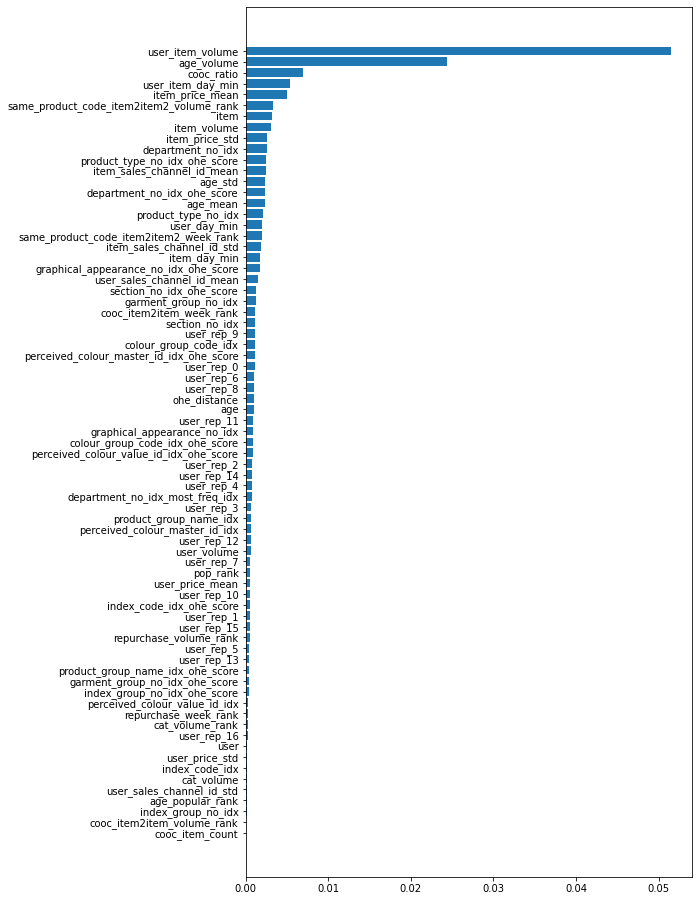

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12067

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 6.087 s


[popular] 1.758 s


[age popular] 0.773 s


[item2item] 5.512 s


[item2item2] 5.362 s


[cooccurrence] 59.059 s


[same_product_code] 5.273 s


[ohe distance] 13.813 s


[category popular] 0.542 s


volume: 31753255


duplicates: 1.1277405103172173


            strategy   volume     ratio
0                pop  8231880  0.259245
1  same_product_code  6635618  0.208974
2       ohe_distance  6412711  0.201954
3            cat_pop  4713370  0.148437
4         repurchase  2735882  0.086161
5            age_pop  1626996  0.051239
6               cooc  1396798  0.043989


attach features (week: 0)


[user static fetaures] 2.703 s


[item stacic features] 7.853 s


[user dynamic features (transactions)] 6.995 s


[item dynamic features (transactions)] 4.829 s


[item dynamic features (user features)] 7.935 s


[item freshness features] 6.995 s


[item volume features] 5.596 s


[user freshness features] 9.212 s


[user volume features] 7.566 s


[user-item freshness features] 31.583 s


[user-item volume features] 13.493 s


[item age volume features] 8.715 s


[user category most frequent] 87.550 s


[ohe dot products] 157.944 s


[lfm features] 9.160 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.581 s


[popular] 1.718 s


[age popular] 0.751 s


[item2item] 5.567 s


[item2item2] 5.398 s


[cooccurrence] 58.680 s


[same_product_code] 5.158 s


[ohe distance] 11.171 s


[category popular] 0.539 s


volume: 31793263


duplicates: 1.1276361642301076


            strategy   volume     ratio
0                pop  8231880  0.258919
1  same_product_code  6653380  0.209270
2       ohe_distance  6409891  0.201612
3            cat_pop  4723909  0.148582
4         repurchase  2752227  0.086566
5            age_pop  1627296  0.051184
6               cooc  1394680  0.043867


attach features (week: 0)


[user static fetaures] 2.685 s


[item stacic features] 7.761 s


[user dynamic features (transactions)] 6.940 s


[item dynamic features (transactions)] 4.778 s


[item dynamic features (user features)] 7.878 s


[item freshness features] 6.935 s


[item volume features] 5.541 s


[user freshness features] 9.073 s


[user volume features] 7.461 s


[user-item freshness features] 31.380 s


[user-item volume features] 13.511 s


[item age volume features] 8.858 s


[user category most frequent] 86.461 s


[ohe dot products] 156.807 s


[lfm features] 9.127 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.487 s


[popular] 1.833 s


[age popular] 0.753 s


[item2item] 5.494 s


[item2item2] 5.320 s


[cooccurrence] 59.105 s


[same_product_code] 5.111 s


[ohe distance] 11.097 s


[category popular] 0.541 s


volume: 31710622


duplicates: 1.1278780154317434


            strategy   volume     ratio
0                pop  8231880  0.259594
1  same_product_code  6634369  0.209216
2       ohe_distance  6412683  0.202225
3            cat_pop  4711280  0.148571
4         repurchase  2708651  0.085418
5            age_pop  1626840  0.051303
6               cooc  1384919  0.043674


attach features (week: 0)


[user static fetaures] 2.671 s


[item stacic features] 7.811 s


[user dynamic features (transactions)] 6.991 s


[item dynamic features (transactions)] 4.739 s


[item dynamic features (user features)] 7.838 s


[item freshness features] 6.888 s


[item volume features] 5.494 s


[user freshness features] 9.213 s


[user volume features] 7.494 s


[user-item freshness features] 31.680 s


[user-item volume features] 14.674 s


[item age volume features] 8.512 s


[user category most frequent] 86.979 s


[ohe dot products] 154.684 s


[lfm features] 9.136 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.538 s


[popular] 1.740 s


[age popular] 0.752 s


[item2item] 5.539 s


[item2item2] 5.427 s


[cooccurrence] 58.377 s


[same_product_code] 5.060 s


[ohe distance] 11.066 s


[category popular] 0.550 s


volume: 31762801


duplicates: 1.1276012551480878


            strategy   volume     ratio
0                pop  8231880  0.259167
1  same_product_code  6636093  0.208927
2       ohe_distance  6411150  0.201845
3            cat_pop  4712572  0.148368
4         repurchase  2737078  0.086172
5            age_pop  1628148  0.051260
6               cooc  1405880  0.044262


attach features (week: 0)


[user static fetaures] 2.694 s


[item stacic features] 7.842 s


[user dynamic features (transactions)] 6.999 s


[item dynamic features (transactions)] 4.782 s


[item dynamic features (user features)] 7.901 s


[item freshness features] 6.908 s


[item volume features] 5.549 s


[user freshness features] 9.160 s


[user volume features] 7.555 s


[user-item freshness features] 31.587 s


[user-item volume features] 13.570 s


[item age volume features] 8.638 s


[user category most frequent] 86.862 s


[ohe dot products] 154.311 s


[lfm features] 9.119 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.554 s


[popular] 1.704 s


[age popular] 0.749 s


[item2item] 5.559 s


[item2item2] 5.381 s


[cooccurrence] 58.543 s


[same_product_code] 5.092 s


[ohe distance] 11.057 s


[category popular] 0.549 s


volume: 31743397


duplicates: 1.1277435804009335


            strategy   volume     ratio
0                pop  8231880  0.259326
1  same_product_code  6630508  0.208878
2       ohe_distance  6413390  0.202039
3            cat_pop  4704645  0.148209
4         repurchase  2739307  0.086295
5            age_pop  1627584  0.051273
6               cooc  1396083  0.043980


attach features (week: 0)


[user static fetaures] 2.673 s


[item stacic features] 7.819 s


[user dynamic features (transactions)] 6.897 s


[item dynamic features (transactions)] 4.754 s


[item dynamic features (user features)] 7.849 s


[item freshness features] 6.863 s


[item volume features] 5.492 s


[user freshness features] 9.048 s


[user volume features] 7.430 s


[user-item freshness features] 31.432 s


[user-item volume features] 13.558 s


[item age volume features] 8.543 s


[user category most frequent] 84.784 s


[ohe dot products] 154.411 s


[lfm features] 9.082 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.571 s


[popular] 1.718 s


[age popular] 0.745 s


[item2item] 5.565 s


[item2item2] 5.404 s


[cooccurrence] 58.560 s


[same_product_code] 5.045 s


[ohe distance] 10.978 s


[category popular] 0.551 s


volume: 31802388


duplicates: 1.1278664808498395


            strategy   volume     ratio
0                pop  8231880  0.258845
1  same_product_code  6653866  0.209225
2       ohe_distance  6408989  0.201525
3            cat_pop  4725197  0.148580
4         repurchase  2745003  0.086314
5            age_pop  1627032  0.051161
6               cooc  1410421  0.044350


attach features (week: 0)


[user static fetaures] 2.662 s


[item stacic features] 7.857 s


[user dynamic features (transactions)] 6.958 s


[item dynamic features (transactions)] 4.781 s


[item dynamic features (user features)] 7.860 s


[item freshness features] 6.898 s


[item volume features] 5.471 s


[user freshness features] 9.080 s


[user volume features] 7.462 s


[user-item freshness features] 31.825 s


[user-item volume features] 13.528 s


[item age volume features] 8.542 s


[user category most frequent] 84.566 s


[ohe dot products] 154.609 s


[lfm features] 9.119 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.505 s


[popular] 1.752 s


[age popular] 0.754 s


[item2item] 5.499 s


[item2item2] 5.328 s


[cooccurrence] 58.549 s


[same_product_code] 5.077 s


[ohe distance] 10.981 s


[category popular] 0.543 s


volume: 31704541


duplicates: 1.1280572956796435


            strategy   volume     ratio
0                pop  8231880  0.259644
1  same_product_code  6623896  0.208926
2       ohe_distance  6411560  0.202228
3            cat_pop  4690434  0.147942
4         repurchase  2714357  0.085614
5            age_pop  1626984  0.051317
6               cooc  1405430  0.044329


attach features (week: 0)


[user static fetaures] 2.670 s


[item stacic features] 7.794 s


[user dynamic features (transactions)] 7.005 s


[item dynamic features (transactions)] 4.790 s


[item dynamic features (user features)] 7.862 s


[item freshness features] 6.881 s


[item volume features] 5.531 s


[user freshness features] 9.209 s


[user volume features] 7.560 s


[user-item freshness features] 31.750 s


[user-item volume features] 13.649 s


[item age volume features] 8.520 s


[user category most frequent] 87.870 s


[ohe dot products] 152.018 s


[lfm features] 9.143 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.580 s


[popular] 1.821 s


[age popular] 0.753 s


[item2item] 5.568 s


[item2item2] 5.617 s


[cooccurrence] 58.733 s


[same_product_code] 5.187 s


[ohe distance] 11.059 s


[category popular] 0.546 s


volume: 31738148


duplicates: 1.1280448636896463


            strategy   volume     ratio
0                pop  8231880  0.259369
1  same_product_code  6618201  0.208525
2       ohe_distance  6411573  0.202015
3            cat_pop  4709002  0.148370
4         repurchase  2731902  0.086076
5            age_pop  1628148  0.051299
6               cooc  1407442  0.044345


attach features (week: 0)


[user static fetaures] 2.696 s


[item stacic features] 7.849 s


[user dynamic features (transactions)] 7.026 s


[item dynamic features (transactions)] 4.849 s


[item dynamic features (user features)] 7.902 s


[item freshness features] 6.923 s


[item volume features] 5.507 s


[user freshness features] 9.154 s


[user volume features] 7.483 s


[user-item freshness features] 31.466 s


[user-item volume features] 13.454 s


[item age volume features] 8.553 s


[user category most frequent] 85.520 s


[ohe dot products] 155.439 s


[lfm features] 9.099 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.513 s


[popular] 1.732 s


[age popular] 0.754 s


[item2item] 5.447 s


[item2item2] 5.328 s


[cooccurrence] 58.748 s


[same_product_code] 5.100 s


[ohe distance] 11.004 s


[category popular] 0.555 s


volume: 31663638


duplicates: 1.1278757661131367


            strategy   volume     ratio
0                pop  8231880  0.259979
1  same_product_code  6593059  0.208222
2       ohe_distance  6408148  0.202382
3            cat_pop  4699416  0.148417
4         repurchase  2711285  0.085628
5            age_pop  1627380  0.051396
6               cooc  1392470  0.043977


attach features (week: 0)


[user static fetaures] 2.675 s


[item stacic features] 7.839 s


[user dynamic features (transactions)] 7.131 s


[item dynamic features (transactions)] 4.831 s


[item dynamic features (user features)] 7.999 s


[item freshness features] 6.992 s


[item volume features] 5.543 s


[user freshness features] 9.241 s


[user volume features] 7.526 s


[user-item freshness features] 31.648 s


[user-item volume features] 13.381 s


[item age volume features] 8.571 s


[user category most frequent] 87.707 s


[ohe dot products] 152.606 s


[lfm features] 9.131 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.556 s


[popular] 1.754 s


[age popular] 0.751 s


[item2item] 5.555 s


[item2item2] 5.371 s


[cooccurrence] 58.713 s


[same_product_code] 5.027 s


[ohe distance] 10.953 s


[category popular] 0.553 s


volume: 31750248


duplicates: 1.1278655643059874


            strategy   volume     ratio
0                pop  8231880  0.259270
1  same_product_code  6638864  0.209096
2       ohe_distance  6411401  0.201932
3            cat_pop  4711997  0.148408
4         repurchase  2730747  0.086007
5            age_pop  1627020  0.051244
6               cooc  1398339  0.044042


attach features (week: 0)


[user static fetaures] 2.660 s


[item stacic features] 7.862 s


[user dynamic features (transactions)] 6.926 s


[item dynamic features (transactions)] 4.568 s


[item dynamic features (user features)] 7.604 s


[item freshness features] 6.600 s


[item volume features] 5.213 s


[user freshness features] 8.750 s


[user volume features] 7.107 s


[user-item freshness features] 31.355 s


[user-item volume features] 13.660 s


[item age volume features] 8.530 s


[user category most frequent] 85.458 s


[ohe dot products] 154.150 s


[lfm features] 9.323 s


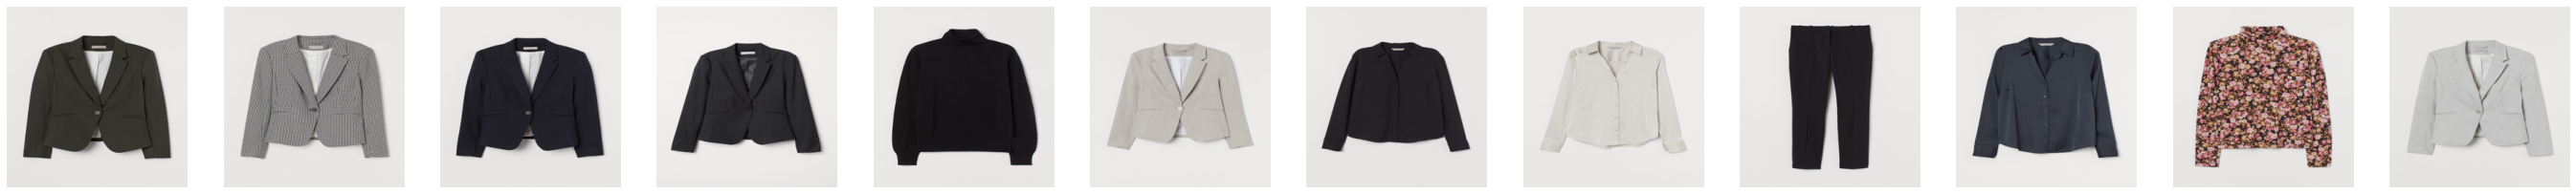

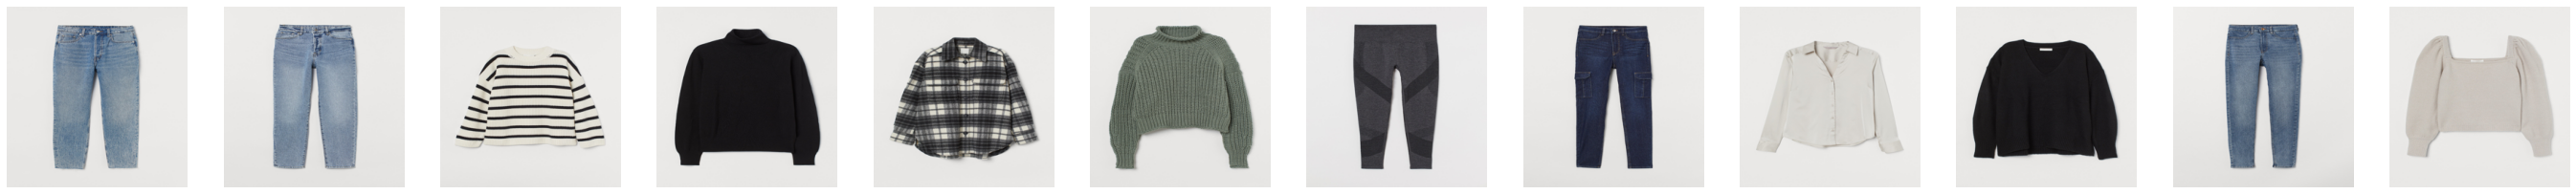

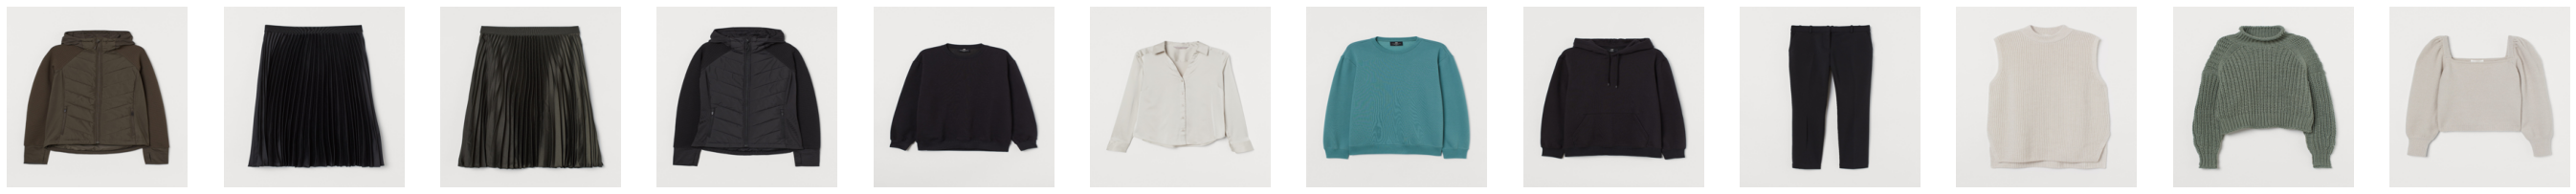

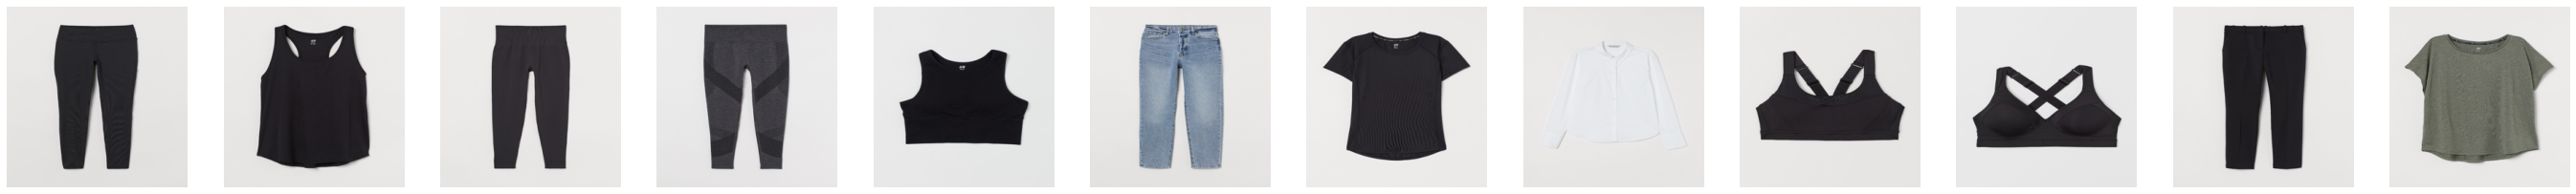

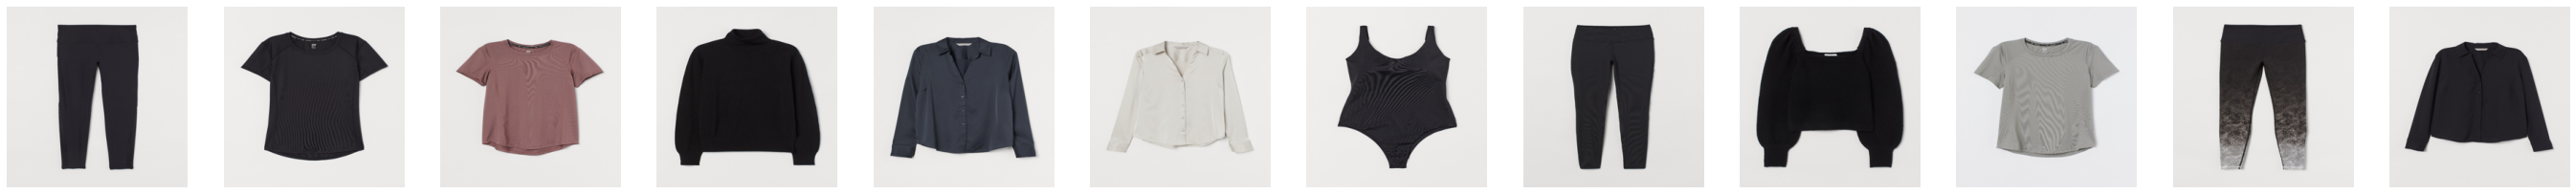

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

customer_id  \
0        00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...   
1        0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...   
2        000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   
3        00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...   
4        00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...   
...                                                    ...   
1371975  ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...   
1371976  ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...   
1371977  ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...   
1371978  ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...   
1371979  ffffd9ac14e89946416d80e791d064701994755c3ab686...   

                                                prediction  
0        0568601043 0568601044 0568601007 0568601006 06...  
1        0448509014 0714790020 0863583001 0673677002 08...  
2        0794321007 0851400001 0851400020 0794321011 06...  
3        0852584001 0912204001 0866731001 0918292001 08...  
4        0730683050 0791587001 0791587021 0673677002 07...  
...                                                    ...  
1371975  0557599022 0791587015 0791587001 0804992014 08...  
1371976  0762846027 0762846031 0762846006 0762846026 07...  
1371977  0762846027 0762846006 0762846031 0762846026 07...  
1371978  0714790020 0448509014 0715624001 0714790028 05...  
1371979  0806050001 0906744001 0924243001 0901327002 08...  

[1371980 rows x 2 columns]

In [27]:
submission.to_csv('submission.csv', index=False)